# **Necessary imports**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage import io, transform
import torch
from tqdm import tqdm
import os
import time
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import copy
from skimage import io, transform
from IPython.display import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import PIL
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import sklearn
import sklearn.model_selection

# **Exploring the dataset**


In [2]:
columns = {"name": "X", "score": "y"}
dataset = pd.read_csv("../../data/memcat.csv")
dataset.rename(columns=columns, inplace=True)

In [3]:
dataset.head()

image  memorability_score
0  000000003481.jpg            0.561224
1  000000005745.jpg            0.790123
2  000000011552.jpg            0.721154
3  000000027439.jpg            0.807018
4  000000055601.jpg            0.813725

In [4]:
len(dataset)

10000

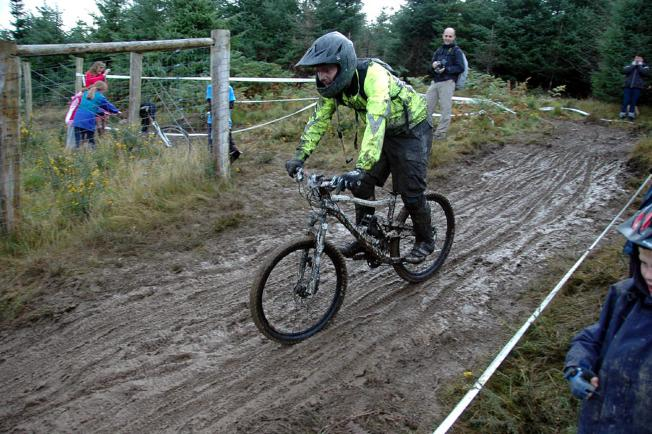

In [5]:
Image(filename="images/abc436f8778e1a82.jpg")

In [6]:
# train validation split
dataset_train, dataset_validation = train_test_split(
    dataset, test_size=0.2, random_state=90
)

In [7]:
dataset_train

image  memorability_score
2707          000000031812.jpg            0.927083
4322        n09270735_9551.jpg            0.744444
1862         n02396427_259.jpg            0.684211
5099  sun_achtuarilwyqnvjx.jpg            0.461538
4100       n02793495_12207.jpg            0.820000
...                        ...                 ...
9539        n04465501_1705.jpg            0.602151
6815      3f18498b871d51ba.jpg            0.686957
5746       n09472597_32918.jpg            0.804124
2717          000000125979.jpg            0.900990
3931       n07849336_27107.jpg            0.896552

[8000 rows x 2 columns]

In [8]:
len(dataset_train), len(dataset_validation)

(8000, 2000)

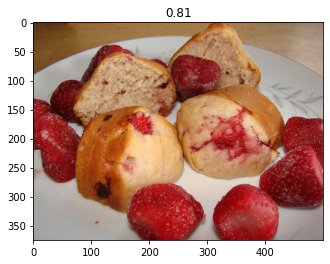

In [9]:
def show_sample_from_dataset(i=0):
    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join("images/" + str(dataset_train.iloc[i]["image"]))
    mem_value = os.path.join(str(dataset_train.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_value)


show_sample_from_dataset(300)

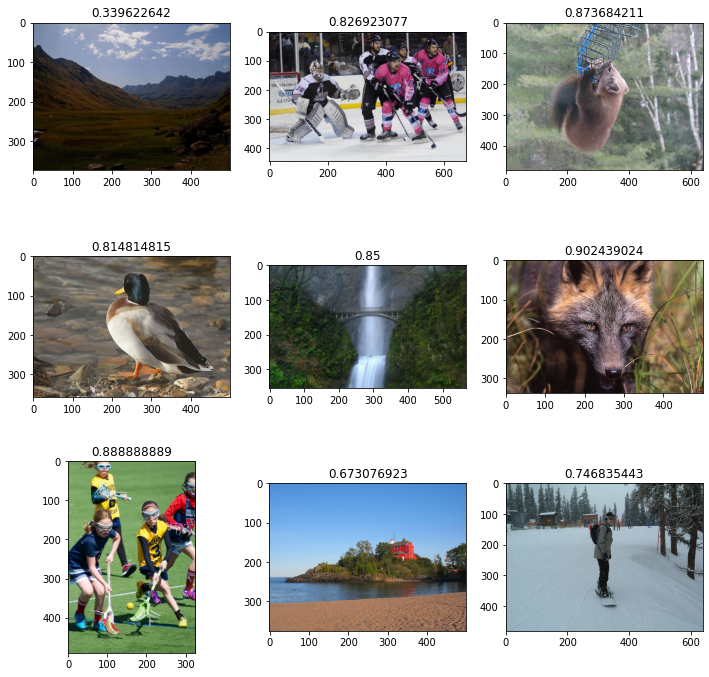

In [10]:
def show_grid(n_row, n_col):
    i = 500
    _, fig = plt.subplots(n_row, n_col, figsize=(12, 12))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join("images/" + str(dataset_train.iloc[i]["image"]))
        mem_value = os.path.join(str(dataset_train.iloc[i]["memorability_score"]))
        f.imshow(io.imread(image_path))
        f.title.set_text(str(mem_value))
        i = i + 1


show_grid(3, 3)

# **Statistics**


In [11]:
dataset_train["memorability_score"].describe()

count    8000.000000
mean        0.759158
std         0.130666
min         0.220930
25%         0.687500
50%         0.786701
75%         0.854584
max         1.000000
Name: memorability_score, dtype: float64

In [12]:
dataset_validation["memorability_score"].describe()

count    2000.000000
mean        0.755623
std         0.132966
min         0.205882
25%         0.681718
50%         0.780952
75%         0.854167
max         0.982301
Name: memorability_score, dtype: float64

## **Data preprocessing**


In [13]:
class LaMemDataset(Dataset):
    """largescale image memorablity  dataset"""

    def __init__(self, dataframe, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = io.imread(image_name)
        mem_val = self.data.iloc[idx, 1]
        return_sample = {"image": image, "memorability_score": mem_val}
        if self.transform:
            return_sample = self.transform(return_sample)

        return return_sample

In [14]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        img = transform.resize(image, (self.output_size, self.output_size, 3))
        return {"image": img, "memorability_score": mem_val}

In [15]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        image = image.transpose((2, 0, 1))
        return {"image": torch.from_numpy(image), "memorability_score": mem_val}

In [16]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        image, mem_val = sample["image"], sample["memorability_score"]
        normalized = (image - self.mean) / self.std
        return {"image": normalized, "memorability_score": mem_val}

In [17]:
transformed_dataset_train = LaMemDataset(
    dataset_train,
    root_dir="images",
    transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)]),
)

transformed_dataset_val = LaMemDataset(
    dataset_validation,
    root_dir="images",
    transform=transforms.Compose([Rescale(224), ToTensor(), Normalize(0.5, 0.5)]),
)

In [18]:
train_dataloader = DataLoader(transformed_dataset_train, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(transformed_dataset_val, batch_size=32, shuffle=True)

In [19]:
dataloaders = {"train": train_dataloader, "val": validation_dataloader}

In [20]:
dataset_sizes = {"train": len(dataset_train), "val": len(dataset_validation)}

In [21]:
epchocs_count = 25

# **ResNet50**


In [22]:
model_50 = models.resnet50("pth/resnet50-0676ba61.pth")

In [23]:
# model_50 = models.resnet50(pretrained=True)
for param in model_50.parameters():
    param.requires_grad = False
import torch.nn as nn

n_inputs = model_50.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_50.fc = last_layer
model_50.to(device)
print(model_50.fc.out_features)

1


In [24]:
model_50 = model_50.double()
resmodel_50 = copy.deepcopy(model_50)

In [25]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_50.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [26]:
np.inf > 90

True

In [27]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()
    running_loss_history = []
    val_running_loss_history = []
    orignal_model = None
    best_model_wts = copy.deepcopy(model.state_dict())
    low_loss = np.inf

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print("-" * 10)

        # Each epoch has a training and validation phase
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batched_data in tqdm(dataloaders[phase]):

                inputs = batched_data["image"]
                inputs = inputs.to(device)
                labels = batched_data["memorability_score"]
                labels = labels.view(-1, 1).double()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    print("  batch loss:    ", loss.item())
                    # backward + optimize only if in training phase
                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == "train":
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            if phase == "train":
                running_loss_history.append(epoch_loss)
            else:
                val_running_loss_history.append(epoch_loss)

            print("{} Loss: {:.4f}".format(phase, epoch_loss))

            # deep copy the model
            if phase == "val" and epoch_loss < low_loss:
                low_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print("saving best model....")
                torch.save(best_model_wts, "models/ResNet50-in-resnet101.pth")

        print()

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    # load best model weights
    original_model = copy.deepcopy(model)
    model.load_state_dict(best_model_wts)
    return model, original_model, running_loss_history, val_running_loss_history

In [28]:
best_model_50, model_50, running_loss_history, val_running_loss_history = train_model(
    model_50, criterion, optimizer, exp_lr_scheduler, epchocs_count
)

Epoch 0/24
----------


  0%|▎                                                                                  | 1/250 [00:02<08:27,  2.04s/it]

  batch loss:     0.1851504401924829


  1%|▋                                                                                  | 2/250 [00:04<08:18,  2.01s/it]

  batch loss:     0.12364851442601507


  1%|▉                                                                                  | 3/250 [00:06<08:14,  2.00s/it]

  batch loss:     0.08322397511491397


  2%|█▎                                                                                 | 4/250 [00:08<08:10,  1.99s/it]

  batch loss:     0.07015243542565774


  2%|█▋                                                                                 | 5/250 [00:09<08:06,  1.99s/it]

  batch loss:     0.07939375712391118


  2%|█▉                                                                                 | 6/250 [00:11<07:57,  1.96s/it]

  batch loss:     0.0645598352294526


  3%|██▎                                                                                | 7/250 [00:13<07:58,  1.97s/it]

  batch loss:     0.09675053374483786


  3%|██▋                                                                                | 8/250 [00:15<07:52,  1.95s/it]

  batch loss:     0.08405479045122471


  4%|██▉                                                                                | 9/250 [00:17<07:52,  1.96s/it]

  batch loss:     0.1335866747332315


  4%|███▎                                                                              | 10/250 [00:19<08:03,  2.02s/it]

  batch loss:     0.1137476821387927


  4%|███▌                                                                              | 11/250 [00:22<08:11,  2.06s/it]

  batch loss:     0.10508419583659881


  5%|███▉                                                                              | 12/250 [00:23<08:00,  2.02s/it]

  batch loss:     0.09735393090138908


  5%|████▎                                                                             | 13/250 [00:26<08:04,  2.05s/it]

  batch loss:     0.07870753750528676


  6%|████▌                                                                             | 14/250 [00:28<07:53,  2.00s/it]

  batch loss:     0.058212597995446466


  6%|████▉                                                                             | 15/250 [00:29<07:44,  1.97s/it]

  batch loss:     0.0765066513085377


  6%|█████▏                                                                            | 16/250 [00:31<07:41,  1.97s/it]

  batch loss:     0.07999039183140119


  7%|█████▌                                                                            | 17/250 [00:33<07:34,  1.95s/it]

  batch loss:     0.06266292780359489


  7%|█████▉                                                                            | 18/250 [00:35<07:30,  1.94s/it]

  batch loss:     0.09659257174391671


  8%|██████▏                                                                           | 19/250 [00:37<07:27,  1.94s/it]

  batch loss:     0.07687732057990937


  8%|██████▌                                                                           | 20/250 [00:39<07:30,  1.96s/it]

  batch loss:     0.06390539194574876


  8%|██████▉                                                                           | 21/250 [00:41<07:28,  1.96s/it]

  batch loss:     0.07018004252209348


  9%|███████▏                                                                          | 22/250 [00:43<07:22,  1.94s/it]

  batch loss:     0.06705976228658395


  9%|███████▌                                                                          | 23/250 [00:45<07:16,  1.92s/it]

  batch loss:     0.07298014876215876


 10%|███████▊                                                                          | 24/250 [00:47<07:14,  1.92s/it]

  batch loss:     0.08338099953645273


 10%|████████▏                                                                         | 25/250 [00:49<07:13,  1.93s/it]

  batch loss:     0.06680875801262902


 10%|████████▌                                                                         | 26/250 [00:51<07:09,  1.92s/it]

  batch loss:     0.11774315347693329


 11%|████████▊                                                                         | 27/250 [00:53<07:16,  1.96s/it]

  batch loss:     0.038664459877003406


 11%|█████████▏                                                                        | 28/250 [00:55<07:18,  1.97s/it]

  batch loss:     0.1019902179180332


 12%|█████████▌                                                                        | 29/250 [00:57<07:11,  1.95s/it]

  batch loss:     0.0655718480470227


 12%|█████████▊                                                                        | 30/250 [00:59<07:10,  1.96s/it]

  batch loss:     0.0724271138870608


 12%|██████████▏                                                                       | 31/250 [01:00<07:07,  1.95s/it]

  batch loss:     0.06439850204421618


 13%|██████████▍                                                                       | 32/250 [01:02<07:06,  1.96s/it]

  batch loss:     0.06451764917438926


 13%|██████████▊                                                                       | 33/250 [01:04<07:06,  1.97s/it]

  batch loss:     0.059134555181396875


 14%|███████████▏                                                                      | 34/250 [01:06<07:00,  1.95s/it]

  batch loss:     0.04577984275466615


 14%|███████████▍                                                                      | 35/250 [01:08<06:56,  1.94s/it]

  batch loss:     0.07832810125300049


 14%|███████████▊                                                                      | 36/250 [01:10<06:53,  1.93s/it]

  batch loss:     0.0695768790506113


 15%|████████████▏                                                                     | 37/250 [01:12<06:53,  1.94s/it]

  batch loss:     0.05242535653057005


 15%|████████████▍                                                                     | 38/250 [01:14<06:49,  1.93s/it]

  batch loss:     0.06166688715916392


 16%|████████████▊                                                                     | 39/250 [01:16<06:48,  1.94s/it]

  batch loss:     0.06727845007216245


 16%|█████████████                                                                     | 40/250 [01:18<06:45,  1.93s/it]

  batch loss:     0.09393224403555811


 16%|█████████████▍                                                                    | 41/250 [01:20<06:42,  1.93s/it]

  batch loss:     0.05053523075827735


 17%|█████████████▊                                                                    | 42/250 [01:22<06:47,  1.96s/it]

  batch loss:     0.04966755791079161


 17%|██████████████                                                                    | 43/250 [01:24<06:52,  1.99s/it]

  batch loss:     0.04431957439564854


 18%|██████████████▍                                                                   | 44/250 [01:26<06:45,  1.97s/it]

  batch loss:     0.043735792480387836


 18%|██████████████▊                                                                   | 45/250 [01:28<06:44,  1.97s/it]

  batch loss:     0.07004698092671109


 18%|███████████████                                                                   | 46/250 [01:30<06:37,  1.95s/it]

  batch loss:     0.03876764141948929


 19%|███████████████▍                                                                  | 47/250 [01:32<06:34,  1.94s/it]

  batch loss:     0.060924549416566075


 19%|███████████████▋                                                                  | 48/250 [01:34<06:32,  1.94s/it]

  batch loss:     0.05965062310768376


 20%|████████████████                                                                  | 49/250 [01:36<06:32,  1.95s/it]

  batch loss:     0.10176317535358864


 20%|████████████████▍                                                                 | 50/250 [01:38<06:29,  1.95s/it]

  batch loss:     0.04733751482078637


 20%|████████████████▋                                                                 | 51/250 [01:39<06:28,  1.95s/it]

  batch loss:     0.06283184523951052


 21%|█████████████████                                                                 | 52/250 [01:41<06:25,  1.95s/it]

  batch loss:     0.04622949580804689


 21%|█████████████████▍                                                                | 53/250 [01:43<06:20,  1.93s/it]

  batch loss:     0.05851770589595398


 22%|█████████████████▋                                                                | 54/250 [01:45<06:18,  1.93s/it]

  batch loss:     0.04390940435137543


 22%|██████████████████                                                                | 55/250 [01:47<06:18,  1.94s/it]

  batch loss:     0.04862656269929111


 22%|██████████████████▎                                                               | 56/250 [01:49<06:13,  1.93s/it]

  batch loss:     0.06848316507390095


 23%|██████████████████▋                                                               | 57/250 [01:51<06:10,  1.92s/it]

  batch loss:     0.058889055593206716


 23%|███████████████████                                                               | 58/250 [01:53<06:13,  1.94s/it]

  batch loss:     0.07516564315273255


 24%|███████████████████▎                                                              | 59/250 [01:55<06:12,  1.95s/it]

  batch loss:     0.08748675082042472


 24%|███████████████████▋                                                              | 60/250 [01:57<06:12,  1.96s/it]

  batch loss:     0.08310784996551934


 24%|████████████████████                                                              | 61/250 [01:59<06:12,  1.97s/it]

  batch loss:     0.04717944813309258


 25%|████████████████████▎                                                             | 62/250 [02:01<06:15,  2.00s/it]

  batch loss:     0.06603003757870826


 25%|████████████████████▋                                                             | 63/250 [02:03<06:10,  1.98s/it]

  batch loss:     0.042390135176524055


 26%|████████████████████▉                                                             | 64/250 [02:05<06:15,  2.02s/it]

  batch loss:     0.04961156052062679


 26%|█████████████████████▎                                                            | 65/250 [02:07<06:12,  2.01s/it]

  batch loss:     0.04746633309152694


 26%|█████████████████████▋                                                            | 66/250 [02:09<06:07,  2.00s/it]

  batch loss:     0.05043449288177636


 27%|█████████████████████▉                                                            | 67/250 [02:11<06:00,  1.97s/it]

  batch loss:     0.0561352730890612


 27%|██████████████████████▎                                                           | 68/250 [02:13<06:00,  1.98s/it]

  batch loss:     0.04203276190856344


 28%|██████████████████████▋                                                           | 69/250 [02:15<05:54,  1.96s/it]

  batch loss:     0.05272708987156217


 28%|██████████████████████▉                                                           | 70/250 [02:17<05:50,  1.95s/it]

  batch loss:     0.06746889851593238


 28%|███████████████████████▎                                                          | 71/250 [02:19<05:49,  1.95s/it]

  batch loss:     0.03865805200080592


 29%|███████████████████████▌                                                          | 72/250 [02:21<05:47,  1.95s/it]

  batch loss:     0.07482306982806762


 29%|███████████████████████▉                                                          | 73/250 [02:23<05:53,  2.00s/it]

  batch loss:     0.04527103849380302


 30%|████████████████████████▎                                                         | 74/250 [02:25<05:49,  1.99s/it]

  batch loss:     0.03637654178815033


 30%|████████████████████████▌                                                         | 75/250 [02:27<05:48,  1.99s/it]

  batch loss:     0.044494436647770925


 30%|████████████████████████▉                                                         | 76/250 [02:29<05:44,  1.98s/it]

  batch loss:     0.05793810935092962


 31%|█████████████████████████▎                                                        | 77/250 [02:31<05:44,  1.99s/it]

  batch loss:     0.03962349333734107


 31%|█████████████████████████▌                                                        | 78/250 [02:33<05:41,  1.99s/it]

  batch loss:     0.0397599708726661


 32%|█████████████████████████▉                                                        | 79/250 [02:35<05:38,  1.98s/it]

  batch loss:     0.05262096448035464


 32%|██████████████████████████▏                                                       | 80/250 [02:37<05:36,  1.98s/it]

  batch loss:     0.06297956816011432


 32%|██████████████████████████▌                                                       | 81/250 [02:39<05:32,  1.97s/it]

  batch loss:     0.03886377360816597


 33%|██████████████████████████▉                                                       | 82/250 [02:41<05:29,  1.96s/it]

  batch loss:     0.03870766933907715


 33%|███████████████████████████▏                                                      | 83/250 [02:42<05:26,  1.96s/it]

  batch loss:     0.054153356308655504


 34%|███████████████████████████▌                                                      | 84/250 [02:44<05:26,  1.97s/it]

  batch loss:     0.04994966939690853


 34%|███████████████████████████▉                                                      | 85/250 [02:46<05:23,  1.96s/it]

  batch loss:     0.045237430902923245


 34%|████████████████████████████▏                                                     | 86/250 [02:48<05:24,  1.98s/it]

  batch loss:     0.0377695402980956


 35%|████████████████████████████▌                                                     | 87/250 [02:50<05:22,  1.98s/it]

  batch loss:     0.051145134097720896


 35%|████████████████████████████▊                                                     | 88/250 [02:52<05:22,  1.99s/it]

  batch loss:     0.05207054164519649


 36%|█████████████████████████████▏                                                    | 89/250 [02:54<05:20,  1.99s/it]

  batch loss:     0.035154680482726554


 36%|█████████████████████████████▌                                                    | 90/250 [02:56<05:19,  2.00s/it]

  batch loss:     0.035850717608055874


 36%|█████████████████████████████▊                                                    | 91/250 [02:58<05:17,  2.00s/it]

  batch loss:     0.038591690375290325


 37%|██████████████████████████████▏                                                   | 92/250 [03:00<05:13,  1.99s/it]

  batch loss:     0.04337315418615091


 37%|██████████████████████████████▌                                                   | 93/250 [03:02<05:11,  1.98s/it]

  batch loss:     0.05000401504812757


 38%|██████████████████████████████▊                                                   | 94/250 [03:04<05:05,  1.96s/it]

  batch loss:     0.038947702541138066


 38%|███████████████████████████████▏                                                  | 95/250 [03:06<05:06,  1.98s/it]

  batch loss:     0.03729004558610261


 38%|███████████████████████████████▍                                                  | 96/250 [03:08<05:12,  2.03s/it]

  batch loss:     0.05249898365889358


 39%|███████████████████████████████▊                                                  | 97/250 [03:10<05:08,  2.02s/it]

  batch loss:     0.055892211886924094


 39%|████████████████████████████████▏                                                 | 98/250 [03:12<05:03,  1.99s/it]

  batch loss:     0.036754737719040434


 40%|████████████████████████████████▍                                                 | 99/250 [03:14<05:02,  2.00s/it]

  batch loss:     0.06330519566111686


 40%|████████████████████████████████▍                                                | 100/250 [03:16<05:00,  2.00s/it]

  batch loss:     0.04705673899644898


 40%|████████████████████████████████▋                                                | 101/250 [03:18<04:57,  2.00s/it]

  batch loss:     0.03864588203359292


 41%|█████████████████████████████████                                                | 102/250 [03:20<04:50,  1.97s/it]

  batch loss:     0.026650444613707934


 41%|█████████████████████████████████▎                                               | 103/250 [03:22<04:49,  1.97s/it]

  batch loss:     0.056730493453799026


 42%|█████████████████████████████████▋                                               | 104/250 [03:24<04:46,  1.96s/it]

  batch loss:     0.03971216771973045


 42%|██████████████████████████████████                                               | 105/250 [03:26<04:48,  1.99s/it]

  batch loss:     0.03826017592775929


 42%|██████████████████████████████████▎                                              | 106/250 [03:28<04:44,  1.97s/it]

  batch loss:     0.028058149269121566


 43%|██████████████████████████████████▋                                              | 107/250 [03:30<04:46,  2.01s/it]

  batch loss:     0.037929466385943134


 43%|██████████████████████████████████▉                                              | 108/250 [03:32<04:43,  2.00s/it]

  batch loss:     0.03706860620955987


 44%|███████████████████████████████████▎                                             | 109/250 [03:34<04:38,  1.97s/it]

  batch loss:     0.03390798824382703


 44%|███████████████████████████████████▋                                             | 110/250 [03:36<04:37,  1.99s/it]

  batch loss:     0.03166359979730712


 44%|███████████████████████████████████▉                                             | 111/250 [03:40<05:50,  2.52s/it]

  batch loss:     0.029224507472781755


 45%|████████████████████████████████████▎                                            | 112/250 [03:43<06:26,  2.80s/it]

  batch loss:     0.0506232349314871


 45%|████████████████████████████████████▌                                            | 113/250 [03:46<06:26,  2.82s/it]

  batch loss:     0.05952630690147319


 46%|████████████████████████████████████▉                                            | 114/250 [03:48<05:50,  2.58s/it]

  batch loss:     0.05759249787190654


 46%|█████████████████████████████████████▎                                           | 115/250 [03:52<06:54,  3.07s/it]

  batch loss:     0.03873323630132336


 46%|█████████████████████████████████████▌                                           | 116/250 [03:56<07:13,  3.24s/it]

  batch loss:     0.0431709664553621


 47%|█████████████████████████████████████▉                                           | 117/250 [03:59<06:41,  3.02s/it]

  batch loss:     0.040584202701051016


 47%|██████████████████████████████████████▏                                          | 118/250 [04:01<06:23,  2.91s/it]

  batch loss:     0.0362036458510467


 48%|██████████████████████████████████████▌                                          | 119/250 [04:05<07:10,  3.29s/it]

  batch loss:     0.04412593369969814


 48%|██████████████████████████████████████▉                                          | 120/250 [04:09<07:17,  3.36s/it]

  batch loss:     0.053669712992416574


 48%|███████████████████████████████████████▏                                         | 121/250 [04:11<06:24,  2.98s/it]

  batch loss:     0.03356581863109506


 49%|███████████████████████████████████████▌                                         | 122/250 [04:15<06:43,  3.15s/it]

  batch loss:     0.037131775357382546


 49%|███████████████████████████████████████▊                                         | 123/250 [04:18<06:52,  3.25s/it]

  batch loss:     0.029301251335615286


 50%|████████████████████████████████████████▏                                        | 124/250 [04:21<06:37,  3.15s/it]

  batch loss:     0.03560675967543442


 50%|████████████████████████████████████████▌                                        | 125/250 [04:23<06:00,  2.89s/it]

  batch loss:     0.038938570645924125


 50%|████████████████████████████████████████▊                                        | 126/250 [04:27<06:28,  3.14s/it]

  batch loss:     0.046442911680252566


 51%|█████████████████████████████████████████▏                                       | 127/250 [04:30<06:38,  3.24s/it]

  batch loss:     0.026451205332904598


 51%|█████████████████████████████████████████▍                                       | 128/250 [04:33<05:56,  2.92s/it]

  batch loss:     0.03721233617980396


 52%|█████████████████████████████████████████▊                                       | 129/250 [04:35<05:44,  2.85s/it]

  batch loss:     0.05110759635421503


 52%|██████████████████████████████████████████                                       | 130/250 [04:39<06:06,  3.05s/it]

  batch loss:     0.026926571050979516


 52%|██████████████████████████████████████████▍                                      | 131/250 [04:42<06:15,  3.16s/it]

  batch loss:     0.03914805996599502


 53%|██████████████████████████████████████████▊                                      | 132/250 [04:44<05:33,  2.83s/it]

  batch loss:     0.03712519895872435


 53%|███████████████████████████████████████████                                      | 133/250 [04:48<05:59,  3.08s/it]

  batch loss:     0.04106472915774507


 54%|███████████████████████████████████████████▍                                     | 134/250 [04:52<06:13,  3.22s/it]

  batch loss:     0.03490242395317841


 54%|███████████████████████████████████████████▋                                     | 135/250 [04:54<05:48,  3.03s/it]

  batch loss:     0.0361430490046277


 54%|████████████████████████████████████████████                                     | 136/250 [04:56<05:22,  2.83s/it]

  batch loss:     0.024585208190082752


 55%|████████████████████████████████████████████▍                                    | 137/250 [05:00<05:41,  3.02s/it]

  batch loss:     0.030182904730209844


 55%|████████████████████████████████████████████▋                                    | 138/250 [05:04<06:01,  3.23s/it]

  batch loss:     0.020126094857670754


 56%|█████████████████████████████████████████████                                    | 139/250 [05:06<05:19,  2.88s/it]

  batch loss:     0.03009845726322726


 56%|█████████████████████████████████████████████▎                                   | 140/250 [05:09<05:18,  2.90s/it]

  batch loss:     0.026869740111816767


 56%|█████████████████████████████████████████████▋                                   | 141/250 [05:12<05:35,  3.08s/it]

  batch loss:     0.024612451244517223


 57%|██████████████████████████████████████████████                                   | 142/250 [05:15<05:29,  3.05s/it]

  batch loss:     0.0299062319660047


 57%|██████████████████████████████████████████████▎                                  | 143/250 [05:17<04:52,  2.74s/it]

  batch loss:     0.03359057676841062


 58%|██████████████████████████████████████████████▋                                  | 144/250 [05:20<05:03,  2.87s/it]

  batch loss:     0.03378684483846715


 58%|██████████████████████████████████████████████▉                                  | 145/250 [05:24<05:18,  3.04s/it]

  batch loss:     0.02609450863153276


 58%|███████████████████████████████████████████████▎                                 | 146/250 [05:26<04:55,  2.84s/it]

  batch loss:     0.030788690418145838


 59%|███████████████████████████████████████████████▋                                 | 147/250 [05:29<04:41,  2.73s/it]

  batch loss:     0.02649902057506079


 59%|███████████████████████████████████████████████▉                                 | 148/250 [05:32<04:57,  2.91s/it]

  batch loss:     0.03359396989951501


 60%|████████████████████████████████████████████████▎                                | 149/250 [05:36<05:15,  3.13s/it]

  batch loss:     0.043093166080377165


 60%|████████████████████████████████████████████████▌                                | 150/250 [05:38<04:39,  2.80s/it]

  batch loss:     0.03600830083995432


 60%|████████████████████████████████████████████████▉                                | 151/250 [05:41<04:41,  2.85s/it]

  batch loss:     0.03542666115995114


 61%|█████████████████████████████████████████████████▏                               | 152/250 [05:44<04:51,  2.97s/it]

  batch loss:     0.03313930465333202


 61%|█████████████████████████████████████████████████▌                               | 153/250 [05:47<04:47,  2.96s/it]

  batch loss:     0.02259529786758336


 62%|█████████████████████████████████████████████████▉                               | 154/250 [05:49<04:17,  2.68s/it]

  batch loss:     0.022064829851997623


 62%|██████████████████████████████████████████████████▏                              | 155/250 [05:52<04:27,  2.81s/it]

  batch loss:     0.04251944973957393


 62%|██████████████████████████████████████████████████▌                              | 156/250 [05:55<04:37,  2.95s/it]

  batch loss:     0.023027976648580986


 63%|██████████████████████████████████████████████████▊                              | 157/250 [05:58<04:22,  2.82s/it]

  batch loss:     0.03238291322157058


 63%|███████████████████████████████████████████████████▏                             | 158/250 [06:00<04:01,  2.62s/it]

  batch loss:     0.03857591732444994


 64%|███████████████████████████████████████████████████▌                             | 159/250 [06:03<04:14,  2.80s/it]

  batch loss:     0.021513529628499548


 64%|███████████████████████████████████████████████████▊                             | 160/250 [06:07<04:30,  3.00s/it]

  batch loss:     0.03752766761166812


 64%|████████████████████████████████████████████████████▏                            | 161/250 [06:09<04:04,  2.74s/it]

  batch loss:     0.028773285908994067


 65%|████████████████████████████████████████████████████▍                            | 162/250 [06:12<04:08,  2.82s/it]

  batch loss:     0.018210349245877056


 65%|████████████████████████████████████████████████████▊                            | 163/250 [06:15<04:17,  2.96s/it]

  batch loss:     0.034641044496427464


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [06:18<04:16,  2.99s/it]

  batch loss:     0.029033824198752098


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [06:20<03:48,  2.69s/it]

  batch loss:     0.021527321007739346


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [06:23<04:03,  2.89s/it]

  batch loss:     0.053151548255189446


 67%|██████████████████████████████████████████████████████                           | 167/250 [06:27<04:12,  3.04s/it]

  batch loss:     0.025959348728157607


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [06:29<03:51,  2.82s/it]

  batch loss:     0.02991049206724166


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [06:32<03:41,  2.74s/it]

  batch loss:     0.02864166828158885


 68%|███████████████████████████████████████████████████████                          | 170/250 [06:35<03:53,  2.92s/it]

  batch loss:     0.04097090125007766


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [06:38<04:04,  3.09s/it]

  batch loss:     0.0305573898912227


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [06:41<03:36,  2.77s/it]

  batch loss:     0.02584061322699305


 69%|████████████████████████████████████████████████████████                         | 173/250 [06:44<03:43,  2.90s/it]

  batch loss:     0.0380690693486232


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [06:47<03:52,  3.06s/it]

  batch loss:     0.03228908761918747


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [06:50<03:37,  2.90s/it]

  batch loss:     0.029098740931363422


 70%|█████████████████████████████████████████████████████████                        | 176/250 [06:52<03:22,  2.74s/it]

  batch loss:     0.02735385867260446


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [06:55<03:29,  2.88s/it]

  batch loss:     0.02640742063400242


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [06:59<03:40,  3.07s/it]

  batch loss:     0.034146353781919395


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [07:01<03:16,  2.77s/it]

  batch loss:     0.020426526652629937


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [07:04<03:19,  2.85s/it]

  batch loss:     0.023333307134896397


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [07:07<03:24,  2.96s/it]

  batch loss:     0.019912831063128272


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [07:10<03:20,  2.95s/it]

  batch loss:     0.027702052377395557


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [07:12<02:58,  2.66s/it]

  batch loss:     0.030590378694651258


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [07:15<03:05,  2.81s/it]

  batch loss:     0.030130203795840815


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [07:19<03:14,  2.99s/it]

  batch loss:     0.036708092604211304


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [07:21<03:00,  2.82s/it]

  batch loss:     0.03484170105281616


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [07:23<02:50,  2.70s/it]

  batch loss:     0.04420100138855751


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [07:27<02:59,  2.89s/it]

  batch loss:     0.024594861889642685


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [07:30<03:06,  3.06s/it]

  batch loss:     0.023582587948251566


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [07:32<02:45,  2.76s/it]

  batch loss:     0.03040649183802236


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [07:35<02:48,  2.86s/it]

  batch loss:     0.034391043739746066


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [07:39<02:55,  3.03s/it]

  batch loss:     0.03135163225370692


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [07:42<02:47,  2.94s/it]

  batch loss:     0.03019037568198944


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [07:44<02:28,  2.66s/it]

  batch loss:     0.028086581416947497


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [07:47<02:36,  2.84s/it]

  batch loss:     0.040818896760431544


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [07:50<02:43,  3.03s/it]

  batch loss:     0.018097421433561797


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [07:53<02:28,  2.80s/it]

  batch loss:     0.028213804227467974


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [07:55<02:22,  2.74s/it]

  batch loss:     0.018094076532067748


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [07:59<02:30,  2.95s/it]

  batch loss:     0.026740753785928727


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [08:02<02:31,  3.03s/it]

  batch loss:     0.024572902323144175


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [08:04<02:13,  2.73s/it]

  batch loss:     0.019472457370777425


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [08:07<02:17,  2.87s/it]

  batch loss:     0.029836194884881692


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [08:10<02:21,  3.00s/it]

  batch loss:     0.028857184753264084


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [08:13<02:11,  2.85s/it]

  batch loss:     0.02187654709333281


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [08:15<02:00,  2.67s/it]

  batch loss:     0.03705357065521046


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [08:18<02:04,  2.83s/it]

  batch loss:     0.0231431284222507


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [08:22<02:08,  3.00s/it]

  batch loss:     0.03322819985920868


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [08:24<01:55,  2.75s/it]

  batch loss:     0.02714677231585596


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [08:27<01:55,  2.81s/it]

  batch loss:     0.021902328006381012


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [08:30<01:59,  2.99s/it]

  batch loss:     0.022852130715081197


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [08:33<01:55,  2.96s/it]

  batch loss:     0.03613874607381226


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [08:35<01:42,  2.69s/it]

  batch loss:     0.024757430320246954


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [08:38<01:44,  2.83s/it]

  batch loss:     0.016600563850660825


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [08:42<01:47,  2.99s/it]

  batch loss:     0.030008783098879055


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [08:44<01:37,  2.80s/it]

  batch loss:     0.021323931993138423


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [08:47<01:32,  2.71s/it]

  batch loss:     0.030921389268987257


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [08:50<01:35,  2.89s/it]

  batch loss:     0.02361563647602319


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [08:53<01:37,  3.05s/it]

  batch loss:     0.02639908202362448


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [08:55<01:24,  2.72s/it]

  batch loss:     0.025548575335638188


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [08:58<01:24,  2.82s/it]

  batch loss:     0.031026435315480383


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [09:02<01:27,  3.00s/it]

  batch loss:     0.021277117780535836


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [09:04<01:21,  2.91s/it]

  batch loss:     0.026200433163883947


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [09:07<01:13,  2.72s/it]

  batch loss:     0.02415681604885612


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [09:10<01:13,  2.84s/it]

  batch loss:     0.019036965617599506


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [09:13<01:16,  3.04s/it]

  batch loss:     0.03830055318543526


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [09:15<01:06,  2.79s/it]

  batch loss:     0.0286045207917354


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [09:18<01:04,  2.81s/it]

  batch loss:     0.02134739900768229


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [09:22<01:06,  3.03s/it]

  batch loss:     0.02476188393723546


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [09:25<01:02,  2.97s/it]

  batch loss:     0.016847423256721696


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [09:27<00:53,  2.68s/it]

  batch loss:     0.03905548656030812


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [09:30<00:55,  2.91s/it]

  batch loss:     0.032896891185588834


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [09:33<00:54,  3.04s/it]

  batch loss:     0.015480844005682271


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [09:36<00:47,  2.78s/it]

  batch loss:     0.02222591579274308


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [09:38<00:43,  2.75s/it]

  batch loss:     0.029452642953956526


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [09:42<00:43,  2.87s/it]

  batch loss:     0.013198105986431188


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [09:45<00:42,  3.03s/it]

  batch loss:     0.025658866762153645


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [09:47<00:35,  2.73s/it]

  batch loss:     0.03929082047461492


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [09:50<00:34,  2.87s/it]

  batch loss:     0.01980564461320603


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [09:54<00:33,  3.03s/it]

  batch loss:     0.024268277493826703


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [09:56<00:28,  2.87s/it]

  batch loss:     0.01669636165585514


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [09:58<00:24,  2.69s/it]

  batch loss:     0.03152537393665088


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [10:02<00:22,  2.87s/it]

  batch loss:     0.02265947722041669


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [10:05<00:21,  3.05s/it]

  batch loss:     0.026803669075149417


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [10:07<00:16,  2.78s/it]

  batch loss:     0.01624734396232194


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [10:10<00:14,  2.86s/it]

  batch loss:     0.015280616852033066


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [10:14<00:12,  3.00s/it]

  batch loss:     0.04349291702540073


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [10:16<00:08,  2.95s/it]

  batch loss:     0.027281123476854262


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [10:18<00:05,  2.66s/it]

  batch loss:     0.031011025958907583


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [10:22<00:02,  2.84s/it]

  batch loss:     0.024021365027906177


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [10:25<00:00,  2.50s/it]


  batch loss:     0.025705876749850292
train Loss: 0.0439


  2%|█▎                                                                                  | 1/63 [00:02<02:09,  2.08s/it]

  batch loss:     0.033770812765618


  3%|██▋                                                                                 | 2/63 [00:04<02:09,  2.12s/it]

  batch loss:     0.02113989010901262


  5%|████                                                                                | 3/63 [00:07<02:32,  2.54s/it]

  batch loss:     0.02870782470734192


  6%|█████▎                                                                              | 4/63 [00:10<02:40,  2.73s/it]

  batch loss:     0.03866397318660929


  8%|██████▋                                                                             | 5/63 [00:12<02:26,  2.52s/it]

  batch loss:     0.025712952683647372


 10%|████████                                                                            | 6/63 [00:14<02:10,  2.29s/it]

  batch loss:     0.03221834191140459


 11%|█████████▎                                                                          | 7/63 [00:17<02:18,  2.47s/it]

  batch loss:     0.03296466321900803


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.63s/it]

  batch loss:     0.02531298109677168


 14%|████████████                                                                        | 9/63 [00:22<02:20,  2.60s/it]

  batch loss:     0.026879416968384095


 16%|█████████████▏                                                                     | 10/63 [00:24<02:04,  2.34s/it]

  batch loss:     0.024644043517003465


 17%|██████████████▍                                                                    | 11/63 [00:27<02:09,  2.49s/it]

  batch loss:     0.031553081308347705


 19%|███████████████▊                                                                   | 12/63 [00:30<02:14,  2.63s/it]

  batch loss:     0.02046191049737695


 21%|█████████████████▏                                                                 | 13/63 [00:32<02:12,  2.64s/it]

  batch loss:     0.021682636178507998


 22%|██████████████████▍                                                                | 14/63 [00:34<01:56,  2.37s/it]

  batch loss:     0.022223533074906945


 24%|███████████████████▊                                                               | 15/63 [00:37<02:01,  2.52s/it]

  batch loss:     0.024410448669934495


 25%|█████████████████████                                                              | 16/63 [00:40<02:05,  2.67s/it]

  batch loss:     0.019000401197497123


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:05,  2.72s/it]

  batch loss:     0.02623604262408617


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:49,  2.43s/it]

  batch loss:     0.030014137234656964


 30%|█████████████████████████                                                          | 19/63 [00:47<01:49,  2.48s/it]

  batch loss:     0.022514924726735743


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:53,  2.64s/it]

  batch loss:     0.017740328593709206


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:54,  2.74s/it]

  batch loss:     0.029591183333741788


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:41,  2.48s/it]

  batch loss:     0.039186195908737294


 37%|██████████████████████████████▎                                                    | 23/63 [00:57<01:38,  2.47s/it]

  batch loss:     0.02983793497826294


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:40,  2.58s/it]

  batch loss:     0.023882605374871677


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:43,  2.71s/it]

  batch loss:     0.031038501237602448


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:31,  2.48s/it]

  batch loss:     0.022549367589708214


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:27,  2.44s/it]

  batch loss:     0.02098895653319556


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:30,  2.57s/it]

  batch loss:     0.02870408600965544


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:32,  2.71s/it]

  batch loss:     0.014114775041430258


 48%|███████████████████████████████████████▌                                           | 30/63 [01:15<01:21,  2.48s/it]

  batch loss:     0.017930592109659804


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:15,  2.37s/it]

  batch loss:     0.015708522893599704


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:16,  2.48s/it]

  batch loss:     0.035915572345439614


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:19,  2.64s/it]

  batch loss:     0.026404494171482225


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:12,  2.50s/it]

  batch loss:     0.02552162809696633


 56%|██████████████████████████████████████████████                                     | 35/63 [01:27<01:03,  2.28s/it]

  batch loss:     0.033797533029951754


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:30<01:06,  2.46s/it]

  batch loss:     0.02790470229755907


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:08,  2.63s/it]

  batch loss:     0.028847398165054425


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:04,  2.59s/it]

  batch loss:     0.02173801269884122


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:37<00:56,  2.34s/it]

  batch loss:     0.02835792812560108


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:40<00:57,  2.50s/it]

  batch loss:     0.023572565056759878


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:58,  2.64s/it]

  batch loss:     0.022218649328911634


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:55,  2.65s/it]

  batch loss:     0.032081842486203174


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:47,  2.39s/it]

  batch loss:     0.02259606660887402


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:47,  2.50s/it]

  batch loss:     0.027845564581916178


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:53<00:47,  2.63s/it]

  batch loss:     0.02319172286292039


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:46,  2.72s/it]

  batch loss:     0.024227127315919653


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:38,  2.43s/it]

  batch loss:     0.03666807782007627


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:38,  2.55s/it]

  batch loss:     0.02238535586586766


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:37,  2.68s/it]

  batch loss:     0.02341784675298455


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:35,  2.75s/it]

  batch loss:     0.023578982452466684


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:29,  2.44s/it]

  batch loss:     0.019440559644485614


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:27,  2.50s/it]

  batch loss:     0.029729005180192485


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:26,  2.62s/it]

  batch loss:     0.025795446072220653


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:24,  2.70s/it]

  batch loss:     0.02728278143543321


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:19<00:19,  2.45s/it]

  batch loss:     0.0343206177663409


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:21<00:17,  2.49s/it]

  batch loss:     0.023616508576278616


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:24<00:15,  2.61s/it]

  batch loss:     0.04002251152273742


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:13,  2.70s/it]

  batch loss:     0.028163213616349554


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:29<00:09,  2.46s/it]

  batch loss:     0.024126739853011163


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.44s/it]

  batch loss:     0.03155881481372885


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:05,  2.60s/it]

  batch loss:     0.03573821244653658


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.76s/it]

  batch loss:     0.03295322143526069


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]

  batch loss:     0.016813169108191126
val Loss: 0.0267
saving best model....



Epoch 1/24
----------


  0%|▎                                                                                  | 1/250 [00:02<10:27,  2.52s/it]

  batch loss:     0.020229832134114244


  1%|▋                                                                                  | 2/250 [00:05<12:18,  2.98s/it]

  batch loss:     0.034120030860609774


  1%|▉                                                                                  | 3/250 [00:09<13:04,  3.18s/it]

  batch loss:     0.022379627291954356


  2%|█▎                                                                                 | 4/250 [00:11<11:07,  2.71s/it]

  batch loss:     0.02809601893170123


  2%|█▋                                                                                 | 5/250 [00:14<11:41,  2.86s/it]

  batch loss:     0.019415575347722196


  2%|█▉                                                                                 | 6/250 [00:17<12:21,  3.04s/it]

  batch loss:     0.02778544156676314


  3%|██▎                                                                                | 7/250 [00:20<11:49,  2.92s/it]

  batch loss:     0.03742467403663152


  3%|██▋                                                                                | 8/250 [00:22<10:55,  2.71s/it]

  batch loss:     0.02316129084231576


  4%|██▉                                                                                | 9/250 [00:26<11:46,  2.93s/it]

  batch loss:     0.024659192180556663


  4%|███▎                                                                              | 10/250 [00:29<12:11,  3.05s/it]

  batch loss:     0.015438990390732285


  4%|███▌                                                                              | 11/250 [00:31<11:01,  2.77s/it]

  batch loss:     0.02101855302447796


  5%|███▉                                                                              | 12/250 [00:34<11:07,  2.80s/it]

  batch loss:     0.024819302383466073


  5%|████▎                                                                             | 13/250 [00:37<11:45,  2.98s/it]

  batch loss:     0.023202024285141714


  6%|████▌                                                                             | 14/250 [00:40<11:42,  2.98s/it]

  batch loss:     0.03096294605639768


  6%|████▉                                                                             | 15/250 [00:42<10:28,  2.67s/it]

  batch loss:     0.031372993868948436


  6%|█████▏                                                                            | 16/250 [00:45<11:03,  2.83s/it]

  batch loss:     0.026661315518811103


  7%|█████▌                                                                            | 17/250 [00:49<11:36,  2.99s/it]

  batch loss:     0.01777547311244875


  7%|█████▉                                                                            | 18/250 [00:51<10:56,  2.83s/it]

  batch loss:     0.040937494502593784


  8%|██████▏                                                                           | 19/250 [00:53<10:12,  2.65s/it]

  batch loss:     0.01932623020515379


  8%|██████▌                                                                           | 20/250 [00:57<10:46,  2.81s/it]

  batch loss:     0.02073776586184421


  8%|██████▉                                                                           | 21/250 [01:00<11:12,  2.94s/it]

  batch loss:     0.03153921839990294


  9%|███████▏                                                                          | 22/250 [01:02<10:18,  2.71s/it]

  batch loss:     0.020267860484070456


  9%|███████▌                                                                          | 23/250 [01:05<10:21,  2.74s/it]

  batch loss:     0.013740175825192122


 10%|███████▊                                                                          | 24/250 [01:08<10:59,  2.92s/it]

  batch loss:     0.02913613242738364


 10%|████████▏                                                                         | 25/250 [01:11<11:12,  2.99s/it]

  batch loss:     0.018224525343044196


 10%|████████▌                                                                         | 26/250 [01:13<10:01,  2.68s/it]

  batch loss:     0.030975362121438463


 11%|████████▊                                                                         | 27/250 [01:17<10:35,  2.85s/it]

  batch loss:     0.01843256500235153


 11%|█████████▏                                                                        | 28/250 [01:20<11:10,  3.02s/it]

  batch loss:     0.026122371423432156


 12%|█████████▌                                                                        | 29/250 [01:22<10:27,  2.84s/it]

  batch loss:     0.018842665514267016


 12%|█████████▊                                                                        | 30/250 [01:25<10:38,  2.90s/it]

  batch loss:     0.019981244098637517


 12%|██████████▏                                                                       | 31/250 [01:28<09:54,  2.71s/it]

  batch loss:     0.0173206572860883


 13%|██████████▍                                                                       | 32/250 [01:30<09:22,  2.58s/it]

  batch loss:     0.030094564480033507


 13%|██████████▊                                                                       | 33/250 [01:33<10:11,  2.82s/it]

  batch loss:     0.0279486902970051


 14%|███████████▏                                                                      | 34/250 [01:37<10:27,  2.91s/it]

  batch loss:     0.020939857490014056


 14%|███████████▍                                                                      | 35/250 [01:38<09:24,  2.62s/it]

  batch loss:     0.025446848851708004


 14%|███████████▊                                                                      | 36/250 [01:42<10:04,  2.83s/it]

  batch loss:     0.026586712667298694


 15%|████████████▏                                                                     | 37/250 [01:45<10:37,  2.99s/it]

  batch loss:     0.017156598557894743


 15%|████████████▍                                                                     | 38/250 [01:47<09:32,  2.70s/it]

  batch loss:     0.012632120736680996


 16%|████████████▊                                                                     | 39/250 [01:50<09:47,  2.78s/it]

  batch loss:     0.018514179230474558


 16%|█████████████                                                                     | 40/250 [01:54<10:35,  3.03s/it]

  batch loss:     0.020152720214449048


 16%|█████████████▍                                                                    | 41/250 [01:56<09:41,  2.78s/it]

  batch loss:     0.019877021837362167


 17%|█████████████▊                                                                    | 42/250 [01:59<09:33,  2.76s/it]

  batch loss:     0.03081632432317986


 17%|██████████████                                                                    | 43/250 [02:02<10:16,  2.98s/it]

  batch loss:     0.018986293198396995


 18%|██████████████▍                                                                   | 44/250 [02:05<09:47,  2.85s/it]

  batch loss:     0.018783239052021877


 18%|██████████████▊                                                                   | 45/250 [02:07<09:00,  2.64s/it]

  batch loss:     0.017816112182490844


 18%|███████████████                                                                   | 46/250 [02:10<09:42,  2.85s/it]

  batch loss:     0.018475940365699453


 19%|███████████████▍                                                                  | 47/250 [02:14<10:09,  3.00s/it]

  batch loss:     0.011878387284329703


 19%|███████████████▋                                                                  | 48/250 [02:16<09:03,  2.69s/it]

  batch loss:     0.017621126963469423


 20%|████████████████                                                                  | 49/250 [02:19<09:36,  2.87s/it]

  batch loss:     0.014464501798577408


 20%|████████████████▍                                                                 | 50/250 [02:22<09:57,  2.99s/it]

  batch loss:     0.023269015286413647


 20%|████████████████▋                                                                 | 51/250 [02:24<09:05,  2.74s/it]

  batch loss:     0.019706917565469703


 21%|█████████████████                                                                 | 52/250 [02:27<09:18,  2.82s/it]

  batch loss:     0.022857390521418084


 21%|█████████████████▍                                                                | 53/250 [02:31<09:54,  3.02s/it]

  batch loss:     0.019092658983727438


 22%|█████████████████▋                                                                | 54/250 [02:33<09:08,  2.80s/it]

  batch loss:     0.016900943490290195


 22%|██████████████████                                                                | 55/250 [02:36<08:51,  2.72s/it]

  batch loss:     0.01637286191280366


 22%|██████████████████▎                                                               | 56/250 [02:39<09:23,  2.90s/it]

  batch loss:     0.02912909033896483


 23%|██████████████████▋                                                               | 57/250 [02:42<09:16,  2.88s/it]

  batch loss:     0.024970886612922197


 23%|███████████████████                                                               | 58/250 [02:44<08:19,  2.60s/it]

  batch loss:     0.01697488710713622


 24%|███████████████████▎                                                              | 59/250 [02:47<09:06,  2.86s/it]

  batch loss:     0.017991431362105494


 24%|███████████████████▋                                                              | 60/250 [02:50<09:31,  3.01s/it]

  batch loss:     0.014405288514721521


 24%|████████████████████                                                              | 61/250 [02:52<08:29,  2.69s/it]

  batch loss:     0.01622475275788308


 25%|████████████████████▎                                                             | 62/250 [02:56<08:58,  2.86s/it]

  batch loss:     0.030007647960190547


 25%|████████████████████▋                                                             | 63/250 [02:59<09:24,  3.02s/it]

  batch loss:     0.023330693431160315


 26%|████████████████████▉                                                             | 64/250 [03:01<08:28,  2.73s/it]

  batch loss:     0.028786115845297118


 26%|█████████████████████▎                                                            | 65/250 [03:04<08:42,  2.82s/it]

  batch loss:     0.02915705093853379


 26%|█████████████████████▋                                                            | 66/250 [03:07<09:03,  2.95s/it]

  batch loss:     0.010562329479631425


 27%|█████████████████████▉                                                            | 67/250 [03:10<08:33,  2.81s/it]

  batch loss:     0.024722611830563283


 27%|██████████████████████▎                                                           | 68/250 [03:12<08:19,  2.74s/it]

  batch loss:     0.026954684098236606


 28%|██████████████████████▋                                                           | 69/250 [03:16<08:50,  2.93s/it]

  batch loss:     0.020283342176494107


 28%|██████████████████████▉                                                           | 70/250 [03:19<08:36,  2.87s/it]

  batch loss:     0.01903493630437176


 28%|███████████████████████▎                                                          | 71/250 [03:21<07:44,  2.60s/it]

  batch loss:     0.022285731232802985


 29%|███████████████████████▌                                                          | 72/250 [03:24<08:31,  2.87s/it]

  batch loss:     0.02878270220484712


 29%|███████████████████████▉                                                          | 73/250 [03:27<08:54,  3.02s/it]

  batch loss:     0.02443519310581948


 30%|████████████████████████▎                                                         | 74/250 [03:29<07:56,  2.71s/it]

  batch loss:     0.016693804888448353


 30%|████████████████████████▌                                                         | 75/250 [03:33<08:17,  2.84s/it]

  batch loss:     0.015621739881571946


 30%|████████████████████████▉                                                         | 76/250 [03:36<08:51,  3.05s/it]

  batch loss:     0.023704127020598736


 31%|█████████████████████████▎                                                        | 77/250 [03:38<07:56,  2.76s/it]

  batch loss:     0.01846156468834162


 31%|█████████████████████████▌                                                        | 78/250 [03:41<07:47,  2.72s/it]

  batch loss:     0.022667033121978427


 32%|█████████████████████████▉                                                        | 79/250 [03:44<08:15,  2.90s/it]

  batch loss:     0.030668211829434223


 32%|██████████████████████████▏                                                       | 80/250 [03:47<07:59,  2.82s/it]

  batch loss:     0.03472174436947489


 32%|██████████████████████████▌                                                       | 81/250 [03:50<07:57,  2.83s/it]

  batch loss:     0.022937811777503866


 33%|██████████████████████████▉                                                       | 82/250 [03:53<07:59,  2.86s/it]

  batch loss:     0.015363481824287772


 33%|███████████████████████████▏                                                      | 83/250 [03:54<07:12,  2.59s/it]

  batch loss:     0.012438478712942604


 34%|███████████████████████████▌                                                      | 84/250 [03:58<07:57,  2.88s/it]

  batch loss:     0.021661758479348966


 34%|███████████████████████████▉                                                      | 85/250 [04:02<08:25,  3.06s/it]

  batch loss:     0.022217633527733417


 34%|████████████████████████████▏                                                     | 86/250 [04:04<07:37,  2.79s/it]

  batch loss:     0.02463301386989228


 35%|████████████████████████████▌                                                     | 87/250 [04:06<07:33,  2.78s/it]

  batch loss:     0.021738080968444633


 35%|████████████████████████████▊                                                     | 88/250 [04:10<07:54,  2.93s/it]

  batch loss:     0.018769972856997788


 36%|█████████████████████████████▏                                                    | 89/250 [04:13<08:05,  3.02s/it]

  batch loss:     0.019868770121924652


 36%|█████████████████████████████▌                                                    | 90/250 [04:15<07:11,  2.70s/it]

  batch loss:     0.026759479688841098


 36%|█████████████████████████████▊                                                    | 91/250 [04:18<07:23,  2.79s/it]

  batch loss:     0.024514085481221255


 37%|██████████████████████████████▏                                                   | 92/250 [04:21<07:45,  2.95s/it]

  batch loss:     0.01750697325929936


 37%|██████████████████████████████▌                                                   | 93/250 [04:24<07:33,  2.89s/it]

  batch loss:     0.020550078126266448


 38%|██████████████████████████████▊                                                   | 94/250 [04:26<06:54,  2.66s/it]

  batch loss:     0.019032739351248072


 38%|███████████████████████████████▏                                                  | 95/250 [04:29<07:23,  2.86s/it]

  batch loss:     0.02000271931328843


 38%|███████████████████████████████▍                                                  | 96/250 [04:33<07:42,  3.00s/it]

  batch loss:     0.02577179822574939


 39%|███████████████████████████████▊                                                  | 97/250 [04:35<07:01,  2.76s/it]

  batch loss:     0.022746792580116602


 39%|████████████████████████████████▏                                                 | 98/250 [04:38<06:56,  2.74s/it]

  batch loss:     0.022463925873580648


 40%|████████████████████████████████▍                                                 | 99/250 [04:41<07:17,  2.90s/it]

  batch loss:     0.01529771081984788


 40%|████████████████████████████████▍                                                | 100/250 [04:44<07:31,  3.01s/it]

  batch loss:     0.019770375857076083


 40%|████████████████████████████████▋                                                | 101/250 [04:46<06:41,  2.69s/it]

  batch loss:     0.01584343827675553


 41%|█████████████████████████████████                                                | 102/250 [04:49<07:02,  2.86s/it]

  batch loss:     0.02266338880782067


 41%|█████████████████████████████████▎                                               | 103/250 [04:53<07:24,  3.03s/it]

  batch loss:     0.018988670084700662


 42%|█████████████████████████████████▋                                               | 104/250 [04:55<06:56,  2.86s/it]

  batch loss:     0.011773618623756822


 42%|██████████████████████████████████                                               | 105/250 [04:58<06:39,  2.76s/it]

  batch loss:     0.012315402269349213


 42%|██████████████████████████████████▎                                              | 106/250 [05:01<06:56,  2.89s/it]

  batch loss:     0.020683007487992774


 43%|██████████████████████████████████▋                                              | 107/250 [05:04<07:15,  3.04s/it]

  batch loss:     0.024991488653308958


 43%|██████████████████████████████████▉                                              | 108/250 [05:06<06:29,  2.75s/it]

  batch loss:     0.017050319501002692


 44%|███████████████████████████████████▎                                             | 109/250 [05:10<06:41,  2.85s/it]

  batch loss:     0.016323097621687207


 44%|███████████████████████████████████▋                                             | 110/250 [05:13<06:56,  2.98s/it]

  batch loss:     0.018691545253217534


 44%|███████████████████████████████████▉                                             | 111/250 [05:16<06:43,  2.90s/it]

  batch loss:     0.017311907289440168


 45%|████████████████████████████████████▎                                            | 112/250 [05:18<06:03,  2.63s/it]

  batch loss:     0.02128856517787174


 45%|████████████████████████████████████▌                                            | 113/250 [05:21<06:34,  2.88s/it]

  batch loss:     0.015406094335550687


 46%|████████████████████████████████████▉                                            | 114/250 [05:24<06:56,  3.06s/it]

  batch loss:     0.025136588667959144


 46%|█████████████████████████████████████▎                                           | 115/250 [05:27<06:17,  2.80s/it]

  batch loss:     0.012597849983881736


 46%|█████████████████████████████████████▌                                           | 116/250 [05:29<06:06,  2.73s/it]

  batch loss:     0.021312911826293565


 47%|█████████████████████████████████████▉                                           | 117/250 [05:32<06:23,  2.88s/it]

  batch loss:     0.023020185137020376


 47%|██████████████████████████████████████▏                                          | 118/250 [05:36<06:33,  2.98s/it]

  batch loss:     0.01909937586614849


 48%|██████████████████████████████████████▌                                          | 119/250 [05:38<05:53,  2.70s/it]

  batch loss:     0.017838864128033455


 48%|██████████████████████████████████████▉                                          | 120/250 [05:41<06:14,  2.88s/it]

  batch loss:     0.01904535397548284


 48%|███████████████████████████████████████▏                                         | 121/250 [05:44<06:30,  3.03s/it]

  batch loss:     0.03952391585658285


 49%|███████████████████████████████████████▌                                         | 122/250 [05:47<06:06,  2.86s/it]

  batch loss:     0.027694624816403356


 49%|███████████████████████████████████████▊                                         | 123/250 [05:49<05:38,  2.66s/it]

  batch loss:     0.014363683256337759


 50%|████████████████████████████████████████▏                                        | 124/250 [05:52<06:01,  2.87s/it]

  batch loss:     0.021217832962903582


 50%|████████████████████████████████████████▌                                        | 125/250 [05:56<06:13,  2.99s/it]

  batch loss:     0.019836937857072214


 50%|████████████████████████████████████████▊                                        | 126/250 [05:58<05:40,  2.75s/it]

  batch loss:     0.010929742172122732


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:01<05:38,  2.75s/it]

  batch loss:     0.013297354147192146


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:04<05:50,  2.88s/it]

  batch loss:     0.016020953796662112


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:07<06:04,  3.01s/it]

  batch loss:     0.010293400897647714


 52%|██████████████████████████████████████████                                       | 130/250 [06:09<05:24,  2.70s/it]

  batch loss:     0.018646612815080517


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:12<05:37,  2.84s/it]

  batch loss:     0.0225607855940772


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:16<05:58,  3.04s/it]

  batch loss:     0.02062126707134936


 53%|███████████████████████████████████████████                                      | 133/250 [06:18<05:34,  2.86s/it]

  batch loss:     0.01925187117674742


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:21<05:16,  2.73s/it]

  batch loss:     0.01922047287205944


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:24<05:33,  2.90s/it]

  batch loss:     0.014014445573814586


 54%|████████████████████████████████████████████                                     | 136/250 [06:27<05:46,  3.04s/it]

  batch loss:     0.019999235298077272


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:29<05:09,  2.74s/it]

  batch loss:     0.015087489833457837


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:33<05:21,  2.87s/it]

  batch loss:     0.01658685300531834


 56%|█████████████████████████████████████████████                                    | 139/250 [06:36<05:37,  3.04s/it]

  batch loss:     0.020029349181036722


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:39<05:22,  2.93s/it]

  batch loss:     0.02032557973296259


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:41<04:54,  2.70s/it]

  batch loss:     0.020052963101915372


 57%|██████████████████████████████████████████████                                   | 142/250 [06:44<05:11,  2.89s/it]

  batch loss:     0.013892241693944504


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:47<05:23,  3.02s/it]

  batch loss:     0.01948895111626653


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:50<04:52,  2.76s/it]

  batch loss:     0.019531326762761585


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:52<04:45,  2.72s/it]

  batch loss:     0.02259414284372091


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:55<04:56,  2.85s/it]

  batch loss:     0.016107451199970764


 59%|███████████████████████████████████████████████▋                                 | 147/250 [06:59<05:10,  3.02s/it]

  batch loss:     0.018598768217744397


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:01<04:36,  2.71s/it]

  batch loss:     0.014223891590018276


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:04<04:44,  2.82s/it]

  batch loss:     0.017979698363495885


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:07<05:00,  3.01s/it]

  batch loss:     0.0322860869234582


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:10<04:43,  2.87s/it]

  batch loss:     0.011082621485856677


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:12<04:19,  2.65s/it]

  batch loss:     0.028245160389072415


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:15<04:39,  2.88s/it]

  batch loss:     0.019707195157054123


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:19<04:48,  3.01s/it]

  batch loss:     0.022993767155276075


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:21<04:19,  2.73s/it]

  batch loss:     0.015430598521233822


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:24<04:26,  2.83s/it]

  batch loss:     0.020980988642789057


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:27<04:33,  2.94s/it]

  batch loss:     0.025891128739731206


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:30<04:30,  2.94s/it]

  batch loss:     0.01195774931926017


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:32<04:01,  2.65s/it]

  batch loss:     0.01895212641863709


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:35<04:16,  2.85s/it]

  batch loss:     0.019622996150874025


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:39<04:31,  3.05s/it]

  batch loss:     0.020435157388854562


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:41<04:04,  2.78s/it]

  batch loss:     0.023694122466799715


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:44<03:57,  2.73s/it]

  batch loss:     0.01848654052007565


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:47<04:06,  2.86s/it]

  batch loss:     0.022639616155814057


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:50<04:16,  3.02s/it]

  batch loss:     0.01908761529192485


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:52<03:49,  2.73s/it]

  batch loss:     0.010276287372216666


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:55<03:54,  2.82s/it]

  batch loss:     0.02286239777653893


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [07:58<03:58,  2.91s/it]

  batch loss:     0.017735158419481332


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:01<03:56,  2.92s/it]

  batch loss:     0.018963923352330814


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:03<03:31,  2.64s/it]

  batch loss:     0.018307306236927962


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:06<03:39,  2.78s/it]

  batch loss:     0.012553752335184444


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:10<03:54,  3.00s/it]

  batch loss:     0.02368146622851803


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:12<03:36,  2.81s/it]

  batch loss:     0.01772870596512847


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:15<03:25,  2.70s/it]

  batch loss:     0.026198704059466376


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:18<03:37,  2.90s/it]

  batch loss:     0.03587725896961435


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:21<03:43,  3.01s/it]

  batch loss:     0.018012139978182268


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:23<03:19,  2.73s/it]

  batch loss:     0.01731248368302156


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:26<03:21,  2.80s/it]

  batch loss:     0.012198997892342875


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:30<03:26,  2.90s/it]

  batch loss:     0.023563662446736803


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:32<03:24,  2.92s/it]

  batch loss:     0.010831078439573594


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:34<03:02,  2.65s/it]

  batch loss:     0.015433246377002127


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:38<03:13,  2.84s/it]

  batch loss:     0.015375864828420932


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:41<03:20,  2.99s/it]

  batch loss:     0.017011001074559825


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:43<03:04,  2.79s/it]

  batch loss:     0.01925606332914023


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:46<02:54,  2.68s/it]

  batch loss:     0.022721936695787596


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:49<03:03,  2.87s/it]

  batch loss:     0.02315170094429117


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:53<03:14,  3.08s/it]

  batch loss:     0.018831458235213924


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:55<02:51,  2.76s/it]

  batch loss:     0.01559786987159673


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [08:58<02:56,  2.89s/it]

  batch loss:     0.015601279852412723


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:01<03:02,  3.04s/it]

  batch loss:     0.011459476897331136


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:04<02:51,  2.91s/it]

  batch loss:     0.016902588304496195


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:06<02:34,  2.67s/it]

  batch loss:     0.01741303841970247


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:09<02:41,  2.84s/it]

  batch loss:     0.014372691831467823


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:13<02:47,  2.99s/it]

  batch loss:     0.022727515853806647


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:15<02:32,  2.77s/it]

  batch loss:     0.017162337898702418


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:18<02:32,  2.82s/it]

  batch loss:     0.009786037458922195


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:21<02:37,  2.97s/it]

  batch loss:     0.016542505480397242


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:24<02:35,  3.00s/it]

  batch loss:     0.012802059513566385


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:26<02:17,  2.69s/it]

  batch loss:     0.014530333880875702


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:30<02:24,  2.89s/it]

  batch loss:     0.015941350052798977


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:33<02:28,  3.03s/it]

  batch loss:     0.011079813785478603


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:35<02:15,  2.81s/it]

  batch loss:     0.020425671845322253


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:38<02:07,  2.71s/it]

  batch loss:     0.02627432445059371


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:41<02:10,  2.84s/it]

  batch loss:     0.021519710249451547


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:44<02:16,  3.03s/it]

  batch loss:     0.020842003168838927


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:46<01:59,  2.72s/it]

  batch loss:     0.019932847401093898


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:49<02:01,  2.83s/it]

  batch loss:     0.019747300814114667


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:53<02:05,  2.98s/it]

  batch loss:     0.014994124833893615


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:55<01:59,  2.91s/it]

  batch loss:     0.014105628753629394


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [09:57<01:44,  2.62s/it]

  batch loss:     0.015784761582640902


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:01<01:51,  2.85s/it]

  batch loss:     0.00661701570077473


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:04<01:53,  2.98s/it]

  batch loss:     0.014102802630135183


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:06<01:43,  2.79s/it]

  batch loss:     0.016392045831045546


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:09<01:38,  2.75s/it]

  batch loss:     0.008863427992833687


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:12<01:43,  2.95s/it]

  batch loss:     0.008408871500072534


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:16<01:42,  3.03s/it]

  batch loss:     0.01970997378678719


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:18<01:29,  2.72s/it]

  batch loss:     0.012667700663776593


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:21<01:32,  2.89s/it]

  batch loss:     0.023343667322515457


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:24<01:32,  3.00s/it]

  batch loss:     0.021823921193857596


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:27<01:25,  2.86s/it]

  batch loss:     0.013048318952798354


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:29<01:17,  2.67s/it]

  batch loss:     0.016812901327041337


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:32<01:19,  2.84s/it]

  batch loss:     0.022339969776037614


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:36<01:22,  3.05s/it]

  batch loss:     0.01407162010310499


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:38<01:12,  2.78s/it]

  batch loss:     0.01509696859396751


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:41<01:10,  2.84s/it]

  batch loss:     0.017075257489155123


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:44<01:12,  3.00s/it]

  batch loss:     0.02371494994494707


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:47<01:08,  2.96s/it]

  batch loss:     0.025999509464020167


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:49<00:58,  2.66s/it]

  batch loss:     0.01290421924321707


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:53<01:00,  2.90s/it]

  batch loss:     0.013569398608136267


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:56<01:00,  3.03s/it]

  batch loss:     0.017297100880618248


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [10:58<00:52,  2.79s/it]

  batch loss:     0.02198840244743428


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:01<00:48,  2.72s/it]

  batch loss:     0.01406771802492545


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:04<00:49,  2.89s/it]

  batch loss:     0.011623774686700221


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:07<00:48,  3.03s/it]

  batch loss:     0.016760280908769777


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:09<00:40,  2.72s/it]

  batch loss:     0.01179321833482537


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:12<00:39,  2.82s/it]

  batch loss:     0.017797539420072506


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:16<00:39,  3.05s/it]

  batch loss:     0.012785373033958203


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:19<00:34,  2.91s/it]

  batch loss:     0.015978389541357486


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:21<00:30,  2.76s/it]

  batch loss:     0.017393763821296253


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:24<00:29,  2.92s/it]

  batch loss:     0.015630174544500126


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:28<00:28,  3.13s/it]

  batch loss:     0.013896006955324093


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:30<00:22,  2.79s/it]

  batch loss:     0.008876064406801682


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:33<00:20,  2.90s/it]

  batch loss:     0.012657765168528203


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:36<00:17,  2.98s/it]

  batch loss:     0.020646651462766313


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:39<00:14,  2.93s/it]

  batch loss:     0.01025825839738427


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:41<00:10,  2.69s/it]

  batch loss:     0.028049074459639087


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:44<00:08,  2.88s/it]

  batch loss:     0.01166567380399061


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:48<00:06,  3.04s/it]

  batch loss:     0.015354373366715076


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:50<00:02,  2.80s/it]

  batch loss:     0.011747925564485775


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:53<00:00,  2.85s/it]


  batch loss:     0.015105926406707312
train Loss: 0.0196


  2%|█▎                                                                                  | 1/63 [00:03<03:07,  3.02s/it]

  batch loss:     0.017662510980766842


  3%|██▋                                                                                 | 2/63 [00:05<03:00,  2.95s/it]

  batch loss:     0.019256712000625512


  5%|████                                                                                | 3/63 [00:07<02:27,  2.46s/it]

  batch loss:     0.019891669589291568


  6%|█████▎                                                                              | 4/63 [00:10<02:22,  2.42s/it]

  batch loss:     0.01652004388478076


  8%|██████▋                                                                             | 5/63 [00:13<02:33,  2.65s/it]

  batch loss:     0.01566817134717638


 10%|████████                                                                            | 6/63 [00:16<02:37,  2.77s/it]

  batch loss:     0.021002444217750337


 11%|█████████▎                                                                          | 7/63 [00:18<02:18,  2.48s/it]

  batch loss:     0.013947819975068759


 13%|██████████▋                                                                         | 8/63 [00:20<02:10,  2.38s/it]

  batch loss:     0.018191119418593357


 14%|████████████                                                                        | 9/63 [00:23<02:18,  2.57s/it]

  batch loss:     0.016284914755833588


 16%|█████████████▏                                                                     | 10/63 [00:26<02:25,  2.74s/it]

  batch loss:     0.014607998211169294


 17%|██████████████▍                                                                    | 11/63 [00:28<02:10,  2.51s/it]

  batch loss:     0.016334399904001526


 19%|███████████████▊                                                                   | 12/63 [00:30<02:06,  2.48s/it]

  batch loss:     0.01610089458690209


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:10,  2.61s/it]

  batch loss:     0.01656546083861614


 22%|██████████████████▍                                                                | 14/63 [00:36<02:12,  2.70s/it]

  batch loss:     0.017842094788975645


 24%|███████████████████▊                                                               | 15/63 [00:38<01:58,  2.46s/it]

  batch loss:     0.015442756433966417


 25%|█████████████████████                                                              | 16/63 [00:40<01:51,  2.37s/it]

  batch loss:     0.03422489703495311


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:54,  2.50s/it]

  batch loss:     0.01895272111945529


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:59,  2.65s/it]

  batch loss:     0.01354247800715696


 30%|█████████████████████████                                                          | 19/63 [00:48<01:49,  2.49s/it]

  batch loss:     0.01604306641115037


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:38,  2.30s/it]

  batch loss:     0.017149874151617003


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:42,  2.45s/it]

  batch loss:     0.013730144425466221


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:45,  2.57s/it]

  batch loss:     0.016983338396297232


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:43,  2.58s/it]

  batch loss:     0.02207519539267148


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:30,  2.33s/it]

  batch loss:     0.023017201495600242


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:34,  2.48s/it]

  batch loss:     0.024071668446170986


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:35,  2.58s/it]

  batch loss:     0.022288188120860808


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:36,  2.68s/it]

  batch loss:     0.01712551372325609


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:23,  2.40s/it]

  batch loss:     0.017091056493279425


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:23,  2.47s/it]

  batch loss:     0.011003416563090498


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:26,  2.62s/it]

  batch loss:     0.01850125663381083


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:27,  2.75s/it]

  batch loss:     0.017969964174324383


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:15,  2.45s/it]

  batch loss:     0.016289677949771098


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:13,  2.45s/it]

  batch loss:     0.016939106570366545


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:13,  2.54s/it]

  batch loss:     0.012344242510983754


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:16,  2.71s/it]

  batch loss:     0.013179597224156516


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:06,  2.46s/it]

  batch loss:     0.016441345753790765


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:02,  2.39s/it]

  batch loss:     0.013062713657088759


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:03,  2.53s/it]

  batch loss:     0.025536736665035135


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:04,  2.69s/it]

  batch loss:     0.01862419962858466


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<00:57,  2.49s/it]

  batch loss:     0.01299793628230507


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:52,  2.39s/it]

  batch loss:     0.02019883812231437


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:52,  2.52s/it]

  batch loss:     0.014810934473192428


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:53,  2.67s/it]

  batch loss:     0.014972850628350765


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:47,  2.51s/it]

  batch loss:     0.007486606649535131


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:53<00:40,  2.27s/it]

  batch loss:     0.019820773177241468


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:55<00:40,  2.39s/it]

  batch loss:     0.021294385968274376


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:40,  2.53s/it]

  batch loss:     0.020331701364534105


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:38,  2.60s/it]

  batch loss:     0.015628116693901666


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:03<00:32,  2.36s/it]

  batch loss:     0.01955706703850777


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:32,  2.47s/it]

  batch loss:     0.020535534871439082


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:08<00:31,  2.58s/it]

  batch loss:     0.01808583021822214


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:29,  2.70s/it]

  batch loss:     0.02029241202982838


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:13<00:24,  2.41s/it]

  batch loss:     0.0122073982268738


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:16<00:21,  2.42s/it]

  batch loss:     0.009633186650922991


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:18<00:20,  2.55s/it]

  batch loss:     0.01050775890347435


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:21<00:18,  2.65s/it]

  batch loss:     0.019747471351500897


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:23<00:14,  2.44s/it]

  batch loss:     0.015564800545485204


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:26<00:11,  2.38s/it]

  batch loss:     0.026049019232301008


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:28<00:10,  2.51s/it]

  batch loss:     0.014065719077312298


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:31<00:07,  2.62s/it]

  batch loss:     0.014659212682289927


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:33<00:04,  2.46s/it]

  batch loss:     0.018736986848255425


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:35<00:02,  2.28s/it]

  batch loss:     0.022484889561832117


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:37<00:00,  2.50s/it]


  batch loss:     0.02263156456112268
val Loss: 0.0175
saving best model....

Epoch 2/24
----------


  0%|▎                                                                                  | 1/250 [00:03<14:52,  3.59s/it]

  batch loss:     0.02320897193215277


  1%|▋                                                                                  | 2/250 [00:06<12:38,  3.06s/it]

  batch loss:     0.015496549366776566


  1%|▉                                                                                  | 3/250 [00:09<12:23,  3.01s/it]

  batch loss:     0.014319010313282778


  2%|█▎                                                                                 | 4/250 [00:11<11:26,  2.79s/it]

  batch loss:     0.013544301654372294


  2%|█▋                                                                                 | 5/250 [00:14<10:47,  2.64s/it]

  batch loss:     0.009077159896572921


  2%|█▉                                                                                 | 6/250 [00:17<11:50,  2.91s/it]

  batch loss:     0.011192655881093486


  3%|██▎                                                                                | 7/250 [00:20<11:58,  2.96s/it]

  batch loss:     0.01389325482065797


  3%|██▋                                                                                | 8/250 [00:22<10:42,  2.66s/it]

  batch loss:     0.01194268106309344


  4%|██▉                                                                                | 9/250 [00:25<11:37,  2.89s/it]

  batch loss:     0.01596437246469244


  4%|███▎                                                                              | 10/250 [00:29<12:11,  3.05s/it]

  batch loss:     0.012357864917294011


  4%|███▌                                                                              | 11/250 [00:31<10:53,  2.73s/it]

  batch loss:     0.02592813712063547


  5%|███▉                                                                              | 12/250 [00:34<11:30,  2.90s/it]

  batch loss:     0.022559956764674902


  5%|████▎                                                                             | 13/250 [00:38<12:11,  3.09s/it]

  batch loss:     0.012621975099989122


  6%|████▌                                                                             | 14/250 [00:40<11:01,  2.80s/it]

  batch loss:     0.02032177117903226


  6%|████▉                                                                             | 15/250 [00:43<11:12,  2.86s/it]

  batch loss:     0.01652100902031282


  6%|█████▏                                                                            | 16/250 [00:46<11:53,  3.05s/it]

  batch loss:     0.017854545307624137


  7%|█████▌                                                                            | 17/250 [00:49<10:56,  2.82s/it]

  batch loss:     0.012896965738981362


  7%|█████▉                                                                            | 18/250 [00:51<10:43,  2.77s/it]

  batch loss:     0.013784492574414955


  8%|██████▏                                                                           | 19/250 [00:55<11:24,  2.97s/it]

  batch loss:     0.015030862785231195


  8%|██████▌                                                                           | 20/250 [00:57<11:03,  2.89s/it]

  batch loss:     0.016319164555605267


  8%|██████▉                                                                           | 21/250 [01:00<10:23,  2.72s/it]

  batch loss:     0.020199844059063866


  9%|███████▏                                                                          | 22/250 [01:03<11:05,  2.92s/it]

  batch loss:     0.017241712427383784


  9%|███████▌                                                                          | 23/250 [01:06<11:16,  2.98s/it]

  batch loss:     0.012812479470055295


 10%|███████▊                                                                          | 24/250 [01:08<10:04,  2.67s/it]

  batch loss:     0.01166785186201026


 10%|████████▏                                                                         | 25/250 [01:11<10:44,  2.87s/it]

  batch loss:     0.015396399247269679


 10%|████████▌                                                                         | 26/250 [01:15<11:12,  3.00s/it]

  batch loss:     0.012459881701462588


 11%|████████▊                                                                         | 27/250 [01:17<10:09,  2.73s/it]

  batch loss:     0.018920224725874263


 11%|█████████▏                                                                        | 28/250 [01:20<10:28,  2.83s/it]

  batch loss:     0.015012326669686528


 12%|█████████▌                                                                        | 29/250 [01:23<11:01,  2.99s/it]

  batch loss:     0.012869426936211787


 12%|█████████▊                                                                        | 30/250 [01:26<10:14,  2.79s/it]

  batch loss:     0.023877953377626313


 12%|██████████▏                                                                       | 31/250 [01:28<10:00,  2.74s/it]

  batch loss:     0.015236004212738555


 13%|██████████▍                                                                       | 32/250 [01:32<10:36,  2.92s/it]

  batch loss:     0.01901958026517661


 13%|██████████▊                                                                       | 33/250 [01:34<10:21,  2.87s/it]

  batch loss:     0.00960623907151833


 14%|███████████▏                                                                      | 34/250 [01:37<09:34,  2.66s/it]

  batch loss:     0.015908009519468917


 14%|███████████▍                                                                      | 35/250 [01:40<10:20,  2.89s/it]

  batch loss:     0.013802322000261059


 14%|███████████▊                                                                      | 36/250 [01:43<10:40,  2.99s/it]

  batch loss:     0.0188194825154684


 15%|████████████▏                                                                     | 37/250 [01:45<09:34,  2.70s/it]

  batch loss:     0.022298382249863698


 15%|████████████▍                                                                     | 38/250 [01:49<10:13,  2.90s/it]

  batch loss:     0.014149645862473375


 16%|████████████▊                                                                     | 39/250 [01:52<10:49,  3.08s/it]

  batch loss:     0.016416273952359207


 16%|█████████████                                                                     | 40/250 [01:54<09:41,  2.77s/it]

  batch loss:     0.018560567866273997


 16%|█████████████▍                                                                    | 41/250 [01:57<10:05,  2.90s/it]

  batch loss:     0.01604895857299328


 17%|█████████████▊                                                                    | 42/250 [02:01<10:32,  3.04s/it]

  batch loss:     0.01997299820807785


 17%|██████████████                                                                    | 43/250 [02:03<09:37,  2.79s/it]

  batch loss:     0.020534278546961406


 18%|██████████████▍                                                                   | 44/250 [02:06<09:44,  2.84s/it]

  batch loss:     0.011478828803044443


 18%|██████████████▊                                                                   | 45/250 [02:09<10:09,  2.97s/it]

  batch loss:     0.0203725995979731


 18%|███████████████                                                                   | 46/250 [02:12<09:38,  2.83s/it]

  batch loss:     0.018917073878533953


 19%|███████████████▍                                                                  | 47/250 [02:14<09:21,  2.77s/it]

  batch loss:     0.01979705798890368


 19%|███████████████▋                                                                  | 48/250 [02:18<09:56,  2.96s/it]

  batch loss:     0.014685159969083771


 20%|████████████████                                                                  | 49/250 [02:20<09:42,  2.90s/it]

  batch loss:     0.01603298022059279


 20%|████████████████▍                                                                 | 50/250 [02:23<08:53,  2.67s/it]

  batch loss:     0.016671297298721566


 20%|████████████████▋                                                                 | 51/250 [02:26<09:28,  2.86s/it]

  batch loss:     0.010933566182191191


 21%|█████████████████                                                                 | 52/250 [02:29<09:54,  3.00s/it]

  batch loss:     0.009790511463666685


 21%|█████████████████▍                                                                | 53/250 [02:32<09:28,  2.88s/it]

  batch loss:     0.014331615096221781


 22%|█████████████████▋                                                                | 54/250 [02:35<09:47,  3.00s/it]

  batch loss:     0.01883474889365524


 22%|██████████████████                                                                | 55/250 [02:37<08:43,  2.69s/it]

  batch loss:     0.013871161984671506


 22%|██████████████████▎                                                               | 56/250 [02:40<09:17,  2.87s/it]

  batch loss:     0.017157578215681195


 23%|██████████████████▋                                                               | 57/250 [02:44<09:38,  3.00s/it]

  batch loss:     0.011570882262147393


 23%|███████████████████                                                               | 58/250 [02:46<09:12,  2.88s/it]

  batch loss:     0.01633179589132996


 24%|███████████████████▎                                                              | 59/250 [02:48<08:24,  2.64s/it]

  batch loss:     0.018486407882243514


 24%|███████████████████▋                                                              | 60/250 [02:52<09:01,  2.85s/it]

  batch loss:     0.010493528169834263


 24%|████████████████████                                                              | 61/250 [02:55<09:38,  3.06s/it]

  batch loss:     0.01483057197828915


 25%|████████████████████▎                                                             | 62/250 [02:57<08:42,  2.78s/it]

  batch loss:     0.01616168249571251


 25%|████████████████████▋                                                             | 63/250 [03:00<08:50,  2.84s/it]

  batch loss:     0.02095637461960541


 26%|████████████████████▉                                                             | 64/250 [03:04<09:15,  2.99s/it]

  batch loss:     0.014820273477245446


 26%|█████████████████████▎                                                            | 65/250 [03:06<09:07,  2.96s/it]

  batch loss:     0.009734607829519727


 26%|█████████████████████▋                                                            | 66/250 [03:08<08:09,  2.66s/it]

  batch loss:     0.011855007239541075


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:42,  2.86s/it]

  batch loss:     0.013138972865189807


 27%|██████████████████████▎                                                           | 68/250 [03:15<09:04,  2.99s/it]

  batch loss:     0.018569047243939558


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:30,  2.82s/it]

  batch loss:     0.011865117581959047


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:06,  2.70s/it]

  batch loss:     0.0116754035940498


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:35,  2.88s/it]

  batch loss:     0.010906834126599494


 29%|███████████████████████▌                                                          | 72/250 [03:27<09:06,  3.07s/it]

  batch loss:     0.012630269446273315


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:09,  2.77s/it]

  batch loss:     0.014557151571356956


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:19,  2.84s/it]

  batch loss:     0.009473484214582575


 30%|████████████████████████▌                                                         | 75/250 [03:35<08:34,  2.94s/it]

  batch loss:     0.01399197718109015


 30%|████████████████████████▉                                                         | 76/250 [03:38<08:31,  2.94s/it]

  batch loss:     0.014637793740262594


 31%|█████████████████████████▎                                                        | 77/250 [03:40<07:39,  2.66s/it]

  batch loss:     0.015984823567790768


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:02,  2.80s/it]

  batch loss:     0.017331770407907093


 32%|█████████████████████████▉                                                        | 79/250 [03:46<08:29,  2.98s/it]

  batch loss:     0.02046491878625469


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:03,  2.85s/it]

  batch loss:     0.023288231102327844


 32%|██████████████████████████▌                                                       | 81/250 [03:52<07:55,  2.82s/it]

  batch loss:     0.018473727425577513


 33%|██████████████████████████▉                                                       | 82/250 [03:55<08:12,  2.93s/it]

  batch loss:     0.017770382143753823


 33%|███████████████████████████▏                                                      | 83/250 [03:58<08:30,  3.06s/it]

  batch loss:     0.015114545974563888


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:33,  2.73s/it]

  batch loss:     0.01031076428946904


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:52,  2.87s/it]

  batch loss:     0.011086387641849276


 34%|████████████████████████████▏                                                     | 86/250 [04:07<08:13,  3.01s/it]

  batch loss:     0.011455800086255538


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:56,  2.92s/it]

  batch loss:     0.014282286193932892


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:29,  2.78s/it]

  batch loss:     0.01379178576502161


 36%|█████████████████████████████▏                                                    | 89/250 [04:15<07:57,  2.96s/it]

  batch loss:     0.02167086006536352


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<08:21,  3.14s/it]

  batch loss:     0.008761312504556902


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:25,  2.80s/it]

  batch loss:     0.018289710225217422


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:31,  2.86s/it]

  batch loss:     0.014037687001095173


 37%|██████████████████████████████▌                                                   | 93/250 [04:27<07:41,  2.94s/it]

  batch loss:     0.009685945462400512


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:42,  2.96s/it]

  batch loss:     0.012578256563110367


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<06:55,  2.68s/it]

  batch loss:     0.011972416582271796


 38%|███████████████████████████████▍                                                  | 96/250 [04:35<07:19,  2.85s/it]

  batch loss:     0.00942893887356722


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:46,  3.05s/it]

  batch loss:     0.018765931315125182


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:07,  2.81s/it]

  batch loss:     0.009416973015540514


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<07:05,  2.82s/it]

  batch loss:     0.010857624416968184


 40%|████████████████████████████████▍                                                | 100/250 [04:47<07:25,  2.97s/it]

  batch loss:     0.012777713102748873


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:29,  3.02s/it]

  batch loss:     0.01602783148932425


 41%|█████████████████████████████████                                                | 102/250 [04:52<06:42,  2.72s/it]

  batch loss:     0.01899781023327795


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:02,  2.88s/it]

  batch loss:     0.01558756142899976


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<07:27,  3.06s/it]

  batch loss:     0.013566045507590812


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:52,  2.85s/it]

  batch loss:     0.021610842921971816


 42%|██████████████████████████████████▎                                              | 106/250 [05:04<06:42,  2.80s/it]

  batch loss:     0.00800930214325404


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<06:56,  2.91s/it]

  batch loss:     0.016271111289854055


 43%|██████████████████████████████████▉                                              | 108/250 [05:11<07:13,  3.05s/it]

  batch loss:     0.022795781613000568


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:26,  2.74s/it]

  batch loss:     0.015056451981182519


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:42,  2.88s/it]

  batch loss:     0.013198987582919241


 44%|███████████████████████████████████▉                                             | 111/250 [05:19<07:05,  3.06s/it]

  batch loss:     0.020899675902090204


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:36,  2.87s/it]

  batch loss:     0.011121740683174772


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:20,  2.78s/it]

  batch loss:     0.019266081201017225


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:43,  2.97s/it]

  batch loss:     0.010242637516300552


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<07:00,  3.11s/it]

  batch loss:     0.016427905891938637


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:11,  2.77s/it]

  batch loss:     0.015310952821040018


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:26,  2.91s/it]

  batch loss:     0.013801435982708405


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:47,  3.09s/it]

  batch loss:     0.018411842763897096


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:21,  2.91s/it]

  batch loss:     0.019067369304246365


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<05:57,  2.75s/it]

  batch loss:     0.015231734514388109


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:14,  2.90s/it]

  batch loss:     0.01700923983599746


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:27,  3.03s/it]

  batch loss:     0.01889103255231033


 49%|███████████████████████████████████████▊                                         | 123/250 [05:54<05:49,  2.75s/it]

  batch loss:     0.015015333570723068


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<05:54,  2.81s/it]

  batch loss:     0.010551388644546175


 50%|████████████████████████████████████████▌                                        | 125/250 [06:00<06:08,  2.95s/it]

  batch loss:     0.009439064997176562


 50%|████████████████████████████████████████▊                                        | 126/250 [06:03<06:07,  2.96s/it]

  batch loss:     0.00987820519282475


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<05:28,  2.67s/it]

  batch loss:     0.014523651125682338


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<05:50,  2.87s/it]

  batch loss:     0.014760000507686815


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:11<06:03,  3.00s/it]

  batch loss:     0.015429939123505224


 52%|██████████████████████████████████████████                                       | 130/250 [06:14<05:36,  2.80s/it]

  batch loss:     0.014679785127224867


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:16<05:16,  2.66s/it]

  batch loss:     0.019574091423590408


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:41,  2.89s/it]

  batch loss:     0.010409811763779675


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<06:02,  3.10s/it]

  batch loss:     0.008217405942954288


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:20,  2.77s/it]

  batch loss:     0.01664798043022445


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:34,  2.91s/it]

  batch loss:     0.021735995825428962


 54%|████████████████████████████████████████████                                     | 136/250 [06:32<05:52,  3.09s/it]

  batch loss:     0.01573247372194539


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:29,  2.91s/it]

  batch loss:     0.011794932150463646


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:16,  2.82s/it]

  batch loss:     0.015002130769321156


 56%|█████████████████████████████████████████████                                    | 139/250 [06:40<05:28,  2.96s/it]

  batch loss:     0.016644248613399547


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:44<05:42,  3.11s/it]

  batch loss:     0.0124162131331425


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:46<05:02,  2.77s/it]

  batch loss:     0.008287781653795179


 57%|██████████████████████████████████████████████                                   | 142/250 [06:49<05:07,  2.85s/it]

  batch loss:     0.01378482758328427


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:52<05:24,  3.03s/it]

  batch loss:     0.020382113219948927


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:55<05:11,  2.94s/it]

  batch loss:     0.012473151852894333


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<04:38,  2.65s/it]

  batch loss:     0.008411605142441138


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<04:56,  2.85s/it]

  batch loss:     0.018574583237684877


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:04<05:09,  3.00s/it]

  batch loss:     0.012559240508298534


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:06<04:43,  2.78s/it]

  batch loss:     0.018617306057546953


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<04:36,  2.74s/it]

  batch loss:     0.013216747165288851


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:12<04:46,  2.87s/it]

  batch loss:     0.01638617939466854


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:15<04:55,  2.98s/it]

  batch loss:     0.013282114399681294


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:17<04:24,  2.70s/it]

  batch loss:     0.018116144939603028


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:36,  2.85s/it]

  batch loss:     0.019418590736580133


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:49,  3.02s/it]

  batch loss:     0.01520719220888044


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:32,  2.87s/it]

  batch loss:     0.019127489305928426


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:28<04:13,  2.70s/it]

  batch loss:     0.01593587986881117


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:32<04:31,  2.92s/it]

  batch loss:     0.013024214757183012


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:39,  3.04s/it]

  batch loss:     0.01160308722057625


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:37<04:10,  2.75s/it]

  batch loss:     0.013172418312062445


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:40<04:12,  2.81s/it]

  batch loss:     0.01234571079696585


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:19,  2.92s/it]

  batch loss:     0.010154590502650218


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:18,  2.94s/it]

  batch loss:     0.010715640924888038


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:48<03:50,  2.64s/it]

  batch loss:     0.016544274654310034


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:52<04:04,  2.85s/it]

  batch loss:     0.015153191395231268


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<04:15,  3.01s/it]

  batch loss:     0.020010925860975894


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:57<03:55,  2.80s/it]

  batch loss:     0.016553563139442156


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:00<03:51,  2.79s/it]

  batch loss:     0.011636759476901336


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:03<04:00,  2.94s/it]

  batch loss:     0.010096325106581865


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:06<04:04,  3.02s/it]

  batch loss:     0.013618805409853565


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:08<03:36,  2.71s/it]

  batch loss:     0.014909346776230913


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:12<03:47,  2.88s/it]

  batch loss:     0.013728286285983307


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:15<03:55,  3.02s/it]

  batch loss:     0.011960693160979563


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:18<03:40,  2.86s/it]

  batch loss:     0.009550412169360346


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:33,  2.82s/it]

  batch loss:     0.012504129014239524


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:23<03:38,  2.91s/it]

  batch loss:     0.018275016602517326


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:27<03:44,  3.03s/it]

  batch loss:     0.0150874332292667


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:18,  2.72s/it]

  batch loss:     0.012126203095190607


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:32<03:26,  2.87s/it]

  batch loss:     0.0073448965361435055


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:35<03:34,  3.02s/it]

  batch loss:     0.015175723672025306


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:38<03:20,  2.87s/it]

  batch loss:     0.014917081448257305


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:40<03:08,  2.74s/it]

  batch loss:     0.026727132012954485


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:44<03:20,  2.95s/it]

  batch loss:     0.017475403066873486


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:47<03:25,  3.06s/it]

  batch loss:     0.015635287066118504


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:49<03:00,  2.74s/it]

  batch loss:     0.017215376139103372


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:52<03:07,  2.89s/it]

  batch loss:     0.01174553311826127


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:56<03:13,  3.02s/it]

  batch loss:     0.016050102980125422


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:58<03:02,  2.90s/it]

  batch loss:     0.011496167158976894


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:00<02:45,  2.67s/it]

  batch loss:     0.009415308535023419


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:04<02:54,  2.87s/it]

  batch loss:     0.012166923089557403


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:07<03:06,  3.11s/it]

  batch loss:     0.013888652493264667


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:09<02:44,  2.79s/it]

  batch loss:     0.015736757863479438


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:45,  2.85s/it]

  batch loss:     0.022805636914871065


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:16<02:50,  2.99s/it]

  batch loss:     0.010741002572646131


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:19<02:45,  2.96s/it]

  batch loss:     0.017267300512918568


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:21<02:26,  2.66s/it]

  batch loss:     0.011897190012947598


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:24<02:36,  2.90s/it]

  batch loss:     0.013129617484409417


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:28<02:44,  3.10s/it]

  batch loss:     0.01293092655946921


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:30<02:26,  2.83s/it]

  batch loss:     0.013611226757659887


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:33<02:25,  2.85s/it]

  batch loss:     0.01684721616850607


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:36<02:31,  3.02s/it]

  batch loss:     0.012955338227908592


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:39<02:27,  3.01s/it]

  batch loss:     0.011244027319776483


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:41<02:09,  2.71s/it]

  batch loss:     0.011453526980199172


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:44<02:15,  2.89s/it]

  batch loss:     0.013321541481126799


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:48<02:20,  3.06s/it]

  batch loss:     0.01588523936179925


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:50<02:06,  2.80s/it]

  batch loss:     0.021996763371438365


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:53<02:01,  2.76s/it]

  batch loss:     0.01354888828537911


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:56<02:06,  2.94s/it]

  batch loss:     0.02015212450811441


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:59<02:07,  3.05s/it]

  batch loss:     0.021651619181706362


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:01<01:51,  2.73s/it]

  batch loss:     0.009211887351424135


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:05<01:54,  2.87s/it]

  batch loss:     0.015407595055825053


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:08<01:56,  2.98s/it]

  batch loss:     0.01723668457014772


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:10<01:49,  2.89s/it]

  batch loss:     0.012858137362956705


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:13<01:38,  2.66s/it]

  batch loss:     0.016079413518056477


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:16<01:43,  2.87s/it]

  batch loss:     0.011131428935110665


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:19<01:45,  3.02s/it]

  batch loss:     0.011274762074209535


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:21<01:33,  2.76s/it]

  batch loss:     0.018746636973222763


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:24<01:28,  2.70s/it]

  batch loss:     0.011761434035885688


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:27<01:31,  2.86s/it]

  batch loss:     0.01416901126313939


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:31<01:33,  3.00s/it]

  batch loss:     0.01594372646381933


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:33<01:21,  2.73s/it]

  batch loss:     0.016333463426246513


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:20,  2.77s/it]

  batch loss:     0.016171633572072873


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:39<01:22,  2.95s/it]

  batch loss:     0.015053156581486827


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:42<01:19,  2.96s/it]

  batch loss:     0.01878495045760432


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:09,  2.67s/it]

  batch loss:     0.009613013514924416


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:47<01:12,  2.90s/it]

  batch loss:     0.013249195727012796


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:51<01:12,  3.02s/it]

  batch loss:     0.018788084317627143


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:53<01:04,  2.82s/it]

  batch loss:     0.009978279311594259


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:56<01:00,  2.75s/it]

  batch loss:     0.016732314667530522


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:59<01:01,  2.92s/it]

  batch loss:     0.01670053171403359


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:02<01:01,  3.05s/it]

  batch loss:     0.017882645199701487


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:04<00:52,  2.74s/it]

  batch loss:     0.015484141181552924


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:07<00:51,  2.85s/it]

  batch loss:     0.015551409907074949


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:11<00:51,  3.03s/it]

  batch loss:     0.00875809654178161


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:46,  2.92s/it]

  batch loss:     0.013466572731090006


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:41,  2.75s/it]

  batch loss:     0.012793055614971351


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:19<00:40,  2.90s/it]

  batch loss:     0.013267325065640177


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:23<00:40,  3.09s/it]

  batch loss:     0.010820766868471105


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:25<00:33,  2.80s/it]

  batch loss:     0.01792759296640068


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:28<00:31,  2.89s/it]

  batch loss:     0.016529185481324017


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:31<00:30,  3.03s/it]

  batch loss:     0.015544313463119542


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:34<00:26,  2.96s/it]

  batch loss:     0.012378594440068377


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:36<00:21,  2.67s/it]

  batch loss:     0.01394342245512529


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:20,  2.89s/it]

  batch loss:     0.011417216279545641


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:43<00:18,  3.06s/it]

  batch loss:     0.018290048324464403


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:45<00:13,  2.77s/it]

  batch loss:     0.010135583641841635


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:48<00:11,  2.75s/it]

  batch loss:     0.015914782518832216


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:51<00:08,  2.91s/it]

  batch loss:     0.012912134901252478


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:54<00:06,  3.01s/it]

  batch loss:     0.008678092104268098


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:56<00:02,  2.70s/it]

  batch loss:     0.016578071614690423


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:59<00:00,  2.88s/it]


  batch loss:     0.015335112634432517
train Loss: 0.0149


  2%|█▎                                                                                  | 1/63 [00:03<03:12,  3.11s/it]

  batch loss:     0.010994445604539639


  3%|██▋                                                                                 | 2/63 [00:05<02:46,  2.74s/it]

  batch loss:     0.013979061121747037


  5%|████                                                                                | 3/63 [00:07<02:17,  2.29s/it]

  batch loss:     0.01706788548968682


  6%|█████▎                                                                              | 4/63 [00:10<02:24,  2.45s/it]

  batch loss:     0.020390231998824716


  8%|██████▋                                                                             | 5/63 [00:12<02:32,  2.63s/it]

  batch loss:     0.01929828556992001


 10%|████████                                                                            | 6/63 [00:15<02:33,  2.69s/it]

  batch loss:     0.01156204134455096


 11%|█████████▎                                                                          | 7/63 [00:17<02:13,  2.39s/it]

  batch loss:     0.013430856044882415


 13%|██████████▋                                                                         | 8/63 [00:20<02:18,  2.52s/it]

  batch loss:     0.018073550289047766


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.62s/it]

  batch loss:     0.017824213657849267


 16%|█████████████▏                                                                     | 10/63 [00:26<02:25,  2.74s/it]

  batch loss:     0.008522342640355127


 17%|██████████████▍                                                                    | 11/63 [00:28<02:08,  2.47s/it]

  batch loss:     0.01822122569450065


 19%|███████████████▊                                                                   | 12/63 [00:30<02:09,  2.53s/it]

  batch loss:     0.01997817114929038


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:11,  2.63s/it]

  batch loss:     0.016713028143159205


 22%|██████████████████▍                                                                | 14/63 [00:36<02:13,  2.72s/it]

  batch loss:     0.00870575675370475


 24%|███████████████████▊                                                               | 15/63 [00:38<01:57,  2.45s/it]

  batch loss:     0.010229688676400388


 25%|█████████████████████                                                              | 16/63 [00:40<01:52,  2.38s/it]

  batch loss:     0.010449901406097608


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:57,  2.56s/it]

  batch loss:     0.013658703305741822


 29%|███████████████████████▋                                                           | 18/63 [00:46<02:00,  2.69s/it]

  batch loss:     0.015153386120194777


 30%|█████████████████████████                                                          | 19/63 [00:48<01:49,  2.48s/it]

  batch loss:     0.01864876363427589


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:44,  2.42s/it]

  batch loss:     0.01454120351986232


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:47,  2.56s/it]

  batch loss:     0.012377071812873591


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:50,  2.69s/it]

  batch loss:     0.018245649041372755


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:40,  2.50s/it]

  batch loss:     0.013052066195606223


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:32,  2.36s/it]

  batch loss:     0.01629805206797278


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:35,  2.53s/it]

  batch loss:     0.01597805314942927


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:41,  2.74s/it]

  batch loss:     0.017033538527902712


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:30,  2.53s/it]

  batch loss:     0.016754838401807186


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:24,  2.43s/it]

  batch loss:     0.014735304730442336


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:28,  2.60s/it]

  batch loss:     0.015827299405011215


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:28,  2.69s/it]

  batch loss:     0.016249891535615055


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:20,  2.51s/it]

  batch loss:     0.020158095295014434


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:19,  2.55s/it]

  batch loss:     0.013398071618120908


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:14,  2.48s/it]

  batch loss:     0.017265743596272115


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:25<01:05,  2.26s/it]

  batch loss:     0.012371522366025366


 56%|██████████████████████████████████████████████                                     | 35/63 [01:28<01:08,  2.44s/it]

  batch loss:     0.009218687194407212


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:10,  2.60s/it]

  batch loss:     0.013028641683633931


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:03,  2.46s/it]

  batch loss:     0.01449913725957455


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:35<00:57,  2.30s/it]

  batch loss:     0.017432608954297598


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:38<01:00,  2.51s/it]

  batch loss:     0.015372482724369927


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<01:01,  2.66s/it]

  batch loss:     0.015413003224422317


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:54,  2.46s/it]

  batch loss:     0.007995418271472005


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:52,  2.51s/it]

  batch loss:     0.01280204097296003


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:53,  2.67s/it]

  batch loss:     0.013713049771858783


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:50,  2.65s/it]

  batch loss:     0.01286835007647158


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:53<00:42,  2.38s/it]

  batch loss:     0.013336557064872455


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:42,  2.52s/it]

  batch loss:     0.017558294096020534


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:42,  2.68s/it]

  batch loss:     0.013311684758085716


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:37,  2.53s/it]

  batch loss:     0.02112584904958371


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:03<00:32,  2.32s/it]

  batch loss:     0.010820434324428205


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:33,  2.55s/it]

  batch loss:     0.014135524001949888


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:33,  2.79s/it]

  batch loss:     0.012625323848890212


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:27,  2.48s/it]

  batch loss:     0.014431360864876633


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:25,  2.50s/it]

  batch loss:     0.014356619057009815


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:23,  2.63s/it]

  batch loss:     0.01198771114377088


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:21,  2.66s/it]

  batch loss:     0.01424038378020264


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:21<00:16,  2.40s/it]

  batch loss:     0.015878412378014753


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:24<00:15,  2.54s/it]

  batch loss:     0.011584296336034142


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:13,  2.67s/it]

  batch loss:     0.014783353220249783


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:29<00:10,  2.52s/it]

  batch loss:     0.013585206757081329


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:31<00:07,  2.35s/it]

  batch loss:     0.016797618309441795


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:34<00:05,  2.56s/it]

  batch loss:     0.016439754552701358


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.71s/it]

  batch loss:     0.016583521495568354


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.52s/it]


  batch loss:     0.012075621809560727
val Loss: 0.0147
saving best model....

Epoch 3/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:15,  2.23s/it]

  batch loss:     0.012765362365023552


  1%|▋                                                                                  | 2/250 [00:05<11:45,  2.85s/it]

  batch loss:     0.008915054746336665


  1%|▉                                                                                  | 3/250 [00:08<12:24,  3.01s/it]

  batch loss:     0.009454746932933597


  2%|█▎                                                                                 | 4/250 [00:10<10:37,  2.59s/it]

  batch loss:     0.023372266907752657


  2%|█▋                                                                                 | 5/250 [00:14<12:02,  2.95s/it]

  batch loss:     0.01218239990951109


  2%|█▉                                                                                 | 6/250 [00:17<12:41,  3.12s/it]

  batch loss:     0.016849354047167656


  3%|██▎                                                                                | 7/250 [00:19<11:07,  2.75s/it]

  batch loss:     0.01289697864285857


  3%|██▋                                                                                | 8/250 [00:23<11:51,  2.94s/it]

  batch loss:     0.013251866750093213


  4%|██▉                                                                                | 9/250 [00:26<12:38,  3.15s/it]

  batch loss:     0.015685799795903337


  4%|███▎                                                                              | 10/250 [00:28<11:16,  2.82s/it]

  batch loss:     0.01840917790866453


  4%|███▌                                                                              | 11/250 [00:31<11:37,  2.92s/it]

  batch loss:     0.013616955795169172


  5%|███▉                                                                              | 12/250 [00:35<11:55,  3.00s/it]

  batch loss:     0.00914979239512867


  5%|████▎                                                                             | 13/250 [00:37<11:01,  2.79s/it]

  batch loss:     0.011449638843398245


  6%|████▌                                                                             | 14/250 [00:40<10:50,  2.76s/it]

  batch loss:     0.016192009714331025


  6%|████▉                                                                             | 15/250 [00:43<11:31,  2.94s/it]

  batch loss:     0.00993686895870955


  6%|█████▏                                                                            | 16/250 [00:46<11:13,  2.88s/it]

  batch loss:     0.010679894423899973


  7%|█████▌                                                                            | 17/250 [00:48<10:20,  2.66s/it]

  batch loss:     0.019524493913396144


  7%|█████▉                                                                            | 18/250 [00:51<11:01,  2.85s/it]

  batch loss:     0.014031562152061606


  8%|██████▏                                                                           | 19/250 [00:54<11:35,  3.01s/it]

  batch loss:     0.019570665611976845


  8%|██████▌                                                                           | 20/250 [00:56<10:21,  2.70s/it]

  batch loss:     0.013641833975545435


  8%|██████▉                                                                           | 21/250 [01:00<11:03,  2.90s/it]

  batch loss:     0.009889756985994749


  9%|███████▏                                                                          | 22/250 [01:03<11:30,  3.03s/it]

  batch loss:     0.013680949798286372


  9%|███████▌                                                                          | 23/250 [01:05<10:23,  2.75s/it]

  batch loss:     0.01196904544837788


 10%|███████▊                                                                          | 24/250 [01:08<10:50,  2.88s/it]

  batch loss:     0.022448627794076442


 10%|████████▏                                                                         | 25/250 [01:11<10:07,  2.70s/it]

  batch loss:     0.011510894427025815


 10%|████████▌                                                                         | 26/250 [01:13<09:41,  2.60s/it]

  batch loss:     0.012409022926513358


 11%|████████▊                                                                         | 27/250 [01:16<10:29,  2.82s/it]

  batch loss:     0.02070472715693741


 11%|█████████▏                                                                        | 28/250 [01:20<10:58,  2.97s/it]

  batch loss:     0.011315416525684789


 12%|█████████▌                                                                        | 29/250 [01:22<09:57,  2.70s/it]

  batch loss:     0.00943973161347264


 12%|█████████▊                                                                        | 30/250 [01:25<10:13,  2.79s/it]

  batch loss:     0.013904793004762113


 12%|██████████▏                                                                       | 31/250 [01:28<10:47,  2.96s/it]

  batch loss:     0.02644071453368431


 13%|██████████▍                                                                       | 32/250 [01:31<10:35,  2.92s/it]

  batch loss:     0.018262054579741286


 13%|██████████▊                                                                       | 33/250 [01:33<09:31,  2.63s/it]

  batch loss:     0.01592765585601777


 14%|███████████▏                                                                      | 34/250 [01:36<10:06,  2.81s/it]

  batch loss:     0.009687973400051515


 14%|███████████▍                                                                      | 35/250 [01:39<10:32,  2.94s/it]

  batch loss:     0.009973790315804783


 14%|███████████▊                                                                      | 36/250 [01:42<10:03,  2.82s/it]

  batch loss:     0.013238141510716561


 15%|████████████▏                                                                     | 37/250 [01:44<09:25,  2.65s/it]

  batch loss:     0.01898356619796721


 15%|████████████▍                                                                     | 38/250 [01:47<10:00,  2.83s/it]

  batch loss:     0.02092622349340953


 16%|████████████▊                                                                     | 39/250 [01:51<10:29,  2.98s/it]

  batch loss:     0.01356331879287311


 16%|█████████████                                                                     | 40/250 [01:53<09:29,  2.71s/it]

  batch loss:     0.01589002549818439


 16%|█████████████▍                                                                    | 41/250 [01:56<09:31,  2.74s/it]

  batch loss:     0.012491880327340657


 17%|█████████████▊                                                                    | 42/250 [01:59<10:00,  2.89s/it]

  batch loss:     0.011608110158007815


 17%|██████████████                                                                    | 43/250 [02:02<10:12,  2.96s/it]

  batch loss:     0.014655025602187361


 18%|██████████████▍                                                                   | 44/250 [02:04<09:09,  2.67s/it]

  batch loss:     0.013408786792650684


 18%|██████████████▊                                                                   | 45/250 [02:07<09:42,  2.84s/it]

  batch loss:     0.010681056290072407


 18%|███████████████                                                                   | 46/250 [02:10<10:03,  2.96s/it]

  batch loss:     0.017482980975570984


 19%|███████████████▍                                                                  | 47/250 [02:13<09:36,  2.84s/it]

  batch loss:     0.01620641588090635


 19%|███████████████▋                                                                  | 48/250 [02:15<09:06,  2.71s/it]

  batch loss:     0.0077050808923446856


 20%|████████████████                                                                  | 49/250 [02:19<09:44,  2.91s/it]

  batch loss:     0.020045311886304554


 20%|████████████████▍                                                                 | 50/250 [02:22<10:00,  3.00s/it]

  batch loss:     0.014131711045671175


 20%|████████████████▋                                                                 | 51/250 [02:24<09:07,  2.75s/it]

  batch loss:     0.010441729143366869


 21%|█████████████████                                                                 | 52/250 [02:27<09:25,  2.86s/it]

  batch loss:     0.010986095013781179


 21%|█████████████████▍                                                                | 53/250 [02:31<09:54,  3.02s/it]

  batch loss:     0.013285829964706782


 22%|█████████████████▋                                                                | 54/250 [02:33<09:35,  2.94s/it]

  batch loss:     0.006780513317896272


 22%|██████████████████                                                                | 55/250 [02:35<08:37,  2.66s/it]

  batch loss:     0.013341883145933648


 22%|██████████████████▎                                                               | 56/250 [02:39<09:05,  2.81s/it]

  batch loss:     0.015261613691016803


 23%|██████████████████▋                                                               | 57/250 [02:42<09:27,  2.94s/it]

  batch loss:     0.021260949404581626


 23%|███████████████████                                                               | 58/250 [02:44<08:55,  2.79s/it]

  batch loss:     0.01603663415769525


 24%|███████████████████▎                                                              | 59/250 [02:47<08:39,  2.72s/it]

  batch loss:     0.015560303139019654


 24%|███████████████████▋                                                              | 60/250 [02:50<09:13,  2.91s/it]

  batch loss:     0.009674052508023973


 24%|████████████████████                                                              | 61/250 [02:54<09:35,  3.05s/it]

  batch loss:     0.023148139126346473


 25%|████████████████████▎                                                             | 62/250 [02:56<08:33,  2.73s/it]

  batch loss:     0.018841724866629887


 25%|████████████████████▋                                                             | 63/250 [02:59<09:03,  2.91s/it]

  batch loss:     0.010420998764561961


 26%|████████████████████▉                                                             | 64/250 [03:02<09:35,  3.09s/it]

  batch loss:     0.01882133830522592


 26%|█████████████████████▎                                                            | 65/250 [03:05<08:51,  2.87s/it]

  batch loss:     0.01029236063320139


 26%|█████████████████████▋                                                            | 66/250 [03:07<08:21,  2.72s/it]

  batch loss:     0.015626963180554676


 27%|█████████████████████▉                                                            | 67/250 [03:11<08:54,  2.92s/it]

  batch loss:     0.008763180144090915


 27%|██████████████████████▎                                                           | 68/250 [03:14<09:13,  3.04s/it]

  batch loss:     0.010085786263590104


 28%|██████████████████████▋                                                           | 69/250 [03:16<08:17,  2.75s/it]

  batch loss:     0.011200251029962182


 28%|██████████████████████▉                                                           | 70/250 [03:19<08:31,  2.84s/it]

  batch loss:     0.017525246240932813


 28%|███████████████████████▎                                                          | 71/250 [03:22<08:57,  3.00s/it]

  batch loss:     0.009774662864413846


 29%|███████████████████████▌                                                          | 72/250 [03:25<08:40,  2.93s/it]

  batch loss:     0.016365208014576763


 29%|███████████████████████▉                                                          | 73/250 [03:27<07:48,  2.64s/it]

  batch loss:     0.013005790820162982


 30%|████████████████████████▎                                                         | 74/250 [03:30<08:08,  2.78s/it]

  batch loss:     0.012739996017007472


 30%|████████████████████████▌                                                         | 75/250 [03:34<08:44,  2.99s/it]

  batch loss:     0.0062910873823412705


 30%|████████████████████████▉                                                         | 76/250 [03:36<08:07,  2.80s/it]

  batch loss:     0.01534854933299509


 31%|█████████████████████████▎                                                        | 77/250 [03:38<07:43,  2.68s/it]

  batch loss:     0.018798575013246693


 31%|█████████████████████████▌                                                        | 78/250 [03:42<08:12,  2.87s/it]

  batch loss:     0.009174078520194282


 32%|█████████████████████████▉                                                        | 79/250 [03:45<08:34,  3.01s/it]

  batch loss:     0.011485467267123765


 32%|██████████████████████████▏                                                       | 80/250 [03:47<07:42,  2.72s/it]

  batch loss:     0.009723029819635248


 32%|██████████████████████████▌                                                       | 81/250 [03:50<07:50,  2.78s/it]

  batch loss:     0.014925096720622722


 33%|██████████████████████████▉                                                       | 82/250 [03:53<08:07,  2.90s/it]

  batch loss:     0.014023906127809582


 33%|███████████████████████████▏                                                      | 83/250 [03:56<08:11,  2.95s/it]

  batch loss:     0.015365107794099647


 34%|███████████████████████████▌                                                      | 84/250 [03:58<07:18,  2.64s/it]

  batch loss:     0.016207674796397495


 34%|███████████████████████████▉                                                      | 85/250 [04:02<07:48,  2.84s/it]

  batch loss:     0.01076912759489318


 34%|████████████████████████████▏                                                     | 86/250 [04:05<08:08,  2.98s/it]

  batch loss:     0.010788406854351021


 35%|████████████████████████████▌                                                     | 87/250 [04:07<07:39,  2.82s/it]

  batch loss:     0.011681633071038741


 35%|████████████████████████████▊                                                     | 88/250 [04:10<07:15,  2.69s/it]

  batch loss:     0.009461943838374186


 36%|█████████████████████████████▏                                                    | 89/250 [04:13<07:43,  2.88s/it]

  batch loss:     0.010714217211202054


 36%|█████████████████████████████▌                                                    | 90/250 [04:16<08:03,  3.02s/it]

  batch loss:     0.010861452412400809


 36%|█████████████████████████████▊                                                    | 91/250 [04:18<07:18,  2.76s/it]

  batch loss:     0.01899994597782695


 37%|██████████████████████████████▏                                                   | 92/250 [04:21<07:17,  2.77s/it]

  batch loss:     0.010125328613579688


 37%|██████████████████████████████▌                                                   | 93/250 [04:25<07:38,  2.92s/it]

  batch loss:     0.018068181863950337


 38%|██████████████████████████████▊                                                   | 94/250 [04:28<07:45,  2.98s/it]

  batch loss:     0.013485032838201579


 38%|███████████████████████████████▏                                                  | 95/250 [04:30<06:55,  2.68s/it]

  batch loss:     0.011168096996331861


 38%|███████████████████████████████▍                                                  | 96/250 [04:33<07:15,  2.83s/it]

  batch loss:     0.0158827020873065


 39%|███████████████████████████████▊                                                  | 97/250 [04:36<07:45,  3.04s/it]

  batch loss:     0.012887054321781562


 39%|████████████████████████████████▏                                                 | 98/250 [04:39<07:09,  2.82s/it]

  batch loss:     0.02063273439541395


 40%|████████████████████████████████▍                                                 | 99/250 [04:41<06:58,  2.77s/it]

  batch loss:     0.014165475595306566


 40%|████████████████████████████████▍                                                | 100/250 [04:45<07:18,  2.92s/it]

  batch loss:     0.01617733393818772


 40%|████████████████████████████████▋                                                | 101/250 [04:48<07:34,  3.05s/it]

  batch loss:     0.009388587284006223


 41%|█████████████████████████████████                                                | 102/250 [04:50<06:44,  2.73s/it]

  batch loss:     0.013335319950964226


 41%|█████████████████████████████████▎                                               | 103/250 [04:53<06:58,  2.85s/it]

  batch loss:     0.019393043199603086


 42%|█████████████████████████████████▋                                               | 104/250 [04:56<07:12,  2.96s/it]

  batch loss:     0.008044551456331423


 42%|██████████████████████████████████                                               | 105/250 [04:59<06:57,  2.88s/it]

  batch loss:     0.012920396786678912


 42%|██████████████████████████████████▎                                              | 106/250 [05:01<06:26,  2.69s/it]

  batch loss:     0.012451999076529724


 43%|██████████████████████████████████▋                                              | 107/250 [05:04<06:49,  2.86s/it]

  batch loss:     0.01098837223522476


 43%|██████████████████████████████████▉                                              | 108/250 [05:08<07:10,  3.03s/it]

  batch loss:     0.01121507185924648


 44%|███████████████████████████████████▎                                             | 109/250 [05:10<06:27,  2.75s/it]

  batch loss:     0.015081444148444142


 44%|███████████████████████████████████▋                                             | 110/250 [05:13<06:25,  2.75s/it]

  batch loss:     0.021178434521067442


 44%|███████████████████████████████████▉                                             | 111/250 [05:16<06:48,  2.94s/it]

  batch loss:     0.012927827875177454


 45%|████████████████████████████████████▎                                            | 112/250 [05:19<06:52,  2.99s/it]

  batch loss:     0.0206768405210415


 45%|████████████████████████████████████▌                                            | 113/250 [05:21<06:08,  2.69s/it]

  batch loss:     0.012363836897598044


 46%|████████████████████████████████████▉                                            | 114/250 [05:24<06:26,  2.84s/it]

  batch loss:     0.013013607914600213


 46%|█████████████████████████████████████▎                                           | 115/250 [05:28<06:45,  3.00s/it]

  batch loss:     0.015537505813283045


 46%|█████████████████████████████████████▌                                           | 116/250 [05:30<06:21,  2.85s/it]

  batch loss:     0.011924125883050543


 47%|█████████████████████████████████████▉                                           | 117/250 [05:33<06:05,  2.74s/it]

  batch loss:     0.012534025138992905


 47%|██████████████████████████████████████▏                                          | 118/250 [05:36<06:21,  2.89s/it]

  batch loss:     0.007242506642077386


 48%|██████████████████████████████████████▌                                          | 119/250 [05:39<06:38,  3.04s/it]

  batch loss:     0.013670210572777213


 48%|██████████████████████████████████████▉                                          | 120/250 [05:42<05:57,  2.75s/it]

  batch loss:     0.010107809960475443


 48%|███████████████████████████████████████▏                                         | 121/250 [05:45<06:05,  2.83s/it]

  batch loss:     0.022561190411836584


 49%|███████████████████████████████████████▌                                         | 122/250 [05:48<06:22,  2.99s/it]

  batch loss:     0.01939585172668486


 49%|███████████████████████████████████████▊                                         | 123/250 [05:51<06:08,  2.90s/it]

  batch loss:     0.01473843098895603


 50%|████████████████████████████████████████▏                                        | 124/250 [05:53<05:29,  2.62s/it]

  batch loss:     0.018512724349549377


 50%|████████████████████████████████████████▌                                        | 125/250 [05:56<05:51,  2.81s/it]

  batch loss:     0.014971359749915286


 50%|████████████████████████████████████████▊                                        | 126/250 [05:59<06:13,  3.01s/it]

  batch loss:     0.010181476401678845


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:02<05:42,  2.79s/it]

  batch loss:     0.017070544702661155


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:04<05:31,  2.72s/it]

  batch loss:     0.013919549949869384


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:07<05:53,  2.92s/it]

  batch loss:     0.0144261882247769


 52%|██████████████████████████████████████████                                       | 130/250 [06:11<06:03,  3.03s/it]

  batch loss:     0.014700111991660342


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:13<05:22,  2.71s/it]

  batch loss:     0.01000532006971771


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:16<05:34,  2.83s/it]

  batch loss:     0.016582348343794066


 53%|███████████████████████████████████████████                                      | 133/250 [06:19<05:44,  2.94s/it]

  batch loss:     0.010818980992761714


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:22<05:38,  2.92s/it]

  batch loss:     0.018620988509881593


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:24<05:03,  2.64s/it]

  batch loss:     0.02116987736675883


 54%|████████████████████████████████████████████                                     | 136/250 [06:27<05:24,  2.84s/it]

  batch loss:     0.012387252992445606


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:31<05:41,  3.02s/it]

  batch loss:     0.0082323622156023


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:33<05:13,  2.80s/it]

  batch loss:     0.015795114771936


 56%|█████████████████████████████████████████████                                    | 139/250 [06:36<05:03,  2.74s/it]

  batch loss:     0.01666656498168715


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:39<05:17,  2.89s/it]

  batch loss:     0.01520500059769506


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:42<05:29,  3.03s/it]

  batch loss:     0.014584167110376668


 57%|██████████████████████████████████████████████                                   | 142/250 [06:44<04:53,  2.72s/it]

  batch loss:     0.012200232723637702


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:47<05:05,  2.86s/it]

  batch loss:     0.011935096934297888


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:51<05:18,  3.00s/it]

  batch loss:     0.008106162303587388


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:53<05:02,  2.88s/it]

  batch loss:     0.014219678703005386


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:56<04:40,  2.70s/it]

  batch loss:     0.013159461606600583


 59%|███████████████████████████████████████████████▋                                 | 147/250 [06:59<04:52,  2.84s/it]

  batch loss:     0.01676894466860409


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:02<05:07,  3.01s/it]

  batch loss:     0.013568394090116509


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:04<04:37,  2.75s/it]

  batch loss:     0.005044466926789737


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:07<04:34,  2.74s/it]

  batch loss:     0.01320786225183157


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:10<04:45,  2.88s/it]

  batch loss:     0.012395309050630788


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:13<04:53,  2.99s/it]

  batch loss:     0.012669729010887004


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:15<04:21,  2.69s/it]

  batch loss:     0.013298527603897211


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:18<04:29,  2.80s/it]

  batch loss:     0.011055167286040762


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:22<04:39,  2.95s/it]

  batch loss:     0.00990354596464935


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:24<04:31,  2.89s/it]

  batch loss:     0.016617779494182534


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:27<04:04,  2.63s/it]

  batch loss:     0.015356164911960648


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:30<04:21,  2.85s/it]

  batch loss:     0.016506903280160308


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:33<04:31,  2.98s/it]

  batch loss:     0.015976338587156032


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:35<04:09,  2.77s/it]

  batch loss:     0.01490655081192235


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:38<04:05,  2.75s/it]

  batch loss:     0.012063633552262759


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:41<04:15,  2.90s/it]

  batch loss:     0.01187936997409041


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:45<04:21,  3.01s/it]

  batch loss:     0.014353538366543662


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:47<03:52,  2.71s/it]

  batch loss:     0.007125609167394583


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:50<04:01,  2.84s/it]

  batch loss:     0.013292889965683287


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:53<04:09,  2.98s/it]

  batch loss:     0.014200614039603912


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:56<03:56,  2.85s/it]

  batch loss:     0.013594319259380865


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [07:58<03:44,  2.73s/it]

  batch loss:     0.016052167920135498


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:01<03:53,  2.88s/it]

  batch loss:     0.00908586420346614


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:05<04:07,  3.09s/it]

  batch loss:     0.012054225344196732


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:07<03:37,  2.76s/it]

  batch loss:     0.014346247499085099


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:10<03:47,  2.91s/it]

  batch loss:     0.013203459164902995


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:14<04:00,  3.12s/it]

  batch loss:     0.014134318542878386


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:16<03:40,  2.90s/it]

  batch loss:     0.015734102127389453


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:19<03:25,  2.74s/it]

  batch loss:     0.015495840797069409


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:22<03:36,  2.92s/it]

  batch loss:     0.010118548647993303


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:25<03:46,  3.10s/it]

  batch loss:     0.01200482492272671


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:27<03:19,  2.78s/it]

  batch loss:     0.008105168750063504


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:31<03:29,  2.94s/it]

  batch loss:     0.013470983894465789


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:34<03:34,  3.07s/it]

  batch loss:     0.006908478516648723


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:37<03:20,  2.91s/it]

  batch loss:     0.010567704504963436


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:39<03:03,  2.70s/it]

  batch loss:     0.016246357835885263


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:42<03:11,  2.85s/it]

  batch loss:     0.01109079699302222


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:45<03:15,  2.97s/it]

  batch loss:     0.014016256975075369


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:48<02:59,  2.76s/it]

  batch loss:     0.01410581249483393


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:50<02:57,  2.78s/it]

  batch loss:     0.020791732872329334


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:54<03:02,  2.90s/it]

  batch loss:     0.014558352616459252


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:57<03:06,  3.01s/it]

  batch loss:     0.01764023197446675


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [08:59<02:44,  2.70s/it]

  batch loss:     0.010752985984942037


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:02<02:48,  2.81s/it]

  batch loss:     0.015507659705183623


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:05<02:51,  2.90s/it]

  batch loss:     0.011789744390973127


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:08<02:46,  2.86s/it]

  batch loss:     0.009651649432907704


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:10<02:28,  2.61s/it]

  batch loss:     0.009896791552371432


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:13<02:38,  2.83s/it]

  batch loss:     0.009936482891988035


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:17<02:45,  3.01s/it]

  batch loss:     0.008486478742565801


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:19<02:28,  2.76s/it]

  batch loss:     0.009488784748091044


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:21<02:23,  2.72s/it]

  batch loss:     0.009821809200627401


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:25<02:27,  2.84s/it]

  batch loss:     0.012378159911570466


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:28<02:33,  3.01s/it]

  batch loss:     0.012601830270908661


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:30<02:15,  2.71s/it]

  batch loss:     0.01914922839301711


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:33<02:21,  2.88s/it]

  batch loss:     0.009340971966849892


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:36<02:23,  2.98s/it]

  batch loss:     0.009275909127461334


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:39<02:15,  2.88s/it]

  batch loss:     0.013200694653514707


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:41<02:02,  2.67s/it]

  batch loss:     0.01068539914112954


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:45<02:08,  2.86s/it]

  batch loss:     0.01178779123788827


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:48<02:12,  3.01s/it]

  batch loss:     0.014498839225905497


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:50<01:57,  2.74s/it]

  batch loss:     0.012968077795936075


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:53<01:57,  2.79s/it]

  batch loss:     0.010592881351450478


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:56<02:00,  2.95s/it]

  batch loss:     0.009832981990894092


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [09:59<01:59,  2.99s/it]

  batch loss:     0.008762120733809917


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:01<01:44,  2.69s/it]

  batch loss:     0.01089224926716723


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:05<01:49,  2.88s/it]

  batch loss:     0.012711205899737245


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:08<01:52,  3.04s/it]

  batch loss:     0.009365030675005647


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:10<01:41,  2.83s/it]

  batch loss:     0.011884265860659042


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:13<01:35,  2.73s/it]

  batch loss:     0.018497535275656448


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:16<01:38,  2.90s/it]

  batch loss:     0.012603149072910528


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:20<01:42,  3.10s/it]

  batch loss:     0.01217271238357712


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:22<01:28,  2.76s/it]

  batch loss:     0.01105893325317843


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:25<01:30,  2.91s/it]

  batch loss:     0.01419755449971088


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:28<01:31,  3.04s/it]

  batch loss:     0.01853020876857744


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:31<01:23,  2.89s/it]

  batch loss:     0.007479354587362916


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:33<01:15,  2.69s/it]

  batch loss:     0.010609598960525969


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:36<01:17,  2.88s/it]

  batch loss:     0.01613620149083072


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:40<01:18,  3.00s/it]

  batch loss:     0.011991216328903051


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:42<01:08,  2.74s/it]

  batch loss:     0.012314164401962722


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:44<01:04,  2.70s/it]

  batch loss:     0.012188613862930152


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:48<01:06,  2.89s/it]

  batch loss:     0.011390022658021647


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:51<01:05,  3.00s/it]

  batch loss:     0.010564902269251284


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:53<00:56,  2.70s/it]

  batch loss:     0.016155931760277107


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:56<00:57,  2.89s/it]

  batch loss:     0.012631651536866604


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:00<00:56,  3.00s/it]

  batch loss:     0.011160714157031383


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:02<00:51,  2.84s/it]

  batch loss:     0.018884510266527297


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:04<00:45,  2.69s/it]

  batch loss:     0.014449936970692554


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:08<00:46,  2.88s/it]

  batch loss:     0.013063772186915108


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:11<00:45,  3.06s/it]

  batch loss:     0.015712714686881683


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:13<00:38,  2.76s/it]

  batch loss:     0.017278532098330055


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:16<00:37,  2.85s/it]

  batch loss:     0.015995298263562968


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:20<00:35,  2.96s/it]

  batch loss:     0.010147662042397896


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:22<00:32,  2.91s/it]

  batch loss:     0.0209973390702984


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:24<00:26,  2.64s/it]

  batch loss:     0.011790038697793378


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:28<00:25,  2.82s/it]

  batch loss:     0.016603301644444637


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:31<00:23,  2.98s/it]

  batch loss:     0.023874683961983154


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:33<00:19,  2.79s/it]

  batch loss:     0.005529555063522065


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:36<00:15,  2.64s/it]

  batch loss:     0.013793482084126825


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:39<00:14,  2.87s/it]

  batch loss:     0.009687566870953599


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:42<00:12,  3.03s/it]

  batch loss:     0.01035226737769362


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:45<00:08,  2.75s/it]

  batch loss:     0.011756163691291462


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:47<00:05,  2.75s/it]

  batch loss:     0.011726491799072737


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:50<00:02,  2.84s/it]

  batch loss:     0.01319442901502155


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:54<00:00,  2.86s/it]


  batch loss:     0.015347025360754291
train Loss: 0.0135


  2%|█▎                                                                                  | 1/63 [00:02<02:25,  2.35s/it]

  batch loss:     0.02732239781857902


  3%|██▋                                                                                 | 2/63 [00:05<02:41,  2.64s/it]

  batch loss:     0.012845618310224865


  5%|████                                                                                | 3/63 [00:06<02:15,  2.26s/it]

  batch loss:     0.01625557101555103


  6%|█████▎                                                                              | 4/63 [00:09<02:23,  2.43s/it]

  batch loss:     0.015538767778920694


  8%|██████▋                                                                             | 5/63 [00:12<02:30,  2.60s/it]

  batch loss:     0.014926190667448054


 10%|████████                                                                            | 6/63 [00:15<02:27,  2.59s/it]

  batch loss:     0.01587838340863717


 11%|█████████▎                                                                          | 7/63 [00:16<02:09,  2.31s/it]

  batch loss:     0.013692111923782172


 13%|██████████▋                                                                         | 8/63 [00:19<02:16,  2.48s/it]

  batch loss:     0.01735301922982777


 14%|████████████                                                                        | 9/63 [00:22<02:21,  2.62s/it]

  batch loss:     0.019004493120000257


 16%|█████████████▏                                                                     | 10/63 [00:24<02:13,  2.51s/it]

  batch loss:     0.020019576863290707


 17%|██████████████▍                                                                    | 11/63 [00:26<01:59,  2.29s/it]

  batch loss:     0.01207285493432512


 19%|███████████████▊                                                                   | 12/63 [00:29<02:07,  2.49s/it]

  batch loss:     0.007719384399325331


 21%|█████████████████▏                                                                 | 13/63 [00:32<02:14,  2.69s/it]

  batch loss:     0.014815326917788018


 22%|██████████████████▍                                                                | 14/63 [00:34<02:00,  2.46s/it]

  batch loss:     0.010700284919319937


 24%|███████████████████▊                                                               | 15/63 [00:36<01:54,  2.38s/it]

  batch loss:     0.010870671227617156


 25%|█████████████████████                                                              | 16/63 [00:39<02:01,  2.58s/it]

  batch loss:     0.01362490949247552


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:05,  2.72s/it]

  batch loss:     0.02462497735829903


 29%|███████████████████████▋                                                           | 18/63 [00:44<01:49,  2.44s/it]

  batch loss:     0.014642843872525756


 30%|█████████████████████████                                                          | 19/63 [00:47<01:53,  2.58s/it]

  batch loss:     0.012079887061812074


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:56,  2.71s/it]

  batch loss:     0.014042273805918402


 33%|███████████████████████████▋                                                       | 21/63 [00:52<01:47,  2.56s/it]

  batch loss:     0.017705103326094915


 35%|████████████████████████████▉                                                      | 22/63 [00:54<01:35,  2.32s/it]

  batch loss:     0.013998885412307878


 37%|██████████████████████████████▎                                                    | 23/63 [00:57<01:40,  2.52s/it]

  batch loss:     0.016802513569606475


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:42,  2.63s/it]

  batch loss:     0.014451604269258383


 40%|████████████████████████████████▉                                                  | 25/63 [01:02<01:33,  2.45s/it]

  batch loss:     0.023581772550460373


 41%|██████████████████████████████████▎                                                | 26/63 [01:04<01:27,  2.35s/it]

  batch loss:     0.015424241110318366


 43%|███████████████████████████████████▌                                               | 27/63 [01:07<01:31,  2.54s/it]

  batch loss:     0.015106146790908787


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:35,  2.73s/it]

  batch loss:     0.013529691500766293


 46%|██████████████████████████████████████▏                                            | 29/63 [01:12<01:23,  2.45s/it]

  batch loss:     0.01167048334412632


 48%|███████████████████████████████████████▌                                           | 30/63 [01:15<01:25,  2.59s/it]

  batch loss:     0.014394877600367078


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:28,  2.75s/it]

  batch loss:     0.012729263494241208


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:19,  2.57s/it]

  batch loss:     0.016232198767555512


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:22<01:12,  2.41s/it]

  batch loss:     0.018709238186556464


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:25<01:15,  2.59s/it]

  batch loss:     0.016221185724061775


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:17,  2.78s/it]

  batch loss:     0.017334303332500547


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:30<01:06,  2.47s/it]

  batch loss:     0.012196556797698429


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:06,  2.57s/it]

  batch loss:     0.020490306381066165


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:07,  2.71s/it]

  batch loss:     0.03030573276801342


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:02,  2.61s/it]

  batch loss:     0.017732929607586528


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:40<00:54,  2.36s/it]

  batch loss:     0.020254255952813938


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:55,  2.53s/it]

  batch loss:     0.01302612793462864


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:57,  2.73s/it]

  batch loss:     0.027272750197283015


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:49,  2.48s/it]

  batch loss:     0.01649771984162775


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:44,  2.37s/it]

  batch loss:     0.012462282852903203


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:53<00:45,  2.54s/it]

  batch loss:     0.01910834608430063


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:46,  2.72s/it]

  batch loss:     0.02063449697607636


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:39,  2.46s/it]

  batch loss:     0.016942733459660055


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:37,  2.52s/it]

  batch loss:     0.016540930560454803


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:36,  2.64s/it]

  batch loss:     0.016331214556834072


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:34,  2.62s/it]

  batch loss:     0.018894428934658362


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:08<00:28,  2.36s/it]

  batch loss:     0.008503358496095037


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:27,  2.49s/it]

  batch loss:     0.012533338058000635


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:27,  2.71s/it]

  batch loss:     0.019419472720135483


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:16<00:22,  2.52s/it]

  batch loss:     0.011082714412933004


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:19<00:19,  2.40s/it]

  batch loss:     0.01545634897717647


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:17,  2.57s/it]

  batch loss:     0.02546251541559849


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:16,  2.70s/it]

  batch loss:     0.015074087764350885


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:12,  2.49s/it]

  batch loss:     0.011896901747812319


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:29<00:10,  2.59s/it]

  batch loss:     0.010619679221956169


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:31<00:07,  2.45s/it]

  batch loss:     0.017908260658691062


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:33<00:04,  2.24s/it]

  batch loss:     0.00947087657389839


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:36<00:02,  2.45s/it]

  batch loss:     0.02053730331099349


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.51s/it]


  batch loss:     0.02296162622945959
val Loss: 0.0162

Epoch 4/24
----------


  0%|▎                                                                                  | 1/250 [00:03<15:01,  3.62s/it]

  batch loss:     0.012670002258562128


  1%|▋                                                                                  | 2/250 [00:05<11:02,  2.67s/it]

  batch loss:     0.013751113810363941


  1%|▉                                                                                  | 3/250 [00:08<11:48,  2.87s/it]

  batch loss:     0.011607251486727664


  2%|█▎                                                                                 | 4/250 [00:12<12:32,  3.06s/it]

  batch loss:     0.012749123350780558


  2%|█▋                                                                                 | 5/250 [00:14<11:49,  2.90s/it]

  batch loss:     0.01139935135488869


  2%|█▉                                                                                 | 6/250 [00:16<10:31,  2.59s/it]

  batch loss:     0.008414201373936246


  3%|██▎                                                                                | 7/250 [00:19<11:10,  2.76s/it]

  batch loss:     0.01596954881416772


  3%|██▋                                                                                | 8/250 [00:23<11:50,  2.94s/it]

  batch loss:     0.00942011719427204


  4%|██▉                                                                                | 9/250 [00:25<11:07,  2.77s/it]

  batch loss:     0.013353459460804226


  4%|███▎                                                                              | 10/250 [00:27<10:12,  2.55s/it]

  batch loss:     0.00985210606523269


  4%|███▌                                                                              | 11/250 [00:30<11:09,  2.80s/it]

  batch loss:     0.009195687064603365


  5%|███▉                                                                              | 12/250 [00:34<11:46,  2.97s/it]

  batch loss:     0.013793207200292609


  5%|████▎                                                                             | 13/250 [00:36<10:52,  2.75s/it]

  batch loss:     0.01274392780132463


  6%|████▌                                                                             | 14/250 [00:39<10:43,  2.73s/it]

  batch loss:     0.013375576650142256


  6%|████▉                                                                             | 15/250 [00:42<11:08,  2.84s/it]

  batch loss:     0.007870499625952257


  6%|█████▏                                                                            | 16/250 [00:45<11:36,  2.98s/it]

  batch loss:     0.010659916955745988


  7%|█████▌                                                                            | 17/250 [00:47<10:30,  2.71s/it]

  batch loss:     0.012508265026890387


  7%|█████▉                                                                            | 18/250 [00:50<10:53,  2.82s/it]

  batch loss:     0.016407882057212487


  8%|██████▏                                                                           | 19/250 [00:54<11:31,  2.99s/it]

  batch loss:     0.011428983660075248


  8%|██████▌                                                                           | 20/250 [00:56<11:10,  2.91s/it]

  batch loss:     0.011826687712001845


  8%|██████▉                                                                           | 21/250 [00:59<10:19,  2.70s/it]

  batch loss:     0.008529176771223272


  9%|███████▏                                                                          | 22/250 [01:02<10:53,  2.87s/it]

  batch loss:     0.01246193974304051


  9%|███████▌                                                                          | 23/250 [01:05<11:21,  3.00s/it]

  batch loss:     0.015486957435060383


 10%|███████▊                                                                          | 24/250 [01:07<10:21,  2.75s/it]

  batch loss:     0.011452249897891861


 10%|████████▏                                                                         | 25/250 [01:10<10:22,  2.77s/it]

  batch loss:     0.013365410477485316


 10%|████████▌                                                                         | 26/250 [01:14<11:07,  2.98s/it]

  batch loss:     0.013587312391324484


 11%|████████▊                                                                         | 27/250 [01:17<11:09,  3.00s/it]

  batch loss:     0.0251404443210742


 11%|█████████▏                                                                        | 28/250 [01:19<09:59,  2.70s/it]

  batch loss:     0.02008609304254145


 12%|█████████▌                                                                        | 29/250 [01:22<10:32,  2.86s/it]

  batch loss:     0.01279768136490215


 12%|█████████▊                                                                        | 30/250 [01:26<11:18,  3.08s/it]

  batch loss:     0.012395685387190747


 12%|██████████▏                                                                       | 31/250 [01:28<10:25,  2.86s/it]

  batch loss:     0.014619228265357305


 13%|██████████▍                                                                       | 32/250 [01:30<09:57,  2.74s/it]

  batch loss:     0.022719311891770417


 13%|██████████▊                                                                       | 33/250 [01:34<10:36,  2.93s/it]

  batch loss:     0.010509362247825846


 14%|███████████▏                                                                      | 34/250 [01:37<10:57,  3.04s/it]

  batch loss:     0.006981395359097545


 14%|███████████▍                                                                      | 35/250 [01:39<09:49,  2.74s/it]

  batch loss:     0.0119418663097338


 14%|███████████▊                                                                      | 36/250 [01:42<10:24,  2.92s/it]

  batch loss:     0.008414792834992859


 15%|████████████▏                                                                     | 37/250 [01:46<10:36,  2.99s/it]

  batch loss:     0.012063294828487576


 15%|████████████▍                                                                     | 38/250 [01:48<10:12,  2.89s/it]

  batch loss:     0.013629200206471886


 16%|████████████▊                                                                     | 39/250 [01:50<09:27,  2.69s/it]

  batch loss:     0.015604910529914678


 16%|█████████████                                                                     | 40/250 [01:54<10:03,  2.88s/it]

  batch loss:     0.010656917316183179


 16%|█████████████▍                                                                    | 41/250 [01:57<10:28,  3.01s/it]

  batch loss:     0.01966366825925938


 17%|█████████████▊                                                                    | 42/250 [01:59<09:29,  2.74s/it]

  batch loss:     0.013699397085863516


 17%|██████████████                                                                    | 43/250 [02:02<09:31,  2.76s/it]

  batch loss:     0.010012113534173559


 18%|██████████████▍                                                                   | 44/250 [02:05<10:00,  2.92s/it]

  batch loss:     0.009225114251187301


 18%|██████████████▊                                                                   | 45/250 [02:08<10:12,  2.99s/it]

  batch loss:     0.00984452616415551


 18%|███████████████                                                                   | 46/250 [02:10<09:08,  2.69s/it]

  batch loss:     0.015452565124624899


 19%|███████████████▍                                                                  | 47/250 [02:14<09:43,  2.87s/it]

  batch loss:     0.012068682638041039


 19%|███████████████▋                                                                  | 48/250 [02:17<10:07,  3.01s/it]

  batch loss:     0.012654409274000319


 20%|████████████████                                                                  | 49/250 [02:19<09:27,  2.82s/it]

  batch loss:     0.009588794523562637


 20%|████████████████▍                                                                 | 50/250 [02:22<08:55,  2.68s/it]

  batch loss:     0.009404027695278396


 20%|████████████████▋                                                                 | 51/250 [02:25<09:23,  2.83s/it]

  batch loss:     0.012190120812780553


 21%|█████████████████                                                                 | 52/250 [02:28<10:03,  3.05s/it]

  batch loss:     0.01847051615529285


 21%|█████████████████▍                                                                | 53/250 [02:31<09:03,  2.76s/it]

  batch loss:     0.011328568537460372


 22%|█████████████████▋                                                                | 54/250 [02:34<09:32,  2.92s/it]

  batch loss:     0.016734590657638847


 22%|██████████████████                                                                | 55/250 [02:37<09:54,  3.05s/it]

  batch loss:     0.016440661874059192


 22%|██████████████████▎                                                               | 56/250 [02:40<09:22,  2.90s/it]

  batch loss:     0.01227641801717921


 23%|██████████████████▋                                                               | 57/250 [02:42<08:34,  2.67s/it]

  batch loss:     0.01257756111502938


 23%|███████████████████                                                               | 58/250 [02:45<09:07,  2.85s/it]

  batch loss:     0.013628606823216333


 24%|███████████████████▎                                                              | 59/250 [02:49<09:41,  3.04s/it]

  batch loss:     0.018548824494668766


 24%|███████████████████▋                                                              | 60/250 [02:51<08:45,  2.76s/it]

  batch loss:     0.009996674014689804


 24%|████████████████████                                                              | 61/250 [02:53<08:34,  2.72s/it]

  batch loss:     0.01045104894303851


 25%|████████████████████▎                                                             | 62/250 [02:57<09:15,  2.96s/it]

  batch loss:     0.011856833757711672


 25%|████████████████████▋                                                             | 63/250 [03:00<09:30,  3.05s/it]

  batch loss:     0.010216694171731867


 26%|████████████████████▉                                                             | 64/250 [03:02<08:26,  2.73s/it]

  batch loss:     0.01346492573289732


 26%|█████████████████████▎                                                            | 65/250 [03:05<08:43,  2.83s/it]

  batch loss:     0.011282739800945773


 26%|█████████████████████▋                                                            | 66/250 [03:09<09:16,  3.03s/it]

  batch loss:     0.00767780924322459


 27%|█████████████████████▉                                                            | 67/250 [03:11<08:47,  2.88s/it]

  batch loss:     0.014645227380723458


 27%|██████████████████████▎                                                           | 68/250 [03:14<08:12,  2.71s/it]

  batch loss:     0.019271645885324422


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:41,  2.88s/it]

  batch loss:     0.01361702111684609


 28%|██████████████████████▉                                                           | 70/250 [03:20<09:07,  3.04s/it]

  batch loss:     0.008503620860470467


 28%|███████████████████████▎                                                          | 71/250 [03:22<08:12,  2.75s/it]

  batch loss:     0.008639057857733006


 29%|███████████████████████▌                                                          | 72/250 [03:25<08:13,  2.77s/it]

  batch loss:     0.012160482353444796


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:47,  2.98s/it]

  batch loss:     0.009013881910025598


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:48,  3.00s/it]

  batch loss:     0.013620346602851423


 30%|████████████████████████▌                                                         | 75/250 [03:34<07:50,  2.69s/it]

  batch loss:     0.008134314865006792


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:23,  2.89s/it]

  batch loss:     0.011393881942462403


 31%|█████████████████████████▎                                                        | 77/250 [03:40<08:40,  3.01s/it]

  batch loss:     0.005918354310652552


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:03,  2.81s/it]

  batch loss:     0.00726487419041736


 32%|█████████████████████████▉                                                        | 79/250 [03:45<07:42,  2.70s/it]

  batch loss:     0.00930118285990381


 32%|██████████████████████████▏                                                       | 80/250 [03:48<08:14,  2.91s/it]

  batch loss:     0.011168113567972803


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:35,  3.05s/it]

  batch loss:     0.010946493910953835


 33%|██████████████████████████▉                                                       | 82/250 [03:54<07:38,  2.73s/it]

  batch loss:     0.013810786518776947


 33%|███████████████████████████▏                                                      | 83/250 [03:57<07:52,  2.83s/it]

  batch loss:     0.010617036167021747


 34%|███████████████████████████▌                                                      | 84/250 [04:00<08:13,  2.97s/it]

  batch loss:     0.012346796442613897


 34%|███████████████████████████▉                                                      | 85/250 [04:03<08:06,  2.95s/it]

  batch loss:     0.008190345696297795


 34%|████████████████████████████▏                                                     | 86/250 [04:05<07:15,  2.66s/it]

  batch loss:     0.009269290850999019


 35%|████████████████████████████▌                                                     | 87/250 [04:08<07:36,  2.80s/it]

  batch loss:     0.010057323221570418


 35%|████████████████████████████▊                                                     | 88/250 [04:11<07:58,  2.96s/it]

  batch loss:     0.013202843475659125


 36%|█████████████████████████████▏                                                    | 89/250 [04:14<07:33,  2.82s/it]

  batch loss:     0.015037822310849512


 36%|█████████████████████████████▌                                                    | 90/250 [04:16<07:12,  2.70s/it]

  batch loss:     0.014244665634602346


 36%|█████████████████████████████▊                                                    | 91/250 [04:20<07:41,  2.91s/it]

  batch loss:     0.008747222405957796


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:58,  3.03s/it]

  batch loss:     0.009773410113694418


 37%|██████████████████████████████▌                                                   | 93/250 [04:25<07:08,  2.73s/it]

  batch loss:     0.01559432441499153


 38%|██████████████████████████████▊                                                   | 94/250 [04:28<07:15,  2.79s/it]

  batch loss:     0.013275143730939153


 38%|███████████████████████████████▏                                                  | 95/250 [04:31<07:36,  2.95s/it]

  batch loss:     0.013140827827364313


 38%|███████████████████████████████▍                                                  | 96/250 [04:34<07:33,  2.94s/it]

  batch loss:     0.011533768897114004


 39%|███████████████████████████████▊                                                  | 97/250 [04:36<06:45,  2.65s/it]

  batch loss:     0.010750455437637816


 39%|████████████████████████████████▏                                                 | 98/250 [04:39<07:09,  2.83s/it]

  batch loss:     0.010206432574077407


 40%|████████████████████████████████▍                                                 | 99/250 [04:43<07:28,  2.97s/it]

  batch loss:     0.020992913643892955


 40%|████████████████████████████████▍                                                | 100/250 [04:45<07:03,  2.83s/it]

  batch loss:     0.010590902490869492


 40%|████████████████████████████████▋                                                | 101/250 [04:48<06:46,  2.73s/it]

  batch loss:     0.012007238733150025


 41%|█████████████████████████████████                                                | 102/250 [04:51<07:07,  2.89s/it]

  batch loss:     0.014406265995561012


 41%|█████████████████████████████████▎                                               | 103/250 [04:55<07:31,  3.07s/it]

  batch loss:     0.018403632917185702


 42%|█████████████████████████████████▋                                               | 104/250 [04:57<06:42,  2.76s/it]

  batch loss:     0.007671553798552312


 42%|██████████████████████████████████                                               | 105/250 [05:00<06:50,  2.83s/it]

  batch loss:     0.014914162896491733


 42%|██████████████████████████████████▎                                              | 106/250 [05:03<07:06,  2.96s/it]

  batch loss:     0.01077652708696633


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<07:02,  2.96s/it]

  batch loss:     0.00870648455199366


 43%|██████████████████████████████████▉                                              | 108/250 [05:08<06:24,  2.71s/it]

  batch loss:     0.012082906949983683


 44%|███████████████████████████████████▎                                             | 109/250 [05:11<06:45,  2.88s/it]

  batch loss:     0.007046480340766745


 44%|███████████████████████████████████▋                                             | 110/250 [05:15<07:05,  3.04s/it]

  batch loss:     0.019310195840925318


 44%|███████████████████████████████████▉                                             | 111/250 [05:17<06:25,  2.77s/it]

  batch loss:     0.012396274754284588


 45%|████████████████████████████████████▎                                            | 112/250 [05:19<06:19,  2.75s/it]

  batch loss:     0.016314948132303372


 45%|████████████████████████████████████▌                                            | 113/250 [05:23<06:37,  2.90s/it]

  batch loss:     0.01294259489050267


 46%|████████████████████████████████████▉                                            | 114/250 [05:26<06:50,  3.02s/it]

  batch loss:     0.010913258771985377


 46%|█████████████████████████████████████▎                                           | 115/250 [05:28<06:05,  2.70s/it]

  batch loss:     0.0134490930565841


 46%|█████████████████████████████████████▌                                           | 116/250 [05:31<06:19,  2.83s/it]

  batch loss:     0.012896388204050003


 47%|█████████████████████████████████████▉                                           | 117/250 [05:35<06:40,  3.01s/it]

  batch loss:     0.009208402975227922


 47%|██████████████████████████████████████▏                                          | 118/250 [05:37<06:18,  2.87s/it]

  batch loss:     0.007925646335331146


 48%|██████████████████████████████████████▌                                          | 119/250 [05:39<05:53,  2.70s/it]

  batch loss:     0.008916159699565534


 48%|██████████████████████████████████████▉                                          | 120/250 [05:43<06:19,  2.92s/it]

  batch loss:     0.010979839108030687


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<06:38,  3.09s/it]

  batch loss:     0.012377729127137058


 49%|███████████████████████████████████████▌                                         | 122/250 [05:48<05:57,  2.79s/it]

  batch loss:     0.013205009321737824


 49%|███████████████████████████████████████▊                                         | 123/250 [05:52<06:12,  2.94s/it]

  batch loss:     0.008475335750546275


 50%|████████████████████████████████████████▏                                        | 124/250 [05:55<06:18,  3.00s/it]

  batch loss:     0.003584225903189968


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<06:05,  2.93s/it]

  batch loss:     0.008759453276229737


 50%|████████████████████████████████████████▊                                        | 126/250 [06:00<05:34,  2.70s/it]

  batch loss:     0.010471570092964361


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:03<05:58,  2.92s/it]

  batch loss:     0.01618728350576299


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:07<06:12,  3.05s/it]

  batch loss:     0.013828108622520032


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:09<05:34,  2.76s/it]

  batch loss:     0.011448767021600826


 52%|██████████████████████████████████████████                                       | 130/250 [06:11<05:34,  2.78s/it]

  batch loss:     0.011562407884752325


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:15<05:47,  2.92s/it]

  batch loss:     0.010508960656525655


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:53,  3.00s/it]

  batch loss:     0.008861617796499927


 53%|███████████████████████████████████████████                                      | 133/250 [06:20<05:15,  2.69s/it]

  batch loss:     0.01119039230310978


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:23<05:29,  2.84s/it]

  batch loss:     0.015189506538794133


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:26<05:47,  3.02s/it]

  batch loss:     0.008998412674498484


 54%|████████████████████████████████████████████                                     | 136/250 [06:29<05:25,  2.85s/it]

  batch loss:     0.012996139612652764


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:31<05:11,  2.76s/it]

  batch loss:     0.0169053123693833


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:35<05:24,  2.90s/it]

  batch loss:     0.013884542648377449


 56%|█████████████████████████████████████████████                                    | 139/250 [06:38<05:33,  3.01s/it]

  batch loss:     0.008063803483109033


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:40<04:59,  2.72s/it]

  batch loss:     0.013946059919386036


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:43<05:11,  2.85s/it]

  batch loss:     0.00990466560161995


 57%|██████████████████████████████████████████████                                   | 142/250 [06:46<05:21,  2.97s/it]

  batch loss:     0.012390805641731256


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:49<05:11,  2.91s/it]

  batch loss:     0.011090733939981647


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:51<04:39,  2.64s/it]

  batch loss:     0.012421537703666883


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:54<04:56,  2.83s/it]

  batch loss:     0.016825065610827323


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:58<05:11,  2.99s/it]

  batch loss:     0.018253040843231382


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:00<04:45,  2.78s/it]

  batch loss:     0.010854303201980636


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:02<04:31,  2.66s/it]

  batch loss:     0.013330057717479972


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:06<04:49,  2.87s/it]

  batch loss:     0.011597176119431028


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:09<05:01,  3.02s/it]

  batch loss:     0.017097300865467846


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:11<04:30,  2.73s/it]

  batch loss:     0.014295631213695138


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:14<04:32,  2.78s/it]

  batch loss:     0.010667654046995562


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:18<04:47,  2.97s/it]

  batch loss:     0.011782775734505398


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:20<04:42,  2.95s/it]

  batch loss:     0.009742254349102482


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:22<04:12,  2.66s/it]

  batch loss:     0.015623745879200495


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:26<04:26,  2.84s/it]

  batch loss:     0.010899107215765256


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:29<04:38,  2.99s/it]

  batch loss:     0.013282138733611714


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:31<04:17,  2.80s/it]

  batch loss:     0.013440995507913554


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:34<04:09,  2.74s/it]

  batch loss:     0.009034645234037231


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:37<04:20,  2.89s/it]

  batch loss:     0.01390067881648431


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:41<04:35,  3.09s/it]

  batch loss:     0.011724784723375018


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:43<04:02,  2.76s/it]

  batch loss:     0.017281947529206372


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:46<04:11,  2.90s/it]

  batch loss:     0.012471525074975193


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:49<04:23,  3.07s/it]

  batch loss:     0.012145654160889342


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:52<04:06,  2.90s/it]

  batch loss:     0.010970615135254533


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:54<03:50,  2.74s/it]

  batch loss:     0.018303801315882023


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:58<04:00,  2.90s/it]

  batch loss:     0.020565485196083217


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:01<04:11,  3.07s/it]

  batch loss:     0.009223028103933576


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:03<03:44,  2.78s/it]

  batch loss:     0.007405303003097056


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:06<03:49,  2.86s/it]

  batch loss:     0.010086647376260225


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:10<03:58,  3.02s/it]

  batch loss:     0.008389470754421103


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:12<03:47,  2.92s/it]

  batch loss:     0.01413274036463981


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:14<03:26,  2.68s/it]

  batch loss:     0.012642334214271397


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:18<03:37,  2.87s/it]

  batch loss:     0.007772064127646314


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:21<03:44,  2.99s/it]

  batch loss:     0.014186220885958766


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:23<03:24,  2.77s/it]

  batch loss:     0.015392946991343038


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:26<03:15,  2.67s/it]

  batch loss:     0.014942093723361687


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:29<03:26,  2.86s/it]

  batch loss:     0.00956962162797133


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:32<03:31,  2.98s/it]

  batch loss:     0.013403151516557594


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:34<03:08,  2.70s/it]

  batch loss:     0.012870994344129692


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:37<03:13,  2.80s/it]

  batch loss:     0.005930592054861226


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:41<03:24,  3.00s/it]

  batch loss:     0.010855705045012883


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:44<03:16,  2.93s/it]

  batch loss:     0.014439928840298013


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:46<02:58,  2.70s/it]

  batch loss:     0.010934057120368493


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:49<03:08,  2.90s/it]

  batch loss:     0.013174987219931912


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:53<03:15,  3.06s/it]

  batch loss:     0.009593589177959837


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:55<02:54,  2.78s/it]

  batch loss:     0.011125379380742827


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:58<02:58,  2.88s/it]

  batch loss:     0.009509544307618982


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:01<03:04,  3.02s/it]

  batch loss:     0.012320727654951492


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:04<02:56,  2.94s/it]

  batch loss:     0.014917674633690287


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:06<02:39,  2.70s/it]

  batch loss:     0.008429542301333815


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:09<02:49,  2.92s/it]

  batch loss:     0.0226367208704431


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:13<02:54,  3.06s/it]

  batch loss:     0.012908558289631382


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:15<02:35,  2.77s/it]

  batch loss:     0.01464101905073381


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:18<02:34,  2.80s/it]

  batch loss:     0.012461075122252493


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:21<02:38,  2.94s/it]

  batch loss:     0.011963721572531845


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:24<02:39,  3.01s/it]

  batch loss:     0.010928048769610206


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:26<02:20,  2.70s/it]

  batch loss:     0.01944326741349428


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:29<02:24,  2.82s/it]

  batch loss:     0.011331037904992385


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:33<02:29,  3.00s/it]

  batch loss:     0.014906117029854836


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:35<02:21,  2.89s/it]

  batch loss:     0.012777594037181681


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:37<02:05,  2.62s/it]

  batch loss:     0.014153567080074349


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:41<02:11,  2.80s/it]

  batch loss:     0.011001108745331077


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:44<02:16,  2.97s/it]

  batch loss:     0.007657664858363077


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:46<02:05,  2.79s/it]

  batch loss:     0.01300413352866819


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:49<01:57,  2.68s/it]

  batch loss:     0.017953849696878323


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:52<02:05,  2.91s/it]

  batch loss:     0.011308777617302807


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:56<02:08,  3.05s/it]

  batch loss:     0.007406204271865301


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:58<01:52,  2.74s/it]

  batch loss:     0.009935213150153223


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:01<01:53,  2.83s/it]

  batch loss:     0.007757065913141521


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:04<01:58,  3.03s/it]

  batch loss:     0.016406994297114286


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:07<01:50,  2.91s/it]

  batch loss:     0.017209305924029472


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:09<01:40,  2.71s/it]

  batch loss:     0.009955397361732


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:12<01:44,  2.90s/it]

  batch loss:     0.012116145415686709


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:16<01:47,  3.07s/it]

  batch loss:     0.011453312099989697


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:18<01:34,  2.78s/it]

  batch loss:     0.017136260573412745


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:21<01:34,  2.86s/it]

  batch loss:     0.018304344822085896


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:24<01:35,  2.99s/it]

  batch loss:     0.015324957254467714


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:27<01:31,  2.94s/it]

  batch loss:     0.009895700712742725


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:29<01:19,  2.65s/it]

  batch loss:     0.008355706443567937


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:32<01:22,  2.86s/it]

  batch loss:     0.00947486051744368


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:36<01:24,  3.00s/it]

  batch loss:     0.013212255113815075


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:38<01:15,  2.79s/it]

  batch loss:     0.015941851727184157


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:41<01:15,  2.90s/it]

  batch loss:     0.015565288211934241


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:43<01:06,  2.66s/it]

  batch loss:     0.01916796762909978


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:46<01:04,  2.67s/it]

  batch loss:     0.016180372014803907


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:49<01:06,  2.89s/it]

  batch loss:     0.012056979715979398


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:52<01:02,  2.82s/it]

  batch loss:     0.01877508008493989


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:54<00:54,  2.59s/it]

  batch loss:     0.013246914774704079


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:57<00:56,  2.83s/it]

  batch loss:     0.01181113491758261


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:01<00:57,  3.01s/it]

  batch loss:     0.01491945679429722


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:03<00:48,  2.70s/it]

  batch loss:     0.014517124133800166


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:06<00:48,  2.87s/it]

  batch loss:     0.008228216293697306


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:10<00:48,  3.06s/it]

  batch loss:     0.007713378161037763


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:12<00:41,  2.76s/it]

  batch loss:     0.015587315228049486


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:15<00:40,  2.87s/it]

  batch loss:     0.014525697765180914


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:18<00:39,  3.02s/it]

  batch loss:     0.009960255387321648


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:20<00:33,  2.78s/it]

  batch loss:     0.016176073998829244


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:23<00:30,  2.76s/it]

  batch loss:     0.013524316910724029


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:26<00:28,  2.90s/it]

  batch loss:     0.013305756244534315


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:29<00:25,  2.87s/it]

  batch loss:     0.011909411226720606


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:31<00:20,  2.62s/it]

  batch loss:     0.013542719046356464


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:35<00:19,  2.82s/it]

  batch loss:     0.010495971856346901


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:38<00:17,  2.97s/it]

  batch loss:     0.012524035130964405


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:40<00:13,  2.70s/it]

  batch loss:     0.019589974506180698


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:43<00:11,  2.83s/it]

  batch loss:     0.021033415618280437


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:46<00:08,  2.98s/it]

  batch loss:     0.022192602555070814


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:49<00:05,  2.76s/it]

  batch loss:     0.012089924618210355


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:52<00:02,  2.81s/it]

  batch loss:     0.012230886555984024


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:55<00:00,  2.86s/it]


  batch loss:     0.018052010157502005
train Loss: 0.0126


  2%|█▎                                                                                  | 1/63 [00:02<02:26,  2.36s/it]

  batch loss:     0.013509572745503427


  3%|██▋                                                                                 | 2/63 [00:04<02:03,  2.02s/it]

  batch loss:     0.01011384561760007


  5%|████                                                                                | 3/63 [00:07<02:26,  2.44s/it]

  batch loss:     0.01982245912259688


  6%|█████▎                                                                              | 4/63 [00:10<02:37,  2.66s/it]

  batch loss:     0.016092711830656307


  8%|██████▋                                                                             | 5/63 [00:12<02:19,  2.40s/it]

  batch loss:     0.012331344908526828


 10%|████████                                                                            | 6/63 [00:14<02:12,  2.32s/it]

  batch loss:     0.009610198591329954


 11%|█████████▎                                                                          | 7/63 [00:17<02:20,  2.51s/it]

  batch loss:     0.012927107370191721


 13%|██████████▋                                                                         | 8/63 [00:20<02:27,  2.68s/it]

  batch loss:     0.008453515600163636


 14%|████████████                                                                        | 9/63 [00:21<02:10,  2.42s/it]

  batch loss:     0.01217496195581063


 16%|█████████████▏                                                                     | 10/63 [00:24<02:11,  2.48s/it]

  batch loss:     0.018439593722356356


 17%|██████████████▍                                                                    | 11/63 [00:27<02:15,  2.61s/it]

  batch loss:     0.016825734200469795


 19%|███████████████▊                                                                   | 12/63 [00:30<02:13,  2.62s/it]

  batch loss:     0.00928855057426671


 21%|█████████████████▏                                                                 | 13/63 [00:31<01:58,  2.36s/it]

  batch loss:     0.02028754963635709


 22%|██████████████████▍                                                                | 14/63 [00:34<02:02,  2.50s/it]

  batch loss:     0.011235340360837667


 24%|███████████████████▊                                                               | 15/63 [00:37<02:07,  2.66s/it]

  batch loss:     0.01815299769941369


 25%|█████████████████████                                                              | 16/63 [00:40<01:59,  2.54s/it]

  batch loss:     0.016967437658720143


 27%|██████████████████████▍                                                            | 17/63 [00:41<01:45,  2.30s/it]

  batch loss:     0.016207158204662606


 29%|███████████████████████▋                                                           | 18/63 [00:44<01:53,  2.53s/it]

  batch loss:     0.014954634864923707


 30%|█████████████████████████                                                          | 19/63 [00:47<01:58,  2.70s/it]

  batch loss:     0.011231064463510132


 32%|██████████████████████████▎                                                        | 20/63 [00:49<01:46,  2.48s/it]

  batch loss:     0.017134483027070165


 33%|███████████████████████████▋                                                       | 21/63 [00:52<01:44,  2.49s/it]

  batch loss:     0.017766542729509203


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:48,  2.65s/it]

  batch loss:     0.012223522203246347


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:47,  2.68s/it]

  batch loss:     0.01874424361751259


 38%|███████████████████████████████▌                                                   | 24/63 [00:59<01:33,  2.40s/it]

  batch loss:     0.022196937194896977


 40%|████████████████████████████████▉                                                  | 25/63 [01:02<01:36,  2.55s/it]

  batch loss:     0.018170277658883398


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:39,  2.68s/it]

  batch loss:     0.014737402143588662


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:31,  2.54s/it]

  batch loss:     0.01614811815598853


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:31,  2.61s/it]

  batch loss:     0.011753360223286612


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:29,  2.63s/it]

  batch loss:     0.014010534387055407


 48%|███████████████████████████████████████▌                                           | 30/63 [01:15<01:18,  2.37s/it]

  batch loss:     0.017903976584356697


 49%|████████████████████████████████████████▊                                          | 31/63 [01:17<01:19,  2.48s/it]

  batch loss:     0.011331605624868245


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:21,  2.62s/it]

  batch loss:     0.013837876251560209


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:21,  2.73s/it]

  batch loss:     0.011149586227761535


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:25<01:10,  2.44s/it]

  batch loss:     0.01238100045250288


 56%|██████████████████████████████████████████████                                     | 35/63 [01:28<01:09,  2.47s/it]

  batch loss:     0.01740647296010592


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:11,  2.65s/it]

  batch loss:     0.018554295633690855


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:11,  2.73s/it]

  batch loss:     0.012922152496552857


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:01,  2.47s/it]

  batch loss:     0.012695523916883472


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:38<00:58,  2.46s/it]

  batch loss:     0.012759705178729411


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<00:58,  2.55s/it]

  batch loss:     0.017036922482151218


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:57,  2.63s/it]

  batch loss:     0.008385415763542918


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:51,  2.44s/it]

  batch loss:     0.006163170964044583


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:47,  2.36s/it]

  batch loss:     0.019505313530783077


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:47,  2.52s/it]

  batch loss:     0.017047932937162245


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:47,  2.66s/it]

  batch loss:     0.01437168306940561


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:42,  2.50s/it]

  batch loss:     0.015155727576143472


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:36,  2.31s/it]

  batch loss:     0.015192228563088255


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:37,  2.49s/it]

  batch loss:     0.011690393538898194


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:03<00:36,  2.62s/it]

  batch loss:     0.012200232100424757


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:33,  2.58s/it]

  batch loss:     0.013032935076101359


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:08<00:27,  2.33s/it]

  batch loss:     0.014776712884200096


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:27,  2.50s/it]

  batch loss:     0.009223032463322997


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:26,  2.68s/it]

  batch loss:     0.016864853144271975


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:16<00:23,  2.66s/it]

  batch loss:     0.011689740884815988


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:18<00:19,  2.38s/it]

  batch loss:     0.011718432643412782


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:21<00:17,  2.52s/it]

  batch loss:     0.018584190108127188


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:24<00:16,  2.68s/it]

  batch loss:     0.009426042813478665


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:13,  2.67s/it]

  batch loss:     0.009953175174019734


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:28<00:09,  2.39s/it]

  batch loss:     0.0165659041011106


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:31<00:07,  2.54s/it]

  batch loss:     0.011314868304514742


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:34<00:05,  2.64s/it]

  batch loss:     0.015253365385018538


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.67s/it]

  batch loss:     0.017703334728001924


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.51s/it]


  batch loss:     0.008611593346077289
val Loss: 0.0142
saving best model....

Epoch 5/24
----------


  0%|▎                                                                                  | 1/250 [00:02<10:09,  2.45s/it]

  batch loss:     0.01465143195365487


  1%|▋                                                                                  | 2/250 [00:05<12:27,  3.01s/it]

  batch loss:     0.009094111479893042


  1%|▉                                                                                  | 3/250 [00:09<12:58,  3.15s/it]

  batch loss:     0.01674302478202712


  2%|█▎                                                                                 | 4/250 [00:11<11:07,  2.71s/it]

  batch loss:     0.010776868924113076


  2%|█▋                                                                                 | 5/250 [00:14<11:34,  2.83s/it]

  batch loss:     0.013424619287247004


  2%|█▉                                                                                 | 6/250 [00:17<12:13,  3.01s/it]

  batch loss:     0.007929184607895946


  3%|██▎                                                                                | 7/250 [00:20<11:57,  2.95s/it]

  batch loss:     0.01809757191063576


  3%|██▋                                                                                | 8/250 [00:22<10:45,  2.67s/it]

  batch loss:     0.013301905408052036


  4%|██▉                                                                                | 9/250 [00:25<11:34,  2.88s/it]

  batch loss:     0.014812420483711272


  4%|███▎                                                                              | 10/250 [00:29<12:14,  3.06s/it]

  batch loss:     0.01429962260832895


  4%|███▌                                                                              | 11/250 [00:31<11:02,  2.77s/it]

  batch loss:     0.007460778188926469


  5%|███▉                                                                              | 12/250 [00:33<10:40,  2.69s/it]

  batch loss:     0.00884571909081468


  5%|████▎                                                                             | 13/250 [00:37<11:19,  2.87s/it]

  batch loss:     0.014041128937105643


  6%|████▌                                                                             | 14/250 [00:40<11:55,  3.03s/it]

  batch loss:     0.017379058550792952


  6%|████▉                                                                             | 15/250 [00:42<10:42,  2.74s/it]

  batch loss:     0.00875023971727339


  6%|█████▏                                                                            | 16/250 [00:45<11:05,  2.84s/it]

  batch loss:     0.008708799158186502


  7%|█████▌                                                                            | 17/250 [00:49<11:44,  3.02s/it]

  batch loss:     0.010826573822148989


  7%|█████▉                                                                            | 18/250 [00:51<11:16,  2.91s/it]

  batch loss:     0.01151979688246288


  8%|██████▏                                                                           | 19/250 [00:54<10:21,  2.69s/it]

  batch loss:     0.02497692597630512


  8%|██████▌                                                                           | 20/250 [00:57<10:53,  2.84s/it]

  batch loss:     0.013244353051190845


  8%|██████▉                                                                           | 21/250 [01:00<11:40,  3.06s/it]

  batch loss:     0.007935469225796455


  9%|███████▏                                                                          | 22/250 [01:02<10:35,  2.79s/it]

  batch loss:     0.013571180880652262


  9%|███████▌                                                                          | 23/250 [01:05<10:25,  2.75s/it]

  batch loss:     0.013742247776873539


 10%|███████▊                                                                          | 24/250 [01:08<10:59,  2.92s/it]

  batch loss:     0.012414163135496517


 10%|████████▏                                                                         | 25/250 [01:12<11:20,  3.02s/it]

  batch loss:     0.016030182363631913


 10%|████████▌                                                                         | 26/250 [01:14<10:05,  2.70s/it]

  batch loss:     0.013336949416033205


 11%|████████▊                                                                         | 27/250 [01:17<10:38,  2.86s/it]

  batch loss:     0.017677721127664643


 11%|█████████▏                                                                        | 28/250 [01:20<11:10,  3.02s/it]

  batch loss:     0.008204545776572189


 12%|█████████▌                                                                        | 29/250 [01:23<10:34,  2.87s/it]

  batch loss:     0.011383782170587727


 12%|█████████▊                                                                        | 30/250 [01:25<09:52,  2.69s/it]

  batch loss:     0.007651025306423435


 12%|██████████▏                                                                       | 31/250 [01:28<10:29,  2.87s/it]

  batch loss:     0.02798045929345209


 13%|██████████▍                                                                       | 32/250 [01:32<10:53,  3.00s/it]

  batch loss:     0.00965202558578213


 13%|██████████▊                                                                       | 33/250 [01:34<09:52,  2.73s/it]

  batch loss:     0.012677689893034728


 14%|███████████▏                                                                      | 34/250 [01:37<09:59,  2.78s/it]

  batch loss:     0.012597577502499903


 14%|███████████▍                                                                      | 35/250 [01:40<10:36,  2.96s/it]

  batch loss:     0.014718407343585883


 14%|███████████▊                                                                      | 36/250 [01:43<10:37,  2.98s/it]

  batch loss:     0.012554273855897746


 15%|████████████▏                                                                     | 37/250 [01:45<09:30,  2.68s/it]

  batch loss:     0.00966019176257289


 15%|████████████▍                                                                     | 38/250 [01:48<10:01,  2.84s/it]

  batch loss:     0.009355518525510803


 16%|████████████▊                                                                     | 39/250 [01:52<10:34,  3.01s/it]

  batch loss:     0.01407448331628228


 16%|█████████████                                                                     | 40/250 [01:54<09:57,  2.84s/it]

  batch loss:     0.015402866634116984


 16%|█████████████▍                                                                    | 41/250 [01:57<09:41,  2.78s/it]

  batch loss:     0.008039993369228417


 17%|█████████████▊                                                                    | 42/250 [02:00<10:14,  2.96s/it]

  batch loss:     0.013600532706017087


 17%|██████████████                                                                    | 43/250 [02:03<10:34,  3.07s/it]

  batch loss:     0.011913298195422901


 18%|██████████████▍                                                                   | 44/250 [02:05<09:24,  2.74s/it]

  batch loss:     0.008170079977067967


 18%|██████████████▊                                                                   | 45/250 [02:09<09:52,  2.89s/it]

  batch loss:     0.015631859699987715


 18%|███████████████                                                                   | 46/250 [02:12<10:22,  3.05s/it]

  batch loss:     0.016180215845218098


 19%|███████████████▍                                                                  | 47/250 [02:15<09:41,  2.87s/it]

  batch loss:     0.007852850321401612


 19%|███████████████▋                                                                  | 48/250 [02:17<09:17,  2.76s/it]

  batch loss:     0.008354185308151428


 20%|████████████████                                                                  | 49/250 [02:20<09:49,  2.93s/it]

  batch loss:     0.010640430093225597


 20%|████████████████▍                                                                 | 50/250 [02:24<10:09,  3.05s/it]

  batch loss:     0.01130471378419672


 20%|████████████████▋                                                                 | 51/250 [02:26<09:04,  2.74s/it]

  batch loss:     0.01329433433119966


 21%|█████████████████                                                                 | 52/250 [02:29<09:16,  2.81s/it]

  batch loss:     0.014127492639907967


 21%|█████████████████▍                                                                | 53/250 [02:32<09:45,  2.97s/it]

  batch loss:     0.010903680517843552


 22%|█████████████████▋                                                                | 54/250 [02:35<09:36,  2.94s/it]

  batch loss:     0.010593109828828398


 22%|██████████████████                                                                | 55/250 [02:37<08:52,  2.73s/it]

  batch loss:     0.02169887594218475


 22%|██████████████████▎                                                               | 56/250 [02:40<09:18,  2.88s/it]

  batch loss:     0.013544441062107618


 23%|██████████████████▋                                                               | 57/250 [02:44<09:39,  3.00s/it]

  batch loss:     0.00696191801643848


 23%|███████████████████                                                               | 58/250 [02:46<08:55,  2.79s/it]

  batch loss:     0.009445899043542245


 24%|███████████████████▎                                                              | 59/250 [02:49<08:44,  2.75s/it]

  batch loss:     0.007374278895610226


 24%|███████████████████▋                                                              | 60/250 [02:52<09:13,  2.91s/it]

  batch loss:     0.013750759329108082


 24%|████████████████████                                                              | 61/250 [02:55<09:29,  3.01s/it]

  batch loss:     0.01571640533458597


 25%|████████████████████▎                                                             | 62/250 [02:57<08:29,  2.71s/it]

  batch loss:     0.010519777006954608


 25%|████████████████████▋                                                             | 63/250 [03:00<08:52,  2.85s/it]

  batch loss:     0.012847865777881676


 26%|████████████████████▉                                                             | 64/250 [03:04<09:24,  3.03s/it]

  batch loss:     0.007442448686613616


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:47,  2.85s/it]

  batch loss:     0.00967845498665822


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:23,  2.74s/it]

  batch loss:     0.010125843963264233


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:54,  2.92s/it]

  batch loss:     0.009273881236271837


 27%|██████████████████████▎                                                           | 68/250 [03:15<09:17,  3.06s/it]

  batch loss:     0.010863945864600846


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:21,  2.77s/it]

  batch loss:     0.008816869541016256


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:48,  2.93s/it]

  batch loss:     0.00998783458757233


 28%|███████████████████████▎                                                          | 71/250 [03:24<09:01,  3.02s/it]

  batch loss:     0.014953234722665425


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:37,  2.90s/it]

  batch loss:     0.013371648988288517


 29%|███████████████████████▉                                                          | 73/250 [03:29<07:59,  2.71s/it]

  batch loss:     0.00771735792179486


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:25,  2.87s/it]

  batch loss:     0.0111137689859313


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:48,  3.02s/it]

  batch loss:     0.010750902393140728


 30%|████████████████████████▉                                                         | 76/250 [03:38<07:56,  2.74s/it]

  batch loss:     0.018621725851639223


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:01,  2.78s/it]

  batch loss:     0.00882202008408553


 31%|█████████████████████████▌                                                        | 78/250 [03:44<08:33,  2.98s/it]

  batch loss:     0.012460310928966805


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:23,  2.94s/it]

  batch loss:     0.008902186516757128


 32%|██████████████████████████▏                                                       | 80/250 [03:49<07:30,  2.65s/it]

  batch loss:     0.009858734887983108


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:00,  2.84s/it]

  batch loss:     0.014000257164881211


 33%|██████████████████████████▉                                                       | 82/250 [03:55<08:24,  3.00s/it]

  batch loss:     0.009576158446453513


 33%|███████████████████████████▏                                                      | 83/250 [03:58<07:48,  2.81s/it]

  batch loss:     0.012232560152138241


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:38,  2.76s/it]

  batch loss:     0.012661125584229885


 34%|███████████████████████████▉                                                      | 85/250 [04:04<08:03,  2.93s/it]

  batch loss:     0.010135103354306495


 34%|████████████████████████████▏                                                     | 86/250 [04:07<08:17,  3.03s/it]

  batch loss:     0.01405180691970724


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:23,  2.72s/it]

  batch loss:     0.012843797287718423


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:46,  2.88s/it]

  batch loss:     0.01318048055227127


 36%|█████████████████████████████▏                                                    | 89/250 [04:16<08:14,  3.07s/it]

  batch loss:     0.011928677370025256


 36%|█████████████████████████████▌                                                    | 90/250 [04:18<07:39,  2.87s/it]

  batch loss:     0.00880153218481471


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:25,  2.80s/it]

  batch loss:     0.013329184236532787


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:40,  2.92s/it]

  batch loss:     0.007469769372811224


 37%|██████████████████████████████▌                                                   | 93/250 [04:27<07:57,  3.04s/it]

  batch loss:     0.013210422074949891


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:07,  2.74s/it]

  batch loss:     0.016829842744296632


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<07:13,  2.80s/it]

  batch loss:     0.00931865119228465


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:39,  2.99s/it]

  batch loss:     0.017163300169978732


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:28,  2.93s/it]

  batch loss:     0.010792478741301983


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<06:49,  2.69s/it]

  batch loss:     0.014296421989496877


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<07:11,  2.86s/it]

  batch loss:     0.010018928311285638


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:43,  3.09s/it]

  batch loss:     0.015042193051410583


 40%|████████████████████████████████▋                                                | 101/250 [04:50<06:56,  2.79s/it]

  batch loss:     0.010967355378561455


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:01,  2.85s/it]

  batch loss:     0.01687100363491702


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:22,  3.01s/it]

  batch loss:     0.011207211925513385


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<07:17,  2.99s/it]

  batch loss:     0.016156280455423534


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:28,  2.68s/it]

  batch loss:     0.009518272254979889


 42%|██████████████████████████████████▎                                              | 106/250 [05:04<06:52,  2.86s/it]

  batch loss:     0.013923225555205709


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<07:03,  2.96s/it]

  batch loss:     0.00943506368725239


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<06:38,  2.81s/it]

  batch loss:     0.015218328487634032


 44%|███████████████████████████████████▎                                             | 109/250 [05:12<06:20,  2.70s/it]

  batch loss:     0.007427217914458476


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:41,  2.87s/it]

  batch loss:     0.007975205070268505


 44%|███████████████████████████████████▉                                             | 111/250 [05:19<06:56,  3.00s/it]

  batch loss:     0.013104625317797457


 45%|████████████████████████████████████▎                                            | 112/250 [05:21<06:16,  2.73s/it]

  batch loss:     0.010704717564519696


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:24,  2.81s/it]

  batch loss:     0.01578810492860794


 46%|████████████████████████████████████▉                                            | 114/250 [05:27<06:46,  2.99s/it]

  batch loss:     0.012376905075982783


 46%|█████████████████████████████████████▎                                           | 115/250 [05:30<06:35,  2.93s/it]

  batch loss:     0.018228093298680116


 46%|█████████████████████████████████████▌                                           | 116/250 [05:32<06:06,  2.74s/it]

  batch loss:     0.01038009005680727


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:30,  2.93s/it]

  batch loss:     0.01246899056953153


 47%|██████████████████████████████████████▏                                          | 118/250 [05:39<06:43,  3.05s/it]

  batch loss:     0.01365100501709335


 48%|██████████████████████████████████████▌                                          | 119/250 [05:41<06:01,  2.76s/it]

  batch loss:     0.01792520374683783


 48%|██████████████████████████████████████▉                                          | 120/250 [05:44<06:00,  2.77s/it]

  batch loss:     0.010011365779207292


 48%|███████████████████████████████████████▏                                         | 121/250 [05:47<06:17,  2.92s/it]

  batch loss:     0.011327247513634679


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:23,  3.00s/it]

  batch loss:     0.012764529504820713


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<05:42,  2.69s/it]

  batch loss:     0.011783742153143342


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<06:06,  2.91s/it]

  batch loss:     0.007430652536837305


 50%|████████████████████████████████████████▌                                        | 125/250 [05:59<06:18,  3.03s/it]

  batch loss:     0.019574540926477757


 50%|████████████████████████████████████████▊                                        | 126/250 [06:02<05:49,  2.81s/it]

  batch loss:     0.00783864484164679


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:04<05:41,  2.77s/it]

  batch loss:     0.013507019843021318


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:07<05:56,  2.92s/it]

  batch loss:     0.00745445560301996


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:11<06:07,  3.04s/it]

  batch loss:     0.01075855725587321


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:26,  2.72s/it]

  batch loss:     0.008887757642349172


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:16<05:42,  2.88s/it]

  batch loss:     0.009240530524778147


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:52,  2.99s/it]

  batch loss:     0.01306930446592523


 53%|███████████████████████████████████████████                                      | 133/250 [06:22<05:36,  2.87s/it]

  batch loss:     0.014091176701076834


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:24<05:16,  2.73s/it]

  batch loss:     0.013591938449444965


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:35,  2.91s/it]

  batch loss:     0.017434059982672903


 54%|████████████████████████████████████████████                                     | 136/250 [06:31<05:51,  3.08s/it]

  batch loss:     0.007274729743636238


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:13,  2.78s/it]

  batch loss:     0.009632139919256136


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:31,  2.96s/it]

  batch loss:     0.013222786578139344


 56%|█████████████████████████████████████████████                                    | 139/250 [06:40<05:45,  3.11s/it]

  batch loss:     0.011741742984422978


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:42<05:19,  2.91s/it]

  batch loss:     0.009176373441293363


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<05:04,  2.79s/it]

  batch loss:     0.011104992975222907


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<05:16,  2.93s/it]

  batch loss:     0.013730809871675527


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:52<05:29,  3.08s/it]

  batch loss:     0.014533018255690443


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<04:52,  2.76s/it]

  batch loss:     0.01024377463102855


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<05:01,  2.87s/it]

  batch loss:     0.012287298208553548


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<05:14,  3.03s/it]

  batch loss:     0.013649741337534549


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:03<04:56,  2.88s/it]

  batch loss:     0.010816426697577704


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<04:32,  2.67s/it]

  batch loss:     0.012113310008273674


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<04:44,  2.82s/it]

  batch loss:     0.00892803746662325


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:12<05:00,  3.01s/it]

  batch loss:     0.009582078282272798


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<04:32,  2.75s/it]

  batch loss:     0.0044994853927254426


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:16<04:31,  2.77s/it]

  batch loss:     0.010228172803089762


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:45,  2.95s/it]

  batch loss:     0.010963056109402918


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:47,  2.99s/it]

  batch loss:     0.009037204593294096


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:25<04:16,  2.70s/it]

  batch loss:     0.010710007004503402


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:28<04:25,  2.82s/it]

  batch loss:     0.011073310159583984


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:31<04:36,  2.97s/it]

  batch loss:     0.010756385835465192


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:34<04:26,  2.89s/it]

  batch loss:     0.013370459200144178


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:36<04:02,  2.67s/it]

  batch loss:     0.01426101113878657


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:39<04:16,  2.85s/it]

  batch loss:     0.013428054712228507


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:29,  3.03s/it]

  batch loss:     0.01709108227043942


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:45<04:02,  2.76s/it]

  batch loss:     0.012565720721949215


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:48<03:54,  2.69s/it]

  batch loss:     0.018872967802953743


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:51<04:09,  2.90s/it]

  batch loss:     0.01610458916570176


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:54<04:17,  3.02s/it]

  batch loss:     0.011961938938571011


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:56<03:47,  2.71s/it]

  batch loss:     0.010169886921619175


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:59<03:55,  2.84s/it]

  batch loss:     0.018764310031125372


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:03<04:04,  2.99s/it]

  batch loss:     0.014483621842658872


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:05<03:52,  2.87s/it]

  batch loss:     0.018603342875653912


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:08<03:36,  2.71s/it]

  batch loss:     0.009882984729863192


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:11<03:51,  2.93s/it]

  batch loss:     0.01090129434301066


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:14<03:58,  3.05s/it]

  batch loss:     0.010304783243114509


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:17<03:33,  2.78s/it]

  batch loss:     0.01126958489253256


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:44,  2.95s/it]

  batch loss:     0.008411228415067017


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:23<03:53,  3.12s/it]

  batch loss:     0.01193523488347018


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:26<03:35,  2.92s/it]

  batch loss:     0.01638860919215783


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:28<03:19,  2.74s/it]

  batch loss:     0.008246708886076454


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:31<03:27,  2.89s/it]

  batch loss:     0.008388478681923633


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:35<03:35,  3.03s/it]

  batch loss:     0.010054025475424593


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:37<03:13,  2.76s/it]

  batch loss:     0.014327364952913417


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:40<03:13,  2.80s/it]

  batch loss:     0.011858491272146061


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:43<03:21,  2.96s/it]

  batch loss:     0.009355445857132952


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:46<03:19,  2.98s/it]

  batch loss:     0.009123511381479578


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:48<02:56,  2.67s/it]

  batch loss:     0.006470918469045385


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:51<03:03,  2.82s/it]

  batch loss:     0.00908649174328321


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:55<03:12,  3.00s/it]

  batch loss:     0.017515245776831372


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:57<02:57,  2.81s/it]

  batch loss:     0.0114472171439165


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:00<02:50,  2.74s/it]

  batch loss:     0.00989691036814071


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:03<02:54,  2.86s/it]

  batch loss:     0.010741622836729098


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:06<03:01,  3.03s/it]

  batch loss:     0.010833577190488858


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:08<02:42,  2.76s/it]

  batch loss:     0.014433394795581051


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:47,  2.89s/it]

  batch loss:     0.00805517462369022


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:15<02:56,  3.09s/it]

  batch loss:     0.008746389428062476


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:18<02:43,  2.92s/it]

  batch loss:     0.010601413170509649


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:21<02:44,  2.99s/it]

  batch loss:     0.01308422287235882


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:23<02:28,  2.74s/it]

  batch loss:     0.011077571746589037


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:26<02:26,  2.76s/it]

  batch loss:     0.01193615477440797


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:29<02:33,  2.96s/it]

  batch loss:     0.013848199260576045


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:32<02:25,  2.85s/it]

  batch loss:     0.009993291349047565


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:34<02:14,  2.69s/it]

  batch loss:     0.008248353714093848


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:38<02:23,  2.93s/it]

  batch loss:     0.009546005683700842


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:41<02:22,  2.96s/it]

  batch loss:     0.013333360412950024


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:43<02:05,  2.67s/it]

  batch loss:     0.008837154160940533


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:46<02:13,  2.90s/it]

  batch loss:     0.013805092616272961


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:49<02:16,  3.03s/it]

  batch loss:     0.012111450067430418


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:51<02:00,  2.75s/it]

  batch loss:     0.018186588007641148


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:55<02:02,  2.85s/it]

  batch loss:     0.010791803926695867


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:58<02:09,  3.08s/it]

  batch loss:     0.011317472736118193


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:00<01:54,  2.80s/it]

  batch loss:     0.010371600739829533


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:03<01:50,  2.77s/it]

  batch loss:     0.012968394352356864


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:07<01:56,  2.99s/it]

  batch loss:     0.007824227128893961


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:09<01:49,  2.87s/it]

  batch loss:     0.01078389083492733


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:12<01:40,  2.72s/it]

  batch loss:     0.01588988667324312


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:15<01:45,  2.92s/it]

  batch loss:     0.011067117492474902


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:18<01:43,  2.96s/it]

  batch loss:     0.008597369976878171


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:20<01:31,  2.68s/it]

  batch loss:     0.01420638037969157


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:23<01:34,  2.86s/it]

  batch loss:     0.009576448600546574


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:27<01:38,  3.07s/it]

  batch loss:     0.005750474510996525


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:29<01:25,  2.75s/it]

  batch loss:     0.01083374313412457


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:32<01:27,  2.93s/it]

  batch loss:     0.008491669680504368


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:29,  3.07s/it]

  batch loss:     0.011200122186577784


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:38<01:18,  2.80s/it]

  batch loss:     0.009402177781943823


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:41<01:17,  2.87s/it]

  batch loss:     0.015015441143805257


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:18,  3.00s/it]

  batch loss:     0.00809036881263325


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:46<01:10,  2.80s/it]

  batch loss:     0.007180090897789909


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:49<01:05,  2.71s/it]

  batch loss:     0.01718072378881571


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:52<01:05,  2.87s/it]

  batch loss:     0.011642123191902498


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:55<01:03,  2.90s/it]

  batch loss:     0.013222716167133011


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:57<00:55,  2.63s/it]

  batch loss:     0.008949453703605751


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:00<00:56,  2.85s/it]

  batch loss:     0.01905084569736627


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:04<00:57,  3.02s/it]

  batch loss:     0.012083390028716584


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:06<00:49,  2.73s/it]

  batch loss:     0.01114308343800158


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:09<00:48,  2.88s/it]

  batch loss:     0.009188817438294077


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:50,  3.13s/it]

  batch loss:     0.014084609500651973


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:15<00:42,  2.81s/it]

  batch loss:     0.01086589390670527


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:18<00:40,  2.87s/it]

  batch loss:     0.010772525887669285


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:21<00:39,  3.02s/it]

  batch loss:     0.005998977752622858


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:24<00:34,  2.85s/it]

  batch loss:     0.011253843125220049


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:27<00:31,  2.85s/it]

  batch loss:     0.010667539538330453


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:30<00:30,  3.04s/it]

  batch loss:     0.010400822925334651


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:33<00:25,  2.87s/it]

  batch loss:     0.012116787299576697


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:35<00:21,  2.70s/it]

  batch loss:     0.010255030669527578


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:38<00:20,  2.90s/it]

  batch loss:     0.014108692168555936


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:41<00:17,  2.98s/it]

  batch loss:     0.013299215373440997


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:44<00:14,  2.91s/it]

  batch loss:     0.006981191235062065


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:47<00:11,  2.96s/it]

  batch loss:     0.00675326057633829


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:49<00:08,  2.67s/it]

  batch loss:     0.014666651319468342


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:52<00:05,  2.84s/it]

  batch loss:     0.009361321553093912


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:56<00:03,  3.04s/it]

  batch loss:     0.010415665266326736


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:59<00:00,  2.88s/it]


  batch loss:     0.013241564260896886
train Loss: 0.0119


  2%|█▎                                                                                  | 1/63 [00:01<01:51,  1.79s/it]

  batch loss:     0.010275022569133107


  3%|██▋                                                                                 | 2/63 [00:04<02:29,  2.46s/it]

  batch loss:     0.015432512508429915


  5%|████                                                                                | 3/63 [00:07<02:42,  2.71s/it]

  batch loss:     0.01718865411383153


  6%|█████▎                                                                              | 4/63 [00:10<02:34,  2.62s/it]

  batch loss:     0.008457271063399031


  8%|██████▋                                                                             | 5/63 [00:11<02:14,  2.32s/it]

  batch loss:     0.01156465774655815


 10%|████████                                                                            | 6/63 [00:14<02:22,  2.51s/it]

  batch loss:     0.012329324277181692


 11%|█████████▎                                                                          | 7/63 [00:17<02:27,  2.63s/it]

  batch loss:     0.013363022682078105


 13%|██████████▋                                                                         | 8/63 [00:20<02:27,  2.68s/it]

  batch loss:     0.012529280015746633


 14%|████████████                                                                        | 9/63 [00:22<02:09,  2.40s/it]

  batch loss:     0.012060294593167585


 16%|█████████████▏                                                                     | 10/63 [00:25<02:15,  2.55s/it]

  batch loss:     0.01218594256038923


 17%|██████████████▍                                                                    | 11/63 [00:28<02:20,  2.71s/it]

  batch loss:     0.012788967041486864


 19%|███████████████▊                                                                   | 12/63 [00:30<02:16,  2.68s/it]

  batch loss:     0.012951607555844798


 21%|█████████████████▏                                                                 | 13/63 [00:32<02:00,  2.41s/it]

  batch loss:     0.014787790406807588


 22%|██████████████████▍                                                                | 14/63 [00:35<02:03,  2.52s/it]

  batch loss:     0.012498363965214171


 24%|███████████████████▊                                                               | 15/63 [00:38<02:06,  2.64s/it]

  batch loss:     0.014915286314489297


 25%|█████████████████████                                                              | 16/63 [00:41<02:08,  2.74s/it]

  batch loss:     0.008058253301974279


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:52,  2.44s/it]

  batch loss:     0.010172198157862848


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:54,  2.55s/it]

  batch loss:     0.015760943507865884


 30%|█████████████████████████                                                          | 19/63 [00:48<01:56,  2.65s/it]

  batch loss:     0.01345610587775546


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:58,  2.76s/it]

  batch loss:     0.013724496911501917


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:43,  2.47s/it]

  batch loss:     0.00720648109054346


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:39,  2.43s/it]

  batch loss:     0.015383811642258445


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:43,  2.59s/it]

  batch loss:     0.016266802786965698


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:45,  2.70s/it]

  batch loss:     0.013350215095948184


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:33,  2.46s/it]

  batch loss:     0.016857733438481556


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:26,  2.34s/it]

  batch loss:     0.014089272848375141


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:31,  2.54s/it]

  batch loss:     0.010996479788512491


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:34,  2.70s/it]

  batch loss:     0.016365630631152022


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:25,  2.51s/it]

  batch loss:     0.02548063044496094


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:18,  2.39s/it]

  batch loss:     0.009796272587021518


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:21,  2.54s/it]

  batch loss:     0.015463239445670622


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:22,  2.66s/it]

  batch loss:     0.013151595611865748


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:17,  2.57s/it]

  batch loss:     0.01017634685293961


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:08,  2.36s/it]

  batch loss:     0.01540638418771267


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:11,  2.57s/it]

  batch loss:     0.00852761607396909


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:12,  2.70s/it]

  batch loss:     0.00514240280870207


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:06,  2.58s/it]

  batch loss:     0.013180790848312467


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<00:58,  2.34s/it]

  batch loss:     0.00895959573502805


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:00,  2.52s/it]

  batch loss:     0.01686864051296385


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<01:01,  2.66s/it]

  batch loss:     0.011618408698042896


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:57,  2.61s/it]

  batch loss:     0.01208806396939725


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:49,  2.36s/it]

  batch loss:     0.010120418158075812


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:50,  2.51s/it]

  batch loss:     0.016130890526970528


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:50,  2.66s/it]

  batch loss:     0.01786616388482966


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:47,  2.66s/it]

  batch loss:     0.013104827286545691


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:40,  2.39s/it]

  batch loss:     0.01216990034217566


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:40,  2.52s/it]

  batch loss:     0.015756139068470832


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:39,  2.62s/it]

  batch loss:     0.005830830504222139


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:38,  2.73s/it]

  batch loss:     0.015619430445273762


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:31,  2.44s/it]

  batch loss:     0.017555547398067216


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:30,  2.54s/it]

  batch loss:     0.01041285514626992


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:29,  2.67s/it]

  batch loss:     0.015298478700226536


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:27,  2.74s/it]

  batch loss:     0.019063880481683115


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:21,  2.44s/it]

  batch loss:     0.016540110087457413


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:20,  2.50s/it]

  batch loss:     0.01402059884969527


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:18,  2.59s/it]

  batch loss:     0.016687241683557605


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:16,  2.72s/it]

  batch loss:     0.014161264701086033


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:12,  2.47s/it]

  batch loss:     0.006965370235143056


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:09,  2.48s/it]

  batch loss:     0.008112929882034907


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.64s/it]

  batch loss:     0.016901404760929013


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.76s/it]

  batch loss:     0.009097646975515801


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.49s/it]

  batch loss:     0.013837784551299666


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]


  batch loss:     0.019014243690011017
val Loss: 0.0132
saving best model....

Epoch 6/24
----------


  0%|▎                                                                                  | 1/250 [00:03<14:33,  3.51s/it]

  batch loss:     0.010227933929772231


  1%|▋                                                                                  | 2/250 [00:06<14:22,  3.48s/it]

  batch loss:     0.020694442260103273


  1%|▉                                                                                  | 3/250 [00:09<11:53,  2.89s/it]

  batch loss:     0.010610521134484517


  2%|█▎                                                                                 | 4/250 [00:11<11:24,  2.78s/it]

  batch loss:     0.015857703167194665


  2%|█▋                                                                                 | 5/250 [00:15<12:04,  2.96s/it]

  batch loss:     0.015057442469849636


  2%|█▉                                                                                 | 6/250 [00:18<12:39,  3.11s/it]

  batch loss:     0.016103186839356805


  3%|██▎                                                                                | 7/250 [00:20<11:06,  2.74s/it]

  batch loss:     0.008773724640431559


  3%|██▋                                                                                | 8/250 [00:23<11:40,  2.89s/it]

  batch loss:     0.0063904067056663495


  4%|██▉                                                                                | 9/250 [00:26<12:00,  2.99s/it]

  batch loss:     0.0048350593827997


  4%|███▎                                                                              | 10/250 [00:29<11:34,  2.89s/it]

  batch loss:     0.011095560534018658


  4%|███▌                                                                              | 11/250 [00:31<10:31,  2.64s/it]

  batch loss:     0.011999079924824073


  5%|███▉                                                                              | 12/250 [00:34<11:20,  2.86s/it]

  batch loss:     0.009609232677861897


  5%|████▎                                                                             | 13/250 [00:38<11:45,  2.98s/it]

  batch loss:     0.01021505967166264


  6%|████▌                                                                             | 14/250 [00:40<10:51,  2.76s/it]

  batch loss:     0.00632600849487456


  6%|████▉                                                                             | 15/250 [00:42<10:31,  2.69s/it]

  batch loss:     0.014055228562653715


  6%|█████▏                                                                            | 16/250 [00:46<11:11,  2.87s/it]

  batch loss:     0.010812874571244368


  7%|█████▌                                                                            | 17/250 [00:49<11:59,  3.09s/it]

  batch loss:     0.010018079742154164


  7%|█████▉                                                                            | 18/250 [00:51<10:38,  2.75s/it]

  batch loss:     0.011088724933657403


  8%|██████▏                                                                           | 19/250 [00:55<11:13,  2.92s/it]

  batch loss:     0.009145833785088578


  8%|██████▌                                                                           | 20/250 [00:58<11:26,  2.98s/it]

  batch loss:     0.00814390288151622


  8%|██████▉                                                                           | 21/250 [01:00<10:59,  2.88s/it]

  batch loss:     0.013585939306530567


  9%|███████▏                                                                          | 22/250 [01:03<10:06,  2.66s/it]

  batch loss:     0.013049096388615086


  9%|███████▌                                                                          | 23/250 [01:06<10:51,  2.87s/it]

  batch loss:     0.015257324612434583


 10%|███████▊                                                                          | 24/250 [01:10<11:37,  3.08s/it]

  batch loss:     0.015656250157489216


 10%|████████▏                                                                         | 25/250 [01:12<10:24,  2.78s/it]

  batch loss:     0.014457984047695181


 10%|████████▌                                                                         | 26/250 [01:14<10:31,  2.82s/it]

  batch loss:     0.014089864734521108


 11%|████████▊                                                                         | 27/250 [01:18<10:57,  2.95s/it]

  batch loss:     0.012441676365216404


 11%|█████████▏                                                                        | 28/250 [01:21<10:58,  2.96s/it]

  batch loss:     0.011955419511888358


 12%|█████████▌                                                                        | 29/250 [01:23<09:50,  2.67s/it]

  batch loss:     0.011584057381370534


 12%|█████████▊                                                                        | 30/250 [01:26<10:27,  2.85s/it]

  batch loss:     0.01278095454961155


 12%|██████████▏                                                                       | 31/250 [01:29<10:54,  2.99s/it]

  batch loss:     0.008011252587240909


 13%|██████████▍                                                                       | 32/250 [01:32<10:14,  2.82s/it]

  batch loss:     0.010752863585586081


 13%|██████████▊                                                                       | 33/250 [01:34<09:54,  2.74s/it]

  batch loss:     0.010012489783316383


 14%|███████████▏                                                                      | 34/250 [01:38<10:27,  2.91s/it]

  batch loss:     0.012354063912889884


 14%|███████████▍                                                                      | 35/250 [01:41<10:47,  3.01s/it]

  batch loss:     0.01570169945088929


 14%|███████████▊                                                                      | 36/250 [01:43<09:46,  2.74s/it]

  batch loss:     0.012811621485059719


 15%|████████████▏                                                                     | 37/250 [01:46<10:02,  2.83s/it]

  batch loss:     0.008959637362336612


 15%|████████████▍                                                                     | 38/250 [01:49<10:27,  2.96s/it]

  batch loss:     0.007079754029339218


 16%|████████████▊                                                                     | 39/250 [01:52<10:16,  2.92s/it]

  batch loss:     0.008441805703209257


 16%|█████████████                                                                     | 40/250 [01:54<09:16,  2.65s/it]

  batch loss:     0.01142240612408682


 16%|█████████████▍                                                                    | 41/250 [01:57<09:48,  2.82s/it]

  batch loss:     0.012645420593536313


 17%|█████████████▊                                                                    | 42/250 [02:01<10:29,  3.03s/it]

  batch loss:     0.010874821315308616


 17%|██████████████                                                                    | 43/250 [02:03<09:36,  2.78s/it]

  batch loss:     0.016943240968370712


 18%|██████████████▍                                                                   | 44/250 [02:06<09:32,  2.78s/it]

  batch loss:     0.008417448565754179


 18%|██████████████▊                                                                   | 45/250 [02:09<10:02,  2.94s/it]

  batch loss:     0.008122112651592201


 18%|███████████████                                                                   | 46/250 [02:12<10:18,  3.03s/it]

  batch loss:     0.008537733857951875


 19%|███████████████▍                                                                  | 47/250 [02:14<09:13,  2.73s/it]

  batch loss:     0.013472886740235553


 19%|███████████████▋                                                                  | 48/250 [02:18<09:47,  2.91s/it]

  batch loss:     0.006647051161508806


 20%|████████████████                                                                  | 49/250 [02:21<10:13,  3.05s/it]

  batch loss:     0.009696408402538555


 20%|████████████████▍                                                                 | 50/250 [02:24<09:34,  2.87s/it]

  batch loss:     0.010837472113117998


 20%|████████████████▋                                                                 | 51/250 [02:26<09:31,  2.87s/it]

  batch loss:     0.011707518344468128


 21%|█████████████████                                                                 | 52/250 [02:30<09:52,  2.99s/it]

  batch loss:     0.016583777830842587


 21%|█████████████████▍                                                                | 53/250 [02:33<10:01,  3.05s/it]

  batch loss:     0.009677529588706848


 22%|█████████████████▋                                                                | 54/250 [02:35<08:56,  2.74s/it]

  batch loss:     0.012758329960361615


 22%|██████████████████                                                                | 55/250 [02:38<09:22,  2.88s/it]

  batch loss:     0.007918822849608202


 22%|██████████████████▎                                                               | 56/250 [02:42<09:58,  3.08s/it]

  batch loss:     0.00811173049207499


 23%|██████████████████▋                                                               | 57/250 [02:44<09:14,  2.87s/it]

  batch loss:     0.006382631993521742


 23%|███████████████████                                                               | 58/250 [02:47<08:58,  2.81s/it]

  batch loss:     0.016757797379290673


 24%|███████████████████▎                                                              | 59/250 [02:50<09:18,  2.93s/it]

  batch loss:     0.0069448371764002925


 24%|███████████████████▋                                                              | 60/250 [02:53<09:49,  3.10s/it]

  batch loss:     0.009828190096759809


 24%|████████████████████                                                              | 61/250 [02:55<08:43,  2.77s/it]

  batch loss:     0.013463162609495575


 25%|████████████████████▎                                                             | 62/250 [02:59<09:07,  2.91s/it]

  batch loss:     0.007642009137343081


 25%|████████████████████▋                                                             | 63/250 [03:02<09:27,  3.03s/it]

  batch loss:     0.013612943067565133


 26%|████████████████████▉                                                             | 64/250 [03:05<09:02,  2.92s/it]

  batch loss:     0.01138348330038317


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:30,  2.76s/it]

  batch loss:     0.008889286434040723


 26%|█████████████████████▋                                                            | 66/250 [03:10<08:56,  2.91s/it]

  batch loss:     0.018017076528445655


 27%|█████████████████████▉                                                            | 67/250 [03:14<09:16,  3.04s/it]

  batch loss:     0.006824135901958483


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:21,  2.76s/it]

  batch loss:     0.01198177516216236


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:36,  2.85s/it]

  batch loss:     0.007087381549522767


 28%|██████████████████████▉                                                           | 70/250 [03:22<09:03,  3.02s/it]

  batch loss:     0.0060263659296478315


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:50,  2.97s/it]

  batch loss:     0.010688390150621493


 29%|███████████████████████▌                                                          | 72/250 [03:27<07:57,  2.68s/it]

  batch loss:     0.008819525062537057


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:27,  2.87s/it]

  batch loss:     0.01718027825338119


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:54,  3.04s/it]

  batch loss:     0.008888880797222228


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:15,  2.83s/it]

  batch loss:     0.013050985301959193


 30%|████████████████████████▉                                                         | 76/250 [03:39<07:58,  2.75s/it]

  batch loss:     0.007194415583630296


 31%|█████████████████████████▎                                                        | 77/250 [03:42<08:21,  2.90s/it]

  batch loss:     0.006632323532002756


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:44,  3.05s/it]

  batch loss:     0.012883540194975524


 32%|█████████████████████████▉                                                        | 79/250 [03:47<07:49,  2.75s/it]

  batch loss:     0.00857758642156621


 32%|██████████████████████████▏                                                       | 80/250 [03:51<08:09,  2.88s/it]

  batch loss:     0.010987997212517081


 32%|██████████████████████████▌                                                       | 81/250 [03:54<08:30,  3.02s/it]

  batch loss:     0.013426793430234419


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:01,  2.87s/it]

  batch loss:     0.007117236993416449


 33%|███████████████████████████▏                                                      | 83/250 [03:59<07:29,  2.69s/it]

  batch loss:     0.010168938050171158


 34%|███████████████████████████▌                                                      | 84/250 [04:02<07:49,  2.83s/it]

  batch loss:     0.010788505828050257


 34%|███████████████████████████▉                                                      | 85/250 [04:05<08:18,  3.02s/it]

  batch loss:     0.010495675613862188


 34%|████████████████████████████▏                                                     | 86/250 [04:07<07:31,  2.75s/it]

  batch loss:     0.007233961032427098


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:31,  2.77s/it]

  batch loss:     0.009983374106782131


 35%|████████████████████████████▊                                                     | 88/250 [04:14<07:59,  2.96s/it]

  batch loss:     0.011785299738530092


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<08:01,  2.99s/it]

  batch loss:     0.00900350676493065


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:10,  2.69s/it]

  batch loss:     0.01016221096895325


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:27,  2.81s/it]

  batch loss:     0.011170864117684733


 37%|██████████████████████████████▏                                                   | 92/250 [04:25<07:47,  2.96s/it]

  batch loss:     0.011176653336072246


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<07:30,  2.87s/it]

  batch loss:     0.012400458419434055


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:01,  2.70s/it]

  batch loss:     0.012709391404412646


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:30,  2.90s/it]

  batch loss:     0.009771357127370622


 38%|███████████████████████████████▍                                                  | 96/250 [04:37<07:48,  3.04s/it]

  batch loss:     0.008222361566868001


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:03,  2.77s/it]

  batch loss:     0.011020601078828175


 39%|████████████████████████████████▏                                                 | 98/250 [04:42<07:06,  2.81s/it]

  batch loss:     0.009928690842827473


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:25,  2.95s/it]

  batch loss:     0.009997920412216553


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:27,  2.98s/it]

  batch loss:     0.01549688852918689


 40%|████████████████████████████████▋                                                | 101/250 [04:50<06:39,  2.68s/it]

  batch loss:     0.015254360282451055


 41%|█████████████████████████████████                                                | 102/250 [04:53<06:59,  2.83s/it]

  batch loss:     0.010345825916565875


 41%|█████████████████████████████████▎                                               | 103/250 [04:57<07:15,  2.96s/it]

  batch loss:     0.013970943298163034


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<06:52,  2.83s/it]

  batch loss:     0.007466676487995112


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:21,  2.63s/it]

  batch loss:     0.010640916681153878


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:49,  2.84s/it]

  batch loss:     0.009432201386917685


 43%|██████████████████████████████████▋                                              | 107/250 [05:08<07:13,  3.03s/it]

  batch loss:     0.0072110244735868415


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<06:30,  2.75s/it]

  batch loss:     0.01481721719024487


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:34,  2.80s/it]

  batch loss:     0.012738150642734198


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:54,  2.96s/it]

  batch loss:     0.013721323123696009


 44%|███████████████████████████████████▉                                             | 111/250 [05:19<06:53,  2.97s/it]

  batch loss:     0.013276476656859484


 45%|████████████████████████████████████▎                                            | 112/250 [05:21<06:08,  2.67s/it]

  batch loss:     0.010178533357998456


 45%|████████████████████████████████████▌                                            | 113/250 [05:25<06:31,  2.86s/it]

  batch loss:     0.011248394604449891


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:50,  3.02s/it]

  batch loss:     0.013702001943942463


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:23,  2.84s/it]

  batch loss:     0.0121323097990043


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:09,  2.76s/it]

  batch loss:     0.0068067661262048405


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:26,  2.91s/it]

  batch loss:     0.011514324760095014


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:40,  3.04s/it]

  batch loss:     0.007405959407625112


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<05:58,  2.74s/it]

  batch loss:     0.009784763499289173


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<06:13,  2.87s/it]

  batch loss:     0.010696564240033303


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:21,  2.96s/it]

  batch loss:     0.013248276248195433


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:12,  2.91s/it]

  batch loss:     0.009248130115999597


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<05:40,  2.68s/it]

  batch loss:     0.014472461908063481


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<06:03,  2.88s/it]

  batch loss:     0.00944325138473141


 50%|████████████████████████████████████████▌                                        | 125/250 [06:00<06:22,  3.06s/it]

  batch loss:     0.011838181745659428


 50%|████████████████████████████████████████▊                                        | 126/250 [06:02<05:44,  2.78s/it]

  batch loss:     0.010560596229404095


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<05:49,  2.84s/it]

  batch loss:     0.009758512978750487


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<06:05,  2.99s/it]

  batch loss:     0.01007747078775588


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:11<06:00,  2.98s/it]

  batch loss:     0.0097856061085047


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:21,  2.68s/it]

  batch loss:     0.006989191994639233


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:17<05:40,  2.86s/it]

  batch loss:     0.013708285802138636


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:20<05:53,  3.00s/it]

  batch loss:     0.01780445664991864


 53%|███████████████████████████████████████████                                      | 133/250 [06:22<05:32,  2.84s/it]

  batch loss:     0.013235922704878864


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:15,  2.72s/it]

  batch loss:     0.009376975640454189


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:34,  2.91s/it]

  batch loss:     0.011782821850251743


 54%|████████████████████████████████████████████                                     | 136/250 [06:31<05:45,  3.03s/it]

  batch loss:     0.018229390824907273


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:09,  2.74s/it]

  batch loss:     0.01476648313543656


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:05,  2.73s/it]

  batch loss:     0.021893336520842098


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:21,  2.90s/it]

  batch loss:     0.016160956517659447


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:43<05:30,  3.01s/it]

  batch loss:     0.011166032704382567


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<04:53,  2.69s/it]

  batch loss:     0.012244006675903467


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<05:04,  2.82s/it]

  batch loss:     0.016377265678671416


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:51<05:17,  2.97s/it]

  batch loss:     0.009748636001175624


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<05:05,  2.88s/it]

  batch loss:     0.01709028789790456


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:56<04:34,  2.61s/it]

  batch loss:     0.010677571418389986


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<04:53,  2.82s/it]

  batch loss:     0.015952269425486658


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<05:06,  2.97s/it]

  batch loss:     0.017147179249694024


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<04:43,  2.78s/it]

  batch loss:     0.014419873419972942


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:07<04:31,  2.69s/it]

  batch loss:     0.01449754144421297


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<04:50,  2.90s/it]

  batch loss:     0.018862222969258477


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<05:02,  3.06s/it]

  batch loss:     0.005931336032782416


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:16<04:28,  2.74s/it]

  batch loss:     0.015683971613865245


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:19<04:34,  2.83s/it]

  batch loss:     0.01155123043798317


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:22<04:44,  2.96s/it]

  batch loss:     0.012984873105395183


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:25<04:38,  2.93s/it]

  batch loss:     0.007449227666166269


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:27<04:08,  2.64s/it]

  batch loss:     0.007192420848091461


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:30<04:22,  2.82s/it]

  batch loss:     0.013092341352481718


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:34<04:37,  3.01s/it]

  batch loss:     0.010583184993957221


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:36<04:15,  2.81s/it]

  batch loss:     0.0110553649236978


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:39<04:08,  2.76s/it]

  batch loss:     0.014135417168082752


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:42<04:21,  2.94s/it]

  batch loss:     0.007977091996153833


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:45<04:26,  3.03s/it]

  batch loss:     0.009072548466182365


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:47<03:55,  2.71s/it]

  batch loss:     0.011357275342628143


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:51<04:03,  2.83s/it]

  batch loss:     0.010079380194109767


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:54<04:12,  2.97s/it]

  batch loss:     0.010816445297846936


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:57<04:05,  2.92s/it]

  batch loss:     0.012688610030823904


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:00<04:03,  2.94s/it]

  batch loss:     0.01508593331402476


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:02<03:50,  2.81s/it]

  batch loss:     0.013086142541273625


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:04<03:31,  2.61s/it]

  batch loss:     0.011369552302489799


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:08<03:49,  2.87s/it]

  batch loss:     0.009529952502770169


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:11<03:56,  2.99s/it]

  batch loss:     0.015101349246959167


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:13<03:28,  2.68s/it]

  batch loss:     0.01386898392601847


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:16<03:41,  2.88s/it]

  batch loss:     0.01232841349514159


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:50,  3.03s/it]

  batch loss:     0.020381177592635802


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:22<03:25,  2.74s/it]

  batch loss:     0.01126594284730633


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:25<03:34,  2.90s/it]

  batch loss:     0.014277979712192114


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:46,  3.10s/it]

  batch loss:     0.01269592775110034


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:31<03:23,  2.82s/it]

  batch loss:     0.01268795573897208


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:34<03:20,  2.83s/it]

  batch loss:     0.013724897878692261


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:37<03:26,  2.95s/it]

  batch loss:     0.009216186425248388


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:39<03:15,  2.84s/it]

  batch loss:     0.012185994082235507


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:42<02:57,  2.61s/it]

  batch loss:     0.00897694937795286


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:45<03:06,  2.79s/it]

  batch loss:     0.011125459145104549


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:48<03:17,  3.00s/it]

  batch loss:     0.010397003951225591


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:50<02:55,  2.70s/it]

  batch loss:     0.00997420865551138


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:54<03:06,  2.91s/it]

  batch loss:     0.009982184947709725


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:57<03:16,  3.12s/it]

  batch loss:     0.008203673747762638


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:59<02:53,  2.80s/it]

  batch loss:     0.010770845368460387


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:02<02:56,  2.89s/it]

  batch loss:     0.011257059964793814


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:06<03:06,  3.10s/it]

  batch loss:     0.011647908427149491


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:08<02:46,  2.82s/it]

  batch loss:     0.012775062544481977


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:11<02:44,  2.83s/it]

  batch loss:     0.015293279242354234


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:14<02:51,  3.00s/it]

  batch loss:     0.013874883753703084


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:17<02:40,  2.87s/it]

  batch loss:     0.009333595153102371


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:19<02:28,  2.71s/it]

  batch loss:     0.006609297522731132


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:23<02:36,  2.90s/it]

  batch loss:     0.008159045854676956


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:26<02:37,  2.97s/it]

  batch loss:     0.009572178436800092


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:28<02:18,  2.67s/it]

  batch loss:     0.012378176213855771


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:31<02:25,  2.86s/it]

  batch loss:     0.01499549545433245


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:35<02:32,  3.05s/it]

  batch loss:     0.009312769566385984


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:37<02:13,  2.73s/it]

  batch loss:     0.01120353481522718


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:40<02:19,  2.90s/it]

  batch loss:     0.013895501389668708


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:43<02:24,  3.08s/it]

  batch loss:     0.01690379412171681


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:45<02:07,  2.78s/it]

  batch loss:     0.012211720362604699


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:48<02:08,  2.85s/it]

  batch loss:     0.011817088394129694


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:52<02:11,  3.00s/it]

  batch loss:     0.008286182386823944


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:54<02:01,  2.82s/it]

  batch loss:     0.01633988121166613


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:57<01:54,  2.73s/it]

  batch loss:     0.019109273012689332


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:00<01:59,  2.91s/it]

  batch loss:     0.01100877659356242


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:03<01:55,  2.89s/it]

  batch loss:     0.008575810815182003


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:05<01:43,  2.65s/it]

  batch loss:     0.010576407078274591


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:08<01:47,  2.84s/it]

  batch loss:     0.013115501212378606


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:12<01:52,  3.03s/it]

  batch loss:     0.01329427596860578


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:14<01:37,  2.72s/it]

  batch loss:     0.00970272617655223


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:17<01:40,  2.86s/it]

  batch loss:     0.014758271680266555


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:20<01:42,  3.01s/it]

  batch loss:     0.009288137438569799


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:22<01:30,  2.76s/it]

  batch loss:     0.01097733445348122


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:26<01:32,  2.90s/it]

  batch loss:     0.015177508377397736


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:28<01:24,  2.73s/it]

  batch loss:     0.014055253511376258


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:30<01:19,  2.65s/it]

  batch loss:     0.011656760844252911


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:34<01:21,  2.82s/it]

  batch loss:     0.00870679240460612


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:37<01:26,  3.07s/it]

  batch loss:     0.00867709447070289


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:39<01:14,  2.76s/it]

  batch loss:     0.014307447530368908


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:42<01:14,  2.85s/it]

  batch loss:     0.016310821351613616


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:46<01:14,  2.98s/it]

  batch loss:     0.0083408126936861


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:48<01:10,  2.94s/it]

  batch loss:     0.012296358415617078


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:51<01:01,  2.66s/it]

  batch loss:     0.011897426083394348


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:54<01:03,  2.89s/it]

  batch loss:     0.010276451926579664


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:57<01:03,  3.03s/it]

  batch loss:     0.01640748910530115


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:00<00:56,  2.81s/it]

  batch loss:     0.00997057476919433


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:02<00:51,  2.73s/it]

  batch loss:     0.008989784635779645


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:05<00:52,  2.90s/it]

  batch loss:     0.009279907965974856


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:09<00:51,  3.05s/it]

  batch loss:     0.005509815228447061


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:11<00:43,  2.73s/it]

  batch loss:     0.01455238748352278


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:14<00:43,  2.90s/it]

  batch loss:     0.008979766852324045


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:18<00:43,  3.11s/it]

  batch loss:     0.010962068678276192


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:20<00:37,  2.89s/it]

  batch loss:     0.009134470017366633


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:23<00:33,  2.80s/it]

  batch loss:     0.012163023606662826


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:26<00:32,  2.95s/it]

  batch loss:     0.027598621262108783


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:29<00:30,  3.09s/it]

  batch loss:     0.01892857181450651


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:31<00:24,  2.77s/it]

  batch loss:     0.010241814589822618


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:35<00:23,  2.90s/it]

  batch loss:     0.013879440124668768


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:38<00:21,  3.06s/it]

  batch loss:     0.010839422653933518


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:41<00:17,  2.90s/it]

  batch loss:     0.012711516737641848


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:43<00:13,  2.70s/it]

  batch loss:     0.014760130757005952


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:46<00:11,  2.92s/it]

  batch loss:     0.013068078576039992


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:50<00:09,  3.08s/it]

  batch loss:     0.01268699414088644


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:52<00:05,  2.79s/it]

  batch loss:     0.008321814901820327


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:55<00:02,  2.84s/it]

  batch loss:     0.010999324139614115


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:58<00:00,  2.87s/it]


  batch loss:     0.009854623116467356
train Loss: 0.0116


  2%|█▎                                                                                  | 1/63 [00:02<02:49,  2.74s/it]

  batch loss:     0.017596007628119876


  3%|██▋                                                                                 | 2/63 [00:04<02:11,  2.16s/it]

  batch loss:     0.01711795932288605


  5%|████                                                                                | 3/63 [00:07<02:21,  2.36s/it]

  batch loss:     0.01675729835370851


  6%|█████▎                                                                              | 4/63 [00:09<02:29,  2.54s/it]

  batch loss:     0.011049754342208723


  8%|██████▋                                                                             | 5/63 [00:12<02:37,  2.72s/it]

  batch loss:     0.01224658599830238


 10%|████████                                                                            | 6/63 [00:14<02:17,  2.41s/it]

  batch loss:     0.011041049218745573


 11%|█████████▎                                                                          | 7/63 [00:17<02:17,  2.45s/it]

  batch loss:     0.01056797637178775


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.59s/it]

  batch loss:     0.016050526193590806


 14%|████████████                                                                        | 9/63 [00:23<02:24,  2.68s/it]

  batch loss:     0.01100757591763853


 16%|█████████████▏                                                                     | 10/63 [00:24<02:09,  2.44s/it]

  batch loss:     0.013977662746159015


 17%|██████████████▍                                                                    | 11/63 [00:27<02:05,  2.42s/it]

  batch loss:     0.014793692481160567


 19%|███████████████▊                                                                   | 12/63 [00:30<02:09,  2.55s/it]

  batch loss:     0.02322845956973203


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:14,  2.68s/it]

  batch loss:     0.011000745369574058


 22%|██████████████████▍                                                                | 14/63 [00:35<02:02,  2.50s/it]

  batch loss:     0.015854823586205657


 24%|███████████████████▊                                                               | 15/63 [00:37<01:54,  2.38s/it]

  batch loss:     0.008308835738096012


 25%|█████████████████████                                                              | 16/63 [00:40<02:01,  2.58s/it]

  batch loss:     0.010486761384206292


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:04,  2.70s/it]

  batch loss:     0.01192237430838249


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:54,  2.54s/it]

  batch loss:     0.01254626493172111


 30%|█████████████████████████                                                          | 19/63 [00:47<01:43,  2.35s/it]

  batch loss:     0.012148593294254526


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:48,  2.53s/it]

  batch loss:     0.011687515786528069


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:52,  2.68s/it]

  batch loss:     0.01230956633857246


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:46,  2.59s/it]

  batch loss:     0.018281035514777964


 37%|██████████████████████████████▎                                                    | 23/63 [00:57<01:33,  2.33s/it]

  batch loss:     0.006069042501735409


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:36,  2.47s/it]

  batch loss:     0.01053970779235277


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:40,  2.63s/it]

  batch loss:     0.008807947752794032


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:38,  2.66s/it]

  batch loss:     0.013025285219882332


 43%|███████████████████████████████████▌                                               | 27/63 [01:07<01:25,  2.39s/it]

  batch loss:     0.014850117050029654


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:28,  2.52s/it]

  batch loss:     0.01107206016178191


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:30,  2.65s/it]

  batch loss:     0.005674242588574329


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:28,  2.70s/it]

  batch loss:     0.014695990033486046


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:17,  2.42s/it]

  batch loss:     0.012436817293540674


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:18,  2.54s/it]

  batch loss:     0.00867273031788014


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:17,  2.59s/it]

  batch loss:     0.015023336337086439


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:17,  2.69s/it]

  batch loss:     0.016177746734082517


 56%|██████████████████████████████████████████████                                     | 35/63 [01:28<01:08,  2.44s/it]

  batch loss:     0.010316297102554125


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:30<01:05,  2.42s/it]

  batch loss:     0.008946629391567823


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:06,  2.55s/it]

  batch loss:     0.01097491791786872


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:07,  2.72s/it]

  batch loss:     0.011823578215965427


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:38<00:59,  2.48s/it]

  batch loss:     0.011860243493730424


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:40<00:54,  2.36s/it]

  batch loss:     0.015528792537656383


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:54,  2.50s/it]

  batch loss:     0.01043966272268353


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:55,  2.65s/it]

  batch loss:     0.00998460093287265


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:50,  2.54s/it]

  batch loss:     0.010362624389200197


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:50<00:43,  2.31s/it]

  batch loss:     0.013418265527602896


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:53<00:44,  2.47s/it]

  batch loss:     0.010220394917887612


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:43,  2.59s/it]

  batch loss:     0.011766775695999862


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:42,  2.64s/it]

  batch loss:     0.009570954508852246


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:00<00:35,  2.38s/it]

  batch loss:     0.014444286534777794


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:03<00:35,  2.52s/it]

  batch loss:     0.009848769870980281


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:34,  2.67s/it]

  batch loss:     0.010487928874931185


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:31,  2.66s/it]

  batch loss:     0.012418761625238806


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:26,  2.40s/it]

  batch loss:     0.009569469090846053


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:25,  2.51s/it]

  batch loss:     0.012059534734832272


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:16<00:23,  2.65s/it]

  batch loss:     0.009048524383803751


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:19<00:21,  2.72s/it]

  batch loss:     0.011367781920303098


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:21<00:16,  2.43s/it]

  batch loss:     0.01928405307278519


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:24<00:15,  2.50s/it]

  batch loss:     0.010947499125498545


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:13,  2.65s/it]

  batch loss:     0.014719429186909007


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:11,  2.76s/it]

  batch loss:     0.006552113701919226


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.47s/it]

  batch loss:     0.008384887409868348


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:34<00:05,  2.52s/it]

  batch loss:     0.008010819319657914


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.65s/it]

  batch loss:     0.01171173363281942


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]


  batch loss:     0.006879111837696023
val Loss: 0.0121
saving best model....

Epoch 7/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:24,  2.27s/it]

  batch loss:     0.008813243912326565


  1%|▋                                                                                  | 2/250 [00:04<10:01,  2.43s/it]

  batch loss:     0.01122914688722605


  1%|▉                                                                                  | 3/250 [00:08<11:46,  2.86s/it]

  batch loss:     0.010306926971822745


  2%|█▎                                                                                 | 4/250 [00:11<12:35,  3.07s/it]

  batch loss:     0.010274472254918737


  2%|█▋                                                                                 | 5/250 [00:13<11:02,  2.70s/it]

  batch loss:     0.014528997473824357


  2%|█▉                                                                                 | 6/250 [00:16<11:39,  2.87s/it]

  batch loss:     0.008566000597419389


  3%|██▎                                                                                | 7/250 [00:20<12:15,  3.03s/it]

  batch loss:     0.013901973727587502


  3%|██▋                                                                                | 8/250 [00:22<11:46,  2.92s/it]

  batch loss:     0.006750882974215665


  4%|██▉                                                                                | 9/250 [00:25<10:56,  2.72s/it]

  batch loss:     0.013200197933635704


  4%|███▎                                                                              | 10/250 [00:28<11:31,  2.88s/it]

  batch loss:     0.013677997087424567


  4%|███▌                                                                              | 11/250 [00:31<12:13,  3.07s/it]

  batch loss:     0.012744361796734494


  5%|███▉                                                                              | 12/250 [00:33<10:59,  2.77s/it]

  batch loss:     0.01138383169281337


  5%|████▎                                                                             | 13/250 [00:36<11:14,  2.85s/it]

  batch loss:     0.009575297023973327


  6%|████▌                                                                             | 14/250 [00:40<11:54,  3.03s/it]

  batch loss:     0.010332040482923568


  6%|████▉                                                                             | 15/250 [00:43<11:34,  2.96s/it]

  batch loss:     0.00984144267980166


  6%|█████▏                                                                            | 16/250 [00:45<10:29,  2.69s/it]

  batch loss:     0.009647919938510881


  7%|█████▌                                                                            | 17/250 [00:48<11:08,  2.87s/it]

  batch loss:     0.014000429768519968


  7%|█████▉                                                                            | 18/250 [00:52<11:57,  3.09s/it]

  batch loss:     0.012615547542722608


  8%|██████▏                                                                           | 19/250 [00:54<10:48,  2.81s/it]

  batch loss:     0.007996483795937873


  8%|██████▌                                                                           | 20/250 [00:57<10:54,  2.85s/it]

  batch loss:     0.009928727725252277


  8%|██████▉                                                                           | 21/250 [01:00<11:27,  3.00s/it]

  batch loss:     0.013701176026382498


  9%|███████▏                                                                          | 22/250 [01:03<11:19,  2.98s/it]

  batch loss:     0.010293346708282521


  9%|███████▌                                                                          | 23/250 [01:05<10:07,  2.68s/it]

  batch loss:     0.013405322134469428


 10%|███████▊                                                                          | 24/250 [01:08<10:50,  2.88s/it]

  batch loss:     0.00692178537513341


 10%|████████▏                                                                         | 25/250 [01:12<11:23,  3.04s/it]

  batch loss:     0.011383520093102355


 10%|████████▌                                                                         | 26/250 [01:14<10:30,  2.82s/it]

  batch loss:     0.010607911500707948


 11%|████████▊                                                                         | 27/250 [01:17<10:20,  2.78s/it]

  batch loss:     0.012636180975961843


 11%|█████████▏                                                                        | 28/250 [01:20<10:40,  2.89s/it]

  batch loss:     0.01118600177419132


 12%|█████████▌                                                                        | 29/250 [01:23<11:09,  3.03s/it]

  batch loss:     0.010546645731121882


 12%|█████████▊                                                                        | 30/250 [01:25<09:58,  2.72s/it]

  batch loss:     0.009473372043887002


 12%|██████████▏                                                                       | 31/250 [01:28<10:18,  2.82s/it]

  batch loss:     0.007162809863686824


 13%|██████████▍                                                                       | 32/250 [01:32<10:48,  2.97s/it]

  batch loss:     0.015323711013548149


 13%|██████████▊                                                                       | 33/250 [01:34<10:26,  2.89s/it]

  batch loss:     0.015146859599017636


 14%|███████████▏                                                                      | 34/250 [01:36<09:30,  2.64s/it]

  batch loss:     0.010977696876490792


 14%|███████████▍                                                                      | 35/250 [01:40<10:23,  2.90s/it]

  batch loss:     0.005999511643160625


 14%|███████████▊                                                                      | 36/250 [01:44<11:08,  3.12s/it]

  batch loss:     0.013422949592830498


 15%|████████████▏                                                                     | 37/250 [01:46<09:56,  2.80s/it]

  batch loss:     0.012284850273839147


 15%|████████████▍                                                                     | 38/250 [01:49<10:13,  2.89s/it]

  batch loss:     0.012881290946898289


 16%|████████████▊                                                                     | 39/250 [01:52<10:43,  3.05s/it]

  batch loss:     0.008885598823314923


 16%|█████████████                                                                     | 40/250 [01:55<10:21,  2.96s/it]

  batch loss:     0.011909042517919046


 16%|█████████████▍                                                                    | 41/250 [01:57<09:27,  2.71s/it]

  batch loss:     0.01289202362647301


 17%|█████████████▊                                                                    | 42/250 [02:00<10:05,  2.91s/it]

  batch loss:     0.011642999317054285


 17%|██████████████                                                                    | 43/250 [02:04<10:31,  3.05s/it]

  batch loss:     0.010295187824992173


 18%|██████████████▍                                                                   | 44/250 [02:06<09:32,  2.78s/it]

  batch loss:     0.01247277246098305


 18%|██████████████▊                                                                   | 45/250 [02:09<09:22,  2.75s/it]

  batch loss:     0.008946546107457206


 18%|███████████████                                                                   | 46/250 [02:12<09:55,  2.92s/it]

  batch loss:     0.006650948868542961


 19%|███████████████▍                                                                  | 47/250 [02:15<10:16,  3.04s/it]

  batch loss:     0.010276096285120634


 19%|███████████████▋                                                                  | 48/250 [02:17<09:11,  2.73s/it]

  batch loss:     0.00673934143659226


 20%|████████████████                                                                  | 49/250 [02:20<09:37,  2.87s/it]

  batch loss:     0.011231424241113789


 20%|████████████████▍                                                                 | 50/250 [02:24<10:01,  3.01s/it]

  batch loss:     0.007580620169412254


 20%|████████████████▋                                                                 | 51/250 [02:26<09:25,  2.84s/it]

  batch loss:     0.008871105508573791


 21%|█████████████████                                                                 | 52/250 [02:29<08:57,  2.71s/it]

  batch loss:     0.007131403035696247


 21%|█████████████████▍                                                                | 53/250 [02:32<09:32,  2.91s/it]

  batch loss:     0.006143689417900856


 22%|█████████████████▋                                                                | 54/250 [02:35<09:59,  3.06s/it]

  batch loss:     0.01274281581634641


 22%|██████████████████                                                                | 55/250 [02:37<08:57,  2.76s/it]

  batch loss:     0.010411315034336698


 22%|██████████████████▎                                                               | 56/250 [02:40<09:08,  2.83s/it]

  batch loss:     0.00950910533911937


 23%|██████████████████▋                                                               | 57/250 [02:44<09:39,  3.00s/it]

  batch loss:     0.012794269763481435


 23%|███████████████████                                                               | 58/250 [02:47<09:25,  2.94s/it]

  batch loss:     0.00816171243742287


 24%|███████████████████▎                                                              | 59/250 [02:49<08:25,  2.65s/it]

  batch loss:     0.008237995211674579


 24%|███████████████████▋                                                              | 60/250 [02:52<08:59,  2.84s/it]

  batch loss:     0.008248607839413228


 24%|████████████████████                                                              | 61/250 [02:55<09:23,  2.98s/it]

  batch loss:     0.007189654386387032


 25%|████████████████████▎                                                             | 62/250 [02:58<08:46,  2.80s/it]

  batch loss:     0.010772515943443783


 25%|████████████████████▋                                                             | 63/250 [03:00<08:19,  2.67s/it]

  batch loss:     0.008647733412565424


 26%|████████████████████▉                                                             | 64/250 [03:03<08:54,  2.87s/it]

  batch loss:     0.007615343447911416


 26%|█████████████████████▎                                                            | 65/250 [03:07<09:26,  3.06s/it]

  batch loss:     0.005529064377508898


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:27,  2.76s/it]

  batch loss:     0.019121737067262914


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:45,  2.87s/it]

  batch loss:     0.007990120586287997


 27%|██████████████████████▎                                                           | 68/250 [03:15<09:05,  3.00s/it]

  batch loss:     0.007927957376543952


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:50,  2.93s/it]

  batch loss:     0.011306288161831978


 28%|██████████████████████▉                                                           | 70/250 [03:20<07:56,  2.65s/it]

  batch loss:     0.013165025162832716


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:35,  2.88s/it]

  batch loss:     0.008318537382134335


 29%|███████████████████████▌                                                          | 72/250 [03:27<09:05,  3.06s/it]

  batch loss:     0.007808632039197936


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:12,  2.78s/it]

  batch loss:     0.01367477437929672


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:19,  2.84s/it]

  batch loss:     0.01122610292984717


 30%|████████████████████████▌                                                         | 75/250 [03:35<08:41,  2.98s/it]

  batch loss:     0.013472962855398039


 30%|████████████████████████▉                                                         | 76/250 [03:38<08:40,  2.99s/it]

  batch loss:     0.010010680553326556


 31%|█████████████████████████▎                                                        | 77/250 [03:40<07:44,  2.69s/it]

  batch loss:     0.014769212883477219


 31%|█████████████████████████▌                                                        | 78/250 [03:44<08:19,  2.90s/it]

  batch loss:     0.012203637130838297


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:40,  3.05s/it]

  batch loss:     0.009862435910914468


 32%|██████████████████████████▏                                                       | 80/250 [03:49<07:57,  2.81s/it]

  batch loss:     0.012283321825772225


 32%|██████████████████████████▌                                                       | 81/250 [03:52<07:42,  2.74s/it]

  batch loss:     0.009347527519671061


 33%|██████████████████████████▉                                                       | 82/250 [03:55<07:58,  2.85s/it]

  batch loss:     0.009867452803628435


 33%|███████████████████████████▏                                                      | 83/250 [03:58<08:23,  3.01s/it]

  batch loss:     0.008630568015305193


 34%|███████████████████████████▌                                                      | 84/250 [04:01<07:30,  2.72s/it]

  batch loss:     0.011521902321718187


 34%|███████████████████████████▉                                                      | 85/250 [04:04<07:53,  2.87s/it]

  batch loss:     0.008559942328806216


 34%|████████████████████████████▏                                                     | 86/250 [04:07<08:16,  3.03s/it]

  batch loss:     0.012668881554148904


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:55,  2.91s/it]

  batch loss:     0.009384833751458077


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:20,  2.72s/it]

  batch loss:     0.013446147648580781


 36%|█████████████████████████████▏                                                    | 89/250 [04:15<07:50,  2.92s/it]

  batch loss:     0.006210592678306999


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<08:09,  3.06s/it]

  batch loss:     0.00974298598495609


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:22,  2.78s/it]

  batch loss:     0.007710643266181737


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:21,  2.79s/it]

  batch loss:     0.015905712955116353


 37%|██████████████████████████████▌                                                   | 93/250 [04:27<07:49,  2.99s/it]

  batch loss:     0.010337038923985301


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:48,  3.00s/it]

  batch loss:     0.012939740317654354


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<06:59,  2.71s/it]

  batch loss:     0.013408334475995987


 38%|███████████████████████████████▍                                                  | 96/250 [04:35<07:13,  2.81s/it]

  batch loss:     0.008333005077960106


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:37,  2.99s/it]

  batch loss:     0.018959809225616523


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:11,  2.84s/it]

  batch loss:     0.005534394486644917


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<06:42,  2.67s/it]

  batch loss:     0.007512032072743778


 40%|████████████████████████████████▍                                                | 100/250 [04:47<07:13,  2.89s/it]

  batch loss:     0.008162240950759155


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:34,  3.05s/it]

  batch loss:     0.006145295946728821


 41%|█████████████████████████████████                                                | 102/250 [04:52<06:48,  2.76s/it]

  batch loss:     0.009209328569686027


 41%|█████████████████████████████████▎                                               | 103/250 [04:55<06:54,  2.82s/it]

  batch loss:     0.008520251836366911


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<07:14,  2.98s/it]

  batch loss:     0.010352484909404902


 42%|██████████████████████████████████                                               | 105/250 [05:02<07:10,  2.97s/it]

  batch loss:     0.01313672150490024


 42%|██████████████████████████████████▎                                              | 106/250 [05:04<06:22,  2.66s/it]

  batch loss:     0.007784674095125611


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<06:44,  2.83s/it]

  batch loss:     0.01003924900735021


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<07:05,  3.00s/it]

  batch loss:     0.007990173238075007


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:38,  2.83s/it]

  batch loss:     0.009182354302350787


 44%|███████████████████████████████████▋                                             | 110/250 [05:15<06:24,  2.75s/it]

  batch loss:     0.010399225701147877


 44%|███████████████████████████████████▉                                             | 111/250 [05:18<06:41,  2.89s/it]

  batch loss:     0.01043241461440562


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:56,  3.02s/it]

  batch loss:     0.009103549146763645


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:13,  2.73s/it]

  batch loss:     0.015008194769137947


 46%|████████████████████████████████████▉                                            | 114/250 [05:27<06:23,  2.82s/it]

  batch loss:     0.01310517398372106


 46%|█████████████████████████████████████▎                                           | 115/250 [05:30<06:41,  2.98s/it]

  batch loss:     0.008959782610336342


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:33,  2.94s/it]

  batch loss:     0.010643741223222073


 47%|█████████████████████████████████████▉                                           | 117/250 [05:35<05:51,  2.65s/it]

  batch loss:     0.009332464189042381


 47%|██████████████████████████████████████▏                                          | 118/250 [05:38<06:19,  2.87s/it]

  batch loss:     0.014940456282029772


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:33,  3.00s/it]

  batch loss:     0.011841556407892041


 48%|██████████████████████████████████████▉                                          | 120/250 [05:44<06:03,  2.79s/it]

  batch loss:     0.008777272885206681


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<05:45,  2.68s/it]

  batch loss:     0.007650424456248762


 49%|███████████████████████████████████████▌                                         | 122/250 [05:50<06:03,  2.84s/it]

  batch loss:     0.010954964297188553


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<06:17,  2.97s/it]

  batch loss:     0.020889236173472006


 50%|████████████████████████████████████████▏                                        | 124/250 [05:55<05:42,  2.72s/it]

  batch loss:     0.012885979268794229


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<05:49,  2.80s/it]

  batch loss:     0.009624190915081056


 50%|████████████████████████████████████████▊                                        | 126/250 [06:01<06:09,  2.98s/it]

  batch loss:     0.010692151823606263


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:04<06:01,  2.94s/it]

  batch loss:     0.012790107143181607


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:06<05:24,  2.66s/it]

  batch loss:     0.006573223938054111


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:10<05:44,  2.85s/it]

  batch loss:     0.011392992948630883


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<06:02,  3.02s/it]

  batch loss:     0.013284556803246235


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:15<05:31,  2.79s/it]

  batch loss:     0.010075368654651142


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:22,  2.73s/it]

  batch loss:     0.01366422331166573


 53%|███████████████████████████████████████████                                      | 133/250 [06:21<05:36,  2.88s/it]

  batch loss:     0.012770200951100288


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:24<05:52,  3.04s/it]

  batch loss:     0.009172326656034142


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:26<05:13,  2.73s/it]

  batch loss:     0.01520762631637718


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:22,  2.83s/it]

  batch loss:     0.010672433105735377


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:39,  3.01s/it]

  batch loss:     0.008521797592638639


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:25,  2.90s/it]

  batch loss:     0.012731366155212245


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:27,  2.95s/it]

  batch loss:     0.012328506696573713


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:41<05:06,  2.79s/it]

  batch loss:     0.01125894595513285


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:44<04:51,  2.68s/it]

  batch loss:     0.015628743148118074


 57%|██████████████████████████████████████████████                                   | 142/250 [06:47<05:15,  2.92s/it]

  batch loss:     0.008264361540465262


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<05:16,  2.95s/it]

  batch loss:     0.014899507115682411


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:52<04:40,  2.65s/it]

  batch loss:     0.008261124377581204


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:55<04:58,  2.84s/it]

  batch loss:     0.007938321987284475


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<05:19,  3.07s/it]

  batch loss:     0.010463335731514511


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:01<04:42,  2.75s/it]

  batch loss:     0.009200926190697407


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:04<04:49,  2.83s/it]

  batch loss:     0.008799673774614878


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:07<04:59,  2.97s/it]

  batch loss:     0.013517227790203853


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:10<04:39,  2.80s/it]

  batch loss:     0.012559915540914566


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:12<04:29,  2.72s/it]

  batch loss:     0.008773477417613074


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:16<04:47,  2.93s/it]

  batch loss:     0.009496245834285709


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:18<04:40,  2.89s/it]

  batch loss:     0.015503248418179311


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:20<04:15,  2.66s/it]

  batch loss:     0.008522010563165537


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:24<04:34,  2.89s/it]

  batch loss:     0.005571849885658991


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:27<04:43,  3.02s/it]

  batch loss:     0.013230931758375197


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:29<04:12,  2.71s/it]

  batch loss:     0.00878100142636526


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:33<04:29,  2.93s/it]

  batch loss:     0.011274388306735505


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:36<04:47,  3.16s/it]

  batch loss:     0.012665684866725584


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:38<04:12,  2.80s/it]

  batch loss:     0.009646512796224443


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:41<04:18,  2.91s/it]

  batch loss:     0.016037268808432224


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:45<04:27,  3.04s/it]

  batch loss:     0.014729442831870956


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:47<04:01,  2.77s/it]

  batch loss:     0.007891511929573745


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:50<03:56,  2.76s/it]

  batch loss:     0.013797982660357868


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:53<04:13,  2.98s/it]

  batch loss:     0.012200796894402269


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:56<03:58,  2.84s/it]

  batch loss:     0.007479175543030712


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:58<03:42,  2.68s/it]

  batch loss:     0.00917894535533553


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:01<03:57,  2.90s/it]

  batch loss:     0.006043138265714743


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:04<03:57,  2.93s/it]

  batch loss:     0.009061174135724135


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:06<03:31,  2.64s/it]

  batch loss:     0.00825719171435435


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:10<03:45,  2.86s/it]

  batch loss:     0.012760444114315256


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:13<03:59,  3.07s/it]

  batch loss:     0.009893971857021993


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:15<03:31,  2.75s/it]

  batch loss:     0.0069426669038989905


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:19<03:40,  2.90s/it]

  batch loss:     0.007824595141804655


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:22<03:50,  3.07s/it]

  batch loss:     0.01171261761309338


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:24<03:26,  2.79s/it]

  batch loss:     0.012757912793517423


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:27<03:25,  2.81s/it]

  batch loss:     0.010014004412267519


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:30<03:35,  2.99s/it]

  batch loss:     0.009973795561584738


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:33<03:20,  2.82s/it]

  batch loss:     0.013639018221874829


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:35<03:11,  2.74s/it]

  batch loss:     0.008880891573359565


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:39<03:25,  2.98s/it]

  batch loss:     0.010483586195953097


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:42<03:17,  2.90s/it]

  batch loss:     0.008298382466339203


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:44<03:01,  2.70s/it]

  batch loss:     0.014210145223107533


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:47<03:13,  2.94s/it]

  batch loss:     0.011904528050427141


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:50<03:12,  2.97s/it]

  batch loss:     0.006608650341622103


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:52<02:50,  2.67s/it]

  batch loss:     0.012525813804057373


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:56<03:02,  2.90s/it]

  batch loss:     0.008722418650757771


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:59<03:09,  3.06s/it]

  batch loss:     0.009765212442971464


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:02<02:52,  2.83s/it]

  batch loss:     0.012787298032454184


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:05<02:56,  2.94s/it]

  batch loss:     0.013413540020688298


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:07<02:39,  2.70s/it]

  batch loss:     0.012992615095893357


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:10<02:37,  2.72s/it]

  batch loss:     0.007999520779422382


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:13<02:43,  2.86s/it]

  batch loss:     0.01360525907467781


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:16<02:47,  3.00s/it]

  batch loss:     0.01495252001833976


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:18<02:27,  2.69s/it]

  batch loss:     0.00870852522109438


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:21<02:32,  2.82s/it]

  batch loss:     0.006617873324808361


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:25<02:38,  2.99s/it]

  batch loss:     0.010444377514026949


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:27<02:31,  2.91s/it]

  batch loss:     0.008314030873251058


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:29<02:14,  2.65s/it]

  batch loss:     0.010457095595625751


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:33<02:19,  2.80s/it]

  batch loss:     0.008663025476768524


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:36<02:26,  2.99s/it]

  batch loss:     0.008889519754574604


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:38<02:14,  2.81s/it]

  batch loss:     0.014724404488686584


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:41<02:08,  2.74s/it]

  batch loss:     0.01396990917530306


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:44<02:14,  2.92s/it]

  batch loss:     0.01287141838249881


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:48<02:17,  3.05s/it]

  batch loss:     0.014846194132358194


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:50<02:00,  2.74s/it]

  batch loss:     0.012606344729404678


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:53<02:02,  2.86s/it]

  batch loss:     0.011308382070137728


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:56<02:05,  2.99s/it]

  batch loss:     0.014886096748521344


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:59<01:58,  2.88s/it]

  batch loss:     0.009346436197075871


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:01<01:44,  2.62s/it]

  batch loss:     0.007680951157347394


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:04<01:50,  2.83s/it]

  batch loss:     0.013311140859300245


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:07<01:53,  2.98s/it]

  batch loss:     0.011834714222796305


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:10<01:43,  2.80s/it]

  batch loss:     0.008166450678150288


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:12<01:37,  2.71s/it]

  batch loss:     0.014887579383989545


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:16<01:41,  2.89s/it]

  batch loss:     0.009749582153818001


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:19<01:44,  3.06s/it]

  batch loss:     0.00832692939484698


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:21<01:30,  2.74s/it]

  batch loss:     0.0063765261151467805


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:24<01:31,  2.86s/it]

  batch loss:     0.014644273979031251


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:28<01:33,  3.01s/it]

  batch loss:     0.012865681145011711


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:30<01:26,  2.89s/it]

  batch loss:     0.007558298898939083


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:33<01:19,  2.73s/it]

  batch loss:     0.012520416907637992


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:36<01:22,  2.95s/it]

  batch loss:     0.00753717174476294


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:39<01:22,  3.07s/it]

  batch loss:     0.011468764384968156


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:41<01:12,  2.77s/it]

  batch loss:     0.008070428117851046


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:44<01:10,  2.84s/it]

  batch loss:     0.010325943112098229


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:48<01:12,  3.02s/it]

  batch loss:     0.0064828530557712195


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:51<01:07,  2.93s/it]

  batch loss:     0.009061680131546769


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:53<00:58,  2.65s/it]

  batch loss:     0.010978259302807552


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:56<01:00,  2.87s/it]

  batch loss:     0.013090517563870434


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:59<01:00,  3.02s/it]

  batch loss:     0.009656008485199206


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:02<00:53,  2.80s/it]

  batch loss:     0.00902334059540516


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:04<00:49,  2.76s/it]

  batch loss:     0.00936537601344815


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:07<00:49,  2.89s/it]

  batch loss:     0.012535375626636796


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:11<00:48,  3.05s/it]

  batch loss:     0.004872928226443949


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:13<00:41,  2.74s/it]

  batch loss:     0.006625180319272638


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:16<00:40,  2.86s/it]

  batch loss:     0.011748168314149762


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:20<00:39,  3.06s/it]

  batch loss:     0.013220730000951


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:22<00:34,  2.90s/it]

  batch loss:     0.010219478617388159


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:25<00:30,  2.78s/it]

  batch loss:     0.008575729698134034


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:28<00:29,  2.94s/it]

  batch loss:     0.009394519772559708


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:31<00:27,  3.08s/it]

  batch loss:     0.009344793090686646


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:33<00:22,  2.77s/it]

  batch loss:     0.010783137201614893


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:37<00:20,  2.89s/it]

  batch loss:     0.008960914637712017


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:40<00:18,  3.08s/it]

  batch loss:     0.01228998573230736


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:43<00:14,  2.92s/it]

  batch loss:     0.009432907095243952


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:45<00:10,  2.70s/it]

  batch loss:     0.005146598121171357


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:48<00:08,  2.91s/it]

  batch loss:     0.006382474122052612


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:52<00:06,  3.09s/it]

  batch loss:     0.014566680011716526


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:54<00:02,  2.80s/it]

  batch loss:     0.010057547915365013


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:57<00:00,  2.87s/it]


  batch loss:     0.009028072765523877
train Loss: 0.0106


  2%|█▎                                                                                  | 1/63 [00:02<02:55,  2.84s/it]

  batch loss:     0.011085053727413377


  3%|██▋                                                                                 | 2/63 [00:05<02:59,  2.94s/it]

  batch loss:     0.00978069089013122


  5%|████                                                                                | 3/63 [00:07<02:25,  2.42s/it]

  batch loss:     0.012156510541016661


  6%|█████▎                                                                              | 4/63 [00:10<02:28,  2.52s/it]

  batch loss:     0.015508682160988234


  8%|██████▋                                                                             | 5/63 [00:13<02:36,  2.70s/it]

  batch loss:     0.02144692401391634


 10%|████████                                                                            | 6/63 [00:16<02:41,  2.83s/it]

  batch loss:     0.013998108734200421


 11%|█████████▎                                                                          | 7/63 [00:18<02:19,  2.50s/it]

  batch loss:     0.008711934143775512


 13%|██████████▋                                                                         | 8/63 [00:20<02:20,  2.56s/it]

  batch loss:     0.013568204871991866


 14%|████████████                                                                        | 9/63 [00:23<02:25,  2.70s/it]

  batch loss:     0.008659702046939709


 16%|█████████████▏                                                                     | 10/63 [00:27<02:30,  2.84s/it]

  batch loss:     0.010998068596566579


 17%|██████████████▍                                                                    | 11/63 [00:28<02:10,  2.51s/it]

  batch loss:     0.010930789801641127


 19%|███████████████▊                                                                   | 12/63 [00:31<02:08,  2.53s/it]

  batch loss:     0.008548270434317317


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:11,  2.64s/it]

  batch loss:     0.01244709932402629


 22%|██████████████████▍                                                                | 14/63 [00:37<02:15,  2.76s/it]

  batch loss:     0.014699528645710884


 24%|███████████████████▊                                                               | 15/63 [00:39<01:59,  2.49s/it]

  batch loss:     0.006744842147237943


 25%|█████████████████████                                                              | 16/63 [00:41<01:55,  2.45s/it]

  batch loss:     0.012870347692045944


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:00,  2.61s/it]

  batch loss:     0.01154954510441365


 29%|███████████████████████▋                                                           | 18/63 [00:47<02:05,  2.80s/it]

  batch loss:     0.010448272807120126


 30%|█████████████████████████                                                          | 19/63 [00:49<01:51,  2.53s/it]

  batch loss:     0.010157953871476173


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:47,  2.50s/it]

  batch loss:     0.017190670121565266


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:50,  2.64s/it]

  batch loss:     0.006650140312087728


 35%|████████████████████████████▉                                                      | 22/63 [00:58<01:55,  2.81s/it]

  batch loss:     0.012127109974208461


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:40,  2.52s/it]

  batch loss:     0.015724590639385153


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:36,  2.48s/it]

  batch loss:     0.009805641050854175


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:41,  2.66s/it]

  batch loss:     0.012302419137750677


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:43,  2.81s/it]

  batch loss:     0.01019912934438447


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:30,  2.52s/it]

  batch loss:     0.0132794421922975


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:27,  2.51s/it]

  batch loss:     0.010858421098378661


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:28,  2.62s/it]

  batch loss:     0.008724106660783371


 48%|███████████████████████████████████████▌                                           | 30/63 [01:19<01:32,  2.80s/it]

  batch loss:     0.014795179294307757


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:20,  2.51s/it]

  batch loss:     0.006813551175482149


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:15,  2.44s/it]

  batch loss:     0.014152701565722533


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:16,  2.56s/it]

  batch loss:     0.014882068920078498


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:17,  2.69s/it]

  batch loss:     0.019622230985316597


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:10,  2.51s/it]

  batch loss:     0.011574554458542092


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:04,  2.38s/it]

  batch loss:     0.008227727958934433


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:06,  2.55s/it]

  batch loss:     0.011092811236669024


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:07,  2.71s/it]

  batch loss:     0.008722910655366753


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:00,  2.52s/it]

  batch loss:     0.008804711051362305


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:54,  2.36s/it]

  batch loss:     0.008248991531193892


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:56,  2.55s/it]

  batch loss:     0.009255147140987293


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:55,  2.64s/it]

  batch loss:     0.012509609988167747


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:51,  2.55s/it]

  batch loss:     0.008057843369258858


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:44,  2.32s/it]

  batch loss:     0.016491356893343224


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:56<00:44,  2.49s/it]

  batch loss:     0.013054290066977543


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:44,  2.62s/it]

  batch loss:     0.009524656473785616


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:01<00:42,  2.63s/it]

  batch loss:     0.01129077135267312


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:35,  2.38s/it]

  batch loss:     0.014212864998060782


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:35,  2.51s/it]

  batch loss:     0.012348450484148179


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:09<00:35,  2.69s/it]

  batch loss:     0.016497390440356134


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:32,  2.69s/it]

  batch loss:     0.016062778314756398


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:26,  2.41s/it]

  batch loss:     0.009940156552407308


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:25,  2.51s/it]

  batch loss:     0.011491648997621486


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:19<00:23,  2.67s/it]

  batch loss:     0.008937548218743863


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:22<00:21,  2.71s/it]

  batch loss:     0.01138463505166839


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:24<00:17,  2.43s/it]

  batch loss:     0.008473895823069472


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:14,  2.50s/it]

  batch loss:     0.011613267769179642


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:13,  2.65s/it]

  batch loss:     0.00917064618177547


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:11,  2.79s/it]

  batch loss:     0.013976266270395346


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.49s/it]

  batch loss:     0.012673014975340239


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:37<00:05,  2.53s/it]

  batch loss:     0.009767059834842853


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:40<00:02,  2.62s/it]

  batch loss:     0.008485809033626758


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:41<00:00,  2.57s/it]


  batch loss:     0.01279988099067294
val Loss: 0.0117
saving best model....

Epoch 8/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:23,  2.26s/it]

  batch loss:     0.01178177600626501


  1%|▋                                                                                  | 2/250 [00:04<10:08,  2.45s/it]

  batch loss:     0.008245835200755726


  1%|▉                                                                                  | 3/250 [00:08<11:59,  2.91s/it]

  batch loss:     0.010747454898963053


  2%|█▎                                                                                 | 4/250 [00:11<12:29,  3.05s/it]

  batch loss:     0.008166534692042867


  2%|█▋                                                                                 | 5/250 [00:13<10:54,  2.67s/it]

  batch loss:     0.005430139163761199


  2%|█▉                                                                                 | 6/250 [00:16<11:34,  2.85s/it]

  batch loss:     0.0088968791393718


  3%|██▎                                                                                | 7/250 [00:20<12:15,  3.03s/it]

  batch loss:     0.010680107256526045


  3%|██▋                                                                                | 8/250 [00:22<11:38,  2.88s/it]

  batch loss:     0.013366690152273476


  4%|██▉                                                                                | 9/250 [00:24<10:39,  2.65s/it]

  batch loss:     0.010935909704660653


  4%|███▎                                                                              | 10/250 [00:28<11:21,  2.84s/it]

  batch loss:     0.01013335367965966


  4%|███▌                                                                              | 11/250 [00:31<12:04,  3.03s/it]

  batch loss:     0.011790356920945435


  5%|███▉                                                                              | 12/250 [00:33<10:58,  2.77s/it]

  batch loss:     0.014024517582025615


  5%|████▎                                                                             | 13/250 [00:36<10:46,  2.73s/it]

  batch loss:     0.011424257575854503


  6%|████▌                                                                             | 14/250 [00:39<11:27,  2.91s/it]

  batch loss:     0.013478735260343617


  6%|████▉                                                                             | 15/250 [00:43<11:51,  3.03s/it]

  batch loss:     0.010357768651455435


  6%|█████▏                                                                            | 16/250 [00:45<10:35,  2.72s/it]

  batch loss:     0.011510952027351546


  7%|█████▌                                                                            | 17/250 [00:48<11:13,  2.89s/it]

  batch loss:     0.016734719613051226


  7%|█████▉                                                                            | 18/250 [00:51<11:33,  2.99s/it]

  batch loss:     0.011274029001922262


  8%|██████▏                                                                           | 19/250 [00:54<11:07,  2.89s/it]

  batch loss:     0.010600346459673816


  8%|██████▌                                                                           | 20/250 [00:56<10:10,  2.65s/it]

  batch loss:     0.010074815193317418


  8%|██████▉                                                                           | 21/250 [00:59<10:56,  2.87s/it]

  batch loss:     0.015190370384775744


  9%|███████▏                                                                          | 22/250 [01:03<11:27,  3.02s/it]

  batch loss:     0.010955663778920275


  9%|███████▌                                                                          | 23/250 [01:05<10:29,  2.77s/it]

  batch loss:     0.012004912607478546


 10%|███████▊                                                                          | 24/250 [01:08<10:28,  2.78s/it]

  batch loss:     0.008236283676790114


 10%|████████▏                                                                         | 25/250 [01:11<10:58,  2.93s/it]

  batch loss:     0.012575889037910126


 10%|████████▌                                                                         | 26/250 [01:14<11:16,  3.02s/it]

  batch loss:     0.013945843375743247


 11%|████████▊                                                                         | 27/250 [01:16<10:06,  2.72s/it]

  batch loss:     0.010810059091452894


 11%|█████████▏                                                                        | 28/250 [01:19<10:41,  2.89s/it]

  batch loss:     0.013418582155872317


 12%|█████████▌                                                                        | 29/250 [01:23<11:31,  3.13s/it]

  batch loss:     0.0113607154631465


 12%|█████████▊                                                                        | 30/250 [01:25<10:25,  2.85s/it]

  batch loss:     0.008271268622696235


 12%|██████████▏                                                                       | 31/250 [01:28<10:25,  2.86s/it]

  batch loss:     0.010960196721667563


 13%|██████████▍                                                                       | 32/250 [01:31<10:57,  3.02s/it]

  batch loss:     0.0069948370259183225


 13%|██████████▊                                                                       | 33/250 [01:35<11:01,  3.05s/it]

  batch loss:     0.012589467825025437


 14%|███████████▏                                                                      | 34/250 [01:37<09:57,  2.77s/it]

  batch loss:     0.010333327287381257


 14%|███████████▍                                                                      | 35/250 [01:40<10:44,  3.00s/it]

  batch loss:     0.007944411044724407


 14%|███████████▊                                                                      | 36/250 [01:44<11:10,  3.13s/it]

  batch loss:     0.015364227816883451


 15%|████████████▏                                                                     | 37/250 [01:46<10:05,  2.84s/it]

  batch loss:     0.008956710085554685


 15%|████████████▍                                                                     | 38/250 [01:49<10:10,  2.88s/it]

  batch loss:     0.014754930926975338


 16%|████████████▊                                                                     | 39/250 [01:52<10:54,  3.10s/it]

  batch loss:     0.008395910224260915


 16%|█████████████                                                                     | 40/250 [01:55<10:26,  2.98s/it]

  batch loss:     0.007472028569635944


 16%|█████████████▍                                                                    | 41/250 [01:57<09:40,  2.78s/it]

  batch loss:     0.009035464622117314


 17%|█████████████▊                                                                    | 42/250 [02:01<10:20,  2.98s/it]

  batch loss:     0.01044033027976443


 17%|██████████████                                                                    | 43/250 [02:05<11:01,  3.19s/it]

  batch loss:     0.011712763973332117


 18%|██████████████▍                                                                   | 44/250 [02:07<09:42,  2.83s/it]

  batch loss:     0.00921992032270828


 18%|██████████████▊                                                                   | 45/250 [02:10<10:01,  2.93s/it]

  batch loss:     0.011388166340616023


 18%|███████████████                                                                   | 46/250 [02:13<10:28,  3.08s/it]

  batch loss:     0.010070535779061427


 19%|███████████████▍                                                                  | 47/250 [02:16<09:57,  2.94s/it]

  batch loss:     0.01399207853589593


 19%|███████████████▋                                                                  | 48/250 [02:18<09:18,  2.77s/it]

  batch loss:     0.009336172447372231


 20%|████████████████                                                                  | 49/250 [02:21<09:48,  2.93s/it]

  batch loss:     0.011637721399280104


 20%|████████████████▍                                                                 | 50/250 [02:25<10:15,  3.08s/it]

  batch loss:     0.011359432956665805


 20%|████████████████▋                                                                 | 51/250 [02:27<09:13,  2.78s/it]

  batch loss:     0.006211300344147873


 21%|█████████████████                                                                 | 52/250 [02:30<09:27,  2.86s/it]

  batch loss:     0.011959992581372106


 21%|█████████████████▍                                                                | 53/250 [02:33<09:53,  3.01s/it]

  batch loss:     0.009168677668905688


 22%|█████████████████▋                                                                | 54/250 [02:36<09:37,  2.95s/it]

  batch loss:     0.009320689492007525


 22%|██████████████████                                                                | 55/250 [02:38<08:46,  2.70s/it]

  batch loss:     0.009148269983364085


 22%|██████████████████▎                                                               | 56/250 [02:42<09:17,  2.87s/it]

  batch loss:     0.009092495606657501


 23%|██████████████████▋                                                               | 57/250 [02:45<09:39,  3.00s/it]

  batch loss:     0.012512477803965782


 23%|███████████████████                                                               | 58/250 [02:47<08:52,  2.78s/it]

  batch loss:     0.012076213611046082


 24%|███████████████████▎                                                              | 59/250 [02:50<08:37,  2.71s/it]

  batch loss:     0.014894857299303458


 24%|███████████████████▋                                                              | 60/250 [02:53<09:08,  2.88s/it]

  batch loss:     0.00864896586257562


 24%|████████████████████                                                              | 61/250 [02:56<09:24,  2.99s/it]

  batch loss:     0.010160121785122447


 25%|████████████████████▎                                                             | 62/250 [02:58<08:28,  2.70s/it]

  batch loss:     0.009391053419581573


 25%|████████████████████▋                                                             | 63/250 [03:01<08:43,  2.80s/it]

  batch loss:     0.008378003101962551


 26%|████████████████████▉                                                             | 64/250 [03:05<09:19,  3.01s/it]

  batch loss:     0.007631125156327938


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:58,  2.91s/it]

  batch loss:     0.01127546841500259


 26%|█████████████████████▋                                                            | 66/250 [03:10<08:31,  2.78s/it]

  batch loss:     0.005478454999972984


 27%|█████████████████████▉                                                            | 67/250 [03:13<08:58,  2.94s/it]

  batch loss:     0.01003573314958224


 27%|██████████████████████▎                                                           | 68/250 [03:17<09:31,  3.14s/it]

  batch loss:     0.011628171261544104


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:27,  2.80s/it]

  batch loss:     0.011662297500195887


 28%|██████████████████████▉                                                           | 70/250 [03:22<08:43,  2.91s/it]

  batch loss:     0.012397737506089145


 28%|███████████████████████▎                                                          | 71/250 [03:25<09:07,  3.06s/it]

  batch loss:     0.00847564282100218


 29%|███████████████████████▌                                                          | 72/250 [03:28<08:37,  2.91s/it]

  batch loss:     0.01034156513309085


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:10,  2.77s/it]

  batch loss:     0.008700495573652779


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:34,  2.92s/it]

  batch loss:     0.008309425516889181


 30%|████████████████████████▌                                                         | 75/250 [03:37<09:01,  3.09s/it]

  batch loss:     0.00953744050395423


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:03,  2.78s/it]

  batch loss:     0.007396572812483307


 31%|█████████████████████████▎                                                        | 77/250 [03:42<08:21,  2.90s/it]

  batch loss:     0.0057764154311844935


 31%|█████████████████████████▌                                                        | 78/250 [03:46<08:47,  3.07s/it]

  batch loss:     0.00701224734214106


 32%|█████████████████████████▉                                                        | 79/250 [03:49<08:24,  2.95s/it]

  batch loss:     0.011897970632208129


 32%|██████████████████████████▏                                                       | 80/250 [03:51<07:36,  2.68s/it]

  batch loss:     0.012836512605866523


 32%|██████████████████████████▌                                                       | 81/250 [03:54<08:12,  2.91s/it]

  batch loss:     0.007598336652814068


 33%|██████████████████████████▉                                                       | 82/250 [03:58<08:36,  3.07s/it]

  batch loss:     0.010341150238310379


 33%|███████████████████████████▏                                                      | 83/250 [04:00<07:46,  2.79s/it]

  batch loss:     0.01581301513801328


 34%|███████████████████████████▌                                                      | 84/250 [04:02<07:35,  2.75s/it]

  batch loss:     0.013285213720492312


 34%|███████████████████████████▉                                                      | 85/250 [04:06<08:04,  2.94s/it]

  batch loss:     0.011283875627152698


 34%|████████████████████████████▏                                                     | 86/250 [04:09<08:15,  3.02s/it]

  batch loss:     0.007582278158675166


 35%|████████████████████████████▌                                                     | 87/250 [04:11<07:21,  2.71s/it]

  batch loss:     0.00829711260687118


 35%|████████████████████████████▊                                                     | 88/250 [04:14<07:46,  2.88s/it]

  batch loss:     0.010149476509876288


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<08:03,  3.00s/it]

  batch loss:     0.012154703028766017


 36%|█████████████████████████████▌                                                    | 90/250 [04:20<07:36,  2.85s/it]

  batch loss:     0.008309849398405263


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:05,  2.67s/it]

  batch loss:     0.006639087363289236


 37%|██████████████████████████████▏                                                   | 92/250 [04:26<07:36,  2.89s/it]

  batch loss:     0.011983262442412424


 37%|██████████████████████████████▌                                                   | 93/250 [04:29<08:08,  3.11s/it]

  batch loss:     0.012454677187554008


 38%|██████████████████████████████▊                                                   | 94/250 [04:31<07:14,  2.79s/it]

  batch loss:     0.007894995686162639


 38%|███████████████████████████████▏                                                  | 95/250 [04:34<07:31,  2.91s/it]

  batch loss:     0.012463854771258456


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:53,  3.08s/it]

  batch loss:     0.011338451093011499


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<07:30,  2.94s/it]

  batch loss:     0.008914636315626646


 39%|████████████████████████████████▏                                                 | 98/250 [04:43<06:52,  2.71s/it]

  batch loss:     0.009892331203290803


 40%|████████████████████████████████▍                                                 | 99/250 [04:46<07:09,  2.84s/it]

  batch loss:     0.012701357858232815


 40%|████████████████████████████████▍                                                | 100/250 [04:49<07:32,  3.02s/it]

  batch loss:     0.007566999829397004


 40%|████████████████████████████████▋                                                | 101/250 [04:51<06:51,  2.76s/it]

  batch loss:     0.012214057241619072


 41%|█████████████████████████████████                                                | 102/250 [04:54<06:45,  2.74s/it]

  batch loss:     0.013575169023707413


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:08,  2.91s/it]

  batch loss:     0.012614923169524372


 42%|█████████████████████████████████▋                                               | 104/250 [05:01<07:21,  3.02s/it]

  batch loss:     0.0072939172961048815


 42%|██████████████████████████████████                                               | 105/250 [05:03<06:33,  2.71s/it]

  batch loss:     0.007558648726670967


 42%|██████████████████████████████████▎                                              | 106/250 [05:06<06:41,  2.79s/it]

  batch loss:     0.011747380125542842


 43%|██████████████████████████████████▋                                              | 107/250 [05:09<07:00,  2.94s/it]

  batch loss:     0.011335119830504416


 43%|██████████████████████████████████▉                                              | 108/250 [05:12<06:50,  2.89s/it]

  batch loss:     0.011292149302095


 44%|███████████████████████████████████▎                                             | 109/250 [05:15<06:49,  2.90s/it]

  batch loss:     0.008943851500151085


 44%|███████████████████████████████████▋                                             | 110/250 [05:17<06:33,  2.81s/it]

  batch loss:     0.011574057094763838


 44%|███████████████████████████████████▉                                             | 111/250 [05:20<06:06,  2.64s/it]

  batch loss:     0.009339503030286031


 45%|████████████████████████████████████▎                                            | 112/250 [05:23<06:43,  2.92s/it]

  batch loss:     0.01348400183376404


 45%|████████████████████████████████████▌                                            | 113/250 [05:26<06:45,  2.96s/it]

  batch loss:     0.0077944814531056925


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:10,  2.72s/it]

  batch loss:     0.011131641999324156


 46%|█████████████████████████████████████▎                                           | 115/250 [05:32<06:32,  2.91s/it]

  batch loss:     0.013678092865207766


 46%|█████████████████████████████████████▌                                           | 116/250 [05:35<06:49,  3.05s/it]

  batch loss:     0.009418587853661559


 47%|█████████████████████████████████████▉                                           | 117/250 [05:37<06:03,  2.73s/it]

  batch loss:     0.010705606198892631


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:22,  2.90s/it]

  batch loss:     0.00897822507836981


 48%|██████████████████████████████████████▌                                          | 119/250 [05:44<06:38,  3.04s/it]

  batch loss:     0.006883412691946535


 48%|██████████████████████████████████████▉                                          | 120/250 [05:46<06:00,  2.77s/it]

  batch loss:     0.012734136786577739


 48%|███████████████████████████████████████▏                                         | 121/250 [05:49<06:13,  2.90s/it]

  batch loss:     0.012325938828288339


 49%|███████████████████████████████████████▌                                         | 122/250 [05:53<06:35,  3.09s/it]

  batch loss:     0.015876830544427678


 49%|███████████████████████████████████████▊                                         | 123/250 [05:55<05:57,  2.81s/it]

  batch loss:     0.007987488819281229


 50%|████████████████████████████████████████▏                                        | 124/250 [05:58<05:56,  2.83s/it]

  batch loss:     0.010812006722005819


 50%|████████████████████████████████████████▌                                        | 125/250 [06:01<06:22,  3.06s/it]

  batch loss:     0.00589193683054272


 50%|████████████████████████████████████████▊                                        | 126/250 [06:04<05:53,  2.85s/it]

  batch loss:     0.011116193092250202


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:06<05:35,  2.73s/it]

  batch loss:     0.007660768297318647


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:09<05:52,  2.89s/it]

  batch loss:     0.0139820837495418


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:12<05:56,  2.95s/it]

  batch loss:     0.012493517301295644


 52%|██████████████████████████████████████████                                       | 130/250 [06:14<05:20,  2.67s/it]

  batch loss:     0.010523043317583058


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:18<05:50,  2.95s/it]

  batch loss:     0.006581604870724843


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:22<06:07,  3.12s/it]

  batch loss:     0.011068500093553231


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<05:23,  2.76s/it]

  batch loss:     0.00890249095925298


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:27<05:31,  2.86s/it]

  batch loss:     0.010737297648609508


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:30<05:53,  3.07s/it]

  batch loss:     0.014527596360403912


 54%|████████████████████████████████████████████                                     | 136/250 [06:32<05:18,  2.79s/it]

  batch loss:     0.009091585967806052


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:35<05:19,  2.83s/it]

  batch loss:     0.009797129726028779


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:38<05:32,  2.97s/it]

  batch loss:     0.015384382771268468


 56%|█████████████████████████████████████████████                                    | 139/250 [06:41<05:15,  2.84s/it]

  batch loss:     0.014411298285658998


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:43<04:56,  2.70s/it]

  batch loss:     0.010665028196909735


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:47<05:12,  2.87s/it]

  batch loss:     0.008520883557237046


 57%|██████████████████████████████████████████████                                   | 142/250 [06:50<05:18,  2.95s/it]

  batch loss:     0.014061109730957998


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:52<04:44,  2.66s/it]

  batch loss:     0.011115674976630385


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:55<04:59,  2.82s/it]

  batch loss:     0.010899777259188562


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:59<05:20,  3.05s/it]

  batch loss:     0.009454973309020481


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:01<04:46,  2.75s/it]

  batch loss:     0.011732527411467932


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:04<05:02,  2.94s/it]

  batch loss:     0.008737517402640711


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:07<05:11,  3.05s/it]

  batch loss:     0.01082642719386603


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:09<04:40,  2.78s/it]

  batch loss:     0.01013007803064434


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:12<04:43,  2.84s/it]

  batch loss:     0.015928523375792633


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:16<04:57,  3.01s/it]

  batch loss:     0.011796010922873282


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:18<04:39,  2.86s/it]

  batch loss:     0.012777123587101908


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:21<04:25,  2.74s/it]

  batch loss:     0.009927530628077632


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:24<04:46,  2.98s/it]

  batch loss:     0.013080309468447565


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:27<04:36,  2.91s/it]

  batch loss:     0.010995994481655464


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:29<04:11,  2.67s/it]

  batch loss:     0.0077839992200677225


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:33<04:27,  2.87s/it]

  batch loss:     0.005221848097361783


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:36<04:39,  3.03s/it]

  batch loss:     0.011721675604694708


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:38<04:22,  2.88s/it]

  batch loss:     0.015086755598413598


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:42<04:30,  3.01s/it]

  batch loss:     0.01059497518134935


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:44<04:01,  2.71s/it]

  batch loss:     0.005295771232636543


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:47<04:11,  2.86s/it]

  batch loss:     0.006772333873157737


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:50<04:20,  2.99s/it]

  batch loss:     0.01158775132790413


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:53<04:12,  2.94s/it]

  batch loss:     0.011262375624135039


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<03:51,  2.72s/it]

  batch loss:     0.0114388167090979


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:59<04:06,  2.93s/it]

  batch loss:     0.015809278052394765


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:02<04:15,  3.08s/it]

  batch loss:     0.006372478644940452


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:04<03:48,  2.79s/it]

  batch loss:     0.008248955281772235


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:07<03:47,  2.81s/it]

  batch loss:     0.013876913880526802


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:10<03:55,  2.95s/it]

  batch loss:     0.014633057669691404


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:14<03:58,  3.02s/it]

  batch loss:     0.009468130718697065


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:16<03:31,  2.71s/it]

  batch loss:     0.011369394299772288


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:19<03:41,  2.87s/it]

  batch loss:     0.010044102196948195


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:22<03:50,  3.03s/it]

  batch loss:     0.009274131513221514


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:25<03:33,  2.84s/it]

  batch loss:     0.0097078527966632


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:27<03:24,  2.77s/it]

  batch loss:     0.01015140707385805


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:31<03:34,  2.94s/it]

  batch loss:     0.008263039528650137


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:34<03:42,  3.10s/it]

  batch loss:     0.010564924986783485


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:36<03:16,  2.77s/it]

  batch loss:     0.0110561749323696


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:39<03:23,  2.91s/it]

  batch loss:     0.007909825672681375


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:43<03:31,  3.07s/it]

  batch loss:     0.012511056427782647


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:45<03:17,  2.91s/it]

  batch loss:     0.008085407956639852


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:48<03:07,  2.80s/it]

  batch loss:     0.01149655907504097


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:51<03:14,  2.95s/it]

  batch loss:     0.005572879098514634


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:54<03:20,  3.09s/it]

  batch loss:     0.011979664796659774


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:57<02:57,  2.77s/it]

  batch loss:     0.015533115438044049


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:00<03:02,  2.90s/it]

  batch loss:     0.012095921925115983


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:03<03:12,  3.11s/it]

  batch loss:     0.012455583540417883


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:06<02:59,  2.94s/it]

  batch loss:     0.009208965466356292


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:08<02:48,  2.82s/it]

  batch loss:     0.015174939382629846


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:56,  3.00s/it]

  batch loss:     0.009418211326942663


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<03:00,  3.11s/it]

  batch loss:     0.011131812731584066


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:17<02:38,  2.77s/it]

  batch loss:     0.011401623723228036


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:20<02:41,  2.89s/it]

  batch loss:     0.013728747396270804


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:45,  3.01s/it]

  batch loss:     0.012130796409811807


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:26<02:38,  2.93s/it]

  batch loss:     0.006541921865215994


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:29<02:24,  2.73s/it]

  batch loss:     0.00809629673215798


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:32<02:29,  2.88s/it]

  batch loss:     0.010260396115343445


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:35<02:34,  3.03s/it]

  batch loss:     0.006678464788102962


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:37<02:18,  2.77s/it]

  batch loss:     0.010959299349991833


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:40<02:16,  2.79s/it]

  batch loss:     0.006712328625338329


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:44<02:23,  2.99s/it]

  batch loss:     0.014146553414599075


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:21,  3.01s/it]

  batch loss:     0.008101025276108953


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:49<02:04,  2.71s/it]

  batch loss:     0.013050076686256618


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:52<02:10,  2.89s/it]

  batch loss:     0.01136173683854659


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:55<02:13,  3.03s/it]

  batch loss:     0.01255870413601272


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:58<02:00,  2.81s/it]

  batch loss:     0.011340353563833654


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:00<01:56,  2.77s/it]

  batch loss:     0.00878778046335989


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:04<01:59,  2.91s/it]

  batch loss:     0.016225166062223222


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:07<02:02,  3.07s/it]

  batch loss:     0.009260182973417174


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:09<01:47,  2.75s/it]

  batch loss:     0.010250022158536891


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:12<01:50,  2.90s/it]

  batch loss:     0.008323831167955868


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:16<01:52,  3.05s/it]

  batch loss:     0.009775522166817407


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:18<01:43,  2.87s/it]

  batch loss:     0.014382136212573386


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:20<01:34,  2.70s/it]

  batch loss:     0.010162184949298719


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:24<01:38,  2.90s/it]

  batch loss:     0.00805974116601048


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:27<01:40,  3.05s/it]

  batch loss:     0.015954480950265186


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:29<01:28,  2.78s/it]

  batch loss:     0.008733761514736756


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:32<01:27,  2.82s/it]

  batch loss:     0.010186801917710018


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:36<01:29,  2.98s/it]

  batch loss:     0.013517546640798982


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:39<01:27,  3.01s/it]

  batch loss:     0.010923372549619243


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:41<01:15,  2.71s/it]

  batch loss:     0.010504838846184373


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:44<01:20,  2.97s/it]

  batch loss:     0.009735629946608475


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:48<01:21,  3.12s/it]

  batch loss:     0.013824369631672065


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:50<01:10,  2.82s/it]

  batch loss:     0.00960165856380636


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:53<01:08,  2.86s/it]

  batch loss:     0.00773683291585059


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:56<01:09,  3.01s/it]

  batch loss:     0.008740404185831515


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:59<01:06,  3.02s/it]

  batch loss:     0.008526597158303107


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:01<00:56,  2.71s/it]

  batch loss:     0.009395357233428174


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:04<00:56,  2.83s/it]

  batch loss:     0.009217628355680744


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:08<00:57,  3.04s/it]

  batch loss:     0.012324221890475506


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:10<00:51,  2.85s/it]

  batch loss:     0.008632641002349797


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:13<00:46,  2.75s/it]

  batch loss:     0.008745738064473896


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:16<00:46,  2.92s/it]

  batch loss:     0.0060997865861329385


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:19<00:45,  3.03s/it]

  batch loss:     0.012478478991659728


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:21<00:38,  2.72s/it]

  batch loss:     0.010850661965011799


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:25<00:37,  2.85s/it]

  batch loss:     0.009555093295166387


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:28<00:36,  3.01s/it]

  batch loss:     0.009774534655389905


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:31<00:31,  2.90s/it]

  batch loss:     0.010606979294395769


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:33<00:27,  2.72s/it]

  batch loss:     0.009581159720251541


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:36<00:26,  2.91s/it]

  batch loss:     0.010354683067123345


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:40<00:25,  3.14s/it]

  batch loss:     0.007833385349455789


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:42<00:19,  2.81s/it]

  batch loss:     0.006217606220865798


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:45<00:17,  2.89s/it]

  batch loss:     0.011044555839543925


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:48<00:15,  3.05s/it]

  batch loss:     0.005445795914983291


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:51<00:11,  2.98s/it]

  batch loss:     0.009151583100608169


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:53<00:08,  2.70s/it]

  batch loss:     0.008728720196074118


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:57<00:05,  2.89s/it]

  batch loss:     0.009448233642977059


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:00<00:03,  3.07s/it]

  batch loss:     0.005840442324344509


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:02<00:00,  2.89s/it]


  batch loss:     0.00923622442083749
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:32,  2.46s/it]

  batch loss:     0.017326321129028426


  3%|██▋                                                                                 | 2/63 [00:05<02:42,  2.67s/it]

  batch loss:     0.011616862063408515


  5%|████                                                                                | 3/63 [00:08<02:53,  2.89s/it]

  batch loss:     0.012900708544022761


  6%|█████▎                                                                              | 4/63 [00:10<02:29,  2.53s/it]

  batch loss:     0.008277667010301401


  8%|██████▋                                                                             | 5/63 [00:12<02:22,  2.45s/it]

  batch loss:     0.007023976738095163


 10%|████████                                                                            | 6/63 [00:15<02:31,  2.65s/it]

  batch loss:     0.006906019919841744


 11%|█████████▎                                                                          | 7/63 [00:18<02:33,  2.74s/it]

  batch loss:     0.011433355217825156


 13%|██████████▋                                                                         | 8/63 [00:20<02:16,  2.49s/it]

  batch loss:     0.009711866312439567


 14%|████████████                                                                        | 9/63 [00:22<02:07,  2.36s/it]

  batch loss:     0.01333920772916587


 16%|█████████████▏                                                                     | 10/63 [00:25<02:13,  2.52s/it]

  batch loss:     0.013492052941224873


 17%|██████████████▍                                                                    | 11/63 [00:28<02:20,  2.70s/it]

  batch loss:     0.011814842823488023


 19%|███████████████▊                                                                   | 12/63 [00:30<02:09,  2.54s/it]

  batch loss:     0.009800338984166417


 21%|█████████████████▏                                                                 | 13/63 [00:32<01:55,  2.30s/it]

  batch loss:     0.014396640618746773


 22%|██████████████████▍                                                                | 14/63 [00:35<02:02,  2.50s/it]

  batch loss:     0.01566440995349664


 24%|███████████████████▊                                                               | 15/63 [00:38<02:07,  2.65s/it]

  batch loss:     0.009322744775976147


 25%|█████████████████████                                                              | 16/63 [00:41<02:01,  2.59s/it]

  batch loss:     0.009278319503830117


 27%|██████████████████████▍                                                            | 17/63 [00:42<01:48,  2.35s/it]

  batch loss:     0.0160042578401562


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:54,  2.54s/it]

  batch loss:     0.008535219779435119


 30%|█████████████████████████                                                          | 19/63 [00:48<01:56,  2.65s/it]

  batch loss:     0.01822685791786979


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:52,  2.63s/it]

  batch loss:     0.006429778109444971


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:39,  2.36s/it]

  batch loss:     0.007435771283462799


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:44,  2.54s/it]

  batch loss:     0.011192937565849355


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:46,  2.67s/it]

  batch loss:     0.011427637727598874


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:44,  2.67s/it]

  batch loss:     0.010711710921032017


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:31,  2.41s/it]

  batch loss:     0.011077784587897491


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:32,  2.50s/it]

  batch loss:     0.01230904767891138


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:35,  2.66s/it]

  batch loss:     0.00828930919449796


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:35,  2.73s/it]

  batch loss:     0.014278248299320959


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:23,  2.45s/it]

  batch loss:     0.010977688469438543


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:23,  2.52s/it]

  batch loss:     0.010191106031093869


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:23,  2.62s/it]

  batch loss:     0.01013329106155784


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:23,  2.70s/it]

  batch loss:     0.010519048305759766


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:13,  2.46s/it]

  batch loss:     0.011295259289601544


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:12,  2.51s/it]

  batch loss:     0.008385380371825488


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:14,  2.65s/it]

  batch loss:     0.011407473021943799


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:13,  2.73s/it]

  batch loss:     0.013174091248656976


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:04,  2.47s/it]

  batch loss:     0.011288246571470754


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:00,  2.44s/it]

  batch loss:     0.009703830296987523


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:02,  2.59s/it]

  batch loss:     0.015546150773997309


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<01:02,  2.74s/it]

  batch loss:     0.009091352466313422


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:55,  2.50s/it]

  batch loss:     0.009248884611929974


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:51,  2.46s/it]

  batch loss:     0.008799552668115522


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:51,  2.59s/it]

  batch loss:     0.013335942490426654


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:51,  2.72s/it]

  batch loss:     0.014045090004500502


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:45,  2.52s/it]

  batch loss:     0.006282555195161405


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:40,  2.36s/it]

  batch loss:     0.005855115098475335


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:40,  2.55s/it]

  batch loss:     0.009203119055316197


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:40,  2.72s/it]

  batch loss:     0.013544845969062655


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:35,  2.55s/it]

  batch loss:     0.009381205388021558


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:30,  2.38s/it]

  batch loss:     0.012567482628413517


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:30,  2.58s/it]

  batch loss:     0.018075171611288247


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:29,  2.70s/it]

  batch loss:     0.011065199895829833


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:25,  2.57s/it]

  batch loss:     0.011751410893426214


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:20,  2.33s/it]

  batch loss:     0.015325306708667387


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:20,  2.51s/it]

  batch loss:     0.007229777526135486


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:18,  2.66s/it]

  batch loss:     0.01624363991668954


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:15,  2.59s/it]

  batch loss:     0.011152013540984511


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:11,  2.36s/it]

  batch loss:     0.014634758686738124


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:10,  2.55s/it]

  batch loss:     0.012787988161701173


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:08,  2.69s/it]

  batch loss:     0.012236641114869436


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.62s/it]

  batch loss:     0.007058661884152304


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.37s/it]

  batch loss:     0.023391916815673014


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]

  batch loss:     0.01766526152117003
val Loss: 0.0116
saving best model....



Epoch 9/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:54,  3.35s/it]

  batch loss:     0.010037265489862411


  1%|▋                                                                                  | 2/250 [00:06<12:59,  3.14s/it]

  batch loss:     0.010446908297054715


  1%|▉                                                                                  | 3/250 [00:08<10:42,  2.60s/it]

  batch loss:     0.008882377310775295


  2%|█▎                                                                                 | 4/250 [00:11<12:02,  2.94s/it]

  batch loss:     0.009568682138414164


  2%|█▋                                                                                 | 5/250 [00:15<12:37,  3.09s/it]

  batch loss:     0.007607589235658493


  2%|█▉                                                                                 | 6/250 [00:17<11:24,  2.80s/it]

  batch loss:     0.01385955569225382


  3%|██▎                                                                                | 7/250 [00:20<11:19,  2.80s/it]

  batch loss:     0.012796908992768015


  3%|██▋                                                                                | 8/250 [00:23<11:56,  2.96s/it]

  batch loss:     0.01265128759879149


  4%|██▉                                                                                | 9/250 [00:26<12:07,  3.02s/it]

  batch loss:     0.00719878009633908


  4%|███▎                                                                              | 10/250 [00:28<10:49,  2.70s/it]

  batch loss:     0.009603527676832022


  4%|███▌                                                                              | 11/250 [00:31<11:10,  2.81s/it]

  batch loss:     0.014397678020432122


  5%|███▉                                                                              | 12/250 [00:35<11:58,  3.02s/it]

  batch loss:     0.017076986632233865


  5%|████▎                                                                             | 13/250 [00:37<11:17,  2.86s/it]

  batch loss:     0.01661280259458808


  6%|████▌                                                                             | 14/250 [00:39<10:34,  2.69s/it]

  batch loss:     0.011123388068618706


  6%|████▉                                                                             | 15/250 [00:43<11:17,  2.88s/it]

  batch loss:     0.007955331831237878


  6%|█████▏                                                                            | 16/250 [00:46<11:52,  3.05s/it]

  batch loss:     0.01205024243933028


  7%|█████▌                                                                            | 17/250 [00:48<10:42,  2.76s/it]

  batch loss:     0.012016020701042655


  7%|█████▉                                                                            | 18/250 [00:51<11:00,  2.85s/it]

  batch loss:     0.007649575972075389


  8%|██████▏                                                                           | 19/250 [00:55<11:34,  3.01s/it]

  batch loss:     0.006284960052564905


  8%|██████▌                                                                           | 20/250 [00:58<11:22,  2.97s/it]

  batch loss:     0.014553543183784897


  8%|██████▉                                                                           | 21/250 [01:00<10:20,  2.71s/it]

  batch loss:     0.009982482158735876


  9%|███████▏                                                                          | 22/250 [01:03<10:55,  2.88s/it]

  batch loss:     0.012389487236068844


  9%|███████▌                                                                          | 23/250 [01:06<11:27,  3.03s/it]

  batch loss:     0.009194407882214388


 10%|███████▊                                                                          | 24/250 [01:09<10:31,  2.79s/it]

  batch loss:     0.011369255739601495


 10%|████████▏                                                                         | 25/250 [01:12<10:39,  2.84s/it]

  batch loss:     0.006087148784317487


 10%|████████▌                                                                         | 26/250 [01:15<11:11,  3.00s/it]

  batch loss:     0.0065668478400427175


 11%|████████▊                                                                         | 27/250 [01:18<11:09,  3.00s/it]

  batch loss:     0.010955707334520878


 11%|█████████▏                                                                        | 28/250 [01:20<09:58,  2.70s/it]

  batch loss:     0.006710763546912091


 12%|█████████▌                                                                        | 29/250 [01:23<10:38,  2.89s/it]

  batch loss:     0.015506712389059455


 12%|█████████▊                                                                        | 30/250 [01:27<11:27,  3.13s/it]

  batch loss:     0.015104057203551884


 12%|██████████▏                                                                       | 31/250 [01:29<10:25,  2.86s/it]

  batch loss:     0.009337807682188858


 13%|██████████▍                                                                       | 32/250 [01:32<10:22,  2.86s/it]

  batch loss:     0.005783973402329811


 13%|██████████▊                                                                       | 33/250 [01:35<10:47,  2.98s/it]

  batch loss:     0.015350568377228249


 14%|███████████▏                                                                      | 34/250 [01:38<10:53,  3.03s/it]

  batch loss:     0.013152588353787723


 14%|███████████▍                                                                      | 35/250 [01:40<09:46,  2.73s/it]

  batch loss:     0.009525926735279234


 14%|███████████▊                                                                      | 36/250 [01:44<10:22,  2.91s/it]

  batch loss:     0.014571094471340881


 15%|████████████▏                                                                     | 37/250 [01:47<10:50,  3.05s/it]

  batch loss:     0.013198599456829328


 15%|████████████▍                                                                     | 38/250 [01:50<10:10,  2.88s/it]

  batch loss:     0.010700748819484992


 16%|████████████▊                                                                     | 39/250 [01:52<09:37,  2.74s/it]

  batch loss:     0.007794273725458222


 16%|█████████████                                                                     | 40/250 [01:55<10:13,  2.92s/it]

  batch loss:     0.008221946787903552


 16%|█████████████▍                                                                    | 41/250 [01:59<10:48,  3.10s/it]

  batch loss:     0.00836675839203236


 17%|█████████████▊                                                                    | 42/250 [02:01<09:35,  2.77s/it]

  batch loss:     0.010217740959569697


 17%|██████████████                                                                    | 43/250 [02:04<09:47,  2.84s/it]

  batch loss:     0.012202439774308757


 18%|██████████████▍                                                                   | 44/250 [02:07<10:18,  3.00s/it]

  batch loss:     0.011533095648565826


 18%|██████████████▊                                                                   | 45/250 [02:10<10:03,  2.95s/it]

  batch loss:     0.010944727007399756


 18%|███████████████                                                                   | 46/250 [02:12<09:01,  2.65s/it]

  batch loss:     0.01279090732924151


 19%|███████████████▍                                                                  | 47/250 [02:15<09:35,  2.83s/it]

  batch loss:     0.011569434021846372


 19%|███████████████▋                                                                  | 48/250 [02:19<10:02,  2.98s/it]

  batch loss:     0.010910114796457277


 20%|████████████████                                                                  | 49/250 [02:21<09:25,  2.81s/it]

  batch loss:     0.013912000500363939


 20%|████████████████▍                                                                 | 50/250 [02:24<09:10,  2.75s/it]

  batch loss:     0.00882433906467982


 20%|████████████████▋                                                                 | 51/250 [02:27<09:47,  2.95s/it]

  batch loss:     0.008799545087267565


 21%|█████████████████                                                                 | 52/250 [02:30<10:06,  3.06s/it]

  batch loss:     0.010445973043696388


 21%|█████████████████▍                                                                | 53/250 [02:32<09:00,  2.74s/it]

  batch loss:     0.012590504051429714


 22%|█████████████████▋                                                                | 54/250 [02:35<09:15,  2.83s/it]

  batch loss:     0.010139881826904706


 22%|██████████████████                                                                | 55/250 [02:39<10:03,  3.09s/it]

  batch loss:     0.013412107346277333


 22%|██████████████████▎                                                               | 56/250 [02:42<09:35,  2.96s/it]

  batch loss:     0.011546932460478991


 23%|██████████████████▋                                                               | 57/250 [02:44<08:39,  2.69s/it]

  batch loss:     0.011160955523707893


 23%|███████████████████                                                               | 58/250 [02:47<09:12,  2.88s/it]

  batch loss:     0.013552658937045966


 24%|███████████████████▎                                                              | 59/250 [02:50<09:31,  2.99s/it]

  batch loss:     0.008801902764464823


 24%|███████████████████▋                                                              | 60/250 [02:53<08:56,  2.83s/it]

  batch loss:     0.013677589795958404


 24%|████████████████████                                                              | 61/250 [02:55<08:33,  2.72s/it]

  batch loss:     0.011710980094698276


 25%|████████████████████▎                                                             | 62/250 [02:59<09:05,  2.90s/it]

  batch loss:     0.01268282658179938


 25%|████████████████████▋                                                             | 63/250 [03:02<09:32,  3.06s/it]

  batch loss:     0.009736225237443424


 26%|████████████████████▉                                                             | 64/250 [03:04<08:32,  2.76s/it]

  batch loss:     0.009103374956186606


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:46,  2.85s/it]

  batch loss:     0.007397575910201829


 26%|█████████████████████▋                                                            | 66/250 [03:11<09:07,  2.98s/it]

  batch loss:     0.012507185639868534


 27%|█████████████████████▉                                                            | 67/250 [03:13<09:05,  2.98s/it]

  batch loss:     0.008257080533681566


 27%|██████████████████████▎                                                           | 68/250 [03:15<08:09,  2.69s/it]

  batch loss:     0.010995329892372962


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:51,  2.94s/it]

  batch loss:     0.010225438359209466


 28%|██████████████████████▉                                                           | 70/250 [03:23<09:19,  3.11s/it]

  batch loss:     0.013592938346185388


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:22,  2.81s/it]

  batch loss:     0.008601105918533171


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:19,  2.81s/it]

  batch loss:     0.020345107814154863


 29%|███████████████████████▉                                                          | 73/250 [03:31<08:43,  2.96s/it]

  batch loss:     0.009761535906081028


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:55,  3.04s/it]

  batch loss:     0.012823669573871231


 30%|████████████████████████▌                                                         | 75/250 [03:36<07:56,  2.72s/it]

  batch loss:     0.008467175362060944


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:22,  2.89s/it]

  batch loss:     0.007845675309770341


 31%|█████████████████████████▎                                                        | 77/250 [03:43<08:41,  3.02s/it]

  batch loss:     0.008733706873619358


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:15,  2.88s/it]

  batch loss:     0.009850767923149258


 32%|█████████████████████████▉                                                        | 79/250 [03:48<08:19,  2.92s/it]

  batch loss:     0.010127517782500461


 32%|██████████████████████████▏                                                       | 80/250 [03:50<07:47,  2.75s/it]

  batch loss:     0.01669625667851358


 32%|██████████████████████████▌                                                       | 81/250 [03:53<07:31,  2.67s/it]

  batch loss:     0.008268789255962711


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:04,  2.89s/it]

  batch loss:     0.014146882277416136


 33%|███████████████████████████▏                                                      | 83/250 [03:59<08:05,  2.90s/it]

  batch loss:     0.012308058237157016


 34%|███████████████████████████▌                                                      | 84/250 [04:01<07:15,  2.63s/it]

  batch loss:     0.01059309962745515


 34%|███████████████████████████▉                                                      | 85/250 [04:05<07:49,  2.84s/it]

  batch loss:     0.013278538857631021


 34%|████████████████████████████▏                                                     | 86/250 [04:08<08:14,  3.01s/it]

  batch loss:     0.007414234406765192


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:23,  2.72s/it]

  batch loss:     0.011740374461008814


 35%|████████████████████████████▊                                                     | 88/250 [04:13<07:48,  2.89s/it]

  batch loss:     0.009877409122946641


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<08:10,  3.05s/it]

  batch loss:     0.005233522791309027


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:21,  2.76s/it]

  batch loss:     0.010484467607253179


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:19,  2.76s/it]

  batch loss:     0.0108755059986198


 37%|██████████████████████████████▏                                                   | 92/250 [04:25<07:39,  2.91s/it]

  batch loss:     0.017634512442414978


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<07:25,  2.84s/it]

  batch loss:     0.012157744675896549


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<06:46,  2.61s/it]

  batch loss:     0.01581959537690486


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:22,  2.86s/it]

  batch loss:     0.01768964943544914


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:40,  2.99s/it]

  batch loss:     0.0071306565850665395


 39%|███████████████████████████████▊                                                  | 97/250 [04:38<06:49,  2.68s/it]

  batch loss:     0.012391824868002698


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:09,  2.83s/it]

  batch loss:     0.010545526281958555


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:32,  3.00s/it]

  batch loss:     0.007768030645482406


 40%|████████████████████████████████▍                                                | 100/250 [04:47<06:49,  2.73s/it]

  batch loss:     0.012682377122128163


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:01,  2.83s/it]

  batch loss:     0.004496743223037015


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:20,  2.98s/it]

  batch loss:     0.008382291590282047


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<06:50,  2.79s/it]

  batch loss:     0.008478078765176252


 42%|█████████████████████████████████▋                                               | 104/250 [04:58<06:37,  2.73s/it]

  batch loss:     0.012499063665713822


 42%|██████████████████████████████████                                               | 105/250 [05:02<07:10,  2.97s/it]

  batch loss:     0.00954816469249757


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:57,  2.90s/it]

  batch loss:     0.01187403271109191


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<06:34,  2.76s/it]

  batch loss:     0.005039563838027391


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<07:00,  2.96s/it]

  batch loss:     0.010574618368460095


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<07:00,  2.98s/it]

  batch loss:     0.011344626128025153


 44%|███████████████████████████████████▋                                             | 110/250 [05:15<06:15,  2.68s/it]

  batch loss:     0.0097970535331671


 44%|███████████████████████████████████▉                                             | 111/250 [05:19<06:42,  2.90s/it]

  batch loss:     0.014417719895100458


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<07:02,  3.06s/it]

  batch loss:     0.012270192544855943


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:14,  2.73s/it]

  batch loss:     0.00866783649199012


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:32,  2.89s/it]

  batch loss:     0.012413658848472587


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:49,  3.03s/it]

  batch loss:     0.008248908490452348


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:09,  2.76s/it]

  batch loss:     0.008716339665088203


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:13,  2.81s/it]

  batch loss:     0.009488132192196139


 47%|██████████████████████████████████████▏                                          | 118/250 [05:39<06:26,  2.93s/it]

  batch loss:     0.012107332982467377


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:10,  2.83s/it]

  batch loss:     0.010103206483146924


 48%|██████████████████████████████████████▉                                          | 120/250 [05:44<05:51,  2.70s/it]

  batch loss:     0.00792411829330721


 48%|███████████████████████████████████████▏                                         | 121/250 [05:47<06:13,  2.90s/it]

  batch loss:     0.008648538754387139


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:17,  2.95s/it]

  batch loss:     0.008596093856602875


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<05:38,  2.66s/it]

  batch loss:     0.008949463046442879


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<05:57,  2.84s/it]

  batch loss:     0.009091875306674106


 50%|████████████████████████████████████████▌                                        | 125/250 [05:59<06:14,  2.99s/it]

  batch loss:     0.007960383026398662


 50%|████████████████████████████████████████▊                                        | 126/250 [06:01<05:41,  2.75s/it]

  batch loss:     0.013970021579003431


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:04<05:47,  2.83s/it]

  batch loss:     0.011618373999760644


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<06:09,  3.03s/it]

  batch loss:     0.007379393776243414


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:10<05:40,  2.81s/it]

  batch loss:     0.00998260111533392


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:54,  2.95s/it]

  batch loss:     0.009884126533597808


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:16<05:32,  2.79s/it]

  batch loss:     0.011679375286287217


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:23,  2.75s/it]

  batch loss:     0.009705696373164263


 53%|███████████████████████████████████████████                                      | 133/250 [06:22<05:41,  2.92s/it]

  batch loss:     0.010586525550694939


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:55,  3.07s/it]

  batch loss:     0.007897742971109302


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:27<05:16,  2.75s/it]

  batch loss:     0.014322315909225976


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:30,  2.90s/it]

  batch loss:     0.008616784914117305


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:45,  3.05s/it]

  batch loss:     0.013938839666877388


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:23,  2.89s/it]

  batch loss:     0.016432805353775393


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:02,  2.73s/it]

  batch loss:     0.007495992246093193


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:42<05:20,  2.92s/it]

  batch loss:     0.007023453605039233


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:46<05:33,  3.06s/it]

  batch loss:     0.011860732051123795


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<04:59,  2.77s/it]

  batch loss:     0.014244874762190055


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<04:56,  2.77s/it]

  batch loss:     0.00825241719649613


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<05:10,  2.93s/it]

  batch loss:     0.0069510171674040735


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<05:15,  3.01s/it]

  batch loss:     0.0070446884301647505


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<04:41,  2.71s/it]

  batch loss:     0.013848930160120801


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<04:53,  2.85s/it]

  batch loss:     0.007932604894105137


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:06<05:11,  3.05s/it]

  batch loss:     0.009821529432232766


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<04:51,  2.88s/it]

  batch loss:     0.005562259810379461


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:10<04:34,  2.74s/it]

  batch loss:     0.009719435926984554


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<04:50,  2.94s/it]

  batch loss:     0.014038365140495963


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:18<05:09,  3.16s/it]

  batch loss:     0.012439402487791568


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:33,  2.82s/it]

  batch loss:     0.008842963772166444


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:40,  2.92s/it]

  batch loss:     0.014835914829550502


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:49,  3.05s/it]

  batch loss:     0.009813215651852294


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:29<04:35,  2.93s/it]

  batch loss:     0.012218699456531314


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:31<04:06,  2.65s/it]

  batch loss:     0.008855604124259632


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:34<04:20,  2.83s/it]

  batch loss:     0.010551653415379584


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:37<04:32,  3.00s/it]

  batch loss:     0.009721637172070498


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:40<04:12,  2.80s/it]

  batch loss:     0.012624539778591199


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:10,  2.82s/it]

  batch loss:     0.01049808656378783


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:20,  2.96s/it]

  batch loss:     0.007936619353426117


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:49<04:22,  3.02s/it]

  batch loss:     0.013626683744322578


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:51<03:51,  2.69s/it]

  batch loss:     0.007252428104459042


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:54<04:02,  2.85s/it]

  batch loss:     0.007850743875457814


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:58<04:11,  2.99s/it]

  batch loss:     0.008514962674333094


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:00<03:55,  2.84s/it]

  batch loss:     0.011504169488229632


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:02<03:42,  2.72s/it]

  batch loss:     0.0073339592584727295


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:06<03:56,  2.92s/it]

  batch loss:     0.006520329056731929


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:09<04:05,  3.06s/it]

  batch loss:     0.008311270031475018


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:11<03:37,  2.75s/it]

  batch loss:     0.014379009258521711


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:14<03:42,  2.85s/it]

  batch loss:     0.010744362764276944


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:18<03:53,  3.04s/it]

  batch loss:     0.009792666691025203


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:42,  2.93s/it]

  batch loss:     0.010328452154372197


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:23<03:20,  2.68s/it]

  batch loss:     0.010155179243724055


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:26<03:30,  2.85s/it]

  batch loss:     0.00670083537801535


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:41,  3.03s/it]

  batch loss:     0.016262694343595483


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:32<03:21,  2.80s/it]

  batch loss:     0.015543362103789952


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:34<03:19,  2.81s/it]

  batch loss:     0.011474239529869673


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:38<03:26,  2.94s/it]

  batch loss:     0.010734332825334945


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:41<03:27,  3.01s/it]

  batch loss:     0.007935549286505719


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:43<03:03,  2.70s/it]

  batch loss:     0.011964072154256562


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:46<03:12,  2.87s/it]

  batch loss:     0.018025524943077582


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:50<03:22,  3.07s/it]

  batch loss:     0.00798030773149861


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:52<03:05,  2.85s/it]

  batch loss:     0.006457132619279125


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:54<02:56,  2.75s/it]

  batch loss:     0.011803256717303996


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:58<03:02,  2.90s/it]

  batch loss:     0.01100593619559541


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:01<03:11,  3.09s/it]

  batch loss:     0.011665388529852931


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:03<02:48,  2.76s/it]

  batch loss:     0.014579397319607267


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:06<02:48,  2.82s/it]

  batch loss:     0.006815473698709154


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:09<02:55,  2.98s/it]

  batch loss:     0.008187714664067619


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:51,  2.95s/it]

  batch loss:     0.009631454625346451


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:14<02:32,  2.68s/it]

  batch loss:     0.008003364326705998


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:18<02:39,  2.84s/it]

  batch loss:     0.008900265928452524


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:21<02:51,  3.12s/it]

  batch loss:     0.007770780991631499


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:24<02:32,  2.83s/it]

  batch loss:     0.011851797420966885


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:27<02:34,  2.91s/it]

  batch loss:     0.008501544774798746


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:30<02:37,  3.03s/it]

  batch loss:     0.011149530683727892


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:33<02:30,  2.96s/it]

  batch loss:     0.00947864845950758


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:35<02:13,  2.67s/it]

  batch loss:     0.006522030286941798


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:38<02:21,  2.88s/it]

  batch loss:     0.009135102044531197


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:42<02:26,  3.06s/it]

  batch loss:     0.008831137250886002


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:44<02:12,  2.82s/it]

  batch loss:     0.010705391812370048


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:47<02:08,  2.79s/it]

  batch loss:     0.0119592397399576


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:50<02:14,  2.98s/it]

  batch loss:     0.01135084322895593


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:53<02:12,  3.02s/it]

  batch loss:     0.00731544862428144


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:55<01:56,  2.72s/it]

  batch loss:     0.007727515574344557


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:58<02:01,  2.88s/it]

  batch loss:     0.004019052482224733


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:02<02:04,  3.05s/it]

  batch loss:     0.010330660126228566


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:04<01:53,  2.85s/it]

  batch loss:     0.01398765264566639


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:07<01:48,  2.79s/it]

  batch loss:     0.0070302504784918625


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:10<01:49,  2.89s/it]

  batch loss:     0.010098387000202682


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:13<01:52,  3.05s/it]

  batch loss:     0.009649228904212864


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:15<01:38,  2.74s/it]

  batch loss:     0.007728499320964945


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:18<01:39,  2.84s/it]

  batch loss:     0.00648011069020385


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:22<01:42,  3.01s/it]

  batch loss:     0.012405473158904196


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:24<01:35,  2.89s/it]

  batch loss:     0.006157371389143806


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:27<01:26,  2.70s/it]

  batch loss:     0.013922795156716284


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:30<01:29,  2.89s/it]

  batch loss:     0.009613880067877043


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:34<01:32,  3.09s/it]

  batch loss:     0.006615173460647744


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:21,  2.79s/it]

  batch loss:     0.014831294026242996


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:39<01:20,  2.87s/it]

  batch loss:     0.007223283193330274


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:42<01:21,  3.03s/it]

  batch loss:     0.01315627487380429


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:45<01:16,  2.94s/it]

  batch loss:     0.008043373044534046


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:47<01:07,  2.71s/it]

  batch loss:     0.006798517610828062


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:50<01:09,  2.88s/it]

  batch loss:     0.010107781571686597


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:54<01:08,  2.99s/it]

  batch loss:     0.013042316706392585


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:56<01:00,  2.75s/it]

  batch loss:     0.011165512287372642


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:59<00:57,  2.74s/it]

  batch loss:     0.013986870359903978


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:02<00:58,  2.92s/it]

  batch loss:     0.012344532575744107


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:05<00:57,  3.00s/it]

  batch loss:     0.012431507425582897


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:07<00:48,  2.70s/it]

  batch loss:     0.00728214834228568


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:10<00:48,  2.86s/it]

  batch loss:     0.009633166602001832


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:14<00:49,  3.07s/it]

  batch loss:     0.011376447254212387


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:42,  2.84s/it]

  batch loss:     0.01045293943911028


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:19<00:38,  2.76s/it]

  batch loss:     0.009206723515254455


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:22<00:37,  2.92s/it]

  batch loss:     0.015124378238535944


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:25<00:36,  3.07s/it]

  batch loss:     0.012705420558640193


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:27<00:30,  2.75s/it]

  batch loss:     0.013062530430454055


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:31<00:29,  2.91s/it]

  batch loss:     0.007782080835543341


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:34<00:27,  3.01s/it]

  batch loss:     0.00715153117110728


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:37<00:23,  2.92s/it]

  batch loss:     0.010164410596322528


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:18,  2.65s/it]

  batch loss:     0.009039991572139704


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:42<00:17,  2.86s/it]

  batch loss:     0.006542219071183001


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:46<00:15,  3.04s/it]

  batch loss:     0.01872353142724774


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:48<00:11,  2.78s/it]

  batch loss:     0.006602340318119508


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:50<00:08,  2.77s/it]

  batch loss:     0.00984289735563894


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:54<00:05,  2.95s/it]

  batch loss:     0.008557052062924151


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:57<00:03,  3.01s/it]

  batch loss:     0.012058919268325077


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:59<00:00,  2.88s/it]


  batch loss:     0.009909898637818687
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:46,  2.68s/it]

  batch loss:     0.008423895251627705


  3%|██▋                                                                                 | 2/63 [00:05<02:47,  2.75s/it]

  batch loss:     0.01406549185519785


  5%|████                                                                                | 3/63 [00:08<02:50,  2.85s/it]

  batch loss:     0.00838183251036524


  6%|█████▎                                                                              | 4/63 [00:10<02:22,  2.41s/it]

  batch loss:     0.010787859314436718


  8%|██████▋                                                                             | 5/63 [00:12<02:26,  2.52s/it]

  batch loss:     0.014700557274789106


 10%|████████                                                                            | 6/63 [00:15<02:32,  2.67s/it]

  batch loss:     0.012306806735930055


 11%|█████████▎                                                                          | 7/63 [00:18<02:36,  2.79s/it]

  batch loss:     0.010447034960255081


 13%|██████████▋                                                                         | 8/63 [00:20<02:15,  2.46s/it]

  batch loss:     0.012871519394901141


 14%|████████████                                                                        | 9/63 [00:23<02:15,  2.51s/it]

  batch loss:     0.012849361133404463


 16%|█████████████▏                                                                     | 10/63 [00:25<02:16,  2.57s/it]

  batch loss:     0.014524178500285846


 17%|██████████████▍                                                                    | 11/63 [00:28<02:19,  2.68s/it]

  batch loss:     0.009515045737129671


 19%|███████████████▊                                                                   | 12/63 [00:30<02:04,  2.45s/it]

  batch loss:     0.012825507671048892


 21%|█████████████████▏                                                                 | 13/63 [00:32<01:57,  2.36s/it]

  batch loss:     0.009189297628118213


 22%|██████████████████▍                                                                | 14/63 [00:35<02:03,  2.52s/it]

  batch loss:     0.009713237872399007


 24%|███████████████████▊                                                               | 15/63 [00:38<02:07,  2.65s/it]

  batch loss:     0.014465488703334528


 25%|█████████████████████                                                              | 16/63 [00:41<01:57,  2.51s/it]

  batch loss:     0.01229876014648951


 27%|██████████████████████▍                                                            | 17/63 [00:42<01:47,  2.33s/it]

  batch loss:     0.01201864931336352


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:52,  2.51s/it]

  batch loss:     0.00846646446155759


 30%|█████████████████████████                                                          | 19/63 [00:48<01:58,  2.69s/it]

  batch loss:     0.014315498801780452


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:50,  2.56s/it]

  batch loss:     0.00964905706479605


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:39,  2.38s/it]

  batch loss:     0.009869732080103083


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:46,  2.60s/it]

  batch loss:     0.015056789006025563


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:48,  2.71s/it]

  batch loss:     0.00916703620189901


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:40,  2.57s/it]

  batch loss:     0.010149322043921466


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:28,  2.32s/it]

  batch loss:     0.010734753470667015


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:32,  2.51s/it]

  batch loss:     0.013139468496019581


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:35,  2.64s/it]

  batch loss:     0.008574917119009918


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:30,  2.58s/it]

  batch loss:     0.008061731681121115


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:19,  2.34s/it]

  batch loss:     0.011183074280084696


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:22,  2.50s/it]

  batch loss:     0.01102772227934438


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:25,  2.67s/it]

  batch loss:     0.005788949533935406


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:23,  2.68s/it]

  batch loss:     0.007747653429733212


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:12,  2.42s/it]

  batch loss:     0.010544288647762272


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:13,  2.55s/it]

  batch loss:     0.009531318722714049


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:15,  2.71s/it]

  batch loss:     0.012809662760664791


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:12,  2.68s/it]

  batch loss:     0.015676238629297973


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:02,  2.41s/it]

  batch loss:     0.012224177895087646


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:03,  2.53s/it]

  batch loss:     0.00993618018748605


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:03,  2.65s/it]

  batch loss:     0.01396131976911699


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<01:02,  2.72s/it]

  batch loss:     0.011737357637474547


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:53,  2.43s/it]

  batch loss:     0.02115880434269738


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:52,  2.48s/it]

  batch loss:     0.01118744664678454


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:52,  2.64s/it]

  batch loss:     0.015173116082457798


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:52,  2.76s/it]

  batch loss:     0.008642735573040242


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:45,  2.50s/it]

  batch loss:     0.009470666844574666


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:43,  2.54s/it]

  batch loss:     0.01109644089023273


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:42,  2.65s/it]

  batch loss:     0.01362724747285192


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:41,  2.75s/it]

  batch loss:     0.016002968091062494


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:34,  2.48s/it]

  batch loss:     0.011410819217643814


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:32,  2.50s/it]

  batch loss:     0.013254767556789317


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:11<00:32,  2.67s/it]

  batch loss:     0.014656304469722426


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:29,  2.71s/it]

  batch loss:     0.011140492004789853


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:24,  2.46s/it]

  batch loss:     0.011573082548714418


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:21,  2.43s/it]

  batch loss:     0.012901662793548312


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:20,  2.53s/it]

  batch loss:     0.010768630923306254


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:18,  2.69s/it]

  batch loss:     0.007119741165811318


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:14,  2.46s/it]

  batch loss:     0.011043458666919172


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:12,  2.41s/it]

  batch loss:     0.013055325778399495


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:10,  2.54s/it]

  batch loss:     0.011293534320883255


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.66s/it]

  batch loss:     0.009155275632004408


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.51s/it]

  batch loss:     0.015680561724834598


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.38s/it]

  batch loss:     0.005764904903175719


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.54s/it]

  batch loss:     0.012763853959527352
val Loss: 0.0115
saving best model....



Epoch 10/24
----------


  0%|▎                                                                                  | 1/250 [00:03<14:15,  3.44s/it]

  batch loss:     0.012297150285881752


  1%|▋                                                                                  | 2/250 [00:06<12:16,  2.97s/it]

  batch loss:     0.006990118682000055


  1%|▉                                                                                  | 3/250 [00:08<10:45,  2.61s/it]

  batch loss:     0.008110971579051067


  2%|█▎                                                                                 | 4/250 [00:11<11:55,  2.91s/it]

  batch loss:     0.011801276828224804


  2%|█▋                                                                                 | 5/250 [00:15<12:41,  3.11s/it]

  batch loss:     0.010480915209907122


  2%|█▉                                                                                 | 6/250 [00:17<11:11,  2.75s/it]

  batch loss:     0.00730770647707797


  3%|██▎                                                                                | 7/250 [00:20<11:21,  2.80s/it]

  batch loss:     0.010994923020642783


  3%|██▋                                                                                | 8/250 [00:23<12:06,  3.00s/it]

  batch loss:     0.009226858439073967


  4%|██▉                                                                                | 9/250 [00:26<12:02,  3.00s/it]

  batch loss:     0.0069960646799852744


  4%|███▎                                                                              | 10/250 [00:28<10:54,  2.73s/it]

  batch loss:     0.011221735712491528


  4%|███▌                                                                              | 11/250 [00:31<11:36,  2.91s/it]

  batch loss:     0.007913135484147866


  5%|███▉                                                                              | 12/250 [00:35<12:07,  3.06s/it]

  batch loss:     0.008351202952076767


  5%|████▎                                                                             | 13/250 [00:37<11:05,  2.81s/it]

  batch loss:     0.010349895388036441


  6%|████▌                                                                             | 14/250 [00:40<10:54,  2.77s/it]

  batch loss:     0.010860874832062732


  6%|████▉                                                                             | 15/250 [00:43<11:40,  2.98s/it]

  batch loss:     0.008449341736009648


  6%|█████▏                                                                            | 16/250 [00:46<11:48,  3.03s/it]

  batch loss:     0.008528747512594678


  7%|█████▌                                                                            | 17/250 [00:48<10:36,  2.73s/it]

  batch loss:     0.008073019451421151


  7%|█████▉                                                                            | 18/250 [00:52<11:19,  2.93s/it]

  batch loss:     0.014342310344503938


  8%|██████▏                                                                           | 19/250 [00:55<11:43,  3.05s/it]

  batch loss:     0.009794747010306118


  8%|██████▌                                                                           | 20/250 [00:57<10:54,  2.84s/it]

  batch loss:     0.012752425039614396


  8%|██████▉                                                                           | 21/250 [01:00<10:26,  2.74s/it]

  batch loss:     0.00741362270396108


  9%|███████▏                                                                          | 22/250 [01:03<11:03,  2.91s/it]

  batch loss:     0.01641512033305235


  9%|███████▌                                                                          | 23/250 [01:07<11:31,  3.05s/it]

  batch loss:     0.021557099330770418


 10%|███████▊                                                                          | 24/250 [01:09<10:22,  2.75s/it]

  batch loss:     0.009658767850336772


 10%|████████▏                                                                         | 25/250 [01:12<10:38,  2.84s/it]

  batch loss:     0.012984452272023352


 10%|████████▌                                                                         | 26/250 [01:15<11:10,  2.99s/it]

  batch loss:     0.007526133457483539


 11%|████████▊                                                                         | 27/250 [01:18<10:57,  2.95s/it]

  batch loss:     0.00752705316095098


 11%|█████████▏                                                                        | 28/250 [01:20<10:01,  2.71s/it]

  batch loss:     0.008724472959709354


 12%|█████████▌                                                                        | 29/250 [01:23<10:35,  2.87s/it]

  batch loss:     0.009968069482856808


 12%|█████████▊                                                                        | 30/250 [01:27<11:17,  3.08s/it]

  batch loss:     0.008546469026929113


 12%|██████████▏                                                                       | 31/250 [01:29<10:12,  2.80s/it]

  batch loss:     0.010806451554396348


 13%|██████████▍                                                                       | 32/250 [01:32<10:20,  2.85s/it]

  batch loss:     0.012500365562137123


 13%|██████████▊                                                                       | 33/250 [01:35<10:57,  3.03s/it]

  batch loss:     0.009918378237266927


 14%|███████████▏                                                                      | 34/250 [01:38<10:40,  2.97s/it]

  batch loss:     0.010021769508020948


 14%|███████████▍                                                                      | 35/250 [01:40<09:40,  2.70s/it]

  batch loss:     0.01297763902279365


 14%|███████████▊                                                                      | 36/250 [01:44<10:19,  2.89s/it]

  batch loss:     0.008525580672323724


 15%|████████████▏                                                                     | 37/250 [01:47<10:42,  3.02s/it]

  batch loss:     0.011258084351107641


 15%|████████████▍                                                                     | 38/250 [01:49<09:58,  2.82s/it]

  batch loss:     0.008815656363670597


 16%|████████████▊                                                                     | 39/250 [01:52<09:50,  2.80s/it]

  batch loss:     0.00965468355834226


 16%|█████████████                                                                     | 40/250 [01:55<10:17,  2.94s/it]

  batch loss:     0.006960867007424915


 16%|█████████████▍                                                                    | 41/250 [01:59<10:32,  3.03s/it]

  batch loss:     0.009619716477197279


 17%|█████████████▊                                                                    | 42/250 [02:01<09:26,  2.72s/it]

  batch loss:     0.010601962037552575


 17%|██████████████                                                                    | 43/250 [02:04<09:57,  2.88s/it]

  batch loss:     0.014254700817082232


 18%|██████████████▍                                                                   | 44/250 [02:07<10:25,  3.04s/it]

  batch loss:     0.007959274571757095


 18%|██████████████▊                                                                   | 45/250 [02:10<09:46,  2.86s/it]

  batch loss:     0.0099739188047947


 18%|███████████████                                                                   | 46/250 [02:12<09:23,  2.76s/it]

  batch loss:     0.009659054288651329


 19%|███████████████▍                                                                  | 47/250 [02:16<09:50,  2.91s/it]

  batch loss:     0.00898906093798331


 19%|███████████████▋                                                                  | 48/250 [02:19<10:08,  3.01s/it]

  batch loss:     0.008141940600605798


 20%|████████████████                                                                  | 49/250 [02:21<09:42,  2.90s/it]

  batch loss:     0.00901685009751161


 20%|████████████████▍                                                                 | 50/250 [02:24<09:51,  2.96s/it]

  batch loss:     0.009844667466528274


 20%|████████████████▋                                                                 | 51/250 [02:26<08:51,  2.67s/it]

  batch loss:     0.011502198847715792


 21%|█████████████████                                                                 | 52/250 [02:30<09:23,  2.85s/it]

  batch loss:     0.009895941506235914


 21%|█████████████████▍                                                                | 53/250 [02:33<10:03,  3.07s/it]

  batch loss:     0.007910899619747757


 22%|█████████████████▋                                                                | 54/250 [02:36<09:08,  2.80s/it]

  batch loss:     0.015051310180184737


 22%|██████████████████                                                                | 55/250 [02:39<09:17,  2.86s/it]

  batch loss:     0.0125405820239699


 22%|██████████████████▎                                                               | 56/250 [02:42<09:59,  3.09s/it]

  batch loss:     0.020077717524899626


 23%|██████████████████▋                                                               | 57/250 [02:44<09:06,  2.83s/it]

  batch loss:     0.010784350440456229


 23%|███████████████████                                                               | 58/250 [02:47<08:55,  2.79s/it]

  batch loss:     0.01648229546514259


 24%|███████████████████▎                                                              | 59/250 [02:50<09:22,  2.95s/it]

  batch loss:     0.009021654393042316


 24%|███████████████████▋                                                              | 60/250 [02:53<09:06,  2.88s/it]

  batch loss:     0.006299867350782756


 24%|████████████████████                                                              | 61/250 [02:55<08:16,  2.63s/it]

  batch loss:     0.012791297190038346


 25%|████████████████████▎                                                             | 62/250 [02:59<08:58,  2.86s/it]

  batch loss:     0.02448919244036845


 25%|████████████████████▋                                                             | 63/250 [03:02<09:27,  3.03s/it]

  batch loss:     0.009221218244090555


 26%|████████████████████▉                                                             | 64/250 [03:04<08:24,  2.72s/it]

  batch loss:     0.010938930895708628


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:48,  2.85s/it]

  batch loss:     0.009642336940159408


 26%|█████████████████████▋                                                            | 66/250 [03:11<09:32,  3.11s/it]

  batch loss:     0.010518767273935626


 27%|█████████████████████▉                                                            | 67/250 [03:13<08:32,  2.80s/it]

  batch loss:     0.011479543539975028


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:49,  2.91s/it]

  batch loss:     0.014670899383677084


 28%|██████████████████████▋                                                           | 69/250 [03:19<09:12,  3.05s/it]

  batch loss:     0.009967142795824668


 28%|██████████████████████▉                                                           | 70/250 [03:22<08:23,  2.80s/it]

  batch loss:     0.006415792592954299


 28%|███████████████████████▎                                                          | 71/250 [03:24<08:21,  2.80s/it]

  batch loss:     0.01309613980643314


 29%|███████████████████████▌                                                          | 72/250 [03:28<08:50,  2.98s/it]

  batch loss:     0.013368134685473525


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:28,  2.87s/it]

  batch loss:     0.010251745949751836


 30%|████████████████████████▎                                                         | 74/250 [03:33<07:57,  2.72s/it]

  batch loss:     0.01385371796794388


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:38,  2.96s/it]

  batch loss:     0.010186003450622868


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:33,  2.95s/it]

  batch loss:     0.011128119608223233


 31%|█████████████████████████▎                                                        | 77/250 [03:41<07:40,  2.66s/it]

  batch loss:     0.01045277779219508


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:19,  2.90s/it]

  batch loss:     0.018759723883154812


 32%|█████████████████████████▉                                                        | 79/250 [03:48<08:51,  3.11s/it]

  batch loss:     0.006703178413660064


 32%|██████████████████████████▏                                                       | 80/250 [03:50<07:51,  2.77s/it]

  batch loss:     0.009032804040319468


 32%|██████████████████████████▌                                                       | 81/250 [03:54<08:11,  2.91s/it]

  batch loss:     0.008241404426086951


 33%|██████████████████████████▉                                                       | 82/250 [03:57<08:28,  3.02s/it]

  batch loss:     0.009667992460982258


 33%|███████████████████████████▏                                                      | 83/250 [03:59<07:41,  2.77s/it]

  batch loss:     0.010439768661543858


 34%|███████████████████████████▌                                                      | 84/250 [04:02<07:48,  2.82s/it]

  batch loss:     0.010749043727220336


 34%|███████████████████████████▉                                                      | 85/250 [04:05<08:12,  2.99s/it]

  batch loss:     0.009362921561169687


 34%|████████████████████████████▏                                                     | 86/250 [04:08<07:42,  2.82s/it]

  batch loss:     0.008354018617369459


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:22,  2.72s/it]

  batch loss:     0.006196163004080637


 35%|████████████████████████████▊                                                     | 88/250 [04:14<07:55,  2.93s/it]

  batch loss:     0.006484823537089237


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<07:48,  2.91s/it]

  batch loss:     0.011488493336539429


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:07,  2.67s/it]

  batch loss:     0.012338350884082357


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:37,  2.88s/it]

  batch loss:     0.005510354534893357


 37%|██████████████████████████████▏                                                   | 92/250 [04:25<08:00,  3.04s/it]

  batch loss:     0.008719910800808892


 37%|██████████████████████████████▌                                                   | 93/250 [04:27<07:09,  2.73s/it]

  batch loss:     0.012753899124796596


 38%|██████████████████████████████▊                                                   | 94/250 [04:31<07:37,  2.93s/it]

  batch loss:     0.008755383273397368


 38%|███████████████████████████████▏                                                  | 95/250 [04:34<08:02,  3.11s/it]

  batch loss:     0.013187129413185072


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:10,  2.79s/it]

  batch loss:     0.010051180175572048


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:19,  2.88s/it]

  batch loss:     0.018683511503407947


 39%|████████████████████████████████▏                                                 | 98/250 [04:43<07:44,  3.05s/it]

  batch loss:     0.008448109826851168


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:08,  2.84s/it]

  batch loss:     0.010694109085553344


 40%|████████████████████████████████▍                                                | 100/250 [04:49<07:23,  2.95s/it]

  batch loss:     0.010832535286294818


 40%|████████████████████████████████▋                                                | 101/250 [04:51<06:58,  2.81s/it]

  batch loss:     0.00947820981141443


 41%|█████████████████████████████████                                                | 102/250 [04:53<06:37,  2.68s/it]

  batch loss:     0.009215396122963807


 41%|█████████████████████████████████▎                                               | 103/250 [04:57<07:03,  2.88s/it]

  batch loss:     0.013980419615975109


 42%|█████████████████████████████████▋                                               | 104/250 [05:00<07:24,  3.04s/it]

  batch loss:     0.009172240725412806


 42%|██████████████████████████████████                                               | 105/250 [05:02<06:40,  2.76s/it]

  batch loss:     0.009581867213931273


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:57,  2.90s/it]

  batch loss:     0.00921959958777697


 43%|██████████████████████████████████▋                                              | 107/250 [05:09<07:16,  3.05s/it]

  batch loss:     0.011769694623703345


 43%|██████████████████████████████████▉                                              | 108/250 [05:12<06:55,  2.93s/it]

  batch loss:     0.011993395534491483


 44%|███████████████████████████████████▎                                             | 109/250 [05:14<06:31,  2.77s/it]

  batch loss:     0.01664633309243345


 44%|███████████████████████████████████▋                                             | 110/250 [05:17<06:52,  2.95s/it]

  batch loss:     0.008516027814789748


 44%|███████████████████████████████████▉                                             | 111/250 [05:21<07:01,  3.03s/it]

  batch loss:     0.009504011213105394


 45%|████████████████████████████████████▎                                            | 112/250 [05:23<06:23,  2.78s/it]

  batch loss:     0.00893962492945003


 45%|████████████████████████████████████▌                                            | 113/250 [05:26<06:27,  2.83s/it]

  batch loss:     0.015020032675656506


 46%|████████████████████████████████████▉                                            | 114/250 [05:29<06:48,  3.00s/it]

  batch loss:     0.010051969959936692


 46%|█████████████████████████████████████▎                                           | 115/250 [05:32<06:39,  2.96s/it]

  batch loss:     0.01656802305192128


 46%|█████████████████████████████████████▌                                           | 116/250 [05:34<05:58,  2.67s/it]

  batch loss:     0.009792265201468593


 47%|█████████████████████████████████████▉                                           | 117/250 [05:37<06:27,  2.91s/it]

  batch loss:     0.013358277081861155


 47%|██████████████████████████████████████▏                                          | 118/250 [05:41<06:38,  3.02s/it]

  batch loss:     0.009568937897333409


 48%|██████████████████████████████████████▌                                          | 119/250 [05:43<06:06,  2.80s/it]

  batch loss:     0.014446378796820342


 48%|██████████████████████████████████████▉                                          | 120/250 [05:46<06:05,  2.81s/it]

  batch loss:     0.011853683381602382


 48%|███████████████████████████████████████▏                                         | 121/250 [05:49<06:19,  2.94s/it]

  batch loss:     0.008102664211160881


 49%|███████████████████████████████████████▌                                         | 122/250 [05:52<06:27,  3.03s/it]

  batch loss:     0.009778721345670566


 49%|███████████████████████████████████████▊                                         | 123/250 [05:54<05:45,  2.72s/it]

  batch loss:     0.010474115797234614


 50%|████████████████████████████████████████▏                                        | 124/250 [05:57<06:00,  2.86s/it]

  batch loss:     0.007143315828247581


 50%|████████████████████████████████████████▌                                        | 125/250 [06:01<06:17,  3.02s/it]

  batch loss:     0.008853332805737265


 50%|████████████████████████████████████████▊                                        | 126/250 [06:03<05:54,  2.86s/it]

  batch loss:     0.011279899378873285


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:06<05:30,  2.69s/it]

  batch loss:     0.012091859116869236


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:09<05:58,  2.94s/it]

  batch loss:     0.007061295573274454


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:13<06:23,  3.17s/it]

  batch loss:     0.01831530477036169


 52%|██████████████████████████████████████████                                       | 130/250 [06:15<05:39,  2.83s/it]

  batch loss:     0.008943714357635675


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:18<05:49,  2.93s/it]

  batch loss:     0.013860196820258576


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:21<05:57,  3.03s/it]

  batch loss:     0.011246707921379344


 53%|███████████████████████████████████████████                                      | 133/250 [06:24<05:42,  2.93s/it]

  batch loss:     0.009369700703609223


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:26<05:20,  2.76s/it]

  batch loss:     0.010768511412404366


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:30<05:38,  2.94s/it]

  batch loss:     0.007730943034626934


 54%|████████████████████████████████████████████                                     | 136/250 [06:33<05:53,  3.10s/it]

  batch loss:     0.005960860470966715


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:35<05:14,  2.78s/it]

  batch loss:     0.014692392677954969


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:38<05:20,  2.86s/it]

  batch loss:     0.013686525038822811


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:33,  3.00s/it]

  batch loss:     0.009942411228465547


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:44<05:24,  2.95s/it]

  batch loss:     0.008246249047278529


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:47<04:53,  2.69s/it]

  batch loss:     0.00818488814459201


 57%|██████████████████████████████████████████████                                   | 142/250 [06:50<05:15,  2.92s/it]

  batch loss:     0.008610526275478987


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:53<05:29,  3.08s/it]

  batch loss:     0.01070238425619656


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:56<04:55,  2.79s/it]

  batch loss:     0.009397907848949838


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:58<04:55,  2.81s/it]

  batch loss:     0.01300850547949941


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:02<05:08,  2.97s/it]

  batch loss:     0.009215449950283259


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:05<05:11,  3.02s/it]

  batch loss:     0.015358241992481083


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:07<04:35,  2.71s/it]

  batch loss:     0.01430774261472656


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:10<04:55,  2.92s/it]

  batch loss:     0.012393098330898036


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:14<05:06,  3.06s/it]

  batch loss:     0.008518396021291369


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:16<04:40,  2.84s/it]

  batch loss:     0.008619749933627293


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:19<04:34,  2.80s/it]

  batch loss:     0.01071570097068423


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:22<04:47,  2.96s/it]

  batch loss:     0.006411818868816716


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:25<04:54,  3.07s/it]

  batch loss:     0.01058892461817039


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:27<04:20,  2.75s/it]

  batch loss:     0.007640678247333079


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:30<04:27,  2.84s/it]

  batch loss:     0.01238985276523608


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:39,  3.01s/it]

  batch loss:     0.010600981097751856


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:36<04:25,  2.89s/it]

  batch loss:     0.0069568246866898815


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:39<04:06,  2.70s/it]

  batch loss:     0.010368038334225713


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:42<04:19,  2.89s/it]

  batch loss:     0.007604455626911555


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:45<04:30,  3.04s/it]

  batch loss:     0.009737347661036112


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:48<04:05,  2.79s/it]

  batch loss:     0.01015720736405848


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:51<04:06,  2.83s/it]

  batch loss:     0.0134177794652519


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:54<04:16,  2.98s/it]

  batch loss:     0.014931971164867337


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:57<04:15,  3.00s/it]

  batch loss:     0.006545891159797188


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:59<03:47,  2.70s/it]

  batch loss:     0.012738256987414718


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:02<04:00,  2.90s/it]

  batch loss:     0.007571445563873669


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<04:05,  2.99s/it]

  batch loss:     0.007630263438778987


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:08<03:50,  2.84s/it]

  batch loss:     0.007737838826406454


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:10<03:36,  2.71s/it]

  batch loss:     0.006947143443963398


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:14<03:49,  2.90s/it]

  batch loss:     0.009401953264988494


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:17<03:59,  3.06s/it]

  batch loss:     0.014683453237588


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:19<03:32,  2.76s/it]

  batch loss:     0.008369090359388601


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:22<03:39,  2.88s/it]

  batch loss:     0.007781985422851387


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:26<03:49,  3.06s/it]

  batch loss:     0.010004411107922896


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:29<03:39,  2.97s/it]

  batch loss:     0.009588383500164771


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:31<03:21,  2.76s/it]

  batch loss:     0.010159719509227347


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:34<03:30,  2.92s/it]

  batch loss:     0.009291567040233921


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:38<03:38,  3.08s/it]

  batch loss:     0.007456892686512638


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:40<03:15,  2.79s/it]

  batch loss:     0.006749416937158897


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:43<03:20,  2.90s/it]

  batch loss:     0.009723340956569994


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:46<03:30,  3.09s/it]

  batch loss:     0.01258830352378694


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:18,  2.97s/it]

  batch loss:     0.01024389770484294


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:51<03:02,  2.76s/it]

  batch loss:     0.009601831464744841


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:07,  2.89s/it]

  batch loss:     0.011076256414816554


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<03:19,  3.12s/it]

  batch loss:     0.011959595056503928


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:00<02:56,  2.81s/it]

  batch loss:     0.01306360333440208


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:03<02:56,  2.85s/it]

  batch loss:     0.012953054765742737


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<03:00,  2.96s/it]

  batch loss:     0.008396249013001933


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:10<02:59,  2.99s/it]

  batch loss:     0.010319496612771477


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:39,  2.70s/it]

  batch loss:     0.004635981804333783


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<02:45,  2.86s/it]

  batch loss:     0.011307978770861659


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:18<02:52,  3.03s/it]

  batch loss:     0.010885522128687099


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:21<02:38,  2.83s/it]

  batch loss:     0.010120666487984563


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:23<02:29,  2.72s/it]

  batch loss:     0.008268794524825006


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:39,  2.95s/it]

  batch loss:     0.014049107007199092


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:44,  3.11s/it]

  batch loss:     0.007052962458487617


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:32<02:24,  2.78s/it]

  batch loss:     0.01196292319142252


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:35<02:27,  2.89s/it]

  batch loss:     0.009380553058880452


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:39<02:30,  3.02s/it]

  batch loss:     0.006836435020746005


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:41<02:22,  2.91s/it]

  batch loss:     0.008898385961793065


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:43<02:10,  2.71s/it]

  batch loss:     0.010312285124097681


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:16,  2.89s/it]

  batch loss:     0.015351874730517748


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:50<02:20,  3.06s/it]

  batch loss:     0.008395125139284419


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:52<02:05,  2.78s/it]

  batch loss:     0.014494937630817155


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:55<02:03,  2.81s/it]

  batch loss:     0.017813040422551652


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:59<02:06,  2.95s/it]

  batch loss:     0.00851417563932665


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:02<02:06,  3.00s/it]

  batch loss:     0.006860885989745305


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:04<01:50,  2.70s/it]

  batch loss:     0.009055553492263542


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:07<01:54,  2.87s/it]

  batch loss:     0.0103618955575678


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:10<02:00,  3.08s/it]

  batch loss:     0.01234918794286079


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:13<01:47,  2.83s/it]

  batch loss:     0.009826459439836815


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:15<01:42,  2.78s/it]

  batch loss:     0.010463794384437012


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:19<01:44,  2.91s/it]

  batch loss:     0.007751815120193612


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:22<01:46,  3.05s/it]

  batch loss:     0.008436845999815028


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:24<01:33,  2.75s/it]

  batch loss:     0.01047687697843297


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:27<01:34,  2.85s/it]

  batch loss:     0.010995971680788764


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:31<01:36,  3.02s/it]

  batch loss:     0.01002491946257316


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:33<01:29,  2.89s/it]

  batch loss:     0.009716450213393325


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:35<01:21,  2.70s/it]

  batch loss:     0.004648241960485083


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:39<01:23,  2.88s/it]

  batch loss:     0.004735736486640248


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:42<01:24,  3.03s/it]

  batch loss:     0.013801770757218699


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:44<01:14,  2.76s/it]

  batch loss:     0.008041027884889234


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:47<01:13,  2.84s/it]

  batch loss:     0.0075412479532876355


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:51<01:16,  3.05s/it]

  batch loss:     0.00866853054511802


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:54<01:11,  2.99s/it]

  batch loss:     0.00942359450100435


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:56<01:04,  2.78s/it]

  batch loss:     0.0067919690663449


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:59<01:04,  2.95s/it]

  batch loss:     0.006205345632303658


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:03<01:06,  3.16s/it]

  batch loss:     0.011155411660515101


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:05<00:56,  2.82s/it]

  batch loss:     0.011859778849504645


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:08<00:53,  2.83s/it]

  batch loss:     0.009900308815272048


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:11<00:54,  3.01s/it]

  batch loss:     0.011061788949793702


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:14<00:50,  2.98s/it]

  batch loss:     0.008509764047850995


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:16<00:43,  2.69s/it]

  batch loss:     0.014262743937483663


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:19<00:43,  2.89s/it]

  batch loss:     0.007596906976726842


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:23<00:42,  3.02s/it]

  batch loss:     0.013967860219603462


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:25<00:36,  2.80s/it]

  batch loss:     0.00823355642424229


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:28<00:33,  2.77s/it]

  batch loss:     0.011534193675662972


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:31<00:31,  2.90s/it]

  batch loss:     0.007295164437994214


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:34<00:30,  3.01s/it]

  batch loss:     0.011292448565974451


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:36<00:24,  2.70s/it]

  batch loss:     0.01009281205079777


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:39<00:22,  2.83s/it]

  batch loss:     0.011848644755999744


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:43<00:21,  3.00s/it]

  batch loss:     0.009353336248409807


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:45<00:17,  2.90s/it]

  batch loss:     0.007151670945972977


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:48<00:13,  2.74s/it]

  batch loss:     0.007190811726976422


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:51<00:11,  2.93s/it]

  batch loss:     0.00966084581535108


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:55<00:09,  3.13s/it]

  batch loss:     0.012548847682590958


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:57<00:05,  2.81s/it]

  batch loss:     0.007172390371130522


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:00<00:02,  2.90s/it]

  batch loss:     0.005323667466424718


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:03<00:00,  2.90s/it]


  batch loss:     0.008867674086093185
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:02<02:34,  2.50s/it]

  batch loss:     0.0075544372319193065


  3%|██▋                                                                                 | 2/63 [00:04<02:06,  2.07s/it]

  batch loss:     0.012710317279259031


  5%|████                                                                                | 3/63 [00:07<02:24,  2.41s/it]

  batch loss:     0.010218927595614588


  6%|█████▎                                                                              | 4/63 [00:10<02:36,  2.65s/it]

  batch loss:     0.014421834739016287


  8%|██████▋                                                                             | 5/63 [00:12<02:35,  2.67s/it]

  batch loss:     0.012905133081693776


 10%|████████                                                                            | 6/63 [00:14<02:14,  2.36s/it]

  batch loss:     0.009112127575042888


 11%|█████████▎                                                                          | 7/63 [00:17<02:18,  2.47s/it]

  batch loss:     0.009683193746820005


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.63s/it]

  batch loss:     0.008537802372425676


 14%|████████████                                                                        | 9/63 [00:23<02:28,  2.75s/it]

  batch loss:     0.010842439496137826


 16%|█████████████▏                                                                     | 10/63 [00:25<02:10,  2.46s/it]

  batch loss:     0.009130975138165066


 17%|██████████████▍                                                                    | 11/63 [00:27<02:10,  2.51s/it]

  batch loss:     0.012925683394008992


 19%|███████████████▊                                                                   | 12/63 [00:30<02:14,  2.63s/it]

  batch loss:     0.006271462883504168


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:19,  2.80s/it]

  batch loss:     0.017544450885788078


 22%|██████████████████▍                                                                | 14/63 [00:35<02:01,  2.48s/it]

  batch loss:     0.011108367904224077


 24%|███████████████████▊                                                               | 15/63 [00:38<02:01,  2.54s/it]

  batch loss:     0.0071844256798268905


 25%|█████████████████████                                                              | 16/63 [00:40<02:02,  2.61s/it]

  batch loss:     0.013664030023529611


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:07,  2.78s/it]

  batch loss:     0.010135705124388626


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:52,  2.50s/it]

  batch loss:     0.011209167675386439


 30%|█████████████████████████                                                          | 19/63 [00:48<01:52,  2.57s/it]

  batch loss:     0.016979128323133977


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:54,  2.66s/it]

  batch loss:     0.013568144632112766


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:56,  2.78s/it]

  batch loss:     0.010181590677005612


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:41,  2.49s/it]

  batch loss:     0.011494795753395164


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:40,  2.51s/it]

  batch loss:     0.012415658438520655


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:42,  2.63s/it]

  batch loss:     0.012230328145670039


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:44,  2.76s/it]

  batch loss:     0.01051220889583436


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:32,  2.50s/it]

  batch loss:     0.010075609981001982


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:28,  2.47s/it]

  batch loss:     0.01312637655896549


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:31,  2.60s/it]

  batch loss:     0.0098897323990772


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:31,  2.71s/it]

  batch loss:     0.01361014246673577


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:21,  2.46s/it]

  batch loss:     0.015675893499461448


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:16,  2.38s/it]

  batch loss:     0.01154806618799225


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:19,  2.58s/it]

  batch loss:     0.008081957072922108


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:22,  2.75s/it]

  batch loss:     0.009648796033289414


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:12,  2.51s/it]

  batch loss:     0.01394538746507008


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:07,  2.42s/it]

  batch loss:     0.0068503642920332425


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:09,  2.59s/it]

  batch loss:     0.012658815426933916


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:09,  2.68s/it]

  batch loss:     0.018997592645330942


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:37<01:02,  2.49s/it]

  batch loss:     0.015094461476112457


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<00:57,  2.42s/it]

  batch loss:     0.009985594166661976


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<00:59,  2.57s/it]

  batch loss:     0.008312266587421917


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:59,  2.71s/it]

  batch loss:     0.012791334070207178


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:52,  2.52s/it]

  batch loss:     0.008612801068778592


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:45,  2.29s/it]

  batch loss:     0.014632318007944152


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:47,  2.47s/it]

  batch loss:     0.00965567930399492


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:46,  2.61s/it]

  batch loss:     0.016597357562666115


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:44,  2.62s/it]

  batch loss:     0.010094039526586657


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:37,  2.36s/it]

  batch loss:     0.012707474784515622


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:37,  2.50s/it]

  batch loss:     0.010808760119112356


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:37,  2.64s/it]

  batch loss:     0.007121314040755659


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:34,  2.66s/it]

  batch loss:     0.011235501024204616


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:28,  2.39s/it]

  batch loss:     0.010098624052389985


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:27,  2.49s/it]

  batch loss:     0.011372994859929528


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:26,  2.66s/it]

  batch loss:     0.015275160499656899


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:24,  2.73s/it]

  batch loss:     0.019393082346455655


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:19,  2.45s/it]

  batch loss:     0.008650175149750871


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:17,  2.56s/it]

  batch loss:     0.009304679669660077


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:15,  2.65s/it]

  batch loss:     0.01125622747887454


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:13,  2.76s/it]

  batch loss:     0.009818599116633131


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:09,  2.47s/it]

  batch loss:     0.006556370164999766


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.47s/it]

  batch loss:     0.007228304902651979


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.66s/it]

  batch loss:     0.01118416261257813


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.76s/it]

  batch loss:     0.013153938798254619


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.55s/it]


  batch loss:     0.007415549549701019
val Loss: 0.0114
saving best model....

Epoch 11/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:21,  2.25s/it]

  batch loss:     0.009563468694612644


  1%|▋                                                                                  | 2/250 [00:05<12:25,  3.01s/it]

  batch loss:     0.010905246424964252


  1%|▉                                                                                  | 3/250 [00:09<13:21,  3.25s/it]

  batch loss:     0.00932079256823163


  2%|█▎                                                                                 | 4/250 [00:11<11:26,  2.79s/it]

  batch loss:     0.007342019166174931


  2%|█▋                                                                                 | 5/250 [00:14<11:57,  2.93s/it]

  batch loss:     0.010210855176879788


  2%|█▉                                                                                 | 6/250 [00:18<12:35,  3.10s/it]

  batch loss:     0.012096573776422944


  3%|██▎                                                                                | 7/250 [00:20<11:58,  2.96s/it]

  batch loss:     0.011519324555573578


  3%|██▋                                                                                | 8/250 [00:22<11:04,  2.75s/it]

  batch loss:     0.011263318797205065


  4%|██▉                                                                                | 9/250 [00:26<11:41,  2.91s/it]

  batch loss:     0.00841481060631244


  4%|███▎                                                                              | 10/250 [00:29<12:04,  3.02s/it]

  batch loss:     0.006172812734658929


  4%|███▌                                                                              | 11/250 [00:31<10:56,  2.75s/it]

  batch loss:     0.013066934435613698


  5%|███▉                                                                              | 12/250 [00:34<10:57,  2.76s/it]

  batch loss:     0.016153140963816596


  5%|████▎                                                                             | 13/250 [00:37<11:26,  2.90s/it]

  batch loss:     0.010010564038093481


  6%|████▌                                                                             | 14/250 [00:40<11:52,  3.02s/it]

  batch loss:     0.005253017408451414


  6%|████▉                                                                             | 15/250 [00:42<10:38,  2.72s/it]

  batch loss:     0.007301264460037508


  6%|█████▏                                                                            | 16/250 [00:46<11:10,  2.86s/it]

  batch loss:     0.006879271148012124


  7%|█████▌                                                                            | 17/250 [00:49<11:52,  3.06s/it]

  batch loss:     0.00941662884431177


  7%|█████▉                                                                            | 18/250 [00:52<11:13,  2.90s/it]

  batch loss:     0.008117288689615193


  8%|██████▏                                                                           | 19/250 [00:55<11:32,  3.00s/it]

  batch loss:     0.009368297295232966


  8%|██████▌                                                                           | 20/250 [00:57<10:38,  2.78s/it]

  batch loss:     0.011199163017649474


  8%|██████▉                                                                           | 21/250 [01:00<10:24,  2.73s/it]

  batch loss:     0.013318083733675667


  9%|███████▏                                                                          | 22/250 [01:03<11:12,  2.95s/it]

  batch loss:     0.008287544782401677


  9%|███████▌                                                                          | 23/250 [01:06<10:51,  2.87s/it]

  batch loss:     0.010015732852720444


 10%|███████▊                                                                          | 24/250 [01:08<10:05,  2.68s/it]

  batch loss:     0.015583750676450514


 10%|████████▏                                                                         | 25/250 [01:12<10:56,  2.92s/it]

  batch loss:     0.007123225802982028


 10%|████████▌                                                                         | 26/250 [01:15<11:12,  3.00s/it]

  batch loss:     0.019111806775525583


 11%|████████▊                                                                         | 27/250 [01:17<10:03,  2.71s/it]

  batch loss:     0.011725023210292142


 11%|█████████▏                                                                        | 28/250 [01:20<10:33,  2.86s/it]

  batch loss:     0.013907359405613025


 12%|█████████▌                                                                        | 29/250 [01:24<11:18,  3.07s/it]

  batch loss:     0.013201752786974172


 12%|█████████▊                                                                        | 30/250 [01:26<10:09,  2.77s/it]

  batch loss:     0.01075676682762905


 12%|██████████▏                                                                       | 31/250 [01:29<10:17,  2.82s/it]

  batch loss:     0.011996708915417712


 13%|██████████▍                                                                       | 32/250 [01:32<11:06,  3.06s/it]

  batch loss:     0.009130969100503733


 13%|██████████▊                                                                       | 33/250 [01:35<10:12,  2.82s/it]

  batch loss:     0.01203167909551055


 14%|███████████▏                                                                      | 34/250 [01:37<09:47,  2.72s/it]

  batch loss:     0.011894145793295136


 14%|███████████▍                                                                      | 35/250 [01:41<10:38,  2.97s/it]

  batch loss:     0.010259292711390054


 14%|███████████▊                                                                      | 36/250 [01:43<10:22,  2.91s/it]

  batch loss:     0.011270715460797387


 15%|████████████▏                                                                     | 37/250 [01:46<09:37,  2.71s/it]

  batch loss:     0.010845641898735731


 15%|████████████▍                                                                     | 38/250 [01:49<10:21,  2.93s/it]

  batch loss:     0.012385386837330618


 16%|████████████▊                                                                     | 39/250 [01:52<10:32,  3.00s/it]

  batch loss:     0.011653195565356735


 16%|█████████████                                                                     | 40/250 [01:54<09:25,  2.69s/it]

  batch loss:     0.011928247052777327


 16%|█████████████▍                                                                    | 41/250 [01:58<10:03,  2.89s/it]

  batch loss:     0.009707075884419705


 17%|█████████████▊                                                                    | 42/250 [02:01<10:33,  3.05s/it]

  batch loss:     0.008171326220725994


 17%|██████████████                                                                    | 43/250 [02:03<09:30,  2.75s/it]

  batch loss:     0.007799976975656991


 18%|██████████████▍                                                                   | 44/250 [02:06<09:46,  2.85s/it]

  batch loss:     0.009311270321285228


 18%|██████████████▊                                                                   | 45/250 [02:09<10:10,  2.98s/it]

  batch loss:     0.0074769096069568575


 18%|███████████████                                                                   | 46/250 [02:12<09:32,  2.81s/it]

  batch loss:     0.013269413588148732


 19%|███████████████▍                                                                  | 47/250 [02:14<09:19,  2.76s/it]

  batch loss:     0.010856416424512447


 19%|███████████████▋                                                                  | 48/250 [02:18<09:51,  2.93s/it]

  batch loss:     0.006603517097366543


 20%|████████████████                                                                  | 49/250 [02:20<09:38,  2.88s/it]

  batch loss:     0.013277352704036835


 20%|████████████████▍                                                                 | 50/250 [02:23<08:43,  2.62s/it]

  batch loss:     0.014581408284824147


 20%|████████████████▋                                                                 | 51/250 [02:26<09:29,  2.86s/it]

  batch loss:     0.012036123181450125


 21%|█████████████████                                                                 | 52/250 [02:29<10:04,  3.05s/it]

  batch loss:     0.01015865109182482


 21%|█████████████████▍                                                                | 53/250 [02:31<08:57,  2.73s/it]

  batch loss:     0.008633057789066709


 22%|█████████████████▋                                                                | 54/250 [02:35<09:22,  2.87s/it]

  batch loss:     0.010829201227474517


 22%|██████████████████                                                                | 55/250 [02:38<09:46,  3.01s/it]

  batch loss:     0.011721456144909976


 22%|██████████████████▎                                                               | 56/250 [02:40<08:57,  2.77s/it]

  batch loss:     0.009938704042643774


 23%|██████████████████▋                                                               | 57/250 [02:43<08:55,  2.78s/it]

  batch loss:     0.006933609583579541


 23%|███████████████████                                                               | 58/250 [02:46<09:25,  2.95s/it]

  batch loss:     0.007218673790705924


 24%|███████████████████▎                                                              | 59/250 [02:49<09:02,  2.84s/it]

  batch loss:     0.013380201528924919


 24%|███████████████████▋                                                              | 60/250 [02:51<08:31,  2.69s/it]

  batch loss:     0.008341198168720651


 24%|████████████████████                                                              | 61/250 [02:55<09:07,  2.90s/it]

  batch loss:     0.012215186963538087


 25%|████████████████████▎                                                             | 62/250 [02:58<09:10,  2.93s/it]

  batch loss:     0.011796022788876141


 25%|████████████████████▋                                                             | 63/250 [03:00<08:14,  2.64s/it]

  batch loss:     0.010117843873794465


 26%|████████████████████▉                                                             | 64/250 [03:03<08:54,  2.88s/it]

  batch loss:     0.012380640892436102


 26%|█████████████████████▎                                                            | 65/250 [03:07<09:27,  3.07s/it]

  batch loss:     0.007236932361859982


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:26,  2.75s/it]

  batch loss:     0.00789811015720245


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:56,  2.93s/it]

  batch loss:     0.009374481792733745


 27%|██████████████████████▎                                                           | 68/250 [03:15<09:24,  3.10s/it]

  batch loss:     0.009390949130916783


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:29,  2.82s/it]

  batch loss:     0.011806631708514273


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:53,  2.96s/it]

  batch loss:     0.01035253882613754


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:08,  2.73s/it]

  batch loss:     0.006352904747738022


 29%|███████████████████████▌                                                          | 72/250 [03:26<07:56,  2.68s/it]

  batch loss:     0.00830753257868895


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:29,  2.88s/it]

  batch loss:     0.00866983700282796


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:55,  3.04s/it]

  batch loss:     0.009631841036545954


 30%|████████████████████████▌                                                         | 75/250 [03:34<07:56,  2.72s/it]

  batch loss:     0.01231992907461895


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:15,  2.85s/it]

  batch loss:     0.012063188789616017


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:36,  2.99s/it]

  batch loss:     0.005419689828187592


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:15,  2.88s/it]

  batch loss:     0.011778988752480249


 32%|█████████████████████████▉                                                        | 79/250 [03:46<07:42,  2.71s/it]

  batch loss:     0.009656018577184112


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:13,  2.90s/it]

  batch loss:     0.011069197741173868


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:27,  3.00s/it]

  batch loss:     0.008290931883959202


 33%|██████████████████████████▉                                                       | 82/250 [03:54<07:40,  2.74s/it]

  batch loss:     0.008949477813252787


 33%|███████████████████████████▏                                                      | 83/250 [03:57<07:34,  2.72s/it]

  batch loss:     0.014739432948571218


 34%|███████████████████████████▌                                                      | 84/250 [04:01<08:08,  2.94s/it]

  batch loss:     0.01078013839322238


 34%|███████████████████████████▉                                                      | 85/250 [04:04<08:14,  3.00s/it]

  batch loss:     0.008675755172497579


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:25,  2.72s/it]

  batch loss:     0.012032581547999827


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:51,  2.89s/it]

  batch loss:     0.009432922176473095


 35%|████████████████████████████▊                                                     | 88/250 [04:12<08:09,  3.02s/it]

  batch loss:     0.008799676912373057


 36%|█████████████████████████████▏                                                    | 89/250 [04:15<07:43,  2.88s/it]

  batch loss:     0.008158427111774398


 36%|█████████████████████████████▌                                                    | 90/250 [04:18<07:26,  2.79s/it]

  batch loss:     0.010782309317359505


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:49,  2.95s/it]

  batch loss:     0.00944931051590673


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<08:04,  3.07s/it]

  batch loss:     0.012080195333819651


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:11,  2.75s/it]

  batch loss:     0.005124992593853873


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:39,  2.95s/it]

  batch loss:     0.0049870030795393415


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:55,  3.07s/it]

  batch loss:     0.008107808385544231


 38%|███████████████████████████████▍                                                  | 96/250 [04:35<07:20,  2.86s/it]

  batch loss:     0.0063824931584905206


 39%|███████████████████████████████▊                                                  | 97/250 [04:38<07:08,  2.80s/it]

  batch loss:     0.0058063312209135414


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:32,  2.97s/it]

  batch loss:     0.008784575599827753


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:44,  3.08s/it]

  batch loss:     0.010986033175036365


 40%|████████████████████████████████▍                                                | 100/250 [04:47<06:50,  2.74s/it]

  batch loss:     0.009800242248739419


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:09,  2.88s/it]

  batch loss:     0.008266311880775087


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:26,  3.02s/it]

  batch loss:     0.00850902386872657


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:07,  2.91s/it]

  batch loss:     0.010212688706388084


 42%|█████████████████████████████████▋                                               | 104/250 [04:58<06:36,  2.72s/it]

  batch loss:     0.01770805367528448


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:57,  2.88s/it]

  batch loss:     0.008365236282226494


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<07:24,  3.09s/it]

  batch loss:     0.013247918014611212


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<06:37,  2.78s/it]

  batch loss:     0.01450771848589398


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<06:41,  2.83s/it]

  batch loss:     0.008076518906195557


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:59,  2.98s/it]

  batch loss:     0.01241271494220102


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:56,  2.97s/it]

  batch loss:     0.006876629309657059


 44%|███████████████████████████████████▉                                             | 111/250 [05:18<06:12,  2.68s/it]

  batch loss:     0.006504588791310715


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:40,  2.90s/it]

  batch loss:     0.014100882721003537


 45%|████████████████████████████████████▌                                            | 113/250 [05:25<06:49,  2.99s/it]

  batch loss:     0.014386044077789536


 46%|████████████████████████████████████▉                                            | 114/250 [05:27<06:24,  2.83s/it]

  batch loss:     0.008083580953322402


 46%|█████████████████████████████████████▎                                           | 115/250 [05:30<06:06,  2.71s/it]

  batch loss:     0.00958421067094362


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:24,  2.87s/it]

  batch loss:     0.010753854649658435


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:40,  3.01s/it]

  batch loss:     0.012501725778445598


 47%|██████████████████████████████████████▏                                          | 118/250 [05:38<05:59,  2.73s/it]

  batch loss:     0.006525757858403272


 48%|██████████████████████████████████████▌                                          | 119/250 [05:41<06:07,  2.80s/it]

  batch loss:     0.008568632778561704


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<06:34,  3.03s/it]

  batch loss:     0.007803781882367281


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:17,  2.93s/it]

  batch loss:     0.014975571379400091


 49%|███████████████████████████████████████▌                                         | 122/250 [05:50<05:46,  2.71s/it]

  batch loss:     0.01617012946602618


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<06:08,  2.90s/it]

  batch loss:     0.00888452927838969


 50%|████████████████████████████████████████▏                                        | 124/250 [05:57<06:24,  3.05s/it]

  batch loss:     0.009365513929160973


 50%|████████████████████████████████████████▌                                        | 125/250 [05:59<05:45,  2.76s/it]

  batch loss:     0.014376064961940315


 50%|████████████████████████████████████████▊                                        | 126/250 [06:01<05:42,  2.76s/it]

  batch loss:     0.009391375877273966


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<06:08,  3.00s/it]

  batch loss:     0.0107332606126823


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<06:04,  2.99s/it]

  batch loss:     0.012188778723293799


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:10<05:25,  2.69s/it]

  batch loss:     0.00863590539152083


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:45,  2.88s/it]

  batch loss:     0.011010373713126466


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:17<05:58,  3.02s/it]

  batch loss:     0.013580040254606055


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:34,  2.83s/it]

  batch loss:     0.009300304294445474


 53%|███████████████████████████████████████████                                      | 133/250 [06:21<05:17,  2.71s/it]

  batch loss:     0.008131895436557835


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:37,  2.91s/it]

  batch loss:     0.010319167356668064


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:55,  3.09s/it]

  batch loss:     0.012638001386804477


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:15,  2.77s/it]

  batch loss:     0.005949309470726995


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:27,  2.90s/it]

  batch loss:     0.007263675225774988


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:35,  3.00s/it]

  batch loss:     0.006856235820479607


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:19,  2.88s/it]

  batch loss:     0.00801912135034949


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:41<04:52,  2.66s/it]

  batch loss:     0.010272943932794824


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<05:13,  2.88s/it]

  batch loss:     0.01615900353248624


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<05:32,  3.08s/it]

  batch loss:     0.01277769902850615


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<04:56,  2.77s/it]

  batch loss:     0.011788158731474638


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:53<05:01,  2.85s/it]

  batch loss:     0.01032677003376747


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<05:16,  3.02s/it]

  batch loss:     0.015375334202926166


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<05:07,  2.96s/it]

  batch loss:     0.00852535237672189


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<04:33,  2.65s/it]

  batch loss:     0.005889072758578153


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<04:55,  2.89s/it]

  batch loss:     0.007216691046920663


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<05:05,  3.02s/it]

  batch loss:     0.010438197705311469


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<04:41,  2.81s/it]

  batch loss:     0.008398595637659633


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:13<04:32,  2.75s/it]

  batch loss:     0.011412378414935748


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:17<04:47,  2.94s/it]

  batch loss:     0.011424875992570836


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:56,  3.05s/it]

  batch loss:     0.008058790776109008


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:22<04:23,  2.74s/it]

  batch loss:     0.006903005896160802


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:25<04:30,  2.84s/it]

  batch loss:     0.011644457861366727


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:29<04:42,  3.00s/it]

  batch loss:     0.00817380921705907


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:31<04:29,  2.90s/it]

  batch loss:     0.008280682236267224


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:34<04:14,  2.77s/it]

  batch loss:     0.005649534108853367


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:37<04:26,  2.92s/it]

  batch loss:     0.009535464149914543


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:41<04:41,  3.12s/it]

  batch loss:     0.010450861199973861


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:08,  2.79s/it]

  batch loss:     0.009821646125678412


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:14,  2.89s/it]

  batch loss:     0.012166419162444342


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:49<04:24,  3.04s/it]

  batch loss:     0.016185621390976984


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:52<04:13,  2.95s/it]

  batch loss:     0.006355798898031142


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:54<03:53,  2.74s/it]

  batch loss:     0.007555777987351986


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:57<04:06,  2.93s/it]

  batch loss:     0.009515803569457498


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:01<04:14,  3.06s/it]

  batch loss:     0.011302256408481922


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:03<03:48,  2.78s/it]

  batch loss:     0.007295959065085076


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:06<03:49,  2.83s/it]

  batch loss:     0.01077065014231961


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:09<04:00,  3.01s/it]

  batch loss:     0.005275126936393081


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:12<03:54,  2.97s/it]

  batch loss:     0.01275722011968448


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:14<03:28,  2.68s/it]

  batch loss:     0.01130247782250771


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:17<03:38,  2.83s/it]

  batch loss:     0.010940158350225365


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:21<03:47,  2.99s/it]

  batch loss:     0.010665832552134201


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:23<03:32,  2.83s/it]

  batch loss:     0.008122306432956507


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:25<03:18,  2.68s/it]

  batch loss:     0.00962498972612957


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:30,  2.88s/it]

  batch loss:     0.010246551377540611


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:32<03:37,  3.03s/it]

  batch loss:     0.011149522473580975


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:34<03:15,  2.76s/it]

  batch loss:     0.008995994266747406


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:37<03:13,  2.76s/it]

  batch loss:     0.008729823302362928


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:40<03:19,  2.89s/it]

  batch loss:     0.012543394281098208


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:44<03:24,  3.01s/it]

  batch loss:     0.0060640625007840334


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:46<03:00,  2.69s/it]

  batch loss:     0.015218849192061658


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:49<03:04,  2.80s/it]

  batch loss:     0.008995587961306738


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:52<03:11,  2.95s/it]

  batch loss:     0.011300720300098923


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:55<03:07,  2.93s/it]

  batch loss:     0.01770612520614366


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:57<02:49,  2.69s/it]

  batch loss:     0.010422673787202056


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:00<02:57,  2.87s/it]

  batch loss:     0.009744466028553302


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:04<03:04,  3.03s/it]

  batch loss:     0.01049584293965688


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:06<02:45,  2.77s/it]

  batch loss:     0.010984263139603864


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:09<02:45,  2.80s/it]

  batch loss:     0.007936871740965306


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:52,  2.98s/it]

  batch loss:     0.010515114694480373


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:15<02:50,  2.99s/it]

  batch loss:     0.011571496335874357


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:17<02:31,  2.70s/it]

  batch loss:     0.011677304593982564


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:20<02:36,  2.85s/it]

  batch loss:     0.00784422813953202


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:24<02:42,  3.01s/it]

  batch loss:     0.012839429954664364


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:26<02:27,  2.79s/it]

  batch loss:     0.009031933841908542


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:28<02:20,  2.70s/it]

  batch loss:     0.010353367723762733


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:32<02:25,  2.86s/it]

  batch loss:     0.011713184924434638


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:35<02:33,  3.08s/it]

  batch loss:     0.011160018473058461


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:37<02:14,  2.75s/it]

  batch loss:     0.016610875750956156


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:40<02:19,  2.91s/it]

  batch loss:     0.012989422656179996


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:44<02:24,  3.08s/it]

  batch loss:     0.012255504436841194


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:46<02:13,  2.91s/it]

  batch loss:     0.008330770624578274


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:49<02:06,  2.82s/it]

  batch loss:     0.014272557309517542


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:52<02:10,  2.97s/it]

  batch loss:     0.006162507213257962


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:56<02:11,  3.06s/it]

  batch loss:     0.004626162976189344


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:58<01:55,  2.76s/it]

  batch loss:     0.015089230820414017


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:01<01:58,  2.88s/it]

  batch loss:     0.009774013468221685


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:04<02:02,  3.05s/it]

  batch loss:     0.009077244798568349


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:07<01:53,  2.91s/it]

  batch loss:     0.009628760027406376


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:09<01:42,  2.70s/it]

  batch loss:     0.01105237071751788


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:12<01:47,  2.90s/it]

  batch loss:     0.011081586605526998


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:16<01:50,  3.06s/it]

  batch loss:     0.010804513283436318


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:18<01:37,  2.78s/it]

  batch loss:     0.007485754632880891


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:21<01:37,  2.87s/it]

  batch loss:     0.008726560416897493


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:24<01:39,  3.01s/it]

  batch loss:     0.011763553517468099


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:27<01:35,  2.97s/it]

  batch loss:     0.007747462964751733


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:29<01:23,  2.68s/it]

  batch loss:     0.011403652080091083


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:33<01:26,  2.87s/it]

  batch loss:     0.012288332376081857


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:28,  3.05s/it]

  batch loss:     0.01127109799819056


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:38<01:19,  2.82s/it]

  batch loss:     0.008511926955299823


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:41<01:14,  2.76s/it]

  batch loss:     0.008656170541536848


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:15,  2.89s/it]

  batch loss:     0.008774596905014616


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:48<01:15,  3.04s/it]

  batch loss:     0.007365891762150544


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:50<01:05,  2.72s/it]

  batch loss:     0.015288916144676947


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:53<01:06,  2.88s/it]

  batch loss:     0.005764042936665257


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:56<01:06,  3.01s/it]

  batch loss:     0.010378361995737662


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:59<01:01,  2.91s/it]

  batch loss:     0.011324117951209536


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:01<00:53,  2.65s/it]

  batch loss:     0.010956274120241905


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:04<00:54,  2.86s/it]

  batch loss:     0.011554885454371524


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:08<00:54,  3.04s/it]

  batch loss:     0.010491316329224624


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:10<00:47,  2.78s/it]

  batch loss:     0.013314261246160745


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:44,  2.79s/it]

  batch loss:     0.011198596449125912


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:43,  2.90s/it]

  batch loss:     0.009088417386194557


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:19<00:42,  3.02s/it]

  batch loss:     0.009392897243445296


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:21<00:35,  2.71s/it]

  batch loss:     0.01474598868261609


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:24<00:34,  2.86s/it]

  batch loss:     0.00730083028680642


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:28<00:33,  3.01s/it]

  batch loss:     0.01072464973924354


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:30<00:28,  2.87s/it]

  batch loss:     0.012363461631865705


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:33<00:24,  2.74s/it]

  batch loss:     0.008249883629208091


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:36<00:23,  2.96s/it]

  batch loss:     0.011079710022098935


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:21,  3.07s/it]

  batch loss:     0.012950126660437643


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:42<00:16,  2.77s/it]

  batch loss:     0.014874424752990462


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:45<00:14,  2.86s/it]

  batch loss:     0.011159898763332858


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:48<00:11,  2.96s/it]

  batch loss:     0.011647381596343324


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:51<00:08,  2.93s/it]

  batch loss:     0.00997665593052988


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:53<00:05,  2.70s/it]

  batch loss:     0.010943515446641076


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:56<00:02,  2.92s/it]

  batch loss:     0.006958395085529426


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:00<00:00,  2.88s/it]


  batch loss:     0.009465559174073332
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:01<01:57,  1.89s/it]

  batch loss:     0.011476869938672408


  3%|██▋                                                                                 | 2/63 [00:04<02:07,  2.10s/it]

  batch loss:     0.010667860411275876


  5%|████                                                                                | 3/63 [00:07<02:29,  2.49s/it]

  batch loss:     0.013709240087880777


  6%|█████▎                                                                              | 4/63 [00:10<02:39,  2.70s/it]

  batch loss:     0.013249132852876771


  8%|██████▋                                                                             | 5/63 [00:12<02:22,  2.45s/it]

  batch loss:     0.014322015608317138


 10%|████████                                                                            | 6/63 [00:14<02:12,  2.32s/it]

  batch loss:     0.014674741299543664


 11%|█████████▎                                                                          | 7/63 [00:17<02:21,  2.53s/it]

  batch loss:     0.008320797900122655


 13%|██████████▋                                                                         | 8/63 [00:20<02:28,  2.70s/it]

  batch loss:     0.006972338646981106


 14%|████████████                                                                        | 9/63 [00:22<02:16,  2.52s/it]

  batch loss:     0.010248144463197975


 16%|█████████████▏                                                                     | 10/63 [00:24<02:08,  2.42s/it]

  batch loss:     0.009168907751224892


 17%|██████████████▍                                                                    | 11/63 [00:27<02:14,  2.58s/it]

  batch loss:     0.007603583124726278


 19%|███████████████▊                                                                   | 12/63 [00:30<02:18,  2.72s/it]

  batch loss:     0.008999616863228446


 21%|█████████████████▏                                                                 | 13/63 [00:32<02:04,  2.49s/it]

  batch loss:     0.009677145721898055


 22%|██████████████████▍                                                                | 14/63 [00:34<01:56,  2.38s/it]

  batch loss:     0.011061966593527463


 24%|███████████████████▊                                                               | 15/63 [00:37<02:02,  2.55s/it]

  batch loss:     0.014787767824965504


 25%|█████████████████████                                                              | 16/63 [00:40<02:06,  2.70s/it]

  batch loss:     0.010441985074196067


 27%|██████████████████████▍                                                            | 17/63 [00:42<01:56,  2.53s/it]

  batch loss:     0.01185354559359256


 29%|███████████████████████▋                                                           | 18/63 [00:44<01:46,  2.36s/it]

  batch loss:     0.011035585737083683


 30%|█████████████████████████                                                          | 19/63 [00:47<01:50,  2.52s/it]

  batch loss:     0.010075937389647167


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:53,  2.64s/it]

  batch loss:     0.016020688565325632


 33%|███████████████████████████▋                                                       | 21/63 [00:52<01:47,  2.57s/it]

  batch loss:     0.010046360032564405


 35%|████████████████████████████▉                                                      | 22/63 [00:54<01:35,  2.33s/it]

  batch loss:     0.00868660301856371


 37%|██████████████████████████████▎                                                    | 23/63 [00:57<01:40,  2.51s/it]

  batch loss:     0.01104651437032195


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:45,  2.71s/it]

  batch loss:     0.008473590867276587


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:40,  2.64s/it]

  batch loss:     0.0067201536143187525


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:27,  2.38s/it]

  batch loss:     0.01611857151545881


 43%|███████████████████████████████████▌                                               | 27/63 [01:07<01:30,  2.53s/it]

  batch loss:     0.013541593418655115


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:32,  2.64s/it]

  batch loss:     0.008694601260576001


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:29,  2.65s/it]

  batch loss:     0.018777406720741248


 48%|███████████████████████████████████████▌                                           | 30/63 [01:15<01:18,  2.39s/it]

  batch loss:     0.012030405410635877


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:21,  2.54s/it]

  batch loss:     0.008758825642966326


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:22,  2.66s/it]

  batch loss:     0.00718187888627564


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:20,  2.67s/it]

  batch loss:     0.0141539699589113


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:25<01:09,  2.41s/it]

  batch loss:     0.004995103637453636


 56%|██████████████████████████████████████████████                                     | 35/63 [01:28<01:11,  2.54s/it]

  batch loss:     0.014429171343234574


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:11,  2.66s/it]

  batch loss:     0.007128310731105539


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:09,  2.68s/it]

  batch loss:     0.01656725614043178


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:35<00:59,  2.40s/it]

  batch loss:     0.01076850748483601


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:38<01:00,  2.51s/it]

  batch loss:     0.013993793672806586


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<01:00,  2.62s/it]

  batch loss:     0.014514097333541934


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:59,  2.72s/it]

  batch loss:     0.009098428213499977


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:51,  2.45s/it]

  batch loss:     0.0193013594620904


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:50,  2.52s/it]

  batch loss:     0.009279810677180082


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:50,  2.66s/it]

  batch loss:     0.014522723783701461


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:49,  2.77s/it]

  batch loss:     0.007182628488568122


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:41,  2.45s/it]

  batch loss:     0.009816137191114042


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:40,  2.53s/it]

  batch loss:     0.011166565849692153


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:39,  2.64s/it]

  batch loss:     0.01216359796574352


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:38,  2.76s/it]

  batch loss:     0.009736719810300718


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:33,  2.60s/it]

  batch loss:     0.015424819395833542


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:31,  2.66s/it]

  batch loss:     0.016882543856016233


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:26,  2.42s/it]

  batch loss:     0.012392647422982794


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:24,  2.48s/it]

  batch loss:     0.009241775870048402


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:23,  2.64s/it]

  batch loss:     0.015133703157725489


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:21,  2.64s/it]

  batch loss:     0.01934525208606798


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:16,  2.39s/it]

  batch loss:     0.00786077695932133


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:15,  2.58s/it]

  batch loss:     0.00766466266079722


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:13,  2.72s/it]

  batch loss:     0.009181177833321232


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:10,  2.51s/it]

  batch loss:     0.011865994506661832


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.37s/it]

  batch loss:     0.007456143272036355


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:05,  2.56s/it]

  batch loss:     0.009763387576427264


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.73s/it]

  batch loss:     0.0113445150269537


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]


  batch loss:     0.006223670715012614
val Loss: 0.0114
saving best model....

Epoch 12/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:13,  2.22s/it]

  batch loss:     0.012772279325421418


  1%|▋                                                                                  | 2/250 [00:05<12:39,  3.06s/it]

  batch loss:     0.008216890130952243


  1%|▉                                                                                  | 3/250 [00:08<12:29,  3.03s/it]

  batch loss:     0.008182579874476775


  2%|█▎                                                                                 | 4/250 [00:10<10:47,  2.63s/it]

  batch loss:     0.0066961992380733795


  2%|█▋                                                                                 | 5/250 [00:14<11:52,  2.91s/it]

  batch loss:     0.00929712470889258


  2%|█▉                                                                                 | 6/250 [00:17<12:39,  3.11s/it]

  batch loss:     0.009124999518529731


  3%|██▎                                                                                | 7/250 [00:19<11:07,  2.74s/it]

  batch loss:     0.010399943092486342


  3%|██▋                                                                                | 8/250 [00:23<11:43,  2.91s/it]

  batch loss:     0.01376370040422012


  4%|██▉                                                                                | 9/250 [00:26<12:26,  3.10s/it]

  batch loss:     0.011697284718189496


  4%|███▎                                                                              | 10/250 [00:28<11:14,  2.81s/it]

  batch loss:     0.01111509670106452


  4%|███▌                                                                              | 11/250 [00:31<11:33,  2.90s/it]

  batch loss:     0.0063475551038453416


  5%|███▉                                                                              | 12/250 [00:35<11:56,  3.01s/it]

  batch loss:     0.00975999982334733


  5%|████▎                                                                             | 13/250 [00:37<11:00,  2.79s/it]

  batch loss:     0.007355417094480269


  6%|████▌                                                                             | 14/250 [00:40<10:55,  2.78s/it]

  batch loss:     0.010175660091697264


  6%|████▉                                                                             | 15/250 [00:43<11:44,  3.00s/it]

  batch loss:     0.007797906543770481


  6%|█████▏                                                                            | 16/250 [00:46<11:10,  2.86s/it]

  batch loss:     0.011064449472610365


  7%|█████▌                                                                            | 17/250 [00:48<10:35,  2.73s/it]

  batch loss:     0.013884258157923962


  7%|█████▉                                                                            | 18/250 [00:51<11:15,  2.91s/it]

  batch loss:     0.011181076691773439


  8%|██████▏                                                                           | 19/250 [00:54<11:18,  2.94s/it]

  batch loss:     0.01081662695345943


  8%|██████▌                                                                           | 20/250 [00:56<10:11,  2.66s/it]

  batch loss:     0.00911660965858405


  8%|██████▉                                                                           | 21/250 [01:00<11:08,  2.92s/it]

  batch loss:     0.010835990394552209


  9%|███████▏                                                                          | 22/250 [01:03<11:39,  3.07s/it]

  batch loss:     0.008045648875971294


  9%|███████▌                                                                          | 23/250 [01:05<10:22,  2.74s/it]

  batch loss:     0.011359110813319702


 10%|███████▊                                                                          | 24/250 [01:09<10:56,  2.91s/it]

  batch loss:     0.01229787579622791


 10%|████████▏                                                                         | 25/250 [01:12<11:32,  3.08s/it]

  batch loss:     0.012177919055807621


 10%|████████▌                                                                         | 26/250 [01:14<10:23,  2.79s/it]

  batch loss:     0.011368021726697618


 11%|████████▊                                                                         | 27/250 [01:18<10:54,  2.93s/it]

  batch loss:     0.008296965741342461


 11%|█████████▏                                                                        | 28/250 [01:21<11:21,  3.07s/it]

  batch loss:     0.01276293428695493


 12%|█████████▌                                                                        | 29/250 [01:23<10:20,  2.81s/it]

  batch loss:     0.01048992757583908


 12%|█████████▊                                                                        | 30/250 [01:26<10:30,  2.86s/it]

  batch loss:     0.009168590781507228


 12%|██████████▏                                                                       | 31/250 [01:29<10:50,  2.97s/it]

  batch loss:     0.009544403524821275


 13%|██████████▍                                                                       | 32/250 [01:32<10:18,  2.84s/it]

  batch loss:     0.00719091978313764


 13%|██████████▊                                                                       | 33/250 [01:34<09:52,  2.73s/it]

  batch loss:     0.017711025538596416


 14%|███████████▏                                                                      | 34/250 [01:38<10:28,  2.91s/it]

  batch loss:     0.008716612852892163


 14%|███████████▍                                                                      | 35/250 [01:41<10:30,  2.93s/it]

  batch loss:     0.007967212966039255


 14%|███████████▊                                                                      | 36/250 [01:43<09:25,  2.64s/it]

  batch loss:     0.008505363237279828


 15%|████████████▏                                                                     | 37/250 [01:46<10:05,  2.84s/it]

  batch loss:     0.007548520532802279


 15%|████████████▍                                                                     | 38/250 [01:49<10:42,  3.03s/it]

  batch loss:     0.01058075366301362


 16%|████████████▊                                                                     | 39/250 [01:52<09:50,  2.80s/it]

  batch loss:     0.00782604865332639


 16%|█████████████                                                                     | 40/250 [01:55<10:12,  2.92s/it]

  batch loss:     0.00953589500311715


 16%|█████████████▍                                                                    | 41/250 [01:57<09:23,  2.70s/it]

  batch loss:     0.010295583627773384


 17%|█████████████▊                                                                    | 42/250 [02:00<09:19,  2.69s/it]

  batch loss:     0.011714506577117794


 17%|██████████████                                                                    | 43/250 [02:03<10:00,  2.90s/it]

  batch loss:     0.009048144171073951


 18%|██████████████▍                                                                   | 44/250 [02:06<10:20,  3.01s/it]

  batch loss:     0.010894748968403966


 18%|██████████████▊                                                                   | 45/250 [02:08<09:15,  2.71s/it]

  batch loss:     0.007843098749906493


 18%|███████████████                                                                   | 46/250 [02:12<09:44,  2.86s/it]

  batch loss:     0.012006604014644593


 19%|███████████████▍                                                                  | 47/250 [02:15<10:08,  3.00s/it]

  batch loss:     0.01396375602363806


 19%|███████████████▋                                                                  | 48/250 [02:17<09:40,  2.88s/it]

  batch loss:     0.008488337184680356


 20%|████████████████                                                                  | 49/250 [02:20<08:57,  2.67s/it]

  batch loss:     0.008804146617914699


 20%|████████████████▍                                                                 | 50/250 [02:23<09:42,  2.91s/it]

  batch loss:     0.01083086386528721


 20%|████████████████▋                                                                 | 51/250 [02:26<10:05,  3.04s/it]

  batch loss:     0.007931208304617405


 21%|█████████████████                                                                 | 52/250 [02:29<09:08,  2.77s/it]

  batch loss:     0.009666021081588504


 21%|█████████████████▍                                                                | 53/250 [02:31<09:03,  2.76s/it]

  batch loss:     0.012015564230984505


 22%|█████████████████▋                                                                | 54/250 [02:35<09:29,  2.91s/it]

  batch loss:     0.009137901700025363


 22%|██████████████████                                                                | 55/250 [02:38<09:48,  3.02s/it]

  batch loss:     0.008594597276498042


 22%|██████████████████▎                                                               | 56/250 [02:40<08:45,  2.71s/it]

  batch loss:     0.01246333424728379


 23%|██████████████████▋                                                               | 57/250 [02:43<09:17,  2.89s/it]

  batch loss:     0.01274894634761619


 23%|███████████████████                                                               | 58/250 [02:47<09:45,  3.05s/it]

  batch loss:     0.009419051788979501


 24%|███████████████████▎                                                              | 59/250 [02:49<09:04,  2.85s/it]

  batch loss:     0.012787856136714458


 24%|███████████████████▋                                                              | 60/250 [02:52<08:44,  2.76s/it]

  batch loss:     0.009985742502100955


 24%|████████████████████                                                              | 61/250 [02:55<09:12,  2.92s/it]

  batch loss:     0.006415695199879241


 25%|████████████████████▎                                                             | 62/250 [02:58<09:27,  3.02s/it]

  batch loss:     0.006926463135700177


 25%|████████████████████▋                                                             | 63/250 [03:00<08:30,  2.73s/it]

  batch loss:     0.011622549408208921


 26%|████████████████████▉                                                             | 64/250 [03:03<08:49,  2.85s/it]

  batch loss:     0.010816454592885865


 26%|█████████████████████▎                                                            | 65/250 [03:07<09:17,  3.01s/it]

  batch loss:     0.009417802370023093


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:54,  2.91s/it]

  batch loss:     0.009849463709611785


 27%|█████████████████████▉                                                            | 67/250 [03:11<08:08,  2.67s/it]

  batch loss:     0.00793050740221666


 27%|██████████████████████▎                                                           | 68/250 [03:15<08:45,  2.89s/it]

  batch loss:     0.008493163024419293


 28%|██████████████████████▋                                                           | 69/250 [03:18<09:04,  3.01s/it]

  batch loss:     0.00989846075550857


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:17,  2.76s/it]

  batch loss:     0.016497033442921163


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:22,  2.81s/it]

  batch loss:     0.010647693520039128


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:51,  2.99s/it]

  batch loss:     0.00923624257223336


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:53,  3.01s/it]

  batch loss:     0.009379420814520244


 30%|████████████████████████▎                                                         | 74/250 [03:32<07:56,  2.71s/it]

  batch loss:     0.009695709464229369


 30%|████████████████████████▌                                                         | 75/250 [03:35<08:30,  2.92s/it]

  batch loss:     0.004359632099453704


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:53,  3.07s/it]

  batch loss:     0.010795380190871697


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:08,  2.82s/it]

  batch loss:     0.011967393262975783


 31%|█████████████████████████▌                                                        | 78/250 [03:43<07:51,  2.74s/it]

  batch loss:     0.010027441428357174


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:11,  2.88s/it]

  batch loss:     0.011933407825829656


 32%|██████████████████████████▏                                                       | 80/250 [03:50<08:38,  3.05s/it]

  batch loss:     0.013041785087345284


 32%|██████████████████████████▌                                                       | 81/250 [03:52<07:41,  2.73s/it]

  batch loss:     0.007035414332386284


 33%|██████████████████████████▉                                                       | 82/250 [03:55<07:38,  2.73s/it]

  batch loss:     0.01605438095028789


 33%|███████████████████████████▏                                                      | 83/250 [03:58<08:05,  2.91s/it]

  batch loss:     0.009951635689027245


 34%|███████████████████████████▌                                                      | 84/250 [04:01<08:16,  2.99s/it]

  batch loss:     0.0079996468317769


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:24,  2.69s/it]

  batch loss:     0.0069521306541011595


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:46,  2.85s/it]

  batch loss:     0.008346972231529456


 35%|████████████████████████████▌                                                     | 87/250 [04:10<08:08,  2.99s/it]

  batch loss:     0.006561173140385242


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:48,  2.89s/it]

  batch loss:     0.01221736602626209


 36%|█████████████████████████████▏                                                    | 89/250 [04:15<07:12,  2.68s/it]

  batch loss:     0.009914899694757347


 36%|█████████████████████████████▌                                                    | 90/250 [04:18<07:45,  2.91s/it]

  batch loss:     0.009648217795812838


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:57,  3.00s/it]

  batch loss:     0.008532168387162328


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:14,  2.75s/it]

  batch loss:     0.013635864224028675


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:01,  2.69s/it]

  batch loss:     0.007752970969867841


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:26,  2.86s/it]

  batch loss:     0.008755161487825607


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:51,  3.04s/it]

  batch loss:     0.011245183584371205


 38%|███████████████████████████████▍                                                  | 96/250 [04:35<07:03,  2.75s/it]

  batch loss:     0.005781405055336908


 39%|███████████████████████████████▊                                                  | 97/250 [04:38<07:16,  2.85s/it]

  batch loss:     0.007007909034145071


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:38,  3.02s/it]

  batch loss:     0.010651340924756553


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<07:22,  2.93s/it]

  batch loss:     0.011357271695225064


 40%|████████████████████████████████▍                                                | 100/250 [04:46<06:41,  2.68s/it]

  batch loss:     0.011143534769354735


 40%|████████████████████████████████▋                                                | 101/250 [04:49<07:03,  2.84s/it]

  batch loss:     0.010039563086457157


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:29,  3.04s/it]

  batch loss:     0.009536676909501154


 41%|█████████████████████████████████▎                                               | 103/250 [04:55<06:50,  2.79s/it]

  batch loss:     0.00796781419126901


 42%|█████████████████████████████████▋                                               | 104/250 [04:58<06:44,  2.77s/it]

  batch loss:     0.008727323354276551


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:55,  2.86s/it]

  batch loss:     0.008305244923155031


 42%|██████████████████████████████████▎                                              | 106/250 [05:04<07:18,  3.04s/it]

  batch loss:     0.013566105880073679


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<06:29,  2.72s/it]

  batch loss:     0.01252173685319994


 43%|██████████████████████████████████▉                                              | 108/250 [05:09<06:45,  2.85s/it]

  batch loss:     0.006703407603288809


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<07:06,  3.02s/it]

  batch loss:     0.0071398874722940885


 44%|███████████████████████████████████▋                                             | 110/250 [05:15<06:47,  2.91s/it]

  batch loss:     0.0089752317992755


 44%|███████████████████████████████████▉                                             | 111/250 [05:18<06:19,  2.73s/it]

  batch loss:     0.010893224652506294


 45%|████████████████████████████████████▎                                            | 112/250 [05:21<06:42,  2.92s/it]

  batch loss:     0.010187257588580603


 45%|████████████████████████████████████▌                                            | 113/250 [05:25<07:13,  3.17s/it]

  batch loss:     0.011901701871309255


 46%|████████████████████████████████████▉                                            | 114/250 [05:27<06:22,  2.82s/it]

  batch loss:     0.0158196527114228


 46%|█████████████████████████████████████▎                                           | 115/250 [05:30<06:34,  2.92s/it]

  batch loss:     0.01143287413889029


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:48,  3.05s/it]

  batch loss:     0.010605696369451894


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:27,  2.92s/it]

  batch loss:     0.008306355366428781


 47%|██████████████████████████████████████▏                                          | 118/250 [05:38<05:51,  2.66s/it]

  batch loss:     0.007946638582276563


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:18,  2.89s/it]

  batch loss:     0.007813097382396791


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<06:33,  3.03s/it]

  batch loss:     0.011115825639620883


 48%|███████████████████████████████████████▏                                         | 121/250 [05:47<06:02,  2.81s/it]

  batch loss:     0.008167986776869238


 49%|███████████████████████████████████████▌                                         | 122/250 [05:50<05:51,  2.75s/it]

  batch loss:     0.007479192885129431


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<06:09,  2.91s/it]

  batch loss:     0.011429700096506464


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<06:24,  3.05s/it]

  batch loss:     0.010214240733702947


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<05:42,  2.74s/it]

  batch loss:     0.010671022023953515


 50%|████████████████████████████████████████▊                                        | 126/250 [06:02<05:57,  2.89s/it]

  batch loss:     0.011382629743208392


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<06:10,  3.01s/it]

  batch loss:     0.012807476610542157


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<05:51,  2.88s/it]

  batch loss:     0.01204304215690959


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:10<05:26,  2.70s/it]

  batch loss:     0.011978573283385086


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:49,  2.92s/it]

  batch loss:     0.008910278211633023


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:17<06:03,  3.06s/it]

  batch loss:     0.010898951790949237


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:29,  2.79s/it]

  batch loss:     0.012695803990208643


 53%|███████████████████████████████████████████                                      | 133/250 [06:22<05:40,  2.91s/it]

  batch loss:     0.00850415453326702


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:56,  3.07s/it]

  batch loss:     0.013038440000999976


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:40,  2.96s/it]

  batch loss:     0.009414626455572244


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:12,  2.74s/it]

  batch loss:     0.006968146004607779


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:28,  2.91s/it]

  batch loss:     0.0106974674760043


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:43,  3.07s/it]

  batch loss:     0.01506017015449413


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:10,  2.80s/it]

  batch loss:     0.01054745322214554


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:42<05:13,  2.85s/it]

  batch loss:     0.011015559301879299


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<05:19,  2.93s/it]

  batch loss:     0.011032097813010027


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<05:22,  2.99s/it]

  batch loss:     0.0079631480059321


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<04:47,  2.69s/it]

  batch loss:     0.009862171689564155


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<05:05,  2.89s/it]

  batch loss:     0.01504451012702716


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<05:20,  3.05s/it]

  batch loss:     0.012892278419922997


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<04:54,  2.83s/it]

  batch loss:     0.014552287713896297


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<04:42,  2.74s/it]

  batch loss:     0.009160780151513986


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<04:57,  2.91s/it]

  batch loss:     0.009424894036708006


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:09<05:13,  3.10s/it]

  batch loss:     0.005495643984899837


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<04:36,  2.76s/it]

  batch loss:     0.013259175331367293


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<04:47,  2.90s/it]

  batch loss:     0.010549718894070524


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:18<05:03,  3.10s/it]

  batch loss:     0.005410196572388492


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:44,  2.93s/it]

  batch loss:     0.010904348241384941


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:29,  2.81s/it]

  batch loss:     0.012907604961437736


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:42,  2.97s/it]

  batch loss:     0.00954997675388483


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:30<04:55,  3.15s/it]

  batch loss:     0.012892436955446816


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:32<04:20,  2.80s/it]

  batch loss:     0.007536356457887378


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:32,  2.97s/it]

  batch loss:     0.007123700735496093


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:38<04:39,  3.07s/it]

  batch loss:     0.010296256802717422


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:41<04:25,  2.95s/it]

  batch loss:     0.009399688463727237


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:09,  2.80s/it]

  batch loss:     0.007791838105047006


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:47<04:18,  2.94s/it]

  batch loss:     0.007322112982293226


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:50<04:25,  3.06s/it]

  batch loss:     0.01049243965956518


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:52<03:57,  2.77s/it]

  batch loss:     0.009623747010621067


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<04:03,  2.87s/it]

  batch loss:     0.009842339653811299


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:59<04:13,  3.02s/it]

  batch loss:     0.010647781397169246


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:01<04:06,  2.97s/it]

  batch loss:     0.009743087415755565


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:03<03:39,  2.67s/it]

  batch loss:     0.009851006207567244


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:07<03:50,  2.84s/it]

  batch loss:     0.012223117359565883


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:10<03:59,  3.00s/it]

  batch loss:     0.01145938772736275


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:13<03:43,  2.83s/it]

  batch loss:     0.007293247120214


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:15<03:27,  2.66s/it]

  batch loss:     0.007871489422249169


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:18<03:44,  2.92s/it]

  batch loss:     0.010995638557859927


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:22<03:55,  3.10s/it]

  batch loss:     0.006418876806627038


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:24<03:27,  2.77s/it]

  batch loss:     0.006399266732318942


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:27<03:27,  2.81s/it]

  batch loss:     0.0114965332893212


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:30<03:34,  2.94s/it]

  batch loss:     0.01088613192772048


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:33<03:33,  2.97s/it]

  batch loss:     0.015533264191090827


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:35<03:09,  2.67s/it]

  batch loss:     0.006300765520054729


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:38<03:18,  2.83s/it]

  batch loss:     0.007594739348066797


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:42<03:26,  2.99s/it]

  batch loss:     0.013593786207522156


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:44<03:13,  2.85s/it]

  batch loss:     0.007385008592799159


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:46<03:02,  2.72s/it]

  batch loss:     0.008035572389432151


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:50<03:12,  2.92s/it]

  batch loss:     0.008558355978943373


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:53<03:21,  3.10s/it]

  batch loss:     0.008558958672585854


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:55<02:57,  2.77s/it]

  batch loss:     0.013137793102309267


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:58<03:00,  2.87s/it]

  batch loss:     0.007482894874950723


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:02<03:05,  3.00s/it]

  batch loss:     0.013493171585075844


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:05<02:58,  2.93s/it]

  batch loss:     0.005509228902343803


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:07<02:38,  2.65s/it]

  batch loss:     0.010549486852613017


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:10<02:49,  2.87s/it]

  batch loss:     0.01069196815229395


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:13<02:58,  3.07s/it]

  batch loss:     0.008254298435298794


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:16<02:39,  2.80s/it]

  batch loss:     0.012668282045483663


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:18<02:36,  2.79s/it]

  batch loss:     0.013674795745855756


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:22<02:40,  2.92s/it]

  batch loss:     0.007902529151268944


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:25<02:43,  3.03s/it]

  batch loss:     0.011260135114130577


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:27<02:24,  2.72s/it]

  batch loss:     0.013695064402962042


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:30<02:27,  2.84s/it]

  batch loss:     0.007930980969332244


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:33<02:29,  2.94s/it]

  batch loss:     0.009549893922453404


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:36<02:24,  2.89s/it]

  batch loss:     0.017814623617181287


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:38<02:08,  2.61s/it]

  batch loss:     0.008496743776104099


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:41<02:16,  2.85s/it]

  batch loss:     0.01648522136840182


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:45<02:21,  3.01s/it]

  batch loss:     0.011222874944597278


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:47<02:08,  2.79s/it]

  batch loss:     0.009749509488111856


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:50<02:03,  2.73s/it]

  batch loss:     0.009750659083360085


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:53<02:07,  2.91s/it]

  batch loss:     0.009722443312243149


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:56<02:09,  3.02s/it]

  batch loss:     0.00627302891405028


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:58<01:54,  2.72s/it]

  batch loss:     0.008219436637101667


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:01<01:53,  2.77s/it]

  batch loss:     0.01621437277591105


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:05<01:58,  2.97s/it]

  batch loss:     0.014931020282481729


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:07<01:54,  2.93s/it]

  batch loss:     0.008146555741967834


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:09<01:40,  2.64s/it]

  batch loss:     0.008496102636113202


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:13<01:45,  2.85s/it]

  batch loss:     0.006026533749707241


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:16<01:47,  2.99s/it]

  batch loss:     0.0086416443256519


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:18<01:37,  2.80s/it]

  batch loss:     0.01064225084128702


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:21<01:32,  2.71s/it]

  batch loss:     0.0069520870339645265


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:24<01:36,  2.92s/it]

  batch loss:     0.007647653567576457


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:28<01:37,  3.04s/it]

  batch loss:     0.009039322516920205


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:30<01:24,  2.74s/it]

  batch loss:     0.011292332611046986


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:33<01:26,  2.89s/it]

  batch loss:     0.0089704543024277


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:27,  3.02s/it]

  batch loss:     0.01693005775913825


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:39<01:21,  2.91s/it]

  batch loss:     0.008637666646915117


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:41<01:11,  2.66s/it]

  batch loss:     0.007808182190296499


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:14,  2.85s/it]

  batch loss:     0.015257711931177857


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:48<01:17,  3.08s/it]

  batch loss:     0.005565250374818717


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:50<01:07,  2.80s/it]

  batch loss:     0.00954921345369197


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:53<01:04,  2.79s/it]

  batch loss:     0.01134048306849151


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:56<01:04,  2.94s/it]

  batch loss:     0.007843317575653538


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:59<01:03,  3.04s/it]

  batch loss:     0.011468840974137142


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:01<00:54,  2.72s/it]

  batch loss:     0.011435171476936649


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:05<00:55,  2.91s/it]

  batch loss:     0.008220791789822207


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:08<00:54,  3.04s/it]

  batch loss:     0.011746819320457912


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:10<00:48,  2.87s/it]

  batch loss:     0.008684152062900519


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:43,  2.70s/it]

  batch loss:     0.009405431825489393


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:43,  2.89s/it]

  batch loss:     0.009113580061785038


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:19<00:41,  2.99s/it]

  batch loss:     0.012874388768564067


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:21<00:35,  2.73s/it]

  batch loss:     0.009574191881259474


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:24<00:32,  2.73s/it]

  batch loss:     0.0086311334657506


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:27<00:31,  2.88s/it]

  batch loss:     0.010938290593241968


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:31<00:30,  3.02s/it]

  batch loss:     0.006742203032372865


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:33<00:24,  2.71s/it]

  batch loss:     0.00901835774734937


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:36<00:22,  2.86s/it]

  batch loss:     0.009924388334033946


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:21,  3.00s/it]

  batch loss:     0.010388637500200214


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:42<00:17,  2.88s/it]

  batch loss:     0.012525045269176527


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:44<00:13,  2.70s/it]

  batch loss:     0.0119000872063646


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:47<00:11,  2.89s/it]

  batch loss:     0.005231422157903277


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:51<00:09,  3.06s/it]

  batch loss:     0.01000281865021524


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:53<00:05,  2.78s/it]

  batch loss:     0.01002216094032558


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:56<00:02,  2.74s/it]

  batch loss:     0.010883686067785005


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:59<00:00,  2.88s/it]


  batch loss:     0.009312295398921939
train Loss: 0.0101


  2%|█▎                                                                                  | 1/63 [00:03<03:14,  3.14s/it]

  batch loss:     0.010893594590645492


  3%|██▋                                                                                 | 2/63 [00:04<02:22,  2.34s/it]

  batch loss:     0.008826553876288475


  5%|████                                                                                | 3/63 [00:07<02:30,  2.51s/it]

  batch loss:     0.008640207273467548


  6%|█████▎                                                                              | 4/63 [00:10<02:39,  2.70s/it]

  batch loss:     0.009903081701064163


  8%|██████▋                                                                             | 5/63 [00:13<02:44,  2.83s/it]

  batch loss:     0.012752363266178712


 10%|████████                                                                            | 6/63 [00:15<02:21,  2.48s/it]

  batch loss:     0.01049367749882726


 11%|█████████▎                                                                          | 7/63 [00:17<02:15,  2.42s/it]

  batch loss:     0.008838113564081216


 13%|██████████▋                                                                         | 8/63 [00:20<02:19,  2.54s/it]

  batch loss:     0.00678832053378702


 14%|████████████                                                                        | 9/63 [00:23<02:25,  2.70s/it]

  batch loss:     0.009291870800524939


 16%|█████████████▏                                                                     | 10/63 [00:25<02:11,  2.49s/it]

  batch loss:     0.00697312582249273


 17%|██████████████▍                                                                    | 11/63 [00:27<02:04,  2.40s/it]

  batch loss:     0.012996643895341971


 19%|███████████████▊                                                                   | 12/63 [00:30<02:09,  2.54s/it]

  batch loss:     0.012719703456608965


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:13,  2.66s/it]

  batch loss:     0.010381931843963407


 22%|██████████████████▍                                                                | 14/63 [00:35<02:02,  2.49s/it]

  batch loss:     0.010442469702064493


 24%|███████████████████▊                                                               | 15/63 [00:37<01:50,  2.31s/it]

  batch loss:     0.014382228388101402


 25%|█████████████████████                                                              | 16/63 [00:40<01:56,  2.48s/it]

  batch loss:     0.013502250016618035


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:00,  2.63s/it]

  batch loss:     0.008788004912036095


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:56,  2.58s/it]

  batch loss:     0.01246645852303125


 30%|█████████████████████████                                                          | 19/63 [00:48<01:53,  2.58s/it]

  batch loss:     0.00951968709869657


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:50,  2.56s/it]

  batch loss:     0.009944302884044482


 33%|███████████████████████████▋                                                       | 21/63 [00:52<01:37,  2.32s/it]

  batch loss:     0.01376904729793588


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:40,  2.45s/it]

  batch loss:     0.01281480826311936


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:45,  2.63s/it]

  batch loss:     0.00904480166095393


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:40,  2.58s/it]

  batch loss:     0.007331146196652903


 40%|████████████████████████████████▉                                                  | 25/63 [01:02<01:28,  2.33s/it]

  batch loss:     0.012981250877278387


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:32,  2.50s/it]

  batch loss:     0.009181163748230945


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:35,  2.66s/it]

  batch loss:     0.012943325655248986


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:27,  2.51s/it]

  batch loss:     0.011591499100951192


 46%|██████████████████████████████████████▏                                            | 29/63 [01:12<01:18,  2.31s/it]

  batch loss:     0.0086659188621806


 48%|███████████████████████████████████████▌                                           | 30/63 [01:15<01:23,  2.53s/it]

  batch loss:     0.009871054250408368


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:25,  2.69s/it]

  batch loss:     0.013764609491104637


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:16,  2.47s/it]

  batch loss:     0.008726938928351816


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:12,  2.43s/it]

  batch loss:     0.01222861077727484


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:15,  2.62s/it]

  batch loss:     0.008899348469430263


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:15,  2.71s/it]

  batch loss:     0.012677431089740948


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:30<01:05,  2.42s/it]

  batch loss:     0.017967444599799605


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:06,  2.55s/it]

  batch loss:     0.009469525787365929


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:09,  2.76s/it]

  batch loss:     0.009922300145372423


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:01,  2.56s/it]

  batch loss:     0.018914250819445085


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:40<00:54,  2.37s/it]

  batch loss:     0.011146231685423603


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:43<00:56,  2.56s/it]

  batch loss:     0.013974200926393392


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:56,  2.70s/it]

  batch loss:     0.015161416048757492


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:48<00:49,  2.47s/it]

  batch loss:     0.007817726414767013


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:46,  2.43s/it]

  batch loss:     0.009575839298130176


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:47,  2.64s/it]

  batch loss:     0.01153610681214583


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:45,  2.68s/it]

  batch loss:     0.009519369597161091


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:38,  2.40s/it]

  batch loss:     0.015373201519077307


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:38,  2.54s/it]

  batch loss:     0.0108425113494048


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:37,  2.65s/it]

  batch loss:     0.013778400925589488


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:33,  2.55s/it]

  batch loss:     0.01009297518632436


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:08<00:27,  2.32s/it]

  batch loss:     0.009613447615063567


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:11<00:28,  2.57s/it]

  batch loss:     0.016289953426053258


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:27,  2.72s/it]

  batch loss:     0.013350569114440772


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:16<00:22,  2.49s/it]

  batch loss:     0.01429914861488845


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:19<00:19,  2.39s/it]

  batch loss:     0.008663371738290692


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:18,  2.58s/it]

  batch loss:     0.012627548992896297


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:16,  2.71s/it]

  batch loss:     0.010204993643442246


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:26<00:12,  2.44s/it]

  batch loss:     0.00899530018647302


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:29<00:09,  2.48s/it]

  batch loss:     0.007090027581129817


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.61s/it]

  batch loss:     0.012795498631115756


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:05,  2.65s/it]

  batch loss:     0.010761130555437719


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.39s/it]

  batch loss:     0.01193125028558746


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.51s/it]

  batch loss:     0.010458785636707983
val Loss: 0.0112
saving best model....



Epoch 13/24
----------


  0%|▎                                                                                  | 1/250 [00:03<14:14,  3.43s/it]

  batch loss:     0.0117603051851549


  1%|▋                                                                                  | 2/250 [00:06<12:27,  3.01s/it]

  batch loss:     0.01014528050909284


  1%|▉                                                                                  | 3/250 [00:08<10:30,  2.55s/it]

  batch loss:     0.011168862117262406


  2%|█▎                                                                                 | 4/250 [00:11<12:01,  2.93s/it]

  batch loss:     0.009434732174604917


  2%|█▋                                                                                 | 5/250 [00:15<12:40,  3.10s/it]

  batch loss:     0.007835043981088387


  2%|█▉                                                                                 | 6/250 [00:17<11:04,  2.72s/it]

  batch loss:     0.009412253394500195


  3%|██▎                                                                                | 7/250 [00:20<11:30,  2.84s/it]

  batch loss:     0.006765307024270119


  3%|██▋                                                                                | 8/250 [00:23<12:13,  3.03s/it]

  batch loss:     0.012400935595369839


  4%|██▉                                                                                | 9/250 [00:25<11:04,  2.76s/it]

  batch loss:     0.010769433709196571


  4%|███▎                                                                              | 10/250 [00:28<11:00,  2.75s/it]

  batch loss:     0.010005659273483805


  4%|███▌                                                                              | 11/250 [00:31<11:48,  2.96s/it]

  batch loss:     0.011251428964479823


  5%|███▉                                                                              | 12/250 [00:34<11:17,  2.85s/it]

  batch loss:     0.01209534597146758


  5%|████▎                                                                             | 13/250 [00:37<11:26,  2.90s/it]

  batch loss:     0.013888612372166967


  6%|████▌                                                                             | 14/250 [00:40<11:08,  2.83s/it]

  batch loss:     0.016429159676804094


  6%|████▉                                                                             | 15/250 [00:42<10:10,  2.60s/it]

  batch loss:     0.01050790311427994


  6%|█████▏                                                                            | 16/250 [00:45<11:09,  2.86s/it]

  batch loss:     0.011780967086517232


  7%|█████▌                                                                            | 17/250 [00:49<11:51,  3.05s/it]

  batch loss:     0.008794828566598382


  7%|█████▉                                                                            | 18/250 [00:51<10:44,  2.78s/it]

  batch loss:     0.007627451276565271


  8%|██████▏                                                                           | 19/250 [00:54<10:44,  2.79s/it]

  batch loss:     0.010055762224043531


  8%|██████▌                                                                           | 20/250 [00:57<11:14,  2.93s/it]

  batch loss:     0.007073734369241031


  8%|██████▉                                                                           | 21/250 [01:00<11:27,  3.00s/it]

  batch loss:     0.012905039576015286


  9%|███████▏                                                                          | 22/250 [01:02<10:16,  2.70s/it]

  batch loss:     0.00660051392486548


  9%|███████▌                                                                          | 23/250 [01:05<10:51,  2.87s/it]

  batch loss:     0.010189959893476857


 10%|███████▊                                                                          | 24/250 [01:09<11:19,  3.00s/it]

  batch loss:     0.009273835548178212


 10%|████████▏                                                                         | 25/250 [01:11<10:47,  2.88s/it]

  batch loss:     0.007993646127902595


 10%|████████▌                                                                         | 26/250 [01:14<10:11,  2.73s/it]

  batch loss:     0.006852554943631797


 11%|████████▊                                                                         | 27/250 [01:17<10:47,  2.90s/it]

  batch loss:     0.008856081044461075


 11%|█████████▏                                                                        | 28/250 [01:21<11:38,  3.15s/it]

  batch loss:     0.012216647533083288


 12%|█████████▌                                                                        | 29/250 [01:23<10:17,  2.79s/it]

  batch loss:     0.01114708683009278


 12%|█████████▊                                                                        | 30/250 [01:26<10:30,  2.87s/it]

  batch loss:     0.008541797755676402


 12%|██████████▏                                                                       | 31/250 [01:29<10:57,  3.00s/it]

  batch loss:     0.010799671273327859


 13%|██████████▍                                                                       | 32/250 [01:32<10:45,  2.96s/it]

  batch loss:     0.008578082831459284


 13%|██████████▊                                                                       | 33/250 [01:34<09:41,  2.68s/it]

  batch loss:     0.010311630515055131


 14%|███████████▏                                                                      | 34/250 [01:37<10:27,  2.90s/it]

  batch loss:     0.010941367328017496


 14%|███████████▍                                                                      | 35/250 [01:41<10:59,  3.07s/it]

  batch loss:     0.009935143661584465


 14%|███████████▊                                                                      | 36/250 [01:43<10:04,  2.83s/it]

  batch loss:     0.009489920492370732


 15%|████████████▏                                                                     | 37/250 [01:46<09:54,  2.79s/it]

  batch loss:     0.00803815918150166


 15%|████████████▍                                                                     | 38/250 [01:49<10:26,  2.96s/it]

  batch loss:     0.010538279825122721


 16%|████████████▊                                                                     | 39/250 [01:52<10:41,  3.04s/it]

  batch loss:     0.010162712088995147


 16%|█████████████                                                                     | 40/250 [01:54<09:33,  2.73s/it]

  batch loss:     0.015643740078734633


 16%|█████████████▍                                                                    | 41/250 [01:58<10:02,  2.88s/it]

  batch loss:     0.00573103043914692


 17%|█████████████▊                                                                    | 42/250 [02:01<10:31,  3.03s/it]

  batch loss:     0.010641795397964133


 17%|██████████████                                                                    | 43/250 [02:03<09:52,  2.86s/it]

  batch loss:     0.011273574437168102


 18%|██████████████▍                                                                   | 44/250 [02:06<09:24,  2.74s/it]

  batch loss:     0.008176223861711664


 18%|██████████████▊                                                                   | 45/250 [02:09<09:57,  2.92s/it]

  batch loss:     0.005549271296810789


 18%|███████████████                                                                   | 46/250 [02:13<10:18,  3.03s/it]

  batch loss:     0.009279321616883303


 19%|███████████████▍                                                                  | 47/250 [02:15<09:16,  2.74s/it]

  batch loss:     0.009429619893881467


 19%|███████████████▋                                                                  | 48/250 [02:18<09:24,  2.79s/it]

  batch loss:     0.007789231603634536


 20%|████████████████                                                                  | 49/250 [02:21<09:48,  2.93s/it]

  batch loss:     0.014135922844620721


 20%|████████████████▍                                                                 | 50/250 [02:24<09:52,  2.96s/it]

  batch loss:     0.01107860211168029


 20%|████████████████▋                                                                 | 51/250 [02:26<08:49,  2.66s/it]

  batch loss:     0.013682241172003229


 21%|█████████████████                                                                 | 52/250 [02:29<09:29,  2.87s/it]

  batch loss:     0.011525946699011549


 21%|█████████████████▍                                                                | 53/250 [02:33<09:57,  3.03s/it]

  batch loss:     0.007437110731805218


 22%|█████████████████▋                                                                | 54/250 [02:35<09:15,  2.83s/it]

  batch loss:     0.005694530408009791


 22%|██████████████████                                                                | 55/250 [02:38<09:02,  2.78s/it]

  batch loss:     0.012996189185012665


 22%|██████████████████▎                                                               | 56/250 [02:41<09:28,  2.93s/it]

  batch loss:     0.014039887520799722


 23%|██████████████████▋                                                               | 57/250 [02:44<09:49,  3.05s/it]

  batch loss:     0.014034926340149328


 23%|███████████████████                                                               | 58/250 [02:46<08:44,  2.73s/it]

  batch loss:     0.008625194011196833


 24%|███████████████████▎                                                              | 59/250 [02:49<09:08,  2.87s/it]

  batch loss:     0.009159009208165286


 24%|███████████████████▋                                                              | 60/250 [02:53<09:24,  2.97s/it]

  batch loss:     0.010105484580621897


 24%|████████████████████                                                              | 61/250 [02:55<09:01,  2.87s/it]

  batch loss:     0.0073474557863823795


 25%|████████████████████▎                                                             | 62/250 [02:57<08:08,  2.60s/it]

  batch loss:     0.005612167417665084


 25%|████████████████████▋                                                             | 63/250 [03:00<08:45,  2.81s/it]

  batch loss:     0.007132290075063349


 26%|████████████████████▉                                                             | 64/250 [03:04<09:17,  3.00s/it]

  batch loss:     0.008810224787909094


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:32,  2.77s/it]

  batch loss:     0.010549183457186879


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:17,  2.70s/it]

  batch loss:     0.011670059072693582


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:51,  2.91s/it]

  batch loss:     0.0055289144867497215


 27%|██████████████████████▎                                                           | 68/250 [03:15<09:17,  3.06s/it]

  batch loss:     0.011715381899878922


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:17,  2.75s/it]

  batch loss:     0.012160908712970934


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:34,  2.86s/it]

  batch loss:     0.015184705467321


 28%|███████████████████████▎                                                          | 71/250 [03:24<09:00,  3.02s/it]

  batch loss:     0.01068067519466943


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:37,  2.91s/it]

  batch loss:     0.010753196659009786


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:03,  2.73s/it]

  batch loss:     0.009257683319642595


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:30,  2.90s/it]

  batch loss:     0.007381755275338528


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:47,  3.02s/it]

  batch loss:     0.0038918119521400866


 30%|████████████████████████▉                                                         | 76/250 [03:38<08:01,  2.77s/it]

  batch loss:     0.006493461908128574


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:08,  2.82s/it]

  batch loss:     0.009363357343740083


 31%|█████████████████████████▌                                                        | 78/250 [03:44<08:28,  2.96s/it]

  batch loss:     0.008576172463744626


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:31,  2.99s/it]

  batch loss:     0.010971651499942062


 32%|██████████████████████████▏                                                       | 80/250 [03:49<07:39,  2.70s/it]

  batch loss:     0.011868541646728775


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:08,  2.89s/it]

  batch loss:     0.011263335612198637


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:31,  3.05s/it]

  batch loss:     0.006623093170995498


 33%|███████████████████████████▏                                                      | 83/250 [03:58<07:54,  2.84s/it]

  batch loss:     0.009856633780164804


 34%|███████████████████████████▌                                                      | 84/250 [04:01<07:41,  2.78s/it]

  batch loss:     0.012171421695348654


 34%|███████████████████████████▉                                                      | 85/250 [04:04<07:58,  2.90s/it]

  batch loss:     0.007670053784745535


 34%|████████████████████████████▏                                                     | 86/250 [04:08<08:27,  3.10s/it]

  batch loss:     0.009303714214976739


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:29,  2.76s/it]

  batch loss:     0.006376777806328933


 35%|████████████████████████████▊                                                     | 88/250 [04:13<07:52,  2.92s/it]

  batch loss:     0.00561038881862394


 36%|█████████████████████████████▏                                                    | 89/250 [04:16<08:02,  3.00s/it]

  batch loss:     0.007644033060019728


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:42,  2.89s/it]

  batch loss:     0.01296305079620232


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:05,  2.68s/it]

  batch loss:     0.008841739208462759


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:36,  2.89s/it]

  batch loss:     0.010480936148113674


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<07:58,  3.05s/it]

  batch loss:     0.008127668921200254


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:14,  2.79s/it]

  batch loss:     0.006795032247371479


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:15,  2.81s/it]

  batch loss:     0.01143275858683433


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:28,  2.91s/it]

  batch loss:     0.008470878441404463


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:37,  2.99s/it]

  batch loss:     0.013172174343054892


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<06:48,  2.69s/it]

  batch loss:     0.010454322715777321


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<07:06,  2.83s/it]

  batch loss:     0.007902849129413624


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:31,  3.01s/it]

  batch loss:     0.0073338390117371356


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:02,  2.84s/it]

  batch loss:     0.01109667617757027


 41%|█████████████████████████████████                                                | 102/250 [04:52<06:44,  2.73s/it]

  batch loss:     0.010634824283682068


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:20,  3.00s/it]

  batch loss:     0.01043515831787525


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<07:35,  3.12s/it]

  batch loss:     0.012594057348225444


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:42,  2.78s/it]

  batch loss:     0.0161855286814257


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:57,  2.90s/it]

  batch loss:     0.01653759646748235


 43%|██████████████████████████████████▋                                              | 107/250 [05:08<07:17,  3.06s/it]

  batch loss:     0.007208806151468636


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<06:47,  2.87s/it]

  batch loss:     0.011316511103077886


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:29,  2.76s/it]

  batch loss:     0.009897606464737193


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:44,  2.89s/it]

  batch loss:     0.009732886809442398


 44%|███████████████████████████████████▉                                             | 111/250 [05:20<07:06,  3.06s/it]

  batch loss:     0.011490845967809644


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:21,  2.76s/it]

  batch loss:     0.011219756608803602


 45%|████████████████████████████████████▌                                            | 113/250 [05:25<06:36,  2.89s/it]

  batch loss:     0.01076167216130695


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:54,  3.04s/it]

  batch loss:     0.007301371398451001


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:35,  2.93s/it]

  batch loss:     0.009956955101844744


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:03,  2.71s/it]

  batch loss:     0.014391707558222321


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:19,  2.85s/it]

  batch loss:     0.01568059756207977


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:36,  3.01s/it]

  batch loss:     0.008505224561957847


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:05,  2.79s/it]

  batch loss:     0.011540667559542193


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<05:59,  2.76s/it]

  batch loss:     0.014840918656188043


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:19,  2.94s/it]

  batch loss:     0.00948557289906925


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:28,  3.04s/it]

  batch loss:     0.0067424558521277005


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<05:47,  2.73s/it]

  batch loss:     0.00952473820143327


 50%|████████████████████████████████████████▏                                        | 124/250 [05:57<06:00,  2.86s/it]

  batch loss:     0.0092980367067483


 50%|████████████████████████████████████████▌                                        | 125/250 [06:00<06:23,  3.07s/it]

  batch loss:     0.008100058867433748


 50%|████████████████████████████████████████▊                                        | 126/250 [06:02<05:56,  2.87s/it]

  batch loss:     0.01138784741566556


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<05:38,  2.76s/it]

  batch loss:     0.01625246370869865


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<05:58,  2.93s/it]

  batch loss:     0.013978613820002043


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:12<06:09,  3.05s/it]

  batch loss:     0.010407960687573065


 52%|██████████████████████████████████████████                                       | 130/250 [06:14<05:30,  2.75s/it]

  batch loss:     0.007131197371763086


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:17<05:37,  2.84s/it]

  batch loss:     0.009575364053569308


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:20<05:58,  3.04s/it]

  batch loss:     0.011666517087493078


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<05:43,  2.94s/it]

  batch loss:     0.01036311053865491


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:12,  2.70s/it]

  batch loss:     0.012554087616743242


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:32,  2.89s/it]

  batch loss:     0.01478581555135998


 54%|████████████████████████████████████████████                                     | 136/250 [06:32<05:48,  3.06s/it]

  batch loss:     0.010033736183365023


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:14,  2.78s/it]

  batch loss:     0.00573347256657152


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:23,  2.89s/it]

  batch loss:     0.011025433699446825


 56%|█████████████████████████████████████████████                                    | 139/250 [06:41<05:40,  3.07s/it]

  batch loss:     0.011309239133716547


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:43<05:22,  2.93s/it]

  batch loss:     0.0073373144326342385


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<04:53,  2.69s/it]

  batch loss:     0.009390454492921767


 57%|██████████████████████████████████████████████                                   | 142/250 [06:49<05:12,  2.89s/it]

  batch loss:     0.01071428693109496


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:52<05:29,  3.08s/it]

  batch loss:     0.012654849137338733


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<04:54,  2.78s/it]

  batch loss:     0.007821125684800548


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<04:52,  2.78s/it]

  batch loss:     0.012369776977859272


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<05:05,  2.94s/it]

  batch loss:     0.010612374372162885


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:04<05:08,  3.00s/it]

  batch loss:     0.010252635868192346


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:06<04:34,  2.69s/it]

  batch loss:     0.009225608617872999


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:09<04:50,  2.88s/it]

  batch loss:     0.010372208358398798


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:12<05:03,  3.04s/it]

  batch loss:     0.0156672709776681


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:15<04:42,  2.85s/it]

  batch loss:     0.01215143429817329


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:17<04:29,  2.75s/it]

  batch loss:     0.01785107304831221


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:21<04:49,  2.99s/it]

  batch loss:     0.011470691759073854


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:24<04:56,  3.09s/it]

  batch loss:     0.00514241897747064


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:22,  2.77s/it]

  batch loss:     0.010765292842560944


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:29<04:30,  2.88s/it]

  batch loss:     0.011700103892025249


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:32<04:36,  2.97s/it]

  batch loss:     0.007303405574550803


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:28,  2.91s/it]

  batch loss:     0.012947474068947903


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:37<03:59,  2.64s/it]

  batch loss:     0.009664051625176008


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:41<04:18,  2.87s/it]

  batch loss:     0.011630638722647857


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:44<04:30,  3.03s/it]

  batch loss:     0.009999071433215528


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:03,  2.76s/it]

  batch loss:     0.009552203966579666


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:49<04:01,  2.78s/it]

  batch loss:     0.010469123266258071


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:52<04:15,  2.97s/it]

  batch loss:     0.008094552959131243


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<04:13,  2.99s/it]

  batch loss:     0.008306564280747698


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:57<03:45,  2.69s/it]

  batch loss:     0.009977042936706568


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:01<03:57,  2.86s/it]

  batch loss:     0.007224891798593047


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:04<04:02,  2.96s/it]

  batch loss:     0.01380117079077445


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:06<03:50,  2.85s/it]

  batch loss:     0.011884506833810999


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:09<03:32,  2.65s/it]

  batch loss:     0.008225466897962113


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:12<03:45,  2.86s/it]

  batch loss:     0.008446628408579869


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:15<03:57,  3.05s/it]

  batch loss:     0.011210983857935387


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:18<03:33,  2.77s/it]

  batch loss:     0.0076421815070032775


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:33,  2.80s/it]

  batch loss:     0.010815034062872965


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:24<03:42,  2.96s/it]

  batch loss:     0.011085588226228127


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:27<03:41,  2.99s/it]

  batch loss:     0.009844167182057679


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:15,  2.68s/it]

  batch loss:     0.012209653457509746


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:32<03:28,  2.89s/it]

  batch loss:     0.014676060980343495


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:36<03:36,  3.04s/it]

  batch loss:     0.009707000847588562


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:38<03:16,  2.81s/it]

  batch loss:     0.009585293552377557


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:41<03:13,  2.81s/it]

  batch loss:     0.009484890764759777


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:44<03:21,  2.96s/it]

  batch loss:     0.011623789399609764


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:47<03:22,  3.03s/it]

  batch loss:     0.0074331475821355865


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:49<02:59,  2.71s/it]

  batch loss:     0.007016080221677309


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:52<03:05,  2.86s/it]

  batch loss:     0.007995918728488162


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:56<03:15,  3.06s/it]

  batch loss:     0.012252370480410132


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:58<02:58,  2.83s/it]

  batch loss:     0.015686673413226958


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:01<02:50,  2.74s/it]

  batch loss:     0.009639640238503066


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:04<02:55,  2.88s/it]

  batch loss:     0.014764623340373238


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:07<02:59,  2.99s/it]

  batch loss:     0.0063148509358761885


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:09<02:40,  2.72s/it]

  batch loss:     0.010035353139519846


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:42,  2.79s/it]

  batch loss:     0.012739823721365652


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:16<02:51,  3.01s/it]

  batch loss:     0.006783502111787684


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:19<02:45,  2.96s/it]

  batch loss:     0.01541906810616354


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:21<02:27,  2.69s/it]

  batch loss:     0.01545021576757989


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:24<02:34,  2.86s/it]

  batch loss:     0.012838167838289965


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:27<02:41,  3.05s/it]

  batch loss:     0.012607427216668441


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:29<02:24,  2.77s/it]

  batch loss:     0.011311086965381103


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:32<02:22,  2.79s/it]

  batch loss:     0.01053575888216183


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:36<02:27,  2.96s/it]

  batch loss:     0.007545952858384682


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:39<02:27,  3.01s/it]

  batch loss:     0.014857013574931124


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:41<02:09,  2.69s/it]

  batch loss:     0.008924651139364293


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:44<02:14,  2.87s/it]

  batch loss:     0.012377328127376776


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:47<02:19,  3.04s/it]

  batch loss:     0.009421767961808384


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:50<02:07,  2.83s/it]

  batch loss:     0.011038104620806205


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:53<02:04,  2.82s/it]

  batch loss:     0.01101372314568981


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:56<02:07,  2.96s/it]

  batch loss:     0.005588772828156748


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:59<02:08,  3.06s/it]

  batch loss:     0.009477188220045785


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:01<01:52,  2.74s/it]

  batch loss:     0.009007788564656108


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:04<01:55,  2.88s/it]

  batch loss:     0.015045764663099506


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:08<01:57,  3.02s/it]

  batch loss:     0.009096182744555927


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:10<01:48,  2.84s/it]

  batch loss:     0.008548332058012689


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:12<01:37,  2.65s/it]

  batch loss:     0.009713783150584625


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:16<01:43,  2.89s/it]

  batch loss:     0.007211823472063783


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:19<01:48,  3.10s/it]

  batch loss:     0.00859282783845064


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:21<01:34,  2.79s/it]

  batch loss:     0.017287677480384324


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:25<01:34,  2.88s/it]

  batch loss:     0.004936948211585152


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:28<01:36,  3.01s/it]

  batch loss:     0.013513991849184587


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:31<01:31,  2.95s/it]

  batch loss:     0.007740037723385397


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:33<01:19,  2.66s/it]

  batch loss:     0.01936649893868448


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:24,  2.90s/it]

  batch loss:     0.009059737152769077


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:40<01:25,  3.06s/it]

  batch loss:     0.010133310759067836


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:42<01:15,  2.79s/it]

  batch loss:     0.005834514659806519


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:11,  2.76s/it]

  batch loss:     0.007273091079155542


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:48<01:12,  2.92s/it]

  batch loss:     0.008927670927664914


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:51<01:12,  3.03s/it]

  batch loss:     0.009965367705931625


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:53<01:02,  2.72s/it]

  batch loss:     0.01208506079342893


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:56<01:03,  2.87s/it]

  batch loss:     0.010190085319652879


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:00<01:04,  3.08s/it]

  batch loss:     0.01138208279120987


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:02<00:57,  2.87s/it]

  batch loss:     0.011283668274058963


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:05<00:53,  2.79s/it]

  batch loss:     0.0067068998541660475


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:08<00:53,  2.95s/it]

  batch loss:     0.013088872172240747


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:11<00:52,  3.06s/it]

  batch loss:     0.015516652550234702


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:43,  2.74s/it]

  batch loss:     0.010044483111373032


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:42,  2.84s/it]

  batch loss:     0.011339822510537239


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:20<00:42,  3.00s/it]

  batch loss:     0.007798591300150694


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:23<00:37,  2.91s/it]

  batch loss:     0.008491450061693051


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:25<00:35,  2.93s/it]

  batch loss:     0.012016819203705831


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:28<00:30,  2.78s/it]

  batch loss:     0.011420946160451891


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:30<00:26,  2.69s/it]

  batch loss:     0.006747437254600166


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:34<00:26,  2.90s/it]

  batch loss:     0.00708630331998147


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:37<00:23,  2.93s/it]

  batch loss:     0.013135863617202882


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:18,  2.64s/it]

  batch loss:     0.015688008832128047


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:42<00:17,  2.87s/it]

  batch loss:     0.012991639257947652


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:46<00:15,  3.06s/it]

  batch loss:     0.006944349433623699


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:48<00:10,  2.74s/it]

  batch loss:     0.006918851435877016


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:51<00:08,  2.85s/it]

  batch loss:     0.009696628842562366


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:55<00:06,  3.14s/it]

  batch loss:     0.011066938470435907


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:57<00:02,  2.82s/it]

  batch loss:     0.012273720805568777


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:00<00:00,  2.88s/it]


  batch loss:     0.0065479948900893535
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:03<03:14,  3.14s/it]

  batch loss:     0.004770880944335635


  3%|██▋                                                                                 | 2/63 [00:05<02:39,  2.62s/it]

  batch loss:     0.007571135338957073


  5%|████                                                                                | 3/63 [00:07<02:14,  2.23s/it]

  batch loss:     0.015964816131809424


  6%|█████▎                                                                              | 4/63 [00:10<02:27,  2.49s/it]

  batch loss:     0.01568239466781566


  8%|██████▋                                                                             | 5/63 [00:13<02:39,  2.75s/it]

  batch loss:     0.008940376776488502


 10%|████████                                                                            | 6/63 [00:15<02:19,  2.45s/it]

  batch loss:     0.012001938820993837


 11%|█████████▎                                                                          | 7/63 [00:17<02:14,  2.40s/it]

  batch loss:     0.009331441647923688


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.59s/it]

  batch loss:     0.009651640495466306


 14%|████████████                                                                        | 9/63 [00:23<02:27,  2.72s/it]

  batch loss:     0.011976895492422686


 16%|█████████████▏                                                                     | 10/63 [00:25<02:08,  2.42s/it]

  batch loss:     0.010953075470967895


 17%|██████████████▍                                                                    | 11/63 [00:27<02:11,  2.53s/it]

  batch loss:     0.008604827862193708


 19%|███████████████▊                                                                   | 12/63 [00:30<02:16,  2.67s/it]

  batch loss:     0.01842215667995974


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:09,  2.59s/it]

  batch loss:     0.011282062679769759


 22%|██████████████████▍                                                                | 14/63 [00:35<01:54,  2.34s/it]

  batch loss:     0.009820085633826848


 24%|███████████████████▊                                                               | 15/63 [00:38<02:02,  2.55s/it]

  batch loss:     0.009850305788549252


 25%|█████████████████████                                                              | 16/63 [00:41<02:08,  2.72s/it]

  batch loss:     0.017961425566979255


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:54,  2.49s/it]

  batch loss:     0.00982188959078794


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:52,  2.50s/it]

  batch loss:     0.009436943279013203


 30%|█████████████████████████                                                          | 19/63 [00:48<01:55,  2.62s/it]

  batch loss:     0.007016444245449038


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:56,  2.70s/it]

  batch loss:     0.011507822987940298


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:42,  2.43s/it]

  batch loss:     0.014330083803785153


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:44,  2.54s/it]

  batch loss:     0.010824474371308925


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:45,  2.64s/it]

  batch loss:     0.013365885755751877


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:40,  2.57s/it]

  batch loss:     0.009663905199973644


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:28,  2.32s/it]

  batch loss:     0.01767637495926485


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:32,  2.50s/it]

  batch loss:     0.01445091917446012


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:34,  2.64s/it]

  batch loss:     0.012150730058511451


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:26,  2.46s/it]

  batch loss:     0.012482766661056898


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:19,  2.33s/it]

  batch loss:     0.010458634603121355


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:22,  2.51s/it]

  batch loss:     0.007523230725022083


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:25,  2.67s/it]

  batch loss:     0.01645593041112458


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:15,  2.45s/it]

  batch loss:     0.01096604845778139


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:11,  2.38s/it]

  batch loss:     0.010841769471031352


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:14,  2.58s/it]

  batch loss:     0.007766367182749307


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:15,  2.70s/it]

  batch loss:     0.01273517437307468


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:05,  2.42s/it]

  batch loss:     0.008988083648167736


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:33<01:05,  2.54s/it]

  batch loss:     0.008496303825210367


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:07,  2.69s/it]

  batch loss:     0.011987495535439133


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:02,  2.61s/it]

  batch loss:     0.010487621909947157


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<00:54,  2.35s/it]

  batch loss:     0.010169199905529395


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:55,  2.54s/it]

  batch loss:     0.011006462798527955


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:55,  2.66s/it]

  batch loss:     0.011947388180114205


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:49,  2.47s/it]

  batch loss:     0.014032245342345755


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:48,  2.55s/it]

  batch loss:     0.010157399708757895


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:46,  2.56s/it]

  batch loss:     0.009357540832213638


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:39,  2.33s/it]

  batch loss:     0.010172916885120944


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:58<00:39,  2.44s/it]

  batch loss:     0.010787981145921976


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:01<00:38,  2.59s/it]

  batch loss:     0.011845796569492563


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:37,  2.70s/it]

  batch loss:     0.013739467266431864


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:31,  2.44s/it]

  batch loss:     0.010337011159685695


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:29,  2.50s/it]

  batch loss:     0.011279197483454247


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:29,  2.68s/it]

  batch loss:     0.008916692431141323


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:27,  2.77s/it]

  batch loss:     0.0073531346402957625


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:22,  2.47s/it]

  batch loss:     0.0074422003659509505


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:19<00:20,  2.52s/it]

  batch loss:     0.014015163449680852


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:18,  2.64s/it]

  batch loss:     0.007950745074954082


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:16,  2.76s/it]

  batch loss:     0.011784639086155624


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:12,  2.49s/it]

  batch loss:     0.00884953941292305


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:29<00:09,  2.47s/it]

  batch loss:     0.012086251378986291


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.59s/it]

  batch loss:     0.013078929457569232


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:05,  2.73s/it]

  batch loss:     0.013986093272288178


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:37<00:02,  2.48s/it]

  batch loss:     0.01474460918637571


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:38<00:00,  2.52s/it]


  batch loss:     0.006131653442887167
val Loss: 0.0112

Epoch 14/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:36,  3.28s/it]

  batch loss:     0.006538452428296724


  1%|▋                                                                                  | 2/250 [00:06<13:46,  3.33s/it]

  batch loss:     0.012711573589955224


  1%|▉                                                                                  | 3/250 [00:09<12:01,  2.92s/it]

  batch loss:     0.005244006342244045


  2%|█▎                                                                                 | 4/250 [00:11<10:55,  2.66s/it]

  batch loss:     0.007798592010374724


  2%|█▋                                                                                 | 5/250 [00:14<12:00,  2.94s/it]

  batch loss:     0.007256404626954006


  2%|█▉                                                                                 | 6/250 [00:18<12:45,  3.14s/it]

  batch loss:     0.009172661457858989


  3%|██▎                                                                                | 7/250 [00:20<11:14,  2.78s/it]

  batch loss:     0.008151557557078049


  3%|██▋                                                                                | 8/250 [00:23<11:16,  2.79s/it]

  batch loss:     0.010881113919788798


  4%|██▉                                                                                | 9/250 [00:26<11:56,  2.97s/it]

  batch loss:     0.011259390213547943


  4%|███▎                                                                              | 10/250 [00:29<11:59,  3.00s/it]

  batch loss:     0.010956191337521112


  4%|███▌                                                                              | 11/250 [00:31<10:42,  2.69s/it]

  batch loss:     0.013117027300438115


  5%|███▉                                                                              | 12/250 [00:34<11:20,  2.86s/it]

  batch loss:     0.008115646066549638


  5%|████▎                                                                             | 13/250 [00:38<11:50,  3.00s/it]

  batch loss:     0.008336800109917638


  6%|████▌                                                                             | 14/250 [00:40<11:10,  2.84s/it]

  batch loss:     0.012237821735611092


  6%|████▉                                                                             | 15/250 [00:42<10:26,  2.67s/it]

  batch loss:     0.009183818942899578


  6%|█████▏                                                                            | 16/250 [00:46<11:14,  2.88s/it]

  batch loss:     0.010761356310217279


  7%|█████▌                                                                            | 17/250 [00:49<11:52,  3.06s/it]

  batch loss:     0.007856332608781904


  7%|█████▉                                                                            | 18/250 [00:51<10:45,  2.78s/it]

  batch loss:     0.01241374469646654


  8%|██████▏                                                                           | 19/250 [00:54<10:53,  2.83s/it]

  batch loss:     0.010636007588172345


  8%|██████▌                                                                           | 20/250 [00:58<11:27,  2.99s/it]

  batch loss:     0.01470487286753522


  8%|██████▉                                                                           | 21/250 [01:01<11:21,  2.98s/it]

  batch loss:     0.019594423507526576


  9%|███████▏                                                                          | 22/250 [01:03<10:12,  2.68s/it]

  batch loss:     0.009636154383062069


  9%|███████▌                                                                          | 23/250 [01:06<11:00,  2.91s/it]

  batch loss:     0.008873980422445462


 10%|███████▊                                                                          | 24/250 [01:09<11:27,  3.04s/it]

  batch loss:     0.008426594432240971


 10%|████████▏                                                                         | 25/250 [01:12<10:34,  2.82s/it]

  batch loss:     0.008882331868765985


 10%|████████▌                                                                         | 26/250 [01:14<10:24,  2.79s/it]

  batch loss:     0.012080605957542012


 11%|████████▊                                                                         | 27/250 [01:18<11:00,  2.96s/it]

  batch loss:     0.012652461103904977


 11%|█████████▏                                                                        | 28/250 [01:21<11:12,  3.03s/it]

  batch loss:     0.009642446396385482


 12%|█████████▌                                                                        | 29/250 [01:23<10:01,  2.72s/it]

  batch loss:     0.013504621325808604


 12%|█████████▊                                                                        | 30/250 [01:26<10:19,  2.81s/it]

  batch loss:     0.006544054783401922


 12%|██████████▏                                                                       | 31/250 [01:29<10:48,  2.96s/it]

  batch loss:     0.006787754819542552


 13%|██████████▍                                                                       | 32/250 [01:32<10:24,  2.87s/it]

  batch loss:     0.009564111558936146


 13%|██████████▊                                                                       | 33/250 [01:34<09:38,  2.67s/it]

  batch loss:     0.010495883871801203


 14%|███████████▏                                                                      | 34/250 [01:37<10:14,  2.84s/it]

  batch loss:     0.014457614155046823


 14%|███████████▍                                                                      | 35/250 [01:41<10:50,  3.03s/it]

  batch loss:     0.010576868177049201


 14%|███████████▊                                                                      | 36/250 [01:43<09:49,  2.76s/it]

  batch loss:     0.009029009799281859


 15%|████████████▏                                                                     | 37/250 [01:46<09:55,  2.80s/it]

  batch loss:     0.01184028139650798


 15%|████████████▍                                                                     | 38/250 [01:49<10:27,  2.96s/it]

  batch loss:     0.008127565151728073


 16%|████████████▊                                                                     | 39/250 [01:52<10:29,  2.98s/it]

  batch loss:     0.006708596803539308


 16%|█████████████                                                                     | 40/250 [01:54<09:24,  2.69s/it]

  batch loss:     0.009997936218037271


 16%|█████████████▍                                                                    | 41/250 [01:58<10:01,  2.88s/it]

  batch loss:     0.009399535560561296


 17%|█████████████▊                                                                    | 42/250 [02:01<10:37,  3.07s/it]

  batch loss:     0.011647008911392242


 17%|██████████████                                                                    | 43/250 [02:03<09:49,  2.85s/it]

  batch loss:     0.00963506707196933


 18%|██████████████▍                                                                   | 44/250 [02:06<09:29,  2.77s/it]

  batch loss:     0.01270340214144966


 18%|██████████████▊                                                                   | 45/250 [02:09<10:03,  2.94s/it]

  batch loss:     0.012895607619375636


 18%|███████████████                                                                   | 46/250 [02:13<10:29,  3.09s/it]

  batch loss:     0.011500051026696963


 19%|███████████████▍                                                                  | 47/250 [02:15<09:19,  2.76s/it]

  batch loss:     0.00890815730045259


 19%|███████████████▋                                                                  | 48/250 [02:18<09:38,  2.87s/it]

  batch loss:     0.010255109714298508


 20%|████████████████                                                                  | 49/250 [02:21<10:05,  3.01s/it]

  batch loss:     0.011246711265513264


 20%|████████████████▍                                                                 | 50/250 [02:24<09:42,  2.91s/it]

  batch loss:     0.011930845167822375


 20%|████████████████▋                                                                 | 51/250 [02:26<08:53,  2.68s/it]

  batch loss:     0.008513805248748644


 21%|█████████████████                                                                 | 52/250 [02:29<09:32,  2.89s/it]

  batch loss:     0.004312214050094762


 21%|█████████████████▍                                                                | 53/250 [02:33<09:58,  3.04s/it]

  batch loss:     0.014466774664100604


 22%|█████████████████▋                                                                | 54/250 [02:35<09:05,  2.78s/it]

  batch loss:     0.00898447247211897


 22%|██████████████████                                                                | 55/250 [02:38<09:09,  2.82s/it]

  batch loss:     0.005970263360750919


 22%|██████████████████▎                                                               | 56/250 [02:41<09:33,  2.95s/it]

  batch loss:     0.007528315805446251


 23%|██████████████████▋                                                               | 57/250 [02:44<09:38,  3.00s/it]

  batch loss:     0.013447312903502115


 23%|███████████████████                                                               | 58/250 [02:46<08:37,  2.69s/it]

  batch loss:     0.006845995666570873


 24%|███████████████████▎                                                              | 59/250 [02:49<09:01,  2.84s/it]

  batch loss:     0.007979862179876895


 24%|███████████████████▋                                                              | 60/250 [02:53<09:16,  2.93s/it]

  batch loss:     0.009086359201670002


 24%|████████████████████                                                              | 61/250 [02:55<08:58,  2.85s/it]

  batch loss:     0.012252366119627482


 25%|████████████████████▎                                                             | 62/250 [02:57<08:09,  2.60s/it]

  batch loss:     0.0050973400952188525


 25%|████████████████████▋                                                             | 63/250 [03:01<08:54,  2.86s/it]

  batch loss:     0.009106443598061077


 26%|████████████████████▉                                                             | 64/250 [03:04<09:30,  3.07s/it]

  batch loss:     0.005506850119888561


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:35,  2.78s/it]

  batch loss:     0.008816732397311358


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:37,  2.81s/it]

  batch loss:     0.009582009942895561


 27%|█████████████████████▉                                                            | 67/250 [03:13<09:09,  3.00s/it]

  batch loss:     0.0125454468770087


 27%|██████████████████████▎                                                           | 68/250 [03:16<09:07,  3.01s/it]

  batch loss:     0.011712477436617123


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:11,  2.71s/it]

  batch loss:     0.009879837495125367


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:42,  2.91s/it]

  batch loss:     0.009119682568343


 28%|███████████████████████▎                                                          | 71/250 [03:25<09:11,  3.08s/it]

  batch loss:     0.005717111994016725


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:18,  2.80s/it]

  batch loss:     0.015801560064355114


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:10,  2.77s/it]

  batch loss:     0.0084409173372824


 30%|████████████████████████▎                                                         | 74/250 [03:33<08:35,  2.93s/it]

  batch loss:     0.009400863865186205


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:51,  3.04s/it]

  batch loss:     0.006720624045176289


 30%|████████████████████████▉                                                         | 76/250 [03:38<07:54,  2.73s/it]

  batch loss:     0.00978173846840881


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:16,  2.87s/it]

  batch loss:     0.00869492963781087


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:41,  3.03s/it]

  batch loss:     0.013039419735740071


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:12,  2.88s/it]

  batch loss:     0.01363890075037409


 32%|██████████████████████████▏                                                       | 80/250 [03:49<07:33,  2.67s/it]

  batch loss:     0.008462109207102494


 32%|██████████████████████████▌                                                       | 81/250 [03:53<08:06,  2.88s/it]

  batch loss:     0.010820486084578964


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:29,  3.03s/it]

  batch loss:     0.013219119761717224


 33%|███████████████████████████▏                                                      | 83/250 [03:58<07:38,  2.74s/it]

  batch loss:     0.012105548106613668


 34%|███████████████████████████▌                                                      | 84/250 [04:01<07:43,  2.79s/it]

  batch loss:     0.00851601785920159


 34%|███████████████████████████▉                                                      | 85/250 [04:04<08:03,  2.93s/it]

  batch loss:     0.00608360626833895


 34%|████████████████████████████▏                                                     | 86/250 [04:08<08:10,  2.99s/it]

  batch loss:     0.012278145631060692


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:18,  2.69s/it]

  batch loss:     0.014778968068623895


 35%|████████████████████████████▊                                                     | 88/250 [04:13<07:40,  2.84s/it]

  batch loss:     0.010663037037550619


 36%|█████████████████████████████▏                                                    | 89/250 [04:16<08:04,  3.01s/it]

  batch loss:     0.009929677236035845


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:41,  2.88s/it]

  batch loss:     0.007185053457855654


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:12,  2.72s/it]

  batch loss:     0.011435410108962374


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:41,  2.92s/it]

  batch loss:     0.013643038255700889


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<08:05,  3.09s/it]

  batch loss:     0.013584249230246377


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:11,  2.77s/it]

  batch loss:     0.011079825122076878


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:18,  2.83s/it]

  batch loss:     0.005435628539951313


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:37,  2.97s/it]

  batch loss:     0.010091502528402796


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:37,  2.99s/it]

  batch loss:     0.00903143034184112


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<06:51,  2.71s/it]

  batch loss:     0.009347943381621163


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:14,  2.88s/it]

  batch loss:     0.009706619038813966


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:38,  3.06s/it]

  batch loss:     0.014465773689115152


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:05,  2.86s/it]

  batch loss:     0.013027786828471093


 41%|█████████████████████████████████                                                | 102/250 [04:53<06:37,  2.69s/it]

  batch loss:     0.00986721065445689


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:08,  2.91s/it]

  batch loss:     0.013689533655650399


 42%|█████████████████████████████████▋                                               | 104/250 [05:00<07:36,  3.13s/it]

  batch loss:     0.00878931672415259


 42%|██████████████████████████████████                                               | 105/250 [05:02<06:42,  2.78s/it]

  batch loss:     0.011599031341991792


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:56,  2.89s/it]

  batch loss:     0.009104208438413386


 43%|██████████████████████████████████▋                                              | 107/250 [05:08<07:11,  3.02s/it]

  batch loss:     0.01024277701344371


 43%|██████████████████████████████████▉                                              | 108/250 [05:11<06:53,  2.91s/it]

  batch loss:     0.008102335653296116


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:18,  2.68s/it]

  batch loss:     0.015932192004871268


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:42,  2.88s/it]

  batch loss:     0.005918135643537183


 44%|███████████████████████████████████▉                                             | 111/250 [05:20<06:54,  2.98s/it]

  batch loss:     0.00988285328099042


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:20,  2.76s/it]

  batch loss:     0.016022296432966505


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:14,  2.73s/it]

  batch loss:     0.010866483446482347


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:39,  2.94s/it]

  batch loss:     0.004945421098841243


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:50,  3.04s/it]

  batch loss:     0.017794700591422723


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:05,  2.73s/it]

  batch loss:     0.013431015173589965


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:16,  2.83s/it]

  batch loss:     0.014396108768922895


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:30,  2.96s/it]

  batch loss:     0.008481948427979264


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:21,  2.91s/it]

  batch loss:     0.008696588532136397


 48%|██████████████████████████████████████▉                                          | 120/250 [05:44<05:46,  2.67s/it]

  batch loss:     0.01185435702213227


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:09,  2.87s/it]

  batch loss:     0.006046694155343888


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:23,  3.00s/it]

  batch loss:     0.009705058682040035


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<05:55,  2.80s/it]

  batch loss:     0.007789645766443656


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<05:41,  2.71s/it]

  batch loss:     0.007943968625435664


 50%|████████████████████████████████████████▌                                        | 125/250 [05:59<05:55,  2.85s/it]

  batch loss:     0.015174898094175325


 50%|████████████████████████████████████████▊                                        | 126/250 [06:02<06:11,  3.00s/it]

  batch loss:     0.010025729526215487


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:04<05:34,  2.72s/it]

  batch loss:     0.006871489680371952


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<05:46,  2.84s/it]

  batch loss:     0.009161940050624515


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:11<06:00,  2.98s/it]

  batch loss:     0.008793541691642863


 52%|██████████████████████████████████████████                                       | 130/250 [06:14<05:48,  2.90s/it]

  batch loss:     0.007319741127242696


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:16<05:12,  2.62s/it]

  batch loss:     0.011597668875474147


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:37,  2.86s/it]

  batch loss:     0.011589640469657742


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<05:57,  3.06s/it]

  batch loss:     0.010599875566810408


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:25<05:24,  2.80s/it]

  batch loss:     0.007581593152970049


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:27<05:17,  2.76s/it]

  batch loss:     0.009171889514183969


 54%|████████████████████████████████████████████                                     | 136/250 [06:31<05:32,  2.91s/it]

  batch loss:     0.014077616138324214


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:44,  3.05s/it]

  batch loss:     0.009957204823057618


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:06,  2.74s/it]

  batch loss:     0.005114373706796002


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:22,  2.90s/it]

  batch loss:     0.008677150432925195


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:43<05:32,  3.02s/it]

  batch loss:     0.009634067144833306


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:45<05:12,  2.87s/it]

  batch loss:     0.011345476547478774


 57%|██████████████████████████████████████████████                                   | 142/250 [06:48<04:57,  2.76s/it]

  batch loss:     0.016432729883905657


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:51<05:16,  2.95s/it]

  batch loss:     0.008194703462884645


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<05:24,  3.06s/it]

  batch loss:     0.00810030810697869


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:56<04:50,  2.77s/it]

  batch loss:     0.007048885157375815


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<04:55,  2.84s/it]

  batch loss:     0.015064260301266796


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:03<05:09,  3.00s/it]

  batch loss:     0.006811793455187206


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:06<05:00,  2.95s/it]

  batch loss:     0.009019341552183613


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<04:28,  2.66s/it]

  batch loss:     0.008943656804603293


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<04:46,  2.87s/it]

  batch loss:     0.011917304776299


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<04:59,  3.03s/it]

  batch loss:     0.007714838654948681


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:17<04:35,  2.81s/it]

  batch loss:     0.012155256712209843


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:19<04:27,  2.75s/it]

  batch loss:     0.013017037221705222


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:38,  2.90s/it]

  batch loss:     0.01748525646830435


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:50,  3.06s/it]

  batch loss:     0.016086097817901227


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:28<04:17,  2.73s/it]

  batch loss:     0.013201584768867673


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:31<04:30,  2.91s/it]

  batch loss:     0.006397798221983009


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:41,  3.06s/it]

  batch loss:     0.011776075076153353


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:37<04:23,  2.89s/it]

  batch loss:     0.013874749443133294


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:39<04:02,  2.70s/it]

  batch loss:     0.013603534756027163


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:43<04:20,  2.92s/it]

  batch loss:     0.008783816528350665


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:27,  3.04s/it]

  batch loss:     0.003986431604066337


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:48<03:59,  2.75s/it]

  batch loss:     0.007464684867534358


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:51<03:52,  2.71s/it]

  batch loss:     0.005279038550307841


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:54<04:04,  2.88s/it]

  batch loss:     0.015468560373789488


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:58<04:14,  3.04s/it]

  batch loss:     0.005814452757558876


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:00<03:46,  2.73s/it]

  batch loss:     0.0062839288145015


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:03<03:57,  2.89s/it]

  batch loss:     0.005244751481746737


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:06<04:08,  3.07s/it]

  batch loss:     0.009023371591383668


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:09<03:50,  2.88s/it]

  batch loss:     0.012146093670521973


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:11<03:38,  2.77s/it]

  batch loss:     0.00895932505096286


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:15<03:50,  2.95s/it]

  batch loss:     0.013943725730117647


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:18<03:58,  3.10s/it]

  batch loss:     0.008349709170743156


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:20<03:30,  2.76s/it]

  batch loss:     0.009858964649253715


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:23<03:32,  2.83s/it]

  batch loss:     0.007379163855766936


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:26<03:40,  2.97s/it]

  batch loss:     0.011214144953619819


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:29<03:35,  2.95s/it]

  batch loss:     0.007246725649207346


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:31<03:11,  2.66s/it]

  batch loss:     0.011905987581530608


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:35<03:22,  2.85s/it]

  batch loss:     0.012173719798614315


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:38<03:29,  3.00s/it]

  batch loss:     0.016001200022978012


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:40<03:12,  2.79s/it]

  batch loss:     0.009369394051175605


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:43<03:03,  2.70s/it]

  batch loss:     0.009519076237700257


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:46<03:14,  2.90s/it]

  batch loss:     0.008634971190409863


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:49<03:19,  3.02s/it]

  batch loss:     0.00833548745423011


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:52<02:59,  2.76s/it]

  batch loss:     0.009591332636511376


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:55<03:02,  2.85s/it]

  batch loss:     0.00891538404105141


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:58<03:09,  3.00s/it]

  batch loss:     0.013074592001475373


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:01<03:02,  2.94s/it]

  batch loss:     0.010837018332409897


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:03<02:44,  2.69s/it]

  batch loss:     0.0093679293906936


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:06<02:54,  2.91s/it]

  batch loss:     0.007006818566754867


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:10<02:58,  3.03s/it]

  batch loss:     0.006676552002103065


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:12<02:42,  2.79s/it]

  batch loss:     0.010728381042057625


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:14<02:32,  2.68s/it]

  batch loss:     0.008182588164422442


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:18<02:41,  2.88s/it]

  batch loss:     0.013793860224740054


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:21<02:47,  3.04s/it]

  batch loss:     0.005972550646438965


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:23<02:28,  2.74s/it]

  batch loss:     0.007394166780096089


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:26<02:30,  2.84s/it]

  batch loss:     0.012741075156940241


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:29<02:35,  3.00s/it]

  batch loss:     0.009215643346227315


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:32<02:29,  2.93s/it]

  batch loss:     0.011859010709048426


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:34<02:13,  2.67s/it]

  batch loss:     0.011266812777541846


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:38<02:19,  2.85s/it]

  batch loss:     0.008162265887613788


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:41<02:25,  3.02s/it]

  batch loss:     0.0049891876578599045


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:43<02:12,  2.82s/it]

  batch loss:     0.010896139148934109


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:46<02:11,  2.86s/it]

  batch loss:     0.007719171996707639


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:50<02:13,  2.97s/it]

  batch loss:     0.006045801927660778


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:53<02:12,  3.00s/it]

  batch loss:     0.010229231983314387


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:55<01:56,  2.71s/it]

  batch loss:     0.014994235317050105


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:58<02:01,  2.89s/it]

  batch loss:     0.012526086804628685


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:01<02:04,  3.04s/it]

  batch loss:     0.013886300464319335


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:04<01:52,  2.81s/it]

  batch loss:     0.013584584686410212


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:07<01:54,  2.93s/it]

  batch loss:     0.005459313147735035


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:09<01:42,  2.70s/it]

  batch loss:     0.009815948586918807


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:12<01:40,  2.71s/it]

  batch loss:     0.015022647719235463


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:15<01:44,  2.91s/it]

  batch loss:     0.011449108417218502


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:18<01:39,  2.84s/it]

  batch loss:     0.010175194283196628


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:20<01:28,  2.59s/it]

  batch loss:     0.006499743754156611


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:23<01:34,  2.85s/it]

  batch loss:     0.007143882618867274


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:27<01:36,  3.01s/it]

  batch loss:     0.008310450086694465


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:29<01:24,  2.72s/it]

  batch loss:     0.009196359682599143


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:32<01:28,  2.95s/it]

  batch loss:     0.009319593297778945


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:36<01:29,  3.09s/it]

  batch loss:     0.011577908867377348


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:38<01:17,  2.78s/it]

  batch loss:     0.01255493660731401


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:41<01:17,  2.88s/it]

  batch loss:     0.007331911144266885


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:44<01:20,  3.10s/it]

  batch loss:     0.010528436579222106


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:47<01:10,  2.82s/it]

  batch loss:     0.004940477645573661


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:49<01:07,  2.83s/it]

  batch loss:     0.009979710477408883


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:53<01:08,  2.98s/it]

  batch loss:     0.010753590947216299


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:55<01:02,  2.85s/it]

  batch loss:     0.0122035622716117


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:57<00:54,  2.59s/it]

  batch loss:     0.01732282902024266


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:01<00:56,  2.83s/it]

  batch loss:     0.011002853438069938


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:04<00:57,  3.04s/it]

  batch loss:     0.00873657654206729


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:06<00:48,  2.71s/it]

  batch loss:     0.015149087021166073


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:09<00:48,  2.87s/it]

  batch loss:     0.010792264609344545


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:47,  3.00s/it]

  batch loss:     0.007294889352405524


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:15<00:41,  2.77s/it]

  batch loss:     0.009113593880146799


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:18<00:39,  2.82s/it]

  batch loss:     0.008587473696878265


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:21<00:38,  2.96s/it]

  batch loss:     0.008073570233917051


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:24<00:33,  2.83s/it]

  batch loss:     0.006656530605260466


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:26<00:28,  2.57s/it]

  batch loss:     0.012340592109232901


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:29<00:28,  2.81s/it]

  batch loss:     0.008352032980824743


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:32<00:27,  3.01s/it]

  batch loss:     0.007296487189881073


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:34<00:21,  2.70s/it]

  batch loss:     0.010949356153055097


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:38<00:20,  2.90s/it]

  batch loss:     0.009178892649143537


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:41<00:18,  3.10s/it]

  batch loss:     0.009563769211088155


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:43<00:13,  2.79s/it]

  batch loss:     0.008097633888150688


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:47<00:11,  2.92s/it]

  batch loss:     0.009685594996513034


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:50<00:09,  3.05s/it]

  batch loss:     0.009449767744162495


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:52<00:05,  2.81s/it]

  batch loss:     0.011868155206835967


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:55<00:02,  2.72s/it]

  batch loss:     0.008231964560478446


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:58<00:00,  2.87s/it]


  batch loss:     0.009649139513444184
train Loss: 0.0101


  2%|█▎                                                                                  | 1/63 [00:02<02:48,  2.72s/it]

  batch loss:     0.01043208288886622


  3%|██▋                                                                                 | 2/63 [00:04<02:11,  2.15s/it]

  batch loss:     0.01185666304522928


  5%|████                                                                                | 3/63 [00:07<02:29,  2.49s/it]

  batch loss:     0.01463485344997037


  6%|█████▎                                                                              | 4/63 [00:10<02:41,  2.74s/it]

  batch loss:     0.0066795253757303465


  8%|██████▋                                                                             | 5/63 [00:12<02:25,  2.51s/it]

  batch loss:     0.011598632489292717


 10%|████████                                                                            | 6/63 [00:14<02:10,  2.30s/it]

  batch loss:     0.014588941900908309


 11%|█████████▎                                                                          | 7/63 [00:17<02:24,  2.58s/it]

  batch loss:     0.011489757892836435


 13%|██████████▋                                                                         | 8/63 [00:20<02:35,  2.82s/it]

  batch loss:     0.011924593351471436


 14%|████████████                                                                        | 9/63 [00:22<02:14,  2.50s/it]

  batch loss:     0.012801330204091809


 16%|█████████████▏                                                                     | 10/63 [00:25<02:15,  2.55s/it]

  batch loss:     0.012197895573298916


 17%|██████████████▍                                                                    | 11/63 [00:28<02:18,  2.66s/it]

  batch loss:     0.008812917418760106


 19%|███████████████▊                                                                   | 12/63 [00:30<02:14,  2.64s/it]

  batch loss:     0.01055925055875337


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:05,  2.51s/it]

  batch loss:     0.009368839220398639


 22%|██████████████████▍                                                                | 14/63 [00:36<02:09,  2.65s/it]

  batch loss:     0.008450073227065329


 24%|███████████████████▊                                                               | 15/63 [00:37<01:56,  2.42s/it]

  batch loss:     0.01087383809592089


 25%|█████████████████████                                                              | 16/63 [00:40<01:49,  2.33s/it]

  batch loss:     0.00947977627321118


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:56,  2.53s/it]

  batch loss:     0.009731962851986022


 29%|███████████████████████▋                                                           | 18/63 [00:46<02:01,  2.71s/it]

  batch loss:     0.00910092601899075


 30%|█████████████████████████                                                          | 19/63 [00:48<01:50,  2.51s/it]

  batch loss:     0.005768425905065049


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:43,  2.40s/it]

  batch loss:     0.014424172228080252


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:48,  2.58s/it]

  batch loss:     0.009851933669557987


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:50,  2.70s/it]

  batch loss:     0.00924531372578318


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:41,  2.53s/it]

  batch loss:     0.011331713205886107


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:31,  2.36s/it]

  batch loss:     0.01214325363320448


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:36,  2.53s/it]

  batch loss:     0.010049897098784668


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:37,  2.64s/it]

  batch loss:     0.007175028093910256


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:32,  2.58s/it]

  batch loss:     0.014798015303978127


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:22,  2.35s/it]

  batch loss:     0.012226334995237481


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:24,  2.48s/it]

  batch loss:     0.012547226094027886


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:27,  2.66s/it]

  batch loss:     0.011682814671367862


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:25,  2.67s/it]

  batch loss:     0.0123884055431815


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:20<01:14,  2.40s/it]

  batch loss:     0.010881980663670748


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:23<01:15,  2.52s/it]

  batch loss:     0.00830385467841522


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:18,  2.70s/it]

  batch loss:     0.010285016438573187


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:17,  2.76s/it]

  batch loss:     0.01046842110720089


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:06,  2.47s/it]

  batch loss:     0.007602997777097031


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:05,  2.53s/it]

  batch loss:     0.0074197304012613464


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:37<01:06,  2.64s/it]

  batch loss:     0.01190798961328436


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:05,  2.72s/it]

  batch loss:     0.009509672503230225


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<00:56,  2.44s/it]

  batch loss:     0.01076258723199561


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:52,  2.41s/it]

  batch loss:     0.012643855311870327


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:54,  2.61s/it]

  batch loss:     0.014249862118788635


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:55,  2.76s/it]

  batch loss:     0.009211370097825522


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:47,  2.51s/it]

  batch loss:     0.01590449066334606


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:44,  2.47s/it]

  batch loss:     0.00769827135835101


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:44,  2.62s/it]

  batch loss:     0.013211592981810807


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:43,  2.74s/it]

  batch loss:     0.013695814763589782


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:37,  2.49s/it]

  batch loss:     0.008307818761338452


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:33,  2.40s/it]

  batch loss:     0.009940398323896356


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:32,  2.53s/it]

  batch loss:     0.013677623557455235


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:32,  2.69s/it]

  batch loss:     0.013443676033782007


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:27,  2.52s/it]

  batch loss:     0.01261898440391999


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:23,  2.39s/it]

  batch loss:     0.010534520092550704


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:22,  2.53s/it]

  batch loss:     0.012297462608823539


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:21,  2.74s/it]

  batch loss:     0.01040259946987479


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:17,  2.54s/it]

  batch loss:     0.009740389891482456


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:14,  2.43s/it]

  batch loss:     0.011570459767075686


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:13,  2.62s/it]

  batch loss:     0.016575186871491246


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:11,  2.76s/it]

  batch loss:     0.008086338432198146


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.52s/it]

  batch loss:     0.01647375827671209


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:04,  2.41s/it]

  batch loss:     0.014518447219384117


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.55s/it]

  batch loss:     0.013369056832367348


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.54s/it]


  batch loss:     0.010595760804134163
val Loss: 0.0112
saving best model....

Epoch 15/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:17,  2.96s/it]

  batch loss:     0.008474560616185536


  1%|▋                                                                                  | 2/250 [00:05<10:00,  2.42s/it]

  batch loss:     0.012761863764286964


  1%|▉                                                                                  | 3/250 [00:08<11:40,  2.84s/it]

  batch loss:     0.011978267228290328


  2%|█▎                                                                                 | 4/250 [00:11<12:23,  3.02s/it]

  batch loss:     0.011240262588308875


  2%|█▋                                                                                 | 5/250 [00:13<11:18,  2.77s/it]

  batch loss:     0.010400737153585608


  2%|█▉                                                                                 | 6/250 [00:16<11:11,  2.75s/it]

  batch loss:     0.007103530149398613


  3%|██▎                                                                                | 7/250 [00:20<12:10,  3.01s/it]

  batch loss:     0.007306300734690406


  3%|██▋                                                                                | 8/250 [00:23<12:25,  3.08s/it]

  batch loss:     0.013338762330291437


  4%|██▉                                                                                | 9/250 [00:25<11:01,  2.74s/it]

  batch loss:     0.010344403311051804


  4%|███▎                                                                              | 10/250 [00:28<11:48,  2.95s/it]

  batch loss:     0.00708487877474139


  4%|███▌                                                                              | 11/250 [00:32<12:20,  3.10s/it]

  batch loss:     0.0125493018052407


  5%|███▉                                                                              | 12/250 [00:34<11:23,  2.87s/it]

  batch loss:     0.011299133029370282


  5%|████▎                                                                             | 13/250 [00:37<10:46,  2.73s/it]

  batch loss:     0.011089572961692837


  6%|████▌                                                                             | 14/250 [00:40<11:29,  2.92s/it]

  batch loss:     0.006871071680530537


  6%|████▉                                                                             | 15/250 [00:43<12:07,  3.10s/it]

  batch loss:     0.009589287385238955


  6%|█████▏                                                                            | 16/250 [00:45<10:50,  2.78s/it]

  batch loss:     0.010645273093240416


  7%|█████▌                                                                            | 17/250 [00:49<11:25,  2.94s/it]

  batch loss:     0.011867011102936625


  7%|█████▉                                                                            | 18/250 [00:52<11:47,  3.05s/it]

  batch loss:     0.011710647974270103


  8%|██████▏                                                                           | 19/250 [00:55<11:13,  2.92s/it]

  batch loss:     0.00967494963780639


  8%|██████▌                                                                           | 20/250 [00:57<10:47,  2.82s/it]

  batch loss:     0.007094153054087619


  8%|██████▉                                                                           | 21/250 [01:01<11:22,  2.98s/it]

  batch loss:     0.01135770551399123


  9%|███████▏                                                                          | 22/250 [01:04<11:52,  3.13s/it]

  batch loss:     0.0067659096677460916


  9%|███████▌                                                                          | 23/250 [01:06<10:33,  2.79s/it]

  batch loss:     0.013565563287216996


 10%|███████▊                                                                          | 24/250 [01:09<10:56,  2.91s/it]

  batch loss:     0.009497763855666976


 10%|████████▏                                                                         | 25/250 [01:13<11:36,  3.09s/it]

  batch loss:     0.007636755188646031


 10%|████████▌                                                                         | 26/250 [01:15<10:57,  2.93s/it]

  batch loss:     0.009323202961224984


 11%|████████▊                                                                         | 27/250 [01:18<10:11,  2.74s/it]

  batch loss:     0.009692653685443814


 11%|█████████▏                                                                        | 28/250 [01:21<10:46,  2.91s/it]

  batch loss:     0.010821946422035567


 12%|█████████▌                                                                        | 29/250 [01:24<11:22,  3.09s/it]

  batch loss:     0.005365469234990372


 12%|█████████▊                                                                        | 30/250 [01:27<10:18,  2.81s/it]

  batch loss:     0.011383965249020713


 12%|██████████▏                                                                       | 31/250 [01:30<10:37,  2.91s/it]

  batch loss:     0.012023620298200425


 13%|██████████▍                                                                       | 32/250 [01:33<10:45,  2.96s/it]

  batch loss:     0.010237389005000106


 13%|██████████▊                                                                       | 33/250 [01:36<10:43,  2.96s/it]

  batch loss:     0.009150932516607264


 14%|███████████▏                                                                      | 34/250 [01:38<09:39,  2.68s/it]

  batch loss:     0.009367261045514587


 14%|███████████▍                                                                      | 35/250 [01:41<10:14,  2.86s/it]

  batch loss:     0.011088191459369498


 14%|███████████▊                                                                      | 36/250 [01:45<10:55,  3.06s/it]

  batch loss:     0.005691063661816771


 15%|████████████▏                                                                     | 37/250 [01:47<10:08,  2.86s/it]

  batch loss:     0.007867626464249287


 15%|████████████▍                                                                     | 38/250 [01:50<10:03,  2.85s/it]

  batch loss:     0.01130969430890813


 16%|████████████▊                                                                     | 39/250 [01:53<10:45,  3.06s/it]

  batch loss:     0.0073104266812759125


 16%|█████████████                                                                     | 40/250 [01:56<10:39,  3.05s/it]

  batch loss:     0.012355034979301793


 16%|█████████████▍                                                                    | 41/250 [01:58<09:29,  2.72s/it]

  batch loss:     0.008787211585090235


 17%|█████████████▊                                                                    | 42/250 [02:02<10:03,  2.90s/it]

  batch loss:     0.016014615575809747


 17%|██████████████                                                                    | 43/250 [02:05<10:34,  3.06s/it]

  batch loss:     0.008877986798054117


 18%|██████████████▍                                                                   | 44/250 [02:08<09:51,  2.87s/it]

  batch loss:     0.011534190651556062


 18%|██████████████▊                                                                   | 45/250 [02:10<09:33,  2.80s/it]

  batch loss:     0.01578404521756705


 18%|███████████████                                                                   | 46/250 [02:14<10:11,  3.00s/it]

  batch loss:     0.011885590979521866


 19%|███████████████▍                                                                  | 47/250 [02:17<10:22,  3.06s/it]

  batch loss:     0.010375745317558398


 19%|███████████████▋                                                                  | 48/250 [02:19<09:14,  2.75s/it]

  batch loss:     0.009928581033215384


 20%|████████████████                                                                  | 49/250 [02:22<09:50,  2.94s/it]

  batch loss:     0.006361679265046345


 20%|████████████████▍                                                                 | 50/250 [02:26<10:21,  3.11s/it]

  batch loss:     0.013268195668674078


 20%|████████████████▋                                                                 | 51/250 [02:28<09:30,  2.87s/it]

  batch loss:     0.010636083554442108


 21%|█████████████████                                                                 | 52/250 [02:31<09:16,  2.81s/it]

  batch loss:     0.010676210123999715


 21%|█████████████████▍                                                                | 53/250 [02:34<09:46,  2.98s/it]

  batch loss:     0.010323495295268837


 22%|█████████████████▋                                                                | 54/250 [02:37<10:00,  3.06s/it]

  batch loss:     0.008390505850423786


 22%|██████████████████                                                                | 55/250 [02:39<08:53,  2.74s/it]

  batch loss:     0.013812299082429076


 22%|██████████████████▎                                                               | 56/250 [02:43<09:20,  2.89s/it]

  batch loss:     0.00711833635099042


 23%|██████████████████▋                                                               | 57/250 [02:46<09:40,  3.01s/it]

  batch loss:     0.014520761518524265


 23%|███████████████████                                                               | 58/250 [02:49<09:12,  2.88s/it]

  batch loss:     0.008427088655358435


 24%|███████████████████▎                                                              | 59/250 [02:51<08:32,  2.68s/it]

  batch loss:     0.009012290658373268


 24%|███████████████████▋                                                              | 60/250 [02:54<09:14,  2.92s/it]

  batch loss:     0.008295247882385772


 24%|████████████████████                                                              | 61/250 [02:58<09:48,  3.11s/it]

  batch loss:     0.009242161781139246


 25%|████████████████████▎                                                             | 62/250 [03:00<08:45,  2.80s/it]

  batch loss:     0.010597756917377537


 25%|████████████████████▋                                                             | 63/250 [03:03<08:50,  2.83s/it]

  batch loss:     0.012369991230919227


 26%|████████████████████▉                                                             | 64/250 [03:06<09:11,  2.97s/it]

  batch loss:     0.011306825164095965


 26%|█████████████████████▎                                                            | 65/250 [03:09<09:13,  2.99s/it]

  batch loss:     0.011924371949474101


 26%|█████████████████████▋                                                            | 66/250 [03:11<08:15,  2.69s/it]

  batch loss:     0.006867494623202628


 27%|█████████████████████▉                                                            | 67/250 [03:14<08:48,  2.89s/it]

  batch loss:     0.012388666551605101


 27%|██████████████████████▎                                                           | 68/250 [03:18<09:19,  3.07s/it]

  batch loss:     0.01267538736654903


 28%|██████████████████████▋                                                           | 69/250 [03:20<08:36,  2.86s/it]

  batch loss:     0.007236442839003941


 28%|██████████████████████▉                                                           | 70/250 [03:23<08:24,  2.80s/it]

  batch loss:     0.010225674367191394


 28%|███████████████████████▎                                                          | 71/250 [03:26<08:47,  2.95s/it]

  batch loss:     0.012907382166055763


 29%|███████████████████████▌                                                          | 72/250 [03:30<09:07,  3.07s/it]

  batch loss:     0.00781724350695147


 29%|███████████████████████▉                                                          | 73/250 [03:32<08:08,  2.76s/it]

  batch loss:     0.010134000549310108


 30%|████████████████████████▎                                                         | 74/250 [03:35<08:30,  2.90s/it]

  batch loss:     0.0119415653478796


 30%|████████████████████████▌                                                         | 75/250 [03:38<09:01,  3.10s/it]

  batch loss:     0.014054277953565867


 30%|████████████████████████▉                                                         | 76/250 [03:41<08:26,  2.91s/it]

  batch loss:     0.008687886939214002


 31%|█████████████████████████▎                                                        | 77/250 [03:43<07:56,  2.76s/it]

  batch loss:     0.010468766826840007


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:26,  2.94s/it]

  batch loss:     0.009701290896838254


 32%|█████████████████████████▉                                                        | 79/250 [03:50<08:52,  3.11s/it]

  batch loss:     0.00725195312190537


 32%|██████████████████████████▏                                                       | 80/250 [03:52<07:57,  2.81s/it]

  batch loss:     0.00969229422729277


 32%|██████████████████████████▌                                                       | 81/250 [03:55<08:14,  2.92s/it]

  batch loss:     0.010242775133073312


 33%|██████████████████████████▉                                                       | 82/250 [03:59<08:36,  3.07s/it]

  batch loss:     0.010905316110802029


 33%|███████████████████████████▏                                                      | 83/250 [04:02<08:15,  2.97s/it]

  batch loss:     0.010845744298088277


 34%|███████████████████████████▌                                                      | 84/250 [04:04<07:45,  2.81s/it]

  batch loss:     0.010254389314061873


 34%|███████████████████████████▉                                                      | 85/250 [04:07<08:13,  2.99s/it]

  batch loss:     0.013771104880015057


 34%|████████████████████████████▏                                                     | 86/250 [04:11<08:44,  3.20s/it]

  batch loss:     0.010234980312410649


 35%|████████████████████████████▌                                                     | 87/250 [04:13<07:43,  2.85s/it]

  batch loss:     0.008751983622660355


 35%|████████████████████████████▊                                                     | 88/250 [04:16<08:00,  2.97s/it]

  batch loss:     0.006831629056467702


 36%|█████████████████████████████▏                                                    | 89/250 [04:20<08:15,  3.08s/it]

  batch loss:     0.008113968233141365


 36%|█████████████████████████████▌                                                    | 90/250 [04:22<07:50,  2.94s/it]

  batch loss:     0.009460143171263025


 36%|█████████████████████████████▊                                                    | 91/250 [04:25<07:21,  2.78s/it]

  batch loss:     0.007534925656851508


 37%|██████████████████████████████▏                                                   | 92/250 [04:28<07:47,  2.96s/it]

  batch loss:     0.011888887622718787


 37%|██████████████████████████████▌                                                   | 93/250 [04:32<08:09,  3.12s/it]

  batch loss:     0.010587046047984704


 38%|██████████████████████████████▊                                                   | 94/250 [04:34<07:16,  2.80s/it]

  batch loss:     0.015643965440392257


 38%|███████████████████████████████▏                                                  | 95/250 [04:37<07:24,  2.87s/it]

  batch loss:     0.01030374090467953


 38%|███████████████████████████████▍                                                  | 96/250 [04:40<07:46,  3.03s/it]

  batch loss:     0.009923013592978154


 39%|███████████████████████████████▊                                                  | 97/250 [04:43<07:36,  2.98s/it]

  batch loss:     0.009858130181227534


 39%|████████████████████████████████▏                                                 | 98/250 [04:45<06:57,  2.74s/it]

  batch loss:     0.006860617468099599


 40%|████████████████████████████████▍                                                 | 99/250 [04:49<07:21,  2.92s/it]

  batch loss:     0.00710490939925381


 40%|████████████████████████████████▍                                                | 100/250 [04:52<07:48,  3.12s/it]

  batch loss:     0.014032422950008833


 40%|████████████████████████████████▋                                                | 101/250 [04:54<07:01,  2.83s/it]

  batch loss:     0.012110589380764996


 41%|█████████████████████████████████                                                | 102/250 [04:57<07:01,  2.85s/it]

  batch loss:     0.010928088432426025


 41%|█████████████████████████████████▎                                               | 103/250 [05:00<07:18,  2.98s/it]

  batch loss:     0.00917550190693062


 42%|█████████████████████████████████▋                                               | 104/250 [05:03<07:18,  3.00s/it]

  batch loss:     0.006627336539481643


 42%|██████████████████████████████████                                               | 105/250 [05:05<06:30,  2.69s/it]

  batch loss:     0.004255840325438047


 42%|██████████████████████████████████▎                                              | 106/250 [05:09<06:59,  2.92s/it]

  batch loss:     0.009227881621737143


 43%|██████████████████████████████████▋                                              | 107/250 [05:12<07:15,  3.04s/it]

  batch loss:     0.011450263655286293


 43%|██████████████████████████████████▉                                              | 108/250 [05:15<06:42,  2.84s/it]

  batch loss:     0.010162715870174


 44%|███████████████████████████████████▎                                             | 109/250 [05:17<06:21,  2.70s/it]

  batch loss:     0.010407501864266946


 44%|███████████████████████████████████▋                                             | 110/250 [05:20<06:48,  2.92s/it]

  batch loss:     0.0110069711515533


 44%|███████████████████████████████████▉                                             | 111/250 [05:24<07:09,  3.09s/it]

  batch loss:     0.010033696911358771


 45%|████████████████████████████████████▎                                            | 112/250 [05:26<06:23,  2.78s/it]

  batch loss:     0.006880239740067256


 45%|████████████████████████████████████▌                                            | 113/250 [05:29<06:41,  2.93s/it]

  batch loss:     0.01153894513821727


 46%|████████████████████████████████████▉                                            | 114/250 [05:33<07:00,  3.09s/it]

  batch loss:     0.011301951520946636


 46%|█████████████████████████████████████▎                                           | 115/250 [05:35<06:31,  2.90s/it]

  batch loss:     0.00959329698559961


 46%|█████████████████████████████████████▌                                           | 116/250 [05:37<06:02,  2.70s/it]

  batch loss:     0.007988766405410864


 47%|█████████████████████████████████████▉                                           | 117/250 [05:41<06:20,  2.86s/it]

  batch loss:     0.009028661282878296


 47%|██████████████████████████████████████▏                                          | 118/250 [05:44<06:47,  3.09s/it]

  batch loss:     0.007595841897182782


 48%|██████████████████████████████████████▌                                          | 119/250 [05:46<06:05,  2.79s/it]

  batch loss:     0.01405687892495568


 48%|██████████████████████████████████████▉                                          | 120/250 [05:49<06:04,  2.80s/it]

  batch loss:     0.011487642767430035


 48%|███████████████████████████████████████▏                                         | 121/250 [05:52<06:16,  2.92s/it]

  batch loss:     0.00827649294465223


 49%|███████████████████████████████████████▌                                         | 122/250 [05:56<06:24,  3.00s/it]

  batch loss:     0.008432843218302044


 49%|███████████████████████████████████████▊                                         | 123/250 [05:58<05:43,  2.70s/it]

  batch loss:     0.01293967679940516


 50%|████████████████████████████████████████▏                                        | 124/250 [06:01<06:06,  2.91s/it]

  batch loss:     0.006801631849699721


 50%|████████████████████████████████████████▌                                        | 125/250 [06:04<06:22,  3.06s/it]

  batch loss:     0.011702559434038046


 50%|████████████████████████████████████████▊                                        | 126/250 [06:07<05:53,  2.85s/it]

  batch loss:     0.00936538193903779


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:10<05:51,  2.86s/it]

  batch loss:     0.006721241751292255


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:13<06:03,  2.98s/it]

  batch loss:     0.010828447190713944


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:16<06:05,  3.02s/it]

  batch loss:     0.0155935518299231


 52%|██████████████████████████████████████████                                       | 130/250 [06:18<05:25,  2.72s/it]

  batch loss:     0.007309842604354899


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:21<05:40,  2.86s/it]

  batch loss:     0.007713405817858173


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:25<06:01,  3.07s/it]

  batch loss:     0.011009401636397092


 53%|███████████████████████████████████████████                                      | 133/250 [06:27<05:35,  2.86s/it]

  batch loss:     0.011237654325104797


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:30<05:22,  2.78s/it]

  batch loss:     0.010486982771506625


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:33<05:42,  2.98s/it]

  batch loss:     0.013534025629088894


 54%|████████████████████████████████████████████                                     | 136/250 [06:37<05:52,  3.09s/it]

  batch loss:     0.01128777301703834


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:39<05:12,  2.77s/it]

  batch loss:     0.0072018901058931075


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:42<05:21,  2.87s/it]

  batch loss:     0.00894296722075784


 56%|█████████████████████████████████████████████                                    | 139/250 [06:45<05:34,  3.01s/it]

  batch loss:     0.014766824232877711


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:48<05:21,  2.92s/it]

  batch loss:     0.00759551457859935


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:50<04:58,  2.74s/it]

  batch loss:     0.007095897408967567


 57%|██████████████████████████████████████████████                                   | 142/250 [06:53<05:19,  2.96s/it]

  batch loss:     0.011333111681399036


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:57<05:33,  3.11s/it]

  batch loss:     0.011453654927426208


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:59<04:57,  2.81s/it]

  batch loss:     0.007978247780187252


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:02<04:57,  2.83s/it]

  batch loss:     0.011602039941272874


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:05<05:14,  3.02s/it]

  batch loss:     0.013726674061290963


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:08<05:05,  2.97s/it]

  batch loss:     0.011946684002850951


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:10<04:34,  2.69s/it]

  batch loss:     0.009895596106359086


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:14<04:52,  2.90s/it]

  batch loss:     0.011903788859166512


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:17<05:08,  3.09s/it]

  batch loss:     0.012723411171338454


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:19<04:38,  2.82s/it]

  batch loss:     0.00784560620587118


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:22<04:27,  2.73s/it]

  batch loss:     0.004887571973100496


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:25<04:48,  2.97s/it]

  batch loss:     0.014428967438345902


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:29<04:54,  3.07s/it]

  batch loss:     0.01063179017203071


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:31<04:20,  2.75s/it]

  batch loss:     0.008724312213660637


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:34<04:31,  2.89s/it]

  batch loss:     0.013295399358320175


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:37<04:42,  3.03s/it]

  batch loss:     0.008970348321944458


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:40<04:23,  2.86s/it]

  batch loss:     0.008229458991278969


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:42<04:03,  2.68s/it]

  batch loss:     0.00869713247723806


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:45<04:18,  2.87s/it]

  batch loss:     0.009446284032227114


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:49<04:30,  3.03s/it]

  batch loss:     0.011941859251334544


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:51<04:03,  2.77s/it]

  batch loss:     0.010245531910784481


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:54<04:06,  2.83s/it]

  batch loss:     0.006115700085128314


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:57<04:17,  3.00s/it]

  batch loss:     0.007932972585978712


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:00<04:13,  2.98s/it]

  batch loss:     0.006998742770796969


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:02<03:44,  2.68s/it]

  batch loss:     0.016555384952549382


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:06<03:58,  2.87s/it]

  batch loss:     0.00837915744538745


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:09<04:08,  3.03s/it]

  batch loss:     0.009174117542929926


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:11<03:47,  2.81s/it]

  batch loss:     0.008742872817294875


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:14<03:45,  2.81s/it]

  batch loss:     0.01046688538225846


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:17<03:56,  3.00s/it]

  batch loss:     0.008374295868719576


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:21<03:56,  3.03s/it]

  batch loss:     0.009203313806079276


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:23<03:30,  2.73s/it]

  batch loss:     0.011443207375534382


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:26<03:45,  2.96s/it]

  batch loss:     0.011171057271656005


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:30<03:54,  3.12s/it]

  batch loss:     0.009761261156295265


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:32<03:32,  2.87s/it]

  batch loss:     0.011170203990036867


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:35<03:32,  2.91s/it]

  batch loss:     0.012305803838910454


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:38<03:37,  3.03s/it]

  batch loss:     0.008401465872381265


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:41<03:34,  3.03s/it]

  batch loss:     0.013201025273268031


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:44<03:29,  3.00s/it]

  batch loss:     0.01121421463779479


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:47<03:18,  2.87s/it]

  batch loss:     0.004737622298289007


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:49<02:59,  2.63s/it]

  batch loss:     0.013649020517032703


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:52<03:14,  2.90s/it]

  batch loss:     0.017928461971792015


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:56<03:19,  3.02s/it]

  batch loss:     0.0157495325837993


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:58<02:56,  2.71s/it]

  batch loss:     0.013259550171479699


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:01<03:03,  2.87s/it]

  batch loss:     0.01164855527694915


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:05<03:16,  3.12s/it]

  batch loss:     0.013051130872440243


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:07<02:53,  2.79s/it]

  batch loss:     0.00687194015115614


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:10<03:01,  2.98s/it]

  batch loss:     0.008673626694707212


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:14<03:10,  3.17s/it]

  batch loss:     0.01204868238901683


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:16<02:47,  2.83s/it]

  batch loss:     0.010808140002727666


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:19<02:51,  2.96s/it]

  batch loss:     0.008225711671245705


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:22<02:55,  3.07s/it]

  batch loss:     0.010435430652159162


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:24<02:37,  2.81s/it]

  batch loss:     0.006729676340476661


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:27<02:33,  2.79s/it]

  batch loss:     0.009656684797594305


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:31<02:42,  3.00s/it]

  batch loss:     0.016925881756374102


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:33<02:34,  2.92s/it]

  batch loss:     0.006502926822465457


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:36<02:25,  2.79s/it]

  batch loss:     0.012181447705565552


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:39<02:34,  3.02s/it]

  batch loss:     0.009969980001824594


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:42<02:27,  2.95s/it]

  batch loss:     0.004128367178467176


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:45<02:15,  2.76s/it]

  batch loss:     0.008713351382360117


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:48<02:22,  2.96s/it]

  batch loss:     0.013611089855353154


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:51<02:20,  2.99s/it]

  batch loss:     0.008005787131684046


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:53<02:04,  2.70s/it]

  batch loss:     0.01036855277653981


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:56<02:09,  2.87s/it]

  batch loss:     0.011813244411426612


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:00<02:13,  3.04s/it]

  batch loss:     0.009964265403091973


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:02<01:58,  2.75s/it]

  batch loss:     0.011784447467458695


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:05<01:59,  2.84s/it]

  batch loss:     0.012630594959888806


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:08<02:03,  3.01s/it]

  batch loss:     0.009635509467233606


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:11<01:52,  2.81s/it]

  batch loss:     0.012153638450864165


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:13<01:49,  2.81s/it]

  batch loss:     0.008004224919737221


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:17<01:53,  3.00s/it]

  batch loss:     0.011378833152206903


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:19<01:46,  2.87s/it]

  batch loss:     0.006418039401391189


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:22<01:38,  2.75s/it]

  batch loss:     0.008719000976583617


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:25<01:43,  2.96s/it]

  batch loss:     0.014236250249138063


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:28<01:40,  2.94s/it]

  batch loss:     0.006221491018503838


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:30<01:29,  2.72s/it]

  batch loss:     0.005591238687924734


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:34<01:35,  3.00s/it]

  batch loss:     0.010264362895291597


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:37<01:34,  3.06s/it]

  batch loss:     0.00944084038445825


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:39<01:22,  2.74s/it]

  batch loss:     0.013543772175208024


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:43<01:25,  2.96s/it]

  batch loss:     0.013985807952216498


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:46<01:28,  3.17s/it]

  batch loss:     0.01172506243757823


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:48<01:15,  2.81s/it]

  batch loss:     0.006181912220938279


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:52<01:17,  2.97s/it]

  batch loss:     0.00932285415092594


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:55<01:18,  3.15s/it]

  batch loss:     0.013786721689617842


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:57<01:08,  2.84s/it]

  batch loss:     0.013192352516044378


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:01<01:07,  2.95s/it]

  batch loss:     0.009854925773139634


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:04<01:08,  3.11s/it]

  batch loss:     0.009117257444776842


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:06<00:59,  2.83s/it]

  batch loss:     0.014845993881621385


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:10<00:59,  2.98s/it]

  batch loss:     0.009926049196911719


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:12<00:53,  2.79s/it]

  batch loss:     0.009778351981929844


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:15<00:48,  2.72s/it]

  batch loss:     0.009994826228044087


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:18<00:49,  2.91s/it]

  batch loss:     0.010445492325537445


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:21<00:49,  3.09s/it]

  batch loss:     0.009771057402429078


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:23<00:41,  2.76s/it]

  batch loss:     0.011596168827930863


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:27<00:41,  2.95s/it]

  batch loss:     0.013433509759137891


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:30<00:41,  3.16s/it]

  batch loss:     0.0076257048626245435


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:33<00:34,  2.91s/it]

  batch loss:     0.010616063843056122


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:35<00:30,  2.80s/it]

  batch loss:     0.0082544269443803


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:39<00:29,  2.98s/it]

  batch loss:     0.008737182961196934


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:42<00:28,  3.13s/it]

  batch loss:     0.00928602265832475


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:44<00:22,  2.79s/it]

  batch loss:     0.010227344610292406


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:47<00:20,  2.91s/it]

  batch loss:     0.009847078830356907


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:51<00:17,  3.00s/it]

  batch loss:     0.009416659138847094


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:53<00:14,  2.92s/it]

  batch loss:     0.006318111476379538


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:55<00:10,  2.64s/it]

  batch loss:     0.012070983476542082


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:59<00:08,  2.84s/it]

  batch loss:     0.007116665786805129


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:02<00:06,  3.01s/it]

  batch loss:     0.008749845901324368


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:04<00:02,  2.80s/it]

  batch loss:     0.011908136977584749


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:07<00:00,  2.91s/it]


  batch loss:     0.012606415508046226
train Loss: 0.0102


  2%|█▎                                                                                  | 1/63 [00:02<02:51,  2.76s/it]

  batch loss:     0.010704830944842154


  3%|██▋                                                                                 | 2/63 [00:05<02:57,  2.91s/it]

  batch loss:     0.010818003691283355


  5%|████                                                                                | 3/63 [00:07<02:27,  2.46s/it]

  batch loss:     0.010875386445079157


  6%|█████▎                                                                              | 4/63 [00:09<02:20,  2.39s/it]

  batch loss:     0.008533450493223245


  8%|██████▋                                                                             | 5/63 [00:13<02:36,  2.69s/it]

  batch loss:     0.007668787107734221


 10%|████████                                                                            | 6/63 [00:16<02:45,  2.91s/it]

  batch loss:     0.007819045187870743


 11%|█████████▎                                                                          | 7/63 [00:18<02:23,  2.57s/it]

  batch loss:     0.01071075547292406


 13%|██████████▋                                                                         | 8/63 [00:20<02:16,  2.47s/it]

  batch loss:     0.012004503339672463


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.62s/it]

  batch loss:     0.01417659761277169


 16%|█████████████▏                                                                     | 10/63 [00:26<02:26,  2.77s/it]

  batch loss:     0.008063871543466775


 17%|██████████████▍                                                                    | 11/63 [00:28<02:10,  2.52s/it]

  batch loss:     0.014415755568622146


 19%|███████████████▊                                                                   | 12/63 [00:30<02:01,  2.37s/it]

  batch loss:     0.010867372710364922


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:07,  2.55s/it]

  batch loss:     0.0053012154507810025


 22%|██████████████████▍                                                                | 14/63 [00:36<02:10,  2.67s/it]

  batch loss:     0.011069949714727167


 24%|███████████████████▊                                                               | 15/63 [00:38<02:01,  2.54s/it]

  batch loss:     0.01373291918251595


 25%|█████████████████████                                                              | 16/63 [00:40<01:49,  2.33s/it]

  batch loss:     0.011939226934546701


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:55,  2.52s/it]

  batch loss:     0.015265343562597683


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:59,  2.66s/it]

  batch loss:     0.012491632018517934


 30%|█████████████████████████                                                          | 19/63 [00:49<01:54,  2.61s/it]

  batch loss:     0.010506338171279954


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:41,  2.36s/it]

  batch loss:     0.012953435350908489


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:43,  2.47s/it]

  batch loss:     0.01237994652707057


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:47,  2.63s/it]

  batch loss:     0.011808900175155124


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:48,  2.71s/it]

  batch loss:     0.009809982630450277


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:34,  2.42s/it]

  batch loss:     0.011128753889231287


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:35,  2.52s/it]

  batch loss:     0.01615011217508183


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:38,  2.66s/it]

  batch loss:     0.009494927755547902


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:39,  2.76s/it]

  batch loss:     0.01469255447644088


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:26,  2.48s/it]

  batch loss:     0.013324474133782424


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:25,  2.51s/it]

  batch loss:     0.009991830168330175


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:27,  2.66s/it]

  batch loss:     0.008898528883479789


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:28,  2.76s/it]

  batch loss:     0.01243655233941407


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:16,  2.48s/it]

  batch loss:     0.008634716093609227


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:15,  2.52s/it]

  batch loss:     0.0066326505960975154


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:15,  2.60s/it]

  batch loss:     0.011061083657603443


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:17,  2.76s/it]

  batch loss:     0.012798605864622375


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:07,  2.51s/it]

  batch loss:     0.00832956191419838


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:04,  2.50s/it]

  batch loss:     0.010559783333513076


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:06,  2.64s/it]

  batch loss:     0.0085901248927864


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:06,  2.76s/it]

  batch loss:     0.006766712008989209


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:57,  2.51s/it]

  batch loss:     0.012543680464477836


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:54,  2.47s/it]

  batch loss:     0.010558188911554654


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:55,  2.62s/it]

  batch loss:     0.010070508069520352


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:54,  2.72s/it]

  batch loss:     0.010150642633745984


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:47,  2.50s/it]

  batch loss:     0.013363093789700927


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:43,  2.43s/it]

  batch loss:     0.010410961162827567


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:44,  2.64s/it]

  batch loss:     0.014006150019400556


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:01<00:44,  2.78s/it]

  batch loss:     0.009912153298961446


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:37,  2.53s/it]

  batch loss:     0.008557775894606117


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:33,  2.42s/it]

  batch loss:     0.011420840621817254


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:09<00:34,  2.64s/it]

  batch loss:     0.012962583831840199


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:33,  2.76s/it]

  batch loss:     0.007716570164085314


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:14<00:27,  2.52s/it]

  batch loss:     0.012490591603985189


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:24,  2.41s/it]

  batch loss:     0.011518888763017182


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:19<00:23,  2.61s/it]

  batch loss:     0.013157421990893241


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:22<00:21,  2.73s/it]

  batch loss:     0.017160251675063905


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:24<00:17,  2.51s/it]

  batch loss:     0.011820885809189705


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:14,  2.38s/it]

  batch loss:     0.0068635652892059165


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:12,  2.54s/it]

  batch loss:     0.014874298248783358


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:32<00:10,  2.71s/it]

  batch loss:     0.012373243683404637


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.59s/it]

  batch loss:     0.014011602097975223


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:04,  2.37s/it]

  batch loss:     0.012007678753684274


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.51s/it]

  batch loss:     0.014932048003681047


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.55s/it]


  batch loss:     0.010199894950147618
val Loss: 0.0112

Epoch 16/24
----------


  0%|▎                                                                                  | 1/250 [00:03<14:06,  3.40s/it]

  batch loss:     0.007228011005644195


  1%|▋                                                                                  | 2/250 [00:05<10:48,  2.62s/it]

  batch loss:     0.009341745377450618


  1%|▉                                                                                  | 3/250 [00:08<11:39,  2.83s/it]

  batch loss:     0.008088008934776545


  2%|█▎                                                                                 | 4/250 [00:11<12:26,  3.03s/it]

  batch loss:     0.014778267166899131


  2%|█▋                                                                                 | 5/250 [00:14<12:01,  2.95s/it]

  batch loss:     0.010308915857063814


  2%|█▉                                                                                 | 6/250 [00:16<10:41,  2.63s/it]

  batch loss:     0.009989090494983303


  3%|██▎                                                                                | 7/250 [00:20<11:42,  2.89s/it]

  batch loss:     0.014190441006965425


  3%|██▋                                                                                | 8/250 [00:23<12:23,  3.07s/it]

  batch loss:     0.012208504717530598


  4%|██▉                                                                                | 9/250 [00:25<11:15,  2.80s/it]

  batch loss:     0.011612209594841657


  4%|███▎                                                                              | 10/250 [00:28<11:09,  2.79s/it]

  batch loss:     0.010708892603651071


  4%|███▌                                                                              | 11/250 [00:31<11:52,  2.98s/it]

  batch loss:     0.01395703413008933


  5%|███▉                                                                              | 12/250 [00:35<11:57,  3.01s/it]

  batch loss:     0.0061900994059044135


  5%|████▎                                                                             | 13/250 [00:37<10:42,  2.71s/it]

  batch loss:     0.011483926434295084


  6%|████▌                                                                             | 14/250 [00:40<11:12,  2.85s/it]

  batch loss:     0.006194368694038426


  6%|████▉                                                                             | 15/250 [00:43<11:59,  3.06s/it]

  batch loss:     0.005774856353024981


  6%|█████▏                                                                            | 16/250 [00:46<11:05,  2.85s/it]

  batch loss:     0.006521243509223478


  7%|█████▌                                                                            | 17/250 [00:48<10:34,  2.72s/it]

  batch loss:     0.007857270162928462


  7%|█████▉                                                                            | 18/250 [00:51<11:16,  2.92s/it]

  batch loss:     0.011315801021281244


  8%|██████▏                                                                           | 19/250 [00:55<11:41,  3.04s/it]

  batch loss:     0.007573926337389839


  8%|██████▌                                                                           | 20/250 [00:57<10:34,  2.76s/it]

  batch loss:     0.010661066178009878


  8%|██████▉                                                                           | 21/250 [01:00<10:55,  2.86s/it]

  batch loss:     0.006985902667684228


  9%|███████▏                                                                          | 22/250 [01:03<11:20,  2.99s/it]

  batch loss:     0.0074746619857034464


  9%|███████▌                                                                          | 23/250 [01:06<11:06,  2.94s/it]

  batch loss:     0.010635957115598218


 10%|███████▊                                                                          | 24/250 [01:08<10:00,  2.66s/it]

  batch loss:     0.012527810975429265


 10%|████████▏                                                                         | 25/250 [01:11<10:46,  2.87s/it]

  batch loss:     0.009434467117039724


 10%|████████▌                                                                         | 26/250 [01:15<11:34,  3.10s/it]

  batch loss:     0.01566212775875413


 11%|████████▊                                                                         | 27/250 [01:17<10:27,  2.81s/it]

  batch loss:     0.011912259055677579


 11%|█████████▏                                                                        | 28/250 [01:20<10:14,  2.77s/it]

  batch loss:     0.011253517243971424


 12%|█████████▌                                                                        | 29/250 [01:23<11:04,  3.01s/it]

  batch loss:     0.012490087164528823


 12%|█████████▊                                                                        | 30/250 [01:27<11:06,  3.03s/it]

  batch loss:     0.01540997422085564


 12%|██████████▏                                                                       | 31/250 [01:29<09:56,  2.72s/it]

  batch loss:     0.010988628025593573


 13%|██████████▍                                                                       | 32/250 [01:32<10:32,  2.90s/it]

  batch loss:     0.010419869112323246


 13%|██████████▊                                                                       | 33/250 [01:35<10:58,  3.04s/it]

  batch loss:     0.014907514893098842


 14%|███████████▏                                                                      | 34/250 [01:38<10:12,  2.83s/it]

  batch loss:     0.006910153726986762


 14%|███████████▍                                                                      | 35/250 [01:40<09:52,  2.76s/it]

  batch loss:     0.007380063105595989


 14%|███████████▊                                                                      | 36/250 [01:43<10:19,  2.89s/it]

  batch loss:     0.005682252529845378


 15%|████████████▏                                                                     | 37/250 [01:47<11:03,  3.12s/it]

  batch loss:     0.008496716286139431


 15%|████████████▍                                                                     | 38/250 [01:49<09:50,  2.79s/it]

  batch loss:     0.009807075860966363


 16%|████████████▊                                                                     | 39/250 [01:52<10:13,  2.91s/it]

  batch loss:     0.009245940133508393


 16%|█████████████                                                                     | 40/250 [01:56<10:42,  3.06s/it]

  batch loss:     0.012404894939012685


 16%|█████████████▍                                                                    | 41/250 [01:58<10:13,  2.94s/it]

  batch loss:     0.016026627194452008


 17%|█████████████▊                                                                    | 42/250 [02:00<09:11,  2.65s/it]

  batch loss:     0.012858527491221274


 17%|██████████████                                                                    | 43/250 [02:04<09:57,  2.89s/it]

  batch loss:     0.015305662703315261


 18%|██████████████▍                                                                   | 44/250 [02:07<10:37,  3.09s/it]

  batch loss:     0.009750805776549751


 18%|██████████████▊                                                                   | 45/250 [02:09<09:34,  2.80s/it]

  batch loss:     0.010951504156317323


 18%|███████████████                                                                   | 46/250 [02:12<09:36,  2.83s/it]

  batch loss:     0.004656853245071197


 19%|███████████████▍                                                                  | 47/250 [02:16<10:07,  2.99s/it]

  batch loss:     0.011053895138210122


 19%|███████████████▋                                                                  | 48/250 [02:19<10:05,  3.00s/it]

  batch loss:     0.008066223661397337


 20%|████████████████                                                                  | 49/250 [02:21<09:02,  2.70s/it]

  batch loss:     0.0096980233604495


 20%|████████████████▍                                                                 | 50/250 [02:24<09:45,  2.93s/it]

  batch loss:     0.009658990062611509


 20%|████████████████▋                                                                 | 51/250 [02:27<10:07,  3.05s/it]

  batch loss:     0.007878796915432687


 21%|█████████████████                                                                 | 52/250 [02:30<09:14,  2.80s/it]

  batch loss:     0.008541695381788035


 21%|█████████████████▍                                                                | 53/250 [02:32<09:10,  2.79s/it]

  batch loss:     0.009240684419965992


 22%|█████████████████▋                                                                | 54/250 [02:36<09:48,  3.00s/it]

  batch loss:     0.010759950419404977


 22%|██████████████████                                                                | 55/250 [02:39<09:47,  3.01s/it]

  batch loss:     0.008249491366386898


 22%|██████████████████▎                                                               | 56/250 [02:41<08:45,  2.71s/it]

  batch loss:     0.009255207279802601


 23%|██████████████████▋                                                               | 57/250 [02:44<09:25,  2.93s/it]

  batch loss:     0.007590158698657024


 23%|███████████████████                                                               | 58/250 [02:48<09:45,  3.05s/it]

  batch loss:     0.006536439848881352


 24%|███████████████████▎                                                              | 59/250 [02:50<09:01,  2.83s/it]

  batch loss:     0.009340819858150615


 24%|███████████████████▋                                                              | 60/250 [02:53<08:59,  2.84s/it]

  batch loss:     0.008753470287206407


 24%|████████████████████                                                              | 61/250 [02:56<09:30,  3.02s/it]

  batch loss:     0.009896431926791389


 25%|████████████████████▎                                                             | 62/250 [02:59<09:27,  3.02s/it]

  batch loss:     0.007726105623797366


 25%|████████████████████▋                                                             | 63/250 [03:01<08:26,  2.71s/it]

  batch loss:     0.01996216393365398


 26%|████████████████████▉                                                             | 64/250 [03:05<08:57,  2.89s/it]

  batch loss:     0.010220274468072835


 26%|█████████████████████▎                                                            | 65/250 [03:08<09:24,  3.05s/it]

  batch loss:     0.012767547404105278


 26%|█████████████████████▋                                                            | 66/250 [03:11<08:44,  2.85s/it]

  batch loss:     0.020173309552515686


 27%|█████████████████████▉                                                            | 67/250 [03:13<08:31,  2.80s/it]

  batch loss:     0.008606301773538168


 27%|██████████████████████▎                                                           | 68/250 [03:17<09:03,  2.99s/it]

  batch loss:     0.012108806239020133


 28%|██████████████████████▋                                                           | 69/250 [03:20<09:16,  3.07s/it]

  batch loss:     0.010959933190017535


 28%|██████████████████████▉                                                           | 70/250 [03:22<08:15,  2.75s/it]

  batch loss:     0.011479934655848241


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:32,  2.87s/it]

  batch loss:     0.013388482909305433


 29%|███████████████████████▌                                                          | 72/250 [03:28<09:00,  3.04s/it]

  batch loss:     0.014522128253808062


 29%|███████████████████████▉                                                          | 73/250 [03:31<08:29,  2.88s/it]

  batch loss:     0.012158662540168435


 30%|████████████████████████▎                                                         | 74/250 [03:33<07:52,  2.68s/it]

  batch loss:     0.013070452585851954


 30%|████████████████████████▌                                                         | 75/250 [03:37<08:36,  2.95s/it]

  batch loss:     0.010097603868104633


 30%|████████████████████████▉                                                         | 76/250 [03:40<08:54,  3.07s/it]

  batch loss:     0.010919104220663825


 31%|█████████████████████████▎                                                        | 77/250 [03:42<07:59,  2.77s/it]

  batch loss:     0.00720046302928362


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:12,  2.86s/it]

  batch loss:     0.009877867905798192


 32%|█████████████████████████▉                                                        | 79/250 [03:49<08:38,  3.03s/it]

  batch loss:     0.008653540364294688


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:27,  2.98s/it]

  batch loss:     0.01024558565135395


 32%|██████████████████████████▌                                                       | 81/250 [03:54<07:40,  2.73s/it]

  batch loss:     0.008130075027111975


 33%|██████████████████████████▉                                                       | 82/250 [03:57<08:08,  2.91s/it]

  batch loss:     0.014144987060511812


 33%|███████████████████████████▏                                                      | 83/250 [04:01<08:36,  3.10s/it]

  batch loss:     0.008234075848899933


 34%|███████████████████████████▌                                                      | 84/250 [04:03<07:47,  2.81s/it]

  batch loss:     0.009935980436624626


 34%|███████████████████████████▉                                                      | 85/250 [04:06<07:45,  2.82s/it]

  batch loss:     0.008979697309475683


 34%|████████████████████████████▏                                                     | 86/250 [04:09<08:07,  2.97s/it]

  batch loss:     0.009094748969712966


 35%|████████████████████████████▌                                                     | 87/250 [04:12<08:15,  3.04s/it]

  batch loss:     0.012511585629351465


 35%|████████████████████████████▊                                                     | 88/250 [04:14<07:23,  2.74s/it]

  batch loss:     0.009772474804941528


 36%|█████████████████████████████▏                                                    | 89/250 [04:18<07:58,  2.98s/it]

  batch loss:     0.012423135028662137


 36%|█████████████████████████████▌                                                    | 90/250 [04:21<08:21,  3.14s/it]

  batch loss:     0.010176402320763042


 36%|█████████████████████████████▊                                                    | 91/250 [04:23<07:32,  2.85s/it]

  batch loss:     0.010683963687441586


 37%|██████████████████████████████▏                                                   | 92/250 [04:26<07:26,  2.82s/it]

  batch loss:     0.006104667679444923


 37%|██████████████████████████████▌                                                   | 93/250 [04:29<07:49,  2.99s/it]

  batch loss:     0.007870804075499657


 38%|██████████████████████████████▊                                                   | 94/250 [04:33<07:53,  3.04s/it]

  batch loss:     0.011972261868396087


 38%|███████████████████████████████▏                                                  | 95/250 [04:35<07:01,  2.72s/it]

  batch loss:     0.01136938223016851


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:37,  2.97s/it]

  batch loss:     0.013060552457096499


 39%|███████████████████████████████▊                                                  | 97/250 [04:42<07:50,  3.08s/it]

  batch loss:     0.0080588297191867


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:11,  2.84s/it]

  batch loss:     0.009547746113205396


 40%|████████████████████████████████▍                                                 | 99/250 [04:46<06:59,  2.78s/it]

  batch loss:     0.01089463626164535


 40%|████████████████████████████████▍                                                | 100/250 [04:50<07:13,  2.89s/it]

  batch loss:     0.005165851764491332


 40%|████████████████████████████████▋                                                | 101/250 [04:53<07:36,  3.07s/it]

  batch loss:     0.017494182962362128


 41%|█████████████████████████████████                                                | 102/250 [04:55<06:46,  2.75s/it]

  batch loss:     0.008539287733345592


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:02,  2.88s/it]

  batch loss:     0.00861560702182373


 42%|█████████████████████████████████▋                                               | 104/250 [05:02<07:22,  3.03s/it]

  batch loss:     0.008024439807754241


 42%|██████████████████████████████████                                               | 105/250 [05:04<07:03,  2.92s/it]

  batch loss:     0.01151320065559994


 42%|██████████████████████████████████▎                                              | 106/250 [05:06<06:28,  2.70s/it]

  batch loss:     0.007511620882102148


 43%|██████████████████████████████████▋                                              | 107/250 [05:10<06:57,  2.92s/it]

  batch loss:     0.009792155999475987


 43%|██████████████████████████████████▉                                              | 108/250 [05:13<07:22,  3.12s/it]

  batch loss:     0.009751458523841816


 44%|███████████████████████████████████▎                                             | 109/250 [05:16<06:35,  2.80s/it]

  batch loss:     0.015326552181261945


 44%|███████████████████████████████████▋                                             | 110/250 [05:19<06:38,  2.85s/it]

  batch loss:     0.013011311958781333


 44%|███████████████████████████████████▉                                             | 111/250 [05:22<06:49,  2.95s/it]

  batch loss:     0.010282207066967794


 45%|████████████████████████████████████▎                                            | 112/250 [05:25<06:52,  2.99s/it]

  batch loss:     0.009797739788978868


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<06:10,  2.70s/it]

  batch loss:     0.010984810141683841


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:37,  2.92s/it]

  batch loss:     0.012112105028371668


 46%|█████████████████████████████████████▎                                           | 115/250 [05:34<07:01,  3.12s/it]

  batch loss:     0.007143920881211068


 46%|█████████████████████████████████████▌                                           | 116/250 [05:36<06:21,  2.85s/it]

  batch loss:     0.008503317810188996


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<06:16,  2.83s/it]

  batch loss:     0.008582089910471071


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:36,  3.01s/it]

  batch loss:     0.007608366886191776


 48%|██████████████████████████████████████▌                                          | 119/250 [05:45<06:41,  3.06s/it]

  batch loss:     0.004989070041250241


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<05:57,  2.75s/it]

  batch loss:     0.012082563581386804


 48%|███████████████████████████████████████▏                                         | 121/250 [05:51<06:25,  2.98s/it]

  batch loss:     0.015746916819394493


 49%|███████████████████████████████████████▌                                         | 122/250 [05:54<06:35,  3.09s/it]

  batch loss:     0.007592335059772042


 49%|███████████████████████████████████████▊                                         | 123/250 [05:57<06:04,  2.87s/it]

  batch loss:     0.011137851288989788


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<05:53,  2.81s/it]

  batch loss:     0.013661229269923563


 50%|████████████████████████████████████████▌                                        | 125/250 [06:03<06:12,  2.98s/it]

  batch loss:     0.008268980474514147


 50%|████████████████████████████████████████▊                                        | 126/250 [06:06<06:22,  3.08s/it]

  batch loss:     0.006100757092807217


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:40,  2.77s/it]

  batch loss:     0.007920550700690055


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:11<06:00,  2.95s/it]

  batch loss:     0.009492137394685012


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:15<06:08,  3.04s/it]

  batch loss:     0.012058511156729207


 52%|██████████████████████████████████████████                                       | 130/250 [06:17<05:44,  2.87s/it]

  batch loss:     0.010798520698433596


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:20<05:26,  2.75s/it]

  batch loss:     0.00992417589575442


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:23<05:43,  2.91s/it]

  batch loss:     0.00978432349862065


 53%|███████████████████████████████████████████                                      | 133/250 [06:27<06:04,  3.12s/it]

  batch loss:     0.011933721297437725


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:29<05:24,  2.79s/it]

  batch loss:     0.00874757952359277


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:32<05:34,  2.91s/it]

  batch loss:     0.010143787890620742


 54%|████████████████████████████████████████████                                     | 136/250 [06:35<05:48,  3.06s/it]

  batch loss:     0.01218921989303691


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:38<05:31,  2.94s/it]

  batch loss:     0.012103305697944832


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:40<05:05,  2.72s/it]

  batch loss:     0.011122146770472798


 56%|█████████████████████████████████████████████                                    | 139/250 [06:43<05:23,  2.91s/it]

  batch loss:     0.016358860524335717


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:47<05:27,  2.97s/it]

  batch loss:     0.007974178191001036


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:49<05:02,  2.77s/it]

  batch loss:     0.01021483038197802


 57%|██████████████████████████████████████████████                                   | 142/250 [06:52<05:00,  2.78s/it]

  batch loss:     0.010758413709136687


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:55<05:13,  2.93s/it]

  batch loss:     0.010643652320384535


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:58<05:17,  3.00s/it]

  batch loss:     0.011025796929462216


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:00<04:42,  2.69s/it]

  batch loss:     0.008994807002343874


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:03<04:59,  2.88s/it]

  batch loss:     0.008834621156422948


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:07<05:10,  3.01s/it]

  batch loss:     0.011474839248201724


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:09<04:52,  2.87s/it]

  batch loss:     0.01106700871964958


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:12<04:57,  2.94s/it]

  batch loss:     0.007699407085942293


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:15<04:36,  2.77s/it]

  batch loss:     0.011529964092144502


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:17<04:27,  2.70s/it]

  batch loss:     0.007856738519279838


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:21<04:44,  2.90s/it]

  batch loss:     0.009611749345392488


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:23<04:40,  2.90s/it]

  batch loss:     0.011541761824216016


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:25<04:11,  2.62s/it]

  batch loss:     0.0109455279797404


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:29<04:29,  2.84s/it]

  batch loss:     0.009192808542804704


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:32<04:43,  3.02s/it]

  batch loss:     0.011176282255959614


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:15,  2.74s/it]

  batch loss:     0.007837159688995728


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:38<04:29,  2.93s/it]

  batch loss:     0.005781623224846877


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:41<04:44,  3.12s/it]

  batch loss:     0.01054399764967386


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:43<04:14,  2.83s/it]

  batch loss:     0.010334593689917956


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:46<04:14,  2.85s/it]

  batch loss:     0.009157860768691758


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:50<04:22,  2.98s/it]

  batch loss:     0.008268138901179979


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:52<04:08,  2.85s/it]

  batch loss:     0.008563770382064137


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:55<03:54,  2.72s/it]

  batch loss:     0.00941556402370761


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:58<04:11,  2.95s/it]

  batch loss:     0.011953995243231519


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:01<04:10,  2.98s/it]

  batch loss:     0.017237946599962726


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:03<03:42,  2.68s/it]

  batch loss:     0.015273193632321758


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:07<03:58,  2.91s/it]

  batch loss:     0.009418501543201448


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:10<04:11,  3.10s/it]

  batch loss:     0.010609861910764622


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:12<03:42,  2.78s/it]

  batch loss:     0.008398516771192339


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<03:52,  2.95s/it]

  batch loss:     0.009768129148984542


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:19<04:00,  3.09s/it]

  batch loss:     0.01300285521946749


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:21<03:35,  2.80s/it]

  batch loss:     0.007719116144292921


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:24<03:36,  2.85s/it]

  batch loss:     0.009685777771188049


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:27<03:45,  3.01s/it]

  batch loss:     0.009353110485093526


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:30<03:29,  2.83s/it]

  batch loss:     0.008140079946995248


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:33<03:24,  2.80s/it]

  batch loss:     0.01392086606173622


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:36<03:33,  2.96s/it]

  batch loss:     0.009285465212034816


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:39<03:24,  2.87s/it]

  batch loss:     0.009792689708006347


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:41<03:09,  2.71s/it]

  batch loss:     0.011231643630898054


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:44<03:19,  2.89s/it]

  batch loss:     0.009238276539254693


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:47<03:21,  2.97s/it]

  batch loss:     0.007521941104595246


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:00,  2.69s/it]

  batch loss:     0.009585462608752935


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:53<03:10,  2.88s/it]

  batch loss:     0.007221208552745554


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:56<03:16,  3.03s/it]

  batch loss:     0.007458295610469781


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<02:57,  2.77s/it]

  batch loss:     0.009579068846861194


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:01<03:03,  2.91s/it]

  batch loss:     0.008094705698500407


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:05<03:07,  3.03s/it]

  batch loss:     0.011501919308455632


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<02:51,  2.81s/it]

  batch loss:     0.011402941794848614


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:10<02:51,  2.85s/it]

  batch loss:     0.009426821672354858


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:13<02:58,  3.03s/it]

  batch loss:     0.010679110354384064


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:16<02:45,  2.86s/it]

  batch loss:     0.011732838997350472


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:19<02:39,  2.79s/it]

  batch loss:     0.007496945117762908


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:22<02:48,  3.01s/it]

  batch loss:     0.00610053594321165


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:25<02:40,  2.92s/it]

  batch loss:     0.008156024537911265


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:24,  2.67s/it]

  batch loss:     0.009253835170134323


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:34,  2.92s/it]

  batch loss:     0.012416932675996948


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:34<02:37,  3.03s/it]

  batch loss:     0.009071144207164082


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:36<02:26,  2.88s/it]

  batch loss:     0.00643998073068734


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:40<02:31,  3.02s/it]

  batch loss:     0.010655435170107403


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:42<02:13,  2.73s/it]

  batch loss:     0.01079171191895829


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:45<02:18,  2.89s/it]

  batch loss:     0.015014394793247187


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:48<02:23,  3.05s/it]

  batch loss:     0.012378780979129072


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:51<02:14,  2.92s/it]

  batch loss:     0.009929251583040088


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:53<02:03,  2.75s/it]

  batch loss:     0.013182466485798036


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:57<02:11,  2.99s/it]

  batch loss:     0.01806770666397695


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:00<02:12,  3.09s/it]

  batch loss:     0.00702072858938125


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:02<01:57,  2.79s/it]

  batch loss:     0.014028363382072303


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:05<01:58,  2.89s/it]

  batch loss:     0.0107091015899389


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:09<02:04,  3.11s/it]

  batch loss:     0.007764953098520371


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:12<01:55,  2.95s/it]

  batch loss:     0.006585850754420083


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:14<01:42,  2.70s/it]

  batch loss:     0.01454032290390089


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:17<01:47,  2.89s/it]

  batch loss:     0.009511803609209056


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:47,  3.00s/it]

  batch loss:     0.007173853960293642


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:23<01:37,  2.77s/it]

  batch loss:     0.015568091113524347


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:25<01:33,  2.74s/it]

  batch loss:     0.008855975230507511


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:29<01:36,  2.94s/it]

  batch loss:     0.013865818192163447


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:32<01:37,  3.06s/it]

  batch loss:     0.014694609657819033


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:34<01:25,  2.74s/it]

  batch loss:     0.008395515803268066


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:37<01:25,  2.86s/it]

  batch loss:     0.010743643028253046


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:41<01:28,  3.05s/it]

  batch loss:     0.009358845085319277


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:43<01:20,  2.89s/it]

  batch loss:     0.00933687027787232


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:45<01:13,  2.71s/it]

  batch loss:     0.006944201996656861


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:49<01:15,  2.92s/it]

  batch loss:     0.008848662673777315


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:52<01:17,  3.12s/it]

  batch loss:     0.004668150640644824


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:54<01:07,  2.81s/it]

  batch loss:     0.00502010634065226


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:57<01:06,  2.89s/it]

  batch loss:     0.01058746719734685


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:01<01:06,  3.02s/it]

  batch loss:     0.009492581190118097


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:04<01:02,  2.98s/it]

  batch loss:     0.00809747912474125


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:06<00:53,  2.69s/it]

  batch loss:     0.009738331265288594


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:09<00:54,  2.87s/it]

  batch loss:     0.011822733958572045


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:12<00:54,  3.02s/it]

  batch loss:     0.013096898530895438


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:15<00:47,  2.80s/it]

  batch loss:     0.010554270493372809


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:17<00:44,  2.75s/it]

  batch loss:     0.010637344994834607


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:21<00:43,  2.90s/it]

  batch loss:     0.009694562789398007


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:24<00:42,  3.04s/it]

  batch loss:     0.010236999919061176


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:26<00:35,  2.73s/it]

  batch loss:     0.011092832176627576


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:29<00:34,  2.90s/it]

  batch loss:     0.012892328812170955


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:33<00:33,  3.09s/it]

  batch loss:     0.010966828173430976


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:35<00:28,  2.87s/it]

  batch loss:     0.007291436140881731


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:38<00:25,  2.81s/it]

  batch loss:     0.008851382882524836


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:41<00:23,  2.97s/it]

  batch loss:     0.01301793346782476


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:45<00:21,  3.11s/it]

  batch loss:     0.009698442525512913


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:47<00:16,  2.78s/it]

  batch loss:     0.013472573532142113


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:50<00:14,  2.93s/it]

  batch loss:     0.006402809915054832


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:53<00:12,  3.07s/it]

  batch loss:     0.0074332959020281635


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:56<00:08,  2.92s/it]

  batch loss:     0.012221799126536904


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:58<00:05,  2.82s/it]

  batch loss:     0.0045903949647967115


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:02<00:03,  3.01s/it]

  batch loss:     0.010369097304955818


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:05<00:00,  2.90s/it]


  batch loss:     0.008548150331229205
train Loss: 0.0102


  2%|█▎                                                                                  | 1/63 [00:01<01:54,  1.85s/it]

  batch loss:     0.011044263939801024


  3%|██▋                                                                                 | 2/63 [00:04<02:10,  2.15s/it]

  batch loss:     0.012593610263617773


  5%|████                                                                                | 3/63 [00:07<02:28,  2.48s/it]

  batch loss:     0.017310930641992333


  6%|█████▎                                                                              | 4/63 [00:10<02:42,  2.75s/it]

  batch loss:     0.009130852173753364


  8%|██████▋                                                                             | 5/63 [00:12<02:23,  2.47s/it]

  batch loss:     0.009912104734538008


 10%|████████                                                                            | 6/63 [00:14<02:18,  2.43s/it]

  batch loss:     0.012784890949168237


 11%|█████████▎                                                                          | 7/63 [00:17<02:28,  2.65s/it]

  batch loss:     0.009727067238908703


 13%|██████████▋                                                                         | 8/63 [00:20<02:33,  2.78s/it]

  batch loss:     0.013358159611707962


 14%|████████████                                                                        | 9/63 [00:22<02:16,  2.52s/it]

  batch loss:     0.008522525053441348


 16%|█████████████▏                                                                     | 10/63 [00:24<02:04,  2.35s/it]

  batch loss:     0.010103992540934869


 17%|██████████████▍                                                                    | 11/63 [00:27<02:12,  2.55s/it]

  batch loss:     0.01027683890322062


 19%|███████████████▊                                                                   | 12/63 [00:30<02:17,  2.69s/it]

  batch loss:     0.01196224752337819


 21%|█████████████████▏                                                                 | 13/63 [00:32<02:07,  2.56s/it]

  batch loss:     0.008672522709425388


 22%|██████████████████▍                                                                | 14/63 [00:34<01:54,  2.34s/it]

  batch loss:     0.01431933295537544


 24%|███████████████████▊                                                               | 15/63 [00:37<02:00,  2.52s/it]

  batch loss:     0.00960925540023821


 25%|█████████████████████                                                              | 16/63 [00:40<02:07,  2.72s/it]

  batch loss:     0.010176561507701791


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:59,  2.60s/it]

  batch loss:     0.010722861843552981


 29%|███████████████████████▋                                                           | 18/63 [00:44<01:45,  2.34s/it]

  batch loss:     0.013206939210857652


 30%|█████████████████████████                                                          | 19/63 [00:47<01:49,  2.50s/it]

  batch loss:     0.006462438748748364


 32%|██████████████████████████▎                                                        | 20/63 [00:50<01:52,  2.63s/it]

  batch loss:     0.016451929431576064


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:51,  2.64s/it]

  batch loss:     0.012766890884951658


 35%|████████████████████████████▉                                                      | 22/63 [00:55<01:38,  2.39s/it]

  batch loss:     0.01020431810853853


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:40,  2.52s/it]

  batch loss:     0.008424542562442912


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:44,  2.67s/it]

  batch loss:     0.016570849922371074


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:44,  2.74s/it]

  batch loss:     0.011390711249707766


 41%|██████████████████████████████████▎                                                | 26/63 [01:05<01:30,  2.46s/it]

  batch loss:     0.009492359594951113


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:31,  2.55s/it]

  batch loss:     0.00645922589615071


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:33,  2.66s/it]

  batch loss:     0.00960200369229408


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:33,  2.74s/it]

  batch loss:     0.0063627805118758925


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:21,  2.47s/it]

  batch loss:     0.00831130745734237


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:19,  2.49s/it]

  batch loss:     0.009773405834838643


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:22,  2.68s/it]

  batch loss:     0.01139384700454483


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:22,  2.75s/it]

  batch loss:     0.011001565520384858


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:12,  2.49s/it]

  batch loss:     0.01275638391130405


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:11,  2.56s/it]

  batch loss:     0.016650592141424236


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:11,  2.65s/it]

  batch loss:     0.007539093257604067


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:11,  2.73s/it]

  batch loss:     0.008426597007424867


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:37<01:01,  2.46s/it]

  batch loss:     0.011587244173580162


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:00,  2.54s/it]

  batch loss:     0.010299424285001217


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<01:00,  2.63s/it]

  batch loss:     0.008632640740993203


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<01:01,  2.78s/it]

  batch loss:     0.011260501626230603


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:52,  2.50s/it]

  batch loss:     0.009061448036219024


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:49,  2.47s/it]

  batch loss:     0.015479639811476523


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:49,  2.58s/it]

  batch loss:     0.012191512135390355


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:49,  2.75s/it]

  batch loss:     0.009980188697696842


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:42,  2.52s/it]

  batch loss:     0.008928774168950385


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:39,  2.46s/it]

  batch loss:     0.008225162247337041


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:39,  2.65s/it]

  batch loss:     0.017018442733101286


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:38,  2.76s/it]

  batch loss:     0.01171426010006759


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:32,  2.50s/it]

  batch loss:     0.012557317608398158


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:28,  2.40s/it]

  batch loss:     0.014754282306870887


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:28,  2.60s/it]

  batch loss:     0.008498241860488647


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:27,  2.76s/it]

  batch loss:     0.009100565638785875


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:22,  2.54s/it]

  batch loss:     0.01308133855328697


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:19,  2.42s/it]

  batch loss:     0.015496880000981348


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:18,  2.58s/it]

  batch loss:     0.011516548830766981


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:16,  2.78s/it]

  batch loss:     0.017516483632982464


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:12,  2.53s/it]

  batch loss:     0.009687268344345981


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:09,  2.42s/it]

  batch loss:     0.010566969378547005


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.62s/it]

  batch loss:     0.015819765776938867


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:37<00:05,  2.77s/it]

  batch loss:     0.01403303766187332


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.53s/it]

  batch loss:     0.015086665890772219


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.54s/it]


  batch loss:     0.002486329693939372
val Loss: 0.0113

Epoch 17/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:33,  3.27s/it]

  batch loss:     0.010267404263793347


  1%|▋                                                                                  | 2/250 [00:06<13:37,  3.29s/it]

  batch loss:     0.006377957498985765


  1%|▉                                                                                  | 3/250 [00:09<12:09,  2.95s/it]

  batch loss:     0.007160015552716315


  2%|█▎                                                                                 | 4/250 [00:11<11:01,  2.69s/it]

  batch loss:     0.011550923102750223


  2%|█▋                                                                                 | 5/250 [00:14<11:59,  2.94s/it]

  batch loss:     0.01403519479487203


  2%|█▉                                                                                 | 6/250 [00:18<12:49,  3.15s/it]

  batch loss:     0.012106369232669723


  3%|██▎                                                                                | 7/250 [00:20<11:20,  2.80s/it]

  batch loss:     0.005069927405354567


  3%|██▋                                                                                | 8/250 [00:23<11:46,  2.92s/it]

  batch loss:     0.01738326795896484


  4%|██▉                                                                                | 9/250 [00:27<12:23,  3.09s/it]

  batch loss:     0.012363954618596708


  4%|███▎                                                                              | 10/250 [00:29<11:45,  2.94s/it]

  batch loss:     0.010401825135813388


  4%|███▌                                                                              | 11/250 [00:31<10:51,  2.73s/it]

  batch loss:     0.01101038769120583


  5%|███▉                                                                              | 12/250 [00:35<11:32,  2.91s/it]

  batch loss:     0.011294672546896659


  5%|████▎                                                                             | 13/250 [00:38<12:07,  3.07s/it]

  batch loss:     0.010816572620219522


  6%|████▌                                                                             | 14/250 [00:40<10:57,  2.78s/it]

  batch loss:     0.010853922098765428


  6%|████▉                                                                             | 15/250 [00:43<11:02,  2.82s/it]

  batch loss:     0.009204434884541108


  6%|█████▏                                                                            | 16/250 [00:47<11:51,  3.04s/it]

  batch loss:     0.012236560626673068


  7%|█████▌                                                                            | 17/250 [00:50<11:35,  2.99s/it]

  batch loss:     0.00859939355397956


  7%|█████▉                                                                            | 18/250 [00:52<10:22,  2.68s/it]

  batch loss:     0.006619896728617572


  8%|██████▏                                                                           | 19/250 [00:55<11:06,  2.88s/it]

  batch loss:     0.011821236721207475


  8%|██████▌                                                                           | 20/250 [00:58<11:40,  3.05s/it]

  batch loss:     0.010925499106521182


  8%|██████▉                                                                           | 21/250 [01:01<10:47,  2.83s/it]

  batch loss:     0.010099614769001638


  9%|███████▏                                                                          | 22/250 [01:03<10:29,  2.76s/it]

  batch loss:     0.009254123917905047


  9%|███████▌                                                                          | 23/250 [01:07<11:12,  2.96s/it]

  batch loss:     0.010723445300088199


 10%|███████▊                                                                          | 24/250 [01:10<11:31,  3.06s/it]

  batch loss:     0.00750566614266711


 10%|████████▏                                                                         | 25/250 [01:12<10:15,  2.73s/it]

  batch loss:     0.0147910023604928


 10%|████████▌                                                                         | 26/250 [01:15<10:49,  2.90s/it]

  batch loss:     0.006633583061076741


 11%|████████▊                                                                         | 27/250 [01:19<11:29,  3.09s/it]

  batch loss:     0.007777447496993006


 11%|█████████▏                                                                        | 28/250 [01:21<10:39,  2.88s/it]

  batch loss:     0.011635160160452419


 12%|█████████▌                                                                        | 29/250 [01:24<10:05,  2.74s/it]

  batch loss:     0.008296027355625872


 12%|█████████▊                                                                        | 30/250 [01:27<10:41,  2.92s/it]

  batch loss:     0.008410379189811655


 12%|██████████▏                                                                       | 31/250 [01:30<11:16,  3.09s/it]

  batch loss:     0.013211737492108919


 13%|██████████▍                                                                       | 32/250 [01:33<10:09,  2.80s/it]

  batch loss:     0.006326835789323169


 13%|██████████▊                                                                       | 33/250 [01:36<10:25,  2.88s/it]

  batch loss:     0.007282067638318051


 14%|███████████▏                                                                      | 34/250 [01:39<10:51,  3.02s/it]

  batch loss:     0.010131973218724801


 14%|███████████▍                                                                      | 35/250 [01:42<10:37,  2.97s/it]

  batch loss:     0.009547200500446922


 14%|███████████▊                                                                      | 36/250 [01:44<09:35,  2.69s/it]

  batch loss:     0.004248718982230609


 15%|████████████▏                                                                     | 37/250 [01:47<10:14,  2.88s/it]

  batch loss:     0.009696761193473


 15%|████████████▍                                                                     | 38/250 [01:51<10:43,  3.04s/it]

  batch loss:     0.00923500353293803


 16%|████████████▊                                                                     | 39/250 [01:53<09:56,  2.82s/it]

  batch loss:     0.007247248683234924


 16%|█████████████                                                                     | 40/250 [01:56<09:43,  2.78s/it]

  batch loss:     0.00886384800226114


 16%|█████████████▍                                                                    | 41/250 [01:59<10:16,  2.95s/it]

  batch loss:     0.007936464934232071


 17%|█████████████▊                                                                    | 42/250 [02:02<10:38,  3.07s/it]

  batch loss:     0.010424676748605576


 17%|██████████████                                                                    | 43/250 [02:04<09:28,  2.75s/it]

  batch loss:     0.008990502987180939


 18%|██████████████▍                                                                   | 44/250 [02:07<09:49,  2.86s/it]

  batch loss:     0.009825563898649373


 18%|██████████████▊                                                                   | 45/250 [02:11<10:09,  2.97s/it]

  batch loss:     0.010499842850191695


 18%|███████████████                                                                   | 46/250 [02:13<09:52,  2.91s/it]

  batch loss:     0.008607983597343043


 19%|███████████████▍                                                                  | 47/250 [02:15<08:56,  2.64s/it]

  batch loss:     0.009198299450227787


 19%|███████████████▋                                                                  | 48/250 [02:19<09:38,  2.86s/it]

  batch loss:     0.010658611410341428


 20%|████████████████                                                                  | 49/250 [02:22<10:10,  3.04s/it]

  batch loss:     0.006547089127621725


 20%|████████████████▍                                                                 | 50/250 [02:25<09:27,  2.84s/it]

  batch loss:     0.008850505356603278


 20%|████████████████▋                                                                 | 51/250 [02:27<09:13,  2.78s/it]

  batch loss:     0.012039840666566812


 21%|█████████████████                                                                 | 52/250 [02:31<09:45,  2.96s/it]

  batch loss:     0.010349536193343674


 21%|█████████████████▍                                                                | 53/250 [02:34<10:03,  3.06s/it]

  batch loss:     0.009748866445671323


 22%|█████████████████▋                                                                | 54/250 [02:36<08:59,  2.75s/it]

  batch loss:     0.007558736341491909


 22%|██████████████████                                                                | 55/250 [02:39<09:27,  2.91s/it]

  batch loss:     0.004932871580566869


 22%|██████████████████▎                                                               | 56/250 [02:43<09:58,  3.08s/it]

  batch loss:     0.008074991521531561


 23%|██████████████████▋                                                               | 57/250 [02:45<09:15,  2.88s/it]

  batch loss:     0.013270266206002131


 23%|███████████████████                                                               | 58/250 [02:48<08:47,  2.75s/it]

  batch loss:     0.007833553984367903


 24%|███████████████████▎                                                              | 59/250 [02:51<09:26,  2.96s/it]

  batch loss:     0.008007837514514704


 24%|███████████████████▋                                                              | 60/250 [02:54<09:37,  3.04s/it]

  batch loss:     0.005980997378954353


 24%|████████████████████                                                              | 61/250 [02:56<08:40,  2.75s/it]

  batch loss:     0.009529117802535826


 25%|████████████████████▎                                                             | 62/250 [03:00<09:00,  2.88s/it]

  batch loss:     0.01017841178450179


 25%|████████████████████▋                                                             | 63/250 [03:03<09:22,  3.01s/it]

  batch loss:     0.014235098142252597


 26%|████████████████████▉                                                             | 64/250 [03:06<09:02,  2.92s/it]

  batch loss:     0.008184115771382498


 26%|█████████████████████▎                                                            | 65/250 [03:08<08:28,  2.75s/it]

  batch loss:     0.009858400477888775


 26%|█████████████████████▋                                                            | 66/250 [03:11<09:01,  2.94s/it]

  batch loss:     0.009871456561391857


 27%|█████████████████████▉                                                            | 67/250 [03:15<09:36,  3.15s/it]

  batch loss:     0.009748502974214916


 27%|██████████████████████▎                                                           | 68/250 [03:17<08:30,  2.81s/it]

  batch loss:     0.006304088445134831


 28%|██████████████████████▋                                                           | 69/250 [03:20<08:44,  2.90s/it]

  batch loss:     0.009561637232900344


 28%|██████████████████████▉                                                           | 70/250 [03:23<09:09,  3.05s/it]

  batch loss:     0.010467647888191552


 28%|███████████████████████▎                                                          | 71/250 [03:26<08:52,  2.98s/it]

  batch loss:     0.00991919888687858


 29%|███████████████████████▌                                                          | 72/250 [03:28<08:05,  2.73s/it]

  batch loss:     0.015287153793199608


 29%|███████████████████████▉                                                          | 73/250 [03:32<08:37,  2.92s/it]

  batch loss:     0.007749637773804624


 30%|████████████████████████▎                                                         | 74/250 [03:35<09:00,  3.07s/it]

  batch loss:     0.008615520668823512


 30%|████████████████████████▌                                                         | 75/250 [03:37<08:10,  2.80s/it]

  batch loss:     0.01127932744425879


 30%|████████████████████████▉                                                         | 76/250 [03:40<08:11,  2.82s/it]

  batch loss:     0.008440133375025406


 31%|█████████████████████████▎                                                        | 77/250 [03:44<08:41,  3.01s/it]

  batch loss:     0.005169655410835654


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:40,  3.02s/it]

  batch loss:     0.0134501520923368


 32%|█████████████████████████▉                                                        | 79/250 [03:49<07:44,  2.71s/it]

  batch loss:     0.008383471262963838


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:08,  2.87s/it]

  batch loss:     0.006840089371165226


 32%|██████████████████████████▌                                                       | 81/250 [03:55<08:31,  3.02s/it]

  batch loss:     0.009261087417798273


 33%|██████████████████████████▉                                                       | 82/250 [03:58<07:59,  2.85s/it]

  batch loss:     0.009594885231982993


 33%|███████████████████████████▏                                                      | 83/250 [04:00<07:39,  2.75s/it]

  batch loss:     0.0073606921044132335


 34%|███████████████████████████▌                                                      | 84/250 [04:04<08:11,  2.96s/it]

  batch loss:     0.011818329954888487


 34%|███████████████████████████▉                                                      | 85/250 [04:07<08:31,  3.10s/it]

  batch loss:     0.009213938730966414


 34%|████████████████████████████▏                                                     | 86/250 [04:09<07:34,  2.77s/it]

  batch loss:     0.012362837456249668


 35%|████████████████████████████▌                                                     | 87/250 [04:12<07:54,  2.91s/it]

  batch loss:     0.009816417753401014


 35%|████████████████████████████▊                                                     | 88/250 [04:16<08:17,  3.07s/it]

  batch loss:     0.010893152914552664


 36%|█████████████████████████████▏                                                    | 89/250 [04:19<07:54,  2.95s/it]

  batch loss:     0.009371078376401897


 36%|█████████████████████████████▌                                                    | 90/250 [04:21<07:28,  2.80s/it]

  batch loss:     0.010279296537073528


 36%|█████████████████████████████▊                                                    | 91/250 [04:24<07:53,  2.98s/it]

  batch loss:     0.00906499027630549


 37%|██████████████████████████████▏                                                   | 92/250 [04:28<08:14,  3.13s/it]

  batch loss:     0.005813753552631816


 37%|██████████████████████████████▌                                                   | 93/250 [04:30<07:18,  2.79s/it]

  batch loss:     0.010725793809605401


 38%|██████████████████████████████▊                                                   | 94/250 [04:33<07:38,  2.94s/it]

  batch loss:     0.012072103123581469


 38%|███████████████████████████████▏                                                  | 95/250 [04:37<07:55,  3.07s/it]

  batch loss:     0.011082613426961008


 38%|███████████████████████████████▍                                                  | 96/250 [04:39<07:28,  2.91s/it]

  batch loss:     0.011111777205670317


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<06:59,  2.74s/it]

  batch loss:     0.011811386674580558


 39%|████████████████████████████████▏                                                 | 98/250 [04:45<07:32,  2.98s/it]

  batch loss:     0.008012651897082642


 40%|████████████████████████████████▍                                                 | 99/250 [04:48<07:54,  3.14s/it]

  batch loss:     0.01074924523676371


 40%|████████████████████████████████▍                                                | 100/250 [04:51<07:02,  2.82s/it]

  batch loss:     0.010603855059544351


 40%|████████████████████████████████▋                                                | 101/250 [04:54<07:13,  2.91s/it]

  batch loss:     0.007063598486750738


 41%|█████████████████████████████████                                                | 102/250 [04:57<07:36,  3.08s/it]

  batch loss:     0.014368135532256321


 41%|█████████████████████████████████▎                                               | 103/250 [05:00<07:08,  2.92s/it]

  batch loss:     0.01518009717993203


 42%|█████████████████████████████████▋                                               | 104/250 [05:02<06:54,  2.84s/it]

  batch loss:     0.0065662071281595786


 42%|██████████████████████████████████                                               | 105/250 [05:06<07:15,  3.00s/it]

  batch loss:     0.009061329031026364


 42%|██████████████████████████████████▎                                              | 106/250 [05:09<07:25,  3.09s/it]

  batch loss:     0.007290786361438913


 43%|██████████████████████████████████▋                                              | 107/250 [05:11<06:34,  2.76s/it]

  batch loss:     0.009827904222295155


 43%|██████████████████████████████████▉                                              | 108/250 [05:14<06:44,  2.85s/it]

  batch loss:     0.006213605066252856


 44%|███████████████████████████████████▎                                             | 109/250 [05:18<07:07,  3.03s/it]

  batch loss:     0.011387041671455838


 44%|███████████████████████████████████▋                                             | 110/250 [05:20<06:50,  2.93s/it]

  batch loss:     0.012123028838587308


 44%|███████████████████████████████████▉                                             | 111/250 [05:23<06:23,  2.76s/it]

  batch loss:     0.008507740660263602


 45%|████████████████████████████████████▎                                            | 112/250 [05:26<06:52,  2.99s/it]

  batch loss:     0.008964821897193782


 45%|████████████████████████████████████▌                                            | 113/250 [05:30<07:08,  3.13s/it]

  batch loss:     0.010522711423449047


 46%|████████████████████████████████████▉                                            | 114/250 [05:32<06:22,  2.81s/it]

  batch loss:     0.012187981690432163


 46%|█████████████████████████████████████▎                                           | 115/250 [05:35<06:35,  2.93s/it]

  batch loss:     0.014486802245081564


 46%|█████████████████████████████████████▌                                           | 116/250 [05:38<06:51,  3.07s/it]

  batch loss:     0.008929711876640378


 47%|█████████████████████████████████████▉                                           | 117/250 [05:41<06:32,  2.95s/it]

  batch loss:     0.009720899046757731


 47%|██████████████████████████████████████▏                                          | 118/250 [05:44<06:30,  2.96s/it]

  batch loss:     0.009267877813435814


 48%|██████████████████████████████████████▌                                          | 119/250 [05:46<06:08,  2.81s/it]

  batch loss:     0.015601129276876903


 48%|██████████████████████████████████████▉                                          | 120/250 [05:49<05:52,  2.71s/it]

  batch loss:     0.007925935145608291


 48%|███████████████████████████████████████▏                                         | 121/250 [05:52<06:20,  2.95s/it]

  batch loss:     0.010214087339720136


 49%|███████████████████████████████████████▌                                         | 122/250 [05:55<06:14,  2.93s/it]

  batch loss:     0.014970211133770762


 49%|███████████████████████████████████████▊                                         | 123/250 [05:57<05:36,  2.65s/it]

  batch loss:     0.013858026369848774


 50%|████████████████████████████████████████▏                                        | 124/250 [06:01<06:04,  2.90s/it]

  batch loss:     0.01517186948104269


 50%|████████████████████████████████████████▌                                        | 125/250 [06:04<06:27,  3.10s/it]

  batch loss:     0.008338113932947262


 50%|████████████████████████████████████████▊                                        | 126/250 [06:06<05:42,  2.76s/it]

  batch loss:     0.008862264598014945


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:09<05:55,  2.89s/it]

  batch loss:     0.008583490167356182


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:13<06:13,  3.06s/it]

  batch loss:     0.014038776876252181


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:15<05:35,  2.77s/it]

  batch loss:     0.0069327175415605305


 52%|██████████████████████████████████████████                                       | 130/250 [06:18<05:37,  2.81s/it]

  batch loss:     0.009961294309194658


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:21<05:59,  3.02s/it]

  batch loss:     0.01081155911761376


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:24<05:34,  2.84s/it]

  batch loss:     0.0081673358053212


 53%|███████████████████████████████████████████                                      | 133/250 [06:26<05:27,  2.80s/it]

  batch loss:     0.011811711592173101


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:30<05:45,  2.98s/it]

  batch loss:     0.0131749580744102


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:33<05:33,  2.90s/it]

  batch loss:     0.007488362791834952


 54%|████████████████████████████████████████████                                     | 136/250 [06:35<05:05,  2.68s/it]

  batch loss:     0.014046879990945792


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:38<05:35,  2.97s/it]

  batch loss:     0.00973762287485425


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:42<05:38,  3.02s/it]

  batch loss:     0.007112764809689625


 56%|█████████████████████████████████████████████                                    | 139/250 [06:44<05:01,  2.72s/it]

  batch loss:     0.0107526059582848


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:47<05:21,  2.93s/it]

  batch loss:     0.006457677965014511


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:50<05:37,  3.10s/it]

  batch loss:     0.008087817082343624


 57%|██████████████████████████████████████████████                                   | 142/250 [06:53<05:00,  2.79s/it]

  batch loss:     0.011823884137650972


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:56<05:15,  2.95s/it]

  batch loss:     0.006794701006321867


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:59<05:26,  3.08s/it]

  batch loss:     0.009936980160796204


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:01<04:54,  2.81s/it]

  batch loss:     0.011086400635547358


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:05<05:00,  2.89s/it]

  batch loss:     0.012802669150500018


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:08<05:16,  3.07s/it]

  batch loss:     0.008789429137237247


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:10<04:49,  2.83s/it]

  batch loss:     0.007871938958869088


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:13<04:44,  2.82s/it]

  batch loss:     0.009750842082496405


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:16<04:58,  2.99s/it]

  batch loss:     0.009412017574900787


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:19<04:44,  2.87s/it]

  batch loss:     0.012409543216214347


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:22<04:29,  2.75s/it]

  batch loss:     0.007179594953245782


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:25<04:48,  2.97s/it]

  batch loss:     0.013803511373086979


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:28<04:45,  2.98s/it]

  batch loss:     0.007532767645904402


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:30<04:18,  2.72s/it]

  batch loss:     0.009315809041561696


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:34<04:37,  2.95s/it]

  batch loss:     0.011830145527651301


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:37<04:43,  3.05s/it]

  batch loss:     0.006496420504004518


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:39<04:11,  2.74s/it]

  batch loss:     0.009275862035008648


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:42<04:24,  2.90s/it]

  batch loss:     0.010127047024725734


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:46<04:33,  3.04s/it]

  batch loss:     0.008951366167530898


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:48<04:05,  2.75s/it]

  batch loss:     0.009529413059226199


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:51<04:13,  2.88s/it]

  batch loss:     0.010187999183742913


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:54<04:25,  3.05s/it]

  batch loss:     0.00644824664075834


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:57<04:01,  2.81s/it]

  batch loss:     0.00888832723343133


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:59<03:55,  2.77s/it]

  batch loss:     0.007748753756005395


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:03<04:10,  2.99s/it]

  batch loss:     0.010995624543956604


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:05<03:58,  2.88s/it]

  batch loss:     0.01106102041634304


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:08<03:58,  2.90s/it]

  batch loss:     0.012692208770994839


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:11<03:50,  2.85s/it]

  batch loss:     0.01549959148186179


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:13<03:28,  2.61s/it]

  batch loss:     0.013794028008908405


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:16<03:46,  2.87s/it]

  batch loss:     0.008628778399936856


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:20<04:01,  3.09s/it]

  batch loss:     0.007410581784196837


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:22<03:35,  2.80s/it]

  batch loss:     0.009252280844016015


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:25<03:36,  2.84s/it]

  batch loss:     0.00752293827649874


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:28<03:43,  2.99s/it]

  batch loss:     0.011921275412295162


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:31<03:41,  2.99s/it]

  batch loss:     0.009595314009685836


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:33<03:16,  2.69s/it]

  batch loss:     0.012924924610089351


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:37<03:27,  2.88s/it]

  batch loss:     0.00946386241184197


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:40<03:36,  3.05s/it]

  batch loss:     0.01419151646158924


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:43<03:18,  2.84s/it]

  batch loss:     0.009094625388164471


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:45<03:11,  2.77s/it]

  batch loss:     0.011885852972739317


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:49<03:21,  2.96s/it]

  batch loss:     0.009092137316118486


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:52<03:25,  3.07s/it]

  batch loss:     0.008233282081726492


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:54<03:00,  2.74s/it]

  batch loss:     0.007957394552319896


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:57<03:07,  2.89s/it]

  batch loss:     0.010703611789638573


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:01<03:15,  3.06s/it]

  batch loss:     0.011388207433410307


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:03<03:02,  2.90s/it]

  batch loss:     0.008986038470853577


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:06<02:51,  2.76s/it]

  batch loss:     0.011093538862699221


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:09<03:00,  2.96s/it]

  batch loss:     0.010784258243460427


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:12<03:05,  3.09s/it]

  batch loss:     0.006828444939521965


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:14<02:44,  2.78s/it]

  batch loss:     0.0065186570624802


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:17<02:45,  2.86s/it]

  batch loss:     0.012881696549845209


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:21<02:55,  3.08s/it]

  batch loss:     0.00931042084787983


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:24<02:45,  2.96s/it]

  batch loss:     0.0138088136404428


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:26<02:29,  2.73s/it]

  batch loss:     0.011222684773784363


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:29<02:37,  2.91s/it]

  batch loss:     0.012062479728686593


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:33<02:41,  3.05s/it]

  batch loss:     0.010682976857599391


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:35<02:26,  2.81s/it]

  batch loss:     0.011062161674535376


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:38<02:21,  2.77s/it]

  batch loss:     0.012734451988463694


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:41<02:29,  2.98s/it]

  batch loss:     0.015862364371830088


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:44<02:29,  3.04s/it]

  batch loss:     0.0077359586151761065


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:46<02:10,  2.72s/it]

  batch loss:     0.011546474157473105


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:50<02:16,  2.90s/it]

  batch loss:     0.00680983444460972


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:53<02:20,  3.05s/it]

  batch loss:     0.009522356526039978


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:55<02:08,  2.85s/it]

  batch loss:     0.01401267944764618


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:58<02:00,  2.74s/it]

  batch loss:     0.010747321760605909


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:01<02:05,  2.91s/it]

  batch loss:     0.011075777152073769


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:05<02:11,  3.14s/it]

  batch loss:     0.011697263421945355


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:07<01:55,  2.81s/it]

  batch loss:     0.00840248510308925


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:10<01:56,  2.92s/it]

  batch loss:     0.008340979480257795


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:13<02:00,  3.08s/it]

  batch loss:     0.009914931836378975


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:16<01:50,  2.91s/it]

  batch loss:     0.00782851022101292


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:18<01:40,  2.71s/it]

  batch loss:     0.007321888480753865


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:22<01:45,  2.92s/it]

  batch loss:     0.00830233413041475


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:25<01:47,  3.07s/it]

  batch loss:     0.012992171834434544


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:27<01:35,  2.80s/it]

  batch loss:     0.007919482691613283


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:30<01:34,  2.85s/it]

  batch loss:     0.014943649860889582


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:33<01:34,  2.96s/it]

  batch loss:     0.009998778773114248


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:36<01:32,  2.99s/it]

  batch loss:     0.009868878754881277


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:38<01:20,  2.70s/it]

  batch loss:     0.009333355903621492


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:42<01:24,  2.90s/it]

  batch loss:     0.012882874089784422


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:45<01:25,  3.07s/it]

  batch loss:     0.017563873133869572


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:48<01:16,  2.82s/it]

  batch loss:     0.012290477991138495


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:50<01:12,  2.80s/it]

  batch loss:     0.008570916636453936


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:54<01:13,  2.95s/it]

  batch loss:     0.013163254711479697


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:57<01:13,  3.05s/it]

  batch loss:     0.009579714536820614


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:59<01:02,  2.73s/it]

  batch loss:     0.008662768061520689


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:02<01:04,  2.92s/it]

  batch loss:     0.008645703239638373


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:06<01:04,  3.06s/it]

  batch loss:     0.01059714455385404


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:08<00:57,  2.87s/it]

  batch loss:     0.01222378892140949


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:11<00:52,  2.75s/it]

  batch loss:     0.008948992664308882


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:14<00:52,  2.93s/it]

  batch loss:     0.012763797112149354


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:18<00:53,  3.16s/it]

  batch loss:     0.005754424167894019


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:20<00:45,  2.81s/it]

  batch loss:     0.006985648666252453


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:23<00:43,  2.93s/it]

  batch loss:     0.010451393004522542


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:26<00:43,  3.08s/it]

  batch loss:     0.009208876402955082


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:29<00:37,  2.91s/it]

  batch loss:     0.011659044904931047


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:31<00:33,  2.78s/it]

  batch loss:     0.007084482114641785


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:35<00:32,  2.94s/it]

  batch loss:     0.011437301673898906


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:38<00:30,  3.06s/it]

  batch loss:     0.013269285552522405


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:40<00:25,  2.78s/it]

  batch loss:     0.010937891326678353


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:43<00:23,  2.98s/it]

  batch loss:     0.008302923089678031


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:47<00:21,  3.13s/it]

  batch loss:     0.00858208103314749


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:49<00:17,  2.91s/it]

  batch loss:     0.006305018616260346


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:52<00:14,  2.80s/it]

  batch loss:     0.008872122113830263


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:55<00:12,  3.03s/it]

  batch loss:     0.0073938506703447775


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:59<00:09,  3.12s/it]

  batch loss:     0.011294578810248283


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:01<00:05,  2.79s/it]

  batch loss:     0.009652259984827157


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:04<00:02,  2.93s/it]

  batch loss:     0.007145459385076547


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:07<00:00,  2.91s/it]


  batch loss:     0.007452256925552929
train Loss: 0.0100


  2%|█▎                                                                                  | 1/63 [00:02<02:24,  2.32s/it]

  batch loss:     0.009925334134572774


  3%|██▋                                                                                 | 2/63 [00:04<02:00,  1.98s/it]

  batch loss:     0.014440614101475506


  5%|████                                                                                | 3/63 [00:06<02:21,  2.36s/it]

  batch loss:     0.011994270304203702


  6%|█████▎                                                                              | 4/63 [00:09<02:36,  2.65s/it]

  batch loss:     0.009904204188403255


  8%|██████▋                                                                             | 5/63 [00:12<02:34,  2.66s/it]

  batch loss:     0.003971609386995493


 10%|████████                                                                            | 6/63 [00:14<02:14,  2.36s/it]

  batch loss:     0.008494864525818002


 11%|█████████▎                                                                          | 7/63 [00:17<02:20,  2.52s/it]

  batch loss:     0.010891547939949515


 13%|██████████▋                                                                         | 8/63 [00:20<02:27,  2.68s/it]

  batch loss:     0.012824715790023807


 14%|████████████                                                                        | 9/63 [00:23<02:25,  2.69s/it]

  batch loss:     0.014361105247899244


 16%|█████████████▏                                                                     | 10/63 [00:24<02:08,  2.42s/it]

  batch loss:     0.013982064736082357


 17%|██████████████▍                                                                    | 11/63 [00:27<02:13,  2.56s/it]

  batch loss:     0.010002317241304362


 19%|███████████████▊                                                                   | 12/63 [00:30<02:11,  2.59s/it]

  batch loss:     0.009850342062499854


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:17,  2.76s/it]

  batch loss:     0.01631593079188407


 22%|██████████████████▍                                                                | 14/63 [00:35<02:01,  2.47s/it]

  batch loss:     0.012147285814715473


 24%|███████████████████▊                                                               | 15/63 [00:37<02:00,  2.51s/it]

  batch loss:     0.009185371572854182


 25%|█████████████████████                                                              | 16/63 [00:40<02:05,  2.66s/it]

  batch loss:     0.016036608167416175


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:07,  2.76s/it]

  batch loss:     0.012720510021322715


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:52,  2.50s/it]

  batch loss:     0.013936857009858595


 30%|█████████████████████████                                                          | 19/63 [00:48<01:52,  2.55s/it]

  batch loss:     0.010666672472251311


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:53,  2.64s/it]

  batch loss:     0.01636894202178161


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:58,  2.81s/it]

  batch loss:     0.006398789480942623


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:43,  2.51s/it]

  batch loss:     0.01190313791923736


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:41,  2.55s/it]

  batch loss:     0.008159315028562913


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:42,  2.64s/it]

  batch loss:     0.006192828450576531


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:44,  2.75s/it]

  batch loss:     0.005689994572996927


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:32,  2.49s/it]

  batch loss:     0.006229494664349813


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:29,  2.49s/it]

  batch loss:     0.009180698994502608


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:31,  2.63s/it]

  batch loss:     0.012534001057146957


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:33,  2.75s/it]

  batch loss:     0.012152100438178085


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:21,  2.48s/it]

  batch loss:     0.007474169501860399


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:19,  2.47s/it]

  batch loss:     0.011177398667473425


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:21,  2.64s/it]

  batch loss:     0.01080049080781414


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:22,  2.76s/it]

  batch loss:     0.012186077365199197


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:13,  2.52s/it]

  batch loss:     0.01323100524938462


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:07,  2.42s/it]

  batch loss:     0.011556070597571287


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:09,  2.59s/it]

  batch loss:     0.00587658379449695


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:10,  2.69s/it]

  batch loss:     0.010179164891496013


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:37<01:03,  2.53s/it]

  batch loss:     0.007374322779557011


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<00:56,  2.36s/it]

  batch loss:     0.009691127083904674


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<00:58,  2.54s/it]

  batch loss:     0.011215155155494405


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:59,  2.70s/it]

  batch loss:     0.008289549645105808


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:54,  2.57s/it]

  batch loss:     0.01748212833098068


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:46,  2.34s/it]

  batch loss:     0.006671408261099994


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:48,  2.54s/it]

  batch loss:     0.011771236668440923


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:48,  2.71s/it]

  batch loss:     0.011157625764381077


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:44,  2.62s/it]

  batch loss:     0.013087483497970731


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:38,  2.38s/it]

  batch loss:     0.014258526772565797


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:37,  2.51s/it]

  batch loss:     0.009990513522861635


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:38,  2.72s/it]

  batch loss:     0.011277444705304718


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:35,  2.71s/it]

  batch loss:     0.01840081032888127


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:29,  2.44s/it]

  batch loss:     0.008070424437880544


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:28,  2.59s/it]

  batch loss:     0.014091873722796109


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:26,  2.70s/it]

  batch loss:     0.00909759101058839


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:19<00:24,  2.71s/it]

  batch loss:     0.011885092655760111


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:21<00:19,  2.43s/it]

  batch loss:     0.011706959071724423


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:17,  2.55s/it]

  batch loss:     0.014280295834631708


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:16,  2.67s/it]

  batch loss:     0.009804479798918107


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:13,  2.71s/it]

  batch loss:     0.012709531366816035


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:09,  2.44s/it]

  batch loss:     0.013398887253389658


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.53s/it]

  batch loss:     0.015399219219020897


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:37<00:05,  2.64s/it]

  batch loss:     0.013155274605787587


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:40<00:02,  2.75s/it]

  batch loss:     0.013442053361004716


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:41<00:00,  2.56s/it]


  batch loss:     0.015204429211639827
val Loss: 0.0113

Epoch 18/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:28,  2.28s/it]

  batch loss:     0.015879365190178865


  1%|▋                                                                                  | 2/250 [00:05<12:17,  2.97s/it]

  batch loss:     0.011501664914225093


  1%|▉                                                                                  | 3/250 [00:09<13:10,  3.20s/it]

  batch loss:     0.010590961355609036


  2%|█▎                                                                                 | 4/250 [00:11<11:21,  2.77s/it]

  batch loss:     0.01390384606084277


  2%|█▋                                                                                 | 5/250 [00:14<11:46,  2.88s/it]

  batch loss:     0.008833410776441548


  2%|█▉                                                                                 | 6/250 [00:17<12:28,  3.07s/it]

  batch loss:     0.009698759201691819


  3%|██▎                                                                                | 7/250 [00:20<11:52,  2.93s/it]

  batch loss:     0.014217132228608842


  3%|██▋                                                                                | 8/250 [00:22<10:53,  2.70s/it]

  batch loss:     0.01577519501454361


  4%|██▉                                                                                | 9/250 [00:25<11:32,  2.87s/it]

  batch loss:     0.0069962195789104


  4%|███▎                                                                              | 10/250 [00:29<12:23,  3.10s/it]

  batch loss:     0.0067997321830029385


  4%|███▌                                                                              | 11/250 [00:31<11:09,  2.80s/it]

  batch loss:     0.010937790245100585


  5%|███▉                                                                              | 12/250 [00:34<11:20,  2.86s/it]

  batch loss:     0.007863942556372776


  5%|████▎                                                                             | 13/250 [00:38<11:57,  3.03s/it]

  batch loss:     0.010829788151636367


  6%|████▌                                                                             | 14/250 [00:40<11:42,  2.97s/it]

  batch loss:     0.009543475001415768


  6%|████▉                                                                             | 15/250 [00:42<10:34,  2.70s/it]

  batch loss:     0.010235331977353747


  6%|█████▏                                                                            | 16/250 [00:46<11:25,  2.93s/it]

  batch loss:     0.008963176206319694


  7%|█████▌                                                                            | 17/250 [00:49<11:47,  3.03s/it]

  batch loss:     0.012868756656492855


  7%|█████▉                                                                            | 18/250 [00:52<10:59,  2.84s/it]

  batch loss:     0.007016883591218542


  8%|██████▏                                                                           | 19/250 [00:54<10:33,  2.74s/it]

  batch loss:     0.00923512477694086


  8%|██████▌                                                                           | 20/250 [00:58<11:21,  2.96s/it]

  batch loss:     0.011293344936047377


  8%|██████▉                                                                           | 21/250 [01:01<11:45,  3.08s/it]

  batch loss:     0.015393822879230397


  9%|███████▏                                                                          | 22/250 [01:03<10:31,  2.77s/it]

  batch loss:     0.010968807964427441


  9%|███████▌                                                                          | 23/250 [01:06<11:00,  2.91s/it]

  batch loss:     0.013551509363263952


 10%|███████▊                                                                          | 24/250 [01:10<11:41,  3.11s/it]

  batch loss:     0.006545376803382046


 10%|████████▏                                                                         | 25/250 [01:12<10:50,  2.89s/it]

  batch loss:     0.011396289393486834


 10%|████████▌                                                                         | 26/250 [01:15<10:30,  2.81s/it]

  batch loss:     0.006904255063646181


 11%|████████▊                                                                         | 27/250 [01:18<10:59,  2.96s/it]

  batch loss:     0.012302581261695748


 11%|█████████▏                                                                        | 28/250 [01:21<11:21,  3.07s/it]

  batch loss:     0.010595173935214999


 12%|█████████▌                                                                        | 29/250 [01:23<10:09,  2.76s/it]

  batch loss:     0.010724317067639884


 12%|█████████▊                                                                        | 30/250 [01:27<10:39,  2.91s/it]

  batch loss:     0.011017271992248289


 12%|██████████▏                                                                       | 31/250 [01:30<11:07,  3.05s/it]

  batch loss:     0.013981577942494305


 13%|██████████▍                                                                       | 32/250 [01:33<10:31,  2.90s/it]

  batch loss:     0.013149321395666064


 13%|██████████▊                                                                       | 33/250 [01:35<09:47,  2.71s/it]

  batch loss:     0.010964605516010473


 14%|███████████▏                                                                      | 34/250 [01:38<10:22,  2.88s/it]

  batch loss:     0.011119966015371652


 14%|███████████▍                                                                      | 35/250 [01:42<11:10,  3.12s/it]

  batch loss:     0.009382774235903524


 14%|███████████▊                                                                      | 36/250 [01:44<10:01,  2.81s/it]

  batch loss:     0.016268215628353958


 15%|████████████▏                                                                     | 37/250 [01:47<10:26,  2.94s/it]

  batch loss:     0.008485016006291582


 15%|████████████▍                                                                     | 38/250 [01:51<10:52,  3.08s/it]

  batch loss:     0.005894335272582258


 16%|████████████▊                                                                     | 39/250 [01:53<10:21,  2.95s/it]

  batch loss:     0.014844081593802998


 16%|█████████████                                                                     | 40/250 [01:56<09:47,  2.80s/it]

  batch loss:     0.007103452737356494


 16%|█████████████▍                                                                    | 41/250 [01:59<10:09,  2.92s/it]

  batch loss:     0.009350786008450537


 17%|█████████████▊                                                                    | 42/250 [02:02<10:32,  3.04s/it]

  batch loss:     0.009364262170574969


 17%|██████████████                                                                    | 43/250 [02:04<09:36,  2.79s/it]

  batch loss:     0.011700035634754066


 18%|██████████████▍                                                                   | 44/250 [02:08<09:50,  2.87s/it]

  batch loss:     0.012112663965816787


 18%|██████████████▊                                                                   | 45/250 [02:11<10:23,  3.04s/it]

  batch loss:     0.009917742897763473


 18%|███████████████                                                                   | 46/250 [02:14<09:59,  2.94s/it]

  batch loss:     0.00890345951001284


 19%|███████████████▍                                                                  | 47/250 [02:16<09:11,  2.72s/it]

  batch loss:     0.007879885535037745


 19%|███████████████▋                                                                  | 48/250 [02:19<09:47,  2.91s/it]

  batch loss:     0.0076748125245958655


 20%|████████████████                                                                  | 49/250 [02:23<10:24,  3.11s/it]

  batch loss:     0.012243961254208275


 20%|████████████████▍                                                                 | 50/250 [02:25<09:20,  2.80s/it]

  batch loss:     0.006110386936033608


 20%|████████████████▋                                                                 | 51/250 [02:28<09:37,  2.90s/it]

  batch loss:     0.004261719584578328


 21%|█████████████████                                                                 | 52/250 [02:31<10:03,  3.05s/it]

  batch loss:     0.010220863364095454


 21%|█████████████████▍                                                                | 53/250 [02:34<09:45,  2.97s/it]

  batch loss:     0.01138231001554548


 22%|█████████████████▋                                                                | 54/250 [02:36<08:49,  2.70s/it]

  batch loss:     0.012317997106135254


 22%|██████████████████                                                                | 55/250 [02:40<09:29,  2.92s/it]

  batch loss:     0.008234024389270803


 22%|██████████████████▎                                                               | 56/250 [02:43<09:59,  3.09s/it]

  batch loss:     0.007569480217860447


 23%|██████████████████▋                                                               | 57/250 [02:45<09:05,  2.83s/it]

  batch loss:     0.008442903182984123


 23%|███████████████████                                                               | 58/250 [02:48<08:53,  2.78s/it]

  batch loss:     0.010797031977646648


 24%|███████████████████▎                                                              | 59/250 [02:51<09:25,  2.96s/it]

  batch loss:     0.012158611570846793


 24%|███████████████████▋                                                              | 60/250 [02:55<09:35,  3.03s/it]

  batch loss:     0.009841222070449802


 24%|████████████████████                                                              | 61/250 [02:57<08:33,  2.72s/it]

  batch loss:     0.010432904750489242


 25%|████████████████████▎                                                             | 62/250 [03:00<08:57,  2.86s/it]

  batch loss:     0.013205706328506664


 25%|████████████████████▋                                                             | 63/250 [03:03<09:29,  3.05s/it]

  batch loss:     0.00847447521496255


 26%|████████████████████▉                                                             | 64/250 [03:06<08:56,  2.89s/it]

  batch loss:     0.01158697379621193


 26%|█████████████████████▎                                                            | 65/250 [03:08<08:32,  2.77s/it]

  batch loss:     0.01087894402308242


 26%|█████████████████████▋                                                            | 66/250 [03:12<09:00,  2.94s/it]

  batch loss:     0.011162336908730459


 27%|█████████████████████▉                                                            | 67/250 [03:15<09:17,  3.05s/it]

  batch loss:     0.006045206518763348


 27%|██████████████████████▎                                                           | 68/250 [03:17<08:23,  2.77s/it]

  batch loss:     0.009196707143202686


 28%|██████████████████████▋                                                           | 69/250 [03:20<08:43,  2.89s/it]

  batch loss:     0.009101749589164022


 28%|██████████████████████▉                                                           | 70/250 [03:24<09:05,  3.03s/it]

  batch loss:     0.012024004571348225


 28%|███████████████████████▎                                                          | 71/250 [03:26<08:46,  2.94s/it]

  batch loss:     0.01350220364363397


 29%|███████████████████████▌                                                          | 72/250 [03:29<08:07,  2.74s/it]

  batch loss:     0.011854872866647229


 29%|███████████████████████▉                                                          | 73/250 [03:32<08:38,  2.93s/it]

  batch loss:     0.01092842655392847


 30%|████████████████████████▎                                                         | 74/250 [03:35<09:07,  3.11s/it]

  batch loss:     0.010591071843069564


 30%|████████████████████████▌                                                         | 75/250 [03:38<08:09,  2.80s/it]

  batch loss:     0.017297836871131986


 30%|████████████████████████▉                                                         | 76/250 [03:41<08:16,  2.85s/it]

  batch loss:     0.009812056950087668


 31%|█████████████████████████▎                                                        | 77/250 [03:44<08:36,  2.99s/it]

  batch loss:     0.01386018559733273


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:32,  2.98s/it]

  batch loss:     0.0075527905807169695


 32%|█████████████████████████▉                                                        | 79/250 [03:49<07:46,  2.73s/it]

  batch loss:     0.005176739167021868


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:12,  2.90s/it]

  batch loss:     0.00902055416110629


 32%|██████████████████████████▌                                                       | 81/250 [03:56<08:41,  3.09s/it]

  batch loss:     0.007953988047985975


 33%|██████████████████████████▉                                                       | 82/250 [03:58<07:51,  2.81s/it]

  batch loss:     0.007522198896151199


 33%|███████████████████████████▏                                                      | 83/250 [04:01<07:43,  2.77s/it]

  batch loss:     0.007095579750263091


 34%|███████████████████████████▌                                                      | 84/250 [04:04<08:06,  2.93s/it]

  batch loss:     0.01188558671251131


 34%|███████████████████████████▉                                                      | 85/250 [04:07<08:22,  3.05s/it]

  batch loss:     0.010685972100422074


 34%|████████████████████████████▏                                                     | 86/250 [04:10<08:13,  3.01s/it]

  batch loss:     0.01070786580258545


 35%|████████████████████████████▌                                                     | 87/250 [04:13<07:53,  2.90s/it]

  batch loss:     0.01043132869412569


 35%|████████████████████████████▊                                                     | 88/250 [04:15<07:13,  2.67s/it]

  batch loss:     0.013543400850283827


 36%|█████████████████████████████▏                                                    | 89/250 [04:19<07:53,  2.94s/it]

  batch loss:     0.012048500168725407


 36%|█████████████████████████████▌                                                    | 90/250 [04:22<08:04,  3.03s/it]

  batch loss:     0.0062997475021230615


 36%|█████████████████████████████▊                                                    | 91/250 [04:24<07:12,  2.72s/it]

  batch loss:     0.005830648349721018


 37%|██████████████████████████████▏                                                   | 92/250 [04:27<07:35,  2.88s/it]

  batch loss:     0.008303366563526897


 37%|██████████████████████████████▌                                                   | 93/250 [04:31<08:05,  3.09s/it]

  batch loss:     0.0090555450279884


 38%|██████████████████████████████▊                                                   | 94/250 [04:33<07:15,  2.79s/it]

  batch loss:     0.0039050100382164218


 38%|███████████████████████████████▏                                                  | 95/250 [04:36<07:22,  2.86s/it]

  batch loss:     0.006652603151621797


 38%|███████████████████████████████▍                                                  | 96/250 [04:39<07:49,  3.05s/it]

  batch loss:     0.00719027351140861


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<07:11,  2.82s/it]

  batch loss:     0.007820825063049019


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:07,  2.81s/it]

  batch loss:     0.007122851275833594


 40%|████████████████████████████████▍                                                 | 99/250 [04:48<07:42,  3.06s/it]

  batch loss:     0.012390961124762135


 40%|████████████████████████████████▍                                                | 100/250 [04:50<07:13,  2.89s/it]

  batch loss:     0.01006150980985209


 40%|████████████████████████████████▋                                                | 101/250 [04:53<06:49,  2.75s/it]

  batch loss:     0.0101811335606989


 41%|█████████████████████████████████                                                | 102/250 [04:56<07:15,  2.94s/it]

  batch loss:     0.007874912570574598


 41%|█████████████████████████████████▎                                               | 103/250 [04:59<07:12,  2.94s/it]

  batch loss:     0.006571067231148293


 42%|█████████████████████████████████▋                                               | 104/250 [05:01<06:29,  2.67s/it]

  batch loss:     0.008812533265695328


 42%|██████████████████████████████████                                               | 105/250 [05:05<06:59,  2.89s/it]

  batch loss:     0.010063996928716954


 42%|██████████████████████████████████▎                                              | 106/250 [05:08<07:25,  3.09s/it]

  batch loss:     0.0076078528781446456


 43%|██████████████████████████████████▋                                              | 107/250 [05:10<06:34,  2.76s/it]

  batch loss:     0.010104057514892075


 43%|██████████████████████████████████▉                                              | 108/250 [05:13<06:56,  2.94s/it]

  batch loss:     0.009903852305111545


 44%|███████████████████████████████████▎                                             | 109/250 [05:17<07:08,  3.04s/it]

  batch loss:     0.007363014198335762


 44%|███████████████████████████████████▋                                             | 110/250 [05:19<06:28,  2.78s/it]

  batch loss:     0.008299707362245884


 44%|███████████████████████████████████▉                                             | 111/250 [05:22<06:35,  2.84s/it]

  batch loss:     0.009256795546600001


 45%|████████████████████████████████████▎                                            | 112/250 [05:25<06:50,  2.97s/it]

  batch loss:     0.013846434380520679


 45%|████████████████████████████████████▌                                            | 113/250 [05:28<06:31,  2.86s/it]

  batch loss:     0.0062232226771984905


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:15,  2.76s/it]

  batch loss:     0.014040341594225045


 46%|█████████████████████████████████████▎                                           | 115/250 [05:34<06:38,  2.95s/it]

  batch loss:     0.017168160438864807


 46%|█████████████████████████████████████▌                                           | 116/250 [05:37<06:32,  2.93s/it]

  batch loss:     0.00859402394367848


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<05:52,  2.65s/it]

  batch loss:     0.012652955005762983


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:17,  2.86s/it]

  batch loss:     0.01610081165145026


 48%|██████████████████████████████████████▌                                          | 119/250 [05:45<06:35,  3.02s/it]

  batch loss:     0.009602357674611862


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<05:55,  2.74s/it]

  batch loss:     0.011107314401167261


 48%|███████████████████████████████████████▏                                         | 121/250 [05:51<06:13,  2.90s/it]

  batch loss:     0.015570549070687724


 49%|███████████████████████████████████████▌                                         | 122/250 [05:54<06:41,  3.14s/it]

  batch loss:     0.008812658582661696


 49%|███████████████████████████████████████▊                                         | 123/250 [05:57<05:59,  2.83s/it]

  batch loss:     0.011370762629599959


 50%|████████████████████████████████████████▏                                        | 124/250 [06:00<06:14,  2.97s/it]

  batch loss:     0.01507536366645333


 50%|████████████████████████████████████████▌                                        | 125/250 [06:03<06:32,  3.14s/it]

  batch loss:     0.00733759632835114


 50%|████████████████████████████████████████▊                                        | 126/250 [06:05<05:51,  2.84s/it]

  batch loss:     0.010197478377673173


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:54,  2.89s/it]

  batch loss:     0.010859385338112069


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:12<06:16,  3.09s/it]

  batch loss:     0.008001179956351936


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:14<05:45,  2.86s/it]

  batch loss:     0.010405621676878706


 52%|██████████████████████████████████████████                                       | 130/250 [06:17<05:34,  2.79s/it]

  batch loss:     0.013358165858856205


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:20<05:52,  2.96s/it]

  batch loss:     0.012944629039988765


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:23<05:40,  2.88s/it]

  batch loss:     0.0045810474268015225


 53%|███████████████████████████████████████████                                      | 133/250 [06:25<05:06,  2.62s/it]

  batch loss:     0.012420136346696049


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:28<05:30,  2.85s/it]

  batch loss:     0.011520471131945874


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:32<05:50,  3.05s/it]

  batch loss:     0.006537333791184581


 54%|████████████████████████████████████████████                                     | 136/250 [06:34<05:24,  2.84s/it]

  batch loss:     0.014253211535935551


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:38<05:33,  2.96s/it]

  batch loss:     0.011419782898435576


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:40<05:01,  2.70s/it]

  batch loss:     0.012221204608803552


 56%|█████████████████████████████████████████████                                    | 139/250 [06:43<05:19,  2.88s/it]

  batch loss:     0.008632330623083755


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:46<05:36,  3.06s/it]

  batch loss:     0.006709688336903302


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:49<05:17,  2.91s/it]

  batch loss:     0.012074784887882937


 57%|██████████████████████████████████████████████                                   | 142/250 [06:51<04:56,  2.74s/it]

  batch loss:     0.008056911442792743


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:55<05:13,  2.93s/it]

  batch loss:     0.007498460873607298


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:58<05:30,  3.12s/it]

  batch loss:     0.013422921864725462


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:00<04:55,  2.81s/it]

  batch loss:     0.011177051731951142


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:03<05:03,  2.92s/it]

  batch loss:     0.010112691465552007


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:07<05:16,  3.07s/it]

  batch loss:     0.010254975661843252


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:09<04:58,  2.92s/it]

  batch loss:     0.010033355112167464


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:12<04:32,  2.70s/it]

  batch loss:     0.009626384857699944


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:15<04:51,  2.92s/it]

  batch loss:     0.010961486271001363


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:19<05:04,  3.08s/it]

  batch loss:     0.01171061131072829


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:21<04:34,  2.80s/it]

  batch loss:     0.007497213085659841


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:24<04:42,  2.91s/it]

  batch loss:     0.008917600369760123


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:27<04:50,  3.02s/it]

  batch loss:     0.008540840636628851


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:30<04:43,  2.99s/it]

  batch loss:     0.009650566299305063


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:32<04:14,  2.70s/it]

  batch loss:     0.01179053344995178


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:36<04:32,  2.93s/it]

  batch loss:     0.012020153240245832


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:39<04:42,  3.07s/it]

  batch loss:     0.013426042322516433


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:41<04:15,  2.81s/it]

  batch loss:     0.009177692180442223


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:44<04:12,  2.81s/it]

  batch loss:     0.0058889843804688785


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:47<04:22,  2.94s/it]

  batch loss:     0.013672836078717726


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:50<04:25,  3.02s/it]

  batch loss:     0.006731399925455516


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:52<03:56,  2.72s/it]

  batch loss:     0.006678112609741815


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:56<04:11,  2.92s/it]

  batch loss:     0.012683262897478108


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:59<04:23,  3.09s/it]

  batch loss:     0.006859875096330408


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:02<03:59,  2.85s/it]

  batch loss:     0.013551305865363107


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:04<03:51,  2.79s/it]

  batch loss:     0.004896820533542046


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:08<04:01,  2.94s/it]

  batch loss:     0.0064053774116111266


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:11<04:06,  3.05s/it]

  batch loss:     0.009646360358944993


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:13<03:39,  2.74s/it]

  batch loss:     0.009774652526772759


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:16<03:51,  2.92s/it]

  batch loss:     0.011964361106298045


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:20<03:59,  3.07s/it]

  batch loss:     0.012498546604122553


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:22<03:41,  2.87s/it]

  batch loss:     0.005101734896615997


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:24<03:26,  2.71s/it]

  batch loss:     0.016254293977357854


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:28<03:37,  2.90s/it]

  batch loss:     0.01584498081794971


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:31<03:45,  3.05s/it]

  batch loss:     0.010147703148647363


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:33<03:21,  2.76s/it]

  batch loss:     0.009061273746117413


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:36<03:23,  2.82s/it]

  batch loss:     0.009412763647730589


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:40<03:31,  2.98s/it]

  batch loss:     0.01362130772181493


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:43<03:28,  2.98s/it]

  batch loss:     0.006458149043379288


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:45<03:06,  2.70s/it]

  batch loss:     0.008370830253072748


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:48<03:17,  2.90s/it]

  batch loss:     0.0166726170897339


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:51<03:26,  3.09s/it]

  batch loss:     0.016736805504280017


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:54<03:05,  2.82s/it]

  batch loss:     0.01362214356433148


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:56<03:03,  2.82s/it]

  batch loss:     0.006068664762741675


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:00<03:09,  2.96s/it]

  batch loss:     0.011338247331688367


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:03<03:10,  3.03s/it]

  batch loss:     0.008935638339788556


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:05<02:48,  2.72s/it]

  batch loss:     0.009780538307413754


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:08<02:57,  2.91s/it]

  batch loss:     0.006302281381079548


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:12<03:00,  3.01s/it]

  batch loss:     0.009306297419219827


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:14<02:50,  2.88s/it]

  batch loss:     0.007353101992062293


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:17<02:39,  2.76s/it]

  batch loss:     0.00992303237342353


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:20<02:48,  2.95s/it]

  batch loss:     0.016507247636756556


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:23<02:51,  3.07s/it]

  batch loss:     0.008236482540775799


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:25<02:32,  2.78s/it]

  batch loss:     0.011106606859128097


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:29<02:35,  2.88s/it]

  batch loss:     0.007150081465189122


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:32<02:43,  3.08s/it]

  batch loss:     0.013082664405709581


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:35<02:34,  2.98s/it]

  batch loss:     0.009242431651160819


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:37<02:21,  2.78s/it]

  batch loss:     0.011550175078351634


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:41<02:29,  2.98s/it]

  batch loss:     0.011279686067397572


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:44<02:31,  3.10s/it]

  batch loss:     0.00995035841673394


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:46<02:14,  2.80s/it]

  batch loss:     0.013245976528856939


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:49<02:10,  2.78s/it]

  batch loss:     0.009216400346612575


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:52<02:15,  2.96s/it]

  batch loss:     0.006687230239061162


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:55<02:16,  3.03s/it]

  batch loss:     0.010231087017930964


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:57<01:59,  2.72s/it]

  batch loss:     0.014788229617848644


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:01<02:04,  2.88s/it]

  batch loss:     0.01622715619908897


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:04<02:09,  3.08s/it]

  batch loss:     0.013640312787715537


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:06<01:56,  2.85s/it]

  batch loss:     0.007316170781214824


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:09<01:52,  2.81s/it]

  batch loss:     0.009650563524156414


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:12<01:55,  2.95s/it]

  batch loss:     0.008566747257580101


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:16<01:56,  3.06s/it]

  batch loss:     0.010328238764468992


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:18<01:41,  2.75s/it]

  batch loss:     0.007458664744273992


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:21<01:45,  2.93s/it]

  batch loss:     0.010261886005271817


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:25<01:48,  3.10s/it]

  batch loss:     0.01050982948522966


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:27<01:37,  2.88s/it]

  batch loss:     0.008498110969157814


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:30<01:33,  2.82s/it]

  batch loss:     0.010042724808348604


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:33<01:35,  3.00s/it]

  batch loss:     0.010929541650852595


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:36<01:35,  3.09s/it]

  batch loss:     0.01036395795393247


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:38<01:22,  2.76s/it]

  batch loss:     0.00979482052365257


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:42<01:24,  2.91s/it]

  batch loss:     0.015221951884949046


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:45<01:25,  3.06s/it]

  batch loss:     0.008956220061634546


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:48<01:18,  2.90s/it]

  batch loss:     0.010866961500180405


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:50<01:10,  2.73s/it]

  batch loss:     0.005512133551266235


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:53<01:14,  2.97s/it]

  batch loss:     0.007695164968153468


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:57<01:14,  3.09s/it]

  batch loss:     0.009330839207574803


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:59<01:04,  2.81s/it]

  batch loss:     0.012649726748123497


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:02<01:04,  2.93s/it]

  batch loss:     0.0070510930617068415


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:06<01:04,  3.09s/it]

  batch loss:     0.008993820730481418


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:08<00:59,  2.96s/it]

  batch loss:     0.01140847986408547


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:11<00:52,  2.76s/it]

  batch loss:     0.011175171440438772


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:14<00:52,  2.93s/it]

  batch loss:     0.013817342524359295


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:17<00:52,  3.06s/it]

  batch loss:     0.00788465505307852


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:19<00:44,  2.79s/it]

  batch loss:     0.011113543866792946


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:22<00:42,  2.82s/it]

  batch loss:     0.008152097555072742


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:26<00:41,  2.98s/it]

  batch loss:     0.009693112614008449


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:29<00:39,  3.01s/it]

  batch loss:     0.010796537177565622


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:31<00:32,  2.71s/it]

  batch loss:     0.005231355857294285


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:34<00:32,  2.92s/it]

  batch loss:     0.008926701107565207


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:38<00:30,  3.04s/it]

  batch loss:     0.008672073926593173


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:40<00:25,  2.82s/it]

  batch loss:     0.013738046417448928


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:42<00:22,  2.76s/it]

  batch loss:     0.008805635702413312


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:46<00:20,  2.92s/it]

  batch loss:     0.010101268528497211


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:49<00:18,  3.07s/it]

  batch loss:     0.018056073826369853


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:51<00:13,  2.76s/it]

  batch loss:     0.010289495810469132


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:54<00:11,  2.90s/it]

  batch loss:     0.01007016853438123


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:58<00:09,  3.03s/it]

  batch loss:     0.009177234917468148


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:00<00:05,  2.89s/it]

  batch loss:     0.01102003077315292


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:03<00:02,  2.71s/it]

  batch loss:     0.009102120919750913


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:06<00:00,  2.91s/it]


  batch loss:     0.010158967874501882
train Loss: 0.0102


  2%|█▎                                                                                  | 1/63 [00:03<03:18,  3.20s/it]

  batch loss:     0.011870175709434473


  3%|██▋                                                                                 | 2/63 [00:05<02:30,  2.46s/it]

  batch loss:     0.013063515898726261


  5%|████                                                                                | 3/63 [00:07<02:27,  2.46s/it]

  batch loss:     0.0127090252622784


  6%|█████▎                                                                              | 4/63 [00:10<02:33,  2.61s/it]

  batch loss:     0.010493615448617044


  8%|██████▋                                                                             | 5/63 [00:13<02:42,  2.80s/it]

  batch loss:     0.010864094193786717


 10%|████████                                                                            | 6/63 [00:15<02:22,  2.50s/it]

  batch loss:     0.014535985001651059


 11%|█████████▎                                                                          | 7/63 [00:17<02:14,  2.40s/it]

  batch loss:     0.007967107439424791


 13%|██████████▋                                                                         | 8/63 [00:20<02:23,  2.60s/it]

  batch loss:     0.007871110116715622


 14%|████████████                                                                        | 9/63 [00:23<02:29,  2.77s/it]

  batch loss:     0.010917405851014505


 16%|█████████████▏                                                                     | 10/63 [00:25<02:14,  2.53s/it]

  batch loss:     0.010942250588818828


 17%|██████████████▍                                                                    | 11/63 [00:27<02:02,  2.36s/it]

  batch loss:     0.01314387712629227


 19%|███████████████▊                                                                   | 12/63 [00:30<02:10,  2.57s/it]

  batch loss:     0.007870063293575508


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:15,  2.72s/it]

  batch loss:     0.009410221062564809


 22%|██████████████████▍                                                                | 14/63 [00:36<02:06,  2.58s/it]

  batch loss:     0.008321159724195669


 24%|███████████████████▊                                                               | 15/63 [00:37<01:52,  2.34s/it]

  batch loss:     0.008261111661017192


 25%|█████████████████████                                                              | 16/63 [00:40<01:56,  2.47s/it]

  batch loss:     0.014166643693716181


 27%|██████████████████████▍                                                            | 17/63 [00:43<02:04,  2.70s/it]

  batch loss:     0.013696290525881581


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:58,  2.63s/it]

  batch loss:     0.009550467629548523


 30%|█████████████████████████                                                          | 19/63 [00:48<01:44,  2.38s/it]

  batch loss:     0.009347745763169529


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:48,  2.51s/it]

  batch loss:     0.014037922581631723


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:51,  2.66s/it]

  batch loss:     0.019490532301356174


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:50,  2.69s/it]

  batch loss:     0.010256209904176193


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:36,  2.41s/it]

  batch loss:     0.012630932219505639


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:37,  2.50s/it]

  batch loss:     0.012282103979912994


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:38,  2.60s/it]

  batch loss:     0.013591674409934295


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:41,  2.75s/it]

  batch loss:     0.013115950391650607


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:28,  2.47s/it]

  batch loss:     0.017782652702427938


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:27,  2.50s/it]

  batch loss:     0.008051546398737086


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:30,  2.66s/it]

  batch loss:     0.015382380935325277


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:30,  2.74s/it]

  batch loss:     0.011762076165673176


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:19,  2.49s/it]

  batch loss:     0.009976679229537848


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:16,  2.47s/it]

  batch loss:     0.008192197015802748


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:17,  2.60s/it]

  batch loss:     0.013388541229836614


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:18,  2.69s/it]

  batch loss:     0.014659398620259709


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:08,  2.46s/it]

  batch loss:     0.011721792306380895


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:04,  2.41s/it]

  batch loss:     0.009049484665943856


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:07,  2.59s/it]

  batch loss:     0.005700677298177359


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:08,  2.75s/it]

  batch loss:     0.012061738711223709


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<00:59,  2.50s/it]

  batch loss:     0.009253209269596616


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<00:54,  2.37s/it]

  batch loss:     0.007715188383236781


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:55,  2.51s/it]

  batch loss:     0.01310935763358104


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:55,  2.65s/it]

  batch loss:     0.009582169567286983


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:51,  2.55s/it]

  batch loss:     0.019888589866404262


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:51<00:44,  2.32s/it]

  batch loss:     0.010645993186609816


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:45,  2.52s/it]

  batch loss:     0.016114863142620728


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:45,  2.67s/it]

  batch loss:     0.012986140500313258


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:00<00:41,  2.62s/it]

  batch loss:     0.009124001510198066


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:35,  2.38s/it]

  batch loss:     0.014339369723627208


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:35,  2.57s/it]

  batch loss:     0.00989704016511887


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:35,  2.72s/it]

  batch loss:     0.008024056142549744


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:10<00:31,  2.65s/it]

  batch loss:     0.007883843297181344


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:26,  2.39s/it]

  batch loss:     0.007452652413264533


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:25,  2.56s/it]

  batch loss:     0.013068918049821455


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:24,  2.74s/it]

  batch loss:     0.007900274619195579


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:21<00:21,  2.67s/it]

  batch loss:     0.00951744528978557


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:16,  2.41s/it]

  batch loss:     0.013180824352588542


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:15,  2.54s/it]

  batch loss:     0.006467075465281875


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:13,  2.69s/it]

  batch loss:     0.011905049757150066


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:10,  2.72s/it]

  batch loss:     0.009785151670587243


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.44s/it]

  batch loss:     0.009234729097746624


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.59s/it]

  batch loss:     0.01090939404362639


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.72s/it]

  batch loss:     0.013676578145104253


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:41<00:00,  2.56s/it]


  batch loss:     0.004843988840404972
val Loss: 0.0112

Epoch 19/24
----------


  0%|▎                                                                                  | 1/250 [00:02<08:43,  2.10s/it]

  batch loss:     0.012486757531497826


  1%|▋                                                                                  | 2/250 [00:04<10:26,  2.53s/it]

  batch loss:     0.007783100230561861


  1%|▉                                                                                  | 3/250 [00:08<12:02,  2.93s/it]

  batch loss:     0.004793772815487643


  2%|█▎                                                                                 | 4/250 [00:11<12:18,  3.00s/it]

  batch loss:     0.018506277964052423


  2%|█▋                                                                                 | 5/250 [00:13<10:52,  2.66s/it]

  batch loss:     0.009674445266397344


  2%|█▉                                                                                 | 6/250 [00:16<11:50,  2.91s/it]

  batch loss:     0.010708904160987485


  3%|██▎                                                                                | 7/250 [00:20<12:35,  3.11s/it]

  batch loss:     0.00929683491028631


  3%|██▋                                                                                | 8/250 [00:22<11:30,  2.85s/it]

  batch loss:     0.006855192553939725


  4%|██▉                                                                                | 9/250 [00:25<11:21,  2.83s/it]

  batch loss:     0.010841261196715676


  4%|███▎                                                                              | 10/250 [00:28<11:58,  2.99s/it]

  batch loss:     0.010001544563050555


  4%|███▌                                                                              | 11/250 [00:32<12:09,  3.05s/it]

  batch loss:     0.009381935285284427


  5%|███▉                                                                              | 12/250 [00:34<10:47,  2.72s/it]

  batch loss:     0.0067213310710395645


  5%|████▎                                                                             | 13/250 [00:37<11:24,  2.89s/it]

  batch loss:     0.008006644623694787


  6%|████▌                                                                             | 14/250 [00:40<11:52,  3.02s/it]

  batch loss:     0.005686231211801338


  6%|████▉                                                                             | 15/250 [00:43<11:16,  2.88s/it]

  batch loss:     0.011199534733076102


  6%|█████▏                                                                            | 16/250 [00:45<10:42,  2.75s/it]

  batch loss:     0.00855106330625018


  7%|█████▌                                                                            | 17/250 [00:48<11:23,  2.93s/it]

  batch loss:     0.009903595419091183


  7%|█████▉                                                                            | 18/250 [00:52<12:05,  3.13s/it]

  batch loss:     0.0071580355819615


  8%|██████▏                                                                           | 19/250 [00:54<10:49,  2.81s/it]

  batch loss:     0.01614543483038001


  8%|██████▌                                                                           | 20/250 [00:57<11:06,  2.90s/it]

  batch loss:     0.010139315731344639


  8%|██████▉                                                                           | 21/250 [01:01<11:36,  3.04s/it]

  batch loss:     0.009114952685957621


  9%|███████▏                                                                          | 22/250 [01:03<11:13,  2.96s/it]

  batch loss:     0.008697485733377707


  9%|███████▌                                                                          | 23/250 [01:05<10:05,  2.67s/it]

  batch loss:     0.007455688800970235


 10%|███████▊                                                                          | 24/250 [01:09<10:53,  2.89s/it]

  batch loss:     0.010434563078678632


 10%|████████▏                                                                         | 25/250 [01:12<11:29,  3.07s/it]

  batch loss:     0.010498616870815991


 10%|████████▌                                                                         | 26/250 [01:14<10:28,  2.80s/it]

  batch loss:     0.010675827461341478


 11%|████████▊                                                                         | 27/250 [01:17<10:31,  2.83s/it]

  batch loss:     0.009660513097159575


 11%|█████████▏                                                                        | 28/250 [01:21<10:54,  2.95s/it]

  batch loss:     0.005142473590797453


 12%|█████████▌                                                                        | 29/250 [01:24<11:05,  3.01s/it]

  batch loss:     0.00886712354126586


 12%|█████████▊                                                                        | 30/250 [01:26<09:55,  2.71s/it]

  batch loss:     0.01185542316400672


 12%|██████████▏                                                                       | 31/250 [01:29<10:18,  2.83s/it]

  batch loss:     0.010514365741006884


 13%|██████████▍                                                                       | 32/250 [01:32<10:41,  2.94s/it]

  batch loss:     0.006008882930441673


 13%|██████████▊                                                                       | 33/250 [01:35<10:28,  2.90s/it]

  batch loss:     0.005587596651721124


 14%|███████████▏                                                                      | 34/250 [01:37<09:30,  2.64s/it]

  batch loss:     0.01079001313086586


 14%|███████████▍                                                                      | 35/250 [01:40<10:13,  2.85s/it]

  batch loss:     0.00869839357649022


 14%|███████████▊                                                                      | 36/250 [01:44<10:49,  3.03s/it]

  batch loss:     0.008200197406557322


 15%|████████████▏                                                                     | 37/250 [01:46<10:00,  2.82s/it]

  batch loss:     0.014325443957657355


 15%|████████████▍                                                                     | 38/250 [01:49<09:47,  2.77s/it]

  batch loss:     0.011859693958744496


 16%|████████████▊                                                                     | 39/250 [01:52<10:19,  2.94s/it]

  batch loss:     0.00899876198038893


 16%|█████████████                                                                     | 40/250 [01:55<10:42,  3.06s/it]

  batch loss:     0.007565277753080059


 16%|█████████████▍                                                                    | 41/250 [01:57<09:32,  2.74s/it]

  batch loss:     0.009763456750084512


 17%|█████████████▊                                                                    | 42/250 [02:01<10:07,  2.92s/it]

  batch loss:     0.009799783898963785


 17%|██████████████                                                                    | 43/250 [02:04<10:31,  3.05s/it]

  batch loss:     0.015083622545450974


 18%|██████████████▍                                                                   | 44/250 [02:06<09:52,  2.88s/it]

  batch loss:     0.010859084273197685


 18%|██████████████▊                                                                   | 45/250 [02:09<09:21,  2.74s/it]

  batch loss:     0.018262083345885916


 18%|███████████████                                                                   | 46/250 [02:12<09:56,  2.92s/it]

  batch loss:     0.011195496021462336


 19%|███████████████▍                                                                  | 47/250 [02:16<10:41,  3.16s/it]

  batch loss:     0.013626898253879


 19%|███████████████▋                                                                  | 48/250 [02:18<09:27,  2.81s/it]

  batch loss:     0.01132316292339781


 20%|████████████████                                                                  | 49/250 [02:21<09:32,  2.85s/it]

  batch loss:     0.011003337928998266


 20%|████████████████▍                                                                 | 50/250 [02:24<09:58,  2.99s/it]

  batch loss:     0.009954999112189784


 20%|████████████████▋                                                                 | 51/250 [02:27<09:50,  2.97s/it]

  batch loss:     0.00837031664640413


 21%|█████████████████                                                                 | 52/250 [02:29<08:52,  2.69s/it]

  batch loss:     0.004625861301923649


 21%|█████████████████▍                                                                | 53/250 [02:33<09:30,  2.90s/it]

  batch loss:     0.006811172478771835


 22%|█████████████████▋                                                                | 54/250 [02:36<09:56,  3.04s/it]

  batch loss:     0.007721219474847923


 22%|██████████████████                                                                | 55/250 [02:38<09:03,  2.79s/it]

  batch loss:     0.018387736784476395


 22%|██████████████████▎                                                               | 56/250 [02:41<09:28,  2.93s/it]

  batch loss:     0.012363705664562033


 23%|██████████████████▋                                                               | 57/250 [02:44<08:40,  2.70s/it]

  batch loss:     0.00816199144614733


 23%|███████████████████                                                               | 58/250 [02:46<08:49,  2.76s/it]

  batch loss:     0.009576315946031965


 24%|███████████████████▎                                                              | 59/250 [02:50<09:37,  3.02s/it]

  batch loss:     0.010210333214819112


 24%|███████████████████▋                                                              | 60/250 [02:52<08:56,  2.82s/it]

  batch loss:     0.013109766492257327


 24%|████████████████████                                                              | 61/250 [02:55<08:47,  2.79s/it]

  batch loss:     0.007440015211124839


 25%|████████████████████▎                                                             | 62/250 [02:59<09:21,  2.99s/it]

  batch loss:     0.010645673892173364


 25%|████████████████████▋                                                             | 63/250 [03:01<09:06,  2.92s/it]

  batch loss:     0.009475954955909723


 26%|████████████████████▉                                                             | 64/250 [03:04<08:22,  2.70s/it]

  batch loss:     0.00833229401611547


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:55,  2.89s/it]

  batch loss:     0.009337566506115696


 26%|█████████████████████▋                                                            | 66/250 [03:10<09:21,  3.05s/it]

  batch loss:     0.01273592087209156


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:21,  2.74s/it]

  batch loss:     0.010443153684776387


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:53,  2.93s/it]

  batch loss:     0.006794464961137406


 28%|██████████████████████▋                                                           | 69/250 [03:19<09:21,  3.10s/it]

  batch loss:     0.013434350786196186


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:23,  2.80s/it]

  batch loss:     0.01101909106561889


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:44,  2.93s/it]

  batch loss:     0.013706179033752451


 29%|███████████████████████▌                                                          | 72/250 [03:28<09:10,  3.09s/it]

  batch loss:     0.007173062681847928


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:17,  2.81s/it]

  batch loss:     0.01102090054943828


 30%|████████████████████████▎                                                         | 74/250 [03:33<08:17,  2.82s/it]

  batch loss:     0.013666128017273965


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:42,  2.98s/it]

  batch loss:     0.010377392976978051


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:18,  2.86s/it]

  batch loss:     0.00904902430507018


 31%|█████████████████████████▎                                                        | 77/250 [03:41<07:34,  2.63s/it]

  batch loss:     0.010512591150835311


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:23,  2.93s/it]

  batch loss:     0.01031035694642066


 32%|█████████████████████████▉                                                        | 79/250 [03:48<08:34,  3.01s/it]

  batch loss:     0.005792250164380253


 32%|██████████████████████████▏                                                       | 80/250 [03:50<07:40,  2.71s/it]

  batch loss:     0.005449455014495206


 32%|██████████████████████████▌                                                       | 81/250 [03:53<08:09,  2.90s/it]

  batch loss:     0.00998789282641841


 33%|██████████████████████████▉                                                       | 82/250 [03:57<08:35,  3.07s/it]

  batch loss:     0.007813114413463346


 33%|███████████████████████████▏                                                      | 83/250 [03:59<07:40,  2.76s/it]

  batch loss:     0.00864043870508857


 34%|███████████████████████████▌                                                      | 84/250 [04:02<07:58,  2.88s/it]

  batch loss:     0.007180559460578474


 34%|███████████████████████████▉                                                      | 85/250 [04:05<08:29,  3.09s/it]

  batch loss:     0.011969599253373651


 34%|████████████████████████████▏                                                     | 86/250 [04:08<07:38,  2.79s/it]

  batch loss:     0.013532886502874422


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:40,  2.82s/it]

  batch loss:     0.008470107812138068


 35%|████████████████████████████▊                                                     | 88/250 [04:14<08:00,  2.96s/it]

  batch loss:     0.011921052919422694


 36%|█████████████████████████████▏                                                    | 89/250 [04:16<07:38,  2.84s/it]

  batch loss:     0.0161199126692141


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:12,  2.70s/it]

  batch loss:     0.013215916532644792


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:48,  2.94s/it]

  batch loss:     0.010055250228288444


 37%|██████████████████████████████▏                                                   | 92/250 [04:25<07:47,  2.96s/it]

  batch loss:     0.01025005391085336


 37%|██████████████████████████████▌                                                   | 93/250 [04:27<06:57,  2.66s/it]

  batch loss:     0.022710620627479


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:27,  2.87s/it]

  batch loss:     0.008633003600166769


 38%|███████████████████████████████▏                                                  | 95/250 [04:34<07:56,  3.07s/it]

  batch loss:     0.01082415932813567


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:05,  2.76s/it]

  batch loss:     0.009970791052427777


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:30,  2.94s/it]

  batch loss:     0.012759074051899985


 39%|████████████████████████████████▏                                                 | 98/250 [04:43<08:04,  3.19s/it]

  batch loss:     0.01009482658888603


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:06,  2.83s/it]

  batch loss:     0.009208123257697492


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:24,  2.97s/it]

  batch loss:     0.008631155334648335


 40%|████████████████████████████████▋                                                | 101/250 [04:52<07:45,  3.12s/it]

  batch loss:     0.009124453776924958


 41%|█████████████████████████████████                                                | 102/250 [04:54<06:57,  2.82s/it]

  batch loss:     0.009016903610381002


 41%|█████████████████████████████████▎                                               | 103/250 [04:57<07:05,  2.90s/it]

  batch loss:     0.009481745287270813


 42%|█████████████████████████████████▋                                               | 104/250 [05:00<07:22,  3.03s/it]

  batch loss:     0.011811729729430741


 42%|██████████████████████████████████                                               | 105/250 [05:03<06:53,  2.85s/it]

  batch loss:     0.011654185449441785


 42%|██████████████████████████████████▎                                              | 106/250 [05:06<07:08,  2.98s/it]

  batch loss:     0.009379126833398688


 43%|██████████████████████████████████▋                                              | 107/250 [05:09<06:44,  2.83s/it]

  batch loss:     0.008037511759781036


 43%|██████████████████████████████████▉                                              | 108/250 [05:11<06:33,  2.77s/it]

  batch loss:     0.005500517680509996


 44%|███████████████████████████████████▎                                             | 109/250 [05:15<06:51,  2.92s/it]

  batch loss:     0.00791861766136091


 44%|███████████████████████████████████▋                                             | 110/250 [05:18<07:12,  3.09s/it]

  batch loss:     0.0072964946728506265


 44%|███████████████████████████████████▉                                             | 111/250 [05:20<06:23,  2.76s/it]

  batch loss:     0.01600836884522004


 45%|████████████████████████████████████▎                                            | 112/250 [05:23<06:39,  2.90s/it]

  batch loss:     0.016169819819562337


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<07:00,  3.07s/it]

  batch loss:     0.007777998662890236


 46%|████████████████████████████████████▉                                            | 114/250 [05:29<06:39,  2.93s/it]

  batch loss:     0.007898303986040182


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:04,  2.70s/it]

  batch loss:     0.014088008508471873


 46%|█████████████████████████████████████▌                                           | 116/250 [05:35<06:35,  2.95s/it]

  batch loss:     0.008117062725859488


 47%|█████████████████████████████████████▉                                           | 117/250 [05:38<06:49,  3.08s/it]

  batch loss:     0.008375774072529154


 47%|██████████████████████████████████████▏                                          | 118/250 [05:41<06:10,  2.81s/it]

  batch loss:     0.013300453643470692


 48%|██████████████████████████████████████▌                                          | 119/250 [05:43<06:05,  2.79s/it]

  batch loss:     0.013327388873610516


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<06:22,  2.94s/it]

  batch loss:     0.009324302198169068


 48%|███████████████████████████████████████▏                                         | 121/250 [05:50<06:27,  3.00s/it]

  batch loss:     0.009402889436987655


 49%|███████████████████████████████████████▌                                         | 122/250 [05:52<05:46,  2.70s/it]

  batch loss:     0.010463985139574701


 49%|███████████████████████████████████████▊                                         | 123/250 [05:55<06:06,  2.89s/it]

  batch loss:     0.013046212025227048


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<06:27,  3.07s/it]

  batch loss:     0.006010526623631431


 50%|████████████████████████████████████████▌                                        | 125/250 [06:01<05:58,  2.87s/it]

  batch loss:     0.01340612230773065


 50%|████████████████████████████████████████▊                                        | 126/250 [06:04<05:48,  2.81s/it]

  batch loss:     0.01213495362885696


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:07<06:01,  2.94s/it]

  batch loss:     0.007988487246139576


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:10<06:11,  3.05s/it]

  batch loss:     0.009521318462944923


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:12<05:31,  2.74s/it]

  batch loss:     0.009168455633870759


 52%|██████████████████████████████████████████                                       | 130/250 [06:15<05:47,  2.89s/it]

  batch loss:     0.008747096699107013


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:19<06:06,  3.08s/it]

  batch loss:     0.011325039157058101


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:22<05:47,  2.94s/it]

  batch loss:     0.012523503109424135


 53%|███████████████████████████████████████████                                      | 133/250 [06:24<05:30,  2.83s/it]

  batch loss:     0.004419507863091811


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:28<05:49,  3.01s/it]

  batch loss:     0.01222102361546181


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:31<06:00,  3.13s/it]

  batch loss:     0.00884976785467214


 54%|████████████████████████████████████████████                                     | 136/250 [06:33<05:17,  2.79s/it]

  batch loss:     0.012028623819927897


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:36<05:29,  2.92s/it]

  batch loss:     0.009062336127029391


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:40<05:41,  3.05s/it]

  batch loss:     0.016556656122516854


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:20,  2.89s/it]

  batch loss:     0.008190597820143777


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:45<05:06,  2.78s/it]

  batch loss:     0.007227548303641437


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:48<05:21,  2.95s/it]

  batch loss:     0.012384844615883947


 57%|██████████████████████████████████████████████                                   | 142/250 [06:51<05:29,  3.05s/it]

  batch loss:     0.012713137481727069


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:53<04:55,  2.76s/it]

  batch loss:     0.007061278506692241


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:57<05:10,  2.93s/it]

  batch loss:     0.010789244969541888


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:00<05:20,  3.05s/it]

  batch loss:     0.00868886994799705


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:03<05:04,  2.93s/it]

  batch loss:     0.01365631325918827


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:05<04:47,  2.79s/it]

  batch loss:     0.008320938615473297


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:09<05:05,  3.00s/it]

  batch loss:     0.01066503311862


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:12<05:13,  3.11s/it]

  batch loss:     0.010143937752598989


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:14<04:37,  2.78s/it]

  batch loss:     0.008315860376925138


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:17<04:46,  2.89s/it]

  batch loss:     0.007283991659253483


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:20<04:52,  2.98s/it]

  batch loss:     0.008943645654681942


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:23<04:43,  2.92s/it]

  batch loss:     0.012232978485651497


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:25<04:16,  2.67s/it]

  batch loss:     0.009389882545078086


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:28<04:31,  2.86s/it]

  batch loss:     0.00949361611529679


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:32<04:46,  3.05s/it]

  batch loss:     0.00736591482271062


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:19,  2.79s/it]

  batch loss:     0.01083054023714124


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:37<04:13,  2.76s/it]

  batch loss:     0.011118028752491849


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:40<04:29,  2.97s/it]

  batch loss:     0.01295487908268875


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:44<04:33,  3.04s/it]

  batch loss:     0.013166954392572983


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:46<04:03,  2.74s/it]

  batch loss:     0.013239777180719284


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:49<04:16,  2.92s/it]

  batch loss:     0.011482188018189735


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:52<04:26,  3.06s/it]

  batch loss:     0.008263095609073656


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:55<04:06,  2.87s/it]

  batch loss:     0.017975760884046465


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:58<04:02,  2.85s/it]

  batch loss:     0.01090500061934968


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:01<04:11,  3.00s/it]

  batch loss:     0.010308919071452498


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:04<04:14,  3.06s/it]

  batch loss:     0.008681238370962914


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<03:44,  2.74s/it]

  batch loss:     0.01084050875488836


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:09<03:52,  2.87s/it]

  batch loss:     0.007546058305185502


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:13<03:59,  2.99s/it]

  batch loss:     0.015031002923160829


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<03:47,  2.88s/it]

  batch loss:     0.015257995116563408


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:17<03:30,  2.70s/it]

  batch loss:     0.010505945213649902


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:21<03:46,  2.95s/it]

  batch loss:     0.007749696388740306


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:24<03:56,  3.11s/it]

  batch loss:     0.00874792354655622


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:27<03:31,  2.82s/it]

  batch loss:     0.011062403956079138


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:30<03:34,  2.90s/it]

  batch loss:     0.014200943472705816


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:33<03:40,  3.01s/it]

  batch loss:     0.016433165248944347


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:36<03:34,  2.97s/it]

  batch loss:     0.005157827626668901


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:38<03:11,  2.70s/it]

  batch loss:     0.007658299663588599


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:41<03:24,  2.92s/it]

  batch loss:     0.010547431345731958


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:45<03:36,  3.13s/it]

  batch loss:     0.009534382788417377


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:47<03:13,  2.84s/it]

  batch loss:     0.012964338095295225


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:50<03:14,  2.91s/it]

  batch loss:     0.012909313619738176


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:54<03:22,  3.07s/it]

  batch loss:     0.012290337773377626


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:56<03:15,  3.01s/it]

  batch loss:     0.009078749462147128


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<02:52,  2.70s/it]

  batch loss:     0.0077310022922671895


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:02<03:03,  2.91s/it]

  batch loss:     0.008557286158682054


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:05<03:08,  3.05s/it]

  batch loss:     0.00931707888392419


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:08<02:52,  2.83s/it]

  batch loss:     0.006233566140779323


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:10<02:46,  2.77s/it]

  batch loss:     0.011163134046423592


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:14<02:54,  2.97s/it]

  batch loss:     0.007150227573933427


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:17<02:58,  3.08s/it]

  batch loss:     0.011486565198646471


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:19<02:37,  2.76s/it]

  batch loss:     0.01143018523537677


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:22<02:46,  2.96s/it]

  batch loss:     0.006495398318098228


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:26<02:54,  3.17s/it]

  batch loss:     0.014869416091625752


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:28<02:35,  2.88s/it]

  batch loss:     0.010222798826616971


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:31<02:28,  2.81s/it]

  batch loss:     0.007871055662924372


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:34<02:34,  2.96s/it]

  batch loss:     0.008457833443897628


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:38<02:36,  3.07s/it]

  batch loss:     0.009412832917713141


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:40<02:17,  2.75s/it]

  batch loss:     0.012814120140296419


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:43<02:22,  2.91s/it]

  batch loss:     0.01226771497714229


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:46<02:25,  3.04s/it]

  batch loss:     0.009181173550125049


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:49<02:15,  2.88s/it]

  batch loss:     0.00801885488835552


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:51<02:08,  2.78s/it]

  batch loss:     0.01266512365306471


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:55<02:12,  2.94s/it]

  batch loss:     0.011672956850619344


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:58<02:14,  3.05s/it]

  batch loss:     0.007491552859028312


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:00<01:58,  2.76s/it]

  batch loss:     0.008377800434698494


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:03<01:59,  2.86s/it]

  batch loss:     0.007301424761315182


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:06<02:03,  3.02s/it]

  batch loss:     0.017323719598304695


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:09<01:56,  2.91s/it]

  batch loss:     0.011392502123393506


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:11<01:43,  2.66s/it]

  batch loss:     0.008416173347779107


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:14<01:48,  2.86s/it]

  batch loss:     0.012366179269042411


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:18<01:54,  3.09s/it]

  batch loss:     0.011415224770575438


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:41,  2.82s/it]

  batch loss:     0.011482704424896545


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:23<01:40,  2.88s/it]

  batch loss:     0.009548882828177984


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:27<01:44,  3.08s/it]

  batch loss:     0.01171559036120962


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:30<01:40,  3.05s/it]

  batch loss:     0.010103118277444995


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:32<01:28,  2.76s/it]

  batch loss:     0.00937714336588071


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:35<01:31,  2.95s/it]

  batch loss:     0.012719717221832775


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:39<01:33,  3.10s/it]

  batch loss:     0.0061529484203174025


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:41<01:21,  2.82s/it]

  batch loss:     0.010437331000472214


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:44<01:17,  2.76s/it]

  batch loss:     0.015294123727251712


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:47<01:19,  2.93s/it]

  batch loss:     0.010323411732655585


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:50<01:19,  3.04s/it]

  batch loss:     0.01484558270027133


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:52<01:08,  2.74s/it]

  batch loss:     0.007266460649066091


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:55<01:09,  2.88s/it]

  batch loss:     0.008968133464985458


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:59<01:11,  3.09s/it]

  batch loss:     0.0071989227329749845


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:01<01:03,  2.87s/it]

  batch loss:     0.012629859807857892


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:04<00:58,  2.77s/it]

  batch loss:     0.006644997241507792


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:07<00:58,  2.93s/it]

  batch loss:     0.010474311957581067


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:11<00:57,  3.04s/it]

  batch loss:     0.010290021940930346


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:13<00:49,  2.74s/it]

  batch loss:     0.012109256515453908


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:16<00:47,  2.81s/it]

  batch loss:     0.006353006432249609


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:19<00:47,  2.96s/it]

  batch loss:     0.013268457105989525


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:22<00:44,  2.94s/it]

  batch loss:     0.007198469353822844


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:24<00:37,  2.66s/it]

  batch loss:     0.013829948698504388


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:27<00:36,  2.82s/it]

  batch loss:     0.0062899197889810365


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:30<00:36,  3.01s/it]

  batch loss:     0.012394787019987294


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:33<00:31,  2.85s/it]

  batch loss:     0.012490086890778318


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:35<00:27,  2.76s/it]

  batch loss:     0.007490835533644228


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:39<00:26,  2.94s/it]

  batch loss:     0.007887086401331941


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:42<00:24,  3.10s/it]

  batch loss:     0.015878822580489414


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:44<00:19,  2.75s/it]

  batch loss:     0.008395145952474911


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:47<00:17,  2.90s/it]

  batch loss:     0.009296574766231112


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:51<00:15,  3.03s/it]

  batch loss:     0.00972798703359823


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:53<00:11,  2.90s/it]

  batch loss:     0.010269625384452181


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:56<00:08,  2.72s/it]

  batch loss:     0.008861134454166445


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:59<00:05,  2.92s/it]

  batch loss:     0.009914287243090734


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:03<00:03,  3.18s/it]

  batch loss:     0.00975393935380186


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:05<00:00,  2.90s/it]


  batch loss:     0.014765901789385846
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:02<02:49,  2.74s/it]

  batch loss:     0.008258662565338986


  3%|██▋                                                                                 | 2/63 [00:05<02:54,  2.87s/it]

  batch loss:     0.010616957253084678


  5%|████                                                                                | 3/63 [00:08<02:56,  2.95s/it]

  batch loss:     0.007970606235573325


  6%|█████▎                                                                              | 4/63 [00:10<02:26,  2.49s/it]

  batch loss:     0.012750640440591673


  8%|██████▋                                                                             | 5/63 [00:13<02:30,  2.59s/it]

  batch loss:     0.01652152816733193


 10%|████████                                                                            | 6/63 [00:16<02:33,  2.70s/it]

  batch loss:     0.01378900440702619


 11%|█████████▎                                                                          | 7/63 [00:19<02:36,  2.80s/it]

  batch loss:     0.01133919735889488


 13%|██████████▋                                                                         | 8/63 [00:21<02:16,  2.48s/it]

  batch loss:     0.02025599279601477


 14%|████████████                                                                        | 9/63 [00:23<02:19,  2.58s/it]

  batch loss:     0.012307792195046106


 16%|█████████████▏                                                                     | 10/63 [00:26<02:23,  2.72s/it]

  batch loss:     0.010674441256818162


 17%|██████████████▍                                                                    | 11/63 [00:29<02:24,  2.78s/it]

  batch loss:     0.007656630062496088


 19%|███████████████▊                                                                   | 12/63 [00:31<02:06,  2.49s/it]

  batch loss:     0.013031046293915079


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:03,  2.48s/it]

  batch loss:     0.014849464796468825


 22%|██████████████████▍                                                                | 14/63 [00:36<02:06,  2.59s/it]

  batch loss:     0.010744929494693413


 24%|███████████████████▊                                                               | 15/63 [00:39<02:10,  2.72s/it]

  batch loss:     0.009767686640377714


 25%|█████████████████████                                                              | 16/63 [00:41<01:56,  2.47s/it]

  batch loss:     0.012404870838570847


 27%|██████████████████████▍                                                            | 17/63 [00:44<01:52,  2.44s/it]

  batch loss:     0.013533004470762161


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:57,  2.61s/it]

  batch loss:     0.015192553019410485


 30%|█████████████████████████                                                          | 19/63 [00:50<02:02,  2.79s/it]

  batch loss:     0.009852211296795664


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:49,  2.54s/it]

  batch loss:     0.011955610214128448


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:42,  2.44s/it]

  batch loss:     0.011844266672546008


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:47,  2.62s/it]

  batch loss:     0.012371555203402485


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:51,  2.79s/it]

  batch loss:     0.011797443344611561


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:39,  2.54s/it]

  batch loss:     0.009310063397088852


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:33,  2.46s/it]

  batch loss:     0.008621604334592647


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:34,  2.56s/it]

  batch loss:     0.01679128643872033


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:37,  2.70s/it]

  batch loss:     0.009093388605497405


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:28,  2.53s/it]

  batch loss:     0.01145450951528363


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:20,  2.37s/it]

  batch loss:     0.010487910266118611


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:23,  2.52s/it]

  batch loss:     0.00815333285622054


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:25,  2.67s/it]

  batch loss:     0.0072328379657118766


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:19,  2.57s/it]

  batch loss:     0.00805520085970808


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:10,  2.34s/it]

  batch loss:     0.011465512297063444


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:12,  2.50s/it]

  batch loss:     0.012121901837412692


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:13,  2.62s/it]

  batch loss:     0.007312445484378471


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:11,  2.66s/it]

  batch loss:     0.015768668156560653


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:02,  2.41s/it]

  batch loss:     0.008391237964194304


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:02,  2.51s/it]

  batch loss:     0.010130787395999485


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:40<01:02,  2.62s/it]

  batch loss:     0.012187822791564041


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<01:03,  2.74s/it]

  batch loss:     0.00545228601602566


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:53,  2.45s/it]

  batch loss:     0.013205597997359732


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:52,  2.48s/it]

  batch loss:     0.008646078175705316


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:52,  2.65s/it]

  batch loss:     0.007860419837060208


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:52,  2.78s/it]

  batch loss:     0.010142623179997165


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:56<00:44,  2.50s/it]

  batch loss:     0.015501488482073026


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:42,  2.53s/it]

  batch loss:     0.009404942145738164


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:01<00:42,  2.63s/it]

  batch loss:     0.013073958556785148


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:04<00:41,  2.74s/it]

  batch loss:     0.015534985927567798


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:34,  2.48s/it]

  batch loss:     0.007478211094190959


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:31,  2.41s/it]

  batch loss:     0.011481955513078826


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:11<00:30,  2.56s/it]

  batch loss:     0.011782130181915684


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:14<00:29,  2.67s/it]

  batch loss:     0.011452925170860597


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:24,  2.50s/it]

  batch loss:     0.013738393042438077


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:21,  2.35s/it]

  batch loss:     0.008637036145020531


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:21<00:20,  2.52s/it]

  batch loss:     0.012560538949236606


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:24<00:18,  2.69s/it]

  batch loss:     0.00871581014139382


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:27<00:15,  2.55s/it]

  batch loss:     0.007268141994881357


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:11,  2.32s/it]

  batch loss:     0.011688524011665168


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:10,  2.51s/it]

  batch loss:     0.01596722763643017


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.63s/it]

  batch loss:     0.012340840414685297


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:37<00:05,  2.62s/it]

  batch loss:     0.010544451852983396


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.38s/it]

  batch loss:     0.009986272618429435


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.55s/it]


  batch loss:     0.005908785572890017
val Loss: 0.0112

Epoch 20/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:35,  3.28s/it]

  batch loss:     0.010026041262560362


  1%|▋                                                                                  | 2/250 [00:06<13:37,  3.30s/it]

  batch loss:     0.01091215428297871


  1%|▉                                                                                  | 3/250 [00:08<11:13,  2.73s/it]

  batch loss:     0.010456528614745234


  2%|█▎                                                                                 | 4/250 [00:11<12:02,  2.94s/it]

  batch loss:     0.007386546058053736


  2%|█▋                                                                                 | 5/250 [00:15<12:42,  3.11s/it]

  batch loss:     0.008803411630877667


  2%|█▉                                                                                 | 6/250 [00:17<11:51,  2.92s/it]

  batch loss:     0.011449854406682749


  3%|██▎                                                                                | 7/250 [00:20<11:24,  2.82s/it]

  batch loss:     0.012360072373885813


  3%|██▋                                                                                | 8/250 [00:23<11:59,  2.97s/it]

  batch loss:     0.008193099602856779


  4%|██▉                                                                                | 9/250 [00:27<12:37,  3.14s/it]

  batch loss:     0.007689542036270891


  4%|███▎                                                                              | 10/250 [00:29<11:09,  2.79s/it]

  batch loss:     0.013441467367684357


  4%|███▌                                                                              | 11/250 [00:32<11:40,  2.93s/it]

  batch loss:     0.010531194861824428


  5%|███▉                                                                              | 12/250 [00:35<11:57,  3.01s/it]

  batch loss:     0.010205944706499234


  5%|████▎                                                                             | 13/250 [00:38<11:27,  2.90s/it]

  batch loss:     0.014553906585322041


  6%|████▌                                                                             | 14/250 [00:40<10:48,  2.75s/it]

  batch loss:     0.006984340518682589


  6%|████▉                                                                             | 15/250 [00:44<11:28,  2.93s/it]

  batch loss:     0.011289091936507857


  6%|█████▏                                                                            | 16/250 [00:47<12:14,  3.14s/it]

  batch loss:     0.012060184162744802


  7%|█████▌                                                                            | 17/250 [00:49<10:55,  2.81s/it]

  batch loss:     0.012231443419611524


  7%|█████▉                                                                            | 18/250 [00:53<11:21,  2.94s/it]

  batch loss:     0.009378935616843984


  8%|██████▏                                                                           | 19/250 [00:56<11:38,  3.03s/it]

  batch loss:     0.013566985784264149


  8%|██████▌                                                                           | 20/250 [00:58<11:14,  2.93s/it]

  batch loss:     0.011069480019331921


  8%|██████▉                                                                           | 21/250 [01:00<10:08,  2.66s/it]

  batch loss:     0.008122871175957478


  9%|███████▏                                                                          | 22/250 [01:04<11:01,  2.90s/it]

  batch loss:     0.015019623275800947


  9%|███████▌                                                                          | 23/250 [01:08<11:46,  3.11s/it]

  batch loss:     0.006875007097644752


 10%|███████▊                                                                          | 24/250 [01:10<10:53,  2.89s/it]

  batch loss:     0.007185513233901085


 10%|████████▏                                                                         | 25/250 [01:13<11:24,  3.04s/it]

  batch loss:     0.007293943238128436


 10%|████████▌                                                                         | 26/250 [01:15<10:14,  2.74s/it]

  batch loss:     0.0052228789993884975


 11%|████████▊                                                                         | 27/250 [01:19<10:50,  2.92s/it]

  batch loss:     0.00822533647752297


 11%|█████████▏                                                                        | 28/250 [01:22<11:25,  3.09s/it]

  batch loss:     0.01227852195243203


 12%|█████████▌                                                                        | 29/250 [01:24<10:16,  2.79s/it]

  batch loss:     0.011192482471130326


 12%|█████████▊                                                                        | 30/250 [01:27<10:24,  2.84s/it]

  batch loss:     0.010757292085743442


 12%|██████████▏                                                                       | 31/250 [01:31<11:10,  3.06s/it]

  batch loss:     0.008830632973825093


 13%|██████████▍                                                                       | 32/250 [01:33<10:17,  2.83s/it]

  batch loss:     0.007645091207622699


 13%|██████████▊                                                                       | 33/250 [01:36<10:22,  2.87s/it]

  batch loss:     0.009570986011615849


 14%|███████████▏                                                                      | 34/250 [01:39<10:46,  2.99s/it]

  batch loss:     0.008646706174041223


 14%|███████████▍                                                                      | 35/250 [01:42<10:17,  2.87s/it]

  batch loss:     0.011765163311312192


 14%|███████████▊                                                                      | 36/250 [01:44<09:48,  2.75s/it]

  batch loss:     0.009296905167216575


 15%|████████████▏                                                                     | 37/250 [01:48<10:28,  2.95s/it]

  batch loss:     0.01001916265370696


 15%|████████████▍                                                                     | 38/250 [01:51<10:29,  2.97s/it]

  batch loss:     0.009761812949966609


 16%|████████████▊                                                                     | 39/250 [01:53<09:25,  2.68s/it]

  batch loss:     0.006846784839527995


 16%|█████████████                                                                     | 40/250 [01:56<09:57,  2.84s/it]

  batch loss:     0.008068044381182422


 16%|█████████████▍                                                                    | 41/250 [02:00<10:31,  3.02s/it]

  batch loss:     0.01473339094521972


 17%|█████████████▊                                                                    | 42/250 [02:02<09:31,  2.75s/it]

  batch loss:     0.010909512049449427


 17%|██████████████                                                                    | 43/250 [02:05<09:52,  2.86s/it]

  batch loss:     0.009433416137658066


 18%|██████████████▍                                                                   | 44/250 [02:08<10:14,  2.98s/it]

  batch loss:     0.008604174872107672


 18%|██████████████▊                                                                   | 45/250 [02:10<09:36,  2.81s/it]

  batch loss:     0.008077260458024427


 18%|███████████████                                                                   | 46/250 [02:13<09:32,  2.81s/it]

  batch loss:     0.012089000562810148


 19%|███████████████▍                                                                  | 47/250 [02:16<09:56,  2.94s/it]

  batch loss:     0.008015133902702618


 19%|███████████████▋                                                                  | 48/250 [02:19<09:40,  2.87s/it]

  batch loss:     0.015667642905621636


 20%|████████████████                                                                  | 49/250 [02:22<09:13,  2.75s/it]

  batch loss:     0.009894146684657108


 20%|████████████████▍                                                                 | 50/250 [02:25<09:46,  2.93s/it]

  batch loss:     0.005524702218065664


 20%|████████████████▋                                                                 | 51/250 [02:28<09:47,  2.95s/it]

  batch loss:     0.011136426442328887


 21%|█████████████████                                                                 | 52/250 [02:30<08:49,  2.67s/it]

  batch loss:     0.005543490490172162


 21%|█████████████████▍                                                                | 53/250 [02:34<09:33,  2.91s/it]

  batch loss:     0.007217587007114366


 22%|█████████████████▋                                                                | 54/250 [02:37<10:02,  3.07s/it]

  batch loss:     0.010061092122019106


 22%|██████████████████                                                                | 55/250 [02:39<08:58,  2.76s/it]

  batch loss:     0.009051661692451828


 22%|██████████████████▎                                                               | 56/250 [02:42<09:28,  2.93s/it]

  batch loss:     0.008853109055962979


 23%|██████████████████▋                                                               | 57/250 [02:46<09:58,  3.10s/it]

  batch loss:     0.007572522147579277


 23%|███████████████████                                                               | 58/250 [02:48<08:56,  2.79s/it]

  batch loss:     0.010838985566705726


 24%|███████████████████▎                                                              | 59/250 [02:51<09:03,  2.85s/it]

  batch loss:     0.00938696806111685


 24%|███████████████████▋                                                              | 60/250 [02:54<09:28,  2.99s/it]

  batch loss:     0.02124289521128544


 24%|████████████████████                                                              | 61/250 [02:57<08:55,  2.84s/it]

  batch loss:     0.00833843130557604


 25%|████████████████████▎                                                             | 62/250 [02:59<08:39,  2.76s/it]

  batch loss:     0.008901894859364452


 25%|████████████████████▋                                                             | 63/250 [03:03<09:08,  2.93s/it]

  batch loss:     0.010523649813282807


 26%|████████████████████▉                                                             | 64/250 [03:05<08:59,  2.90s/it]

  batch loss:     0.006075016443703422


 26%|█████████████████████▎                                                            | 65/250 [03:08<08:13,  2.67s/it]

  batch loss:     0.012868032589586322


 26%|█████████████████████▋                                                            | 66/250 [03:11<08:54,  2.91s/it]

  batch loss:     0.006277446099009479


 27%|█████████████████████▉                                                            | 67/250 [03:14<09:11,  3.01s/it]

  batch loss:     0.008307459164148307


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:11,  2.70s/it]

  batch loss:     0.01171361274065999


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:37,  2.86s/it]

  batch loss:     0.013680732065332426


 28%|██████████████████████▉                                                           | 70/250 [03:23<09:13,  3.08s/it]

  batch loss:     0.014170071138094084


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:20,  2.80s/it]

  batch loss:     0.008094011557161138


 29%|███████████████████████▌                                                          | 72/250 [03:28<08:43,  2.94s/it]

  batch loss:     0.006842067747139515


 29%|███████████████████████▉                                                          | 73/250 [03:32<09:20,  3.17s/it]

  batch loss:     0.008872062534017821


 30%|████████████████████████▎                                                         | 74/250 [03:35<08:36,  2.93s/it]

  batch loss:     0.006495344416468601


 30%|████████████████████████▌                                                         | 75/250 [03:38<09:05,  3.12s/it]

  batch loss:     0.008312527773978496


 30%|████████████████████████▉                                                         | 76/250 [03:41<08:29,  2.93s/it]

  batch loss:     0.011455156836858675


 31%|█████████████████████████▎                                                        | 77/250 [03:43<08:15,  2.87s/it]

  batch loss:     0.0071251708137065745


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:41,  3.03s/it]

  batch loss:     0.013543642301133127


 32%|█████████████████████████▉                                                        | 79/250 [03:50<09:03,  3.18s/it]

  batch loss:     0.010608212914393992


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:01,  2.83s/it]

  batch loss:     0.014378340318409498


 32%|██████████████████████████▌                                                       | 81/250 [03:56<08:28,  3.01s/it]

  batch loss:     0.012488553770443719


 33%|██████████████████████████▉                                                       | 82/250 [03:59<08:48,  3.15s/it]

  batch loss:     0.006904829211168077


 33%|███████████████████████████▏                                                      | 83/250 [04:02<08:24,  3.02s/it]

  batch loss:     0.007493286997852892


 34%|███████████████████████████▌                                                      | 84/250 [04:04<07:57,  2.87s/it]

  batch loss:     0.015376612171567557


 34%|███████████████████████████▉                                                      | 85/250 [04:08<08:25,  3.06s/it]

  batch loss:     0.011450562442895856


 34%|████████████████████████████▏                                                     | 86/250 [04:12<08:51,  3.24s/it]

  batch loss:     0.012012755584775919


 35%|████████████████████████████▌                                                     | 87/250 [04:14<08:02,  2.96s/it]

  batch loss:     0.012591744062569304


 35%|████████████████████████████▊                                                     | 88/250 [04:17<08:05,  3.00s/it]

  batch loss:     0.006407354305357951


 36%|█████████████████████████████▏                                                    | 89/250 [04:20<08:22,  3.12s/it]

  batch loss:     0.013413967377727742


 36%|█████████████████████████████▌                                                    | 90/250 [04:23<08:13,  3.08s/it]

  batch loss:     0.012151831203175966


 36%|█████████████████████████████▊                                                    | 91/250 [04:25<07:18,  2.76s/it]

  batch loss:     0.008857045171705666


 37%|██████████████████████████████▏                                                   | 92/250 [04:29<07:46,  2.95s/it]

  batch loss:     0.006123360794707744


 37%|██████████████████████████████▌                                                   | 93/250 [04:32<08:06,  3.10s/it]

  batch loss:     0.010292838270688333


 38%|██████████████████████████████▊                                                   | 94/250 [04:35<07:34,  2.91s/it]

  batch loss:     0.012056900352305298


 38%|███████████████████████████████▏                                                  | 95/250 [04:38<07:26,  2.88s/it]

  batch loss:     0.01416528306304251


 38%|███████████████████████████████▍                                                  | 96/250 [04:41<07:55,  3.09s/it]

  batch loss:     0.008135601088239935


 39%|███████████████████████████████▊                                                  | 97/250 [04:45<08:11,  3.22s/it]

  batch loss:     0.0046765843424804235


 39%|████████████████████████████████▏                                                 | 98/250 [04:47<07:13,  2.85s/it]

  batch loss:     0.006947444287575852


 40%|████████████████████████████████▍                                                 | 99/250 [04:50<07:22,  2.93s/it]

  batch loss:     0.0052788609148082515


 40%|████████████████████████████████▍                                                | 100/250 [04:53<07:38,  3.06s/it]

  batch loss:     0.014665379172543607


 40%|████████████████████████████████▋                                                | 101/250 [04:56<07:17,  2.94s/it]

  batch loss:     0.008283965334912217


 41%|█████████████████████████████████                                                | 102/250 [04:58<06:52,  2.79s/it]

  batch loss:     0.008268308661555559


 41%|█████████████████████████████████▎                                               | 103/250 [05:02<07:19,  2.99s/it]

  batch loss:     0.0093782570907145


 42%|█████████████████████████████████▋                                               | 104/250 [05:05<07:30,  3.09s/it]

  batch loss:     0.009957342666226209


 42%|██████████████████████████████████                                               | 105/250 [05:07<06:47,  2.81s/it]

  batch loss:     0.007727026096568442


 42%|██████████████████████████████████▎                                              | 106/250 [05:10<06:57,  2.90s/it]

  batch loss:     0.008303187643379251


 43%|██████████████████████████████████▋                                              | 107/250 [05:14<07:20,  3.08s/it]

  batch loss:     0.006580484288094839


 43%|██████████████████████████████████▉                                              | 108/250 [05:16<07:01,  2.97s/it]

  batch loss:     0.013163457031351893


 44%|███████████████████████████████████▎                                             | 109/250 [05:19<06:27,  2.75s/it]

  batch loss:     0.01481601412481975


 44%|███████████████████████████████████▋                                             | 110/250 [05:22<06:50,  2.94s/it]

  batch loss:     0.006156363309394011


 44%|███████████████████████████████████▉                                             | 111/250 [05:26<07:17,  3.15s/it]

  batch loss:     0.010036431396353705


 45%|████████████████████████████████████▎                                            | 112/250 [05:28<06:28,  2.81s/it]

  batch loss:     0.012446121751792525


 45%|████████████████████████████████████▌                                            | 113/250 [05:31<06:30,  2.85s/it]

  batch loss:     0.01335242811770827


 46%|████████████████████████████████████▉                                            | 114/250 [05:34<06:46,  2.99s/it]

  batch loss:     0.007011999581542423


 46%|█████████████████████████████████████▎                                           | 115/250 [05:37<06:43,  2.99s/it]

  batch loss:     0.010244012575766404


 46%|█████████████████████████████████████▌                                           | 116/250 [05:39<06:00,  2.69s/it]

  batch loss:     0.007322211770060406


 47%|█████████████████████████████████████▉                                           | 117/250 [05:42<06:19,  2.86s/it]

  batch loss:     0.010918163085278395


 47%|██████████████████████████████████████▏                                          | 118/250 [05:46<06:37,  3.01s/it]

  batch loss:     0.012952021209118017


 48%|██████████████████████████████████████▌                                          | 119/250 [05:48<06:13,  2.85s/it]

  batch loss:     0.011193296097347153


 48%|██████████████████████████████████████▉                                          | 120/250 [05:51<05:56,  2.74s/it]

  batch loss:     0.009630882361401827


 48%|███████████████████████████████████████▏                                         | 121/250 [05:54<06:16,  2.92s/it]

  batch loss:     0.007613661664934463


 49%|███████████████████████████████████████▌                                         | 122/250 [05:57<06:32,  3.07s/it]

  batch loss:     0.01211917667730318


 49%|███████████████████████████████████████▊                                         | 123/250 [05:59<05:52,  2.78s/it]

  batch loss:     0.009633095640157501


 50%|████████████████████████████████████████▏                                        | 124/250 [06:02<06:00,  2.86s/it]

  batch loss:     0.018650685506931303


 50%|████████████████████████████████████████▌                                        | 125/250 [06:06<06:18,  3.03s/it]

  batch loss:     0.008663499340063826


 50%|████████████████████████████████████████▊                                        | 126/250 [06:09<06:06,  2.95s/it]

  batch loss:     0.011416665094424669


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:11<05:28,  2.67s/it]

  batch loss:     0.014621683548598585


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:14<05:51,  2.88s/it]

  batch loss:     0.011228637247139933


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:17<06:06,  3.03s/it]

  batch loss:     0.00988199924612127


 52%|██████████████████████████████████████████                                       | 130/250 [06:20<05:40,  2.84s/it]

  batch loss:     0.010008735604378505


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:22<05:25,  2.74s/it]

  batch loss:     0.010312404600813462


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:26<05:43,  2.91s/it]

  batch loss:     0.006029048629332732


 53%|███████████████████████████████████████████                                      | 133/250 [06:29<06:04,  3.12s/it]

  batch loss:     0.007380755403205308


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:31<05:24,  2.80s/it]

  batch loss:     0.010016170051047857


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:34<05:36,  2.92s/it]

  batch loss:     0.010257916356835801


 54%|████████████████████████████████████████████                                     | 136/250 [06:38<05:54,  3.11s/it]

  batch loss:     0.013439693697401181


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:41<05:30,  2.93s/it]

  batch loss:     0.007431841550979441


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:43<05:06,  2.74s/it]

  batch loss:     0.012839103969570127


 56%|█████████████████████████████████████████████                                    | 139/250 [06:46<05:21,  2.90s/it]

  batch loss:     0.01475549045066472


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:50<05:37,  3.07s/it]

  batch loss:     0.0091428104679028


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:52<05:01,  2.77s/it]

  batch loss:     0.012558817047800905


 57%|██████████████████████████████████████████████                                   | 142/250 [06:55<05:06,  2.84s/it]

  batch loss:     0.010024874831646645


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:58<05:19,  2.99s/it]

  batch loss:     0.0059916292517526


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:01<05:13,  2.96s/it]

  batch loss:     0.013652857714444019


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:03<04:40,  2.67s/it]

  batch loss:     0.010623357878044538


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:06<04:57,  2.86s/it]

  batch loss:     0.011094716421367716


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:09<05:08,  3.00s/it]

  batch loss:     0.011885076915526867


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:12<04:49,  2.84s/it]

  batch loss:     0.010525773406615983


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:14<04:33,  2.71s/it]

  batch loss:     0.006682671833082998


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:18<04:52,  2.92s/it]

  batch loss:     0.010715331654088564


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:21<05:01,  3.04s/it]

  batch loss:     0.009047981799459237


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:23<04:28,  2.74s/it]

  batch loss:     0.008637711784353876


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:26<04:34,  2.83s/it]

  batch loss:     0.008903371166783476


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:29<04:46,  2.98s/it]

  batch loss:     0.008041650509132574


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:32<04:39,  2.94s/it]

  batch loss:     0.011422034366800105


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:34<04:09,  2.66s/it]

  batch loss:     0.009511302370013061


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:38<04:25,  2.86s/it]

  batch loss:     0.01162804380259628


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:41<04:39,  3.03s/it]

  batch loss:     0.012502644548794673


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:43<04:15,  2.80s/it]

  batch loss:     0.011809220873238145


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:46<04:05,  2.73s/it]

  batch loss:     0.009906000468885517


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:49<04:16,  2.88s/it]

  batch loss:     0.011555428092162739


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:53<04:29,  3.06s/it]

  batch loss:     0.010688246718776632


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:55<03:59,  2.76s/it]

  batch loss:     0.007216871025657101


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:58<04:10,  2.92s/it]

  batch loss:     0.011835648660338961


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:01<04:15,  3.00s/it]

  batch loss:     0.01105094017742648


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:04<04:06,  2.93s/it]

  batch loss:     0.012347270809607902


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:06<03:40,  2.66s/it]

  batch loss:     0.008194299491117513


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:09<03:53,  2.85s/it]

  batch loss:     0.012964768849534222


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:13<04:06,  3.05s/it]

  batch loss:     0.006890476290806535


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:15<03:45,  2.82s/it]

  batch loss:     0.011361350569177753


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:18<03:37,  2.76s/it]

  batch loss:     0.010294790189369504


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:21<03:52,  2.98s/it]

  batch loss:     0.012960202806314224


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:24<03:57,  3.08s/it]

  batch loss:     0.008327636220524069


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:26<03:29,  2.76s/it]

  batch loss:     0.00800081186081766


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:30<03:38,  2.92s/it]

  batch loss:     0.010702824661676347


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:33<03:44,  3.03s/it]

  batch loss:     0.010188778733441789


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:36<03:31,  2.90s/it]

  batch loss:     0.008055282554931395


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:38<03:19,  2.77s/it]

  batch loss:     0.011275727868429305


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:41<03:28,  2.93s/it]

  batch loss:     0.009814986282925913


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:45<03:32,  3.04s/it]

  batch loss:     0.006955849444081096


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:47<03:10,  2.77s/it]

  batch loss:     0.006722010276388319


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:50<03:11,  2.81s/it]

  batch loss:     0.010107747629628398


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:53<03:20,  3.00s/it]

  batch loss:     0.007896428866033778


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:56<03:15,  2.97s/it]

  batch loss:     0.012832270897532048


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:58<02:54,  2.68s/it]

  batch loss:     0.010263337123750273


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:01<03:04,  2.88s/it]

  batch loss:     0.007983441416019435


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:05<03:12,  3.06s/it]

  batch loss:     0.007075738239998212


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:07<02:56,  2.85s/it]

  batch loss:     0.00747677037721566


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:10<02:49,  2.78s/it]

  batch loss:     0.011985555562608094


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:13<02:58,  2.97s/it]

  batch loss:     0.012121728145952953


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:17<03:00,  3.06s/it]

  batch loss:     0.010585904002982626


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:19<02:38,  2.73s/it]

  batch loss:     0.008731305823365827


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:22<02:44,  2.88s/it]

  batch loss:     0.008832357951247045


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:25<02:51,  3.06s/it]

  batch loss:     0.00962682328485474


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:28<02:38,  2.88s/it]

  batch loss:     0.012965056625212011


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:30<02:26,  2.71s/it]

  batch loss:     0.008738758962791492


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:33<02:33,  2.90s/it]

  batch loss:     0.010981976907425696


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:37<02:38,  3.04s/it]

  batch loss:     0.011007737369169325


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:39<02:21,  2.78s/it]

  batch loss:     0.009699483068100968


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:42<02:20,  2.80s/it]

  batch loss:     0.010882126078548724


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:45<02:24,  2.96s/it]

  batch loss:     0.013972834609078643


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:48<02:25,  3.03s/it]

  batch loss:     0.009885852347857675


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:50<02:07,  2.72s/it]

  batch loss:     0.015946620170496823


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:54<02:12,  2.89s/it]

  batch loss:     0.009708617554474528


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:57<02:16,  3.02s/it]

  batch loss:     0.008383112235528747


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:00<02:07,  2.90s/it]

  batch loss:     0.009131137455129903


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:02<01:58,  2.76s/it]

  batch loss:     0.012160409720749624


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:05<02:03,  2.95s/it]

  batch loss:     0.024068334864106405


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:09<02:07,  3.10s/it]

  batch loss:     0.011591729771280916


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:11<01:51,  2.78s/it]

  batch loss:     0.012205145902902007


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:14<01:53,  2.90s/it]

  batch loss:     0.010958265770010312


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:18<01:57,  3.10s/it]

  batch loss:     0.010969855309156918


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:20<01:48,  2.93s/it]

  batch loss:     0.007691353294302492


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:23<01:40,  2.79s/it]

  batch loss:     0.007878915362141683


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:26<01:43,  2.97s/it]

  batch loss:     0.009031040001729614


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:29<01:44,  3.07s/it]

  batch loss:     0.007822477755507044


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:31<01:31,  2.78s/it]

  batch loss:     0.009625691369443617


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:34<01:32,  2.88s/it]

  batch loss:     0.01023763744796412


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:38<01:34,  3.03s/it]

  batch loss:     0.013278471815553965


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:41<01:28,  2.96s/it]

  batch loss:     0.00773736455655882


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:43<01:19,  2.73s/it]

  batch loss:     0.012785875906379389


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:46<01:22,  2.94s/it]

  batch loss:     0.005883578786509507


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:50<01:26,  3.20s/it]

  batch loss:     0.013026616319425898


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:52<01:14,  2.86s/it]

  batch loss:     0.010157523392471189


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:55<01:14,  2.97s/it]

  batch loss:     0.009915048344537856


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:59<01:14,  3.09s/it]

  batch loss:     0.012935511578850506


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:01<01:07,  2.94s/it]

  batch loss:     0.01195912213269816


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:04<01:00,  2.76s/it]

  batch loss:     0.009400694224339189


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:07<01:02,  2.97s/it]

  batch loss:     0.011137870930155684


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:11<01:03,  3.17s/it]

  batch loss:     0.007662615425300198


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:13<00:53,  2.83s/it]

  batch loss:     0.013121717043916188


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:16<00:52,  2.93s/it]

  batch loss:     0.011615430787460232


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:19<00:52,  3.06s/it]

  batch loss:     0.011802306512021337


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:22<00:47,  2.94s/it]

  batch loss:     0.008734062797757704


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:24<00:40,  2.72s/it]

  batch loss:     0.008086753900095812


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:27<00:40,  2.89s/it]

  batch loss:     0.010329440852426926


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:31<00:39,  3.04s/it]

  batch loss:     0.016441873375192127


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:33<00:33,  2.77s/it]

  batch loss:     0.007294154172556358


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:36<00:30,  2.80s/it]

  batch loss:     0.00902115194735563


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:39<00:29,  2.99s/it]

  batch loss:     0.00879847969765425


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:42<00:27,  3.01s/it]

  batch loss:     0.008392280310178734


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:44<00:21,  2.70s/it]

  batch loss:     0.0069105203938959765


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:48<00:20,  2.94s/it]

  batch loss:     0.007635372807550616


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:51<00:18,  3.08s/it]

  batch loss:     0.006192222714711815


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:53<00:14,  2.81s/it]

  batch loss:     0.014206839704625156


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:56<00:11,  2.78s/it]

  batch loss:     0.011016201420250844


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:00<00:08,  2.95s/it]

  batch loss:     0.010672854388825108


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:03<00:06,  3.05s/it]

  batch loss:     0.0077987485193803194


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:05<00:02,  2.75s/it]

  batch loss:     0.008877977753387278


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:08<00:00,  2.91s/it]


  batch loss:     0.009391465581761946
train Loss: 0.0101


  2%|█▎                                                                                  | 1/63 [00:03<03:06,  3.01s/it]

  batch loss:     0.019182429001556138


  3%|██▋                                                                                 | 2/63 [00:05<02:52,  2.83s/it]

  batch loss:     0.009308093345487118


  5%|████                                                                                | 3/63 [00:07<02:21,  2.35s/it]

  batch loss:     0.0168765151976323


  6%|█████▎                                                                              | 4/63 [00:10<02:31,  2.57s/it]

  batch loss:     0.012135798078549292


  8%|██████▋                                                                             | 5/63 [00:13<02:36,  2.70s/it]

  batch loss:     0.012260050043310135


 10%|████████                                                                            | 6/63 [00:16<02:36,  2.74s/it]

  batch loss:     0.015338192085777405


 11%|█████████▎                                                                          | 7/63 [00:17<02:16,  2.43s/it]

  batch loss:     0.004710076396981665


 13%|██████████▋                                                                         | 8/63 [00:20<02:21,  2.57s/it]

  batch loss:     0.01001532380541471


 14%|████████████                                                                        | 9/63 [00:23<02:27,  2.73s/it]

  batch loss:     0.0063034444988946895


 16%|█████████████▏                                                                     | 10/63 [00:26<02:24,  2.73s/it]

  batch loss:     0.007249021559869358


 17%|██████████████▍                                                                    | 11/63 [00:28<02:06,  2.44s/it]

  batch loss:     0.00665083412927423


 19%|███████████████▊                                                                   | 12/63 [00:31<02:09,  2.54s/it]

  batch loss:     0.012653168858817761


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:15,  2.71s/it]

  batch loss:     0.012401423159367821


 22%|██████████████████▍                                                                | 14/63 [00:36<02:12,  2.71s/it]

  batch loss:     0.011957442874244922


 24%|███████████████████▊                                                               | 15/63 [00:38<01:56,  2.43s/it]

  batch loss:     0.008651023072422624


 25%|█████████████████████                                                              | 16/63 [00:41<01:59,  2.54s/it]

  batch loss:     0.008809806425933774


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:05,  2.72s/it]

  batch loss:     0.012432494509720546


 29%|███████████████████████▋                                                           | 18/63 [00:47<02:02,  2.73s/it]

  batch loss:     0.013649924854738888


 30%|█████████████████████████                                                          | 19/63 [00:49<01:48,  2.45s/it]

  batch loss:     0.011788196826514313


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:50,  2.58s/it]

  batch loss:     0.008633289530214918


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:53,  2.70s/it]

  batch loss:     0.021005426367950268


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:51,  2.71s/it]

  batch loss:     0.012357905095574308


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:37,  2.43s/it]

  batch loss:     0.014627681413333092


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:38,  2.53s/it]

  batch loss:     0.014129928368264473


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:41,  2.68s/it]

  batch loss:     0.012704073943579263


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:41,  2.75s/it]

  batch loss:     0.006813044666247837


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:28,  2.44s/it]

  batch loss:     0.012287131918441906


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:29,  2.57s/it]

  batch loss:     0.012903739011011696


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:31,  2.68s/it]

  batch loss:     0.011587048341491388


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:31,  2.77s/it]

  batch loss:     0.009143809968757676


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:19,  2.48s/it]

  batch loss:     0.012809632709902982


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:19,  2.57s/it]

  batch loss:     0.0050543922657482684


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:20,  2.69s/it]

  batch loss:     0.015154178060344019


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:20,  2.76s/it]

  batch loss:     0.012457775308135972


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:09,  2.47s/it]

  batch loss:     0.011515045214898172


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:08,  2.54s/it]

  batch loss:     0.008385621741579792


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:08,  2.63s/it]

  batch loss:     0.011993074962459813


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:08,  2.75s/it]

  batch loss:     0.011093563498814499


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<00:59,  2.48s/it]

  batch loss:     0.007758427435781281


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:56,  2.44s/it]

  batch loss:     0.008737699616110525


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:57,  2.60s/it]

  batch loss:     0.014668059550736388


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:57,  2.76s/it]

  batch loss:     0.01379747759809449


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:50,  2.54s/it]

  batch loss:     0.011794143369872875


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:46,  2.47s/it]

  batch loss:     0.01382862190109023


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:46,  2.61s/it]

  batch loss:     0.010357855347852815


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:00<00:46,  2.72s/it]

  batch loss:     0.014161160765047347


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:40,  2.53s/it]

  batch loss:     0.012456940683120888


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:04<00:36,  2.41s/it]

  batch loss:     0.010640620079636905


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:35,  2.54s/it]

  batch loss:     0.008658262664402358


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:35,  2.72s/it]

  batch loss:     0.011505005056243578


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:30,  2.55s/it]

  batch loss:     0.01105564511361928


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:14<00:25,  2.32s/it]

  batch loss:     0.01070856790326386


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:17<00:25,  2.51s/it]

  batch loss:     0.01241565847759589


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.65s/it]

  batch loss:     0.010597184792809439


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:22<00:20,  2.61s/it]

  batch loss:     0.014761554587910791


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:18,  2.58s/it]

  batch loss:     0.008661097538002278


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:27<00:15,  2.61s/it]

  batch loss:     0.01097345011530333


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:11,  2.37s/it]

  batch loss:     0.006700275877980947


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:32<00:10,  2.55s/it]

  batch loss:     0.011389577084047354


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:08,  2.78s/it]

  batch loss:     0.011897565106755688


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.57s/it]

  batch loss:     0.013837085113135257


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:40<00:02,  2.51s/it]

  batch loss:     0.009451674555309408


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.57s/it]


  batch loss:     0.0071812999760835616
val Loss: 0.0114

Epoch 21/24
----------


  0%|▎                                                                                  | 1/250 [00:03<15:41,  3.78s/it]

  batch loss:     0.008601119188346613


  1%|▋                                                                                  | 2/250 [00:05<11:28,  2.78s/it]

  batch loss:     0.008457284971601111


  1%|▉                                                                                  | 3/250 [00:09<12:09,  2.95s/it]

  batch loss:     0.008404522043046926


  2%|█▎                                                                                 | 4/250 [00:12<13:04,  3.19s/it]

  batch loss:     0.009957991962336652


  2%|█▋                                                                                 | 5/250 [00:14<11:31,  2.82s/it]

  batch loss:     0.011140773617848819


  2%|█▉                                                                                 | 6/250 [00:17<11:39,  2.87s/it]

  batch loss:     0.008705545907988228


  3%|██▎                                                                                | 7/250 [00:21<12:31,  3.09s/it]

  batch loss:     0.007812428268621467


  3%|██▋                                                                                | 8/250 [00:23<11:24,  2.83s/it]

  batch loss:     0.008474427798763121


  4%|██▉                                                                                | 9/250 [00:26<11:17,  2.81s/it]

  batch loss:     0.010751870622932376


  4%|███▎                                                                              | 10/250 [00:29<11:51,  2.96s/it]

  batch loss:     0.009748602093142518


  4%|███▌                                                                              | 11/250 [00:32<11:31,  2.89s/it]

  batch loss:     0.012164180116032878


  5%|███▉                                                                              | 12/250 [00:34<10:26,  2.63s/it]

  batch loss:     0.007627568712841724


  5%|████▎                                                                             | 13/250 [00:37<11:19,  2.87s/it]

  batch loss:     0.0063021154837887726


  6%|████▌                                                                             | 14/250 [00:41<12:01,  3.06s/it]

  batch loss:     0.014481447771868147


  6%|████▉                                                                             | 15/250 [00:43<10:47,  2.76s/it]

  batch loss:     0.01638126067167873


  6%|█████▏                                                                            | 16/250 [00:46<11:17,  2.90s/it]

  batch loss:     0.01007540680146


  7%|█████▌                                                                            | 17/250 [00:50<11:57,  3.08s/it]

  batch loss:     0.008881015625721635


  7%|█████▉                                                                            | 18/250 [00:52<10:49,  2.80s/it]

  batch loss:     0.011047448603789568


  8%|██████▏                                                                           | 19/250 [00:55<10:59,  2.85s/it]

  batch loss:     0.010089082852303824


  8%|██████▌                                                                           | 20/250 [00:58<11:48,  3.08s/it]

  batch loss:     0.008998612018594322


  8%|██████▉                                                                           | 21/250 [01:01<10:51,  2.85s/it]

  batch loss:     0.006743850944377168


  9%|███████▏                                                                          | 22/250 [01:04<10:56,  2.88s/it]

  batch loss:     0.00811104872112018


  9%|███████▌                                                                          | 23/250 [01:07<11:19,  2.99s/it]

  batch loss:     0.009630708517929323


 10%|███████▊                                                                          | 24/250 [01:09<10:48,  2.87s/it]

  batch loss:     0.01126290011798348


 10%|████████▏                                                                         | 25/250 [01:12<10:12,  2.72s/it]

  batch loss:     0.005782103722090091


 10%|████████▌                                                                         | 26/250 [01:15<10:58,  2.94s/it]

  batch loss:     0.0094039254229339


 11%|████████▊                                                                         | 27/250 [01:18<11:02,  2.97s/it]

  batch loss:     0.015848146865563094


 11%|█████████▏                                                                        | 28/250 [01:20<09:53,  2.67s/it]

  batch loss:     0.006650592901527126


 12%|█████████▌                                                                        | 29/250 [01:24<10:53,  2.96s/it]

  batch loss:     0.007316663143257283


 12%|█████████▊                                                                        | 30/250 [01:27<11:22,  3.10s/it]

  batch loss:     0.009067048819527825


 12%|██████████▏                                                                       | 31/250 [01:29<10:07,  2.77s/it]

  batch loss:     0.008564747824142134


 13%|██████████▍                                                                       | 32/250 [01:33<10:39,  2.94s/it]

  batch loss:     0.014580664526229446


 13%|██████████▊                                                                       | 33/250 [01:36<11:03,  3.06s/it]

  batch loss:     0.010650968119526477


 14%|███████████▏                                                                      | 34/250 [01:38<10:00,  2.78s/it]

  batch loss:     0.01169863565671038


 14%|███████████▍                                                                      | 35/250 [01:41<10:17,  2.87s/it]

  batch loss:     0.008728857278197343


 14%|███████████▊                                                                      | 36/250 [01:45<10:48,  3.03s/it]

  batch loss:     0.01295522816585983


 15%|████████████▏                                                                     | 37/250 [01:47<10:01,  2.82s/it]

  batch loss:     0.011581371955067903


 15%|████████████▍                                                                     | 38/250 [01:50<09:49,  2.78s/it]

  batch loss:     0.00894800761340522


 16%|████████████▊                                                                     | 39/250 [01:53<10:18,  2.93s/it]

  batch loss:     0.009071511560940906


 16%|█████████████                                                                     | 40/250 [01:56<10:10,  2.91s/it]

  batch loss:     0.011398063003946576


 16%|█████████████▍                                                                    | 41/250 [01:58<09:10,  2.63s/it]

  batch loss:     0.013327543720832665


 17%|█████████████▊                                                                    | 42/250 [02:01<09:58,  2.88s/it]

  batch loss:     0.014933037601627223


 17%|██████████████                                                                    | 43/250 [02:04<10:21,  3.00s/it]

  batch loss:     0.01090129755854603


 18%|██████████████▍                                                                   | 44/250 [02:07<09:32,  2.78s/it]

  batch loss:     0.011973532242022406


 18%|██████████████▊                                                                   | 45/250 [02:10<10:09,  2.97s/it]

  batch loss:     0.008781469884375163


 18%|███████████████                                                                   | 46/250 [02:12<09:13,  2.71s/it]

  batch loss:     0.01001881932655464


 19%|███████████████▍                                                                  | 47/250 [02:15<09:15,  2.74s/it]

  batch loss:     0.008987653145334002


 19%|███████████████▋                                                                  | 48/250 [02:18<09:50,  2.92s/it]

  batch loss:     0.005904643176033314


 20%|████████████████                                                                  | 49/250 [02:22<10:03,  3.00s/it]

  batch loss:     0.010864240038689259


 20%|████████████████▍                                                                 | 50/250 [02:24<09:00,  2.70s/it]

  batch loss:     0.013458334496553339


 20%|████████████████▋                                                                 | 51/250 [02:27<09:30,  2.87s/it]

  batch loss:     0.009012254960485794


 21%|█████████████████                                                                 | 52/250 [02:30<09:49,  2.98s/it]

  batch loss:     0.011537027985584746


 21%|█████████████████▍                                                                | 53/250 [02:33<09:29,  2.89s/it]

  batch loss:     0.011571972695095524


 22%|█████████████████▋                                                                | 54/250 [02:35<08:44,  2.68s/it]

  batch loss:     0.011607761710639517


 22%|██████████████████                                                                | 55/250 [02:39<09:35,  2.95s/it]

  batch loss:     0.007791894035781661


 22%|██████████████████▎                                                               | 56/250 [02:42<09:48,  3.03s/it]

  batch loss:     0.00705707997886591


 23%|██████████████████▋                                                               | 57/250 [02:44<08:52,  2.76s/it]

  batch loss:     0.010146061686471756


 23%|███████████████████                                                               | 58/250 [02:47<08:54,  2.78s/it]

  batch loss:     0.01265991135882607


 24%|███████████████████▎                                                              | 59/250 [02:50<09:16,  2.92s/it]

  batch loss:     0.009938897725920765


 24%|███████████████████▋                                                              | 60/250 [02:53<09:26,  2.98s/it]

  batch loss:     0.008402020101077396


 24%|████████████████████                                                              | 61/250 [02:55<08:28,  2.69s/it]

  batch loss:     0.012417680427167899


 25%|████████████████████▎                                                             | 62/250 [02:58<08:59,  2.87s/it]

  batch loss:     0.011298392558284263


 25%|████████████████████▋                                                             | 63/250 [03:02<09:29,  3.04s/it]

  batch loss:     0.0066883226322821425


 26%|████████████████████▉                                                             | 64/250 [03:04<08:47,  2.84s/it]

  batch loss:     0.009392842817473601


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:20,  2.70s/it]

  batch loss:     0.01414589176275606


 26%|█████████████████████▋                                                            | 66/250 [03:10<08:55,  2.91s/it]

  batch loss:     0.00796555646229614


 27%|█████████████████████▉                                                            | 67/250 [03:13<09:20,  3.07s/it]

  batch loss:     0.009815098986895622


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:25,  2.78s/it]

  batch loss:     0.009227012621899802


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:40,  2.88s/it]

  batch loss:     0.010689315275495284


 28%|██████████████████████▉                                                           | 70/250 [03:22<09:08,  3.05s/it]

  batch loss:     0.014389627677506567


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:47,  2.95s/it]

  batch loss:     0.01066746083136455


 29%|███████████████████████▌                                                          | 72/250 [03:27<07:58,  2.69s/it]

  batch loss:     0.00919595474095854


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:32,  2.89s/it]

  batch loss:     0.008304768024312941


 30%|████████████████████████▎                                                         | 74/250 [03:34<09:01,  3.08s/it]

  batch loss:     0.00766879822576228


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:12,  2.81s/it]

  batch loss:     0.009418240396889353


 30%|████████████████████████▉                                                         | 76/250 [03:39<08:09,  2.81s/it]

  batch loss:     0.00740585776718087


 31%|█████████████████████████▎                                                        | 77/250 [03:42<08:40,  3.01s/it]

  batch loss:     0.00833106172192231


 31%|█████████████████████████▌                                                        | 78/250 [03:45<08:40,  3.02s/it]

  batch loss:     0.00901945379398109


 32%|█████████████████████████▉                                                        | 79/250 [03:47<07:43,  2.71s/it]

  batch loss:     0.00852752638541375


 32%|██████████████████████████▏                                                       | 80/250 [03:51<08:09,  2.88s/it]

  batch loss:     0.006440740579281706


 32%|██████████████████████████▌                                                       | 81/250 [03:54<08:37,  3.06s/it]

  batch loss:     0.009355960453254597


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:00,  2.86s/it]

  batch loss:     0.012121969057142617


 33%|███████████████████████████▏                                                      | 83/250 [03:59<07:38,  2.75s/it]

  batch loss:     0.007108689981623472


 34%|███████████████████████████▌                                                      | 84/250 [04:02<08:07,  2.93s/it]

  batch loss:     0.006924914417422017


 34%|███████████████████████████▉                                                      | 85/250 [04:06<08:34,  3.12s/it]

  batch loss:     0.011921946992587666


 34%|████████████████████████████▏                                                     | 86/250 [04:08<07:35,  2.78s/it]

  batch loss:     0.008176933307896397


 35%|████████████████████████████▌                                                     | 87/250 [04:11<07:49,  2.88s/it]

  batch loss:     0.007048895133839089


 35%|████████████████████████████▊                                                     | 88/250 [04:14<08:09,  3.02s/it]

  batch loss:     0.00934495892207442


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<07:53,  2.94s/it]

  batch loss:     0.008272576648513375


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:11,  2.70s/it]

  batch loss:     0.009950427742757114


 36%|█████████████████████████████▊                                                    | 91/250 [04:23<07:41,  2.90s/it]

  batch loss:     0.007309680277015035


 37%|██████████████████████████████▏                                                   | 92/250 [04:26<07:55,  3.01s/it]

  batch loss:     0.011949110838468703


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<07:17,  2.79s/it]

  batch loss:     0.005501080962482697


 38%|██████████████████████████████▊                                                   | 94/250 [04:31<07:08,  2.75s/it]

  batch loss:     0.007038065498290624


 38%|███████████████████████████████▏                                                  | 95/250 [04:34<07:26,  2.88s/it]

  batch loss:     0.009161901694873206


 38%|███████████████████████████████▍                                                  | 96/250 [04:37<07:48,  3.04s/it]

  batch loss:     0.014980227939596854


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<06:58,  2.74s/it]

  batch loss:     0.009488562216530988


 39%|████████████████████████████████▏                                                 | 98/250 [04:43<07:24,  2.92s/it]

  batch loss:     0.00837876520990539


 40%|████████████████████████████████▍                                                 | 99/250 [04:46<07:44,  3.08s/it]

  batch loss:     0.008606672632645775


 40%|████████████████████████████████▍                                                | 100/250 [04:49<07:12,  2.88s/it]

  batch loss:     0.0077842513136513174


 40%|████████████████████████████████▋                                                | 101/250 [04:51<06:59,  2.82s/it]

  batch loss:     0.0070107909631967865


 41%|█████████████████████████████████                                                | 102/250 [04:55<07:19,  2.97s/it]

  batch loss:     0.00759660941133545


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:36,  3.10s/it]

  batch loss:     0.007496040383783886


 42%|█████████████████████████████████▋                                               | 104/250 [05:00<06:45,  2.78s/it]

  batch loss:     0.009279200552698524


 42%|██████████████████████████████████                                               | 105/250 [05:03<06:57,  2.88s/it]

  batch loss:     0.006416010586032942


 42%|██████████████████████████████████▎                                              | 106/250 [05:06<07:13,  3.01s/it]

  batch loss:     0.014227915643207325


 43%|██████████████████████████████████▋                                              | 107/250 [05:09<06:56,  2.91s/it]

  batch loss:     0.008365171940883355


 43%|██████████████████████████████████▉                                              | 108/250 [05:11<06:28,  2.74s/it]

  batch loss:     0.00957343284273514


 44%|███████████████████████████████████▎                                             | 109/250 [05:15<06:49,  2.91s/it]

  batch loss:     0.011024576008797835


 44%|███████████████████████████████████▋                                             | 110/250 [05:18<07:10,  3.07s/it]

  batch loss:     0.008368690242688935


 44%|███████████████████████████████████▉                                             | 111/250 [05:20<06:25,  2.78s/it]

  batch loss:     0.006222064550309345


 45%|████████████████████████████████████▎                                            | 112/250 [05:23<06:31,  2.84s/it]

  batch loss:     0.011878893204037334


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<06:52,  3.01s/it]

  batch loss:     0.012181875547827771


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:42,  2.96s/it]

  batch loss:     0.012004676979369983


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<05:59,  2.66s/it]

  batch loss:     0.011566814070945092


 46%|█████████████████████████████████████▌                                           | 116/250 [05:35<06:28,  2.90s/it]

  batch loss:     0.010007721817051084


 47%|█████████████████████████████████████▉                                           | 117/250 [05:38<06:50,  3.09s/it]

  batch loss:     0.010249031069162121


 47%|██████████████████████████████████████▏                                          | 118/250 [05:41<06:10,  2.81s/it]

  batch loss:     0.012714180890904363


 48%|██████████████████████████████████████▌                                          | 119/250 [05:43<06:04,  2.78s/it]

  batch loss:     0.010034477879371763


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<06:18,  2.91s/it]

  batch loss:     0.010226228950435502


 48%|███████████████████████████████████████▏                                         | 121/250 [05:50<06:31,  3.04s/it]

  batch loss:     0.01218256184438184


 49%|███████████████████████████████████████▌                                         | 122/250 [05:52<05:50,  2.74s/it]

  batch loss:     0.010137400403549112


 49%|███████████████████████████████████████▊                                         | 123/250 [05:55<06:06,  2.88s/it]

  batch loss:     0.004748606695546486


 50%|████████████████████████████████████████▏                                        | 124/250 [05:58<06:16,  2.99s/it]

  batch loss:     0.006397085610856003


 50%|████████████████████████████████████████▌                                        | 125/250 [06:01<05:57,  2.86s/it]

  batch loss:     0.006856031017148611


 50%|████████████████████████████████████████▊                                        | 126/250 [06:03<05:38,  2.73s/it]

  batch loss:     0.007493731016053368


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:07<05:58,  2.92s/it]

  batch loss:     0.010179470317174776


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:10<06:15,  3.08s/it]

  batch loss:     0.007696298538232612


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:12<05:35,  2.77s/it]

  batch loss:     0.018681306539529072


 52%|██████████████████████████████████████████                                       | 130/250 [06:15<05:42,  2.86s/it]

  batch loss:     0.006204702483363653


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:19<06:03,  3.05s/it]

  batch loss:     0.006813827455712552


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:21<05:47,  2.94s/it]

  batch loss:     0.011786916709698723


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<05:10,  2.65s/it]

  batch loss:     0.00826871023726451


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:27<05:33,  2.87s/it]

  batch loss:     0.009583715153226825


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:30<05:45,  3.01s/it]

  batch loss:     0.008660013859866889


 54%|████████████████████████████████████████████                                     | 136/250 [06:32<05:16,  2.78s/it]

  batch loss:     0.009909733299041597


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:35<05:07,  2.72s/it]

  batch loss:     0.01034466948918869


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:38<05:25,  2.90s/it]

  batch loss:     0.009428309403572695


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:40,  3.07s/it]

  batch loss:     0.008701184097131592


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:44<05:02,  2.75s/it]

  batch loss:     0.007273143711199012


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:47<05:17,  2.91s/it]

  batch loss:     0.010428493892547103


 57%|██████████████████████████████████████████████                                   | 142/250 [06:50<05:28,  3.04s/it]

  batch loss:     0.011895646540233232


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:53<05:12,  2.92s/it]

  batch loss:     0.00629359996029789


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:56<05:05,  2.88s/it]

  batch loss:     0.011623509385514605


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:59<05:13,  2.99s/it]

  batch loss:     0.01198289433616486


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:02<05:20,  3.08s/it]

  batch loss:     0.010153245163485494


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:04<04:44,  2.76s/it]

  batch loss:     0.009123429536577653


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:08<04:58,  2.93s/it]

  batch loss:     0.007886098258528342


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:11<05:06,  3.04s/it]

  batch loss:     0.013505389872349071


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:13<04:46,  2.87s/it]

  batch loss:     0.00745735629277168


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:16<04:31,  2.74s/it]

  batch loss:     0.01126886503162739


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:20<04:53,  3.00s/it]

  batch loss:     0.01187844853788474


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:23<05:02,  3.12s/it]

  batch loss:     0.009830432849212638


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:25<04:26,  2.78s/it]

  batch loss:     0.009211034016561552


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:28<04:35,  2.90s/it]

  batch loss:     0.01184040234908082


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:32<04:49,  3.08s/it]

  batch loss:     0.014597510779117306


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:32,  2.93s/it]

  batch loss:     0.009927428759725505


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:36<04:09,  2.71s/it]

  batch loss:     0.014278882103287066


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:40<04:19,  2.86s/it]

  batch loss:     0.006392283432647917


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:43<04:30,  3.00s/it]

  batch loss:     0.013695090852329093


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:45<04:08,  2.79s/it]

  batch loss:     0.008732008145530313


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:48<04:02,  2.76s/it]

  batch loss:     0.007126511061398793


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:51<04:14,  2.93s/it]

  batch loss:     0.006688381924790938


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:55<04:21,  3.04s/it]

  batch loss:     0.006398473103712319


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:57<03:52,  2.73s/it]

  batch loss:     0.009120797753795134


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:00<04:02,  2.89s/it]

  batch loss:     0.009058996875544397


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:03<04:11,  3.03s/it]

  batch loss:     0.009358462389901148


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<03:55,  2.87s/it]

  batch loss:     0.008344905196258324


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:08<03:38,  2.70s/it]

  batch loss:     0.014840114661269362


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:11<03:50,  2.89s/it]

  batch loss:     0.00929558329518062


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<04:02,  3.07s/it]

  batch loss:     0.007302527908263474


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:17<03:36,  2.78s/it]

  batch loss:     0.011885684215692211


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:20<03:40,  2.86s/it]

  batch loss:     0.012093486992549748


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:23<03:48,  3.01s/it]

  batch loss:     0.011226310686623046


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:26<03:40,  2.94s/it]

  batch loss:     0.008495721209625603


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:28<03:20,  2.70s/it]

  batch loss:     0.020829448881489184


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:32<03:32,  2.90s/it]

  batch loss:     0.008611506971963948


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:35<03:43,  3.10s/it]

  batch loss:     0.012279932830726575


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:37<03:18,  2.80s/it]

  batch loss:     0.0074891468485532965


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:40<03:14,  2.78s/it]

  batch loss:     0.017348860239460785


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:43<03:25,  2.97s/it]

  batch loss:     0.009831716683836991


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:47<03:26,  3.03s/it]

  batch loss:     0.009324109357212715


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:02,  2.72s/it]

  batch loss:     0.007816179919305877


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:52<03:10,  2.89s/it]

  batch loss:     0.007663374872990147


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:15,  3.01s/it]

  batch loss:     0.007993010586653436


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<03:01,  2.84s/it]

  batch loss:     0.0117093652544105


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:00<02:52,  2.73s/it]

  batch loss:     0.012300878275405117


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:03<03:01,  2.93s/it]

  batch loss:     0.007240790047817602


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<03:07,  3.07s/it]

  batch loss:     0.009422113910146586


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:09<02:45,  2.75s/it]

  batch loss:     0.013193766340630029


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:48,  2.85s/it]

  batch loss:     0.006613630523606384


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<02:52,  2.97s/it]

  batch loss:     0.008490830916607342


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:18<02:46,  2.92s/it]

  batch loss:     0.00798344928998607


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:20<02:27,  2.64s/it]

  batch loss:     0.00886564382972151


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:23<02:39,  2.89s/it]

  batch loss:     0.007656643824489101


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:44,  3.05s/it]

  batch loss:     0.010947941187392595


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:29<02:29,  2.82s/it]

  batch loss:     0.009642052582838921


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:32<02:25,  2.80s/it]

  batch loss:     0.009904647088069311


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:35<02:30,  2.95s/it]

  batch loss:     0.01126992204091774


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:38<02:31,  3.03s/it]

  batch loss:     0.01038440431779293


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:40<02:13,  2.72s/it]

  batch loss:     0.008429462730482364


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:44<02:17,  2.87s/it]

  batch loss:     0.009285291887958482


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:24,  3.08s/it]

  batch loss:     0.009933636563098782


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:50<02:12,  2.87s/it]

  batch loss:     0.009628661634036036


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:52<02:04,  2.76s/it]

  batch loss:     0.015126347731929222


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:55<02:07,  2.91s/it]

  batch loss:     0.011219352781959999


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:59<02:14,  3.12s/it]

  batch loss:     0.013466971345676171


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:01<01:56,  2.78s/it]

  batch loss:     0.010026889729163161


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:04<01:59,  2.91s/it]

  batch loss:     0.00882289697302578


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<02:03,  3.10s/it]

  batch loss:     0.011995144317347564


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:10<01:53,  2.92s/it]

  batch loss:     0.009609050814958529


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:13<01:48,  2.84s/it]

  batch loss:     0.007746726867022432


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:16<01:50,  2.99s/it]

  batch loss:     0.01225436254839017


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:51,  3.09s/it]

  batch loss:     0.007550402623710439


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:22<01:36,  2.76s/it]

  batch loss:     0.008105955886312962


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:25<01:36,  2.84s/it]

  batch loss:     0.011127521272772178


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:28<01:37,  2.97s/it]

  batch loss:     0.01403317919614577


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:31<01:33,  2.93s/it]

  batch loss:     0.012739172712635673


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:33<01:22,  2.65s/it]

  batch loss:     0.009219790748841866


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:36<01:25,  2.86s/it]

  batch loss:     0.009231598722641263


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:39<01:28,  3.04s/it]

  batch loss:     0.009557481776599944


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:42<01:19,  2.83s/it]

  batch loss:     0.01711010025296773


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:44<01:14,  2.77s/it]

  batch loss:     0.00943730258627802


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:48<01:16,  2.94s/it]

  batch loss:     0.01097917880938482


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:51<01:17,  3.08s/it]

  batch loss:     0.008469398947876846


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:53<01:06,  2.76s/it]

  batch loss:     0.012381436300242556


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:56<01:05,  2.86s/it]

  batch loss:     0.010428159078332132


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:59<01:04,  2.95s/it]

  batch loss:     0.011431655658132124


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:02<01:01,  2.90s/it]

  batch loss:     0.013048959395654893


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:04<00:52,  2.64s/it]

  batch loss:     0.008299142002635342


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:07<00:53,  2.82s/it]

  batch loss:     0.018970923828684805


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:11<00:54,  3.01s/it]

  batch loss:     0.010159462743137334


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:13<00:47,  2.79s/it]

  batch loss:     0.008162529780870925


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:16<00:44,  2.77s/it]

  batch loss:     0.010956497221723385


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:19<00:43,  2.93s/it]

  batch loss:     0.012994845035431643


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:23<00:42,  3.05s/it]

  batch loss:     0.008490390417573332


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:25<00:35,  2.75s/it]

  batch loss:     0.007986200015417892


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:28<00:35,  2.95s/it]

  batch loss:     0.0117485799366081


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:31<00:33,  3.08s/it]

  batch loss:     0.009046973885847654


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:34<00:28,  2.90s/it]

  batch loss:     0.013480050301452858


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:36<00:24,  2.76s/it]

  batch loss:     0.010850746394559765


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:40<00:23,  2.95s/it]

  batch loss:     0.008610039662308331


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:43<00:21,  3.08s/it]

  batch loss:     0.00916263848562966


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:45<00:16,  2.77s/it]

  batch loss:     0.007114617761331975


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:48<00:14,  2.84s/it]

  batch loss:     0.010240620621798417


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:52<00:12,  3.05s/it]

  batch loss:     0.014434912113931919


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:54<00:08,  2.93s/it]

  batch loss:     0.008366553337826186


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:57<00:05,  2.77s/it]

  batch loss:     0.01262119580225149


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:00<00:02,  2.97s/it]

  batch loss:     0.009391591958030248


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:03<00:00,  2.90s/it]


  batch loss:     0.008706591150871159
train Loss: 0.0100


  2%|█▎                                                                                  | 1/63 [00:01<01:55,  1.87s/it]

  batch loss:     0.009726655480874697


  3%|██▋                                                                                 | 2/63 [00:04<02:18,  2.27s/it]

  batch loss:     0.011460446923106118


  5%|████                                                                                | 3/63 [00:07<02:31,  2.52s/it]

  batch loss:     0.00963094280453323


  6%|█████▎                                                                              | 4/63 [00:10<02:40,  2.72s/it]

  batch loss:     0.009264318539564113


  8%|██████▋                                                                             | 5/63 [00:12<02:22,  2.45s/it]

  batch loss:     0.017455722346868176


 10%|████████                                                                            | 6/63 [00:14<02:22,  2.50s/it]

  batch loss:     0.012640474390186295


 11%|█████████▎                                                                          | 7/63 [00:17<02:29,  2.67s/it]

  batch loss:     0.009116034251927849


 13%|██████████▋                                                                         | 8/63 [00:20<02:31,  2.76s/it]

  batch loss:     0.009849702016523777


 14%|████████████                                                                        | 9/63 [00:22<02:14,  2.49s/it]

  batch loss:     0.010751134942904542


 16%|█████████████▏                                                                     | 10/63 [00:25<02:12,  2.50s/it]

  batch loss:     0.008103224853237036


 17%|██████████████▍                                                                    | 11/63 [00:28<02:17,  2.64s/it]

  batch loss:     0.01302456615752735


 19%|███████████████▊                                                                   | 12/63 [00:31<02:20,  2.76s/it]

  batch loss:     0.00948475311593249


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:04,  2.50s/it]

  batch loss:     0.014051265840979934


 22%|██████████████████▍                                                                | 14/63 [00:35<01:58,  2.42s/it]

  batch loss:     0.01762294315134036


 24%|███████████████████▊                                                               | 15/63 [00:38<02:03,  2.56s/it]

  batch loss:     0.011852164153067142


 25%|█████████████████████                                                              | 16/63 [00:41<02:08,  2.73s/it]

  batch loss:     0.012091698338055498


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:54,  2.49s/it]

  batch loss:     0.011759538133296176


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:48,  2.41s/it]

  batch loss:     0.01667272348017641


 30%|█████████████████████████                                                          | 19/63 [00:48<01:53,  2.58s/it]

  batch loss:     0.007196255745975761


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:56,  2.71s/it]

  batch loss:     0.012826770861358215


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:45,  2.52s/it]

  batch loss:     0.013636180237904395


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:46,  2.60s/it]

  batch loss:     0.012980776832968565


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:38,  2.47s/it]

  batch loss:     0.016596022859571735


 38%|███████████████████████████████▌                                                   | 24/63 [01:00<01:30,  2.32s/it]

  batch loss:     0.015070943974044106


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:35,  2.52s/it]

  batch loss:     0.010198676455845705


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:38,  2.67s/it]

  batch loss:     0.013355458626357841


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:28,  2.45s/it]

  batch loss:     0.011825841976394007


 44%|████████████████████████████████████▉                                              | 28/63 [01:10<01:23,  2.38s/it]

  batch loss:     0.0077107095916303615


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:26,  2.54s/it]

  batch loss:     0.01044907921138364


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:28,  2.67s/it]

  batch loss:     0.007534805101075337


 49%|████████████████████████████████████████▊                                          | 31/63 [01:18<01:17,  2.42s/it]

  batch loss:     0.009228712144233632


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:16,  2.47s/it]

  batch loss:     0.010214627956128946


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:19,  2.63s/it]

  batch loss:     0.0105430134170662


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:17,  2.68s/it]

  batch loss:     0.01119182550884364


 56%|██████████████████████████████████████████████                                     | 35/63 [01:28<01:07,  2.41s/it]

  batch loss:     0.016183263402318834


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:09,  2.57s/it]

  batch loss:     0.006800280791560317


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:10,  2.72s/it]

  batch loss:     0.008844699602221305


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:04,  2.57s/it]

  batch loss:     0.012096801235898912


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:38<00:57,  2.38s/it]

  batch loss:     0.008222753376407727


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:41<00:59,  2.59s/it]

  batch loss:     0.020519275390921046


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<01:00,  2.76s/it]

  batch loss:     0.01340982154916486


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:46<00:52,  2.50s/it]

  batch loss:     0.011767389714042684


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:50,  2.52s/it]

  batch loss:     0.014004499836446202


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:49,  2.61s/it]

  batch loss:     0.009061181665602467


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:48,  2.68s/it]

  batch loss:     0.0101637221135372


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:56<00:40,  2.41s/it]

  batch loss:     0.012650027621125659


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:40,  2.55s/it]

  batch loss:     0.016157195328004435


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:40,  2.72s/it]

  batch loss:     0.010391169482831628


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:05<00:35,  2.56s/it]

  batch loss:     0.006090985566813761


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:06<00:30,  2.34s/it]

  batch loss:     0.008366095542744877


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:30,  2.56s/it]

  batch loss:     0.005928743799038261


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:29,  2.70s/it]

  batch loss:     0.019147782817759744


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:14<00:24,  2.46s/it]

  batch loss:     0.01111428456510759


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:22,  2.48s/it]

  batch loss:     0.01177639217344088


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:21,  2.69s/it]

  batch loss:     0.009739208453304475


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:18,  2.66s/it]

  batch loss:     0.009890828253607487


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:14,  2.41s/it]

  batch loss:     0.011822530340381415


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:28<00:13,  2.62s/it]

  batch loss:     0.009282204494218498


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:11,  2.76s/it]

  batch loss:     0.009348648264604137


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:33<00:07,  2.50s/it]

  batch loss:     0.013210415621358747


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:04,  2.44s/it]

  batch loss:     0.00835146797735844


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.59s/it]

  batch loss:     0.00939438278953638


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.54s/it]


  batch loss:     0.00955078384285141
val Loss: 0.0114

Epoch 22/24
----------


  0%|▎                                                                                  | 1/250 [00:02<09:42,  2.34s/it]

  batch loss:     0.010679733760745143


  1%|▋                                                                                  | 2/250 [00:05<10:56,  2.65s/it]

  batch loss:     0.011251858992392005


  1%|▉                                                                                  | 3/250 [00:08<12:15,  2.98s/it]

  batch loss:     0.012784598379638253


  2%|█▎                                                                                 | 4/250 [00:11<11:30,  2.81s/it]

  batch loss:     0.012870565401617396


  2%|█▋                                                                                 | 5/250 [00:13<10:52,  2.66s/it]

  batch loss:     0.008529781059973032


  2%|█▉                                                                                 | 6/250 [00:16<11:47,  2.90s/it]

  batch loss:     0.007488225249086932


  3%|██▎                                                                                | 7/250 [00:19<11:55,  2.94s/it]

  batch loss:     0.016183910598118564


  3%|██▋                                                                                | 8/250 [00:22<10:56,  2.71s/it]

  batch loss:     0.009775702517141476


  4%|██▉                                                                                | 9/250 [00:25<11:43,  2.92s/it]

  batch loss:     0.00981029881917528


  4%|███▎                                                                              | 10/250 [00:28<12:10,  3.05s/it]

  batch loss:     0.012615795975340606


  4%|███▌                                                                              | 11/250 [00:30<10:50,  2.72s/it]

  batch loss:     0.009885974578078941


  5%|███▉                                                                              | 12/250 [00:34<11:47,  2.97s/it]

  batch loss:     0.006028410838270503


  5%|████▎                                                                             | 13/250 [00:37<12:16,  3.11s/it]

  batch loss:     0.009452655802448775


  6%|████▌                                                                             | 14/250 [00:40<11:25,  2.90s/it]

  batch loss:     0.010081878992542082


  6%|████▉                                                                             | 15/250 [00:43<11:53,  3.03s/it]

  batch loss:     0.005900672471803069


  6%|█████▏                                                                            | 16/250 [00:45<10:45,  2.76s/it]

  batch loss:     0.011827557369210727


  7%|█████▌                                                                            | 17/250 [00:48<11:13,  2.89s/it]

  batch loss:     0.005663109796601806


  7%|█████▉                                                                            | 18/250 [00:52<11:55,  3.08s/it]

  batch loss:     0.011936859264935117


  8%|██████▏                                                                           | 19/250 [00:54<11:18,  2.94s/it]

  batch loss:     0.009748381921994502


  8%|██████▌                                                                           | 20/250 [00:57<10:29,  2.74s/it]

  batch loss:     0.014621780971582846


  8%|██████▉                                                                           | 21/250 [01:00<11:14,  2.95s/it]

  batch loss:     0.0069423447312188325


  9%|███████▏                                                                          | 22/250 [01:04<12:05,  3.18s/it]

  batch loss:     0.012808260505440107


  9%|███████▌                                                                          | 23/250 [01:06<10:44,  2.84s/it]

  batch loss:     0.012557466053963016


 10%|███████▊                                                                          | 24/250 [01:09<11:08,  2.96s/it]

  batch loss:     0.013317948049102869


 10%|████████▏                                                                         | 25/250 [01:13<11:34,  3.09s/it]

  batch loss:     0.019313581299588593


 10%|████████▌                                                                         | 26/250 [01:15<10:55,  2.93s/it]

  batch loss:     0.011895564933093017


 11%|████████▊                                                                         | 27/250 [01:17<10:13,  2.75s/it]

  batch loss:     0.006818151665749625


 11%|█████████▏                                                                        | 28/250 [01:21<10:56,  2.96s/it]

  batch loss:     0.007708646050710104


 12%|█████████▌                                                                        | 29/250 [01:25<11:38,  3.16s/it]

  batch loss:     0.01023201354957294


 12%|█████████▊                                                                        | 30/250 [01:27<10:20,  2.82s/it]

  batch loss:     0.00985132287517684


 12%|██████████▏                                                                       | 31/250 [01:30<10:43,  2.94s/it]

  batch loss:     0.00947614084017758


 13%|██████████▍                                                                       | 32/250 [01:33<11:11,  3.08s/it]

  batch loss:     0.009629483322578831


 13%|██████████▊                                                                       | 33/250 [01:36<10:44,  2.97s/it]

  batch loss:     0.009322918373326716


 14%|███████████▏                                                                      | 34/250 [01:38<09:59,  2.78s/it]

  batch loss:     0.010445525593700095


 14%|███████████▍                                                                      | 35/250 [01:42<10:39,  2.98s/it]

  batch loss:     0.010863062459222538


 14%|███████████▊                                                                      | 36/250 [01:45<11:04,  3.10s/it]

  batch loss:     0.014844200516949128


 15%|████████████▏                                                                     | 37/250 [01:47<09:54,  2.79s/it]

  batch loss:     0.010394656429938259


 15%|████████████▍                                                                     | 38/250 [01:50<10:11,  2.89s/it]

  batch loss:     0.013545262525846933


 16%|████████████▊                                                                     | 39/250 [01:54<10:41,  3.04s/it]

  batch loss:     0.012572975727391675


 16%|█████████████                                                                     | 40/250 [01:56<10:16,  2.94s/it]

  batch loss:     0.007156159795906935


 16%|█████████████▍                                                                    | 41/250 [01:58<09:17,  2.67s/it]

  batch loss:     0.007348218976453479


 17%|█████████████▊                                                                    | 42/250 [02:02<09:54,  2.86s/it]

  batch loss:     0.011112349913136763


 17%|██████████████                                                                    | 43/250 [02:05<10:18,  2.99s/it]

  batch loss:     0.011134747276013377


 18%|██████████████▍                                                                   | 44/250 [02:07<09:44,  2.84s/it]

  batch loss:     0.01233192053901729


 18%|██████████████▊                                                                   | 45/250 [02:10<09:23,  2.75s/it]

  batch loss:     0.008034442258636507


 18%|███████████████                                                                   | 46/250 [02:13<09:53,  2.91s/it]

  batch loss:     0.008069958735174803


 19%|███████████████▍                                                                  | 47/250 [02:17<10:24,  3.07s/it]

  batch loss:     0.01109925769928267


 19%|███████████████▋                                                                  | 48/250 [02:19<09:16,  2.76s/it]

  batch loss:     0.01038781170709669


 20%|████████████████                                                                  | 49/250 [02:22<09:47,  2.92s/it]

  batch loss:     0.017558224675644028


 20%|████████████████▍                                                                 | 50/250 [02:25<10:04,  3.02s/it]

  batch loss:     0.008584167135046377


 20%|████████████████▋                                                                 | 51/250 [02:28<09:32,  2.88s/it]

  batch loss:     0.011181579700497494


 21%|█████████████████                                                                 | 52/250 [02:30<09:03,  2.74s/it]

  batch loss:     0.008832381343583709


 21%|█████████████████▍                                                                | 53/250 [02:34<09:39,  2.94s/it]

  batch loss:     0.007644600278734961


 22%|█████████████████▋                                                                | 54/250 [02:37<09:55,  3.04s/it]

  batch loss:     0.012576595341075405


 22%|██████████████████                                                                | 55/250 [02:39<08:58,  2.76s/it]

  batch loss:     0.007989528162119567


 22%|██████████████████▎                                                               | 56/250 [02:42<09:12,  2.85s/it]

  batch loss:     0.01113984901331299


 23%|██████████████████▋                                                               | 57/250 [02:46<09:39,  3.00s/it]

  batch loss:     0.006425833179193417


 23%|███████████████████                                                               | 58/250 [02:48<09:23,  2.94s/it]

  batch loss:     0.009775336446048983


 24%|███████████████████▎                                                              | 59/250 [02:51<08:39,  2.72s/it]

  batch loss:     0.010435753076028365


 24%|███████████████████▋                                                              | 60/250 [02:54<09:09,  2.89s/it]

  batch loss:     0.012055933725862236


 24%|████████████████████                                                              | 61/250 [02:57<09:35,  3.05s/it]

  batch loss:     0.006966488164436289


 25%|████████████████████▎                                                             | 62/250 [02:59<08:46,  2.80s/it]

  batch loss:     0.009345596318749854


 25%|████████████████████▋                                                             | 63/250 [03:02<08:52,  2.85s/it]

  batch loss:     0.01675007080197026


 26%|████████████████████▉                                                             | 64/250 [03:06<09:12,  2.97s/it]

  batch loss:     0.010413542148839178


 26%|█████████████████████▎                                                            | 65/250 [03:09<09:13,  2.99s/it]

  batch loss:     0.007931470046266357


 26%|█████████████████████▋                                                            | 66/250 [03:11<08:16,  2.70s/it]

  batch loss:     0.00867239566226812


 27%|█████████████████████▉                                                            | 67/250 [03:14<08:42,  2.86s/it]

  batch loss:     0.008087069794101965


 27%|██████████████████████▎                                                           | 68/250 [03:17<09:01,  2.97s/it]

  batch loss:     0.011223127348708466


 28%|██████████████████████▋                                                           | 69/250 [03:20<08:34,  2.84s/it]

  batch loss:     0.010312177277895896


 28%|██████████████████████▉                                                           | 70/250 [03:22<08:08,  2.71s/it]

  batch loss:     0.007125797982535113


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:36,  2.89s/it]

  batch loss:     0.004600338566419504


 29%|███████████████████████▌                                                          | 72/250 [03:29<09:04,  3.06s/it]

  batch loss:     0.01314068335908567


 29%|███████████████████████▉                                                          | 73/250 [03:31<08:10,  2.77s/it]

  batch loss:     0.005645801952445269


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:31,  2.91s/it]

  batch loss:     0.005613852573753457


 30%|████████████████████████▌                                                         | 75/250 [03:38<08:53,  3.05s/it]

  batch loss:     0.00819766536668128


 30%|████████████████████████▉                                                         | 76/250 [03:40<08:29,  2.93s/it]

  batch loss:     0.009861981104974129


 31%|█████████████████████████▎                                                        | 77/250 [03:43<07:57,  2.76s/it]

  batch loss:     0.011712806388937734


 31%|█████████████████████████▌                                                        | 78/250 [03:46<08:29,  2.97s/it]

  batch loss:     0.011804417047845647


 32%|█████████████████████████▉                                                        | 79/250 [03:49<08:48,  3.09s/it]

  batch loss:     0.009724908080291916


 32%|██████████████████████████▏                                                       | 80/250 [03:52<07:56,  2.80s/it]

  batch loss:     0.00709528315390367


 32%|██████████████████████████▌                                                       | 81/250 [03:55<08:04,  2.86s/it]

  batch loss:     0.009255123195602878


 33%|██████████████████████████▉                                                       | 82/250 [03:58<08:24,  3.00s/it]

  batch loss:     0.009706936801705125


 33%|███████████████████████████▏                                                      | 83/250 [04:01<08:15,  2.97s/it]

  batch loss:     0.009740139060479582


 34%|███████████████████████████▌                                                      | 84/250 [04:03<07:26,  2.69s/it]

  batch loss:     0.007595691831123398


 34%|███████████████████████████▉                                                      | 85/250 [04:06<07:59,  2.90s/it]

  batch loss:     0.010777674919943424


 34%|████████████████████████████▏                                                     | 86/250 [04:10<08:28,  3.10s/it]

  batch loss:     0.008072861326706374


 35%|████████████████████████████▌                                                     | 87/250 [04:12<07:41,  2.83s/it]

  batch loss:     0.010267260011367654


 35%|████████████████████████████▊                                                     | 88/250 [04:15<07:35,  2.81s/it]

  batch loss:     0.006358818300149659


 36%|█████████████████████████████▏                                                    | 89/250 [04:18<07:54,  2.95s/it]

  batch loss:     0.009555402520460296


 36%|█████████████████████████████▌                                                    | 90/250 [04:21<08:08,  3.05s/it]

  batch loss:     0.007948473766791708


 36%|█████████████████████████████▊                                                    | 91/250 [04:23<07:16,  2.74s/it]

  batch loss:     0.009928984636257122


 37%|██████████████████████████████▏                                                   | 92/250 [04:26<07:32,  2.86s/it]

  batch loss:     0.008237956124850267


 37%|██████████████████████████████▌                                                   | 93/250 [04:30<07:50,  3.00s/it]

  batch loss:     0.008456476797795964


 38%|██████████████████████████████▊                                                   | 94/250 [04:32<07:28,  2.87s/it]

  batch loss:     0.013973114934199345


 38%|███████████████████████████████▏                                                  | 95/250 [04:35<06:55,  2.68s/it]

  batch loss:     0.00718165049957368


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:29,  2.92s/it]

  batch loss:     0.010474117570208441


 39%|███████████████████████████████▊                                                  | 97/250 [04:42<07:52,  3.09s/it]

  batch loss:     0.007473028051659016


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:02,  2.78s/it]

  batch loss:     0.011781106239120272


 40%|████████████████████████████████▍                                                 | 99/250 [04:47<07:15,  2.89s/it]

  batch loss:     0.012077956234774864


 40%|████████████████████████████████▍                                                | 100/250 [04:50<07:38,  3.06s/it]

  batch loss:     0.008348842925056752


 40%|████████████████████████████████▋                                                | 101/250 [04:53<07:20,  2.96s/it]

  batch loss:     0.008322325082051722


 41%|█████████████████████████████████                                                | 102/250 [04:55<06:41,  2.72s/it]

  batch loss:     0.009194247381821917


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:08,  2.91s/it]

  batch loss:     0.026387386648245276


 42%|█████████████████████████████████▋                                               | 104/250 [05:02<07:38,  3.14s/it]

  batch loss:     0.010052961248628842


 42%|██████████████████████████████████                                               | 105/250 [05:04<06:50,  2.83s/it]

  batch loss:     0.008458224460791114


 42%|██████████████████████████████████▎                                              | 106/250 [05:07<06:56,  2.89s/it]

  batch loss:     0.010954236318787674


 43%|██████████████████████████████████▋                                              | 107/250 [05:11<07:14,  3.04s/it]

  batch loss:     0.007248220146802431


 43%|██████████████████████████████████▉                                              | 108/250 [05:14<07:03,  2.98s/it]

  batch loss:     0.012859153687475165


 44%|███████████████████████████████████▎                                             | 109/250 [05:16<06:22,  2.71s/it]

  batch loss:     0.010674494806440418


 44%|███████████████████████████████████▋                                             | 110/250 [05:19<06:37,  2.84s/it]

  batch loss:     0.006415557737475274


 44%|███████████████████████████████████▉                                             | 111/250 [05:22<06:59,  3.02s/it]

  batch loss:     0.01433077939429068


 45%|████████████████████████████████████▎                                            | 112/250 [05:25<06:30,  2.83s/it]

  batch loss:     0.009893783757717513


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<06:18,  2.77s/it]

  batch loss:     0.00845313403469836


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:37,  2.92s/it]

  batch loss:     0.013685179109552246


 46%|█████████████████████████████████████▎                                           | 115/250 [05:34<06:53,  3.07s/it]

  batch loss:     0.008732125040887441


 46%|█████████████████████████████████████▌                                           | 116/250 [05:36<06:09,  2.76s/it]

  batch loss:     0.00927719366180747


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<06:20,  2.86s/it]

  batch loss:     0.011787509480284921


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:38,  3.02s/it]

  batch loss:     0.010025381587460778


 48%|██████████████████████████████████████▌                                          | 119/250 [05:45<06:21,  2.91s/it]

  batch loss:     0.013272343081807761


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<05:59,  2.77s/it]

  batch loss:     0.00851234341269564


 48%|███████████████████████████████████████▏                                         | 121/250 [05:51<06:20,  2.95s/it]

  batch loss:     0.015154610694979228


 49%|███████████████████████████████████████▌                                         | 122/250 [05:54<06:33,  3.07s/it]

  batch loss:     0.010733627928354686


 49%|███████████████████████████████████████▊                                         | 123/250 [05:56<05:53,  2.78s/it]

  batch loss:     0.009733372003064386


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<06:04,  2.89s/it]

  batch loss:     0.01230820155153006


 50%|████████████████████████████████████████▌                                        | 125/250 [06:03<06:17,  3.02s/it]

  batch loss:     0.007720969722956014


 50%|████████████████████████████████████████▊                                        | 126/250 [06:06<06:03,  2.94s/it]

  batch loss:     0.010199982589697978


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:25,  2.65s/it]

  batch loss:     0.013345230294207958


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:11<05:44,  2.83s/it]

  batch loss:     0.010027638094852472


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:14<06:04,  3.01s/it]

  batch loss:     0.010092647509303929


 52%|██████████████████████████████████████████                                       | 130/250 [06:17<05:38,  2.82s/it]

  batch loss:     0.00881654752575817


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:19<05:24,  2.73s/it]

  batch loss:     0.011960167331206037


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:22<05:33,  2.82s/it]

  batch loss:     0.009588802174945437


 53%|███████████████████████████████████████████                                      | 133/250 [06:26<05:53,  3.02s/it]

  batch loss:     0.009544184382648688


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:28<05:16,  2.73s/it]

  batch loss:     0.010045607666405795


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:31<05:22,  2.81s/it]

  batch loss:     0.005397344018085949


 54%|████████████████████████████████████████████                                     | 136/250 [06:34<05:40,  2.98s/it]

  batch loss:     0.013345883955307399


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:37<05:34,  2.96s/it]

  batch loss:     0.013163808792471136


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:39<05:02,  2.70s/it]

  batch loss:     0.006972389809761483


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:21,  2.89s/it]

  batch loss:     0.01034698412773898


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:46<05:38,  3.08s/it]

  batch loss:     0.008074770413707376


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:48<05:06,  2.81s/it]

  batch loss:     0.009965379360005798


 57%|██████████████████████████████████████████████                                   | 142/250 [06:51<05:04,  2.82s/it]

  batch loss:     0.013818857990466536


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:54<05:16,  2.96s/it]

  batch loss:     0.011564276321706743


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:58<05:24,  3.06s/it]

  batch loss:     0.006075612460062809


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:00<04:48,  2.75s/it]

  batch loss:     0.015514642859523392


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:03<05:00,  2.89s/it]

  batch loss:     0.00605459743062922


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:06<05:16,  3.07s/it]

  batch loss:     0.00985492560597764


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:09<04:55,  2.89s/it]

  batch loss:     0.009546631938091788


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:11<04:38,  2.76s/it]

  batch loss:     0.012824978011759795


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:14<04:52,  2.92s/it]

  batch loss:     0.009463217700204769


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:18<05:02,  3.05s/it]

  batch loss:     0.008773166293654844


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:20<04:31,  2.77s/it]

  batch loss:     0.011967743408097796


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:23<04:37,  2.86s/it]

  batch loss:     0.007787497553795505


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:26<04:51,  3.03s/it]

  batch loss:     0.01232964325356079


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:29<04:39,  2.94s/it]

  batch loss:     0.00908606253686886


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:31<04:14,  2.71s/it]

  batch loss:     0.005715487081701405


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:35<04:25,  2.85s/it]

  batch loss:     0.010193471859010116


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:38<04:39,  3.04s/it]

  batch loss:     0.011476211292422388


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:40<04:14,  2.80s/it]

  batch loss:     0.009453999035295365


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:43<04:14,  2.83s/it]

  batch loss:     0.008899050094438357


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:46<04:22,  2.94s/it]

  batch loss:     0.010225399745565335


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:49<04:24,  3.01s/it]

  batch loss:     0.008918772315520832


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:51<03:55,  2.71s/it]

  batch loss:     0.008863182300055035


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:55<04:04,  2.84s/it]

  batch loss:     0.008948272376242966


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:58<04:13,  2.98s/it]

  batch loss:     0.00782435167843001


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:01<04:02,  2.89s/it]

  batch loss:     0.012478719147118919


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:03<03:47,  2.74s/it]

  batch loss:     0.010819528758398495


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<04:00,  2.93s/it]

  batch loss:     0.009635722817837221


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:10<04:09,  3.08s/it]

  batch loss:     0.00846298055888943


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:12<03:42,  2.78s/it]

  batch loss:     0.01245634937489767


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<03:45,  2.86s/it]

  batch loss:     0.010040906465536435


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:18<03:54,  3.01s/it]

  batch loss:     0.007860476435056211


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:21<03:46,  2.95s/it]

  batch loss:     0.011187687972563075


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:23<03:25,  2.71s/it]

  batch loss:     0.011217260045226288


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:27<03:38,  2.91s/it]

  batch loss:     0.011459670475418616


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:30<03:46,  3.06s/it]

  batch loss:     0.006471447061536377


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:32<03:24,  2.80s/it]

  batch loss:     0.012241794084100399


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:35<03:26,  2.87s/it]

  batch loss:     0.012789099177992612


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:39<03:33,  3.00s/it]

  batch loss:     0.009532049483721574


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:42<03:28,  2.99s/it]

  batch loss:     0.005101448287957288


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:44<03:06,  2.70s/it]

  batch loss:     0.009605728838665473


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:47<03:16,  2.88s/it]

  batch loss:     0.008664136141977035


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:50<03:26,  3.09s/it]

  batch loss:     0.008284397852151106


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:53<03:05,  2.80s/it]

  batch loss:     0.006902007782399441


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:00,  2.77s/it]

  batch loss:     0.004642779557264862


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:59<03:07,  2.94s/it]

  batch loss:     0.010059064830436682


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:02<03:12,  3.06s/it]

  batch loss:     0.006812227737034554


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:04<02:49,  2.74s/it]

  batch loss:     0.009045740519684965


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<02:54,  2.87s/it]

  batch loss:     0.008087236892025262


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:11<03:04,  3.08s/it]

  batch loss:     0.01300517022421744


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:13<02:51,  2.91s/it]

  batch loss:     0.012979617040389907


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:16<02:40,  2.76s/it]

  batch loss:     0.011430311883484773


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:19<02:47,  2.94s/it]

  batch loss:     0.009440600828024625


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:22<02:52,  3.07s/it]

  batch loss:     0.012401275789149369


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:31,  2.76s/it]

  batch loss:     0.010571365711473987


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:28<02:34,  2.87s/it]

  batch loss:     0.007909890391339517


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:31<02:40,  3.04s/it]

  batch loss:     0.011217530033058084


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:34<02:32,  2.92s/it]

  batch loss:     0.00904780585873842


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:36<02:17,  2.69s/it]

  batch loss:     0.0073043804786791285


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:39<02:25,  2.92s/it]

  batch loss:     0.008362196465085384


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:43<02:32,  3.11s/it]

  batch loss:     0.010084241809389247


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:45<02:14,  2.81s/it]

  batch loss:     0.011198583091302984


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:48<02:13,  2.84s/it]

  batch loss:     0.01101436203088313


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:51<02:17,  2.98s/it]

  batch loss:     0.012816695554242941


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:54<02:14,  2.99s/it]

  batch loss:     0.013327799419367277


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:56<01:58,  2.70s/it]

  batch loss:     0.011675594085002124


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:59<02:03,  2.87s/it]

  batch loss:     0.011140114586842418


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:03<02:06,  3.01s/it]

  batch loss:     0.013026653643071515


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:05<01:56,  2.84s/it]

  batch loss:     0.013587422020055532


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<01:50,  2.77s/it]

  batch loss:     0.009343133487701168


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:11<01:54,  2.93s/it]

  batch loss:     0.010995981400853363


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:15<01:57,  3.09s/it]

  batch loss:     0.011498515074743637


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:17<01:42,  2.77s/it]

  batch loss:     0.013381672034527003


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:45,  2.93s/it]

  batch loss:     0.012625263609922988


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:23<01:49,  3.13s/it]

  batch loss:     0.008533987406084347


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:26<01:38,  2.90s/it]

  batch loss:     0.011409129526095962


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:29<01:34,  2.85s/it]

  batch loss:     0.010175722033311829


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:32<01:36,  3.00s/it]

  batch loss:     0.013720629777349716


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:35<01:35,  3.08s/it]

  batch loss:     0.008118536239011518


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:37<01:22,  2.76s/it]

  batch loss:     0.010436542185384005


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:40<01:24,  2.91s/it]

  batch loss:     0.010458399603611319


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:44<01:25,  3.05s/it]

  batch loss:     0.010576711641517932


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:46<01:17,  2.86s/it]

  batch loss:     0.008631648634313097


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:49<01:10,  2.71s/it]

  batch loss:     0.007726627933043503


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:52<01:11,  2.87s/it]

  batch loss:     0.004799096561519294


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:55<01:13,  3.05s/it]

  batch loss:     0.009960314278284622


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:57<01:03,  2.78s/it]

  batch loss:     0.01215628868298687


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:01<01:02,  2.86s/it]

  batch loss:     0.010371027733750374


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:04<01:04,  3.06s/it]

  batch loss:     0.008104729107156792


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:07<00:59,  2.98s/it]

  batch loss:     0.011372442589029107


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:09<00:51,  2.69s/it]

  batch loss:     0.012544780513578935


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:12<00:51,  2.88s/it]

  batch loss:     0.01124749133665499


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:16<00:52,  3.11s/it]

  batch loss:     0.00904173572920776


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:18<00:45,  2.83s/it]

  batch loss:     0.01154455020121354


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:21<00:42,  2.84s/it]

  batch loss:     0.008690394162900239


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:24<00:42,  3.02s/it]

  batch loss:     0.007930440209523604


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:27<00:38,  3.00s/it]

  batch loss:     0.011358113896298087


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:30<00:35,  2.96s/it]

  batch loss:     0.007321265635804207


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:33<00:31,  2.85s/it]

  batch loss:     0.015029444670015235


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:35<00:26,  2.69s/it]

  batch loss:     0.00936311420661216


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:39<00:26,  2.96s/it]

  batch loss:     0.012337844503177528


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:42<00:23,  2.96s/it]

  batch loss:     0.016476868272049562


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:44<00:18,  2.67s/it]

  batch loss:     0.008525322978140798


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:47<00:17,  2.91s/it]

  batch loss:     0.01008062470065231


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:51<00:15,  3.07s/it]

  batch loss:     0.007283281377609331


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:52<00:10,  2.75s/it]

  batch loss:     0.008093401087658898


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:56<00:08,  2.89s/it]

  batch loss:     0.011049918706199903


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:59<00:06,  3.06s/it]

  batch loss:     0.01218020841309852


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:01<00:02,  2.78s/it]

  batch loss:     0.009024100708171017


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:05<00:00,  2.90s/it]


  batch loss:     0.00947640568115945
train Loss: 0.0102


  2%|█▎                                                                                  | 1/63 [00:03<03:09,  3.06s/it]

  batch loss:     0.01277013008620565


  3%|██▋                                                                                 | 2/63 [00:05<02:32,  2.51s/it]

  batch loss:     0.013204721600170683


  5%|████                                                                                | 3/63 [00:07<02:13,  2.22s/it]

  batch loss:     0.012640107035935579


  6%|█████▎                                                                              | 4/63 [00:10<02:30,  2.55s/it]

  batch loss:     0.010175399794559153


  8%|██████▋                                                                             | 5/63 [00:13<02:39,  2.75s/it]

  batch loss:     0.005916049177310412


 10%|████████                                                                            | 6/63 [00:15<02:21,  2.48s/it]

  batch loss:     0.007860605963409435


 11%|█████████▎                                                                          | 7/63 [00:17<02:21,  2.53s/it]

  batch loss:     0.012489274351001441


 13%|██████████▋                                                                         | 8/63 [00:20<02:26,  2.66s/it]

  batch loss:     0.007351709263659157


 14%|████████████                                                                        | 9/63 [00:23<02:25,  2.70s/it]

  batch loss:     0.012170221400190103


 16%|█████████████▏                                                                     | 10/63 [00:25<02:08,  2.42s/it]

  batch loss:     0.01255987556755013


 17%|██████████████▍                                                                    | 11/63 [00:28<02:14,  2.59s/it]

  batch loss:     0.008018907335961546


 19%|███████████████▊                                                                   | 12/63 [00:31<02:20,  2.76s/it]

  batch loss:     0.0061074464810636836


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:05,  2.51s/it]

  batch loss:     0.0072143384942249976


 22%|██████████████████▍                                                                | 14/63 [00:35<02:00,  2.46s/it]

  batch loss:     0.012481470536726711


 24%|███████████████████▊                                                               | 15/63 [00:38<02:04,  2.60s/it]

  batch loss:     0.0073126519556096364


 25%|█████████████████████                                                              | 16/63 [00:41<02:07,  2.72s/it]

  batch loss:     0.010302841076429176


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:52,  2.44s/it]

  batch loss:     0.007986987121322325


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:55,  2.57s/it]

  batch loss:     0.015694380910185553


 30%|█████████████████████████                                                          | 19/63 [00:49<01:59,  2.72s/it]

  batch loss:     0.012010290755699638


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:50,  2.56s/it]

  batch loss:     0.010757773495302676


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:37,  2.32s/it]

  batch loss:     0.012496845071787723


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:43,  2.52s/it]

  batch loss:     0.0184818307792222


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:48,  2.72s/it]

  batch loss:     0.013751985841533719


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:37,  2.49s/it]

  batch loss:     0.010822831766392324


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:30,  2.39s/it]

  batch loss:     0.009682835810635898


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:37,  2.64s/it]

  batch loss:     0.007947424290808948


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:38,  2.74s/it]

  batch loss:     0.010436283747566683


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:26,  2.46s/it]

  batch loss:     0.01407554113195904


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:28,  2.61s/it]

  batch loss:     0.008728542232088885


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:30,  2.74s/it]

  batch loss:     0.014353351859072137


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:21,  2.54s/it]

  batch loss:     0.015824938493546666


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:13,  2.36s/it]

  batch loss:     0.015454995990665668


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:16,  2.55s/it]

  batch loss:     0.013857093367127486


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:21,  2.82s/it]

  batch loss:     0.011288677911775688


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:10,  2.52s/it]

  batch loss:     0.013452435736501369


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:08,  2.53s/it]

  batch loss:     0.008061428979619978


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:09,  2.67s/it]

  batch loss:     0.008257732750742954


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:06,  2.66s/it]

  batch loss:     0.008252305335431583


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<00:57,  2.40s/it]

  batch loss:     0.006594315063058082


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<00:59,  2.59s/it]

  batch loss:     0.0069243260328059305


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:59,  2.72s/it]

  batch loss:     0.012073435709663516


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:52,  2.51s/it]

  batch loss:     0.012090216561294734


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:52,  2.61s/it]

  batch loss:     0.015530614623876598


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:49,  2.58s/it]

  batch loss:     0.012122989446999837


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:43,  2.40s/it]

  batch loss:     0.01843653761445358


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:38,  2.24s/it]

  batch loss:     0.012992542646270335


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:33,  2.11s/it]

  batch loss:     0.011073955496052173


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:00<00:30,  2.05s/it]

  batch loss:     0.01049564704848245


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:02<00:27,  1.97s/it]

  batch loss:     0.010193083175360397


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:04<00:24,  1.90s/it]

  batch loss:     0.008925811012571214


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:06<00:22,  1.86s/it]

  batch loss:     0.015520364400611822


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:07<00:20,  1.82s/it]

  batch loss:     0.014588327300448086


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:09<00:18,  1.80s/it]

  batch loss:     0.008515308483689078


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:11<00:16,  1.78s/it]

  batch loss:     0.008948216570535735


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:13<00:14,  1.77s/it]

  batch loss:     0.01031066650537348


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:14<00:12,  1.75s/it]

  batch loss:     0.00694657571927023


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:16<00:10,  1.75s/it]

  batch loss:     0.014649292790042994


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:18<00:08,  1.75s/it]

  batch loss:     0.011746124974884867


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:20<00:06,  1.74s/it]

  batch loss:     0.01675515590989021


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:21<00:05,  1.74s/it]

  batch loss:     0.011637309207464627


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:23<00:03,  1.73s/it]

  batch loss:     0.00626622043440159


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:25<00:01,  1.73s/it]

  batch loss:     0.012192163565869694


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:26<00:00,  2.32s/it]


  batch loss:     0.01157596034781233
val Loss: 0.0112

Epoch 23/24
----------


  0%|▎                                                                                  | 1/250 [00:01<07:59,  1.92s/it]

  batch loss:     0.00860369382652373


  1%|▋                                                                                  | 2/250 [00:03<07:53,  1.91s/it]

  batch loss:     0.01070461238845604


  1%|▉                                                                                  | 3/250 [00:05<07:52,  1.91s/it]

  batch loss:     0.007219635523746188


  2%|█▎                                                                                 | 4/250 [00:07<07:50,  1.91s/it]

  batch loss:     0.008720844759164252


  2%|█▋                                                                                 | 5/250 [00:09<07:49,  1.92s/it]

  batch loss:     0.010701511997801312


  2%|█▉                                                                                 | 6/250 [00:11<07:47,  1.92s/it]

  batch loss:     0.0078234971100685


  3%|██▎                                                                                | 7/250 [00:13<07:44,  1.91s/it]

  batch loss:     0.013170770309619604


  3%|██▋                                                                                | 8/250 [00:15<07:43,  1.91s/it]

  batch loss:     0.007475239354783374


  4%|██▉                                                                                | 9/250 [00:17<07:44,  1.93s/it]

  batch loss:     0.01154992425821711


  4%|███▎                                                                              | 10/250 [00:19<07:41,  1.92s/it]

  batch loss:     0.009380696966190049


  4%|███▌                                                                              | 11/250 [00:21<07:36,  1.91s/it]

  batch loss:     0.01135533674730483


  5%|███▉                                                                              | 12/250 [00:23<07:36,  1.92s/it]

  batch loss:     0.015150702492163898


  5%|████▎                                                                             | 13/250 [00:24<07:34,  1.92s/it]

  batch loss:     0.009177224549857756


  6%|████▌                                                                             | 14/250 [00:26<07:33,  1.92s/it]

  batch loss:     0.010391767844511582


  6%|████▉                                                                             | 15/250 [00:28<07:33,  1.93s/it]

  batch loss:     0.006745989413025931


  6%|█████▏                                                                            | 16/250 [00:30<07:29,  1.92s/it]

  batch loss:     0.0076980069549020015


  7%|█████▌                                                                            | 17/250 [00:32<07:27,  1.92s/it]

  batch loss:     0.012965694806325735


  7%|█████▉                                                                            | 18/250 [00:34<07:24,  1.92s/it]

  batch loss:     0.007103471393685404


  8%|██████▏                                                                           | 19/250 [00:36<07:24,  1.92s/it]

  batch loss:     0.010983451539574581


  8%|██████▌                                                                           | 20/250 [00:38<07:28,  1.95s/it]

  batch loss:     0.012177058837477793


  8%|██████▉                                                                           | 21/250 [00:40<07:23,  1.94s/it]

  batch loss:     0.013101740992150447


  9%|███████▏                                                                          | 22/250 [00:42<07:24,  1.95s/it]

  batch loss:     0.01040309747018131


  9%|███████▌                                                                          | 23/250 [00:44<07:19,  1.94s/it]

  batch loss:     0.009770575258602842


 10%|███████▊                                                                          | 24/250 [00:46<07:18,  1.94s/it]

  batch loss:     0.009270529849564665


 10%|████████▏                                                                         | 25/250 [00:48<07:14,  1.93s/it]

  batch loss:     0.011287265330963421


 10%|████████▌                                                                         | 26/250 [00:50<07:10,  1.92s/it]

  batch loss:     0.016411628848259273


 11%|████████▊                                                                         | 27/250 [00:51<07:10,  1.93s/it]

  batch loss:     0.007604877031205824


 11%|█████████▏                                                                        | 28/250 [00:53<07:11,  1.95s/it]

  batch loss:     0.006088951651872805


 12%|█████████▌                                                                        | 29/250 [00:55<07:12,  1.96s/it]

  batch loss:     0.005633658630094436


 12%|█████████▊                                                                        | 30/250 [00:57<07:08,  1.95s/it]

  batch loss:     0.008496343644768476


 12%|██████████▏                                                                       | 31/250 [00:59<07:04,  1.94s/it]

  batch loss:     0.011886156478122103


 13%|██████████▍                                                                       | 32/250 [01:01<07:01,  1.94s/it]

  batch loss:     0.008793019826319344


 13%|██████████▊                                                                       | 33/250 [01:03<07:01,  1.94s/it]

  batch loss:     0.00787852006729646


 14%|███████████▏                                                                      | 34/250 [01:05<06:54,  1.92s/it]

  batch loss:     0.015542863648789255


 14%|███████████▍                                                                      | 35/250 [01:07<06:52,  1.92s/it]

  batch loss:     0.013205820165498731


 14%|███████████▊                                                                      | 36/250 [01:09<06:52,  1.93s/it]

  batch loss:     0.00928882697389745


 15%|████████████▏                                                                     | 37/250 [01:11<06:49,  1.92s/it]

  batch loss:     0.007340982528461006


 15%|████████████▍                                                                     | 38/250 [01:13<06:47,  1.92s/it]

  batch loss:     0.011193569863070038


 16%|████████████▊                                                                     | 39/250 [01:15<06:48,  1.93s/it]

  batch loss:     0.008179590986297308


 16%|█████████████                                                                     | 40/250 [01:17<06:48,  1.95s/it]

  batch loss:     0.00969526840149118


 16%|█████████████▍                                                                    | 41/250 [01:19<06:47,  1.95s/it]

  batch loss:     0.008868600376004074


 17%|█████████████▊                                                                    | 42/250 [01:21<06:44,  1.95s/it]

  batch loss:     0.00942913721197178


 17%|██████████████                                                                    | 43/250 [01:22<06:39,  1.93s/it]

  batch loss:     0.005157690565521627


 18%|██████████████▍                                                                   | 44/250 [01:24<06:37,  1.93s/it]

  batch loss:     0.009122558890221476


 18%|██████████████▊                                                                   | 45/250 [01:26<06:32,  1.91s/it]

  batch loss:     0.009691116406357335


 18%|███████████████                                                                   | 46/250 [01:28<06:30,  1.91s/it]

  batch loss:     0.009963101966632804


 19%|███████████████▍                                                                  | 47/250 [01:30<06:27,  1.91s/it]

  batch loss:     0.008606333652009565


 19%|███████████████▋                                                                  | 48/250 [01:32<06:28,  1.92s/it]

  batch loss:     0.01039787067590425


 20%|████████████████                                                                  | 49/250 [01:34<06:25,  1.92s/it]

  batch loss:     0.01369388051198177


 20%|████████████████▍                                                                 | 50/250 [01:36<06:23,  1.92s/it]

  batch loss:     0.00788285913393399


 20%|████████████████▋                                                                 | 51/250 [01:38<06:21,  1.92s/it]

  batch loss:     0.007794396481318064


 21%|█████████████████                                                                 | 52/250 [01:40<06:19,  1.91s/it]

  batch loss:     0.010342855245656118


 21%|█████████████████▍                                                                | 53/250 [01:42<06:18,  1.92s/it]

  batch loss:     0.017154287333046567


 22%|█████████████████▋                                                                | 54/250 [01:44<06:20,  1.94s/it]

  batch loss:     0.0100965455108452


 22%|██████████████████                                                                | 55/250 [01:46<06:17,  1.94s/it]

  batch loss:     0.014395915018361998


 22%|██████████████████▎                                                               | 56/250 [01:47<06:13,  1.92s/it]

  batch loss:     0.01339701733036102


 23%|██████████████████▋                                                               | 57/250 [01:49<06:11,  1.93s/it]

  batch loss:     0.008042713492887727


 23%|███████████████████                                                               | 58/250 [01:51<06:08,  1.92s/it]

  batch loss:     0.009958005420325593


 24%|███████████████████▎                                                              | 59/250 [01:53<06:05,  1.91s/it]

  batch loss:     0.008708074705797658


 24%|███████████████████▋                                                              | 60/250 [01:55<06:03,  1.91s/it]

  batch loss:     0.0074559183462683375


 24%|████████████████████                                                              | 61/250 [01:57<05:59,  1.90s/it]

  batch loss:     0.008792978976451747


 25%|████████████████████▎                                                             | 62/250 [01:59<05:58,  1.91s/it]

  batch loss:     0.012180316726975927


 25%|████████████████████▋                                                             | 63/250 [02:01<05:55,  1.90s/it]

  batch loss:     0.010753740737620868


 26%|████████████████████▉                                                             | 64/250 [02:03<05:56,  1.91s/it]

  batch loss:     0.010601630528074784


 26%|█████████████████████▎                                                            | 65/250 [02:05<05:53,  1.91s/it]

  batch loss:     0.009846261233380098


 26%|█████████████████████▋                                                            | 66/250 [02:07<05:51,  1.91s/it]

  batch loss:     0.00828462747399902


 27%|█████████████████████▉                                                            | 67/250 [02:08<05:50,  1.92s/it]

  batch loss:     0.009303636069082747


 27%|██████████████████████▎                                                           | 68/250 [02:10<05:49,  1.92s/it]

  batch loss:     0.007937731599614896


 28%|██████████████████████▋                                                           | 69/250 [02:12<05:48,  1.93s/it]

  batch loss:     0.011862817416011784


 28%|██████████████████████▉                                                           | 70/250 [02:14<05:44,  1.92s/it]

  batch loss:     0.008913264294345842


 28%|███████████████████████▎                                                          | 71/250 [02:16<05:43,  1.92s/it]

  batch loss:     0.0060083893718248516


 29%|███████████████████████▌                                                          | 72/250 [02:18<05:41,  1.92s/it]

  batch loss:     0.011330409840083516


 29%|███████████████████████▉                                                          | 73/250 [02:20<05:39,  1.92s/it]

  batch loss:     0.011603931953621733


 30%|████████████████████████▎                                                         | 74/250 [02:22<05:36,  1.91s/it]

  batch loss:     0.0057051552762788825


 30%|████████████████████████▌                                                         | 75/250 [02:24<05:34,  1.91s/it]

  batch loss:     0.008786356484802431


 30%|████████████████████████▉                                                         | 76/250 [02:26<05:32,  1.91s/it]

  batch loss:     0.008121950707941819


 31%|█████████████████████████▎                                                        | 77/250 [02:28<05:28,  1.90s/it]

  batch loss:     0.006510215293418628


 31%|█████████████████████████▌                                                        | 78/250 [02:29<05:23,  1.88s/it]

  batch loss:     0.005139373005331335


 32%|█████████████████████████▉                                                        | 79/250 [02:31<05:24,  1.90s/it]

  batch loss:     0.006238317862467556


 32%|██████████████████████████▏                                                       | 80/250 [02:33<05:20,  1.89s/it]

  batch loss:     0.010703365224974153


 32%|██████████████████████████▌                                                       | 81/250 [02:35<05:19,  1.89s/it]

  batch loss:     0.010735725339565311


 33%|██████████████████████████▉                                                       | 82/250 [02:37<05:20,  1.91s/it]

  batch loss:     0.01578436133414425


 33%|███████████████████████████▏                                                      | 83/250 [02:39<05:24,  1.94s/it]

  batch loss:     0.008066403019226278


 34%|███████████████████████████▌                                                      | 84/250 [02:41<05:19,  1.92s/it]

  batch loss:     0.012871938210863814


 34%|███████████████████████████▉                                                      | 85/250 [02:43<05:16,  1.92s/it]

  batch loss:     0.01244460747145876


 34%|████████████████████████████▏                                                     | 86/250 [02:45<05:13,  1.91s/it]

  batch loss:     0.007497206105977907


 35%|████████████████████████████▌                                                     | 87/250 [02:47<05:14,  1.93s/it]

  batch loss:     0.010660448791544788


 35%|████████████████████████████▊                                                     | 88/250 [02:49<05:10,  1.92s/it]

  batch loss:     0.007483137496637831


 36%|█████████████████████████████▏                                                    | 89/250 [02:51<05:10,  1.93s/it]

  batch loss:     0.006069002430574057


 36%|█████████████████████████████▌                                                    | 90/250 [02:52<05:07,  1.92s/it]

  batch loss:     0.010135737363585414


 36%|█████████████████████████████▊                                                    | 91/250 [02:54<05:03,  1.91s/it]

  batch loss:     0.00871483738661664


 37%|██████████████████████████████▏                                                   | 92/250 [02:56<05:02,  1.91s/it]

  batch loss:     0.008064581416118098


 37%|██████████████████████████████▌                                                   | 93/250 [02:58<05:00,  1.91s/it]

  batch loss:     0.009601226110212378


 38%|██████████████████████████████▊                                                   | 94/250 [03:00<04:59,  1.92s/it]

  batch loss:     0.00802517661972083


 38%|███████████████████████████████▏                                                  | 95/250 [03:02<04:57,  1.92s/it]

  batch loss:     0.009603323277554513


 38%|███████████████████████████████▍                                                  | 96/250 [03:04<04:56,  1.93s/it]

  batch loss:     0.008420483554268974


 39%|███████████████████████████████▊                                                  | 97/250 [03:06<04:53,  1.92s/it]

  batch loss:     0.008484290256758637


 39%|████████████████████████████████▏                                                 | 98/250 [03:08<04:52,  1.92s/it]

  batch loss:     0.008555216479832161


 40%|████████████████████████████████▍                                                 | 99/250 [03:10<04:49,  1.92s/it]

  batch loss:     0.014195334463836275


 40%|████████████████████████████████▍                                                | 100/250 [03:12<04:45,  1.91s/it]

  batch loss:     0.009216207036855164


 40%|████████████████████████████████▋                                                | 101/250 [03:13<04:42,  1.90s/it]

  batch loss:     0.008399068774623687


 41%|█████████████████████████████████                                                | 102/250 [03:15<04:40,  1.89s/it]

  batch loss:     0.008389860071987342


 41%|█████████████████████████████████▎                                               | 103/250 [03:17<04:36,  1.88s/it]

  batch loss:     0.010193707083835903


 42%|█████████████████████████████████▋                                               | 104/250 [03:19<04:36,  1.89s/it]

  batch loss:     0.008017996522794495


 42%|██████████████████████████████████                                               | 105/250 [03:21<04:31,  1.87s/it]

  batch loss:     0.015091520167602068


 42%|██████████████████████████████████▎                                              | 106/250 [03:23<04:30,  1.88s/it]

  batch loss:     0.012175939804256755


 43%|██████████████████████████████████▋                                              | 107/250 [03:25<04:26,  1.87s/it]

  batch loss:     0.007905797746714311


 43%|██████████████████████████████████▉                                              | 108/250 [03:27<04:25,  1.87s/it]

  batch loss:     0.011218556199609413


 44%|███████████████████████████████████▎                                             | 109/250 [03:29<04:26,  1.89s/it]

  batch loss:     0.01083474680687309


 44%|███████████████████████████████████▋                                             | 110/250 [03:30<04:25,  1.89s/it]

  batch loss:     0.01023952998544754


 44%|███████████████████████████████████▉                                             | 111/250 [03:32<04:22,  1.89s/it]

  batch loss:     0.015694506907287


 45%|████████████████████████████████████▎                                            | 112/250 [03:34<04:19,  1.88s/it]

  batch loss:     0.006218504413835821


 45%|████████████████████████████████████▌                                            | 113/250 [03:36<04:18,  1.89s/it]

  batch loss:     0.009509337778781027


 46%|████████████████████████████████████▉                                            | 114/250 [03:38<04:17,  1.89s/it]

  batch loss:     0.012781387007545757


 46%|█████████████████████████████████████▎                                           | 115/250 [03:40<04:15,  1.89s/it]

  batch loss:     0.013356284579080613


 46%|█████████████████████████████████████▌                                           | 116/250 [03:42<04:13,  1.89s/it]

  batch loss:     0.009210334985213725


 47%|█████████████████████████████████████▉                                           | 117/250 [03:44<04:12,  1.90s/it]

  batch loss:     0.007670537497789521


 47%|██████████████████████████████████████▏                                          | 118/250 [03:46<04:10,  1.89s/it]

  batch loss:     0.010354698740282324


 48%|██████████████████████████████████████▌                                          | 119/250 [03:47<04:08,  1.90s/it]

  batch loss:     0.011274916840228135


 48%|██████████████████████████████████████▉                                          | 120/250 [03:49<04:04,  1.88s/it]

  batch loss:     0.007960952848622537


 48%|███████████████████████████████████████▏                                         | 121/250 [03:51<04:04,  1.89s/it]

  batch loss:     0.009105077694268044


 49%|███████████████████████████████████████▌                                         | 122/250 [03:53<04:03,  1.90s/it]

  batch loss:     0.0059759906396124295


 49%|███████████████████████████████████████▊                                         | 123/250 [03:55<04:01,  1.91s/it]

  batch loss:     0.009720643488334464


 50%|████████████████████████████████████████▏                                        | 124/250 [03:57<03:58,  1.90s/it]

  batch loss:     0.018125144962379165


 50%|████████████████████████████████████████▌                                        | 125/250 [03:59<03:57,  1.90s/it]

  batch loss:     0.011763141045141508


 50%|████████████████████████████████████████▊                                        | 126/250 [04:01<03:57,  1.92s/it]

  batch loss:     0.010693047410084415


 51%|█████████████████████████████████████████▏                                       | 127/250 [04:03<03:54,  1.91s/it]

  batch loss:     0.009657670172381625


 51%|█████████████████████████████████████████▍                                       | 128/250 [04:05<03:55,  1.93s/it]

  batch loss:     0.007973764357991043


 52%|█████████████████████████████████████████▊                                       | 129/250 [04:07<03:54,  1.94s/it]

  batch loss:     0.0118931566980939


 52%|██████████████████████████████████████████                                       | 130/250 [04:09<03:51,  1.93s/it]

  batch loss:     0.008862130924519339


 52%|██████████████████████████████████████████▍                                      | 131/250 [04:10<03:49,  1.92s/it]

  batch loss:     0.005764808936645669


 53%|██████████████████████████████████████████▊                                      | 132/250 [04:12<03:45,  1.91s/it]

  batch loss:     0.006081908232263483


 53%|███████████████████████████████████████████                                      | 133/250 [04:14<03:43,  1.91s/it]

  batch loss:     0.007638961672321303


 54%|███████████████████████████████████████████▍                                     | 134/250 [04:16<03:41,  1.91s/it]

  batch loss:     0.010263128067897039


 54%|███████████████████████████████████████████▋                                     | 135/250 [04:18<03:38,  1.90s/it]

  batch loss:     0.012010829492481275


 54%|████████████████████████████████████████████                                     | 136/250 [04:20<03:36,  1.90s/it]

  batch loss:     0.008342552760851725


 55%|████████████████████████████████████████████▍                                    | 137/250 [04:22<03:34,  1.90s/it]

  batch loss:     0.006646584750305795


 55%|████████████████████████████████████████████▋                                    | 138/250 [04:24<03:31,  1.89s/it]

  batch loss:     0.013628788298140225


 56%|█████████████████████████████████████████████                                    | 139/250 [04:26<03:30,  1.90s/it]

  batch loss:     0.00993997019833944


 56%|█████████████████████████████████████████████▎                                   | 140/250 [04:28<03:29,  1.90s/it]

  batch loss:     0.01123722863379326


 56%|█████████████████████████████████████████████▋                                   | 141/250 [04:30<03:30,  1.93s/it]

  batch loss:     0.00996869789179685


 57%|██████████████████████████████████████████████                                   | 142/250 [04:32<03:30,  1.95s/it]

  batch loss:     0.009512404102454663


 57%|██████████████████████████████████████████████▎                                  | 143/250 [04:33<03:26,  1.93s/it]

  batch loss:     0.010918819290499992


 58%|██████████████████████████████████████████████▋                                  | 144/250 [04:35<03:23,  1.92s/it]

  batch loss:     0.007906059187443876


 58%|██████████████████████████████████████████████▉                                  | 145/250 [04:37<03:20,  1.91s/it]

  batch loss:     0.01117846309662088


 58%|███████████████████████████████████████████████▎                                 | 146/250 [04:39<03:18,  1.91s/it]

  batch loss:     0.01048475172157991


 59%|███████████████████████████████████████████████▋                                 | 147/250 [04:41<03:17,  1.92s/it]

  batch loss:     0.010891901964180039


 59%|███████████████████████████████████████████████▉                                 | 148/250 [04:43<03:15,  1.92s/it]

  batch loss:     0.008431928687669087


 60%|████████████████████████████████████████████████▎                                | 149/250 [04:45<03:13,  1.91s/it]

  batch loss:     0.007140207637006393


 60%|████████████████████████████████████████████████▌                                | 150/250 [04:47<03:12,  1.92s/it]

  batch loss:     0.010283089594163242


 60%|████████████████████████████████████████████████▉                                | 151/250 [04:49<03:09,  1.91s/it]

  batch loss:     0.008569342026465292


 61%|█████████████████████████████████████████████████▏                               | 152/250 [04:51<03:06,  1.90s/it]

  batch loss:     0.00832325613656288


 61%|█████████████████████████████████████████████████▌                               | 153/250 [04:52<03:05,  1.91s/it]

  batch loss:     0.008657502966024768


 62%|█████████████████████████████████████████████████▉                               | 154/250 [04:54<03:03,  1.92s/it]

  batch loss:     0.014017602250968968


 62%|██████████████████████████████████████████████████▏                              | 155/250 [04:56<03:01,  1.91s/it]

  batch loss:     0.010535013144306828


 62%|██████████████████████████████████████████████████▌                              | 156/250 [04:58<02:58,  1.90s/it]

  batch loss:     0.012493672538243229


 63%|██████████████████████████████████████████████████▊                              | 157/250 [05:00<02:56,  1.90s/it]

  batch loss:     0.00974934191878786


 63%|███████████████████████████████████████████████████▏                             | 158/250 [05:02<02:54,  1.90s/it]

  batch loss:     0.009780901125023903


 64%|███████████████████████████████████████████████████▌                             | 159/250 [05:04<02:52,  1.90s/it]

  batch loss:     0.013671367706606867


 64%|███████████████████████████████████████████████████▊                             | 160/250 [05:06<02:52,  1.91s/it]

  batch loss:     0.010393285309511315


 64%|████████████████████████████████████████████████████▏                            | 161/250 [05:08<02:50,  1.92s/it]

  batch loss:     0.008839191087429615


 65%|████████████████████████████████████████████████████▍                            | 162/250 [05:10<02:48,  1.91s/it]

  batch loss:     0.009459684181321891


 65%|████████████████████████████████████████████████████▊                            | 163/250 [05:12<02:45,  1.90s/it]

  batch loss:     0.014795952890045594


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [05:13<02:43,  1.90s/it]

  batch loss:     0.012215356518588955


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [05:15<02:41,  1.90s/it]

  batch loss:     0.012805403811650986


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [05:17<02:38,  1.89s/it]

  batch loss:     0.010640815177873728


 67%|██████████████████████████████████████████████████████                           | 167/250 [05:19<02:36,  1.88s/it]

  batch loss:     0.011535892806672459


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [05:21<02:33,  1.88s/it]

  batch loss:     0.00830779365998154


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [05:23<02:31,  1.88s/it]

  batch loss:     0.009017549196321663


 68%|███████████████████████████████████████████████████████                          | 170/250 [05:25<02:29,  1.87s/it]

  batch loss:     0.011894013714581528


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [05:27<02:28,  1.88s/it]

  batch loss:     0.006486701397702132


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [05:28<02:26,  1.87s/it]

  batch loss:     0.007844283024583601


 69%|████████████████████████████████████████████████████████                         | 173/250 [05:30<02:26,  1.90s/it]

  batch loss:     0.012376101714051659


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [05:32<02:22,  1.88s/it]

  batch loss:     0.013569830097941932


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [05:34<02:21,  1.89s/it]

  batch loss:     0.01194807425100166


 70%|█████████████████████████████████████████████████████████                        | 176/250 [05:36<02:19,  1.88s/it]

  batch loss:     0.009616889566905687


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [05:38<02:18,  1.90s/it]

  batch loss:     0.007704037986580873


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [05:40<02:15,  1.88s/it]

  batch loss:     0.009214338371019613


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [05:42<02:14,  1.89s/it]

  batch loss:     0.007025073366440603


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [05:43<02:11,  1.87s/it]

  batch loss:     0.006267283068323632


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [05:45<02:09,  1.88s/it]

  batch loss:     0.015158612807720165


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [05:47<02:08,  1.89s/it]

  batch loss:     0.00842852909937299


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [05:49<02:06,  1.89s/it]

  batch loss:     0.009451701233192056


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [05:51<02:04,  1.88s/it]

  batch loss:     0.01050425955211888


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [05:53<02:02,  1.89s/it]

  batch loss:     0.009863369343772991


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [05:55<02:01,  1.90s/it]

  batch loss:     0.008142642869326767


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [05:57<01:59,  1.90s/it]

  batch loss:     0.006589090701293033


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [05:59<01:57,  1.90s/it]

  batch loss:     0.004577390030556031


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [06:01<01:56,  1.90s/it]

  batch loss:     0.01174569760475074


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [06:02<01:53,  1.90s/it]

  batch loss:     0.011480468609249523


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [06:04<01:52,  1.91s/it]

  batch loss:     0.012224001598512862


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [06:06<01:50,  1.90s/it]

  batch loss:     0.011464534691134497


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [06:08<01:48,  1.90s/it]

  batch loss:     0.010847313109898914


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [06:10<01:46,  1.89s/it]

  batch loss:     0.011949554712453962


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [06:12<01:44,  1.89s/it]

  batch loss:     0.01132328831376447


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [06:14<01:42,  1.90s/it]

  batch loss:     0.007956176285637613


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [06:16<01:39,  1.89s/it]

  batch loss:     0.007964477653389535


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [06:18<01:37,  1.87s/it]

  batch loss:     0.01020602179372113


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [06:19<01:35,  1.88s/it]

  batch loss:     0.010713813418883467


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [06:21<01:33,  1.88s/it]

  batch loss:     0.011737476357801004


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [06:23<01:32,  1.89s/it]

  batch loss:     0.011441020159859117


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [06:25<01:30,  1.90s/it]

  batch loss:     0.010984790396208702


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [06:27<01:28,  1.89s/it]

  batch loss:     0.004832375332473791


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [06:29<01:27,  1.90s/it]

  batch loss:     0.012353610588101346


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [06:31<01:24,  1.88s/it]

  batch loss:     0.012481077207877292


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [06:33<01:22,  1.88s/it]

  batch loss:     0.009095556682544132


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [06:35<01:20,  1.88s/it]

  batch loss:     0.007736680173040867


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [06:36<01:18,  1.88s/it]

  batch loss:     0.014144768504301346


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [06:38<01:16,  1.87s/it]

  batch loss:     0.005784975819633079


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [06:40<01:15,  1.88s/it]

  batch loss:     0.008246111531061369


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [06:42<01:13,  1.90s/it]

  batch loss:     0.0074816286127391


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [06:44<01:12,  1.90s/it]

  batch loss:     0.009122215252302779


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [06:46<01:09,  1.89s/it]

  batch loss:     0.012055889768827453


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [06:48<01:08,  1.90s/it]

  batch loss:     0.009104138654895868


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [06:50<01:06,  1.89s/it]

  batch loss:     0.005392119472869447


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [06:52<01:04,  1.89s/it]

  batch loss:     0.009505236414699804


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [06:53<01:02,  1.89s/it]

  batch loss:     0.008095549932505637


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [06:55<01:00,  1.90s/it]

  batch loss:     0.010473708261525261


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [06:57<00:58,  1.89s/it]

  batch loss:     0.01259847590539122


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [06:59<00:56,  1.88s/it]

  batch loss:     0.01175256952005274


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [07:01<00:55,  1.91s/it]

  batch loss:     0.013114274636493041


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [07:03<00:54,  1.94s/it]

  batch loss:     0.011451511262371024


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [07:05<00:53,  1.98s/it]

  batch loss:     0.013492922134156381


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [07:07<00:51,  1.98s/it]

  batch loss:     0.012854944281563679


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [07:09<00:48,  1.95s/it]

  batch loss:     0.007371424525453334


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [07:11<00:46,  1.95s/it]

  batch loss:     0.008276634693527839


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [07:13<00:45,  1.97s/it]

  batch loss:     0.009221618895238499


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [07:15<00:43,  1.98s/it]

  batch loss:     0.012524072247072762


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [07:17<00:41,  1.98s/it]

  batch loss:     0.01184492871841561


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [07:19<00:39,  1.97s/it]

  batch loss:     0.01240084841128385


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [07:21<00:37,  1.96s/it]

  batch loss:     0.011891555330590813


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [07:23<00:35,  1.96s/it]

  batch loss:     0.0081850388694835


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [07:25<00:32,  1.94s/it]

  batch loss:     0.012824383176010928


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [07:27<00:31,  1.96s/it]

  batch loss:     0.009250261533669165


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [07:29<00:30,  2.00s/it]

  batch loss:     0.010440595027138466


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [07:31<00:28,  2.01s/it]

  batch loss:     0.01062154059988989


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [07:33<00:26,  2.01s/it]

  batch loss:     0.009426604742239286


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [07:35<00:24,  2.00s/it]

  batch loss:     0.008005918036547223


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [07:37<00:21,  2.00s/it]

  batch loss:     0.008707150014162602


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [07:39<00:20,  2.00s/it]

  batch loss:     0.013093229428623647


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [07:41<00:17,  2.00s/it]

  batch loss:     0.013902049516488563


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [07:43<00:16,  2.01s/it]

  batch loss:     0.00684154926947411


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [07:45<00:13,  1.98s/it]

  batch loss:     0.007995802553625586


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [07:47<00:11,  1.98s/it]

  batch loss:     0.0072813686299226296


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [07:49<00:09,  1.99s/it]

  batch loss:     0.010247831363873468


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [07:51<00:07,  1.97s/it]

  batch loss:     0.01386613166144391


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [07:53<00:05,  1.95s/it]

  batch loss:     0.010053420209322025


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [07:55<00:03,  1.95s/it]

  batch loss:     0.00920524211487449


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [07:56<00:01,  1.94s/it]

  batch loss:     0.014463327431327251


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [07:58<00:00,  1.92s/it]


  batch loss:     0.0113166494383086
train Loss: 0.0100


  2%|█▎                                                                                  | 1/63 [00:01<01:48,  1.75s/it]

  batch loss:     0.011990541637898883


  3%|██▋                                                                                 | 2/63 [00:03<01:48,  1.79s/it]

  batch loss:     0.01326971821308025


  5%|████                                                                                | 3/63 [00:05<01:48,  1.81s/it]

  batch loss:     0.009084697453734842


  6%|█████▎                                                                              | 4/63 [00:07<01:47,  1.81s/it]

  batch loss:     0.004766571903663299


  8%|██████▋                                                                             | 5/63 [00:09<01:45,  1.82s/it]

  batch loss:     0.014249264933151588


 10%|████████                                                                            | 6/63 [00:10<01:44,  1.84s/it]

  batch loss:     0.01089903003535575


 11%|█████████▎                                                                          | 7/63 [00:12<01:42,  1.82s/it]

  batch loss:     0.006441245847195496


 13%|██████████▋                                                                         | 8/63 [00:14<01:39,  1.81s/it]

  batch loss:     0.009297670593194966


 14%|████████████                                                                        | 9/63 [00:16<01:37,  1.81s/it]

  batch loss:     0.01428727378638287


 16%|█████████████▏                                                                     | 10/63 [00:18<01:35,  1.80s/it]

  batch loss:     0.009273107002463463


 17%|██████████████▍                                                                    | 11/63 [00:19<01:34,  1.81s/it]

  batch loss:     0.01096655617254203


 19%|███████████████▊                                                                   | 12/63 [00:21<01:31,  1.79s/it]

  batch loss:     0.008553928777143376


 21%|█████████████████▏                                                                 | 13/63 [00:23<01:29,  1.79s/it]

  batch loss:     0.01330532798058528


 22%|██████████████████▍                                                                | 14/63 [00:25<01:27,  1.79s/it]

  batch loss:     0.016584686370207345


 24%|███████████████████▊                                                               | 15/63 [00:27<01:28,  1.84s/it]

  batch loss:     0.010117720936538743


 25%|█████████████████████                                                              | 16/63 [00:29<01:26,  1.85s/it]

  batch loss:     0.007559807980693852


 27%|██████████████████████▍                                                            | 17/63 [00:30<01:25,  1.85s/it]

  batch loss:     0.013186495554318535


 29%|███████████████████████▋                                                           | 18/63 [00:32<01:23,  1.86s/it]

  batch loss:     0.013840173490017977


 30%|█████████████████████████                                                          | 19/63 [00:34<01:20,  1.84s/it]

  batch loss:     0.010431412789467945


 32%|██████████████████████████▎                                                        | 20/63 [00:36<01:19,  1.86s/it]

  batch loss:     0.013331068722883364


 33%|███████████████████████████▋                                                       | 21/63 [00:38<01:17,  1.85s/it]

  batch loss:     0.006956968266298059


 35%|████████████████████████████▉                                                      | 22/63 [00:40<01:15,  1.84s/it]

  batch loss:     0.005345872157017112


 37%|██████████████████████████████▎                                                    | 23/63 [00:41<01:13,  1.84s/it]

  batch loss:     0.008280569731068922


 38%|███████████████████████████████▌                                                   | 24/63 [00:43<01:11,  1.85s/it]

  batch loss:     0.016027461730026782


 40%|████████████████████████████████▉                                                  | 25/63 [00:45<01:10,  1.85s/it]

  batch loss:     0.012903878940431919


 41%|██████████████████████████████████▎                                                | 26/63 [00:47<01:08,  1.85s/it]

  batch loss:     0.009847422905595392


 43%|███████████████████████████████████▌                                               | 27/63 [00:49<01:06,  1.84s/it]

  batch loss:     0.01071310937179086


 44%|████████████████████████████████████▉                                              | 28/63 [00:51<01:04,  1.85s/it]

  batch loss:     0.011962917613369624


 46%|██████████████████████████████████████▏                                            | 29/63 [00:53<01:02,  1.85s/it]

  batch loss:     0.010924118519489698


 48%|███████████████████████████████████████▌                                           | 30/63 [00:55<01:01,  1.87s/it]

  batch loss:     0.008714839595407605


 49%|████████████████████████████████████████▊                                          | 31/63 [00:56<00:59,  1.87s/it]

  batch loss:     0.015177809621815815


 51%|██████████████████████████████████████████▏                                        | 32/63 [00:58<00:57,  1.86s/it]

  batch loss:     0.008971615378450436


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:00<00:55,  1.87s/it]

  batch loss:     0.011966777429458382


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:02<00:54,  1.86s/it]

  batch loss:     0.007712330702523387


 56%|██████████████████████████████████████████████                                     | 35/63 [01:04<00:52,  1.88s/it]

  batch loss:     0.012491033850144537


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:06<00:50,  1.88s/it]

  batch loss:     0.008337815774740185


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:08<00:48,  1.88s/it]

  batch loss:     0.010977937429124306


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:09<00:46,  1.88s/it]

  batch loss:     0.012948904574585468


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:11<00:45,  1.89s/it]

  batch loss:     0.009278601409541417


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:13<00:43,  1.88s/it]

  batch loss:     0.011915939102553598


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:15<00:41,  1.88s/it]

  batch loss:     0.01639275438668116


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:17<00:39,  1.87s/it]

  batch loss:     0.012855203664408767


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:19<00:37,  1.86s/it]

  batch loss:     0.011808281428865613


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:21<00:34,  1.84s/it]

  batch loss:     0.01733507919122693


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:22<00:33,  1.85s/it]

  batch loss:     0.01493003840893679


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:24<00:31,  1.83s/it]

  batch loss:     0.007636874974607327


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:26<00:29,  1.83s/it]

  batch loss:     0.016537423899186953


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [01:28<00:27,  1.84s/it]

  batch loss:     0.00985136412420711


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [01:30<00:25,  1.84s/it]

  batch loss:     0.014510342205091523


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [01:32<00:23,  1.81s/it]

  batch loss:     0.006035519504872434


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [01:34<00:22,  1.90s/it]

  batch loss:     0.010059510417184933


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [01:35<00:20,  1.87s/it]

  batch loss:     0.010842446470887479


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [01:37<00:18,  1.86s/it]

  batch loss:     0.01008581336579556


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [01:39<00:17,  1.89s/it]

  batch loss:     0.01604676908530524


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [01:41<00:14,  1.87s/it]

  batch loss:     0.00981472914934355


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [01:43<00:13,  1.87s/it]

  batch loss:     0.012865339326722958


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [01:45<00:11,  1.84s/it]

  batch loss:     0.011764621492136003


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [01:47<00:09,  1.82s/it]

  batch loss:     0.010836682989628064


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [01:48<00:07,  1.81s/it]

  batch loss:     0.00664777274667328


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [01:50<00:05,  1.78s/it]

  batch loss:     0.01624926335037596


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [01:52<00:03,  1.77s/it]

  batch loss:     0.013634778560374448


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [01:54<00:01,  1.78s/it]

  batch loss:     0.008923890662388112


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [01:54<00:00,  1.82s/it]


  batch loss:     0.013142995363907908
val Loss: 0.0113

Epoch 24/24
----------


  0%|▎                                                                                  | 1/250 [00:02<08:30,  2.05s/it]

  batch loss:     0.008773093181858085


  1%|▋                                                                                  | 2/250 [00:04<08:28,  2.05s/it]

  batch loss:     0.01224410474173356


  1%|▉                                                                                  | 3/250 [00:06<08:41,  2.11s/it]

  batch loss:     0.0092917800507537


  2%|█▎                                                                                 | 4/250 [00:08<08:23,  2.05s/it]

  batch loss:     0.009608004519119766


  2%|█▋                                                                                 | 5/250 [00:10<08:17,  2.03s/it]

  batch loss:     0.010372547990205512


  2%|█▉                                                                                 | 6/250 [00:12<08:15,  2.03s/it]

  batch loss:     0.011444910987905498


  3%|██▎                                                                                | 7/250 [00:14<08:26,  2.08s/it]

  batch loss:     0.013844203588364187


  3%|██▋                                                                                | 8/250 [00:16<08:27,  2.10s/it]

  batch loss:     0.010770075235328073


  4%|██▉                                                                                | 9/250 [00:18<08:17,  2.07s/it]

  batch loss:     0.010212706874705765


  4%|███▎                                                                              | 10/250 [00:20<08:14,  2.06s/it]

  batch loss:     0.008754590817670587


  4%|███▌                                                                              | 11/250 [00:22<08:10,  2.05s/it]

  batch loss:     0.008996689793557128


  5%|███▉                                                                              | 12/250 [00:24<08:11,  2.06s/it]

  batch loss:     0.013955348689196708


  5%|████▎                                                                             | 13/250 [00:26<08:08,  2.06s/it]

  batch loss:     0.019455425449054972


  6%|████▌                                                                             | 14/250 [00:28<08:09,  2.07s/it]

  batch loss:     0.005308065160275506


  6%|████▉                                                                             | 15/250 [00:30<08:03,  2.06s/it]

  batch loss:     0.008700571956065037


  6%|█████▏                                                                            | 16/250 [00:32<08:00,  2.05s/it]

  batch loss:     0.0077293216858221525


  7%|█████▌                                                                            | 17/250 [00:34<07:56,  2.05s/it]

  batch loss:     0.009770752185783216


  7%|█████▉                                                                            | 18/250 [00:37<07:53,  2.04s/it]

  batch loss:     0.009907966260772297


  8%|██████▏                                                                           | 19/250 [00:39<07:52,  2.04s/it]

  batch loss:     0.008571781657312452


  8%|██████▌                                                                           | 20/250 [00:41<07:48,  2.04s/it]

  batch loss:     0.007220736402635757


  8%|██████▉                                                                           | 21/250 [00:43<07:42,  2.02s/it]

  batch loss:     0.01215081170460012


  9%|███████▏                                                                          | 22/250 [00:45<07:38,  2.01s/it]

  batch loss:     0.013195959186605096


  9%|███████▌                                                                          | 23/250 [00:47<07:39,  2.02s/it]

  batch loss:     0.009678825557061618


 10%|███████▊                                                                          | 24/250 [00:49<07:35,  2.01s/it]

  batch loss:     0.006744817132978039


 10%|████████▏                                                                         | 25/250 [00:51<07:42,  2.05s/it]

  batch loss:     0.010660048666934794


 10%|████████▌                                                                         | 26/250 [00:53<07:41,  2.06s/it]

  batch loss:     0.01386068766348416


 11%|████████▊                                                                         | 27/250 [00:55<07:41,  2.07s/it]

  batch loss:     0.008422739730916562


 11%|█████████▏                                                                        | 28/250 [00:57<07:37,  2.06s/it]

  batch loss:     0.011818238107928633


 12%|█████████▌                                                                        | 29/250 [00:59<07:33,  2.05s/it]

  batch loss:     0.010141702768298825


 12%|█████████▊                                                                        | 30/250 [01:01<07:29,  2.04s/it]

  batch loss:     0.007839372593126002


 12%|██████████▏                                                                       | 31/250 [01:03<07:25,  2.04s/it]

  batch loss:     0.006549039804032436


 13%|██████████▍                                                                       | 32/250 [01:05<07:21,  2.02s/it]

  batch loss:     0.011845638083249864


 13%|██████████▊                                                                       | 33/250 [01:07<07:15,  2.01s/it]

  batch loss:     0.013306453981249071


 14%|███████████▏                                                                      | 34/250 [01:09<07:17,  2.02s/it]

  batch loss:     0.00993991202073434


 14%|███████████▍                                                                      | 35/250 [01:11<07:20,  2.05s/it]

  batch loss:     0.010408020031889148


 14%|███████████▊                                                                      | 36/250 [01:13<07:24,  2.08s/it]

  batch loss:     0.010763479726797632


 15%|████████████▏                                                                     | 37/250 [01:16<07:35,  2.14s/it]

  batch loss:     0.01248486027047968


 15%|████████████▍                                                                     | 38/250 [01:18<07:36,  2.15s/it]

  batch loss:     0.01147357299208377


 16%|████████████▊                                                                     | 39/250 [01:20<07:38,  2.17s/it]

  batch loss:     0.009547619057132235


 16%|█████████████                                                                     | 40/250 [01:22<07:33,  2.16s/it]

  batch loss:     0.01035941104299164


 16%|█████████████▍                                                                    | 41/250 [01:24<07:29,  2.15s/it]

  batch loss:     0.011941173036793538


 17%|█████████████▊                                                                    | 42/250 [01:26<07:22,  2.13s/it]

  batch loss:     0.008534230511737576


 17%|██████████████                                                                    | 43/250 [01:28<07:18,  2.12s/it]

  batch loss:     0.009436984549274652


 18%|██████████████▍                                                                   | 44/250 [01:31<07:12,  2.10s/it]

  batch loss:     0.014758035338615066


 18%|██████████████▊                                                                   | 45/250 [01:33<07:13,  2.12s/it]

  batch loss:     0.01516891134301537


 18%|███████████████                                                                   | 46/250 [01:35<07:05,  2.09s/it]

  batch loss:     0.011893896855232084


 19%|███████████████▍                                                                  | 47/250 [01:37<07:00,  2.07s/it]

  batch loss:     0.01249568923128892


 19%|███████████████▋                                                                  | 48/250 [01:39<06:53,  2.05s/it]

  batch loss:     0.010172875530709391


 20%|████████████████                                                                  | 49/250 [01:41<06:49,  2.04s/it]

  batch loss:     0.008675970182181436


 20%|████████████████▍                                                                 | 50/250 [01:43<06:48,  2.04s/it]

  batch loss:     0.006474515406052147


 20%|████████████████▋                                                                 | 51/250 [01:45<06:49,  2.06s/it]

  batch loss:     0.0115755934282963


 21%|█████████████████                                                                 | 52/250 [01:47<06:42,  2.03s/it]

  batch loss:     0.008165605701877243


 21%|█████████████████▍                                                                | 53/250 [01:49<06:42,  2.04s/it]

  batch loss:     0.009083616795928357


 22%|█████████████████▋                                                                | 54/250 [01:51<06:38,  2.03s/it]

  batch loss:     0.012096466089679986


 22%|██████████████████                                                                | 55/250 [01:53<06:34,  2.02s/it]

  batch loss:     0.009608941979312637


 22%|██████████████████▎                                                               | 56/250 [01:55<06:28,  2.00s/it]

  batch loss:     0.012793266213555275


 23%|██████████████████▋                                                               | 57/250 [01:57<06:21,  1.98s/it]

  batch loss:     0.008753604299878679


 23%|███████████████████                                                               | 58/250 [01:59<06:17,  1.97s/it]

  batch loss:     0.00926644679651812


 24%|███████████████████▎                                                              | 59/250 [02:01<06:15,  1.97s/it]

  batch loss:     0.01204696476858642


 24%|███████████████████▋                                                              | 60/250 [02:03<06:13,  1.97s/it]

  batch loss:     0.009773039582916575


 24%|████████████████████                                                              | 61/250 [02:05<06:10,  1.96s/it]

  batch loss:     0.006368737731728604


 25%|████████████████████▎                                                             | 62/250 [02:07<06:07,  1.96s/it]

  batch loss:     0.013090400111020905


 25%|████████████████████▋                                                             | 63/250 [02:09<06:05,  1.96s/it]

  batch loss:     0.009071453680698002


 26%|████████████████████▉                                                             | 64/250 [02:10<06:04,  1.96s/it]

  batch loss:     0.009118314239501032


 26%|█████████████████████▎                                                            | 65/250 [02:13<06:09,  1.99s/it]

  batch loss:     0.01055821128409765


 26%|█████████████████████▋                                                            | 66/250 [02:15<06:08,  2.00s/it]

  batch loss:     0.013642519256226553


 27%|█████████████████████▉                                                            | 67/250 [02:17<06:09,  2.02s/it]

  batch loss:     0.008684338480852188


 27%|██████████████████████▎                                                           | 68/250 [02:19<06:06,  2.01s/it]

  batch loss:     0.009438389634655509


 28%|██████████████████████▋                                                           | 69/250 [02:21<06:02,  2.00s/it]

  batch loss:     0.010208106706494184


 28%|██████████████████████▉                                                           | 70/250 [02:23<06:03,  2.02s/it]

  batch loss:     0.009538141730800465


 28%|███████████████████████▎                                                          | 71/250 [02:25<06:00,  2.02s/it]

  batch loss:     0.00892761624259957


 29%|███████████████████████▌                                                          | 72/250 [02:27<05:53,  1.99s/it]

  batch loss:     0.01076916032138741


 29%|███████████████████████▉                                                          | 73/250 [02:29<05:50,  1.98s/it]

  batch loss:     0.007022272784009916


 30%|████████████████████████▎                                                         | 74/250 [02:31<05:49,  1.98s/it]

  batch loss:     0.011409671033929944


 30%|████████████████████████▌                                                         | 75/250 [02:32<05:43,  1.96s/it]

  batch loss:     0.013622240706034412


 30%|████████████████████████▉                                                         | 76/250 [02:34<05:37,  1.94s/it]

  batch loss:     0.011427013725317837


 31%|█████████████████████████▎                                                        | 77/250 [02:36<05:36,  1.94s/it]

  batch loss:     0.010370878739618818


 31%|█████████████████████████▌                                                        | 78/250 [02:38<05:35,  1.95s/it]

  batch loss:     0.012572634306010858


 32%|█████████████████████████▉                                                        | 79/250 [02:40<05:32,  1.94s/it]

  batch loss:     0.009378716327330956


 32%|██████████████████████████▏                                                       | 80/250 [02:42<05:31,  1.95s/it]

  batch loss:     0.0046594512687074836


 32%|██████████████████████████▌                                                       | 81/250 [02:44<05:32,  1.96s/it]

  batch loss:     0.007819254038718653


 33%|██████████████████████████▉                                                       | 82/250 [02:46<05:30,  1.97s/it]

  batch loss:     0.013884012490614848


 33%|███████████████████████████▏                                                      | 83/250 [02:48<05:30,  1.98s/it]

  batch loss:     0.009171475499170375


 34%|███████████████████████████▌                                                      | 84/250 [02:50<05:27,  1.97s/it]

  batch loss:     0.0073804169762310395


 34%|███████████████████████████▉                                                      | 85/250 [02:52<05:24,  1.97s/it]

  batch loss:     0.006981175601266888


 34%|████████████████████████████▏                                                     | 86/250 [02:54<05:20,  1.95s/it]

  batch loss:     0.011551106226693192


 35%|████████████████████████████▌                                                     | 87/250 [02:56<05:17,  1.95s/it]

  batch loss:     0.009286928744172798


 35%|████████████████████████████▊                                                     | 88/250 [02:58<05:17,  1.96s/it]

  batch loss:     0.00750062899130108


 36%|█████████████████████████████▏                                                    | 89/250 [03:00<05:15,  1.96s/it]

  batch loss:     0.01318855079399705


 36%|█████████████████████████████▌                                                    | 90/250 [03:02<05:13,  1.96s/it]

  batch loss:     0.006962857575027497


 36%|█████████████████████████████▊                                                    | 91/250 [03:04<05:10,  1.96s/it]

  batch loss:     0.010090807935658976


 37%|██████████████████████████████▏                                                   | 92/250 [03:06<05:12,  1.98s/it]

  batch loss:     0.008960750596323652


 37%|██████████████████████████████▌                                                   | 93/250 [03:08<05:12,  1.99s/it]

  batch loss:     0.006652449452638536


 38%|██████████████████████████████▊                                                   | 94/250 [03:10<05:08,  1.98s/it]

  batch loss:     0.011012079955854886


 38%|███████████████████████████████▏                                                  | 95/250 [03:12<05:07,  1.98s/it]

  batch loss:     0.011712190743109946


 38%|███████████████████████████████▍                                                  | 96/250 [03:14<05:07,  2.00s/it]

  batch loss:     0.008819116522559598


 39%|███████████████████████████████▊                                                  | 97/250 [03:16<05:06,  2.01s/it]

  batch loss:     0.009297762196415553


 39%|████████████████████████████████▏                                                 | 98/250 [03:18<05:03,  2.00s/it]

  batch loss:     0.011353899740702913


 40%|████████████████████████████████▍                                                 | 99/250 [03:20<05:00,  1.99s/it]

  batch loss:     0.008695884264815445


 40%|████████████████████████████████▍                                                | 100/250 [03:22<05:01,  2.01s/it]

  batch loss:     0.010477569970024076


 40%|████████████████████████████████▋                                                | 101/250 [03:24<04:57,  2.00s/it]

  batch loss:     0.010197497207344417


 41%|█████████████████████████████████                                                | 102/250 [03:26<04:55,  1.99s/it]

  batch loss:     0.009382687534580299


 41%|█████████████████████████████████▎                                               | 103/250 [03:28<04:51,  1.98s/it]

  batch loss:     0.007029144429783096


 42%|█████████████████████████████████▋                                               | 104/250 [03:30<04:47,  1.97s/it]

  batch loss:     0.007048514857482967


 42%|██████████████████████████████████                                               | 105/250 [03:32<04:43,  1.96s/it]

  batch loss:     0.00916306194078226


 42%|██████████████████████████████████▎                                              | 106/250 [03:34<04:41,  1.95s/it]

  batch loss:     0.00994897967899316


 43%|██████████████████████████████████▋                                              | 107/250 [03:36<04:40,  1.96s/it]

  batch loss:     0.011244041604105658


 43%|██████████████████████████████████▉                                              | 108/250 [03:38<04:40,  1.98s/it]

  batch loss:     0.009024714424355675


 44%|███████████████████████████████████▎                                             | 109/250 [03:40<04:39,  1.98s/it]

  batch loss:     0.01089310520447611


 44%|███████████████████████████████████▋                                             | 110/250 [03:42<04:38,  1.99s/it]

  batch loss:     0.011700596256702799


 44%|███████████████████████████████████▉                                             | 111/250 [03:43<04:34,  1.98s/it]

  batch loss:     0.012834766529295435


 45%|████████████████████████████████████▎                                            | 112/250 [03:45<04:32,  1.98s/it]

  batch loss:     0.010084524946725041


 45%|████████████████████████████████████▌                                            | 113/250 [03:47<04:31,  1.98s/it]

  batch loss:     0.009401273594710872


 46%|████████████████████████████████████▉                                            | 114/250 [03:49<04:27,  1.97s/it]

  batch loss:     0.012021878011865678


 46%|█████████████████████████████████████▎                                           | 115/250 [03:51<04:24,  1.96s/it]

  batch loss:     0.009018495692327828


 46%|█████████████████████████████████████▌                                           | 116/250 [03:53<04:21,  1.95s/it]

  batch loss:     0.011098018949518156


 47%|█████████████████████████████████████▉                                           | 117/250 [03:55<04:20,  1.96s/it]

  batch loss:     0.012899788759664334


 47%|██████████████████████████████████████▏                                          | 118/250 [03:57<04:20,  1.97s/it]

  batch loss:     0.009287727638218363


 48%|██████████████████████████████████████▌                                          | 119/250 [03:59<04:20,  1.99s/it]

  batch loss:     0.011792501996380447


 48%|██████████████████████████████████████▉                                          | 120/250 [04:01<04:19,  2.00s/it]

  batch loss:     0.013192218040659289


 48%|███████████████████████████████████████▏                                         | 121/250 [04:03<04:15,  1.98s/it]

  batch loss:     0.008263049626693287


 49%|███████████████████████████████████████▌                                         | 122/250 [04:05<04:13,  1.98s/it]

  batch loss:     0.008924827016974002


 49%|███████████████████████████████████████▊                                         | 123/250 [04:07<04:10,  1.97s/it]

  batch loss:     0.013194716375015786


 50%|████████████████████████████████████████▏                                        | 124/250 [04:09<04:07,  1.96s/it]

  batch loss:     0.014458220527676811


 50%|████████████████████████████████████████▌                                        | 125/250 [04:11<04:05,  1.96s/it]

  batch loss:     0.00874601483372581


 50%|████████████████████████████████████████▊                                        | 126/250 [04:13<04:04,  1.97s/it]

  batch loss:     0.011077256532340651


 51%|█████████████████████████████████████████▏                                       | 127/250 [04:15<04:04,  1.98s/it]

  batch loss:     0.010286659594005931


 51%|█████████████████████████████████████████▍                                       | 128/250 [04:17<04:03,  1.99s/it]

  batch loss:     0.012231122828424042


 52%|█████████████████████████████████████████▊                                       | 129/250 [04:19<03:59,  1.98s/it]

  batch loss:     0.01060257499874406


 52%|██████████████████████████████████████████                                       | 130/250 [04:21<03:55,  1.96s/it]

  batch loss:     0.011610259881900358


 52%|██████████████████████████████████████████▍                                      | 131/250 [04:23<03:54,  1.97s/it]

  batch loss:     0.009603203645243048


 53%|██████████████████████████████████████████▊                                      | 132/250 [04:25<03:51,  1.96s/it]

  batch loss:     0.009556773342105683


 53%|███████████████████████████████████████████                                      | 133/250 [04:27<03:49,  1.96s/it]

  batch loss:     0.007536757313147671


 54%|███████████████████████████████████████████▍                                     | 134/250 [04:29<03:48,  1.97s/it]

  batch loss:     0.008986804651149111


 54%|███████████████████████████████████████████▋                                     | 135/250 [04:31<03:45,  1.96s/it]

  batch loss:     0.007543315403805609


 54%|████████████████████████████████████████████                                     | 136/250 [04:33<03:42,  1.95s/it]

  batch loss:     0.005901455187397103


 55%|████████████████████████████████████████████▍                                    | 137/250 [04:35<03:40,  1.95s/it]

  batch loss:     0.008658628189759328


 55%|████████████████████████████████████████████▋                                    | 138/250 [04:37<03:38,  1.95s/it]

  batch loss:     0.009224568724448271


 56%|█████████████████████████████████████████████                                    | 139/250 [04:39<03:36,  1.95s/it]

  batch loss:     0.011571494928313688


 56%|█████████████████████████████████████████████▎                                   | 140/250 [04:40<03:34,  1.95s/it]

  batch loss:     0.007794381802102134


 56%|█████████████████████████████████████████████▋                                   | 141/250 [04:42<03:30,  1.93s/it]

  batch loss:     0.011298039855883546


 57%|██████████████████████████████████████████████                                   | 142/250 [04:44<03:29,  1.94s/it]

  batch loss:     0.009350021791771275


 57%|██████████████████████████████████████████████▎                                  | 143/250 [04:46<03:26,  1.93s/it]

  batch loss:     0.010823268497273822


 58%|██████████████████████████████████████████████▋                                  | 144/250 [04:48<03:25,  1.94s/it]

  batch loss:     0.005610296062425769


 58%|██████████████████████████████████████████████▉                                  | 145/250 [04:50<03:25,  1.95s/it]

  batch loss:     0.007297069845521071


 58%|███████████████████████████████████████████████▎                                 | 146/250 [04:52<03:22,  1.95s/it]

  batch loss:     0.011401565273677966


 59%|███████████████████████████████████████████████▋                                 | 147/250 [04:54<03:20,  1.94s/it]

  batch loss:     0.010637535288465385


 59%|███████████████████████████████████████████████▉                                 | 148/250 [04:56<03:19,  1.96s/it]

  batch loss:     0.012907478698765336


 60%|████████████████████████████████████████████████▎                                | 149/250 [04:58<03:18,  1.96s/it]

  batch loss:     0.00861000919059488


 60%|████████████████████████████████████████████████▌                                | 150/250 [05:00<03:16,  1.97s/it]

  batch loss:     0.011815909839665122


 60%|████████████████████████████████████████████████▉                                | 151/250 [05:02<03:16,  1.98s/it]

  batch loss:     0.009238975352803864


 61%|█████████████████████████████████████████████████▏                               | 152/250 [05:04<03:13,  1.98s/it]

  batch loss:     0.007078336307750554


 61%|█████████████████████████████████████████████████▌                               | 153/250 [05:06<03:10,  1.96s/it]

  batch loss:     0.008825662653739703


 62%|█████████████████████████████████████████████████▉                               | 154/250 [05:08<03:08,  1.96s/it]

  batch loss:     0.008086647540367935


 62%|██████████████████████████████████████████████████▏                              | 155/250 [05:10<03:06,  1.97s/it]

  batch loss:     0.0084175985994988


 62%|██████████████████████████████████████████████████▌                              | 156/250 [05:12<03:04,  1.97s/it]

  batch loss:     0.008941271841754604


 63%|██████████████████████████████████████████████████▊                              | 157/250 [05:14<03:01,  1.95s/it]

  batch loss:     0.005407975447044132


 63%|███████████████████████████████████████████████████▏                             | 158/250 [05:16<02:58,  1.94s/it]

  batch loss:     0.008791700885194768


 64%|███████████████████████████████████████████████████▌                             | 159/250 [05:18<02:56,  1.94s/it]

  batch loss:     0.00840265156794473


 64%|███████████████████████████████████████████████████▊                             | 160/250 [05:20<02:55,  1.95s/it]

  batch loss:     0.008700239550116364


 64%|████████████████████████████████████████████████████▏                            | 161/250 [05:21<02:52,  1.93s/it]

  batch loss:     0.011208706073402309


 65%|████████████████████████████████████████████████████▍                            | 162/250 [05:23<02:50,  1.94s/it]

  batch loss:     0.009313629420473563


 65%|████████████████████████████████████████████████████▊                            | 163/250 [05:25<02:49,  1.94s/it]

  batch loss:     0.006394988599884055


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [05:27<02:46,  1.94s/it]

  batch loss:     0.012254591480294699


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [05:29<02:45,  1.94s/it]

  batch loss:     0.01554282784818235


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [05:31<02:43,  1.95s/it]

  batch loss:     0.012103627448194352


 67%|██████████████████████████████████████████████████████                           | 167/250 [05:33<02:43,  1.97s/it]

  batch loss:     0.010866082375458316


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [05:35<02:40,  1.96s/it]

  batch loss:     0.008928468016301604


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [05:37<02:38,  1.96s/it]

  batch loss:     0.008666335825178216


 68%|███████████████████████████████████████████████████████                          | 170/250 [05:39<02:36,  1.95s/it]

  batch loss:     0.008590151810557757


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [05:41<02:35,  1.96s/it]

  batch loss:     0.006631444279607274


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [05:43<02:33,  1.97s/it]

  batch loss:     0.01128739305774075


 69%|████████████████████████████████████████████████████████                         | 173/250 [05:45<02:31,  1.97s/it]

  batch loss:     0.010324732430049804


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [05:47<02:30,  1.97s/it]

  batch loss:     0.005438359405877242


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [05:49<02:27,  1.97s/it]

  batch loss:     0.007531900982455019


 70%|█████████████████████████████████████████████████████████                        | 176/250 [05:51<02:25,  1.97s/it]

  batch loss:     0.00679036297336177


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [05:53<02:23,  1.97s/it]

  batch loss:     0.00841783511909879


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [05:55<02:23,  1.99s/it]

  batch loss:     0.008373227334001707


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [05:57<02:24,  2.03s/it]

  batch loss:     0.012114376073770066


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [05:59<02:24,  2.06s/it]

  batch loss:     0.009613373161100718


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [06:01<02:21,  2.05s/it]

  batch loss:     0.01338452622301757


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [06:03<02:20,  2.06s/it]

  batch loss:     0.012175215610266478


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [06:05<02:17,  2.05s/it]

  batch loss:     0.00825096336793989


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [06:07<02:16,  2.06s/it]

  batch loss:     0.008524635577389422


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [06:09<02:13,  2.06s/it]

  batch loss:     0.00673061644029207


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [06:12<02:12,  2.08s/it]

  batch loss:     0.010484469290437021


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [06:14<02:11,  2.09s/it]

  batch loss:     0.010879038472501146


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [06:16<02:09,  2.09s/it]

  batch loss:     0.009836401155807903


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [06:18<02:08,  2.11s/it]

  batch loss:     0.007804982800708079


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [06:20<02:06,  2.12s/it]

  batch loss:     0.010339369569247943


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [06:22<02:03,  2.10s/it]

  batch loss:     0.008219143787774988


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [06:24<02:00,  2.08s/it]

  batch loss:     0.005606707535982677


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [06:26<01:58,  2.08s/it]

  batch loss:     0.010890451154784486


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [06:28<01:56,  2.07s/it]

  batch loss:     0.01498014373720497


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [06:30<01:53,  2.07s/it]

  batch loss:     0.015180202799809497


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [06:32<01:51,  2.07s/it]

  batch loss:     0.009517590524214772


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [06:34<01:49,  2.06s/it]

  batch loss:     0.01347952549355844


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [06:36<01:46,  2.05s/it]

  batch loss:     0.008989519165017062


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [06:38<01:43,  2.03s/it]

  batch loss:     0.01154810102160257


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [06:40<01:41,  2.02s/it]

  batch loss:     0.00894318737916775


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [06:42<01:38,  2.00s/it]

  batch loss:     0.01082749202796874


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [06:44<01:36,  2.01s/it]

  batch loss:     0.007942380229353969


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [06:46<01:33,  2.00s/it]

  batch loss:     0.007748248426516286


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [06:48<01:32,  2.01s/it]

  batch loss:     0.0076738945529552125


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [06:51<01:30,  2.02s/it]

  batch loss:     0.009306387720931645


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [06:53<01:29,  2.03s/it]

  batch loss:     0.013489462804552581


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [06:55<01:27,  2.03s/it]

  batch loss:     0.011191846889756312


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [06:57<01:26,  2.06s/it]

  batch loss:     0.00921124461944533


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [06:59<01:23,  2.03s/it]

  batch loss:     0.016606098901902018


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [07:01<01:20,  2.01s/it]

  batch loss:     0.010109020477361882


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [07:03<01:17,  2.00s/it]

  batch loss:     0.008061107558375887


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [07:05<01:16,  2.00s/it]

  batch loss:     0.01292024014201453


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [07:07<01:13,  1.99s/it]

  batch loss:     0.011080891388834477


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [07:09<01:11,  1.98s/it]

  batch loss:     0.006865740405044266


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [07:10<01:08,  1.97s/it]

  batch loss:     0.01340581243273008


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [07:12<01:06,  1.96s/it]

  batch loss:     0.007837329037103755


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [07:14<01:04,  1.96s/it]

  batch loss:     0.010881542813011163


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [07:16<01:02,  1.96s/it]

  batch loss:     0.007472100810041666


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [07:18<01:00,  1.95s/it]

  batch loss:     0.019123978596671722


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [07:20<00:58,  1.95s/it]

  batch loss:     0.00786214558070477


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [07:22<00:56,  1.95s/it]

  batch loss:     0.0065327407762385496


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [07:24<00:54,  1.95s/it]

  batch loss:     0.007111738698705091


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [07:26<00:52,  1.96s/it]

  batch loss:     0.006895276001138321


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [07:28<00:50,  1.96s/it]

  batch loss:     0.00734401981285549


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [07:30<00:48,  1.96s/it]

  batch loss:     0.009054625684953882


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [07:32<00:47,  1.96s/it]

  batch loss:     0.007449821294115223


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [07:34<00:44,  1.95s/it]

  batch loss:     0.014361728738665463


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [07:36<00:42,  1.95s/it]

  batch loss:     0.006483542860443845


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [07:38<00:40,  1.95s/it]

  batch loss:     0.012816713024670414


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [07:40<00:39,  1.96s/it]

  batch loss:     0.010144411139125495


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [07:42<00:37,  1.96s/it]

  batch loss:     0.008065079596055558


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [07:44<00:35,  1.96s/it]

  batch loss:     0.008562289931990787


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [07:46<00:33,  1.97s/it]

  batch loss:     0.00789200804314189


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [07:48<00:31,  1.98s/it]

  batch loss:     0.006091776612443307


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [07:50<00:29,  1.97s/it]

  batch loss:     0.0062266370022200325


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [07:52<00:27,  1.97s/it]

  batch loss:     0.007800415512467865


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [07:54<00:25,  1.96s/it]

  batch loss:     0.004515395387529654


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [07:56<00:23,  1.96s/it]

  batch loss:     0.009755871785430706


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [07:58<00:21,  1.96s/it]

  batch loss:     0.009256053884911564


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [07:59<00:19,  1.95s/it]

  batch loss:     0.008682041241368805


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [08:01<00:17,  1.95s/it]

  batch loss:     0.0080642780630072


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [08:03<00:15,  1.94s/it]

  batch loss:     0.011076859325480594


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [08:05<00:13,  1.94s/it]

  batch loss:     0.007598625163844403


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [08:07<00:11,  1.94s/it]

  batch loss:     0.01060087346260129


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [08:09<00:09,  1.94s/it]

  batch loss:     0.011170701603004506


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [08:11<00:07,  1.94s/it]

  batch loss:     0.010320657528245286


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [08:13<00:05,  1.94s/it]

  batch loss:     0.00977474954791458


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [08:15<00:03,  1.94s/it]

  batch loss:     0.010398657495684843


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [08:17<00:01,  1.95s/it]

  batch loss:     0.010646977386220289


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [08:19<00:00,  2.00s/it]


  batch loss:     0.00691120689314609
train Loss: 0.0099


  2%|█▎                                                                                  | 1/63 [00:01<01:44,  1.69s/it]

  batch loss:     0.010315654161145504


  3%|██▋                                                                                 | 2/63 [00:03<01:43,  1.70s/it]

  batch loss:     0.008267505860340606


  5%|████                                                                                | 3/63 [00:05<01:43,  1.72s/it]

  batch loss:     0.011110098184382505


  6%|█████▎                                                                              | 4/63 [00:06<01:41,  1.72s/it]

  batch loss:     0.012577565687775285


  8%|██████▋                                                                             | 5/63 [00:08<01:40,  1.74s/it]

  batch loss:     0.011214717442567173


 10%|████████                                                                            | 6/63 [00:10<01:39,  1.74s/it]

  batch loss:     0.009875290813856356


 11%|█████████▎                                                                          | 7/63 [00:12<01:37,  1.75s/it]

  batch loss:     0.01594472538791807


 13%|██████████▋                                                                         | 8/63 [00:13<01:35,  1.74s/it]

  batch loss:     0.011667342211604065


 14%|████████████                                                                        | 9/63 [00:15<01:34,  1.75s/it]

  batch loss:     0.0140044278203593


 16%|█████████████▏                                                                     | 10/63 [00:17<01:32,  1.75s/it]

  batch loss:     0.013598475203173505


 17%|██████████████▍                                                                    | 11/63 [00:19<01:31,  1.75s/it]

  batch loss:     0.022000021076596276


 19%|███████████████▊                                                                   | 12/63 [00:20<01:29,  1.76s/it]

  batch loss:     0.012193888087157052


 21%|█████████████████▏                                                                 | 13/63 [00:22<01:27,  1.76s/it]

  batch loss:     0.014239193172476815


 22%|██████████████████▍                                                                | 14/63 [00:24<01:26,  1.77s/it]

  batch loss:     0.011445580453327994


 24%|███████████████████▊                                                               | 15/63 [00:26<01:24,  1.76s/it]

  batch loss:     0.016497831633742417


 25%|█████████████████████                                                              | 16/63 [00:27<01:23,  1.77s/it]

  batch loss:     0.011735646306235414


 27%|██████████████████████▍                                                            | 17/63 [00:29<01:21,  1.76s/it]

  batch loss:     0.0074347941681509894


 29%|███████████████████████▋                                                           | 18/63 [00:31<01:18,  1.75s/it]

  batch loss:     0.012426556659034655


 30%|█████████████████████████                                                          | 19/63 [00:33<01:16,  1.74s/it]

  batch loss:     0.008770494286528869


 32%|██████████████████████████▎                                                        | 20/63 [00:34<01:14,  1.74s/it]

  batch loss:     0.012328588312352944


 33%|███████████████████████████▋                                                       | 21/63 [00:36<01:13,  1.74s/it]

  batch loss:     0.012082082861310982


 35%|████████████████████████████▉                                                      | 22/63 [00:38<01:11,  1.75s/it]

  batch loss:     0.007049451567159198


 37%|██████████████████████████████▎                                                    | 23/63 [00:40<01:10,  1.76s/it]

  batch loss:     0.009646587001448784


 38%|███████████████████████████████▌                                                   | 24/63 [00:41<01:08,  1.75s/it]

  batch loss:     0.008433813747835155


 40%|████████████████████████████████▉                                                  | 25/63 [00:43<01:06,  1.74s/it]

  batch loss:     0.007507947758876468


 41%|██████████████████████████████████▎                                                | 26/63 [00:45<01:04,  1.75s/it]

  batch loss:     0.005080120256919061


 43%|███████████████████████████████████▌                                               | 27/63 [00:47<01:03,  1.75s/it]

  batch loss:     0.010580866598262392


 44%|████████████████████████████████████▉                                              | 28/63 [00:48<01:01,  1.76s/it]

  batch loss:     0.005782287937694858


 46%|██████████████████████████████████████▏                                            | 29/63 [00:50<00:59,  1.76s/it]

  batch loss:     0.015173565576126147


 48%|███████████████████████████████████████▌                                           | 30/63 [00:52<00:58,  1.77s/it]

  batch loss:     0.013670358038989078


 49%|████████████████████████████████████████▊                                          | 31/63 [00:54<00:56,  1.77s/it]

  batch loss:     0.006049746269920043


 51%|██████████████████████████████████████████▏                                        | 32/63 [00:56<00:55,  1.78s/it]

  batch loss:     0.009680383698849132


 52%|███████████████████████████████████████████▍                                       | 33/63 [00:57<00:54,  1.80s/it]

  batch loss:     0.01247596978551706


 54%|████████████████████████████████████████████▊                                      | 34/63 [00:59<00:51,  1.78s/it]

  batch loss:     0.014003838440220696


 56%|██████████████████████████████████████████████                                     | 35/63 [01:01<00:49,  1.77s/it]

  batch loss:     0.01433723222697679


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:03<00:47,  1.76s/it]

  batch loss:     0.010834224788768065


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:04<00:45,  1.75s/it]

  batch loss:     0.013661401373554014


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:06<00:43,  1.76s/it]

  batch loss:     0.011439762130216746


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:08<00:42,  1.76s/it]

  batch loss:     0.01282756553599307


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:10<00:40,  1.76s/it]

  batch loss:     0.009992966326006589


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:11<00:38,  1.75s/it]

  batch loss:     0.009877412371521812


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:13<00:36,  1.75s/it]

  batch loss:     0.00951950218416158


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:15<00:35,  1.76s/it]

  batch loss:     0.008031633227175346


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:17<00:33,  1.76s/it]

  batch loss:     0.010811734709857232


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:18<00:31,  1.76s/it]

  batch loss:     0.009257096962555071


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:20<00:29,  1.75s/it]

  batch loss:     0.01033767499637493


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:22<00:27,  1.75s/it]

  batch loss:     0.008187595393830772


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [01:24<00:26,  1.75s/it]

  batch loss:     0.011370817737670007


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [01:25<00:24,  1.75s/it]

  batch loss:     0.009253788508853684


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [01:27<00:22,  1.74s/it]

  batch loss:     0.015748038644106177


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [01:29<00:20,  1.74s/it]

  batch loss:     0.007050404669042961


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [01:31<00:19,  1.74s/it]

  batch loss:     0.011101518329535244


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [01:32<00:17,  1.74s/it]

  batch loss:     0.01723720290791782


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [01:34<00:15,  1.75s/it]

  batch loss:     0.011668269988143076


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [01:36<00:13,  1.75s/it]

  batch loss:     0.012161510209403585


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [01:38<00:12,  1.75s/it]

  batch loss:     0.011102817361864286


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [01:39<00:10,  1.76s/it]

  batch loss:     0.015768474563448126


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [01:41<00:08,  1.75s/it]

  batch loss:     0.007293155638460703


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [01:43<00:06,  1.75s/it]

  batch loss:     0.009764265432895507


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [01:45<00:05,  1.75s/it]

  batch loss:     0.010158207440488358


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [01:46<00:03,  1.75s/it]

  batch loss:     0.010993879157078303


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [01:48<00:01,  1.75s/it]

  batch loss:     0.01616889424894676


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [01:49<00:00,  1.74s/it]

  batch loss:     0.010190947259472772
val Loss: 0.0113

Training complete in 356m 3s


# **ResNet101**


In [29]:
model_101 = models.resnet101("pth/resnet101-63fe2227.pth")

In [30]:
models.resnet101

<function torchvision.models.resnet.resnet101(pretrained: bool = False, progress: bool = True, **kwargs: Any) -> torchvision.models.resnet.ResNet>

In [31]:
# model_50 = models.resnet50(pretrained=True)
for param in model_101.parameters():
    param.requires_grad = False

import torch.nn as nn

n_inputs = model_101.fc.in_features
last_layer = nn.Linear(n_inputs, 1)
model_101.fc = last_layer
model_101.to(device)
print(model_101.fc.out_features)

1


In [32]:
model_101 = model_101.double()
resmodel_101 = copy.deepcopy(model_101)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_101.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [33]:
(
    model_101,
    original_model_101,
    running_loss_history,
    val_running_loss_history,
) = train_model(model_101, criterion, optimizer, exp_lr_scheduler, epchocs_count)

Epoch 0/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:18,  2.97s/it]

  batch loss:     0.3855258140568761


  1%|▋                                                                                  | 2/250 [00:05<12:09,  2.94s/it]

  batch loss:     0.31544685083656154


  1%|▉                                                                                  | 3/250 [00:08<12:06,  2.94s/it]

  batch loss:     0.2802015691209684


  2%|█▎                                                                                 | 4/250 [00:11<11:58,  2.92s/it]

  batch loss:     0.20877571773869769


  2%|█▋                                                                                 | 5/250 [00:14<11:49,  2.90s/it]

  batch loss:     0.11236452955064338


  2%|█▉                                                                                 | 6/250 [00:17<11:42,  2.88s/it]

  batch loss:     0.08402395947810927


  3%|██▎                                                                                | 7/250 [00:20<11:40,  2.88s/it]

  batch loss:     0.07841884308590374


  3%|██▋                                                                                | 8/250 [00:23<11:37,  2.88s/it]

  batch loss:     0.0978254894888291


  4%|██▉                                                                                | 9/250 [00:26<11:35,  2.89s/it]

  batch loss:     0.0623055103807696


  4%|███▎                                                                              | 10/250 [00:28<11:33,  2.89s/it]

  batch loss:     0.111490921286503


  4%|███▌                                                                              | 11/250 [00:31<11:27,  2.88s/it]

  batch loss:     0.0751628391227522


  5%|███▉                                                                              | 12/250 [00:34<11:25,  2.88s/it]

  batch loss:     0.12030868280379967


  5%|████▎                                                                             | 13/250 [00:37<11:23,  2.89s/it]

  batch loss:     0.10682675075099426


  6%|████▌                                                                             | 14/250 [00:40<11:24,  2.90s/it]

  batch loss:     0.10616898239602879


  6%|████▉                                                                             | 15/250 [00:43<11:17,  2.88s/it]

  batch loss:     0.1218527667253064


  6%|█████▏                                                                            | 16/250 [00:46<11:14,  2.88s/it]

  batch loss:     0.09524170025675759


  7%|█████▌                                                                            | 17/250 [00:49<11:10,  2.88s/it]

  batch loss:     0.09241889792583988


  7%|█████▉                                                                            | 18/250 [00:52<11:06,  2.87s/it]

  batch loss:     0.12067935360159684


  8%|██████▏                                                                           | 19/250 [00:54<11:05,  2.88s/it]

  batch loss:     0.11418637489642319


  8%|██████▌                                                                           | 20/250 [00:57<11:01,  2.88s/it]

  batch loss:     0.06053761968297401


  8%|██████▉                                                                           | 21/250 [01:00<10:59,  2.88s/it]

  batch loss:     0.08806063136738643


  9%|███████▏                                                                          | 22/250 [01:03<10:58,  2.89s/it]

  batch loss:     0.07735104832043675


  9%|███████▌                                                                          | 23/250 [01:06<10:54,  2.88s/it]

  batch loss:     0.06177006592100525


 10%|███████▊                                                                          | 24/250 [01:09<10:55,  2.90s/it]

  batch loss:     0.05465205560857652


 10%|████████▏                                                                         | 25/250 [01:12<10:51,  2.90s/it]

  batch loss:     0.0813235256952457


 10%|████████▌                                                                         | 26/250 [01:15<10:49,  2.90s/it]

  batch loss:     0.06062807218131787


 11%|████████▊                                                                         | 27/250 [01:18<10:44,  2.89s/it]

  batch loss:     0.07544706657820849


 11%|█████████▏                                                                        | 28/250 [01:20<10:39,  2.88s/it]

  batch loss:     0.08102082112518094


 12%|█████████▌                                                                        | 29/250 [01:23<10:35,  2.88s/it]

  batch loss:     0.09422742539531519


 12%|█████████▊                                                                        | 30/250 [01:26<10:32,  2.88s/it]

  batch loss:     0.05817088276264511


 12%|██████████▏                                                                       | 31/250 [01:29<10:26,  2.86s/it]

  batch loss:     0.07170313680015669


 13%|██████████▍                                                                       | 32/250 [01:32<10:26,  2.87s/it]

  batch loss:     0.06352025437052597


 13%|██████████▊                                                                       | 33/250 [01:35<10:21,  2.87s/it]

  batch loss:     0.05385641042157911


 14%|███████████▏                                                                      | 34/250 [01:38<10:18,  2.87s/it]

  batch loss:     0.07501439953452793


 14%|███████████▍                                                                      | 35/250 [01:40<10:18,  2.88s/it]

  batch loss:     0.06733394910867131


 14%|███████████▊                                                                      | 36/250 [01:43<10:14,  2.87s/it]

  batch loss:     0.09367670696516787


 15%|████████████▏                                                                     | 37/250 [01:46<10:07,  2.85s/it]

  batch loss:     0.05683691044958292


 15%|████████████▍                                                                     | 38/250 [01:49<10:12,  2.89s/it]

  batch loss:     0.04892853758395478


 16%|████████████▊                                                                     | 39/250 [01:52<10:06,  2.87s/it]

  batch loss:     0.04930382162633576


 16%|█████████████                                                                     | 40/250 [01:55<09:59,  2.86s/it]

  batch loss:     0.057747079835359136


 16%|█████████████▍                                                                    | 41/250 [01:58<09:54,  2.85s/it]

  batch loss:     0.05929455320120108


 17%|█████████████▊                                                                    | 42/250 [02:00<09:53,  2.86s/it]

  batch loss:     0.055078810693742694


 17%|██████████████                                                                    | 43/250 [02:03<09:49,  2.85s/it]

  batch loss:     0.08650229826992135


 18%|██████████████▍                                                                   | 44/250 [02:06<09:47,  2.85s/it]

  batch loss:     0.07399304260017095


 18%|██████████████▊                                                                   | 45/250 [02:09<09:44,  2.85s/it]

  batch loss:     0.03295729430424225


 18%|███████████████                                                                   | 46/250 [02:12<09:40,  2.85s/it]

  batch loss:     0.05563176971579928


 19%|███████████████▍                                                                  | 47/250 [02:15<09:39,  2.86s/it]

  batch loss:     0.05577044299268462


 19%|███████████████▋                                                                  | 48/250 [02:18<09:36,  2.85s/it]

  batch loss:     0.07749234024129273


 20%|████████████████                                                                  | 49/250 [02:20<09:33,  2.85s/it]

  batch loss:     0.04875116718483424


 20%|████████████████▍                                                                 | 50/250 [02:23<09:28,  2.84s/it]

  batch loss:     0.06262735978269868


 20%|████████████████▋                                                                 | 51/250 [02:26<09:24,  2.84s/it]

  batch loss:     0.06162573604772328


 21%|█████████████████                                                                 | 52/250 [02:29<09:23,  2.84s/it]

  batch loss:     0.06377067853586116


 21%|█████████████████▍                                                                | 53/250 [02:32<09:24,  2.87s/it]

  batch loss:     0.036473657828425855


 22%|█████████████████▋                                                                | 54/250 [02:35<09:20,  2.86s/it]

  batch loss:     0.038049737787481205


 22%|██████████████████                                                                | 55/250 [02:38<09:16,  2.85s/it]

  batch loss:     0.04582385277248205


 22%|██████████████████▎                                                               | 56/250 [02:40<09:15,  2.86s/it]

  batch loss:     0.04915438893198537


 23%|██████████████████▋                                                               | 57/250 [02:43<09:12,  2.86s/it]

  batch loss:     0.04701945259207292


 23%|███████████████████                                                               | 58/250 [02:46<09:08,  2.86s/it]

  batch loss:     0.043555457086412626


 24%|███████████████████▎                                                              | 59/250 [02:49<09:05,  2.85s/it]

  batch loss:     0.05224495629428898


 24%|███████████████████▋                                                              | 60/250 [02:52<09:00,  2.85s/it]

  batch loss:     0.05199518717058081


 24%|████████████████████                                                              | 61/250 [02:55<08:57,  2.84s/it]

  batch loss:     0.05129211175986867


 25%|████████████████████▎                                                             | 62/250 [02:57<08:54,  2.84s/it]

  batch loss:     0.05562272298152192


 25%|████████████████████▋                                                             | 63/250 [03:00<08:53,  2.85s/it]

  batch loss:     0.06776023335352908


 26%|████████████████████▉                                                             | 64/250 [03:03<08:53,  2.87s/it]

  batch loss:     0.04382918353883163


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:49,  2.86s/it]

  batch loss:     0.034061086146376526


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:43,  2.85s/it]

  batch loss:     0.05949182245257046


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:41,  2.85s/it]

  batch loss:     0.046033339231981954


 27%|██████████████████████▎                                                           | 68/250 [03:15<08:39,  2.85s/it]

  batch loss:     0.05425318595269824


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:32,  2.83s/it]

  batch loss:     0.06526065160560485


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:32,  2.85s/it]

  batch loss:     0.04703307542591621


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:30,  2.85s/it]

  batch loss:     0.04267022230892009


 29%|███████████████████████▌                                                          | 72/250 [03:26<08:27,  2.85s/it]

  batch loss:     0.03812295105033523


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:22,  2.84s/it]

  batch loss:     0.04066736161604671


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:21,  2.85s/it]

  batch loss:     0.05447695957136156


 30%|████████████████████████▌                                                         | 75/250 [03:35<08:17,  2.84s/it]

  batch loss:     0.060207741999280265


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:16,  2.85s/it]

  batch loss:     0.05642798296935519


 31%|█████████████████████████▎                                                        | 77/250 [03:40<08:12,  2.85s/it]

  batch loss:     0.05943952246552623


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:11,  2.86s/it]

  batch loss:     0.06613057182174831


 32%|█████████████████████████▉                                                        | 79/250 [03:46<08:10,  2.87s/it]

  batch loss:     0.02505501276794407


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:07,  2.87s/it]

  batch loss:     0.05941348424877385


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:02,  2.85s/it]

  batch loss:     0.0257457549671151


 33%|██████████████████████████▉                                                       | 82/250 [03:55<07:56,  2.84s/it]

  batch loss:     0.06615750064700218


 33%|███████████████████████████▏                                                      | 83/250 [03:57<07:54,  2.84s/it]

  batch loss:     0.04418970940983505


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:50,  2.84s/it]

  batch loss:     0.048571065630599285


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:47,  2.84s/it]

  batch loss:     0.04764548177707896


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:43,  2.83s/it]

  batch loss:     0.06164801578666586


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:41,  2.83s/it]

  batch loss:     0.04296253379801271


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:43,  2.86s/it]

  batch loss:     0.030046653683233254


 36%|█████████████████████████████▏                                                    | 89/250 [04:14<07:40,  2.86s/it]

  batch loss:     0.018488184768748972


 36%|█████████████████████████████▌                                                    | 90/250 [04:17<07:37,  2.86s/it]

  batch loss:     0.04372891319359937


 36%|█████████████████████████████▊                                                    | 91/250 [04:20<07:39,  2.89s/it]

  batch loss:     0.050363605438057485


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:36,  2.89s/it]

  batch loss:     0.04777390919529973


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:30,  2.87s/it]

  batch loss:     0.04580827076247121


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:28,  2.87s/it]

  batch loss:     0.03576048293635884


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<07:23,  2.86s/it]

  batch loss:     0.07737780002920286


 38%|███████████████████████████████▍                                                  | 96/250 [04:34<07:17,  2.84s/it]

  batch loss:     0.03999131441729133


 39%|███████████████████████████████▊                                                  | 97/250 [04:37<07:07,  2.80s/it]

  batch loss:     0.04850178327261656


 39%|████████████████████████████████▏                                                 | 98/250 [04:40<07:05,  2.80s/it]

  batch loss:     0.041952565772865165


 40%|████████████████████████████████▍                                                 | 99/250 [04:43<07:05,  2.82s/it]

  batch loss:     0.034480527171271


 40%|████████████████████████████████▍                                                | 100/250 [04:46<07:00,  2.81s/it]

  batch loss:     0.05267907132801636


 40%|████████████████████████████████▋                                                | 101/250 [04:48<07:00,  2.82s/it]

  batch loss:     0.034972164933370645


 41%|█████████████████████████████████                                                | 102/250 [04:51<06:59,  2.83s/it]

  batch loss:     0.05549052625802113


 41%|█████████████████████████████████▎                                               | 103/250 [04:54<06:55,  2.83s/it]

  batch loss:     0.03739703146720177


 42%|█████████████████████████████████▋                                               | 104/250 [04:57<06:52,  2.82s/it]

  batch loss:     0.05186750066824297


 42%|██████████████████████████████████                                               | 105/250 [05:00<06:49,  2.82s/it]

  batch loss:     0.04330051253235674


 42%|██████████████████████████████████▎                                              | 106/250 [05:03<06:49,  2.84s/it]

  batch loss:     0.04859229880859125


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<06:48,  2.86s/it]

  batch loss:     0.06236963030038234


 43%|██████████████████████████████████▉                                              | 108/250 [05:08<06:46,  2.86s/it]

  batch loss:     0.023821899072792557


 44%|███████████████████████████████████▎                                             | 109/250 [05:11<06:40,  2.84s/it]

  batch loss:     0.031802325574796175


 44%|███████████████████████████████████▋                                             | 110/250 [05:14<06:36,  2.84s/it]

  batch loss:     0.04474868971276603


 44%|███████████████████████████████████▉                                             | 111/250 [05:17<06:32,  2.83s/it]

  batch loss:     0.04416788687000872


 45%|████████████████████████████████████▎                                            | 112/250 [05:20<06:28,  2.82s/it]

  batch loss:     0.02692598187304998


 45%|████████████████████████████████████▌                                            | 113/250 [05:23<06:27,  2.83s/it]

  batch loss:     0.033712748452696534


 46%|████████████████████████████████████▉                                            | 114/250 [05:25<06:27,  2.85s/it]

  batch loss:     0.04939958940621851


 46%|█████████████████████████████████████▎                                           | 115/250 [05:28<06:30,  2.89s/it]

  batch loss:     0.04394183127065428


 46%|█████████████████████████████████████▌                                           | 116/250 [05:31<06:29,  2.91s/it]

  batch loss:     0.0332124190337155


 47%|█████████████████████████████████████▉                                           | 117/250 [05:34<06:26,  2.91s/it]

  batch loss:     0.034880260461290134


 47%|██████████████████████████████████████▏                                          | 118/250 [05:37<06:25,  2.92s/it]

  batch loss:     0.03569764991778526


 48%|██████████████████████████████████████▌                                          | 119/250 [05:40<06:22,  2.92s/it]

  batch loss:     0.0540752320222892


 48%|██████████████████████████████████████▉                                          | 120/250 [05:43<06:17,  2.91s/it]

  batch loss:     0.04683398524053087


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<06:15,  2.91s/it]

  batch loss:     0.04058246416801512


 49%|███████████████████████████████████████▌                                         | 122/250 [05:49<06:14,  2.92s/it]

  batch loss:     0.03160197304099286


 49%|███████████████████████████████████████▊                                         | 123/250 [05:52<06:11,  2.92s/it]

  batch loss:     0.03564739594361962


 50%|████████████████████████████████████████▏                                        | 124/250 [05:55<06:07,  2.92s/it]

  batch loss:     0.03833140187451439


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<06:05,  2.92s/it]

  batch loss:     0.07136824308719497


 50%|████████████████████████████████████████▊                                        | 126/250 [06:01<06:01,  2.92s/it]

  batch loss:     0.0341708642049342


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:03<05:57,  2.91s/it]

  batch loss:     0.04140566836086286


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:06<05:54,  2.91s/it]

  batch loss:     0.034629180475599736


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:09<05:51,  2.91s/it]

  batch loss:     0.026130375435477395


 52%|██████████████████████████████████████████                                       | 130/250 [06:12<05:49,  2.92s/it]

  batch loss:     0.027298489093439647


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:15<05:48,  2.93s/it]

  batch loss:     0.04100115144897043


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:45,  2.93s/it]

  batch loss:     0.025511536419553428


 53%|███████████████████████████████████████████                                      | 133/250 [06:21<05:41,  2.92s/it]

  batch loss:     0.029170647755694452


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:24<05:38,  2.92s/it]

  batch loss:     0.03898106085066537


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:27<05:36,  2.92s/it]

  batch loss:     0.04054092153552518


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:32,  2.91s/it]

  batch loss:     0.037561964594376704


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:28,  2.90s/it]

  batch loss:     0.03373373346353203


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:25,  2.91s/it]

  batch loss:     0.04353164287447173


 56%|█████████████████████████████████████████████                                    | 139/250 [06:38<05:24,  2.92s/it]

  batch loss:     0.04241134362628304


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:41<05:20,  2.92s/it]

  batch loss:     0.04324336521886322


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:44<05:20,  2.94s/it]

  batch loss:     0.051922039357139314


 57%|██████████████████████████████████████████████                                   | 142/250 [06:47<05:18,  2.95s/it]

  batch loss:     0.05359272396643198


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<05:13,  2.93s/it]

  batch loss:     0.04815708973442513


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:53<05:07,  2.90s/it]

  batch loss:     0.024280476546011905


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:56<05:05,  2.91s/it]

  batch loss:     0.03331817681133401


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<05:00,  2.89s/it]

  batch loss:     0.04067263962611221


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<04:59,  2.91s/it]

  batch loss:     0.028688324453388758


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<05:01,  2.96s/it]

  batch loss:     0.020900465095907268


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<05:02,  3.00s/it]

  batch loss:     0.043960353660718515


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<05:01,  3.02s/it]

  batch loss:     0.024345454170097414


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:14<05:01,  3.04s/it]

  batch loss:     0.03378375866453543


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:17<04:56,  3.03s/it]

  batch loss:     0.03654515243446965


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:20<04:53,  3.03s/it]

  batch loss:     0.021672916271895024


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:53,  3.06s/it]

  batch loss:     0.037489596283356595


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:51,  3.07s/it]

  batch loss:     0.03523141274748107


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:30<04:53,  3.12s/it]

  batch loss:     0.0393887132095056


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:33<04:50,  3.12s/it]

  batch loss:     0.022808186171972354


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:36<04:44,  3.09s/it]

  batch loss:     0.036590132998612336


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:39<04:37,  3.04s/it]

  batch loss:     0.03765831733859101


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:42<04:30,  3.01s/it]

  batch loss:     0.028652160303439474


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:45<04:28,  3.02s/it]

  batch loss:     0.03140043244715553


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:48<04:23,  3.00s/it]

  batch loss:     0.041299510300888825


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:51<04:19,  2.99s/it]

  batch loss:     0.03215635992678117


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:54<04:16,  2.98s/it]

  batch loss:     0.020143811749226664


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:56<04:11,  2.96s/it]

  batch loss:     0.03535932213777647


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:59<04:09,  2.97s/it]

  batch loss:     0.025755332570284208


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:02<04:05,  2.96s/it]

  batch loss:     0.02706753405158737


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:05<04:02,  2.95s/it]

  batch loss:     0.036612640128658044


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:08<03:57,  2.94s/it]

  batch loss:     0.053169440706269375


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:11<03:52,  2.91s/it]

  batch loss:     0.03574340277228934


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:14<03:50,  2.92s/it]

  batch loss:     0.032271413440188176


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:17<03:49,  2.94s/it]

  batch loss:     0.04159931838891781


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:20<03:46,  2.94s/it]

  batch loss:     0.029677065263911048


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:23<03:42,  2.93s/it]

  batch loss:     0.027319560993805572


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:26<03:40,  2.93s/it]

  batch loss:     0.03023470087019928


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:29<03:36,  2.93s/it]

  batch loss:     0.04058732496089698


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:32<03:33,  2.92s/it]

  batch loss:     0.0307345380958758


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:35<03:30,  2.92s/it]

  batch loss:     0.031150944708725467


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:37<03:28,  2.93s/it]

  batch loss:     0.03447791495500724


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:40<03:25,  2.93s/it]

  batch loss:     0.028727505860735355


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:43<03:22,  2.94s/it]

  batch loss:     0.02707669229218157


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:46<03:19,  2.93s/it]

  batch loss:     0.026589873866590986


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:15,  2.91s/it]

  batch loss:     0.023647618247482693


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:52<03:11,  2.90s/it]

  batch loss:     0.05552596630726111


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:09,  2.91s/it]

  batch loss:     0.03712912607597754


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<03:06,  2.92s/it]

  batch loss:     0.04149874968615305


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:01<03:03,  2.92s/it]

  batch loss:     0.0333546310432793


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:04<03:00,  2.91s/it]

  batch loss:     0.027318688638499677


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<02:58,  2.93s/it]

  batch loss:     0.029647467711143044


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:10<02:56,  2.95s/it]

  batch loss:     0.02250950165596244


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:13<02:54,  2.95s/it]

  batch loss:     0.02343749019903403


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:16<02:51,  2.95s/it]

  batch loss:     0.026859619607561638


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:19<02:48,  2.96s/it]

  batch loss:     0.03920247985811161


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:21<02:45,  2.95s/it]

  batch loss:     0.05751271470618649


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:42,  2.96s/it]

  batch loss:     0.031085532897192587


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:38,  2.94s/it]

  batch loss:     0.028319469937467173


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:34,  2.92s/it]

  batch loss:     0.03533603235240534


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:33<02:31,  2.91s/it]

  batch loss:     0.026485409610556454


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:36<02:29,  2.92s/it]

  batch loss:     0.030662419478149086


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:39<02:26,  2.94s/it]

  batch loss:     0.02749382503369787


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:42<02:23,  2.94s/it]

  batch loss:     0.023744279345671842


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:45<02:22,  2.96s/it]

  batch loss:     0.044197233584199545


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:48<02:18,  2.95s/it]

  batch loss:     0.018849513796070635


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:51<02:15,  2.94s/it]

  batch loss:     0.03703483911487327


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:54<02:11,  2.92s/it]

  batch loss:     0.036336363607239006


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:57<02:08,  2.92s/it]

  batch loss:     0.03338555587753547


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:00<02:05,  2.93s/it]

  batch loss:     0.02739137667074975


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:03<02:03,  2.94s/it]

  batch loss:     0.040178816924688214


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:06<02:01,  2.96s/it]

  batch loss:     0.021485308423357767


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<01:57,  2.94s/it]

  batch loss:     0.0305744978826679


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:11<01:53,  2.92s/it]

  batch loss:     0.032406647921333215


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:14<01:50,  2.91s/it]

  batch loss:     0.0348173585636645


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:17<01:47,  2.90s/it]

  batch loss:     0.03958791187739077


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:45,  2.93s/it]

  batch loss:     0.032489253992356915


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:23<01:42,  2.92s/it]

  batch loss:     0.029379129315010057


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:26<01:40,  2.94s/it]

  batch loss:     0.02423586551591232


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:29<01:37,  2.96s/it]

  batch loss:     0.024231988356922404


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:32<01:34,  2.95s/it]

  batch loss:     0.03719239360283201


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:35<01:31,  2.95s/it]

  batch loss:     0.03691844686946651


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:38<01:28,  2.94s/it]

  batch loss:     0.023644274561125285


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:41<01:25,  2.96s/it]

  batch loss:     0.025114575029348614


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:44<01:22,  2.95s/it]

  batch loss:     0.026244020236338584


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:47<01:19,  2.94s/it]

  batch loss:     0.025227294284414382


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:50<01:16,  2.96s/it]

  batch loss:     0.02489104744476513


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:53<01:13,  2.94s/it]

  batch loss:     0.02828498628353423


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:55<01:10,  2.93s/it]

  batch loss:     0.03471738652563919


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:58<01:07,  2.93s/it]

  batch loss:     0.016392036371938815


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:01<01:04,  2.92s/it]

  batch loss:     0.03177341133644343


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:04<01:01,  2.93s/it]

  batch loss:     0.03272342130178134


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:07<00:58,  2.94s/it]

  batch loss:     0.019620495658109333


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:10<00:56,  2.96s/it]

  batch loss:     0.03047722167957581


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:13<00:53,  2.98s/it]

  batch loss:     0.030880216577461032


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:16<00:50,  2.96s/it]

  batch loss:     0.021154401151966484


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:19<00:46,  2.93s/it]

  batch loss:     0.03148802210641018


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:22<00:44,  2.94s/it]

  batch loss:     0.03198942944704804


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:25<00:41,  2.97s/it]

  batch loss:     0.02887960128117517


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:28<00:38,  2.95s/it]

  batch loss:     0.015403646852412335


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:31<00:35,  2.92s/it]

  batch loss:     0.029159388001248593


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:34<00:32,  2.92s/it]

  batch loss:     0.017434706111577526


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:37<00:29,  2.92s/it]

  batch loss:     0.026213328951977977


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:40<00:26,  2.93s/it]

  batch loss:     0.0219035307750298


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:42<00:23,  2.92s/it]

  batch loss:     0.019091775713602228


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:45<00:20,  2.91s/it]

  batch loss:     0.018732934733001243


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:48<00:17,  2.92s/it]

  batch loss:     0.019804070486614207


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:51<00:14,  2.92s/it]

  batch loss:     0.017111051537586935


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:54<00:11,  2.93s/it]

  batch loss:     0.026672289015560992


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:57<00:08,  2.93s/it]

  batch loss:     0.032001922647566995


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:00<00:05,  2.95s/it]

  batch loss:     0.020116865148175553


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:03<00:02,  2.93s/it]

  batch loss:     0.04268980022476864


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:06<00:00,  2.91s/it]


  batch loss:     0.02319557883973247
train Loss: 0.0486


  2%|█▎                                                                                  | 1/63 [00:02<02:40,  2.59s/it]

  batch loss:     0.03625843016530921


  3%|██▋                                                                                 | 2/63 [00:05<02:37,  2.58s/it]

  batch loss:     0.031988477078288315


  5%|████                                                                                | 3/63 [00:07<02:35,  2.59s/it]

  batch loss:     0.03208538897467318


  6%|█████▎                                                                              | 4/63 [00:10<02:34,  2.62s/it]

  batch loss:     0.04694964964538037


  8%|██████▋                                                                             | 5/63 [00:13<02:31,  2.61s/it]

  batch loss:     0.029289699301307582


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.61s/it]

  batch loss:     0.03772769509923105


 11%|█████████▎                                                                          | 7/63 [00:18<02:25,  2.60s/it]

  batch loss:     0.02509217244180078


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.59s/it]

  batch loss:     0.023326732303924298


 14%|████████████                                                                        | 9/63 [00:23<02:20,  2.61s/it]

  batch loss:     0.03257569744568402


 16%|█████████████▏                                                                     | 10/63 [00:26<02:18,  2.61s/it]

  batch loss:     0.02464088923292297


 17%|██████████████▍                                                                    | 11/63 [00:28<02:16,  2.63s/it]

  batch loss:     0.03551615738991312


 19%|███████████████▊                                                                   | 12/63 [00:31<02:14,  2.65s/it]

  batch loss:     0.033488473275720146


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:11,  2.62s/it]

  batch loss:     0.04039887924861167


 22%|██████████████████▍                                                                | 14/63 [00:36<02:09,  2.64s/it]

  batch loss:     0.051708498393921665


 24%|███████████████████▊                                                               | 15/63 [00:39<02:07,  2.66s/it]

  batch loss:     0.027022706775090027


 25%|█████████████████████                                                              | 16/63 [00:42<02:05,  2.67s/it]

  batch loss:     0.0339254652384286


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:01,  2.64s/it]

  batch loss:     0.03777630691495151


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:57,  2.62s/it]

  batch loss:     0.025641940347854563


 30%|█████████████████████████                                                          | 19/63 [00:49<01:55,  2.63s/it]

  batch loss:     0.04448327350018019


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:53,  2.65s/it]

  batch loss:     0.0265188325189786


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:51,  2.66s/it]

  batch loss:     0.027093582380961018


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:49,  2.66s/it]

  batch loss:     0.020022737259896513


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:47,  2.68s/it]

  batch loss:     0.0294200027822164


 38%|███████████████████████████████▌                                                   | 24/63 [01:03<01:44,  2.68s/it]

  batch loss:     0.035581420136773456


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:41,  2.68s/it]

  batch loss:     0.016226226795282378


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:38,  2.67s/it]

  batch loss:     0.021794146445120663


 43%|███████████████████████████████████▌                                               | 27/63 [01:11<01:35,  2.66s/it]

  batch loss:     0.033868840643005445


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:32,  2.65s/it]

  batch loss:     0.02127275238490011


 46%|██████████████████████████████████████▏                                            | 29/63 [01:16<01:29,  2.64s/it]

  batch loss:     0.03225521236023919


 48%|███████████████████████████████████████▌                                           | 30/63 [01:19<01:26,  2.63s/it]

  batch loss:     0.02914805796690908


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:24,  2.65s/it]

  batch loss:     0.03154666563261125


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:24<01:22,  2.65s/it]

  batch loss:     0.040945062075606234


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:27<01:19,  2.64s/it]

  batch loss:     0.02788318796708869


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:15,  2.61s/it]

  batch loss:     0.0196779733338169


 56%|██████████████████████████████████████████████                                     | 35/63 [01:32<01:12,  2.60s/it]

  batch loss:     0.023713859419209976


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:34<01:10,  2.59s/it]

  batch loss:     0.035595085166442594


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:37<01:07,  2.61s/it]

  batch loss:     0.022948919137457325


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:40<01:05,  2.62s/it]

  batch loss:     0.027246532027151934


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:42<01:02,  2.62s/it]

  batch loss:     0.02705351306478611


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:45<01:00,  2.62s/it]

  batch loss:     0.032151602116044675


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:47<00:57,  2.62s/it]

  batch loss:     0.029100732010564373


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:50<00:55,  2.62s/it]

  batch loss:     0.02121532859931051


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:53<00:52,  2.65s/it]

  batch loss:     0.021928132423272576


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:55<00:50,  2.65s/it]

  batch loss:     0.021226200014865557


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:58<00:47,  2.66s/it]

  batch loss:     0.022056450260725485


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:01<00:45,  2.66s/it]

  batch loss:     0.02933265310512039


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:03<00:42,  2.66s/it]

  batch loss:     0.022039128587078308


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:06<00:39,  2.65s/it]

  batch loss:     0.02756019843226013


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:09<00:37,  2.66s/it]

  batch loss:     0.03542274050897025


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:11<00:34,  2.63s/it]

  batch loss:     0.026028427550949182


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:14<00:31,  2.63s/it]

  batch loss:     0.027316254971286362


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:17<00:28,  2.63s/it]

  batch loss:     0.02966011806626845


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:19<00:26,  2.64s/it]

  batch loss:     0.02587479088623404


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:22<00:23,  2.65s/it]

  batch loss:     0.026763123517109393


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:25<00:21,  2.64s/it]

  batch loss:     0.04946796004726643


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:27<00:18,  2.64s/it]

  batch loss:     0.021948275002404538


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:30<00:15,  2.63s/it]

  batch loss:     0.027619274251878254


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:32<00:13,  2.64s/it]

  batch loss:     0.03389501124463119


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:35<00:10,  2.63s/it]

  batch loss:     0.02239063759758703


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:38<00:07,  2.64s/it]

  batch loss:     0.04298847534716355


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:40<00:05,  2.64s/it]

  batch loss:     0.039657099688204724


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:43<00:02,  2.64s/it]

  batch loss:     0.02028419815421644


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:44<00:00,  2.62s/it]

  batch loss:     0.03961660106053677
val Loss: 0.0300
saving best model....



Epoch 1/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:19,  2.97s/it]

  batch loss:     0.021332678146505125


  1%|▋                                                                                  | 2/250 [00:06<12:26,  3.01s/it]

  batch loss:     0.02738183102652249


  1%|▉                                                                                  | 3/250 [00:09<12:25,  3.02s/it]

  batch loss:     0.017490751065502103


  2%|█▎                                                                                 | 4/250 [00:11<12:13,  2.98s/it]

  batch loss:     0.029897580442676843


  2%|█▋                                                                                 | 5/250 [00:14<12:06,  2.97s/it]

  batch loss:     0.02824673194859216


  2%|█▉                                                                                 | 6/250 [00:17<12:02,  2.96s/it]

  batch loss:     0.024721435793190107


  3%|██▎                                                                                | 7/250 [00:20<11:57,  2.95s/it]

  batch loss:     0.026221462374731865


  3%|██▋                                                                                | 8/250 [00:23<11:51,  2.94s/it]

  batch loss:     0.017250320253129135


  4%|██▉                                                                                | 9/250 [00:26<11:51,  2.95s/it]

  batch loss:     0.02933719631247019


  4%|███▎                                                                              | 10/250 [00:29<11:53,  2.97s/it]

  batch loss:     0.02922130930051705


  4%|███▌                                                                              | 11/250 [00:32<11:48,  2.97s/it]

  batch loss:     0.02141451312579644


  5%|███▉                                                                              | 12/250 [00:35<11:41,  2.95s/it]

  batch loss:     0.036281375757278855


  5%|████▎                                                                             | 13/250 [00:38<11:42,  2.97s/it]

  batch loss:     0.02211946080824926


  6%|████▌                                                                             | 14/250 [00:41<11:32,  2.94s/it]

  batch loss:     0.02386270619750599


  6%|████▉                                                                             | 15/250 [00:44<11:30,  2.94s/it]

  batch loss:     0.015422819438305944


  6%|█████▏                                                                            | 16/250 [00:47<11:29,  2.95s/it]

  batch loss:     0.03401913639899011


  7%|█████▌                                                                            | 17/250 [00:50<11:21,  2.93s/it]

  batch loss:     0.027289949091796415


  7%|█████▉                                                                            | 18/250 [00:53<11:28,  2.97s/it]

  batch loss:     0.02452695258008067


  8%|██████▏                                                                           | 19/250 [00:56<11:20,  2.95s/it]

  batch loss:     0.029527251747425126


  8%|██████▌                                                                           | 20/250 [00:59<11:13,  2.93s/it]

  batch loss:     0.02361873994699513


  8%|██████▉                                                                           | 21/250 [01:01<11:05,  2.90s/it]

  batch loss:     0.033288779885142616


  9%|███████▏                                                                          | 22/250 [01:04<11:02,  2.91s/it]

  batch loss:     0.034781483084602965


  9%|███████▌                                                                          | 23/250 [01:07<11:04,  2.93s/it]

  batch loss:     0.03256465417105346


 10%|███████▊                                                                          | 24/250 [01:10<11:00,  2.92s/it]

  batch loss:     0.02412976548026733


 10%|████████▏                                                                         | 25/250 [01:13<10:58,  2.93s/it]

  batch loss:     0.029351636227064583


 10%|████████▌                                                                         | 26/250 [01:16<10:54,  2.92s/it]

  batch loss:     0.024512996043403318


 11%|████████▊                                                                         | 27/250 [01:19<10:50,  2.92s/it]

  batch loss:     0.015033030243543667


 11%|█████████▏                                                                        | 28/250 [01:22<10:50,  2.93s/it]

  batch loss:     0.028281908506267654


 12%|█████████▌                                                                        | 29/250 [01:25<10:47,  2.93s/it]

  batch loss:     0.015298643206679662


 12%|█████████▊                                                                        | 30/250 [01:28<10:44,  2.93s/it]

  batch loss:     0.02405535543180606


 12%|██████████▏                                                                       | 31/250 [01:31<10:40,  2.92s/it]

  batch loss:     0.030315942540519763


 13%|██████████▍                                                                       | 32/250 [01:34<10:40,  2.94s/it]

  batch loss:     0.030861882506539498


 13%|██████████▊                                                                       | 33/250 [01:37<10:44,  2.97s/it]

  batch loss:     0.02790464226675736


 14%|███████████▏                                                                      | 34/250 [01:40<10:40,  2.96s/it]

  batch loss:     0.02431474818882737


 14%|███████████▍                                                                      | 35/250 [01:43<10:43,  2.99s/it]

  batch loss:     0.023736902029707983


 14%|███████████▊                                                                      | 36/250 [01:46<10:42,  3.00s/it]

  batch loss:     0.016547035220499072


 15%|████████████▏                                                                     | 37/250 [01:49<10:32,  2.97s/it]

  batch loss:     0.028773859088342863


 15%|████████████▍                                                                     | 38/250 [01:51<10:22,  2.94s/it]

  batch loss:     0.025206310210357692


 16%|████████████▊                                                                     | 39/250 [01:54<10:15,  2.92s/it]

  batch loss:     0.032768108953033934


 16%|█████████████                                                                     | 40/250 [01:57<10:12,  2.92s/it]

  batch loss:     0.02447239343382858


 16%|█████████████▍                                                                    | 41/250 [02:00<10:10,  2.92s/it]

  batch loss:     0.023845582276437925


 17%|█████████████▊                                                                    | 42/250 [02:03<10:13,  2.95s/it]

  batch loss:     0.020054308827704998


 17%|██████████████                                                                    | 43/250 [02:06<10:15,  2.98s/it]

  batch loss:     0.01875914992921969


 18%|██████████████▍                                                                   | 44/250 [02:09<10:16,  2.99s/it]

  batch loss:     0.01873779050597768


 18%|██████████████▊                                                                   | 45/250 [02:12<10:10,  2.98s/it]

  batch loss:     0.03249237455026319


 18%|███████████████                                                                   | 46/250 [02:15<10:09,  2.99s/it]

  batch loss:     0.02145220075433346


 19%|███████████████▍                                                                  | 47/250 [02:18<10:04,  2.98s/it]

  batch loss:     0.019520169861990722


 19%|███████████████▋                                                                  | 48/250 [02:21<10:03,  2.99s/it]

  batch loss:     0.016572163416383574


 20%|████████████████                                                                  | 49/250 [02:24<10:02,  3.00s/it]

  batch loss:     0.029820323697080334


 20%|████████████████▍                                                                 | 50/250 [02:27<10:02,  3.01s/it]

  batch loss:     0.02246263625795989


 20%|████████████████▋                                                                 | 51/250 [02:30<10:09,  3.06s/it]

  batch loss:     0.01964869538610117


 21%|█████████████████                                                                 | 52/250 [02:34<10:10,  3.08s/it]

  batch loss:     0.025300933037011537


 21%|█████████████████▍                                                                | 53/250 [02:37<10:07,  3.09s/it]

  batch loss:     0.028642696876654983


 22%|█████████████████▋                                                                | 54/250 [02:40<10:06,  3.10s/it]

  batch loss:     0.01473536290353257


 22%|██████████████████                                                                | 55/250 [02:43<09:54,  3.05s/it]

  batch loss:     0.019275268468075805


 22%|██████████████████▎                                                               | 56/250 [02:46<09:40,  2.99s/it]

  batch loss:     0.030042085660004967


 23%|██████████████████▋                                                               | 57/250 [02:49<09:33,  2.97s/it]

  batch loss:     0.02500231991752699


 23%|███████████████████                                                               | 58/250 [02:52<09:34,  2.99s/it]

  batch loss:     0.03336200715107206


 24%|███████████████████▎                                                              | 59/250 [02:54<09:26,  2.97s/it]

  batch loss:     0.028225204277344474


 24%|███████████████████▋                                                              | 60/250 [02:58<09:31,  3.01s/it]

  batch loss:     0.023197073976647366


 24%|████████████████████                                                              | 61/250 [03:01<09:48,  3.12s/it]

  batch loss:     0.02130676698007605


 25%|████████████████████▎                                                             | 62/250 [03:04<09:56,  3.17s/it]

  batch loss:     0.031890119700590705


 25%|████████████████████▋                                                             | 63/250 [03:08<09:59,  3.20s/it]

  batch loss:     0.02531675852020708


 26%|████████████████████▉                                                             | 64/250 [03:11<09:44,  3.14s/it]

  batch loss:     0.018835254978000697


 26%|█████████████████████▎                                                            | 65/250 [03:13<09:29,  3.08s/it]

  batch loss:     0.025332734472416213


 26%|█████████████████████▋                                                            | 66/250 [03:16<09:16,  3.02s/it]

  batch loss:     0.030874537017000735


 27%|█████████████████████▉                                                            | 67/250 [03:19<09:05,  2.98s/it]

  batch loss:     0.03150405707035978


 27%|██████████████████████▎                                                           | 68/250 [03:22<08:56,  2.95s/it]

  batch loss:     0.03222287660428881


 28%|██████████████████████▋                                                           | 69/250 [03:25<08:45,  2.90s/it]

  batch loss:     0.02413128036583278


 28%|██████████████████████▉                                                           | 70/250 [03:28<08:44,  2.91s/it]

  batch loss:     0.023411701905181354


 28%|███████████████████████▎                                                          | 71/250 [03:31<08:39,  2.90s/it]

  batch loss:     0.022912442392189637


 29%|███████████████████████▌                                                          | 72/250 [03:34<08:44,  2.95s/it]

  batch loss:     0.019192725596854365


 29%|███████████████████████▉                                                          | 73/250 [03:37<08:47,  2.98s/it]

  batch loss:     0.023321449822198963


 30%|████████████████████████▎                                                         | 74/250 [03:40<08:44,  2.98s/it]

  batch loss:     0.027585055274200028


 30%|████████████████████████▌                                                         | 75/250 [03:43<08:53,  3.05s/it]

  batch loss:     0.01740490367194141


 30%|████████████████████████▉                                                         | 76/250 [03:46<08:57,  3.09s/it]

  batch loss:     0.02217436819094328


 31%|█████████████████████████▎                                                        | 77/250 [03:49<08:58,  3.11s/it]

  batch loss:     0.024769260092587772


 31%|█████████████████████████▌                                                        | 78/250 [03:52<08:53,  3.10s/it]

  batch loss:     0.012374454028288155


 32%|█████████████████████████▉                                                        | 79/250 [03:55<08:46,  3.08s/it]

  batch loss:     0.03128172606858707


 32%|██████████████████████████▏                                                       | 80/250 [03:59<08:51,  3.12s/it]

  batch loss:     0.02244883998035101


 32%|██████████████████████████▌                                                       | 81/250 [04:02<08:51,  3.14s/it]

  batch loss:     0.015376686505227749


 33%|██████████████████████████▉                                                       | 82/250 [04:05<08:48,  3.14s/it]

  batch loss:     0.02248166048541354


 33%|███████████████████████████▏                                                      | 83/250 [04:08<08:36,  3.10s/it]

  batch loss:     0.019208011994951684


 34%|███████████████████████████▌                                                      | 84/250 [04:11<08:41,  3.14s/it]

  batch loss:     0.018877420490242335


 34%|███████████████████████████▉                                                      | 85/250 [04:14<08:37,  3.14s/it]

  batch loss:     0.018107225706373426


 34%|████████████████████████████▏                                                     | 86/250 [04:18<08:40,  3.18s/it]

  batch loss:     0.012710739153394619


 35%|████████████████████████████▌                                                     | 87/250 [04:21<08:40,  3.19s/it]

  batch loss:     0.02221886540181331


 35%|████████████████████████████▊                                                     | 88/250 [04:24<08:34,  3.17s/it]

  batch loss:     0.023926814520603565


 36%|█████████████████████████████▏                                                    | 89/250 [04:27<08:31,  3.18s/it]

  batch loss:     0.027957128904477737


 36%|█████████████████████████████▌                                                    | 90/250 [04:30<08:27,  3.17s/it]

  batch loss:     0.018948683984191757


 36%|█████████████████████████████▊                                                    | 91/250 [04:34<08:24,  3.17s/it]

  batch loss:     0.017082733274896084


 37%|██████████████████████████████▏                                                   | 92/250 [04:37<08:22,  3.18s/it]

  batch loss:     0.024013460047322115


 37%|██████████████████████████████▌                                                   | 93/250 [04:40<08:25,  3.22s/it]

  batch loss:     0.024177911895745644


 38%|██████████████████████████████▊                                                   | 94/250 [04:43<08:29,  3.27s/it]

  batch loss:     0.019436564588329132


 38%|███████████████████████████████▏                                                  | 95/250 [04:47<08:22,  3.24s/it]

  batch loss:     0.023134882534422925


 38%|███████████████████████████████▍                                                  | 96/250 [04:50<08:19,  3.24s/it]

  batch loss:     0.02263254215554476


 39%|███████████████████████████████▊                                                  | 97/250 [04:53<08:10,  3.21s/it]

  batch loss:     0.014206898157824721


 39%|████████████████████████████████▏                                                 | 98/250 [04:56<08:06,  3.20s/it]

  batch loss:     0.02623693413472264


 40%|████████████████████████████████▍                                                 | 99/250 [04:59<08:03,  3.20s/it]

  batch loss:     0.017677497238844514


 40%|████████████████████████████████▍                                                | 100/250 [05:03<08:03,  3.22s/it]

  batch loss:     0.016350738177874052


 40%|████████████████████████████████▋                                                | 101/250 [05:06<08:02,  3.24s/it]

  batch loss:     0.01444720062807983


 41%|█████████████████████████████████                                                | 102/250 [05:09<07:48,  3.17s/it]

  batch loss:     0.027750766740389576


 41%|█████████████████████████████████▎                                               | 103/250 [05:12<07:36,  3.10s/it]

  batch loss:     0.02219775848967959


 42%|█████████████████████████████████▋                                               | 104/250 [05:15<07:25,  3.05s/it]

  batch loss:     0.021381666971029886


 42%|██████████████████████████████████                                               | 105/250 [05:18<07:18,  3.02s/it]

  batch loss:     0.015702089852551324


 42%|██████████████████████████████████▎                                              | 106/250 [05:21<07:10,  2.99s/it]

  batch loss:     0.017315280525591805


 43%|██████████████████████████████████▋                                              | 107/250 [05:24<07:07,  2.99s/it]

  batch loss:     0.02702793398522997


 43%|██████████████████████████████████▉                                              | 108/250 [05:27<07:03,  2.98s/it]

  batch loss:     0.02005608003856518


 44%|███████████████████████████████████▎                                             | 109/250 [05:30<06:59,  2.98s/it]

  batch loss:     0.02746337647889909


 44%|███████████████████████████████████▋                                             | 110/250 [05:33<06:55,  2.96s/it]

  batch loss:     0.021701276866516517


 44%|███████████████████████████████████▉                                             | 111/250 [05:36<06:53,  2.97s/it]

  batch loss:     0.024764018378382067


 45%|████████████████████████████████████▎                                            | 112/250 [05:39<06:51,  2.98s/it]

  batch loss:     0.028234132980809037


 45%|████████████████████████████████████▌                                            | 113/250 [05:41<06:46,  2.97s/it]

  batch loss:     0.01939274245254445


 46%|████████████████████████████████████▉                                            | 114/250 [05:44<06:43,  2.96s/it]

  batch loss:     0.015683695662412532


 46%|█████████████████████████████████████▎                                           | 115/250 [05:47<06:39,  2.96s/it]

  batch loss:     0.02480836157941592


 46%|█████████████████████████████████████▌                                           | 116/250 [05:50<06:37,  2.97s/it]

  batch loss:     0.01986997738882314


 47%|█████████████████████████████████████▉                                           | 117/250 [05:53<06:33,  2.96s/it]

  batch loss:     0.014793036586984647


 47%|██████████████████████████████████████▏                                          | 118/250 [05:56<06:30,  2.96s/it]

  batch loss:     0.02382357541116192


 48%|██████████████████████████████████████▌                                          | 119/250 [05:59<06:26,  2.95s/it]

  batch loss:     0.030260153781678036


 48%|██████████████████████████████████████▉                                          | 120/250 [06:02<06:23,  2.95s/it]

  batch loss:     0.016060424328189077


 48%|███████████████████████████████████████▏                                         | 121/250 [06:05<06:21,  2.96s/it]

  batch loss:     0.019085865193136452


 49%|███████████████████████████████████████▌                                         | 122/250 [06:08<06:18,  2.96s/it]

  batch loss:     0.01998868597564278


 49%|███████████████████████████████████████▊                                         | 123/250 [06:11<06:15,  2.96s/it]

  batch loss:     0.02278790752311548


 50%|████████████████████████████████████████▏                                        | 124/250 [06:14<06:10,  2.94s/it]

  batch loss:     0.021689788814798064


 50%|████████████████████████████████████████▌                                        | 125/250 [06:17<06:07,  2.94s/it]

  batch loss:     0.017734700763046722


 50%|████████████████████████████████████████▊                                        | 126/250 [06:20<06:02,  2.93s/it]

  batch loss:     0.02235753312343071


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:23<06:01,  2.94s/it]

  batch loss:     0.024334740980755484


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:26<06:00,  2.95s/it]

  batch loss:     0.01977438428079564


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:29<05:56,  2.94s/it]

  batch loss:     0.02390206089000684


 52%|██████████████████████████████████████████                                       | 130/250 [06:32<05:52,  2.94s/it]

  batch loss:     0.01942805217677976


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:35<05:51,  2.95s/it]

  batch loss:     0.029993871048249944


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:38<05:49,  2.96s/it]

  batch loss:     0.025632614173325435


 53%|███████████████████████████████████████████                                      | 133/250 [06:40<05:47,  2.97s/it]

  batch loss:     0.02422367196404541


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:43<05:44,  2.97s/it]

  batch loss:     0.019571393060492635


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:46<05:40,  2.96s/it]

  batch loss:     0.023130906687953926


 54%|████████████████████████████████████████████                                     | 136/250 [06:49<05:39,  2.98s/it]

  batch loss:     0.014839952418402087


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:52<05:34,  2.96s/it]

  batch loss:     0.021379707384087853


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:55<05:31,  2.96s/it]

  batch loss:     0.014542883641072089


 56%|█████████████████████████████████████████████                                    | 139/250 [06:58<05:29,  2.97s/it]

  batch loss:     0.011028873183816726


 56%|█████████████████████████████████████████████▎                                   | 140/250 [07:01<05:27,  2.98s/it]

  batch loss:     0.014068555135035606


 56%|█████████████████████████████████████████████▋                                   | 141/250 [07:04<05:25,  2.99s/it]

  batch loss:     0.011338020014336233


 57%|██████████████████████████████████████████████                                   | 142/250 [07:07<05:23,  2.99s/it]

  batch loss:     0.01709402734673518


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:10<05:20,  2.99s/it]

  batch loss:     0.026555119770588255


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:13<05:17,  2.99s/it]

  batch loss:     0.019529521693093205


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:16<05:12,  2.98s/it]

  batch loss:     0.02485448339853911


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:19<05:08,  2.96s/it]

  batch loss:     0.01776461629354902


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:22<05:05,  2.96s/it]

  batch loss:     0.01886140030673453


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:25<05:03,  2.97s/it]

  batch loss:     0.03663656043562903


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:28<05:00,  2.97s/it]

  batch loss:     0.022239815791029273


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:31<04:56,  2.97s/it]

  batch loss:     0.01680523290473236


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:34<04:54,  2.98s/it]

  batch loss:     0.019961963696716357


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:37<04:50,  2.97s/it]

  batch loss:     0.022216308264236546


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:40<04:47,  2.96s/it]

  batch loss:     0.019333596839941285


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:43<04:45,  2.98s/it]

  batch loss:     0.02035181495539461


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:46<04:42,  2.97s/it]

  batch loss:     0.021536112324067647


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:49<04:38,  2.97s/it]

  batch loss:     0.017208406571755326


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:52<04:36,  2.98s/it]

  batch loss:     0.028983007023405227


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:55<04:34,  2.98s/it]

  batch loss:     0.030195889726787106


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:58<04:31,  2.98s/it]

  batch loss:     0.014013148803036569


 64%|███████████████████████████████████████████████████▊                             | 160/250 [08:01<04:26,  2.97s/it]

  batch loss:     0.023107027267893748


 64%|████████████████████████████████████████████████████▏                            | 161/250 [08:04<04:24,  2.97s/it]

  batch loss:     0.020788228876241262


 65%|████████████████████████████████████████████████████▍                            | 162/250 [08:07<04:22,  2.99s/it]

  batch loss:     0.019764384254974322


 65%|████████████████████████████████████████████████████▊                            | 163/250 [08:10<04:18,  2.97s/it]

  batch loss:     0.018491308674371744


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:13<04:14,  2.96s/it]

  batch loss:     0.025481014634969552


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:16<04:10,  2.95s/it]

  batch loss:     0.024331134275283925


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:18<04:06,  2.94s/it]

  batch loss:     0.020233319326363436


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:21<04:03,  2.94s/it]

  batch loss:     0.02117971925944688


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:24<04:01,  2.94s/it]

  batch loss:     0.016877021416724876


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:27<03:57,  2.94s/it]

  batch loss:     0.020002415931612578


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:30<03:56,  2.95s/it]

  batch loss:     0.017342087885992855


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:33<03:52,  2.94s/it]

  batch loss:     0.02960725408346754


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:36<03:48,  2.94s/it]

  batch loss:     0.013584642687037416


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:39<03:45,  2.93s/it]

  batch loss:     0.013938287917980668


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:42<03:44,  2.95s/it]

  batch loss:     0.016318164499161715


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:45<03:42,  2.97s/it]

  batch loss:     0.027122241728524947


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:48<03:38,  2.96s/it]

  batch loss:     0.02202385366331312


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:51<03:39,  3.01s/it]

  batch loss:     0.016251315845541035


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:54<03:40,  3.06s/it]

  batch loss:     0.02314598051488356


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:57<03:34,  3.03s/it]

  batch loss:     0.02038139785003714


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [09:00<03:32,  3.03s/it]

  batch loss:     0.02020948649712988


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [09:03<03:27,  3.00s/it]

  batch loss:     0.024083032868869945


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [09:06<03:22,  2.98s/it]

  batch loss:     0.02852376713677736


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [09:09<03:20,  2.99s/it]

  batch loss:     0.0273467851611649


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:12<03:20,  3.05s/it]

  batch loss:     0.024124210885669295


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:15<03:18,  3.05s/it]

  batch loss:     0.025699980534000317


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:18<03:15,  3.05s/it]

  batch loss:     0.01993575579337418


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:22<03:13,  3.06s/it]

  batch loss:     0.02771742805121715


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:25<03:11,  3.08s/it]

  batch loss:     0.027160013626228177


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:28<03:05,  3.04s/it]

  batch loss:     0.023400887608583294


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:31<03:02,  3.04s/it]

  batch loss:     0.01999404605666551


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:34<02:57,  3.02s/it]

  batch loss:     0.021450236007010445


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:37<02:54,  3.00s/it]

  batch loss:     0.012201831324051077


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:39<02:49,  2.98s/it]

  batch loss:     0.014139585349144699


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:42<02:47,  2.99s/it]

  batch loss:     0.013286217447378684


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:46<02:47,  3.04s/it]

  batch loss:     0.020710812288535156


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:49<02:45,  3.07s/it]

  batch loss:     0.02258085450759806


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:52<02:43,  3.08s/it]

  batch loss:     0.02288876132893145


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:55<02:40,  3.08s/it]

  batch loss:     0.015917816801261232


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:58<02:35,  3.05s/it]

  batch loss:     0.015656169750717736


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [10:01<02:32,  3.06s/it]

  batch loss:     0.013642414402859628


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [10:04<02:30,  3.07s/it]

  batch loss:     0.032032617566952304


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [10:07<02:27,  3.08s/it]

  batch loss:     0.01906492906228771


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [10:10<02:24,  3.07s/it]

  batch loss:     0.01978795037675453


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [10:13<02:19,  3.04s/it]

  batch loss:     0.01907134606794833


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:16<02:18,  3.08s/it]

  batch loss:     0.016774223085270976


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:20<02:18,  3.14s/it]

  batch loss:     0.02149133394446088


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:23<02:15,  3.14s/it]

  batch loss:     0.01138390157512613


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:26<02:11,  3.12s/it]

  batch loss:     0.014053008755525715


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:29<02:06,  3.10s/it]

  batch loss:     0.014904823467683544


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:32<02:04,  3.12s/it]

  batch loss:     0.01908859688905532


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:35<02:00,  3.10s/it]

  batch loss:     0.023629620744546484


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:38<01:56,  3.07s/it]

  batch loss:     0.017350262285355893


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:41<01:52,  3.04s/it]

  batch loss:     0.015643474809136422


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:44<01:48,  3.01s/it]

  batch loss:     0.02400082669572832


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:47<01:44,  2.98s/it]

  batch loss:     0.014328383325411281


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:50<01:40,  2.96s/it]

  batch loss:     0.020213617860121973


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:53<01:36,  2.93s/it]

  batch loss:     0.023280853823259014


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:56<01:33,  2.92s/it]

  batch loss:     0.013945877040186749


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:59<01:29,  2.90s/it]

  batch loss:     0.028389231172330547


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [11:01<01:27,  2.90s/it]

  batch loss:     0.012736144587821706


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [11:04<01:23,  2.89s/it]

  batch loss:     0.017184992080338815


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [11:07<01:20,  2.88s/it]

  batch loss:     0.017998928741752032


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [11:10<01:17,  2.88s/it]

  batch loss:     0.008773904219515214


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [11:13<01:14,  2.86s/it]

  batch loss:     0.017846731205437276


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [11:16<01:11,  2.87s/it]

  batch loss:     0.021742938000497144


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [11:19<01:08,  2.87s/it]

  batch loss:     0.027827944890914242


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:21<01:05,  2.87s/it]

  batch loss:     0.013807015736909047


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:24<01:03,  2.87s/it]

  batch loss:     0.02096880149732399


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:27<01:00,  2.87s/it]

  batch loss:     0.013224376073580414


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:30<00:57,  2.87s/it]

  batch loss:     0.013597919335322003


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:33<00:54,  2.87s/it]

  batch loss:     0.024437142746195004


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:36<00:51,  2.86s/it]

  batch loss:     0.026206972122676996


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:39<00:48,  2.85s/it]

  batch loss:     0.025245929466827088


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:41<00:45,  2.86s/it]

  batch loss:     0.025042919329410142


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:44<00:43,  2.87s/it]

  batch loss:     0.015599020775618151


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:47<00:40,  2.88s/it]

  batch loss:     0.018112927739158957


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:50<00:37,  2.88s/it]

  batch loss:     0.013738679292440185


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:53<00:34,  2.86s/it]

  batch loss:     0.021196541705791938


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:56<00:31,  2.86s/it]

  batch loss:     0.01919447193831505


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:59<00:28,  2.85s/it]

  batch loss:     0.013912513309155947


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [12:01<00:25,  2.85s/it]

  batch loss:     0.020205804564358533


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [12:04<00:22,  2.85s/it]

  batch loss:     0.015512422134006465


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [12:07<00:20,  2.86s/it]

  batch loss:     0.02045599947049726


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [12:10<00:17,  2.86s/it]

  batch loss:     0.015093975097771705


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:13<00:14,  2.88s/it]

  batch loss:     0.01589418198722461


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:16<00:11,  2.88s/it]

  batch loss:     0.015295635176366045


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:19<00:08,  2.88s/it]

  batch loss:     0.015186158086507497


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:22<00:05,  2.87s/it]

  batch loss:     0.009173933442943146


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:25<00:02,  2.87s/it]

  batch loss:     0.01870451646988402


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:27<00:00,  2.99s/it]


  batch loss:     0.014089955295149595
train Loss: 0.0217


  2%|█▎                                                                                  | 1/63 [00:02<02:39,  2.57s/it]

  batch loss:     0.02232073397556085


  3%|██▋                                                                                 | 2/63 [00:05<02:35,  2.55s/it]

  batch loss:     0.02272663260455174


  5%|████                                                                                | 3/63 [00:07<02:32,  2.55s/it]

  batch loss:     0.017261040534282866


  6%|█████▎                                                                              | 4/63 [00:10<02:31,  2.56s/it]

  batch loss:     0.018473985761040992


  8%|██████▋                                                                             | 5/63 [00:12<02:29,  2.57s/it]

  batch loss:     0.022248628784629437


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.60s/it]

  batch loss:     0.0189876467572036


 11%|█████████▎                                                                          | 7/63 [00:18<02:26,  2.61s/it]

  batch loss:     0.017776967975301337


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.62s/it]

  batch loss:     0.014063704371702165


 14%|████████████                                                                        | 9/63 [00:23<02:25,  2.69s/it]

  batch loss:     0.025576055544222435


 16%|█████████████▏                                                                     | 10/63 [00:26<02:22,  2.69s/it]

  batch loss:     0.01451810256924993


 17%|██████████████▍                                                                    | 11/63 [00:28<02:19,  2.68s/it]

  batch loss:     0.019573259619940303


 19%|███████████████▊                                                                   | 12/63 [00:31<02:15,  2.67s/it]

  batch loss:     0.03331722503100658


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:12,  2.65s/it]

  batch loss:     0.014028218453004792


 22%|██████████████████▍                                                                | 14/63 [00:36<02:11,  2.68s/it]

  batch loss:     0.011193470487794767


 24%|███████████████████▊                                                               | 15/63 [00:39<02:10,  2.71s/it]

  batch loss:     0.01269549081095048


 25%|█████████████████████                                                              | 16/63 [00:42<02:08,  2.73s/it]

  batch loss:     0.01973797917083021


 27%|██████████████████████▍                                                            | 17/63 [00:45<02:06,  2.74s/it]

  batch loss:     0.011636060342102897


 29%|███████████████████████▋                                                           | 18/63 [00:47<02:02,  2.72s/it]

  batch loss:     0.022253552771164215


 30%|█████████████████████████                                                          | 19/63 [00:50<01:57,  2.68s/it]

  batch loss:     0.018809151693336267


 32%|██████████████████████████▎                                                        | 20/63 [00:53<01:54,  2.66s/it]

  batch loss:     0.024750445913745995


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:50,  2.64s/it]

  batch loss:     0.017829520978798846


 35%|████████████████████████████▉                                                      | 22/63 [00:58<01:48,  2.64s/it]

  batch loss:     0.028072513385238577


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:45,  2.63s/it]

  batch loss:     0.01427533636963623


 38%|███████████████████████████████▌                                                   | 24/63 [01:03<01:41,  2.61s/it]

  batch loss:     0.014205868738367673


 40%|████████████████████████████████▉                                                  | 25/63 [01:06<01:39,  2.61s/it]

  batch loss:     0.024389308160455238


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:36,  2.61s/it]

  batch loss:     0.015434454374128884


 43%|███████████████████████████████████▌                                               | 27/63 [01:11<01:34,  2.62s/it]

  batch loss:     0.018654836129867965


 44%|████████████████████████████████████▉                                              | 28/63 [01:14<01:31,  2.62s/it]

  batch loss:     0.010594058243336202


 46%|██████████████████████████████████████▏                                            | 29/63 [01:16<01:29,  2.63s/it]

  batch loss:     0.024343882943674733


 48%|███████████████████████████████████████▌                                           | 30/63 [01:19<01:26,  2.63s/it]

  batch loss:     0.01884286865480753


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:24,  2.63s/it]

  batch loss:     0.01899347275219069


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:24<01:21,  2.63s/it]

  batch loss:     0.024118941007749736


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:27<01:18,  2.62s/it]

  batch loss:     0.012445581340369593


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:15,  2.62s/it]

  batch loss:     0.02608013888547434


 56%|██████████████████████████████████████████████                                     | 35/63 [01:32<01:13,  2.62s/it]

  batch loss:     0.019103534598697


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:35<01:10,  2.63s/it]

  batch loss:     0.028371342857428674


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:37<01:07,  2.61s/it]

  batch loss:     0.024545897454120797


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:40<01:05,  2.61s/it]

  batch loss:     0.01427244722919016


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:42<01:03,  2.63s/it]

  batch loss:     0.016308985168932554


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:45<01:00,  2.63s/it]

  batch loss:     0.019985755580048364


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:48<00:58,  2.65s/it]

  batch loss:     0.021001993777160315


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:50<00:55,  2.65s/it]

  batch loss:     0.012310319260126035


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:53<00:52,  2.65s/it]

  batch loss:     0.019443821763085834


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:56<00:50,  2.64s/it]

  batch loss:     0.021365524617008858


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:58<00:47,  2.64s/it]

  batch loss:     0.021330046847172796


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:01<00:44,  2.64s/it]

  batch loss:     0.024197869040797314


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:04<00:42,  2.64s/it]

  batch loss:     0.022977067259811357


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:06<00:39,  2.64s/it]

  batch loss:     0.021287939738696242


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:09<00:36,  2.63s/it]

  batch loss:     0.01897067783366932


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:11<00:33,  2.61s/it]

  batch loss:     0.019681102360786348


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:14<00:31,  2.61s/it]

  batch loss:     0.01901804299942643


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:17<00:29,  2.64s/it]

  batch loss:     0.0203661116552881


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:19<00:26,  2.64s/it]

  batch loss:     0.032530155447869316


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:22<00:23,  2.62s/it]

  batch loss:     0.025298682026359626


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:25<00:20,  2.61s/it]

  batch loss:     0.02561849613710638


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:27<00:18,  2.61s/it]

  batch loss:     0.02336794055375821


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:30<00:15,  2.62s/it]

  batch loss:     0.019907333494712277


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:32<00:13,  2.63s/it]

  batch loss:     0.017813074830186015


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:35<00:10,  2.62s/it]

  batch loss:     0.023257310656287885


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:38<00:08,  2.68s/it]

  batch loss:     0.013728823366275997


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:41<00:05,  2.78s/it]

  batch loss:     0.01691483675231142


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:44<00:02,  2.84s/it]

  batch loss:     0.02282368582085507


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:45<00:00,  2.63s/it]

  batch loss:     0.046711739059937266
val Loss: 0.0202
saving best model....



Epoch 2/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:52,  3.34s/it]

  batch loss:     0.018378303011412408


  1%|▋                                                                                  | 2/250 [00:06<13:45,  3.33s/it]

  batch loss:     0.023683005072743044


  1%|▉                                                                                  | 3/250 [00:10<13:43,  3.33s/it]

  batch loss:     0.026556913464600512


  2%|█▎                                                                                 | 4/250 [00:13<13:34,  3.31s/it]

  batch loss:     0.009176838983599004


  2%|█▋                                                                                 | 5/250 [00:16<13:36,  3.33s/it]

  batch loss:     0.02611801824114575


  2%|█▉                                                                                 | 6/250 [00:19<13:28,  3.31s/it]

  batch loss:     0.013802972164993007


  3%|██▎                                                                                | 7/250 [00:23<13:21,  3.30s/it]

  batch loss:     0.019317110641147946


  3%|██▋                                                                                | 8/250 [00:26<13:16,  3.29s/it]

  batch loss:     0.019894217312185197


  4%|██▉                                                                                | 9/250 [00:29<13:10,  3.28s/it]

  batch loss:     0.0117924364797493


  4%|███▎                                                                              | 10/250 [00:33<13:14,  3.31s/it]

  batch loss:     0.02297390900697398


  4%|███▌                                                                              | 11/250 [00:36<13:15,  3.33s/it]

  batch loss:     0.014435328622790367


  5%|███▉                                                                              | 12/250 [00:39<13:12,  3.33s/it]

  batch loss:     0.016960870918204293


  5%|████▎                                                                             | 13/250 [00:43<13:09,  3.33s/it]

  batch loss:     0.019595700962041957


  6%|████▌                                                                             | 14/250 [00:46<13:03,  3.32s/it]

  batch loss:     0.017051576425439568


  6%|████▉                                                                             | 15/250 [00:49<12:57,  3.31s/it]

  batch loss:     0.020278437840377393


  6%|█████▏                                                                            | 16/250 [00:52<12:45,  3.27s/it]

  batch loss:     0.013974845180909204


  7%|█████▌                                                                            | 17/250 [00:56<12:42,  3.27s/it]

  batch loss:     0.021526208499922535


  7%|█████▉                                                                            | 18/250 [00:59<12:40,  3.28s/it]

  batch loss:     0.015412579467912637


  8%|██████▏                                                                           | 19/250 [01:02<12:34,  3.27s/it]

  batch loss:     0.017221496401084776


  8%|██████▌                                                                           | 20/250 [01:05<12:30,  3.26s/it]

  batch loss:     0.016618697659452678


  8%|██████▉                                                                           | 21/250 [01:09<12:23,  3.25s/it]

  batch loss:     0.011909258307028712


  9%|███████▏                                                                          | 22/250 [01:12<12:22,  3.25s/it]

  batch loss:     0.013479903637794294


  9%|███████▌                                                                          | 23/250 [01:15<12:19,  3.26s/it]

  batch loss:     0.02401852916767838


 10%|███████▊                                                                          | 24/250 [01:18<12:16,  3.26s/it]

  batch loss:     0.020958008196529883


 10%|████████▏                                                                         | 25/250 [01:22<12:13,  3.26s/it]

  batch loss:     0.012619373938545522


 10%|████████▌                                                                         | 26/250 [01:25<12:13,  3.27s/it]

  batch loss:     0.015931371912537153


 11%|████████▊                                                                         | 27/250 [01:28<12:10,  3.27s/it]

  batch loss:     0.02216040552124797


 11%|█████████▏                                                                        | 28/250 [01:32<12:07,  3.27s/it]

  batch loss:     0.014944988977057044


 12%|█████████▌                                                                        | 29/250 [01:35<12:02,  3.27s/it]

  batch loss:     0.01932849125527306


 12%|█████████▊                                                                        | 30/250 [01:38<12:02,  3.28s/it]

  batch loss:     0.017300492524197998


 12%|██████████▏                                                                       | 31/250 [01:41<11:57,  3.27s/it]

  batch loss:     0.017016338453730448


 13%|██████████▍                                                                       | 32/250 [01:45<11:49,  3.26s/it]

  batch loss:     0.017237289502564864


 13%|██████████▊                                                                       | 33/250 [01:48<11:45,  3.25s/it]

  batch loss:     0.013687936731837585


 14%|███████████▏                                                                      | 34/250 [01:51<11:40,  3.24s/it]

  batch loss:     0.013999266653552635


 14%|███████████▍                                                                      | 35/250 [01:54<11:40,  3.26s/it]

  batch loss:     0.01299046952702977


 14%|███████████▊                                                                      | 36/250 [01:58<11:37,  3.26s/it]

  batch loss:     0.02174415199927368


 15%|████████████▏                                                                     | 37/250 [02:01<11:30,  3.24s/it]

  batch loss:     0.01965785138071146


 15%|████████████▍                                                                     | 38/250 [02:04<11:29,  3.25s/it]

  batch loss:     0.020355715016319595


 16%|████████████▊                                                                     | 39/250 [02:07<11:28,  3.26s/it]

  batch loss:     0.012311500164690452


 16%|█████████████                                                                     | 40/250 [02:11<11:19,  3.24s/it]

  batch loss:     0.015444387247472924


 16%|█████████████▍                                                                    | 41/250 [02:13<10:50,  3.11s/it]

  batch loss:     0.014921773012676283


 17%|█████████████▊                                                                    | 42/250 [02:16<10:34,  3.05s/it]

  batch loss:     0.016039937746167278


 17%|██████████████                                                                    | 43/250 [02:19<10:22,  3.01s/it]

  batch loss:     0.017728592830551212


 18%|██████████████▍                                                                   | 44/250 [02:22<10:07,  2.95s/it]

  batch loss:     0.01646300401244121


 18%|██████████████▊                                                                   | 45/250 [02:25<10:01,  2.94s/it]

  batch loss:     0.014591620810209437


 18%|███████████████                                                                   | 46/250 [02:28<09:58,  2.93s/it]

  batch loss:     0.012922980508702844


 19%|███████████████▍                                                                  | 47/250 [02:31<09:58,  2.95s/it]

  batch loss:     0.013709639811801655


 19%|███████████████▋                                                                  | 48/250 [02:34<09:52,  2.93s/it]

  batch loss:     0.0070196111404899515


 20%|████████████████                                                                  | 49/250 [02:37<09:47,  2.92s/it]

  batch loss:     0.018901745763834757


 20%|████████████████▍                                                                 | 50/250 [02:40<09:41,  2.91s/it]

  batch loss:     0.013951825454065375


 20%|████████████████▋                                                                 | 51/250 [02:42<09:36,  2.90s/it]

  batch loss:     0.012624974622576524


 21%|█████████████████                                                                 | 52/250 [02:45<09:31,  2.89s/it]

  batch loss:     0.013287039489077987


 21%|█████████████████▍                                                                | 53/250 [02:48<09:30,  2.89s/it]

  batch loss:     0.011140550416245364


 22%|█████████████████▋                                                                | 54/250 [02:51<09:28,  2.90s/it]

  batch loss:     0.015154256786724185


 22%|██████████████████                                                                | 55/250 [02:54<09:29,  2.92s/it]

  batch loss:     0.01278686702770103


 22%|██████████████████▎                                                               | 56/250 [02:57<09:24,  2.91s/it]

  batch loss:     0.015118025720640207


 23%|██████████████████▋                                                               | 57/250 [03:00<09:20,  2.90s/it]

  batch loss:     0.015702180357799824


 23%|███████████████████                                                               | 58/250 [03:03<09:20,  2.92s/it]

  batch loss:     0.012585815388067717


 24%|███████████████████▎                                                              | 59/250 [03:06<09:16,  2.91s/it]

  batch loss:     0.016712574004644192


 24%|███████████████████▋                                                              | 60/250 [03:09<09:10,  2.90s/it]

  batch loss:     0.026015818653745717


 24%|████████████████████                                                              | 61/250 [03:11<09:04,  2.88s/it]

  batch loss:     0.01995980502973689


 25%|████████████████████▎                                                             | 62/250 [03:14<09:01,  2.88s/it]

  batch loss:     0.016139707525218372


 25%|████████████████████▋                                                             | 63/250 [03:17<08:56,  2.87s/it]

  batch loss:     0.02257276397266022


 26%|████████████████████▉                                                             | 64/250 [03:20<08:53,  2.87s/it]

  batch loss:     0.014623710680600078


 26%|█████████████████████▎                                                            | 65/250 [03:23<08:51,  2.88s/it]

  batch loss:     0.017181634543903274


 26%|█████████████████████▋                                                            | 66/250 [03:26<08:47,  2.87s/it]

  batch loss:     0.013467729388139903


 27%|█████████████████████▉                                                            | 67/250 [03:29<08:46,  2.88s/it]

  batch loss:     0.0162919700466486


 27%|██████████████████████▎                                                           | 68/250 [03:32<08:48,  2.90s/it]

  batch loss:     0.007863856069121895


 28%|██████████████████████▋                                                           | 69/250 [03:34<08:45,  2.90s/it]

  batch loss:     0.016066259525498585


 28%|██████████████████████▉                                                           | 70/250 [03:37<08:42,  2.91s/it]

  batch loss:     0.023841874284440172


 28%|███████████████████████▎                                                          | 71/250 [03:40<08:42,  2.92s/it]

  batch loss:     0.015669671554450874


 29%|███████████████████████▌                                                          | 72/250 [03:43<08:39,  2.92s/it]

  batch loss:     0.025562471133105377


 29%|███████████████████████▉                                                          | 73/250 [03:46<08:33,  2.90s/it]

  batch loss:     0.01845944918679513


 30%|████████████████████████▎                                                         | 74/250 [03:49<08:30,  2.90s/it]

  batch loss:     0.012499205036763524


 30%|████████████████████████▌                                                         | 75/250 [03:52<08:29,  2.91s/it]

  batch loss:     0.012160635744094959


 30%|████████████████████████▉                                                         | 76/250 [03:55<08:26,  2.91s/it]

  batch loss:     0.014838996675543985


 31%|█████████████████████████▎                                                        | 77/250 [03:58<08:23,  2.91s/it]

  batch loss:     0.013798323069795917


 31%|█████████████████████████▌                                                        | 78/250 [04:01<08:20,  2.91s/it]

  batch loss:     0.02166930475548374


 32%|█████████████████████████▉                                                        | 79/250 [04:04<08:17,  2.91s/it]

  batch loss:     0.01404162528157349


 32%|██████████████████████████▏                                                       | 80/250 [04:06<08:15,  2.92s/it]

  batch loss:     0.01589364520487431


 32%|██████████████████████████▌                                                       | 81/250 [04:10<08:25,  2.99s/it]

  batch loss:     0.02087763941910164


 33%|██████████████████████████▉                                                       | 82/250 [04:13<08:25,  3.01s/it]

  batch loss:     0.013681988341864551


 33%|███████████████████████████▏                                                      | 83/250 [04:16<08:22,  3.01s/it]

  batch loss:     0.019470828032538672


 34%|███████████████████████████▌                                                      | 84/250 [04:19<08:19,  3.01s/it]

  batch loss:     0.019636540195259518


 34%|███████████████████████████▉                                                      | 85/250 [04:22<08:18,  3.02s/it]

  batch loss:     0.01545375468784693


 34%|████████████████████████████▏                                                     | 86/250 [04:25<08:15,  3.02s/it]

  batch loss:     0.018258925512705693


 35%|████████████████████████████▌                                                     | 87/250 [04:28<08:15,  3.04s/it]

  batch loss:     0.014134249434840224


 35%|████████████████████████████▊                                                     | 88/250 [04:31<08:14,  3.05s/it]

  batch loss:     0.01593081133274868


 36%|█████████████████████████████▏                                                    | 89/250 [04:34<08:06,  3.02s/it]

  batch loss:     0.01570004615589554


 36%|█████████████████████████████▌                                                    | 90/250 [04:37<07:58,  2.99s/it]

  batch loss:     0.021896281054895543


 36%|█████████████████████████████▊                                                    | 91/250 [04:40<07:50,  2.96s/it]

  batch loss:     0.015001032135773022


 37%|██████████████████████████████▏                                                   | 92/250 [04:43<07:43,  2.93s/it]

  batch loss:     0.016427379695753905


 37%|██████████████████████████████▌                                                   | 93/250 [04:45<07:33,  2.89s/it]

  batch loss:     0.022418771963509377


 38%|██████████████████████████████▊                                                   | 94/250 [04:48<07:31,  2.89s/it]

  batch loss:     0.011481750979242655


 38%|███████████████████████████████▏                                                  | 95/250 [04:51<07:29,  2.90s/it]

  batch loss:     0.01702983396153791


 38%|███████████████████████████████▍                                                  | 96/250 [04:54<07:35,  2.96s/it]

  batch loss:     0.013229552773710844


 39%|███████████████████████████████▊                                                  | 97/250 [04:57<07:34,  2.97s/it]

  batch loss:     0.020425571035811035


 39%|████████████████████████████████▏                                                 | 98/250 [05:00<07:30,  2.96s/it]

  batch loss:     0.016156611060084668


 40%|████████████████████████████████▍                                                 | 99/250 [05:03<07:34,  3.01s/it]

  batch loss:     0.014694484460527043


 40%|████████████████████████████████▍                                                | 100/250 [05:06<07:32,  3.02s/it]

  batch loss:     0.018215450854890597


 40%|████████████████████████████████▋                                                | 101/250 [05:09<07:32,  3.03s/it]

  batch loss:     0.024181061915411226


 41%|█████████████████████████████████                                                | 102/250 [05:12<07:24,  3.00s/it]

  batch loss:     0.01716978435776955


 41%|█████████████████████████████████▎                                               | 103/250 [05:15<07:14,  2.95s/it]

  batch loss:     0.019351755428905947


 42%|█████████████████████████████████▋                                               | 104/250 [05:18<07:06,  2.92s/it]

  batch loss:     0.019642157244623253


 42%|██████████████████████████████████                                               | 105/250 [05:21<06:59,  2.89s/it]

  batch loss:     0.018432766280823062


 42%|██████████████████████████████████▎                                              | 106/250 [05:24<06:54,  2.88s/it]

  batch loss:     0.014155314498713972


 43%|██████████████████████████████████▋                                              | 107/250 [05:27<06:48,  2.86s/it]

  batch loss:     0.023093010571277495


 43%|██████████████████████████████████▉                                              | 108/250 [05:29<06:44,  2.85s/it]

  batch loss:     0.014393005345162066


 44%|███████████████████████████████████▎                                             | 109/250 [05:32<06:42,  2.85s/it]

  batch loss:     0.017699923272413383


 44%|███████████████████████████████████▋                                             | 110/250 [05:35<06:38,  2.85s/it]

  batch loss:     0.012207455428588823


 44%|███████████████████████████████████▉                                             | 111/250 [05:38<06:34,  2.84s/it]

  batch loss:     0.014464384357724387


 45%|████████████████████████████████████▎                                            | 112/250 [05:41<06:33,  2.85s/it]

  batch loss:     0.01351047061473919


 45%|████████████████████████████████████▌                                            | 113/250 [05:44<06:33,  2.87s/it]

  batch loss:     0.017002890375042955


 46%|████████████████████████████████████▉                                            | 114/250 [05:47<06:30,  2.87s/it]

  batch loss:     0.015270076980154278


 46%|█████████████████████████████████████▎                                           | 115/250 [05:49<06:27,  2.87s/it]

  batch loss:     0.012359831351941693


 46%|█████████████████████████████████████▌                                           | 116/250 [05:52<06:23,  2.86s/it]

  batch loss:     0.017937678986321204


 47%|█████████████████████████████████████▉                                           | 117/250 [05:55<06:19,  2.86s/it]

  batch loss:     0.02124512765229631


 47%|██████████████████████████████████████▏                                          | 118/250 [05:58<06:16,  2.85s/it]

  batch loss:     0.01405540570176459


 48%|██████████████████████████████████████▌                                          | 119/250 [06:01<06:14,  2.86s/it]

  batch loss:     0.014374419955146888


 48%|██████████████████████████████████████▉                                          | 120/250 [06:04<06:12,  2.86s/it]

  batch loss:     0.0160149438888828


 48%|███████████████████████████████████████▏                                         | 121/250 [06:07<06:08,  2.86s/it]

  batch loss:     0.012861473962095422


 49%|███████████████████████████████████████▌                                         | 122/250 [06:09<06:03,  2.84s/it]

  batch loss:     0.022531493221370928


 49%|███████████████████████████████████████▊                                         | 123/250 [06:12<06:01,  2.85s/it]

  batch loss:     0.01614782892964317


 50%|████████████████████████████████████████▏                                        | 124/250 [06:15<06:00,  2.86s/it]

  batch loss:     0.014938248150813124


 50%|████████████████████████████████████████▌                                        | 125/250 [06:18<05:56,  2.85s/it]

  batch loss:     0.019901784615288222


 50%|████████████████████████████████████████▊                                        | 126/250 [06:21<05:59,  2.90s/it]

  batch loss:     0.01886948990525991


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:24<05:55,  2.89s/it]

  batch loss:     0.014620322667591164


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:27<05:52,  2.89s/it]

  batch loss:     0.02037463372393431


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:30<05:52,  2.92s/it]

  batch loss:     0.02133040544142838


 52%|██████████████████████████████████████████                                       | 130/250 [06:33<05:48,  2.91s/it]

  batch loss:     0.013861336580238642


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:35<05:42,  2.88s/it]

  batch loss:     0.01283585753957776


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:38<05:38,  2.87s/it]

  batch loss:     0.014071321585992204


 53%|███████████████████████████████████████████                                      | 133/250 [06:41<05:34,  2.86s/it]

  batch loss:     0.023459271085134785


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:44<05:31,  2.86s/it]

  batch loss:     0.01805187134908552


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:47<05:29,  2.87s/it]

  batch loss:     0.01828240030170006


 54%|████████████████████████████████████████████                                     | 136/250 [06:50<05:25,  2.86s/it]

  batch loss:     0.0159104179256117


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:53<05:23,  2.86s/it]

  batch loss:     0.010678761375744417


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:55<05:22,  2.88s/it]

  batch loss:     0.016531352529560974


 56%|█████████████████████████████████████████████                                    | 139/250 [06:58<05:17,  2.86s/it]

  batch loss:     0.016625373072494728


 56%|█████████████████████████████████████████████▎                                   | 140/250 [07:01<05:14,  2.86s/it]

  batch loss:     0.020458517199509786


 56%|█████████████████████████████████████████████▋                                   | 141/250 [07:04<05:12,  2.87s/it]

  batch loss:     0.02662902674928404


 57%|██████████████████████████████████████████████                                   | 142/250 [07:07<05:08,  2.86s/it]

  batch loss:     0.0121928116343519


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:10<05:05,  2.85s/it]

  batch loss:     0.00976166923930907


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:13<05:02,  2.86s/it]

  batch loss:     0.009413279245905933


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:15<05:00,  2.86s/it]

  batch loss:     0.014334758369978141


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:18<04:56,  2.85s/it]

  batch loss:     0.0136544484597148


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:21<04:52,  2.84s/it]

  batch loss:     0.01773248897121473


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:24<04:50,  2.85s/it]

  batch loss:     0.01523092818591253


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:27<04:48,  2.86s/it]

  batch loss:     0.0199213955493941


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:30<04:44,  2.84s/it]

  batch loss:     0.016034899929597772


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:33<04:42,  2.86s/it]

  batch loss:     0.018230939556234844


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:35<04:39,  2.86s/it]

  batch loss:     0.01679785300940594


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:38<04:37,  2.86s/it]

  batch loss:     0.01877845479606437


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:41<04:34,  2.86s/it]

  batch loss:     0.015187851931455146


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:44<04:32,  2.87s/it]

  batch loss:     0.011921130936653066


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:47<04:30,  2.88s/it]

  batch loss:     0.015549554448793305


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:50<04:27,  2.88s/it]

  batch loss:     0.020304389706084017


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:53<04:24,  2.87s/it]

  batch loss:     0.01648183689794706


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:55<04:20,  2.86s/it]

  batch loss:     0.02336648399048832


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:58<04:17,  2.86s/it]

  batch loss:     0.016556536458531765


 64%|████████████████████████████████████████████████████▏                            | 161/250 [08:01<04:13,  2.85s/it]

  batch loss:     0.015416721825530394


 65%|████████████████████████████████████████████████████▍                            | 162/250 [08:04<04:12,  2.87s/it]

  batch loss:     0.022678529623573095


 65%|████████████████████████████████████████████████████▊                            | 163/250 [08:07<04:08,  2.86s/it]

  batch loss:     0.02383562907485337


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:10<04:05,  2.86s/it]

  batch loss:     0.019577133979516458


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:13<04:03,  2.86s/it]

  batch loss:     0.017173505923174643


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:15<03:59,  2.85s/it]

  batch loss:     0.010617802677146045


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:18<03:56,  2.84s/it]

  batch loss:     0.014446776206146318


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:21<03:53,  2.85s/it]

  batch loss:     0.015974589722570598


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:24<03:50,  2.85s/it]

  batch loss:     0.018763010314520646


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:27<03:48,  2.85s/it]

  batch loss:     0.021464841509337838


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:30<03:45,  2.85s/it]

  batch loss:     0.023462195591510342


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:33<03:42,  2.85s/it]

  batch loss:     0.012714703633457726


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:35<03:39,  2.85s/it]

  batch loss:     0.03029019771949638


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:38<03:35,  2.84s/it]

  batch loss:     0.010031265825201875


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:41<03:32,  2.83s/it]

  batch loss:     0.01543725222454425


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:44<03:29,  2.83s/it]

  batch loss:     0.013378984921658971


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:47<03:26,  2.83s/it]

  batch loss:     0.018435791441587843


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:50<03:24,  2.84s/it]

  batch loss:     0.012097852496444302


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:52<03:21,  2.84s/it]

  batch loss:     0.016627207455544437


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:55<03:18,  2.84s/it]

  batch loss:     0.016344920954214047


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:58<03:15,  2.84s/it]

  batch loss:     0.01395450144225435


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [09:01<03:13,  2.85s/it]

  batch loss:     0.017461159875864475


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [09:04<03:10,  2.84s/it]

  batch loss:     0.008852079014313848


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:07<03:08,  2.85s/it]

  batch loss:     0.015155270702524364


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:09<03:04,  2.84s/it]

  batch loss:     0.018093560348244678


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:12<03:02,  2.85s/it]

  batch loss:     0.016246101845793476


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:15<02:59,  2.85s/it]

  batch loss:     0.017706549116934856


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:18<02:56,  2.84s/it]

  batch loss:     0.016136930187774838


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:21<02:52,  2.83s/it]

  batch loss:     0.012195077122245731


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:24<02:50,  2.83s/it]

  batch loss:     0.015987607643657968


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:26<02:46,  2.83s/it]

  batch loss:     0.011192514485076074


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:29<02:44,  2.84s/it]

  batch loss:     0.019216220138044096


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:32<02:41,  2.84s/it]

  batch loss:     0.020250998699849983


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:35<02:38,  2.84s/it]

  batch loss:     0.01828139123931512


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:38<02:36,  2.84s/it]

  batch loss:     0.018410076606236905


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:41<02:33,  2.84s/it]

  batch loss:     0.015615862981393884


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:44<02:31,  2.85s/it]

  batch loss:     0.016466589982179813


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:46<02:28,  2.86s/it]

  batch loss:     0.017421917378259558


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:49<02:26,  2.87s/it]

  batch loss:     0.016087242860718037


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:52<02:23,  2.87s/it]

  batch loss:     0.011800166317835427


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:55<02:21,  2.89s/it]

  batch loss:     0.02196655660523112


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:58<02:18,  2.89s/it]

  batch loss:     0.020740390298723016


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [10:01<02:14,  2.86s/it]

  batch loss:     0.022912427302470055


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [10:04<02:11,  2.86s/it]

  batch loss:     0.020407500694797374


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:07<02:08,  2.86s/it]

  batch loss:     0.0092420113324048


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:09<02:05,  2.85s/it]

  batch loss:     0.020756817404215304


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:12<02:02,  2.86s/it]

  batch loss:     0.01861017395809468


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:15<02:00,  2.86s/it]

  batch loss:     0.011498628084947815


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:18<01:57,  2.86s/it]

  batch loss:     0.015684937360206867


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:21<01:54,  2.87s/it]

  batch loss:     0.019707437815449945


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:24<01:52,  2.89s/it]

  batch loss:     0.01385755915781098


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:27<01:50,  2.90s/it]

  batch loss:     0.014116604109002687


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:30<01:47,  2.90s/it]

  batch loss:     0.01321752423284807


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:32<01:44,  2.89s/it]

  batch loss:     0.013438994119201221


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:35<01:41,  2.89s/it]

  batch loss:     0.013724714404110477


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:38<01:38,  2.88s/it]

  batch loss:     0.018952422242001637


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:41<01:34,  2.87s/it]

  batch loss:     0.009236579835611328


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:44<01:31,  2.87s/it]

  batch loss:     0.008915984044344703


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:47<01:28,  2.86s/it]

  batch loss:     0.028143646642425437


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:50<01:25,  2.85s/it]

  batch loss:     0.025950052504755995


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:53<01:23,  2.88s/it]

  batch loss:     0.013962809649252074


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:55<01:20,  2.89s/it]

  batch loss:     0.011176506939712862


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:58<01:18,  2.90s/it]

  batch loss:     0.013788012029331477


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [11:01<01:15,  2.91s/it]

  batch loss:     0.00985109333272839


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [11:04<01:12,  2.91s/it]

  batch loss:     0.009667393861757695


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [11:07<01:09,  2.91s/it]

  batch loss:     0.008203125537604102


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:10<01:06,  2.90s/it]

  batch loss:     0.017821326668013573


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:13<01:03,  2.88s/it]

  batch loss:     0.014067263346864022


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:16<01:00,  2.86s/it]

  batch loss:     0.017058645662564136


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:19<00:57,  2.87s/it]

  batch loss:     0.012605637038235409


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:21<00:54,  2.86s/it]

  batch loss:     0.027842105375197525


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:24<00:51,  2.86s/it]

  batch loss:     0.021018636363800608


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:27<00:48,  2.87s/it]

  batch loss:     0.016915195845535264


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:30<00:46,  2.88s/it]

  batch loss:     0.013623647230248594


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:33<00:43,  2.87s/it]

  batch loss:     0.01610415777238655


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:36<00:40,  2.87s/it]

  batch loss:     0.019519523025623417


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:39<00:37,  2.88s/it]

  batch loss:     0.01200945802630523


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:41<00:34,  2.87s/it]

  batch loss:     0.018651180604191485


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:44<00:31,  2.86s/it]

  batch loss:     0.0143469728026712


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:47<00:28,  2.85s/it]

  batch loss:     0.011523093775980405


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:50<00:25,  2.87s/it]

  batch loss:     0.009856907229376525


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:53<00:22,  2.87s/it]

  batch loss:     0.022206049395626114


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:56<00:20,  2.86s/it]

  batch loss:     0.012041637910367747


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:59<00:17,  2.85s/it]

  batch loss:     0.013182551828348947


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:02<00:14,  2.86s/it]

  batch loss:     0.01060806720559319


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:04<00:11,  2.86s/it]

  batch loss:     0.016474865674093297


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:07<00:08,  2.84s/it]

  batch loss:     0.01425630226973234


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:10<00:05,  2.83s/it]

  batch loss:     0.01884618552919755


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:13<00:02,  2.84s/it]

  batch loss:     0.015885017976118132


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:16<00:00,  2.94s/it]


  batch loss:     0.011109564080311506
train Loss: 0.0165


  2%|█▎                                                                                  | 1/63 [00:02<02:36,  2.53s/it]

  batch loss:     0.0123888185915015


  3%|██▋                                                                                 | 2/63 [00:05<02:35,  2.54s/it]

  batch loss:     0.01869878052835124


  5%|████                                                                                | 3/63 [00:07<02:32,  2.54s/it]

  batch loss:     0.02634683300867171


  6%|█████▎                                                                              | 4/63 [00:10<02:29,  2.54s/it]

  batch loss:     0.01816060639013447


  8%|██████▋                                                                             | 5/63 [00:12<02:27,  2.54s/it]

  batch loss:     0.015824193852751342


 10%|████████                                                                            | 6/63 [00:15<02:25,  2.55s/it]

  batch loss:     0.01112530745357994


 11%|█████████▎                                                                          | 7/63 [00:17<02:23,  2.56s/it]

  batch loss:     0.015039390022608375


 13%|██████████▋                                                                         | 8/63 [00:20<02:20,  2.56s/it]

  batch loss:     0.013435975255461544


 14%|████████████                                                                        | 9/63 [00:22<02:17,  2.55s/it]

  batch loss:     0.02218702719777723


 16%|█████████████▏                                                                     | 10/63 [00:25<02:15,  2.55s/it]

  batch loss:     0.017555746563106232


 17%|██████████████▍                                                                    | 11/63 [00:28<02:12,  2.55s/it]

  batch loss:     0.019505816453232957


 19%|███████████████▊                                                                   | 12/63 [00:30<02:10,  2.56s/it]

  batch loss:     0.022567487118702476


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:07,  2.56s/it]

  batch loss:     0.009903568314405956


 22%|██████████████████▍                                                                | 14/63 [00:35<02:05,  2.56s/it]

  batch loss:     0.0147114959174876


 24%|███████████████████▊                                                               | 15/63 [00:38<02:03,  2.57s/it]

  batch loss:     0.010329778375439063


 25%|█████████████████████                                                              | 16/63 [00:40<01:59,  2.55s/it]

  batch loss:     0.012926512045318361


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:57,  2.55s/it]

  batch loss:     0.020802438761778945


 29%|███████████████████████▋                                                           | 18/63 [00:45<01:55,  2.56s/it]

  batch loss:     0.023147077558795567


 30%|█████████████████████████                                                          | 19/63 [00:48<01:52,  2.55s/it]

  batch loss:     0.012677382290842913


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:49,  2.55s/it]

  batch loss:     0.015730431325973494


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:46,  2.55s/it]

  batch loss:     0.0157176695407328


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:43,  2.54s/it]

  batch loss:     0.02272485935865748


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:41,  2.53s/it]

  batch loss:     0.020154769872597948


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:38,  2.54s/it]

  batch loss:     0.01118695944856603


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:36,  2.53s/it]

  batch loss:     0.015798472331141157


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:34,  2.54s/it]

  batch loss:     0.010035565625866133


 43%|███████████████████████████████████▌                                               | 27/63 [01:08<01:31,  2.55s/it]

  batch loss:     0.02219474213112404


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:29,  2.55s/it]

  batch loss:     0.017309785905029663


 46%|██████████████████████████████████████▏                                            | 29/63 [01:13<01:26,  2.55s/it]

  batch loss:     0.018459277829735363


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:24,  2.55s/it]

  batch loss:     0.016013537654918135


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:21,  2.55s/it]

  batch loss:     0.019812789080063457


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:21<01:18,  2.54s/it]

  batch loss:     0.01739915271224594


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:16,  2.55s/it]

  batch loss:     0.01907689717142684


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:26<01:14,  2.56s/it]

  batch loss:     0.01432740695168839


 56%|██████████████████████████████████████████████                                     | 35/63 [01:29<01:11,  2.56s/it]

  batch loss:     0.02071317087513484


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:31<01:09,  2.56s/it]

  batch loss:     0.018918663828356948


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:34<01:06,  2.56s/it]

  batch loss:     0.01616203430599434


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:36<01:04,  2.56s/it]

  batch loss:     0.014546112398759015


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:39<01:01,  2.56s/it]

  batch loss:     0.011087060670247078


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:42<00:58,  2.56s/it]

  batch loss:     0.013145297278351543


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:44<00:56,  2.57s/it]

  batch loss:     0.011442623531407577


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:47<00:53,  2.56s/it]

  batch loss:     0.015785049222575648


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:49<00:51,  2.56s/it]

  batch loss:     0.009130766424203268


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:52<00:48,  2.56s/it]

  batch loss:     0.011604650592386124


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:54<00:45,  2.55s/it]

  batch loss:     0.01460541273513765


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:57<00:43,  2.55s/it]

  batch loss:     0.014950646108935102


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [01:59<00:40,  2.55s/it]

  batch loss:     0.014848368890330277


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:02<00:38,  2.54s/it]

  batch loss:     0.013294895729676081


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:04<00:35,  2.54s/it]

  batch loss:     0.015255910092304668


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:07<00:32,  2.52s/it]

  batch loss:     0.014933907247168489


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:09<00:30,  2.53s/it]

  batch loss:     0.02234277054288905


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:12<00:27,  2.53s/it]

  batch loss:     0.018255411983386212


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:15<00:25,  2.54s/it]

  batch loss:     0.01840695594828052


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:17<00:22,  2.54s/it]

  batch loss:     0.01433862752098302


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:20<00:20,  2.53s/it]

  batch loss:     0.02464493124497591


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:22<00:17,  2.54s/it]

  batch loss:     0.014715610494936913


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:25<00:15,  2.53s/it]

  batch loss:     0.012970568277823415


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:27<00:12,  2.55s/it]

  batch loss:     0.01647675041881057


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:30<00:10,  2.55s/it]

  batch loss:     0.022080315432831968


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:32<00:07,  2.55s/it]

  batch loss:     0.012886526152740543


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:35<00:05,  2.57s/it]

  batch loss:     0.020968212020961427


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:38<00:02,  2.59s/it]

  batch loss:     0.01357964692242734


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:39<00:00,  2.53s/it]

  batch loss:     0.01240482742829805
val Loss: 0.0163
saving best model....



Epoch 3/24
----------


  0%|▎                                                                                  | 1/250 [00:02<11:46,  2.84s/it]

  batch loss:     0.010867400319432195


  1%|▋                                                                                  | 2/250 [00:05<11:44,  2.84s/it]

  batch loss:     0.01225824404688181


  1%|▉                                                                                  | 3/250 [00:08<11:52,  2.88s/it]

  batch loss:     0.009393127971241312


  2%|█▎                                                                                 | 4/250 [00:11<11:52,  2.90s/it]

  batch loss:     0.01555480935414296


  2%|█▋                                                                                 | 5/250 [00:14<11:43,  2.87s/it]

  batch loss:     0.016426033580577606


  2%|█▉                                                                                 | 6/250 [00:17<11:40,  2.87s/it]

  batch loss:     0.01932589134729466


  3%|██▎                                                                                | 7/250 [00:20<11:37,  2.87s/it]

  batch loss:     0.017553585447218124


  3%|██▋                                                                                | 8/250 [00:22<11:33,  2.87s/it]

  batch loss:     0.01962050704618646


  4%|██▉                                                                                | 9/250 [00:25<11:29,  2.86s/it]

  batch loss:     0.01696210087579191


  4%|███▎                                                                              | 10/250 [00:28<11:24,  2.85s/it]

  batch loss:     0.011257101367840923


  4%|███▌                                                                              | 11/250 [00:31<11:22,  2.85s/it]

  batch loss:     0.024189559183640175


  5%|███▉                                                                              | 12/250 [00:34<11:18,  2.85s/it]

  batch loss:     0.014900954280263473


  5%|████▎                                                                             | 13/250 [00:37<11:16,  2.86s/it]

  batch loss:     0.01884258184778967


  6%|████▌                                                                             | 14/250 [00:40<11:13,  2.85s/it]

  batch loss:     0.012576944784300307


  6%|████▉                                                                             | 15/250 [00:42<11:15,  2.87s/it]

  batch loss:     0.007162670377008926


  6%|█████▏                                                                            | 16/250 [00:45<11:11,  2.87s/it]

  batch loss:     0.008669024853490949


  7%|█████▌                                                                            | 17/250 [00:48<11:06,  2.86s/it]

  batch loss:     0.014782216444186216


  7%|█████▉                                                                            | 18/250 [00:51<11:03,  2.86s/it]

  batch loss:     0.012822544782659286


  8%|██████▏                                                                           | 19/250 [00:54<10:58,  2.85s/it]

  batch loss:     0.02312063667284371


  8%|██████▌                                                                           | 20/250 [00:57<10:56,  2.85s/it]

  batch loss:     0.011868143963035115


  8%|██████▉                                                                           | 21/250 [01:00<11:00,  2.88s/it]

  batch loss:     0.01677479127578463


  9%|███████▏                                                                          | 22/250 [01:03<10:56,  2.88s/it]

  batch loss:     0.008916540096102045


  9%|███████▌                                                                          | 23/250 [01:05<10:52,  2.88s/it]

  batch loss:     0.01460594126565181


 10%|███████▊                                                                          | 24/250 [01:08<10:48,  2.87s/it]

  batch loss:     0.02667210762942632


 10%|████████▏                                                                         | 25/250 [01:11<10:45,  2.87s/it]

  batch loss:     0.014343846320677263


 10%|████████▌                                                                         | 26/250 [01:14<10:42,  2.87s/it]

  batch loss:     0.010916955456011278


 11%|████████▊                                                                         | 27/250 [01:17<10:38,  2.86s/it]

  batch loss:     0.01412120059634462


 11%|█████████▏                                                                        | 28/250 [01:20<10:35,  2.86s/it]

  batch loss:     0.014600625568758565


 12%|█████████▌                                                                        | 29/250 [01:23<10:33,  2.87s/it]

  batch loss:     0.01456724661364367


 12%|█████████▊                                                                        | 30/250 [01:26<10:33,  2.88s/it]

  batch loss:     0.014183128711795858


 12%|██████████▏                                                                       | 31/250 [01:28<10:27,  2.87s/it]

  batch loss:     0.025411363664493807


 13%|██████████▍                                                                       | 32/250 [01:31<10:25,  2.87s/it]

  batch loss:     0.01306798823737313


 13%|██████████▊                                                                       | 33/250 [01:34<10:18,  2.85s/it]

  batch loss:     0.013953159710778998


 14%|███████████▏                                                                      | 34/250 [01:37<10:13,  2.84s/it]

  batch loss:     0.009873803293622776


 14%|███████████▍                                                                      | 35/250 [01:40<10:09,  2.84s/it]

  batch loss:     0.021160219319944377


 14%|███████████▊                                                                      | 36/250 [01:43<10:09,  2.85s/it]

  batch loss:     0.014128247685173144


 15%|████████████▏                                                                     | 37/250 [01:45<10:06,  2.85s/it]

  batch loss:     0.008415393321229623


 15%|████████████▍                                                                     | 38/250 [01:48<10:01,  2.84s/it]

  batch loss:     0.025277826816924465


 16%|████████████▊                                                                     | 39/250 [01:51<09:58,  2.84s/it]

  batch loss:     0.013518783994908027


 16%|█████████████                                                                     | 40/250 [01:54<10:00,  2.86s/it]

  batch loss:     0.012297031728553325


 16%|█████████████▍                                                                    | 41/250 [01:57<09:59,  2.87s/it]

  batch loss:     0.012395825696881321


 17%|█████████████▊                                                                    | 42/250 [02:00<09:56,  2.87s/it]

  batch loss:     0.01620061365326797


 17%|██████████████                                                                    | 43/250 [02:03<09:53,  2.87s/it]

  batch loss:     0.014991637698970908


 18%|██████████████▍                                                                   | 44/250 [02:05<09:48,  2.86s/it]

  batch loss:     0.021106293287893565


 18%|██████████████▊                                                                   | 45/250 [02:08<09:47,  2.87s/it]

  batch loss:     0.0164093890296945


 18%|███████████████                                                                   | 46/250 [02:11<09:44,  2.87s/it]

  batch loss:     0.007026235280363588


 19%|███████████████▍                                                                  | 47/250 [02:14<09:38,  2.85s/it]

  batch loss:     0.014482753586927362


 19%|███████████████▋                                                                  | 48/250 [02:17<09:34,  2.84s/it]

  batch loss:     0.014942040345826399


 20%|████████████████                                                                  | 49/250 [02:20<09:29,  2.83s/it]

  batch loss:     0.010841266126749773


 20%|████████████████▍                                                                 | 50/250 [02:22<09:26,  2.83s/it]

  batch loss:     0.01868103100606461


 20%|████████████████▋                                                                 | 51/250 [02:25<09:24,  2.84s/it]

  batch loss:     0.015599404938718088


 21%|█████████████████                                                                 | 52/250 [02:28<09:23,  2.85s/it]

  batch loss:     0.013008213709714254


 21%|█████████████████▍                                                                | 53/250 [02:31<09:22,  2.85s/it]

  batch loss:     0.010333082183976956


 22%|█████████████████▋                                                                | 54/250 [02:34<09:19,  2.86s/it]

  batch loss:     0.011356343966209895


 22%|██████████████████                                                                | 55/250 [02:37<09:16,  2.85s/it]

  batch loss:     0.016192975795535434


 22%|██████████████████▎                                                               | 56/250 [02:40<09:16,  2.87s/it]

  batch loss:     0.013499432781502771


 23%|██████████████████▋                                                               | 57/250 [02:43<09:14,  2.87s/it]

  batch loss:     0.015191071540628808


 23%|███████████████████                                                               | 58/250 [02:45<09:13,  2.88s/it]

  batch loss:     0.010918799580836087


 24%|███████████████████▎                                                              | 59/250 [02:48<09:13,  2.90s/it]

  batch loss:     0.01261923348204181


 24%|███████████████████▋                                                              | 60/250 [02:51<09:13,  2.91s/it]

  batch loss:     0.01549162727885689


 24%|████████████████████                                                              | 61/250 [02:54<09:10,  2.91s/it]

  batch loss:     0.018385006063853487


 25%|████████████████████▎                                                             | 62/250 [02:57<09:06,  2.91s/it]

  batch loss:     0.016330874776540827


 25%|████████████████████▋                                                             | 63/250 [03:00<09:01,  2.90s/it]

  batch loss:     0.007057071428433881


 26%|████████████████████▉                                                             | 64/250 [03:03<08:57,  2.89s/it]

  batch loss:     0.019942848658691465


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:52,  2.88s/it]

  batch loss:     0.015132172333445819


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:47,  2.87s/it]

  batch loss:     0.015207152147705827


 27%|█████████████████████▉                                                            | 67/250 [03:11<08:45,  2.87s/it]

  batch loss:     0.015548963065994825


 27%|██████████████████████▎                                                           | 68/250 [03:14<08:42,  2.87s/it]

  batch loss:     0.014389096687022098


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:37,  2.86s/it]

  batch loss:     0.010933490837982965


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:33,  2.85s/it]

  batch loss:     0.018535621021839727


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:32,  2.86s/it]

  batch loss:     0.012359019852201218


 29%|███████████████████████▌                                                          | 72/250 [03:26<08:29,  2.86s/it]

  batch loss:     0.010310377237561404


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:26,  2.86s/it]

  batch loss:     0.011430255542149995


 30%|████████████████████████▎                                                         | 74/250 [03:31<08:23,  2.86s/it]

  batch loss:     0.011846913118334752


 30%|████████████████████████▌                                                         | 75/250 [03:34<08:21,  2.87s/it]

  batch loss:     0.013857583039796135


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:22,  2.89s/it]

  batch loss:     0.011957122205051999


 31%|█████████████████████████▎                                                        | 77/250 [03:40<08:19,  2.89s/it]

  batch loss:     0.00984890570022504


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:13,  2.87s/it]

  batch loss:     0.019708175775103167


 32%|█████████████████████████▉                                                        | 79/250 [03:46<08:08,  2.86s/it]

  batch loss:     0.014931006788743722


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:06,  2.86s/it]

  batch loss:     0.014991796073703316


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:03,  2.86s/it]

  batch loss:     0.010451073536141149


 33%|██████████████████████████▉                                                       | 82/250 [03:54<07:59,  2.86s/it]

  batch loss:     0.01221986328223493


 33%|███████████████████████████▏                                                      | 83/250 [03:57<07:57,  2.86s/it]

  batch loss:     0.013641207542385098


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:54,  2.86s/it]

  batch loss:     0.013880849590701088


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:49,  2.85s/it]

  batch loss:     0.01179641162589286


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:49,  2.86s/it]

  batch loss:     0.015431236352147893


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:46,  2.86s/it]

  batch loss:     0.014639685487526225


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:43,  2.86s/it]

  batch loss:     0.01237313178202967


 36%|█████████████████████████████▏                                                    | 89/250 [04:14<07:40,  2.86s/it]

  batch loss:     0.008302104432576245


 36%|█████████████████████████████▌                                                    | 90/250 [04:17<07:37,  2.86s/it]

  batch loss:     0.009880023725066337


 36%|█████████████████████████████▊                                                    | 91/250 [04:20<07:33,  2.85s/it]

  batch loss:     0.015120235116504548


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:32,  2.86s/it]

  batch loss:     0.01447908253986756


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:30,  2.87s/it]

  batch loss:     0.014770155761088335


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:27,  2.87s/it]

  batch loss:     0.011945351302775218


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<07:23,  2.86s/it]

  batch loss:     0.009941076413912401


 38%|███████████████████████████████▍                                                  | 96/250 [04:34<07:20,  2.86s/it]

  batch loss:     0.01646887983171178


 39%|███████████████████████████████▊                                                  | 97/250 [04:37<07:17,  2.86s/it]

  batch loss:     0.012347035510083846


 39%|████████████████████████████████▏                                                 | 98/250 [04:40<07:15,  2.87s/it]

  batch loss:     0.018683738329949448


 40%|████████████████████████████████▍                                                 | 99/250 [04:43<07:14,  2.88s/it]

  batch loss:     0.01456847772695068


 40%|████████████████████████████████▍                                                | 100/250 [04:46<07:10,  2.87s/it]

  batch loss:     0.010806766719844972


 40%|████████████████████████████████▋                                                | 101/250 [04:49<07:05,  2.86s/it]

  batch loss:     0.013409757290075068


 41%|█████████████████████████████████                                                | 102/250 [04:52<07:04,  2.87s/it]

  batch loss:     0.015996709994514073


 41%|█████████████████████████████████▎                                               | 103/250 [04:54<06:59,  2.85s/it]

  batch loss:     0.019422558954832747


 42%|█████████████████████████████████▋                                               | 104/250 [04:57<06:58,  2.87s/it]

  batch loss:     0.022373822233511316


 42%|██████████████████████████████████                                               | 105/250 [05:00<06:55,  2.87s/it]

  batch loss:     0.01106837858095017


 42%|██████████████████████████████████▎                                              | 106/250 [05:03<06:53,  2.87s/it]

  batch loss:     0.014682973816965468


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<06:53,  2.90s/it]

  batch loss:     0.011039767607739438


 43%|██████████████████████████████████▉                                              | 108/250 [05:09<06:51,  2.90s/it]

  batch loss:     0.016719605835397396


 44%|███████████████████████████████████▎                                             | 109/250 [05:12<06:45,  2.88s/it]

  batch loss:     0.015477893473468333


 44%|███████████████████████████████████▋                                             | 110/250 [05:15<06:42,  2.87s/it]

  batch loss:     0.011319617181650284


 44%|███████████████████████████████████▉                                             | 111/250 [05:18<06:39,  2.88s/it]

  batch loss:     0.02072737328925871


 45%|████████████████████████████████████▎                                            | 112/250 [05:20<06:35,  2.86s/it]

  batch loss:     0.015384373267092246


 45%|████████████████████████████████████▌                                            | 113/250 [05:23<06:32,  2.87s/it]

  batch loss:     0.013446723602610264


 46%|████████████████████████████████████▉                                            | 114/250 [05:26<06:29,  2.87s/it]

  batch loss:     0.011866177456818831


 46%|█████████████████████████████████████▎                                           | 115/250 [05:29<06:26,  2.86s/it]

  batch loss:     0.02482497559506817


 46%|█████████████████████████████████████▌                                           | 116/250 [05:32<06:24,  2.87s/it]

  batch loss:     0.017678104081920824


 47%|█████████████████████████████████████▉                                           | 117/250 [05:35<06:19,  2.85s/it]

  batch loss:     0.017401474630452357


 47%|██████████████████████████████████████▏                                          | 118/250 [05:38<06:17,  2.86s/it]

  batch loss:     0.01618771580443893


 48%|██████████████████████████████████████▌                                          | 119/250 [05:40<06:16,  2.87s/it]

  batch loss:     0.016496108077718223


 48%|██████████████████████████████████████▉                                          | 120/250 [05:43<06:11,  2.86s/it]

  batch loss:     0.016323050810256225


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<06:08,  2.85s/it]

  batch loss:     0.01604532346813081


 49%|███████████████████████████████████████▌                                         | 122/250 [05:49<06:04,  2.85s/it]

  batch loss:     0.020911658097663766


 49%|███████████████████████████████████████▊                                         | 123/250 [05:52<06:02,  2.85s/it]

  batch loss:     0.017249640424384424


 50%|████████████████████████████████████████▏                                        | 124/250 [05:55<05:59,  2.85s/it]

  batch loss:     0.009792523005433082


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<05:57,  2.86s/it]

  batch loss:     0.01342708738589029


 50%|████████████████████████████████████████▊                                        | 126/250 [06:00<05:56,  2.87s/it]

  batch loss:     0.014307900302388701


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:03<05:52,  2.86s/it]

  batch loss:     0.01387380384418766


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:06<05:50,  2.87s/it]

  batch loss:     0.01307108710989409


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:09<05:47,  2.87s/it]

  batch loss:     0.01360861320951838


 52%|██████████████████████████████████████████                                       | 130/250 [06:12<05:44,  2.87s/it]

  batch loss:     0.013324226354381425


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:15<05:40,  2.86s/it]

  batch loss:     0.010256788657703755


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:36,  2.85s/it]

  batch loss:     0.013385277247853673


 53%|███████████████████████████████████████████                                      | 133/250 [06:20<05:34,  2.85s/it]

  batch loss:     0.01803363222024976


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:23<05:31,  2.86s/it]

  batch loss:     0.014595006261226664


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:26<05:28,  2.85s/it]

  batch loss:     0.013977337947986977


 54%|████████████████████████████████████████████                                     | 136/250 [06:29<05:25,  2.85s/it]

  batch loss:     0.009511107476268476


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:32<05:22,  2.85s/it]

  batch loss:     0.008523071629250315


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:35<05:19,  2.86s/it]

  batch loss:     0.011989825539441784


 56%|█████████████████████████████████████████████                                    | 139/250 [06:38<05:17,  2.86s/it]

  batch loss:     0.013464094633760084


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:40<05:12,  2.84s/it]

  batch loss:     0.012213048403074023


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:43<05:09,  2.84s/it]

  batch loss:     0.013201350553091205


 57%|██████████████████████████████████████████████                                   | 142/250 [06:46<05:08,  2.85s/it]

  batch loss:     0.016709242247701227


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:49<05:06,  2.86s/it]

  batch loss:     0.008462539454586375


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:52<05:04,  2.87s/it]

  batch loss:     0.008826811617949775


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:55<05:02,  2.88s/it]

  batch loss:     0.009959046967385367


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:58<04:59,  2.88s/it]

  batch loss:     0.02027463432038032


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:00<04:54,  2.86s/it]

  batch loss:     0.012212674270226894


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:03<04:51,  2.86s/it]

  batch loss:     0.010267546664134753


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:06<04:49,  2.87s/it]

  batch loss:     0.010177109877589068


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:09<04:48,  2.88s/it]

  batch loss:     0.008487548613531565


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:12<04:44,  2.87s/it]

  batch loss:     0.021390054234158844


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:15<04:41,  2.87s/it]

  batch loss:     0.011327156959003324


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:18<04:38,  2.87s/it]

  batch loss:     0.012928066029091231


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:21<04:35,  2.87s/it]

  batch loss:     0.013343575426892622


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:24<04:33,  2.88s/it]

  batch loss:     0.017030648853002033


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:26<04:29,  2.87s/it]

  batch loss:     0.014738601230611261


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:29<04:27,  2.88s/it]

  batch loss:     0.011014123785765995


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:32<04:27,  2.91s/it]

  batch loss:     0.01884054329696876


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:35<04:23,  2.89s/it]

  batch loss:     0.009989308898214987


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:38<04:19,  2.89s/it]

  batch loss:     0.013195876628192193


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:41<04:15,  2.87s/it]

  batch loss:     0.012217686484213574


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:44<04:12,  2.87s/it]

  batch loss:     0.012903823438645318


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:47<04:10,  2.88s/it]

  batch loss:     0.015719656868749092


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:49<04:06,  2.87s/it]

  batch loss:     0.015196703714216957


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:52<04:04,  2.87s/it]

  batch loss:     0.017871566944877897


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:55<04:00,  2.86s/it]

  batch loss:     0.017032188233935094


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:58<03:57,  2.86s/it]

  batch loss:     0.014632601563928796


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:01<03:55,  2.87s/it]

  batch loss:     0.020598073353088282


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:04<03:52,  2.87s/it]

  batch loss:     0.013009567333701344


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:07<03:49,  2.87s/it]

  batch loss:     0.013531928300473131


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:09<03:46,  2.87s/it]

  batch loss:     0.012521939605338187


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:12<03:42,  2.86s/it]

  batch loss:     0.013363976035280677


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:15<03:39,  2.85s/it]

  batch loss:     0.009859428909424622


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:18<03:35,  2.83s/it]

  batch loss:     0.009415923046717133


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:21<03:33,  2.84s/it]

  batch loss:     0.01392629882311757


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:24<03:31,  2.85s/it]

  batch loss:     0.009155963884435788


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:26<03:27,  2.84s/it]

  batch loss:     0.01885905308866992


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:29<03:25,  2.85s/it]

  batch loss:     0.015659577681454206


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:32<03:22,  2.86s/it]

  batch loss:     0.018181402264307065


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:35<03:20,  2.86s/it]

  batch loss:     0.01923965162771669


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:38<03:16,  2.85s/it]

  batch loss:     0.013268754371988427


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:41<03:13,  2.85s/it]

  batch loss:     0.01902210926583952


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:44<03:11,  2.86s/it]

  batch loss:     0.01871446202415679


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:47<03:11,  2.90s/it]

  batch loss:     0.01576720347015813


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:50<03:09,  2.92s/it]

  batch loss:     0.015895964393430478


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:53<03:08,  2.94s/it]

  batch loss:     0.011821396347655232


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:56<03:06,  2.97s/it]

  batch loss:     0.017963944607385346


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:59<03:03,  2.95s/it]

  batch loss:     0.010511516807650409


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:02<03:01,  2.97s/it]

  batch loss:     0.02193214568922378


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:05<02:57,  2.96s/it]

  batch loss:     0.011376942960487612


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:08<02:56,  2.98s/it]

  batch loss:     0.017277115576271044


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:11<02:54,  3.00s/it]

  batch loss:     0.016714086099291287


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:13<02:48,  2.96s/it]

  batch loss:     0.009257154808605745


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:16<02:44,  2.94s/it]

  batch loss:     0.01461278624130143


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:19<02:40,  2.92s/it]

  batch loss:     0.015047379645962537


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:22<02:37,  2.91s/it]

  batch loss:     0.009430689616530773


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:25<02:33,  2.90s/it]

  batch loss:     0.01241489600502881


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:28<02:29,  2.87s/it]

  batch loss:     0.017547276745765582


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:31<02:25,  2.85s/it]

  batch loss:     0.010154645335825833


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:33<02:23,  2.86s/it]

  batch loss:     0.013464665178149504


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:36<02:19,  2.85s/it]

  batch loss:     0.010127937117379845


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:39<02:16,  2.85s/it]

  batch loss:     0.016261822395936133


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:42<02:14,  2.85s/it]

  batch loss:     0.017753890162012027


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:45<02:10,  2.84s/it]

  batch loss:     0.01200833550950976


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:48<02:08,  2.85s/it]

  batch loss:     0.01353161167372868


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:51<02:07,  2.89s/it]

  batch loss:     0.01480474761682832


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:54<02:04,  2.90s/it]

  batch loss:     0.026679532247748185


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:57<02:01,  2.90s/it]

  batch loss:     0.01535908139546657


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:59<01:57,  2.88s/it]

  batch loss:     0.009991434551049541


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:02<01:55,  2.88s/it]

  batch loss:     0.015207407139916883


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:05<01:52,  2.89s/it]

  batch loss:     0.023058125637369628


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:08<01:49,  2.88s/it]

  batch loss:     0.01794139366129993


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:11<01:45,  2.86s/it]

  batch loss:     0.013360841352317332


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:14<01:42,  2.85s/it]

  batch loss:     0.013797954583817607


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:16<01:39,  2.85s/it]

  batch loss:     0.011399703815496738


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:19<01:36,  2.85s/it]

  batch loss:     0.017611619125557698


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:22<01:34,  2.86s/it]

  batch loss:     0.013724567753867729


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:25<01:31,  2.85s/it]

  batch loss:     0.010979939806141516


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:28<01:28,  2.85s/it]

  batch loss:     0.011026542731835788


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:31<01:24,  2.83s/it]

  batch loss:     0.013516739145455333


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:34<01:22,  2.86s/it]

  batch loss:     0.016193465238006403


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:37<01:20,  2.88s/it]

  batch loss:     0.012817012972005416


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:39<01:18,  2.90s/it]

  batch loss:     0.016290641159945544


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:43<01:16,  2.95s/it]

  batch loss:     0.013565084898208747


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:45<01:13,  2.94s/it]

  batch loss:     0.011626457014965884


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:48<01:10,  2.92s/it]

  batch loss:     0.017338439580954063


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:51<01:08,  2.96s/it]

  batch loss:     0.009832366764170925


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:54<01:05,  2.97s/it]

  batch loss:     0.010410042156503527


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:57<01:02,  2.98s/it]

  batch loss:     0.018182180377013895


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:00<00:59,  2.97s/it]

  batch loss:     0.012470235924812442


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:03<00:56,  3.00s/it]

  batch loss:     0.013558411677692133


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:07<00:54,  3.03s/it]

  batch loss:     0.012883685837261353


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:10<00:52,  3.07s/it]

  batch loss:     0.018650087808559968


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:13<00:49,  3.10s/it]

  batch loss:     0.016700000343674894


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:16<00:46,  3.08s/it]

  batch loss:     0.011284499629277496


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:19<00:42,  3.04s/it]

  batch loss:     0.011378127893554696


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:22<00:39,  3.01s/it]

  batch loss:     0.01488993412755846


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:25<00:35,  2.97s/it]

  batch loss:     0.01268337719501717


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:27<00:32,  2.94s/it]

  batch loss:     0.0108107358176393


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:30<00:29,  2.92s/it]

  batch loss:     0.012613545790168242


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:33<00:26,  2.89s/it]

  batch loss:     0.024705872294810874


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:36<00:23,  2.91s/it]

  batch loss:     0.012950421326958629


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:39<00:20,  2.90s/it]

  batch loss:     0.0217775869845854


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:42<00:17,  2.91s/it]

  batch loss:     0.013116281925362596


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:45<00:14,  2.95s/it]

  batch loss:     0.010285640156738905


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:48<00:11,  2.97s/it]

  batch loss:     0.010521230385595867


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:51<00:08,  2.99s/it]

  batch loss:     0.012951859291917216


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:54<00:05,  3.00s/it]

  batch loss:     0.014184372486062451


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:57<00:03,  3.00s/it]

  batch loss:     0.01614764168710343


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:00<00:00,  2.88s/it]


  batch loss:     0.006823745465245746
train Loss: 0.0143


  2%|█▎                                                                                  | 1/63 [00:02<02:46,  2.69s/it]

  batch loss:     0.012194400317606111


  3%|██▋                                                                                 | 2/63 [00:05<02:46,  2.74s/it]

  batch loss:     0.01357829986025047


  5%|████                                                                                | 3/63 [00:08<02:42,  2.71s/it]

  batch loss:     0.015245015784483779


  6%|█████▎                                                                              | 4/63 [00:10<02:36,  2.66s/it]

  batch loss:     0.01553106159050197


  8%|██████▋                                                                             | 5/63 [00:13<02:33,  2.65s/it]

  batch loss:     0.013118462864083915


 10%|████████                                                                            | 6/63 [00:15<02:30,  2.64s/it]

  batch loss:     0.012433209358422227


 11%|█████████▎                                                                          | 7/63 [00:18<02:30,  2.69s/it]

  batch loss:     0.016875998281629938


 13%|██████████▋                                                                         | 8/63 [00:21<02:25,  2.65s/it]

  batch loss:     0.016584186933356577


 14%|████████████                                                                        | 9/63 [00:23<02:22,  2.64s/it]

  batch loss:     0.014310638268409287


 16%|█████████████▏                                                                     | 10/63 [00:26<02:20,  2.65s/it]

  batch loss:     0.011032141873742626


 17%|██████████████▍                                                                    | 11/63 [00:29<02:19,  2.68s/it]

  batch loss:     0.010296486880892332


 19%|███████████████▊                                                                   | 12/63 [00:32<02:18,  2.72s/it]

  batch loss:     0.01728197012795288


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:14,  2.69s/it]

  batch loss:     0.01430651938068528


 22%|██████████████████▍                                                                | 14/63 [00:37<02:13,  2.72s/it]

  batch loss:     0.018028515521834043


 24%|███████████████████▊                                                               | 15/63 [00:40<02:11,  2.74s/it]

  batch loss:     0.012532520857384563


 25%|█████████████████████                                                              | 16/63 [00:43<02:07,  2.72s/it]

  batch loss:     0.02385881004191149


 27%|██████████████████████▍                                                            | 17/63 [00:45<02:03,  2.69s/it]

  batch loss:     0.015422691731041587


 29%|███████████████████████▋                                                           | 18/63 [00:48<02:02,  2.72s/it]

  batch loss:     0.015551422791475467


 30%|█████████████████████████                                                          | 19/63 [00:51<01:59,  2.72s/it]

  batch loss:     0.01914470449451127


 32%|██████████████████████████▎                                                        | 20/63 [00:53<01:57,  2.73s/it]

  batch loss:     0.008179046950193383


 33%|███████████████████████████▋                                                       | 21/63 [00:56<01:53,  2.71s/it]

  batch loss:     0.009189885218423028


 35%|████████████████████████████▉                                                      | 22/63 [00:59<01:51,  2.71s/it]

  batch loss:     0.01229567548236686


 37%|██████████████████████████████▎                                                    | 23/63 [01:02<01:48,  2.72s/it]

  batch loss:     0.014030180801555658


 38%|███████████████████████████████▌                                                   | 24/63 [01:04<01:47,  2.76s/it]

  batch loss:     0.017817666884449523


 40%|████████████████████████████████▉                                                  | 25/63 [01:07<01:44,  2.76s/it]

  batch loss:     0.012234132199380816


 41%|██████████████████████████████████▎                                                | 26/63 [01:10<01:41,  2.75s/it]

  batch loss:     0.011576973235127358


 43%|███████████████████████████████████▌                                               | 27/63 [01:13<01:38,  2.72s/it]

  batch loss:     0.012992889681081221


 44%|████████████████████████████████████▉                                              | 28/63 [01:15<01:34,  2.71s/it]

  batch loss:     0.01424667379700475


 46%|██████████████████████████████████████▏                                            | 29/63 [01:18<01:31,  2.68s/it]

  batch loss:     0.022107021841130347


 48%|███████████████████████████████████████▌                                           | 30/63 [01:21<01:28,  2.68s/it]

  batch loss:     0.012337000852536173


 49%|████████████████████████████████████████▊                                          | 31/63 [01:23<01:26,  2.69s/it]

  batch loss:     0.00925176185936508


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:26<01:23,  2.70s/it]

  batch loss:     0.011806976814023457


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:29<01:21,  2.73s/it]

  batch loss:     0.02025131054246215


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:31<01:18,  2.72s/it]

  batch loss:     0.012347136747608959


 56%|██████████████████████████████████████████████                                     | 35/63 [01:34<01:16,  2.73s/it]

  batch loss:     0.014758240481808883


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:37<01:13,  2.73s/it]

  batch loss:     0.01411376727899041


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:40<01:10,  2.69s/it]

  batch loss:     0.019482518519800155


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:42<01:07,  2.69s/it]

  batch loss:     0.018705806145166592


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:45<01:04,  2.67s/it]

  batch loss:     0.014451543017703421


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:48<01:01,  2.66s/it]

  batch loss:     0.018446071944151324


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:50<00:58,  2.64s/it]

  batch loss:     0.012167483403675359


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:53<00:55,  2.63s/it]

  batch loss:     0.018270060027473844


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:55<00:53,  2.66s/it]

  batch loss:     0.011915166956718817


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:58<00:50,  2.67s/it]

  batch loss:     0.01615164336445657


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:01<00:47,  2.64s/it]

  batch loss:     0.01288087434206825


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:03<00:44,  2.64s/it]

  batch loss:     0.01682372170307434


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:06<00:42,  2.63s/it]

  batch loss:     0.01246101594376067


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:09<00:39,  2.62s/it]

  batch loss:     0.010015017779922482


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:11<00:36,  2.62s/it]

  batch loss:     0.012902619381113204


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:14<00:34,  2.62s/it]

  batch loss:     0.010597739159969193


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:16<00:31,  2.62s/it]

  batch loss:     0.01154752734604893


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:19<00:28,  2.61s/it]

  batch loss:     0.014174345392563324


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:22<00:26,  2.61s/it]

  batch loss:     0.016249784236611768


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:24<00:23,  2.60s/it]

  batch loss:     0.014925900430354877


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:27<00:20,  2.60s/it]

  batch loss:     0.012542324159393388


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:29<00:18,  2.61s/it]

  batch loss:     0.009449787537848222


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:32<00:15,  2.62s/it]

  batch loss:     0.010679716526626179


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:35<00:13,  2.66s/it]

  batch loss:     0.008304790522877414


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:37<00:10,  2.66s/it]

  batch loss:     0.01989713278183742


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:40<00:07,  2.66s/it]

  batch loss:     0.017404843756036376


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:43<00:05,  2.66s/it]

  batch loss:     0.009167210725723293


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:45<00:02,  2.66s/it]

  batch loss:     0.021486824112248348


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:47<00:00,  2.65s/it]

  batch loss:     0.007593643021847059
val Loss: 0.0143
saving best model....



Epoch 4/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:19,  2.97s/it]

  batch loss:     0.019382223324385245


  1%|▋                                                                                  | 2/250 [00:05<12:07,  2.93s/it]

  batch loss:     0.01362933816413961


  1%|▉                                                                                  | 3/250 [00:08<12:03,  2.93s/it]

  batch loss:     0.014721196495578633


  2%|█▎                                                                                 | 4/250 [00:11<12:04,  2.94s/it]

  batch loss:     0.012017309681408775


  2%|█▋                                                                                 | 5/250 [00:14<11:57,  2.93s/it]

  batch loss:     0.011858372330247426


  2%|█▉                                                                                 | 6/250 [00:17<11:57,  2.94s/it]

  batch loss:     0.015343921060053093


  3%|██▎                                                                                | 7/250 [00:20<11:53,  2.94s/it]

  batch loss:     0.008890840652874857


  3%|██▋                                                                                | 8/250 [00:23<11:51,  2.94s/it]

  batch loss:     0.016291842297119136


  4%|██▉                                                                                | 9/250 [00:26<11:49,  2.95s/it]

  batch loss:     0.015940311267359213


  4%|███▎                                                                              | 10/250 [00:29<11:45,  2.94s/it]

  batch loss:     0.013863596624921476


  4%|███▌                                                                              | 11/250 [00:32<11:39,  2.93s/it]

  batch loss:     0.016160191901891014


  5%|███▉                                                                              | 12/250 [00:35<11:38,  2.93s/it]

  batch loss:     0.012569123874852152


  5%|████▎                                                                             | 13/250 [00:38<11:37,  2.94s/it]

  batch loss:     0.016730727876283366


  6%|████▌                                                                             | 14/250 [00:41<11:35,  2.95s/it]

  batch loss:     0.014123975939460694


  6%|████▉                                                                             | 15/250 [00:44<11:28,  2.93s/it]

  batch loss:     0.024352245230030663


  6%|█████▏                                                                            | 16/250 [00:46<11:26,  2.93s/it]

  batch loss:     0.016485676680781665


  7%|█████▌                                                                            | 17/250 [00:49<11:26,  2.94s/it]

  batch loss:     0.015167351334759577


  7%|█████▉                                                                            | 18/250 [00:52<11:19,  2.93s/it]

  batch loss:     0.012394927015903752


  8%|██████▏                                                                           | 19/250 [00:55<11:12,  2.91s/it]

  batch loss:     0.015239860232670027


  8%|██████▌                                                                           | 20/250 [00:58<11:09,  2.91s/it]

  batch loss:     0.014651153579287663


  8%|██████▉                                                                           | 21/250 [01:01<11:12,  2.94s/it]

  batch loss:     0.015992852642658473


  9%|███████▏                                                                          | 22/250 [01:04<11:07,  2.93s/it]

  batch loss:     0.008609304619033583


  9%|███████▌                                                                          | 23/250 [01:07<11:11,  2.96s/it]

  batch loss:     0.011146066147843692


 10%|███████▊                                                                          | 24/250 [01:10<11:06,  2.95s/it]

  batch loss:     0.01404457044775289


 10%|████████▏                                                                         | 25/250 [01:13<11:07,  2.97s/it]

  batch loss:     0.007158636202764261


 10%|████████▌                                                                         | 26/250 [01:16<11:06,  2.97s/it]

  batch loss:     0.013968039772814234


 11%|████████▊                                                                         | 27/250 [01:19<11:11,  3.01s/it]

  batch loss:     0.014208571982008773


 11%|█████████▏                                                                        | 28/250 [01:22<11:05,  3.00s/it]

  batch loss:     0.012418342829206057


 12%|█████████▌                                                                        | 29/250 [01:25<11:00,  2.99s/it]

  batch loss:     0.018748352851032497


 12%|█████████▊                                                                        | 30/250 [01:28<11:01,  3.01s/it]

  batch loss:     0.01100319896389378


 12%|██████████▏                                                                       | 31/250 [01:31<10:59,  3.01s/it]

  batch loss:     0.013369453683796648


 13%|██████████▍                                                                       | 32/250 [01:34<10:56,  3.01s/it]

  batch loss:     0.010966308704679554


 13%|██████████▊                                                                       | 33/250 [01:37<10:50,  3.00s/it]

  batch loss:     0.009725358811293971


 14%|███████████▏                                                                      | 34/250 [01:40<10:46,  2.99s/it]

  batch loss:     0.01200283262271623


 14%|███████████▍                                                                      | 35/250 [01:43<10:42,  2.99s/it]

  batch loss:     0.018872831391237542


 14%|███████████▊                                                                      | 36/250 [01:46<10:37,  2.98s/it]

  batch loss:     0.014482899762237251


 15%|████████████▏                                                                     | 37/250 [01:49<10:33,  2.97s/it]

  batch loss:     0.011337453911158634


 15%|████████████▍                                                                     | 38/250 [01:52<10:29,  2.97s/it]

  batch loss:     0.013404648510440625


 16%|████████████▊                                                                     | 39/250 [01:55<10:31,  2.99s/it]

  batch loss:     0.012547542359713157


 16%|█████████████                                                                     | 40/250 [01:58<10:27,  2.99s/it]

  batch loss:     0.0066429995133236875


 16%|█████████████▍                                                                    | 41/250 [02:01<10:26,  3.00s/it]

  batch loss:     0.009036610963308494


 17%|█████████████▊                                                                    | 42/250 [02:04<10:22,  2.99s/it]

  batch loss:     0.009620816983801139


 17%|██████████████                                                                    | 43/250 [02:07<10:21,  3.00s/it]

  batch loss:     0.010224374910193625


 18%|██████████████▍                                                                   | 44/250 [02:10<10:15,  2.99s/it]

  batch loss:     0.021695376399044557


 18%|██████████████▊                                                                   | 45/250 [02:13<10:09,  2.97s/it]

  batch loss:     0.013441153350859294


 18%|███████████████                                                                   | 46/250 [02:16<10:07,  2.98s/it]

  batch loss:     0.016381281018943955


 19%|███████████████▍                                                                  | 47/250 [02:19<10:06,  2.99s/it]

  batch loss:     0.014841394162472599


 19%|███████████████▋                                                                  | 48/250 [02:22<10:04,  2.99s/it]

  batch loss:     0.011235597237938974


 20%|████████████████                                                                  | 49/250 [02:25<09:59,  2.98s/it]

  batch loss:     0.01564451637696363


 20%|████████████████▍                                                                 | 50/250 [02:28<09:57,  2.99s/it]

  batch loss:     0.011893448008348418


 20%|████████████████▋                                                                 | 51/250 [02:31<09:56,  3.00s/it]

  batch loss:     0.01269710298875319


 21%|█████████████████                                                                 | 52/250 [02:34<10:00,  3.03s/it]

  batch loss:     0.014785193355541782


 21%|█████████████████▍                                                                | 53/250 [02:37<09:57,  3.03s/it]

  batch loss:     0.011132998532827567


 22%|█████████████████▋                                                                | 54/250 [02:40<09:46,  2.99s/it]

  batch loss:     0.01578846893303799


 22%|██████████████████                                                                | 55/250 [02:43<09:39,  2.97s/it]

  batch loss:     0.009211362952331319


 22%|██████████████████▎                                                               | 56/250 [02:46<09:32,  2.95s/it]

  batch loss:     0.017174539778860128


 23%|██████████████████▋                                                               | 57/250 [02:49<09:31,  2.96s/it]

  batch loss:     0.007764265733136551


 23%|███████████████████                                                               | 58/250 [02:52<09:30,  2.97s/it]

  batch loss:     0.011237431472769229


 24%|███████████████████▎                                                              | 59/250 [02:55<09:35,  3.01s/it]

  batch loss:     0.012407148053583804


 24%|███████████████████▋                                                              | 60/250 [02:58<09:31,  3.01s/it]

  batch loss:     0.015874432419159364


 24%|████████████████████                                                              | 61/250 [03:01<09:25,  2.99s/it]

  batch loss:     0.011691283170697208


 25%|████████████████████▎                                                             | 62/250 [03:04<09:24,  3.00s/it]

  batch loss:     0.01690403570088204


 25%|████████████████████▋                                                             | 63/250 [03:07<09:15,  2.97s/it]

  batch loss:     0.012917246960499276


 26%|████████████████████▉                                                             | 64/250 [03:10<09:10,  2.96s/it]

  batch loss:     0.013489081589277342


 26%|█████████████████████▎                                                            | 65/250 [03:12<09:03,  2.94s/it]

  batch loss:     0.010718726017897617


 26%|█████████████████████▋                                                            | 66/250 [03:15<09:01,  2.94s/it]

  batch loss:     0.014278853293520341


 27%|█████████████████████▉                                                            | 67/250 [03:18<09:02,  2.96s/it]

  batch loss:     0.01028435371870891


 27%|██████████████████████▎                                                           | 68/250 [03:22<09:06,  3.00s/it]

  batch loss:     0.012434433222953008


 28%|██████████████████████▋                                                           | 69/250 [03:25<09:05,  3.02s/it]

  batch loss:     0.011468774353345038


 28%|██████████████████████▉                                                           | 70/250 [03:28<08:57,  2.99s/it]

  batch loss:     0.008361455044502156


 28%|███████████████████████▎                                                          | 71/250 [03:30<08:48,  2.95s/it]

  batch loss:     0.010576948313106394


 29%|███████████████████████▌                                                          | 72/250 [03:33<08:43,  2.94s/it]

  batch loss:     0.01624719857985936


 29%|███████████████████████▉                                                          | 73/250 [03:36<08:44,  2.97s/it]

  batch loss:     0.015776784432369535


 30%|████████████████████████▎                                                         | 74/250 [03:39<08:45,  2.98s/it]

  batch loss:     0.010965093735278528


 30%|████████████████████████▌                                                         | 75/250 [03:42<08:40,  2.98s/it]

  batch loss:     0.015196899055591958


 30%|████████████████████████▉                                                         | 76/250 [03:45<08:45,  3.02s/it]

  batch loss:     0.01841090963515032


 31%|█████████████████████████▎                                                        | 77/250 [03:48<08:42,  3.02s/it]

  batch loss:     0.008456713412655692


 31%|█████████████████████████▌                                                        | 78/250 [03:51<08:34,  2.99s/it]

  batch loss:     0.013193914885559533


 32%|█████████████████████████▉                                                        | 79/250 [03:54<08:27,  2.97s/it]

  batch loss:     0.011635306727348072


 32%|██████████████████████████▏                                                       | 80/250 [03:57<08:22,  2.96s/it]

  batch loss:     0.010401206375337431


 32%|██████████████████████████▌                                                       | 81/250 [04:00<08:14,  2.93s/it]

  batch loss:     0.014783930616313909


 33%|██████████████████████████▉                                                       | 82/250 [04:03<08:08,  2.91s/it]

  batch loss:     0.01638863915548559


 33%|███████████████████████████▏                                                      | 83/250 [04:06<08:03,  2.90s/it]

  batch loss:     0.014277135750622793


 34%|███████████████████████████▌                                                      | 84/250 [04:09<07:59,  2.89s/it]

  batch loss:     0.013927689525884432


 34%|███████████████████████████▉                                                      | 85/250 [04:12<07:56,  2.89s/it]

  batch loss:     0.010161393714143357


 34%|████████████████████████████▏                                                     | 86/250 [04:14<07:54,  2.89s/it]

  batch loss:     0.014794003485728171


 35%|████████████████████████████▌                                                     | 87/250 [04:17<07:50,  2.89s/it]

  batch loss:     0.009971823319411072


 35%|████████████████████████████▊                                                     | 88/250 [04:20<07:48,  2.89s/it]

  batch loss:     0.01012881609595982


 36%|█████████████████████████████▏                                                    | 89/250 [04:23<07:53,  2.94s/it]

  batch loss:     0.00794376418757192


 36%|█████████████████████████████▌                                                    | 90/250 [04:26<07:51,  2.95s/it]

  batch loss:     0.017514716911136045


 36%|█████████████████████████████▊                                                    | 91/250 [04:29<07:50,  2.96s/it]

  batch loss:     0.016723043879732894


 37%|██████████████████████████████▏                                                   | 92/250 [04:32<07:48,  2.96s/it]

  batch loss:     0.008683831029245739


 37%|██████████████████████████████▌                                                   | 93/250 [04:35<07:47,  2.98s/it]

  batch loss:     0.012292753140821271


 38%|██████████████████████████████▊                                                   | 94/250 [04:38<07:45,  2.98s/it]

  batch loss:     0.014463249092214598


 38%|███████████████████████████████▏                                                  | 95/250 [04:41<07:41,  2.98s/it]

  batch loss:     0.014029202158764038


 38%|███████████████████████████████▍                                                  | 96/250 [04:44<07:38,  2.98s/it]

  batch loss:     0.009631387269604432


 39%|███████████████████████████████▊                                                  | 97/250 [04:47<07:39,  3.00s/it]

  batch loss:     0.007335882120141381


 39%|████████████████████████████████▏                                                 | 98/250 [04:50<07:34,  2.99s/it]

  batch loss:     0.017356529596944142


 40%|████████████████████████████████▍                                                 | 99/250 [04:53<07:29,  2.97s/it]

  batch loss:     0.008644534945809183


 40%|████████████████████████████████▍                                                | 100/250 [04:56<07:28,  2.99s/it]

  batch loss:     0.014903130697047125


 40%|████████████████████████████████▋                                                | 101/250 [04:59<07:34,  3.05s/it]

  batch loss:     0.012459971679003111


 41%|█████████████████████████████████                                                | 102/250 [05:03<07:36,  3.08s/it]

  batch loss:     0.014895455569451942


 41%|█████████████████████████████████▎                                               | 103/250 [05:06<07:29,  3.06s/it]

  batch loss:     0.01022781556779857


 42%|█████████████████████████████████▋                                               | 104/250 [05:09<07:24,  3.05s/it]

  batch loss:     0.01591844839248163


 42%|██████████████████████████████████                                               | 105/250 [05:12<07:19,  3.03s/it]

  batch loss:     0.015684727286207956


 42%|██████████████████████████████████▎                                              | 106/250 [05:15<07:18,  3.05s/it]

  batch loss:     0.01845805189237799


 43%|██████████████████████████████████▋                                              | 107/250 [05:18<07:22,  3.10s/it]

  batch loss:     0.010347973264691626


 43%|██████████████████████████████████▉                                              | 108/250 [05:21<07:13,  3.05s/it]

  batch loss:     0.020535441000372728


 44%|███████████████████████████████████▎                                             | 109/250 [05:24<07:08,  3.04s/it]

  batch loss:     0.012212458599248764


 44%|███████████████████████████████████▋                                             | 110/250 [05:27<07:02,  3.02s/it]

  batch loss:     0.015969822717021215


 44%|███████████████████████████████████▉                                             | 111/250 [05:30<06:55,  2.99s/it]

  batch loss:     0.011191386833408704


 45%|████████████████████████████████████▎                                            | 112/250 [05:33<06:49,  2.96s/it]

  batch loss:     0.010640178617908105


 45%|████████████████████████████████████▌                                            | 113/250 [05:35<06:41,  2.93s/it]

  batch loss:     0.012330490874772804


 46%|████████████████████████████████████▉                                            | 114/250 [05:38<06:37,  2.92s/it]

  batch loss:     0.009890884907864718


 46%|█████████████████████████████████████▎                                           | 115/250 [05:41<06:35,  2.93s/it]

  batch loss:     0.010982289184109715


 46%|█████████████████████████████████████▌                                           | 116/250 [05:44<06:31,  2.92s/it]

  batch loss:     0.011377113301961252


 47%|█████████████████████████████████████▉                                           | 117/250 [05:47<06:28,  2.92s/it]

  batch loss:     0.015788545802679715


 47%|██████████████████████████████████████▏                                          | 118/250 [05:50<06:24,  2.91s/it]

  batch loss:     0.014426631855192955


 48%|██████████████████████████████████████▌                                          | 119/250 [05:53<06:22,  2.92s/it]

  batch loss:     0.012411951436089936


 48%|██████████████████████████████████████▉                                          | 120/250 [05:56<06:18,  2.91s/it]

  batch loss:     0.01299278195978323


 48%|███████████████████████████████████████▏                                         | 121/250 [05:59<06:14,  2.91s/it]

  batch loss:     0.016724661165256532


 49%|███████████████████████████████████████▌                                         | 122/250 [06:02<06:08,  2.88s/it]

  batch loss:     0.014778733942289388


 49%|███████████████████████████████████████▊                                         | 123/250 [06:05<06:09,  2.91s/it]

  batch loss:     0.011146286850996074


 50%|████████████████████████████████████████▏                                        | 124/250 [06:08<06:09,  2.93s/it]

  batch loss:     0.015728354250937552


 50%|████████████████████████████████████████▌                                        | 125/250 [06:11<06:17,  3.02s/it]

  batch loss:     0.011068677516368515


 50%|████████████████████████████████████████▊                                        | 126/250 [06:14<06:19,  3.06s/it]

  batch loss:     0.01100918401012383


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:17<06:18,  3.08s/it]

  batch loss:     0.011638457171769055


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:20<06:17,  3.09s/it]

  batch loss:     0.018905378930000428


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:23<06:16,  3.11s/it]

  batch loss:     0.017022253431751927


 52%|██████████████████████████████████████████                                       | 130/250 [06:26<06:13,  3.11s/it]

  batch loss:     0.009746492680436172


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:29<06:09,  3.11s/it]

  batch loss:     0.012659703892050744


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:33<06:06,  3.11s/it]

  batch loss:     0.009040934946337715


 53%|███████████████████████████████████████████                                      | 133/250 [06:36<06:01,  3.09s/it]

  batch loss:     0.015854872823422357


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:39<05:58,  3.09s/it]

  batch loss:     0.009763347620184274


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:42<05:57,  3.11s/it]

  batch loss:     0.013404880882679493


 54%|████████████████████████████████████████████                                     | 136/250 [06:45<05:56,  3.13s/it]

  batch loss:     0.017785234196088268


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:48<05:56,  3.15s/it]

  batch loss:     0.011494224908631522


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:51<05:50,  3.13s/it]

  batch loss:     0.012117097974571344


 56%|█████████████████████████████████████████████                                    | 139/250 [06:54<05:44,  3.10s/it]

  batch loss:     0.013770245322570266


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:58<05:43,  3.12s/it]

  batch loss:     0.016800048792554385


 56%|█████████████████████████████████████████████▋                                   | 141/250 [07:01<05:37,  3.09s/it]

  batch loss:     0.012050006734661901


 57%|██████████████████████████████████████████████                                   | 142/250 [07:04<05:33,  3.09s/it]

  batch loss:     0.017569030749666082


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:07<05:30,  3.09s/it]

  batch loss:     0.016315187421075603


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:10<05:26,  3.08s/it]

  batch loss:     0.015914387286365697


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:13<05:22,  3.08s/it]

  batch loss:     0.008212594713302218


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:16<05:19,  3.07s/it]

  batch loss:     0.011365238235494634


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:19<05:17,  3.08s/it]

  batch loss:     0.014866726946136801


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:22<05:13,  3.08s/it]

  batch loss:     0.011780210076857943


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:25<05:17,  3.14s/it]

  batch loss:     0.013230296960361286


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:29<05:13,  3.13s/it]

  batch loss:     0.017616815877819055


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:32<05:07,  3.11s/it]

  batch loss:     0.01769850246851241


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:35<05:03,  3.10s/it]

  batch loss:     0.01703865516399309


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:38<05:02,  3.11s/it]

  batch loss:     0.01416376672289624


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:41<04:57,  3.10s/it]

  batch loss:     0.015493713591865112


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:44<04:54,  3.09s/it]

  batch loss:     0.012216895597339225


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:47<04:49,  3.08s/it]

  batch loss:     0.014173966636429138


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:50<04:44,  3.06s/it]

  batch loss:     0.012533741646282525


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:53<04:40,  3.05s/it]

  batch loss:     0.012381627883632108


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:56<04:36,  3.04s/it]

  batch loss:     0.011081154849573472


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:59<04:33,  3.04s/it]

  batch loss:     0.016518157419551052


 64%|████████████████████████████████████████████████████▏                            | 161/250 [08:02<04:34,  3.09s/it]

  batch loss:     0.016885851694845452


 65%|████████████████████████████████████████████████████▍                            | 162/250 [08:05<04:31,  3.08s/it]

  batch loss:     0.019537958615237386


 65%|████████████████████████████████████████████████████▊                            | 163/250 [08:09<04:29,  3.10s/it]

  batch loss:     0.009113210054749712


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:12<04:28,  3.12s/it]

  batch loss:     0.010307416190093857


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:15<04:22,  3.09s/it]

  batch loss:     0.01363368207041856


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:18<04:17,  3.07s/it]

  batch loss:     0.014949038870777876


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:21<04:15,  3.08s/it]

  batch loss:     0.017377006871799466


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:24<04:10,  3.06s/it]

  batch loss:     0.01394087910009445


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:27<04:08,  3.06s/it]

  batch loss:     0.017827805116043184


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:30<04:06,  3.08s/it]

  batch loss:     0.012716889129539838


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:33<04:03,  3.09s/it]

  batch loss:     0.010893195295866846


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:36<03:59,  3.07s/it]

  batch loss:     0.009440893395573347


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:39<04:01,  3.13s/it]

  batch loss:     0.01309387775975924


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:43<03:57,  3.12s/it]

  batch loss:     0.011275418683838582


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:46<03:54,  3.12s/it]

  batch loss:     0.007540117577924649


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:49<03:54,  3.16s/it]

  batch loss:     0.012488056402167168


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:52<03:51,  3.17s/it]

  batch loss:     0.013660400453629058


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:55<03:46,  3.15s/it]

  batch loss:     0.017150821285996404


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:58<03:42,  3.13s/it]

  batch loss:     0.009817438622453807


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [09:01<03:37,  3.11s/it]

  batch loss:     0.006292628227065066


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [09:04<03:35,  3.12s/it]

  batch loss:     0.015090068668287236


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [09:08<03:34,  3.15s/it]

  batch loss:     0.017346862572863275


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [09:11<03:31,  3.16s/it]

  batch loss:     0.011592951408173315


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:14<03:27,  3.14s/it]

  batch loss:     0.017939870309244724


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:17<03:21,  3.10s/it]

  batch loss:     0.011193157726292393


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:20<03:18,  3.09s/it]

  batch loss:     0.012389105739526896


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:23<03:13,  3.06s/it]

  batch loss:     0.016329586261646947


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:26<03:09,  3.06s/it]

  batch loss:     0.01202168467007246


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:29<03:07,  3.08s/it]

  batch loss:     0.021597237267268136


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:32<03:05,  3.09s/it]

  batch loss:     0.010801556200080786


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:35<03:01,  3.08s/it]

  batch loss:     0.014962036263013831


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:39<02:59,  3.09s/it]

  batch loss:     0.017424077909668313


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:42<02:55,  3.07s/it]

  batch loss:     0.018519381802659697


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:45<02:53,  3.10s/it]

  batch loss:     0.0126139314798383


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:48<02:52,  3.13s/it]

  batch loss:     0.010705615711453889


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:55<03:47,  4.22s/it]

  batch loss:     0.011584276629636864


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [10:00<04:06,  4.65s/it]

  batch loss:     0.012030198993097162


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [10:03<03:37,  4.19s/it]

  batch loss:     0.008174897960789216


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [10:10<04:05,  4.82s/it]

  batch loss:     0.011905025091830213


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [10:14<03:57,  4.76s/it]

  batch loss:     0.01095511144176064


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [10:18<03:42,  4.54s/it]

  batch loss:     0.011918460254131092


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [10:24<03:57,  4.95s/it]

  batch loss:     0.013278284907633869


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [10:28<03:39,  4.66s/it]

  batch loss:     0.01631887946073284


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [10:32<03:27,  4.52s/it]

  batch loss:     0.014680611241729931


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:39<03:46,  5.04s/it]

  batch loss:     0.014536527098137483


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:43<03:29,  4.77s/it]

  batch loss:     0.010914979972110234


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:47<03:17,  4.60s/it]

  batch loss:     0.013987271009636716


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:53<03:29,  4.98s/it]

  batch loss:     0.008372874472737525


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:57<03:12,  4.69s/it]

  batch loss:     0.015962336468112612


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [11:02<03:07,  4.68s/it]

  batch loss:     0.018840474652552563


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [11:07<03:16,  5.03s/it]

  batch loss:     0.01430164546386703


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [11:12<03:01,  4.78s/it]

  batch loss:     0.016458585058093764


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [11:15<02:43,  4.43s/it]

  batch loss:     0.015897027842821813


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [11:21<02:52,  4.78s/it]

  batch loss:     0.009835092453054714


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [11:25<02:36,  4.48s/it]

  batch loss:     0.01966300396564553


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [11:28<02:17,  4.06s/it]

  batch loss:     0.019724364758987326


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [11:33<02:25,  4.41s/it]

  batch loss:     0.014049711578924559


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [11:38<02:26,  4.57s/it]

  batch loss:     0.014454067430352959


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [11:41<02:07,  4.11s/it]

  batch loss:     0.012567601604041086


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [11:46<02:16,  4.54s/it]

  batch loss:     0.012139500818745323


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [11:51<02:12,  4.58s/it]

  batch loss:     0.019473973293170188


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [11:55<01:58,  4.23s/it]

  batch loss:     0.016479568745252096


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [12:00<02:04,  4.62s/it]

  batch loss:     0.009576256878765114


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [12:04<01:54,  4.41s/it]

  batch loss:     0.012778604207840882


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [12:07<01:39,  3.99s/it]

  batch loss:     0.010445625794867668


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [12:12<01:44,  4.36s/it]

  batch loss:     0.017186076978116666


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [12:17<01:41,  4.42s/it]

  batch loss:     0.008436590474570205


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [12:21<01:36,  4.41s/it]

  batch loss:     0.012160992895197877


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [12:27<01:39,  4.75s/it]

  batch loss:     0.017308874928423854


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [12:30<01:26,  4.31s/it]

  batch loss:     0.016173054030120357


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [12:35<01:25,  4.49s/it]

  batch loss:     0.01675604076849839


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [12:40<01:22,  4.58s/it]

  batch loss:     0.01167371317727716


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [12:43<01:10,  4.17s/it]

  batch loss:     0.010942340011180787


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [12:48<01:13,  4.58s/it]

  batch loss:     0.012654911974951905


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [12:52<01:05,  4.37s/it]

  batch loss:     0.01543430927123592


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [12:56<00:59,  4.27s/it]

  batch loss:     0.017246117443051885


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [13:02<01:00,  4.67s/it]

  batch loss:     0.023142003910409367


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [13:05<00:50,  4.22s/it]

  batch loss:     0.009641802092886476


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [13:10<00:49,  4.53s/it]

  batch loss:     0.01232011759520472


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [13:15<00:45,  4.53s/it]

  batch loss:     0.011858843516206509


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [13:19<00:39,  4.36s/it]

  batch loss:     0.00796561378607279


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [13:24<00:36,  4.62s/it]

  batch loss:     0.01024588216516356


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [13:28<00:29,  4.25s/it]

  batch loss:     0.009051910072227777


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [13:31<00:24,  4.02s/it]

  batch loss:     0.01976955072878141


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [13:36<00:22,  4.47s/it]

  batch loss:     0.01012056304297335


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [13:40<00:17,  4.26s/it]

  batch loss:     0.013387994956895468


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [13:45<00:13,  4.40s/it]

  batch loss:     0.014077320779085599


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [13:50<00:09,  4.66s/it]

  batch loss:     0.009941261246715141


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [13:54<00:04,  4.25s/it]

  batch loss:     0.009027609542127921


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [13:59<00:00,  3.36s/it]


  batch loss:     0.012845308594065723
train Loss: 0.0134


  2%|█▎                                                                                  | 1/63 [00:03<03:46,  3.66s/it]

  batch loss:     0.017901023766594786


  3%|██▋                                                                                 | 2/63 [00:07<03:48,  3.75s/it]

  batch loss:     0.008222786970947842


  5%|████                                                                                | 3/63 [00:12<04:08,  4.13s/it]

  batch loss:     0.014897272676592079


  6%|█████▎                                                                              | 4/63 [00:15<03:42,  3.77s/it]

  batch loss:     0.006957586448380518


  8%|██████▋                                                                             | 5/63 [00:18<03:17,  3.41s/it]

  batch loss:     0.01182277842971798


 10%|████████                                                                            | 6/63 [00:22<03:42,  3.90s/it]

  batch loss:     0.010630691625297709


 11%|█████████▎                                                                          | 7/63 [00:27<03:44,  4.02s/it]

  batch loss:     0.008702046153136841


 13%|██████████▋                                                                         | 8/63 [00:30<03:22,  3.68s/it]

  batch loss:     0.01627902950448737


 14%|████████████                                                                        | 9/63 [00:34<03:37,  4.02s/it]

  batch loss:     0.02130270188602828


 16%|█████████████▏                                                                     | 10/63 [00:39<03:36,  4.09s/it]

  batch loss:     0.010680809429611493


 17%|██████████████▍                                                                    | 11/63 [00:41<03:11,  3.67s/it]

  batch loss:     0.017855625257066333


 19%|███████████████▊                                                                   | 12/63 [00:46<03:25,  4.02s/it]

  batch loss:     0.01629884372869537


 21%|█████████████████▏                                                                 | 13/63 [00:51<03:27,  4.16s/it]

  batch loss:     0.013304682359190191


 22%|██████████████████▍                                                                | 14/63 [00:54<03:06,  3.80s/it]

  batch loss:     0.01525793151769493


 24%|███████████████████▊                                                               | 15/63 [00:58<03:17,  4.12s/it]

  batch loss:     0.01445523602339733


 25%|█████████████████████                                                              | 16/63 [01:03<03:14,  4.14s/it]

  batch loss:     0.012905896710766165


 27%|██████████████████████▍                                                            | 17/63 [01:05<02:50,  3.70s/it]

  batch loss:     0.01177190043650662


 29%|███████████████████████▋                                                           | 18/63 [01:10<02:54,  3.87s/it]

  batch loss:     0.012434095073157042


 30%|█████████████████████████                                                          | 19/63 [01:15<03:04,  4.18s/it]

  batch loss:     0.008554579089735498


 32%|██████████████████████████▎                                                        | 20/63 [01:17<02:42,  3.77s/it]

  batch loss:     0.007991842968606833


 33%|███████████████████████████▋                                                       | 21/63 [01:21<02:40,  3.81s/it]

  batch loss:     0.014221021290178881


 35%|████████████████████████████▉                                                      | 22/63 [01:26<02:47,  4.10s/it]

  batch loss:     0.013835475354112649


 37%|██████████████████████████████▎                                                    | 23/63 [01:29<02:32,  3.82s/it]

  batch loss:     0.01277410917952525


 38%|███████████████████████████████▌                                                   | 24/63 [01:33<02:29,  3.83s/it]

  batch loss:     0.01721822782994919


 40%|████████████████████████████████▉                                                  | 25/63 [01:38<02:35,  4.08s/it]

  batch loss:     0.012525208906896936


 41%|██████████████████████████████████▎                                                | 26/63 [01:41<02:22,  3.84s/it]

  batch loss:     0.009700371659466314


 43%|███████████████████████████████████▌                                               | 27/63 [01:44<02:11,  3.66s/it]

  batch loss:     0.01582613792588353


 44%|████████████████████████████████████▉                                              | 28/63 [01:49<02:19,  3.99s/it]

  batch loss:     0.010819711867557088


 46%|██████████████████████████████████████▏                                            | 29/63 [01:53<02:12,  3.90s/it]

  batch loss:     0.012162599906004434


 48%|███████████████████████████████████████▌                                           | 30/63 [01:55<01:56,  3.52s/it]

  batch loss:     0.017199974635355587


 49%|████████████████████████████████████████▊                                          | 31/63 [02:00<02:02,  3.83s/it]

  batch loss:     0.014911892551920528


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:04<02:06,  4.07s/it]

  batch loss:     0.01655819364714493


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:07<01:52,  3.75s/it]

  batch loss:     0.011577522054360169


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:12<01:55,  3.99s/it]

  batch loss:     0.007853744933236146


 56%|██████████████████████████████████████████████                                     | 35/63 [02:16<01:53,  4.06s/it]

  batch loss:     0.010642050247808996


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:19<01:41,  3.77s/it]

  batch loss:     0.01624627594962524


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:24<01:47,  4.12s/it]

  batch loss:     0.013194746041974084


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:28<01:39,  3.99s/it]

  batch loss:     0.011672507579540609


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:31<01:31,  3.81s/it]

  batch loss:     0.011478627670402593


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:36<01:34,  4.11s/it]

  batch loss:     0.011957302911259198


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:39<01:24,  3.85s/it]

  batch loss:     0.01082244293919047


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:43<01:18,  3.76s/it]

  batch loss:     0.012917123616117627


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:48<01:20,  4.00s/it]

  batch loss:     0.012781093603971318


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:51<01:12,  3.82s/it]

  batch loss:     0.011122195075858576


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:55<01:08,  3.80s/it]

  batch loss:     0.01790470741089562


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [03:00<01:09,  4.11s/it]

  batch loss:     0.008855693088547995


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [03:03<01:00,  3.79s/it]

  batch loss:     0.017369495615819096


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:06<00:56,  3.76s/it]

  batch loss:     0.01020501916786874


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:11<00:56,  4.06s/it]

  batch loss:     0.00973320981297594


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:14<00:49,  3.80s/it]

  batch loss:     0.010849995053573067


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:18<00:44,  3.72s/it]

  batch loss:     0.011285621443892793


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:22<00:43,  3.97s/it]

  batch loss:     0.011083553850680059


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:26<00:37,  3.80s/it]

  batch loss:     0.013555133309983855


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:29<00:32,  3.61s/it]

  batch loss:     0.013515461602356352


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:34<00:31,  3.97s/it]

  batch loss:     0.011496336453718487


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:38<00:27,  3.95s/it]

  batch loss:     0.018562893002611776


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:40<00:21,  3.59s/it]

  batch loss:     0.018258125455618772


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:45<00:19,  3.97s/it]

  batch loss:     0.012900341185766186


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:50<00:16,  4.14s/it]

  batch loss:     0.015114457463423823


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:52<00:11,  3.71s/it]

  batch loss:     0.01958988926407658


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:56<00:07,  3.76s/it]

  batch loss:     0.022324378903782124


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [04:01<00:04,  4.10s/it]

  batch loss:     0.012943014000358617


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [04:03<00:00,  3.87s/it]

  batch loss:     0.01900408131758616
val Loss: 0.0133
saving best model....



Epoch 5/24
----------


  0%|▎                                                                                  | 1/250 [00:03<13:04,  3.15s/it]

  batch loss:     0.00886581542030138


  1%|▋                                                                                  | 2/250 [00:08<19:31,  4.72s/it]

  batch loss:     0.01876458693051971


  1%|▉                                                                                  | 3/250 [00:13<18:38,  4.53s/it]

  batch loss:     0.013210448393345587


  2%|█▎                                                                                 | 4/250 [00:17<18:01,  4.40s/it]

  batch loss:     0.009125270337239373


  2%|█▋                                                                                 | 5/250 [00:23<19:49,  4.86s/it]

  batch loss:     0.01045658473262199


  2%|█▉                                                                                 | 6/250 [00:26<17:31,  4.31s/it]

  batch loss:     0.014324035447232791


  3%|██▎                                                                                | 7/250 [00:31<18:33,  4.58s/it]

  batch loss:     0.014371634262240373


  3%|██▋                                                                                | 8/250 [00:36<19:02,  4.72s/it]

  batch loss:     0.013335039698527687


  4%|██▉                                                                                | 9/250 [00:39<17:11,  4.28s/it]

  batch loss:     0.008435352418416244


  4%|███▎                                                                              | 10/250 [00:45<18:40,  4.67s/it]

  batch loss:     0.011055844677891162


  4%|███▌                                                                              | 11/250 [00:49<18:01,  4.52s/it]

  batch loss:     0.013242719227213536


  5%|███▉                                                                              | 12/250 [00:53<17:46,  4.48s/it]

  batch loss:     0.014630909826356741


  5%|████▎                                                                             | 13/250 [00:59<18:50,  4.77s/it]

  batch loss:     0.008037765509856323


  6%|████▌                                                                             | 14/250 [01:02<16:58,  4.32s/it]

  batch loss:     0.01128622117970176


  6%|████▉                                                                             | 15/250 [01:06<16:44,  4.27s/it]

  batch loss:     0.010699094318357279


  6%|█████▏                                                                            | 16/250 [01:12<17:51,  4.58s/it]

  batch loss:     0.011481032904605986


  7%|█████▌                                                                            | 17/250 [01:15<16:33,  4.26s/it]

  batch loss:     0.013398391113901403


  7%|█████▉                                                                            | 18/250 [01:19<16:22,  4.24s/it]

  batch loss:     0.008578538191109347


  8%|██████▏                                                                           | 19/250 [01:25<17:39,  4.59s/it]

  batch loss:     0.012205308104562003


  8%|██████▌                                                                           | 20/250 [01:28<15:52,  4.14s/it]

  batch loss:     0.021869089627592393


  8%|██████▉                                                                           | 21/250 [01:33<16:51,  4.42s/it]

  batch loss:     0.0107876465646356


  9%|███████▏                                                                          | 22/250 [01:38<17:09,  4.52s/it]

  batch loss:     0.014239500391060254


  9%|███████▌                                                                          | 23/250 [01:41<15:56,  4.21s/it]

  batch loss:     0.01602588786117399


 10%|███████▊                                                                          | 24/250 [01:47<17:27,  4.64s/it]

  batch loss:     0.008361690547090505


 10%|████████▏                                                                         | 25/250 [01:50<16:16,  4.34s/it]

  batch loss:     0.01118859249525058


 10%|████████▌                                                                         | 26/250 [01:55<16:38,  4.46s/it]

  batch loss:     0.01141743053334748


 11%|████████▊                                                                         | 27/250 [02:00<17:29,  4.71s/it]

  batch loss:     0.012015126691244861


 11%|█████████▏                                                                        | 28/250 [02:03<15:29,  4.19s/it]

  batch loss:     0.015271272055205915


 12%|█████████▌                                                                        | 29/250 [02:09<16:25,  4.46s/it]

  batch loss:     0.013433720218154243


 12%|█████████▊                                                                        | 30/250 [02:13<16:35,  4.53s/it]

  batch loss:     0.011713992456375623


 12%|██████████▏                                                                       | 31/250 [02:16<15:02,  4.12s/it]

  batch loss:     0.009594175939475374


 13%|██████████▍                                                                       | 32/250 [02:22<16:25,  4.52s/it]

  batch loss:     0.00980028137172615


 13%|██████████▊                                                                       | 33/250 [02:26<15:46,  4.36s/it]

  batch loss:     0.008132866619102024


 14%|███████████▏                                                                      | 34/250 [02:30<15:37,  4.34s/it]

  batch loss:     0.013058304014742641


 14%|███████████▍                                                                      | 35/250 [02:36<16:41,  4.66s/it]

  batch loss:     0.01716997914895869


 14%|███████████▊                                                                      | 36/250 [02:39<14:53,  4.17s/it]

  batch loss:     0.01115365889212042


 15%|████████████▏                                                                     | 37/250 [02:42<13:31,  3.81s/it]

  batch loss:     0.014080092178424954


 15%|████████████▍                                                                     | 38/250 [02:46<14:05,  3.99s/it]

  batch loss:     0.008045528103196673


 16%|████████████▊                                                                     | 39/250 [02:51<15:31,  4.41s/it]

  batch loss:     0.009010586806742236


 16%|█████████████                                                                     | 40/250 [02:54<14:01,  4.01s/it]

  batch loss:     0.017618331390866895


 16%|█████████████▍                                                                    | 41/250 [02:58<14:01,  4.02s/it]

  batch loss:     0.006625084089393338


 17%|█████████████▊                                                                    | 42/250 [03:04<15:17,  4.41s/it]

  batch loss:     0.00896347844130424


 17%|██████████████                                                                    | 43/250 [03:07<13:57,  4.05s/it]

  batch loss:     0.012694690617013737


 18%|██████████████▍                                                                   | 44/250 [03:12<14:39,  4.27s/it]

  batch loss:     0.012593314751781033


 18%|██████████████▊                                                                   | 45/250 [03:17<15:27,  4.53s/it]

  batch loss:     0.01299604596205624


 18%|███████████████                                                                   | 46/250 [03:20<13:48,  4.06s/it]

  batch loss:     0.013360371752296324


 19%|███████████████▍                                                                  | 47/250 [03:25<14:56,  4.42s/it]

  batch loss:     0.006950441132228525


 19%|███████████████▋                                                                  | 48/250 [03:30<15:11,  4.51s/it]

  batch loss:     0.01020864948642878


 20%|████████████████                                                                  | 49/250 [03:33<13:42,  4.09s/it]

  batch loss:     0.014221002332062981


 20%|████████████████▍                                                                 | 50/250 [03:39<15:11,  4.56s/it]

  batch loss:     0.014772440061208824


 20%|████████████████▋                                                                 | 51/250 [03:43<14:54,  4.50s/it]

  batch loss:     0.01618237785218956


 21%|█████████████████                                                                 | 52/250 [03:47<14:31,  4.40s/it]

  batch loss:     0.013149341491655898


 21%|█████████████████▍                                                                | 53/250 [03:53<15:27,  4.71s/it]

  batch loss:     0.00930294103878379


 22%|█████████████████▋                                                                | 54/250 [03:56<14:02,  4.30s/it]

  batch loss:     0.014592684569110854


 22%|██████████████████                                                                | 55/250 [04:01<14:47,  4.55s/it]

  batch loss:     0.008445764725997198


 22%|██████████████████▎                                                               | 56/250 [04:06<15:12,  4.70s/it]

  batch loss:     0.014074765242577893


 23%|██████████████████▋                                                               | 57/250 [04:09<13:31,  4.20s/it]

  batch loss:     0.012468826428617394


 23%|███████████████████                                                               | 58/250 [04:14<14:28,  4.52s/it]

  batch loss:     0.016278751770083172


 24%|███████████████████▎                                                              | 59/250 [04:19<14:50,  4.66s/it]

  batch loss:     0.016602725076384345


 24%|███████████████████▋                                                              | 60/250 [04:23<13:47,  4.36s/it]

  batch loss:     0.016226704124438107


 24%|████████████████████                                                              | 61/250 [04:28<14:42,  4.67s/it]

  batch loss:     0.012859102588573285


 25%|████████████████████▎                                                             | 62/250 [04:32<13:38,  4.35s/it]

  batch loss:     0.011067042613813662


 25%|████████████████████▋                                                             | 63/250 [04:36<12:56,  4.15s/it]

  batch loss:     0.011302454902107286


 26%|████████████████████▉                                                             | 64/250 [04:41<13:52,  4.48s/it]

  batch loss:     0.006576376574681046


 26%|█████████████████████▎                                                            | 65/250 [04:44<12:54,  4.18s/it]

  batch loss:     0.007234915394798105


 26%|█████████████████████▋                                                            | 66/250 [04:47<11:44,  3.83s/it]

  batch loss:     0.01884479105870687


 27%|█████████████████████▉                                                            | 67/250 [04:53<12:54,  4.23s/it]

  batch loss:     0.012070469572869037


 27%|██████████████████████▎                                                           | 68/250 [04:57<13:05,  4.31s/it]

  batch loss:     0.023138222981005447


 28%|██████████████████████▋                                                           | 69/250 [05:01<12:14,  4.06s/it]

  batch loss:     0.010237541018143937


 28%|██████████████████████▉                                                           | 70/250 [05:06<13:30,  4.50s/it]

  batch loss:     0.009635283338565838


 28%|███████████████████████▎                                                          | 71/250 [05:10<12:31,  4.20s/it]

  batch loss:     0.01863066030304776


 29%|███████████████████████▌                                                          | 72/250 [05:14<12:42,  4.28s/it]

  batch loss:     0.012477274347989868


 29%|███████████████████████▉                                                          | 73/250 [05:19<13:34,  4.60s/it]

  batch loss:     0.009967323244763363


 30%|████████████████████████▎                                                         | 74/250 [05:22<12:04,  4.11s/it]

  batch loss:     0.013424738317628816


 30%|████████████████████████▌                                                         | 75/250 [05:28<13:04,  4.48s/it]

  batch loss:     0.009844901900778186


 30%|████████████████████████▉                                                         | 76/250 [05:32<12:50,  4.43s/it]

  batch loss:     0.019667752569578475


 31%|█████████████████████████▎                                                        | 77/250 [05:36<11:56,  4.14s/it]

  batch loss:     0.010208987966694439


 31%|█████████████████████████▌                                                        | 78/250 [05:41<13:06,  4.58s/it]

  batch loss:     0.012493543567216554


 32%|█████████████████████████▉                                                        | 79/250 [05:45<12:14,  4.29s/it]

  batch loss:     0.012752271556475472


 32%|██████████████████████████▏                                                       | 80/250 [05:49<11:44,  4.14s/it]

  batch loss:     0.014081807632422994


 32%|██████████████████████████▌                                                       | 81/250 [05:54<12:42,  4.51s/it]

  batch loss:     0.010630169701917486


 33%|██████████████████████████▉                                                       | 82/250 [05:58<11:53,  4.25s/it]

  batch loss:     0.013621507220099669


 33%|███████████████████████████▏                                                      | 83/250 [06:02<12:09,  4.37s/it]

  batch loss:     0.010161234955577678


 34%|███████████████████████████▌                                                      | 84/250 [06:07<12:45,  4.61s/it]

  batch loss:     0.012867281131507698


 34%|███████████████████████████▉                                                      | 85/250 [06:11<11:28,  4.17s/it]

  batch loss:     0.012605659638690186


 34%|████████████████████████████▏                                                     | 86/250 [06:16<12:26,  4.55s/it]

  batch loss:     0.014478188939692424


 35%|████████████████████████████▌                                                     | 87/250 [06:20<11:57,  4.40s/it]

  batch loss:     0.014689339450427927


 35%|████████████████████████████▊                                                     | 88/250 [06:25<12:03,  4.47s/it]

  batch loss:     0.008226622285381896


 36%|█████████████████████████████▏                                                    | 89/250 [06:30<13:00,  4.85s/it]

  batch loss:     0.015179891021943311


 36%|█████████████████████████████▌                                                    | 90/250 [06:33<11:28,  4.31s/it]

  batch loss:     0.010572221860369671


 36%|█████████████████████████████▊                                                    | 91/250 [06:38<11:25,  4.31s/it]

  batch loss:     0.010447993631772663


 37%|██████████████████████████████▏                                                   | 92/250 [06:43<12:15,  4.66s/it]

  batch loss:     0.011821776228957985


 37%|██████████████████████████████▌                                                   | 93/250 [06:46<10:52,  4.15s/it]

  batch loss:     0.01153461153336237


 38%|██████████████████████████████▊                                                   | 94/250 [06:51<11:29,  4.42s/it]

  batch loss:     0.013302645716894556


 38%|███████████████████████████████▏                                                  | 95/250 [06:56<11:27,  4.44s/it]

  batch loss:     0.008857236894722063


 38%|███████████████████████████████▍                                                  | 96/250 [06:59<10:36,  4.13s/it]

  batch loss:     0.015985528604215954


 39%|███████████████████████████████▊                                                  | 97/250 [07:05<11:35,  4.55s/it]

  batch loss:     0.016298569849443


 39%|████████████████████████████████▏                                                 | 98/250 [07:08<10:50,  4.28s/it]

  batch loss:     0.012765551601004982


 40%|████████████████████████████████▍                                                 | 99/250 [07:12<10:14,  4.07s/it]

  batch loss:     0.02199959242314747


 40%|████████████████████████████████▍                                                | 100/250 [07:17<11:06,  4.44s/it]

  batch loss:     0.006381342211452973


 40%|████████████████████████████████▋                                                | 101/250 [07:21<10:16,  4.14s/it]

  batch loss:     0.007839589206107982


 41%|█████████████████████████████████                                                | 102/250 [07:24<09:52,  4.01s/it]

  batch loss:     0.017924299013924543


 41%|█████████████████████████████████▎                                               | 103/250 [07:29<10:40,  4.35s/it]

  batch loss:     0.012927914147350157


 42%|█████████████████████████████████▋                                               | 104/250 [07:33<09:54,  4.07s/it]

  batch loss:     0.017212675833811183


 42%|██████████████████████████████████                                               | 105/250 [07:37<10:00,  4.14s/it]

  batch loss:     0.01424218228495464


 42%|██████████████████████████████████▎                                              | 106/250 [07:43<10:46,  4.49s/it]

  batch loss:     0.012527774883499935


 43%|██████████████████████████████████▋                                              | 107/250 [07:45<09:36,  4.03s/it]

  batch loss:     0.015176327664153205


 43%|██████████████████████████████████▉                                              | 108/250 [07:50<10:03,  4.25s/it]

  batch loss:     0.008832666531984768


 44%|███████████████████████████████████▎                                             | 109/250 [07:55<10:22,  4.42s/it]

  batch loss:     0.016592311665577765


 44%|███████████████████████████████████▋                                             | 110/250 [07:58<09:16,  3.97s/it]

  batch loss:     0.014742768692658854


 44%|███████████████████████████████████▉                                             | 111/250 [08:03<09:58,  4.31s/it]

  batch loss:     0.008233915865814543


 45%|████████████████████████████████████▎                                            | 112/250 [08:08<10:03,  4.37s/it]

  batch loss:     0.011089476759328639


 45%|████████████████████████████████████▌                                            | 113/250 [08:11<09:05,  3.98s/it]

  batch loss:     0.01554686907927932


 46%|████████████████████████████████████▉                                            | 114/250 [08:16<09:50,  4.34s/it]

  batch loss:     0.018389416484144036


 46%|█████████████████████████████████████▎                                           | 115/250 [08:20<09:34,  4.26s/it]

  batch loss:     0.014562945857596881


 46%|█████████████████████████████████████▌                                           | 116/250 [08:24<09:26,  4.23s/it]

  batch loss:     0.009590874979245212


 47%|█████████████████████████████████████▉                                           | 117/250 [08:29<09:55,  4.47s/it]

  batch loss:     0.016251363136250183


 47%|██████████████████████████████████████▏                                          | 118/250 [08:32<08:58,  4.08s/it]

  batch loss:     0.011682350209444688


 48%|██████████████████████████████████████▌                                          | 119/250 [08:37<09:15,  4.24s/it]

  batch loss:     0.010405339112808427


 48%|██████████████████████████████████████▉                                          | 120/250 [08:42<09:48,  4.52s/it]

  batch loss:     0.0148032670041798


 48%|███████████████████████████████████████▏                                         | 121/250 [08:45<08:44,  4.07s/it]

  batch loss:     0.010957305232606518


 49%|███████████████████████████████████████▌                                         | 122/250 [08:50<09:24,  4.41s/it]

  batch loss:     0.014369955959205897


 49%|███████████████████████████████████████▊                                         | 123/250 [08:55<09:15,  4.37s/it]

  batch loss:     0.009083906747522115


 50%|████████████████████████████████████████▏                                        | 124/250 [08:58<08:46,  4.18s/it]

  batch loss:     0.007702799563573889


 50%|████████████████████████████████████████▌                                        | 125/250 [09:04<09:21,  4.49s/it]

  batch loss:     0.010820214484110656


 50%|████████████████████████████████████████▊                                        | 126/250 [09:07<08:34,  4.15s/it]

  batch loss:     0.01610007725400903


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:11<08:44,  4.27s/it]

  batch loss:     0.012550906080183674


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:17<09:11,  4.52s/it]

  batch loss:     0.010685803879284035


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:20<08:14,  4.09s/it]

  batch loss:     0.011491596688855308


 52%|██████████████████████████████████████████                                       | 130/250 [09:25<08:51,  4.43s/it]

  batch loss:     0.015789828578144507


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:29<08:34,  4.32s/it]

  batch loss:     0.008043020691574396


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:33<08:12,  4.17s/it]

  batch loss:     0.01213418202883984


 53%|███████████████████████████████████████████                                      | 133/250 [09:38<08:48,  4.51s/it]

  batch loss:     0.01084158670340558


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:41<07:57,  4.12s/it]

  batch loss:     0.015181735370867483


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:46<08:19,  4.34s/it]

  batch loss:     0.012316897814358907


 54%|████████████████████████████████████████████                                     | 136/250 [09:51<08:30,  4.48s/it]

  batch loss:     0.011961492918044821


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:54<07:52,  4.18s/it]

  batch loss:     0.007460593105230394


 55%|████████████████████████████████████████████▋                                    | 138/250 [10:00<08:25,  4.52s/it]

  batch loss:     0.010433322514907388


 56%|█████████████████████████████████████████████                                    | 139/250 [10:03<07:50,  4.24s/it]

  batch loss:     0.021133929318809645


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:07<07:32,  4.11s/it]

  batch loss:     0.011361398877247431


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:13<08:12,  4.52s/it]

  batch loss:     0.020399760030550128


 57%|██████████████████████████████████████████████                                   | 142/250 [10:16<07:29,  4.16s/it]

  batch loss:     0.01134870912216074


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:21<07:47,  4.37s/it]

  batch loss:     0.010022569077898339


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:26<08:01,  4.55s/it]

  batch loss:     0.012321978000350179


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:29<07:08,  4.08s/it]

  batch loss:     0.012339712793361076


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:33<07:03,  4.08s/it]

  batch loss:     0.012076753351860328


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:38<07:45,  4.52s/it]

  batch loss:     0.014405642757411708


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:41<06:57,  4.09s/it]

  batch loss:     0.01563002177746617


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:46<07:16,  4.33s/it]

  batch loss:     0.01483491160136913


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:51<07:27,  4.48s/it]

  batch loss:     0.006073675463338812


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:55<06:53,  4.18s/it]

  batch loss:     0.011620740596597231


 61%|█████████████████████████████████████████████████▏                               | 152/250 [11:00<07:22,  4.51s/it]

  batch loss:     0.0111081197292478


 61%|█████████████████████████████████████████████████▌                               | 153/250 [11:03<06:51,  4.24s/it]

  batch loss:     0.010864146538822098


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:07<06:39,  4.16s/it]

  batch loss:     0.009792079761335858


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:13<07:08,  4.51s/it]

  batch loss:     0.007724922139670959


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:16<06:25,  4.10s/it]

  batch loss:     0.013172865961467776


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:21<06:44,  4.35s/it]

  batch loss:     0.00934672290016568


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:26<06:56,  4.52s/it]

  batch loss:     0.012956283641908472


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:29<06:17,  4.15s/it]

  batch loss:     0.009096059559787751


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:34<06:39,  4.44s/it]

  batch loss:     0.009989397339012497


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:38<06:22,  4.30s/it]

  batch loss:     0.011297159885930247


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:42<06:18,  4.30s/it]

  batch loss:     0.009228946438490376


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:48<06:41,  4.61s/it]

  batch loss:     0.012244220547303375


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:51<05:54,  4.12s/it]

  batch loss:     0.012003358146724237


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:54<05:25,  3.83s/it]

  batch loss:     0.009888332774133658


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [11:59<05:59,  4.28s/it]

  batch loss:     0.018331325310122423


 67%|██████████████████████████████████████████████████████                           | 167/250 [12:03<05:50,  4.23s/it]

  batch loss:     0.011875985886641455


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:08<05:45,  4.21s/it]

  batch loss:     0.012528673322443574


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:13<06:12,  4.60s/it]

  batch loss:     0.008083500274151396


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:16<05:30,  4.13s/it]

  batch loss:     0.011396568276219092


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:21<05:41,  4.32s/it]

  batch loss:     0.008247605351956018


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:26<05:51,  4.50s/it]

  batch loss:     0.01248436121430494


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:29<05:20,  4.16s/it]

  batch loss:     0.01329646302923628


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:34<05:38,  4.46s/it]

  batch loss:     0.012045724781697973


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:38<05:16,  4.23s/it]

  batch loss:     0.01551952447941414


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:42<05:02,  4.09s/it]

  batch loss:     0.011486051372951687


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:47<05:22,  4.41s/it]

  batch loss:     0.008735287722721976


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:50<04:55,  4.10s/it]

  batch loss:     0.014203260621379254


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:54<04:49,  4.08s/it]

  batch loss:     0.012216922572316543


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [12:59<05:08,  4.41s/it]

  batch loss:     0.010178071076441397


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [13:03<04:36,  4.01s/it]

  batch loss:     0.009980628698219403


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:07<04:35,  4.05s/it]

  batch loss:     0.011282272083872794


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:12<04:58,  4.46s/it]

  batch loss:     0.008650884531884194


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:15<04:26,  4.04s/it]

  batch loss:     0.018894327375460603


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:19<04:25,  4.08s/it]

  batch loss:     0.009230406156514418


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:25<04:44,  4.45s/it]

  batch loss:     0.009375725632597852


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:28<04:14,  4.04s/it]

  batch loss:     0.021365222051405584


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:32<04:14,  4.10s/it]

  batch loss:     0.008147119100040607


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:38<04:36,  4.54s/it]

  batch loss:     0.010843856776734915


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:41<04:04,  4.07s/it]

  batch loss:     0.012162439681394766


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:45<04:16,  4.34s/it]

  batch loss:     0.010705542648308428


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:50<04:16,  4.43s/it]

  batch loss:     0.011690928656710937


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [13:53<03:53,  4.10s/it]

  batch loss:     0.01510767638086812


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [13:59<04:07,  4.42s/it]

  batch loss:     0.01191519228447024


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [14:02<03:52,  4.23s/it]

  batch loss:     0.007869463534322841


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [14:06<03:34,  3.98s/it]

  batch loss:     0.012890623792910675


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:11<03:51,  4.36s/it]

  batch loss:     0.01487431296064002


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:15<03:36,  4.16s/it]

  batch loss:     0.009669657481812127


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:18<03:17,  3.87s/it]

  batch loss:     0.010242993286575524


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:23<03:35,  4.31s/it]

  batch loss:     0.010860205826868505


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:27<03:25,  4.20s/it]

  batch loss:     0.012751709084982804


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:31<03:16,  4.10s/it]

  batch loss:     0.01213579294593157


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:37<03:32,  4.51s/it]

  batch loss:     0.0115286369130424


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:40<03:10,  4.14s/it]

  batch loss:     0.009991333743782103


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:45<03:16,  4.36s/it]

  batch loss:     0.012359990324841776


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:50<03:19,  4.53s/it]

  batch loss:     0.016134733508017033


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [14:53<02:54,  4.06s/it]

  batch loss:     0.007507648137034399


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [14:58<03:01,  4.32s/it]

  batch loss:     0.01873446511680467


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [15:02<03:03,  4.48s/it]

  batch loss:     0.013337136582905057


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [15:06<02:47,  4.19s/it]

  batch loss:     0.010020460689942228


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:11<02:56,  4.52s/it]

  batch loss:     0.014830081673233


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:15<02:41,  4.25s/it]

  batch loss:     0.008250683224079777


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:19<02:41,  4.37s/it]

  batch loss:     0.011399866618067862


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:25<02:45,  4.58s/it]

  batch loss:     0.0077811962781617425


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:28<02:25,  4.17s/it]

  batch loss:     0.014667769854300338


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:33<02:34,  4.54s/it]

  batch loss:     0.010096228218290862


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:37<02:23,  4.35s/it]

  batch loss:     0.013170218314211352


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:41<02:15,  4.22s/it]

  batch loss:     0.020804386776077235


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:46<02:22,  4.60s/it]

  batch loss:     0.014841293052572773


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:50<02:06,  4.20s/it]

  batch loss:     0.007844882030815313


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [15:54<02:04,  4.28s/it]

  batch loss:     0.010808371221560052


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [16:00<02:08,  4.60s/it]

  batch loss:     0.015110895698078155


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [16:03<01:51,  4.14s/it]

  batch loss:     0.013252735564284628


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [16:08<01:58,  4.56s/it]

  batch loss:     0.01640499456241435


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [16:12<01:52,  4.48s/it]

  batch loss:     0.013141064012130171


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:16<01:42,  4.28s/it]

  batch loss:     0.012607710937440583


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:22<01:47,  4.69s/it]

  batch loss:     0.011046997887642632


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:25<01:34,  4.29s/it]

  batch loss:     0.008620362859912458


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:30<01:32,  4.41s/it]

  batch loss:     0.013577440992112997


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:35<01:32,  4.62s/it]

  batch loss:     0.014311227580731601


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:38<01:18,  4.13s/it]

  batch loss:     0.007003680184367502


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [16:43<01:16,  4.26s/it]

  batch loss:     0.014135743320255318


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [16:48<01:18,  4.60s/it]

  batch loss:     0.012895904380760667


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [16:51<01:06,  4.13s/it]

  batch loss:     0.01402789798730812


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [16:56<01:06,  4.44s/it]

  batch loss:     0.015744247300097443


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [17:01<01:02,  4.46s/it]

  batch loss:     0.014022739013238635


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [17:04<00:52,  4.03s/it]

  batch loss:     0.012008089042911618


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [17:08<00:49,  4.15s/it]

  batch loss:     0.011829824029631453


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [17:14<00:50,  4.55s/it]

  batch loss:     0.011611829727424382


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:17<00:40,  4.07s/it]

  batch loss:     0.013228194976650225


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:22<00:39,  4.36s/it]

  batch loss:     0.011765123817083365


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:26<00:35,  4.40s/it]

  batch loss:     0.011379603065362277


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:29<00:27,  3.98s/it]

  batch loss:     0.00906592806480111


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:34<00:25,  4.29s/it]

  batch loss:     0.008478656542551755


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:39<00:21,  4.39s/it]

  batch loss:     0.010685070225934321


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [17:42<00:16,  4.18s/it]

  batch loss:     0.017128929749600834


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [17:48<00:13,  4.54s/it]

  batch loss:     0.008390463233679868


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [17:51<00:08,  4.24s/it]

  batch loss:     0.010918966950298942


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [17:56<00:04,  4.31s/it]

  batch loss:     0.015904719965098756


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [18:01<00:00,  4.33s/it]


  batch loss:     0.01047191475743479
train Loss: 0.0123


  2%|█▎                                                                                  | 1/63 [00:02<02:43,  2.64s/it]

  batch loss:     0.011708858665613383


  3%|██▋                                                                                 | 2/63 [00:06<03:37,  3.57s/it]

  batch loss:     0.013530754852477707


  5%|████                                                                                | 3/63 [00:11<04:06,  4.12s/it]

  batch loss:     0.014773907267901868


  6%|█████▎                                                                              | 4/63 [00:14<03:31,  3.58s/it]

  batch loss:     0.016561509275077414


  8%|██████▋                                                                             | 5/63 [00:18<03:44,  3.87s/it]

  batch loss:     0.014500662999910935


 10%|████████                                                                            | 6/63 [00:23<04:01,  4.23s/it]

  batch loss:     0.01495960933469445


 11%|█████████▎                                                                          | 7/63 [00:26<03:28,  3.73s/it]

  batch loss:     0.01777297247985977


 13%|██████████▋                                                                         | 8/63 [00:30<03:32,  3.87s/it]

  batch loss:     0.009937400196015968


 14%|████████████                                                                        | 9/63 [00:35<03:47,  4.22s/it]

  batch loss:     0.013973147536972378


 16%|█████████████▏                                                                     | 10/63 [00:38<03:19,  3.77s/it]

  batch loss:     0.011784397542134416


 17%|██████████████▍                                                                    | 11/63 [00:42<03:21,  3.88s/it]

  batch loss:     0.013086329912788406


 19%|███████████████▊                                                                   | 12/63 [00:47<03:33,  4.19s/it]

  batch loss:     0.010346462014961304


 21%|█████████████████▏                                                                 | 13/63 [00:50<03:08,  3.77s/it]

  batch loss:     0.012878892082446771


 22%|██████████████████▍                                                                | 14/63 [00:53<03:01,  3.70s/it]

  batch loss:     0.0068616284779390736


 24%|███████████████████▊                                                               | 15/63 [00:58<03:12,  4.01s/it]

  batch loss:     0.011221868864902482


 25%|█████████████████████                                                              | 16/63 [01:01<02:58,  3.80s/it]

  batch loss:     0.011163852860462248


 27%|██████████████████████▍                                                            | 17/63 [01:05<02:56,  3.84s/it]

  batch loss:     0.012283472877876622


 29%|███████████████████████▋                                                           | 18/63 [01:10<03:07,  4.17s/it]

  batch loss:     0.015254028649849281


 30%|█████████████████████████                                                          | 19/63 [01:13<02:45,  3.75s/it]

  batch loss:     0.015154782899221238


 32%|██████████████████████████▎                                                        | 20/63 [01:16<02:34,  3.59s/it]

  batch loss:     0.010554477290754798


 33%|███████████████████████████▋                                                       | 21/63 [01:21<02:46,  3.97s/it]

  batch loss:     0.010290378860193725


 35%|████████████████████████████▉                                                      | 22/63 [01:25<02:38,  3.86s/it]

  batch loss:     0.021566195968637365


 37%|██████████████████████████████▎                                                    | 23/63 [01:27<02:20,  3.50s/it]

  batch loss:     0.008112774910702548


 38%|███████████████████████████████▌                                                   | 24/63 [01:31<02:18,  3.54s/it]

  batch loss:     0.015039577434833019


 40%|████████████████████████████████▉                                                  | 25/63 [01:36<02:28,  3.90s/it]

  batch loss:     0.010762550014074161


 41%|██████████████████████████████████▎                                                | 26/63 [01:39<02:14,  3.63s/it]

  batch loss:     0.01069877645607097


 43%|███████████████████████████████████▌                                               | 27/63 [01:42<02:10,  3.63s/it]

  batch loss:     0.012833154135670875


 44%|████████████████████████████████████▉                                              | 28/63 [01:47<02:17,  3.93s/it]

  batch loss:     0.012764661722672231


 46%|██████████████████████████████████████▏                                            | 29/63 [01:50<02:06,  3.72s/it]

  batch loss:     0.01589867068420001


 48%|███████████████████████████████████████▌                                           | 30/63 [01:53<01:53,  3.43s/it]

  batch loss:     0.017622788092073023


 49%|████████████████████████████████████████▊                                          | 31/63 [01:57<01:59,  3.73s/it]

  batch loss:     0.01235117612866435


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:02<02:02,  3.94s/it]

  batch loss:     0.009530567025045962


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:04<01:46,  3.55s/it]

  batch loss:     0.009129358356966525


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:09<01:50,  3.80s/it]

  batch loss:     0.018259128689909383


 56%|██████████████████████████████████████████████                                     | 35/63 [02:14<01:54,  4.10s/it]

  batch loss:     0.009819216522988755


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:16<01:39,  3.68s/it]

  batch loss:     0.010485124275813216


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:20<01:36,  3.72s/it]

  batch loss:     0.01109015437867863


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:25<01:40,  4.01s/it]

  batch loss:     0.00941179300313182


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:28<01:29,  3.72s/it]

  batch loss:     0.012469591386488246


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:31<01:20,  3.48s/it]

  batch loss:     0.014019654913735767


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:35<01:24,  3.85s/it]

  batch loss:     0.009632577937575453


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:40<01:22,  3.94s/it]

  batch loss:     0.012213068389850347


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:42<01:11,  3.57s/it]

  batch loss:     0.013093191231668666


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:45<01:02,  3.29s/it]

  batch loss:     0.011377006002019935


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:49<01:04,  3.56s/it]

  batch loss:     0.011949227159064223


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:54<01:06,  3.93s/it]

  batch loss:     0.011441566799600728


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:57<00:57,  3.57s/it]

  batch loss:     0.009991158645143935


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:16<02:05,  8.37s/it]

  batch loss:     0.014638170015418674


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:21<01:41,  7.27s/it]

  batch loss:     0.010445679618385967


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:26<01:24,  6.47s/it]

  batch loss:     0.016628277649050748


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:28<01:04,  5.35s/it]

  batch loss:     0.014438034258547946


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:33<00:56,  5.13s/it]

  batch loss:     0.012616857413864042


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:37<00:49,  4.92s/it]

  batch loss:     0.019105331187464273


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:40<00:39,  4.36s/it]

  batch loss:     0.013889540306729146


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:45<00:35,  4.43s/it]

  batch loss:     0.015022810547581604


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:49<00:29,  4.27s/it]

  batch loss:     0.013918898600947138


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:52<00:22,  3.82s/it]

  batch loss:     0.013423946712396984


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:56<00:20,  4.10s/it]

  batch loss:     0.018710726062756818


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [04:00<00:16,  4.09s/it]

  batch loss:     0.007892386201436754


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [04:03<00:11,  3.69s/it]

  batch loss:     0.01559273376075536


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [04:08<00:08,  4.01s/it]

  batch loss:     0.019185168741232668


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [04:12<00:04,  4.01s/it]

  batch loss:     0.011993950660774466


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [04:13<00:00,  4.03s/it]

  batch loss:     0.008319170824197844
val Loss: 0.0130
saving best model....



Epoch 6/24
----------


  0%|▎                                                                                  | 1/250 [00:03<16:03,  3.87s/it]

  batch loss:     0.01628447550545665


  1%|▋                                                                                  | 2/250 [00:08<19:01,  4.60s/it]

  batch loss:     0.01122552574064757


  1%|▉                                                                                  | 3/250 [00:12<16:40,  4.05s/it]

  batch loss:     0.008316801098143076


  2%|█▎                                                                                 | 4/250 [00:17<18:04,  4.41s/it]

  batch loss:     0.01170276042645054


  2%|█▋                                                                                 | 5/250 [00:22<18:22,  4.50s/it]

  batch loss:     0.01650069898575475


  2%|█▉                                                                                 | 6/250 [00:25<17:14,  4.24s/it]

  batch loss:     0.010123795063010383


  3%|██▎                                                                                | 7/250 [00:31<18:32,  4.58s/it]

  batch loss:     0.011267184044131517


  3%|██▋                                                                                | 8/250 [00:34<16:53,  4.19s/it]

  batch loss:     0.010613661215789251


  4%|██▉                                                                                | 9/250 [00:39<17:41,  4.41s/it]

  batch loss:     0.007813509118622549


  4%|███▎                                                                              | 10/250 [00:44<18:09,  4.54s/it]

  batch loss:     0.015419690598288674


  4%|███▌                                                                              | 11/250 [00:47<16:09,  4.06s/it]

  batch loss:     0.00804743320700876


  5%|███▉                                                                              | 12/250 [00:52<17:30,  4.41s/it]

  batch loss:     0.011001450307183639


  5%|████▎                                                                             | 13/250 [00:56<17:20,  4.39s/it]

  batch loss:     0.014256311283592242


  6%|████▌                                                                             | 14/250 [00:59<15:44,  4.00s/it]

  batch loss:     0.0052186140308670085


  6%|████▉                                                                             | 15/250 [01:05<17:16,  4.41s/it]

  batch loss:     0.013893829111704028


  6%|█████▏                                                                            | 16/250 [01:08<16:31,  4.24s/it]

  batch loss:     0.009736047316119146


  7%|█████▌                                                                            | 17/250 [01:13<16:21,  4.21s/it]

  batch loss:     0.012226600014889729


  7%|█████▉                                                                            | 18/250 [01:18<17:27,  4.52s/it]

  batch loss:     0.018294385599503065


  8%|██████▏                                                                           | 19/250 [01:21<15:44,  4.09s/it]

  batch loss:     0.005518472952680296


  8%|██████▌                                                                           | 20/250 [01:26<16:33,  4.32s/it]

  batch loss:     0.009955565185641798


  8%|██████▉                                                                           | 21/250 [01:31<16:59,  4.45s/it]

  batch loss:     0.015867871786602265


  9%|███████▏                                                                          | 22/250 [01:33<15:10,  4.00s/it]

  batch loss:     0.018184587538449773


  9%|███████▌                                                                          | 23/250 [01:38<16:15,  4.30s/it]

  batch loss:     0.016857576471570525


 10%|███████▊                                                                          | 24/250 [01:43<16:28,  4.37s/it]

  batch loss:     0.011469845533473385


 10%|████████▏                                                                         | 25/250 [01:46<14:51,  3.96s/it]

  batch loss:     0.016212803735659996


 10%|████████▌                                                                         | 26/250 [01:51<16:10,  4.33s/it]

  batch loss:     0.015856583022620628


 11%|████████▊                                                                         | 27/250 [01:56<16:07,  4.34s/it]

  batch loss:     0.009177802237208613


 11%|█████████▏                                                                        | 28/250 [02:00<15:58,  4.32s/it]

  batch loss:     0.013330248416686763


 12%|█████████▌                                                                        | 29/250 [02:05<17:05,  4.64s/it]

  batch loss:     0.008534386214407413


 12%|█████████▊                                                                        | 30/250 [02:08<15:19,  4.18s/it]

  batch loss:     0.012301654308961652


 12%|██████████▏                                                                       | 31/250 [02:14<16:33,  4.54s/it]

  batch loss:     0.01057742417313396


 13%|██████████▍                                                                       | 32/250 [02:18<16:10,  4.45s/it]

  batch loss:     0.012989689108860914


 13%|██████████▊                                                                       | 33/250 [02:21<14:33,  4.03s/it]

  batch loss:     0.010565688711392324


 14%|███████████▏                                                                      | 34/250 [02:26<15:32,  4.32s/it]

  batch loss:     0.014853709738263011


 14%|███████████▍                                                                      | 35/250 [02:31<15:52,  4.43s/it]

  batch loss:     0.0061762102267267464


 14%|███████████▊                                                                      | 36/250 [02:34<14:20,  4.02s/it]

  batch loss:     0.012310615401823858


 15%|████████████▏                                                                     | 37/250 [02:39<15:47,  4.45s/it]

  batch loss:     0.012758124705168064


 15%|████████████▍                                                                     | 38/250 [02:43<15:31,  4.40s/it]

  batch loss:     0.00976277764204956


 16%|████████████▊                                                                     | 39/250 [02:48<15:13,  4.33s/it]

  batch loss:     0.00982777677450916


 16%|█████████████                                                                     | 40/250 [02:53<16:12,  4.63s/it]

  batch loss:     0.00876753641188618


 16%|█████████████▍                                                                    | 41/250 [02:56<14:32,  4.17s/it]

  batch loss:     0.008903249580009435


 17%|█████████████▊                                                                    | 42/250 [03:00<14:06,  4.07s/it]

  batch loss:     0.007472007677402382


 17%|██████████████                                                                    | 43/250 [03:05<15:19,  4.44s/it]

  batch loss:     0.01133347154300412


 18%|██████████████▍                                                                   | 44/250 [03:08<14:02,  4.09s/it]

  batch loss:     0.011058905078745495


 18%|██████████████▊                                                                   | 45/250 [03:13<14:11,  4.15s/it]

  batch loss:     0.009915542047309683


 18%|███████████████                                                                   | 46/250 [03:18<15:31,  4.57s/it]

  batch loss:     0.013046249322434552


 19%|███████████████▍                                                                  | 47/250 [03:21<13:52,  4.10s/it]

  batch loss:     0.009837883967918234


 19%|███████████████▋                                                                  | 48/250 [03:26<14:49,  4.40s/it]

  batch loss:     0.013072753726269828


 20%|████████████████                                                                  | 49/250 [03:31<14:50,  4.43s/it]

  batch loss:     0.012732546773734761


 20%|████████████████▍                                                                 | 50/250 [03:35<13:57,  4.19s/it]

  batch loss:     0.010273933419074774


 20%|████████████████▋                                                                 | 51/250 [03:40<14:53,  4.49s/it]

  batch loss:     0.019279087615577898


 21%|█████████████████                                                                 | 52/250 [03:43<13:47,  4.18s/it]

  batch loss:     0.013516867686205284


 21%|█████████████████▍                                                                | 53/250 [03:48<14:01,  4.27s/it]

  batch loss:     0.009539055497523355


 22%|█████████████████▋                                                                | 54/250 [03:53<14:58,  4.59s/it]

  batch loss:     0.00933944122318623


 22%|██████████████████                                                                | 55/250 [03:56<13:19,  4.10s/it]

  batch loss:     0.012488502210419403


 22%|██████████████████▎                                                               | 56/250 [04:01<13:52,  4.29s/it]

  batch loss:     0.008141354629869361


 23%|██████████████████▋                                                               | 57/250 [04:06<14:20,  4.46s/it]

  batch loss:     0.012675874315807465


 23%|███████████████████                                                               | 58/250 [04:09<13:19,  4.17s/it]

  batch loss:     0.009569370331267509


 24%|███████████████████▎                                                              | 59/250 [04:14<14:25,  4.53s/it]

  batch loss:     0.018174762309776004


 24%|███████████████████▋                                                              | 60/250 [04:18<13:27,  4.25s/it]

  batch loss:     0.015387130134161753


 24%|████████████████████                                                              | 61/250 [04:23<14:00,  4.45s/it]

  batch loss:     0.011885182432327702


 25%|████████████████████▎                                                             | 62/250 [04:28<14:16,  4.55s/it]

  batch loss:     0.013894124757716477


 25%|████████████████████▋                                                             | 63/250 [04:31<13:17,  4.26s/it]

  batch loss:     0.011724587027005417


 26%|████████████████████▉                                                             | 64/250 [04:36<14:01,  4.52s/it]

  batch loss:     0.011040133430520705


 26%|█████████████████████▎                                                            | 65/250 [04:40<13:06,  4.25s/it]

  batch loss:     0.010670275695685636


 26%|█████████████████████▋                                                            | 66/250 [04:44<12:31,  4.09s/it]

  batch loss:     0.007855969143037213


 27%|█████████████████████▉                                                            | 67/250 [04:49<13:30,  4.43s/it]

  batch loss:     0.007669395279719519


 27%|██████████████████████▎                                                           | 68/250 [04:52<12:27,  4.11s/it]

  batch loss:     0.011575783469891401


 28%|██████████████████████▋                                                           | 69/250 [04:57<12:54,  4.28s/it]

  batch loss:     0.008516534600601186


 28%|██████████████████████▉                                                           | 70/250 [05:02<13:26,  4.48s/it]

  batch loss:     0.007639424390830418


 28%|███████████████████████▎                                                          | 71/250 [05:05<12:00,  4.03s/it]

  batch loss:     0.014493268145466321


 29%|███████████████████████▌                                                          | 72/250 [05:10<12:36,  4.25s/it]

  batch loss:     0.01452637276053405


 29%|███████████████████████▉                                                          | 73/250 [05:15<13:03,  4.43s/it]

  batch loss:     0.01052039753266273


 30%|████████████████████████▎                                                         | 74/250 [05:18<12:19,  4.20s/it]

  batch loss:     0.013088571281761326


 30%|████████████████████████▌                                                         | 75/250 [05:24<13:19,  4.57s/it]

  batch loss:     0.007520543441405234


 30%|████████████████████████▉                                                         | 76/250 [05:27<12:05,  4.17s/it]

  batch loss:     0.010484311035058437


 31%|█████████████████████████▎                                                        | 77/250 [05:31<12:04,  4.19s/it]

  batch loss:     0.00930631299996452


 31%|█████████████████████████▌                                                        | 78/250 [05:37<13:02,  4.55s/it]

  batch loss:     0.010901221982600698


 32%|█████████████████████████▉                                                        | 79/250 [05:39<11:38,  4.08s/it]

  batch loss:     0.012749038530918662


 32%|██████████████████████████▏                                                       | 80/250 [05:45<12:20,  4.36s/it]

  batch loss:     0.01453274904933708


 32%|██████████████████████████▌                                                       | 81/250 [05:49<12:23,  4.40s/it]

  batch loss:     0.006974223722069789


 33%|██████████████████████████▉                                                       | 82/250 [05:53<11:38,  4.16s/it]

  batch loss:     0.01433503950903559


 33%|███████████████████████████▏                                                      | 83/250 [05:58<12:30,  4.49s/it]

  batch loss:     0.00780111768476802


 34%|███████████████████████████▌                                                      | 84/250 [06:01<11:34,  4.18s/it]

  batch loss:     0.013589730864125776


 34%|███████████████████████████▉                                                      | 85/250 [06:06<11:41,  4.25s/it]

  batch loss:     0.008469378552752378


 34%|████████████████████████████▏                                                     | 86/250 [06:11<12:27,  4.56s/it]

  batch loss:     0.01596271253644379


 35%|████████████████████████████▌                                                     | 87/250 [06:14<11:05,  4.08s/it]

  batch loss:     0.01818333796211856


 35%|████████████████████████████▊                                                     | 88/250 [06:19<11:57,  4.43s/it]

  batch loss:     0.011428152831566857


 36%|█████████████████████████████▏                                                    | 89/250 [06:23<11:43,  4.37s/it]

  batch loss:     0.009142831108878752


 36%|█████████████████████████████▌                                                    | 90/250 [06:27<11:12,  4.20s/it]

  batch loss:     0.01568455077443871


 36%|█████████████████████████████▊                                                    | 91/250 [06:33<12:08,  4.58s/it]

  batch loss:     0.012097625161252222


 37%|██████████████████████████████▏                                                   | 92/250 [06:36<10:54,  4.14s/it]

  batch loss:     0.006431969088293231


 37%|██████████████████████████████▌                                                   | 93/250 [06:41<11:18,  4.32s/it]

  batch loss:     0.011221363722917824


 38%|██████████████████████████████▊                                                   | 94/250 [06:46<11:45,  4.52s/it]

  batch loss:     0.011544890965768242


 38%|███████████████████████████████▏                                                  | 95/250 [06:49<10:26,  4.04s/it]

  batch loss:     0.011412649211237361


 38%|███████████████████████████████▍                                                  | 96/250 [06:54<11:17,  4.40s/it]

  batch loss:     0.012324808487623188


 39%|███████████████████████████████▊                                                  | 97/250 [06:58<10:57,  4.30s/it]

  batch loss:     0.00998711563190632


 39%|████████████████████████████████▏                                                 | 98/250 [07:02<10:27,  4.13s/it]

  batch loss:     0.01322068298521773


 40%|████████████████████████████████▍                                                 | 99/250 [07:07<11:13,  4.46s/it]

  batch loss:     0.013651717867429351


 40%|████████████████████████████████▍                                                | 100/250 [07:10<10:21,  4.15s/it]

  batch loss:     0.010549447158620068


 40%|████████████████████████████████▋                                                | 101/250 [07:15<10:46,  4.34s/it]

  batch loss:     0.010478132135913426


 41%|█████████████████████████████████                                                | 102/250 [07:20<11:04,  4.49s/it]

  batch loss:     0.007508354923524583


 41%|█████████████████████████████████▎                                               | 103/250 [07:23<10:05,  4.12s/it]

  batch loss:     0.014763029644269786


 42%|█████████████████████████████████▋                                               | 104/250 [07:28<10:47,  4.44s/it]

  batch loss:     0.016566450828469102


 42%|██████████████████████████████████                                               | 105/250 [07:32<10:19,  4.27s/it]

  batch loss:     0.013264186193359775


 42%|██████████████████████████████████▎                                              | 106/250 [07:37<10:30,  4.38s/it]

  batch loss:     0.013810767710744588


 43%|██████████████████████████████████▋                                              | 107/250 [07:42<10:53,  4.57s/it]

  batch loss:     0.013149528816054962


 43%|██████████████████████████████████▉                                              | 108/250 [07:45<09:41,  4.09s/it]

  batch loss:     0.014920758884647986


 44%|███████████████████████████████████▎                                             | 109/250 [07:50<10:28,  4.46s/it]

  batch loss:     0.012782923583567807


 44%|███████████████████████████████████▋                                             | 110/250 [07:54<10:08,  4.35s/it]

  batch loss:     0.01263908222482938


 44%|███████████████████████████████████▉                                             | 111/250 [07:58<09:45,  4.22s/it]

  batch loss:     0.011178057552066417


 45%|████████████████████████████████████▎                                            | 112/250 [08:03<10:19,  4.49s/it]

  batch loss:     0.011605025903565111


 45%|████████████████████████████████████▌                                            | 113/250 [08:06<09:21,  4.10s/it]

  batch loss:     0.014193102747569296


 46%|████████████████████████████████████▉                                            | 114/250 [08:11<09:42,  4.28s/it]

  batch loss:     0.011943355113295726


 46%|█████████████████████████████████████▎                                           | 115/250 [08:16<10:06,  4.49s/it]

  batch loss:     0.010514545004388634


 46%|█████████████████████████████████████▌                                           | 116/250 [08:19<08:59,  4.03s/it]

  batch loss:     0.007964384779191673


 47%|█████████████████████████████████████▉                                           | 117/250 [08:24<09:45,  4.40s/it]

  batch loss:     0.011865706626484184


 47%|██████████████████████████████████████▏                                          | 118/250 [08:28<09:30,  4.32s/it]

  batch loss:     0.012304167222432534


 48%|██████████████████████████████████████▌                                          | 119/250 [08:32<08:52,  4.07s/it]

  batch loss:     0.01277371917882136


 48%|██████████████████████████████████████▉                                          | 120/250 [08:37<09:44,  4.50s/it]

  batch loss:     0.008734618979655294


 48%|███████████████████████████████████████▏                                         | 121/250 [08:41<08:58,  4.18s/it]

  batch loss:     0.01229988722935642


 49%|███████████████████████████████████████▌                                         | 122/250 [08:45<09:12,  4.32s/it]

  batch loss:     0.013214833263306684


 49%|███████████████████████████████████████▊                                         | 123/250 [08:51<09:39,  4.56s/it]

  batch loss:     0.011264888676837332


 50%|████████████████████████████████████████▏                                        | 124/250 [08:54<08:33,  4.08s/it]

  batch loss:     0.017651579731625813


 50%|████████████████████████████████████████▌                                        | 125/250 [08:57<08:11,  3.93s/it]

  batch loss:     0.015735471233215014


 50%|████████████████████████████████████████▊                                        | 126/250 [09:02<08:53,  4.30s/it]

  batch loss:     0.008870334935229523


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:06<08:23,  4.09s/it]

  batch loss:     0.009254069445442568


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:10<08:09,  4.01s/it]

  batch loss:     0.009260154270173276


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:15<08:51,  4.40s/it]

  batch loss:     0.018294501647026975


 52%|██████████████████████████████████████████                                       | 130/250 [09:18<08:07,  4.06s/it]

  batch loss:     0.01844980985324278


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:22<07:57,  4.01s/it]

  batch loss:     0.007925300673709253


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:27<08:37,  4.39s/it]

  batch loss:     0.01069545158833464


 53%|███████████████████████████████████████████                                      | 133/250 [09:31<07:51,  4.03s/it]

  batch loss:     0.013050522272452736


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:36<08:16,  4.28s/it]

  batch loss:     0.012180508466178103


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:40<08:29,  4.43s/it]

  batch loss:     0.013306949099660311


 54%|████████████████████████████████████████████                                     | 136/250 [09:43<07:33,  3.98s/it]

  batch loss:     0.01335962633563196


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:48<07:52,  4.18s/it]

  batch loss:     0.009501584483387606


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:53<08:14,  4.42s/it]

  batch loss:     0.008550064856812709


 56%|█████████████████████████████████████████████                                    | 139/250 [09:56<07:21,  3.98s/it]

  batch loss:     0.010742156226823797


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:00<07:37,  4.16s/it]

  batch loss:     0.008286542334990045


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:05<08:01,  4.42s/it]

  batch loss:     0.014874386149448996


 57%|██████████████████████████████████████████████                                   | 142/250 [10:08<07:09,  3.98s/it]

  batch loss:     0.012329998003546705


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:13<07:41,  4.32s/it]

  batch loss:     0.0076021728621359815


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:18<07:35,  4.30s/it]

  batch loss:     0.011330790011434286


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:21<07:10,  4.10s/it]

  batch loss:     0.008906445537914537


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:27<07:48,  4.50s/it]

  batch loss:     0.007848143318435497


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:30<07:07,  4.15s/it]

  batch loss:     0.012348412412852873


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:33<06:36,  3.89s/it]

  batch loss:     0.012140598612697964


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:39<07:15,  4.31s/it]

  batch loss:     0.011578783468432604


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:43<06:56,  4.16s/it]

  batch loss:     0.008629140152118398


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:47<06:51,  4.16s/it]

  batch loss:     0.011759342826171018


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:52<07:19,  4.48s/it]

  batch loss:     0.014587677478004973


 61%|█████████████████████████████████████████████████▌                               | 153/250 [10:55<06:34,  4.07s/it]

  batch loss:     0.010872784810276731


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:00<07:07,  4.45s/it]

  batch loss:     0.008193816118908247


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:04<06:50,  4.32s/it]

  batch loss:     0.0075892048661236975


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:08<06:34,  4.20s/it]

  batch loss:     0.01086107084503396


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:14<07:07,  4.60s/it]

  batch loss:     0.011962989778938725


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:17<06:19,  4.13s/it]

  batch loss:     0.007614707699910261


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:21<06:28,  4.27s/it]

  batch loss:     0.010887914224977063


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:27<06:50,  4.56s/it]

  batch loss:     0.009337945027396584


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:30<06:04,  4.09s/it]

  batch loss:     0.008394012997335117


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:35<06:29,  4.43s/it]

  batch loss:     0.010654297729757746


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:39<06:23,  4.41s/it]

  batch loss:     0.01037209126827305


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:44<06:16,  4.38s/it]

  batch loss:     0.008595032553349372


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:49<06:39,  4.70s/it]

  batch loss:     0.008673453938844968


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [11:52<05:51,  4.19s/it]

  batch loss:     0.012436234177148318


 67%|██████████████████████████████████████████████████████                           | 167/250 [11:57<05:56,  4.30s/it]

  batch loss:     0.0073744212213508065


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:02<06:16,  4.59s/it]

  batch loss:     0.008601648580818383


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:05<05:31,  4.10s/it]

  batch loss:     0.017495644875858835


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:10<05:47,  4.34s/it]

  batch loss:     0.011746847470011422


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:14<05:51,  4.44s/it]

  batch loss:     0.01496361351691757


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:17<05:13,  4.02s/it]

  batch loss:     0.009579671652682167


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:23<05:44,  4.48s/it]

  batch loss:     0.017818491802625472


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:27<05:26,  4.30s/it]

  batch loss:     0.011691822308024494


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:30<04:53,  3.91s/it]

  batch loss:     0.011591783355286139


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:35<05:19,  4.32s/it]

  batch loss:     0.01593126651043097


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:39<05:10,  4.25s/it]

  batch loss:     0.010792901570814719


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:42<04:37,  3.86s/it]

  batch loss:     0.012896927473243178


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:47<04:56,  4.18s/it]

  batch loss:     0.010672606585425078


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [12:52<04:59,  4.28s/it]

  batch loss:     0.008175235391864636


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [12:55<04:31,  3.94s/it]

  batch loss:     0.013304536334701758


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:00<04:56,  4.37s/it]

  batch loss:     0.012525769965807796


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:04<04:42,  4.22s/it]

  batch loss:     0.007786423990216697


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:08<04:42,  4.28s/it]

  batch loss:     0.010747672907447601


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:14<05:00,  4.62s/it]

  batch loss:     0.016218320907653315


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:17<04:24,  4.13s/it]

  batch loss:     0.011623908857206358


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:22<04:33,  4.34s/it]

  batch loss:     0.007680048056404902


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:27<04:39,  4.51s/it]

  batch loss:     0.015581250287430843


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:30<04:06,  4.05s/it]

  batch loss:     0.01564703953813009


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:35<04:21,  4.36s/it]

  batch loss:     0.011546418103837256


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:39<04:19,  4.40s/it]

  batch loss:     0.01794808938748068


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:42<03:56,  4.07s/it]

  batch loss:     0.015660294310865876


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [13:47<04:09,  4.37s/it]

  batch loss:     0.01307109678195486


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [13:51<03:54,  4.19s/it]

  batch loss:     0.017272673527322695


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [13:55<03:46,  4.12s/it]

  batch loss:     0.012991700668280058


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [14:01<04:02,  4.49s/it]

  batch loss:     0.009335348022353222


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:04<03:36,  4.09s/it]

  batch loss:     0.012314750811726023


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:08<03:36,  4.16s/it]

  batch loss:     0.014384938214348712


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:13<03:49,  4.50s/it]

  batch loss:     0.013990071930610973


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:16<03:24,  4.08s/it]

  batch loss:     0.012989051245414038


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:22<03:35,  4.40s/it]

  batch loss:     0.009591873425164852


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:26<03:28,  4.34s/it]

  batch loss:     0.012165630117935337


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:29<03:15,  4.15s/it]

  batch loss:     0.012420615717490353


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:35<03:25,  4.46s/it]

  batch loss:     0.012330513091119915


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:38<03:05,  4.13s/it]

  batch loss:     0.015538019880404826


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:43<03:08,  4.29s/it]

  batch loss:     0.009179036864859713


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [14:48<03:13,  4.49s/it]

  batch loss:     0.015283164283394234


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [14:51<02:55,  4.18s/it]

  batch loss:     0.014122959069798454


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [14:57<03:06,  4.55s/it]

  batch loss:     0.006946366402837095


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [15:00<02:49,  4.23s/it]

  batch loss:     0.011020907653114979


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:04<02:47,  4.28s/it]

  batch loss:     0.009741114266681936


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:10<02:54,  4.58s/it]

  batch loss:     0.016596492235224698


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:13<02:33,  4.16s/it]

  batch loss:     0.010730670970947018


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:18<02:41,  4.48s/it]

  batch loss:     0.007295909637970815


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:22<02:31,  4.34s/it]

  batch loss:     0.016578804484155676


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:25<02:17,  4.04s/it]

  batch loss:     0.009272465416764781


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:31<02:26,  4.43s/it]

  batch loss:     0.01164008035486753


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:34<02:13,  4.18s/it]

  batch loss:     0.01382464749393567


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:39<02:09,  4.17s/it]

  batch loss:     0.008855092829612849


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:44<02:12,  4.42s/it]

  batch loss:     0.0100017247406078


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [15:47<01:57,  4.05s/it]

  batch loss:     0.017563565312415298


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [15:51<01:59,  4.26s/it]

  batch loss:     0.0074222864526296405


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [15:56<01:59,  4.41s/it]

  batch loss:     0.015519856634035526


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [15:59<01:44,  4.03s/it]

  batch loss:     0.010057393013735242


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [16:05<01:51,  4.48s/it]

  batch loss:     0.008414261235844458


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:09<01:41,  4.24s/it]

  batch loss:     0.012825074137110695


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:12<01:35,  4.14s/it]

  batch loss:     0.009297036544367341


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:18<01:38,  4.48s/it]

  batch loss:     0.01712375310826216


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:21<01:25,  4.08s/it]

  batch loss:     0.013184404720360919


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:26<01:26,  4.31s/it]

  batch loss:     0.01049623891186268


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:31<01:24,  4.45s/it]

  batch loss:     0.011481087513020075


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [16:34<01:14,  4.16s/it]

  batch loss:     0.00920576842263406


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [16:39<01:16,  4.49s/it]

  batch loss:     0.01332003492735764


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [16:43<01:07,  4.19s/it]

  batch loss:     0.023280885640049584


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [16:46<00:57,  3.82s/it]

  batch loss:     0.012374243183075456


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [16:50<00:57,  4.10s/it]

  batch loss:     0.013794282000048471


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [16:55<00:56,  4.31s/it]

  batch loss:     0.010576367967437201


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [16:58<00:46,  3.91s/it]

  batch loss:     0.007304585352495918


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [17:03<00:47,  4.29s/it]

  batch loss:     0.01111479555636273


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:08<00:42,  4.28s/it]

  batch loss:     0.011259695402085748


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:11<00:35,  3.89s/it]

  batch loss:     0.012695930003130856


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:16<00:34,  4.31s/it]

  batch loss:     0.010532003913815877


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:20<00:29,  4.28s/it]

  batch loss:     0.014839258475619205


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:23<00:24,  4.00s/it]

  batch loss:     0.011354576019647726


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:29<00:21,  4.39s/it]

  batch loss:     0.015073263291855106


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [17:32<00:16,  4.16s/it]

  batch loss:     0.013123560142514127


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [17:35<00:11,  3.79s/it]

  batch loss:     0.0139290467513815


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [17:39<00:07,  3.69s/it]

  batch loss:     0.016331394265683356


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [17:44<00:04,  4.18s/it]

  batch loss:     0.012215495084200018


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [17:48<00:00,  4.27s/it]


  batch loss:     0.010328913284632467
train Loss: 0.0118


  2%|█▎                                                                                  | 1/63 [00:02<02:44,  2.65s/it]

  batch loss:     0.01594466116560888


  3%|██▋                                                                                 | 2/63 [00:06<03:42,  3.65s/it]

  batch loss:     0.00844563887130291


  5%|████                                                                                | 3/63 [00:11<04:01,  4.03s/it]

  batch loss:     0.012633763621290227


  6%|█████▎                                                                              | 4/63 [00:14<03:25,  3.49s/it]

  batch loss:     0.009709788674084237


  8%|██████▋                                                                             | 5/63 [00:18<03:40,  3.81s/it]

  batch loss:     0.017781343694739476


 10%|████████                                                                            | 6/63 [00:23<03:52,  4.08s/it]

  batch loss:     0.012745459216980119


 11%|█████████▎                                                                          | 7/63 [00:25<03:21,  3.60s/it]

  batch loss:     0.010837088433434647


 13%|██████████▋                                                                         | 8/63 [00:30<03:29,  3.82s/it]

  batch loss:     0.013298017182217878


 14%|████████████                                                                        | 9/63 [00:34<03:40,  4.09s/it]

  batch loss:     0.014454119220903082


 16%|█████████████▏                                                                     | 10/63 [00:37<03:15,  3.69s/it]

  batch loss:     0.012206361440575905


 17%|██████████████▍                                                                    | 11/63 [00:42<03:25,  3.96s/it]

  batch loss:     0.013691205134746498


 19%|███████████████▊                                                                   | 12/63 [00:46<03:24,  4.01s/it]

  batch loss:     0.02000518504828018


 21%|█████████████████▏                                                                 | 13/63 [00:48<02:59,  3.60s/it]

  batch loss:     0.014232203484592202


 22%|██████████████████▍                                                                | 14/63 [00:53<03:07,  3.82s/it]

  batch loss:     0.010528006702660953


 24%|███████████████████▊                                                               | 15/63 [00:57<03:14,  4.05s/it]

  batch loss:     0.008553979004741223


 25%|█████████████████████                                                              | 16/63 [01:00<02:50,  3.62s/it]

  batch loss:     0.009393465202465087


 27%|██████████████████████▍                                                            | 17/63 [01:04<02:49,  3.69s/it]

  batch loss:     0.013759636554994388


 29%|███████████████████████▋                                                           | 18/63 [01:08<03:00,  4.01s/it]

  batch loss:     0.014027059438666436


 30%|█████████████████████████                                                          | 19/63 [01:11<02:40,  3.65s/it]

  batch loss:     0.011926937400309784


 32%|██████████████████████████▎                                                        | 20/63 [01:14<02:23,  3.34s/it]

  batch loss:     0.014776947668389372


 33%|███████████████████████████▋                                                       | 21/63 [01:18<02:33,  3.66s/it]

  batch loss:     0.017646861593616076


 35%|████████████████████████████▉                                                      | 22/63 [01:23<02:39,  3.90s/it]

  batch loss:     0.012409144982603872


 37%|██████████████████████████████▎                                                    | 23/63 [01:25<02:21,  3.53s/it]

  batch loss:     0.009032214555700708


 38%|███████████████████████████████▌                                                   | 24/63 [01:30<02:27,  3.78s/it]

  batch loss:     0.013394938510638246


 40%|████████████████████████████████▉                                                  | 25/63 [01:34<02:33,  4.04s/it]

  batch loss:     0.01936952862844129


 41%|██████████████████████████████████▎                                                | 26/63 [01:37<02:13,  3.62s/it]

  batch loss:     0.01534444774411495


 43%|███████████████████████████████████▌                                               | 27/63 [01:41<02:15,  3.75s/it]

  batch loss:     0.013445719900584486


 44%|████████████████████████████████████▉                                              | 28/63 [01:46<02:21,  4.05s/it]

  batch loss:     0.01634642696215318


 46%|██████████████████████████████████████▏                                            | 29/63 [01:49<02:05,  3.68s/it]

  batch loss:     0.010116080333815407


 48%|███████████████████████████████████████▌                                           | 30/63 [01:53<02:08,  3.89s/it]

  batch loss:     0.020670487424462192


 49%|████████████████████████████████████████▊                                          | 31/63 [01:58<02:12,  4.13s/it]

  batch loss:     0.011762065736205854


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:00<01:54,  3.68s/it]

  batch loss:     0.0064463467916667455


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:05<01:54,  3.82s/it]

  batch loss:     0.012935492461324515


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:09<01:59,  4.13s/it]

  batch loss:     0.011596020812466547


 56%|██████████████████████████████████████████████                                     | 35/63 [02:12<01:43,  3.71s/it]

  batch loss:     0.012221498856263939


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:16<01:40,  3.72s/it]

  batch loss:     0.01091295424382156


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:20<01:43,  3.99s/it]

  batch loss:     0.013240339197697598


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:24<01:32,  3.69s/it]

  batch loss:     0.011624729988104598


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:27<01:25,  3.56s/it]

  batch loss:     0.010348455786336952


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:31<01:29,  3.89s/it]

  batch loss:     0.011871378024759335


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:35<01:23,  3.79s/it]

  batch loss:     0.015615769631859684


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:38<01:16,  3.62s/it]

  batch loss:     0.011538910980119532


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:43<01:18,  3.92s/it]

  batch loss:     0.019102896662098946


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:46<01:12,  3.81s/it]

  batch loss:     0.013665317435510931


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:50<01:05,  3.61s/it]

  batch loss:     0.007074012661856529


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:54<01:07,  3.97s/it]

  batch loss:     0.010058632563958066


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:58<01:01,  3.83s/it]

  batch loss:     0.014868999256732122


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:01<00:56,  3.77s/it]

  batch loss:     0.009260410041786562


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:06<00:56,  4.01s/it]

  batch loss:     0.010371006430346042


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:09<00:49,  3.77s/it]

  batch loss:     0.015085290888119666


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:13<00:43,  3.63s/it]

  batch loss:     0.011838044585932947


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:17<00:43,  3.92s/it]

  batch loss:     0.009123244805262451


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:21<00:37,  3.78s/it]

  batch loss:     0.014952959985522048


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:24<00:32,  3.59s/it]

  batch loss:     0.00909057241545051


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:29<00:31,  3.97s/it]

  batch loss:     0.013038408173860703


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:32<00:26,  3.84s/it]

  batch loss:     0.014743969902392972


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:36<00:22,  3.77s/it]

  batch loss:     0.01412899957208194


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:41<00:20,  4.09s/it]

  batch loss:     0.009561885368146172


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:44<00:15,  3.76s/it]

  batch loss:     0.01253671590198312


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:47<00:10,  3.66s/it]

  batch loss:     0.012968125716288319


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:52<00:07,  4.00s/it]

  batch loss:     0.015333103993553306


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:55<00:03,  3.75s/it]

  batch loss:     0.011365604479982978


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [03:56<00:00,  3.76s/it]

  batch loss:     0.011260954818079653
val Loss: 0.0128
saving best model....



Epoch 7/24
----------


  0%|▎                                                                                  | 1/250 [00:05<21:34,  5.20s/it]

  batch loss:     0.010241452289412423


  1%|▋                                                                                  | 2/250 [00:09<19:18,  4.67s/it]

  batch loss:     0.010730750929687881


  1%|▉                                                                                  | 3/250 [00:12<16:22,  3.98s/it]

  batch loss:     0.012127606938974926


  2%|█▎                                                                                 | 4/250 [00:18<18:31,  4.52s/it]

  batch loss:     0.010778358500224731


  2%|█▋                                                                                 | 5/250 [00:21<17:28,  4.28s/it]

  batch loss:     0.011922388411148661


  2%|█▉                                                                                 | 6/250 [00:26<17:22,  4.27s/it]

  batch loss:     0.015246425201529835


  3%|██▎                                                                                | 7/250 [00:31<18:52,  4.66s/it]

  batch loss:     0.013752100241137117


  3%|██▋                                                                                | 8/250 [00:34<16:42,  4.14s/it]

  batch loss:     0.009780984978287922


  4%|██▉                                                                                | 9/250 [00:39<17:48,  4.43s/it]

  batch loss:     0.01280152627254751


  4%|███▎                                                                              | 10/250 [00:44<17:44,  4.44s/it]

  batch loss:     0.012166183052094867


  4%|███▌                                                                              | 11/250 [00:48<17:00,  4.27s/it]

  batch loss:     0.00972068233762826


  5%|███▉                                                                              | 12/250 [00:53<18:18,  4.62s/it]

  batch loss:     0.010898677329957685


  5%|████▎                                                                             | 13/250 [00:56<16:30,  4.18s/it]

  batch loss:     0.01382768848751706


  6%|████▌                                                                             | 14/250 [01:00<15:42,  3.99s/it]

  batch loss:     0.010280724047513245


  6%|████▉                                                                             | 15/250 [01:05<17:16,  4.41s/it]

  batch loss:     0.008855922357999825


  6%|█████▏                                                                            | 16/250 [01:09<16:06,  4.13s/it]

  batch loss:     0.009245307329913565


  7%|█████▌                                                                            | 17/250 [01:13<16:46,  4.32s/it]

  batch loss:     0.0160684772934096


  7%|█████▉                                                                            | 18/250 [01:18<17:22,  4.49s/it]

  batch loss:     0.010509707859332095


  8%|██████▏                                                                           | 19/250 [01:21<15:35,  4.05s/it]

  batch loss:     0.009608588858647338


  8%|██████▌                                                                           | 20/250 [01:26<16:29,  4.30s/it]

  batch loss:     0.018150309763341317


  8%|██████▉                                                                           | 21/250 [01:31<16:33,  4.34s/it]

  batch loss:     0.012595872559266238


  9%|███████▏                                                                          | 22/250 [01:35<16:09,  4.25s/it]

  batch loss:     0.007467800305895467


  9%|███████▌                                                                          | 23/250 [01:40<17:06,  4.52s/it]

  batch loss:     0.010920540383936465


 10%|███████▊                                                                          | 24/250 [01:43<15:29,  4.11s/it]

  batch loss:     0.0100274539112037


 10%|████████▏                                                                         | 25/250 [01:47<15:58,  4.26s/it]

  batch loss:     0.011302698955877655


 10%|████████▌                                                                         | 26/250 [01:53<16:55,  4.53s/it]

  batch loss:     0.012545839379588676


 11%|████████▊                                                                         | 27/250 [01:56<15:06,  4.07s/it]

  batch loss:     0.009671903503629297


 11%|█████████▏                                                                        | 28/250 [01:59<13:47,  3.73s/it]

  batch loss:     0.014553178129563367


 12%|█████████▌                                                                        | 29/250 [02:04<15:27,  4.20s/it]

  batch loss:     0.009640088356495411


 12%|█████████▊                                                                        | 30/250 [02:08<15:11,  4.15s/it]

  batch loss:     0.011237356793279587


 12%|██████████▏                                                                       | 31/250 [02:12<14:53,  4.08s/it]

  batch loss:     0.01211079930684181


 13%|██████████▍                                                                       | 32/250 [02:17<16:21,  4.50s/it]

  batch loss:     0.009135930637258052


 13%|██████████▊                                                                       | 33/250 [02:20<14:44,  4.07s/it]

  batch loss:     0.01048146867142466


 14%|███████████▏                                                                      | 34/250 [02:25<15:41,  4.36s/it]

  batch loss:     0.00978079245908148


 14%|███████████▍                                                                      | 35/250 [02:30<15:56,  4.45s/it]

  batch loss:     0.005654656804585561


 14%|███████████▊                                                                      | 36/250 [02:33<14:17,  4.00s/it]

  batch loss:     0.014451071529817224


 15%|████████████▏                                                                     | 37/250 [02:38<14:58,  4.22s/it]

  batch loss:     0.014916406331565558


 15%|████████████▍                                                                     | 38/250 [02:43<15:54,  4.50s/it]

  batch loss:     0.010785509353646907


 16%|████████████▊                                                                     | 39/250 [02:46<14:12,  4.04s/it]

  batch loss:     0.015066855749561445


 16%|█████████████                                                                     | 40/250 [02:51<15:01,  4.29s/it]

  batch loss:     0.01087588056131403


 16%|█████████████▍                                                                    | 41/250 [02:55<15:17,  4.39s/it]

  batch loss:     0.005933289218445393


 17%|█████████████▊                                                                    | 42/250 [02:58<13:43,  3.96s/it]

  batch loss:     0.010330484542935165


 17%|██████████████                                                                    | 43/250 [03:04<15:03,  4.37s/it]

  batch loss:     0.014019071868038297


 18%|██████████████▍                                                                   | 44/250 [03:08<14:55,  4.35s/it]

  batch loss:     0.013632650972860275


 18%|██████████████▊                                                                   | 45/250 [03:11<13:29,  3.95s/it]

  batch loss:     0.005310841664623683


 18%|███████████████                                                                   | 46/250 [03:14<12:27,  3.66s/it]

  batch loss:     0.016268118302489698


 19%|███████████████▍                                                                  | 47/250 [03:19<13:49,  4.09s/it]

  batch loss:     0.010625907864871172


 19%|███████████████▋                                                                  | 48/250 [03:23<13:59,  4.15s/it]

  batch loss:     0.00576573954062341


 20%|████████████████                                                                  | 49/250 [03:27<12:55,  3.86s/it]

  batch loss:     0.010742670048427404


 20%|████████████████▍                                                                 | 50/250 [03:32<14:28,  4.34s/it]

  batch loss:     0.01325923200710943


 20%|████████████████▋                                                                 | 51/250 [03:36<13:49,  4.17s/it]

  batch loss:     0.0070607029595635565


 21%|█████████████████                                                                 | 52/250 [03:40<13:46,  4.18s/it]

  batch loss:     0.011288781061318458


 21%|█████████████████▍                                                                | 53/250 [03:45<14:45,  4.49s/it]

  batch loss:     0.009853964431792121


 22%|█████████████████▋                                                                | 54/250 [03:48<13:14,  4.06s/it]

  batch loss:     0.007936682386210214


 22%|██████████████████                                                                | 55/250 [03:53<14:12,  4.37s/it]

  batch loss:     0.007282853691686381


 22%|██████████████████▎                                                               | 56/250 [03:58<14:02,  4.34s/it]

  batch loss:     0.012523510554545213


 23%|██████████████████▋                                                               | 57/250 [04:01<12:51,  4.00s/it]

  batch loss:     0.013137024750065111


 23%|███████████████████                                                               | 58/250 [04:06<14:10,  4.43s/it]

  batch loss:     0.013281641835712626


 24%|███████████████████▎                                                              | 59/250 [04:10<13:29,  4.24s/it]

  batch loss:     0.008045964698859072


 24%|███████████████████▋                                                              | 60/250 [04:15<13:41,  4.32s/it]

  batch loss:     0.009243565465122209


 24%|████████████████████                                                              | 61/250 [04:20<14:24,  4.57s/it]

  batch loss:     0.010755993674008386


 25%|████████████████████▎                                                             | 62/250 [04:23<12:52,  4.11s/it]

  batch loss:     0.007858280254986472


 25%|████████████████████▋                                                             | 63/250 [04:28<13:57,  4.48s/it]

  batch loss:     0.006001091742660042


 26%|████████████████████▉                                                             | 64/250 [04:32<13:42,  4.42s/it]

  batch loss:     0.008690962212627787


 26%|█████████████████████▎                                                            | 65/250 [04:36<13:18,  4.32s/it]

  batch loss:     0.007971846771405326


 26%|█████████████████████▋                                                            | 66/250 [04:42<14:07,  4.60s/it]

  batch loss:     0.01044844506203022


 27%|█████████████████████▉                                                            | 67/250 [04:45<12:40,  4.16s/it]

  batch loss:     0.014224878268052677


 27%|██████████████████████▎                                                           | 68/250 [04:49<13:02,  4.30s/it]

  batch loss:     0.010765262178710079


 28%|██████████████████████▋                                                           | 69/250 [04:55<13:40,  4.54s/it]

  batch loss:     0.008685021326737923


 28%|██████████████████████▉                                                           | 70/250 [04:57<12:12,  4.07s/it]

  batch loss:     0.011980172248581337


 28%|███████████████████████▎                                                          | 71/250 [05:01<11:11,  3.75s/it]

  batch loss:     0.011550741438554283


 29%|███████████████████████▌                                                          | 72/250 [05:06<12:21,  4.17s/it]

  batch loss:     0.0088063251825376


 29%|███████████████████████▉                                                          | 73/250 [05:10<12:22,  4.19s/it]

  batch loss:     0.0068129303521301445


 30%|████████████████████████▎                                                         | 74/250 [05:13<11:12,  3.82s/it]

  batch loss:     0.014961195083726758


 30%|████████████████████████▌                                                         | 75/250 [05:17<11:41,  4.01s/it]

  batch loss:     0.009120567328643806


 30%|████████████████████████▉                                                         | 76/250 [05:23<12:44,  4.39s/it]

  batch loss:     0.016078949666505245


 31%|█████████████████████████▎                                                        | 77/250 [05:26<11:25,  3.96s/it]

  batch loss:     0.005873258010351678


 31%|█████████████████████████▌                                                        | 78/250 [05:29<10:54,  3.80s/it]

  batch loss:     0.012015192198312962


 32%|█████████████████████████▉                                                        | 79/250 [05:34<12:17,  4.31s/it]

  batch loss:     0.0058312398163315


 32%|██████████████████████████▏                                                       | 80/250 [05:38<11:29,  4.06s/it]

  batch loss:     0.012386661781596548


 32%|██████████████████████████▌                                                       | 81/250 [05:42<11:11,  3.97s/it]

  batch loss:     0.010522818597598052


 33%|██████████████████████████▉                                                       | 82/250 [05:47<12:08,  4.34s/it]

  batch loss:     0.016652417611827654


 33%|███████████████████████████▏                                                      | 83/250 [05:50<11:21,  4.08s/it]

  batch loss:     0.009648115279556424


 34%|███████████████████████████▌                                                      | 84/250 [05:55<11:52,  4.29s/it]

  batch loss:     0.00965310632701071


 34%|███████████████████████████▉                                                      | 85/250 [06:00<12:24,  4.51s/it]

  batch loss:     0.008786620542093903


 34%|████████████████████████████▏                                                     | 86/250 [06:03<11:14,  4.11s/it]

  batch loss:     0.009339191453094687


 35%|████████████████████████████▌                                                     | 87/250 [06:09<12:03,  4.44s/it]

  batch loss:     0.010775568431266296


 35%|████████████████████████████▊                                                     | 88/250 [06:13<11:36,  4.30s/it]

  batch loss:     0.015807562564144187


 36%|█████████████████████████████▏                                                    | 89/250 [06:16<10:31,  3.92s/it]

  batch loss:     0.01040871185577496


 36%|█████████████████████████████▌                                                    | 90/250 [06:21<11:28,  4.30s/it]

  batch loss:     0.007528962791464009


 36%|█████████████████████████████▊                                                    | 91/250 [06:25<11:24,  4.30s/it]

  batch loss:     0.011435708350618573


 37%|██████████████████████████████▏                                                   | 92/250 [06:28<10:24,  3.95s/it]

  batch loss:     0.013472311805310172


 37%|██████████████████████████████▌                                                   | 93/250 [06:34<11:26,  4.37s/it]

  batch loss:     0.011190415323365729


 38%|██████████████████████████████▊                                                   | 94/250 [06:37<10:57,  4.21s/it]

  batch loss:     0.009977868708935859


 38%|███████████████████████████████▏                                                  | 95/250 [06:41<10:03,  3.90s/it]

  batch loss:     0.007915907581702769


 38%|███████████████████████████████▍                                                  | 96/250 [06:46<11:07,  4.33s/it]

  batch loss:     0.00784989877117629


 39%|███████████████████████████████▊                                                  | 97/250 [06:50<10:40,  4.19s/it]

  batch loss:     0.009684340012962617


 39%|████████████████████████████████▏                                                 | 98/250 [06:54<10:44,  4.24s/it]

  batch loss:     0.012680911469748032


 40%|████████████████████████████████▍                                                 | 99/250 [07:00<11:33,  4.59s/it]

  batch loss:     0.012131300017765584


 40%|████████████████████████████████▍                                                | 100/250 [07:03<10:18,  4.12s/it]

  batch loss:     0.009222974866261106


 40%|████████████████████████████████▋                                                | 101/250 [07:08<11:00,  4.44s/it]

  batch loss:     0.006811984009395617


 41%|█████████████████████████████████                                                | 102/250 [07:12<10:49,  4.39s/it]

  batch loss:     0.005456647607076271


 41%|█████████████████████████████████▎                                               | 103/250 [07:16<10:07,  4.14s/it]

  batch loss:     0.01173978514130183


 42%|█████████████████████████████████▋                                               | 104/250 [07:21<10:51,  4.46s/it]

  batch loss:     0.011779027974805012


 42%|██████████████████████████████████                                               | 105/250 [07:24<10:07,  4.19s/it]

  batch loss:     0.006460057039484784


 42%|██████████████████████████████████▎                                              | 106/250 [07:29<10:29,  4.37s/it]

  batch loss:     0.012809155296716147


 43%|██████████████████████████████████▋                                              | 107/250 [07:34<10:50,  4.55s/it]

  batch loss:     0.01503162931004286


 43%|██████████████████████████████████▉                                              | 108/250 [07:37<09:41,  4.09s/it]

  batch loss:     0.012237906698636896


 44%|███████████████████████████████████▎                                             | 109/250 [07:42<10:15,  4.37s/it]

  batch loss:     0.011065782025992434


 44%|███████████████████████████████████▋                                             | 110/250 [07:47<10:24,  4.46s/it]

  batch loss:     0.014681907959183556


 44%|███████████████████████████████████▉                                             | 111/250 [07:51<10:01,  4.33s/it]

  batch loss:     0.011642158816025502


 45%|████████████████████████████████████▎                                            | 112/250 [07:56<10:37,  4.62s/it]

  batch loss:     0.009002777035114656


 45%|████████████████████████████████████▌                                            | 113/250 [07:59<09:32,  4.18s/it]

  batch loss:     0.015043180855075873


 46%|████████████████████████████████████▉                                            | 114/250 [08:03<09:29,  4.18s/it]

  batch loss:     0.01505191213752814


 46%|█████████████████████████████████████▎                                           | 115/250 [08:09<10:19,  4.59s/it]

  batch loss:     0.007913951333790269


 46%|█████████████████████████████████████▌                                           | 116/250 [08:12<09:11,  4.12s/it]

  batch loss:     0.009634425227816566


 47%|█████████████████████████████████████▉                                           | 117/250 [08:17<09:43,  4.39s/it]

  batch loss:     0.0093705714597053


 47%|██████████████████████████████████████▏                                          | 118/250 [08:22<09:49,  4.47s/it]

  batch loss:     0.009751738590593636


 48%|██████████████████████████████████████▌                                          | 119/250 [08:25<08:46,  4.02s/it]

  batch loss:     0.009304187249454466


 48%|██████████████████████████████████████▉                                          | 120/250 [08:30<09:27,  4.37s/it]

  batch loss:     0.011000309246242816


 48%|███████████████████████████████████████▏                                         | 121/250 [08:34<09:16,  4.31s/it]

  batch loss:     0.012240882614471208


 49%|███████████████████████████████████████▌                                         | 122/250 [08:38<08:46,  4.12s/it]

  batch loss:     0.008319609859223863


 49%|███████████████████████████████████████▊                                         | 123/250 [08:43<09:23,  4.43s/it]

  batch loss:     0.010404916598305981


 50%|████████████████████████████████████████▏                                        | 124/250 [08:46<08:39,  4.12s/it]

  batch loss:     0.00839022030744829


 50%|████████████████████████████████████████▌                                        | 125/250 [08:51<08:45,  4.21s/it]

  batch loss:     0.01399606552634641


 50%|████████████████████████████████████████▊                                        | 126/250 [08:56<09:27,  4.58s/it]

  batch loss:     0.011013817663044021


 51%|█████████████████████████████████████████▏                                       | 127/250 [08:59<08:26,  4.12s/it]

  batch loss:     0.011171007706453889


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:02<07:40,  3.78s/it]

  batch loss:     0.008108333008065714


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:07<08:22,  4.15s/it]

  batch loss:     0.014353542916565747


 52%|██████████████████████████████████████████                                       | 130/250 [09:12<08:30,  4.25s/it]

  batch loss:     0.015745384985672586


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:15<07:40,  3.87s/it]

  batch loss:     0.010882649723905045


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:20<08:21,  4.25s/it]

  batch loss:     0.011081291760231168


 53%|███████████████████████████████████████████                                      | 133/250 [09:24<08:19,  4.27s/it]

  batch loss:     0.013257384470931244


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:28<07:51,  4.06s/it]

  batch loss:     0.008800805655387156


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:33<08:38,  4.51s/it]

  batch loss:     0.012685773498347453


 54%|████████████████████████████████████████████                                     | 136/250 [09:37<07:56,  4.18s/it]

  batch loss:     0.009694485507305313


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:41<08:14,  4.38s/it]

  batch loss:     0.012707143832047322


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:46<08:22,  4.49s/it]

  batch loss:     0.015150613944735231


 56%|█████████████████████████████████████████████                                    | 139/250 [09:50<07:51,  4.25s/it]

  batch loss:     0.01475527310086629


 56%|█████████████████████████████████████████████▎                                   | 140/250 [09:55<08:20,  4.55s/it]

  batch loss:     0.00876617243631963


 56%|█████████████████████████████████████████████▋                                   | 141/250 [09:59<07:37,  4.19s/it]

  batch loss:     0.010677259056142694


 57%|██████████████████████████████████████████████                                   | 142/250 [10:03<07:29,  4.17s/it]

  batch loss:     0.011124057893686843


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:08<08:02,  4.51s/it]

  batch loss:     0.017183350454518628


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:11<07:14,  4.10s/it]

  batch loss:     0.013050067471649612


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:16<07:42,  4.40s/it]

  batch loss:     0.009109424336487482


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:21<07:39,  4.42s/it]

  batch loss:     0.0071281917780532805


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:24<06:51,  4.00s/it]

  batch loss:     0.0077803898781773385


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:29<07:27,  4.39s/it]

  batch loss:     0.007536937571418554


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:33<07:11,  4.27s/it]

  batch loss:     0.014979072899176249


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:37<06:46,  4.07s/it]

  batch loss:     0.013633110082316817


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:42<07:19,  4.44s/it]

  batch loss:     0.014974551828629355


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:45<06:43,  4.12s/it]

  batch loss:     0.014800981858416882


 61%|█████████████████████████████████████████████████▌                               | 153/250 [10:49<06:15,  3.87s/it]

  batch loss:     0.00944996643632815


 62%|█████████████████████████████████████████████████▉                               | 154/250 [10:54<06:56,  4.33s/it]

  batch loss:     0.007097267903949344


 62%|██████████████████████████████████████████████████▏                              | 155/250 [10:58<06:35,  4.17s/it]

  batch loss:     0.014116603822902243


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:02<06:40,  4.26s/it]

  batch loss:     0.01604573743907704


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:07<07:04,  4.56s/it]

  batch loss:     0.009931689673382786


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:11<06:20,  4.13s/it]

  batch loss:     0.007371600060428075


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:16<06:41,  4.42s/it]

  batch loss:     0.015438852626719483


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:20<06:29,  4.33s/it]

  batch loss:     0.013151084697924196


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:24<06:20,  4.28s/it]

  batch loss:     0.010681368013109854


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:29<06:42,  4.57s/it]

  batch loss:     0.013879356327226334


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:32<06:00,  4.14s/it]

  batch loss:     0.011530704664416358


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:37<06:04,  4.24s/it]

  batch loss:     0.015077018349046144


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:42<06:28,  4.57s/it]

  batch loss:     0.014517982816281319


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [11:45<05:43,  4.09s/it]

  batch loss:     0.006318194737644899


 67%|██████████████████████████████████████████████████████                           | 167/250 [11:50<06:04,  4.39s/it]

  batch loss:     0.006127975461516459


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [11:55<06:01,  4.41s/it]

  batch loss:     0.009904052999435906


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [11:58<05:21,  3.97s/it]

  batch loss:     0.013740760798825564


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:03<05:47,  4.35s/it]

  batch loss:     0.007857291782823596


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:07<05:39,  4.30s/it]

  batch loss:     0.01116754052139612


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:11<05:30,  4.24s/it]

  batch loss:     0.012917253442744615


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:17<05:53,  4.59s/it]

  batch loss:     0.012181404354729827


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:20<05:14,  4.13s/it]

  batch loss:     0.008026321658072266


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:25<05:28,  4.38s/it]

  batch loss:     0.010085860520150846


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:29<05:28,  4.44s/it]

  batch loss:     0.008636739995650093


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:32<04:51,  3.99s/it]

  batch loss:     0.017499363817628972


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:37<05:12,  4.35s/it]

  batch loss:     0.013896764753617372


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:42<05:10,  4.37s/it]

  batch loss:     0.014433584977090408


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [12:46<04:55,  4.22s/it]

  batch loss:     0.013949074802097911


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [12:51<05:16,  4.59s/it]

  batch loss:     0.01600786807383425


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [12:54<04:44,  4.18s/it]

  batch loss:     0.009657914446843507


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [12:59<04:45,  4.26s/it]

  batch loss:     0.004378372945732446


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:04<05:00,  4.55s/it]

  batch loss:     0.010275969194439868


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:07<04:24,  4.07s/it]

  batch loss:     0.014878023692059653


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:11<04:22,  4.10s/it]

  batch loss:     0.006136214877319467


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:16<04:43,  4.49s/it]

  batch loss:     0.012983354619673268


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:19<04:11,  4.06s/it]

  batch loss:     0.02096780608172236


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:24<04:22,  4.31s/it]

  batch loss:     0.015067447061176515


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:29<04:23,  4.39s/it]

  batch loss:     0.009824899861587386


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:33<04:10,  4.25s/it]

  batch loss:     0.01591670104591815


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:38<04:24,  4.57s/it]

  batch loss:     0.011611637079351032


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [13:41<03:56,  4.15s/it]

  batch loss:     0.009252905017786231


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [13:46<03:57,  4.25s/it]

  batch loss:     0.014131272059056085


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [13:51<04:11,  4.57s/it]

  batch loss:     0.005961166402045227


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [13:54<03:41,  4.11s/it]

  batch loss:     0.008405037183980286


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [13:59<03:54,  4.42s/it]

  batch loss:     0.01422613133896881


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:04<03:48,  4.40s/it]

  batch loss:     0.010052055258373422


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:07<03:30,  4.13s/it]

  batch loss:     0.0074331186859545005


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:12<03:43,  4.46s/it]

  batch loss:     0.00939044679891057


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:16<03:25,  4.20s/it]

  batch loss:     0.011248237866680971


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:21<03:28,  4.34s/it]

  batch loss:     0.010137875176115502


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:26<03:33,  4.55s/it]

  batch loss:     0.008496335057268437


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:29<03:11,  4.16s/it]

  batch loss:     0.0065983080647429755


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:34<03:18,  4.42s/it]

  batch loss:     0.010169303849954209


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:38<03:07,  4.27s/it]

  batch loss:     0.012061980926584101


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [14:42<03:01,  4.22s/it]

  batch loss:     0.014751039501528354


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [14:48<03:13,  4.60s/it]

  batch loss:     0.009247832543634562


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [14:51<02:49,  4.15s/it]

  batch loss:     0.01434895455507008


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [14:55<02:43,  4.08s/it]

  batch loss:     0.010625691135591857


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:00<02:54,  4.47s/it]

  batch loss:     0.018460966710504612


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:03<02:34,  4.06s/it]

  batch loss:     0.00840613104319521


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:07<02:31,  4.09s/it]

  batch loss:     0.010392896140385906


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:13<02:41,  4.48s/it]

  batch loss:     0.012165270589865461


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:16<02:21,  4.04s/it]

  batch loss:     0.009691946770606176


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:20<02:25,  4.29s/it]

  batch loss:     0.01115965460603344


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:25<02:25,  4.41s/it]

  batch loss:     0.009071294403664859


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:28<02:07,  3.99s/it]

  batch loss:     0.009225422919481481


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:33<02:15,  4.37s/it]

  batch loss:     0.01263644756629013


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:38<02:09,  4.33s/it]

  batch loss:     0.007503522560072211


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [15:41<01:57,  4.05s/it]

  batch loss:     0.020133093234815734


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [15:46<02:04,  4.45s/it]

  batch loss:     0.014479632281539825


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [15:50<01:53,  4.21s/it]

  batch loss:     0.009690629292382576


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [15:54<01:47,  4.14s/it]

  batch loss:     0.01195719951174327


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [15:59<01:51,  4.45s/it]

  batch loss:     0.013361194332652987


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:02<01:38,  4.09s/it]

  batch loss:     0.012808099202994274


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:07<01:39,  4.33s/it]

  batch loss:     0.0069388563721817535


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:12<01:38,  4.46s/it]

  batch loss:     0.010117021749212255


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:16<01:28,  4.22s/it]

  batch loss:     0.006469301689653383


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:21<01:30,  4.53s/it]

  batch loss:     0.011631175138972227


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:25<01:20,  4.23s/it]

  batch loss:     0.00911297189202558


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [16:28<01:09,  3.86s/it]

  batch loss:     0.010461172487902003


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [16:33<01:11,  4.22s/it]

  batch loss:     0.0144827591728914


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [16:37<01:09,  4.33s/it]

  batch loss:     0.011380611800074844


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [16:40<01:00,  4.02s/it]

  batch loss:     0.007900725183603689


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [16:46<01:01,  4.39s/it]

  batch loss:     0.010008226980161156


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [16:50<00:54,  4.20s/it]

  batch loss:     0.01042023534966876


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [16:53<00:46,  3.84s/it]

  batch loss:     0.010423961918704865


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [16:58<00:46,  4.20s/it]

  batch loss:     0.010733071040278472


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:02<00:43,  4.31s/it]

  batch loss:     0.007470103919551258


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:05<00:35,  3.96s/it]

  batch loss:     0.014738914227197062


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:10<00:34,  4.31s/it]

  batch loss:     0.008310200761917404


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:14<00:29,  4.24s/it]

  batch loss:     0.009775727559700957


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:19<00:25,  4.32s/it]

  batch loss:     0.0067987011249836665


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:24<00:23,  4.62s/it]

  batch loss:     0.008764345190963195


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [17:27<00:16,  4.13s/it]

  batch loss:     0.011160325274048817


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [17:32<00:13,  4.42s/it]

  batch loss:     0.008035823423853568


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [17:37<00:08,  4.45s/it]

  batch loss:     0.013394131270938449


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [17:41<00:04,  4.31s/it]

  batch loss:     0.00985260001783033


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [17:46<00:00,  4.27s/it]


  batch loss:     0.013792671319354766
train Loss: 0.0111


  2%|█▎                                                                                  | 1/63 [00:02<02:56,  2.84s/it]

  batch loss:     0.013717406113881553


  3%|██▋                                                                                 | 2/63 [00:07<03:42,  3.65s/it]

  batch loss:     0.010833927874830514


  5%|████                                                                                | 3/63 [00:11<04:05,  4.08s/it]

  batch loss:     0.009754481661320024


  6%|█████▎                                                                              | 4/63 [00:14<03:29,  3.55s/it]

  batch loss:     0.014216015626335298


  8%|██████▋                                                                             | 5/63 [00:18<03:32,  3.66s/it]

  batch loss:     0.013405581993430388


 10%|████████                                                                            | 6/63 [00:23<03:54,  4.11s/it]

  batch loss:     0.014278889113465709


 11%|█████████▎                                                                          | 7/63 [00:26<03:27,  3.71s/it]

  batch loss:     0.020993853071046252


 13%|██████████▋                                                                         | 8/63 [00:29<03:26,  3.76s/it]

  batch loss:     0.015683348948277054


 14%|████████████                                                                        | 9/63 [00:34<03:40,  4.09s/it]

  batch loss:     0.011489028766409566


 16%|█████████████▏                                                                     | 10/63 [00:37<03:16,  3.72s/it]

  batch loss:     0.010871418535059942


 17%|██████████████▍                                                                    | 11/63 [00:41<03:19,  3.84s/it]

  batch loss:     0.015484330705062877


 19%|███████████████▊                                                                   | 12/63 [00:46<03:29,  4.11s/it]

  batch loss:     0.01220335931752477


 21%|█████████████████▏                                                                 | 13/63 [00:49<03:07,  3.76s/it]

  batch loss:     0.011815937925400899


 22%|██████████████████▍                                                                | 14/63 [00:52<02:48,  3.43s/it]

  batch loss:     0.010430527506474475


 24%|███████████████████▊                                                               | 15/63 [00:56<02:55,  3.66s/it]

  batch loss:     0.007838907507741489


 25%|█████████████████████                                                              | 16/63 [01:01<03:06,  3.97s/it]

  batch loss:     0.015145304291022333


 27%|██████████████████████▍                                                            | 17/63 [01:03<02:45,  3.60s/it]

  batch loss:     0.011359428249603239


 29%|███████████████████████▋                                                           | 18/63 [01:07<02:48,  3.74s/it]

  batch loss:     0.01358034375118864


 30%|█████████████████████████                                                          | 19/63 [01:12<02:59,  4.09s/it]

  batch loss:     0.010795160075553558


 32%|██████████████████████████▎                                                        | 20/63 [01:15<02:38,  3.68s/it]

  batch loss:     0.00975009489494383


 33%|███████████████████████████▋                                                       | 21/63 [01:19<02:43,  3.88s/it]

  batch loss:     0.011945494942745797


 35%|████████████████████████████▉                                                      | 22/63 [01:24<02:47,  4.09s/it]

  batch loss:     0.011477177015571183


 37%|██████████████████████████████▎                                                    | 23/63 [01:27<02:26,  3.67s/it]

  batch loss:     0.013379969895274006


 38%|███████████████████████████████▌                                                   | 24/63 [01:30<02:24,  3.71s/it]

  batch loss:     0.00863615674010669


 40%|████████████████████████████████▉                                                  | 25/63 [01:35<02:30,  3.97s/it]

  batch loss:     0.010609851589808261


 41%|██████████████████████████████████▎                                                | 26/63 [01:38<02:16,  3.68s/it]

  batch loss:     0.018216329813886312


 43%|███████████████████████████████████▌                                               | 27/63 [01:42<02:11,  3.66s/it]

  batch loss:     0.009080704025525356


 44%|████████████████████████████████████▉                                              | 28/63 [01:46<02:18,  3.96s/it]

  batch loss:     0.008063934404169883


 46%|██████████████████████████████████████▏                                            | 29/63 [01:49<02:07,  3.74s/it]

  batch loss:     0.01306286947731286


 48%|███████████████████████████████████████▌                                           | 30/63 [01:53<02:00,  3.66s/it]

  batch loss:     0.010257549268278337


 49%|████████████████████████████████████████▊                                          | 31/63 [01:58<02:06,  3.96s/it]

  batch loss:     0.01018120310631259


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:01<01:57,  3.78s/it]

  batch loss:     0.008186230259831109


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:04<01:45,  3.52s/it]

  batch loss:     0.012248372870400277


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:08<01:51,  3.84s/it]

  batch loss:     0.01082646809042789


 56%|██████████████████████████████████████████████                                     | 35/63 [02:12<01:48,  3.89s/it]

  batch loss:     0.012811959709843947


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:15<01:34,  3.52s/it]

  batch loss:     0.01001290636774526


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:19<01:35,  3.69s/it]

  batch loss:     0.008368369206522449


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:24<01:40,  4.01s/it]

  batch loss:     0.010172270369181386


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:27<01:27,  3.65s/it]

  batch loss:     0.021536508367992074


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:31<01:26,  3.77s/it]

  batch loss:     0.012710725073647655


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:35<01:28,  4.04s/it]

  batch loss:     0.014613522075140202


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:38<01:16,  3.65s/it]

  batch loss:     0.011661975964300252


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:41<01:08,  3.42s/it]

  batch loss:     0.01798581825277842


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:46<01:12,  3.80s/it]

  batch loss:     0.016605304901412054


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:50<01:09,  3.84s/it]

  batch loss:     0.015831180806636525


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:53<01:00,  3.56s/it]

  batch loss:     0.021798010504777084


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:57<01:02,  3.91s/it]

  batch loss:     0.008592340884147294


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:01<00:58,  3.92s/it]

  batch loss:     0.00957384740598262


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:04<00:49,  3.56s/it]

  batch loss:     0.006585639456610419


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:09<00:49,  3.84s/it]

  batch loss:     0.007058730255746496


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:13<00:47,  3.98s/it]

  batch loss:     0.010651596224413879


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:15<00:39,  3.58s/it]

  batch loss:     0.012398173230481552


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:20<00:37,  3.75s/it]

  batch loss:     0.015395709801828448


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:24<00:36,  4.08s/it]

  batch loss:     0.007785889160032576


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:28<00:30,  3.79s/it]

  batch loss:     0.01013048615608011


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:31<00:24,  3.55s/it]

  batch loss:     0.0081892483932662


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:35<00:23,  3.88s/it]

  batch loss:     0.01587530923089435


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:38<00:18,  3.70s/it]

  batch loss:     0.014615292486862405


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:41<00:13,  3.38s/it]

  batch loss:     0.010273769417523133


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:45<00:10,  3.64s/it]

  batch loss:     0.011861428801323551


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:50<00:07,  3.85s/it]

  batch loss:     0.01077521970972668


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:53<00:03,  3.57s/it]

  batch loss:     0.011998049037397523


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [03:55<00:00,  3.74s/it]

  batch loss:     0.01440218121778483
val Loss: 0.0122
saving best model....



Epoch 8/24
----------


  0%|▎                                                                                  | 1/250 [00:04<17:57,  4.33s/it]

  batch loss:     0.009652409276614333


  1%|▋                                                                                  | 2/250 [00:08<17:00,  4.12s/it]

  batch loss:     0.007391339489664318


  1%|▉                                                                                  | 3/250 [00:13<19:00,  4.62s/it]

  batch loss:     0.008920743260609803


  2%|█▎                                                                                 | 4/250 [00:16<16:18,  3.98s/it]

  batch loss:     0.014480727753361485


  2%|█▋                                                                                 | 5/250 [00:21<17:18,  4.24s/it]

  batch loss:     0.006060425041787197


  2%|█▉                                                                                 | 6/250 [00:25<17:34,  4.32s/it]

  batch loss:     0.009676118691160869


  3%|██▎                                                                                | 7/250 [00:29<16:54,  4.17s/it]

  batch loss:     0.013957654804710473


  3%|██▋                                                                                | 8/250 [00:35<18:35,  4.61s/it]

  batch loss:     0.012442618735951335


  4%|██▉                                                                                | 9/250 [00:38<16:26,  4.09s/it]

  batch loss:     0.006318929452504314


  4%|███▎                                                                              | 10/250 [00:42<16:59,  4.25s/it]

  batch loss:     0.010507322161043806


  4%|███▌                                                                              | 11/250 [00:47<17:18,  4.35s/it]

  batch loss:     0.008983995601558659


  5%|███▉                                                                              | 12/250 [00:51<16:44,  4.22s/it]

  batch loss:     0.012611123071850548


  5%|████▎                                                                             | 13/250 [00:56<17:55,  4.54s/it]

  batch loss:     0.012692591477616607


  6%|████▌                                                                             | 14/250 [00:59<15:58,  4.06s/it]

  batch loss:     0.012085358485193032


  6%|████▉                                                                             | 15/250 [01:04<17:34,  4.49s/it]

  batch loss:     0.010460475362506483


  6%|█████▏                                                                            | 16/250 [01:08<16:18,  4.18s/it]

  batch loss:     0.004135898278852973


  7%|█████▌                                                                            | 17/250 [01:11<14:49,  3.82s/it]

  batch loss:     0.0092744253554246


  7%|█████▉                                                                            | 18/250 [01:16<16:38,  4.30s/it]

  batch loss:     0.011034703816134911


  8%|██████▏                                                                           | 19/250 [01:20<15:39,  4.07s/it]

  batch loss:     0.014418241634797848


  8%|██████▌                                                                           | 20/250 [01:24<16:08,  4.21s/it]

  batch loss:     0.01242949715906706


  8%|██████▉                                                                           | 21/250 [01:29<16:29,  4.32s/it]

  batch loss:     0.013719740379447766


  9%|███████▏                                                                          | 22/250 [01:32<14:52,  3.91s/it]

  batch loss:     0.01606660197335871


  9%|███████▌                                                                          | 23/250 [01:37<16:26,  4.35s/it]

  batch loss:     0.010018276097184383


 10%|███████▊                                                                          | 24/250 [01:41<15:28,  4.11s/it]

  batch loss:     0.017058117653621304


 10%|████████▏                                                                         | 25/250 [01:45<15:59,  4.27s/it]

  batch loss:     0.010917806526638502


 10%|████████▌                                                                         | 26/250 [01:50<16:17,  4.36s/it]

  batch loss:     0.013474210341905607


 11%|████████▊                                                                         | 27/250 [01:53<14:52,  4.00s/it]

  batch loss:     0.008834138193051738


 11%|█████████▏                                                                        | 28/250 [01:59<16:28,  4.45s/it]

  batch loss:     0.00849377100033857


 12%|█████████▌                                                                        | 29/250 [02:02<15:13,  4.14s/it]

  batch loss:     0.01010085306663033


 12%|█████████▊                                                                        | 30/250 [02:07<16:16,  4.44s/it]

  batch loss:     0.012254811961678585


 12%|██████████▏                                                                       | 31/250 [02:11<15:40,  4.29s/it]

  batch loss:     0.007585496874140108


 13%|██████████▍                                                                       | 32/250 [02:16<15:42,  4.32s/it]

  batch loss:     0.014428977911406578


 13%|██████████▊                                                                       | 33/250 [02:20<16:17,  4.50s/it]

  batch loss:     0.007049600675376399


 14%|███████████▏                                                                      | 34/250 [02:24<15:18,  4.25s/it]

  batch loss:     0.007909671102154322


 14%|███████████▍                                                                      | 35/250 [02:30<16:34,  4.62s/it]

  batch loss:     0.007859217979263691


 14%|███████████▊                                                                      | 36/250 [02:33<14:49,  4.16s/it]

  batch loss:     0.008767220186741092


 15%|████████████▏                                                                     | 37/250 [02:38<15:28,  4.36s/it]

  batch loss:     0.006100097352538893


 15%|████████████▍                                                                     | 38/250 [02:42<15:26,  4.37s/it]

  batch loss:     0.014982020848046805


 16%|████████████▊                                                                     | 39/250 [02:46<14:41,  4.18s/it]

  batch loss:     0.01996153449733223


 16%|█████████████                                                                     | 40/250 [02:51<15:58,  4.56s/it]

  batch loss:     0.015711283624305176


 16%|█████████████▍                                                                    | 41/250 [02:54<14:20,  4.12s/it]

  batch loss:     0.017052988462150084


 17%|█████████████▊                                                                    | 42/250 [03:00<15:40,  4.52s/it]

  batch loss:     0.010067205783610804


 17%|██████████████                                                                    | 43/250 [03:03<14:30,  4.21s/it]

  batch loss:     0.008185599579705006


 18%|██████████████▍                                                                   | 44/250 [03:08<14:45,  4.30s/it]

  batch loss:     0.013632098822038249


 18%|██████████████▊                                                                   | 45/250 [03:12<15:00,  4.39s/it]

  batch loss:     0.011127267837257735


 18%|███████████████                                                                   | 46/250 [03:15<13:44,  4.04s/it]

  batch loss:     0.016779326040391958


 19%|███████████████▍                                                                  | 47/250 [03:21<15:04,  4.46s/it]

  batch loss:     0.004444703626310489


 19%|███████████████▋                                                                  | 48/250 [03:24<13:49,  4.11s/it]

  batch loss:     0.007059040033662356


 20%|████████████████                                                                  | 49/250 [03:29<14:46,  4.41s/it]

  batch loss:     0.008332004858858802


 20%|████████████████▍                                                                 | 50/250 [03:33<14:15,  4.28s/it]

  batch loss:     0.009100130100728047


 20%|████████████████▋                                                                 | 51/250 [03:37<13:56,  4.20s/it]

  batch loss:     0.010944529654129216


 21%|█████████████████                                                                 | 52/250 [03:43<14:55,  4.52s/it]

  batch loss:     0.015092810059656629


 21%|█████████████████▍                                                                | 53/250 [03:46<13:20,  4.06s/it]

  batch loss:     0.009586971745543509


 22%|█████████████████▋                                                                | 54/250 [03:51<14:32,  4.45s/it]

  batch loss:     0.0127552308899243


 22%|██████████████████                                                                | 55/250 [03:54<13:33,  4.17s/it]

  batch loss:     0.007332067700105373


 22%|██████████████████▎                                                               | 56/250 [03:58<13:19,  4.12s/it]

  batch loss:     0.016397344201624933


 23%|██████████████████▋                                                               | 57/250 [04:04<14:15,  4.43s/it]

  batch loss:     0.010931766209406129


 23%|███████████████████                                                               | 58/250 [04:07<12:47,  4.00s/it]

  batch loss:     0.008433905085267517


 24%|███████████████████▎                                                              | 59/250 [04:11<13:24,  4.21s/it]

  batch loss:     0.010131287964450612


 24%|███████████████████▋                                                              | 60/250 [04:16<13:33,  4.28s/it]

  batch loss:     0.012684142780697846


 24%|████████████████████                                                              | 61/250 [04:19<12:45,  4.05s/it]

  batch loss:     0.014431183157017507


 25%|████████████████████▎                                                             | 62/250 [04:25<13:57,  4.46s/it]

  batch loss:     0.006773975488848969


 25%|████████████████████▋                                                             | 63/250 [04:28<12:38,  4.05s/it]

  batch loss:     0.018400477972601522


 26%|████████████████████▉                                                             | 64/250 [04:33<13:45,  4.44s/it]

  batch loss:     0.010764721403390874


 26%|█████████████████████▎                                                            | 65/250 [04:37<12:53,  4.18s/it]

  batch loss:     0.026141305974231675


 26%|█████████████████████▋                                                            | 66/250 [04:41<13:03,  4.26s/it]

  batch loss:     0.011079935100068099


 27%|█████████████████████▉                                                            | 67/250 [04:46<13:25,  4.40s/it]

  batch loss:     0.008335476534334753


 27%|██████████████████████▎                                                           | 68/250 [04:49<12:02,  3.97s/it]

  batch loss:     0.011135325126446442


 28%|██████████████████████▋                                                           | 69/250 [04:52<11:02,  3.66s/it]

  batch loss:     0.016492100095524386


 28%|██████████████████████▉                                                           | 70/250 [04:57<12:15,  4.09s/it]

  batch loss:     0.0068888799589744915


 28%|███████████████████████▎                                                          | 71/250 [05:01<11:59,  4.02s/it]

  batch loss:     0.01581385899238944


 29%|███████████████████████▌                                                          | 72/250 [05:05<12:15,  4.13s/it]

  batch loss:     0.011557638021382533


 29%|███████████████████████▉                                                          | 73/250 [05:10<12:46,  4.33s/it]

  batch loss:     0.009375009981135461


 30%|████████████████████████▎                                                         | 74/250 [05:13<11:30,  3.92s/it]

  batch loss:     0.01061793671253343


 30%|████████████████████████▌                                                         | 75/250 [05:18<12:43,  4.36s/it]

  batch loss:     0.009929592323547025


 30%|████████████████████████▉                                                         | 76/250 [05:22<11:51,  4.09s/it]

  batch loss:     0.011284191914019989


 31%|█████████████████████████▎                                                        | 77/250 [05:25<10:54,  3.78s/it]

  batch loss:     0.013298019443869687


 31%|█████████████████████████▌                                                        | 78/250 [05:30<12:28,  4.35s/it]

  batch loss:     0.010120210983621161


 32%|█████████████████████████▉                                                        | 79/250 [05:34<11:30,  4.04s/it]

  batch loss:     0.01565709473129373


 32%|██████████████████████████▏                                                       | 80/250 [05:38<11:18,  3.99s/it]

  batch loss:     0.014507110575429924


 32%|██████████████████████████▌                                                       | 81/250 [05:43<12:24,  4.40s/it]

  batch loss:     0.00949342110174005


 33%|██████████████████████████▉                                                       | 82/250 [05:46<11:14,  4.01s/it]

  batch loss:     0.009884297428300168


 33%|███████████████████████████▏                                                      | 83/250 [05:52<12:21,  4.44s/it]

  batch loss:     0.015444363501587476


 34%|███████████████████████████▌                                                      | 84/250 [05:55<11:24,  4.12s/it]

  batch loss:     0.012511017335510684


 34%|███████████████████████████▉                                                      | 85/250 [06:00<11:51,  4.31s/it]

  batch loss:     0.008456643601559427


 34%|████████████████████████████▏                                                     | 86/250 [06:04<11:44,  4.30s/it]

  batch loss:     0.008163221619033049


 35%|████████████████████████████▌                                                     | 87/250 [06:08<11:18,  4.16s/it]

  batch loss:     0.007301563536349637


 35%|████████████████████████████▊                                                     | 88/250 [06:13<12:18,  4.56s/it]

  batch loss:     0.010320233250197496


 36%|█████████████████████████████▏                                                    | 89/250 [06:16<10:59,  4.10s/it]

  batch loss:     0.01418861986759646


 36%|█████████████████████████████▌                                                    | 90/250 [06:21<11:22,  4.27s/it]

  batch loss:     0.016527138310389156


 36%|█████████████████████████████▊                                                    | 91/250 [06:25<11:28,  4.33s/it]

  batch loss:     0.014809007427332457


 37%|██████████████████████████████▏                                                   | 92/250 [06:29<10:38,  4.04s/it]

  batch loss:     0.0109629375919971


 37%|██████████████████████████████▌                                                   | 93/250 [06:34<11:44,  4.49s/it]

  batch loss:     0.013294623575559848


 38%|██████████████████████████████▊                                                   | 94/250 [06:37<10:37,  4.08s/it]

  batch loss:     0.008733612506882128


 38%|███████████████████████████████▏                                                  | 95/250 [06:42<10:50,  4.20s/it]

  batch loss:     0.011643371612545956


 38%|███████████████████████████████▍                                                  | 96/250 [06:47<11:15,  4.39s/it]

  batch loss:     0.014496892513104325


 39%|███████████████████████████████▊                                                  | 97/250 [06:50<10:07,  3.97s/it]

  batch loss:     0.009113290666946395


 39%|████████████████████████████████▏                                                 | 98/250 [06:54<10:11,  4.02s/it]

  batch loss:     0.008781702673435981


 40%|████████████████████████████████▍                                                 | 99/250 [06:59<10:53,  4.33s/it]

  batch loss:     0.004744754903135822


 40%|████████████████████████████████▍                                                | 100/250 [07:02<09:51,  3.94s/it]

  batch loss:     0.013277980133907972


 40%|████████████████████████████████▋                                                | 101/250 [07:08<10:57,  4.41s/it]

  batch loss:     0.016788886348583266


 41%|█████████████████████████████████                                                | 102/250 [07:11<10:04,  4.09s/it]

  batch loss:     0.007924804628502898


 41%|█████████████████████████████████▎                                               | 103/250 [07:15<10:21,  4.23s/it]

  batch loss:     0.01246690089639827


 42%|█████████████████████████████████▋                                               | 104/250 [07:20<10:33,  4.34s/it]

  batch loss:     0.009399649289035368


 42%|██████████████████████████████████                                               | 105/250 [07:23<09:40,  4.00s/it]

  batch loss:     0.009836729138261266


 42%|██████████████████████████████████▎                                              | 106/250 [07:29<10:34,  4.40s/it]

  batch loss:     0.011044296289364347


 43%|██████████████████████████████████▋                                              | 107/250 [07:32<09:41,  4.07s/it]

  batch loss:     0.008052292526175377


 43%|██████████████████████████████████▉                                              | 108/250 [07:36<09:40,  4.09s/it]

  batch loss:     0.008140324013817101


 44%|███████████████████████████████████▎                                             | 109/250 [07:41<10:20,  4.40s/it]

  batch loss:     0.009930208688498242


 44%|███████████████████████████████████▋                                             | 110/250 [07:44<09:14,  3.96s/it]

  batch loss:     0.011429405443027126


 44%|███████████████████████████████████▉                                             | 111/250 [07:49<10:05,  4.35s/it]

  batch loss:     0.005136544085855236


 45%|████████████████████████████████████▎                                            | 112/250 [07:53<09:37,  4.19s/it]

  batch loss:     0.010912386007935065


 45%|████████████████████████████████████▌                                            | 113/250 [07:58<09:53,  4.33s/it]

  batch loss:     0.01172667383460798


 46%|████████████████████████████████████▉                                            | 114/250 [08:02<09:52,  4.36s/it]

  batch loss:     0.011640541159947074


 46%|█████████████████████████████████████▎                                           | 115/250 [08:05<09:04,  4.04s/it]

  batch loss:     0.01204624412584119


 46%|█████████████████████████████████████▌                                           | 116/250 [08:11<09:52,  4.42s/it]

  batch loss:     0.008367709223740742


 47%|█████████████████████████████████████▉                                           | 117/250 [08:14<09:01,  4.07s/it]

  batch loss:     0.014260751420236877


 47%|██████████████████████████████████████▏                                          | 118/250 [08:19<09:13,  4.19s/it]

  batch loss:     0.017542329325054704


 48%|██████████████████████████████████████▌                                          | 119/250 [08:23<09:30,  4.35s/it]

  batch loss:     0.007112488402535757


 48%|██████████████████████████████████████▉                                          | 120/250 [08:27<08:53,  4.10s/it]

  batch loss:     0.012491395730199145


 48%|███████████████████████████████████████▏                                         | 121/250 [08:32<09:41,  4.51s/it]

  batch loss:     0.008371519566931891


 49%|███████████████████████████████████████▌                                         | 122/250 [08:35<08:45,  4.10s/it]

  batch loss:     0.008569091064017518


 49%|███████████████████████████████████████▊                                         | 123/250 [08:39<08:36,  4.06s/it]

  batch loss:     0.009300468195246337


 50%|████████████████████████████████████████▏                                        | 124/250 [08:45<09:20,  4.45s/it]

  batch loss:     0.009640765873620512


 50%|████████████████████████████████████████▌                                        | 125/250 [08:48<08:20,  4.01s/it]

  batch loss:     0.006737379186799093


 50%|████████████████████████████████████████▊                                        | 126/250 [08:53<08:58,  4.34s/it]

  batch loss:     0.01075810207626432


 51%|█████████████████████████████████████████▏                                       | 127/250 [08:57<08:33,  4.18s/it]

  batch loss:     0.012471570768660033


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:01<08:31,  4.19s/it]

  batch loss:     0.009581928320236112


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:06<08:58,  4.45s/it]

  batch loss:     0.007275018030547135


 52%|██████████████████████████████████████████                                       | 130/250 [09:09<08:01,  4.01s/it]

  batch loss:     0.011928477707364535


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:13<08:20,  4.20s/it]

  batch loss:     0.009184647537407777


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:18<08:29,  4.31s/it]

  batch loss:     0.013142310363125706


 53%|███████████████████████████████████████████                                      | 133/250 [09:22<08:13,  4.22s/it]

  batch loss:     0.012553300606374287


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:27<08:48,  4.56s/it]

  batch loss:     0.006202289398347254


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:30<07:50,  4.09s/it]

  batch loss:     0.006843916024259904


 54%|████████████████████████████████████████████                                     | 136/250 [09:36<08:29,  4.47s/it]

  batch loss:     0.014269968313622568


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:39<07:59,  4.24s/it]

  batch loss:     0.010954510626626501


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:43<07:35,  4.07s/it]

  batch loss:     0.010873894188123059


 56%|█████████████████████████████████████████████                                    | 139/250 [09:49<08:17,  4.48s/it]

  batch loss:     0.011199379239515115


 56%|█████████████████████████████████████████████▎                                   | 140/250 [09:52<07:27,  4.07s/it]

  batch loss:     0.01162834992666415


 56%|█████████████████████████████████████████████▋                                   | 141/250 [09:57<08:00,  4.41s/it]

  batch loss:     0.010904357375485202


 57%|██████████████████████████████████████████████                                   | 142/250 [10:01<07:37,  4.23s/it]

  batch loss:     0.01078088098452894


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:05<07:48,  4.37s/it]

  batch loss:     0.008247766306512168


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:10<07:42,  4.36s/it]

  batch loss:     0.011420430228077677


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:13<07:06,  4.06s/it]

  batch loss:     0.009701498975595304


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:19<07:50,  4.52s/it]

  batch loss:     0.010030915037656522


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:22<07:01,  4.09s/it]

  batch loss:     0.015207224759751635


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:27<07:28,  4.40s/it]

  batch loss:     0.013696920567660295


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:31<07:10,  4.26s/it]

  batch loss:     0.012543504062165579


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:34<06:30,  3.91s/it]

  batch loss:     0.012805767142535295


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:39<07:12,  4.37s/it]

  batch loss:     0.00684214417548332


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:43<06:38,  4.07s/it]

  batch loss:     0.015508419171553201


 61%|█████████████████████████████████████████████████▌                               | 153/250 [10:47<06:34,  4.07s/it]

  batch loss:     0.0072109328282979526


 62%|█████████████████████████████████████████████████▉                               | 154/250 [10:52<07:09,  4.47s/it]

  batch loss:     0.00923716922693468


 62%|██████████████████████████████████████████████████▏                              | 155/250 [10:55<06:22,  4.02s/it]

  batch loss:     0.009885192843419686


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:01<06:58,  4.45s/it]

  batch loss:     0.008688047410951846


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:04<06:30,  4.20s/it]

  batch loss:     0.012457817839026308


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:09<06:33,  4.28s/it]

  batch loss:     0.013386332804770687


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:14<06:44,  4.45s/it]

  batch loss:     0.010237578544656619


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:17<06:16,  4.18s/it]

  batch loss:     0.00937756378312693


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:23<06:46,  4.57s/it]

  batch loss:     0.009299894169984006


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:26<06:02,  4.12s/it]

  batch loss:     0.006533953351463225


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:31<06:26,  4.44s/it]

  batch loss:     0.013551879114001448


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:35<06:10,  4.31s/it]

  batch loss:     0.010321141359452174


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:38<05:36,  3.96s/it]

  batch loss:     0.010147055439159105


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [11:44<06:15,  4.47s/it]

  batch loss:     0.012781761531850093


 67%|██████████████████████████████████████████████████████                           | 167/250 [11:47<05:40,  4.10s/it]

  batch loss:     0.010643233713567637


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [11:51<05:46,  4.22s/it]

  batch loss:     0.011177059559996016


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [11:56<05:55,  4.38s/it]

  batch loss:     0.008173575901976007


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:00<05:35,  4.20s/it]

  batch loss:     0.008097079478888367


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:06<06:06,  4.64s/it]

  batch loss:     0.008395911917331297


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:09<05:24,  4.16s/it]

  batch loss:     0.00891069075706971


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:14<05:54,  4.60s/it]

  batch loss:     0.012289192860461245


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:18<05:19,  4.20s/it]

  batch loss:     0.010722974402973057


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:22<05:20,  4.27s/it]

  batch loss:     0.007554452767564947


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:27<05:27,  4.42s/it]

  batch loss:     0.010699820200951053


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:30<04:52,  4.00s/it]

  batch loss:     0.013567207008907447


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:34<04:48,  4.00s/it]

  batch loss:     0.015693811714869547


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:39<05:11,  4.39s/it]

  batch loss:     0.009860459387084084


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [12:42<04:37,  3.96s/it]

  batch loss:     0.007572937210366904


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [12:48<05:07,  4.46s/it]

  batch loss:     0.008119147446928196


 73%|████████████████████████████████████████████████████████▊                     | 182/250 [29:48<5:50:24, 309.18s/it]

  batch loss:     0.01321938395926972


 73%|█████████████████████████████████████████████████████████                     | 183/250 [31:48<4:42:03, 252.59s/it]

  batch loss:     0.010809043077940495


 74%|█████████████████████████████████████████████████████████▍                    | 184/250 [31:54<3:16:15, 178.42s/it]

  batch loss:     0.01407627069323164


 74%|█████████████████████████████████████████████████████████▋                    | 185/250 [31:57<2:16:22, 125.88s/it]

  batch loss:     0.008405729009178929


 74%|██████████████████████████████████████████████████████████▊                    | 186/250 [32:02<1:35:40, 89.70s/it]

  batch loss:     0.009261794355480999


 75%|███████████████████████████████████████████████████████████                    | 187/250 [32:06<1:07:12, 64.01s/it]

  batch loss:     0.012976967421239265


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [32:10<47:33, 46.02s/it]

  batch loss:     0.009724862943380963


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [32:16<34:22, 33.81s/it]

  batch loss:     0.009524852530522234


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [32:19<24:32, 24.55s/it]

  batch loss:     0.011840675641425682


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [32:24<18:30, 18.82s/it]

  batch loss:     0.010053364174837062


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [32:28<13:47, 14.27s/it]

  batch loss:     0.009463752303128018


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [32:32<10:45, 11.32s/it]

  batch loss:     0.0075490361710032735


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [32:37<08:43,  9.35s/it]

  batch loss:     0.007317547308388288


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [32:40<06:48,  7.43s/it]

  batch loss:     0.009958789816472127


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [32:45<06:08,  6.83s/it]

  batch loss:     0.01450753866884564


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [32:49<05:08,  5.82s/it]

  batch loss:     0.009557490432986928


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [32:52<04:21,  5.04s/it]

  batch loss:     0.0071960006881708295


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [32:57<04:22,  5.14s/it]

  batch loss:     0.011179576455795006


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [33:01<03:49,  4.59s/it]

  batch loss:     0.008555608408217225


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [33:05<03:44,  4.59s/it]

  batch loss:     0.009610077135582831


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [33:10<03:40,  4.59s/it]

  batch loss:     0.010725368541046635


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [33:13<03:21,  4.29s/it]

  batch loss:     0.006815963013620412


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [33:19<03:36,  4.71s/it]

  batch loss:     0.01026570617803412


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [33:22<03:09,  4.21s/it]

  batch loss:     0.005802068837762287


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [33:27<03:14,  4.41s/it]

  batch loss:     0.012898059985881236


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [33:31<03:07,  4.36s/it]

  batch loss:     0.008165851592870286


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [33:34<02:44,  3.93s/it]

  batch loss:     0.007954186233391398


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [33:39<02:50,  4.15s/it]

  batch loss:     0.007124072256983737


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [33:43<02:49,  4.25s/it]

  batch loss:     0.007361078320638593


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [33:47<02:35,  3.99s/it]

  batch loss:     0.009304975650922333


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [33:52<02:50,  4.48s/it]

  batch loss:     0.007745046996897544


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [33:56<02:30,  4.07s/it]

  batch loss:     0.008773025191081788


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [33:59<02:14,  3.74s/it]

  batch loss:     0.014999635662738514


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [34:04<02:31,  4.32s/it]

  batch loss:     0.007529669112183884


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [34:08<02:17,  4.05s/it]

  batch loss:     0.009620791177926937


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [34:13<02:22,  4.32s/it]

  batch loss:     0.016292825581280142


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [34:17<02:16,  4.27s/it]

  batch loss:     0.012843111775785586


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [34:21<02:14,  4.35s/it]

  batch loss:     0.010926339426549131


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [34:26<02:12,  4.43s/it]

  batch loss:     0.007671111818244495


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [34:29<01:55,  4.00s/it]

  batch loss:     0.012817447305832855


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [34:34<02:02,  4.38s/it]

  batch loss:     0.013943376901931133


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [34:38<01:52,  4.18s/it]

  batch loss:     0.012934055164150821


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [34:43<01:56,  4.47s/it]

  batch loss:     0.010885092514312987


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [34:46<01:43,  4.12s/it]

  batch loss:     0.010663316235116493


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [34:51<01:42,  4.27s/it]

  batch loss:     0.0074575512933850955


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [34:56<01:43,  4.51s/it]

  batch loss:     0.010038838112625422


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [34:59<01:28,  4.03s/it]

  batch loss:     0.006896424045296872


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [35:04<01:30,  4.32s/it]

  batch loss:     0.014399371265590998


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [35:08<01:26,  4.33s/it]

  batch loss:     0.013731084600299603


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [35:12<01:18,  4.14s/it]

  batch loss:     0.013124848771406022


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [35:17<01:19,  4.41s/it]

  batch loss:     0.013950780293469616


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [35:20<01:10,  4.13s/it]

  batch loss:     0.011418496808653564


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [35:23<01:00,  3.79s/it]

  batch loss:     0.00802794705038871


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [35:28<00:59,  3.97s/it]

  batch loss:     0.010913032665611215


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [35:33<01:01,  4.42s/it]

  batch loss:     0.009820687943357302


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [35:36<00:51,  3.98s/it]

  batch loss:     0.011670102867785994


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [35:41<00:51,  4.33s/it]

  batch loss:     0.012081879525992972


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [35:46<00:47,  4.33s/it]

  batch loss:     0.010291905158369382


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [35:49<00:39,  4.00s/it]

  batch loss:     0.009590416513250103


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [35:54<00:39,  4.43s/it]

  batch loss:     0.010863663937904545


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [35:58<00:34,  4.25s/it]

  batch loss:     0.00949729181339217


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [36:02<00:28,  4.11s/it]

  batch loss:     0.010610716348259362


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [36:07<00:26,  4.43s/it]

  batch loss:     0.01565955987873803


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [36:11<00:20,  4.10s/it]

  batch loss:     0.009701954819419349


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [36:15<00:17,  4.29s/it]

  batch loss:     0.009553452861152785


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [36:20<00:13,  4.49s/it]

  batch loss:     0.014748255466298217


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [36:24<00:08,  4.16s/it]

  batch loss:     0.01686772504339987


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [36:29<00:04,  4.54s/it]

  batch loss:     0.006557327530500016


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [36:33<00:00,  8.77s/it]


  batch loss:     0.008231640283319725
train Loss: 0.0108


  2%|█▎                                                                                  | 1/63 [00:03<03:43,  3.61s/it]

  batch loss:     0.01595965675982554


  3%|██▋                                                                                 | 2/63 [00:08<04:20,  4.27s/it]

  batch loss:     0.014246482060071291


  5%|████                                                                                | 3/63 [00:11<03:54,  3.90s/it]

  batch loss:     0.008367421451344618


  6%|█████▎                                                                              | 4/63 [00:14<03:21,  3.42s/it]

  batch loss:     0.008844754062671248


  8%|██████▋                                                                             | 5/63 [00:18<03:34,  3.70s/it]

  batch loss:     0.012693087664281432


 10%|████████                                                                            | 6/63 [00:23<03:54,  4.11s/it]

  batch loss:     0.008497925959107009


 11%|█████████▎                                                                          | 7/63 [00:26<03:26,  3.68s/it]

  batch loss:     0.017583157877104235


 13%|██████████▋                                                                         | 8/63 [00:29<03:04,  3.36s/it]

  batch loss:     0.007509227340604823


 14%|████████████                                                                        | 9/63 [00:32<03:04,  3.42s/it]

  batch loss:     0.021795446033244913


 16%|█████████████▏                                                                     | 10/63 [00:37<03:22,  3.83s/it]

  batch loss:     0.012271337736771144


 17%|██████████████▍                                                                    | 11/63 [00:40<03:09,  3.65s/it]

  batch loss:     0.012149453710113906


 19%|███████████████▊                                                                   | 12/63 [00:43<03:00,  3.55s/it]

  batch loss:     0.008277824903704538


 21%|█████████████████▏                                                                 | 13/63 [00:48<03:14,  3.89s/it]

  batch loss:     0.009439947465436128


 22%|██████████████████▍                                                                | 14/63 [00:52<03:05,  3.79s/it]

  batch loss:     0.011438431177344867


 24%|███████████████████▊                                                               | 15/63 [00:55<02:50,  3.55s/it]

  batch loss:     0.01925449094792251


 25%|█████████████████████                                                              | 16/63 [00:59<03:01,  3.86s/it]

  batch loss:     0.010123322451534288


 27%|██████████████████████▍                                                            | 17/63 [01:03<03:00,  3.93s/it]

  batch loss:     0.010849245001482785


 29%|███████████████████████▋                                                           | 18/63 [01:06<02:39,  3.55s/it]

  batch loss:     0.015371485728499123


 30%|█████████████████████████                                                          | 19/63 [01:09<02:33,  3.49s/it]

  batch loss:     0.013837756704441284


 32%|██████████████████████████▎                                                        | 20/63 [01:14<02:46,  3.87s/it]

  batch loss:     0.00929351033949376


 33%|███████████████████████████▋                                                       | 21/63 [01:17<02:35,  3.71s/it]

  batch loss:     0.008152542137870915


 35%|████████████████████████████▉                                                      | 22/63 [01:20<02:22,  3.48s/it]

  batch loss:     0.01164955684495007


 37%|██████████████████████████████▎                                                    | 23/63 [01:25<02:37,  3.94s/it]

  batch loss:     0.008635246817110531


 38%|███████████████████████████████▌                                                   | 24/63 [01:29<02:33,  3.93s/it]

  batch loss:     0.009926378007552982


 40%|████████████████████████████████▉                                                  | 25/63 [01:32<02:14,  3.55s/it]

  batch loss:     0.011778826025878012


 41%|██████████████████████████████████▎                                                | 26/63 [01:36<02:21,  3.82s/it]

  batch loss:     0.011725954656910847


 43%|███████████████████████████████████▌                                               | 27/63 [01:41<02:25,  4.04s/it]

  batch loss:     0.009157642132519819


 44%|████████████████████████████████████▉                                              | 28/63 [01:44<02:06,  3.62s/it]

  batch loss:     0.014065806263409544


 46%|██████████████████████████████████████▏                                            | 29/63 [01:47<02:05,  3.69s/it]

  batch loss:     0.010194864123908805


 48%|███████████████████████████████████████▌                                           | 30/63 [01:52<02:12,  4.02s/it]

  batch loss:     0.013768253751886114


 49%|████████████████████████████████████████▊                                          | 31/63 [01:55<01:58,  3.71s/it]

  batch loss:     0.012814999027351306


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:58<01:45,  3.39s/it]

  batch loss:     0.010776366531374162


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:01<01:42,  3.43s/it]

  batch loss:     0.013110247276449702


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:06<01:50,  3.81s/it]

  batch loss:     0.012785857238055354


 56%|██████████████████████████████████████████████                                     | 35/63 [02:09<01:41,  3.61s/it]

  batch loss:     0.006598190647243447


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:13<01:35,  3.55s/it]

  batch loss:     0.014917175611140449


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:17<01:40,  3.88s/it]

  batch loss:     0.01692918119384261


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:21<01:32,  3.72s/it]

  batch loss:     0.014594521808266096


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:24<01:25,  3.56s/it]

  batch loss:     0.008398549119042373


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:29<01:30,  3.95s/it]

  batch loss:     0.010986212485275156


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:32<01:24,  3.83s/it]

  batch loss:     0.015237989575285264


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:35<01:16,  3.65s/it]

  batch loss:     0.014582657754559657


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:40<01:18,  3.94s/it]

  batch loss:     0.010596665699127213


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:44<01:13,  3.88s/it]

  batch loss:     0.008014585343128865


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:47<01:04,  3.60s/it]

  batch loss:     0.008576238617838896


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:51<01:06,  3.88s/it]

  batch loss:     0.014191216952718005


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:55<01:02,  3.93s/it]

  batch loss:     0.012968475774771913


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:58<00:54,  3.63s/it]

  batch loss:     0.009574000478088021


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:03<00:55,  3.94s/it]

  batch loss:     0.009100358736002997


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:07<00:50,  3.92s/it]

  batch loss:     0.015264790848630763


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:09<00:42,  3.55s/it]

  batch loss:     0.011825205614733693


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:14<00:42,  3.90s/it]

  batch loss:     0.010522606899281783


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:19<00:40,  4.03s/it]

  batch loss:     0.005815038392150151


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:21<00:32,  3.61s/it]

  batch loss:     0.014665704081921206


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:26<00:31,  3.88s/it]

  batch loss:     0.011623123375492839


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:30<00:28,  4.04s/it]

  batch loss:     0.017479330361198624


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:33<00:21,  3.62s/it]

  batch loss:     0.00892145914006294


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:36<00:17,  3.45s/it]

  batch loss:     0.010622955533388805


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:41<00:15,  3.84s/it]

  batch loss:     0.014810031901157181


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:44<00:11,  3.79s/it]

  batch loss:     0.01076214033026817


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:47<00:06,  3.44s/it]

  batch loss:     0.01903174014011422


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:50<00:03,  3.33s/it]

  batch loss:     0.010096611300251773


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [03:52<00:00,  3.69s/it]

  batch loss:     0.020037970829351992
val Loss: 0.0120
saving best model....



Epoch 9/24
----------


  0%|▎                                                                                  | 1/250 [00:04<20:27,  4.93s/it]

  batch loss:     0.007616943304433252


  1%|▋                                                                                  | 2/250 [00:07<15:42,  3.80s/it]

  batch loss:     0.0076128922762144025


  1%|▉                                                                                  | 3/250 [00:12<17:50,  4.34s/it]

  batch loss:     0.015625647198216516


  2%|█▎                                                                                 | 4/250 [00:17<18:13,  4.45s/it]

  batch loss:     0.011076515306633634


  2%|█▋                                                                                 | 5/250 [00:21<16:52,  4.13s/it]

  batch loss:     0.011255078023951898


  2%|█▉                                                                                 | 6/250 [00:26<18:11,  4.47s/it]

  batch loss:     0.009721565344826048


  3%|██▎                                                                                | 7/250 [00:29<16:53,  4.17s/it]

  batch loss:     0.012326122067106773


  3%|██▋                                                                                | 8/250 [00:32<15:22,  3.81s/it]

  batch loss:     0.010429014907128123


  4%|██▉                                                                                | 9/250 [00:37<16:58,  4.23s/it]

  batch loss:     0.012710892429248643


  4%|███▎                                                                              | 10/250 [00:42<17:38,  4.41s/it]

  batch loss:     0.007580768434303832


  4%|███▌                                                                              | 11/250 [00:46<17:01,  4.27s/it]

  batch loss:     0.008331591303451819


  5%|███▉                                                                              | 12/250 [00:52<18:37,  4.70s/it]

  batch loss:     0.014059155185263288


  5%|████▎                                                                             | 13/250 [00:56<17:16,  4.37s/it]

  batch loss:     0.008972778175299071


  6%|████▌                                                                             | 14/250 [01:00<16:42,  4.25s/it]

  batch loss:     0.012597478463610997


  6%|████▉                                                                             | 15/250 [01:05<17:50,  4.55s/it]

  batch loss:     0.00944349868899243


  6%|█████▏                                                                            | 16/250 [01:08<16:31,  4.24s/it]

  batch loss:     0.008215709616924728


  7%|█████▌                                                                            | 17/250 [01:12<15:44,  4.06s/it]

  batch loss:     0.015938420167414438


  7%|█████▉                                                                            | 18/250 [01:18<17:35,  4.55s/it]

  batch loss:     0.009655427451952189


  8%|██████▏                                                                           | 19/250 [01:21<16:08,  4.19s/it]

  batch loss:     0.01113797923270204


  8%|██████▌                                                                           | 20/250 [01:25<16:23,  4.28s/it]

  batch loss:     0.009591231025403166


  8%|██████▉                                                                           | 21/250 [01:31<17:33,  4.60s/it]

  batch loss:     0.019942802693078035


  9%|███████▏                                                                          | 22/250 [01:34<15:45,  4.15s/it]

  batch loss:     0.013355221040248876


  9%|███████▌                                                                          | 23/250 [01:39<17:10,  4.54s/it]

  batch loss:     0.006928440828077135


 10%|███████▊                                                                          | 24/250 [01:44<16:46,  4.46s/it]

  batch loss:     0.005371838820349968


 10%|████████▏                                                                         | 25/250 [01:47<15:15,  4.07s/it]

  batch loss:     0.006158614427258017


 10%|████████▌                                                                         | 26/250 [01:52<16:45,  4.49s/it]

  batch loss:     0.005388151716559261


 11%|████████▊                                                                         | 27/250 [01:57<16:40,  4.48s/it]

  batch loss:     0.008865606752766418


 11%|█████████▏                                                                        | 28/250 [02:00<14:54,  4.03s/it]

  batch loss:     0.012032854232830056


 12%|█████████▌                                                                        | 29/250 [02:05<16:21,  4.44s/it]

  batch loss:     0.009111077563189563


 12%|█████████▊                                                                        | 30/250 [02:09<15:50,  4.32s/it]

  batch loss:     0.013039797673104918


 12%|██████████▏                                                                       | 31/250 [02:13<15:38,  4.29s/it]

  batch loss:     0.009137632090605724


 13%|██████████▍                                                                       | 32/250 [02:19<16:45,  4.61s/it]

  batch loss:     0.014592666843751115


 13%|██████████▊                                                                       | 33/250 [02:22<14:57,  4.14s/it]

  batch loss:     0.012598300102375112


 14%|███████████▏                                                                      | 34/250 [02:27<15:58,  4.44s/it]

  batch loss:     0.006492703698895854


 14%|███████████▍                                                                      | 35/250 [02:31<16:03,  4.48s/it]

  batch loss:     0.009088292975469507


 14%|███████████▊                                                                      | 36/250 [02:35<15:14,  4.27s/it]

  batch loss:     0.009368076134393652


 15%|████████████▏                                                                     | 37/250 [02:41<16:37,  4.68s/it]

  batch loss:     0.01905683449386108


 15%|████████████▍                                                                     | 38/250 [02:44<15:01,  4.25s/it]

  batch loss:     0.00922377871624135


 16%|████████████▊                                                                     | 39/250 [02:49<15:30,  4.41s/it]

  batch loss:     0.006722254564380698


 16%|█████████████                                                                     | 40/250 [02:54<15:54,  4.55s/it]

  batch loss:     0.00853647953637103


 16%|█████████████▍                                                                    | 41/250 [02:57<14:11,  4.07s/it]

  batch loss:     0.008705602687665945


 17%|█████████████▊                                                                    | 42/250 [03:02<15:21,  4.43s/it]

  batch loss:     0.006491373242383359


 17%|██████████████                                                                    | 43/250 [03:06<14:59,  4.35s/it]

  batch loss:     0.014876202314841751


 18%|██████████████▍                                                                   | 44/250 [03:10<14:11,  4.13s/it]

  batch loss:     0.01166013117800703


 18%|██████████████▊                                                                   | 45/250 [03:15<15:10,  4.44s/it]

  batch loss:     0.011873417962387294


 18%|███████████████                                                                   | 46/250 [03:18<14:11,  4.18s/it]

  batch loss:     0.009446787585144327


 19%|███████████████▍                                                                  | 47/250 [03:22<13:02,  3.85s/it]

  batch loss:     0.013359213354167888


 19%|███████████████▋                                                                  | 48/250 [03:27<14:26,  4.29s/it]

  batch loss:     0.010281142037964134


 20%|████████████████                                                                  | 49/250 [03:31<13:57,  4.17s/it]

  batch loss:     0.00994603438552848


 20%|████████████████▍                                                                 | 50/250 [03:35<13:49,  4.15s/it]

  batch loss:     0.01395366192325722


 20%|████████████████▋                                                                 | 51/250 [03:40<14:56,  4.51s/it]

  batch loss:     0.007202994539908061


 21%|█████████████████                                                                 | 52/250 [03:43<13:25,  4.07s/it]

  batch loss:     0.009393766649503667


 21%|█████████████████▍                                                                | 53/250 [03:48<14:06,  4.30s/it]

  batch loss:     0.01199142458179067


 22%|█████████████████▋                                                                | 54/250 [03:53<14:48,  4.53s/it]

  batch loss:     0.011787535520661908


 22%|██████████████████                                                                | 55/250 [03:56<13:25,  4.13s/it]

  batch loss:     0.007493069439547988


 22%|██████████████████▎                                                               | 56/250 [04:02<14:35,  4.51s/it]

  batch loss:     0.009448524374358233


 23%|██████████████████▋                                                               | 57/250 [04:06<13:48,  4.29s/it]

  batch loss:     0.011863178167358952


 23%|███████████████████                                                               | 58/250 [04:10<13:25,  4.20s/it]

  batch loss:     0.008851293612596694


 24%|███████████████████▎                                                              | 59/250 [04:15<14:21,  4.51s/it]

  batch loss:     0.011997533474578739


 24%|███████████████████▋                                                              | 60/250 [04:18<12:57,  4.09s/it]

  batch loss:     0.0070602812086360605


 24%|████████████████████                                                              | 61/250 [04:22<12:40,  4.02s/it]

  batch loss:     0.010245149760199617


 25%|████████████████████▎                                                             | 62/250 [04:27<13:48,  4.41s/it]

  batch loss:     0.01019181546786872


 25%|████████████████████▋                                                             | 63/250 [04:30<12:34,  4.03s/it]

  batch loss:     0.011425707267234617


 26%|████████████████████▉                                                             | 64/250 [04:35<13:19,  4.30s/it]

  batch loss:     0.008489087567854258


 26%|█████████████████████▎                                                            | 65/250 [04:40<13:41,  4.44s/it]

  batch loss:     0.012718566026032486


 26%|█████████████████████▋                                                            | 66/250 [04:43<12:16,  4.00s/it]

  batch loss:     0.00906322496009326


 27%|█████████████████████▉                                                            | 67/250 [04:48<13:06,  4.30s/it]

  batch loss:     0.01160119081847645


 27%|██████████████████████▎                                                           | 68/250 [04:53<13:27,  4.44s/it]

  batch loss:     0.014105432557904895


 28%|██████████████████████▋                                                           | 69/250 [04:56<12:03,  4.00s/it]

  batch loss:     0.013141876889959119


 28%|██████████████████████▉                                                           | 70/250 [05:01<13:07,  4.38s/it]

  batch loss:     0.012746258035451815


 28%|███████████████████████▎                                                          | 71/250 [05:05<12:58,  4.35s/it]

  batch loss:     0.008573086734719097


 29%|███████████████████████▌                                                          | 72/250 [05:09<12:35,  4.25s/it]

  batch loss:     0.010028114534370771


 29%|███████████████████████▉                                                          | 73/250 [05:14<13:27,  4.56s/it]

  batch loss:     0.008279836535551208


 30%|████████████████████████▎                                                         | 74/250 [05:18<12:05,  4.12s/it]

  batch loss:     0.010134197496389373


 30%|████████████████████████▌                                                         | 75/250 [05:21<11:37,  3.99s/it]

  batch loss:     0.010905808136918655


 30%|████████████████████████▉                                                         | 76/250 [05:27<12:42,  4.38s/it]

  batch loss:     0.015245144990862458


 31%|█████████████████████████▎                                                        | 77/250 [05:30<11:43,  4.06s/it]

  batch loss:     0.008107382247811344


 31%|█████████████████████████▌                                                        | 78/250 [05:34<11:51,  4.14s/it]

  batch loss:     0.01258104565557391


 32%|█████████████████████████▉                                                        | 79/250 [05:40<12:58,  4.55s/it]

  batch loss:     0.009842889484233392


 32%|██████████████████████████▏                                                       | 80/250 [05:43<11:30,  4.06s/it]

  batch loss:     0.009182628275393423


 32%|██████████████████████████▌                                                       | 81/250 [05:48<12:36,  4.47s/it]

  batch loss:     0.01128150069258936


 33%|██████████████████████████▉                                                       | 82/250 [05:52<12:08,  4.34s/it]

  batch loss:     0.01648242142526654


 33%|███████████████████████████▏                                                      | 83/250 [05:56<11:29,  4.13s/it]

  batch loss:     0.013406461326067577


 34%|███████████████████████████▌                                                      | 84/250 [06:01<12:31,  4.53s/it]

  batch loss:     0.011907553233408658


 34%|███████████████████████████▉                                                      | 85/250 [06:05<11:30,  4.19s/it]

  batch loss:     0.011645083722023521


 34%|████████████████████████████▏                                                     | 86/250 [06:09<11:52,  4.35s/it]

  batch loss:     0.018767503392414012


 35%|████████████████████████████▌                                                     | 87/250 [06:14<12:13,  4.50s/it]

  batch loss:     0.010320842493283659


 35%|████████████████████████████▊                                                     | 88/250 [06:17<10:56,  4.05s/it]

  batch loss:     0.008656567886626658


 36%|█████████████████████████████▏                                                    | 89/250 [06:22<11:29,  4.29s/it]

  batch loss:     0.01277689454286488


 36%|█████████████████████████████▌                                                    | 90/250 [06:27<11:43,  4.40s/it]

  batch loss:     0.008095028103207823


 36%|█████████████████████████████▊                                                    | 91/250 [06:30<10:30,  3.96s/it]

  batch loss:     0.011673970174775103


 37%|██████████████████████████████▏                                                   | 92/250 [06:34<11:08,  4.23s/it]

  batch loss:     0.01186951345335442


 37%|██████████████████████████████▌                                                   | 93/250 [06:39<11:25,  4.36s/it]

  batch loss:     0.009479370238235217


 38%|██████████████████████████████▊                                                   | 94/250 [06:42<10:17,  3.96s/it]

  batch loss:     0.012556489350418712


 38%|███████████████████████████████▏                                                  | 95/250 [06:47<11:07,  4.31s/it]

  batch loss:     0.009679850027627796


 38%|███████████████████████████████▍                                                  | 96/250 [06:52<11:01,  4.30s/it]

  batch loss:     0.007908368809487372


 39%|███████████████████████████████▊                                                  | 97/250 [06:55<10:17,  4.04s/it]

  batch loss:     0.012602087682378887


 39%|████████████████████████████████▏                                                 | 98/250 [07:00<11:19,  4.47s/it]

  batch loss:     0.0112522054741549


 40%|████████████████████████████████▍                                                 | 99/250 [07:04<10:29,  4.17s/it]

  batch loss:     0.011318250920721319


 40%|████████████████████████████████▍                                                | 100/250 [07:08<10:35,  4.23s/it]

  batch loss:     0.011846093985236356


 40%|████████████████████████████████▋                                                | 101/250 [07:14<11:19,  4.56s/it]

  batch loss:     0.017149861170723067


 41%|█████████████████████████████████                                                | 102/250 [07:17<10:04,  4.08s/it]

  batch loss:     0.007315487436653199


 41%|█████████████████████████████████▎                                               | 103/250 [07:21<10:28,  4.27s/it]

  batch loss:     0.011876130252736868


 42%|█████████████████████████████████▋                                               | 104/250 [07:26<10:50,  4.46s/it]

  batch loss:     0.00946404699589523


 42%|██████████████████████████████████                                               | 105/250 [07:29<09:39,  4.00s/it]

  batch loss:     0.00745822556883627


 42%|██████████████████████████████████▎                                              | 106/250 [07:34<10:15,  4.27s/it]

  batch loss:     0.008597912386863334


 43%|██████████████████████████████████▋                                              | 107/250 [07:39<10:25,  4.38s/it]

  batch loss:     0.007560939926019406


 43%|██████████████████████████████████▉                                              | 108/250 [07:43<10:06,  4.27s/it]

  batch loss:     0.010023330888105619


 44%|███████████████████████████████████▎                                             | 109/250 [07:48<10:47,  4.59s/it]

  batch loss:     0.007818633307099117


 44%|███████████████████████████████████▋                                             | 110/250 [07:51<09:40,  4.15s/it]

  batch loss:     0.0156796668201592


 44%|███████████████████████████████████▉                                             | 111/250 [07:56<10:03,  4.35s/it]

  batch loss:     0.010026117305045299


 45%|████████████████████████████████████▎                                            | 112/250 [08:01<10:30,  4.57s/it]

  batch loss:     0.015976578942979935


 45%|████████████████████████████████████▌                                            | 113/250 [08:04<09:21,  4.10s/it]

  batch loss:     0.016409338187698838


 46%|████████████████████████████████████▉                                            | 114/250 [08:08<09:30,  4.20s/it]

  batch loss:     0.008997382057977826


 46%|█████████████████████████████████████▎                                           | 115/250 [08:14<10:16,  4.57s/it]

  batch loss:     0.012401236919273223


 46%|█████████████████████████████████████▌                                           | 116/250 [08:17<09:06,  4.08s/it]

  batch loss:     0.007257905110261406


 47%|█████████████████████████████████████▉                                           | 117/250 [08:20<08:17,  3.74s/it]

  batch loss:     0.012486770457086672


 47%|██████████████████████████████████████▏                                          | 118/250 [08:24<08:17,  3.77s/it]

  batch loss:     0.00948050181455853


 48%|██████████████████████████████████████▌                                          | 119/250 [08:29<09:11,  4.21s/it]

  batch loss:     0.005964923454884416


 48%|██████████████████████████████████████▉                                          | 120/250 [08:32<08:33,  3.95s/it]

  batch loss:     0.014789920228445093


 48%|███████████████████████████████████████▏                                         | 121/250 [08:37<09:02,  4.21s/it]

  batch loss:     0.012225012197655968


 49%|███████████████████████████████████████▌                                         | 122/250 [08:42<09:29,  4.45s/it]

  batch loss:     0.009887506153877613


 49%|███████████████████████████████████████▊                                         | 123/250 [08:46<09:02,  4.27s/it]

  batch loss:     0.016590568315075386


 50%|████████████████████████████████████████▏                                        | 124/250 [08:51<09:32,  4.54s/it]

  batch loss:     0.0064333774168543415


 50%|████████████████████████████████████████▌                                        | 125/250 [08:55<08:55,  4.29s/it]

  batch loss:     0.011781691225289033


 50%|████████████████████████████████████████▊                                        | 126/250 [09:00<09:14,  4.47s/it]

  batch loss:     0.010602537582471119


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:05<09:29,  4.63s/it]

  batch loss:     0.01097395457748813


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:08<08:26,  4.15s/it]

  batch loss:     0.012775822508412669


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:13<09:09,  4.54s/it]

  batch loss:     0.014039739378066442


 52%|██████████████████████████████████████████                                       | 130/250 [09:17<08:52,  4.44s/it]

  batch loss:     0.010484636615065912


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:22<08:40,  4.38s/it]

  batch loss:     0.01104527363243579


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:27<09:10,  4.66s/it]

  batch loss:     0.0177550155789066


 53%|███████████████████████████████████████████                                      | 133/250 [09:30<08:11,  4.20s/it]

  batch loss:     0.007464067957356792


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:35<08:48,  4.56s/it]

  batch loss:     0.009225462238540112


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:40<08:34,  4.48s/it]

  batch loss:     0.01761250026378014


 54%|████████████████████████████████████████████                                     | 136/250 [09:43<07:40,  4.04s/it]

  batch loss:     0.009491004962696906


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:48<08:12,  4.36s/it]

  batch loss:     0.01102203460591109


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:52<08:17,  4.44s/it]

  batch loss:     0.010877478735684886


 56%|█████████████████████████████████████████████                                    | 139/250 [09:56<07:51,  4.25s/it]

  batch loss:     0.014059465536844085


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:02<08:31,  4.65s/it]

  batch loss:     0.00862929014842138


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:06<08:09,  4.49s/it]

  batch loss:     0.012496351055678152


 57%|██████████████████████████████████████████████                                   | 142/250 [10:10<07:44,  4.30s/it]

  batch loss:     0.010884805108924296


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:15<08:19,  4.67s/it]

  batch loss:     0.01863653536282249


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:19<07:52,  4.45s/it]

  batch loss:     0.01209470968535936


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:24<07:46,  4.45s/it]

  batch loss:     0.012495216097822408


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:30<08:26,  4.87s/it]

  batch loss:     0.009090318342506908


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:33<07:37,  4.44s/it]

  batch loss:     0.007718883932502863


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:39<08:13,  4.84s/it]

  batch loss:     0.009346146482863953


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:44<08:29,  5.04s/it]

  batch loss:     0.014886960627853975


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:48<07:38,  4.58s/it]

  batch loss:     0.006139861748071354


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:54<08:16,  5.01s/it]

  batch loss:     0.006402003301881642


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:58<07:56,  4.86s/it]

  batch loss:     0.010551469635297886


 61%|█████████████████████████████████████████████████▌                               | 153/250 [11:03<07:38,  4.73s/it]

  batch loss:     0.008070306354840124


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:09<08:05,  5.06s/it]

  batch loss:     0.011833427727048162


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:12<07:12,  4.55s/it]

  batch loss:     0.012860738953790342


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:17<07:30,  4.79s/it]

  batch loss:     0.01204236056451842


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:23<07:49,  5.05s/it]

  batch loss:     0.007564552994804179


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:26<06:49,  4.45s/it]

  batch loss:     0.014681491551397906


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:31<07:10,  4.74s/it]

  batch loss:     0.013733133202261298


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:36<07:12,  4.80s/it]

  batch loss:     0.01285548969854517


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:39<06:22,  4.30s/it]

  batch loss:     0.006001317197141666


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:44<06:24,  4.37s/it]

  batch loss:     0.01799906854271001


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:50<06:54,  4.77s/it]

  batch loss:     0.009178844580552594


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:53<06:10,  4.31s/it]

  batch loss:     0.01145666318893605


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:58<06:23,  4.51s/it]

  batch loss:     0.00836368134085956


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [12:03<06:36,  4.72s/it]

  batch loss:     0.00954506482152202


 67%|██████████████████████████████████████████████████████                           | 167/250 [12:07<06:05,  4.40s/it]

  batch loss:     0.010701460280126768


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:12<06:23,  4.68s/it]

  batch loss:     0.00967911120665387


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:16<05:53,  4.36s/it]

  batch loss:     0.009849114581003366


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:20<05:55,  4.45s/it]

  batch loss:     0.008299237750187176


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:26<06:09,  4.68s/it]

  batch loss:     0.006196039510528419


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:29<05:29,  4.22s/it]

  batch loss:     0.00795635130663065


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:34<05:53,  4.60s/it]

  batch loss:     0.00805042209300184


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:38<05:35,  4.42s/it]

  batch loss:     0.015105247172799013


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:43<05:31,  4.43s/it]

  batch loss:     0.010216955594407141


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:48<05:47,  4.70s/it]

  batch loss:     0.009788745624048715


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:51<05:04,  4.18s/it]

  batch loss:     0.007557558432090815


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:56<05:24,  4.51s/it]

  batch loss:     0.009624455500373065


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [13:01<05:15,  4.45s/it]

  batch loss:     0.013862268653480773


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [13:04<04:45,  4.07s/it]

  batch loss:     0.018135261930031833


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [13:09<05:07,  4.46s/it]

  batch loss:     0.016461927724985587


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:13<04:52,  4.30s/it]

  batch loss:     0.010488161847132235


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:17<04:49,  4.32s/it]

  batch loss:     0.008369202732810301


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:23<05:08,  4.68s/it]

  batch loss:     0.011046733794939461


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:26<04:31,  4.17s/it]

  batch loss:     0.012655615632918074


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:31<04:46,  4.48s/it]

  batch loss:     0.010982143803387835


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:35<04:36,  4.40s/it]

  batch loss:     0.011590072971089833


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:38<04:05,  3.95s/it]

  batch loss:     0.010428718579812098


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:43<04:23,  4.31s/it]

  batch loss:     0.009253126357671334


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:48<04:22,  4.37s/it]

  batch loss:     0.011204834088022687


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:52<04:09,  4.23s/it]

  batch loss:     0.010502816728386878


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:57<04:23,  4.54s/it]

  batch loss:     0.014628176513442847


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [14:00<03:57,  4.16s/it]

  batch loss:     0.013481674459337484


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [14:04<03:50,  4.11s/it]

  batch loss:     0.010967149338965162


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [14:10<04:07,  4.50s/it]

  batch loss:     0.008200117927762566


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [14:13<03:41,  4.09s/it]

  batch loss:     0.005855706661962447


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:18<03:52,  4.39s/it]

  batch loss:     0.006407636001797754


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:23<03:51,  4.44s/it]

  batch loss:     0.008123177115202468


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:26<03:35,  4.22s/it]

  batch loss:     0.011063256280502667


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:32<03:51,  4.62s/it]

  batch loss:     0.017263634867567115


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:35<03:24,  4.18s/it]

  batch loss:     0.008970286591420388


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:40<03:27,  4.33s/it]

  batch loss:     0.00856029902979134


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:45<03:33,  4.53s/it]

  batch loss:     0.009087348475561467


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:48<03:06,  4.05s/it]

  batch loss:     0.006836716358134899


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:53<03:17,  4.40s/it]

  batch loss:     0.009268385384612122


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:57<03:11,  4.34s/it]

  batch loss:     0.008852599517853787


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [15:01<03:04,  4.29s/it]

  batch loss:     0.011117079075687472


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [15:06<03:10,  4.54s/it]

  batch loss:     0.00925932304335386


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [15:09<02:47,  4.09s/it]

  batch loss:     0.014681843935633035


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [15:14<02:50,  4.26s/it]

  batch loss:     0.010075525196070276


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:19<02:55,  4.51s/it]

  batch loss:     0.009972703986830846


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:22<02:34,  4.06s/it]

  batch loss:     0.008917949812156037


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:27<02:42,  4.39s/it]

  batch loss:     0.011274513219259128


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:32<02:40,  4.47s/it]

  batch loss:     0.012075962168586635


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:36<02:32,  4.36s/it]

  batch loss:     0.009148406057298521


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:42<02:40,  4.72s/it]

  batch loss:     0.009696125363113435


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:45<02:21,  4.29s/it]

  batch loss:     0.012263564359800203


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:49<02:19,  4.36s/it]

  batch loss:     0.01366891307114662


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:55<02:24,  4.67s/it]

  batch loss:     0.009258319184050151


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:58<02:05,  4.17s/it]

  batch loss:     0.006302594169310421


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [16:03<02:09,  4.48s/it]

  batch loss:     0.013279370776133937


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [16:08<02:06,  4.52s/it]

  batch loss:     0.013360326985337512


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [16:11<01:52,  4.17s/it]

  batch loss:     0.014615489002907971


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [16:17<02:01,  4.67s/it]

  batch loss:     0.01234924040219803


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [16:21<01:49,  4.40s/it]

  batch loss:     0.008760202324676579


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:25<01:46,  4.44s/it]

  batch loss:     0.011046379443878417


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:30<01:47,  4.69s/it]

  batch loss:     0.006942213388224986


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:34<01:33,  4.24s/it]

  batch loss:     0.00968116247294901


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:39<01:34,  4.52s/it]

  batch loss:     0.00956174440813952


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:44<01:32,  4.62s/it]

  batch loss:     0.010616089899204796


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:47<01:19,  4.18s/it]

  batch loss:     0.010800013668680329


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [16:52<01:22,  4.57s/it]

  batch loss:     0.009677712416770085


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [16:57<01:17,  4.54s/it]

  batch loss:     0.0123197296267947


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [17:00<01:05,  4.08s/it]

  batch loss:     0.007404189728031618


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [17:05<01:06,  4.42s/it]

  batch loss:     0.007524989949269582


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [17:10<01:03,  4.51s/it]

  batch loss:     0.00685461343643513


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [17:13<00:53,  4.14s/it]

  batch loss:     0.009616608875468984


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [17:18<00:54,  4.55s/it]

  batch loss:     0.01250311808811353


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [17:22<00:47,  4.33s/it]

  batch loss:     0.016297042599118308


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:27<00:43,  4.33s/it]

  batch loss:     0.012849802735027074


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:32<00:42,  4.72s/it]

  batch loss:     0.015887344637903346


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:36<00:34,  4.32s/it]

  batch loss:     0.007604738442541706


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:41<00:33,  4.73s/it]

  batch loss:     0.009363893454844374


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:46<00:27,  4.61s/it]

  batch loss:     0.01302732955550443


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:50<00:23,  4.61s/it]

  batch loss:     0.009791510612211764


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [17:56<00:19,  4.91s/it]

  batch loss:     0.017341083382453985


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [17:59<00:13,  4.38s/it]

  batch loss:     0.00970350643860421


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [18:05<00:09,  4.78s/it]

  batch loss:     0.011638350620102043


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [18:09<00:04,  4.62s/it]

  batch loss:     0.014394612073677777


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [18:14<00:00,  4.38s/it]


  batch loss:     0.010029387003321419
train Loss: 0.0108


  2%|█▎                                                                                  | 1/63 [00:04<05:05,  4.93s/it]

  batch loss:     0.010861283830043696


  3%|██▋                                                                                 | 2/63 [00:07<03:44,  3.68s/it]

  batch loss:     0.01418818717340192


  5%|████                                                                                | 3/63 [00:11<03:51,  3.85s/it]

  batch loss:     0.012301981143002055


  6%|█████▎                                                                              | 4/63 [00:16<04:09,  4.24s/it]

  batch loss:     0.014353551975522499


  8%|██████▋                                                                             | 5/63 [00:19<03:40,  3.80s/it]

  batch loss:     0.013805508529807768


 10%|████████                                                                            | 6/63 [00:23<03:39,  3.84s/it]

  batch loss:     0.012450185635523112


 11%|█████████▎                                                                          | 7/63 [00:28<03:56,  4.23s/it]

  batch loss:     0.013274606680563602


 13%|██████████▋                                                                         | 8/63 [00:31<03:32,  3.87s/it]

  batch loss:     0.009506953068272069


 14%|████████████                                                                        | 9/63 [00:35<03:35,  3.99s/it]

  batch loss:     0.012785649795603472


 16%|█████████████▏                                                                     | 10/63 [00:40<03:42,  4.20s/it]

  batch loss:     0.004547343736265687


 17%|██████████████▍                                                                    | 11/63 [00:43<03:16,  3.77s/it]

  batch loss:     0.007934440996009862


 19%|███████████████▊                                                                   | 12/63 [00:47<03:13,  3.79s/it]

  batch loss:     0.008984599821701678


 21%|█████████████████▏                                                                 | 13/63 [00:51<03:23,  4.07s/it]

  batch loss:     0.012209138143069224


 22%|██████████████████▍                                                                | 14/63 [00:54<03:03,  3.74s/it]

  batch loss:     0.008766020344223566


 24%|███████████████████▊                                                               | 15/63 [00:57<02:45,  3.45s/it]

  batch loss:     0.011440701679905314


 25%|█████████████████████                                                              | 16/63 [01:02<02:58,  3.81s/it]

  batch loss:     0.010908465068967681


 27%|██████████████████████▍                                                            | 17/63 [01:07<03:07,  4.09s/it]

  batch loss:     0.014645619701037145


 29%|███████████████████████▋                                                           | 18/63 [01:09<02:45,  3.68s/it]

  batch loss:     0.01475836148209806


 30%|█████████████████████████                                                          | 19/63 [01:14<02:56,  4.02s/it]

  batch loss:     0.013671457530228411


 32%|██████████████████████████▎                                                        | 20/63 [01:18<02:55,  4.08s/it]

  batch loss:     0.011580139641564857


 33%|███████████████████████████▋                                                       | 21/63 [01:21<02:33,  3.66s/it]

  batch loss:     0.013455222976710668


 35%|████████████████████████████▉                                                      | 22/63 [01:26<02:41,  3.95s/it]

  batch loss:     0.01612053927505199


 37%|██████████████████████████████▎                                                    | 23/63 [01:30<02:46,  4.16s/it]

  batch loss:     0.007872943971296405


 38%|███████████████████████████████▌                                                   | 24/63 [01:33<02:24,  3.71s/it]

  batch loss:     0.011453064441286345


 40%|████████████████████████████████▉                                                  | 25/63 [01:37<02:30,  3.95s/it]

  batch loss:     0.010740853397215585


 41%|██████████████████████████████████▎                                                | 26/63 [01:42<02:31,  4.10s/it]

  batch loss:     0.015484858363627185


 43%|███████████████████████████████████▌                                               | 27/63 [01:45<02:12,  3.68s/it]

  batch loss:     0.012279703231871348


 44%|████████████████████████████████████▉                                              | 28/63 [01:49<02:16,  3.89s/it]

  batch loss:     0.012548854377191138


 46%|██████████████████████████████████████▏                                            | 29/63 [01:54<02:19,  4.12s/it]

  batch loss:     0.009217981035390403


 48%|███████████████████████████████████████▌                                           | 30/63 [01:56<02:01,  3.69s/it]

  batch loss:     0.011548978024102994


 49%|████████████████████████████████████████▊                                          | 31/63 [02:01<02:03,  3.87s/it]

  batch loss:     0.011855130804046703


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:05<02:08,  4.14s/it]

  batch loss:     0.011495799018151596


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:08<01:50,  3.68s/it]

  batch loss:     0.010901955329305199


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:12<01:53,  3.90s/it]

  batch loss:     0.015450182835862563


 56%|██████████████████████████████████████████████                                     | 35/63 [02:17<01:56,  4.17s/it]

  batch loss:     0.0066171987589984885


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:20<01:40,  3.71s/it]

  batch loss:     0.015398329459237078


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:24<01:41,  3.90s/it]

  batch loss:     0.016230198613466123


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:29<01:42,  4.12s/it]

  batch loss:     0.017712386978248167


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:31<01:28,  3.67s/it]

  batch loss:     0.010887839167645161


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:36<01:30,  3.92s/it]

  batch loss:     0.011144381267687598


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:41<01:30,  4.13s/it]

  batch loss:     0.010244632630553393


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:43<01:17,  3.68s/it]

  batch loss:     0.008281678352633456


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:47<01:15,  3.78s/it]

  batch loss:     0.010578054546934102


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:52<01:17,  4.09s/it]

  batch loss:     0.014634166703996334


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:55<01:06,  3.71s/it]

  batch loss:     0.008231662888610113


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:58<01:00,  3.57s/it]

  batch loss:     0.007633339545950486


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [03:03<01:03,  3.95s/it]

  batch loss:     0.010921346489978535


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:07<00:57,  3.84s/it]

  batch loss:     0.010857150816168386


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:09<00:48,  3.48s/it]

  batch loss:     0.012281359294707589


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:14<00:49,  3.83s/it]

  batch loss:     0.011746253780038612


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:18<00:47,  3.95s/it]

  batch loss:     0.01860273965095687


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:21<00:39,  3.58s/it]

  batch loss:     0.012729676938464708


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:25<00:38,  3.87s/it]

  batch loss:     0.02045341323488278


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:30<00:37,  4.17s/it]

  batch loss:     0.010701346087072298


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:33<00:29,  3.75s/it]

  batch loss:     0.010010422688834756


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:37<00:27,  3.95s/it]

  batch loss:     0.00713145113369406


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:42<00:25,  4.26s/it]

  batch loss:     0.012833062714489736


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:45<00:19,  3.85s/it]

  batch loss:     0.011700446493336783


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:49<00:15,  3.93s/it]

  batch loss:     0.013748538166509287


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:54<00:12,  4.24s/it]

  batch loss:     0.012277622262835623


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:57<00:07,  3.91s/it]

  batch loss:     0.014708011151893201


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [04:01<00:03,  3.92s/it]

  batch loss:     0.009519443341052843


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [04:04<00:00,  3.88s/it]

  batch loss:     0.014062287737444073
val Loss: 0.0120
saving best model....



Epoch 10/24
----------


  0%|▎                                                                                  | 1/250 [00:04<16:58,  4.09s/it]

  batch loss:     0.011105351048504474


  1%|▋                                                                                  | 2/250 [00:08<17:27,  4.23s/it]

  batch loss:     0.009160097396970204


  1%|▉                                                                                  | 3/250 [00:14<20:07,  4.89s/it]

  batch loss:     0.009528211101096085


  2%|█▎                                                                                 | 4/250 [00:17<17:22,  4.24s/it]

  batch loss:     0.010928285125743393


  2%|█▋                                                                                 | 5/250 [00:22<19:03,  4.67s/it]

  batch loss:     0.01603488326416971


  2%|█▉                                                                                 | 6/250 [00:27<18:55,  4.66s/it]

  batch loss:     0.010040370565337964


  3%|██▎                                                                                | 7/250 [00:30<16:44,  4.14s/it]

  batch loss:     0.015517868972561622


  3%|██▋                                                                                | 8/250 [00:35<17:51,  4.43s/it]

  batch loss:     0.009755071389741344


  4%|██▉                                                                                | 9/250 [00:40<18:25,  4.59s/it]

  batch loss:     0.00902954660481816


  4%|███▎                                                                              | 10/250 [00:43<16:58,  4.24s/it]

  batch loss:     0.015142904284451395


  4%|███▌                                                                              | 11/250 [00:49<18:31,  4.65s/it]

  batch loss:     0.012645289004079605


  5%|███▉                                                                              | 12/250 [00:53<17:06,  4.31s/it]

  batch loss:     0.012724599237403527


  5%|████▎                                                                             | 13/250 [00:56<16:10,  4.09s/it]

  batch loss:     0.018824010652675614


  6%|████▌                                                                             | 14/250 [01:01<17:29,  4.45s/it]

  batch loss:     0.0073999634944085305


  6%|████▉                                                                             | 15/250 [01:05<16:13,  4.14s/it]

  batch loss:     0.008336092239241267


  6%|█████▏                                                                            | 16/250 [01:09<15:53,  4.07s/it]

  batch loss:     0.007924454448158667


  7%|█████▌                                                                            | 17/250 [01:14<17:21,  4.47s/it]

  batch loss:     0.010366243570441113


  7%|█████▉                                                                            | 18/250 [01:17<15:42,  4.06s/it]

  batch loss:     0.013681565860570424


  8%|██████▏                                                                           | 19/250 [01:22<16:43,  4.34s/it]

  batch loss:     0.01911717336539041


  8%|██████▌                                                                           | 20/250 [01:27<17:16,  4.51s/it]

  batch loss:     0.011192194067560519


  8%|██████▉                                                                           | 21/250 [01:31<16:41,  4.37s/it]

  batch loss:     0.007496755335588234


  9%|███████▏                                                                          | 22/250 [01:36<17:35,  4.63s/it]

  batch loss:     0.01249020586441611


  9%|███████▌                                                                          | 23/250 [01:40<16:05,  4.25s/it]

  batch loss:     0.017276076153773343


 10%|███████▊                                                                          | 24/250 [01:44<16:18,  4.33s/it]

  batch loss:     0.006524548284219002


 10%|████████▏                                                                         | 25/250 [01:50<17:27,  4.66s/it]

  batch loss:     0.019664915719360014


 10%|████████▌                                                                         | 26/250 [01:53<15:39,  4.20s/it]

  batch loss:     0.00945977900223876


 11%|████████▊                                                                         | 27/250 [01:58<16:28,  4.43s/it]

  batch loss:     0.009596429147758516


 11%|█████████▏                                                                        | 28/250 [02:03<16:53,  4.57s/it]

  batch loss:     0.00991899098102941


 12%|█████████▌                                                                        | 29/250 [02:06<15:04,  4.09s/it]

  batch loss:     0.013598951969631456


 12%|█████████▊                                                                        | 30/250 [02:09<14:00,  3.82s/it]

  batch loss:     0.00812635399815144


 12%|██████████▏                                                                       | 31/250 [02:14<15:51,  4.34s/it]

  batch loss:     0.010148573981467674


 13%|██████████▍                                                                       | 32/250 [02:18<15:11,  4.18s/it]

  batch loss:     0.010458973163877013


 13%|██████████▊                                                                       | 33/250 [02:22<14:29,  4.01s/it]

  batch loss:     0.00954859896674862


 14%|███████████▏                                                                      | 34/250 [02:27<15:50,  4.40s/it]

  batch loss:     0.011383921659311437


 14%|███████████▍                                                                      | 35/250 [02:31<14:46,  4.13s/it]

  batch loss:     0.009336351738438463


 14%|███████████▊                                                                      | 36/250 [02:35<15:05,  4.23s/it]

  batch loss:     0.012066839426998632


 15%|████████████▏                                                                     | 37/250 [02:40<16:10,  4.56s/it]

  batch loss:     0.007382955331167195


 15%|████████████▍                                                                     | 38/250 [02:43<14:26,  4.09s/it]

  batch loss:     0.008608801930803633


 16%|████████████▊                                                                     | 39/250 [02:48<15:02,  4.28s/it]

  batch loss:     0.006803900706045923


 16%|█████████████                                                                     | 40/250 [02:53<15:39,  4.47s/it]

  batch loss:     0.010678511177722162


 16%|█████████████▍                                                                    | 41/250 [02:57<14:38,  4.20s/it]

  batch loss:     0.01153461788768232


 17%|█████████████▊                                                                    | 42/250 [03:02<15:42,  4.53s/it]

  batch loss:     0.008791583907080385


 17%|██████████████                                                                    | 43/250 [03:05<14:32,  4.22s/it]

  batch loss:     0.01030864958407466


 18%|██████████████▍                                                                   | 44/250 [03:10<14:19,  4.17s/it]

  batch loss:     0.010774525011383665


 18%|██████████████▊                                                                   | 45/250 [03:15<15:23,  4.51s/it]

  batch loss:     0.007666756517813369


 18%|███████████████                                                                   | 46/250 [03:18<13:53,  4.08s/it]

  batch loss:     0.01213939573727748


 19%|███████████████▍                                                                  | 47/250 [03:21<12:45,  3.77s/it]

  batch loss:     0.0074006331149545235


 19%|███████████████▋                                                                  | 48/250 [03:26<14:09,  4.21s/it]

  batch loss:     0.011815310998728162


 20%|████████████████                                                                  | 49/250 [03:30<14:05,  4.21s/it]

  batch loss:     0.007666162337623428


 20%|████████████████▍                                                                 | 50/250 [03:33<12:49,  3.85s/it]

  batch loss:     0.009042041190584854


 20%|████████████████▋                                                                 | 51/250 [03:39<14:12,  4.28s/it]

  batch loss:     0.010340406695073284


 21%|█████████████████                                                                 | 52/250 [03:43<13:51,  4.20s/it]

  batch loss:     0.006849094040018641


 21%|█████████████████▍                                                                | 53/250 [03:46<13:06,  3.99s/it]

  batch loss:     0.006822476671963313


 22%|█████████████████▋                                                                | 54/250 [03:51<14:19,  4.39s/it]

  batch loss:     0.008226515542692613


 22%|██████████████████                                                                | 55/250 [03:55<13:25,  4.13s/it]

  batch loss:     0.010446948595845312


 22%|██████████████████▎                                                               | 56/250 [03:59<13:39,  4.23s/it]

  batch loss:     0.00764951114401132


 23%|██████████████████▋                                                               | 57/250 [04:05<14:26,  4.49s/it]

  batch loss:     0.011963965012914524


 23%|███████████████████                                                               | 58/250 [04:08<12:58,  4.06s/it]

  batch loss:     0.010493081793423984


 24%|███████████████████▎                                                              | 59/250 [04:13<14:05,  4.43s/it]

  batch loss:     0.00812712731220458


 24%|███████████████████▋                                                              | 60/250 [04:17<13:44,  4.34s/it]

  batch loss:     0.010512765832688797


 24%|████████████████████                                                              | 61/250 [04:21<12:58,  4.12s/it]

  batch loss:     0.009881732106624401


 25%|████████████████████▎                                                             | 62/250 [04:26<14:04,  4.49s/it]

  batch loss:     0.012435957549999451


 25%|████████████████████▋                                                             | 63/250 [04:30<13:06,  4.20s/it]

  batch loss:     0.006126138317298786


 26%|████████████████████▉                                                             | 64/250 [04:34<13:30,  4.36s/it]

  batch loss:     0.014148219843756544


 26%|█████████████████████▎                                                            | 65/250 [04:39<14:07,  4.58s/it]

  batch loss:     0.015572513956710707


 26%|█████████████████████▋                                                            | 66/250 [04:42<12:32,  4.09s/it]

  batch loss:     0.010528496303427119


 27%|█████████████████████▉                                                            | 67/250 [04:47<13:13,  4.33s/it]

  batch loss:     0.013231976239954927


 27%|██████████████████████▎                                                           | 68/250 [04:52<13:30,  4.46s/it]

  batch loss:     0.011114480055579959


 28%|██████████████████████▋                                                           | 69/250 [04:55<12:32,  4.16s/it]

  batch loss:     0.008631959888998755


 28%|██████████████████████▉                                                           | 70/250 [05:01<13:33,  4.52s/it]

  batch loss:     0.0160892293773525


 28%|███████████████████████▎                                                          | 71/250 [05:04<12:45,  4.28s/it]

  batch loss:     0.014232846436366617


 29%|███████████████████████▌                                                          | 72/250 [05:08<12:02,  4.06s/it]

  batch loss:     0.008177867570461435


 29%|███████████████████████▉                                                          | 73/250 [05:13<13:11,  4.47s/it]

  batch loss:     0.008217895219464862


 30%|████████████████████████▎                                                         | 74/250 [05:17<12:17,  4.19s/it]

  batch loss:     0.0071474184584146404


 30%|████████████████████████▌                                                         | 75/250 [05:22<12:43,  4.36s/it]

  batch loss:     0.009498950746928678


 30%|████████████████████████▉                                                         | 76/250 [05:27<13:23,  4.62s/it]

  batch loss:     0.011649366294400047


 31%|█████████████████████████▎                                                        | 77/250 [05:30<11:54,  4.13s/it]

  batch loss:     0.012521688792059773


 31%|█████████████████████████▌                                                        | 78/250 [05:35<12:35,  4.39s/it]

  batch loss:     0.010864413921295734


 32%|█████████████████████████▉                                                        | 79/250 [05:40<12:53,  4.52s/it]

  batch loss:     0.010338884872424124


 32%|██████████████████████████▏                                                       | 80/250 [05:43<11:33,  4.08s/it]

  batch loss:     0.024475897721065096


 32%|██████████████████████████▌                                                       | 81/250 [05:48<12:24,  4.40s/it]

  batch loss:     0.01148239907514536


 33%|██████████████████████████▉                                                       | 82/250 [05:52<12:20,  4.41s/it]

  batch loss:     0.007781775856124127


 33%|███████████████████████████▏                                                      | 83/250 [05:56<11:21,  4.08s/it]

  batch loss:     0.011879139869443089


 34%|███████████████████████████▌                                                      | 84/250 [06:01<12:35,  4.55s/it]

  batch loss:     0.013513366765499595


 34%|███████████████████████████▉                                                      | 85/250 [06:05<11:49,  4.30s/it]

  batch loss:     0.015318949663209536


 34%|████████████████████████████▏                                                     | 86/250 [06:10<11:55,  4.36s/it]

  batch loss:     0.007429076535881391


 35%|████████████████████████████▌                                                     | 87/250 [06:15<12:41,  4.67s/it]

  batch loss:     0.015373911359963544


 35%|████████████████████████████▊                                                     | 88/250 [06:18<11:17,  4.18s/it]

  batch loss:     0.00986044789666223


 36%|█████████████████████████████▏                                                    | 89/250 [06:23<11:56,  4.45s/it]

  batch loss:     0.013156557242169666


 36%|█████████████████████████████▌                                                    | 90/250 [06:28<12:00,  4.50s/it]

  batch loss:     0.008925717623902998


 36%|█████████████████████████████▊                                                    | 91/250 [06:31<11:04,  4.18s/it]

  batch loss:     0.010626154744185327


 37%|██████████████████████████████▏                                                   | 92/250 [06:37<12:07,  4.61s/it]

  batch loss:     0.010003444941144302


 37%|██████████████████████████████▌                                                   | 93/250 [06:40<11:19,  4.33s/it]

  batch loss:     0.008397278558029412


 38%|██████████████████████████████▊                                                   | 94/250 [06:44<10:14,  3.94s/it]

  batch loss:     0.012315696993560419


 38%|███████████████████████████████▏                                                  | 95/250 [06:49<11:14,  4.35s/it]

  batch loss:     0.011066306955857329


 38%|███████████████████████████████▍                                                  | 96/250 [06:53<10:57,  4.27s/it]

  batch loss:     0.014168334564210874


 39%|███████████████████████████████▊                                                  | 97/250 [06:56<09:56,  3.90s/it]

  batch loss:     0.009022184224547914


 39%|████████████████████████████████▏                                                 | 98/250 [07:00<10:20,  4.08s/it]

  batch loss:     0.010048456298372584


 40%|████████████████████████████████▍                                                 | 99/250 [07:06<11:20,  4.51s/it]

  batch loss:     0.011666773204891304


 40%|████████████████████████████████▍                                                | 100/250 [07:09<10:09,  4.06s/it]

  batch loss:     0.009511311083427112


 40%|████████████████████████████████▋                                                | 101/250 [07:15<11:21,  4.57s/it]

  batch loss:     0.009641709854780108


 41%|█████████████████████████████████                                                | 102/250 [07:20<11:28,  4.65s/it]

  batch loss:     0.0071517404967163505


 41%|█████████████████████████████████▎                                               | 103/250 [07:24<11:10,  4.56s/it]

  batch loss:     0.008574989591147827


 42%|█████████████████████████████████▋                                               | 104/250 [07:29<11:47,  4.85s/it]

  batch loss:     0.013172873336076571


 42%|██████████████████████████████████                                               | 105/250 [07:33<10:34,  4.37s/it]

  batch loss:     0.013344078314798644


 42%|██████████████████████████████████▎                                              | 106/250 [07:38<10:59,  4.58s/it]

  batch loss:     0.00778684028989907


 43%|██████████████████████████████████▋                                              | 107/250 [07:43<11:14,  4.72s/it]

  batch loss:     0.014114393195963732


 43%|██████████████████████████████████▉                                              | 108/250 [07:46<10:16,  4.34s/it]

  batch loss:     0.006929479657807181


 44%|███████████████████████████████████▎                                             | 109/250 [07:52<11:14,  4.78s/it]

  batch loss:     0.013671922630798618


 44%|███████████████████████████████████▋                                             | 110/250 [07:56<10:16,  4.40s/it]

  batch loss:     0.010883992954067508


 44%|███████████████████████████████████▉                                             | 111/250 [07:59<09:34,  4.13s/it]

  batch loss:     0.009331866193273856


 45%|████████████████████████████████████▎                                            | 112/250 [08:05<10:30,  4.57s/it]

  batch loss:     0.007754737699429063


 45%|████████████████████████████████████▌                                            | 113/250 [08:08<09:39,  4.23s/it]

  batch loss:     0.011919035763814381


 46%|████████████████████████████████████▉                                            | 114/250 [08:13<09:51,  4.35s/it]

  batch loss:     0.010771555879172097


 46%|█████████████████████████████████████▎                                           | 115/250 [08:18<10:24,  4.63s/it]

  batch loss:     0.00774535256326672


 46%|█████████████████████████████████████▌                                           | 116/250 [08:21<09:16,  4.15s/it]

  batch loss:     0.013755007571327436


 47%|█████████████████████████████████████▉                                           | 117/250 [08:26<09:55,  4.48s/it]

  batch loss:     0.009583386927803587


 47%|██████████████████████████████████████▏                                          | 118/250 [08:31<09:59,  4.54s/it]

  batch loss:     0.011426173032520037


 48%|██████████████████████████████████████▌                                          | 119/250 [08:35<09:17,  4.25s/it]

  batch loss:     0.01353832689972104


 48%|██████████████████████████████████████▉                                          | 120/250 [08:40<10:00,  4.62s/it]

  batch loss:     0.011022526220989528


 48%|███████████████████████████████████████▏                                         | 121/250 [08:44<09:18,  4.33s/it]

  batch loss:     0.009584406042100776


 49%|███████████████████████████████████████▌                                         | 122/250 [08:47<08:21,  3.92s/it]

  batch loss:     0.020025681086819506


 49%|███████████████████████████████████████▊                                         | 123/250 [08:52<08:56,  4.22s/it]

  batch loss:     0.0068869427272325685


 50%|████████████████████████████████████████▏                                        | 124/250 [08:56<09:07,  4.35s/it]

  batch loss:     0.009303277670494


 50%|████████████████████████████████████████▌                                        | 125/250 [09:00<08:24,  4.04s/it]

  batch loss:     0.008528433518540936


 50%|████████████████████████████████████████▊                                        | 126/250 [09:05<09:10,  4.44s/it]

  batch loss:     0.012913712485867618


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:09<08:39,  4.23s/it]

  batch loss:     0.010755130092626942


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:13<08:48,  4.33s/it]

  batch loss:     0.008397046864589483


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:18<09:12,  4.57s/it]

  batch loss:     0.005848257706894368


 52%|██████████████████████████████████████████                                       | 130/250 [09:22<08:20,  4.17s/it]

  batch loss:     0.008328467054259448


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:27<09:02,  4.56s/it]

  batch loss:     0.01185779766121875


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:31<08:26,  4.30s/it]

  batch loss:     0.006837922741287296


 53%|███████████████████████████████████████████                                      | 133/250 [09:35<08:29,  4.35s/it]

  batch loss:     0.009443586420753089


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:41<08:59,  4.65s/it]

  batch loss:     0.012881697785987679


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:44<07:58,  4.16s/it]

  batch loss:     0.010927171307332572


 54%|████████████████████████████████████████████                                     | 136/250 [09:49<08:28,  4.46s/it]

  batch loss:     0.014631109495545098


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:53<08:23,  4.46s/it]

  batch loss:     0.01052153918604291


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:57<07:59,  4.28s/it]

  batch loss:     0.007728646615095098


 56%|█████████████████████████████████████████████                                    | 139/250 [10:02<08:32,  4.62s/it]

  batch loss:     0.011513135546835758


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:06<07:39,  4.18s/it]

  batch loss:     0.008265346811676143


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:11<08:09,  4.49s/it]

  batch loss:     0.015104785678298467


 57%|██████████████████████████████████████████████                                   | 142/250 [10:15<08:06,  4.50s/it]

  batch loss:     0.01079705070397217


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:18<07:15,  4.07s/it]

  batch loss:     0.011476507636045356


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:24<07:49,  4.43s/it]

  batch loss:     0.0074437879627407035


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:28<07:50,  4.48s/it]

  batch loss:     0.006451188689660357


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:31<06:59,  4.03s/it]

  batch loss:     0.011434143958946824


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:36<07:24,  4.32s/it]

  batch loss:     0.009313352847040823


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:41<07:34,  4.46s/it]

  batch loss:     0.013428103819561513


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:44<06:46,  4.02s/it]

  batch loss:     0.008918397798371213


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:49<07:15,  4.35s/it]

  batch loss:     0.009830423456633458


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:54<07:14,  4.39s/it]

  batch loss:     0.007540339541870782


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:57<06:40,  4.08s/it]

  batch loss:     0.010517676146895758


 61%|█████████████████████████████████████████████████▌                               | 153/250 [11:02<07:14,  4.48s/it]

  batch loss:     0.008582013438364943


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:06<06:47,  4.24s/it]

  batch loss:     0.006969994238106595


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:10<06:25,  4.06s/it]

  batch loss:     0.007714830708773703


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:15<06:58,  4.45s/it]

  batch loss:     0.009958467960715745


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:19<06:25,  4.14s/it]

  batch loss:     0.012596357164791135


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:23<06:24,  4.18s/it]

  batch loss:     0.008095562188417725


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:28<06:55,  4.56s/it]

  batch loss:     0.01766161068155874


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:31<06:08,  4.09s/it]

  batch loss:     0.01363442804237332


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:36<06:29,  4.37s/it]

  batch loss:     0.01410529319597418


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:41<06:29,  4.43s/it]

  batch loss:     0.01237606580486152


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:44<05:46,  3.99s/it]

  batch loss:     0.008279195951590913


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:48<06:00,  4.19s/it]

  batch loss:     0.010176492541902126


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:54<06:19,  4.46s/it]

  batch loss:     0.01050604454956912


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [11:57<05:37,  4.02s/it]

  batch loss:     0.009443028779282213


 67%|██████████████████████████████████████████████████████                           | 167/250 [12:01<05:53,  4.26s/it]

  batch loss:     0.01168776541421291


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:06<06:01,  4.41s/it]

  batch loss:     0.009166415349812771


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:09<05:30,  4.08s/it]

  batch loss:     0.01794957854180612


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:15<05:56,  4.46s/it]

  batch loss:     0.013541476196297485


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:19<05:36,  4.26s/it]

  batch loss:     0.011522926551078417


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:22<05:21,  4.12s/it]

  batch loss:     0.01044034014025272


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:28<05:48,  4.52s/it]

  batch loss:     0.01202304787507247


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:31<05:12,  4.11s/it]

  batch loss:     0.012644314103349817


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:36<05:25,  4.34s/it]

  batch loss:     0.019407239521213458


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:41<05:30,  4.46s/it]

  batch loss:     0.009439918940947884


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:44<05:03,  4.16s/it]

  batch loss:     0.011611450635525915


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:49<05:26,  4.53s/it]

  batch loss:     0.01053275843784943


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:53<05:03,  4.28s/it]

  batch loss:     0.012405610587505802


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [12:57<04:44,  4.06s/it]

  batch loss:     0.009645596046537157


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [13:02<05:03,  4.40s/it]

  batch loss:     0.005046928943414136


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:06<04:43,  4.17s/it]

  batch loss:     0.014341060634681881


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:10<04:48,  4.30s/it]

  batch loss:     0.018272826090868353


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:15<05:01,  4.56s/it]

  batch loss:     0.0110501354094573


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:19<04:31,  4.18s/it]

  batch loss:     0.011675409560220359


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:24<04:47,  4.49s/it]

  batch loss:     0.007280845411449483


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:28<04:30,  4.30s/it]

  batch loss:     0.007738644083690707


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:32<04:28,  4.33s/it]

  batch loss:     0.015195093824237301


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:37<04:43,  4.64s/it]

  batch loss:     0.009466931294613016


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:41<04:10,  4.18s/it]

  batch loss:     0.008629897415417954


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:46<04:28,  4.55s/it]

  batch loss:     0.023252709380382923


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:50<04:13,  4.36s/it]

  batch loss:     0.010252606136119863


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [13:53<03:45,  3.95s/it]

  batch loss:     0.007428703737702611


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [13:58<04:05,  4.39s/it]

  batch loss:     0.008787984906624085


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [14:02<03:56,  4.30s/it]

  batch loss:     0.007523059950249193


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [14:07<03:49,  4.24s/it]

  batch loss:     0.015411571809228083


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:12<04:02,  4.58s/it]

  batch loss:     0.012518052730222943


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:15<03:34,  4.12s/it]

  batch loss:     0.007376991204901338


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:20<03:48,  4.49s/it]

  batch loss:     0.013805195434719256


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:25<03:44,  4.49s/it]

  batch loss:     0.00711496159327902


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:29<03:33,  4.35s/it]

  batch loss:     0.013683779440527104


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:34<03:42,  4.63s/it]

  batch loss:     0.009665752205352172


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:37<03:15,  4.17s/it]

  batch loss:     0.016994335754605933


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:42<03:14,  4.23s/it]

  batch loss:     0.012961836024508027


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:47<03:27,  4.61s/it]

  batch loss:     0.012010439815224067


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:50<03:01,  4.13s/it]

  batch loss:     0.008428807300270154


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [14:55<03:06,  4.33s/it]

  batch loss:     0.011755304886673534


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [15:00<03:11,  4.56s/it]

  batch loss:     0.0083565084812157


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [15:03<02:47,  4.08s/it]

  batch loss:     0.009069628779067994


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [15:07<02:46,  4.16s/it]

  batch loss:     0.010081685875751423


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:13<02:56,  4.52s/it]

  batch loss:     0.006358463582973853


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:16<02:34,  4.08s/it]

  batch loss:     0.010952028220255625


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:20<02:28,  4.02s/it]

  batch loss:     0.008532773088985328


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:25<02:38,  4.39s/it]

  batch loss:     0.009653156097694592


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:28<02:21,  4.04s/it]

  batch loss:     0.0068013270849151385


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:33<02:26,  4.30s/it]

  batch loss:     0.008351871387422093


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:38<02:26,  4.42s/it]

  batch loss:     0.010017166498140224


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:41<02:11,  4.11s/it]

  batch loss:     0.010535383679483569


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:46<02:19,  4.51s/it]

  batch loss:     0.011526908765269125


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:50<02:07,  4.24s/it]

  batch loss:     0.011868645580952695


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [15:54<01:58,  4.07s/it]

  batch loss:     0.009306732487994667


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [15:59<02:04,  4.46s/it]

  batch loss:     0.015352049580572354


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [16:02<01:51,  4.14s/it]

  batch loss:     0.009147329605833575


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [16:05<01:38,  3.79s/it]

  batch loss:     0.011598678301269085


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [16:10<01:43,  4.16s/it]

  batch loss:     0.011160777624711526


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:15<01:42,  4.29s/it]

  batch loss:     0.012623465080615463


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:18<01:29,  3.90s/it]

  batch loss:     0.01140520359356611


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:24<01:37,  4.44s/it]

  batch loss:     0.008588980141885217


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:28<01:31,  4.37s/it]

  batch loss:     0.009740422441832156


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:32<01:25,  4.27s/it]

  batch loss:     0.01804863335852252


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:37<01:26,  4.57s/it]

  batch loss:     0.008127554195590901


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [16:40<01:14,  4.14s/it]

  batch loss:     0.009792892593191813


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [16:44<01:05,  3.88s/it]

  batch loss:     0.01119565499837728


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [16:49<01:08,  4.28s/it]

  batch loss:     0.007283144957500463


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [16:53<01:01,  4.13s/it]

  batch loss:     0.010928405918587132


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [16:57<00:58,  4.21s/it]

  batch loss:     0.010070467456208786


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [17:02<00:59,  4.55s/it]

  batch loss:     0.011226682595219145


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [17:05<00:48,  4.08s/it]

  batch loss:     0.009276414961611995


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [17:11<00:48,  4.41s/it]

  batch loss:     0.012148283158154586


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:15<00:43,  4.37s/it]

  batch loss:     0.01194696194367639


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:19<00:37,  4.19s/it]

  batch loss:     0.013147108533887984


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:24<00:35,  4.50s/it]

  batch loss:     0.006779417647399008


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:27<00:29,  4.15s/it]

  batch loss:     0.010828764057175535


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:31<00:24,  4.10s/it]

  batch loss:     0.009514172540526222


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:36<00:21,  4.39s/it]

  batch loss:     0.009559978345621833


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [17:39<00:16,  4.05s/it]

  batch loss:     0.014967647946239367


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [17:44<00:12,  4.08s/it]

  batch loss:     0.013427429091882827


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [17:49<00:08,  4.45s/it]

  batch loss:     0.00854812885051304


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [17:52<00:04,  4.04s/it]

  batch loss:     0.0076044285630005246


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [17:57<00:00,  4.31s/it]


  batch loss:     0.010952463782600763
train Loss: 0.0108


  2%|█▎                                                                                  | 1/63 [00:04<04:42,  4.55s/it]

  batch loss:     0.017948083055765507


  3%|██▋                                                                                 | 2/63 [00:07<03:30,  3.45s/it]

  batch loss:     0.012038735245095886


  5%|████                                                                                | 3/63 [00:10<03:12,  3.21s/it]

  batch loss:     0.01272432798109142


  6%|█████▎                                                                              | 4/63 [00:14<03:42,  3.77s/it]

  batch loss:     0.011415760235414976


  8%|██████▋                                                                             | 5/63 [00:18<03:45,  3.88s/it]

  batch loss:     0.007879089896761848


 10%|████████                                                                            | 6/63 [00:21<03:16,  3.46s/it]

  batch loss:     0.012654480173554564


 11%|█████████▎                                                                          | 7/63 [00:26<03:34,  3.82s/it]

  batch loss:     0.01334426260964382


 13%|██████████▋                                                                         | 8/63 [00:30<03:39,  3.99s/it]

  batch loss:     0.011439262275101978


 14%|████████████                                                                        | 9/63 [00:33<03:19,  3.69s/it]

  batch loss:     0.016718464403063522


 16%|█████████████▏                                                                     | 10/63 [00:38<03:31,  3.99s/it]

  batch loss:     0.011538231354220451


 17%|██████████████▍                                                                    | 11/63 [00:42<03:25,  3.96s/it]

  batch loss:     0.0150404994644287


 19%|███████████████▊                                                                   | 12/63 [00:44<03:01,  3.55s/it]

  batch loss:     0.01150118884296147


 21%|█████████████████▏                                                                 | 13/63 [00:48<03:07,  3.76s/it]

  batch loss:     0.014329266815992371


 22%|██████████████████▍                                                                | 14/63 [00:53<03:19,  4.06s/it]

  batch loss:     0.01376945907284787


 24%|███████████████████▊                                                               | 15/63 [00:56<02:53,  3.62s/it]

  batch loss:     0.010847811431847168


 25%|█████████████████████                                                              | 16/63 [01:00<03:02,  3.88s/it]

  batch loss:     0.0065753489853721415


 27%|██████████████████████▍                                                            | 17/63 [01:05<03:08,  4.10s/it]

  batch loss:     0.012104751975411701


 29%|███████████████████████▋                                                           | 18/63 [01:08<02:45,  3.68s/it]

  batch loss:     0.008842836599794604


 30%|█████████████████████████                                                          | 19/63 [01:12<02:48,  3.83s/it]

  batch loss:     0.015040184060052163


 32%|██████████████████████████▎                                                        | 20/63 [01:16<02:56,  4.10s/it]

  batch loss:     0.010774588706846689


 33%|███████████████████████████▋                                                       | 21/63 [01:19<02:35,  3.69s/it]

  batch loss:     0.01742475363022889


 35%|████████████████████████████▉                                                      | 22/63 [01:24<02:39,  3.89s/it]

  batch loss:     0.014584372815793948


 37%|██████████████████████████████▎                                                    | 23/63 [01:28<02:47,  4.19s/it]

  batch loss:     0.02171922827634584


 38%|███████████████████████████████▌                                                   | 24/63 [01:31<02:25,  3.72s/it]

  batch loss:     0.014308186756833204


 40%|████████████████████████████████▉                                                  | 25/63 [01:36<02:30,  3.96s/it]

  batch loss:     0.012263942887070407


 41%|██████████████████████████████████▎                                                | 26/63 [01:40<02:31,  4.09s/it]

  batch loss:     0.013377429832109565


 43%|███████████████████████████████████▌                                               | 27/63 [01:43<02:14,  3.73s/it]

  batch loss:     0.010766127806877362


 44%|████████████████████████████████████▉                                              | 28/63 [01:48<02:23,  4.09s/it]

  batch loss:     0.012720272443559616


 46%|██████████████████████████████████████▏                                            | 29/63 [01:52<02:15,  3.99s/it]

  batch loss:     0.010616847874184944


 48%|███████████████████████████████████████▌                                           | 30/63 [01:54<02:00,  3.66s/it]

  batch loss:     0.011586359277717092


 49%|████████████████████████████████████████▊                                          | 31/63 [01:59<02:10,  4.08s/it]

  batch loss:     0.013487390273526351


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:04<02:09,  4.18s/it]

  batch loss:     0.008691119200621602


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:07<01:54,  3.82s/it]

  batch loss:     0.020998591583449806


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:12<01:59,  4.13s/it]

  batch loss:     0.017568284504179767


 56%|██████████████████████████████████████████████                                     | 35/63 [02:17<02:04,  4.45s/it]

  batch loss:     0.008145281234149874


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:20<01:47,  3.97s/it]

  batch loss:     0.017284472833526535


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:25<01:49,  4.22s/it]

  batch loss:     0.010030804629540929


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:29<01:49,  4.37s/it]

  batch loss:     0.008971620727735946


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:32<01:34,  3.96s/it]

  batch loss:     0.009778679156463837


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:37<01:36,  4.19s/it]

  batch loss:     0.01085785725007


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:42<01:35,  4.34s/it]

  batch loss:     0.015304447388262806


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:45<01:23,  3.96s/it]

  batch loss:     0.009750004997466132


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:49<01:18,  3.91s/it]

  batch loss:     0.00813389768645588


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:54<01:20,  4.23s/it]

  batch loss:     0.012004810406552225


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:57<01:12,  4.03s/it]

  batch loss:     0.016882499247934817


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [03:01<01:09,  4.11s/it]

  batch loss:     0.013540797592218542


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [03:06<01:08,  4.30s/it]

  batch loss:     0.017706726532245948


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:09<00:57,  3.85s/it]

  batch loss:     0.006603632691221172


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:14<00:58,  4.20s/it]

  batch loss:     0.01488963632675203


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:19<00:58,  4.51s/it]

  batch loss:     0.014260394676335289


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:22<00:47,  3.98s/it]

  batch loss:     0.009473357356914047


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:26<00:44,  4.01s/it]

  batch loss:     0.00648688742247878


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:31<00:42,  4.23s/it]

  batch loss:     0.008409636031711487


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:34<00:34,  3.79s/it]

  batch loss:     0.00841859450309639


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:37<00:28,  3.60s/it]

  batch loss:     0.012692576032810715


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:41<00:27,  3.93s/it]

  batch loss:     0.01526781629106941


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:45<00:23,  3.92s/it]

  batch loss:     0.015032241739480996


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:48<00:17,  3.55s/it]

  batch loss:     0.012390033427753687


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:53<00:15,  3.88s/it]

  batch loss:     0.008714622437032122


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:57<00:12,  4.12s/it]

  batch loss:     0.010602186830630442


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [04:00<00:07,  3.74s/it]

  batch loss:     0.006366573416333506


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [04:04<00:03,  3.86s/it]

  batch loss:     0.009448812152900625


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [04:07<00:00,  3.92s/it]


  batch loss:     0.010790470953063229
val Loss: 0.0123

Epoch 11/24
----------


  0%|▎                                                                                  | 1/250 [00:04<16:44,  4.03s/it]

  batch loss:     0.012029154163096923


  1%|▋                                                                                  | 2/250 [00:07<16:14,  3.93s/it]

  batch loss:     0.01063254594701475


  1%|▉                                                                                  | 3/250 [00:13<18:52,  4.59s/it]

  batch loss:     0.006977012710898576


  2%|█▎                                                                                 | 4/250 [00:16<16:39,  4.06s/it]

  batch loss:     0.008459968829406403


  2%|█▋                                                                                 | 5/250 [00:21<17:29,  4.28s/it]

  batch loss:     0.00706673465429104


  2%|█▉                                                                                 | 6/250 [00:26<18:31,  4.55s/it]

  batch loss:     0.015880781914891496


  3%|██▎                                                                                | 7/250 [00:29<16:34,  4.09s/it]

  batch loss:     0.009162474045053909


  3%|██▋                                                                                | 8/250 [00:34<18:18,  4.54s/it]

  batch loss:     0.009272531978966898


  4%|██▉                                                                                | 9/250 [00:38<17:36,  4.38s/it]

  batch loss:     0.011282409542755136


  4%|███▎                                                                              | 10/250 [00:42<16:08,  4.03s/it]

  batch loss:     0.008597307308488247


  4%|███▌                                                                              | 11/250 [00:48<18:19,  4.60s/it]

  batch loss:     0.0120365900514144


  5%|███▉                                                                              | 12/250 [00:51<17:05,  4.31s/it]

  batch loss:     0.010044316063487161


  5%|████▎                                                                             | 13/250 [00:54<15:22,  3.89s/it]

  batch loss:     0.010730314038070093


  6%|████▌                                                                             | 14/250 [00:59<16:23,  4.17s/it]

  batch loss:     0.00914485326209143


  6%|████▉                                                                             | 15/250 [01:04<17:23,  4.44s/it]

  batch loss:     0.013626329172375436


  6%|█████▏                                                                            | 16/250 [01:07<15:45,  4.04s/it]

  batch loss:     0.010442880332874459


  7%|█████▌                                                                            | 17/250 [01:13<17:55,  4.62s/it]

  batch loss:     0.007382282450916676


  7%|█████▉                                                                            | 18/250 [01:17<16:51,  4.36s/it]

  batch loss:     0.012224755519946924


  8%|██████▏                                                                           | 19/250 [01:21<16:50,  4.38s/it]

  batch loss:     0.010530420582553886


  8%|██████▌                                                                           | 20/250 [01:27<18:05,  4.72s/it]

  batch loss:     0.01448957213184194


  8%|██████▉                                                                           | 21/250 [01:30<15:59,  4.19s/it]

  batch loss:     0.011043108436141242


  9%|███████▏                                                                          | 22/250 [01:34<16:04,  4.23s/it]

  batch loss:     0.0128517960467904


  9%|███████▌                                                                          | 23/250 [01:40<17:26,  4.61s/it]

  batch loss:     0.00819277794223493


 10%|███████▊                                                                          | 24/250 [01:43<15:41,  4.17s/it]

  batch loss:     0.009965208113393657


 10%|████████▏                                                                         | 25/250 [01:48<16:28,  4.39s/it]

  batch loss:     0.012425591254645128


 10%|████████▌                                                                         | 26/250 [01:53<17:18,  4.64s/it]

  batch loss:     0.015318925762753122


 11%|████████▊                                                                         | 27/250 [01:57<16:20,  4.40s/it]

  batch loss:     0.010043060387884759


 11%|█████████▏                                                                        | 28/250 [02:02<17:32,  4.74s/it]

  batch loss:     0.009193838199518382


 12%|█████████▌                                                                        | 29/250 [02:06<15:59,  4.34s/it]

  batch loss:     0.008669732747563828


 12%|█████████▊                                                                        | 30/250 [02:10<16:23,  4.47s/it]

  batch loss:     0.009653647096889833


 12%|██████████▏                                                                       | 31/250 [02:16<17:27,  4.78s/it]

  batch loss:     0.008753681082333846


 13%|██████████▍                                                                       | 32/250 [02:19<15:23,  4.24s/it]

  batch loss:     0.00693048576784141


 13%|██████████▊                                                                       | 33/250 [02:24<16:15,  4.50s/it]

  batch loss:     0.008160018943981894


 14%|███████████▏                                                                      | 34/250 [02:29<16:22,  4.55s/it]

  batch loss:     0.013205908412250618


 14%|███████████▍                                                                      | 35/250 [02:32<14:36,  4.08s/it]

  batch loss:     0.009091661272308068


 14%|███████████▊                                                                      | 36/250 [02:37<16:12,  4.54s/it]

  batch loss:     0.008219399258401941


 15%|████████████▏                                                                     | 37/250 [02:41<15:40,  4.42s/it]

  batch loss:     0.015531078410486832


 15%|████████████▍                                                                     | 38/250 [02:45<15:12,  4.30s/it]

  batch loss:     0.010520922616249328


 16%|████████████▊                                                                     | 39/250 [02:51<16:14,  4.62s/it]

  batch loss:     0.00761553652729571


 16%|█████████████                                                                     | 40/250 [02:54<14:34,  4.16s/it]

  batch loss:     0.008778086979104047


 16%|█████████████▍                                                                    | 41/250 [02:58<14:32,  4.17s/it]

  batch loss:     0.010699370946316311


 17%|█████████████▊                                                                    | 42/250 [03:03<15:33,  4.49s/it]

  batch loss:     0.012032346316985756


 17%|██████████████                                                                    | 43/250 [03:06<14:01,  4.06s/it]

  batch loss:     0.008193537227069142


 18%|██████████████▍                                                                   | 44/250 [03:10<13:17,  3.87s/it]

  batch loss:     0.010426757546175242


 18%|██████████████▊                                                                   | 45/250 [03:15<14:47,  4.33s/it]

  batch loss:     0.01181789957687557


 18%|███████████████                                                                   | 46/250 [03:19<14:12,  4.18s/it]

  batch loss:     0.00985082239046873


 19%|███████████████▍                                                                  | 47/250 [03:24<14:44,  4.36s/it]

  batch loss:     0.01206049919300436


 19%|███████████████▋                                                                  | 48/250 [03:29<15:18,  4.55s/it]

  batch loss:     0.011015098581212782


 20%|████████████████                                                                  | 49/250 [03:32<13:36,  4.06s/it]

  batch loss:     0.011435436233753765


 20%|████████████████▍                                                                 | 50/250 [03:36<13:48,  4.14s/it]

  batch loss:     0.010545685475057139


 20%|████████████████▋                                                                 | 51/250 [03:41<14:52,  4.48s/it]

  batch loss:     0.007417024610380645


 21%|█████████████████                                                                 | 52/250 [03:44<13:19,  4.04s/it]

  batch loss:     0.005981507997025743


 21%|█████████████████▍                                                                | 53/250 [03:50<14:32,  4.43s/it]

  batch loss:     0.011178599896811343


 22%|█████████████████▋                                                                | 54/250 [03:54<14:45,  4.52s/it]

  batch loss:     0.011052476278356269


 22%|██████████████████                                                                | 55/250 [03:58<13:42,  4.22s/it]

  batch loss:     0.010147284207662862


 22%|██████████████████▎                                                               | 56/250 [04:03<14:55,  4.61s/it]

  batch loss:     0.00759505719867838


 23%|██████████████████▋                                                               | 57/250 [04:07<14:04,  4.37s/it]

  batch loss:     0.013427729739488078


 23%|███████████████████                                                               | 58/250 [04:12<14:21,  4.49s/it]

  batch loss:     0.01045777512304936


 24%|███████████████████▎                                                              | 59/250 [04:18<15:15,  4.80s/it]

  batch loss:     0.015191826235698796


 24%|███████████████████▋                                                              | 60/250 [04:21<13:29,  4.26s/it]

  batch loss:     0.01141212643672109


 24%|████████████████████                                                              | 61/250 [04:27<15:31,  4.93s/it]

  batch loss:     0.007596132799310778


 25%|████████████████████▎                                                             | 62/250 [04:31<14:52,  4.75s/it]

  batch loss:     0.010743171343784547


 25%|████████████████████▋                                                             | 63/250 [04:34<13:07,  4.21s/it]

  batch loss:     0.009256794269182238


 26%|████████████████████▉                                                             | 64/250 [04:38<13:01,  4.20s/it]

  batch loss:     0.009989832863956034


 26%|█████████████████████▎                                                            | 65/250 [04:44<13:52,  4.50s/it]

  batch loss:     0.013279602610436748


 26%|█████████████████████▋                                                            | 66/250 [04:47<12:32,  4.09s/it]

  batch loss:     0.007584368553667564


 27%|█████████████████████▉                                                            | 67/250 [04:50<11:27,  3.76s/it]

  batch loss:     0.008484312956257652


 27%|██████████████████████▎                                                           | 68/250 [04:53<11:12,  3.69s/it]

  batch loss:     0.013686943991088458


 28%|██████████████████████▋                                                           | 69/250 [04:59<12:46,  4.23s/it]

  batch loss:     0.012094638439443922


 28%|██████████████████████▉                                                           | 70/250 [05:02<12:00,  4.00s/it]

  batch loss:     0.01248800933887912


 28%|███████████████████████▎                                                          | 71/250 [05:06<11:31,  3.86s/it]

  batch loss:     0.010310005290359381


 29%|███████████████████████▌                                                          | 72/250 [05:11<12:41,  4.28s/it]

  batch loss:     0.008117615332255369


 29%|███████████████████████▉                                                          | 73/250 [05:15<12:04,  4.09s/it]

  batch loss:     0.0061800516562347885


 30%|████████████████████████▎                                                         | 74/250 [05:19<12:15,  4.18s/it]

  batch loss:     0.010617221799030485


 30%|████████████████████████▌                                                         | 75/250 [05:25<13:15,  4.54s/it]

  batch loss:     0.011968696032186112


 30%|████████████████████████▉                                                         | 76/250 [05:28<12:04,  4.16s/it]

  batch loss:     0.009652171465389957


 31%|█████████████████████████▎                                                        | 77/250 [05:32<12:24,  4.31s/it]

  batch loss:     0.007075723159834395


 31%|█████████████████████████▌                                                        | 78/250 [05:38<13:22,  4.67s/it]

  batch loss:     0.009206143905040853


 32%|█████████████████████████▉                                                        | 79/250 [05:41<11:53,  4.17s/it]

  batch loss:     0.013800246614874008


 32%|██████████████████████████▏                                                       | 80/250 [05:47<13:03,  4.61s/it]

  batch loss:     0.016205028761958725


 32%|██████████████████████████▌                                                       | 81/250 [05:51<12:56,  4.60s/it]

  batch loss:     0.006295062351831236


 33%|██████████████████████████▉                                                       | 82/250 [05:55<12:24,  4.43s/it]

  batch loss:     0.005637925216055437


 33%|███████████████████████████▏                                                      | 83/250 [06:01<13:20,  4.79s/it]

  batch loss:     0.007626337640156829


 34%|███████████████████████████▌                                                      | 84/250 [06:05<12:21,  4.47s/it]

  batch loss:     0.009049881367113285


 34%|███████████████████████████▉                                                      | 85/250 [06:09<12:20,  4.49s/it]

  batch loss:     0.009491645685264767


 34%|████████████████████████████▏                                                     | 86/250 [06:14<12:55,  4.73s/it]

  batch loss:     0.014251552727643394


 35%|████████████████████████████▌                                                     | 87/250 [06:17<11:28,  4.23s/it]

  batch loss:     0.008482698076053011


 35%|████████████████████████████▊                                                     | 88/250 [06:22<11:38,  4.31s/it]

  batch loss:     0.015103900716403159


 36%|█████████████████████████████▏                                                    | 89/250 [06:27<12:18,  4.59s/it]

  batch loss:     0.009293659996576477


 36%|█████████████████████████████▌                                                    | 90/250 [06:30<11:04,  4.15s/it]

  batch loss:     0.011048528314004567


 36%|█████████████████████████████▊                                                    | 91/250 [06:35<11:21,  4.28s/it]

  batch loss:     0.009113244607057445


 37%|██████████████████████████████▏                                                   | 92/250 [06:40<12:02,  4.57s/it]

  batch loss:     0.015052254564310415


 37%|██████████████████████████████▌                                                   | 93/250 [06:43<10:43,  4.10s/it]

  batch loss:     0.008630317018354088


 38%|██████████████████████████████▊                                                   | 94/250 [06:48<11:26,  4.40s/it]

  batch loss:     0.016981188399127593


 38%|███████████████████████████████▏                                                  | 95/250 [06:53<11:31,  4.46s/it]

  batch loss:     0.010016295334516622


 38%|███████████████████████████████▍                                                  | 96/250 [06:57<10:50,  4.23s/it]

  batch loss:     0.01324882102472073


 39%|███████████████████████████████▊                                                  | 97/250 [07:02<11:45,  4.61s/it]

  batch loss:     0.010671310261479366


 39%|████████████████████████████████▏                                                 | 98/250 [07:05<10:41,  4.22s/it]

  batch loss:     0.005441129560593813


 40%|████████████████████████████████▍                                                 | 99/250 [07:10<10:40,  4.24s/it]

  batch loss:     0.009231980054971308


 40%|████████████████████████████████▍                                                | 100/250 [07:15<11:35,  4.64s/it]

  batch loss:     0.01320228667545467


 40%|████████████████████████████████▋                                                | 101/250 [07:18<10:17,  4.15s/it]

  batch loss:     0.01187325235562114


 41%|█████████████████████████████████                                                | 102/250 [07:23<10:57,  4.44s/it]

  batch loss:     0.014498509238976286


 41%|█████████████████████████████████▎                                               | 103/250 [07:28<11:00,  4.49s/it]

  batch loss:     0.014573506383610138


 42%|█████████████████████████████████▋                                               | 104/250 [07:32<10:34,  4.35s/it]

  batch loss:     0.012110564667015327


 42%|██████████████████████████████████                                               | 105/250 [07:37<11:10,  4.63s/it]

  batch loss:     0.009152375233693454


 42%|██████████████████████████████████▎                                              | 106/250 [07:40<10:03,  4.19s/it]

  batch loss:     0.016158307103533602


 43%|██████████████████████████████████▋                                              | 107/250 [07:45<10:15,  4.30s/it]

  batch loss:     0.011602940782376725


 43%|██████████████████████████████████▉                                              | 108/250 [07:50<10:48,  4.57s/it]

  batch loss:     0.015501287192114986


 44%|███████████████████████████████████▎                                             | 109/250 [07:53<09:34,  4.08s/it]

  batch loss:     0.010761214516850364


 44%|███████████████████████████████████▋                                             | 110/250 [07:58<10:21,  4.44s/it]

  batch loss:     0.012206566315735504


 44%|███████████████████████████████████▉                                             | 111/250 [08:03<10:14,  4.42s/it]

  batch loss:     0.006834936363216092


 45%|████████████████████████████████████▎                                            | 112/250 [08:06<09:08,  3.98s/it]

  batch loss:     0.0142203498761826


 45%|████████████████████████████████████▌                                            | 113/250 [08:11<09:49,  4.30s/it]

  batch loss:     0.00930125527055288


 46%|████████████████████████████████████▉                                            | 114/250 [08:15<10:02,  4.43s/it]

  batch loss:     0.010639129491210268


 46%|█████████████████████████████████████▎                                           | 115/250 [08:18<08:58,  3.99s/it]

  batch loss:     0.01344360494137113


 46%|█████████████████████████████████████▌                                           | 116/250 [08:24<09:56,  4.45s/it]

  batch loss:     0.007681699818341279


 47%|█████████████████████████████████████▉                                           | 117/250 [08:28<09:51,  4.45s/it]

  batch loss:     0.018586545038765164


 47%|██████████████████████████████████████▏                                          | 118/250 [08:31<08:45,  3.98s/it]

  batch loss:     0.01188286080302749


 48%|██████████████████████████████████████▌                                          | 119/250 [08:35<08:47,  4.02s/it]

  batch loss:     0.015018585215593735


 48%|██████████████████████████████████████▉                                          | 120/250 [08:41<09:27,  4.36s/it]

  batch loss:     0.010800970676838616


 48%|███████████████████████████████████████▏                                         | 121/250 [08:44<08:30,  3.96s/it]

  batch loss:     0.013474277899571648


 49%|███████████████████████████████████████▌                                         | 122/250 [08:46<07:47,  3.65s/it]

  batch loss:     0.007515019146442407


 49%|███████████████████████████████████████▊                                         | 123/250 [08:52<09:00,  4.26s/it]

  batch loss:     0.017865682729185647


 50%|████████████████████████████████████████▏                                        | 124/250 [08:56<08:52,  4.23s/it]

  batch loss:     0.007407234063174043


 50%|████████████████████████████████████████▌                                        | 125/250 [08:59<08:00,  3.84s/it]

  batch loss:     0.013852206953432722


 50%|████████████████████████████████████████▊                                        | 126/250 [09:05<09:08,  4.42s/it]

  batch loss:     0.010727825620966263


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:09<08:51,  4.32s/it]

  batch loss:     0.01293511990956914


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:13<08:16,  4.07s/it]

  batch loss:     0.017020966389408233


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:18<08:59,  4.46s/it]

  batch loss:     0.00923390426632809


 52%|██████████████████████████████████████████                                       | 130/250 [09:22<08:28,  4.24s/it]

  batch loss:     0.012314485994969614


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:26<08:42,  4.39s/it]

  batch loss:     0.008177705836023293


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:32<09:05,  4.62s/it]

  batch loss:     0.008259481861284754


 53%|███████████████████████████████████████████                                      | 133/250 [09:35<08:00,  4.11s/it]

  batch loss:     0.012680046817471372


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:40<08:52,  4.59s/it]

  batch loss:     0.00800125292758281


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:44<08:36,  4.49s/it]

  batch loss:     0.010082744262659506


 54%|████████████████████████████████████████████                                     | 136/250 [09:48<07:54,  4.16s/it]

  batch loss:     0.009833821083408143


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:54<08:41,  4.62s/it]

  batch loss:     0.00910842039220318


 55%|████████████████████████████████████████████▋                                    | 138/250 [09:57<08:02,  4.31s/it]

  batch loss:     0.011444983073990484


 56%|█████████████████████████████████████████████                                    | 139/250 [10:00<07:11,  3.88s/it]

  batch loss:     0.00944915167172625


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:05<07:44,  4.23s/it]

  batch loss:     0.007594298254498863


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:10<07:53,  4.35s/it]

  batch loss:     0.016223702982016565


 57%|██████████████████████████████████████████████                                   | 142/250 [10:13<07:25,  4.12s/it]

  batch loss:     0.00773885865399776


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:19<08:03,  4.52s/it]

  batch loss:     0.009065098966863496


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:22<07:21,  4.16s/it]

  batch loss:     0.009833713905952947


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:27<07:39,  4.37s/it]

  batch loss:     0.009214776925845708


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:32<07:59,  4.61s/it]

  batch loss:     0.013852403154776973


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:35<07:11,  4.19s/it]

  batch loss:     0.010201135086588787


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:41<07:50,  4.61s/it]

  batch loss:     0.008033715457063247


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:45<07:33,  4.49s/it]

  batch loss:     0.011362566128542974


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:49<07:20,  4.41s/it]

  batch loss:     0.011528087211436997


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:55<07:53,  4.79s/it]

  batch loss:     0.008975577265371772


 61%|█████████████████████████████████████████████████▏                               | 152/250 [10:58<07:06,  4.35s/it]

  batch loss:     0.010212449837567984


 61%|█████████████████████████████████████████████████▌                               | 153/250 [11:04<07:37,  4.72s/it]

  batch loss:     0.011826438945677191


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:09<07:35,  4.75s/it]

  batch loss:     0.007659095961358655


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:12<06:43,  4.24s/it]

  batch loss:     0.015173189618152661


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:18<07:28,  4.77s/it]

  batch loss:     0.009321860501494302


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:22<07:03,  4.55s/it]

  batch loss:     0.012448017729357184


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:26<06:57,  4.54s/it]

  batch loss:     0.010188729614829181


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:32<07:22,  4.87s/it]

  batch loss:     0.012395101110791854


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:35<06:27,  4.31s/it]

  batch loss:     0.009165077536709396


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:40<06:48,  4.59s/it]

  batch loss:     0.007655768197485969


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:45<06:57,  4.75s/it]

  batch loss:     0.008400952308079248


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:48<06:06,  4.21s/it]

  batch loss:     0.01293208416084118


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:54<06:34,  4.59s/it]

  batch loss:     0.0070168298018891675


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:59<06:37,  4.68s/it]

  batch loss:     0.014221810983629419


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [12:02<05:50,  4.17s/it]

  batch loss:     0.010504857304766406


 67%|██████████████████████████████████████████████████████                           | 167/250 [12:06<05:59,  4.33s/it]

  batch loss:     0.012293195873168981


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:12<06:23,  4.68s/it]

  batch loss:     0.008990272961956354


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:15<05:40,  4.20s/it]

  batch loss:     0.011721238399269186


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:20<06:03,  4.54s/it]

  batch loss:     0.01726676830748147


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:26<06:17,  4.77s/it]

  batch loss:     0.007077320661642862


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:29<05:29,  4.22s/it]

  batch loss:     0.009231082727616378


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:34<05:49,  4.54s/it]

  batch loss:     0.00727241994754212


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:39<06:03,  4.78s/it]

  batch loss:     0.01185125455629177


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:42<05:19,  4.26s/it]

  batch loss:     0.015111934670093186


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:48<05:50,  4.74s/it]

  batch loss:     0.006139811979733504


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:53<05:42,  4.70s/it]

  batch loss:     0.015510432039571495


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:57<05:21,  4.46s/it]

  batch loss:     0.009571504299470675


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [13:02<05:40,  4.80s/it]

  batch loss:     0.008455827904156738


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [13:06<05:11,  4.46s/it]

  batch loss:     0.00800495069465115


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [13:11<05:14,  4.55s/it]

  batch loss:     0.01161009285141214


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:16<05:21,  4.72s/it]

  batch loss:     0.011183358615876965


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:19<04:41,  4.20s/it]

  batch loss:     0.007884491087818921


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:24<04:53,  4.45s/it]

  batch loss:     0.010243490826313548


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:28<04:54,  4.54s/it]

  batch loss:     0.013171681867310365


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:32<04:29,  4.21s/it]

  batch loss:     0.009464396101645938


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:38<04:54,  4.67s/it]

  batch loss:     0.006097793252522675


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:41<04:34,  4.43s/it]

  batch loss:     0.01112435704202907


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:46<04:34,  4.50s/it]

  batch loss:     0.010685717198453727


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:51<04:43,  4.72s/it]

  batch loss:     0.005718945031072443


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:54<04:07,  4.19s/it]

  batch loss:     0.009693546515669577


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [14:00<04:28,  4.63s/it]

  batch loss:     0.008883822750429836


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [14:04<04:15,  4.49s/it]

  batch loss:     0.010767593403276952


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [14:08<04:02,  4.33s/it]

  batch loss:     0.010917408588964329


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [14:14<04:25,  4.83s/it]

  batch loss:     0.011996625098722926


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [14:18<03:59,  4.43s/it]

  batch loss:     0.008076782641207949


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:22<04:00,  4.54s/it]

  batch loss:     0.00973081798760378


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:28<04:07,  4.75s/it]

  batch loss:     0.008199206897198934


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:31<03:47,  4.45s/it]

  batch loss:     0.011064622994594474


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:37<04:03,  4.86s/it]

  batch loss:     0.01365162485165073


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:41<03:45,  4.59s/it]

  batch loss:     0.008281765895040403


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:44<03:19,  4.16s/it]

  batch loss:     0.006880119549686636


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:49<03:28,  4.44s/it]

  batch loss:     0.01221823174337651


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:55<03:34,  4.65s/it]

  batch loss:     0.011199166737258884


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:58<03:07,  4.16s/it]

  batch loss:     0.0062149643144568684


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [15:03<03:21,  4.58s/it]

  batch loss:     0.012552191498524714


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [15:07<03:12,  4.49s/it]

  batch loss:     0.009238683141119353


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [15:11<02:57,  4.21s/it]

  batch loss:     0.008955480162696096


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [15:17<03:09,  4.62s/it]

  batch loss:     0.008119315167560799


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [15:20<02:54,  4.36s/it]

  batch loss:     0.007935646324788546


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [15:25<02:56,  4.54s/it]

  batch loss:     0.015144465819872745


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [15:30<02:57,  4.67s/it]

  batch loss:     0.009939422661535342


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [15:34<02:40,  4.33s/it]

  batch loss:     0.008644528690712243


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [15:39<02:47,  4.66s/it]

  batch loss:     0.009476825578973502


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [15:43<02:33,  4.39s/it]

  batch loss:     0.01085372468465809


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [15:48<02:39,  4.68s/it]

  batch loss:     0.009380242769498141


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [15:53<02:38,  4.79s/it]

  batch loss:     0.010492747701950024


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:57<02:22,  4.46s/it]

  batch loss:     0.010929039887021659


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [16:03<02:30,  4.85s/it]

  batch loss:     0.012638992345576064


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [16:07<02:17,  4.59s/it]

  batch loss:     0.006194592196136441


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [16:12<02:14,  4.65s/it]

  batch loss:     0.013856577939510008


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [16:18<02:22,  5.10s/it]

  batch loss:     0.013018194821263039


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [16:21<02:03,  4.57s/it]

  batch loss:     0.009710693703205566


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [16:27<02:06,  4.86s/it]

  batch loss:     0.014876797101090081


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [16:31<01:55,  4.63s/it]

  batch loss:     0.009152287715387527


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [16:35<01:49,  4.57s/it]

  batch loss:     0.012759817263383239


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [16:41<01:51,  4.84s/it]

  batch loss:     0.009575615987523463


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [16:44<01:34,  4.29s/it]

  batch loss:     0.01112396653531857


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [16:49<01:36,  4.60s/it]

  batch loss:     0.009427306642803581


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [16:54<01:31,  4.60s/it]

  batch loss:     0.017713440637216755


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [16:57<01:18,  4.14s/it]

  batch loss:     0.01703976024341933


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [17:02<01:23,  4.62s/it]

  batch loss:     0.00846716409991122


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [17:07<01:16,  4.49s/it]

  batch loss:     0.007033239106457725


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [17:10<01:08,  4.26s/it]

  batch loss:     0.009930670201799103


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [17:16<01:09,  4.62s/it]

  batch loss:     0.011214676418569353


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [17:19<00:59,  4.26s/it]

  batch loss:     0.012236577340271594


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [17:23<00:54,  4.23s/it]

  batch loss:     0.013977563513606928


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [17:29<00:54,  4.56s/it]

  batch loss:     0.012560824951311642


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [17:32<00:45,  4.17s/it]

  batch loss:     0.007710559159103063


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [17:37<00:45,  4.52s/it]

  batch loss:     0.010633073855409104


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [17:41<00:39,  4.44s/it]

  batch loss:     0.010856110041340437


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [17:45<00:34,  4.30s/it]

  batch loss:     0.007809761947150819


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [17:51<00:32,  4.65s/it]

  batch loss:     0.012027794896115896


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [17:54<00:25,  4.27s/it]

  batch loss:     0.009403942654084887


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [17:58<00:20,  4.20s/it]

  batch loss:     0.009852005517191488


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [18:04<00:18,  4.59s/it]

  batch loss:     0.006249801074117575


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [18:07<00:12,  4.17s/it]

  batch loss:     0.009739687024998613


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [18:11<00:08,  4.24s/it]

  batch loss:     0.015085412335398932


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [18:17<00:04,  4.53s/it]

  batch loss:     0.012034424695421125


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [18:20<00:00,  4.40s/it]


  batch loss:     0.0077895334540149
train Loss: 0.0106


  2%|█▎                                                                                  | 1/63 [00:04<04:49,  4.67s/it]

  batch loss:     0.009481543985764557


  3%|██▋                                                                                 | 2/63 [00:09<04:41,  4.62s/it]

  batch loss:     0.01088268465470292


  5%|████                                                                                | 3/63 [00:11<03:45,  3.75s/it]

  batch loss:     0.010689196338660814


  6%|█████▎                                                                              | 4/63 [00:16<03:53,  3.95s/it]

  batch loss:     0.008466302716259293


  8%|██████▋                                                                             | 5/63 [00:21<04:09,  4.30s/it]

  batch loss:     0.01699020519166498


 10%|████████                                                                            | 6/63 [00:23<03:34,  3.76s/it]

  batch loss:     0.01843833202712341


 11%|█████████▎                                                                          | 7/63 [00:28<03:40,  3.93s/it]

  batch loss:     0.013633350003154632


 13%|██████████▋                                                                         | 8/63 [00:33<03:54,  4.26s/it]

  batch loss:     0.007861647549812051


 14%|████████████                                                                        | 9/63 [00:35<03:23,  3.77s/it]

  batch loss:     0.009916049390225029


 16%|█████████████▏                                                                     | 10/63 [00:39<03:21,  3.81s/it]

  batch loss:     0.016055182519943003


 17%|██████████████▍                                                                    | 11/63 [00:44<03:31,  4.07s/it]

  batch loss:     0.013269171458652619


 19%|███████████████▊                                                                   | 12/63 [00:47<03:13,  3.79s/it]

  batch loss:     0.01544486069715725


 21%|█████████████████▏                                                                 | 13/63 [00:51<03:10,  3.81s/it]

  batch loss:     0.009057817523127317


 22%|██████████████████▍                                                                | 14/63 [00:56<03:22,  4.12s/it]

  batch loss:     0.021030679086467594


 24%|███████████████████▊                                                               | 15/63 [00:59<03:00,  3.77s/it]

  batch loss:     0.012133404334353238


 25%|█████████████████████                                                              | 16/63 [01:03<03:02,  3.89s/it]

  batch loss:     0.019291110678338535


 27%|██████████████████████▍                                                            | 17/63 [01:08<03:12,  4.18s/it]

  batch loss:     0.007810253185268526


 29%|███████████████████████▋                                                           | 18/63 [01:10<02:48,  3.75s/it]

  batch loss:     0.010826189946319224


 30%|█████████████████████████                                                          | 19/63 [01:15<02:51,  3.91s/it]

  batch loss:     0.010218654815233314


 32%|██████████████████████████▎                                                        | 20/63 [01:19<02:58,  4.16s/it]

  batch loss:     0.013292400247631144


 33%|███████████████████████████▋                                                       | 21/63 [01:22<02:36,  3.73s/it]

  batch loss:     0.005424232184394929


 35%|████████████████████████████▉                                                      | 22/63 [01:27<02:46,  4.07s/it]

  batch loss:     0.012093829385030782


 37%|██████████████████████████████▎                                                    | 23/63 [01:31<02:46,  4.16s/it]

  batch loss:     0.011526953631525018


 38%|███████████████████████████████▌                                                   | 24/63 [01:34<02:25,  3.72s/it]

  batch loss:     0.010861065550959954


 40%|████████████████████████████████▉                                                  | 25/63 [01:39<02:36,  4.13s/it]

  batch loss:     0.01227030336824941


 41%|██████████████████████████████████▎                                                | 26/63 [01:44<02:40,  4.35s/it]

  batch loss:     0.01120490925317499


 43%|███████████████████████████████████▌                                               | 27/63 [01:47<02:17,  3.83s/it]

  batch loss:     0.011113708794248507


 44%|████████████████████████████████████▉                                              | 28/63 [01:51<02:15,  3.87s/it]

  batch loss:     0.016594160368100443


 46%|██████████████████████████████████████▏                                            | 29/63 [01:55<02:20,  4.15s/it]

  batch loss:     0.00878868739852684


 48%|███████████████████████████████████████▌                                           | 30/63 [01:58<02:03,  3.75s/it]

  batch loss:     0.009348507742939955


 49%|████████████████████████████████████████▊                                          | 31/63 [02:01<01:50,  3.44s/it]

  batch loss:     0.014209957762288002


 51%|██████████████████████████████████████████▏                                        | 32/63 [02:06<02:00,  3.90s/it]

  batch loss:     0.007426662413376219


 52%|███████████████████████████████████████████▍                                       | 33/63 [02:10<02:00,  4.01s/it]

  batch loss:     0.011380881001420633


 54%|████████████████████████████████████████████▊                                      | 34/63 [02:13<01:48,  3.73s/it]

  batch loss:     0.008829184785568921


 56%|██████████████████████████████████████████████                                     | 35/63 [02:18<01:54,  4.10s/it]

  batch loss:     0.007618063675792661


 57%|███████████████████████████████████████████████▍                                   | 36/63 [02:22<01:49,  4.05s/it]

  batch loss:     0.012791983194275339


 59%|████████████████████████████████████████████████▋                                  | 37/63 [02:25<01:34,  3.62s/it]

  batch loss:     0.011711926258640535


 60%|██████████████████████████████████████████████████                                 | 38/63 [02:29<01:38,  3.94s/it]

  batch loss:     0.015105005152072148


 62%|███████████████████████████████████████████████████▍                               | 39/63 [02:34<01:39,  4.13s/it]

  batch loss:     0.015044238515337078


 63%|████████████████████████████████████████████████████▋                              | 40/63 [02:37<01:24,  3.67s/it]

  batch loss:     0.008384122063987575


 65%|██████████████████████████████████████████████████████                             | 41/63 [02:41<01:26,  3.94s/it]

  batch loss:     0.010725193877637753


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:46<01:26,  4.12s/it]

  batch loss:     0.010838016137403803


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:48<01:13,  3.68s/it]

  batch loss:     0.013163390568089461


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:53<01:16,  4.04s/it]

  batch loss:     0.011466060389683516


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:58<01:14,  4.13s/it]

  batch loss:     0.011792451427757741


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [03:00<01:02,  3.66s/it]

  batch loss:     0.010460440550692817


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [03:03<00:55,  3.45s/it]

  batch loss:     0.011672108540285463


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [03:08<00:57,  3.85s/it]

  batch loss:     0.014215675037664379


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [03:12<00:54,  3.90s/it]

  batch loss:     0.007434309741633704


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [03:15<00:46,  3.60s/it]

  batch loss:     0.015167787372761631


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [03:20<00:47,  3.96s/it]

  batch loss:     0.011515772565085748


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [03:24<00:44,  4.02s/it]

  batch loss:     0.019347038509284833


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [03:27<00:36,  3.69s/it]

  batch loss:     0.012682961054548567


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [03:31<00:36,  4.00s/it]

  batch loss:     0.013788764511550321


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [03:35<00:31,  3.98s/it]

  batch loss:     0.014564271806357493


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [03:38<00:25,  3.70s/it]

  batch loss:     0.011261870712090834


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:43<00:24,  4.07s/it]

  batch loss:     0.00946766197738644


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:47<00:19,  3.99s/it]

  batch loss:     0.01332726081085292


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:50<00:15,  3.76s/it]

  batch loss:     0.011504263466843525


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:55<00:12,  4.11s/it]

  batch loss:     0.011794891790697015


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:59<00:07,  3.99s/it]

  batch loss:     0.009034369613646346


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [04:02<00:03,  3.79s/it]

  batch loss:     0.012233451548548595


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [04:05<00:00,  3.90s/it]


  batch loss:     0.00878008975970891
val Loss: 0.0120

Epoch 12/24
----------


  0%|▎                                                                                  | 1/250 [00:04<19:41,  4.74s/it]

  batch loss:     0.007723795931914116


  1%|▋                                                                                  | 2/250 [00:08<16:54,  4.09s/it]

  batch loss:     0.008880202339280571


  1%|▉                                                                                  | 3/250 [00:13<19:13,  4.67s/it]

  batch loss:     0.012007179207000134


  2%|█▎                                                                                 | 4/250 [00:17<17:20,  4.23s/it]

  batch loss:     0.010728799557468822


  2%|█▋                                                                                 | 5/250 [00:20<15:25,  3.78s/it]

  batch loss:     0.009830502119446685


  2%|█▉                                                                                 | 6/250 [00:25<17:21,  4.27s/it]

  batch loss:     0.01623557242936308


  3%|██▎                                                                                | 7/250 [00:30<17:42,  4.37s/it]

  batch loss:     0.012367709424326618


  3%|██▋                                                                                | 8/250 [00:34<17:59,  4.46s/it]

  batch loss:     0.009114406705776575


  4%|██▉                                                                                | 9/250 [00:40<19:42,  4.91s/it]

  batch loss:     0.008795809883858526


  4%|███▎                                                                              | 10/250 [00:43<17:37,  4.41s/it]

  batch loss:     0.009646409776632765


  4%|███▌                                                                              | 11/250 [00:50<20:15,  5.08s/it]

  batch loss:     0.010963770172236426


  5%|███▉                                                                              | 12/250 [00:54<19:22,  4.88s/it]

  batch loss:     0.010953118452411103


  5%|████▎                                                                             | 13/250 [00:58<17:54,  4.53s/it]

  batch loss:     0.01367700941959047


  6%|████▌                                                                             | 14/250 [01:04<19:23,  4.93s/it]

  batch loss:     0.01344734556327024


  6%|████▉                                                                             | 15/250 [01:08<17:36,  4.50s/it]

  batch loss:     0.01080955681134194


  6%|█████▏                                                                            | 16/250 [01:12<17:53,  4.59s/it]

  batch loss:     0.01024138878372838


  7%|█████▌                                                                            | 17/250 [01:17<18:29,  4.76s/it]

  batch loss:     0.007832666210113538


  7%|█████▉                                                                            | 18/250 [01:21<17:01,  4.40s/it]

  batch loss:     0.012706889642590893


  8%|██████▏                                                                           | 19/250 [01:27<18:15,  4.74s/it]

  batch loss:     0.015786258426267005


  8%|██████▌                                                                           | 20/250 [01:30<16:43,  4.36s/it]

  batch loss:     0.01695399825203273


  8%|██████▉                                                                           | 21/250 [01:34<16:43,  4.38s/it]

  batch loss:     0.009578090749102937


  9%|███████▏                                                                          | 22/250 [01:40<17:49,  4.69s/it]

  batch loss:     0.008252883255779126


  9%|███████▌                                                                          | 23/250 [01:43<16:20,  4.32s/it]

  batch loss:     0.005947730237184973


 10%|███████▊                                                                          | 24/250 [01:47<15:15,  4.05s/it]

  batch loss:     0.009494471690440593


 10%|████████▏                                                                         | 25/250 [01:52<16:40,  4.45s/it]

  batch loss:     0.01128536024948883


 10%|████████▌                                                                         | 26/250 [01:55<15:13,  4.08s/it]

  batch loss:     0.011511887606435262


 11%|████████▊                                                                         | 27/250 [02:01<16:56,  4.56s/it]

  batch loss:     0.01301761322897135


 11%|█████████▏                                                                        | 28/250 [02:05<16:15,  4.39s/it]

  batch loss:     0.012451783944415528


 12%|█████████▌                                                                        | 29/250 [02:10<16:34,  4.50s/it]

  batch loss:     0.010255966188043886


 12%|█████████▊                                                                        | 30/250 [02:14<16:34,  4.52s/it]

  batch loss:     0.010627894455210153


 12%|██████████▏                                                                       | 31/250 [02:17<14:52,  4.07s/it]

  batch loss:     0.008834915614069815


 13%|██████████▍                                                                       | 32/250 [02:22<15:53,  4.38s/it]

  batch loss:     0.012161533870069297


 13%|██████████▊                                                                       | 33/250 [02:27<15:41,  4.34s/it]

  batch loss:     0.012346843753186306


 14%|███████████▏                                                                      | 34/250 [02:30<14:10,  3.94s/it]

  batch loss:     0.008415735617453065


 14%|███████████▍                                                                      | 35/250 [02:35<15:52,  4.43s/it]

  batch loss:     0.009470883159548846


 14%|███████████▊                                                                      | 36/250 [02:39<15:11,  4.26s/it]

  batch loss:     0.011142085484377137


 15%|████████████▏                                                                     | 37/250 [02:44<15:23,  4.34s/it]

  batch loss:     0.00889001469072423


 15%|████████████▍                                                                     | 38/250 [02:49<16:06,  4.56s/it]

  batch loss:     0.011058927969861


 16%|████████████▊                                                                     | 39/250 [02:52<14:23,  4.09s/it]

  batch loss:     0.011318160806742902


 16%|█████████████                                                                     | 40/250 [02:57<15:53,  4.54s/it]

  batch loss:     0.00943839526429376


 16%|█████████████▍                                                                    | 41/250 [03:01<14:48,  4.25s/it]

  batch loss:     0.006665779448129116


 17%|█████████████▊                                                                    | 42/250 [03:06<15:09,  4.37s/it]

  batch loss:     0.01439524903779377


 17%|██████████████                                                                    | 43/250 [03:10<15:25,  4.47s/it]

  batch loss:     0.014543174278536457


 18%|██████████████▍                                                                   | 44/250 [03:14<14:43,  4.29s/it]

  batch loss:     0.009732323274752413


 18%|██████████████▊                                                                   | 45/250 [03:19<15:43,  4.60s/it]

  batch loss:     0.01667228272105963


 18%|███████████████                                                                   | 46/250 [03:23<14:02,  4.13s/it]

  batch loss:     0.009526030384518176


 19%|███████████████▍                                                                  | 47/250 [03:28<15:16,  4.51s/it]

  batch loss:     0.014020499451805347


 19%|███████████████▋                                                                  | 48/250 [03:32<14:25,  4.28s/it]

  batch loss:     0.008618532744421053


 20%|████████████████                                                                  | 49/250 [03:36<14:04,  4.20s/it]

  batch loss:     0.011824571500986614


 20%|████████████████▍                                                                 | 50/250 [03:41<15:06,  4.53s/it]

  batch loss:     0.01840787446298009


 20%|████████████████▋                                                                 | 51/250 [03:44<13:56,  4.20s/it]

  batch loss:     0.019785914848026703


 21%|█████████████████                                                                 | 52/250 [03:50<15:18,  4.64s/it]

  batch loss:     0.007451913578380354


 21%|█████████████████▍                                                                | 53/250 [03:53<13:46,  4.19s/it]

  batch loss:     0.013197237841291747


 22%|█████████████████▋                                                                | 54/250 [03:59<14:57,  4.58s/it]

  batch loss:     0.00995931406295413


 22%|██████████████████                                                                | 55/250 [04:03<14:14,  4.38s/it]

  batch loss:     0.011780126331392728


 22%|██████████████████▎                                                               | 56/250 [04:06<12:53,  3.99s/it]

  batch loss:     0.013685135887797554


 23%|██████████████████▋                                                               | 57/250 [04:11<14:15,  4.43s/it]

  batch loss:     0.008995593665576448


 23%|███████████████████                                                               | 58/250 [04:15<13:17,  4.15s/it]

  batch loss:     0.010793051888035044


 24%|███████████████████▎                                                              | 59/250 [04:20<13:53,  4.36s/it]

  batch loss:     0.014536199119878527


 24%|███████████████████▋                                                              | 60/250 [04:24<13:43,  4.34s/it]

  batch loss:     0.01060259013780686


 24%|████████████████████                                                              | 61/250 [04:28<13:06,  4.16s/it]

  batch loss:     0.008373764697294301


 25%|████████████████████▎                                                             | 62/250 [04:33<14:19,  4.57s/it]

  batch loss:     0.013336654351127212


 25%|████████████████████▋                                                             | 63/250 [04:36<12:50,  4.12s/it]

  batch loss:     0.015337312424168453


 26%|████████████████████▉                                                             | 64/250 [04:40<12:51,  4.15s/it]

  batch loss:     0.012761060099324224


 26%|█████████████████████▎                                                            | 65/250 [04:45<13:38,  4.43s/it]

  batch loss:     0.0074290061837432465


 26%|█████████████████████▋                                                            | 66/250 [04:49<12:37,  4.12s/it]

  batch loss:     0.010940922790077322


 27%|█████████████████████▉                                                            | 67/250 [04:54<13:41,  4.49s/it]

  batch loss:     0.011735487394492278


 27%|██████████████████████▎                                                           | 68/250 [04:57<12:28,  4.11s/it]

  batch loss:     0.012883795788132486


 28%|██████████████████████▋                                                           | 69/250 [05:02<12:39,  4.20s/it]

  batch loss:     0.010872841937814324


 28%|██████████████████████▉                                                           | 70/250 [05:07<13:16,  4.43s/it]

  batch loss:     0.010581795430369233


 28%|███████████████████████▎                                                          | 71/250 [05:10<11:53,  3.99s/it]

  batch loss:     0.006656997323334021


 29%|███████████████████████▌                                                          | 72/250 [05:15<13:00,  4.38s/it]

  batch loss:     0.008308337886863505


 29%|███████████████████████▉                                                          | 73/250 [05:19<12:23,  4.20s/it]

  batch loss:     0.010234832441409733


 30%|████████████████████████▎                                                         | 74/250 [05:23<12:40,  4.32s/it]

  batch loss:     0.009453705197811605


 30%|████████████████████████▌                                                         | 75/250 [05:28<12:57,  4.44s/it]

  batch loss:     0.0108826035168705


 30%|████████████████████████▉                                                         | 76/250 [05:32<12:19,  4.25s/it]

  batch loss:     0.011850685618071208


 31%|█████████████████████████▎                                                        | 77/250 [05:37<13:22,  4.64s/it]

  batch loss:     0.014508835596295917


 31%|█████████████████████████▌                                                        | 78/250 [05:40<11:52,  4.14s/it]

  batch loss:     0.0076676871954018035


 32%|█████████████████████████▉                                                        | 79/250 [05:46<12:55,  4.53s/it]

  batch loss:     0.01185906451286715


 32%|██████████████████████████▏                                                       | 80/250 [05:50<12:07,  4.28s/it]

  batch loss:     0.010906519284431732


 32%|██████████████████████████▌                                                       | 81/250 [05:54<11:44,  4.17s/it]

  batch loss:     0.013178611039609763


 33%|██████████████████████████▉                                                       | 82/250 [05:59<12:38,  4.51s/it]

  batch loss:     0.01137605200589831


 33%|███████████████████████████▏                                                      | 83/250 [06:02<11:19,  4.07s/it]

  batch loss:     0.010478775554108182


 34%|███████████████████████████▌                                                      | 84/250 [06:07<11:46,  4.26s/it]

  batch loss:     0.009763528505382344


 34%|███████████████████████████▉                                                      | 85/250 [06:11<11:59,  4.36s/it]

  batch loss:     0.013056203275590355


 34%|████████████████████████████▏                                                     | 86/250 [06:15<11:16,  4.12s/it]

  batch loss:     0.00880747167471169


 35%|████████████████████████████▌                                                     | 87/250 [06:20<12:07,  4.47s/it]

  batch loss:     0.005914640460943634


 35%|████████████████████████████▊                                                     | 88/250 [06:23<11:00,  4.08s/it]

  batch loss:     0.01002383094693933


 36%|█████████████████████████████▏                                                    | 89/250 [06:28<11:46,  4.39s/it]

  batch loss:     0.010802985371475301


 36%|█████████████████████████████▌                                                    | 90/250 [06:32<11:31,  4.32s/it]

  batch loss:     0.006573578248518942


 36%|█████████████████████████████▊                                                    | 91/250 [06:37<11:14,  4.25s/it]

  batch loss:     0.010093451862486159


 37%|██████████████████████████████▏                                                   | 92/250 [06:42<12:02,  4.57s/it]

  batch loss:     0.0066559757202238005


 37%|██████████████████████████████▌                                                   | 93/250 [06:45<10:56,  4.18s/it]

  batch loss:     0.014158497460296338


 38%|██████████████████████████████▊                                                   | 94/250 [06:51<12:01,  4.62s/it]

  batch loss:     0.011102774393365952


 38%|███████████████████████████████▏                                                  | 95/250 [06:54<10:55,  4.23s/it]

  batch loss:     0.011537616160976736


 38%|███████████████████████████████▍                                                  | 96/250 [06:58<10:50,  4.22s/it]

  batch loss:     0.012008619259808347


 39%|███████████████████████████████▊                                                  | 97/250 [07:03<11:27,  4.49s/it]

  batch loss:     0.015304081172528863


 39%|████████████████████████████████▏                                                 | 98/250 [07:06<10:13,  4.04s/it]

  batch loss:     0.011710646452919346


 40%|████████████████████████████████▍                                                 | 99/250 [07:12<11:28,  4.56s/it]

  batch loss:     0.012894732000557681


 40%|████████████████████████████████▍                                                | 100/250 [07:16<10:46,  4.31s/it]

  batch loss:     0.005646950309327796


 40%|████████████████████████████████▋                                                | 101/250 [07:21<10:59,  4.43s/it]

  batch loss:     0.009056668674739164


 41%|█████████████████████████████████                                                | 102/250 [07:25<11:08,  4.52s/it]

  batch loss:     0.013953861367079151


 41%|█████████████████████████████████▎                                               | 103/250 [07:28<09:57,  4.06s/it]

  batch loss:     0.016627029060321694


 42%|█████████████████████████████████▋                                               | 104/250 [07:34<10:55,  4.49s/it]

  batch loss:     0.011828130390810255


 42%|██████████████████████████████████                                               | 105/250 [07:38<10:17,  4.26s/it]

  batch loss:     0.008486898246452277


 42%|██████████████████████████████████▎                                              | 106/250 [07:42<10:40,  4.45s/it]

  batch loss:     0.009154335055431487


 43%|██████████████████████████████████▋                                              | 107/250 [07:47<10:34,  4.44s/it]

  batch loss:     0.013141270866743618


 43%|██████████████████████████████████▉                                              | 108/250 [07:50<09:28,  4.01s/it]

  batch loss:     0.011312352247337561


 44%|███████████████████████████████████▎                                             | 109/250 [07:56<10:41,  4.55s/it]

  batch loss:     0.010814484587641063


 44%|███████████████████████████████████▋                                             | 110/250 [07:59<09:55,  4.25s/it]

  batch loss:     0.011205614120329792


 44%|███████████████████████████████████▉                                             | 111/250 [08:04<10:26,  4.51s/it]

  batch loss:     0.009288343483548964


 45%|████████████████████████████████████▎                                            | 112/250 [08:09<10:08,  4.41s/it]

  batch loss:     0.011137864609697025


 45%|████████████████████████████████████▌                                            | 113/250 [08:13<10:04,  4.41s/it]

  batch loss:     0.013507316053707811


 46%|████████████████████████████████████▉                                            | 114/250 [08:18<10:19,  4.56s/it]

  batch loss:     0.009019299279128725


 46%|█████████████████████████████████████▎                                           | 115/250 [08:21<09:39,  4.29s/it]

  batch loss:     0.007414098556239694


 46%|█████████████████████████████████████▌                                           | 116/250 [08:27<10:28,  4.69s/it]

  batch loss:     0.010606345947822234


 47%|█████████████████████████████████████▉                                           | 117/250 [08:30<09:18,  4.20s/it]

  batch loss:     0.009598467562055808


 47%|██████████████████████████████████████▏                                          | 118/250 [08:36<10:13,  4.65s/it]

  batch loss:     0.014901420187015412


 48%|██████████████████████████████████████▌                                          | 119/250 [08:39<09:28,  4.34s/it]

  batch loss:     0.011677584528489935


 48%|██████████████████████████████████████▉                                          | 120/250 [08:44<09:34,  4.42s/it]

  batch loss:     0.009658285591944978


 48%|███████████████████████████████████████▏                                         | 121/250 [08:49<09:43,  4.52s/it]

  batch loss:     0.014457177375029483


 49%|███████████████████████████████████████▌                                         | 122/250 [08:52<08:40,  4.07s/it]

  batch loss:     0.007120184123016533


 49%|███████████████████████████████████████▊                                         | 123/250 [08:57<09:35,  4.53s/it]

  batch loss:     0.009229511467312245


 50%|████████████████████████████████████████▏                                        | 124/250 [09:01<08:57,  4.27s/it]

  batch loss:     0.0068614889279916816


 50%|████████████████████████████████████████▌                                        | 125/250 [09:06<09:08,  4.39s/it]

  batch loss:     0.006565755013142984


 50%|████████████████████████████████████████▊                                        | 126/250 [09:10<09:09,  4.43s/it]

  batch loss:     0.007509784714126162


 51%|█████████████████████████████████████████▏                                       | 127/250 [09:13<08:10,  3.99s/it]

  batch loss:     0.007390875234335724


 51%|█████████████████████████████████████████▍                                       | 128/250 [09:19<09:06,  4.48s/it]

  batch loss:     0.011836462223145282


 52%|█████████████████████████████████████████▊                                       | 129/250 [09:23<08:30,  4.22s/it]

  batch loss:     0.010530816883438068


 52%|██████████████████████████████████████████                                       | 130/250 [09:25<07:39,  3.83s/it]

  batch loss:     0.006373978020541424


 52%|██████████████████████████████████████████▍                                      | 131/250 [09:30<08:13,  4.15s/it]

  batch loss:     0.008231610479516316


 53%|██████████████████████████████████████████▊                                      | 132/250 [09:35<08:17,  4.22s/it]

  batch loss:     0.01370445739213906


 53%|███████████████████████████████████████████                                      | 133/250 [09:38<07:42,  3.95s/it]

  batch loss:     0.01283737174958637


 54%|███████████████████████████████████████████▍                                     | 134/250 [09:44<08:35,  4.44s/it]

  batch loss:     0.010087937516201032


 54%|███████████████████████████████████████████▋                                     | 135/250 [09:47<07:50,  4.09s/it]

  batch loss:     0.010266053521440865


 54%|████████████████████████████████████████████                                     | 136/250 [09:52<08:17,  4.36s/it]

  batch loss:     0.009844926072400765


 55%|████████████████████████████████████████████▍                                    | 137/250 [09:56<08:05,  4.30s/it]

  batch loss:     0.016256210399014266


 55%|████████████████████████████████████████████▋                                    | 138/250 [10:00<07:48,  4.18s/it]

  batch loss:     0.007034799312507475


 56%|█████████████████████████████████████████████                                    | 139/250 [10:05<08:28,  4.58s/it]

  batch loss:     0.014062248046257757


 56%|█████████████████████████████████████████████▎                                   | 140/250 [10:08<07:30,  4.10s/it]

  batch loss:     0.013151531875002582


 56%|█████████████████████████████████████████████▋                                   | 141/250 [10:14<08:05,  4.45s/it]

  batch loss:     0.014606594972155525


 57%|██████████████████████████████████████████████                                   | 142/250 [10:18<07:46,  4.32s/it]

  batch loss:     0.013060103925880008


 57%|██████████████████████████████████████████████▎                                  | 143/250 [10:22<07:28,  4.19s/it]

  batch loss:     0.007846830259468685


 58%|██████████████████████████████████████████████▋                                  | 144/250 [10:27<08:05,  4.58s/it]

  batch loss:     0.005479964345706606


 58%|██████████████████████████████████████████████▉                                  | 145/250 [10:30<07:09,  4.09s/it]

  batch loss:     0.011375449327289566


 58%|███████████████████████████████████████████████▎                                 | 146/250 [10:34<06:55,  3.99s/it]

  batch loss:     0.01307727540793787


 59%|███████████████████████████████████████████████▋                                 | 147/250 [10:39<07:38,  4.45s/it]

  batch loss:     0.008647636012472464


 59%|███████████████████████████████████████████████▉                                 | 148/250 [10:42<06:50,  4.02s/it]

  batch loss:     0.009933247371494019


 60%|████████████████████████████████████████████████▎                                | 149/250 [10:48<07:37,  4.53s/it]

  batch loss:     0.009188720422149665


 60%|████████████████████████████████████████████████▌                                | 150/250 [10:52<07:06,  4.27s/it]

  batch loss:     0.008039347489663427


 60%|████████████████████████████████████████████████▉                                | 151/250 [10:56<06:49,  4.14s/it]

  batch loss:     0.011665871243035617


 61%|█████████████████████████████████████████████████▏                               | 152/250 [11:01<07:22,  4.52s/it]

  batch loss:     0.010122908001915547


 61%|█████████████████████████████████████████████████▌                               | 153/250 [11:04<06:35,  4.08s/it]

  batch loss:     0.011617184473092566


 62%|█████████████████████████████████████████████████▉                               | 154/250 [11:09<07:11,  4.49s/it]

  batch loss:     0.005897487832500274


 62%|██████████████████████████████████████████████████▏                              | 155/250 [11:13<06:48,  4.30s/it]

  batch loss:     0.010058742857710704


 62%|██████████████████████████████████████████████████▌                              | 156/250 [11:17<06:18,  4.03s/it]

  batch loss:     0.0070477399698506546


 63%|██████████████████████████████████████████████████▊                              | 157/250 [11:22<06:58,  4.50s/it]

  batch loss:     0.008940300181256867


 63%|███████████████████████████████████████████████████▏                             | 158/250 [11:25<06:15,  4.08s/it]

  batch loss:     0.009638596075595123


 64%|███████████████████████████████████████████████████▌                             | 159/250 [11:29<06:09,  4.06s/it]

  batch loss:     0.010366473166773738


 64%|███████████████████████████████████████████████████▊                             | 160/250 [11:35<06:44,  4.49s/it]

  batch loss:     0.008064213377437299


 64%|████████████████████████████████████████████████████▏                            | 161/250 [11:38<05:59,  4.04s/it]

  batch loss:     0.010922310761145597


 65%|████████████████████████████████████████████████████▍                            | 162/250 [11:43<06:25,  4.38s/it]

  batch loss:     0.016692705043913535


 65%|████████████████████████████████████████████████████▊                            | 163/250 [11:47<06:12,  4.28s/it]

  batch loss:     0.009559621684933774


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [11:50<05:34,  3.90s/it]

  batch loss:     0.008925364742094693


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [11:56<06:26,  4.55s/it]

  batch loss:     0.008939959125604535


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [12:00<05:55,  4.23s/it]

  batch loss:     0.011442570551655148


 67%|██████████████████████████████████████████████████████                           | 167/250 [12:05<06:24,  4.63s/it]

  batch loss:     0.005551784022311449


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [12:10<06:13,  4.55s/it]

  batch loss:     0.011647229925903693


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [12:14<06:03,  4.49s/it]

  batch loss:     0.016964150379102427


 68%|███████████████████████████████████████████████████████                          | 170/250 [12:19<06:12,  4.65s/it]

  batch loss:     0.006671780157520075


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [12:22<05:27,  4.14s/it]

  batch loss:     0.0089953509324396


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [12:28<06:01,  4.64s/it]

  batch loss:     0.0167405910700446


 69%|████████████████████████████████████████████████████████                         | 173/250 [12:31<05:29,  4.28s/it]

  batch loss:     0.0036913531472846173


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [12:36<05:37,  4.44s/it]

  batch loss:     0.010060156677780532


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [12:40<05:32,  4.43s/it]

  batch loss:     0.014345986558580376


 70%|█████████████████████████████████████████████████████████                        | 176/250 [12:43<04:56,  4.00s/it]

  batch loss:     0.007971650237233478


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [12:48<05:06,  4.20s/it]

  batch loss:     0.005844585237098374


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [12:53<05:14,  4.37s/it]

  batch loss:     0.009752920183964705


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [12:56<04:42,  3.98s/it]

  batch loss:     0.01407835158875818


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [13:01<05:12,  4.46s/it]

  batch loss:     0.01374616499656206


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [13:05<04:47,  4.17s/it]

  batch loss:     0.00793312871213283


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [13:08<04:26,  3.92s/it]

  batch loss:     0.00877935294161334


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [13:14<04:53,  4.38s/it]

  batch loss:     0.011791120018008486


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [13:17<04:25,  4.02s/it]

  batch loss:     0.008354591512129066


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [13:22<04:37,  4.28s/it]

  batch loss:     0.0120558472652184


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [13:27<04:52,  4.57s/it]

  batch loss:     0.010762390641387322


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [13:30<04:19,  4.12s/it]

  batch loss:     0.012023524240205634


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [13:33<03:52,  3.75s/it]

  batch loss:     0.008495115575197734


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [13:36<03:38,  3.59s/it]

  batch loss:     0.018211352918192612


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [13:39<03:26,  3.44s/it]

  batch loss:     0.014418881737070241


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [13:42<03:14,  3.29s/it]

  batch loss:     0.011821913383832311


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [13:45<03:03,  3.16s/it]

  batch loss:     0.012446341685601034


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [13:48<02:55,  3.07s/it]

  batch loss:     0.004725215195267474


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [13:51<02:48,  3.01s/it]

  batch loss:     0.012435758834369077


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [13:54<02:43,  2.97s/it]

  batch loss:     0.008417103725663972


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [13:57<02:39,  2.95s/it]

  batch loss:     0.00829700015853482


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [14:00<02:35,  2.92s/it]

  batch loss:     0.009587373219565288


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [14:02<02:30,  2.90s/it]

  batch loss:     0.012579893622409669


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [14:05<02:29,  2.92s/it]

  batch loss:     0.007776267120727206


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [14:08<02:25,  2.91s/it]

  batch loss:     0.009729664136830582


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [14:11<02:21,  2.90s/it]

  batch loss:     0.012815557032011194


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [14:14<02:17,  2.87s/it]

  batch loss:     0.013839747859187082


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [14:17<02:15,  2.88s/it]

  batch loss:     0.006086352642452244


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [14:20<02:12,  2.88s/it]

  batch loss:     0.012521554169298574


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [14:23<02:10,  2.89s/it]

  batch loss:     0.013204921273226066


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [14:25<02:07,  2.89s/it]

  batch loss:     0.009220291827471278


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [14:28<02:03,  2.88s/it]

  batch loss:     0.01819068776752939


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [14:31<02:00,  2.87s/it]

  batch loss:     0.008832583674691625


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [14:34<01:57,  2.87s/it]

  batch loss:     0.009343537436102885


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [14:37<01:54,  2.87s/it]

  batch loss:     0.01052243731433027


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [14:40<01:51,  2.86s/it]

  batch loss:     0.010007362104488922


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [14:43<01:48,  2.86s/it]

  batch loss:     0.015449342997096636


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [14:46<01:46,  2.89s/it]

  batch loss:     0.011378206489455632


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [14:49<01:47,  2.98s/it]

  batch loss:     0.010747780110909624


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [14:52<01:46,  3.04s/it]

  batch loss:     0.011927036115151984


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [14:55<01:43,  3.05s/it]

  batch loss:     0.011308253716886691


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [14:58<01:41,  3.08s/it]

  batch loss:     0.00938471460720843


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [15:01<01:38,  3.09s/it]

  batch loss:     0.014475980664609525


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [15:04<01:35,  3.07s/it]

  batch loss:     0.01248427519249393


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [15:07<01:32,  3.07s/it]

  batch loss:     0.010384167311504515


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [15:11<01:29,  3.09s/it]

  batch loss:     0.014533693225667232


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [15:14<01:26,  3.09s/it]

  batch loss:     0.02117873375838785


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [15:17<01:22,  3.05s/it]

  batch loss:     0.011494794525475492


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [15:20<01:18,  3.02s/it]

  batch loss:     0.0103273046282287


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [15:23<01:15,  3.02s/it]

  batch loss:     0.015536092055629617


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [15:26<01:12,  3.03s/it]

  batch loss:     0.010964744689070868


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [15:29<01:09,  3.02s/it]

  batch loss:     0.010943750287715149


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [15:31<01:05,  2.98s/it]

  batch loss:     0.011235797915593669


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [15:34<01:01,  2.95s/it]

  batch loss:     0.014657330375928718


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [15:37<00:58,  2.91s/it]

  batch loss:     0.009909012943259262


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [15:40<00:55,  2.90s/it]

  batch loss:     0.00851991232876764


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [15:43<00:52,  2.90s/it]

  batch loss:     0.012752373763930706


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [15:46<00:48,  2.88s/it]

  batch loss:     0.015422178810600382


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [15:49<00:45,  2.86s/it]

  batch loss:     0.007295826558408507


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [15:51<00:42,  2.85s/it]

  batch loss:     0.011776491457975921


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [15:54<00:39,  2.83s/it]

  batch loss:     0.012108515762581276


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [15:57<00:36,  2.84s/it]

  batch loss:     0.0059477173426865995


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [16:00<00:34,  2.85s/it]

  batch loss:     0.010446133481121087


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [16:03<00:31,  2.86s/it]

  batch loss:     0.008105236144354985


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [16:06<00:28,  2.85s/it]

  batch loss:     0.008449656780033319


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [16:09<00:25,  2.87s/it]

  batch loss:     0.009968178316037165


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [16:11<00:22,  2.86s/it]

  batch loss:     0.01205127353617346


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [16:14<00:19,  2.85s/it]

  batch loss:     0.007455574511842491


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [16:17<00:17,  2.86s/it]

  batch loss:     0.012032278824372227


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [16:20<00:14,  2.85s/it]

  batch loss:     0.006588780809719556


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [16:23<00:11,  2.85s/it]

  batch loss:     0.007629971248285253


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [16:26<00:08,  2.85s/it]

  batch loss:     0.009310773903218694


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [16:28<00:05,  2.84s/it]

  batch loss:     0.015669995200460057


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [16:31<00:02,  2.85s/it]

  batch loss:     0.008162854282251879


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [16:34<00:00,  3.98s/it]


  batch loss:     0.015964618177351772
train Loss: 0.0109


  2%|█▎                                                                                  | 1/63 [00:02<02:37,  2.53s/it]

  batch loss:     0.0071468708954112595


  3%|██▋                                                                                 | 2/63 [00:05<02:34,  2.53s/it]

  batch loss:     0.011359378555179975


  5%|████                                                                                | 3/63 [00:07<02:32,  2.54s/it]

  batch loss:     0.009816567676890415


  6%|█████▎                                                                              | 4/63 [00:10<02:32,  2.59s/it]

  batch loss:     0.007968395679713858


  8%|██████▋                                                                             | 5/63 [00:12<02:31,  2.62s/it]

  batch loss:     0.011179147308614914


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.60s/it]

  batch loss:     0.011114224012671228


 11%|█████████▎                                                                          | 7/63 [00:18<02:25,  2.59s/it]

  batch loss:     0.0105831061847023


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.60s/it]

  batch loss:     0.013559029601720006


 14%|████████████                                                                        | 9/63 [00:23<02:20,  2.59s/it]

  batch loss:     0.015861887471332187


 16%|█████████████▏                                                                     | 10/63 [00:25<02:16,  2.58s/it]

  batch loss:     0.012267494344452573


 17%|██████████████▍                                                                    | 11/63 [00:28<02:13,  2.57s/it]

  batch loss:     0.01360529884191563


 19%|███████████████▊                                                                   | 12/63 [00:30<02:11,  2.57s/it]

  batch loss:     0.012903984426633233


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:07,  2.56s/it]

  batch loss:     0.009254693421735362


 22%|██████████████████▍                                                                | 14/63 [00:35<02:04,  2.55s/it]

  batch loss:     0.014027240263547552


 24%|███████████████████▊                                                               | 15/63 [00:38<02:01,  2.54s/it]

  batch loss:     0.008094949647014998


 25%|█████████████████████                                                              | 16/63 [00:41<01:59,  2.55s/it]

  batch loss:     0.010490799376999174


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:56,  2.54s/it]

  batch loss:     0.014706753164790174


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:54,  2.54s/it]

  batch loss:     0.010618634628614558


 30%|█████████████████████████                                                          | 19/63 [00:48<01:51,  2.54s/it]

  batch loss:     0.011243638062597112


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:49,  2.55s/it]

  batch loss:     0.009070626947403047


 33%|███████████████████████████▋                                                       | 21/63 [00:53<01:46,  2.54s/it]

  batch loss:     0.013951235816433557


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:44,  2.55s/it]

  batch loss:     0.01949702477785213


 37%|██████████████████████████████▎                                                    | 23/63 [00:58<01:41,  2.55s/it]

  batch loss:     0.01013449163946313


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:38,  2.54s/it]

  batch loss:     0.013318378882632771


 40%|████████████████████████████████▉                                                  | 25/63 [01:03<01:36,  2.54s/it]

  batch loss:     0.012391313320969231


 41%|██████████████████████████████████▎                                                | 26/63 [01:06<01:34,  2.56s/it]

  batch loss:     0.009511500959066398


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:32,  2.56s/it]

  batch loss:     0.011105007979647231


 44%|████████████████████████████████████▉                                              | 28/63 [01:11<01:29,  2.56s/it]

  batch loss:     0.013335897174532261


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:26,  2.55s/it]

  batch loss:     0.009482432954002033


 48%|███████████████████████████████████████▌                                           | 30/63 [01:16<01:25,  2.58s/it]

  batch loss:     0.012349747983857396


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:23,  2.61s/it]

  batch loss:     0.009083525308247548


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:21,  2.63s/it]

  batch loss:     0.007191007131332556


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:24<01:19,  2.64s/it]

  batch loss:     0.018096623584757998


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:16,  2.63s/it]

  batch loss:     0.014347901021508423


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:13,  2.64s/it]

  batch loss:     0.01157774998228527


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:11,  2.63s/it]

  batch loss:     0.01230445917827558


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:08,  2.64s/it]

  batch loss:     0.012979214241926725


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:06,  2.67s/it]

  batch loss:     0.015536173733302558


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:40<01:04,  2.67s/it]

  batch loss:     0.011918754928863282


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<01:01,  2.68s/it]

  batch loss:     0.01130187101095522


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:58,  2.68s/it]

  batch loss:     0.00824704869052716


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:56,  2.67s/it]

  batch loss:     0.008340709730059353


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:53,  2.67s/it]

  batch loss:     0.015344327651820071


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:50,  2.64s/it]

  batch loss:     0.018303846564631326


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:56<00:47,  2.64s/it]

  batch loss:     0.013797928714392345


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:45,  2.68s/it]

  batch loss:     0.010054754962032402


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:43,  2.72s/it]

  batch loss:     0.023171966790630757


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:05<00:41,  2.73s/it]

  batch loss:     0.01000544954552363


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:37,  2.71s/it]

  batch loss:     0.011212166264276166


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:35,  2.71s/it]

  batch loss:     0.007495913267496248


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:13<00:32,  2.70s/it]

  batch loss:     0.006793382966959403


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:29,  2.68s/it]

  batch loss:     0.013434571322638561


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:18<00:26,  2.68s/it]

  batch loss:     0.010997186308394044


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:21<00:24,  2.68s/it]

  batch loss:     0.010006543757527086


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:21,  2.67s/it]

  batch loss:     0.015378105789866875


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:26<00:18,  2.68s/it]

  batch loss:     0.010135381942954793


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:29<00:16,  2.67s/it]

  batch loss:     0.010189835001515893


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:31<00:13,  2.69s/it]

  batch loss:     0.009205006181766066


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:34<00:10,  2.71s/it]

  batch loss:     0.009089771451848151


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:37<00:08,  2.73s/it]

  batch loss:     0.012258071598353302


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:40<00:05,  2.71s/it]

  batch loss:     0.017197500898308845


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:42<00:02,  2.72s/it]

  batch loss:     0.01019961105069515


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:44<00:00,  2.61s/it]

  batch loss:     0.00854696241110342
val Loss: 0.0118
saving best model....



Epoch 13/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:07,  2.92s/it]

  batch loss:     0.009799824534554765


  1%|▋                                                                                  | 2/250 [00:05<12:10,  2.95s/it]

  batch loss:     0.012130732077448891


  1%|▉                                                                                  | 3/250 [00:08<12:19,  3.00s/it]

  batch loss:     0.0106937129545849


  2%|█▎                                                                                 | 4/250 [00:11<12:23,  3.02s/it]

  batch loss:     0.013410120278160766


  2%|█▋                                                                                 | 5/250 [00:14<12:15,  3.00s/it]

  batch loss:     0.009310287661200334


  2%|█▉                                                                                 | 6/250 [00:17<11:59,  2.95s/it]

  batch loss:     0.013479919567247055


  3%|██▎                                                                                | 7/250 [00:20<11:48,  2.91s/it]

  batch loss:     0.009570080189611937


  3%|██▋                                                                                | 8/250 [00:23<11:41,  2.90s/it]

  batch loss:     0.010500417045989271


  4%|██▉                                                                                | 9/250 [00:26<11:34,  2.88s/it]

  batch loss:     0.01259386878525868


  4%|███▎                                                                              | 10/250 [00:29<11:33,  2.89s/it]

  batch loss:     0.011642923374980792


  4%|███▌                                                                              | 11/250 [00:32<11:28,  2.88s/it]

  batch loss:     0.010325311389878324


  5%|███▉                                                                              | 12/250 [00:34<11:22,  2.87s/it]

  batch loss:     0.012262688791961358


  5%|████▎                                                                             | 13/250 [00:37<11:19,  2.87s/it]

  batch loss:     0.012943517265353813


  6%|████▌                                                                             | 14/250 [00:40<11:11,  2.85s/it]

  batch loss:     0.012067753932320617


  6%|████▉                                                                             | 15/250 [00:43<11:09,  2.85s/it]

  batch loss:     0.013774801053329129


  6%|█████▏                                                                            | 16/250 [00:46<11:09,  2.86s/it]

  batch loss:     0.011533545018686904


  7%|█████▌                                                                            | 17/250 [00:49<11:04,  2.85s/it]

  batch loss:     0.01075462263763813


  7%|█████▉                                                                            | 18/250 [00:52<11:04,  2.86s/it]

  batch loss:     0.011368681654748553


  8%|██████▏                                                                           | 19/250 [00:55<11:04,  2.88s/it]

  batch loss:     0.01029369565142475


  8%|██████▌                                                                           | 20/250 [00:57<11:07,  2.90s/it]

  batch loss:     0.009654317617459784


  8%|██████▉                                                                           | 21/250 [01:00<11:03,  2.90s/it]

  batch loss:     0.008048651485592594


  9%|███████▏                                                                          | 22/250 [01:03<10:57,  2.88s/it]

  batch loss:     0.012837980639418671


  9%|███████▌                                                                          | 23/250 [01:06<10:52,  2.87s/it]

  batch loss:     0.011348550061313573


 10%|███████▊                                                                          | 24/250 [01:09<10:50,  2.88s/it]

  batch loss:     0.007755155745495945


 10%|████████▏                                                                         | 25/250 [01:12<10:46,  2.87s/it]

  batch loss:     0.0135770061034821


 10%|████████▌                                                                         | 26/250 [01:15<10:43,  2.87s/it]

  batch loss:     0.009415944259521976


 11%|████████▊                                                                         | 27/250 [01:18<10:40,  2.87s/it]

  batch loss:     0.012700314103300067


 11%|█████████▏                                                                        | 28/250 [01:20<10:36,  2.87s/it]

  batch loss:     0.011766714954438585


 12%|█████████▌                                                                        | 29/250 [01:23<10:35,  2.88s/it]

  batch loss:     0.012180584337234332


 12%|█████████▊                                                                        | 30/250 [01:26<10:31,  2.87s/it]

  batch loss:     0.011739421343843185


 12%|██████████▏                                                                       | 31/250 [01:29<10:30,  2.88s/it]

  batch loss:     0.013710828322291152


 13%|██████████▍                                                                       | 32/250 [01:32<10:26,  2.87s/it]

  batch loss:     0.009554796671197779


 13%|██████████▊                                                                       | 33/250 [01:35<10:22,  2.87s/it]

  batch loss:     0.00787740880724648


 14%|███████████▏                                                                      | 34/250 [01:38<10:17,  2.86s/it]

  batch loss:     0.0147889774150803


 14%|███████████▍                                                                      | 35/250 [01:40<10:14,  2.86s/it]

  batch loss:     0.01049694552080322


 14%|███████████▊                                                                      | 36/250 [01:43<10:11,  2.86s/it]

  batch loss:     0.008243593214975826


 15%|████████████▏                                                                     | 37/250 [01:46<10:09,  2.86s/it]

  batch loss:     0.011396605081182388


 15%|████████████▍                                                                     | 38/250 [01:49<10:07,  2.86s/it]

  batch loss:     0.011646040224883037


 16%|████████████▊                                                                     | 39/250 [01:52<10:03,  2.86s/it]

  batch loss:     0.010571119667548123


 16%|█████████████                                                                     | 40/250 [01:55<09:57,  2.85s/it]

  batch loss:     0.009247808351171765


 16%|█████████████▍                                                                    | 41/250 [01:58<09:57,  2.86s/it]

  batch loss:     0.01016643309855003


 17%|█████████████▊                                                                    | 42/250 [02:00<09:53,  2.85s/it]

  batch loss:     0.011805478137820562


 17%|██████████████                                                                    | 43/250 [02:03<09:49,  2.85s/it]

  batch loss:     0.007681564196744616


 18%|██████████████▍                                                                   | 44/250 [02:06<09:46,  2.85s/it]

  batch loss:     0.009123743749003948


 18%|██████████████▊                                                                   | 45/250 [02:09<09:41,  2.84s/it]

  batch loss:     0.015688505969487065


 18%|███████████████                                                                   | 46/250 [02:12<09:41,  2.85s/it]

  batch loss:     0.006186243466008573


 19%|███████████████▍                                                                  | 47/250 [02:15<09:38,  2.85s/it]

  batch loss:     0.00940674469073816


 19%|███████████████▋                                                                  | 48/250 [02:18<09:37,  2.86s/it]

  batch loss:     0.009576850679776011


 20%|████████████████                                                                  | 49/250 [02:20<09:30,  2.84s/it]

  batch loss:     0.011133397063447667


 20%|████████████████▍                                                                 | 50/250 [02:23<09:28,  2.84s/it]

  batch loss:     0.008495218405107476


 20%|████████████████▋                                                                 | 51/250 [02:26<09:26,  2.84s/it]

  batch loss:     0.007550252810568125


 21%|█████████████████                                                                 | 52/250 [02:29<09:24,  2.85s/it]

  batch loss:     0.006344017487367864


 21%|█████████████████▍                                                                | 53/250 [02:32<09:21,  2.85s/it]

  batch loss:     0.012544522990598005


 22%|█████████████████▋                                                                | 54/250 [02:35<09:16,  2.84s/it]

  batch loss:     0.012182375821328055


 22%|██████████████████                                                                | 55/250 [02:37<09:14,  2.84s/it]

  batch loss:     0.014115915770265174


 22%|██████████████████▎                                                               | 56/250 [02:40<09:10,  2.84s/it]

  batch loss:     0.0145028522348116


 23%|██████████████████▋                                                               | 57/250 [02:43<09:07,  2.84s/it]

  batch loss:     0.0080165743564527


 23%|███████████████████                                                               | 58/250 [02:46<09:04,  2.84s/it]

  batch loss:     0.012860299963301182


 24%|███████████████████▎                                                              | 59/250 [02:49<09:01,  2.84s/it]

  batch loss:     0.007894351930602759


 24%|███████████████████▋                                                              | 60/250 [02:52<08:58,  2.83s/it]

  batch loss:     0.007507406780682474


 24%|████████████████████                                                              | 61/250 [02:54<08:55,  2.83s/it]

  batch loss:     0.0068031108006691935


 25%|████████████████████▎                                                             | 62/250 [02:57<08:52,  2.83s/it]

  batch loss:     0.009531046877302501


 25%|████████████████████▋                                                             | 63/250 [03:00<08:56,  2.87s/it]

  batch loss:     0.010314100499096004


 26%|████████████████████▉                                                             | 64/250 [03:03<08:52,  2.87s/it]

  batch loss:     0.010987158585061899


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:48,  2.86s/it]

  batch loss:     0.008417404146982431


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:45,  2.86s/it]

  batch loss:     0.008398300269438781


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:42,  2.86s/it]

  batch loss:     0.008324979800434267


 27%|██████████████████████▎                                                           | 68/250 [03:14<08:37,  2.84s/it]

  batch loss:     0.009012452820251506


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:31,  2.83s/it]

  batch loss:     0.015342289144166762


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:28,  2.83s/it]

  batch loss:     0.005524547345438877


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:26,  2.83s/it]

  batch loss:     0.013963919646983701


 29%|███████████████████████▌                                                          | 72/250 [03:26<08:24,  2.83s/it]

  batch loss:     0.010362038541789485


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:22,  2.84s/it]

  batch loss:     0.014797275512404206


 30%|████████████████████████▎                                                         | 74/250 [03:31<08:17,  2.83s/it]

  batch loss:     0.009269604397765415


 30%|████████████████████████▌                                                         | 75/250 [03:34<08:22,  2.87s/it]

  batch loss:     0.009963857487602437


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:21,  2.88s/it]

  batch loss:     0.0063543116657536385


 31%|█████████████████████████▎                                                        | 77/250 [03:40<08:17,  2.87s/it]

  batch loss:     0.009844319876538412


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:11,  2.86s/it]

  batch loss:     0.0075708495472733214


 32%|█████████████████████████▉                                                        | 79/250 [03:46<08:14,  2.89s/it]

  batch loss:     0.015495151580827874


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:08,  2.87s/it]

  batch loss:     0.008486428045951356


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:06,  2.88s/it]

  batch loss:     0.007473869016737809


 33%|██████████████████████████▉                                                       | 82/250 [03:54<08:00,  2.86s/it]

  batch loss:     0.009199237387929417


 33%|███████████████████████████▏                                                      | 83/250 [03:57<07:58,  2.87s/it]

  batch loss:     0.012031463980664616


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:56,  2.87s/it]

  batch loss:     0.011978255868050599


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:51,  2.86s/it]

  batch loss:     0.010616086032831283


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:48,  2.86s/it]

  batch loss:     0.011931751633832758


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:45,  2.85s/it]

  batch loss:     0.014124069669465352


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:39,  2.84s/it]

  batch loss:     0.012774111414001726


 36%|█████████████████████████████▏                                                    | 89/250 [04:14<07:38,  2.85s/it]

  batch loss:     0.011335323102664056


 36%|█████████████████████████████▌                                                    | 90/250 [04:17<07:34,  2.84s/it]

  batch loss:     0.00799220602216465


 36%|█████████████████████████████▊                                                    | 91/250 [04:20<07:34,  2.86s/it]

  batch loss:     0.01826094069468713


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:35,  2.88s/it]

  batch loss:     0.008872896883938114


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:29,  2.86s/it]

  batch loss:     0.010285369358052517


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:24,  2.85s/it]

  batch loss:     0.009371543058115871


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<07:20,  2.84s/it]

  batch loss:     0.015076904749106342


 38%|███████████████████████████████▍                                                  | 96/250 [04:34<07:15,  2.83s/it]

  batch loss:     0.013037906737213497


 39%|███████████████████████████████▊                                                  | 97/250 [04:37<07:12,  2.83s/it]

  batch loss:     0.008461378471478483


 39%|████████████████████████████████▏                                                 | 98/250 [04:40<07:10,  2.83s/it]

  batch loss:     0.009681986161588276


 40%|████████████████████████████████▍                                                 | 99/250 [04:43<07:07,  2.83s/it]

  batch loss:     0.006246745881413619


 40%|████████████████████████████████▍                                                | 100/250 [04:46<07:04,  2.83s/it]

  batch loss:     0.006757854845785404


 40%|████████████████████████████████▋                                                | 101/250 [04:49<07:02,  2.84s/it]

  batch loss:     0.006764757470087151


 41%|█████████████████████████████████                                                | 102/250 [04:51<07:01,  2.85s/it]

  batch loss:     0.011301166711187614


 41%|█████████████████████████████████▎                                               | 103/250 [04:54<06:56,  2.83s/it]

  batch loss:     0.014426354741715865


 42%|█████████████████████████████████▋                                               | 104/250 [04:57<06:53,  2.83s/it]

  batch loss:     0.012988338433456878


 42%|██████████████████████████████████                                               | 105/250 [05:00<06:51,  2.84s/it]

  batch loss:     0.008469656171012618


 42%|██████████████████████████████████▎                                              | 106/250 [05:03<06:50,  2.85s/it]

  batch loss:     0.010773870244018002


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<06:54,  2.90s/it]

  batch loss:     0.015306682826940907


 43%|██████████████████████████████████▉                                              | 108/250 [05:09<06:50,  2.89s/it]

  batch loss:     0.011156741186829775


 44%|███████████████████████████████████▎                                             | 109/250 [05:11<06:43,  2.86s/it]

  batch loss:     0.016330805463679817


 44%|███████████████████████████████████▋                                             | 110/250 [05:14<06:40,  2.86s/it]

  batch loss:     0.014652828434170269


 44%|███████████████████████████████████▉                                             | 111/250 [05:17<06:37,  2.86s/it]

  batch loss:     0.006889988051441922


 45%|████████████████████████████████████▎                                            | 112/250 [05:20<06:34,  2.86s/it]

  batch loss:     0.010742756229994474


 45%|████████████████████████████████████▌                                            | 113/250 [05:23<06:30,  2.85s/it]

  batch loss:     0.008124659763776198


 46%|████████████████████████████████████▉                                            | 114/250 [05:26<06:28,  2.86s/it]

  batch loss:     0.0076295010363610135


 46%|█████████████████████████████████████▎                                           | 115/250 [05:29<06:25,  2.85s/it]

  batch loss:     0.006680032442973926


 46%|█████████████████████████████████████▌                                           | 116/250 [05:31<06:21,  2.85s/it]

  batch loss:     0.008750201987726454


 47%|█████████████████████████████████████▉                                           | 117/250 [05:34<06:18,  2.85s/it]

  batch loss:     0.01531958874781676


 47%|██████████████████████████████████████▏                                          | 118/250 [05:37<06:15,  2.84s/it]

  batch loss:     0.008164480454846773


 48%|██████████████████████████████████████▌                                          | 119/250 [05:40<06:11,  2.83s/it]

  batch loss:     0.010705384147402703


 48%|██████████████████████████████████████▉                                          | 120/250 [05:43<06:09,  2.84s/it]

  batch loss:     0.01308865548483928


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<06:05,  2.83s/it]

  batch loss:     0.01745570441282736


 49%|███████████████████████████████████████▌                                         | 122/250 [05:48<06:02,  2.83s/it]

  batch loss:     0.01000889082972613


 49%|███████████████████████████████████████▊                                         | 123/250 [05:51<06:00,  2.84s/it]

  batch loss:     0.009280625995763923


 50%|████████████████████████████████████████▏                                        | 124/250 [05:54<05:56,  2.83s/it]

  batch loss:     0.0122152851482948


 50%|████████████████████████████████████████▌                                        | 125/250 [05:57<05:55,  2.84s/it]

  batch loss:     0.01113683636266822


 50%|████████████████████████████████████████▊                                        | 126/250 [06:00<05:52,  2.84s/it]

  batch loss:     0.010435670653772247


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:03<05:49,  2.84s/it]

  batch loss:     0.009069320294392681


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:05<05:46,  2.84s/it]

  batch loss:     0.0085492955037761


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:08<05:43,  2.84s/it]

  batch loss:     0.009258585369197016


 52%|██████████████████████████████████████████                                       | 130/250 [06:11<05:41,  2.84s/it]

  batch loss:     0.01180341331506022


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:14<05:40,  2.86s/it]

  batch loss:     0.0060866167998588384


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:17<05:36,  2.85s/it]

  batch loss:     0.013617408603321189


 53%|███████████████████████████████████████████                                      | 133/250 [06:20<05:32,  2.85s/it]

  batch loss:     0.007673782502784049


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:23<05:30,  2.85s/it]

  batch loss:     0.007562426301895546


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:25<05:27,  2.85s/it]

  batch loss:     0.014194412786747407


 54%|████████████████████████████████████████████                                     | 136/250 [06:28<05:24,  2.85s/it]

  batch loss:     0.008700339132940249


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:31<05:20,  2.84s/it]

  batch loss:     0.012169652611541688


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:34<05:17,  2.83s/it]

  batch loss:     0.014739678352177087


 56%|█████████████████████████████████████████████                                    | 139/250 [06:37<05:15,  2.84s/it]

  batch loss:     0.010977215695273186


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:40<05:14,  2.86s/it]

  batch loss:     0.013304467283029597


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:42<05:10,  2.85s/it]

  batch loss:     0.012817177452012302


 57%|██████████████████████████████████████████████                                   | 142/250 [06:45<05:06,  2.83s/it]

  batch loss:     0.009335967184227014


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:48<05:03,  2.83s/it]

  batch loss:     0.01339395495438654


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:51<04:59,  2.82s/it]

  batch loss:     0.011875691190874072


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:54<04:56,  2.82s/it]

  batch loss:     0.009957999556252789


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:57<04:53,  2.82s/it]

  batch loss:     0.010236839872473567


 59%|███████████████████████████████████████████████▋                                 | 147/250 [06:59<04:51,  2.83s/it]

  batch loss:     0.012018070947403797


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:02<04:47,  2.82s/it]

  batch loss:     0.015040628183578372


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:05<04:44,  2.82s/it]

  batch loss:     0.010564683695088735


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:08<04:43,  2.84s/it]

  batch loss:     0.008036015583788046


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:11<04:41,  2.84s/it]

  batch loss:     0.011382998817713678


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:14<04:38,  2.84s/it]

  batch loss:     0.008136435717936876


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:16<04:36,  2.85s/it]

  batch loss:     0.008491858045348969


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:19<04:31,  2.83s/it]

  batch loss:     0.00650465055498052


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:22<04:27,  2.82s/it]

  batch loss:     0.013035409217695231


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:25<04:25,  2.82s/it]

  batch loss:     0.0072251361898405374


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:28<04:23,  2.83s/it]

  batch loss:     0.012139898452530239


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:31<04:21,  2.84s/it]

  batch loss:     0.013444944325677315


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:33<04:17,  2.83s/it]

  batch loss:     0.011468669218638844


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:36<04:15,  2.83s/it]

  batch loss:     0.010896113634896704


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:39<04:12,  2.83s/it]

  batch loss:     0.015132696245216223


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:42<04:09,  2.83s/it]

  batch loss:     0.007414760082768312


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:45<04:06,  2.83s/it]

  batch loss:     0.012654644093268034


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:48<04:03,  2.83s/it]

  batch loss:     0.014644984649784237


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:50<04:00,  2.83s/it]

  batch loss:     0.006983784925582551


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:53<03:57,  2.83s/it]

  batch loss:     0.0086043943005343


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:56<03:54,  2.83s/it]

  batch loss:     0.01583889701660472


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [07:59<03:50,  2.81s/it]

  batch loss:     0.011685605458212808


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:02<03:48,  2.82s/it]

  batch loss:     0.008747841526585979


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:04<03:46,  2.83s/it]

  batch loss:     0.009878869972632369


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:07<03:43,  2.83s/it]

  batch loss:     0.008003514022542966


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:10<03:40,  2.83s/it]

  batch loss:     0.010482744992623895


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:13<03:38,  2.83s/it]

  batch loss:     0.014827535778283834


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:16<03:35,  2.84s/it]

  batch loss:     0.006244353998982502


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:19<03:32,  2.83s/it]

  batch loss:     0.008347272815836485


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:21<03:29,  2.83s/it]

  batch loss:     0.014640168163024663


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:24<03:26,  2.83s/it]

  batch loss:     0.0066850023920717325


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:27<03:24,  2.84s/it]

  batch loss:     0.015419867588992957


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:30<03:21,  2.84s/it]

  batch loss:     0.013472990042843691


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:33<03:18,  2.83s/it]

  batch loss:     0.01265749609366739


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:36<03:15,  2.84s/it]

  batch loss:     0.011008624921773381


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:38<03:12,  2.84s/it]

  batch loss:     0.013310349062688508


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:41<03:10,  2.84s/it]

  batch loss:     0.012051849206735446


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:44<03:07,  2.84s/it]

  batch loss:     0.007623859980256298


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:47<03:04,  2.84s/it]

  batch loss:     0.01330753392088974


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:50<03:01,  2.84s/it]

  batch loss:     0.007514602610155544


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:53<02:58,  2.83s/it]

  batch loss:     0.007692181953964718


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:55<02:55,  2.82s/it]

  batch loss:     0.011780194107589919


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [08:58<02:52,  2.82s/it]

  batch loss:     0.01406266801648172


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:01<02:48,  2.81s/it]

  batch loss:     0.012345361522269876


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:04<02:47,  2.84s/it]

  batch loss:     0.009055415590276507


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:07<02:45,  2.86s/it]

  batch loss:     0.008972482813564973


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:10<02:45,  2.90s/it]

  batch loss:     0.0076947584482486946


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:13<02:45,  2.96s/it]

  batch loss:     0.013533573504455804


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:16<02:44,  2.98s/it]

  batch loss:     0.011783260079056414


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:19<02:38,  2.94s/it]

  batch loss:     0.008548051254085259


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:22<02:34,  2.91s/it]

  batch loss:     0.00855047270515469


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:25<02:30,  2.89s/it]

  batch loss:     0.007378108654690982


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:27<02:26,  2.88s/it]

  batch loss:     0.010428525073558263


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:30<02:23,  2.86s/it]

  batch loss:     0.010735537014529298


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:33<02:20,  2.87s/it]

  batch loss:     0.010752019578811587


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:36<02:18,  2.88s/it]

  batch loss:     0.010821605744858746


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:39<02:14,  2.86s/it]

  batch loss:     0.005811563359494632


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:42<02:10,  2.85s/it]

  batch loss:     0.011596601865063042


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:44<02:07,  2.84s/it]

  batch loss:     0.009927993347326618


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:47<02:05,  2.85s/it]

  batch loss:     0.011459256190856585


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:50<02:02,  2.86s/it]

  batch loss:     0.009610524607729954


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:53<01:59,  2.85s/it]

  batch loss:     0.01453088409589885


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:56<01:56,  2.85s/it]

  batch loss:     0.011572908797469831


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [09:59<01:53,  2.84s/it]

  batch loss:     0.008593424243014113


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:02<01:50,  2.84s/it]

  batch loss:     0.00855514969115186


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:04<01:48,  2.84s/it]

  batch loss:     0.008806012297048159


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:07<01:45,  2.84s/it]

  batch loss:     0.019124549085261743


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:10<01:42,  2.85s/it]

  batch loss:     0.010478639310588818


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:13<01:39,  2.85s/it]

  batch loss:     0.008254221901975764


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:16<01:36,  2.85s/it]

  batch loss:     0.01373921353653101


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:19<01:34,  2.85s/it]

  batch loss:     0.012670292891335668


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:21<01:31,  2.85s/it]

  batch loss:     0.010662332468088828


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:24<01:28,  2.85s/it]

  batch loss:     0.010751030324203263


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:27<01:25,  2.84s/it]

  batch loss:     0.008744931211774117


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:30<01:22,  2.84s/it]

  batch loss:     0.01020648406159417


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:33<01:19,  2.85s/it]

  batch loss:     0.007782974931776376


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:36<01:17,  2.85s/it]

  batch loss:     0.009103277782135991


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:39<01:13,  2.84s/it]

  batch loss:     0.012875477859485854


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:41<01:10,  2.83s/it]

  batch loss:     0.009297202493661007


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:44<01:07,  2.83s/it]

  batch loss:     0.011980633241966774


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:47<01:04,  2.83s/it]

  batch loss:     0.014478651629996429


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:50<01:02,  2.83s/it]

  batch loss:     0.008187441446039726


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:53<00:59,  2.83s/it]

  batch loss:     0.014731027867677339


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:56<00:56,  2.84s/it]

  batch loss:     0.012091936833585362


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [10:59<00:55,  2.93s/it]

  batch loss:     0.011166590138860233


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:02<00:52,  2.91s/it]

  batch loss:     0.011376307788797007


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:04<00:48,  2.88s/it]

  batch loss:     0.008925390031229465


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:07<00:45,  2.87s/it]

  batch loss:     0.011705418195662842


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:10<00:43,  2.87s/it]

  batch loss:     0.012285670882489564


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:13<00:40,  2.86s/it]

  batch loss:     0.01191937630822542


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:16<00:37,  2.87s/it]

  batch loss:     0.00774699885707319


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:19<00:34,  2.87s/it]

  batch loss:     0.01190268348143405


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:22<00:31,  2.87s/it]

  batch loss:     0.009752256799464468


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:24<00:28,  2.88s/it]

  batch loss:     0.007336778289862025


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:27<00:25,  2.88s/it]

  batch loss:     0.01042069315653872


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:30<00:22,  2.87s/it]

  batch loss:     0.01442105284348036


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:33<00:20,  2.87s/it]

  batch loss:     0.007156183918111187


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:36<00:17,  2.87s/it]

  batch loss:     0.008637329917980286


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:39<00:14,  2.86s/it]

  batch loss:     0.009377201742183492


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:42<00:11,  2.86s/it]

  batch loss:     0.012614264083380457


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:44<00:08,  2.86s/it]

  batch loss:     0.007505352035483986


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:47<00:05,  2.86s/it]

  batch loss:     0.006492476690200515


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:50<00:02,  2.87s/it]

  batch loss:     0.010401719903070122


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:53<00:00,  2.85s/it]


  batch loss:     0.012904989308762778
train Loss: 0.0107


  2%|█▎                                                                                  | 1/63 [00:02<02:40,  2.59s/it]

  batch loss:     0.01797557799235318


  3%|██▋                                                                                 | 2/63 [00:05<02:37,  2.59s/it]

  batch loss:     0.011997151371856769


  5%|████                                                                                | 3/63 [00:07<02:34,  2.57s/it]

  batch loss:     0.014773589427002244


  6%|█████▎                                                                              | 4/63 [00:10<02:30,  2.55s/it]

  batch loss:     0.011688594294419371


  8%|██████▋                                                                             | 5/63 [00:12<02:28,  2.56s/it]

  batch loss:     0.02375815769017179


 10%|████████                                                                            | 6/63 [00:15<02:26,  2.57s/it]

  batch loss:     0.010344517795121511


 11%|█████████▎                                                                          | 7/63 [00:17<02:23,  2.57s/it]

  batch loss:     0.013896313666852633


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.63s/it]

  batch loss:     0.008882703989846192


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.63s/it]

  batch loss:     0.015295737478719868


 16%|█████████████▏                                                                     | 10/63 [00:25<02:18,  2.62s/it]

  batch loss:     0.015582521215500899


 17%|██████████████▍                                                                    | 11/63 [00:28<02:15,  2.61s/it]

  batch loss:     0.007773947566419603


 19%|███████████████▊                                                                   | 12/63 [00:31<02:12,  2.59s/it]

  batch loss:     0.006850497914124703


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:09,  2.59s/it]

  batch loss:     0.009240616561809613


 22%|██████████████████▍                                                                | 14/63 [00:36<02:06,  2.59s/it]

  batch loss:     0.013875449981975303


 24%|███████████████████▊                                                               | 15/63 [00:38<02:04,  2.59s/it]

  batch loss:     0.008438918560855721


 25%|█████████████████████                                                              | 16/63 [00:41<02:00,  2.56s/it]

  batch loss:     0.017141339952888437


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:58,  2.57s/it]

  batch loss:     0.0065915749303202455


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:55,  2.57s/it]

  batch loss:     0.015095136324894143


 30%|█████████████████████████                                                          | 19/63 [00:49<01:53,  2.57s/it]

  batch loss:     0.009580872623481809


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:50,  2.56s/it]

  batch loss:     0.009153601739948513


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:48,  2.57s/it]

  batch loss:     0.010039385321248593


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:45,  2.56s/it]

  batch loss:     0.011068707508300565


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:43,  2.58s/it]

  batch loss:     0.011481184241376553


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:40,  2.58s/it]

  batch loss:     0.015210969619070472


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:37,  2.57s/it]

  batch loss:     0.016517392324365845


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:35,  2.58s/it]

  batch loss:     0.011810302912812777


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:32,  2.58s/it]

  batch loss:     0.012418117502727456


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:30,  2.58s/it]

  batch loss:     0.012204995721098866


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:27,  2.58s/it]

  batch loss:     0.014213349140984814


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:24,  2.57s/it]

  batch loss:     0.011886097774266533


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:22,  2.58s/it]

  batch loss:     0.013045868873773412


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:20,  2.58s/it]

  batch loss:     0.008279945639310221


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:17,  2.57s/it]

  batch loss:     0.018992884043502287


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:15,  2.60s/it]

  batch loss:     0.01585161742863901


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:12,  2.59s/it]

  batch loss:     0.010445282601330395


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:09,  2.57s/it]

  batch loss:     0.016389949088867557


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:07,  2.58s/it]

  batch loss:     0.018516110867665983


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:04,  2.57s/it]

  batch loss:     0.013155780698117403


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:40<01:02,  2.58s/it]

  batch loss:     0.011069863199271075


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:58,  2.56s/it]

  batch loss:     0.01466469121548521


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:56,  2.56s/it]

  batch loss:     0.009277330516477715


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:53,  2.55s/it]

  batch loss:     0.010682777366831703


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:51,  2.55s/it]

  batch loss:     0.012977084056523844


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:48,  2.56s/it]

  batch loss:     0.01062800740989616


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:55<00:46,  2.56s/it]

  batch loss:     0.008610852250599968


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:43,  2.56s/it]

  batch loss:     0.007613298665104566


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:01<00:41,  2.57s/it]

  batch loss:     0.011487669144659048


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:38,  2.57s/it]

  batch loss:     0.015279956279426642


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:35,  2.56s/it]

  batch loss:     0.013130529768178165


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:08<00:33,  2.55s/it]

  batch loss:     0.023699411203860793


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:11<00:30,  2.55s/it]

  batch loss:     0.010740631979747589


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:13<00:28,  2.56s/it]

  batch loss:     0.013941630539502963


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:25,  2.56s/it]

  batch loss:     0.013219653806261982


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:18<00:23,  2.56s/it]

  batch loss:     0.008182445001775559


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:21<00:20,  2.57s/it]

  batch loss:     0.011648186681418666


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:23<00:17,  2.53s/it]

  batch loss:     0.01572887367770512


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:26<00:15,  2.54s/it]

  batch loss:     0.011163035506051584


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:29<00:12,  2.55s/it]

  batch loss:     0.01695502542982701


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:31<00:10,  2.55s/it]

  batch loss:     0.010656827723979483


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:34<00:07,  2.57s/it]

  batch loss:     0.010432107868712643


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:36<00:05,  2.56s/it]

  batch loss:     0.012179747193208858


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:39<00:02,  2.56s/it]

  batch loss:     0.012082208593593644


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:40<00:00,  2.55s/it]


  batch loss:     0.009364053436982647
val Loss: 0.0126

Epoch 14/24
----------


  0%|▎                                                                                  | 1/250 [00:02<11:43,  2.83s/it]

  batch loss:     0.008228950392552946


  1%|▋                                                                                  | 2/250 [00:05<11:40,  2.83s/it]

  batch loss:     0.008003571044902093


  1%|▉                                                                                  | 3/250 [00:08<11:36,  2.82s/it]

  batch loss:     0.01601094671703175


  2%|█▎                                                                                 | 4/250 [00:11<11:33,  2.82s/it]

  batch loss:     0.011535950714594108


  2%|█▋                                                                                 | 5/250 [00:14<11:36,  2.84s/it]

  batch loss:     0.009272273198336038


  2%|█▉                                                                                 | 6/250 [00:16<11:30,  2.83s/it]

  batch loss:     0.013268099260547546


  3%|██▎                                                                                | 7/250 [00:19<11:23,  2.81s/it]

  batch loss:     0.01014808029977281


  3%|██▋                                                                                | 8/250 [00:22<11:24,  2.83s/it]

  batch loss:     0.012883732997253886


  4%|██▉                                                                                | 9/250 [00:25<11:23,  2.84s/it]

  batch loss:     0.0109647234404924


  4%|███▎                                                                              | 10/250 [00:28<11:20,  2.83s/it]

  batch loss:     0.009358962950193311


  4%|███▌                                                                              | 11/250 [00:31<11:17,  2.84s/it]

  batch loss:     0.008307873566593581


  5%|███▉                                                                              | 12/250 [00:33<11:14,  2.84s/it]

  batch loss:     0.00821742370344551


  5%|████▎                                                                             | 13/250 [00:36<11:10,  2.83s/it]

  batch loss:     0.008521458978316524


  6%|████▌                                                                             | 14/250 [00:39<11:08,  2.83s/it]

  batch loss:     0.006707599521159093


  6%|████▉                                                                             | 15/250 [00:42<11:07,  2.84s/it]

  batch loss:     0.009046884657964932


  6%|█████▏                                                                            | 16/250 [00:45<11:07,  2.85s/it]

  batch loss:     0.016120410580582115


  7%|█████▌                                                                            | 17/250 [00:48<11:12,  2.88s/it]

  batch loss:     0.010537411383144138


  7%|█████▉                                                                            | 18/250 [00:51<11:07,  2.88s/it]

  batch loss:     0.007659288708002977


  8%|██████▏                                                                           | 19/250 [00:54<11:03,  2.87s/it]

  batch loss:     0.007600315701045777


  8%|██████▌                                                                           | 20/250 [00:56<10:55,  2.85s/it]

  batch loss:     0.006028954883187253


  8%|██████▉                                                                           | 21/250 [00:59<10:53,  2.85s/it]

  batch loss:     0.012961151107384657


  9%|███████▏                                                                          | 22/250 [01:02<10:49,  2.85s/it]

  batch loss:     0.012349996225700474


  9%|███████▌                                                                          | 23/250 [01:05<10:46,  2.85s/it]

  batch loss:     0.009090509779593997


 10%|███████▊                                                                          | 24/250 [01:08<10:44,  2.85s/it]

  batch loss:     0.006689601763829054


 10%|████████▏                                                                         | 25/250 [01:11<10:41,  2.85s/it]

  batch loss:     0.008557909749460869


 10%|████████▌                                                                         | 26/250 [01:13<10:38,  2.85s/it]

  batch loss:     0.010622122064570229


 11%|████████▊                                                                         | 27/250 [01:16<10:37,  2.86s/it]

  batch loss:     0.004345493417414819


 11%|█████████▏                                                                        | 28/250 [01:19<10:33,  2.85s/it]

  batch loss:     0.008904847769234215


 12%|█████████▌                                                                        | 29/250 [01:22<10:30,  2.85s/it]

  batch loss:     0.010319657443462128


 12%|█████████▊                                                                        | 30/250 [01:25<10:24,  2.84s/it]

  batch loss:     0.017728495106931818


 12%|██████████▏                                                                       | 31/250 [01:28<10:23,  2.85s/it]

  batch loss:     0.005918439000710208


 13%|██████████▍                                                                       | 32/250 [01:31<10:22,  2.85s/it]

  batch loss:     0.008984296245772237


 13%|██████████▊                                                                       | 33/250 [01:33<10:20,  2.86s/it]

  batch loss:     0.009786905811564378


 14%|███████████▏                                                                      | 34/250 [01:36<10:16,  2.85s/it]

  batch loss:     0.01024835948267172


 14%|███████████▍                                                                      | 35/250 [01:39<10:13,  2.85s/it]

  batch loss:     0.013299997324582917


 14%|███████████▊                                                                      | 36/250 [01:42<10:12,  2.86s/it]

  batch loss:     0.012392637119974872


 15%|████████████▏                                                                     | 37/250 [01:45<10:10,  2.87s/it]

  batch loss:     0.009583177785569816


 15%|████████████▍                                                                     | 38/250 [01:48<10:19,  2.92s/it]

  batch loss:     0.010099855720440318


 16%|████████████▊                                                                     | 39/250 [01:51<10:13,  2.91s/it]

  batch loss:     0.011909102461232498


 16%|█████████████                                                                     | 40/250 [01:54<10:05,  2.88s/it]

  batch loss:     0.00978472663259668


 16%|█████████████▍                                                                    | 41/250 [01:57<10:02,  2.88s/it]

  batch loss:     0.010158056045803306


 17%|█████████████▊                                                                    | 42/250 [01:59<09:59,  2.88s/it]

  batch loss:     0.011402222195001756


 17%|██████████████                                                                    | 43/250 [02:02<09:53,  2.87s/it]

  batch loss:     0.012495172513511088


 18%|██████████████▍                                                                   | 44/250 [02:05<09:52,  2.87s/it]

  batch loss:     0.004752849626849004


 18%|██████████████▊                                                                   | 45/250 [02:08<09:50,  2.88s/it]

  batch loss:     0.01085655916353387


 18%|███████████████                                                                   | 46/250 [02:11<09:53,  2.91s/it]

  batch loss:     0.009078564262674959


 19%|███████████████▍                                                                  | 47/250 [02:14<09:46,  2.89s/it]

  batch loss:     0.012045126696872825


 19%|███████████████▋                                                                  | 48/250 [02:17<09:41,  2.88s/it]

  batch loss:     0.013002429119718613


 20%|████████████████                                                                  | 49/250 [02:20<09:36,  2.87s/it]

  batch loss:     0.0068567225484697765


 20%|████████████████▍                                                                 | 50/250 [02:22<09:32,  2.86s/it]

  batch loss:     0.016519212487050683


 20%|████████████████▋                                                                 | 51/250 [02:25<09:29,  2.86s/it]

  batch loss:     0.012045880029060409


 21%|█████████████████                                                                 | 52/250 [02:28<09:23,  2.85s/it]

  batch loss:     0.013461819279189578


 21%|█████████████████▍                                                                | 53/250 [02:31<09:22,  2.85s/it]

  batch loss:     0.006536466050376717


 22%|█████████████████▋                                                                | 54/250 [02:34<09:19,  2.85s/it]

  batch loss:     0.010003412334966672


 22%|██████████████████                                                                | 55/250 [02:37<09:17,  2.86s/it]

  batch loss:     0.006972461005963023


 22%|██████████████████▎                                                               | 56/250 [02:40<09:17,  2.87s/it]

  batch loss:     0.010070046598177116


 23%|██████████████████▋                                                               | 57/250 [02:42<09:11,  2.86s/it]

  batch loss:     0.007011428454568732


 23%|███████████████████                                                               | 58/250 [02:45<09:08,  2.86s/it]

  batch loss:     0.013523451504273445


 24%|███████████████████▎                                                              | 59/250 [02:48<09:03,  2.85s/it]

  batch loss:     0.010264979168837852


 24%|███████████████████▋                                                              | 60/250 [02:51<09:02,  2.86s/it]

  batch loss:     0.008249893796510309


 24%|████████████████████                                                              | 61/250 [02:54<09:01,  2.86s/it]

  batch loss:     0.010391163571476344


 25%|████████████████████▎                                                             | 62/250 [02:57<08:57,  2.86s/it]

  batch loss:     0.016466378091427807


 25%|████████████████████▋                                                             | 63/250 [02:59<08:52,  2.84s/it]

  batch loss:     0.013335986854537286


 26%|████████████████████▉                                                             | 64/250 [03:02<08:51,  2.86s/it]

  batch loss:     0.006020305105735034


 26%|█████████████████████▎                                                            | 65/250 [03:05<08:50,  2.87s/it]

  batch loss:     0.01804290803756535


 26%|█████████████████████▋                                                            | 66/250 [03:08<08:46,  2.86s/it]

  batch loss:     0.012313848542478972


 27%|█████████████████████▉                                                            | 67/250 [03:11<08:41,  2.85s/it]

  batch loss:     0.010685088514612199


 27%|██████████████████████▎                                                           | 68/250 [03:14<08:37,  2.85s/it]

  batch loss:     0.006115499735838362


 28%|██████████████████████▋                                                           | 69/250 [03:17<08:34,  2.84s/it]

  batch loss:     0.00921269737042456


 28%|██████████████████████▉                                                           | 70/250 [03:19<08:32,  2.85s/it]

  batch loss:     0.011823173590889571


 28%|███████████████████████▎                                                          | 71/250 [03:22<08:29,  2.85s/it]

  batch loss:     0.010098686670457836


 29%|███████████████████████▌                                                          | 72/250 [03:25<08:28,  2.86s/it]

  batch loss:     0.013105462529123642


 29%|███████████████████████▉                                                          | 73/250 [03:28<08:26,  2.86s/it]

  batch loss:     0.009638311506795734


 30%|████████████████████████▎                                                         | 74/250 [03:31<08:24,  2.87s/it]

  batch loss:     0.00988404100207389


 30%|████████████████████████▌                                                         | 75/250 [03:34<08:22,  2.87s/it]

  batch loss:     0.009740083450234338


 30%|████████████████████████▉                                                         | 76/250 [03:37<08:18,  2.87s/it]

  batch loss:     0.010277795498823688


 31%|█████████████████████████▎                                                        | 77/250 [03:39<08:13,  2.85s/it]

  batch loss:     0.006917893624363572


 31%|█████████████████████████▌                                                        | 78/250 [03:42<08:11,  2.86s/it]

  batch loss:     0.010733891775836387


 32%|█████████████████████████▉                                                        | 79/250 [03:45<08:18,  2.91s/it]

  batch loss:     0.009067039358335395


 32%|██████████████████████████▏                                                       | 80/250 [03:48<08:14,  2.91s/it]

  batch loss:     0.007231973229940788


 32%|██████████████████████████▌                                                       | 81/250 [03:51<08:09,  2.90s/it]

  batch loss:     0.009533020370068652


 33%|██████████████████████████▉                                                       | 82/250 [03:54<08:07,  2.90s/it]

  batch loss:     0.011422232630743946


 33%|███████████████████████████▏                                                      | 83/250 [03:57<08:00,  2.88s/it]

  batch loss:     0.011280121401686709


 34%|███████████████████████████▌                                                      | 84/250 [04:00<07:55,  2.86s/it]

  batch loss:     0.005643016408678784


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:50,  2.85s/it]

  batch loss:     0.007139184795218051


 34%|████████████████████████████▏                                                     | 86/250 [04:05<07:47,  2.85s/it]

  batch loss:     0.012144516826448619


 35%|████████████████████████████▌                                                     | 87/250 [04:08<07:48,  2.87s/it]

  batch loss:     0.011005076578029443


 35%|████████████████████████████▊                                                     | 88/250 [04:11<07:46,  2.88s/it]

  batch loss:     0.011431042643059563


 36%|█████████████████████████████▏                                                    | 89/250 [04:14<07:39,  2.86s/it]

  batch loss:     0.013713025865592511


 36%|█████████████████████████████▌                                                    | 90/250 [04:17<07:35,  2.85s/it]

  batch loss:     0.012572655037326007


 36%|█████████████████████████████▊                                                    | 91/250 [04:20<07:34,  2.86s/it]

  batch loss:     0.008872225323234352


 37%|██████████████████████████████▏                                                   | 92/250 [04:23<07:30,  2.85s/it]

  batch loss:     0.009617152272328119


 37%|██████████████████████████████▌                                                   | 93/250 [04:25<07:26,  2.85s/it]

  batch loss:     0.008321742030705494


 38%|██████████████████████████████▊                                                   | 94/250 [04:28<07:25,  2.85s/it]

  batch loss:     0.011449487815239152


 38%|███████████████████████████████▏                                                  | 95/250 [04:31<07:24,  2.87s/it]

  batch loss:     0.010916254215963291


 38%|███████████████████████████████▍                                                  | 96/250 [04:34<07:31,  2.93s/it]

  batch loss:     0.00903205163299153


 39%|███████████████████████████████▊                                                  | 97/250 [04:37<07:24,  2.91s/it]

  batch loss:     0.01078092170877974


 39%|████████████████████████████████▏                                                 | 98/250 [04:40<07:19,  2.89s/it]

  batch loss:     0.00879160099966541


 40%|████████████████████████████████▍                                                 | 99/250 [04:43<07:15,  2.88s/it]

  batch loss:     0.012024048728027995


 40%|████████████████████████████████▍                                                | 100/250 [04:46<07:12,  2.88s/it]

  batch loss:     0.007053936368872396


 40%|████████████████████████████████▋                                                | 101/250 [04:49<07:06,  2.86s/it]

  batch loss:     0.012598932718463567


 41%|█████████████████████████████████                                                | 102/250 [04:51<07:04,  2.87s/it]

  batch loss:     0.012215951673531393


 41%|█████████████████████████████████▎                                               | 103/250 [04:54<07:05,  2.89s/it]

  batch loss:     0.012553772097126732


 42%|█████████████████████████████████▋                                               | 104/250 [04:57<07:01,  2.88s/it]

  batch loss:     0.009743022150936087


 42%|██████████████████████████████████                                               | 105/250 [05:00<06:57,  2.88s/it]

  batch loss:     0.006933804163156756


 42%|██████████████████████████████████▎                                              | 106/250 [05:03<06:56,  2.89s/it]

  batch loss:     0.012472638122137888


 43%|██████████████████████████████████▋                                              | 107/250 [05:06<06:51,  2.88s/it]

  batch loss:     0.00981294511052784


 43%|██████████████████████████████████▉                                              | 108/250 [05:09<06:46,  2.86s/it]

  batch loss:     0.005674184013730421


 44%|███████████████████████████████████▎                                             | 109/250 [05:12<06:43,  2.86s/it]

  batch loss:     0.01238980988936043


 44%|███████████████████████████████████▋                                             | 110/250 [05:14<06:41,  2.87s/it]

  batch loss:     0.008299927048187886


 44%|███████████████████████████████████▉                                             | 111/250 [05:17<06:37,  2.86s/it]

  batch loss:     0.010388161887831305


 45%|████████████████████████████████████▎                                            | 112/250 [05:20<06:33,  2.85s/it]

  batch loss:     0.011346246997706573


 45%|████████████████████████████████████▌                                            | 113/250 [05:23<06:30,  2.85s/it]

  batch loss:     0.00865713528179754


 46%|████████████████████████████████████▉                                            | 114/250 [05:26<06:28,  2.86s/it]

  batch loss:     0.010347024870909998


 46%|█████████████████████████████████████▎                                           | 115/250 [05:29<06:26,  2.86s/it]

  batch loss:     0.007814781080321576


 46%|█████████████████████████████████████▌                                           | 116/250 [05:32<06:22,  2.86s/it]

  batch loss:     0.00963712680957117


 47%|█████████████████████████████████████▉                                           | 117/250 [05:34<06:19,  2.85s/it]

  batch loss:     0.009647167567961731


 47%|██████████████████████████████████████▏                                          | 118/250 [05:37<06:18,  2.87s/it]

  batch loss:     0.012656321691695362


 48%|██████████████████████████████████████▌                                          | 119/250 [05:40<06:14,  2.86s/it]

  batch loss:     0.013977356812227924


 48%|██████████████████████████████████████▉                                          | 120/250 [05:43<06:11,  2.86s/it]

  batch loss:     0.010478825443309237


 48%|███████████████████████████████████████▏                                         | 121/250 [05:46<06:07,  2.85s/it]

  batch loss:     0.009870079628749874


 49%|███████████████████████████████████████▌                                         | 122/250 [05:49<06:06,  2.86s/it]

  batch loss:     0.008761221591746597


 49%|███████████████████████████████████████▊                                         | 123/250 [05:52<06:02,  2.86s/it]

  batch loss:     0.006705837149990474


 50%|████████████████████████████████████████▏                                        | 124/250 [05:54<06:00,  2.86s/it]

  batch loss:     0.019740883030474117


 50%|████████████████████████████████████████▌                                        | 125/250 [05:57<05:55,  2.84s/it]

  batch loss:     0.010640217898354874


 50%|████████████████████████████████████████▊                                        | 126/250 [06:00<05:52,  2.85s/it]

  batch loss:     0.0073954984676348895


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:03<05:50,  2.85s/it]

  batch loss:     0.008937355696738326


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:06<05:51,  2.88s/it]

  batch loss:     0.013195978868262832


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:09<05:55,  2.94s/it]

  batch loss:     0.011193080619236111


 52%|██████████████████████████████████████████                                       | 130/250 [06:12<05:53,  2.94s/it]

  batch loss:     0.010789333137930682


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:15<05:46,  2.91s/it]

  batch loss:     0.01194955234737368


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:18<05:41,  2.90s/it]

  batch loss:     0.007992979345646052


 53%|███████████████████████████████████████████                                      | 133/250 [06:20<05:37,  2.88s/it]

  batch loss:     0.012249111745197928


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:23<05:34,  2.88s/it]

  batch loss:     0.008541418879518451


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:26<05:29,  2.87s/it]

  batch loss:     0.01234785429888562


 54%|████████████████████████████████████████████                                     | 136/250 [06:29<05:23,  2.84s/it]

  batch loss:     0.012084174683573088


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:32<05:20,  2.84s/it]

  batch loss:     0.009727032407734908


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:35<05:18,  2.84s/it]

  batch loss:     0.009101971737073764


 56%|█████████████████████████████████████████████                                    | 139/250 [06:37<05:15,  2.84s/it]

  batch loss:     0.008042554978197714


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:40<05:13,  2.85s/it]

  batch loss:     0.008801553466879365


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:43<05:10,  2.85s/it]

  batch loss:     0.005611782151149856


 57%|██████████████████████████████████████████████                                   | 142/250 [06:46<05:08,  2.86s/it]

  batch loss:     0.010849578057258974


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:49<05:04,  2.85s/it]

  batch loss:     0.009825061850106821


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:52<05:02,  2.86s/it]

  batch loss:     0.007558500163405136


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:55<04:59,  2.85s/it]

  batch loss:     0.00926077616273357


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:57<04:57,  2.86s/it]

  batch loss:     0.017279797059495377


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:00<04:54,  2.86s/it]

  batch loss:     0.020402636815004357


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:03<04:51,  2.85s/it]

  batch loss:     0.011100765853428974


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:06<04:49,  2.86s/it]

  batch loss:     0.009960695245458203


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:09<04:45,  2.86s/it]

  batch loss:     0.013193521759591858


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:12<04:45,  2.89s/it]

  batch loss:     0.012192852298349372


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:15<04:42,  2.88s/it]

  batch loss:     0.009319481791656875


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:18<04:37,  2.86s/it]

  batch loss:     0.009638559287529469


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:20<04:33,  2.85s/it]

  batch loss:     0.010929418447810216


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:23<04:31,  2.86s/it]

  batch loss:     0.013649960160619172


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:26<04:27,  2.85s/it]

  batch loss:     0.01123306250786791


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:29<04:25,  2.85s/it]

  batch loss:     0.011630568335584861


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:32<04:20,  2.84s/it]

  batch loss:     0.00661513532874259


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:35<04:18,  2.84s/it]

  batch loss:     0.012647556100097511


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:37<04:15,  2.84s/it]

  batch loss:     0.016163130715543896


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:40<04:12,  2.84s/it]

  batch loss:     0.013246820827714036


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:43<04:08,  2.83s/it]

  batch loss:     0.00763779936316387


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:46<04:06,  2.84s/it]

  batch loss:     0.012331474670780843


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:49<04:04,  2.84s/it]

  batch loss:     0.009330004747225503


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:52<04:01,  2.85s/it]

  batch loss:     0.010975750956633619


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:54<03:59,  2.86s/it]

  batch loss:     0.00707615101782498


 67%|██████████████████████████████████████████████████████                           | 167/250 [07:57<03:56,  2.85s/it]

  batch loss:     0.01015918577504448


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:00<03:54,  2.86s/it]

  batch loss:     0.009760151672468558


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:03<03:52,  2.87s/it]

  batch loss:     0.014658550834302167


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:06<03:50,  2.88s/it]

  batch loss:     0.014635794224114915


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:09<03:46,  2.87s/it]

  batch loss:     0.008429027182081116


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:12<03:43,  2.86s/it]

  batch loss:     0.0125636894238702


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:14<03:39,  2.86s/it]

  batch loss:     0.010323581541662907


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:17<03:36,  2.85s/it]

  batch loss:     0.009555978680564953


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:20<03:33,  2.85s/it]

  batch loss:     0.00936868441358797


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:23<03:29,  2.83s/it]

  batch loss:     0.009108745263042613


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:26<03:27,  2.84s/it]

  batch loss:     0.004834468484723546


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:29<03:25,  2.85s/it]

  batch loss:     0.009506010534283706


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:32<03:22,  2.85s/it]

  batch loss:     0.008802119550848427


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:34<03:19,  2.86s/it]

  batch loss:     0.016827301320984124


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:37<03:18,  2.88s/it]

  batch loss:     0.008752279977592634


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:40<03:15,  2.88s/it]

  batch loss:     0.013445687565057032


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:43<03:12,  2.87s/it]

  batch loss:     0.018413022465496226


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:46<03:08,  2.86s/it]

  batch loss:     0.010495458831776272


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:49<03:06,  2.86s/it]

  batch loss:     0.009542425889373084


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:52<03:03,  2.87s/it]

  batch loss:     0.011443561262426058


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:54<03:00,  2.86s/it]

  batch loss:     0.009461857951808999


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [08:57<02:56,  2.85s/it]

  batch loss:     0.009454451315080884


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:00<02:55,  2.87s/it]

  batch loss:     0.00896820268365012


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:03<02:53,  2.89s/it]

  batch loss:     0.010938694629204158


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:06<02:51,  2.91s/it]

  batch loss:     0.006981127397942528


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:09<02:48,  2.91s/it]

  batch loss:     0.009536318897928537


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:12<02:44,  2.89s/it]

  batch loss:     0.0125726357543718


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:15<02:41,  2.88s/it]

  batch loss:     0.012552615106975529


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:18<02:40,  2.91s/it]

  batch loss:     0.006330472470768494


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:21<02:37,  2.91s/it]

  batch loss:     0.007192851945842016


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:23<02:32,  2.89s/it]

  batch loss:     0.009433307119104312


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:26<02:29,  2.87s/it]

  batch loss:     0.00975082371998566


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:29<02:25,  2.86s/it]

  batch loss:     0.012388695528960676


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:32<02:23,  2.87s/it]

  batch loss:     0.009750725423528263


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:35<02:20,  2.87s/it]

  batch loss:     0.010950772374535374


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:38<02:17,  2.86s/it]

  batch loss:     0.009610008158796047


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:41<02:14,  2.87s/it]

  batch loss:     0.014314414947625765


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:43<02:11,  2.86s/it]

  batch loss:     0.010972717356834624


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:46<02:08,  2.85s/it]

  batch loss:     0.010205447986234878


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:49<02:05,  2.85s/it]

  batch loss:     0.010966338418513053


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:52<02:03,  2.86s/it]

  batch loss:     0.010432865892430865


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [09:55<02:00,  2.87s/it]

  batch loss:     0.01364544821020774


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [09:58<01:57,  2.87s/it]

  batch loss:     0.01196850110285147


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:01<01:56,  2.90s/it]

  batch loss:     0.01196522719946953


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:04<01:52,  2.89s/it]

  batch loss:     0.009559876423863568


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:07<01:49,  2.89s/it]

  batch loss:     0.007381521140830291


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:09<01:46,  2.88s/it]

  batch loss:     0.008870867292685913


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:12<01:43,  2.89s/it]

  batch loss:     0.012807669677103516


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:15<01:41,  2.89s/it]

  batch loss:     0.014746051518998573


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:18<01:38,  2.89s/it]

  batch loss:     0.013729391970130456


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:21<01:35,  2.89s/it]

  batch loss:     0.008347399857534195


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:24<01:32,  2.88s/it]

  batch loss:     0.014129117835886936


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:27<01:29,  2.88s/it]

  batch loss:     0.006100757770108704


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:30<01:26,  2.87s/it]

  batch loss:     0.012268102689856744


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:32<01:23,  2.87s/it]

  batch loss:     0.0115921511449296


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:35<01:20,  2.88s/it]

  batch loss:     0.0074186459229186145


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:38<01:17,  2.87s/it]

  batch loss:     0.013614068168385578


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:41<01:14,  2.86s/it]

  batch loss:     0.007541786716347839


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:44<01:11,  2.84s/it]

  batch loss:     0.015314227855892206


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:47<01:08,  2.85s/it]

  batch loss:     0.014251164568681328


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:50<01:05,  2.85s/it]

  batch loss:     0.008435303251647737


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:52<01:02,  2.85s/it]

  batch loss:     0.009701912579369023


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [10:55<01:00,  2.86s/it]

  batch loss:     0.014800295956189065


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [10:58<00:57,  2.86s/it]

  batch loss:     0.007997290127220192


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:01<00:54,  2.86s/it]

  batch loss:     0.01265548697216819


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:04<00:51,  2.86s/it]

  batch loss:     0.009691850765189355


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:07<00:49,  2.88s/it]

  batch loss:     0.011149540247261456


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:10<00:46,  2.89s/it]

  batch loss:     0.012174436058189679


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:13<00:43,  2.88s/it]

  batch loss:     0.009008805018375868


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:15<00:40,  2.88s/it]

  batch loss:     0.010375213683072907


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:18<00:37,  2.87s/it]

  batch loss:     0.01026728230530118


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:21<00:34,  2.87s/it]

  batch loss:     0.012658746421876045


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:24<00:31,  2.88s/it]

  batch loss:     0.005807641486581532


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:27<00:28,  2.88s/it]

  batch loss:     0.009461168361660947


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:30<00:25,  2.87s/it]

  batch loss:     0.011538094621146723


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:33<00:22,  2.87s/it]

  batch loss:     0.005251947705777744


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:36<00:20,  2.87s/it]

  batch loss:     0.00483529303707016


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:38<00:17,  2.89s/it]

  batch loss:     0.015236799949009717


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:41<00:14,  2.88s/it]

  batch loss:     0.0085466241631429


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:44<00:11,  2.89s/it]

  batch loss:     0.007965300521050647


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:47<00:08,  2.88s/it]

  batch loss:     0.011793239787110176


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:50<00:05,  2.86s/it]

  batch loss:     0.01227132140256773


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:53<00:02,  2.88s/it]

  batch loss:     0.007817388038660715


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [11:56<00:00,  2.86s/it]


  batch loss:     0.010300041666447894
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:46,  2.69s/it]

  batch loss:     0.013765373528359704


  3%|██▋                                                                                 | 2/63 [00:05<02:40,  2.63s/it]

  batch loss:     0.009976053026490917


  5%|████                                                                                | 3/63 [00:07<02:35,  2.60s/it]

  batch loss:     0.008272603095969933


  6%|█████▎                                                                              | 4/63 [00:10<02:33,  2.60s/it]

  batch loss:     0.012937706442009714


  8%|██████▋                                                                             | 5/63 [00:13<02:30,  2.59s/it]

  batch loss:     0.009078074414333413


 10%|████████                                                                            | 6/63 [00:15<02:27,  2.59s/it]

  batch loss:     0.013882208521455764


 11%|█████████▎                                                                          | 7/63 [00:18<02:24,  2.59s/it]

  batch loss:     0.011634319260144205


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.59s/it]

  batch loss:     0.012043406741423731


 14%|████████████                                                                        | 9/63 [00:23<02:19,  2.59s/it]

  batch loss:     0.010268627288078418


 16%|█████████████▏                                                                     | 10/63 [00:25<02:17,  2.59s/it]

  batch loss:     0.01210743521979084


 17%|██████████████▍                                                                    | 11/63 [00:28<02:14,  2.58s/it]

  batch loss:     0.007386334321972656


 19%|███████████████▊                                                                   | 12/63 [00:31<02:11,  2.58s/it]

  batch loss:     0.01582863524616339


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:08,  2.57s/it]

  batch loss:     0.010313679160430493


 22%|██████████████████▍                                                                | 14/63 [00:36<02:05,  2.56s/it]

  batch loss:     0.005930568764169134


 24%|███████████████████▊                                                               | 15/63 [00:38<02:03,  2.57s/it]

  batch loss:     0.012589054931367336


 25%|█████████████████████                                                              | 16/63 [00:41<02:00,  2.57s/it]

  batch loss:     0.015981408519361202


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:58,  2.57s/it]

  batch loss:     0.01116308994953543


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:55,  2.57s/it]

  batch loss:     0.01002288193630283


 30%|█████████████████████████                                                          | 19/63 [00:49<01:53,  2.57s/it]

  batch loss:     0.01380790591786541


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:50,  2.57s/it]

  batch loss:     0.009272261354884487


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:47,  2.56s/it]

  batch loss:     0.012229248585818706


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:45,  2.57s/it]

  batch loss:     0.007950365106647194


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:42,  2.57s/it]

  batch loss:     0.013429916352068118


 38%|███████████████████████████████▌                                                   | 24/63 [01:01<01:40,  2.58s/it]

  batch loss:     0.010626460479913374


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:38,  2.58s/it]

  batch loss:     0.011834428674767646


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:35,  2.57s/it]

  batch loss:     0.010197081573041515


 43%|███████████████████████████████████▌                                               | 27/63 [01:09<01:32,  2.57s/it]

  batch loss:     0.008480353420852347


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:29,  2.57s/it]

  batch loss:     0.010111149759003074


 46%|██████████████████████████████████████▏                                            | 29/63 [01:14<01:27,  2.59s/it]

  batch loss:     0.011377277014376337


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:24,  2.57s/it]

  batch loss:     0.011735091849108184


 49%|████████████████████████████████████████▊                                          | 31/63 [01:19<01:22,  2.58s/it]

  batch loss:     0.010494283485844242


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:22<01:19,  2.58s/it]

  batch loss:     0.013880809128016655


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:17,  2.57s/it]

  batch loss:     0.016676689757689822


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:27<01:14,  2.57s/it]

  batch loss:     0.012167296494634463


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:11,  2.57s/it]

  batch loss:     0.023875186739746212


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:32<01:09,  2.57s/it]

  batch loss:     0.015012445413931496


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:35<01:07,  2.58s/it]

  batch loss:     0.011760320954207372


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:37<01:04,  2.58s/it]

  batch loss:     0.010393776421231567


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:40<01:01,  2.58s/it]

  batch loss:     0.010556561375461602


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:59,  2.59s/it]

  batch loss:     0.01324917089175699


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:45<00:56,  2.58s/it]

  batch loss:     0.012210950210013295


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:48<00:54,  2.58s/it]

  batch loss:     0.008739481442993453


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:50<00:51,  2.58s/it]

  batch loss:     0.008741612039905889


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:53<00:48,  2.57s/it]

  batch loss:     0.011060516874470669


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:56<00:46,  2.58s/it]

  batch loss:     0.013897841730568315


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:58<00:43,  2.58s/it]

  batch loss:     0.009882239148934949


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:01<00:41,  2.59s/it]

  batch loss:     0.013795015039676312


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:03<00:38,  2.58s/it]

  batch loss:     0.015509207810651075


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:06<00:36,  2.59s/it]

  batch loss:     0.017685961364198314


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:09<00:33,  2.61s/it]

  batch loss:     0.012020018671961024


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:11<00:31,  2.62s/it]

  batch loss:     0.013819838539858622


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:14<00:28,  2.61s/it]

  batch loss:     0.007998106647469902


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:16<00:26,  2.64s/it]

  batch loss:     0.009211185859159194


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:19<00:23,  2.63s/it]

  batch loss:     0.012514889421737323


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:22<00:21,  2.63s/it]

  batch loss:     0.012858411479755156


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:24<00:18,  2.64s/it]

  batch loss:     0.01586257686738432


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:27<00:15,  2.63s/it]

  batch loss:     0.011707822912087218


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:30<00:13,  2.63s/it]

  batch loss:     0.011517934266457613


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:32<00:10,  2.63s/it]

  batch loss:     0.008518681426852743


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:35<00:07,  2.64s/it]

  batch loss:     0.009599825788574663


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.63s/it]

  batch loss:     0.009047154898448657


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:40<00:02,  2.62s/it]

  batch loss:     0.019061326232151888


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:41<00:00,  2.57s/it]


  batch loss:     0.012109092489600612
val Loss: 0.0119

Epoch 15/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:07,  2.92s/it]

  batch loss:     0.01166547896465418


  1%|▋                                                                                  | 2/250 [00:05<12:04,  2.92s/it]

  batch loss:     0.009053094218755853


  1%|▉                                                                                  | 3/250 [00:08<12:02,  2.92s/it]

  batch loss:     0.010247670163872026


  2%|█▎                                                                                 | 4/250 [00:11<11:56,  2.91s/it]

  batch loss:     0.01015800981232614


  2%|█▋                                                                                 | 5/250 [00:14<12:08,  2.97s/it]

  batch loss:     0.008127418747437732


  2%|█▉                                                                                 | 6/250 [00:17<11:59,  2.95s/it]

  batch loss:     0.0058721929554917274


  3%|██▎                                                                                | 7/250 [00:20<11:55,  2.94s/it]

  batch loss:     0.012764218129953842


  3%|██▋                                                                                | 8/250 [00:23<11:51,  2.94s/it]

  batch loss:     0.012059238074728432


  4%|██▉                                                                                | 9/250 [00:26<11:46,  2.93s/it]

  batch loss:     0.008988238525962311


  4%|███▎                                                                              | 10/250 [00:29<11:42,  2.93s/it]

  batch loss:     0.013354884743218276


  4%|███▌                                                                              | 11/250 [00:32<11:40,  2.93s/it]

  batch loss:     0.007286069842263073


  5%|███▉                                                                              | 12/250 [00:35<11:41,  2.95s/it]

  batch loss:     0.007997582165881022


  5%|████▎                                                                             | 13/250 [00:38<11:35,  2.93s/it]

  batch loss:     0.014835102769785608


  6%|████▌                                                                             | 14/250 [00:41<11:31,  2.93s/it]

  batch loss:     0.012883910696121268


  6%|████▉                                                                             | 15/250 [00:43<11:23,  2.91s/it]

  batch loss:     0.015629694068953252


  6%|█████▏                                                                            | 16/250 [00:46<11:19,  2.90s/it]

  batch loss:     0.012683597865232668


  7%|█████▌                                                                            | 17/250 [00:49<11:16,  2.90s/it]

  batch loss:     0.007808910177190048


  7%|█████▉                                                                            | 18/250 [00:52<11:15,  2.91s/it]

  batch loss:     0.010008234558686577


  8%|██████▏                                                                           | 19/250 [00:55<11:12,  2.91s/it]

  batch loss:     0.008752406610810889


  8%|██████▌                                                                           | 20/250 [00:58<11:09,  2.91s/it]

  batch loss:     0.008046896469653049


  8%|██████▉                                                                           | 21/250 [01:01<11:05,  2.90s/it]

  batch loss:     0.011357598230794925


  9%|███████▏                                                                          | 22/250 [01:04<11:08,  2.93s/it]

  batch loss:     0.011573085390315941


  9%|███████▌                                                                          | 23/250 [01:07<11:03,  2.92s/it]

  batch loss:     0.013945374255151372


 10%|███████▊                                                                          | 24/250 [01:10<11:04,  2.94s/it]

  batch loss:     0.006471858724663087


 10%|████████▏                                                                         | 25/250 [01:13<10:56,  2.92s/it]

  batch loss:     0.01209681635123823


 10%|████████▌                                                                         | 26/250 [01:16<10:55,  2.93s/it]

  batch loss:     0.012691635821429887


 11%|████████▊                                                                         | 27/250 [01:18<10:49,  2.91s/it]

  batch loss:     0.01033979106655344


 11%|█████████▏                                                                        | 28/250 [01:21<10:42,  2.89s/it]

  batch loss:     0.008460494922528948


 12%|█████████▌                                                                        | 29/250 [01:24<10:40,  2.90s/it]

  batch loss:     0.016677956792379232


 12%|█████████▊                                                                        | 30/250 [01:27<10:39,  2.91s/it]

  batch loss:     0.007270887718907991


 12%|██████████▏                                                                       | 31/250 [01:30<10:38,  2.92s/it]

  batch loss:     0.010552128849890098


 13%|██████████▍                                                                       | 32/250 [01:33<10:39,  2.93s/it]

  batch loss:     0.007400413976509839


 13%|██████████▊                                                                       | 33/250 [01:36<10:41,  2.96s/it]

  batch loss:     0.011515011204904557


 14%|███████████▏                                                                      | 34/250 [01:39<10:40,  2.96s/it]

  batch loss:     0.01006885455453216


 14%|███████████▍                                                                      | 35/250 [01:42<10:36,  2.96s/it]

  batch loss:     0.0074755703679737955


 14%|███████████▊                                                                      | 36/250 [01:45<10:32,  2.95s/it]

  batch loss:     0.007644860189479235


 15%|████████████▏                                                                     | 37/250 [01:48<10:31,  2.97s/it]

  batch loss:     0.005941658236293862


 15%|████████████▍                                                                     | 38/250 [01:51<10:30,  2.98s/it]

  batch loss:     0.013088881012958808


 16%|████████████▊                                                                     | 39/250 [01:54<10:33,  3.00s/it]

  batch loss:     0.009868578594404043


 16%|█████████████                                                                     | 40/250 [01:57<10:31,  3.01s/it]

  batch loss:     0.008341900821783939


 16%|█████████████▍                                                                    | 41/250 [02:00<10:26,  3.00s/it]

  batch loss:     0.00697087855557929


 17%|█████████████▊                                                                    | 42/250 [02:03<10:24,  3.00s/it]

  batch loss:     0.01103806220448153


 17%|██████████████                                                                    | 43/250 [02:06<10:19,  2.99s/it]

  batch loss:     0.01429369274675499


 18%|██████████████▍                                                                   | 44/250 [02:09<10:16,  2.99s/it]

  batch loss:     0.009471900546618891


 18%|██████████████▊                                                                   | 45/250 [02:12<10:10,  2.98s/it]

  batch loss:     0.008040227600723107


 18%|███████████████                                                                   | 46/250 [02:15<10:07,  2.98s/it]

  batch loss:     0.009902106254742511


 19%|███████████████▍                                                                  | 47/250 [02:18<10:03,  2.97s/it]

  batch loss:     0.005954438200512959


 19%|███████████████▋                                                                  | 48/250 [02:21<09:56,  2.96s/it]

  batch loss:     0.011015877974114137


 20%|████████████████                                                                  | 49/250 [02:24<09:51,  2.94s/it]

  batch loss:     0.00909531228656715


 20%|████████████████▍                                                                 | 50/250 [02:27<09:47,  2.94s/it]

  batch loss:     0.013563131428334953


 20%|████████████████▋                                                                 | 51/250 [02:30<09:44,  2.94s/it]

  batch loss:     0.009660664604592764


 21%|█████████████████                                                                 | 52/250 [02:32<09:41,  2.93s/it]

  batch loss:     0.010592346248932613


 21%|█████████████████▍                                                                | 53/250 [02:35<09:39,  2.94s/it]

  batch loss:     0.013444103595167137


 22%|█████████████████▋                                                                | 54/250 [02:38<09:35,  2.94s/it]

  batch loss:     0.012415704930136422


 22%|██████████████████                                                                | 55/250 [02:41<09:34,  2.95s/it]

  batch loss:     0.010562986951609846


 22%|██████████████████▎                                                               | 56/250 [02:44<09:31,  2.94s/it]

  batch loss:     0.012864558832510867


 23%|██████████████████▋                                                               | 57/250 [02:47<09:26,  2.94s/it]

  batch loss:     0.00977087435889921


 23%|███████████████████                                                               | 58/250 [02:50<09:23,  2.93s/it]

  batch loss:     0.009389069821549488


 24%|███████████████████▎                                                              | 59/250 [02:53<09:22,  2.94s/it]

  batch loss:     0.007632710240113477


 24%|███████████████████▋                                                              | 60/250 [02:56<09:19,  2.94s/it]

  batch loss:     0.009447792931893424


 24%|████████████████████                                                              | 61/250 [02:59<09:15,  2.94s/it]

  batch loss:     0.007856593973165335


 25%|████████████████████▎                                                             | 62/250 [03:02<09:12,  2.94s/it]

  batch loss:     0.009088435451914907


 25%|████████████████████▋                                                             | 63/250 [03:05<09:07,  2.93s/it]

  batch loss:     0.009882119080299397


 26%|████████████████████▉                                                             | 64/250 [03:08<09:05,  2.93s/it]

  batch loss:     0.01305275491992313


 26%|█████████████████████▎                                                            | 65/250 [03:11<09:04,  2.94s/it]

  batch loss:     0.007921273684638377


 26%|█████████████████████▋                                                            | 66/250 [03:14<09:02,  2.95s/it]

  batch loss:     0.011520585045105482


 27%|█████████████████████▉                                                            | 67/250 [03:17<09:02,  2.97s/it]

  batch loss:     0.00801368436678516


 27%|██████████████████████▎                                                           | 68/250 [03:20<08:58,  2.96s/it]

  batch loss:     0.010847346739716723


 28%|██████████████████████▋                                                           | 69/250 [03:23<08:54,  2.95s/it]

  batch loss:     0.01021904090217514


 28%|██████████████████████▉                                                           | 70/250 [03:25<08:51,  2.95s/it]

  batch loss:     0.008711629502614613


 28%|███████████████████████▎                                                          | 71/250 [03:28<08:49,  2.96s/it]

  batch loss:     0.007229805548667152


 29%|███████████████████████▌                                                          | 72/250 [03:31<08:44,  2.95s/it]

  batch loss:     0.012512430071181684


 29%|███████████████████████▉                                                          | 73/250 [03:34<08:41,  2.95s/it]

  batch loss:     0.01150215512428649


 30%|████████████████████████▎                                                         | 74/250 [03:37<08:38,  2.94s/it]

  batch loss:     0.009406683035309903


 30%|████████████████████████▌                                                         | 75/250 [03:40<08:38,  2.96s/it]

  batch loss:     0.0073927735270245265


 30%|████████████████████████▉                                                         | 76/250 [03:43<08:30,  2.93s/it]

  batch loss:     0.009199624243481492


 31%|█████████████████████████▎                                                        | 77/250 [03:46<08:24,  2.91s/it]

  batch loss:     0.011525617329695844


 31%|█████████████████████████▌                                                        | 78/250 [03:49<08:18,  2.90s/it]

  batch loss:     0.01040058932267872


 32%|█████████████████████████▉                                                        | 79/250 [03:52<08:16,  2.90s/it]

  batch loss:     0.012130683171027149


 32%|██████████████████████████▏                                                       | 80/250 [03:55<08:12,  2.89s/it]

  batch loss:     0.010372439581671031


 32%|██████████████████████████▌                                                       | 81/250 [03:58<08:07,  2.88s/it]

  batch loss:     0.011340843009070165


 33%|██████████████████████████▉                                                       | 82/250 [04:00<08:01,  2.86s/it]

  batch loss:     0.010769097988108267


 33%|███████████████████████████▏                                                      | 83/250 [04:03<07:58,  2.86s/it]

  batch loss:     0.008862402443159455


 34%|███████████████████████████▌                                                      | 84/250 [04:06<07:52,  2.85s/it]

  batch loss:     0.007273375613963719


 34%|███████████████████████████▉                                                      | 85/250 [04:09<07:50,  2.85s/it]

  batch loss:     0.007581891032045492


 34%|████████████████████████████▏                                                     | 86/250 [04:12<07:46,  2.84s/it]

  batch loss:     0.008856087391334625


 35%|████████████████████████████▌                                                     | 87/250 [04:15<07:44,  2.85s/it]

  batch loss:     0.010443702252370842


 35%|████████████████████████████▊                                                     | 88/250 [04:17<07:41,  2.85s/it]

  batch loss:     0.015631956620420356


 36%|█████████████████████████████▏                                                    | 89/250 [04:20<07:38,  2.85s/it]

  batch loss:     0.006278302252428228


 36%|█████████████████████████████▌                                                    | 90/250 [04:23<07:36,  2.85s/it]

  batch loss:     0.010540387647431086


 36%|█████████████████████████████▊                                                    | 91/250 [04:26<07:33,  2.85s/it]

  batch loss:     0.008310859654073946


 37%|██████████████████████████████▏                                                   | 92/250 [04:29<07:30,  2.85s/it]

  batch loss:     0.009855087137068664


 37%|██████████████████████████████▌                                                   | 93/250 [04:32<07:25,  2.84s/it]

  batch loss:     0.006840038366550293


 38%|██████████████████████████████▊                                                   | 94/250 [04:34<07:22,  2.84s/it]

  batch loss:     0.008914707843049407


 38%|███████████████████████████████▏                                                  | 95/250 [04:37<07:21,  2.85s/it]

  batch loss:     0.014820286572742517


 38%|███████████████████████████████▍                                                  | 96/250 [04:40<07:18,  2.85s/it]

  batch loss:     0.008208815342161146


 39%|███████████████████████████████▊                                                  | 97/250 [04:43<07:19,  2.87s/it]

  batch loss:     0.00521434274646183


 39%|████████████████████████████████▏                                                 | 98/250 [04:46<07:22,  2.91s/it]

  batch loss:     0.008380601407829423


 40%|████████████████████████████████▍                                                 | 99/250 [04:49<07:18,  2.90s/it]

  batch loss:     0.012164937407936819


 40%|████████████████████████████████▍                                                | 100/250 [04:52<07:14,  2.90s/it]

  batch loss:     0.007167136532575308


 40%|████████████████████████████████▋                                                | 101/250 [04:55<07:09,  2.88s/it]

  batch loss:     0.008775252428057701


 41%|█████████████████████████████████                                                | 102/250 [04:58<07:06,  2.88s/it]

  batch loss:     0.006508837308020815


 41%|█████████████████████████████████▎                                               | 103/250 [05:00<07:01,  2.87s/it]

  batch loss:     0.010829873254648249


 42%|█████████████████████████████████▋                                               | 104/250 [05:03<06:57,  2.86s/it]

  batch loss:     0.008821647709427083


 42%|██████████████████████████████████                                               | 105/250 [05:06<06:58,  2.88s/it]

  batch loss:     0.008719107011668907


 42%|██████████████████████████████████▎                                              | 106/250 [05:09<06:54,  2.88s/it]

  batch loss:     0.0057366182708966955


 43%|██████████████████████████████████▋                                              | 107/250 [05:12<06:51,  2.88s/it]

  batch loss:     0.008585663012245483


 43%|██████████████████████████████████▉                                              | 108/250 [05:15<06:49,  2.88s/it]

  batch loss:     0.008086007562065345


 44%|███████████████████████████████████▎                                             | 109/250 [05:18<06:44,  2.87s/it]

  batch loss:     0.00955139778042357


 44%|███████████████████████████████████▋                                             | 110/250 [05:20<06:38,  2.85s/it]

  batch loss:     0.010667810081873879


 44%|███████████████████████████████████▉                                             | 111/250 [05:23<06:35,  2.84s/it]

  batch loss:     0.00935721613666377


 45%|████████████████████████████████████▎                                            | 112/250 [05:26<06:33,  2.85s/it]

  batch loss:     0.013848327025621276


 45%|████████████████████████████████████▌                                            | 113/250 [05:29<06:28,  2.84s/it]

  batch loss:     0.010858801724970925


 46%|████████████████████████████████████▉                                            | 114/250 [05:32<06:25,  2.83s/it]

  batch loss:     0.009411116572814446


 46%|█████████████████████████████████████▎                                           | 115/250 [05:35<06:22,  2.83s/it]

  batch loss:     0.01636203480940363


 46%|█████████████████████████████████████▌                                           | 116/250 [05:37<06:19,  2.83s/it]

  batch loss:     0.011788079974875524


 47%|█████████████████████████████████████▉                                           | 117/250 [05:40<06:17,  2.84s/it]

  batch loss:     0.012649898577079976


 47%|██████████████████████████████████████▏                                          | 118/250 [05:44<06:34,  2.99s/it]

  batch loss:     0.014166844080349822


 48%|██████████████████████████████████████▌                                          | 119/250 [05:47<07:00,  3.21s/it]

  batch loss:     0.0078081775329293555


 48%|██████████████████████████████████████▉                                          | 120/250 [05:50<06:51,  3.17s/it]

  batch loss:     0.009340919894729398


 48%|███████████████████████████████████████▏                                         | 121/250 [05:53<06:43,  3.12s/it]

  batch loss:     0.009592406454295833


 49%|███████████████████████████████████████▌                                         | 122/250 [05:56<06:31,  3.06s/it]

  batch loss:     0.011064223024660754


 49%|███████████████████████████████████████▊                                         | 123/250 [05:59<06:24,  3.03s/it]

  batch loss:     0.01032124186551284


 50%|████████████████████████████████████████▏                                        | 124/250 [06:02<06:23,  3.04s/it]

  batch loss:     0.011378257838098873


 50%|████████████████████████████████████████▌                                        | 125/250 [06:05<06:16,  3.01s/it]

  batch loss:     0.010964129631607578


 50%|████████████████████████████████████████▊                                        | 126/250 [06:08<06:08,  2.97s/it]

  batch loss:     0.006423912345420437


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:11<06:02,  2.95s/it]

  batch loss:     0.016858787328784715


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:14<05:56,  2.92s/it]

  batch loss:     0.011261564492055606


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:17<05:52,  2.91s/it]

  batch loss:     0.013507449845118383


 52%|██████████████████████████████████████████                                       | 130/250 [06:20<05:45,  2.88s/it]

  batch loss:     0.007165013374684322


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:23<05:45,  2.91s/it]

  batch loss:     0.014454945780978017


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:26<05:51,  2.98s/it]

  batch loss:     0.008662296144492482


 53%|███████████████████████████████████████████                                      | 133/250 [06:29<05:57,  3.06s/it]

  batch loss:     0.007812826248704337


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:33<06:12,  3.21s/it]

  batch loss:     0.009089707686140147


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:36<06:07,  3.19s/it]

  batch loss:     0.014127304326828736


 54%|████████████████████████████████████████████                                     | 136/250 [06:39<06:01,  3.17s/it]

  batch loss:     0.008299217962040768


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:42<05:52,  3.12s/it]

  batch loss:     0.011249090960885916


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:45<05:47,  3.10s/it]

  batch loss:     0.008622967505987712


 56%|█████████████████████████████████████████████                                    | 139/250 [06:48<05:41,  3.07s/it]

  batch loss:     0.009096362937032075


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:51<05:41,  3.10s/it]

  batch loss:     0.015748391888280196


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:54<05:33,  3.06s/it]

  batch loss:     0.014402617993856502


 57%|██████████████████████████████████████████████                                   | 142/250 [06:57<05:28,  3.04s/it]

  batch loss:     0.010619729706068129


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:00<05:24,  3.04s/it]

  batch loss:     0.011911457027405745


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:03<05:23,  3.05s/it]

  batch loss:     0.011493145883489344


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:06<05:17,  3.02s/it]

  batch loss:     0.013240935525582354


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:09<05:12,  3.01s/it]

  batch loss:     0.011910131400870855


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:12<05:04,  2.96s/it]

  batch loss:     0.012546329858565165


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:15<04:59,  2.94s/it]

  batch loss:     0.008741485751220433


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:18<04:54,  2.91s/it]

  batch loss:     0.011042789361739589


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:21<04:49,  2.90s/it]

  batch loss:     0.009391355802998979


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:23<04:44,  2.87s/it]

  batch loss:     0.017552109600773795


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:26<04:41,  2.87s/it]

  batch loss:     0.017422935240504284


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:29<04:37,  2.87s/it]

  batch loss:     0.0072855561818165535


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:32<04:35,  2.87s/it]

  batch loss:     0.013234410197773319


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:35<04:36,  2.91s/it]

  batch loss:     0.005359666314409259


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:38<04:38,  2.97s/it]

  batch loss:     0.007337885888209872


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:41<04:35,  2.96s/it]

  batch loss:     0.009524814320706022


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:44<04:32,  2.96s/it]

  batch loss:     0.013009309156609087


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:47<04:28,  2.95s/it]

  batch loss:     0.012579596156452221


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:50<04:27,  2.97s/it]

  batch loss:     0.005940158897878142


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:53<04:23,  2.96s/it]

  batch loss:     0.01474566397964497


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:56<04:19,  2.94s/it]

  batch loss:     0.01279149794412646


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:59<04:15,  2.93s/it]

  batch loss:     0.009488965242137014


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:01<04:09,  2.90s/it]

  batch loss:     0.008700892311196865


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:04<04:05,  2.89s/it]

  batch loss:     0.009648840664466194


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:07<04:03,  2.90s/it]

  batch loss:     0.012672144969725466


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:10<04:01,  2.91s/it]

  batch loss:     0.017428838559858467


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:13<04:00,  2.94s/it]

  batch loss:     0.010274549622733251


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:16<03:56,  2.93s/it]

  batch loss:     0.014249728116069263


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:19<03:55,  2.95s/it]

  batch loss:     0.00898485132452317


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:22<03:55,  2.98s/it]

  batch loss:     0.0076039247786098


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:25<03:53,  2.99s/it]

  batch loss:     0.0075248025344766345


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:28<03:49,  2.98s/it]

  batch loss:     0.0071898695489141665


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:31<03:43,  2.94s/it]

  batch loss:     0.00584621886131989


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:34<03:38,  2.92s/it]

  batch loss:     0.010940957107820708


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:37<03:34,  2.90s/it]

  batch loss:     0.010112476979070984


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:40<03:31,  2.89s/it]

  batch loss:     0.009758481870708338


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:42<03:28,  2.90s/it]

  batch loss:     0.007651511961996967


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:45<03:23,  2.86s/it]

  batch loss:     0.01151403638183608


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:48<03:22,  2.89s/it]

  batch loss:     0.008855015201540677


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:51<03:21,  2.92s/it]

  batch loss:     0.008274440342006934


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:54<03:19,  2.94s/it]

  batch loss:     0.01463219729154255


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:57<03:17,  2.95s/it]

  batch loss:     0.01311577174426249


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:00<03:15,  2.96s/it]

  batch loss:     0.009961195478074118


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:03<03:12,  2.96s/it]

  batch loss:     0.006782869481316565


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:06<03:08,  2.94s/it]

  batch loss:     0.007718678309576341


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:09<03:03,  2.92s/it]

  batch loss:     0.010285076845106688


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:12<03:01,  2.93s/it]

  batch loss:     0.009441259823521859


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:15<02:59,  2.94s/it]

  batch loss:     0.010353695151445592


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:18<02:58,  2.98s/it]

  batch loss:     0.010123097218854698


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:21<02:56,  2.99s/it]

  batch loss:     0.010683785688981842


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:24<02:53,  2.99s/it]

  batch loss:     0.010632523979387909


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:27<02:50,  2.99s/it]

  batch loss:     0.011362439403827161


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:30<02:49,  3.02s/it]

  batch loss:     0.01662321763890879


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:33<02:44,  3.00s/it]

  batch loss:     0.00850106463510331


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:36<02:40,  2.97s/it]

  batch loss:     0.01157333749896946


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:39<02:35,  2.94s/it]

  batch loss:     0.014336747042695296


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:42<02:31,  2.91s/it]

  batch loss:     0.008638195972603875


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:44<02:27,  2.88s/it]

  batch loss:     0.014712966436268467


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:47<02:24,  2.89s/it]

  batch loss:     0.007863340951114583


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:50<02:21,  2.88s/it]

  batch loss:     0.01027747258521946


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:53<02:18,  2.89s/it]

  batch loss:     0.008196185432568365


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:56<02:16,  2.90s/it]

  batch loss:     0.009431517614295669


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:59<02:13,  2.90s/it]

  batch loss:     0.017805892660391776


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:02<02:11,  2.93s/it]

  batch loss:     0.010723282623237892


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:05<02:08,  2.93s/it]

  batch loss:     0.014108041127280535


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:08<02:05,  2.92s/it]

  batch loss:     0.01595674640022019


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:11<02:03,  2.93s/it]

  batch loss:     0.009969180241040328


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:13<01:59,  2.92s/it]

  batch loss:     0.010566503664005019


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:16<01:56,  2.92s/it]

  batch loss:     0.01118217124695663


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:19<01:53,  2.91s/it]

  batch loss:     0.008633188946611988


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:22<01:50,  2.90s/it]

  batch loss:     0.010339277849921828


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:25<01:48,  2.93s/it]

  batch loss:     0.01439692345809945


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:28<01:47,  2.98s/it]

  batch loss:     0.006560513249929607


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:31<01:45,  3.02s/it]

  batch loss:     0.011189924532814434


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:34<01:42,  3.02s/it]

  batch loss:     0.01075886410439135


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:37<01:40,  3.04s/it]

  batch loss:     0.006287236701658371


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:40<01:36,  3.01s/it]

  batch loss:     0.010813300167424255


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:43<01:33,  3.01s/it]

  batch loss:     0.00967631810967229


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:46<01:29,  2.99s/it]

  batch loss:     0.01634940273222083


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:49<01:27,  3.01s/it]

  batch loss:     0.009383924542014501


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:52<01:24,  3.00s/it]

  batch loss:     0.015211346784033235


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:56<01:21,  3.03s/it]

  batch loss:     0.010927590743825044


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:59<01:19,  3.07s/it]

  batch loss:     0.00852631665801733


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [11:02<01:16,  3.06s/it]

  batch loss:     0.007498852390569787


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [11:05<01:12,  3.03s/it]

  batch loss:     0.009872814521894533


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:08<01:09,  3.01s/it]

  batch loss:     0.005262013881606584


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:11<01:06,  3.01s/it]

  batch loss:     0.008579357528211966


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:14<01:03,  3.01s/it]

  batch loss:     0.010699681357223401


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:17<00:59,  2.99s/it]

  batch loss:     0.008597672848023947


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:20<00:57,  3.01s/it]

  batch loss:     0.008218198237707827


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:23<00:54,  3.02s/it]

  batch loss:     0.0071841947065804145


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:26<00:51,  3.01s/it]

  batch loss:     0.011306640068090911


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:29<00:48,  3.01s/it]

  batch loss:     0.011930653319326658


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:32<00:45,  3.01s/it]

  batch loss:     0.0073460261780563625


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:35<00:41,  3.00s/it]

  batch loss:     0.008451835270251225


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:38<00:38,  2.97s/it]

  batch loss:     0.010299114222441817


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:41<00:35,  2.97s/it]

  batch loss:     0.011030123194516213


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:43<00:32,  2.95s/it]

  batch loss:     0.007863688196875194


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:46<00:29,  2.94s/it]

  batch loss:     0.0091977140323899


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:49<00:26,  2.95s/it]

  batch loss:     0.008008238817538435


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:52<00:23,  2.95s/it]

  batch loss:     0.012254374212028855


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:55<00:20,  2.97s/it]

  batch loss:     0.009073527495253215


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:58<00:17,  3.00s/it]

  batch loss:     0.009577433077710876


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:02<00:15,  3.06s/it]

  batch loss:     0.01195800505782331


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:05<00:12,  3.06s/it]

  batch loss:     0.010043658220712551


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:08<00:09,  3.06s/it]

  batch loss:     0.011362664217626075


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:11<00:06,  3.06s/it]

  batch loss:     0.01297999488190639


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:14<00:03,  3.04s/it]

  batch loss:     0.013524143753371541


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:17<00:00,  2.95s/it]


  batch loss:     0.011490827152011142
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:02<02:49,  2.73s/it]

  batch loss:     0.012930965894605557


  3%|██▋                                                                                 | 2/63 [00:05<02:43,  2.67s/it]

  batch loss:     0.009909001525217506


  5%|████                                                                                | 3/63 [00:07<02:38,  2.63s/it]

  batch loss:     0.013064704941572265


  6%|█████▎                                                                              | 4/63 [00:10<02:36,  2.66s/it]

  batch loss:     0.01636038298325355


  8%|██████▋                                                                             | 5/63 [00:13<02:33,  2.65s/it]

  batch loss:     0.011484944732252611


 10%|████████                                                                            | 6/63 [00:15<02:30,  2.64s/it]

  batch loss:     0.010328083738990529


 11%|█████████▎                                                                          | 7/63 [00:18<02:27,  2.63s/it]

  batch loss:     0.010591734515008154


 13%|██████████▋                                                                         | 8/63 [00:21<02:23,  2.61s/it]

  batch loss:     0.01482493023646351


 14%|████████████                                                                        | 9/63 [00:23<02:20,  2.59s/it]

  batch loss:     0.011503374632310874


 16%|█████████████▏                                                                     | 10/63 [00:26<02:16,  2.58s/it]

  batch loss:     0.009417467158524338


 17%|██████████████▍                                                                    | 11/63 [00:28<02:14,  2.59s/it]

  batch loss:     0.015553785029292527


 19%|███████████████▊                                                                   | 12/63 [00:31<02:12,  2.60s/it]

  batch loss:     0.014734698811910942


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:09,  2.59s/it]

  batch loss:     0.015169814966849696


 22%|██████████████████▍                                                                | 14/63 [00:36<02:07,  2.60s/it]

  batch loss:     0.016018011322202243


 24%|███████████████████▊                                                               | 15/63 [00:39<02:03,  2.58s/it]

  batch loss:     0.011065597159486906


 25%|█████████████████████                                                              | 16/63 [00:41<02:02,  2.60s/it]

  batch loss:     0.011068255525160685


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:00,  2.62s/it]

  batch loss:     0.010377818769031988


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:58,  2.62s/it]

  batch loss:     0.009601348623104758


 30%|█████████████████████████                                                          | 19/63 [00:49<01:55,  2.63s/it]

  batch loss:     0.01028959663259326


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:53,  2.64s/it]

  batch loss:     0.013306822053751229


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:50,  2.63s/it]

  batch loss:     0.011375851441775397


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:48,  2.65s/it]

  batch loss:     0.010829302402756261


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:46,  2.65s/it]

  batch loss:     0.008979283014146246


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:42,  2.64s/it]

  batch loss:     0.009630176462747327


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:40,  2.64s/it]

  batch loss:     0.012055979810070894


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:37,  2.64s/it]

  batch loss:     0.01288845053722018


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:34,  2.62s/it]

  batch loss:     0.013479659361038355


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:30,  2.60s/it]

  batch loss:     0.007237150474467203


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:28,  2.61s/it]

  batch loss:     0.010933140120159491


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:25,  2.60s/it]

  batch loss:     0.018567694479852438


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:22,  2.59s/it]

  batch loss:     0.01603360600460551


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:20,  2.60s/it]

  batch loss:     0.007965367624416596


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:18,  2.62s/it]

  batch loss:     0.013275975497097145


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:15,  2.61s/it]

  batch loss:     0.011029670896034766


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:12,  2.59s/it]

  batch loss:     0.014265219292395367


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:34<01:09,  2.58s/it]

  batch loss:     0.009950952640291305


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:07,  2.58s/it]

  batch loss:     0.011525359156439537


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:04,  2.59s/it]

  batch loss:     0.013041504541150686


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.59s/it]

  batch loss:     0.006212792926280597


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<00:59,  2.60s/it]

  batch loss:     0.010131885277105


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:47<00:57,  2.60s/it]

  batch loss:     0.0123387322040359


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.59s/it]

  batch loss:     0.008815551435918879


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:51,  2.58s/it]

  batch loss:     0.012805761705947159


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:48,  2.57s/it]

  batch loss:     0.015250857669432509


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:46,  2.57s/it]

  batch loss:     0.010384128649646657


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:43,  2.56s/it]

  batch loss:     0.013905833811834934


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:40,  2.56s/it]

  batch loss:     0.016681800526091847


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:04<00:38,  2.55s/it]

  batch loss:     0.011581827986476195


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:35,  2.56s/it]

  batch loss:     0.00802626251654293


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.56s/it]

  batch loss:     0.0063901997340610256


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:30,  2.57s/it]

  batch loss:     0.009390406265266864


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.58s/it]

  batch loss:     0.013666876820412862


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:17<00:25,  2.57s/it]

  batch loss:     0.011456417187633666


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.57s/it]

  batch loss:     0.00974163477567549


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.57s/it]

  batch loss:     0.011100266830854149


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:18,  2.58s/it]

  batch loss:     0.0135690862071948


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:28<00:15,  2.57s/it]

  batch loss:     0.011750191441028108


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:30<00:12,  2.57s/it]

  batch loss:     0.011690804195535602


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:10,  2.57s/it]

  batch loss:     0.01564923134127764


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:35<00:07,  2.60s/it]

  batch loss:     0.017023027331988037


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.68s/it]

  batch loss:     0.007613532069639059


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:41<00:02,  2.71s/it]

  batch loss:     0.009286648298140562


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.59s/it]


  batch loss:     0.01234751115863341
val Loss: 0.0119

Epoch 16/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:04,  2.91s/it]

  batch loss:     0.00937756161497412


  1%|▋                                                                                  | 2/250 [00:05<11:53,  2.88s/it]

  batch loss:     0.01030081998669095


  1%|▉                                                                                  | 3/250 [00:08<11:45,  2.85s/it]

  batch loss:     0.016064273944724337


  2%|█▎                                                                                 | 4/250 [00:11<11:42,  2.85s/it]

  batch loss:     0.008374914996071008


  2%|█▋                                                                                 | 5/250 [00:14<11:40,  2.86s/it]

  batch loss:     0.009681591497887887


  2%|█▉                                                                                 | 6/250 [00:17<11:38,  2.86s/it]

  batch loss:     0.011822636113875969


  3%|██▎                                                                                | 7/250 [00:20<11:36,  2.87s/it]

  batch loss:     0.009409592796677812


  3%|██▋                                                                                | 8/250 [00:22<11:33,  2.87s/it]

  batch loss:     0.011021898118139778


  4%|██▉                                                                                | 9/250 [00:25<11:31,  2.87s/it]

  batch loss:     0.01035714201995026


  4%|███▎                                                                              | 10/250 [00:28<11:27,  2.86s/it]

  batch loss:     0.012657597877540425


  4%|███▌                                                                              | 11/250 [00:31<11:19,  2.84s/it]

  batch loss:     0.012309433381198024


  5%|███▉                                                                              | 12/250 [00:34<11:19,  2.86s/it]

  batch loss:     0.006033274211893423


  5%|████▎                                                                             | 13/250 [00:37<11:16,  2.85s/it]

  batch loss:     0.00892634606545922


  6%|████▌                                                                             | 14/250 [00:40<11:14,  2.86s/it]

  batch loss:     0.014104673242774021


  6%|████▉                                                                             | 15/250 [00:42<11:14,  2.87s/it]

  batch loss:     0.010228212722546407


  6%|█████▏                                                                            | 16/250 [00:45<11:11,  2.87s/it]

  batch loss:     0.005107305108979979


  7%|█████▌                                                                            | 17/250 [00:48<11:08,  2.87s/it]

  batch loss:     0.011749515099861137


  7%|█████▉                                                                            | 18/250 [00:51<11:02,  2.86s/it]

  batch loss:     0.01042515615136621


  8%|██████▏                                                                           | 19/250 [00:54<11:02,  2.87s/it]

  batch loss:     0.009649148736457268


  8%|██████▌                                                                           | 20/250 [00:57<10:58,  2.86s/it]

  batch loss:     0.007418065529105444


  8%|██████▉                                                                           | 21/250 [01:00<10:53,  2.86s/it]

  batch loss:     0.009251658512725167


  9%|███████▏                                                                          | 22/250 [01:02<10:50,  2.86s/it]

  batch loss:     0.00842264985594018


  9%|███████▌                                                                          | 23/250 [01:05<10:58,  2.90s/it]

  batch loss:     0.011645013779869807


 10%|███████▊                                                                          | 24/250 [01:08<11:01,  2.93s/it]

  batch loss:     0.010755296984716816


 10%|████████▏                                                                         | 25/250 [01:11<10:59,  2.93s/it]

  batch loss:     0.007601840144577975


 10%|████████▌                                                                         | 26/250 [01:14<10:50,  2.90s/it]

  batch loss:     0.008410985762879701


 11%|████████▊                                                                         | 27/250 [01:17<10:50,  2.92s/it]

  batch loss:     0.008609047167297271


 11%|█████████▏                                                                        | 28/250 [01:20<10:43,  2.90s/it]

  batch loss:     0.009464603793357701


 12%|█████████▌                                                                        | 29/250 [01:23<10:40,  2.90s/it]

  batch loss:     0.00947773193125487


 12%|█████████▊                                                                        | 30/250 [01:26<10:35,  2.89s/it]

  batch loss:     0.00966666480957014


 12%|██████████▏                                                                       | 31/250 [01:29<10:32,  2.89s/it]

  batch loss:     0.010353311518860592


 13%|██████████▍                                                                       | 32/250 [01:32<10:27,  2.88s/it]

  batch loss:     0.010884210367337223


 13%|██████████▊                                                                       | 33/250 [01:34<10:21,  2.87s/it]

  batch loss:     0.008579041792300025


 14%|███████████▏                                                                      | 34/250 [01:37<10:19,  2.87s/it]

  batch loss:     0.007846653922699048


 14%|███████████▍                                                                      | 35/250 [01:40<10:15,  2.86s/it]

  batch loss:     0.015370829713576693


 14%|███████████▊                                                                      | 36/250 [01:43<10:09,  2.85s/it]

  batch loss:     0.009803799405367328


 15%|████████████▏                                                                     | 37/250 [01:46<10:09,  2.86s/it]

  batch loss:     0.015296354813494553


 15%|████████████▍                                                                     | 38/250 [01:49<10:04,  2.85s/it]

  batch loss:     0.012644397886335196


 16%|████████████▊                                                                     | 39/250 [01:51<10:00,  2.85s/it]

  batch loss:     0.009688884479194668


 16%|█████████████                                                                     | 40/250 [01:54<09:59,  2.86s/it]

  batch loss:     0.008912809458795808


 16%|█████████████▍                                                                    | 41/250 [01:57<09:56,  2.86s/it]

  batch loss:     0.009363980008670975


 17%|█████████████▊                                                                    | 42/250 [02:00<09:58,  2.88s/it]

  batch loss:     0.011816734229769492


 17%|██████████████                                                                    | 43/250 [02:03<09:56,  2.88s/it]

  batch loss:     0.009553496956527347


 18%|██████████████▍                                                                   | 44/250 [02:06<09:54,  2.88s/it]

  batch loss:     0.01023881948399413


 18%|██████████████▊                                                                   | 45/250 [02:09<09:50,  2.88s/it]

  batch loss:     0.016160710212194177


 18%|███████████████                                                                   | 46/250 [02:12<09:48,  2.89s/it]

  batch loss:     0.010099014940324433


 19%|███████████████▍                                                                  | 47/250 [02:15<09:45,  2.88s/it]

  batch loss:     0.011246394987928308


 19%|███████████████▋                                                                  | 48/250 [02:17<09:43,  2.89s/it]

  batch loss:     0.00969289795437394


 20%|████████████████                                                                  | 49/250 [02:21<09:49,  2.93s/it]

  batch loss:     0.008418759810497004


 20%|████████████████▍                                                                 | 50/250 [02:23<09:44,  2.92s/it]

  batch loss:     0.009134899018470807


 20%|████████████████▋                                                                 | 51/250 [02:26<09:40,  2.92s/it]

  batch loss:     0.006242093847188005


 21%|█████████████████                                                                 | 52/250 [02:29<09:33,  2.89s/it]

  batch loss:     0.01304611846203078


 21%|█████████████████▍                                                                | 53/250 [02:32<09:29,  2.89s/it]

  batch loss:     0.009332558095979274


 22%|█████████████████▋                                                                | 54/250 [02:35<09:23,  2.87s/it]

  batch loss:     0.01072788987387157


 22%|██████████████████                                                                | 55/250 [02:38<09:16,  2.85s/it]

  batch loss:     0.010512985072623738


 22%|██████████████████▎                                                               | 56/250 [02:41<09:12,  2.85s/it]

  batch loss:     0.010880704466709027


 23%|██████████████████▋                                                               | 57/250 [02:43<09:10,  2.85s/it]

  batch loss:     0.014249270381182007


 23%|███████████████████                                                               | 58/250 [02:46<09:09,  2.86s/it]

  batch loss:     0.013209806075952332


 24%|███████████████████▎                                                              | 59/250 [02:49<09:05,  2.85s/it]

  batch loss:     0.0071676870711535594


 24%|███████████████████▋                                                              | 60/250 [02:52<09:02,  2.85s/it]

  batch loss:     0.00677836432853941


 24%|████████████████████                                                              | 61/250 [02:55<08:59,  2.86s/it]

  batch loss:     0.011484618529532115


 25%|████████████████████▎                                                             | 62/250 [02:58<08:56,  2.85s/it]

  batch loss:     0.012655190532900217


 25%|████████████████████▋                                                             | 63/250 [03:00<08:52,  2.85s/it]

  batch loss:     0.01127847949589082


 26%|████████████████████▉                                                             | 64/250 [03:03<08:47,  2.84s/it]

  batch loss:     0.016266203218181043


 26%|█████████████████████▎                                                            | 65/250 [03:06<08:50,  2.87s/it]

  batch loss:     0.009085917468142938


 26%|█████████████████████▋                                                            | 66/250 [03:09<08:46,  2.86s/it]

  batch loss:     0.010356120523699476


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:44,  2.87s/it]

  batch loss:     0.01104893973492497


 27%|██████████████████████▎                                                           | 68/250 [03:15<08:38,  2.85s/it]

  batch loss:     0.008334198058724445


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:36,  2.85s/it]

  batch loss:     0.011888981284067922


 28%|██████████████████████▉                                                           | 70/250 [03:20<08:33,  2.85s/it]

  batch loss:     0.009883493181894114


 28%|███████████████████████▎                                                          | 71/250 [03:23<08:32,  2.86s/it]

  batch loss:     0.01225019974829122


 29%|███████████████████████▌                                                          | 72/250 [03:26<08:30,  2.87s/it]

  batch loss:     0.012509984496768657


 29%|███████████████████████▉                                                          | 73/250 [03:29<08:25,  2.86s/it]

  batch loss:     0.006790658486105236


 30%|████████████████████████▎                                                         | 74/250 [03:32<08:25,  2.87s/it]

  batch loss:     0.012165884010134161


 30%|████████████████████████▌                                                         | 75/250 [03:35<08:20,  2.86s/it]

  batch loss:     0.007987189027747813


 30%|████████████████████████▉                                                         | 76/250 [03:38<08:16,  2.85s/it]

  batch loss:     0.009172320532653485


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:14,  2.86s/it]

  batch loss:     0.012843214842442885


 31%|█████████████████████████▌                                                        | 78/250 [03:43<08:11,  2.86s/it]

  batch loss:     0.0127272813313942


 32%|█████████████████████████▉                                                        | 79/250 [03:46<08:09,  2.86s/it]

  batch loss:     0.017829181749429143


 32%|██████████████████████████▏                                                       | 80/250 [03:49<08:05,  2.86s/it]

  batch loss:     0.012312745605603484


 32%|██████████████████████████▌                                                       | 81/250 [03:52<08:02,  2.85s/it]

  batch loss:     0.0097634314090831


 33%|██████████████████████████▉                                                       | 82/250 [03:55<07:59,  2.86s/it]

  batch loss:     0.011804091552558975


 33%|███████████████████████████▏                                                      | 83/250 [03:58<07:56,  2.85s/it]

  batch loss:     0.006567379778106552


 34%|███████████████████████████▌                                                      | 84/250 [04:01<07:54,  2.86s/it]

  batch loss:     0.008293968086054553


 34%|███████████████████████████▉                                                      | 85/250 [04:03<07:53,  2.87s/it]

  batch loss:     0.005775394591093264


 34%|████████████████████████████▏                                                     | 86/250 [04:06<07:50,  2.87s/it]

  batch loss:     0.01417701936925518


 35%|████████████████████████████▌                                                     | 87/250 [04:09<07:51,  2.89s/it]

  batch loss:     0.010703577545640773


 35%|████████████████████████████▊                                                     | 88/250 [04:12<07:49,  2.90s/it]

  batch loss:     0.00550274029532468


 36%|█████████████████████████████▏                                                    | 89/250 [04:15<07:44,  2.88s/it]

  batch loss:     0.00981316808278442


 36%|█████████████████████████████▌                                                    | 90/250 [04:18<07:39,  2.87s/it]

  batch loss:     0.009358127458788298


 36%|█████████████████████████████▊                                                    | 91/250 [04:21<07:36,  2.87s/it]

  batch loss:     0.013003033040566877


 37%|██████████████████████████████▏                                                   | 92/250 [04:24<07:34,  2.87s/it]

  batch loss:     0.010153720268205753


 37%|██████████████████████████████▌                                                   | 93/250 [04:26<07:30,  2.87s/it]

  batch loss:     0.007107814795033349


 38%|██████████████████████████████▊                                                   | 94/250 [04:29<07:27,  2.87s/it]

  batch loss:     0.013990020491876108


 38%|███████████████████████████████▏                                                  | 95/250 [04:32<07:35,  2.94s/it]

  batch loss:     0.008540828382561136


 38%|███████████████████████████████▍                                                  | 96/250 [04:35<07:32,  2.94s/it]

  batch loss:     0.009841211897971824


 39%|███████████████████████████████▊                                                  | 97/250 [04:38<07:24,  2.90s/it]

  batch loss:     0.01210321178349876


 39%|████████████████████████████████▏                                                 | 98/250 [04:41<07:21,  2.91s/it]

  batch loss:     0.0136538276401906


 40%|████████████████████████████████▍                                                 | 99/250 [04:44<07:19,  2.91s/it]

  batch loss:     0.010783641482627334


 40%|████████████████████████████████▍                                                | 100/250 [04:47<07:15,  2.90s/it]

  batch loss:     0.01197256871046403


 40%|████████████████████████████████▋                                                | 101/250 [04:50<07:11,  2.90s/it]

  batch loss:     0.005714861296555801


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:08,  2.90s/it]

  batch loss:     0.011063457235367903


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:03,  2.88s/it]

  batch loss:     0.005706468102654697


 42%|█████████████████████████████████▋                                               | 104/250 [04:58<07:00,  2.88s/it]

  batch loss:     0.004968088997801802


 42%|██████████████████████████████████                                               | 105/250 [05:01<06:56,  2.87s/it]

  batch loss:     0.009488267506733799


 42%|██████████████████████████████████▎                                              | 106/250 [05:04<06:53,  2.87s/it]

  batch loss:     0.00845341788177027


 43%|██████████████████████████████████▋                                              | 107/250 [05:07<06:50,  2.87s/it]

  batch loss:     0.015588721263577025


 43%|██████████████████████████████████▉                                              | 108/250 [05:10<06:48,  2.87s/it]

  batch loss:     0.010152633221678113


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:44,  2.87s/it]

  batch loss:     0.01006611951456566


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:41,  2.87s/it]

  batch loss:     0.009941430578403921


 44%|███████████████████████████████████▉                                             | 111/250 [05:18<06:38,  2.86s/it]

  batch loss:     0.008570668833809959


 45%|████████████████████████████████████▎                                            | 112/250 [05:21<06:34,  2.86s/it]

  batch loss:     0.011480876009897549


 45%|████████████████████████████████████▌                                            | 113/250 [05:24<06:32,  2.86s/it]

  batch loss:     0.011376437857180547


 46%|████████████████████████████████████▉                                            | 114/250 [05:27<06:29,  2.86s/it]

  batch loss:     0.013402301562375485


 46%|█████████████████████████████████████▎                                           | 115/250 [05:30<06:24,  2.85s/it]

  batch loss:     0.00911853418605957


 46%|█████████████████████████████████████▌                                           | 116/250 [05:33<06:22,  2.85s/it]

  batch loss:     0.013969087442637706


 47%|█████████████████████████████████████▉                                           | 117/250 [05:36<06:18,  2.85s/it]

  batch loss:     0.006092711496922791


 47%|██████████████████████████████████████▏                                          | 118/250 [05:38<06:15,  2.84s/it]

  batch loss:     0.00877235809326454


 48%|██████████████████████████████████████▌                                          | 119/250 [05:41<06:12,  2.84s/it]

  batch loss:     0.005235784465771


 48%|██████████████████████████████████████▉                                          | 120/250 [05:44<06:09,  2.84s/it]

  batch loss:     0.008882499897337937


 48%|███████████████████████████████████████▏                                         | 121/250 [05:47<06:07,  2.85s/it]

  batch loss:     0.010658533716088738


 49%|███████████████████████████████████████▌                                         | 122/250 [05:50<06:07,  2.87s/it]

  batch loss:     0.008807290736359663


 49%|███████████████████████████████████████▊                                         | 123/250 [05:53<06:04,  2.87s/it]

  batch loss:     0.008394657995534247


 50%|████████████████████████████████████████▏                                        | 124/250 [05:56<06:01,  2.87s/it]

  batch loss:     0.008888757074112632


 50%|████████████████████████████████████████▌                                        | 125/250 [05:58<06:00,  2.88s/it]

  batch loss:     0.010513456879569996


 50%|████████████████████████████████████████▊                                        | 126/250 [06:01<05:56,  2.87s/it]

  batch loss:     0.009738296084249273


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:04<05:54,  2.88s/it]

  batch loss:     0.006494458342974911


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:07<05:50,  2.88s/it]

  batch loss:     0.01110640338998587


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:10<05:47,  2.87s/it]

  batch loss:     0.011187370692591164


 52%|██████████████████████████████████████████                                       | 130/250 [06:13<05:46,  2.88s/it]

  batch loss:     0.007156406473282908


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:16<05:42,  2.87s/it]

  batch loss:     0.01123992334039475


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:19<05:40,  2.88s/it]

  batch loss:     0.012368011486308849


 53%|███████████████████████████████████████████                                      | 133/250 [06:22<05:36,  2.88s/it]

  batch loss:     0.01204096593227959


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:24<05:33,  2.88s/it]

  batch loss:     0.01230410571745568


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:27<05:30,  2.88s/it]

  batch loss:     0.011309984761487969


 54%|████████████████████████████████████████████                                     | 136/250 [06:30<05:27,  2.88s/it]

  batch loss:     0.013651080642017262


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:33<05:25,  2.88s/it]

  batch loss:     0.006399921128854177


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:36<05:22,  2.88s/it]

  batch loss:     0.01882409978000089


 56%|█████████████████████████████████████████████                                    | 139/250 [06:39<05:18,  2.87s/it]

  batch loss:     0.008487295239154261


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:42<05:14,  2.86s/it]

  batch loss:     0.011553573822244392


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:44<05:13,  2.87s/it]

  batch loss:     0.009116905668614759


 57%|██████████████████████████████████████████████                                   | 142/250 [06:47<05:09,  2.86s/it]

  batch loss:     0.010737930420697745


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:50<05:06,  2.87s/it]

  batch loss:     0.009147317145118926


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:53<05:07,  2.90s/it]

  batch loss:     0.009803665231092275


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:56<05:08,  2.93s/it]

  batch loss:     0.010393897387276464


 58%|███████████████████████████████████████████████▎                                 | 146/250 [06:59<05:05,  2.93s/it]

  batch loss:     0.0167289965395137


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:02<04:59,  2.91s/it]

  batch loss:     0.012638744047265598


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:05<04:54,  2.89s/it]

  batch loss:     0.011449197941111131


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:08<04:49,  2.87s/it]

  batch loss:     0.00778657339065216


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:11<04:46,  2.87s/it]

  batch loss:     0.01599992753267513


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:13<04:44,  2.87s/it]

  batch loss:     0.009881102373854858


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:16<04:44,  2.91s/it]

  batch loss:     0.008563733591994277


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:19<04:42,  2.91s/it]

  batch loss:     0.010729803965742178


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:22<04:39,  2.91s/it]

  batch loss:     0.013802042204202301


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:25<04:39,  2.94s/it]

  batch loss:     0.010827183731136015


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:28<04:42,  3.01s/it]

  batch loss:     0.007785490008599648


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:32<04:43,  3.05s/it]

  batch loss:     0.012403217380541643


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:42,  3.07s/it]

  batch loss:     0.010193999223723396


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:38<04:37,  3.05s/it]

  batch loss:     0.012186548381627626


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:41<04:32,  3.03s/it]

  batch loss:     0.012144858004935186


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:44<04:26,  3.00s/it]

  batch loss:     0.014308528289940427


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:46<04:20,  2.96s/it]

  batch loss:     0.011668952414404053


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:49<04:15,  2.94s/it]

  batch loss:     0.008103304082969052


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:52<04:10,  2.92s/it]

  batch loss:     0.007834477099426989


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<04:10,  2.95s/it]

  batch loss:     0.016594679820415213


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:58<04:10,  2.99s/it]

  batch loss:     0.008939445839894974


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:01<04:08,  2.99s/it]

  batch loss:     0.015876192785493556


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:04<04:07,  3.02s/it]

  batch loss:     0.014419927401071859


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:07<04:03,  3.01s/it]

  batch loss:     0.006785100534775174


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:10<03:58,  2.98s/it]

  batch loss:     0.013399919500832462


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:13<03:55,  2.98s/it]

  batch loss:     0.009304090683334765


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:16<03:51,  2.97s/it]

  batch loss:     0.01081440672572931


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:19<03:47,  2.96s/it]

  batch loss:     0.0100255019419504


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:22<03:44,  2.95s/it]

  batch loss:     0.007279605709364441


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:25<03:40,  2.94s/it]

  batch loss:     0.011144450083766026


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:28<03:36,  2.93s/it]

  batch loss:     0.00810205036039904


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:31<03:33,  2.93s/it]

  batch loss:     0.010622303625248925


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:34<03:31,  2.94s/it]

  batch loss:     0.009591308048856514


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:37<03:29,  2.94s/it]

  batch loss:     0.011315454339673361


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:40<03:25,  2.94s/it]

  batch loss:     0.008047444979826632


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:43<03:24,  2.96s/it]

  batch loss:     0.010579985519656169


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:46<03:20,  2.95s/it]

  batch loss:     0.015570212410031448


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:17,  2.94s/it]

  batch loss:     0.007008160477558697


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:51<03:13,  2.94s/it]

  batch loss:     0.01109321299977988


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:54<03:11,  2.94s/it]

  batch loss:     0.008750110275919378


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:57<03:08,  2.94s/it]

  batch loss:     0.013161588165777907


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:00<03:05,  2.94s/it]

  batch loss:     0.008370464147321044


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:03<03:02,  2.94s/it]

  batch loss:     0.007463204191927485


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:06<03:00,  2.95s/it]

  batch loss:     0.010854615719281152


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:09<02:57,  2.95s/it]

  batch loss:     0.011956581856405435


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:53,  2.95s/it]

  batch loss:     0.008688319266730752


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<02:50,  2.94s/it]

  batch loss:     0.006516775361163154


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:18<02:47,  2.93s/it]

  batch loss:     0.014658057800207415


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:21<02:44,  2.94s/it]

  batch loss:     0.010002916226680508


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:41,  2.93s/it]

  batch loss:     0.012296246646852764


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:37,  2.91s/it]

  batch loss:     0.011442831255429841


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:34,  2.92s/it]

  batch loss:     0.009528907079345254


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:33<02:31,  2.92s/it]

  batch loss:     0.013284276532155189


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:35<02:28,  2.92s/it]

  batch loss:     0.011473965271426542


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:38<02:25,  2.91s/it]

  batch loss:     0.008605792696520235


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:41<02:22,  2.91s/it]

  batch loss:     0.012057790581817681


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:44<02:20,  2.92s/it]

  batch loss:     0.006276873837774984


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:18,  2.95s/it]

  batch loss:     0.007122934391220633


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:50<02:19,  3.03s/it]

  batch loss:     0.009906651166670045


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:54<02:19,  3.09s/it]

  batch loss:     0.012037573572874143


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:57<02:17,  3.12s/it]

  batch loss:     0.010018987106893135


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:00<02:11,  3.07s/it]

  batch loss:     0.007994537487342818


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:03<02:06,  3.01s/it]

  batch loss:     0.017332079213876323


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:05<02:01,  2.95s/it]

  batch loss:     0.004582081227319468


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<01:56,  2.92s/it]

  batch loss:     0.00986598583312515


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:11<01:52,  2.89s/it]

  batch loss:     0.006824801770406142


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:14<01:49,  2.89s/it]

  batch loss:     0.010335119793313013


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:17<01:46,  2.87s/it]

  batch loss:     0.01377355817292164


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:43,  2.88s/it]

  batch loss:     0.012946329973724104


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:23<01:41,  2.89s/it]

  batch loss:     0.006574742126625233


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:26<01:38,  2.89s/it]

  batch loss:     0.009647045637342961


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:28<01:35,  2.88s/it]

  batch loss:     0.011924203435788872


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:31<01:31,  2.87s/it]

  batch loss:     0.014063332034561102


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:34<01:28,  2.85s/it]

  batch loss:     0.008662675484802672


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:37<01:25,  2.84s/it]

  batch loss:     0.012352355691067459


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:40<01:22,  2.84s/it]

  batch loss:     0.01151412249846272


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:43<01:19,  2.83s/it]

  batch loss:     0.009549025146970546


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:45<01:16,  2.84s/it]

  batch loss:     0.018484614370370273


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:48<01:13,  2.84s/it]

  batch loss:     0.008477341644573705


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:51<01:11,  2.85s/it]

  batch loss:     0.019504499230915042


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:54<01:08,  2.85s/it]

  batch loss:     0.006195545947192214


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:57<01:05,  2.86s/it]

  batch loss:     0.010451744204746092


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:00<01:02,  2.85s/it]

  batch loss:     0.0073892132381881736


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:03<00:59,  2.85s/it]

  batch loss:     0.009240661554284001


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:05<00:57,  2.85s/it]

  batch loss:     0.00921990843564389


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:08<00:54,  2.85s/it]

  batch loss:     0.008545870857056152


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:11<00:51,  2.86s/it]

  batch loss:     0.011574959627234788


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:14<00:48,  2.86s/it]

  batch loss:     0.014319360328008861


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:17<00:45,  2.86s/it]

  batch loss:     0.007663187944728095


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:20<00:42,  2.85s/it]

  batch loss:     0.014818719787000438


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:22<00:39,  2.84s/it]

  batch loss:     0.013600845454040634


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:25<00:36,  2.84s/it]

  batch loss:     0.006895066553847996


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:28<00:34,  2.86s/it]

  batch loss:     0.01055048395482306


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:31<00:31,  2.87s/it]

  batch loss:     0.011679277500159336


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:34<00:28,  2.88s/it]

  batch loss:     0.009271104026498186


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:37<00:25,  2.86s/it]

  batch loss:     0.011629968543663357


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:40<00:22,  2.86s/it]

  batch loss:     0.013155887103338239


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:43<00:20,  2.86s/it]

  batch loss:     0.008877028020176325


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:45<00:17,  2.85s/it]

  batch loss:     0.0072862214346465694


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:48<00:14,  2.86s/it]

  batch loss:     0.008569581536847743


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:51<00:11,  2.90s/it]

  batch loss:     0.00553482232125122


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:54<00:08,  2.93s/it]

  batch loss:     0.009093478712935244


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:57<00:05,  2.91s/it]

  batch loss:     0.012235284830867407


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:00<00:02,  2.89s/it]

  batch loss:     0.013244128071918035


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:03<00:00,  2.89s/it]


  batch loss:     0.009311332756039068
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:42,  2.62s/it]

  batch loss:     0.011980862091295093


  3%|██▋                                                                                 | 2/63 [00:05<02:38,  2.60s/it]

  batch loss:     0.016547830083827497


  5%|████                                                                                | 3/63 [00:07<02:34,  2.58s/it]

  batch loss:     0.01898862416838573


  6%|█████▎                                                                              | 4/63 [00:10<02:33,  2.60s/it]

  batch loss:     0.01181689704532731


  8%|██████▋                                                                             | 5/63 [00:12<02:29,  2.58s/it]

  batch loss:     0.007821867229493597


 10%|████████                                                                            | 6/63 [00:15<02:27,  2.59s/it]

  batch loss:     0.010347279483898512


 11%|█████████▎                                                                          | 7/63 [00:18<02:24,  2.58s/it]

  batch loss:     0.013256672735191252


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.58s/it]

  batch loss:     0.007659664937652622


 14%|████████████                                                                        | 9/63 [00:23<02:20,  2.60s/it]

  batch loss:     0.012295871258057967


 16%|█████████████▏                                                                     | 10/63 [00:25<02:16,  2.58s/it]

  batch loss:     0.010598505497631448


 17%|██████████████▍                                                                    | 11/63 [00:28<02:13,  2.57s/it]

  batch loss:     0.00886787625699821


 19%|███████████████▊                                                                   | 12/63 [00:30<02:10,  2.57s/it]

  batch loss:     0.012395313953907288


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:08,  2.58s/it]

  batch loss:     0.012213501394251142


 22%|██████████████████▍                                                                | 14/63 [00:36<02:06,  2.57s/it]

  batch loss:     0.009835892031629557


 24%|███████████████████▊                                                               | 15/63 [00:38<02:03,  2.57s/it]

  batch loss:     0.010410690397339297


 25%|█████████████████████                                                              | 16/63 [00:41<02:00,  2.56s/it]

  batch loss:     0.014024841143157354


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:58,  2.57s/it]

  batch loss:     0.01389883430914616


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:55,  2.58s/it]

  batch loss:     0.013421677475425655


 30%|█████████████████████████                                                          | 19/63 [00:49<01:53,  2.59s/it]

  batch loss:     0.00864214491830203


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:51,  2.60s/it]

  batch loss:     0.018429911678613513


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:48,  2.59s/it]

  batch loss:     0.013213561548133678


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:46,  2.60s/it]

  batch loss:     0.014559105618826618


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:44,  2.61s/it]

  batch loss:     0.01171707599123892


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:41,  2.60s/it]

  batch loss:     0.01006445025099454


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:39,  2.63s/it]

  batch loss:     0.010753497933128454


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:38,  2.67s/it]

  batch loss:     0.015609754707439335


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:36,  2.69s/it]

  batch loss:     0.006604720634270524


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:34,  2.70s/it]

  batch loss:     0.008987534519654337


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:30,  2.66s/it]

  batch loss:     0.017569417505815692


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:26,  2.63s/it]

  batch loss:     0.012751895077109787


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:24,  2.63s/it]

  batch loss:     0.012022442928183639


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:21,  2.62s/it]

  batch loss:     0.009456180051594541


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:18,  2.63s/it]

  batch loss:     0.00975509239313184


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:16,  2.63s/it]

  batch loss:     0.011416038664743965


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:13,  2.64s/it]

  batch loss:     0.011980154788139434


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:11,  2.65s/it]

  batch loss:     0.010103748421974977


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:09,  2.66s/it]

  batch loss:     0.009097991365946904


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:06,  2.64s/it]

  batch loss:     0.010572828472586115


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.62s/it]

  batch loss:     0.011099235867342966


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<00:59,  2.60s/it]

  batch loss:     0.010606225638824176


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:56,  2.58s/it]

  batch loss:     0.017483154134861942


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.59s/it]

  batch loss:     0.009706445372817113


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:51,  2.59s/it]

  batch loss:     0.008173891092943298


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:49,  2.58s/it]

  batch loss:     0.0070356499202899065


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:46,  2.58s/it]

  batch loss:     0.01145179331521792


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:43,  2.58s/it]

  batch loss:     0.008492522700304204


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.57s/it]

  batch loss:     0.00705319968745722


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:04<00:38,  2.56s/it]

  batch loss:     0.010899266225869297


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:35,  2.56s/it]

  batch loss:     0.01585111202030281


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.55s/it]

  batch loss:     0.016327655103383035


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:30,  2.55s/it]

  batch loss:     0.006762072045484088


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.55s/it]

  batch loss:     0.008555614932724536


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:17<00:25,  2.55s/it]

  batch loss:     0.0129545680139436


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:22,  2.54s/it]

  batch loss:     0.007184328751474748


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:22<00:20,  2.53s/it]

  batch loss:     0.021190690794711323


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:17,  2.54s/it]

  batch loss:     0.008424047178041811


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:27<00:15,  2.55s/it]

  batch loss:     0.013319770788263598


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:30<00:12,  2.55s/it]

  batch loss:     0.017905544177504135


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:32<00:10,  2.55s/it]

  batch loss:     0.013442865951737671


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:35<00:07,  2.56s/it]

  batch loss:     0.010376528813648336


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.55s/it]

  batch loss:     0.013531678775407788


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:40<00:02,  2.56s/it]

  batch loss:     0.011115238365024998


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:41<00:00,  2.57s/it]

  batch loss:     0.01297983111934091
val Loss: 0.0118
saving best model....



Epoch 17/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:04,  2.91s/it]

  batch loss:     0.007176726326135185


  1%|▋                                                                                  | 2/250 [00:05<12:08,  2.94s/it]

  batch loss:     0.008942395794941561


  1%|▉                                                                                  | 3/250 [00:08<11:54,  2.89s/it]

  batch loss:     0.0065246290524168474


  2%|█▎                                                                                 | 4/250 [00:11<11:47,  2.87s/it]

  batch loss:     0.014130088116755826


  2%|█▋                                                                                 | 5/250 [00:14<11:42,  2.87s/it]

  batch loss:     0.009179925252269388


  2%|█▉                                                                                 | 6/250 [00:17<11:39,  2.87s/it]

  batch loss:     0.0093916287703192


  3%|██▎                                                                                | 7/250 [00:20<11:34,  2.86s/it]

  batch loss:     0.012977434765828876


  3%|██▋                                                                                | 8/250 [00:22<11:32,  2.86s/it]

  batch loss:     0.012796560196515329


  4%|██▉                                                                                | 9/250 [00:25<11:26,  2.85s/it]

  batch loss:     0.007542874937052505


  4%|███▎                                                                              | 10/250 [00:28<11:24,  2.85s/it]

  batch loss:     0.016112807303956853


  4%|███▌                                                                              | 11/250 [00:31<11:24,  2.86s/it]

  batch loss:     0.009561129524447267


  5%|███▉                                                                              | 12/250 [00:34<11:21,  2.86s/it]

  batch loss:     0.008958341039340647


  5%|████▎                                                                             | 13/250 [00:37<11:16,  2.85s/it]

  batch loss:     0.008308965622383462


  6%|████▌                                                                             | 14/250 [00:40<11:10,  2.84s/it]

  batch loss:     0.010360039785005997


  6%|████▉                                                                             | 15/250 [00:42<11:08,  2.84s/it]

  batch loss:     0.008255810359130046


  6%|█████▏                                                                            | 16/250 [00:45<11:04,  2.84s/it]

  batch loss:     0.011517909009705781


  7%|█████▌                                                                            | 17/250 [00:48<10:59,  2.83s/it]

  batch loss:     0.008252718819279923


  7%|█████▉                                                                            | 18/250 [00:51<10:58,  2.84s/it]

  batch loss:     0.010147254741902546


  8%|██████▏                                                                           | 19/250 [00:54<10:56,  2.84s/it]

  batch loss:     0.010415324395511601


  8%|██████▌                                                                           | 20/250 [00:57<10:53,  2.84s/it]

  batch loss:     0.006801771893784763


  8%|██████▉                                                                           | 21/250 [00:59<10:51,  2.85s/it]

  batch loss:     0.007806888036584072


  9%|███████▏                                                                          | 22/250 [01:02<10:49,  2.85s/it]

  batch loss:     0.015291257525632769


  9%|███████▌                                                                          | 23/250 [01:05<10:45,  2.84s/it]

  batch loss:     0.010201991252994414


 10%|███████▊                                                                          | 24/250 [01:08<10:43,  2.85s/it]

  batch loss:     0.009734710885047328


 10%|████████▏                                                                         | 25/250 [01:11<10:45,  2.87s/it]

  batch loss:     0.007928294646097244


 10%|████████▌                                                                         | 26/250 [01:14<10:52,  2.91s/it]

  batch loss:     0.011687387669260887


 11%|████████▊                                                                         | 27/250 [01:17<10:54,  2.94s/it]

  batch loss:     0.014681745979691558


 11%|█████████▏                                                                        | 28/250 [01:20<11:07,  3.01s/it]

  batch loss:     0.008209521279092812


 12%|█████████▌                                                                        | 29/250 [01:23<11:13,  3.05s/it]

  batch loss:     0.008415060926019013


 12%|█████████▊                                                                        | 30/250 [01:26<11:04,  3.02s/it]

  batch loss:     0.010911707122089123


 12%|██████████▏                                                                       | 31/250 [01:29<10:54,  2.99s/it]

  batch loss:     0.01640148369640443


 13%|██████████▍                                                                       | 32/250 [01:32<10:48,  2.98s/it]

  batch loss:     0.012444983395541063


 13%|██████████▊                                                                       | 33/250 [01:35<10:51,  3.00s/it]

  batch loss:     0.0059459868776411875


 14%|███████████▏                                                                      | 34/250 [01:38<10:47,  3.00s/it]

  batch loss:     0.01110426800900821


 14%|███████████▍                                                                      | 35/250 [01:41<10:42,  2.99s/it]

  batch loss:     0.009508724869062292


 14%|███████████▊                                                                      | 36/250 [01:44<10:40,  3.00s/it]

  batch loss:     0.011593167380554097


 15%|████████████▏                                                                     | 37/250 [01:47<10:34,  2.98s/it]

  batch loss:     0.010781818651562828


 15%|████████████▍                                                                     | 38/250 [01:50<10:30,  2.97s/it]

  batch loss:     0.009543482664234553


 16%|████████████▊                                                                     | 39/250 [01:53<10:29,  2.98s/it]

  batch loss:     0.012639672929314874


 16%|█████████████                                                                     | 40/250 [01:56<10:22,  2.97s/it]

  batch loss:     0.009723955867862136


 16%|█████████████▍                                                                    | 41/250 [01:59<10:25,  2.99s/it]

  batch loss:     0.01402678255515535


 17%|█████████████▊                                                                    | 42/250 [02:02<10:35,  3.06s/it]

  batch loss:     0.009315585548633858


 17%|██████████████                                                                    | 43/250 [02:05<10:31,  3.05s/it]

  batch loss:     0.015577979097906102


 18%|██████████████▍                                                                   | 44/250 [02:08<10:22,  3.02s/it]

  batch loss:     0.010687790825922597


 18%|██████████████▊                                                                   | 45/250 [02:11<10:12,  2.99s/it]

  batch loss:     0.009862119556748136


 18%|███████████████                                                                   | 46/250 [02:14<10:03,  2.96s/it]

  batch loss:     0.008704915673599545


 19%|███████████████▍                                                                  | 47/250 [02:17<10:01,  2.96s/it]

  batch loss:     0.014820894270346743


 19%|███████████████▋                                                                  | 48/250 [02:20<09:59,  2.97s/it]

  batch loss:     0.012447243909176522


 20%|████████████████                                                                  | 49/250 [02:23<10:02,  3.00s/it]

  batch loss:     0.008874845032562823


 20%|████████████████▍                                                                 | 50/250 [02:26<10:08,  3.04s/it]

  batch loss:     0.007647458671028026


 20%|████████████████▋                                                                 | 51/250 [02:29<10:12,  3.08s/it]

  batch loss:     0.0070644111445841516


 21%|█████████████████                                                                 | 52/250 [02:32<10:10,  3.08s/it]

  batch loss:     0.009853129689773765


 21%|█████████████████▍                                                                | 53/250 [02:35<10:03,  3.06s/it]

  batch loss:     0.008804532740909065


 22%|█████████████████▋                                                                | 54/250 [02:38<09:56,  3.05s/it]

  batch loss:     0.01111794629867328


 22%|██████████████████                                                                | 55/250 [02:42<09:59,  3.07s/it]

  batch loss:     0.010374142850226392


 22%|██████████████████▎                                                               | 56/250 [02:45<09:54,  3.06s/it]

  batch loss:     0.007157773520740492


 23%|██████████████████▋                                                               | 57/250 [02:48<09:50,  3.06s/it]

  batch loss:     0.011031494960533754


 23%|███████████████████                                                               | 58/250 [02:51<09:38,  3.02s/it]

  batch loss:     0.010739480984401369


 24%|███████████████████▎                                                              | 59/250 [02:53<09:32,  3.00s/it]

  batch loss:     0.010610928625001497


 24%|███████████████████▋                                                              | 60/250 [02:56<09:24,  2.97s/it]

  batch loss:     0.009920014683956988


 24%|████████████████████                                                              | 61/250 [02:59<09:25,  2.99s/it]

  batch loss:     0.011014301624345678


 25%|████████████████████▎                                                             | 62/250 [03:02<09:15,  2.95s/it]

  batch loss:     0.008710253693520534


 25%|████████████████████▋                                                             | 63/250 [03:05<09:15,  2.97s/it]

  batch loss:     0.008759987896547885


 26%|████████████████████▉                                                             | 64/250 [03:08<09:13,  2.97s/it]

  batch loss:     0.010012937662686346


 26%|█████████████████████▎                                                            | 65/250 [03:11<09:07,  2.96s/it]

  batch loss:     0.015892211442215774


 26%|█████████████████████▋                                                            | 66/250 [03:14<09:05,  2.97s/it]

  batch loss:     0.00973862688250935


 27%|█████████████████████▉                                                            | 67/250 [03:17<09:08,  2.99s/it]

  batch loss:     0.00972717105448251


 27%|██████████████████████▎                                                           | 68/250 [03:20<09:07,  3.01s/it]

  batch loss:     0.01059058854033898


 28%|██████████████████████▋                                                           | 69/250 [03:23<09:14,  3.06s/it]

  batch loss:     0.011314838032088345


 28%|██████████████████████▉                                                           | 70/250 [03:26<09:04,  3.03s/it]

  batch loss:     0.010557589502320936


 28%|███████████████████████▎                                                          | 71/250 [03:29<09:01,  3.02s/it]

  batch loss:     0.012810432931606094


 29%|███████████████████████▌                                                          | 72/250 [03:32<08:58,  3.03s/it]

  batch loss:     0.009196668283607753


 29%|███████████████████████▉                                                          | 73/250 [03:36<08:57,  3.04s/it]

  batch loss:     0.009355417956216118


 30%|████████████████████████▎                                                         | 74/250 [03:38<08:47,  3.00s/it]

  batch loss:     0.00735761786066831


 30%|████████████████████████▌                                                         | 75/250 [03:41<08:42,  2.98s/it]

  batch loss:     0.00780841292328953


 30%|████████████████████████▉                                                         | 76/250 [03:44<08:34,  2.96s/it]

  batch loss:     0.01166123624548006


 31%|█████████████████████████▎                                                        | 77/250 [03:47<08:31,  2.96s/it]

  batch loss:     0.012222548786662738


 31%|█████████████████████████▌                                                        | 78/250 [03:50<08:38,  3.02s/it]

  batch loss:     0.008431256968090772


 32%|█████████████████████████▉                                                        | 79/250 [03:54<08:42,  3.05s/it]

  batch loss:     0.009929962499805246


 32%|██████████████████████████▏                                                       | 80/250 [03:57<08:38,  3.05s/it]

  batch loss:     0.010831776451162291


 32%|██████████████████████████▌                                                       | 81/250 [03:59<08:27,  3.01s/it]

  batch loss:     0.014214790726258919


 33%|██████████████████████████▉                                                       | 82/250 [04:02<08:19,  2.97s/it]

  batch loss:     0.012827286424197316


 33%|███████████████████████████▏                                                      | 83/250 [04:05<08:12,  2.95s/it]

  batch loss:     0.012965277473958686


 34%|███████████████████████████▌                                                      | 84/250 [04:08<08:06,  2.93s/it]

  batch loss:     0.010306037992204139


 34%|███████████████████████████▉                                                      | 85/250 [04:11<08:01,  2.92s/it]

  batch loss:     0.011258576205029087


 34%|████████████████████████████▏                                                     | 86/250 [04:14<07:56,  2.90s/it]

  batch loss:     0.015003817677865275


 35%|████████████████████████████▌                                                     | 87/250 [04:17<07:57,  2.93s/it]

  batch loss:     0.008008350582793632


 35%|████████████████████████████▊                                                     | 88/250 [04:20<07:59,  2.96s/it]

  batch loss:     0.012425827432411097


 36%|█████████████████████████████▏                                                    | 89/250 [04:23<08:20,  3.11s/it]

  batch loss:     0.009276534406272227


 36%|█████████████████████████████▌                                                    | 90/250 [04:27<08:21,  3.14s/it]

  batch loss:     0.016863472158951155


 36%|█████████████████████████████▊                                                    | 91/250 [04:30<08:10,  3.09s/it]

  batch loss:     0.005571016867665833


 37%|██████████████████████████████▏                                                   | 92/250 [04:33<08:02,  3.05s/it]

  batch loss:     0.011403357632728794


 37%|██████████████████████████████▌                                                   | 93/250 [04:35<07:52,  3.01s/it]

  batch loss:     0.00725177724261983


 38%|██████████████████████████████▊                                                   | 94/250 [04:39<07:54,  3.04s/it]

  batch loss:     0.015367391058345696


 38%|███████████████████████████████▏                                                  | 95/250 [04:42<07:47,  3.02s/it]

  batch loss:     0.011249195041003586


 38%|███████████████████████████████▍                                                  | 96/250 [04:45<07:43,  3.01s/it]

  batch loss:     0.01303680443221123


 39%|███████████████████████████████▊                                                  | 97/250 [04:47<07:35,  2.97s/it]

  batch loss:     0.007865320073942163


 39%|████████████████████████████████▏                                                 | 98/250 [04:50<07:28,  2.95s/it]

  batch loss:     0.010811576298575976


 40%|████████████████████████████████▍                                                 | 99/250 [04:53<07:26,  2.96s/it]

  batch loss:     0.010973323572705423


 40%|████████████████████████████████▍                                                | 100/250 [04:56<07:23,  2.96s/it]

  batch loss:     0.013018706876951891


 40%|████████████████████████████████▋                                                | 101/250 [04:59<07:22,  2.97s/it]

  batch loss:     0.013769296256456533


 41%|█████████████████████████████████                                                | 102/250 [05:02<07:23,  3.00s/it]

  batch loss:     0.0148771125413278


 41%|█████████████████████████████████▎                                               | 103/250 [05:05<07:21,  3.01s/it]

  batch loss:     0.015098197187378912


 42%|█████████████████████████████████▋                                               | 104/250 [05:08<07:17,  2.99s/it]

  batch loss:     0.013780498437830805


 42%|██████████████████████████████████                                               | 105/250 [05:11<07:09,  2.96s/it]

  batch loss:     0.011912245359774056


 42%|██████████████████████████████████▎                                              | 106/250 [05:14<07:02,  2.93s/it]

  batch loss:     0.00948346286293825


 43%|██████████████████████████████████▋                                              | 107/250 [05:17<06:57,  2.92s/it]

  batch loss:     0.008698389778959845


 43%|██████████████████████████████████▉                                              | 108/250 [05:20<06:51,  2.89s/it]

  batch loss:     0.009543371984048112


 44%|███████████████████████████████████▎                                             | 109/250 [05:23<06:46,  2.88s/it]

  batch loss:     0.00980836666930552


 44%|███████████████████████████████████▋                                             | 110/250 [05:25<06:42,  2.88s/it]

  batch loss:     0.006332574548695816


 44%|███████████████████████████████████▉                                             | 111/250 [05:28<06:39,  2.87s/it]

  batch loss:     0.008540377425759943


 45%|████████████████████████████████████▎                                            | 112/250 [05:31<06:38,  2.89s/it]

  batch loss:     0.01183427385354063


 45%|████████████████████████████████████▌                                            | 113/250 [05:34<06:36,  2.89s/it]

  batch loss:     0.006734885318432087


 46%|████████████████████████████████████▉                                            | 114/250 [05:37<06:31,  2.88s/it]

  batch loss:     0.007920017797306882


 46%|█████████████████████████████████████▎                                           | 115/250 [05:40<06:31,  2.90s/it]

  batch loss:     0.01308535945932377


 46%|█████████████████████████████████████▌                                           | 116/250 [05:43<06:33,  2.94s/it]

  batch loss:     0.011284642055927108


 47%|█████████████████████████████████████▉                                           | 117/250 [05:46<06:29,  2.93s/it]

  batch loss:     0.00813506312566565


 47%|██████████████████████████████████████▏                                          | 118/250 [05:49<06:28,  2.94s/it]

  batch loss:     0.00904764170719798


 48%|██████████████████████████████████████▌                                          | 119/250 [05:52<06:23,  2.93s/it]

  batch loss:     0.0052804692306480435


 48%|██████████████████████████████████████▉                                          | 120/250 [05:55<06:20,  2.93s/it]

  batch loss:     0.011618423336925556


 48%|███████████████████████████████████████▏                                         | 121/250 [05:58<06:18,  2.93s/it]

  batch loss:     0.017020192952926852


 49%|███████████████████████████████████████▌                                         | 122/250 [06:01<06:14,  2.92s/it]

  batch loss:     0.009600607020620685


 49%|███████████████████████████████████████▊                                         | 123/250 [06:04<06:12,  2.94s/it]

  batch loss:     0.010362209899487686


 50%|████████████████████████████████████████▏                                        | 124/250 [06:06<06:11,  2.95s/it]

  batch loss:     0.0092513363517566


 50%|████████████████████████████████████████▌                                        | 125/250 [06:09<06:09,  2.96s/it]

  batch loss:     0.010085107283862986


 50%|████████████████████████████████████████▊                                        | 126/250 [06:12<06:05,  2.95s/it]

  batch loss:     0.00995010613072035


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:15<06:03,  2.96s/it]

  batch loss:     0.011747093018017152


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:18<05:57,  2.93s/it]

  batch loss:     0.007111532919366344


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:21<05:53,  2.92s/it]

  batch loss:     0.005770272633644781


 52%|██████████████████████████████████████████                                       | 130/250 [06:24<05:54,  2.95s/it]

  batch loss:     0.009890471301922799


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:27<05:51,  2.95s/it]

  batch loss:     0.008202589663413487


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:30<05:46,  2.94s/it]

  batch loss:     0.013317770433002475


 53%|███████████████████████████████████████████                                      | 133/250 [06:33<05:43,  2.94s/it]

  batch loss:     0.007424125717708367


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:36<05:39,  2.93s/it]

  batch loss:     0.007244535698724843


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:39<05:42,  2.98s/it]

  batch loss:     0.010596409437164816


 54%|████████████████████████████████████████████                                     | 136/250 [06:42<05:46,  3.04s/it]

  batch loss:     0.007870941644230179


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:45<05:47,  3.07s/it]

  batch loss:     0.01162419410467938


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:48<05:41,  3.05s/it]

  batch loss:     0.01275994895252831


 56%|█████████████████████████████████████████████                                    | 139/250 [06:51<05:39,  3.06s/it]

  batch loss:     0.007615110146145087


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:54<05:34,  3.04s/it]

  batch loss:     0.011922934235335988


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:57<05:29,  3.02s/it]

  batch loss:     0.005699407686601207


 57%|██████████████████████████████████████████████                                   | 142/250 [07:00<05:23,  3.00s/it]

  batch loss:     0.015459352165465047


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:03<05:18,  2.97s/it]

  batch loss:     0.011804310680637132


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:06<05:14,  2.97s/it]

  batch loss:     0.013230550277307587


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:09<05:08,  2.94s/it]

  batch loss:     0.00942179579716932


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:12<05:05,  2.94s/it]

  batch loss:     0.006865751875118155


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:15<05:04,  2.95s/it]

  batch loss:     0.0087124153271688


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:18<05:03,  2.98s/it]

  batch loss:     0.01114607159612608


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:21<05:03,  3.00s/it]

  batch loss:     0.011650909505411231


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:24<05:03,  3.03s/it]

  batch loss:     0.013880682868978826


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:27<05:02,  3.06s/it]

  batch loss:     0.011829139784910703


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:30<04:57,  3.04s/it]

  batch loss:     0.009625053564649442


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:33<04:53,  3.02s/it]

  batch loss:     0.011357445756834533


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:36<04:55,  3.07s/it]

  batch loss:     0.004749500842374922


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:40<04:53,  3.08s/it]

  batch loss:     0.007417947784207543


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:43<04:50,  3.09s/it]

  batch loss:     0.013976960544455394


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:46<04:47,  3.09s/it]

  batch loss:     0.01553432625843398


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:49<04:42,  3.07s/it]

  batch loss:     0.007673899872485844


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:52<04:38,  3.06s/it]

  batch loss:     0.009564557557178784


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:55<04:32,  3.02s/it]

  batch loss:     0.0150615920006163


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:58<04:31,  3.05s/it]

  batch loss:     0.008725486570288469


 65%|████████████████████████████████████████████████████▍                            | 162/250 [08:01<04:27,  3.03s/it]

  batch loss:     0.012332934397611791


 65%|████████████████████████████████████████████████████▊                            | 163/250 [08:04<04:24,  3.04s/it]

  batch loss:     0.011711037380560625


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:07<04:22,  3.05s/it]

  batch loss:     0.012564555841279095


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:10<04:19,  3.05s/it]

  batch loss:     0.005947061266388081


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:13<04:15,  3.05s/it]

  batch loss:     0.006810688936959542


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:16<04:10,  3.02s/it]

  batch loss:     0.009710753607380804


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:19<04:05,  2.99s/it]

  batch loss:     0.013102491363201362


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:22<04:00,  2.97s/it]

  batch loss:     0.009090807988933707


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:25<03:58,  2.98s/it]

  batch loss:     0.01017366906852862


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:28<03:54,  2.97s/it]

  batch loss:     0.012599969873930535


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:31<03:50,  2.96s/it]

  batch loss:     0.0056431687345789745


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:34<03:48,  2.97s/it]

  batch loss:     0.008402886742802911


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:37<03:45,  2.96s/it]

  batch loss:     0.012802978166422892


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:40<03:40,  2.95s/it]

  batch loss:     0.004320222020818751


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:43<03:37,  2.94s/it]

  batch loss:     0.010918806141015995


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:45<03:34,  2.93s/it]

  batch loss:     0.012397955219403555


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:48<03:33,  2.96s/it]

  batch loss:     0.008966379003097954


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:51<03:29,  2.95s/it]

  batch loss:     0.011218712070899053


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:54<03:25,  2.94s/it]

  batch loss:     0.015115354663134736


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:57<03:22,  2.93s/it]

  batch loss:     0.007061062874215851


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [09:00<03:20,  2.94s/it]

  batch loss:     0.012691951348112119


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [09:03<03:17,  2.95s/it]

  batch loss:     0.007401308517470459


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:06<03:14,  2.94s/it]

  batch loss:     0.013775587528107057


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:09<03:12,  2.96s/it]

  batch loss:     0.007609452776233536


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:12<03:08,  2.94s/it]

  batch loss:     0.004372182638878283


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:15<03:06,  2.96s/it]

  batch loss:     0.015589629962423787


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:18<03:04,  2.97s/it]

  batch loss:     0.01221813163409418


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:21<03:02,  3.00s/it]

  batch loss:     0.008031821781975718


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:24<03:00,  3.00s/it]

  batch loss:     0.008992965760274522


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:27<02:57,  3.00s/it]

  batch loss:     0.015081169998655797


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:30<02:53,  3.00s/it]

  batch loss:     0.014792999642036004


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:33<02:49,  2.98s/it]

  batch loss:     0.009599707113366683


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:36<02:45,  2.95s/it]

  batch loss:     0.009888731409091005


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:39<02:41,  2.94s/it]

  batch loss:     0.008899222268042132


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:42<02:38,  2.94s/it]

  batch loss:     0.013095033666415727


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:45<02:35,  2.93s/it]

  batch loss:     0.010448658487713217


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:48<02:32,  2.94s/it]

  batch loss:     0.009174512074764728


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:51<02:30,  2.95s/it]

  batch loss:     0.007730782750589796


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:54<02:27,  2.95s/it]

  batch loss:     0.005881172003459551


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:56<02:24,  2.94s/it]

  batch loss:     0.011210252164756141


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:59<02:22,  2.96s/it]

  batch loss:     0.010629838651517183


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [10:02<02:18,  2.94s/it]

  batch loss:     0.012465969035313


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [10:05<02:16,  2.96s/it]

  batch loss:     0.011432381776772468


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:08<02:14,  2.98s/it]

  batch loss:     0.008696819378781404


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:11<02:12,  3.00s/it]

  batch loss:     0.010397539856484912


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:15<02:10,  3.02s/it]

  batch loss:     0.0082345886824753


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:18<02:08,  3.06s/it]

  batch loss:     0.011459654169529786


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:21<02:06,  3.09s/it]

  batch loss:     0.01108829980290648


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:24<02:04,  3.10s/it]

  batch loss:     0.009585902825841907


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:27<02:01,  3.10s/it]

  batch loss:     0.010820416574309636


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:30<01:57,  3.10s/it]

  batch loss:     0.01294974392457487


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:33<01:54,  3.08s/it]

  batch loss:     0.01345394546644762


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:36<01:49,  3.05s/it]

  batch loss:     0.015139592954995975


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:39<01:45,  3.01s/it]

  batch loss:     0.015383498114665002


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:42<01:41,  2.98s/it]

  batch loss:     0.008247330391776372


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:45<01:37,  2.95s/it]

  batch loss:     0.015211991039378736


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:48<01:35,  2.97s/it]

  batch loss:     0.008628734389622323


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:51<01:32,  3.00s/it]

  batch loss:     0.012934053314855337


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:54<01:31,  3.06s/it]

  batch loss:     0.00826118278882861


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:57<01:28,  3.06s/it]

  batch loss:     0.012823363710959719


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [11:00<01:27,  3.12s/it]

  batch loss:     0.009622045986186756


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [11:04<01:24,  3.13s/it]

  batch loss:     0.007716404624556965


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [11:07<01:21,  3.15s/it]

  batch loss:     0.009680982247864019


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [11:10<01:16,  3.06s/it]

  batch loss:     0.010994958885992261


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [11:13<01:13,  3.05s/it]

  batch loss:     0.011092695901255029


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:16<01:09,  3.01s/it]

  batch loss:     0.010837231008573762


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:19<01:05,  2.98s/it]

  batch loss:     0.0060690373386639


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:21<01:02,  2.96s/it]

  batch loss:     0.009954326583647454


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:24<00:58,  2.95s/it]

  batch loss:     0.009226701479172789


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:27<00:55,  2.94s/it]

  batch loss:     0.009227171833521137


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:30<00:52,  2.94s/it]

  batch loss:     0.00934037146540432


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:33<00:49,  2.92s/it]

  batch loss:     0.01768721818412835


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:36<00:46,  2.92s/it]

  batch loss:     0.01049411972148517


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:39<00:43,  2.89s/it]

  batch loss:     0.007863356139200646


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:42<00:40,  2.89s/it]

  batch loss:     0.008745476513394874


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:45<00:38,  2.96s/it]

  batch loss:     0.010139332880009459


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:48<00:36,  3.02s/it]

  batch loss:     0.014158561712106672


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:51<00:33,  3.04s/it]

  batch loss:     0.015547946839827815


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:54<00:29,  2.99s/it]

  batch loss:     0.006116574382672895


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:57<00:26,  2.99s/it]

  batch loss:     0.01738586267718572


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [12:00<00:24,  3.01s/it]

  batch loss:     0.011083685270613916


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [12:03<00:21,  3.01s/it]

  batch loss:     0.009389155746697585


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [12:06<00:17,  3.00s/it]

  batch loss:     0.01025427142502532


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:09<00:15,  3.02s/it]

  batch loss:     0.008430420590930899


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:12<00:12,  3.02s/it]

  batch loss:     0.010079086833509039


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:15<00:08,  2.99s/it]

  batch loss:     0.013245847355593136


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:18<00:05,  2.97s/it]

  batch loss:     0.012739114267417034


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:21<00:02,  2.94s/it]

  batch loss:     0.009601009565895107


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:24<00:00,  2.98s/it]


  batch loss:     0.013128656058720873
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:45,  2.66s/it]

  batch loss:     0.010637244135392278


  3%|██▋                                                                                 | 2/63 [00:05<02:42,  2.66s/it]

  batch loss:     0.018423888633249765


  5%|████                                                                                | 3/63 [00:07<02:37,  2.62s/it]

  batch loss:     0.01375916619732351


  6%|█████▎                                                                              | 4/63 [00:10<02:34,  2.62s/it]

  batch loss:     0.00864690841343773


  8%|██████▋                                                                             | 5/63 [00:13<02:32,  2.63s/it]

  batch loss:     0.008999043762632254


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.61s/it]

  batch loss:     0.010923200141349735


 11%|█████████▎                                                                          | 7/63 [00:18<02:28,  2.65s/it]

  batch loss:     0.012982251168556837


 13%|██████████▋                                                                         | 8/63 [00:21<02:27,  2.67s/it]

  batch loss:     0.009348849931557877


 14%|████████████                                                                        | 9/63 [00:23<02:23,  2.66s/it]

  batch loss:     0.013598687823553767


 16%|█████████████▏                                                                     | 10/63 [00:26<02:20,  2.65s/it]

  batch loss:     0.01151853166248522


 17%|██████████████▍                                                                    | 11/63 [00:29<02:17,  2.65s/it]

  batch loss:     0.008619406195583112


 19%|███████████████▊                                                                   | 12/63 [00:31<02:16,  2.69s/it]

  batch loss:     0.01404304694375882


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:15,  2.71s/it]

  batch loss:     0.0220826869930177


 22%|██████████████████▍                                                                | 14/63 [00:37<02:13,  2.73s/it]

  batch loss:     0.011762305715676302


 24%|███████████████████▊                                                               | 15/63 [00:40<02:11,  2.74s/it]

  batch loss:     0.01272046397139212


 25%|█████████████████████                                                              | 16/63 [00:43<02:10,  2.77s/it]

  batch loss:     0.012965713040435724


 27%|██████████████████████▍                                                            | 17/63 [00:45<02:07,  2.77s/it]

  batch loss:     0.01666448610798474


 29%|███████████████████████▋                                                           | 18/63 [00:48<02:04,  2.77s/it]

  batch loss:     0.007687262616316732


 30%|█████████████████████████                                                          | 19/63 [00:51<02:02,  2.79s/it]

  batch loss:     0.009280091391713399


 32%|██████████████████████████▎                                                        | 20/63 [00:54<02:00,  2.80s/it]

  batch loss:     0.013463212016471139


 33%|███████████████████████████▋                                                       | 21/63 [00:57<01:57,  2.80s/it]

  batch loss:     0.01402040080270905


 35%|████████████████████████████▉                                                      | 22/63 [00:59<01:54,  2.80s/it]

  batch loss:     0.010234962278982553


 37%|██████████████████████████████▎                                                    | 23/63 [01:02<01:51,  2.78s/it]

  batch loss:     0.010595816360605043


 38%|███████████████████████████████▌                                                   | 24/63 [01:05<01:48,  2.79s/it]

  batch loss:     0.022602706701161532


 40%|████████████████████████████████▉                                                  | 25/63 [01:08<01:45,  2.78s/it]

  batch loss:     0.009288387040040223


 41%|██████████████████████████████████▎                                                | 26/63 [01:10<01:41,  2.75s/it]

  batch loss:     0.009706295358228999


 43%|███████████████████████████████████▌                                               | 27/63 [01:13<01:40,  2.78s/it]

  batch loss:     0.010942702309486614


 44%|████████████████████████████████████▉                                              | 28/63 [01:16<01:38,  2.80s/it]

  batch loss:     0.008815164768761655


 46%|██████████████████████████████████████▏                                            | 29/63 [01:19<01:36,  2.83s/it]

  batch loss:     0.017512489871475256


 48%|███████████████████████████████████████▌                                           | 30/63 [01:22<01:33,  2.84s/it]

  batch loss:     0.014450919658405307


 49%|████████████████████████████████████████▊                                          | 31/63 [01:25<01:30,  2.84s/it]

  batch loss:     0.017785976191892466


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:27<01:27,  2.83s/it]

  batch loss:     0.010632468946490373


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:30<01:24,  2.82s/it]

  batch loss:     0.009761417816694146


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:33<01:20,  2.79s/it]

  batch loss:     0.012653213564731178


 56%|██████████████████████████████████████████████                                     | 35/63 [01:36<01:18,  2.80s/it]

  batch loss:     0.011434269376756154


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:38<01:15,  2.79s/it]

  batch loss:     0.010623245338512043


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:41<01:12,  2.77s/it]

  batch loss:     0.010484894840829189


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:44<01:09,  2.77s/it]

  batch loss:     0.011051569433956191


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:47<01:06,  2.78s/it]

  batch loss:     0.01620484650720954


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:50<01:04,  2.79s/it]

  batch loss:     0.012089326808436827


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:52<01:01,  2.79s/it]

  batch loss:     0.008420915440475102


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:55<00:57,  2.75s/it]

  batch loss:     0.008775060758505985


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:58<00:54,  2.72s/it]

  batch loss:     0.013533915038299


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:00<00:51,  2.69s/it]

  batch loss:     0.01415534420035177


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:03<00:47,  2.66s/it]

  batch loss:     0.0174048881120321


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:05<00:44,  2.63s/it]

  batch loss:     0.007680369874581272


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:08<00:41,  2.61s/it]

  batch loss:     0.014067836541421748


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:11<00:39,  2.65s/it]

  batch loss:     0.009588614152006406


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:13<00:37,  2.67s/it]

  batch loss:     0.011977146520944965


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:16<00:34,  2.68s/it]

  batch loss:     0.012404516643202891


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:19<00:32,  2.67s/it]

  batch loss:     0.012229440881933638


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:21<00:29,  2.66s/it]

  batch loss:     0.007891029225859051


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:24<00:26,  2.66s/it]

  batch loss:     0.01614849422661


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:27<00:23,  2.65s/it]

  batch loss:     0.007232281392261022


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:29<00:21,  2.66s/it]

  batch loss:     0.0076893867895991485


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:32<00:18,  2.64s/it]

  batch loss:     0.013453646573414784


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:35<00:15,  2.64s/it]

  batch loss:     0.010281546357372717


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:37<00:13,  2.63s/it]

  batch loss:     0.011229303098580414


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:40<00:10,  2.63s/it]

  batch loss:     0.010542422977498784


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:42<00:07,  2.62s/it]

  batch loss:     0.006985358706239656


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:45<00:05,  2.64s/it]

  batch loss:     0.012475985825543854


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:48<00:02,  2.63s/it]

  batch loss:     0.00849577833620975


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:49<00:00,  2.69s/it]


  batch loss:     0.0044778179628232485
val Loss: 0.0119

Epoch 18/24
----------


  0%|▎                                                                                  | 1/250 [00:03<12:36,  3.04s/it]

  batch loss:     0.011701300863384934


  1%|▋                                                                                  | 2/250 [00:05<12:18,  2.98s/it]

  batch loss:     0.0070013366103782474


  1%|▉                                                                                  | 3/250 [00:08<12:07,  2.94s/it]

  batch loss:     0.009328825412287713


  2%|█▎                                                                                 | 4/250 [00:11<11:59,  2.93s/it]

  batch loss:     0.007575466790295036


  2%|█▋                                                                                 | 5/250 [00:14<11:55,  2.92s/it]

  batch loss:     0.009269766381741176


  2%|█▉                                                                                 | 6/250 [00:17<11:51,  2.92s/it]

  batch loss:     0.010214265174487296


  3%|██▎                                                                                | 7/250 [00:20<11:51,  2.93s/it]

  batch loss:     0.007212887163126792


  3%|██▋                                                                                | 8/250 [00:23<11:50,  2.94s/it]

  batch loss:     0.010043892051606513


  4%|██▉                                                                                | 9/250 [00:26<11:42,  2.91s/it]

  batch loss:     0.013165499396325706


  4%|███▎                                                                              | 10/250 [00:29<11:42,  2.93s/it]

  batch loss:     0.014074172753520757


  4%|███▌                                                                              | 11/250 [00:32<11:38,  2.92s/it]

  batch loss:     0.01115521688244477


  5%|███▉                                                                              | 12/250 [00:35<11:36,  2.93s/it]

  batch loss:     0.007825196533306567


  5%|████▎                                                                             | 13/250 [00:38<11:29,  2.91s/it]

  batch loss:     0.008882091384213623


  6%|████▌                                                                             | 14/250 [00:40<11:23,  2.90s/it]

  batch loss:     0.008693797679794061


  6%|████▉                                                                             | 15/250 [00:43<11:21,  2.90s/it]

  batch loss:     0.008004181453204943


  6%|█████▏                                                                            | 16/250 [00:46<11:24,  2.93s/it]

  batch loss:     0.013743634459791012


  7%|█████▌                                                                            | 17/250 [00:49<11:22,  2.93s/it]

  batch loss:     0.009416324602960175


  7%|█████▉                                                                            | 18/250 [00:52<11:22,  2.94s/it]

  batch loss:     0.006157804649451154


  8%|██████▏                                                                           | 19/250 [00:55<11:22,  2.95s/it]

  batch loss:     0.0070278852037553114


  8%|██████▌                                                                           | 20/250 [00:58<11:19,  2.95s/it]

  batch loss:     0.009461630212044003


  8%|██████▉                                                                           | 21/250 [01:01<11:22,  2.98s/it]

  batch loss:     0.010412621858737668


  9%|███████▏                                                                          | 22/250 [01:04<11:17,  2.97s/it]

  batch loss:     0.014798331695450773


  9%|███████▌                                                                          | 23/250 [01:07<11:18,  2.99s/it]

  batch loss:     0.014789773745007288


 10%|███████▊                                                                          | 24/250 [01:10<11:16,  2.99s/it]

  batch loss:     0.009617060951351342


 10%|████████▏                                                                         | 25/250 [01:13<11:10,  2.98s/it]

  batch loss:     0.018534156352598488


 10%|████████▌                                                                         | 26/250 [01:16<11:13,  3.01s/it]

  batch loss:     0.009791808285563516


 11%|████████▊                                                                         | 27/250 [01:19<11:16,  3.03s/it]

  batch loss:     0.011269698815321267


 11%|█████████▏                                                                        | 28/250 [01:22<11:25,  3.09s/it]

  batch loss:     0.011656791889665074


 12%|█████████▌                                                                        | 29/250 [01:26<11:23,  3.09s/it]

  batch loss:     0.007275267517663628


 12%|█████████▊                                                                        | 30/250 [01:29<11:17,  3.08s/it]

  batch loss:     0.01298745215637799


 12%|██████████▏                                                                       | 31/250 [01:32<11:04,  3.03s/it]

  batch loss:     0.006000698725155744


 13%|██████████▍                                                                       | 32/250 [01:35<10:54,  3.00s/it]

  batch loss:     0.012566168772007055


 13%|██████████▊                                                                       | 33/250 [01:37<10:43,  2.96s/it]

  batch loss:     0.011828852143780724


 14%|███████████▏                                                                      | 34/250 [01:40<10:34,  2.94s/it]

  batch loss:     0.010681180355171354


 14%|███████████▍                                                                      | 35/250 [01:43<10:29,  2.93s/it]

  batch loss:     0.009299726655785934


 14%|███████████▊                                                                      | 36/250 [01:46<10:23,  2.91s/it]

  batch loss:     0.012679026158196695


 15%|████████████▏                                                                     | 37/250 [01:49<10:21,  2.92s/it]

  batch loss:     0.012190838612818994


 15%|████████████▍                                                                     | 38/250 [01:52<10:16,  2.91s/it]

  batch loss:     0.00826639533362132


 16%|████████████▊                                                                     | 39/250 [01:55<10:13,  2.91s/it]

  batch loss:     0.008703860546781992


 16%|█████████████                                                                     | 40/250 [01:58<10:07,  2.89s/it]

  batch loss:     0.008549904742481983


 16%|█████████████▍                                                                    | 41/250 [02:01<10:07,  2.91s/it]

  batch loss:     0.013735407617810426


 17%|█████████████▊                                                                    | 42/250 [02:03<10:06,  2.92s/it]

  batch loss:     0.015157011270717918


 17%|██████████████                                                                    | 43/250 [02:06<10:02,  2.91s/it]

  batch loss:     0.008478082231349405


 18%|██████████████▍                                                                   | 44/250 [02:09<09:58,  2.90s/it]

  batch loss:     0.007776763935677318


 18%|██████████████▊                                                                   | 45/250 [02:12<09:56,  2.91s/it]

  batch loss:     0.011564683684500567


 18%|███████████████                                                                   | 46/250 [02:15<09:51,  2.90s/it]

  batch loss:     0.015576797905023991


 19%|███████████████▍                                                                  | 47/250 [02:18<10:00,  2.96s/it]

  batch loss:     0.01096502369858782


 19%|███████████████▋                                                                  | 48/250 [02:21<10:07,  3.01s/it]

  batch loss:     0.010276053760246323


 20%|████████████████                                                                  | 49/250 [02:24<10:09,  3.03s/it]

  batch loss:     0.00984748547395781


 20%|████████████████▍                                                                 | 50/250 [02:27<10:05,  3.03s/it]

  batch loss:     0.010319567252790655


 20%|████████████████▋                                                                 | 51/250 [02:30<09:56,  3.00s/it]

  batch loss:     0.00976982467464032


 21%|█████████████████                                                                 | 52/250 [02:33<09:45,  2.96s/it]

  batch loss:     0.014643337412409283


 21%|█████████████████▍                                                                | 53/250 [02:36<09:41,  2.95s/it]

  batch loss:     0.007447889228988146


 22%|█████████████████▋                                                                | 54/250 [02:39<09:38,  2.95s/it]

  batch loss:     0.011433746199159291


 22%|██████████████████                                                                | 55/250 [02:42<09:33,  2.94s/it]

  batch loss:     0.011159453215302192


 22%|██████████████████▎                                                               | 56/250 [02:45<09:27,  2.92s/it]

  batch loss:     0.007924611502831153


 23%|██████████████████▋                                                               | 57/250 [02:48<09:23,  2.92s/it]

  batch loss:     0.009926900948829604


 23%|███████████████████                                                               | 58/250 [02:51<09:21,  2.92s/it]

  batch loss:     0.015295851486408364


 24%|███████████████████▎                                                              | 59/250 [02:54<09:23,  2.95s/it]

  batch loss:     0.012237063519583969


 24%|███████████████████▋                                                              | 60/250 [02:57<09:16,  2.93s/it]

  batch loss:     0.01130071109555042


 24%|████████████████████                                                              | 61/250 [03:00<09:11,  2.92s/it]

  batch loss:     0.008637598488364226


 25%|████████████████████▎                                                             | 62/250 [03:02<09:10,  2.93s/it]

  batch loss:     0.012852689480843999


 25%|████████████████████▋                                                             | 63/250 [03:05<09:10,  2.94s/it]

  batch loss:     0.007800586574166105


 26%|████████████████████▉                                                             | 64/250 [03:09<09:14,  2.98s/it]

  batch loss:     0.012042810718239939


 26%|█████████████████████▎                                                            | 65/250 [03:12<09:19,  3.03s/it]

  batch loss:     0.013429008393303351


 26%|█████████████████████▋                                                            | 66/250 [03:15<09:24,  3.07s/it]

  batch loss:     0.007161197787410638


 27%|█████████████████████▉                                                            | 67/250 [03:18<09:21,  3.07s/it]

  batch loss:     0.00986500747288363


 27%|██████████████████████▎                                                           | 68/250 [03:21<09:17,  3.06s/it]

  batch loss:     0.009974552401917665


 28%|██████████████████████▋                                                           | 69/250 [03:24<09:15,  3.07s/it]

  batch loss:     0.014506360595851675


 28%|██████████████████████▉                                                           | 70/250 [03:27<09:08,  3.05s/it]

  batch loss:     0.00794601200925628


 28%|███████████████████████▎                                                          | 71/250 [03:30<09:08,  3.06s/it]

  batch loss:     0.007071620539730499


 29%|███████████████████████▌                                                          | 72/250 [03:33<09:05,  3.07s/it]

  batch loss:     0.007830278515487472


 29%|███████████████████████▉                                                          | 73/250 [03:36<09:08,  3.10s/it]

  batch loss:     0.016277448890565763


 30%|████████████████████████▎                                                         | 74/250 [03:39<09:05,  3.10s/it]

  batch loss:     0.010507256024890037


 30%|████████████████████████▌                                                         | 75/250 [03:43<09:03,  3.11s/it]

  batch loss:     0.006682248103693802


 30%|████████████████████████▉                                                         | 76/250 [03:46<08:58,  3.10s/it]

  batch loss:     0.00958559605531727


 31%|█████████████████████████▎                                                        | 77/250 [03:49<08:57,  3.11s/it]

  batch loss:     0.008332427338717866


 31%|█████████████████████████▌                                                        | 78/250 [03:52<08:47,  3.06s/it]

  batch loss:     0.01031949169590652


 32%|█████████████████████████▉                                                        | 79/250 [03:55<08:43,  3.06s/it]

  batch loss:     0.00958907917853627


 32%|██████████████████████████▏                                                       | 80/250 [03:58<08:44,  3.09s/it]

  batch loss:     0.011718115357823548


 32%|██████████████████████████▌                                                       | 81/250 [04:01<08:43,  3.10s/it]

  batch loss:     0.007019156476633953


 33%|██████████████████████████▉                                                       | 82/250 [04:04<08:39,  3.09s/it]

  batch loss:     0.00527310334698265


 33%|███████████████████████████▏                                                      | 83/250 [04:07<08:34,  3.08s/it]

  batch loss:     0.005677714954917785


 34%|███████████████████████████▌                                                      | 84/250 [04:10<08:33,  3.09s/it]

  batch loss:     0.008105962522411065


 34%|███████████████████████████▉                                                      | 85/250 [04:13<08:32,  3.10s/it]

  batch loss:     0.010680508722124716


 34%|████████████████████████████▏                                                     | 86/250 [04:16<08:24,  3.08s/it]

  batch loss:     0.012116200830659892


 35%|████████████████████████████▌                                                     | 87/250 [04:20<08:21,  3.08s/it]

  batch loss:     0.009108114465008178


 35%|████████████████████████████▊                                                     | 88/250 [04:23<08:14,  3.06s/it]

  batch loss:     0.012618738590223666


 36%|█████████████████████████████▏                                                    | 89/250 [04:26<08:07,  3.03s/it]

  batch loss:     0.011837989260767685


 36%|█████████████████████████████▌                                                    | 90/250 [04:28<07:58,  2.99s/it]

  batch loss:     0.013402200240738014


 36%|█████████████████████████████▊                                                    | 91/250 [04:31<07:56,  3.00s/it]

  batch loss:     0.012620175058706858


 37%|██████████████████████████████▏                                                   | 92/250 [04:35<07:57,  3.02s/it]

  batch loss:     0.009991745986587058


 37%|██████████████████████████████▌                                                   | 93/250 [04:38<07:59,  3.06s/it]

  batch loss:     0.007518429401977455


 38%|██████████████████████████████▊                                                   | 94/250 [04:41<08:00,  3.08s/it]

  batch loss:     0.008189776047126326


 38%|███████████████████████████████▏                                                  | 95/250 [04:44<07:57,  3.08s/it]

  batch loss:     0.009470652284021289


 38%|███████████████████████████████▍                                                  | 96/250 [04:47<07:51,  3.06s/it]

  batch loss:     0.014255638132460042


 39%|███████████████████████████████▊                                                  | 97/250 [04:50<07:50,  3.07s/it]

  batch loss:     0.010807128831787577


 39%|████████████████████████████████▏                                                 | 98/250 [04:53<07:48,  3.08s/it]

  batch loss:     0.006139244126055593


 40%|████████████████████████████████▍                                                 | 99/250 [04:56<07:45,  3.09s/it]

  batch loss:     0.010873694025345264


 40%|████████████████████████████████▍                                                | 100/250 [04:59<07:44,  3.10s/it]

  batch loss:     0.009556792042382172


 40%|████████████████████████████████▋                                                | 101/250 [05:02<07:43,  3.11s/it]

  batch loss:     0.009630918480278845


 41%|█████████████████████████████████                                                | 102/250 [05:06<07:40,  3.11s/it]

  batch loss:     0.014510471750917669


 41%|█████████████████████████████████▎                                               | 103/250 [05:09<07:34,  3.09s/it]

  batch loss:     0.00668984934365901


 42%|█████████████████████████████████▋                                               | 104/250 [05:12<07:29,  3.08s/it]

  batch loss:     0.009892278750603358


 42%|██████████████████████████████████                                               | 105/250 [05:15<07:28,  3.09s/it]

  batch loss:     0.01147877754176235


 42%|██████████████████████████████████▎                                              | 106/250 [05:18<07:26,  3.10s/it]

  batch loss:     0.012074619334753296


 43%|██████████████████████████████████▋                                              | 107/250 [05:21<07:17,  3.06s/it]

  batch loss:     0.006490896337926838


 43%|██████████████████████████████████▉                                              | 108/250 [05:24<07:11,  3.04s/it]

  batch loss:     0.0148487054713268


 44%|███████████████████████████████████▎                                             | 109/250 [05:27<07:07,  3.04s/it]

  batch loss:     0.008671087443116572


 44%|███████████████████████████████████▋                                             | 110/250 [05:30<07:11,  3.08s/it]

  batch loss:     0.004153013493349821


 44%|███████████████████████████████████▉                                             | 111/250 [05:33<07:07,  3.08s/it]

  batch loss:     0.012755844779976638


 45%|████████████████████████████████████▎                                            | 112/250 [05:36<07:10,  3.12s/it]

  batch loss:     0.011679590942627284


 45%|████████████████████████████████████▌                                            | 113/250 [05:39<06:58,  3.06s/it]

  batch loss:     0.008414013612339167


 46%|████████████████████████████████████▉                                            | 114/250 [05:42<06:49,  3.01s/it]

  batch loss:     0.008792914153030065


 46%|█████████████████████████████████████▎                                           | 115/250 [05:45<06:43,  2.99s/it]

  batch loss:     0.010705688246942508


 46%|█████████████████████████████████████▌                                           | 116/250 [05:48<06:40,  2.99s/it]

  batch loss:     0.01197203529363086


 47%|█████████████████████████████████████▉                                           | 117/250 [05:51<06:39,  3.00s/it]

  batch loss:     0.008298998557497878


 47%|██████████████████████████████████████▏                                          | 118/250 [05:54<06:37,  3.01s/it]

  batch loss:     0.01024581381035645


 48%|██████████████████████████████████████▌                                          | 119/250 [05:57<06:32,  3.00s/it]

  batch loss:     0.010504692413800157


 48%|██████████████████████████████████████▉                                          | 120/250 [06:00<06:25,  2.97s/it]

  batch loss:     0.0059662541186646595


 48%|███████████████████████████████████████▏                                         | 121/250 [06:03<06:19,  2.94s/it]

  batch loss:     0.009532122488358335


 49%|███████████████████████████████████████▌                                         | 122/250 [06:06<06:13,  2.92s/it]

  batch loss:     0.01213868430182273


 49%|███████████████████████████████████████▊                                         | 123/250 [06:09<06:11,  2.92s/it]

  batch loss:     0.008018760048580948


 50%|████████████████████████████████████████▏                                        | 124/250 [06:12<06:07,  2.91s/it]

  batch loss:     0.012638041303544149


 50%|████████████████████████████████████████▌                                        | 125/250 [06:14<06:02,  2.90s/it]

  batch loss:     0.014136351011871955


 50%|████████████████████████████████████████▊                                        | 126/250 [06:17<05:59,  2.90s/it]

  batch loss:     0.012915238725673404


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:20<05:58,  2.92s/it]

  batch loss:     0.011393424254692613


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:23<05:53,  2.90s/it]

  batch loss:     0.014830084269859677


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:26<05:50,  2.90s/it]

  batch loss:     0.01012814116342543


 52%|██████████████████████████████████████████                                       | 130/250 [06:29<05:46,  2.89s/it]

  batch loss:     0.006548190825164803


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:32<05:42,  2.88s/it]

  batch loss:     0.014680214318224518


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:35<05:45,  2.93s/it]

  batch loss:     0.009971171287343882


 53%|███████████████████████████████████████████                                      | 133/250 [06:38<05:46,  2.96s/it]

  batch loss:     0.013592584848610345


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:41<05:46,  2.99s/it]

  batch loss:     0.009604726409937595


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:44<05:40,  2.96s/it]

  batch loss:     0.012061805655974192


 54%|████████████████████████████████████████████                                     | 136/250 [06:47<05:35,  2.94s/it]

  batch loss:     0.010932772377818631


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:50<05:33,  2.95s/it]

  batch loss:     0.01375522604108427


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:53<05:28,  2.93s/it]

  batch loss:     0.010977831485066349


 56%|█████████████████████████████████████████████                                    | 139/250 [06:55<05:23,  2.92s/it]

  batch loss:     0.012007540386701744


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:58<05:19,  2.91s/it]

  batch loss:     0.011918451079566515


 56%|█████████████████████████████████████████████▋                                   | 141/250 [07:01<05:18,  2.92s/it]

  batch loss:     0.006571039063227376


 57%|██████████████████████████████████████████████                                   | 142/250 [07:04<05:16,  2.93s/it]

  batch loss:     0.010005895434208881


 57%|██████████████████████████████████████████████▎                                  | 143/250 [07:07<05:13,  2.93s/it]

  batch loss:     0.010806536993535098


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:10<05:14,  2.97s/it]

  batch loss:     0.009935965776468287


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:13<05:15,  3.01s/it]

  batch loss:     0.014861875622947841


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:16<05:06,  2.95s/it]

  batch loss:     0.0073238593940667725


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:19<05:00,  2.92s/it]

  batch loss:     0.010764719933895078


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:22<04:56,  2.91s/it]

  batch loss:     0.011126521382074712


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:25<04:50,  2.88s/it]

  batch loss:     0.0067811566067351725


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:28<04:47,  2.87s/it]

  batch loss:     0.009809849411926995


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:30<04:43,  2.87s/it]

  batch loss:     0.011962993693486454


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:33<04:39,  2.86s/it]

  batch loss:     0.009655627820950117


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:36<04:36,  2.85s/it]

  batch loss:     0.010875474017119836


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:39<04:33,  2.85s/it]

  batch loss:     0.01504957056555855


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:42<04:30,  2.85s/it]

  batch loss:     0.008021777645179418


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:45<04:28,  2.86s/it]

  batch loss:     0.013064904947960344


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:48<04:30,  2.91s/it]

  batch loss:     0.013112244274991847


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:51<04:28,  2.92s/it]

  batch loss:     0.014236073382502388


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:54<04:25,  2.92s/it]

  batch loss:     0.009413706693748504


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:56<04:21,  2.90s/it]

  batch loss:     0.013980292468276149


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:59<04:19,  2.91s/it]

  batch loss:     0.008982006428659444


 65%|████████████████████████████████████████████████████▍                            | 162/250 [08:02<04:16,  2.91s/it]

  batch loss:     0.010430091022985404


 65%|████████████████████████████████████████████████████▊                            | 163/250 [08:05<04:12,  2.90s/it]

  batch loss:     0.014537186344141972


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [08:08<04:07,  2.88s/it]

  batch loss:     0.01027648528841578


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:11<04:05,  2.88s/it]

  batch loss:     0.012739913211698841


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:14<04:01,  2.87s/it]

  batch loss:     0.013645818050841979


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:17<04:00,  2.90s/it]

  batch loss:     0.009570538963529069


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:20<03:57,  2.90s/it]

  batch loss:     0.014332783391488833


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:22<03:55,  2.91s/it]

  batch loss:     0.009085569640716532


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:25<03:52,  2.91s/it]

  batch loss:     0.013503454245732214


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:28<03:50,  2.91s/it]

  batch loss:     0.005855051504639705


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:31<03:46,  2.91s/it]

  batch loss:     0.012117489231075447


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:34<03:42,  2.89s/it]

  batch loss:     0.009596505841374878


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:37<03:39,  2.89s/it]

  batch loss:     0.010745345877888163


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:40<03:36,  2.89s/it]

  batch loss:     0.009220815229435391


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:43<03:34,  2.90s/it]

  batch loss:     0.01510946595237108


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:46<03:31,  2.90s/it]

  batch loss:     0.010215112165945082


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:49<03:28,  2.89s/it]

  batch loss:     0.010767171040506243


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:51<03:25,  2.89s/it]

  batch loss:     0.007297836226174763


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:54<03:22,  2.90s/it]

  batch loss:     0.01162709304183725


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:57<03:18,  2.88s/it]

  batch loss:     0.011191338890974682


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [09:00<03:16,  2.88s/it]

  batch loss:     0.009373626373826275


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [09:03<03:12,  2.88s/it]

  batch loss:     0.010829054188806744


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [09:06<03:11,  2.90s/it]

  batch loss:     0.004811804259324422


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [09:09<03:08,  2.90s/it]

  batch loss:     0.0123549556028798


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:12<03:05,  2.89s/it]

  batch loss:     0.007746475297412294


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:15<03:02,  2.90s/it]

  batch loss:     0.008824058544383133


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:17<02:59,  2.89s/it]

  batch loss:     0.006861105756126348


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:20<02:56,  2.89s/it]

  batch loss:     0.00574709285994192


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:23<02:54,  2.90s/it]

  batch loss:     0.011975494957654882


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:26<02:53,  2.94s/it]

  batch loss:     0.01344186321825708


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:29<02:53,  2.98s/it]

  batch loss:     0.014133166007533896


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:32<02:50,  2.99s/it]

  batch loss:     0.007836964739115125


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:35<02:47,  3.00s/it]

  batch loss:     0.015684612069590174


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:38<02:45,  3.00s/it]

  batch loss:     0.006106914324317061


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:41<02:40,  2.97s/it]

  batch loss:     0.008327226684791007


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:44<02:36,  2.95s/it]

  batch loss:     0.011772310083001242


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:47<02:31,  2.92s/it]

  batch loss:     0.008715790617125675


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:50<02:27,  2.90s/it]

  batch loss:     0.009024642709926504


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:53<02:25,  2.91s/it]

  batch loss:     0.011771470881996008


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:56<02:22,  2.91s/it]

  batch loss:     0.007835075227671247


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:59<02:18,  2.89s/it]

  batch loss:     0.009404212709163575


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [10:01<02:15,  2.89s/it]

  batch loss:     0.010617505828609474


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [10:04<02:13,  2.89s/it]

  batch loss:     0.015570063081983929


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [10:07<02:10,  2.89s/it]

  batch loss:     0.008259060216517771


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:10<02:07,  2.89s/it]

  batch loss:     0.014543447960434275


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:13<02:04,  2.89s/it]

  batch loss:     0.012886185608313179


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:16<02:01,  2.89s/it]

  batch loss:     0.00987320349319629


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:19<01:57,  2.88s/it]

  batch loss:     0.01541057053806312


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:22<01:54,  2.87s/it]

  batch loss:     0.013599446052995299


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:25<01:52,  2.89s/it]

  batch loss:     0.009135871831848942


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:27<01:49,  2.88s/it]

  batch loss:     0.012378545132729383


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:30<01:46,  2.89s/it]

  batch loss:     0.01232735068966033


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:33<01:44,  2.90s/it]

  batch loss:     0.009748084567389684


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:36<01:41,  2.90s/it]

  batch loss:     0.012508338248192759


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:39<01:38,  2.90s/it]

  batch loss:     0.009778649690437938


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:42<01:35,  2.90s/it]

  batch loss:     0.013669531987297331


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:45<01:32,  2.90s/it]

  batch loss:     0.009852527067159356


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:48<01:29,  2.90s/it]

  batch loss:     0.008137754340562365


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:51<01:26,  2.89s/it]

  batch loss:     0.010999494108030274


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:54<01:23,  2.89s/it]

  batch loss:     0.007313511417753239


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:56<01:20,  2.89s/it]

  batch loss:     0.00886608798594512


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:59<01:18,  2.89s/it]

  batch loss:     0.007433127467022884


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [11:02<01:15,  2.90s/it]

  batch loss:     0.012407916837452024


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [11:05<01:12,  2.89s/it]

  batch loss:     0.007780599911898497


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [11:08<01:09,  2.88s/it]

  batch loss:     0.009437645861161211


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:11<01:06,  2.88s/it]

  batch loss:     0.008151653274813368


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:14<01:03,  2.89s/it]

  batch loss:     0.007625060625761822


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:17<01:00,  2.88s/it]

  batch loss:     0.011946313098996932


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:20<00:57,  2.89s/it]

  batch loss:     0.008836282627491785


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:22<00:55,  2.91s/it]

  batch loss:     0.00952799458219642


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:25<00:52,  2.91s/it]

  batch loss:     0.010445085996218479


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:28<00:49,  2.93s/it]

  batch loss:     0.012433384656353592


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:31<00:46,  2.92s/it]

  batch loss:     0.007870347424159903


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:34<00:43,  2.91s/it]

  batch loss:     0.011792990206123549


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:37<00:40,  2.90s/it]

  batch loss:     0.01377382483223747


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:40<00:37,  2.90s/it]

  batch loss:     0.010742163504865688


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:43<00:34,  2.89s/it]

  batch loss:     0.013942193994798523


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:46<00:31,  2.88s/it]

  batch loss:     0.006491318777405831


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:49<00:28,  2.88s/it]

  batch loss:     0.009335242040345523


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:51<00:25,  2.88s/it]

  batch loss:     0.010475856608315662


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:54<00:23,  2.89s/it]

  batch loss:     0.01086498017443006


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:57<00:20,  2.90s/it]

  batch loss:     0.009025419148239447


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [12:00<00:17,  2.94s/it]

  batch loss:     0.009481566805616097


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [12:04<00:15,  3.04s/it]

  batch loss:     0.014890176510896799


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [12:06<00:12,  3.01s/it]

  batch loss:     0.008773780783696773


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:09<00:08,  2.97s/it]

  batch loss:     0.011237057445898192


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:12<00:05,  2.94s/it]

  batch loss:     0.012084232262880351


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:15<00:02,  2.92s/it]

  batch loss:     0.01072475337234171


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:18<00:00,  2.95s/it]


  batch loss:     0.012986691820296225
train Loss: 0.0105


  2%|█▎                                                                                  | 1/63 [00:02<02:39,  2.57s/it]

  batch loss:     0.008670858118485197


  3%|██▋                                                                                 | 2/63 [00:05<02:37,  2.58s/it]

  batch loss:     0.009796619585402977


  5%|████                                                                                | 3/63 [00:07<02:34,  2.58s/it]

  batch loss:     0.009108269520244586


  6%|█████▎                                                                              | 4/63 [00:10<02:31,  2.56s/it]

  batch loss:     0.019414462941393484


  8%|██████▋                                                                             | 5/63 [00:12<02:29,  2.58s/it]

  batch loss:     0.008900139959965225


 10%|████████                                                                            | 6/63 [00:15<02:27,  2.59s/it]

  batch loss:     0.016166540164049514


 11%|█████████▎                                                                          | 7/63 [00:18<02:25,  2.59s/it]

  batch loss:     0.00821667525735778


 13%|██████████▋                                                                         | 8/63 [00:20<02:22,  2.60s/it]

  batch loss:     0.010070858622017308


 14%|████████████                                                                        | 9/63 [00:23<02:19,  2.58s/it]

  batch loss:     0.019219138834781352


 16%|█████████████▏                                                                     | 10/63 [00:25<02:17,  2.59s/it]

  batch loss:     0.011829949566773221


 17%|██████████████▍                                                                    | 11/63 [00:28<02:15,  2.60s/it]

  batch loss:     0.010622904218600855


 19%|███████████████▊                                                                   | 12/63 [00:31<02:11,  2.58s/it]

  batch loss:     0.014281684230725976


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:09,  2.58s/it]

  batch loss:     0.011617156572168615


 22%|██████████████████▍                                                                | 14/63 [00:36<02:06,  2.58s/it]

  batch loss:     0.013704567877333967


 24%|███████████████████▊                                                               | 15/63 [00:38<02:03,  2.58s/it]

  batch loss:     0.015791852730117437


 25%|█████████████████████                                                              | 16/63 [00:41<02:01,  2.59s/it]

  batch loss:     0.006641257140866387


 27%|██████████████████████▍                                                            | 17/63 [00:43<01:59,  2.59s/it]

  batch loss:     0.012873550602166446


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:56,  2.59s/it]

  batch loss:     0.009614226077128647


 30%|█████████████████████████                                                          | 19/63 [00:49<01:53,  2.59s/it]

  batch loss:     0.00921177026328198


 32%|██████████████████████████▎                                                        | 20/63 [00:51<01:51,  2.60s/it]

  batch loss:     0.013686856764486475


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:49,  2.60s/it]

  batch loss:     0.018060760803633415


 35%|████████████████████████████▉                                                      | 22/63 [00:56<01:46,  2.60s/it]

  batch loss:     0.013815349509342718


 37%|██████████████████████████████▎                                                    | 23/63 [00:59<01:43,  2.59s/it]

  batch loss:     0.009227324762208933


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:41,  2.60s/it]

  batch loss:     0.017864426265885247


 40%|████████████████████████████████▉                                                  | 25/63 [01:04<01:38,  2.60s/it]

  batch loss:     0.011126157187708206


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:38,  2.65s/it]

  batch loss:     0.013415396210527675


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:35,  2.66s/it]

  batch loss:     0.014980133201245175


 44%|████████████████████████████████████▉                                              | 28/63 [01:12<01:31,  2.63s/it]

  batch loss:     0.011562665151533813


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:29,  2.63s/it]

  batch loss:     0.01888468335827708


 48%|███████████████████████████████████████▌                                           | 30/63 [01:17<01:26,  2.62s/it]

  batch loss:     0.011386846409320485


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:23,  2.60s/it]

  batch loss:     0.014665141308324834


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:20,  2.60s/it]

  batch loss:     0.010792000829581061


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:25<01:17,  2.59s/it]

  batch loss:     0.014527091383303577


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:15,  2.59s/it]

  batch loss:     0.009392750703557787


 56%|██████████████████████████████████████████████                                     | 35/63 [01:30<01:12,  2.60s/it]

  batch loss:     0.004851279525154115


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:10,  2.60s/it]

  batch loss:     0.014105128629339825


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:07,  2.61s/it]

  batch loss:     0.009539528324481275


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:04,  2.59s/it]

  batch loss:     0.01044895925106308


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.59s/it]

  batch loss:     0.012349527109341906


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:43<00:59,  2.58s/it]

  batch loss:     0.011730677798549149


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:56,  2.58s/it]

  batch loss:     0.013190142082928173


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.59s/it]

  batch loss:     0.008567236807469847


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:51<00:51,  2.59s/it]

  batch loss:     0.010586587629677053


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:49,  2.60s/it]

  batch loss:     0.013058543278681715


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:56<00:46,  2.60s/it]

  batch loss:     0.00851216870786551


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:43,  2.58s/it]

  batch loss:     0.01672773702820602


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.59s/it]

  batch loss:     0.013698321296908705


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:04<00:38,  2.60s/it]

  batch loss:     0.011531259777592583


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:36,  2.59s/it]

  batch loss:     0.00932491875654699


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:09<00:33,  2.59s/it]

  batch loss:     0.01039315666880461


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:31,  2.65s/it]

  batch loss:     0.012261940377479663


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:29,  2.66s/it]

  batch loss:     0.00692441768017329


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:17<00:26,  2.64s/it]

  batch loss:     0.017815036813529788


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.62s/it]

  batch loss:     0.010359207852502855


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.61s/it]

  batch loss:     0.014499952527037428


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:18,  2.61s/it]

  batch loss:     0.00937862827068053


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:28<00:15,  2.59s/it]

  batch loss:     0.010285794456783286


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:30<00:12,  2.59s/it]

  batch loss:     0.009056526456696795


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:10,  2.58s/it]

  batch loss:     0.010405528091692862


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:07,  2.64s/it]

  batch loss:     0.010014406287795177


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.65s/it]

  batch loss:     0.016361443752925933


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:41<00:02,  2.63s/it]

  batch loss:     0.011629579068895982


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.58s/it]


  batch loss:     0.008371725144715899
val Loss: 0.0120

Epoch 19/24
----------


  0%|▎                                                                                  | 1/250 [00:02<11:56,  2.88s/it]

  batch loss:     0.011669702949189321


  1%|▋                                                                                  | 2/250 [00:05<11:53,  2.88s/it]

  batch loss:     0.009226312651594232


  1%|▉                                                                                  | 3/250 [00:08<11:55,  2.89s/it]

  batch loss:     0.007166365462273184


  2%|█▎                                                                                 | 4/250 [00:11<11:49,  2.88s/it]

  batch loss:     0.005527599588189621


  2%|█▋                                                                                 | 5/250 [00:14<11:39,  2.86s/it]

  batch loss:     0.011494060932531065


  2%|█▉                                                                                 | 6/250 [00:17<11:36,  2.85s/it]

  batch loss:     0.009092659691401727


  3%|██▎                                                                                | 7/250 [00:20<11:37,  2.87s/it]

  batch loss:     0.012608778142525475


  3%|██▋                                                                                | 8/250 [00:22<11:36,  2.88s/it]

  batch loss:     0.006450685403600592


  4%|██▉                                                                                | 9/250 [00:26<11:51,  2.95s/it]

  batch loss:     0.008585138347811253


  4%|███▎                                                                              | 10/250 [00:29<11:47,  2.95s/it]

  batch loss:     0.009828444541401622


  4%|███▌                                                                              | 11/250 [00:32<11:46,  2.96s/it]

  batch loss:     0.013463792101530956


  5%|███▉                                                                              | 12/250 [00:34<11:39,  2.94s/it]

  batch loss:     0.007780741170070223


  5%|████▎                                                                             | 13/250 [00:37<11:33,  2.93s/it]

  batch loss:     0.008459697991743207


  6%|████▌                                                                             | 14/250 [00:40<11:28,  2.92s/it]

  batch loss:     0.013906139649841167


  6%|████▉                                                                             | 15/250 [00:43<11:23,  2.91s/it]

  batch loss:     0.008231886589364319


  6%|█████▏                                                                            | 16/250 [00:46<11:16,  2.89s/it]

  batch loss:     0.01609235596969138


  7%|█████▌                                                                            | 17/250 [00:49<11:11,  2.88s/it]

  batch loss:     0.00629162562254946


  7%|█████▉                                                                            | 18/250 [00:52<11:10,  2.89s/it]

  batch loss:     0.013733154793472124


  8%|██████▏                                                                           | 19/250 [00:55<11:07,  2.89s/it]

  batch loss:     0.013405326688866603


  8%|██████▌                                                                           | 20/250 [00:57<10:59,  2.87s/it]

  batch loss:     0.010193813240217797


  8%|██████▉                                                                           | 21/250 [01:00<10:57,  2.87s/it]

  batch loss:     0.009191382304539617


  9%|███████▏                                                                          | 22/250 [01:03<10:59,  2.89s/it]

  batch loss:     0.01057468109065108


  9%|███████▌                                                                          | 23/250 [01:06<10:56,  2.89s/it]

  batch loss:     0.011501070768912033


 10%|███████▊                                                                          | 24/250 [01:09<10:51,  2.88s/it]

  batch loss:     0.0075225914160600895


 10%|████████▏                                                                         | 25/250 [01:12<10:49,  2.89s/it]

  batch loss:     0.005128069960102417


 10%|████████▌                                                                         | 26/250 [01:15<10:47,  2.89s/it]

  batch loss:     0.012579275440372609


 11%|████████▊                                                                         | 27/250 [01:18<10:43,  2.88s/it]

  batch loss:     0.008868277470613799


 11%|█████████▏                                                                        | 28/250 [01:21<10:41,  2.89s/it]

  batch loss:     0.00807190175438386


 12%|█████████▌                                                                        | 29/250 [01:23<10:37,  2.89s/it]

  batch loss:     0.013763255462889448


 12%|█████████▊                                                                        | 30/250 [01:26<10:35,  2.89s/it]

  batch loss:     0.008097215489576648


 12%|██████████▏                                                                       | 31/250 [01:29<10:32,  2.89s/it]

  batch loss:     0.013166175434559974


 13%|██████████▍                                                                       | 32/250 [01:32<10:27,  2.88s/it]

  batch loss:     0.014371775368344542


 13%|██████████▊                                                                       | 33/250 [01:35<10:26,  2.89s/it]

  batch loss:     0.01450135276064231


 14%|███████████▏                                                                      | 34/250 [01:38<10:24,  2.89s/it]

  batch loss:     0.009407763592051392


 14%|███████████▍                                                                      | 35/250 [01:41<10:21,  2.89s/it]

  batch loss:     0.013577721679533115


 14%|███████████▊                                                                      | 36/250 [01:44<10:20,  2.90s/it]

  batch loss:     0.009049191915240402


 15%|████████████▏                                                                     | 37/250 [01:47<10:16,  2.89s/it]

  batch loss:     0.005430008483504453


 15%|████████████▍                                                                     | 38/250 [01:49<10:13,  2.89s/it]

  batch loss:     0.011328848009498085


 16%|████████████▊                                                                     | 39/250 [01:52<10:11,  2.90s/it]

  batch loss:     0.012800131183534385


 16%|█████████████                                                                     | 40/250 [01:55<10:06,  2.89s/it]

  batch loss:     0.015717788672655268


 16%|█████████████▍                                                                    | 41/250 [01:58<10:05,  2.90s/it]

  batch loss:     0.010948512346515707


 17%|█████████████▊                                                                    | 42/250 [02:01<10:01,  2.89s/it]

  batch loss:     0.010646065747695832


 17%|██████████████                                                                    | 43/250 [02:04<10:00,  2.90s/it]

  batch loss:     0.009823475455005549


 18%|██████████████▍                                                                   | 44/250 [02:07<09:56,  2.89s/it]

  batch loss:     0.006452365849584909


 18%|██████████████▊                                                                   | 45/250 [02:10<09:52,  2.89s/it]

  batch loss:     0.008930697127666982


 18%|███████████████                                                                   | 46/250 [02:13<09:46,  2.87s/it]

  batch loss:     0.007682397484856719


 19%|███████████████▍                                                                  | 47/250 [02:15<09:45,  2.88s/it]

  batch loss:     0.007574960243876035


 19%|███████████████▋                                                                  | 48/250 [02:18<09:41,  2.88s/it]

  batch loss:     0.00802769144199962


 20%|████████████████                                                                  | 49/250 [02:21<09:41,  2.89s/it]

  batch loss:     0.01637965659304704


 20%|████████████████▍                                                                 | 50/250 [02:24<09:43,  2.92s/it]

  batch loss:     0.009055241897351698


 20%|████████████████▋                                                                 | 51/250 [02:27<09:40,  2.92s/it]

  batch loss:     0.007230505406800174


 21%|█████████████████                                                                 | 52/250 [02:30<09:37,  2.92s/it]

  batch loss:     0.011040256956655312


 21%|█████████████████▍                                                                | 53/250 [02:33<09:35,  2.92s/it]

  batch loss:     0.01412992175515207


 22%|█████████████████▋                                                                | 54/250 [02:36<09:30,  2.91s/it]

  batch loss:     0.006593639126765398


 22%|██████████████████                                                                | 55/250 [02:39<09:30,  2.93s/it]

  batch loss:     0.012277962235922531


 22%|██████████████████▎                                                               | 56/250 [02:42<09:28,  2.93s/it]

  batch loss:     0.010562952988968755


 23%|██████████████████▋                                                               | 57/250 [02:45<09:24,  2.93s/it]

  batch loss:     0.008775813339928166


 23%|███████████████████                                                               | 58/250 [02:48<09:19,  2.92s/it]

  batch loss:     0.012399487749960263


 24%|███████████████████▎                                                              | 59/250 [02:51<09:18,  2.92s/it]

  batch loss:     0.008483723341261316


 24%|███████████████████▋                                                              | 60/250 [02:53<09:14,  2.92s/it]

  batch loss:     0.01221093224243739


 24%|████████████████████                                                              | 61/250 [02:56<09:08,  2.90s/it]

  batch loss:     0.008483669851537874


 25%|████████████████████▎                                                             | 62/250 [02:59<09:04,  2.90s/it]

  batch loss:     0.00857265724608668


 25%|████████████████████▋                                                             | 63/250 [03:02<09:03,  2.91s/it]

  batch loss:     0.010350650971475328


 26%|████████████████████▉                                                             | 64/250 [03:05<08:57,  2.89s/it]

  batch loss:     0.007611415453938307


 26%|█████████████████████▎                                                            | 65/250 [03:08<08:54,  2.89s/it]

  batch loss:     0.006847293617669346


 26%|█████████████████████▋                                                            | 66/250 [03:11<08:51,  2.89s/it]

  batch loss:     0.008328457930577396


 27%|█████████████████████▉                                                            | 67/250 [03:14<08:49,  2.89s/it]

  batch loss:     0.00895289860351228


 27%|██████████████████████▎                                                           | 68/250 [03:17<08:44,  2.88s/it]

  batch loss:     0.007060576518020761


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:42,  2.89s/it]

  batch loss:     0.010712163583923788


 28%|██████████████████████▉                                                           | 70/250 [03:22<08:41,  2.90s/it]

  batch loss:     0.008082995642500802


 28%|███████████████████████▎                                                          | 71/250 [03:25<08:37,  2.89s/it]

  batch loss:     0.01293656526725275


 29%|███████████████████████▌                                                          | 72/250 [03:28<08:33,  2.89s/it]

  batch loss:     0.008508486730629757


 29%|███████████████████████▉                                                          | 73/250 [03:31<08:29,  2.88s/it]

  batch loss:     0.01800446842573492


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:36,  2.94s/it]

  batch loss:     0.015491899470778753


 30%|████████████████████████▌                                                         | 75/250 [03:37<08:34,  2.94s/it]

  batch loss:     0.007837073057469904


 30%|████████████████████████▉                                                         | 76/250 [03:40<08:31,  2.94s/it]

  batch loss:     0.00997914182840375


 31%|█████████████████████████▎                                                        | 77/250 [03:43<08:25,  2.92s/it]

  batch loss:     0.007096921726262165


 31%|█████████████████████████▌                                                        | 78/250 [03:46<08:21,  2.91s/it]

  batch loss:     0.010404426240430668


 32%|█████████████████████████▉                                                        | 79/250 [03:49<08:16,  2.90s/it]

  batch loss:     0.007280296674505593


 32%|██████████████████████████▏                                                       | 80/250 [03:51<08:13,  2.90s/it]

  batch loss:     0.009875388085192711


 32%|██████████████████████████▌                                                       | 81/250 [03:54<08:09,  2.89s/it]

  batch loss:     0.009076770248770316


 33%|██████████████████████████▉                                                       | 82/250 [03:57<08:04,  2.89s/it]

  batch loss:     0.008653212028081095


 33%|███████████████████████████▏                                                      | 83/250 [04:00<07:59,  2.87s/it]

  batch loss:     0.01407539643126392


 34%|███████████████████████████▌                                                      | 84/250 [04:03<07:57,  2.88s/it]

  batch loss:     0.012258513037471646


 34%|███████████████████████████▉                                                      | 85/250 [04:06<07:58,  2.90s/it]

  batch loss:     0.008644350881980786


 34%|████████████████████████████▏                                                     | 86/250 [04:09<07:54,  2.89s/it]

  batch loss:     0.014775307125704167


 35%|████████████████████████████▌                                                     | 87/250 [04:12<07:52,  2.90s/it]

  batch loss:     0.010109614671272275


 35%|████████████████████████████▊                                                     | 88/250 [04:15<07:47,  2.88s/it]

  batch loss:     0.012416847294563065


 36%|█████████████████████████████▏                                                    | 89/250 [04:17<07:44,  2.89s/it]

  batch loss:     0.010411397332030944


 36%|█████████████████████████████▌                                                    | 90/250 [04:20<07:43,  2.90s/it]

  batch loss:     0.0052359136181095


 36%|█████████████████████████████▊                                                    | 91/250 [04:23<07:41,  2.90s/it]

  batch loss:     0.011189840541413669


 37%|██████████████████████████████▏                                                   | 92/250 [04:26<07:37,  2.89s/it]

  batch loss:     0.0146883414368615


 37%|██████████████████████████████▌                                                   | 93/250 [04:29<07:34,  2.89s/it]

  batch loss:     0.006356675671859957


 38%|██████████████████████████████▊                                                   | 94/250 [04:32<07:31,  2.89s/it]

  batch loss:     0.009682246599593934


 38%|███████████████████████████████▏                                                  | 95/250 [04:35<07:26,  2.88s/it]

  batch loss:     0.009757615882292063


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:30,  2.92s/it]

  batch loss:     0.010110902532881032


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<07:26,  2.92s/it]

  batch loss:     0.008597065551753092


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:24,  2.93s/it]

  batch loss:     0.006918376304613506


 40%|████████████████████████████████▍                                                 | 99/250 [04:47<07:19,  2.91s/it]

  batch loss:     0.010155054780438714


 40%|████████████████████████████████▍                                                | 100/250 [04:49<07:16,  2.91s/it]

  batch loss:     0.006390768682845582


 40%|████████████████████████████████▋                                                | 101/250 [04:52<07:13,  2.91s/it]

  batch loss:     0.013246983417192047


 41%|█████████████████████████████████                                                | 102/250 [04:55<07:07,  2.89s/it]

  batch loss:     0.006405580949906755


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:05,  2.89s/it]

  batch loss:     0.007596728901208663


 42%|█████████████████████████████████▋                                               | 104/250 [05:01<07:05,  2.92s/it]

  batch loss:     0.008607986287710447


 42%|██████████████████████████████████                                               | 105/250 [05:04<07:03,  2.92s/it]

  batch loss:     0.010299627291377365


 42%|██████████████████████████████████▎                                              | 106/250 [05:07<06:58,  2.90s/it]

  batch loss:     0.010074189183078243


 43%|██████████████████████████████████▋                                              | 107/250 [05:10<07:06,  2.98s/it]

  batch loss:     0.008633202876914515


 43%|██████████████████████████████████▉                                              | 108/250 [05:13<07:04,  2.99s/it]

  batch loss:     0.011545314960144465


 44%|███████████████████████████████████▎                                             | 109/250 [05:16<06:58,  2.97s/it]

  batch loss:     0.007070813783906806


 44%|███████████████████████████████████▋                                             | 110/250 [05:19<06:52,  2.94s/it]

  batch loss:     0.011992852937850093


 44%|███████████████████████████████████▉                                             | 111/250 [05:22<06:46,  2.92s/it]

  batch loss:     0.013486022647618447


 45%|████████████████████████████████████▎                                            | 112/250 [05:25<06:40,  2.90s/it]

  batch loss:     0.01048265294456156


 45%|████████████████████████████████████▌                                            | 113/250 [05:28<06:40,  2.92s/it]

  batch loss:     0.010484718267791656


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:39,  2.94s/it]

  batch loss:     0.013887340682033029


 46%|█████████████████████████████████████▎                                           | 115/250 [05:33<06:35,  2.93s/it]

  batch loss:     0.012804746920623389


 46%|█████████████████████████████████████▌                                           | 116/250 [05:36<06:29,  2.91s/it]

  batch loss:     0.008981010087884399


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<06:25,  2.90s/it]

  batch loss:     0.011775722910260399


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:21,  2.89s/it]

  batch loss:     0.010929665685331864


 48%|██████████████████████████████████████▌                                          | 119/250 [05:45<06:19,  2.90s/it]

  batch loss:     0.01719100175929861


 48%|██████████████████████████████████████▉                                          | 120/250 [05:48<06:17,  2.90s/it]

  batch loss:     0.012206519039424895


 48%|███████████████████████████████████████▏                                         | 121/250 [05:51<06:13,  2.90s/it]

  batch loss:     0.0073858995325327146


 49%|███████████████████████████████████████▌                                         | 122/250 [05:54<06:09,  2.89s/it]

  batch loss:     0.01230282051653142


 49%|███████████████████████████████████████▊                                         | 123/250 [05:56<06:06,  2.88s/it]

  batch loss:     0.009324338211796531


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<06:04,  2.89s/it]

  batch loss:     0.015443875709316414


 50%|████████████████████████████████████████▌                                        | 125/250 [06:02<06:04,  2.91s/it]

  batch loss:     0.013887464655072934


 50%|████████████████████████████████████████▊                                        | 126/250 [06:05<06:00,  2.91s/it]

  batch loss:     0.010500164641463328


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:58,  2.92s/it]

  batch loss:     0.013522851491019427


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:11<05:56,  2.93s/it]

  batch loss:     0.00817459499153826


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:14<05:54,  2.93s/it]

  batch loss:     0.010470020001712505


 52%|██████████████████████████████████████████                                       | 130/250 [06:17<05:52,  2.93s/it]

  batch loss:     0.007900045539404857


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:20<05:46,  2.92s/it]

  batch loss:     0.013434416469189105


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:23<05:46,  2.94s/it]

  batch loss:     0.009449159788685511


 53%|███████████████████████████████████████████                                      | 133/250 [06:26<05:42,  2.93s/it]

  batch loss:     0.00798357502661344


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:29<05:38,  2.92s/it]

  batch loss:     0.014103521903783337


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:32<05:37,  2.94s/it]

  batch loss:     0.007199776842358611


 54%|████████████████████████████████████████████                                     | 136/250 [06:35<05:33,  2.93s/it]

  batch loss:     0.006349356215266427


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:37<05:30,  2.92s/it]

  batch loss:     0.015455440839351861


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:40<05:27,  2.93s/it]

  batch loss:     0.012704646770095626


 56%|█████████████████████████████████████████████                                    | 139/250 [06:43<05:24,  2.92s/it]

  batch loss:     0.008909212566300086


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:46<05:22,  2.94s/it]

  batch loss:     0.01180873757654475


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:49<05:18,  2.92s/it]

  batch loss:     0.00895204529315568


 57%|██████████████████████████████████████████████                                   | 142/250 [06:52<05:15,  2.92s/it]

  batch loss:     0.012092435643526668


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:55<05:11,  2.92s/it]

  batch loss:     0.007094614481670374


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:58<05:08,  2.91s/it]

  batch loss:     0.013077676241776815


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:01<05:05,  2.91s/it]

  batch loss:     0.01069273103667381


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:04<05:02,  2.91s/it]

  batch loss:     0.014161121891586713


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:07<04:58,  2.90s/it]

  batch loss:     0.012751386264374533


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:10<04:57,  2.91s/it]

  batch loss:     0.009337390986408518


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:12<04:52,  2.90s/it]

  batch loss:     0.008838377774090956


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:15<04:49,  2.90s/it]

  batch loss:     0.00584482869243655


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:18<04:45,  2.89s/it]

  batch loss:     0.009314521438570852


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:21<04:43,  2.89s/it]

  batch loss:     0.005979682223171112


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:24<04:41,  2.90s/it]

  batch loss:     0.010769426908215649


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:27<04:37,  2.89s/it]

  batch loss:     0.005796635363922262


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:30<04:33,  2.88s/it]

  batch loss:     0.01112243435165057


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:33<04:29,  2.87s/it]

  batch loss:     0.013158226970590176


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:35<04:27,  2.88s/it]

  batch loss:     0.010564549461511762


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:38<04:25,  2.88s/it]

  batch loss:     0.011151010603883248


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:41<04:23,  2.89s/it]

  batch loss:     0.014465546841269552


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:44<04:20,  2.90s/it]

  batch loss:     0.008674441995768941


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:47<04:17,  2.89s/it]

  batch loss:     0.00765176307378137


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:50<04:14,  2.89s/it]

  batch loss:     0.008299484585433392


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:53<04:11,  2.89s/it]

  batch loss:     0.012993551977938158


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:56<04:07,  2.88s/it]

  batch loss:     0.012347408270666405


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:59<04:04,  2.87s/it]

  batch loss:     0.01586274938369786


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:01<04:02,  2.89s/it]

  batch loss:     0.009051397087469026


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:04<03:59,  2.89s/it]

  batch loss:     0.010957298822159131


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:07<03:56,  2.88s/it]

  batch loss:     0.006520786872683066


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:10<03:54,  2.90s/it]

  batch loss:     0.01215904364383528


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:13<03:50,  2.88s/it]

  batch loss:     0.01377799435327481


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:16<03:47,  2.88s/it]

  batch loss:     0.00556577640765737


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:19<03:44,  2.87s/it]

  batch loss:     0.014527990796229802


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:22<03:41,  2.88s/it]

  batch loss:     0.012289842679400781


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:24<03:38,  2.87s/it]

  batch loss:     0.007007315703511745


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:28<03:40,  2.94s/it]

  batch loss:     0.010147777042513996


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:31<03:44,  3.03s/it]

  batch loss:     0.010207066914925648


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:34<03:41,  3.03s/it]

  batch loss:     0.015264091234819501


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:37<03:36,  3.01s/it]

  batch loss:     0.01241997784964724


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:40<03:31,  2.98s/it]

  batch loss:     0.008721802669007232


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:43<03:26,  2.95s/it]

  batch loss:     0.00972315193691468


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:45<03:21,  2.93s/it]

  batch loss:     0.013807191888430388


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:48<03:19,  2.93s/it]

  batch loss:     0.008982933988514312


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:51<03:16,  2.94s/it]

  batch loss:     0.007687577323145983


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:54<03:13,  2.93s/it]

  batch loss:     0.012334327673182545


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:57<03:10,  2.92s/it]

  batch loss:     0.011935794606111935


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:00<03:05,  2.91s/it]

  batch loss:     0.011371573124011963


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:03<03:05,  2.94s/it]

  batch loss:     0.006206859706694809


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:06<03:02,  2.94s/it]

  batch loss:     0.013638121776685256


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:09<02:59,  2.94s/it]

  batch loss:     0.012297210244014282


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:12<02:56,  2.94s/it]

  batch loss:     0.011807339947902843


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:15<02:54,  2.96s/it]

  batch loss:     0.011666851413097293


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:18<02:50,  2.94s/it]

  batch loss:     0.00907934265699813


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:21<02:47,  2.95s/it]

  batch loss:     0.009951273758392411


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:24<02:44,  2.94s/it]

  batch loss:     0.013362421346056894


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:27<02:40,  2.92s/it]

  batch loss:     0.008845752939791167


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:29<02:38,  2.93s/it]

  batch loss:     0.007821358882575697


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:32<02:34,  2.92s/it]

  batch loss:     0.011213909331091683


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:35<02:30,  2.90s/it]

  batch loss:     0.010897984557093768


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:38<02:27,  2.90s/it]

  batch loss:     0.0073994808988397925


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:41<02:25,  2.90s/it]

  batch loss:     0.006866058237670171


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:44<02:23,  2.92s/it]

  batch loss:     0.014434942111432644


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:47<02:21,  2.94s/it]

  batch loss:     0.011045426133609747


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:50<02:19,  2.97s/it]

  batch loss:     0.013225032455188745


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:53<02:16,  2.97s/it]

  batch loss:     0.011624915236464778


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:56<02:13,  2.97s/it]

  batch loss:     0.011129689241272778


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:59<02:10,  2.96s/it]

  batch loss:     0.010193770899035306


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:02<02:06,  2.95s/it]

  batch loss:     0.01755970184763673


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:05<02:03,  2.94s/it]

  batch loss:     0.019615201883439362


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:08<01:59,  2.93s/it]

  batch loss:     0.013916312960859397


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:11<01:56,  2.91s/it]

  batch loss:     0.010573444285165486


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:13<01:53,  2.90s/it]

  batch loss:     0.010075022551283409


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:16<01:49,  2.88s/it]

  batch loss:     0.0065381526392509


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:19<01:46,  2.89s/it]

  batch loss:     0.010545761959585198


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:22<01:44,  2.89s/it]

  batch loss:     0.005441166176212375


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:25<01:41,  2.89s/it]

  batch loss:     0.009184867665596707


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:28<01:38,  2.90s/it]

  batch loss:     0.008288734245590648


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:31<01:35,  2.89s/it]

  batch loss:     0.010947248984211715


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:34<01:32,  2.89s/it]

  batch loss:     0.011106862534033358


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:37<01:30,  2.91s/it]

  batch loss:     0.01275198504212509


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:39<01:27,  2.90s/it]

  batch loss:     0.009869657951261941


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:42<01:24,  2.90s/it]

  batch loss:     0.010232520880722965


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:45<01:20,  2.89s/it]

  batch loss:     0.014602072686271644


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:48<01:18,  2.89s/it]

  batch loss:     0.01743112433752169


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:51<01:15,  2.89s/it]

  batch loss:     0.012632250063208042


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:54<01:12,  2.91s/it]

  batch loss:     0.008250552039565595


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:57<01:10,  2.92s/it]

  batch loss:     0.009236889997978462


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:00<01:06,  2.91s/it]

  batch loss:     0.010807599856443917


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:03<01:03,  2.90s/it]

  batch loss:     0.011312173859019524


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:06<01:00,  2.90s/it]

  batch loss:     0.013664855399136797


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:08<00:57,  2.89s/it]

  batch loss:     0.011583374874123387


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:11<00:54,  2.88s/it]

  batch loss:     0.014878904954105284


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:14<00:51,  2.89s/it]

  batch loss:     0.01610792630910697


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:17<00:49,  2.88s/it]

  batch loss:     0.012862376674069545


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:20<00:46,  2.89s/it]

  batch loss:     0.01013203585616896


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:23<00:43,  2.89s/it]

  batch loss:     0.01265501118395189


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:26<00:40,  2.89s/it]

  batch loss:     0.010926530554090354


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:29<00:37,  2.89s/it]

  batch loss:     0.01294047353633725


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:32<00:34,  2.90s/it]

  batch loss:     0.009673422589969739


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:34<00:31,  2.90s/it]

  batch loss:     0.008203431353241903


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:37<00:28,  2.90s/it]

  batch loss:     0.008364960098684229


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:40<00:25,  2.89s/it]

  batch loss:     0.010693526598090537


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:43<00:23,  2.88s/it]

  batch loss:     0.010087605304818158


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:46<00:20,  2.88s/it]

  batch loss:     0.009751598831420346


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:49<00:17,  2.88s/it]

  batch loss:     0.010470630075405728


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:52<00:14,  2.87s/it]

  batch loss:     0.014507427784488512


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:55<00:11,  2.88s/it]

  batch loss:     0.008068041168161408


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:57<00:08,  2.88s/it]

  batch loss:     0.005547728829108904


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:00<00:05,  2.87s/it]

  batch loss:     0.008885570428149352


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:03<00:02,  2.87s/it]

  batch loss:     0.011471113883930233


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:06<00:00,  2.91s/it]


  batch loss:     0.015102639060053285
train Loss: 0.0106


  2%|█▎                                                                                  | 1/63 [00:02<02:38,  2.56s/it]

  batch loss:     0.013367421857258619


  3%|██▋                                                                                 | 2/63 [00:05<02:38,  2.59s/it]

  batch loss:     0.008667545924529962


  5%|████                                                                                | 3/63 [00:07<02:35,  2.59s/it]

  batch loss:     0.012103343136150323


  6%|█████▎                                                                              | 4/63 [00:10<02:33,  2.61s/it]

  batch loss:     0.009062171597933034


  8%|██████▋                                                                             | 5/63 [00:12<02:31,  2.60s/it]

  batch loss:     0.018244284759695317


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.61s/it]

  batch loss:     0.01777985401139543


 11%|█████████▎                                                                          | 7/63 [00:18<02:26,  2.61s/it]

  batch loss:     0.008720222545079615


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.62s/it]

  batch loss:     0.007196225605049279


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.62s/it]

  batch loss:     0.014192346216427149


 16%|█████████████▏                                                                     | 10/63 [00:26<02:18,  2.61s/it]

  batch loss:     0.013382602458438274


 17%|██████████████▍                                                                    | 11/63 [00:28<02:15,  2.61s/it]

  batch loss:     0.019342011329360583


 19%|███████████████▊                                                                   | 12/63 [00:31<02:13,  2.61s/it]

  batch loss:     0.013597032131361337


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:11,  2.63s/it]

  batch loss:     0.009208640266078713


 22%|██████████████████▍                                                                | 14/63 [00:36<02:08,  2.62s/it]

  batch loss:     0.011206665140013951


 24%|███████████████████▊                                                               | 15/63 [00:39<02:05,  2.62s/it]

  batch loss:     0.016299200869511463


 25%|█████████████████████                                                              | 16/63 [00:41<02:02,  2.60s/it]

  batch loss:     0.012232991058817602


 27%|██████████████████████▍                                                            | 17/63 [00:44<01:59,  2.60s/it]

  batch loss:     0.00816936859406494


 29%|███████████████████████▋                                                           | 18/63 [00:46<01:57,  2.60s/it]

  batch loss:     0.015758333663164467


 30%|█████████████████████████                                                          | 19/63 [00:49<01:54,  2.61s/it]

  batch loss:     0.010310085550432967


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:52,  2.62s/it]

  batch loss:     0.013262972876181216


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:50,  2.62s/it]

  batch loss:     0.01417576992249847


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:46,  2.60s/it]

  batch loss:     0.011143179604982685


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:44,  2.60s/it]

  batch loss:     0.01403435489137725


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:41,  2.61s/it]

  batch loss:     0.010727134730549408


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:38,  2.60s/it]

  batch loss:     0.011128685628037266


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:36,  2.60s/it]

  batch loss:     0.00883033101341987


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:33,  2.61s/it]

  batch loss:     0.009173430020059431


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:31,  2.60s/it]

  batch loss:     0.009452518771550626


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:28,  2.60s/it]

  batch loss:     0.013024488306259668


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:25,  2.59s/it]

  batch loss:     0.008787782811575783


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:22,  2.59s/it]

  batch loss:     0.015577436845598307


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:20,  2.58s/it]

  batch loss:     0.014743012286975391


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:17,  2.60s/it]

  batch loss:     0.009312812684755402


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:15,  2.59s/it]

  batch loss:     0.012203665349914473


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:12,  2.59s/it]

  batch loss:     0.011533585723395929


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:09,  2.59s/it]

  batch loss:     0.008703184917805081


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:07,  2.58s/it]

  batch loss:     0.01317981267406641


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:38<01:04,  2.58s/it]

  batch loss:     0.01265271462148778


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.59s/it]

  batch loss:     0.010295134847643172


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<00:59,  2.60s/it]

  batch loss:     0.010196689078247773


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:57,  2.60s/it]

  batch loss:     0.014993254921234034


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.61s/it]

  batch loss:     0.014270635392493996


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:52,  2.62s/it]

  batch loss:     0.014414912668633996


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:49,  2.61s/it]

  batch loss:     0.015281905351994472


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:47,  2.61s/it]

  batch loss:     0.010073325039790693


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:44,  2.61s/it]

  batch loss:     0.007600036481813227


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.61s/it]

  batch loss:     0.009441111445304


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:05<00:39,  2.61s/it]

  batch loss:     0.013524914169259985


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:36,  2.61s/it]

  batch loss:     0.008757405648696618


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.59s/it]

  batch loss:     0.018114017176426536


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:31,  2.59s/it]

  batch loss:     0.01761889111790448


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.60s/it]

  batch loss:     0.014777609341950177


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:17<00:25,  2.58s/it]

  batch loss:     0.012413351649549874


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.59s/it]

  batch loss:     0.014505381850493493


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.58s/it]

  batch loss:     0.009206338766714537


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:18,  2.58s/it]

  batch loss:     0.00878961896316186


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:28<00:15,  2.57s/it]

  batch loss:     0.010724255387018709


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:30<00:12,  2.57s/it]

  batch loss:     0.013333146663721382


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:10,  2.58s/it]

  batch loss:     0.011701381443346408


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:07,  2.59s/it]

  batch loss:     0.012383362633288127


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.59s/it]

  batch loss:     0.010418170314178675


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:41<00:02,  2.59s/it]

  batch loss:     0.009475542785992903


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.58s/it]


  batch loss:     0.014945184944812695
val Loss: 0.0122

Epoch 20/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:04,  2.91s/it]

  batch loss:     0.009345909776053946


  1%|▋                                                                                  | 2/250 [00:05<11:51,  2.87s/it]

  batch loss:     0.010783291412415848


  1%|▉                                                                                  | 3/250 [00:08<11:49,  2.87s/it]

  batch loss:     0.011677323816567386


  2%|█▎                                                                                 | 4/250 [00:11<11:49,  2.89s/it]

  batch loss:     0.011003610154753204


  2%|█▋                                                                                 | 5/250 [00:14<11:52,  2.91s/it]

  batch loss:     0.008933079512110611


  2%|█▉                                                                                 | 6/250 [00:17<11:52,  2.92s/it]

  batch loss:     0.0073431952595880215


  3%|██▎                                                                                | 7/250 [00:20<11:46,  2.91s/it]

  batch loss:     0.007696449718625941


  3%|██▋                                                                                | 8/250 [00:23<11:41,  2.90s/it]

  batch loss:     0.006242035383036626


  4%|██▉                                                                                | 9/250 [00:26<11:40,  2.91s/it]

  batch loss:     0.008818272673956058


  4%|███▎                                                                              | 10/250 [00:28<11:33,  2.89s/it]

  batch loss:     0.006608148099707015


  4%|███▌                                                                              | 11/250 [00:31<11:30,  2.89s/it]

  batch loss:     0.008544166304305855


  5%|███▉                                                                              | 12/250 [00:34<11:26,  2.88s/it]

  batch loss:     0.006013967097888165


  5%|████▎                                                                             | 13/250 [00:37<11:23,  2.88s/it]

  batch loss:     0.015566489100227923


  6%|████▌                                                                             | 14/250 [00:40<11:22,  2.89s/it]

  batch loss:     0.012313420543242503


  6%|████▉                                                                             | 15/250 [00:43<11:17,  2.88s/it]

  batch loss:     0.010154306255068852


  6%|█████▏                                                                            | 16/250 [00:46<11:17,  2.90s/it]

  batch loss:     0.007458740774247767


  7%|█████▌                                                                            | 17/250 [00:49<11:14,  2.90s/it]

  batch loss:     0.013395466167139873


  7%|█████▉                                                                            | 18/250 [00:52<11:10,  2.89s/it]

  batch loss:     0.013769226623151741


  8%|██████▏                                                                           | 19/250 [00:54<11:03,  2.87s/it]

  batch loss:     0.01746279068793194


  8%|██████▌                                                                           | 20/250 [00:57<11:01,  2.88s/it]

  batch loss:     0.01646113749683284


  8%|██████▉                                                                           | 21/250 [01:00<10:59,  2.88s/it]

  batch loss:     0.008505563245810172


  9%|███████▏                                                                          | 22/250 [01:03<10:54,  2.87s/it]

  batch loss:     0.010984941413391468


  9%|███████▌                                                                          | 23/250 [01:06<10:53,  2.88s/it]

  batch loss:     0.006683360129788141


 10%|███████▊                                                                          | 24/250 [01:09<10:52,  2.89s/it]

  batch loss:     0.013401983939464464


 10%|████████▏                                                                         | 25/250 [01:12<10:47,  2.88s/it]

  batch loss:     0.009939236303293901


 10%|████████▌                                                                         | 26/250 [01:15<10:47,  2.89s/it]

  batch loss:     0.015061915148667854


 11%|████████▊                                                                         | 27/250 [01:18<10:46,  2.90s/it]

  batch loss:     0.011132945799268696


 11%|█████████▏                                                                        | 28/250 [01:20<10:43,  2.90s/it]

  batch loss:     0.009184212188971195


 12%|█████████▌                                                                        | 29/250 [01:23<10:41,  2.90s/it]

  batch loss:     0.012396256142352393


 12%|█████████▊                                                                        | 30/250 [01:26<10:38,  2.90s/it]

  batch loss:     0.0064521410819956965


 12%|██████████▏                                                                       | 31/250 [01:29<10:36,  2.90s/it]

  batch loss:     0.004966578286182455


 13%|██████████▍                                                                       | 32/250 [01:32<10:32,  2.90s/it]

  batch loss:     0.014047662915018204


 13%|██████████▊                                                                       | 33/250 [01:35<10:28,  2.90s/it]

  batch loss:     0.0076194285573794


 14%|███████████▏                                                                      | 34/250 [01:38<10:24,  2.89s/it]

  batch loss:     0.00861621460615051


 14%|███████████▍                                                                      | 35/250 [01:41<10:22,  2.89s/it]

  batch loss:     0.011828678326245224


 14%|███████████▊                                                                      | 36/250 [01:44<10:16,  2.88s/it]

  batch loss:     0.008319760687826031


 15%|████████████▏                                                                     | 37/250 [01:46<10:16,  2.90s/it]

  batch loss:     0.01149257121369909


 15%|████████████▍                                                                     | 38/250 [01:49<10:11,  2.88s/it]

  batch loss:     0.00730265776136777


 16%|████████████▊                                                                     | 39/250 [01:52<10:06,  2.88s/it]

  batch loss:     0.011152746162903066


 16%|█████████████                                                                     | 40/250 [01:55<10:07,  2.89s/it]

  batch loss:     0.009838449193786547


 16%|█████████████▍                                                                    | 41/250 [01:58<10:06,  2.90s/it]

  batch loss:     0.00872776545262342


 17%|█████████████▊                                                                    | 42/250 [02:01<10:03,  2.90s/it]

  batch loss:     0.008331493469745741


 17%|██████████████                                                                    | 43/250 [02:04<10:02,  2.91s/it]

  batch loss:     0.010434882418497642


 18%|██████████████▍                                                                   | 44/250 [02:07<09:58,  2.91s/it]

  batch loss:     0.007665769600664819


 18%|██████████████▊                                                                   | 45/250 [02:10<09:57,  2.91s/it]

  batch loss:     0.008010455859865043


 18%|███████████████                                                                   | 46/250 [02:13<09:52,  2.90s/it]

  batch loss:     0.007366991100928482


 19%|███████████████▍                                                                  | 47/250 [02:15<09:49,  2.90s/it]

  batch loss:     0.009344200720564851


 19%|███████████████▋                                                                  | 48/250 [02:18<09:48,  2.91s/it]

  batch loss:     0.009170701505563558


 20%|████████████████                                                                  | 49/250 [02:21<09:44,  2.91s/it]

  batch loss:     0.007539378640790106


 20%|████████████████▍                                                                 | 50/250 [02:24<09:37,  2.89s/it]

  batch loss:     0.011916464227452024


 20%|████████████████▋                                                                 | 51/250 [02:27<09:34,  2.89s/it]

  batch loss:     0.011165067971562827


 21%|█████████████████                                                                 | 52/250 [02:30<09:33,  2.90s/it]

  batch loss:     0.017425658132601017


 21%|█████████████████▍                                                                | 53/250 [02:33<09:31,  2.90s/it]

  batch loss:     0.009997388005788775


 22%|█████████████████▋                                                                | 54/250 [02:36<09:28,  2.90s/it]

  batch loss:     0.009885946121852918


 22%|██████████████████                                                                | 55/250 [02:39<09:25,  2.90s/it]

  batch loss:     0.01629814155974253


 22%|██████████████████▎                                                               | 56/250 [02:42<09:22,  2.90s/it]

  batch loss:     0.007977446018777756


 23%|██████████████████▋                                                               | 57/250 [02:44<09:19,  2.90s/it]

  batch loss:     0.011243697027295111


 23%|███████████████████                                                               | 58/250 [02:47<09:17,  2.90s/it]

  batch loss:     0.009848620724438213


 24%|███████████████████▎                                                              | 59/250 [02:50<09:11,  2.89s/it]

  batch loss:     0.012911729878662329


 24%|███████████████████▋                                                              | 60/250 [02:53<09:05,  2.87s/it]

  batch loss:     0.007995750431643018


 24%|████████████████████                                                              | 61/250 [02:56<09:03,  2.87s/it]

  batch loss:     0.012220243783033987


 25%|████████████████████▎                                                             | 62/250 [02:59<09:02,  2.89s/it]

  batch loss:     0.010095473156543756


 25%|████████████████████▋                                                             | 63/250 [03:02<09:02,  2.90s/it]

  batch loss:     0.006276194668976767


 26%|████████████████████▉                                                             | 64/250 [03:05<08:56,  2.88s/it]

  batch loss:     0.008833944692089646


 26%|█████████████████████▎                                                            | 65/250 [03:08<08:53,  2.88s/it]

  batch loss:     0.010164572079018885


 26%|█████████████████████▋                                                            | 66/250 [03:10<08:52,  2.90s/it]

  batch loss:     0.007433528714411597


 27%|█████████████████████▉                                                            | 67/250 [03:13<08:49,  2.89s/it]

  batch loss:     0.01074759323912565


 27%|██████████████████████▎                                                           | 68/250 [03:16<08:49,  2.91s/it]

  batch loss:     0.009489354951581081


 28%|██████████████████████▋                                                           | 69/250 [03:19<08:59,  2.98s/it]

  batch loss:     0.012688433461752505


 28%|██████████████████████▉                                                           | 70/250 [03:22<09:00,  3.00s/it]

  batch loss:     0.006164871283780678


 28%|███████████████████████▎                                                          | 71/250 [03:26<09:05,  3.05s/it]

  batch loss:     0.011153095624419683


 29%|███████████████████████▌                                                          | 72/250 [03:29<09:03,  3.05s/it]

  batch loss:     0.010253549522398441


 29%|███████████████████████▉                                                          | 73/250 [03:32<08:52,  3.01s/it]

  batch loss:     0.009534514720749501


 30%|████████████████████████▎                                                         | 74/250 [03:34<08:42,  2.97s/it]

  batch loss:     0.007762943219449909


 30%|████████████████████████▌                                                         | 75/250 [03:37<08:38,  2.96s/it]

  batch loss:     0.010886933866609813


 30%|████████████████████████▉                                                         | 76/250 [03:40<08:30,  2.93s/it]

  batch loss:     0.012858179881748172


 31%|█████████████████████████▎                                                        | 77/250 [03:43<08:26,  2.93s/it]

  batch loss:     0.011252539911066249


 31%|█████████████████████████▌                                                        | 78/250 [03:46<08:21,  2.92s/it]

  batch loss:     0.009097381380939237


 32%|█████████████████████████▉                                                        | 79/250 [03:49<08:18,  2.92s/it]

  batch loss:     0.008159946045570056


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:13,  2.90s/it]

  batch loss:     0.0053719455365265414


 32%|██████████████████████████▌                                                       | 81/250 [03:55<08:09,  2.90s/it]

  batch loss:     0.013832517888266857


 33%|██████████████████████████▉                                                       | 82/250 [03:58<08:05,  2.89s/it]

  batch loss:     0.014414075745963584


 33%|███████████████████████████▏                                                      | 83/250 [04:01<08:01,  2.88s/it]

  batch loss:     0.008063435446249824


 34%|███████████████████████████▌                                                      | 84/250 [04:03<07:59,  2.89s/it]

  batch loss:     0.00907798390002015


 34%|███████████████████████████▉                                                      | 85/250 [04:06<07:54,  2.87s/it]

  batch loss:     0.013100390419159724


 34%|████████████████████████████▏                                                     | 86/250 [04:09<07:50,  2.87s/it]

  batch loss:     0.010174426018439183


 35%|████████████████████████████▌                                                     | 87/250 [04:12<07:47,  2.87s/it]

  batch loss:     0.013994260966375741


 35%|████████████████████████████▊                                                     | 88/250 [04:15<07:46,  2.88s/it]

  batch loss:     0.008485473179301616


 36%|█████████████████████████████▏                                                    | 89/250 [04:18<07:44,  2.88s/it]

  batch loss:     0.006909335699817657


 36%|█████████████████████████████▌                                                    | 90/250 [04:21<07:43,  2.90s/it]

  batch loss:     0.008710172334058418


 36%|█████████████████████████████▊                                                    | 91/250 [04:24<07:43,  2.91s/it]

  batch loss:     0.014942292922645341


 37%|██████████████████████████████▏                                                   | 92/250 [04:27<07:41,  2.92s/it]

  batch loss:     0.010372583027614221


 37%|██████████████████████████████▌                                                   | 93/250 [04:30<07:39,  2.92s/it]

  batch loss:     0.01025507438270938


 38%|██████████████████████████████▊                                                   | 94/250 [04:32<07:34,  2.91s/it]

  batch loss:     0.00867869121020065


 38%|███████████████████████████████▏                                                  | 95/250 [04:35<07:28,  2.89s/it]

  batch loss:     0.008905706942923758


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:25,  2.90s/it]

  batch loss:     0.013136408896846159


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<07:21,  2.89s/it]

  batch loss:     0.009510553615914484


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:19,  2.89s/it]

  batch loss:     0.013032490450097961


 40%|████████████████████████████████▍                                                 | 99/250 [04:47<07:16,  2.89s/it]

  batch loss:     0.011353636359794927


 40%|████████████████████████████████▍                                                | 100/250 [04:50<07:15,  2.91s/it]

  batch loss:     0.009024955490615497


 40%|████████████████████████████████▋                                                | 101/250 [04:53<07:12,  2.90s/it]

  batch loss:     0.011422886915065107


 41%|█████████████████████████████████                                                | 102/250 [04:55<07:06,  2.88s/it]

  batch loss:     0.01465396753997866


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:05,  2.89s/it]

  batch loss:     0.01177243770530823


 42%|█████████████████████████████████▋                                               | 104/250 [05:01<07:01,  2.89s/it]

  batch loss:     0.008211659178576051


 42%|██████████████████████████████████                                               | 105/250 [05:04<06:58,  2.88s/it]

  batch loss:     0.013803041859242145


 42%|██████████████████████████████████▎                                              | 106/250 [05:07<06:57,  2.90s/it]

  batch loss:     0.011928089151096506


 43%|██████████████████████████████████▋                                              | 107/250 [05:10<06:53,  2.89s/it]

  batch loss:     0.010127112280418817


 43%|██████████████████████████████████▉                                              | 108/250 [05:13<06:49,  2.89s/it]

  batch loss:     0.011716008568944985


 44%|███████████████████████████████████▎                                             | 109/250 [05:16<06:48,  2.90s/it]

  batch loss:     0.013213812732359616


 44%|███████████████████████████████████▋                                             | 110/250 [05:19<06:45,  2.90s/it]

  batch loss:     0.014076254946866736


 44%|███████████████████████████████████▉                                             | 111/250 [05:22<06:40,  2.88s/it]

  batch loss:     0.008320224800142818


 45%|████████████████████████████████████▎                                            | 112/250 [05:24<06:37,  2.88s/it]

  batch loss:     0.012832584108237495


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<06:34,  2.88s/it]

  batch loss:     0.0059245104465365525


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:32,  2.88s/it]

  batch loss:     0.007093749947483439


 46%|█████████████████████████████████████▎                                           | 115/250 [05:33<06:29,  2.88s/it]

  batch loss:     0.005351652162717761


 46%|█████████████████████████████████████▌                                           | 116/250 [05:36<06:24,  2.87s/it]

  batch loss:     0.012800861054584594


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<06:21,  2.87s/it]

  batch loss:     0.010295881076766038


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:18,  2.86s/it]

  batch loss:     0.010647669068122133


 48%|██████████████████████████████████████▌                                          | 119/250 [05:45<06:17,  2.88s/it]

  batch loss:     0.01268698686280955


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<06:14,  2.88s/it]

  batch loss:     0.009606820947173132


 48%|███████████████████████████████████████▏                                         | 121/250 [05:50<06:11,  2.88s/it]

  batch loss:     0.012150779374959543


 49%|███████████████████████████████████████▌                                         | 122/250 [05:53<06:10,  2.89s/it]

  batch loss:     0.009582230251335153


 49%|███████████████████████████████████████▊                                         | 123/250 [05:56<06:06,  2.88s/it]

  batch loss:     0.012787275931037975


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<06:03,  2.89s/it]

  batch loss:     0.01128578845077189


 50%|████████████████████████████████████████▌                                        | 125/250 [06:02<06:01,  2.89s/it]

  batch loss:     0.010537805280416802


 50%|████████████████████████████████████████▊                                        | 126/250 [06:05<05:57,  2.88s/it]

  batch loss:     0.012149291936549844


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:54,  2.88s/it]

  batch loss:     0.012644925055765421


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:10<05:51,  2.88s/it]

  batch loss:     0.00691546872085199


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:13<05:47,  2.87s/it]

  batch loss:     0.013454185693181185


 52%|██████████████████████████████████████████                                       | 130/250 [06:16<05:44,  2.87s/it]

  batch loss:     0.008960473881437572


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:19<05:40,  2.86s/it]

  batch loss:     0.010685075542125309


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:22<05:38,  2.87s/it]

  batch loss:     0.010114810307133872


 53%|███████████████████████████████████████████                                      | 133/250 [06:25<05:37,  2.88s/it]

  batch loss:     0.010712522665548152


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:28<05:35,  2.89s/it]

  batch loss:     0.006274320380729514


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:31<05:31,  2.89s/it]

  batch loss:     0.00785274490465375


 54%|████████████████████████████████████████████                                     | 136/250 [06:34<05:30,  2.90s/it]

  batch loss:     0.010076090321714934


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:36<05:27,  2.90s/it]

  batch loss:     0.010872055397739729


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:39<05:24,  2.90s/it]

  batch loss:     0.011599663502943315


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:22,  2.90s/it]

  batch loss:     0.009609061530740672


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:45<05:18,  2.90s/it]

  batch loss:     0.013047383907499575


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:48<05:16,  2.91s/it]

  batch loss:     0.012025643817644153


 57%|██████████████████████████████████████████████                                   | 142/250 [06:51<05:13,  2.91s/it]

  batch loss:     0.007577191052851811


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:54<05:10,  2.90s/it]

  batch loss:     0.008376300502286676


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:57<05:07,  2.90s/it]

  batch loss:     0.006407887164092124


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:00<05:05,  2.91s/it]

  batch loss:     0.008583130381997093


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:03<05:00,  2.89s/it]

  batch loss:     0.010724530644880052


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:05<04:57,  2.89s/it]

  batch loss:     0.01821161989627307


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:08<04:54,  2.89s/it]

  batch loss:     0.010819883440619802


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:11<04:53,  2.90s/it]

  batch loss:     0.004055692857261872


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:14<04:49,  2.90s/it]

  batch loss:     0.014237244178582001


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:17<04:45,  2.89s/it]

  batch loss:     0.007217972129465132


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:20<04:43,  2.89s/it]

  batch loss:     0.01060221210381599


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:23<04:40,  2.89s/it]

  batch loss:     0.012703611896865669


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:26<04:37,  2.89s/it]

  batch loss:     0.011019562767886628


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:29<04:35,  2.90s/it]

  batch loss:     0.01006858715494666


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:31<04:31,  2.88s/it]

  batch loss:     0.010533352785675961


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:28,  2.88s/it]

  batch loss:     0.013138552373807184


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:37<04:25,  2.88s/it]

  batch loss:     0.012961006651745452


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:40<04:23,  2.89s/it]

  batch loss:     0.013466112163590893


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:43<04:19,  2.89s/it]

  batch loss:     0.01189454331465476


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:46<04:16,  2.88s/it]

  batch loss:     0.013909436024631341


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:49<04:12,  2.87s/it]

  batch loss:     0.007790407725779957


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:52<04:11,  2.89s/it]

  batch loss:     0.012722442825988025


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:55<04:08,  2.89s/it]

  batch loss:     0.01739133287073115


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:57<04:06,  2.89s/it]

  batch loss:     0.006446423085776743


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:00<04:02,  2.89s/it]

  batch loss:     0.0116453953543338


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:03<04:00,  2.89s/it]

  batch loss:     0.01830552994124415


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<03:56,  2.88s/it]

  batch loss:     0.0049941765845554365


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:09<03:53,  2.89s/it]

  batch loss:     0.014402037744178333


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:12<03:50,  2.88s/it]

  batch loss:     0.007350580168031364


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<03:47,  2.88s/it]

  batch loss:     0.008401008543359734


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:18<03:45,  2.89s/it]

  batch loss:     0.009286127137788437


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:20<03:41,  2.88s/it]

  batch loss:     0.009768605154802901


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:23<03:39,  2.89s/it]

  batch loss:     0.010123734547581819


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:26<03:37,  2.90s/it]

  batch loss:     0.010451802083230785


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:29<03:35,  2.91s/it]

  batch loss:     0.01175982306111236


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:32<03:31,  2.89s/it]

  batch loss:     0.009812234765676582


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:35<03:26,  2.87s/it]

  batch loss:     0.011706546290692342


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:38<03:23,  2.87s/it]

  batch loss:     0.01528353460997068


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:41<03:20,  2.87s/it]

  batch loss:     0.008084135187911828


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:44<03:18,  2.88s/it]

  batch loss:     0.010283246605205423


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:46<03:16,  2.89s/it]

  batch loss:     0.009964841562112364


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:13,  2.89s/it]

  batch loss:     0.005050229911557791


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:52<03:09,  2.88s/it]

  batch loss:     0.009192144198390453


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:06,  2.87s/it]

  batch loss:     0.007931019101412832


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<03:02,  2.86s/it]

  batch loss:     0.010815314527497732


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:01<03:00,  2.86s/it]

  batch loss:     0.010215480250001756


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:04<02:58,  2.88s/it]

  batch loss:     0.009884287333610254


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<02:55,  2.88s/it]

  batch loss:     0.0051189228545122905


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:09<02:52,  2.88s/it]

  batch loss:     0.011896532160463718


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:49,  2.87s/it]

  batch loss:     0.009121514282088754


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<02:47,  2.88s/it]

  batch loss:     0.008883522340757285


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:18<02:44,  2.89s/it]

  batch loss:     0.011482688403468014


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:21<02:42,  2.90s/it]

  batch loss:     0.010619060093982507


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:38,  2.89s/it]

  batch loss:     0.007410844307874642


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:36,  2.89s/it]

  batch loss:     0.013589254669815393


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:32,  2.88s/it]

  batch loss:     0.007902770887937435


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:33<02:30,  2.89s/it]

  batch loss:     0.006600596947361207


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:36<02:28,  2.91s/it]

  batch loss:     0.015520283700457481


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:38<02:25,  2.91s/it]

  batch loss:     0.010210127896119988


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:41<02:22,  2.92s/it]

  batch loss:     0.010265638862404997


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:44<02:20,  2.92s/it]

  batch loss:     0.010821078564205344


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:17,  2.93s/it]

  batch loss:     0.00881909791223301


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:50<02:15,  2.94s/it]

  batch loss:     0.008080635516324123


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:53<02:11,  2.93s/it]

  batch loss:     0.010193076416135325


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:56<02:09,  2.94s/it]

  batch loss:     0.01163211192553084


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:59<02:05,  2.92s/it]

  batch loss:     0.021591071326555356


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:02<02:02,  2.92s/it]

  batch loss:     0.01992080262797076


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:05<02:00,  2.93s/it]

  batch loss:     0.008013843238421296


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<01:56,  2.92s/it]

  batch loss:     0.011538348774058137


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:11<01:54,  2.93s/it]

  batch loss:     0.012440629330179934


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:14<01:51,  2.93s/it]

  batch loss:     0.006669789819229025


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:17<01:48,  2.94s/it]

  batch loss:     0.009516382570557477


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:20<01:46,  2.95s/it]

  batch loss:     0.009484707578244433


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:22<01:43,  2.95s/it]

  batch loss:     0.005383107956451277


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:26<01:43,  3.05s/it]

  batch loss:     0.009895111666958601


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:29<01:41,  3.09s/it]

  batch loss:     0.008102542021617034


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:32<01:38,  3.07s/it]

  batch loss:     0.00956179760570156


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:35<01:34,  3.04s/it]

  batch loss:     0.012806144152546894


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:38<01:30,  3.03s/it]

  batch loss:     0.010359651027501582


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:41<01:26,  2.99s/it]

  batch loss:     0.008428030629104319


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:44<01:22,  2.96s/it]

  batch loss:     0.018938473165277792


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:47<01:19,  2.94s/it]

  batch loss:     0.010888106250002395


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:50<01:16,  2.93s/it]

  batch loss:     0.00703213424622599


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:52<01:12,  2.92s/it]

  batch loss:     0.01088385196058257


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:55<01:11,  2.96s/it]

  batch loss:     0.009072823614309212


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:58<01:08,  2.96s/it]

  batch loss:     0.013350317167001134


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:01<01:04,  2.94s/it]

  batch loss:     0.014897827539931071


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:04<01:01,  2.94s/it]

  batch loss:     0.008578222010254297


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:07<00:58,  2.92s/it]

  batch loss:     0.0068507660680495915


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:10<00:55,  2.91s/it]

  batch loss:     0.01428036073647786


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:13<00:52,  2.90s/it]

  batch loss:     0.006219824865703242


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:16<00:49,  2.90s/it]

  batch loss:     0.011320932952481983


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:19<00:45,  2.87s/it]

  batch loss:     0.008205856793944324


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:22<00:43,  2.89s/it]

  batch loss:     0.007887170999168304


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:25<00:40,  2.92s/it]

  batch loss:     0.011507293808053435


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:27<00:37,  2.92s/it]

  batch loss:     0.0071447474593500145


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:30<00:34,  2.91s/it]

  batch loss:     0.011066833830952296


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:33<00:31,  2.91s/it]

  batch loss:     0.010819256859526068


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:36<00:29,  2.92s/it]

  batch loss:     0.009243392609206438


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:39<00:26,  2.93s/it]

  batch loss:     0.005366114490623872


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:42<00:23,  2.91s/it]

  batch loss:     0.012875550083133383


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:45<00:20,  2.90s/it]

  batch loss:     0.01021906783184878


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:48<00:17,  2.90s/it]

  batch loss:     0.010233419465420045


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:51<00:14,  2.89s/it]

  batch loss:     0.006946308083498687


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:53<00:11,  2.88s/it]

  batch loss:     0.00847786983517861


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:56<00:08,  2.89s/it]

  batch loss:     0.006422420181526435


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:59<00:05,  2.90s/it]

  batch loss:     0.010857015104772941


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:02<00:02,  2.91s/it]

  batch loss:     0.008744897842150797


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:05<00:00,  2.90s/it]


  batch loss:     0.008633776622783952
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:02<02:42,  2.62s/it]

  batch loss:     0.012168189447397067


  3%|██▋                                                                                 | 2/63 [00:05<02:39,  2.61s/it]

  batch loss:     0.015232157527557933


  5%|████                                                                                | 3/63 [00:07<02:36,  2.61s/it]

  batch loss:     0.016126601492710897


  6%|█████▎                                                                              | 4/63 [00:10<02:35,  2.63s/it]

  batch loss:     0.009054110215554854


  8%|██████▋                                                                             | 5/63 [00:13<02:32,  2.63s/it]

  batch loss:     0.009047198350372621


 10%|████████                                                                            | 6/63 [00:15<02:29,  2.63s/it]

  batch loss:     0.011358236324577503


 11%|█████████▎                                                                          | 7/63 [00:18<02:26,  2.62s/it]

  batch loss:     0.01027910456635311


 13%|██████████▋                                                                         | 8/63 [00:20<02:23,  2.62s/it]

  batch loss:     0.008671876646594603


 14%|████████████                                                                        | 9/63 [00:23<02:22,  2.64s/it]

  batch loss:     0.015984949972661363


 16%|█████████████▏                                                                     | 10/63 [00:26<02:19,  2.64s/it]

  batch loss:     0.009972036311160452


 17%|██████████████▍                                                                    | 11/63 [00:28<02:16,  2.63s/it]

  batch loss:     0.008835360744586684


 19%|███████████████▊                                                                   | 12/63 [00:31<02:13,  2.62s/it]

  batch loss:     0.01277857755510732


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:11,  2.62s/it]

  batch loss:     0.012275474426295684


 22%|██████████████████▍                                                                | 14/63 [00:36<02:09,  2.64s/it]

  batch loss:     0.010298096075909


 24%|███████████████████▊                                                               | 15/63 [00:39<02:06,  2.63s/it]

  batch loss:     0.010082510147405792


 25%|█████████████████████                                                              | 16/63 [00:41<02:02,  2.61s/it]

  batch loss:     0.009383058369871175


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:00,  2.61s/it]

  batch loss:     0.0073326074648444595


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:56,  2.59s/it]

  batch loss:     0.014611252603022207


 30%|█████████████████████████                                                          | 19/63 [00:49<01:54,  2.61s/it]

  batch loss:     0.011947403629240863


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:51,  2.59s/it]

  batch loss:     0.008395001190557309


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:49,  2.60s/it]

  batch loss:     0.010214340444933067


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:46,  2.59s/it]

  batch loss:     0.01260882728846603


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:43,  2.59s/it]

  batch loss:     0.008137684624694738


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:41,  2.60s/it]

  batch loss:     0.010532935426057762


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:39,  2.61s/it]

  batch loss:     0.008111183586081896


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:36,  2.61s/it]

  batch loss:     0.010013544511602152


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:34,  2.61s/it]

  batch loss:     0.010610572229666935


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:31,  2.63s/it]

  batch loss:     0.01679779309524276


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:29,  2.64s/it]

  batch loss:     0.01748303862717102


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:27,  2.64s/it]

  batch loss:     0.009603341043706469


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:24,  2.63s/it]

  batch loss:     0.012194340385856449


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:21,  2.64s/it]

  batch loss:     0.020315915057855023


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:19,  2.64s/it]

  batch loss:     0.015198877963723618


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:29<01:16,  2.63s/it]

  batch loss:     0.005780501338061938


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:13,  2.61s/it]

  batch loss:     0.011158195339196134


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:34<01:10,  2.62s/it]

  batch loss:     0.008139802002124316


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:08,  2.63s/it]

  batch loss:     0.013713014037056926


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:05,  2.62s/it]

  batch loss:     0.011526858192103369


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:42<01:02,  2.62s/it]

  batch loss:     0.018243274481574763


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<00:59,  2.59s/it]

  batch loss:     0.013016815389623442


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:47<00:57,  2.59s/it]

  batch loss:     0.010176585974709062


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.60s/it]

  batch loss:     0.01571444397456881


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:51,  2.60s/it]

  batch loss:     0.011013781758399151


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:55<00:49,  2.60s/it]

  batch loss:     0.011503005820113585


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:46,  2.61s/it]

  batch loss:     0.011207778657134482


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:00<00:44,  2.59s/it]

  batch loss:     0.006711437997187247


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.59s/it]

  batch loss:     0.010910392862536585


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:05<00:39,  2.61s/it]

  batch loss:     0.01018788097244378


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:08<00:36,  2.60s/it]

  batch loss:     0.010976508793258032


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.60s/it]

  batch loss:     0.012298859519078944


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:13<00:31,  2.61s/it]

  batch loss:     0.017667754233835067


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.60s/it]

  batch loss:     0.011795934131984247


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:18<00:26,  2.62s/it]

  batch loss:     0.012053135819070948


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:21<00:23,  2.62s/it]

  batch loss:     0.008921637639085976


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.62s/it]

  batch loss:     0.01124812213649896


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:26<00:18,  2.63s/it]

  batch loss:     0.013887381973565795


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:29<00:15,  2.62s/it]

  batch loss:     0.010250028505780984


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:31<00:13,  2.62s/it]

  batch loss:     0.01701321976112582


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:34<00:10,  2.63s/it]

  batch loss:     0.00962502352713444


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:07,  2.63s/it]

  batch loss:     0.01721241393230549


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:39<00:05,  2.65s/it]

  batch loss:     0.01043431795659775


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:42<00:02,  2.63s/it]

  batch loss:     0.010278260281087363


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:43<00:00,  2.60s/it]

  batch loss:     0.005909487848814577
val Loss: 0.0117
saving best model....



Epoch 21/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:06,  2.92s/it]

  batch loss:     0.01174078441604868


  1%|▋                                                                                  | 2/250 [00:05<12:04,  2.92s/it]

  batch loss:     0.008352869641113345


  1%|▉                                                                                  | 3/250 [00:08<12:00,  2.92s/it]

  batch loss:     0.009545452637058412


  2%|█▎                                                                                 | 4/250 [00:11<11:58,  2.92s/it]

  batch loss:     0.009931170015442806


  2%|█▋                                                                                 | 5/250 [00:14<11:57,  2.93s/it]

  batch loss:     0.01857478946308087


  2%|█▉                                                                                 | 6/250 [00:17<11:53,  2.93s/it]

  batch loss:     0.010220895519348112


  3%|██▎                                                                                | 7/250 [00:20<11:52,  2.93s/it]

  batch loss:     0.012034492831387666


  3%|██▋                                                                                | 8/250 [00:23<11:51,  2.94s/it]

  batch loss:     0.014294572451536883


  4%|██▉                                                                                | 9/250 [00:26<11:48,  2.94s/it]

  batch loss:     0.012670424678505304


  4%|███▎                                                                              | 10/250 [00:29<11:45,  2.94s/it]

  batch loss:     0.013499884097639952


  4%|███▌                                                                              | 11/250 [00:32<11:41,  2.94s/it]

  batch loss:     0.007259115736257304


  5%|███▉                                                                              | 12/250 [00:35<11:41,  2.95s/it]

  batch loss:     0.006482039425556311


  5%|████▎                                                                             | 13/250 [00:38<11:37,  2.94s/it]

  batch loss:     0.015964201650796858


  6%|████▌                                                                             | 14/250 [00:41<11:34,  2.94s/it]

  batch loss:     0.012293503036478954


  6%|████▉                                                                             | 15/250 [00:44<11:31,  2.94s/it]

  batch loss:     0.009531647238400165


  6%|█████▏                                                                            | 16/250 [00:46<11:29,  2.95s/it]

  batch loss:     0.012742173446460326


  7%|█████▌                                                                            | 17/250 [00:49<11:28,  2.96s/it]

  batch loss:     0.008869350007165641


  7%|█████▉                                                                            | 18/250 [00:52<11:23,  2.95s/it]

  batch loss:     0.013174135347875218


  8%|██████▏                                                                           | 19/250 [00:55<11:20,  2.94s/it]

  batch loss:     0.010876089887976892


  8%|██████▌                                                                           | 20/250 [00:58<11:11,  2.92s/it]

  batch loss:     0.015971170140496933


  8%|██████▉                                                                           | 21/250 [01:01<11:09,  2.92s/it]

  batch loss:     0.007763311003308008


  9%|███████▏                                                                          | 22/250 [01:04<11:05,  2.92s/it]

  batch loss:     0.012645540127586846


  9%|███████▌                                                                          | 23/250 [01:07<11:04,  2.93s/it]

  batch loss:     0.010960129392677074


 10%|███████▊                                                                          | 24/250 [01:10<11:02,  2.93s/it]

  batch loss:     0.009561652890220599


 10%|████████▏                                                                         | 25/250 [01:13<11:01,  2.94s/it]

  batch loss:     0.015798166111968638


 10%|████████▌                                                                         | 26/250 [01:16<10:56,  2.93s/it]

  batch loss:     0.005908085997126259


 11%|████████▊                                                                         | 27/250 [01:19<10:50,  2.92s/it]

  batch loss:     0.009767322319827194


 11%|█████████▏                                                                        | 28/250 [01:22<10:46,  2.91s/it]

  batch loss:     0.010253564395083797


 12%|█████████▌                                                                        | 29/250 [01:25<10:44,  2.92s/it]

  batch loss:     0.00771712605699356


 12%|█████████▊                                                                        | 30/250 [01:27<10:41,  2.92s/it]

  batch loss:     0.013425849610360512


 12%|██████████▏                                                                       | 31/250 [01:30<10:38,  2.92s/it]

  batch loss:     0.006688996247234008


 13%|██████████▍                                                                       | 32/250 [01:33<10:37,  2.92s/it]

  batch loss:     0.012271966134205028


 13%|██████████▊                                                                       | 33/250 [01:36<10:37,  2.94s/it]

  batch loss:     0.008357818631234575


 14%|███████████▏                                                                      | 34/250 [01:39<10:36,  2.95s/it]

  batch loss:     0.007444775032584389


 14%|███████████▍                                                                      | 35/250 [01:42<10:30,  2.93s/it]

  batch loss:     0.011950893562299166


 14%|███████████▊                                                                      | 36/250 [01:45<10:26,  2.93s/it]

  batch loss:     0.008227629755735086


 15%|████████████▏                                                                     | 37/250 [01:48<10:19,  2.91s/it]

  batch loss:     0.0074704140005075765


 15%|████████████▍                                                                     | 38/250 [01:51<10:17,  2.91s/it]

  batch loss:     0.008980455476369043


 16%|████████████▊                                                                     | 39/250 [01:54<10:18,  2.93s/it]

  batch loss:     0.008988659890072566


 16%|█████████████                                                                     | 40/250 [01:57<10:19,  2.95s/it]

  batch loss:     0.011712541753928583


 16%|█████████████▍                                                                    | 41/250 [02:00<10:19,  2.96s/it]

  batch loss:     0.008733844389578659


 17%|█████████████▊                                                                    | 42/250 [02:03<10:14,  2.95s/it]

  batch loss:     0.010987346330208201


 17%|██████████████                                                                    | 43/250 [02:06<10:10,  2.95s/it]

  batch loss:     0.009015557836298153


 18%|██████████████▍                                                                   | 44/250 [02:09<10:06,  2.95s/it]

  batch loss:     0.010282785071180132


 18%|██████████████▊                                                                   | 45/250 [02:12<10:01,  2.93s/it]

  batch loss:     0.008985466970659979


 18%|███████████████                                                                   | 46/250 [02:14<09:58,  2.93s/it]

  batch loss:     0.008530826010525306


 19%|███████████████▍                                                                  | 47/250 [02:17<09:55,  2.93s/it]

  batch loss:     0.01223870605750052


 19%|███████████████▋                                                                  | 48/250 [02:20<09:53,  2.94s/it]

  batch loss:     0.011109760495764533


 20%|████████████████                                                                  | 49/250 [02:23<09:49,  2.93s/it]

  batch loss:     0.008619049790640132


 20%|████████████████▍                                                                 | 50/250 [02:26<09:44,  2.92s/it]

  batch loss:     0.010833516858622463


 20%|████████████████▋                                                                 | 51/250 [02:29<09:43,  2.93s/it]

  batch loss:     0.008847309493399048


 21%|█████████████████                                                                 | 52/250 [02:32<09:42,  2.94s/it]

  batch loss:     0.009706991375022995


 21%|█████████████████▍                                                                | 53/250 [02:35<09:41,  2.95s/it]

  batch loss:     0.016097886750500667


 22%|█████████████████▋                                                                | 54/250 [02:38<09:35,  2.94s/it]

  batch loss:     0.008511122485514869


 22%|██████████████████                                                                | 55/250 [02:41<09:30,  2.92s/it]

  batch loss:     0.015181926090024979


 22%|██████████████████▎                                                               | 56/250 [02:44<09:24,  2.91s/it]

  batch loss:     0.008303035851554121


 23%|██████████████████▋                                                               | 57/250 [02:47<09:21,  2.91s/it]

  batch loss:     0.007229816566139685


 23%|███████████████████                                                               | 58/250 [02:50<09:20,  2.92s/it]

  batch loss:     0.012947582269474867


 24%|███████████████████▎                                                              | 59/250 [02:52<09:17,  2.92s/it]

  batch loss:     0.012543705250299061


 24%|███████████████████▋                                                              | 60/250 [02:55<09:15,  2.92s/it]

  batch loss:     0.010555858923015115


 24%|████████████████████                                                              | 61/250 [02:58<09:12,  2.92s/it]

  batch loss:     0.010392327766625322


 25%|████████████████████▎                                                             | 62/250 [03:01<09:10,  2.93s/it]

  batch loss:     0.01107900396195022


 25%|████████████████████▋                                                             | 63/250 [03:04<09:05,  2.92s/it]

  batch loss:     0.00800742415616748


 26%|████████████████████▉                                                             | 64/250 [03:07<09:05,  2.93s/it]

  batch loss:     0.0064619034432738635


 26%|█████████████████████▎                                                            | 65/250 [03:10<09:01,  2.92s/it]

  batch loss:     0.011437807599195847


 26%|█████████████████████▋                                                            | 66/250 [03:13<08:59,  2.93s/it]

  batch loss:     0.008626492610840236


 27%|█████████████████████▉                                                            | 67/250 [03:16<08:58,  2.94s/it]

  batch loss:     0.01575050913017409


 27%|██████████████████████▎                                                           | 68/250 [03:19<08:56,  2.95s/it]

  batch loss:     0.013349961794925478


 28%|██████████████████████▋                                                           | 69/250 [03:22<08:54,  2.95s/it]

  batch loss:     0.006257517260597367


 28%|██████████████████████▉                                                           | 70/250 [03:25<08:49,  2.94s/it]

  batch loss:     0.015266884135702928


 28%|███████████████████████▎                                                          | 71/250 [03:28<08:45,  2.93s/it]

  batch loss:     0.009778633530796398


 29%|███████████████████████▌                                                          | 72/250 [03:31<08:42,  2.93s/it]

  batch loss:     0.007187454297573349


 29%|███████████████████████▉                                                          | 73/250 [03:34<08:38,  2.93s/it]

  batch loss:     0.004638021482386304


 30%|████████████████████████▎                                                         | 74/250 [03:36<08:35,  2.93s/it]

  batch loss:     0.007845770803609447


 30%|████████████████████████▌                                                         | 75/250 [03:39<08:33,  2.94s/it]

  batch loss:     0.00902793493291884


 30%|████████████████████████▉                                                         | 76/250 [03:42<08:31,  2.94s/it]

  batch loss:     0.010689548847005926


 31%|█████████████████████████▎                                                        | 77/250 [03:45<08:28,  2.94s/it]

  batch loss:     0.011855113593301162


 31%|█████████████████████████▌                                                        | 78/250 [03:48<08:24,  2.93s/it]

  batch loss:     0.010199774284659562


 32%|█████████████████████████▉                                                        | 79/250 [03:51<08:25,  2.96s/it]

  batch loss:     0.01030964919691388


 32%|██████████████████████████▏                                                       | 80/250 [03:54<08:17,  2.93s/it]

  batch loss:     0.00660595464809254


 32%|██████████████████████████▌                                                       | 81/250 [03:57<08:17,  2.94s/it]

  batch loss:     0.010578901392030497


 33%|██████████████████████████▉                                                       | 82/250 [04:00<08:16,  2.95s/it]

  batch loss:     0.005686412946994429


 33%|███████████████████████████▏                                                      | 83/250 [04:03<08:14,  2.96s/it]

  batch loss:     0.011322692475237863


 34%|███████████████████████████▌                                                      | 84/250 [04:06<08:07,  2.94s/it]

  batch loss:     0.013132819744117064


 34%|███████████████████████████▉                                                      | 85/250 [04:09<08:03,  2.93s/it]

  batch loss:     0.010826620716652822


 34%|████████████████████████████▏                                                     | 86/250 [04:12<08:01,  2.93s/it]

  batch loss:     0.012885457546378543


 35%|████████████████████████████▌                                                     | 87/250 [04:15<08:00,  2.95s/it]

  batch loss:     0.013417675993859558


 35%|████████████████████████████▊                                                     | 88/250 [04:18<07:55,  2.94s/it]

  batch loss:     0.012033739690014568


 36%|█████████████████████████████▏                                                    | 89/250 [04:21<07:50,  2.92s/it]

  batch loss:     0.011182208069302098


 36%|█████████████████████████████▌                                                    | 90/250 [04:23<07:48,  2.93s/it]

  batch loss:     0.011369249070851071


 36%|█████████████████████████████▊                                                    | 91/250 [04:26<07:46,  2.94s/it]

  batch loss:     0.0072570563089739415


 37%|██████████████████████████████▏                                                   | 92/250 [04:29<07:45,  2.95s/it]

  batch loss:     0.014078650945785138


 37%|██████████████████████████████▌                                                   | 93/250 [04:32<07:42,  2.95s/it]

  batch loss:     0.008821230335229423


 38%|██████████████████████████████▊                                                   | 94/250 [04:35<07:37,  2.94s/it]

  batch loss:     0.01810416774289745


 38%|███████████████████████████████▏                                                  | 95/250 [04:38<07:32,  2.92s/it]

  batch loss:     0.013534046063530644


 38%|███████████████████████████████▍                                                  | 96/250 [04:41<07:29,  2.92s/it]

  batch loss:     0.008738505569777772


 39%|███████████████████████████████▊                                                  | 97/250 [04:44<07:27,  2.93s/it]

  batch loss:     0.010827161685960547


 39%|████████████████████████████████▏                                                 | 98/250 [04:47<07:22,  2.91s/it]

  batch loss:     0.006490099355829065


 40%|████████████████████████████████▍                                                 | 99/250 [04:50<07:20,  2.91s/it]

  batch loss:     0.00738598982738862


 40%|████████████████████████████████▍                                                | 100/250 [04:53<07:18,  2.93s/it]

  batch loss:     0.010968393021095427


 40%|████████████████████████████████▋                                                | 101/250 [04:56<07:16,  2.93s/it]

  batch loss:     0.009940136807196312


 41%|█████████████████████████████████                                                | 102/250 [04:59<07:13,  2.93s/it]

  batch loss:     0.01253814640302833


 41%|█████████████████████████████████▎                                               | 103/250 [05:02<07:10,  2.93s/it]

  batch loss:     0.014101454821420577


 42%|█████████████████████████████████▋                                               | 104/250 [05:05<07:10,  2.95s/it]

  batch loss:     0.009695213963468395


 42%|██████████████████████████████████                                               | 105/250 [05:08<07:07,  2.95s/it]

  batch loss:     0.0082650235026831


 42%|██████████████████████████████████▎                                              | 106/250 [05:10<07:03,  2.94s/it]

  batch loss:     0.008338781378877554


 43%|██████████████████████████████████▋                                              | 107/250 [05:13<07:00,  2.94s/it]

  batch loss:     0.01702735414020949


 43%|██████████████████████████████████▉                                              | 108/250 [05:16<06:55,  2.93s/it]

  batch loss:     0.012066781583595464


 44%|███████████████████████████████████▎                                             | 109/250 [05:19<06:54,  2.94s/it]

  batch loss:     0.014917449887279123


 44%|███████████████████████████████████▋                                             | 110/250 [05:22<06:51,  2.94s/it]

  batch loss:     0.01183086642179181


 44%|███████████████████████████████████▉                                             | 111/250 [05:25<06:46,  2.93s/it]

  batch loss:     0.0126083353499172


 45%|████████████████████████████████████▎                                            | 112/250 [05:28<06:43,  2.93s/it]

  batch loss:     0.010417528614096705


 45%|████████████████████████████████████▌                                            | 113/250 [05:31<06:40,  2.92s/it]

  batch loss:     0.01369603413553275


 46%|████████████████████████████████████▉                                            | 114/250 [05:34<06:39,  2.94s/it]

  batch loss:     0.009814294141889


 46%|█████████████████████████████████████▎                                           | 115/250 [05:37<06:34,  2.92s/it]

  batch loss:     0.010071712347386573


 46%|█████████████████████████████████████▌                                           | 116/250 [05:40<06:30,  2.91s/it]

  batch loss:     0.010483523002305031


 47%|█████████████████████████████████████▉                                           | 117/250 [05:43<06:27,  2.91s/it]

  batch loss:     0.011626991302959407


 47%|██████████████████████████████████████▏                                          | 118/250 [05:46<06:24,  2.92s/it]

  batch loss:     0.007581020419778072


 48%|██████████████████████████████████████▌                                          | 119/250 [05:48<06:23,  2.93s/it]

  batch loss:     0.010991784152850155


 48%|██████████████████████████████████████▉                                          | 120/250 [05:51<06:20,  2.92s/it]

  batch loss:     0.011496401080758722


 48%|███████████████████████████████████████▏                                         | 121/250 [05:54<06:18,  2.93s/it]

  batch loss:     0.011892494438858515


 49%|███████████████████████████████████████▌                                         | 122/250 [05:57<06:15,  2.94s/it]

  batch loss:     0.009139370052974


 49%|███████████████████████████████████████▊                                         | 123/250 [06:00<06:11,  2.93s/it]

  batch loss:     0.009113677228991


 50%|████████████████████████████████████████▏                                        | 124/250 [06:03<06:08,  2.92s/it]

  batch loss:     0.007337698066912439


 50%|████████████████████████████████████████▌                                        | 125/250 [06:06<06:07,  2.94s/it]

  batch loss:     0.01181230751155314


 50%|████████████████████████████████████████▊                                        | 126/250 [06:09<06:04,  2.94s/it]

  batch loss:     0.011216082519613682


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:12<06:01,  2.94s/it]

  batch loss:     0.010097937236831361


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:15<05:58,  2.94s/it]

  batch loss:     0.009626366402674533


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:18<05:54,  2.93s/it]

  batch loss:     0.008533055696895839


 52%|██████████████████████████████████████████                                       | 130/250 [06:21<05:50,  2.92s/it]

  batch loss:     0.005540292161642036


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:24<05:47,  2.92s/it]

  batch loss:     0.007891790250175147


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:27<05:43,  2.91s/it]

  batch loss:     0.007192974881913413


 53%|███████████████████████████████████████████                                      | 133/250 [06:29<05:38,  2.89s/it]

  batch loss:     0.013637303278786619


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:32<05:35,  2.89s/it]

  batch loss:     0.009341116788435478


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:35<05:31,  2.88s/it]

  batch loss:     0.007596611430448121


 54%|████████████████████████████████████████████                                     | 136/250 [06:38<05:29,  2.89s/it]

  batch loss:     0.010760792157051573


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:41<05:27,  2.90s/it]

  batch loss:     0.01590283700955071


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:44<05:25,  2.90s/it]

  batch loss:     0.011786923343700864


 56%|█████████████████████████████████████████████                                    | 139/250 [06:47<05:22,  2.90s/it]

  batch loss:     0.010502060947462883


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:50<05:18,  2.90s/it]

  batch loss:     0.010563136154380603


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:53<05:15,  2.89s/it]

  batch loss:     0.010988785993965206


 57%|██████████████████████████████████████████████                                   | 142/250 [06:55<05:11,  2.89s/it]

  batch loss:     0.00928824421916651


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:58<05:07,  2.87s/it]

  batch loss:     0.00921034317837622


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:01<05:04,  2.88s/it]

  batch loss:     0.005451650877060637


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:04<05:02,  2.88s/it]

  batch loss:     0.01154982315164563


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:07<05:00,  2.89s/it]

  batch loss:     0.01730818870189661


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:10<04:57,  2.89s/it]

  batch loss:     0.006245633624135676


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:13<04:55,  2.90s/it]

  batch loss:     0.006865633691799662


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:16<04:52,  2.90s/it]

  batch loss:     0.009513035594411837


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:19<04:49,  2.90s/it]

  batch loss:     0.005967810402530125


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:21<04:46,  2.89s/it]

  batch loss:     0.010906834637527188


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:24<04:41,  2.88s/it]

  batch loss:     0.015126145044244503


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:27<04:39,  2.88s/it]

  batch loss:     0.012867021493603647


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:30<04:38,  2.90s/it]

  batch loss:     0.0116515033585529


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:33<04:34,  2.89s/it]

  batch loss:     0.010069514631936886


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:36<04:30,  2.88s/it]

  batch loss:     0.008062670993332013


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:39<04:27,  2.88s/it]

  batch loss:     0.006756945143524925


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:42<04:25,  2.89s/it]

  batch loss:     0.011746512705716102


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:45<04:23,  2.90s/it]

  batch loss:     0.009825015481208696


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:47<04:20,  2.89s/it]

  batch loss:     0.0069771959204990115


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:50<04:17,  2.90s/it]

  batch loss:     0.012388909890983148


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:53<04:13,  2.88s/it]

  batch loss:     0.015452117396502582


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:56<04:09,  2.86s/it]

  batch loss:     0.008879171189538588


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:59<04:05,  2.85s/it]

  batch loss:     0.009350310435707894


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:02<04:02,  2.85s/it]

  batch loss:     0.014056067293437002


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:04<03:59,  2.85s/it]

  batch loss:     0.007028492955218542


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:07<03:58,  2.87s/it]

  batch loss:     0.007316892506075891


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:10<03:57,  2.89s/it]

  batch loss:     0.011853652090656166


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:13<03:55,  2.91s/it]

  batch loss:     0.009110707886771192


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:16<03:51,  2.90s/it]

  batch loss:     0.010612491770748377


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:19<03:49,  2.90s/it]

  batch loss:     0.018544107754955973


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:22<03:47,  2.91s/it]

  batch loss:     0.010756189994351628


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:25<03:44,  2.92s/it]

  batch loss:     0.011095263460035486


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:28<03:39,  2.89s/it]

  batch loss:     0.010272726115569075


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:31<03:37,  2.91s/it]

  batch loss:     0.00931168817052299


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:34<03:34,  2.89s/it]

  batch loss:     0.009490961720778034


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:37<03:31,  2.90s/it]

  batch loss:     0.010562945851843681


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:39<03:28,  2.89s/it]

  batch loss:     0.016338846846982134


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:42<03:25,  2.89s/it]

  batch loss:     0.009380137460302303


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:45<03:21,  2.89s/it]

  batch loss:     0.013784115713095008


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:48<03:19,  2.89s/it]

  batch loss:     0.008683025130416676


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:51<03:15,  2.87s/it]

  batch loss:     0.011088341328759084


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:54<03:11,  2.86s/it]

  batch loss:     0.01089326399779914


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:57<03:09,  2.87s/it]

  batch loss:     0.009296022575121689


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:59<03:07,  2.88s/it]

  batch loss:     0.010508959850472234


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:02<03:03,  2.87s/it]

  batch loss:     0.010303481997017165


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:05<03:00,  2.87s/it]

  batch loss:     0.0123987384389042


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:08<02:58,  2.88s/it]

  batch loss:     0.011491911434184727


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:11<02:55,  2.88s/it]

  batch loss:     0.010987785207711426


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:14<02:52,  2.88s/it]

  batch loss:     0.00935801741274519


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:17<02:49,  2.87s/it]

  batch loss:     0.008594105633289993


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:20<02:46,  2.87s/it]

  batch loss:     0.00800409458663367


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:22<02:43,  2.87s/it]

  batch loss:     0.011277895289732259


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:25<02:41,  2.88s/it]

  batch loss:     0.010315418039795502


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:28<02:39,  2.90s/it]

  batch loss:     0.008992828881817337


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:31<02:37,  2.92s/it]

  batch loss:     0.010864246402690715


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:34<02:35,  2.93s/it]

  batch loss:     0.013756906047099443


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:37<02:31,  2.91s/it]

  batch loss:     0.01316168334215245


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:40<02:28,  2.91s/it]

  batch loss:     0.014294694843063881


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:43<02:24,  2.90s/it]

  batch loss:     0.008057017431776376


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:46<02:22,  2.92s/it]

  batch loss:     0.010378321104521727


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:49<02:20,  2.92s/it]

  batch loss:     0.012527121028462448


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:52<02:18,  2.94s/it]

  batch loss:     0.007228962375777266


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:55<02:14,  2.93s/it]

  batch loss:     0.006886900366151329


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:58<02:11,  2.93s/it]

  batch loss:     0.01079735433891642


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:00<02:07,  2.91s/it]

  batch loss:     0.019614570809695482


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:03<02:04,  2.89s/it]

  batch loss:     0.01059128545371581


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:06<02:02,  2.91s/it]

  batch loss:     0.013431071916285158


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:09<01:59,  2.91s/it]

  batch loss:     0.0061204339016027376


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:12<01:56,  2.92s/it]

  batch loss:     0.01038003077790011


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:15<01:55,  2.95s/it]

  batch loss:     0.008219312915913195


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:18<01:51,  2.93s/it]

  batch loss:     0.012619225377021634


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:21<01:48,  2.93s/it]

  batch loss:     0.013568061172020404


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:24<01:45,  2.92s/it]

  batch loss:     0.006923680934544055


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:27<01:42,  2.92s/it]

  batch loss:     0.02166771530189722


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:30<01:39,  2.94s/it]

  batch loss:     0.011052092512488971


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:33<01:36,  2.94s/it]

  batch loss:     0.009275561930414478


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:36<01:34,  2.95s/it]

  batch loss:     0.005537917171872997


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:39<01:31,  2.95s/it]

  batch loss:     0.009690226520776633


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:42<01:28,  2.95s/it]

  batch loss:     0.00879999600069144


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:44<01:24,  2.93s/it]

  batch loss:     0.010613110366333283


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:47<01:21,  2.92s/it]

  batch loss:     0.012726729556620174


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:50<01:18,  2.92s/it]

  batch loss:     0.005946659588056669


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:53<01:15,  2.91s/it]

  batch loss:     0.009382755464226797


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:56<01:12,  2.91s/it]

  batch loss:     0.010000124257988878


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:59<01:09,  2.90s/it]

  batch loss:     0.009084186635490212


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:02<01:06,  2.90s/it]

  batch loss:     0.011034866872064428


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:05<01:04,  2.91s/it]

  batch loss:     0.011040570309823807


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:08<01:01,  2.92s/it]

  batch loss:     0.006121207478284095


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:11<00:58,  2.92s/it]

  batch loss:     0.008602917536309469


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:14<00:55,  2.93s/it]

  batch loss:     0.010681368083590288


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:16<00:52,  2.92s/it]

  batch loss:     0.01178168812527754


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:19<00:49,  2.92s/it]

  batch loss:     0.011348743419326542


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:22<00:46,  2.91s/it]

  batch loss:     0.014429764150101682


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:25<00:43,  2.91s/it]

  batch loss:     0.011268342668613419


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:28<00:40,  2.91s/it]

  batch loss:     0.007529572126169304


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:31<00:37,  2.91s/it]

  batch loss:     0.011148376771722104


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:34<00:34,  2.91s/it]

  batch loss:     0.008316034617459857


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:37<00:32,  2.94s/it]

  batch loss:     0.007483350174226902


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:40<00:29,  2.94s/it]

  batch loss:     0.013419771121837978


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:43<00:26,  2.95s/it]

  batch loss:     0.009973061443815174


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:46<00:23,  2.94s/it]

  batch loss:     0.011866012325437894


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:49<00:20,  2.93s/it]

  batch loss:     0.013868671562541405


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:52<00:17,  2.93s/it]

  batch loss:     0.010140569584016339


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:54<00:14,  2.93s/it]

  batch loss:     0.013931837217173323


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:57<00:11,  2.92s/it]

  batch loss:     0.008798700377624391


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:00<00:08,  2.92s/it]

  batch loss:     0.012405109418420962


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:03<00:05,  2.93s/it]

  batch loss:     0.013318338674910666


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:06<00:02,  2.94s/it]

  batch loss:     0.009944940692461855


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:09<00:00,  2.92s/it]


  batch loss:     0.011039421940837582
train Loss: 0.0106


  2%|█▎                                                                                  | 1/63 [00:02<02:43,  2.63s/it]

  batch loss:     0.01174753588670277


  3%|██▋                                                                                 | 2/63 [00:05<02:43,  2.67s/it]

  batch loss:     0.014820679282125923


  5%|████                                                                                | 3/63 [00:07<02:39,  2.65s/it]

  batch loss:     0.006140562466973191


  6%|█████▎                                                                              | 4/63 [00:10<02:37,  2.68s/it]

  batch loss:     0.0064322293555428445


  8%|██████▋                                                                             | 5/63 [00:13<02:34,  2.66s/it]

  batch loss:     0.009577889860523886


 10%|████████                                                                            | 6/63 [00:15<02:31,  2.65s/it]

  batch loss:     0.007066983073464811


 11%|█████████▎                                                                          | 7/63 [00:18<02:28,  2.66s/it]

  batch loss:     0.009292133463447238


 13%|██████████▋                                                                         | 8/63 [00:21<02:25,  2.65s/it]

  batch loss:     0.006997228736864376


 14%|████████████                                                                        | 9/63 [00:23<02:23,  2.65s/it]

  batch loss:     0.010145979978680525


 16%|█████████████▏                                                                     | 10/63 [00:26<02:20,  2.64s/it]

  batch loss:     0.016342493524659704


 17%|██████████████▍                                                                    | 11/63 [00:29<02:16,  2.62s/it]

  batch loss:     0.013434049791495907


 19%|███████████████▊                                                                   | 12/63 [00:31<02:14,  2.63s/it]

  batch loss:     0.01138900609596013


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:11,  2.63s/it]

  batch loss:     0.012614788762070865


 22%|██████████████████▍                                                                | 14/63 [00:36<02:07,  2.61s/it]

  batch loss:     0.011169496265308672


 24%|███████████████████▊                                                               | 15/63 [00:39<02:05,  2.61s/it]

  batch loss:     0.018876073490594364


 25%|█████████████████████                                                              | 16/63 [00:42<02:02,  2.60s/it]

  batch loss:     0.009033864222140387


 27%|██████████████████████▍                                                            | 17/63 [00:44<01:59,  2.59s/it]

  batch loss:     0.013573437728810502


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:56,  2.60s/it]

  batch loss:     0.010771717646226794


 30%|█████████████████████████                                                          | 19/63 [00:49<01:53,  2.59s/it]

  batch loss:     0.009398524113597437


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:51,  2.59s/it]

  batch loss:     0.021411614224552546


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:48,  2.58s/it]

  batch loss:     0.014019765688237592


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:45,  2.57s/it]

  batch loss:     0.013679173863817878


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:43,  2.60s/it]

  batch loss:     0.005541629397328798


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:40,  2.59s/it]

  batch loss:     0.013027599308295666


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:38,  2.58s/it]

  batch loss:     0.008708190152434628


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:35,  2.59s/it]

  batch loss:     0.012104647442292372


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:33,  2.59s/it]

  batch loss:     0.011776139166139395


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:30,  2.60s/it]

  batch loss:     0.015297474938074207


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:28,  2.60s/it]

  batch loss:     0.012831813593435628


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:25,  2.60s/it]

  batch loss:     0.009872048750328748


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:23,  2.60s/it]

  batch loss:     0.01603554604666577


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:20,  2.59s/it]

  batch loss:     0.010825449794368659


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:17,  2.58s/it]

  batch loss:     0.011396235636929855


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:15,  2.59s/it]

  batch loss:     0.013968478068894168


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:12,  2.59s/it]

  batch loss:     0.00993393582498369


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:10,  2.60s/it]

  batch loss:     0.011061679529838409


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:07,  2.61s/it]

  batch loss:     0.015594676758765101


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:05,  2.62s/it]

  batch loss:     0.01379872078895708


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.61s/it]

  batch loss:     0.007825619665185652


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<01:00,  2.62s/it]

  batch loss:     0.01080478326533907


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:47<00:57,  2.62s/it]

  batch loss:     0.01065968510484961


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.62s/it]

  batch loss:     0.015541887168788997


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:52,  2.62s/it]

  batch loss:     0.010534129405536679


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:49,  2.63s/it]

  batch loss:     0.009210065869882433


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:46,  2.60s/it]

  batch loss:     0.014298189593370763


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:00<00:44,  2.59s/it]

  batch loss:     0.00958101547311379


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.60s/it]

  batch loss:     0.01997261374970296


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:05<00:39,  2.61s/it]

  batch loss:     0.01147455868251


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:36,  2.62s/it]

  batch loss:     0.012956164204828122


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.61s/it]

  batch loss:     0.01777906916752067


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:13<00:31,  2.61s/it]

  batch loss:     0.014824001920217173


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.61s/it]

  batch loss:     0.009860606663947483


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:18<00:26,  2.61s/it]

  batch loss:     0.016611597993562106


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.61s/it]

  batch loss:     0.00856575407240219


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.59s/it]

  batch loss:     0.009348046164408808


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:26<00:18,  2.60s/it]

  batch loss:     0.01535753452880979


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:28<00:15,  2.58s/it]

  batch loss:     0.01386943357459768


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:31<00:12,  2.59s/it]

  batch loss:     0.01158414930511592


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:10,  2.59s/it]

  batch loss:     0.013763163760168673


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:07,  2.59s/it]

  batch loss:     0.013145284533779025


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:39<00:05,  2.59s/it]

  batch loss:     0.009675356288087689


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:41<00:02,  2.58s/it]

  batch loss:     0.010480562302739888


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.59s/it]


  batch loss:     0.013760754872607216
val Loss: 0.0121

Epoch 22/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:02,  2.90s/it]

  batch loss:     0.007774042607908851


  1%|▋                                                                                  | 2/250 [00:05<12:02,  2.91s/it]

  batch loss:     0.011721595776553519


  1%|▉                                                                                  | 3/250 [00:08<11:51,  2.88s/it]

  batch loss:     0.00919886413854083


  2%|█▎                                                                                 | 4/250 [00:11<11:50,  2.89s/it]

  batch loss:     0.008265034406423056


  2%|█▋                                                                                 | 5/250 [00:14<11:48,  2.89s/it]

  batch loss:     0.012132420376617825


  2%|█▉                                                                                 | 6/250 [00:17<11:42,  2.88s/it]

  batch loss:     0.009354798086872217


  3%|██▎                                                                                | 7/250 [00:20<11:40,  2.88s/it]

  batch loss:     0.01100455748757273


  3%|██▋                                                                                | 8/250 [00:23<11:37,  2.88s/it]

  batch loss:     0.01389774613794336


  4%|██▉                                                                                | 9/250 [00:26<11:36,  2.89s/it]

  batch loss:     0.00888508795839248


  4%|███▎                                                                              | 10/250 [00:28<11:32,  2.88s/it]

  batch loss:     0.010604192576228567


  4%|███▌                                                                              | 11/250 [00:31<11:33,  2.90s/it]

  batch loss:     0.008222057671337105


  5%|███▉                                                                              | 12/250 [00:34<11:26,  2.89s/it]

  batch loss:     0.009125901184609228


  5%|████▎                                                                             | 13/250 [00:37<11:24,  2.89s/it]

  batch loss:     0.01081231214696865


  6%|████▌                                                                             | 14/250 [00:40<11:21,  2.89s/it]

  batch loss:     0.00799690512946209


  6%|████▉                                                                             | 15/250 [00:43<11:14,  2.87s/it]

  batch loss:     0.009386095052907653


  6%|█████▏                                                                            | 16/250 [00:46<11:12,  2.87s/it]

  batch loss:     0.009034930828563263


  7%|█████▌                                                                            | 17/250 [00:49<11:08,  2.87s/it]

  batch loss:     0.01291736197397082


  7%|█████▉                                                                            | 18/250 [00:51<11:08,  2.88s/it]

  batch loss:     0.010470340664858795


  8%|██████▏                                                                           | 19/250 [00:54<11:06,  2.89s/it]

  batch loss:     0.009870406443883003


  8%|██████▌                                                                           | 20/250 [00:57<11:04,  2.89s/it]

  batch loss:     0.008316730758602375


  8%|██████▉                                                                           | 21/250 [01:00<11:03,  2.90s/it]

  batch loss:     0.009681583528088187


  9%|███████▏                                                                          | 22/250 [01:03<11:00,  2.90s/it]

  batch loss:     0.015559810032338058


  9%|███████▌                                                                          | 23/250 [01:06<10:54,  2.88s/it]

  batch loss:     0.009543658971101883


 10%|███████▊                                                                          | 24/250 [01:09<10:51,  2.88s/it]

  batch loss:     0.006402740365726781


 10%|████████▏                                                                         | 25/250 [01:12<10:48,  2.88s/it]

  batch loss:     0.008035750634789039


 10%|████████▌                                                                         | 26/250 [01:15<10:44,  2.88s/it]

  batch loss:     0.008742161860947001


 11%|████████▊                                                                         | 27/250 [01:17<10:40,  2.87s/it]

  batch loss:     0.009921262916046976


 11%|█████████▏                                                                        | 28/250 [01:20<10:37,  2.87s/it]

  batch loss:     0.006196128406108314


 12%|█████████▌                                                                        | 29/250 [01:23<10:37,  2.89s/it]

  batch loss:     0.014546400495043828


 12%|█████████▊                                                                        | 30/250 [01:26<10:33,  2.88s/it]

  batch loss:     0.0072891335899210544


 12%|██████████▏                                                                       | 31/250 [01:29<10:31,  2.88s/it]

  batch loss:     0.0092240728185927


 13%|██████████▍                                                                       | 32/250 [01:32<10:30,  2.89s/it]

  batch loss:     0.011496993816596726


 13%|██████████▊                                                                       | 33/250 [01:35<10:31,  2.91s/it]

  batch loss:     0.01198870142178017


 14%|███████████▏                                                                      | 34/250 [01:38<10:27,  2.90s/it]

  batch loss:     0.008012885037252658


 14%|███████████▍                                                                      | 35/250 [01:41<10:24,  2.90s/it]

  batch loss:     0.008590476527735603


 14%|███████████▊                                                                      | 36/250 [01:43<10:19,  2.90s/it]

  batch loss:     0.006670214618348401


 15%|████████████▏                                                                     | 37/250 [01:46<10:12,  2.88s/it]

  batch loss:     0.011457355433433224


 15%|████████████▍                                                                     | 38/250 [01:49<10:12,  2.89s/it]

  batch loss:     0.012250572659118896


 16%|████████████▊                                                                     | 39/250 [01:52<10:11,  2.90s/it]

  batch loss:     0.012564286738605103


 16%|█████████████                                                                     | 40/250 [01:55<10:12,  2.92s/it]

  batch loss:     0.011048743764310405


 16%|█████████████▍                                                                    | 41/250 [01:58<10:12,  2.93s/it]

  batch loss:     0.01301839374312045


 17%|█████████████▊                                                                    | 42/250 [02:01<10:24,  3.00s/it]

  batch loss:     0.00857062069286189


 17%|██████████████                                                                    | 43/250 [02:04<10:37,  3.08s/it]

  batch loss:     0.0070194656813804285


 18%|██████████████▍                                                                   | 44/250 [02:08<10:40,  3.11s/it]

  batch loss:     0.010325986808649976


 18%|██████████████▊                                                                   | 45/250 [02:11<10:29,  3.07s/it]

  batch loss:     0.014755179303909901


 18%|███████████████                                                                   | 46/250 [02:14<10:20,  3.04s/it]

  batch loss:     0.0076168584824284616


 19%|███████████████▍                                                                  | 47/250 [02:17<10:22,  3.06s/it]

  batch loss:     0.009470958398746452


 19%|███████████████▋                                                                  | 48/250 [02:20<10:17,  3.06s/it]

  batch loss:     0.008817502458916153


 20%|████████████████                                                                  | 49/250 [02:23<10:14,  3.06s/it]

  batch loss:     0.008529603715841466


 20%|████████████████▍                                                                 | 50/250 [02:26<10:04,  3.02s/it]

  batch loss:     0.006811522201289852


 20%|████████████████▋                                                                 | 51/250 [02:29<09:56,  3.00s/it]

  batch loss:     0.013542762773868039


 21%|█████████████████                                                                 | 52/250 [02:32<09:49,  2.98s/it]

  batch loss:     0.010301472884243264


 21%|█████████████████▍                                                                | 53/250 [02:35<09:40,  2.95s/it]

  batch loss:     0.009321121836481459


 22%|█████████████████▋                                                                | 54/250 [02:37<09:36,  2.94s/it]

  batch loss:     0.005905550272077087


 22%|██████████████████                                                                | 55/250 [02:40<09:28,  2.92s/it]

  batch loss:     0.011234540725887619


 22%|██████████████████▎                                                               | 56/250 [02:43<09:24,  2.91s/it]

  batch loss:     0.014965999921942984


 23%|██████████████████▋                                                               | 57/250 [02:46<09:23,  2.92s/it]

  batch loss:     0.008474628455088078


 23%|███████████████████                                                               | 58/250 [02:49<09:19,  2.91s/it]

  batch loss:     0.013930982711751774


 24%|███████████████████▎                                                              | 59/250 [02:52<09:18,  2.92s/it]

  batch loss:     0.011619602043310443


 24%|███████████████████▋                                                              | 60/250 [02:55<09:14,  2.92s/it]

  batch loss:     0.013287578510867946


 24%|████████████████████                                                              | 61/250 [02:58<09:07,  2.90s/it]

  batch loss:     0.011375655026878938


 25%|████████████████████▎                                                             | 62/250 [03:01<09:00,  2.88s/it]

  batch loss:     0.007591839135098021


 25%|████████████████████▋                                                             | 63/250 [03:03<08:58,  2.88s/it]

  batch loss:     0.015735228831392473


 26%|████████████████████▉                                                             | 64/250 [03:06<08:55,  2.88s/it]

  batch loss:     0.005731662674814517


 26%|█████████████████████▎                                                            | 65/250 [03:09<08:52,  2.88s/it]

  batch loss:     0.01154233214194713


 26%|█████████████████████▋                                                            | 66/250 [03:12<08:50,  2.88s/it]

  batch loss:     0.00991476327754438


 27%|█████████████████████▉                                                            | 67/250 [03:15<08:47,  2.88s/it]

  batch loss:     0.008650961063001474


 27%|██████████████████████▎                                                           | 68/250 [03:18<08:44,  2.88s/it]

  batch loss:     0.01531924520527077


 28%|██████████████████████▋                                                           | 69/250 [03:21<08:40,  2.88s/it]

  batch loss:     0.008726096989268163


 28%|██████████████████████▉                                                           | 70/250 [03:24<08:38,  2.88s/it]

  batch loss:     0.007047852879452269


 28%|███████████████████████▎                                                          | 71/250 [03:26<08:35,  2.88s/it]

  batch loss:     0.015891154286420357


 29%|███████████████████████▌                                                          | 72/250 [03:29<08:31,  2.87s/it]

  batch loss:     0.009896963826946572


 29%|███████████████████████▉                                                          | 73/250 [03:32<08:28,  2.87s/it]

  batch loss:     0.007656372060649172


 30%|████████████████████████▎                                                         | 74/250 [03:35<08:27,  2.88s/it]

  batch loss:     0.007079511757377232


 30%|████████████████████████▌                                                         | 75/250 [03:38<08:26,  2.90s/it]

  batch loss:     0.008925016153762209


 30%|████████████████████████▉                                                         | 76/250 [03:41<08:25,  2.91s/it]

  batch loss:     0.00919272099543862


 31%|█████████████████████████▎                                                        | 77/250 [03:44<08:19,  2.89s/it]

  batch loss:     0.012633953121228168


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:15,  2.88s/it]

  batch loss:     0.016902267182158228


 32%|█████████████████████████▉                                                        | 79/250 [03:50<08:13,  2.89s/it]

  batch loss:     0.012585163825345868


 32%|██████████████████████████▏                                                       | 80/250 [03:52<08:08,  2.87s/it]

  batch loss:     0.007124631778823909


 32%|██████████████████████████▌                                                       | 81/250 [03:55<08:06,  2.88s/it]

  batch loss:     0.00957707923055785


 33%|██████████████████████████▉                                                       | 82/250 [03:58<08:03,  2.88s/it]

  batch loss:     0.008412400769125916


 33%|███████████████████████████▏                                                      | 83/250 [04:01<08:00,  2.88s/it]

  batch loss:     0.01131300661504461


 34%|███████████████████████████▌                                                      | 84/250 [04:04<07:59,  2.89s/it]

  batch loss:     0.01034290015635168


 34%|███████████████████████████▉                                                      | 85/250 [04:07<07:54,  2.88s/it]

  batch loss:     0.007072738496060329


 34%|████████████████████████████▏                                                     | 86/250 [04:10<07:54,  2.89s/it]

  batch loss:     0.015570435629087089


 35%|████████████████████████████▌                                                     | 87/250 [04:13<07:50,  2.89s/it]

  batch loss:     0.011162775565334916


 35%|████████████████████████████▊                                                     | 88/250 [04:16<07:46,  2.88s/it]

  batch loss:     0.010154868593995807


 36%|█████████████████████████████▏                                                    | 89/250 [04:18<07:40,  2.86s/it]

  batch loss:     0.008643471110214442


 36%|█████████████████████████████▌                                                    | 90/250 [04:21<07:38,  2.87s/it]

  batch loss:     0.012227610484666342


 36%|█████████████████████████████▊                                                    | 91/250 [04:24<07:36,  2.87s/it]

  batch loss:     0.006014751304853224


 37%|██████████████████████████████▏                                                   | 92/250 [04:27<07:33,  2.87s/it]

  batch loss:     0.010547569723278936


 37%|██████████████████████████████▌                                                   | 93/250 [04:30<07:29,  2.87s/it]

  batch loss:     0.010291338566955853


 38%|██████████████████████████████▊                                                   | 94/250 [04:33<07:26,  2.86s/it]

  batch loss:     0.007671580617404268


 38%|███████████████████████████████▏                                                  | 95/250 [04:36<07:25,  2.88s/it]

  batch loss:     0.00860153318747346


 38%|███████████████████████████████▍                                                  | 96/250 [04:38<07:20,  2.86s/it]

  batch loss:     0.007267085593296198


 39%|███████████████████████████████▊                                                  | 97/250 [04:41<07:18,  2.87s/it]

  batch loss:     0.010687303142937116


 39%|████████████████████████████████▏                                                 | 98/250 [04:44<07:14,  2.86s/it]

  batch loss:     0.011806686335497911


 40%|████████████████████████████████▍                                                 | 99/250 [04:47<07:11,  2.86s/it]

  batch loss:     0.01316842834463897


 40%|████████████████████████████████▍                                                | 100/250 [04:50<07:09,  2.86s/it]

  batch loss:     0.009624155770686982


 40%|████████████████████████████████▋                                                | 101/250 [04:53<07:07,  2.87s/it]

  batch loss:     0.010595837055831763


 41%|█████████████████████████████████                                                | 102/250 [04:56<07:03,  2.86s/it]

  batch loss:     0.007461309888996609


 41%|█████████████████████████████████▎                                               | 103/250 [04:58<07:01,  2.87s/it]

  batch loss:     0.009943110257966667


 42%|█████████████████████████████████▋                                               | 104/250 [05:01<06:59,  2.88s/it]

  batch loss:     0.006741613243856956


 42%|██████████████████████████████████                                               | 105/250 [05:04<06:55,  2.86s/it]

  batch loss:     0.00901118460289467


 42%|██████████████████████████████████▎                                              | 106/250 [05:07<06:51,  2.86s/it]

  batch loss:     0.009751089510243421


 43%|██████████████████████████████████▋                                              | 107/250 [05:10<06:49,  2.86s/it]

  batch loss:     0.005566207360788403


 43%|██████████████████████████████████▉                                              | 108/250 [05:13<06:47,  2.87s/it]

  batch loss:     0.011353756149309797


 44%|███████████████████████████████████▎                                             | 109/250 [05:16<06:43,  2.86s/it]

  batch loss:     0.01400086776711317


 44%|███████████████████████████████████▋                                             | 110/250 [05:18<06:40,  2.86s/it]

  batch loss:     0.010375410467204227


 44%|███████████████████████████████████▉                                             | 111/250 [05:21<06:38,  2.87s/it]

  batch loss:     0.010756931405817145


 45%|████████████████████████████████████▎                                            | 112/250 [05:24<06:34,  2.86s/it]

  batch loss:     0.01050342620254017


 45%|████████████████████████████████████▌                                            | 113/250 [05:27<06:32,  2.87s/it]

  batch loss:     0.010955130030946801


 46%|████████████████████████████████████▉                                            | 114/250 [05:30<06:30,  2.87s/it]

  batch loss:     0.010293941488148207


 46%|█████████████████████████████████████▎                                           | 115/250 [05:33<06:25,  2.86s/it]

  batch loss:     0.01347730153344762


 46%|█████████████████████████████████████▌                                           | 116/250 [05:36<06:24,  2.87s/it]

  batch loss:     0.013017213719793036


 47%|█████████████████████████████████████▉                                           | 117/250 [05:39<06:22,  2.88s/it]

  batch loss:     0.012669076902411631


 47%|██████████████████████████████████████▏                                          | 118/250 [05:42<06:22,  2.90s/it]

  batch loss:     0.00869425033489968


 48%|██████████████████████████████████████▌                                          | 119/250 [05:44<06:21,  2.91s/it]

  batch loss:     0.008169268248849488


 48%|██████████████████████████████████████▉                                          | 120/250 [05:47<06:18,  2.91s/it]

  batch loss:     0.011322804179183339


 48%|███████████████████████████████████████▏                                         | 121/250 [05:50<06:14,  2.90s/it]

  batch loss:     0.012296581370745342


 49%|███████████████████████████████████████▌                                         | 122/250 [05:53<06:09,  2.89s/it]

  batch loss:     0.009024613166042212


 49%|███████████████████████████████████████▊                                         | 123/250 [05:56<06:04,  2.87s/it]

  batch loss:     0.008362644416623365


 50%|████████████████████████████████████████▏                                        | 124/250 [05:59<06:02,  2.88s/it]

  batch loss:     0.011957997490618912


 50%|████████████████████████████████████████▌                                        | 125/250 [06:02<06:02,  2.90s/it]

  batch loss:     0.010157649256006483


 50%|████████████████████████████████████████▊                                        | 126/250 [06:05<05:59,  2.90s/it]

  batch loss:     0.0086576315553752


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:08<05:55,  2.89s/it]

  batch loss:     0.007806639986335868


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:10<05:52,  2.89s/it]

  batch loss:     0.012361054930645368


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:13<05:47,  2.87s/it]

  batch loss:     0.009833947334485556


 52%|██████████████████████████████████████████                                       | 130/250 [06:16<05:44,  2.87s/it]

  batch loss:     0.012016836652109918


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:19<05:42,  2.88s/it]

  batch loss:     0.00743414266548419


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:22<05:39,  2.88s/it]

  batch loss:     0.015586571881743625


 53%|███████████████████████████████████████████                                      | 133/250 [06:25<05:36,  2.88s/it]

  batch loss:     0.015930057092701424


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:28<05:33,  2.87s/it]

  batch loss:     0.011301785085508219


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:31<05:29,  2.87s/it]

  batch loss:     0.008838333525241257


 54%|████████████████████████████████████████████                                     | 136/250 [06:33<05:26,  2.86s/it]

  batch loss:     0.005631168105511876


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:36<05:22,  2.86s/it]

  batch loss:     0.011025613696611607


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:39<05:20,  2.86s/it]

  batch loss:     0.008485807001590084


 56%|█████████████████████████████████████████████                                    | 139/250 [06:42<05:17,  2.86s/it]

  batch loss:     0.011995927147634106


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:45<05:14,  2.86s/it]

  batch loss:     0.010816060049150419


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:48<05:11,  2.86s/it]

  batch loss:     0.012756155474545403


 57%|██████████████████████████████████████████████                                   | 142/250 [06:50<05:08,  2.85s/it]

  batch loss:     0.009808108329875035


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:53<05:04,  2.85s/it]

  batch loss:     0.007648774280634086


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:56<05:02,  2.86s/it]

  batch loss:     0.010011027723485551


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:59<05:01,  2.87s/it]

  batch loss:     0.01022492510865386


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:02<04:57,  2.86s/it]

  batch loss:     0.009543459828707879


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:05<04:55,  2.87s/it]

  batch loss:     0.011692863008997344


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:08<04:52,  2.87s/it]

  batch loss:     0.009829064399466663


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:11<04:51,  2.89s/it]

  batch loss:     0.010658776549945131


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:14<04:48,  2.88s/it]

  batch loss:     0.00913111226441761


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:16<04:45,  2.88s/it]

  batch loss:     0.012308881697906662


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:19<04:41,  2.87s/it]

  batch loss:     0.011218453522948198


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:22<04:38,  2.87s/it]

  batch loss:     0.007162490003910792


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:25<04:36,  2.88s/it]

  batch loss:     0.010339332583366898


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:28<04:34,  2.89s/it]

  batch loss:     0.012751374165079953


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:31<04:32,  2.90s/it]

  batch loss:     0.012069561078614628


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:34<04:30,  2.91s/it]

  batch loss:     0.0144939372237027


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:37<04:28,  2.92s/it]

  batch loss:     0.007575370231578277


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:40<04:25,  2.91s/it]

  batch loss:     0.013224237125437324


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:43<04:23,  2.92s/it]

  batch loss:     0.008525564766700345


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:45<04:20,  2.92s/it]

  batch loss:     0.007976472684058858


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:48<04:19,  2.95s/it]

  batch loss:     0.01661819532863499


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:51<04:17,  2.96s/it]

  batch loss:     0.009593139949095933


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:54<04:12,  2.94s/it]

  batch loss:     0.017552065737576453


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:57<04:09,  2.93s/it]

  batch loss:     0.010290673030183387


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:00<04:04,  2.91s/it]

  batch loss:     0.011336278208657746


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:03<04:01,  2.91s/it]

  batch loss:     0.0087769301084715


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:06<03:57,  2.90s/it]

  batch loss:     0.008100374508400158


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:09<03:54,  2.90s/it]

  batch loss:     0.006914367479356976


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:12<03:52,  2.91s/it]

  batch loss:     0.012416748934934869


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:15<03:49,  2.90s/it]

  batch loss:     0.007359326973742785


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:18<03:46,  2.91s/it]

  batch loss:     0.008060388638065318


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:20<03:44,  2.92s/it]

  batch loss:     0.010098761936475884


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:23<03:41,  2.91s/it]

  batch loss:     0.016809189667730352


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:26<03:37,  2.90s/it]

  batch loss:     0.005696890193692687


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:29<03:33,  2.89s/it]

  batch loss:     0.009973429000837482


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:32<03:30,  2.88s/it]

  batch loss:     0.009891763432157159


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:35<03:28,  2.89s/it]

  batch loss:     0.01809618237003702


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:38<03:25,  2.89s/it]

  batch loss:     0.008609626950115114


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:41<03:22,  2.89s/it]

  batch loss:     0.006646028441664469


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:44<03:19,  2.89s/it]

  batch loss:     0.008962237356417659


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:46<03:15,  2.88s/it]

  batch loss:     0.01319140021464811


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:49<03:12,  2.87s/it]

  batch loss:     0.00951623328623051


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:52<03:09,  2.87s/it]

  batch loss:     0.0156446408771803


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:55<03:08,  2.89s/it]

  batch loss:     0.013974546777607687


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:58<03:05,  2.90s/it]

  batch loss:     0.007149706589733162


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:01<03:01,  2.89s/it]

  batch loss:     0.011711121894595146


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:04<02:58,  2.88s/it]

  batch loss:     0.009980173448658007


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:07<02:55,  2.88s/it]

  batch loss:     0.011519900281471478


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:10<02:53,  2.89s/it]

  batch loss:     0.011903483441093326


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:12<02:50,  2.90s/it]

  batch loss:     0.007021688508840749


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:15<02:48,  2.90s/it]

  batch loss:     0.013463404121267179


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:18<02:45,  2.91s/it]

  batch loss:     0.009857159254552945


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:21<02:42,  2.91s/it]

  batch loss:     0.007929872805352827


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:24<02:39,  2.91s/it]

  batch loss:     0.009069039969490508


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:27<02:37,  2.92s/it]

  batch loss:     0.013209971300613707


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:30<02:34,  2.91s/it]

  batch loss:     0.010319102890191017


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:33<02:30,  2.90s/it]

  batch loss:     0.010734315887174498


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:36<02:27,  2.89s/it]

  batch loss:     0.015506487381353178


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:39<02:23,  2.87s/it]

  batch loss:     0.008960997001036775


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:41<02:21,  2.88s/it]

  batch loss:     0.01372152401173763


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:44<02:18,  2.89s/it]

  batch loss:     0.011288023489683476


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:47<02:15,  2.89s/it]

  batch loss:     0.009733729844383194


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:50<02:13,  2.90s/it]

  batch loss:     0.00698939450385083


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:53<02:11,  2.92s/it]

  batch loss:     0.008607081627729996


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:56<02:08,  2.91s/it]

  batch loss:     0.004906878901196399


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:59<02:04,  2.90s/it]

  batch loss:     0.0183724146192623


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:02<02:01,  2.90s/it]

  batch loss:     0.011383033154082591


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:05<01:59,  2.91s/it]

  batch loss:     0.005673963015743242


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:08<01:56,  2.90s/it]

  batch loss:     0.006258670724486655


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:10<01:53,  2.90s/it]

  batch loss:     0.013712906940294084


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:13<01:49,  2.89s/it]

  batch loss:     0.010444476709199957


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:16<01:46,  2.88s/it]

  batch loss:     0.011336153785434783


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:19<01:43,  2.89s/it]

  batch loss:     0.014942394216634229


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:22<01:41,  2.90s/it]

  batch loss:     0.013169560042109906


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:25<01:39,  2.91s/it]

  batch loss:     0.00829147329528735


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:28<01:35,  2.90s/it]

  batch loss:     0.01203585628124047


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:31<01:32,  2.89s/it]

  batch loss:     0.007974201549279159


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:34<01:29,  2.88s/it]

  batch loss:     0.009198827308158887


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:36<01:26,  2.87s/it]

  batch loss:     0.008937640164918126


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:39<01:23,  2.87s/it]

  batch loss:     0.005607261240062636


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:42<01:20,  2.87s/it]

  batch loss:     0.015145605838053362


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:45<01:17,  2.89s/it]

  batch loss:     0.008258669729684625


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:48<01:15,  2.89s/it]

  batch loss:     0.008376804456289102


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:51<01:13,  2.92s/it]

  batch loss:     0.008869741300284579


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:54<01:09,  2.92s/it]

  batch loss:     0.015816316794527253


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:57<01:07,  2.93s/it]

  batch loss:     0.010515197794244254


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:00<01:04,  2.92s/it]

  batch loss:     0.010910266051448831


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:03<01:01,  2.93s/it]

  batch loss:     0.013479640412477286


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:06<00:58,  2.94s/it]

  batch loss:     0.011823215914346806


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:09<00:55,  2.93s/it]

  batch loss:     0.01236214507730208


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:11<00:52,  2.93s/it]

  batch loss:     0.010855642421084895


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:14<00:49,  2.92s/it]

  batch loss:     0.011306057468768461


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:17<00:46,  2.91s/it]

  batch loss:     0.010401898628800043


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:20<00:43,  2.91s/it]

  batch loss:     0.009960646531312638


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:23<00:40,  2.92s/it]

  batch loss:     0.010546113623895466


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:26<00:38,  2.92s/it]

  batch loss:     0.005670787533203467


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:29<00:34,  2.91s/it]

  batch loss:     0.007124431379281017


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:32<00:32,  2.92s/it]

  batch loss:     0.010560330202495027


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:35<00:29,  2.92s/it]

  batch loss:     0.014154263881743378


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:38<00:26,  2.90s/it]

  batch loss:     0.012178509725986254


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:41<00:23,  2.89s/it]

  batch loss:     0.010446274006613096


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:43<00:20,  2.89s/it]

  batch loss:     0.011685589083138123


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:46<00:17,  2.89s/it]

  batch loss:     0.006042250088437678


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:49<00:14,  2.89s/it]

  batch loss:     0.012407018354863212


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:52<00:11,  2.88s/it]

  batch loss:     0.009480913369034224


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:55<00:08,  2.92s/it]

  batch loss:     0.009220104492143116


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:58<00:05,  2.93s/it]

  batch loss:     0.009752595115994255


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:01<00:02,  2.91s/it]

  batch loss:     0.008752496614803155


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:04<00:00,  2.90s/it]


  batch loss:     0.009466367417745085
train Loss: 0.0104


  2%|█▎                                                                                  | 1/63 [00:02<02:39,  2.57s/it]

  batch loss:     0.013558752809215672


  3%|██▋                                                                                 | 2/63 [00:05<02:36,  2.57s/it]

  batch loss:     0.009546687080656605


  5%|████                                                                                | 3/63 [00:07<02:35,  2.59s/it]

  batch loss:     0.007519184665565044


  6%|█████▎                                                                              | 4/63 [00:10<02:33,  2.60s/it]

  batch loss:     0.013360022112198933


  8%|██████▋                                                                             | 5/63 [00:13<02:31,  2.61s/it]

  batch loss:     0.006407757047752923


 10%|████████                                                                            | 6/63 [00:15<02:29,  2.63s/it]

  batch loss:     0.010258541900204523


 11%|█████████▎                                                                          | 7/63 [00:18<02:26,  2.62s/it]

  batch loss:     0.010053896102116381


 13%|██████████▋                                                                         | 8/63 [00:20<02:23,  2.61s/it]

  batch loss:     0.01479250869196822


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.61s/it]

  batch loss:     0.012734755023340209


 16%|█████████████▏                                                                     | 10/63 [00:26<02:18,  2.60s/it]

  batch loss:     0.02547462592150371


 17%|██████████████▍                                                                    | 11/63 [00:28<02:16,  2.62s/it]

  batch loss:     0.008946517229449665


 19%|███████████████▊                                                                   | 12/63 [00:31<02:13,  2.62s/it]

  batch loss:     0.018235675510005683


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:10,  2.62s/it]

  batch loss:     0.012617736550568791


 22%|██████████████████▍                                                                | 14/63 [00:36<02:08,  2.62s/it]

  batch loss:     0.011053605132044116


 24%|███████████████████▊                                                               | 15/63 [00:39<02:05,  2.62s/it]

  batch loss:     0.018151949880148427


 25%|█████████████████████                                                              | 16/63 [00:41<02:02,  2.61s/it]

  batch loss:     0.01437172370827211


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:00,  2.61s/it]

  batch loss:     0.009790616546000684


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:57,  2.61s/it]

  batch loss:     0.012419799065115478


 30%|█████████████████████████                                                          | 19/63 [00:49<01:54,  2.60s/it]

  batch loss:     0.012930203818899609


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:51,  2.60s/it]

  batch loss:     0.0072265295714229036


 33%|███████████████████████████▋                                                       | 21/63 [00:54<01:50,  2.62s/it]

  batch loss:     0.01206435647570325


 35%|████████████████████████████▉                                                      | 22/63 [00:57<01:47,  2.62s/it]

  batch loss:     0.013708728679388871


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:44,  2.61s/it]

  batch loss:     0.008118810112105787


 38%|███████████████████████████████▌                                                   | 24/63 [01:02<01:41,  2.61s/it]

  batch loss:     0.011902511051224527


 40%|████████████████████████████████▉                                                  | 25/63 [01:05<01:39,  2.61s/it]

  batch loss:     0.008970624748915622


 41%|██████████████████████████████████▎                                                | 26/63 [01:07<01:36,  2.62s/it]

  batch loss:     0.007299692602772763


 43%|███████████████████████████████████▌                                               | 27/63 [01:10<01:34,  2.62s/it]

  batch loss:     0.010059698944719643


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:31,  2.62s/it]

  batch loss:     0.006629463383687661


 46%|██████████████████████████████████████▏                                            | 29/63 [01:15<01:28,  2.62s/it]

  batch loss:     0.012167205545113382


 48%|███████████████████████████████████████▌                                           | 30/63 [01:18<01:26,  2.61s/it]

  batch loss:     0.00990427758619723


 49%|████████████████████████████████████████▊                                          | 31/63 [01:20<01:23,  2.61s/it]

  batch loss:     0.007594467577639793


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:23<01:20,  2.61s/it]

  batch loss:     0.010027138033748741


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:26<01:18,  2.61s/it]

  batch loss:     0.013373627303767573


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:28<01:15,  2.61s/it]

  batch loss:     0.007482693774627732


 56%|██████████████████████████████████████████████                                     | 35/63 [01:31<01:13,  2.61s/it]

  batch loss:     0.011520558593530664


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:33<01:09,  2.59s/it]

  batch loss:     0.008026764892929377


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:36<01:07,  2.60s/it]

  batch loss:     0.014610298004030006


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:39<01:04,  2.60s/it]

  batch loss:     0.011702462022255906


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:41<01:02,  2.59s/it]

  batch loss:     0.008071017830242779


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:44<00:59,  2.60s/it]

  batch loss:     0.00970001307465777


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:46<00:57,  2.60s/it]

  batch loss:     0.011801885297518674


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:49<00:54,  2.59s/it]

  batch loss:     0.010794279818616864


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:52<00:52,  2.60s/it]

  batch loss:     0.014380574782145942


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:54<00:49,  2.60s/it]

  batch loss:     0.01407150167639547


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [01:57<00:47,  2.62s/it]

  batch loss:     0.017637175886119093


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [01:59<00:44,  2.60s/it]

  batch loss:     0.010746711207424537


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:02<00:41,  2.60s/it]

  batch loss:     0.01199068416834221


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:05<00:38,  2.59s/it]

  batch loss:     0.008828930755325938


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:07<00:36,  2.61s/it]

  batch loss:     0.01696203277167335


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:10<00:33,  2.60s/it]

  batch loss:     0.009042953083876657


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:12<00:31,  2.60s/it]

  batch loss:     0.012594195214961428


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:15<00:28,  2.61s/it]

  batch loss:     0.008573007131943363


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:18<00:25,  2.59s/it]

  batch loss:     0.010264997251442257


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:20<00:23,  2.60s/it]

  batch loss:     0.011866245790145318


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:23<00:20,  2.60s/it]

  batch loss:     0.013025578567934229


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:25<00:18,  2.60s/it]

  batch loss:     0.007641321554182344


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:28<00:15,  2.60s/it]

  batch loss:     0.01627033381901596


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:31<00:12,  2.59s/it]

  batch loss:     0.01441892499538093


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:33<00:10,  2.58s/it]

  batch loss:     0.009754667493082883


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:36<00:07,  2.58s/it]

  batch loss:     0.014206630910077117


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:38<00:05,  2.58s/it]

  batch loss:     0.006161316714442025


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:41<00:02,  2.59s/it]

  batch loss:     0.019837030653952616


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:42<00:00,  2.58s/it]

  batch loss:     0.014944399302488304
val Loss: 0.0117
saving best model....



Epoch 23/24
----------


  0%|▎                                                                                  | 1/250 [00:02<11:58,  2.89s/it]

  batch loss:     0.009343837249829297


  1%|▋                                                                                  | 2/250 [00:05<11:55,  2.89s/it]

  batch loss:     0.007279519669068475


  1%|▉                                                                                  | 3/250 [00:08<11:53,  2.89s/it]

  batch loss:     0.008445570468504231


  2%|█▎                                                                                 | 4/250 [00:11<11:49,  2.88s/it]

  batch loss:     0.012940726489455802


  2%|█▋                                                                                 | 5/250 [00:14<11:46,  2.88s/it]

  batch loss:     0.009204246332880113


  2%|█▉                                                                                 | 6/250 [00:17<11:42,  2.88s/it]

  batch loss:     0.00965041992190317


  3%|██▎                                                                                | 7/250 [00:20<11:36,  2.87s/it]

  batch loss:     0.009254729530502201


  3%|██▋                                                                                | 8/250 [00:23<11:34,  2.87s/it]

  batch loss:     0.00970039457458442


  4%|██▉                                                                                | 9/250 [00:25<11:30,  2.87s/it]

  batch loss:     0.009354889193605349


  4%|███▎                                                                              | 10/250 [00:28<11:26,  2.86s/it]

  batch loss:     0.008839848962278478


  4%|███▌                                                                              | 11/250 [00:31<11:25,  2.87s/it]

  batch loss:     0.009067661480534048


  5%|███▉                                                                              | 12/250 [00:34<11:22,  2.87s/it]

  batch loss:     0.010814807722616008


  5%|████▎                                                                             | 13/250 [00:37<11:17,  2.86s/it]

  batch loss:     0.016824397314501256


  6%|████▌                                                                             | 14/250 [00:40<11:17,  2.87s/it]

  batch loss:     0.009021892848444589


  6%|████▉                                                                             | 15/250 [00:43<11:14,  2.87s/it]

  batch loss:     0.014149508600909569


  6%|█████▏                                                                            | 16/250 [00:45<11:10,  2.87s/it]

  batch loss:     0.004709481467669828


  7%|█████▌                                                                            | 17/250 [00:48<11:08,  2.87s/it]

  batch loss:     0.00921061796402856


  7%|█████▉                                                                            | 18/250 [00:51<11:03,  2.86s/it]

  batch loss:     0.011552454856152868


  8%|██████▏                                                                           | 19/250 [00:54<11:01,  2.86s/it]

  batch loss:     0.009899608098367776


  8%|██████▌                                                                           | 20/250 [00:57<10:58,  2.86s/it]

  batch loss:     0.008938884833467994


  8%|██████▉                                                                           | 21/250 [01:00<10:56,  2.87s/it]

  batch loss:     0.009181031867317477


  9%|███████▏                                                                          | 22/250 [01:03<10:52,  2.86s/it]

  batch loss:     0.012928756659732154


  9%|███████▌                                                                          | 23/250 [01:06<10:52,  2.87s/it]

  batch loss:     0.013634994955926147


 10%|███████▊                                                                          | 24/250 [01:08<10:52,  2.89s/it]

  batch loss:     0.010003109801204793


 10%|████████▏                                                                         | 25/250 [01:11<10:50,  2.89s/it]

  batch loss:     0.009888427442128561


 10%|████████▌                                                                         | 26/250 [01:14<10:46,  2.89s/it]

  batch loss:     0.011947560141588338


 11%|████████▊                                                                         | 27/250 [01:17<10:44,  2.89s/it]

  batch loss:     0.010824014554112702


 11%|█████████▏                                                                        | 28/250 [01:20<10:42,  2.90s/it]

  batch loss:     0.01177248842408769


 12%|█████████▌                                                                        | 29/250 [01:23<10:39,  2.89s/it]

  batch loss:     0.01203659273413899


 12%|█████████▊                                                                        | 30/250 [01:26<10:36,  2.89s/it]

  batch loss:     0.008991125006021698


 12%|██████████▏                                                                       | 31/250 [01:29<10:36,  2.91s/it]

  batch loss:     0.014167030362487102


 13%|██████████▍                                                                       | 32/250 [01:32<10:33,  2.91s/it]

  batch loss:     0.008711610639817588


 13%|██████████▊                                                                       | 33/250 [01:34<10:27,  2.89s/it]

  batch loss:     0.0083684255199818


 14%|███████████▏                                                                      | 34/250 [01:37<10:22,  2.88s/it]

  batch loss:     0.014037564175725149


 14%|███████████▍                                                                      | 35/250 [01:40<10:21,  2.89s/it]

  batch loss:     0.01098577251376303


 14%|███████████▊                                                                      | 36/250 [01:43<10:18,  2.89s/it]

  batch loss:     0.014067964431880436


 15%|████████████▏                                                                     | 37/250 [01:46<10:11,  2.87s/it]

  batch loss:     0.009872360466123982


 15%|████████████▍                                                                     | 38/250 [01:49<10:09,  2.88s/it]

  batch loss:     0.013876774537289669


 16%|████████████▊                                                                     | 39/250 [01:52<10:09,  2.89s/it]

  batch loss:     0.01023067256270218


 16%|█████████████                                                                     | 40/250 [01:55<10:04,  2.88s/it]

  batch loss:     0.010412555948838989


 16%|█████████████▍                                                                    | 41/250 [01:58<10:01,  2.88s/it]

  batch loss:     0.01563903267625466


 17%|█████████████▊                                                                    | 42/250 [02:00<09:56,  2.87s/it]

  batch loss:     0.010315755800143815


 17%|██████████████                                                                    | 43/250 [02:03<09:54,  2.87s/it]

  batch loss:     0.011168649871272564


 18%|██████████████▍                                                                   | 44/250 [02:06<09:51,  2.87s/it]

  batch loss:     0.01307159917180434


 18%|██████████████▊                                                                   | 45/250 [02:09<09:49,  2.88s/it]

  batch loss:     0.013739467843573269


 18%|███████████████                                                                   | 46/250 [02:12<09:43,  2.86s/it]

  batch loss:     0.014834951476381671


 19%|███████████████▍                                                                  | 47/250 [02:15<09:39,  2.86s/it]

  batch loss:     0.010596449017169413


 19%|███████████████▋                                                                  | 48/250 [02:18<09:39,  2.87s/it]

  batch loss:     0.008629722586016339


 20%|████████████████                                                                  | 49/250 [02:20<09:36,  2.87s/it]

  batch loss:     0.012470073343873896


 20%|████████████████▍                                                                 | 50/250 [02:23<09:32,  2.86s/it]

  batch loss:     0.00660409852570744


 20%|████████████████▋                                                                 | 51/250 [02:26<09:32,  2.88s/it]

  batch loss:     0.008209270374522846


 21%|█████████████████                                                                 | 52/250 [02:29<09:31,  2.88s/it]

  batch loss:     0.012786767125264985


 21%|█████████████████▍                                                                | 53/250 [02:32<09:29,  2.89s/it]

  batch loss:     0.005784729095172247


 22%|█████████████████▋                                                                | 54/250 [02:35<09:24,  2.88s/it]

  batch loss:     0.00715709935101544


 22%|██████████████████                                                                | 55/250 [02:38<09:21,  2.88s/it]

  batch loss:     0.008718360344276093


 22%|██████████████████▎                                                               | 56/250 [02:41<09:16,  2.87s/it]

  batch loss:     0.018621372421956373


 23%|██████████████████▋                                                               | 57/250 [02:43<09:13,  2.87s/it]

  batch loss:     0.012210816928165762


 23%|███████████████████                                                               | 58/250 [02:46<09:11,  2.87s/it]

  batch loss:     0.010701438860982258


 24%|███████████████████▎                                                              | 59/250 [02:49<09:10,  2.88s/it]

  batch loss:     0.012319499318294257


 24%|███████████████████▋                                                              | 60/250 [02:52<09:08,  2.89s/it]

  batch loss:     0.012727481458157601


 24%|████████████████████                                                              | 61/250 [02:55<09:07,  2.90s/it]

  batch loss:     0.011279339948137554


 25%|████████████████████▎                                                             | 62/250 [02:58<09:04,  2.89s/it]

  batch loss:     0.01014743455201653


 25%|████████████████████▋                                                             | 63/250 [03:01<09:01,  2.89s/it]

  batch loss:     0.010932796980401248


 26%|████████████████████▉                                                             | 64/250 [03:04<08:58,  2.89s/it]

  batch loss:     0.009416052483481565


 26%|█████████████████████▎                                                            | 65/250 [03:07<08:56,  2.90s/it]

  batch loss:     0.011009487295900866


 26%|█████████████████████▋                                                            | 66/250 [03:10<08:54,  2.91s/it]

  batch loss:     0.014968067061319932


 27%|█████████████████████▉                                                            | 67/250 [03:12<08:50,  2.90s/it]

  batch loss:     0.012293365943620916


 27%|██████████████████████▎                                                           | 68/250 [03:15<08:46,  2.89s/it]

  batch loss:     0.010365421152752638


 28%|██████████████████████▋                                                           | 69/250 [03:18<08:46,  2.91s/it]

  batch loss:     0.011837051737519165


 28%|██████████████████████▉                                                           | 70/250 [03:21<08:42,  2.90s/it]

  batch loss:     0.01455044268030298


 28%|███████████████████████▎                                                          | 71/250 [03:24<08:39,  2.90s/it]

  batch loss:     0.014008535753803932


 29%|███████████████████████▌                                                          | 72/250 [03:27<08:35,  2.90s/it]

  batch loss:     0.009816212813771055


 29%|███████████████████████▉                                                          | 73/250 [03:30<08:33,  2.90s/it]

  batch loss:     0.011420697123194401


 30%|████████████████████████▎                                                         | 74/250 [03:33<08:29,  2.89s/it]

  batch loss:     0.007729684772580082


 30%|████████████████████████▌                                                         | 75/250 [03:36<08:25,  2.89s/it]

  batch loss:     0.010920708540518813


 30%|████████████████████████▉                                                         | 76/250 [03:38<08:21,  2.88s/it]

  batch loss:     0.01666318278834872


 31%|█████████████████████████▎                                                        | 77/250 [03:41<08:19,  2.89s/it]

  batch loss:     0.016035186726207684


 31%|█████████████████████████▌                                                        | 78/250 [03:44<08:17,  2.89s/it]

  batch loss:     0.011057170363787481


 32%|█████████████████████████▉                                                        | 79/250 [03:47<08:12,  2.88s/it]

  batch loss:     0.00754362862778758


 32%|██████████████████████████▏                                                       | 80/250 [03:50<08:10,  2.88s/it]

  batch loss:     0.008371727990586334


 32%|██████████████████████████▌                                                       | 81/250 [03:53<08:09,  2.90s/it]

  batch loss:     0.008831575766417327


 33%|██████████████████████████▉                                                       | 82/250 [03:56<08:07,  2.90s/it]

  batch loss:     0.014026896770230259


 33%|███████████████████████████▏                                                      | 83/250 [03:59<08:03,  2.90s/it]

  batch loss:     0.011818110807637455


 34%|███████████████████████████▌                                                      | 84/250 [04:02<08:01,  2.90s/it]

  batch loss:     0.010118296869273631


 34%|███████████████████████████▉                                                      | 85/250 [04:05<07:55,  2.88s/it]

  batch loss:     0.008911353673010823


 34%|████████████████████████████▏                                                     | 86/250 [04:07<07:52,  2.88s/it]

  batch loss:     0.011340092034214844


 35%|████████████████████████████▌                                                     | 87/250 [04:10<07:48,  2.88s/it]

  batch loss:     0.007222786674519019


 35%|████████████████████████████▊                                                     | 88/250 [04:13<07:45,  2.87s/it]

  batch loss:     0.010842651479197683


 36%|█████████████████████████████▏                                                    | 89/250 [04:16<07:43,  2.88s/it]

  batch loss:     0.008745561177641716


 36%|█████████████████████████████▌                                                    | 90/250 [04:19<07:40,  2.88s/it]

  batch loss:     0.011020358329306779


 36%|█████████████████████████████▊                                                    | 91/250 [04:22<07:37,  2.88s/it]

  batch loss:     0.010585390846860276


 37%|██████████████████████████████▏                                                   | 92/250 [04:25<07:33,  2.87s/it]

  batch loss:     0.012157862282786844


 37%|██████████████████████████████▌                                                   | 93/250 [04:28<07:31,  2.88s/it]

  batch loss:     0.009183679750524863


 38%|██████████████████████████████▊                                                   | 94/250 [04:30<07:28,  2.88s/it]

  batch loss:     0.008636502757401411


 38%|███████████████████████████████▏                                                  | 95/250 [04:33<07:26,  2.88s/it]

  batch loss:     0.007594567734705498


 38%|███████████████████████████████▍                                                  | 96/250 [04:36<07:24,  2.89s/it]

  batch loss:     0.005960488051182525


 39%|███████████████████████████████▊                                                  | 97/250 [04:39<07:20,  2.88s/it]

  batch loss:     0.010918355941514525


 39%|████████████████████████████████▏                                                 | 98/250 [04:42<07:17,  2.88s/it]

  batch loss:     0.01243949118452826


 40%|████████████████████████████████▍                                                 | 99/250 [04:45<07:13,  2.87s/it]

  batch loss:     0.010170558580245046


 40%|████████████████████████████████▍                                                | 100/250 [04:48<07:10,  2.87s/it]

  batch loss:     0.011486008594882446


 40%|████████████████████████████████▋                                                | 101/250 [04:51<07:07,  2.87s/it]

  batch loss:     0.0036780033855327403


 41%|█████████████████████████████████                                                | 102/250 [04:53<07:04,  2.87s/it]

  batch loss:     0.013055738837928496


 41%|█████████████████████████████████▎                                               | 103/250 [04:56<07:00,  2.86s/it]

  batch loss:     0.006532383339015184


 42%|█████████████████████████████████▋                                               | 104/250 [04:59<06:58,  2.86s/it]

  batch loss:     0.010730312810006878


 42%|██████████████████████████████████                                               | 105/250 [05:02<06:56,  2.88s/it]

  batch loss:     0.006112351019921233


 42%|██████████████████████████████████▎                                              | 106/250 [05:05<06:53,  2.87s/it]

  batch loss:     0.013163302602525328


 43%|██████████████████████████████████▋                                              | 107/250 [05:08<06:50,  2.87s/it]

  batch loss:     0.008856856685267502


 43%|██████████████████████████████████▉                                              | 108/250 [05:11<06:45,  2.86s/it]

  batch loss:     0.011508684408272213


 44%|███████████████████████████████████▎                                             | 109/250 [05:13<06:44,  2.87s/it]

  batch loss:     0.011310413260998678


 44%|███████████████████████████████████▋                                             | 110/250 [05:16<06:41,  2.87s/it]

  batch loss:     0.007417834795260306


 44%|███████████████████████████████████▉                                             | 111/250 [05:19<06:39,  2.87s/it]

  batch loss:     0.008894051748273818


 45%|████████████████████████████████████▎                                            | 112/250 [05:22<06:37,  2.88s/it]

  batch loss:     0.00587000766521859


 45%|████████████████████████████████████▌                                            | 113/250 [05:25<06:37,  2.90s/it]

  batch loss:     0.013656439146623957


 46%|████████████████████████████████████▉                                            | 114/250 [05:28<06:38,  2.93s/it]

  batch loss:     0.012589109737119065


 46%|█████████████████████████████████████▎                                           | 115/250 [05:31<06:33,  2.91s/it]

  batch loss:     0.009774087248121836


 46%|█████████████████████████████████████▌                                           | 116/250 [05:34<06:29,  2.91s/it]

  batch loss:     0.008532963160622783


 47%|█████████████████████████████████████▉                                           | 117/250 [05:37<06:25,  2.90s/it]

  batch loss:     0.009678421456838874


 47%|██████████████████████████████████████▏                                          | 118/250 [05:40<06:22,  2.89s/it]

  batch loss:     0.008992883252273539


 48%|██████████████████████████████████████▌                                          | 119/250 [05:42<06:20,  2.90s/it]

  batch loss:     0.008128749429951995


 48%|██████████████████████████████████████▉                                          | 120/250 [05:45<06:15,  2.89s/it]

  batch loss:     0.014150349116501506


 48%|███████████████████████████████████████▏                                         | 121/250 [05:48<06:12,  2.89s/it]

  batch loss:     0.01213186254352777


 49%|███████████████████████████████████████▌                                         | 122/250 [05:51<06:09,  2.88s/it]

  batch loss:     0.008107222240492226


 49%|███████████████████████████████████████▊                                         | 123/250 [05:54<06:05,  2.87s/it]

  batch loss:     0.01237397724122812


 50%|████████████████████████████████████████▏                                        | 124/250 [05:57<06:01,  2.87s/it]

  batch loss:     0.008429123336474267


 50%|████████████████████████████████████████▌                                        | 125/250 [06:00<05:57,  2.86s/it]

  batch loss:     0.012018306684267415


 50%|████████████████████████████████████████▊                                        | 126/250 [06:03<05:55,  2.87s/it]

  batch loss:     0.009270626235329538


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:05<05:52,  2.87s/it]

  batch loss:     0.007632838538915713


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:08<05:50,  2.88s/it]

  batch loss:     0.009853171545646685


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:11<05:47,  2.87s/it]

  batch loss:     0.01097482736200948


 52%|██████████████████████████████████████████                                       | 130/250 [06:14<05:45,  2.88s/it]

  batch loss:     0.015284181549706902


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:17<05:41,  2.87s/it]

  batch loss:     0.009489040601547658


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:20<05:39,  2.87s/it]

  batch loss:     0.01542855041616276


 53%|███████████████████████████████████████████                                      | 133/250 [06:23<05:36,  2.88s/it]

  batch loss:     0.010072860276963441


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:26<05:33,  2.88s/it]

  batch loss:     0.009456677569272827


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:28<05:30,  2.87s/it]

  batch loss:     0.011984317899891132


 54%|████████████████████████████████████████████                                     | 136/250 [06:31<05:27,  2.87s/it]

  batch loss:     0.009321360370716415


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:34<05:26,  2.89s/it]

  batch loss:     0.008061768480784205


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:37<05:22,  2.88s/it]

  batch loss:     0.008428850279229502


 56%|█████████████████████████████████████████████                                    | 139/250 [06:40<05:19,  2.88s/it]

  batch loss:     0.009858492615733547


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:43<05:14,  2.86s/it]

  batch loss:     0.012575558507058718


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:46<05:14,  2.88s/it]

  batch loss:     0.014200221718489421


 57%|██████████████████████████████████████████████                                   | 142/250 [06:49<05:10,  2.88s/it]

  batch loss:     0.012818083000921921


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:51<05:08,  2.89s/it]

  batch loss:     0.012337364013055694


 58%|██████████████████████████████████████████████▋                                  | 144/250 [06:54<05:07,  2.90s/it]

  batch loss:     0.00814180910873064


 58%|██████████████████████████████████████████████▉                                  | 145/250 [06:57<05:05,  2.91s/it]

  batch loss:     0.009864049582732088


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:00<05:02,  2.91s/it]

  batch loss:     0.014576393128685423


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:03<04:59,  2.91s/it]

  batch loss:     0.010313017596310908


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:06<04:56,  2.91s/it]

  batch loss:     0.007898983827504875


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:09<04:53,  2.90s/it]

  batch loss:     0.011023104401780321


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:12<04:50,  2.90s/it]

  batch loss:     0.007218443495275945


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:15<04:47,  2.91s/it]

  batch loss:     0.009702102208658222


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:18<04:43,  2.89s/it]

  batch loss:     0.01753537871045174


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:21<04:42,  2.91s/it]

  batch loss:     0.006960441150453107


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:23<04:39,  2.91s/it]

  batch loss:     0.009589682558892082


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:26<04:36,  2.91s/it]

  batch loss:     0.012708272503289016


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:29<04:34,  2.92s/it]

  batch loss:     0.009519360814646202


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:32<04:33,  2.94s/it]

  batch loss:     0.007568493888191747


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:35<04:30,  2.94s/it]

  batch loss:     0.014360626871960455


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:38<04:26,  2.93s/it]

  batch loss:     0.007021570444923901


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:41<04:22,  2.92s/it]

  batch loss:     0.007209177576023481


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:44<04:17,  2.89s/it]

  batch loss:     0.012797580287348507


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:47<04:14,  2.89s/it]

  batch loss:     0.013155419638561323


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:50<04:11,  2.89s/it]

  batch loss:     0.012236659857697195


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:53<04:08,  2.89s/it]

  batch loss:     0.009205156531749923


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [07:55<04:06,  2.90s/it]

  batch loss:     0.007890405548387974


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [07:58<04:02,  2.89s/it]

  batch loss:     0.00896364863730886


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:01<04:01,  2.91s/it]

  batch loss:     0.012424293835019352


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:04<04:00,  2.94s/it]

  batch loss:     0.006210981875421107


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:07<03:58,  2.95s/it]

  batch loss:     0.01023143906076632


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:10<03:55,  2.95s/it]

  batch loss:     0.008086534008376552


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:13<03:53,  2.95s/it]

  batch loss:     0.01577814617761703


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:16<03:49,  2.95s/it]

  batch loss:     0.00981033809987384


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:19<03:45,  2.93s/it]

  batch loss:     0.009280138195554934


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:22<03:41,  2.91s/it]

  batch loss:     0.010831847374192556


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:25<03:38,  2.91s/it]

  batch loss:     0.0057342851909817465


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:28<03:34,  2.91s/it]

  batch loss:     0.01204721677312346


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:31<03:31,  2.90s/it]

  batch loss:     0.009483555424463268


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:33<03:28,  2.89s/it]

  batch loss:     0.007946269893302143


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:36<03:25,  2.89s/it]

  batch loss:     0.008824998599525818


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:39<03:22,  2.89s/it]

  batch loss:     0.008961322111940659


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:42<03:18,  2.88s/it]

  batch loss:     0.01587813167432204


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:45<03:16,  2.88s/it]

  batch loss:     0.007077797620526459


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:48<03:13,  2.89s/it]

  batch loss:     0.014431158768060837


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:51<03:10,  2.88s/it]

  batch loss:     0.009428182390708344


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:54<03:06,  2.87s/it]

  batch loss:     0.007588894415438549


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [08:56<03:03,  2.87s/it]

  batch loss:     0.008018672865525996


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [08:59<03:01,  2.87s/it]

  batch loss:     0.01058082660633466


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:02<02:58,  2.88s/it]

  batch loss:     0.008513412547577813


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:05<02:55,  2.88s/it]

  batch loss:     0.006311263978994596


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:08<02:52,  2.87s/it]

  batch loss:     0.015805140049048025


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:11<02:49,  2.88s/it]

  batch loss:     0.008364981211275168


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:14<02:47,  2.88s/it]

  batch loss:     0.013508224356713422


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:17<02:45,  2.91s/it]

  batch loss:     0.009907916159391622


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:20<02:42,  2.91s/it]

  batch loss:     0.009256372041559978


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:23<02:39,  2.90s/it]

  batch loss:     0.008313813483417538


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:25<02:35,  2.88s/it]

  batch loss:     0.009896465665205283


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:28<02:32,  2.88s/it]

  batch loss:     0.015188990344624977


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:31<02:29,  2.88s/it]

  batch loss:     0.008653974445081338


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:34<02:27,  2.89s/it]

  batch loss:     0.008983835748024388


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:37<02:24,  2.89s/it]

  batch loss:     0.012185279313586542


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:40<02:21,  2.89s/it]

  batch loss:     0.007315060300352548


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:43<02:18,  2.88s/it]

  batch loss:     0.008277576935783904


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:46<02:16,  2.90s/it]

  batch loss:     0.008448005191991716


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:49<02:13,  2.91s/it]

  batch loss:     0.008626132914303915


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:51<02:11,  2.92s/it]

  batch loss:     0.008591287889631195


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [09:54<02:07,  2.89s/it]

  batch loss:     0.008060651167200963


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [09:57<02:04,  2.88s/it]

  batch loss:     0.009514964524709875


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:00<02:00,  2.87s/it]

  batch loss:     0.010910184908206805


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:03<01:58,  2.89s/it]

  batch loss:     0.007774022884941423


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:06<01:55,  2.89s/it]

  batch loss:     0.00998343058048396


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:09<01:52,  2.88s/it]

  batch loss:     0.009790284029617145


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:12<01:50,  2.90s/it]

  batch loss:     0.00870830460339107


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:15<01:47,  2.90s/it]

  batch loss:     0.007228859055039245


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:17<01:44,  2.91s/it]

  batch loss:     0.012582193464789374


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:20<01:41,  2.90s/it]

  batch loss:     0.011174443399112263


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:23<01:38,  2.89s/it]

  batch loss:     0.007425369078020673


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:26<01:35,  2.90s/it]

  batch loss:     0.013399149188817064


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:29<01:32,  2.89s/it]

  batch loss:     0.010772027523139547


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:32<01:29,  2.88s/it]

  batch loss:     0.009509660884047444


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:35<01:26,  2.88s/it]

  batch loss:     0.009378502776817742


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:38<01:23,  2.89s/it]

  batch loss:     0.007151708682349468


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:41<01:20,  2.88s/it]

  batch loss:     0.010680539272223264


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:43<01:17,  2.88s/it]

  batch loss:     0.008028083592816163


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:46<01:14,  2.88s/it]

  batch loss:     0.009264960382702594


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:49<01:11,  2.87s/it]

  batch loss:     0.008964747044861995


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:52<01:08,  2.86s/it]

  batch loss:     0.008083422543522623


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [10:55<01:05,  2.87s/it]

  batch loss:     0.004698282315833485


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [10:58<01:03,  2.86s/it]

  batch loss:     0.01236223534845975


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:01<00:59,  2.85s/it]

  batch loss:     0.008724053922105854


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:03<00:57,  2.87s/it]

  batch loss:     0.013665410009185778


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:06<00:54,  2.89s/it]

  batch loss:     0.01121514123937825


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:09<00:52,  2.92s/it]

  batch loss:     0.009878696204964406


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:12<00:50,  2.95s/it]

  batch loss:     0.012055422585177595


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:15<00:47,  2.95s/it]

  batch loss:     0.008182232163510597


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:18<00:44,  2.95s/it]

  batch loss:     0.006586400167861702


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:21<00:40,  2.93s/it]

  batch loss:     0.00979741937920189


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:24<00:37,  2.91s/it]

  batch loss:     0.0089282645417037


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:27<00:34,  2.88s/it]

  batch loss:     0.01142409552122136


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:30<00:31,  2.90s/it]

  batch loss:     0.006762106949767214


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:33<00:28,  2.89s/it]

  batch loss:     0.012052052258783636


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:36<00:26,  2.91s/it]

  batch loss:     0.007190546266832809


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:39<00:23,  2.91s/it]

  batch loss:     0.00713543508916679


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:41<00:20,  2.93s/it]

  batch loss:     0.008637571783846922


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:44<00:17,  2.93s/it]

  batch loss:     0.016043052330000866


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:47<00:14,  2.93s/it]

  batch loss:     0.007270500734482434


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:50<00:11,  2.93s/it]

  batch loss:     0.008719108338903237


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [11:53<00:08,  2.92s/it]

  batch loss:     0.007684398175448333


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [11:56<00:05,  2.91s/it]

  batch loss:     0.009008824176597662


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [11:59<00:02,  2.91s/it]

  batch loss:     0.010243858910674829


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:02<00:00,  2.89s/it]


  batch loss:     0.01983198947083787
train Loss: 0.0103


  2%|█▎                                                                                  | 1/63 [00:02<02:39,  2.58s/it]

  batch loss:     0.017035335199066446


  3%|██▋                                                                                 | 2/63 [00:05<02:37,  2.58s/it]

  batch loss:     0.012409849433842067


  5%|████                                                                                | 3/63 [00:07<02:34,  2.58s/it]

  batch loss:     0.013311512023743768


  6%|█████▎                                                                              | 4/63 [00:10<02:32,  2.58s/it]

  batch loss:     0.016515768037340738


  8%|██████▋                                                                             | 5/63 [00:12<02:30,  2.59s/it]

  batch loss:     0.01851355416557024


 10%|████████                                                                            | 6/63 [00:15<02:28,  2.61s/it]

  batch loss:     0.011539810106040773


 11%|█████████▎                                                                          | 7/63 [00:18<02:26,  2.61s/it]

  batch loss:     0.013409981729399079


 13%|██████████▋                                                                         | 8/63 [00:20<02:24,  2.62s/it]

  batch loss:     0.016550790019334002


 14%|████████████                                                                        | 9/63 [00:23<02:21,  2.63s/it]

  batch loss:     0.006904663262387778


 16%|█████████████▏                                                                     | 10/63 [00:26<02:19,  2.63s/it]

  batch loss:     0.010258930414405652


 17%|██████████████▍                                                                    | 11/63 [00:28<02:16,  2.63s/it]

  batch loss:     0.008160005986503823


 19%|███████████████▊                                                                   | 12/63 [00:31<02:14,  2.63s/it]

  batch loss:     0.00828269635734636


 21%|█████████████████▏                                                                 | 13/63 [00:33<02:11,  2.62s/it]

  batch loss:     0.01757840228130425


 22%|██████████████████▍                                                                | 14/63 [00:36<02:08,  2.62s/it]

  batch loss:     0.011358820608845273


 24%|███████████████████▊                                                               | 15/63 [00:39<02:05,  2.62s/it]

  batch loss:     0.016597579423845207


 25%|█████████████████████                                                              | 16/63 [00:41<02:02,  2.61s/it]

  batch loss:     0.01603146983105123


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:00,  2.62s/it]

  batch loss:     0.017960628383608512


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:59,  2.67s/it]

  batch loss:     0.011647160868867579


 30%|█████████████████████████                                                          | 19/63 [00:50<02:01,  2.76s/it]

  batch loss:     0.021585791113270136


 32%|██████████████████████████▎                                                        | 20/63 [00:53<02:00,  2.80s/it]

  batch loss:     0.008899027903759831


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:56,  2.78s/it]

  batch loss:     0.013639865597852496


 35%|████████████████████████████▉                                                      | 22/63 [00:58<01:54,  2.79s/it]

  batch loss:     0.010959070473243546


 37%|██████████████████████████████▎                                                    | 23/63 [01:01<01:51,  2.80s/it]

  batch loss:     0.014085211624235941


 38%|███████████████████████████████▌                                                   | 24/63 [01:04<01:50,  2.83s/it]

  batch loss:     0.012140035243193908


 40%|████████████████████████████████▉                                                  | 25/63 [01:07<01:47,  2.84s/it]

  batch loss:     0.010500010386203993


 41%|██████████████████████████████████▎                                                | 26/63 [01:10<01:45,  2.86s/it]

  batch loss:     0.006963248760654399


 43%|███████████████████████████████████▌                                               | 27/63 [01:12<01:41,  2.83s/it]

  batch loss:     0.008160995700178201


 44%|████████████████████████████████████▉                                              | 28/63 [01:15<01:39,  2.84s/it]

  batch loss:     0.0092863622518214


 46%|██████████████████████████████████████▏                                            | 29/63 [01:18<01:34,  2.79s/it]

  batch loss:     0.013520554243702325


 48%|███████████████████████████████████████▌                                           | 30/63 [01:21<01:30,  2.75s/it]

  batch loss:     0.010161183606382743


 49%|████████████████████████████████████████▊                                          | 31/63 [01:23<01:26,  2.70s/it]

  batch loss:     0.010174704947456197


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:26<01:23,  2.69s/it]

  batch loss:     0.010931645957047062


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:28<01:20,  2.68s/it]

  batch loss:     0.008249140169008153


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:31<01:17,  2.66s/it]

  batch loss:     0.008582332541475148


 56%|██████████████████████████████████████████████                                     | 35/63 [01:34<01:14,  2.65s/it]

  batch loss:     0.011107325380204602


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:36<01:11,  2.64s/it]

  batch loss:     0.014863400627502903


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:39<01:08,  2.63s/it]

  batch loss:     0.009898527014990683


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:42<01:05,  2.63s/it]

  batch loss:     0.00958190619919487


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:44<01:03,  2.63s/it]

  batch loss:     0.007754518283725559


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:47<01:00,  2.62s/it]

  batch loss:     0.01004558794753669


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:49<00:57,  2.59s/it]

  batch loss:     0.012217198757953135


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [01:52<00:54,  2.59s/it]

  batch loss:     0.011321900229105938


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [01:54<00:51,  2.59s/it]

  batch loss:     0.009256644382475804


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [01:57<00:49,  2.58s/it]

  batch loss:     0.008449925267763902


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:00<00:46,  2.59s/it]

  batch loss:     0.0063935818809682556


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:02<00:44,  2.60s/it]

  batch loss:     0.011109524362258297


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:05<00:41,  2.61s/it]

  batch loss:     0.010455932046077608


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:08<00:39,  2.60s/it]

  batch loss:     0.014818361755245056


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:10<00:36,  2.59s/it]

  batch loss:     0.010684085554244618


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:13<00:33,  2.57s/it]

  batch loss:     0.01084803413954555


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:15<00:30,  2.57s/it]

  batch loss:     0.013170211640232554


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:18<00:28,  2.57s/it]

  batch loss:     0.0102082028892315


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:20<00:25,  2.58s/it]

  batch loss:     0.013142382375891227


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:23<00:23,  2.59s/it]

  batch loss:     0.017798702825951838


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:26<00:20,  2.59s/it]

  batch loss:     0.00909612177388953


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:28<00:18,  2.62s/it]

  batch loss:     0.00716587592592342


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [02:31<00:15,  2.60s/it]

  batch loss:     0.011527069072418777


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [02:33<00:12,  2.60s/it]

  batch loss:     0.016677229824695203


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [02:36<00:10,  2.60s/it]

  batch loss:     0.012424094345065398


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [02:39<00:07,  2.60s/it]

  batch loss:     0.011161961793629605


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [02:41<00:05,  2.59s/it]

  batch loss:     0.012724044679540296


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [02:44<00:02,  2.58s/it]

  batch loss:     0.011476865760943332


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [02:45<00:00,  2.63s/it]


  batch loss:     0.019227236102477178
val Loss: 0.0120

Epoch 24/24
----------


  0%|▎                                                                                  | 1/250 [00:02<12:09,  2.93s/it]

  batch loss:     0.009395070169017328


  1%|▋                                                                                  | 2/250 [00:05<12:01,  2.91s/it]

  batch loss:     0.007227534119329025


  1%|▉                                                                                  | 3/250 [00:08<11:59,  2.91s/it]

  batch loss:     0.01066289415554224


  2%|█▎                                                                                 | 4/250 [00:11<11:54,  2.91s/it]

  batch loss:     0.0079565085549582


  2%|█▋                                                                                 | 5/250 [00:14<11:49,  2.90s/it]

  batch loss:     0.009109454276819768


  2%|█▉                                                                                 | 6/250 [00:17<11:51,  2.91s/it]

  batch loss:     0.0142601528236303


  3%|██▎                                                                                | 7/250 [00:20<11:45,  2.90s/it]

  batch loss:     0.008342644868014752


  3%|██▋                                                                                | 8/250 [00:23<11:40,  2.90s/it]

  batch loss:     0.008375090498475665


  4%|██▉                                                                                | 9/250 [00:26<11:39,  2.90s/it]

  batch loss:     0.008135768548386206


  4%|███▎                                                                              | 10/250 [00:29<11:38,  2.91s/it]

  batch loss:     0.01970325483085931


  4%|███▌                                                                              | 11/250 [00:31<11:33,  2.90s/it]

  batch loss:     0.010956463424663738


  5%|███▉                                                                              | 12/250 [00:34<11:30,  2.90s/it]

  batch loss:     0.006671169339081299


  5%|████▎                                                                             | 13/250 [00:37<11:26,  2.90s/it]

  batch loss:     0.012595959285727622


  6%|████▌                                                                             | 14/250 [00:40<11:24,  2.90s/it]

  batch loss:     0.012500741846336705


  6%|████▉                                                                             | 15/250 [00:43<11:22,  2.90s/it]

  batch loss:     0.014952564442183139


  6%|█████▏                                                                            | 16/250 [00:46<11:16,  2.89s/it]

  batch loss:     0.018492183983099427


  7%|█████▌                                                                            | 17/250 [00:49<11:08,  2.87s/it]

  batch loss:     0.01197081129587913


  7%|█████▉                                                                            | 18/250 [00:52<11:09,  2.89s/it]

  batch loss:     0.00706369697643229


  8%|██████▏                                                                           | 19/250 [00:55<11:11,  2.91s/it]

  batch loss:     0.011448010153319612


  8%|██████▌                                                                           | 20/250 [00:58<11:11,  2.92s/it]

  batch loss:     0.012031575773973574


  8%|██████▉                                                                           | 21/250 [01:01<11:13,  2.94s/it]

  batch loss:     0.011304707206072018


  9%|███████▏                                                                          | 22/250 [01:03<11:09,  2.93s/it]

  batch loss:     0.009665034619292863


  9%|███████▌                                                                          | 23/250 [01:06<11:05,  2.93s/it]

  batch loss:     0.010787532654708918


 10%|███████▊                                                                          | 24/250 [01:09<11:00,  2.92s/it]

  batch loss:     0.011825645646894213


 10%|████████▏                                                                         | 25/250 [01:12<10:56,  2.92s/it]

  batch loss:     0.011969269653040807


 10%|████████▌                                                                         | 26/250 [01:15<10:54,  2.92s/it]

  batch loss:     0.005322741050166436


 11%|████████▊                                                                         | 27/250 [01:18<10:50,  2.92s/it]

  batch loss:     0.00943308248692288


 11%|█████████▏                                                                        | 28/250 [01:21<10:48,  2.92s/it]

  batch loss:     0.014110814713630043


 12%|█████████▌                                                                        | 29/250 [01:24<10:45,  2.92s/it]

  batch loss:     0.012765386552709035


 12%|█████████▊                                                                        | 30/250 [01:27<10:43,  2.92s/it]

  batch loss:     0.007776436493507018


 12%|██████████▏                                                                       | 31/250 [01:30<10:38,  2.91s/it]

  batch loss:     0.012827580084162224


 13%|██████████▍                                                                       | 32/250 [01:33<10:35,  2.91s/it]

  batch loss:     0.01302968231020048


 13%|██████████▊                                                                       | 33/250 [01:36<10:30,  2.90s/it]

  batch loss:     0.013539220600873883


 14%|███████████▏                                                                      | 34/250 [01:38<10:24,  2.89s/it]

  batch loss:     0.008479669116059765


 14%|███████████▍                                                                      | 35/250 [01:41<10:22,  2.90s/it]

  batch loss:     0.011598266255114995


 14%|███████████▊                                                                      | 36/250 [01:44<10:20,  2.90s/it]

  batch loss:     0.018087270507661225


 15%|████████████▏                                                                     | 37/250 [01:47<10:21,  2.92s/it]

  batch loss:     0.008246631390021937


 15%|████████████▍                                                                     | 38/250 [01:50<10:21,  2.93s/it]

  batch loss:     0.011493007157458004


 16%|████████████▊                                                                     | 39/250 [01:53<10:17,  2.93s/it]

  batch loss:     0.009796494778178034


 16%|█████████████                                                                     | 40/250 [01:56<10:11,  2.91s/it]

  batch loss:     0.012081032703099731


 16%|█████████████▍                                                                    | 41/250 [01:59<10:07,  2.91s/it]

  batch loss:     0.014525634541176485


 17%|█████████████▊                                                                    | 42/250 [02:02<10:05,  2.91s/it]

  batch loss:     0.0075720328397925855


 17%|██████████████                                                                    | 43/250 [02:05<10:03,  2.91s/it]

  batch loss:     0.007597703925922276


 18%|██████████████▍                                                                   | 44/250 [02:08<10:01,  2.92s/it]

  batch loss:     0.0063973907602449444


 18%|██████████████▊                                                                   | 45/250 [02:11<09:58,  2.92s/it]

  batch loss:     0.009759050244695717


 18%|███████████████                                                                   | 46/250 [02:13<09:55,  2.92s/it]

  batch loss:     0.01550127635454229


 19%|███████████████▍                                                                  | 47/250 [02:16<09:53,  2.92s/it]

  batch loss:     0.01428727598686803


 19%|███████████████▋                                                                  | 48/250 [02:19<09:50,  2.93s/it]

  batch loss:     0.014167055820982476


 20%|████████████████                                                                  | 49/250 [02:22<09:50,  2.94s/it]

  batch loss:     0.008624666830485064


 20%|████████████████▍                                                                 | 50/250 [02:25<09:44,  2.92s/it]

  batch loss:     0.011100332730750137


 20%|████████████████▋                                                                 | 51/250 [02:28<09:40,  2.92s/it]

  batch loss:     0.009508868348530129


 21%|█████████████████                                                                 | 52/250 [02:31<09:34,  2.90s/it]

  batch loss:     0.007692202154612714


 21%|█████████████████▍                                                                | 53/250 [02:34<09:29,  2.89s/it]

  batch loss:     0.009160930579337482


 22%|█████████████████▋                                                                | 54/250 [02:37<09:29,  2.90s/it]

  batch loss:     0.006321456549092332


 22%|██████████████████                                                                | 55/250 [02:40<09:42,  2.99s/it]

  batch loss:     0.008078693788694321


 22%|██████████████████▎                                                               | 56/250 [02:43<09:40,  2.99s/it]

  batch loss:     0.011509869459102332


 23%|██████████████████▋                                                               | 57/250 [02:46<09:35,  2.98s/it]

  batch loss:     0.007486507096643681


 23%|███████████████████                                                               | 58/250 [02:49<09:27,  2.95s/it]

  batch loss:     0.009081789226760876


 24%|███████████████████▎                                                              | 59/250 [02:52<09:22,  2.95s/it]

  batch loss:     0.007280192954306174


 24%|███████████████████▋                                                              | 60/250 [02:55<09:18,  2.94s/it]

  batch loss:     0.0099385258160846


 24%|████████████████████                                                              | 61/250 [02:57<09:11,  2.92s/it]

  batch loss:     0.011405307432210009


 25%|████████████████████▎                                                             | 62/250 [03:00<09:08,  2.92s/it]

  batch loss:     0.01196254314682228


 25%|████████████████████▋                                                             | 63/250 [03:03<09:08,  2.94s/it]

  batch loss:     0.014988720471126857


 26%|████████████████████▉                                                             | 64/250 [03:06<09:09,  2.96s/it]

  batch loss:     0.010296294752387837


 26%|█████████████████████▎                                                            | 65/250 [03:09<09:06,  2.96s/it]

  batch loss:     0.013687526013012652


 26%|█████████████████████▋                                                            | 66/250 [03:12<09:02,  2.95s/it]

  batch loss:     0.008788240263516179


 27%|█████████████████████▉                                                            | 67/250 [03:15<09:00,  2.95s/it]

  batch loss:     0.010283075652797643


 27%|██████████████████████▎                                                           | 68/250 [03:18<08:55,  2.94s/it]

  batch loss:     0.016077930306655323


 28%|██████████████████████▋                                                           | 69/250 [03:21<08:53,  2.95s/it]

  batch loss:     0.009002985513087154


 28%|██████████████████████▉                                                           | 70/250 [03:24<08:47,  2.93s/it]

  batch loss:     0.010707473771187172


 28%|███████████████████████▎                                                          | 71/250 [03:27<08:45,  2.93s/it]

  batch loss:     0.009903172297934564


 29%|███████████████████████▌                                                          | 72/250 [03:30<08:40,  2.93s/it]

  batch loss:     0.007333062332655476


 29%|███████████████████████▉                                                          | 73/250 [03:33<08:36,  2.92s/it]

  batch loss:     0.0098144971125145


 30%|████████████████████████▎                                                         | 74/250 [03:36<08:34,  2.92s/it]

  batch loss:     0.013547375443298725


 30%|████████████████████████▌                                                         | 75/250 [03:39<08:31,  2.92s/it]

  batch loss:     0.009347281675883367


 30%|████████████████████████▉                                                         | 76/250 [03:41<08:28,  2.92s/it]

  batch loss:     0.012584067617382198


 31%|█████████████████████████▎                                                        | 77/250 [03:44<08:26,  2.93s/it]

  batch loss:     0.007216159484789061


 31%|█████████████████████████▌                                                        | 78/250 [03:47<08:20,  2.91s/it]

  batch loss:     0.0075341461812860125


 32%|█████████████████████████▉                                                        | 79/250 [03:50<08:18,  2.92s/it]

  batch loss:     0.008866450676148609


 32%|██████████████████████████▏                                                       | 80/250 [03:53<08:16,  2.92s/it]

  batch loss:     0.014200064665264318


 32%|██████████████████████████▌                                                       | 81/250 [03:56<08:16,  2.94s/it]

  batch loss:     0.013519334095954794


 33%|██████████████████████████▉                                                       | 82/250 [03:59<08:13,  2.94s/it]

  batch loss:     0.007252515358872589


 33%|███████████████████████████▏                                                      | 83/250 [04:02<08:09,  2.93s/it]

  batch loss:     0.015232526656243011


 34%|███████████████████████████▌                                                      | 84/250 [04:05<08:06,  2.93s/it]

  batch loss:     0.009911966024112285


 34%|███████████████████████████▉                                                      | 85/250 [04:08<08:09,  2.97s/it]

  batch loss:     0.011061042463413053


 34%|████████████████████████████▏                                                     | 86/250 [04:11<08:04,  2.96s/it]

  batch loss:     0.016609507364565776


 35%|████████████████████████████▌                                                     | 87/250 [04:14<07:59,  2.94s/it]

  batch loss:     0.01022062759843459


 35%|████████████████████████████▊                                                     | 88/250 [04:17<07:56,  2.94s/it]

  batch loss:     0.012498377130910364


 36%|█████████████████████████████▏                                                    | 89/250 [04:20<07:54,  2.95s/it]

  batch loss:     0.006639450170194421


 36%|█████████████████████████████▌                                                    | 90/250 [04:23<07:48,  2.93s/it]

  batch loss:     0.005863367475204338


 36%|█████████████████████████████▊                                                    | 91/250 [04:26<07:47,  2.94s/it]

  batch loss:     0.009668579779555


 37%|██████████████████████████████▏                                                   | 92/250 [04:28<07:42,  2.93s/it]

  batch loss:     0.007633357994016873


 37%|██████████████████████████████▌                                                   | 93/250 [04:31<07:38,  2.92s/it]

  batch loss:     0.011732311831346456


 38%|██████████████████████████████▊                                                   | 94/250 [04:34<07:36,  2.92s/it]

  batch loss:     0.009466332111617737


 38%|███████████████████████████████▏                                                  | 95/250 [04:37<07:32,  2.92s/it]

  batch loss:     0.020079961916715752


 38%|███████████████████████████████▍                                                  | 96/250 [04:40<07:31,  2.93s/it]

  batch loss:     0.00945974312614991


 39%|███████████████████████████████▊                                                  | 97/250 [04:43<07:29,  2.94s/it]

  batch loss:     0.010228872658866368


 39%|████████████████████████████████▏                                                 | 98/250 [04:46<07:25,  2.93s/it]

  batch loss:     0.011106859122032126


 40%|████████████████████████████████▍                                                 | 99/250 [04:49<07:25,  2.95s/it]

  batch loss:     0.013106389858616696


 40%|████████████████████████████████▍                                                | 100/250 [04:52<07:19,  2.93s/it]

  batch loss:     0.012479028136413866


 40%|████████████████████████████████▋                                                | 101/250 [04:55<07:16,  2.93s/it]

  batch loss:     0.009993239624604949


 41%|█████████████████████████████████                                                | 102/250 [04:58<07:13,  2.93s/it]

  batch loss:     0.014918000622946178


 41%|█████████████████████████████████▎                                               | 103/250 [05:01<07:10,  2.93s/it]

  batch loss:     0.006763655436889297


 42%|█████████████████████████████████▋                                               | 104/250 [05:04<07:07,  2.93s/it]

  batch loss:     0.013425410151850984


 42%|██████████████████████████████████                                               | 105/250 [05:07<07:05,  2.94s/it]

  batch loss:     0.010459578611297902


 42%|██████████████████████████████████▎                                              | 106/250 [05:10<07:03,  2.94s/it]

  batch loss:     0.012867652003957836


 43%|██████████████████████████████████▋                                              | 107/250 [05:13<07:02,  2.95s/it]

  batch loss:     0.00879674254281529


 43%|██████████████████████████████████▉                                              | 108/250 [05:15<06:58,  2.95s/it]

  batch loss:     0.009372647442149233


 44%|███████████████████████████████████▎                                             | 109/250 [05:18<06:54,  2.94s/it]

  batch loss:     0.011831114758402098


 44%|███████████████████████████████████▋                                             | 110/250 [05:21<06:54,  2.96s/it]

  batch loss:     0.009598988527442627


 44%|███████████████████████████████████▉                                             | 111/250 [05:24<06:50,  2.95s/it]

  batch loss:     0.014102161101268818


 45%|████████████████████████████████████▎                                            | 112/250 [05:27<06:44,  2.93s/it]

  batch loss:     0.01225778940824574


 45%|████████████████████████████████████▌                                            | 113/250 [05:30<06:42,  2.94s/it]

  batch loss:     0.0062101786331474704


 46%|████████████████████████████████████▉                                            | 114/250 [05:33<06:38,  2.93s/it]

  batch loss:     0.015209789507153886


 46%|█████████████████████████████████████▎                                           | 115/250 [05:36<06:34,  2.92s/it]

  batch loss:     0.010957068530966186


 46%|█████████████████████████████████████▌                                           | 116/250 [05:39<06:31,  2.92s/it]

  batch loss:     0.011163280407832092


 47%|█████████████████████████████████████▉                                           | 117/250 [05:42<06:29,  2.93s/it]

  batch loss:     0.011373132317475517


 47%|██████████████████████████████████████▏                                          | 118/250 [05:45<06:27,  2.93s/it]

  batch loss:     0.010339360933769658


 48%|██████████████████████████████████████▌                                          | 119/250 [05:48<06:23,  2.93s/it]

  batch loss:     0.009996560198633993


 48%|██████████████████████████████████████▉                                          | 120/250 [05:51<06:19,  2.92s/it]

  batch loss:     0.012412207717981238


 48%|███████████████████████████████████████▏                                         | 121/250 [05:54<06:18,  2.93s/it]

  batch loss:     0.01091492252329167


 49%|███████████████████████████████████████▌                                         | 122/250 [05:57<06:15,  2.93s/it]

  batch loss:     0.008552483649014132


 49%|███████████████████████████████████████▊                                         | 123/250 [05:59<06:12,  2.93s/it]

  batch loss:     0.013414107306192004


 50%|████████████████████████████████████████▏                                        | 124/250 [06:02<06:10,  2.94s/it]

  batch loss:     0.00577738271910569


 50%|████████████████████████████████████████▌                                        | 125/250 [06:05<06:08,  2.95s/it]

  batch loss:     0.009460257303965778


 50%|████████████████████████████████████████▊                                        | 126/250 [06:08<06:05,  2.95s/it]

  batch loss:     0.009047431060930752


 51%|█████████████████████████████████████████▏                                       | 127/250 [06:11<06:01,  2.94s/it]

  batch loss:     0.011279816238017487


 51%|█████████████████████████████████████████▍                                       | 128/250 [06:14<05:58,  2.94s/it]

  batch loss:     0.006802632161672024


 52%|█████████████████████████████████████████▊                                       | 129/250 [06:17<05:55,  2.94s/it]

  batch loss:     0.006556420053585049


 52%|██████████████████████████████████████████                                       | 130/250 [06:20<05:52,  2.94s/it]

  batch loss:     0.016811089217797094


 52%|██████████████████████████████████████████▍                                      | 131/250 [06:23<05:50,  2.94s/it]

  batch loss:     0.011586639794165726


 53%|██████████████████████████████████████████▊                                      | 132/250 [06:26<05:46,  2.94s/it]

  batch loss:     0.01038294042320171


 53%|███████████████████████████████████████████                                      | 133/250 [06:29<05:44,  2.94s/it]

  batch loss:     0.009205649107414796


 54%|███████████████████████████████████████████▍                                     | 134/250 [06:32<05:40,  2.93s/it]

  batch loss:     0.009572151749250296


 54%|███████████████████████████████████████████▋                                     | 135/250 [06:35<05:37,  2.93s/it]

  batch loss:     0.010297663224264298


 54%|████████████████████████████████████████████                                     | 136/250 [06:38<05:32,  2.92s/it]

  batch loss:     0.009908659532328874


 55%|████████████████████████████████████████████▍                                    | 137/250 [06:40<05:26,  2.89s/it]

  batch loss:     0.015378173150057696


 55%|████████████████████████████████████████████▋                                    | 138/250 [06:43<05:24,  2.90s/it]

  batch loss:     0.007356244618723227


 56%|█████████████████████████████████████████████                                    | 139/250 [06:46<05:21,  2.90s/it]

  batch loss:     0.01224777840247715


 56%|█████████████████████████████████████████████▎                                   | 140/250 [06:49<05:21,  2.92s/it]

  batch loss:     0.011258148791994983


 56%|█████████████████████████████████████████████▋                                   | 141/250 [06:52<05:20,  2.94s/it]

  batch loss:     0.012510109683774664


 57%|██████████████████████████████████████████████                                   | 142/250 [06:55<05:15,  2.92s/it]

  batch loss:     0.0048586630562193235


 57%|██████████████████████████████████████████████▎                                  | 143/250 [06:58<05:10,  2.90s/it]

  batch loss:     0.008688481164713602


 58%|██████████████████████████████████████████████▋                                  | 144/250 [07:01<05:06,  2.89s/it]

  batch loss:     0.012244232033752965


 58%|██████████████████████████████████████████████▉                                  | 145/250 [07:04<05:04,  2.90s/it]

  batch loss:     0.013262994161583767


 58%|███████████████████████████████████████████████▎                                 | 146/250 [07:07<05:00,  2.89s/it]

  batch loss:     0.014826034220817597


 59%|███████████████████████████████████████████████▋                                 | 147/250 [07:10<04:58,  2.90s/it]

  batch loss:     0.010589790801551268


 59%|███████████████████████████████████████████████▉                                 | 148/250 [07:12<04:55,  2.90s/it]

  batch loss:     0.012995310886258042


 60%|████████████████████████████████████████████████▎                                | 149/250 [07:15<04:54,  2.92s/it]

  batch loss:     0.00862344580157324


 60%|████████████████████████████████████████████████▌                                | 150/250 [07:18<04:52,  2.93s/it]

  batch loss:     0.014458937746263712


 60%|████████████████████████████████████████████████▉                                | 151/250 [07:21<04:48,  2.91s/it]

  batch loss:     0.010261650362042412


 61%|█████████████████████████████████████████████████▏                               | 152/250 [07:24<04:44,  2.90s/it]

  batch loss:     0.009189864292508254


 61%|█████████████████████████████████████████████████▌                               | 153/250 [07:27<04:41,  2.90s/it]

  batch loss:     0.010916757520462733


 62%|█████████████████████████████████████████████████▉                               | 154/250 [07:30<04:39,  2.91s/it]

  batch loss:     0.007253936176306104


 62%|██████████████████████████████████████████████████▏                              | 155/250 [07:33<04:35,  2.90s/it]

  batch loss:     0.01026937192245486


 62%|██████████████████████████████████████████████████▌                              | 156/250 [07:36<04:31,  2.89s/it]

  batch loss:     0.015011470629954345


 63%|██████████████████████████████████████████████████▊                              | 157/250 [07:39<04:28,  2.89s/it]

  batch loss:     0.009164809649308159


 63%|███████████████████████████████████████████████████▏                             | 158/250 [07:41<04:24,  2.87s/it]

  batch loss:     0.011574804287602124


 64%|███████████████████████████████████████████████████▌                             | 159/250 [07:44<04:22,  2.88s/it]

  batch loss:     0.011830683894329185


 64%|███████████████████████████████████████████████████▊                             | 160/250 [07:47<04:18,  2.88s/it]

  batch loss:     0.012291994909517236


 64%|████████████████████████████████████████████████████▏                            | 161/250 [07:50<04:17,  2.89s/it]

  batch loss:     0.01117526994946583


 65%|████████████████████████████████████████████████████▍                            | 162/250 [07:53<04:12,  2.87s/it]

  batch loss:     0.008163794317223638


 65%|████████████████████████████████████████████████████▊                            | 163/250 [07:56<04:09,  2.86s/it]

  batch loss:     0.005324366335438055


 66%|█████████████████████████████████████████████████████▏                           | 164/250 [07:59<04:05,  2.86s/it]

  batch loss:     0.008170325189851127


 66%|█████████████████████████████████████████████████████▍                           | 165/250 [08:01<04:02,  2.85s/it]

  batch loss:     0.006890037802002549


 66%|█████████████████████████████████████████████████████▊                           | 166/250 [08:04<04:00,  2.86s/it]

  batch loss:     0.010238096061031014


 67%|██████████████████████████████████████████████████████                           | 167/250 [08:07<03:58,  2.88s/it]

  batch loss:     0.010147728883555113


 67%|██████████████████████████████████████████████████████▍                          | 168/250 [08:10<03:55,  2.88s/it]

  batch loss:     0.00856381562812192


 68%|██████████████████████████████████████████████████████▊                          | 169/250 [08:13<03:52,  2.87s/it]

  batch loss:     0.011561162513733403


 68%|███████████████████████████████████████████████████████                          | 170/250 [08:16<03:49,  2.87s/it]

  batch loss:     0.01316025627248325


 68%|███████████████████████████████████████████████████████▍                         | 171/250 [08:19<03:45,  2.86s/it]

  batch loss:     0.009822440311600584


 69%|███████████████████████████████████████████████████████▋                         | 172/250 [08:22<03:43,  2.86s/it]

  batch loss:     0.009692985408662489


 69%|████████████████████████████████████████████████████████                         | 173/250 [08:24<03:40,  2.86s/it]

  batch loss:     0.010875569527136466


 70%|████████████████████████████████████████████████████████▍                        | 174/250 [08:27<03:37,  2.87s/it]

  batch loss:     0.006830496483237001


 70%|████████████████████████████████████████████████████████▋                        | 175/250 [08:30<03:34,  2.86s/it]

  batch loss:     0.014407260724076092


 70%|█████████████████████████████████████████████████████████                        | 176/250 [08:33<03:32,  2.88s/it]

  batch loss:     0.010857557348312247


 71%|█████████████████████████████████████████████████████████▎                       | 177/250 [08:36<03:29,  2.88s/it]

  batch loss:     0.01150738243829819


 71%|█████████████████████████████████████████████████████████▋                       | 178/250 [08:39<03:27,  2.88s/it]

  batch loss:     0.011090251485491373


 72%|█████████████████████████████████████████████████████████▉                       | 179/250 [08:42<03:23,  2.87s/it]

  batch loss:     0.009348220226436109


 72%|██████████████████████████████████████████████████████████▎                      | 180/250 [08:44<03:20,  2.87s/it]

  batch loss:     0.008908670448736642


 72%|██████████████████████████████████████████████████████████▋                      | 181/250 [08:47<03:17,  2.86s/it]

  batch loss:     0.007658154603126909


 73%|██████████████████████████████████████████████████████████▉                      | 182/250 [08:50<03:15,  2.87s/it]

  batch loss:     0.009289302644381558


 73%|███████████████████████████████████████████████████████████▎                     | 183/250 [08:53<03:12,  2.87s/it]

  batch loss:     0.012036093806531239


 74%|███████████████████████████████████████████████████████████▌                     | 184/250 [08:56<03:09,  2.87s/it]

  batch loss:     0.00853505304713857


 74%|███████████████████████████████████████████████████████████▉                     | 185/250 [08:59<03:06,  2.87s/it]

  batch loss:     0.009305740352360238


 74%|████████████████████████████████████████████████████████████▎                    | 186/250 [09:02<03:03,  2.87s/it]

  batch loss:     0.007972205574692597


 75%|████████████████████████████████████████████████████████████▌                    | 187/250 [09:05<03:00,  2.86s/it]

  batch loss:     0.009701632561257301


 75%|████████████████████████████████████████████████████████████▉                    | 188/250 [09:07<02:57,  2.87s/it]

  batch loss:     0.010899678068307436


 76%|█████████████████████████████████████████████████████████████▏                   | 189/250 [09:10<02:55,  2.87s/it]

  batch loss:     0.007618840629727839


 76%|█████████████████████████████████████████████████████████████▌                   | 190/250 [09:13<02:52,  2.88s/it]

  batch loss:     0.007338332267146226


 76%|█████████████████████████████████████████████████████████████▉                   | 191/250 [09:16<02:49,  2.88s/it]

  batch loss:     0.010140109752993204


 77%|██████████████████████████████████████████████████████████████▏                  | 192/250 [09:19<02:47,  2.89s/it]

  batch loss:     0.009912713518431473


 77%|██████████████████████████████████████████████████████████████▌                  | 193/250 [09:22<02:46,  2.91s/it]

  batch loss:     0.006564283697459893


 78%|██████████████████████████████████████████████████████████████▊                  | 194/250 [09:25<02:43,  2.91s/it]

  batch loss:     0.006999366287986866


 78%|███████████████████████████████████████████████████████████████▏                 | 195/250 [09:28<02:39,  2.91s/it]

  batch loss:     0.011094241612014681


 78%|███████████████████████████████████████████████████████████████▌                 | 196/250 [09:31<02:36,  2.90s/it]

  batch loss:     0.010787640422100687


 79%|███████████████████████████████████████████████████████████████▊                 | 197/250 [09:34<02:33,  2.90s/it]

  batch loss:     0.011332235473540384


 79%|████████████████████████████████████████████████████████████████▏                | 198/250 [09:36<02:29,  2.88s/it]

  batch loss:     0.011121910400339007


 80%|████████████████████████████████████████████████████████████████▍                | 199/250 [09:39<02:26,  2.88s/it]

  batch loss:     0.014334987287678222


 80%|████████████████████████████████████████████████████████████████▊                | 200/250 [09:42<02:24,  2.88s/it]

  batch loss:     0.009112899141050452


 80%|█████████████████████████████████████████████████████████████████                | 201/250 [09:45<02:21,  2.89s/it]

  batch loss:     0.0067256141595541516


 81%|█████████████████████████████████████████████████████████████████▍               | 202/250 [09:48<02:18,  2.88s/it]

  batch loss:     0.009390126692434119


 81%|█████████████████████████████████████████████████████████████████▊               | 203/250 [09:51<02:15,  2.89s/it]

  batch loss:     0.014404306206327162


 82%|██████████████████████████████████████████████████████████████████               | 204/250 [09:54<02:13,  2.91s/it]

  batch loss:     0.011238512841202277


 82%|██████████████████████████████████████████████████████████████████▍              | 205/250 [09:57<02:10,  2.91s/it]

  batch loss:     0.008180518197938611


 82%|██████████████████████████████████████████████████████████████████▋              | 206/250 [10:00<02:08,  2.92s/it]

  batch loss:     0.006646049030036463


 83%|███████████████████████████████████████████████████████████████████              | 207/250 [10:03<02:05,  2.92s/it]

  batch loss:     0.008837547099471908


 83%|███████████████████████████████████████████████████████████████████▍             | 208/250 [10:05<02:01,  2.90s/it]

  batch loss:     0.0096298394665046


 84%|███████████████████████████████████████████████████████████████████▋             | 209/250 [10:08<01:58,  2.90s/it]

  batch loss:     0.01014783109459557


 84%|████████████████████████████████████████████████████████████████████             | 210/250 [10:11<01:55,  2.89s/it]

  batch loss:     0.005480534183488915


 84%|████████████████████████████████████████████████████████████████████▎            | 211/250 [10:14<01:52,  2.89s/it]

  batch loss:     0.009800082540304136


 85%|████████████████████████████████████████████████████████████████████▋            | 212/250 [10:17<01:49,  2.88s/it]

  batch loss:     0.013173277111198037


 85%|█████████████████████████████████████████████████████████████████████            | 213/250 [10:20<01:46,  2.87s/it]

  batch loss:     0.019186098491819494


 86%|█████████████████████████████████████████████████████████████████████▎           | 214/250 [10:23<01:43,  2.87s/it]

  batch loss:     0.010156052895591447


 86%|█████████████████████████████████████████████████████████████████████▋           | 215/250 [10:26<01:40,  2.88s/it]

  batch loss:     0.01063206725831978


 86%|█████████████████████████████████████████████████████████████████████▉           | 216/250 [10:28<01:38,  2.89s/it]

  batch loss:     0.01299811664716365


 87%|██████████████████████████████████████████████████████████████████████▎          | 217/250 [10:31<01:35,  2.89s/it]

  batch loss:     0.006596898533483205


 87%|██████████████████████████████████████████████████████████████████████▋          | 218/250 [10:34<01:32,  2.89s/it]

  batch loss:     0.008009122820430812


 88%|██████████████████████████████████████████████████████████████████████▉          | 219/250 [10:37<01:29,  2.88s/it]

  batch loss:     0.009516311073361889


 88%|███████████████████████████████████████████████████████████████████████▎         | 220/250 [10:40<01:26,  2.89s/it]

  batch loss:     0.012722387454999123


 88%|███████████████████████████████████████████████████████████████████████▌         | 221/250 [10:43<01:23,  2.88s/it]

  batch loss:     0.009415843370261162


 89%|███████████████████████████████████████████████████████████████████████▉         | 222/250 [10:46<01:20,  2.89s/it]

  batch loss:     0.013501197290549565


 89%|████████████████████████████████████████████████████████████████████████▎        | 223/250 [10:49<01:18,  2.89s/it]

  batch loss:     0.011459553905451027


 90%|████████████████████████████████████████████████████████████████████████▌        | 224/250 [10:52<01:15,  2.90s/it]

  batch loss:     0.01110684774495312


 90%|████████████████████████████████████████████████████████████████████████▉        | 225/250 [10:54<01:12,  2.90s/it]

  batch loss:     0.007976106059208699


 90%|█████████████████████████████████████████████████████████████████████████▏       | 226/250 [10:57<01:09,  2.89s/it]

  batch loss:     0.008791929122759555


 91%|█████████████████████████████████████████████████████████████████████████▌       | 227/250 [11:00<01:06,  2.89s/it]

  batch loss:     0.007315906547525254


 91%|█████████████████████████████████████████████████████████████████████████▊       | 228/250 [11:03<01:04,  2.91s/it]

  batch loss:     0.010812248593709698


 92%|██████████████████████████████████████████████████████████████████████████▏      | 229/250 [11:06<01:02,  2.99s/it]

  batch loss:     0.008429255116996428


 92%|██████████████████████████████████████████████████████████████████████████▌      | 230/250 [11:09<00:59,  2.97s/it]

  batch loss:     0.011729928103352109


 92%|██████████████████████████████████████████████████████████████████████████▊      | 231/250 [11:12<00:56,  2.97s/it]

  batch loss:     0.007609782755712528


 93%|███████████████████████████████████████████████████████████████████████████▏     | 232/250 [11:16<00:55,  3.06s/it]

  batch loss:     0.005627702747130909


 93%|███████████████████████████████████████████████████████████████████████████▍     | 233/250 [11:19<00:52,  3.06s/it]

  batch loss:     0.007069017538740778


 94%|███████████████████████████████████████████████████████████████████████████▊     | 234/250 [11:22<00:48,  3.04s/it]

  batch loss:     0.0071569403281723926


 94%|████████████████████████████████████████████████████████████████████████████▏    | 235/250 [11:25<00:45,  3.02s/it]

  batch loss:     0.00885273810237843


 94%|████████████████████████████████████████████████████████████████████████████▍    | 236/250 [11:27<00:41,  2.99s/it]

  batch loss:     0.015637482842169058


 95%|████████████████████████████████████████████████████████████████████████████▊    | 237/250 [11:30<00:38,  2.97s/it]

  batch loss:     0.007904308352578479


 95%|█████████████████████████████████████████████████████████████████████████████    | 238/250 [11:33<00:36,  3.01s/it]

  batch loss:     0.008642179023536393


 96%|█████████████████████████████████████████████████████████████████████████████▍   | 239/250 [11:36<00:32,  2.99s/it]

  batch loss:     0.011378252322830138


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 240/250 [11:39<00:29,  2.98s/it]

  batch loss:     0.009808876582145055


 96%|██████████████████████████████████████████████████████████████████████████████   | 241/250 [11:42<00:26,  2.97s/it]

  batch loss:     0.011370827393989896


 97%|██████████████████████████████████████████████████████████████████████████████▍  | 242/250 [11:46<00:24,  3.05s/it]

  batch loss:     0.010480540541374206


 97%|██████████████████████████████████████████████████████████████████████████████▋  | 243/250 [11:49<00:21,  3.03s/it]

  batch loss:     0.01615566546970294


 98%|███████████████████████████████████████████████████████████████████████████████  | 244/250 [11:52<00:18,  3.01s/it]

  batch loss:     0.010247679512008731


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 245/250 [11:54<00:14,  2.99s/it]

  batch loss:     0.01322681116980823


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 246/250 [11:57<00:11,  2.98s/it]

  batch loss:     0.009597652964145005


 99%|████████████████████████████████████████████████████████████████████████████████ | 247/250 [12:00<00:08,  2.99s/it]

  batch loss:     0.014198393522219707


 99%|████████████████████████████████████████████████████████████████████████████████▎| 248/250 [12:03<00:05,  2.97s/it]

  batch loss:     0.010141960199910859


100%|████████████████████████████████████████████████████████████████████████████████▋| 249/250 [12:06<00:02,  2.97s/it]

  batch loss:     0.016192932323559877


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [12:09<00:00,  2.92s/it]


  batch loss:     0.01228684530492262
train Loss: 0.0106


  2%|█▎                                                                                  | 1/63 [00:02<02:42,  2.62s/it]

  batch loss:     0.01226027835764898


  3%|██▋                                                                                 | 2/63 [00:05<02:40,  2.63s/it]

  batch loss:     0.01223156010639492


  5%|████                                                                                | 3/63 [00:07<02:36,  2.60s/it]

  batch loss:     0.01593363100925875


  6%|█████▎                                                                              | 4/63 [00:10<02:34,  2.62s/it]

  batch loss:     0.01285772721898822


  8%|██████▋                                                                             | 5/63 [00:13<02:30,  2.60s/it]

  batch loss:     0.006064568062084363


 10%|████████                                                                            | 6/63 [00:15<02:27,  2.60s/it]

  batch loss:     0.011470753120761746


 11%|█████████▎                                                                          | 7/63 [00:18<02:25,  2.59s/it]

  batch loss:     0.012873782694684982


 13%|██████████▋                                                                         | 8/63 [00:20<02:26,  2.66s/it]

  batch loss:     0.011745164037872603


 14%|████████████                                                                        | 9/63 [00:23<02:26,  2.71s/it]

  batch loss:     0.01104705784541958


 16%|█████████████▏                                                                     | 10/63 [00:26<02:22,  2.69s/it]

  batch loss:     0.009563410055815492


 17%|██████████████▍                                                                    | 11/63 [00:29<02:19,  2.68s/it]

  batch loss:     0.010370367850093537


 19%|███████████████▊                                                                   | 12/63 [00:31<02:16,  2.68s/it]

  batch loss:     0.006179265476926982


 21%|█████████████████▏                                                                 | 13/63 [00:34<02:13,  2.66s/it]

  batch loss:     0.010291170805071137


 22%|██████████████████▍                                                                | 14/63 [00:37<02:10,  2.66s/it]

  batch loss:     0.016305969274083856


 24%|███████████████████▊                                                               | 15/63 [00:39<02:07,  2.65s/it]

  batch loss:     0.012578024195155395


 25%|█████████████████████                                                              | 16/63 [00:42<02:04,  2.64s/it]

  batch loss:     0.007995777479854912


 27%|██████████████████████▍                                                            | 17/63 [00:44<02:01,  2.65s/it]

  batch loss:     0.01169491633681599


 29%|███████████████████████▋                                                           | 18/63 [00:47<01:58,  2.64s/it]

  batch loss:     0.018921139512986414


 30%|█████████████████████████                                                          | 19/63 [00:50<01:56,  2.65s/it]

  batch loss:     0.013618399769558465


 32%|██████████████████████████▎                                                        | 20/63 [00:52<01:53,  2.65s/it]

  batch loss:     0.01304095315038211


 33%|███████████████████████████▋                                                       | 21/63 [00:55<01:50,  2.64s/it]

  batch loss:     0.010733802576719142


 35%|████████████████████████████▉                                                      | 22/63 [00:58<01:47,  2.63s/it]

  batch loss:     0.009285510461411801


 37%|██████████████████████████████▎                                                    | 23/63 [01:00<01:44,  2.62s/it]

  batch loss:     0.013830904549732338


 38%|███████████████████████████████▌                                                   | 24/63 [01:03<01:42,  2.62s/it]

  batch loss:     0.007943591962600126


 40%|████████████████████████████████▉                                                  | 25/63 [01:06<01:39,  2.63s/it]

  batch loss:     0.011376061940685179


 41%|██████████████████████████████████▎                                                | 26/63 [01:08<01:37,  2.63s/it]

  batch loss:     0.014233316670970306


 43%|███████████████████████████████████▌                                               | 27/63 [01:11<01:34,  2.62s/it]

  batch loss:     0.011656746819748013


 44%|████████████████████████████████████▉                                              | 28/63 [01:13<01:32,  2.63s/it]

  batch loss:     0.012284483179049364


 46%|██████████████████████████████████████▏                                            | 29/63 [01:16<01:29,  2.62s/it]

  batch loss:     0.012884194220518255


 48%|███████████████████████████████████████▌                                           | 30/63 [01:19<01:25,  2.60s/it]

  batch loss:     0.012603024513523797


 49%|████████████████████████████████████████▊                                          | 31/63 [01:21<01:24,  2.63s/it]

  batch loss:     0.005837126552226444


 51%|██████████████████████████████████████████▏                                        | 32/63 [01:24<01:22,  2.67s/it]

  batch loss:     0.014809887169521795


 52%|███████████████████████████████████████████▍                                       | 33/63 [01:27<01:21,  2.72s/it]

  batch loss:     0.010781983054095959


 54%|████████████████████████████████████████████▊                                      | 34/63 [01:30<01:19,  2.73s/it]

  batch loss:     0.010751054852926196


 56%|██████████████████████████████████████████████                                     | 35/63 [01:32<01:16,  2.73s/it]

  batch loss:     0.012569432612323237


 57%|███████████████████████████████████████████████▍                                   | 36/63 [01:36<01:22,  3.04s/it]

  batch loss:     0.008890513674841564


 59%|████████████████████████████████████████████████▋                                  | 37/63 [01:42<01:38,  3.80s/it]

  batch loss:     0.007924265134015793


 60%|██████████████████████████████████████████████████                                 | 38/63 [01:46<01:36,  3.87s/it]

  batch loss:     0.018999887671692545


 62%|███████████████████████████████████████████████████▍                               | 39/63 [01:48<01:24,  3.52s/it]

  batch loss:     0.011675051378248057


 63%|████████████████████████████████████████████████████▋                              | 40/63 [01:53<01:30,  3.93s/it]

  batch loss:     0.0095056588484034


 65%|██████████████████████████████████████████████████████                             | 41/63 [01:58<01:31,  4.17s/it]

  batch loss:     0.009439600945373241


 67%|███████████████████████████████████████████████████████▎                           | 42/63 [02:01<01:20,  3.81s/it]

  batch loss:     0.012423244523739985


 68%|████████████████████████████████████████████████████████▋                          | 43/63 [02:06<01:21,  4.07s/it]

  batch loss:     0.008984240098225727


 70%|█████████████████████████████████████████████████████████▉                         | 44/63 [02:10<01:20,  4.24s/it]

  batch loss:     0.009334421924473774


 71%|███████████████████████████████████████████████████████████▎                       | 45/63 [02:13<01:09,  3.86s/it]

  batch loss:     0.012474723340641402


 73%|████████████████████████████████████████████████████████████▌                      | 46/63 [02:17<01:04,  3.78s/it]

  batch loss:     0.014549076986710782


 75%|█████████████████████████████████████████████████████████████▉                     | 47/63 [02:22<01:05,  4.08s/it]

  batch loss:     0.01211192539307631


 76%|███████████████████████████████████████████████████████████████▏                   | 48/63 [02:25<00:58,  3.88s/it]

  batch loss:     0.015740978814176472


 78%|████████████████████████████████████████████████████████████████▌                  | 49/63 [02:29<00:52,  3.75s/it]

  batch loss:     0.009039382956509816


 79%|█████████████████████████████████████████████████████████████████▊                 | 50/63 [02:34<00:54,  4.16s/it]

  batch loss:     0.007086074379016207


 81%|███████████████████████████████████████████████████████████████████▏               | 51/63 [02:37<00:48,  4.03s/it]

  batch loss:     0.007392306007913157


 83%|████████████████████████████████████████████████████████████████████▌              | 52/63 [02:40<00:39,  3.61s/it]

  batch loss:     0.015747127482166112


 84%|█████████████████████████████████████████████████████████████████████▊             | 53/63 [02:45<00:40,  4.05s/it]

  batch loss:     0.011346617868486208


 86%|███████████████████████████████████████████████████████████████████████▏           | 54/63 [02:50<00:38,  4.29s/it]

  batch loss:     0.01153961475752482


 87%|████████████████████████████████████████████████████████████████████████▍          | 55/63 [02:53<00:30,  3.84s/it]

  batch loss:     0.014179129629924955


 89%|█████████████████████████████████████████████████████████████████████████▊         | 56/63 [02:57<00:28,  4.07s/it]

  batch loss:     0.005075718215747703


 90%|███████████████████████████████████████████████████████████████████████████        | 57/63 [03:02<00:25,  4.32s/it]

  batch loss:     0.015084434517877074


 92%|████████████████████████████████████████████████████████████████████████████▍      | 58/63 [03:05<00:19,  3.84s/it]

  batch loss:     0.010790246460545357


 94%|█████████████████████████████████████████████████████████████████████████████▋     | 59/63 [03:09<00:16,  4.03s/it]

  batch loss:     0.017346583894293915


 95%|███████████████████████████████████████████████████████████████████████████████    | 60/63 [03:14<00:12,  4.28s/it]

  batch loss:     0.012022998052857167


 97%|████████████████████████████████████████████████████████████████████████████████▎  | 61/63 [03:17<00:07,  3.85s/it]

  batch loss:     0.013291162006218507


 98%|█████████████████████████████████████████████████████████████████████████████████▋ | 62/63 [03:21<00:03,  3.93s/it]

  batch loss:     0.013546105105986384


100%|███████████████████████████████████████████████████████████████████████████████████| 63/63 [03:24<00:00,  3.24s/it]

  batch loss:     0.009389984283880732
val Loss: 0.0117
saving best model....



Training complete in 449m 6s


In [34]:
epochs = []
for i in range(0, epchocs_count):
    epochs.append(i)

sap = {
    "epoch": epochs,
    "model_state_dict": model_101.state_dict(),
    "val_running_loss": val_running_loss_history,
    "running_loss_history": running_loss_history,
}
torch.save(sap, "models/model101.pt")

sap = {
    "epoch": epochs,
    "model_state_dict": original_model_101.state_dict(),
    "val_running_loss": val_running_loss_history,
    "running_loss_history": running_loss_history,
}
torch.save(sap, "models/bestmodel101.pt")

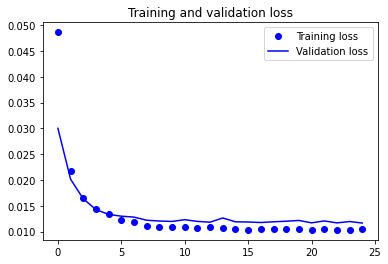

In [35]:
loss = running_loss_history
val_loss = val_running_loss_history

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("plot/train-valid-loss-resnet-101.jpg")
plt.show()

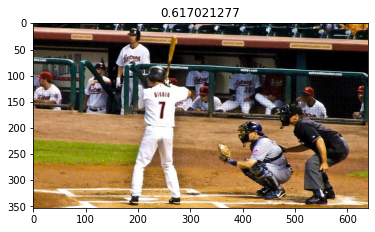

In [37]:
file = ""


def show_sample_from_dataset(i=0):
    global file

    def show_image(image, asethics_value=0):
        plt.imshow(image)
        plt.title(str(asethics_value))

    image_path = os.path.join("images/" + str(dataset_validation.iloc[i]["image"]))
    file = image_path
    mem_val = os.path.join(str(dataset_validation.iloc[i]["memorability_score"]))
    show_image(io.imread(image_path), mem_val)


show_sample_from_dataset()

In [38]:
image = None
import PIL


def image_loader(loader, image_name):
    global image
    image = PIL.Image.open(image_name)
    image = loader(image).float()
    image = torch.tensor(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image


data_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
print(
    (resmodel_101(image_loader(data_transforms, file).double().to(device)).cpu().item())
)

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1698/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


0.12497572245974667


/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1698/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


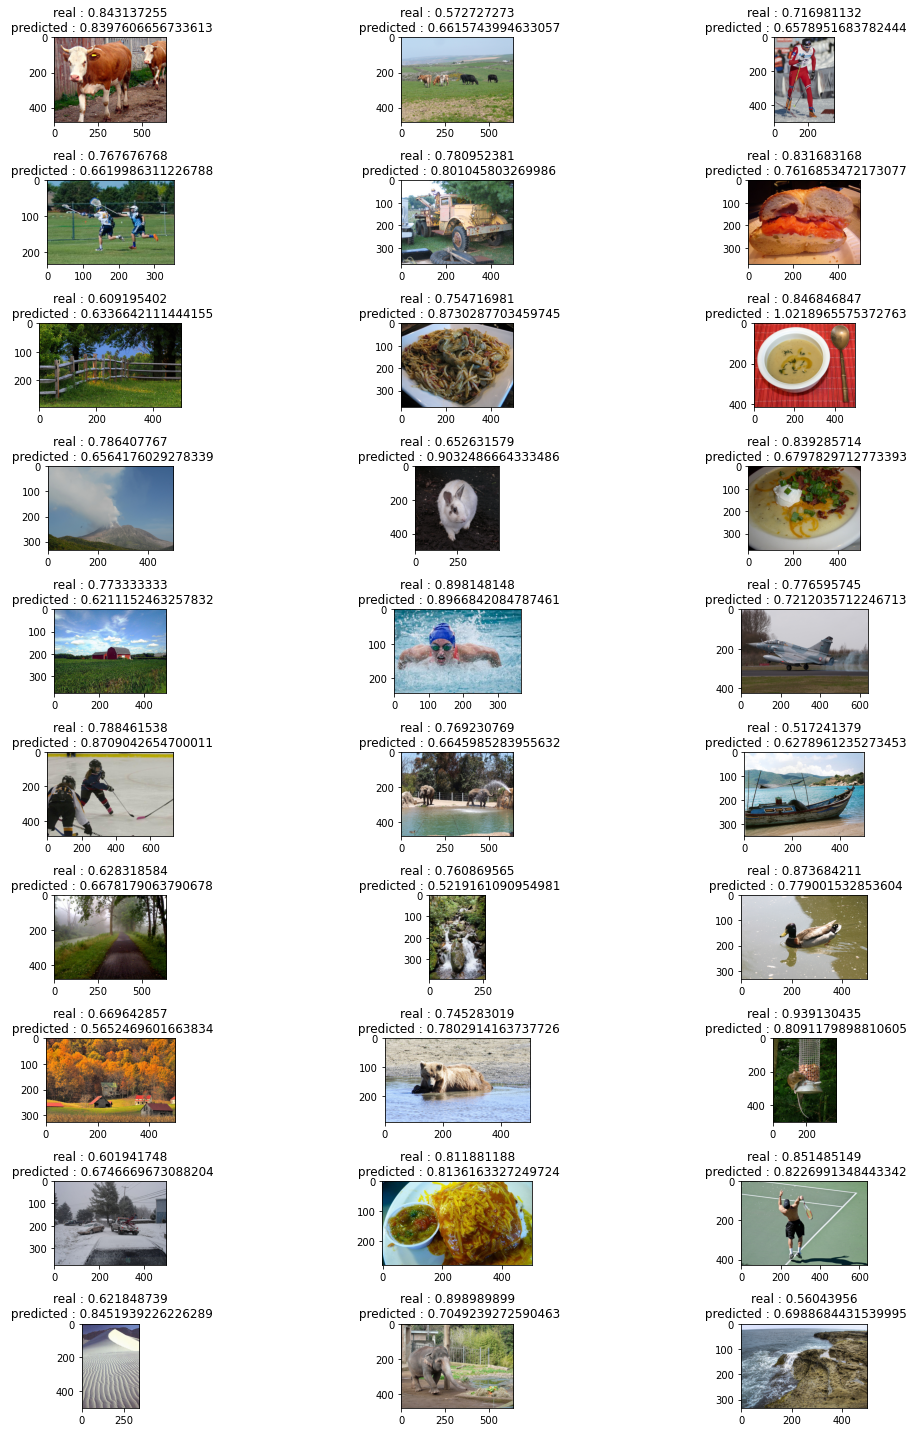

In [39]:
def show_grid(n_row, n_col):
    i = 100
    _, fig = plt.subplots(n_row, n_col, figsize=(20, 20))
    fig = fig.flatten()
    for f in fig:
        image_path = os.path.join("images/" + str(dataset_validation.iloc[i]["image"]))
        mem_val = os.path.join(str(dataset_validation.iloc[i]["memorability_score"]))
        pred = (
            original_model_101(
                image_loader(data_transforms, image_path).double().to(device)
            )
            .cpu()
            .item()
        )

        f.imshow(io.imread(image_path))
        plt.tight_layout()
        f.title.set_text("real : " + str(mem_val) + "\n predicted : " + str(pred))
        i = i + 1


show_grid(10, 3)

In [40]:
val_running_loss_history

[0.030007108082965233,
 0.02015014118068568,
 0.016345117811934064,
 0.014268187013693303,
 0.013332724546843115,
 0.012989187237708415,
 0.012810229736922352,
 0.012206240468630562,
 0.01204915598943818,
 0.011971960961368327,
 0.012311738829495088,
 0.011973847611842031,
 0.011830713500473926,
 0.012643178146921797,
 0.011897834976581386,
 0.01186085113272936,
 0.011761972227035134,
 0.011902715383865742,
 0.01201493700820735,
 0.012164323296104305,
 0.01170043693245583,
 0.012069010281828796,
 0.01169165884478323,
 0.011950383575030928,
 0.011661777915304596]

In [41]:
running_loss_history

[0.04862657239364667,
 0.021657525004332875,
 0.016518228650027916,
 0.01434944169018587,
 0.013441928647257349,
 0.012328335164109226,
 0.011842113075132037,
 0.011051466440463828,
 0.010832911395045672,
 0.010845979682392485,
 0.010839103849863257,
 0.010632496400428095,
 0.010876944961003733,
 0.01071028846962329,
 0.010459640910230075,
 0.010347902629627587,
 0.01046605789723058,
 0.010523138997922525,
 0.010521676794187607,
 0.010554713053840424,
 0.010329738451504662,
 0.010585750278440767,
 0.010356670783358411,
 0.010329252504271845,
 0.010550677347591146]

In [44]:
columns = {"name": "X", "score": "y"}
dataset_origin = pd.read_csv("../../data/dataset.csv")
dataset_origin.rename(columns=columns, inplace=True)

In [47]:
predictions = []

for index, row in dataset_origin.iterrows():
    image_path = os.path.join("semmem/" + str(row["image"]))
    mem_val = os.path.join(str(row["memorability_score"]))

    pred = (
        original_model_101(
            image_loader(data_transforms, image_path).double().to(device)
        )
        .cpu()
        .item()
    )

    predictions.append(
        {"image": row["image"], "real": row["memorability_score"], "prediction": pred}
    )

/var/folders/sh/0km6g5cd0kj3scm6mhtchtp00000gn/T/ipykernel_1698/1970836421.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, requires_grad=True)


In [49]:
image_list = []
real_list = []
prediction_list = []
image_type_list = []
for p in predictions:
    image_list.append(p["image"])
    real_list.append(p["real"])
    prediction_list.append(p["prediction"])

dataframe_dict = {"image": image_list, "real": real_list, "prediction": prediction_list}

df = pd.DataFrame(dataframe_dict)

df.to_csv("csv/predictions_resnet101.csv")